In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")
height_df = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/player_heights.csv")

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
testing_data['description'].unique()

array(['hit_into_play', 'ball', 'foul_bunt', 'blocked_ball',
       'swinging_strike', 'foul', 'called_strike', 'foul_tip',
       'hit_by_pitch', 'swinging_strike_blocked', 'missed_bunt',
       'pitchout', 'bunt_foul_tip', 'unknown_strike'], dtype=object)

In [5]:

def preprocess_data(df, height_df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    # Define a function to condense pitch types
    def condense_pitch_type(pitch_type):
        if pitch_type == "FF":
            return "FF"
        elif pitch_type == "FT":
            return "SI"
        elif pitch_type == "FC":
            return "CT"
        elif pitch_type in ["SL", "ST", "SV"]:
            return "SL"
        elif pitch_type in ["CH", "FS"]:
            return "CH"
        elif pitch_type in ["CU", "KC", "CS", "CB"]:
            return "CB"
        elif pitch_type == "SI":
            return "SI"
        elif pitch_type == "KN":
            return "KN"
        else:
            return "FAHCK"
    # Define a function to determine if the pitch resulted in contact
    def is_contact(description):
        return 1 if description in ["foul_tip", "foul_bunt", "foul", 
                                "foul_pitchout", "hit_into_play", 
                                "hit_into_play_no_out", "hit_into_play_score", 
                                "pitchout_hit_into_play_score", 'hit_into_play'] else 0 
    def create_pitch_id(df):
        df['pitch_id_raw'] = (df['game_pk'].astype(str) + "_" +
                          df['batter'].astype(str) + "_" +
                          df['pitcher'].astype(str) + "_" +
                          df['pitch_number'].astype(str) + "_" +
                          df['at_bat_number'].astype(str) + "_" +
                          df['inning'].astype(str))
        return df
    def is_line_drive(bb_type):
        return 1 if bb_type == "line_drive" else 0
    
    def calculate_pitcher_stats(df):
        # Group by pitcher and pitch type
        grouped = df.groupby(['pitcher', 'pitch_type_condensed'])

        # Calculate mean for pfx_x, pfx_z, and velocity
        mean_values = grouped[['pfx_x', 'pfx_z', 'release_speed']].mean()
        mean_values = mean_values.rename(columns={'pfx_x': 'pfx_x_avg',
                                                  'pfx_z': 'pfx_z_avg',
                                                  'release_speed': 'avg_velo'})

        # Calculate max for pfx_x and pfx_z
        max_values = grouped[['pfx_x', 'pfx_z', 'release_speed']].max()
        max_values = max_values.rename(columns={'pfx_x': 'pfx_x_max',
                                                'pfx_z': 'pfx_z_max',
                                                'release_speed': 'max_velo'})

        # Combine mean and max values
        combined_stats = pd.concat([mean_values, max_values], axis=1)

        return combined_stats.reset_index()

    df['pitch_type_condensed'] = df['pitch_type'].apply(condense_pitch_type)

    # Call the new function and store the result
    pitcher_stats = calculate_pitcher_stats(df)

    df = df.merge(pitcher_stats, how='left', on=['pitcher', 'pitch_type_condensed'])

    # Calculate 'release_pos_y'
    df['release_pos_y'] = 60.5 - df['release_extension']
    df['total_movement'] = np.sqrt(df['pfx_x']**2 + df['pfx_z']**2)

    df['contact'] = df['description'].apply(is_contact)
    df['ld'] = df['bb_type'].apply(is_line_drive)
    
    # Create 'pitch_id_raw'
    df = create_pitch_id(df)

    dfs = df.merge(height_df[['id', 'height_numeric']], how='left', left_on='pitcher', right_on='id')
    # Return the preprocessed DataFrame
    return dfs

In [6]:
# Apply the function to the 'pitch_type' column
data_processed = preprocess_data(data, height_df)# Use the query method to filter rows where 'swing' is 1 and 'pitch_type_condensed' is 'FF', 'SI', or 'CT'
training_data = data_processed.query('contact == 1')
testing_data_processed = preprocess_data(testing_data, height_df)


In [7]:
breaking_ball = training_data.query('pitch_type_condensed in ("SL", "CB")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("SL", "CB")')


# Fastball Model First

In [8]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']]
testing_identifiers = breaking_ball[['pitch_id_raw']]
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [9]:
train_data = training_features.drop(['ld'], axis=1).copy()
train_label = training_features['ld'].copy()
testing_data = testing_features.drop(['ld'], axis=1).copy()
testing_label = testing_features['ld'].copy()

In [10]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [11]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [12]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [13]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [14]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.48303695685789394
Log Loss: 0.6801654733473157


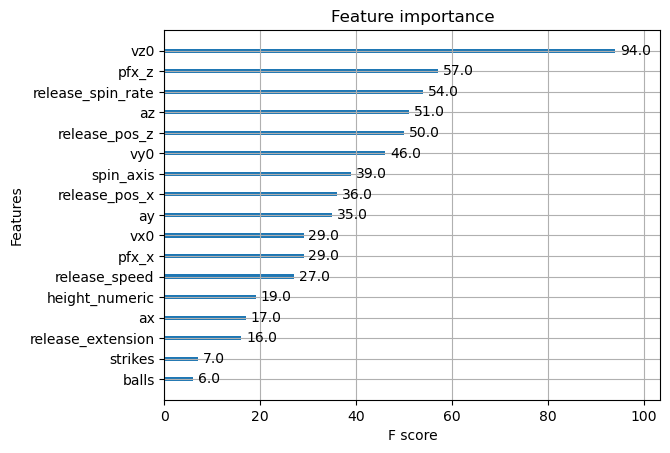

In [15]:
xgb.plot_importance(model)
plt.show()

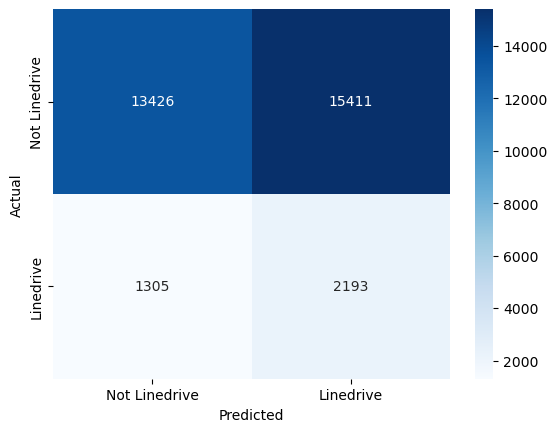

In [16]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Linedrive', 'Linedrive'], yticklabels=['Not Linedrive', 'Linedrive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [17]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [18]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-12 12:37:00,006] A new study created in memory with name: no-name-419ce02f-57bf-4444-9514-8083ed46319e


[0]	eval-logloss:0.68733
[1]	eval-logloss:0.68450
[2]	eval-logloss:0.68342
[3]	eval-logloss:0.68184
[4]	eval-logloss:0.68057
[5]	eval-logloss:0.67949
[6]	eval-logloss:0.67920
[7]	eval-logloss:0.67757
[8]	eval-logloss:0.67700
[9]	eval-logloss:0.67547
[10]	eval-logloss:0.67465
[11]	eval-logloss:0.67463
[12]	eval-logloss:0.67489
[13]	eval-logloss:0.67431
[14]	eval-logloss:0.67378
[15]	eval-logloss:0.67260
[16]	eval-logloss:0.67329
[17]	eval-logloss:0.67150
[18]	eval-logloss:0.67139
[19]	eval-logloss:0.67013
[20]	eval-logloss:0.67064
[21]	eval-logloss:0.67095
[22]	eval-logloss:0.67048
[23]	eval-logloss:0.66915
[24]	eval-logloss:0.66865
[25]	eval-logloss:0.66750
[26]	eval-logloss:0.66790
[27]	eval-logloss:0.66871
[28]	eval-logloss:0.66894
[29]	eval-logloss:0.66882
[30]	eval-logloss:0.66751
[31]	eval-logloss:0.66808
[32]	eval-logloss:0.66739
[33]	eval-logloss:0.66705
[34]	eval-logloss:0.66710
[35]	eval-logloss:0.66677
[36]	eval-logloss:0.66749
[37]	eval-logloss:0.66647
[38]	eval-logloss:0.66

[I 2023-11-12 12:37:01,792] Trial 0 finished with value: 0.6433781657601831 and parameters: {'max_depth': 5, 'eta': 0.27318899381695944, 'subsample': 0.7101544235534447, 'colsample_bytree': 0.8188739482731946}. Best is trial 0 with value: 0.6433781657601831.


[0]	eval-logloss:0.69001
[1]	eval-logloss:0.68781
[2]	eval-logloss:0.68778
[3]	eval-logloss:0.68632
[4]	eval-logloss:0.68590
[5]	eval-logloss:0.68471
[6]	eval-logloss:0.68507
[7]	eval-logloss:0.68411
[8]	eval-logloss:0.68377
[9]	eval-logloss:0.68270
[10]	eval-logloss:0.68260
[11]	eval-logloss:0.68209
[12]	eval-logloss:0.68194
[13]	eval-logloss:0.68178
[14]	eval-logloss:0.68181
[15]	eval-logloss:0.68119
[16]	eval-logloss:0.68182
[17]	eval-logloss:0.68093
[18]	eval-logloss:0.68079
[19]	eval-logloss:0.68017
[20]	eval-logloss:0.68015
[21]	eval-logloss:0.68082
[22]	eval-logloss:0.68050
[23]	eval-logloss:0.67881
[24]	eval-logloss:0.67847
[25]	eval-logloss:0.67881
[26]	eval-logloss:0.67871
[27]	eval-logloss:0.67896
[28]	eval-logloss:0.67854
[29]	eval-logloss:0.67883
[30]	eval-logloss:0.67876
[31]	eval-logloss:0.67898
[32]	eval-logloss:0.67870
[33]	eval-logloss:0.67783
[34]	eval-logloss:0.67824
[35]	eval-logloss:0.67848
[36]	eval-logloss:0.67841
[37]	eval-logloss:0.67738
[38]	eval-logloss:0.67

[I 2023-11-12 12:37:03,295] Trial 1 finished with value: 0.6698064160130702 and parameters: {'max_depth': 3, 'eta': 0.28951671343418156, 'subsample': 0.8672228834521294, 'colsample_bytree': 0.8625348471511984}. Best is trial 0 with value: 0.6433781657601831.


[0]	eval-logloss:0.69165
[1]	eval-logloss:0.68952
[2]	eval-logloss:0.68805
[3]	eval-logloss:0.68623
[4]	eval-logloss:0.68593
[5]	eval-logloss:0.68459
[6]	eval-logloss:0.68407
[7]	eval-logloss:0.68327
[8]	eval-logloss:0.68223
[9]	eval-logloss:0.68118
[10]	eval-logloss:0.68051
[11]	eval-logloss:0.68005
[12]	eval-logloss:0.67985
[13]	eval-logloss:0.67954
[14]	eval-logloss:0.67910
[15]	eval-logloss:0.67818
[16]	eval-logloss:0.67828
[17]	eval-logloss:0.67756
[18]	eval-logloss:0.67692
[19]	eval-logloss:0.67644
[20]	eval-logloss:0.67624
[21]	eval-logloss:0.67628
[22]	eval-logloss:0.67606
[23]	eval-logloss:0.67541
[24]	eval-logloss:0.67506
[25]	eval-logloss:0.67473
[26]	eval-logloss:0.67432
[27]	eval-logloss:0.67430
[28]	eval-logloss:0.67392
[29]	eval-logloss:0.67382
[30]	eval-logloss:0.67350
[31]	eval-logloss:0.67325
[32]	eval-logloss:0.67306
[33]	eval-logloss:0.67268
[34]	eval-logloss:0.67241
[35]	eval-logloss:0.67220
[36]	eval-logloss:0.67230
[37]	eval-logloss:0.67209
[38]	eval-logloss:0.67

[I 2023-11-12 12:37:05,009] Trial 2 finished with value: 0.6581249572900629 and parameters: {'max_depth': 5, 'eta': 0.12258476854315253, 'subsample': 0.8055653930656473, 'colsample_bytree': 0.7173948088266674}. Best is trial 0 with value: 0.6433781657601831.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69230
[2]	eval-logloss:0.69187
[3]	eval-logloss:0.69125
[4]	eval-logloss:0.69090
[5]	eval-logloss:0.69032
[6]	eval-logloss:0.68981
[7]	eval-logloss:0.68938
[8]	eval-logloss:0.68910
[9]	eval-logloss:0.68882
[10]	eval-logloss:0.68828
[11]	eval-logloss:0.68772
[12]	eval-logloss:0.68723
[13]	eval-logloss:0.68682
[14]	eval-logloss:0.68633
[15]	eval-logloss:0.68592
[16]	eval-logloss:0.68555
[17]	eval-logloss:0.68498
[18]	eval-logloss:0.68443
[19]	eval-logloss:0.68389
[20]	eval-logloss:0.68360
[21]	eval-logloss:0.68336
[22]	eval-logloss:0.68287
[23]	eval-logloss:0.68255
[24]	eval-logloss:0.68203
[25]	eval-logloss:0.68177
[26]	eval-logloss:0.68125
[27]	eval-logloss:0.68082
[28]	eval-logloss:0.68051
[29]	eval-logloss:0.68025
[30]	eval-logloss:0.67993
[31]	eval-logloss:0.67962
[32]	eval-logloss:0.67920
[33]	eval-logloss:0.67891
[34]	eval-logloss:0.67848
[35]	eval-logloss:0.67826
[36]	eval-logloss:0.67807
[37]	eval-logloss:0.67776
[38]	eval-logloss:0.67

[I 2023-11-12 12:37:07,812] Trial 3 finished with value: 0.6626837462039418 and parameters: {'max_depth': 8, 'eta': 0.0141943463133491, 'subsample': 0.7595451548791928, 'colsample_bytree': 0.5227157113662231}. Best is trial 0 with value: 0.6433781657601831.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69141
[2]	eval-logloss:0.69082
[3]	eval-logloss:0.68979
[4]	eval-logloss:0.68924
[5]	eval-logloss:0.68825
[6]	eval-logloss:0.68757
[7]	eval-logloss:0.68698
[8]	eval-logloss:0.68635
[9]	eval-logloss:0.68570
[10]	eval-logloss:0.68490
[11]	eval-logloss:0.68416
[12]	eval-logloss:0.68353
[13]	eval-logloss:0.68312
[14]	eval-logloss:0.68249
[15]	eval-logloss:0.68194
[16]	eval-logloss:0.68156
[17]	eval-logloss:0.68076
[18]	eval-logloss:0.67997
[19]	eval-logloss:0.67926
[20]	eval-logloss:0.67890
[21]	eval-logloss:0.67853
[22]	eval-logloss:0.67798
[23]	eval-logloss:0.67754
[24]	eval-logloss:0.67695
[25]	eval-logloss:0.67661
[26]	eval-logloss:0.67603
[27]	eval-logloss:0.67561
[28]	eval-logloss:0.67527
[29]	eval-logloss:0.67503
[30]	eval-logloss:0.67469
[31]	eval-logloss:0.67434
[32]	eval-logloss:0.67390
[33]	eval-logloss:0.67359
[34]	eval-logloss:0.67319
[35]	eval-logloss:0.67292
[36]	eval-logloss:0.67276
[37]	eval-logloss:0.67238
[38]	eval-logloss:0.67

[I 2023-11-12 12:37:09,983] Trial 4 finished with value: 0.656575459148044 and parameters: {'max_depth': 7, 'eta': 0.03238619367695378, 'subsample': 0.7933881211446869, 'colsample_bytree': 0.5968183996360716}. Best is trial 0 with value: 0.6433781657601831.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69250
[3]	eval-logloss:0.69225
[4]	eval-logloss:0.69214
[5]	eval-logloss:0.69190
[6]	eval-logloss:0.69173
[7]	eval-logloss:0.69153
[8]	eval-logloss:0.69127
[9]	eval-logloss:0.69097
[10]	eval-logloss:0.69076
[11]	eval-logloss:0.69057
[12]	eval-logloss:0.69044
[13]	eval-logloss:0.69025
[14]	eval-logloss:0.69003
[15]	eval-logloss:0.68985
[16]	eval-logloss:0.68980
[17]	eval-logloss:0.68950
[18]	eval-logloss:0.68935
[19]	eval-logloss:0.68909
[20]	eval-logloss:0.68905
[21]	eval-logloss:0.68905
[22]	eval-logloss:0.68889
[23]	eval-logloss:0.68874
[24]	eval-logloss:0.68854
[25]	eval-logloss:0.68842
[26]	eval-logloss:0.68829
[27]	eval-logloss:0.68822
[28]	eval-logloss:0.68820
[29]	eval-logloss:0.68815
[30]	eval-logloss:0.68803
[31]	eval-logloss:0.68794
[32]	eval-logloss:0.68780
[33]	eval-logloss:0.68766
[34]	eval-logloss:0.68757
[35]	eval-logloss:0.68753
[36]	eval-logloss:0.68757
[37]	eval-logloss:0.68745
[38]	eval-logloss:0.68

[I 2023-11-12 12:37:11,330] Trial 5 finished with value: 0.6831939315305672 and parameters: {'max_depth': 3, 'eta': 0.02209087237468439, 'subsample': 0.715376341574256, 'colsample_bytree': 0.6767481262809534}. Best is trial 0 with value: 0.6433781657601831.


[0]	eval-logloss:0.69168
[1]	eval-logloss:0.69032
[2]	eval-logloss:0.68928
[3]	eval-logloss:0.68806
[4]	eval-logloss:0.68696
[5]	eval-logloss:0.68573
[6]	eval-logloss:0.68479
[7]	eval-logloss:0.68369
[8]	eval-logloss:0.68277
[9]	eval-logloss:0.68171
[10]	eval-logloss:0.68065
[11]	eval-logloss:0.67972
[12]	eval-logloss:0.67906
[13]	eval-logloss:0.67820
[14]	eval-logloss:0.67734
[15]	eval-logloss:0.67677
[16]	eval-logloss:0.67608
[17]	eval-logloss:0.67510
[18]	eval-logloss:0.67429
[19]	eval-logloss:0.67357
[20]	eval-logloss:0.67293
[21]	eval-logloss:0.67256
[22]	eval-logloss:0.67190
[23]	eval-logloss:0.67102
[24]	eval-logloss:0.67028
[25]	eval-logloss:0.66998
[26]	eval-logloss:0.66932
[27]	eval-logloss:0.66862
[28]	eval-logloss:0.66813
[29]	eval-logloss:0.66741
[30]	eval-logloss:0.66677
[31]	eval-logloss:0.66631
[32]	eval-logloss:0.66567
[33]	eval-logloss:0.66515
[34]	eval-logloss:0.66476
[35]	eval-logloss:0.66433
[36]	eval-logloss:0.66427
[37]	eval-logloss:0.66369
[38]	eval-logloss:0.66

[I 2023-11-12 12:37:13,963] Trial 6 finished with value: 0.6444882013883617 and parameters: {'max_depth': 8, 'eta': 0.026417124478443917, 'subsample': 0.6274225550430572, 'colsample_bytree': 0.7904087391944288}. Best is trial 0 with value: 0.6433781657601831.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68906
[2]	eval-logloss:0.68839
[3]	eval-logloss:0.68706
[4]	eval-logloss:0.68699
[5]	eval-logloss:0.68620
[6]	eval-logloss:0.68544
[7]	eval-logloss:0.68434
[8]	eval-logloss:0.68325
[9]	eval-logloss:0.68237
[10]	eval-logloss:0.68206
[11]	eval-logloss:0.68186
[12]	eval-logloss:0.68257
[13]	eval-logloss:0.68268
[14]	eval-logloss:0.68194
[15]	eval-logloss:0.68133
[16]	eval-logloss:0.68252
[17]	eval-logloss:0.68091
[18]	eval-logloss:0.68093
[19]	eval-logloss:0.67995
[20]	eval-logloss:0.68071
[21]	eval-logloss:0.68187
[22]	eval-logloss:0.68155
[23]	eval-logloss:0.68005
[24]	eval-logloss:0.67936
[25]	eval-logloss:0.67929
[26]	eval-logloss:0.67946
[27]	eval-logloss:0.68046
[28]	eval-logloss:0.68040
[29]	eval-logloss:0.68028
[30]	eval-logloss:0.67913
[31]	eval-logloss:0.67974
[32]	eval-logloss:0.67936
[33]	eval-logloss:0.67926
[34]	eval-logloss:0.67994
[35]	eval-logloss:0.67952
[36]	eval-logloss:0.68055
[37]	eval-logloss:0.67967
[38]	eval-logloss:0.67

[I 2023-11-12 12:37:15,427] Trial 7 finished with value: 0.6714007216993518 and parameters: {'max_depth': 3, 'eta': 0.23110770184402107, 'subsample': 0.6823523433665885, 'colsample_bytree': 0.6767543298298313}. Best is trial 0 with value: 0.6433781657601831.


[0]	eval-logloss:0.69252
[1]	eval-logloss:0.69162
[2]	eval-logloss:0.69140
[3]	eval-logloss:0.69063
[4]	eval-logloss:0.69038
[5]	eval-logloss:0.68966
[6]	eval-logloss:0.68904
[7]	eval-logloss:0.68860
[8]	eval-logloss:0.68805
[9]	eval-logloss:0.68767
[10]	eval-logloss:0.68712
[11]	eval-logloss:0.68663
[12]	eval-logloss:0.68631
[13]	eval-logloss:0.68596
[14]	eval-logloss:0.68551
[15]	eval-logloss:0.68522
[16]	eval-logloss:0.68523
[17]	eval-logloss:0.68452
[18]	eval-logloss:0.68420
[19]	eval-logloss:0.68362
[20]	eval-logloss:0.68369
[21]	eval-logloss:0.68386
[22]	eval-logloss:0.68354
[23]	eval-logloss:0.68304
[24]	eval-logloss:0.68268
[25]	eval-logloss:0.68258
[26]	eval-logloss:0.68235
[27]	eval-logloss:0.68232
[28]	eval-logloss:0.68226
[29]	eval-logloss:0.68211
[30]	eval-logloss:0.68171
[31]	eval-logloss:0.68166
[32]	eval-logloss:0.68135
[33]	eval-logloss:0.68116
[34]	eval-logloss:0.68115
[35]	eval-logloss:0.68104
[36]	eval-logloss:0.68136
[37]	eval-logloss:0.68127
[38]	eval-logloss:0.68

[I 2023-11-12 12:37:17,122] Trial 8 finished with value: 0.6744582621908851 and parameters: {'max_depth': 4, 'eta': 0.05259619821510008, 'subsample': 0.6625225001464095, 'colsample_bytree': 0.6118747394545242}. Best is trial 0 with value: 0.6433781657601831.


[0]	eval-logloss:0.69181
[1]	eval-logloss:0.69110
[2]	eval-logloss:0.69091
[3]	eval-logloss:0.68963
[4]	eval-logloss:0.68933
[5]	eval-logloss:0.68840
[6]	eval-logloss:0.68765
[7]	eval-logloss:0.68691
[8]	eval-logloss:0.68652
[9]	eval-logloss:0.68597
[10]	eval-logloss:0.68522
[11]	eval-logloss:0.68457
[12]	eval-logloss:0.68458
[13]	eval-logloss:0.68465
[14]	eval-logloss:0.68417
[15]	eval-logloss:0.68371
[16]	eval-logloss:0.68421
[17]	eval-logloss:0.68303
[18]	eval-logloss:0.68259
[19]	eval-logloss:0.68176
[20]	eval-logloss:0.68217
[21]	eval-logloss:0.68282
[22]	eval-logloss:0.68267
[23]	eval-logloss:0.68180
[24]	eval-logloss:0.68124
[25]	eval-logloss:0.68114
[26]	eval-logloss:0.68115
[27]	eval-logloss:0.68159
[28]	eval-logloss:0.68153
[29]	eval-logloss:0.68143
[30]	eval-logloss:0.68070
[31]	eval-logloss:0.68090
[32]	eval-logloss:0.68061
[33]	eval-logloss:0.68063
[34]	eval-logloss:0.68092
[35]	eval-logloss:0.68059
[36]	eval-logloss:0.68123
[37]	eval-logloss:0.68085
[38]	eval-logloss:0.68

[I 2023-11-12 12:37:18,691] Trial 9 finished with value: 0.6745193711082165 and parameters: {'max_depth': 3, 'eta': 0.1426735558273931, 'subsample': 0.680238667155917, 'colsample_bytree': 0.5520291032875956}. Best is trial 0 with value: 0.6433781657601831.


[0]	eval-logloss:0.68682
[1]	eval-logloss:0.68302
[2]	eval-logloss:0.68051
[3]	eval-logloss:0.67830
[4]	eval-logloss:0.67687
[5]	eval-logloss:0.67471
[6]	eval-logloss:0.67434
[7]	eval-logloss:0.67366
[8]	eval-logloss:0.67312
[9]	eval-logloss:0.67158
[10]	eval-logloss:0.66967
[11]	eval-logloss:0.66805
[12]	eval-logloss:0.66852
[13]	eval-logloss:0.66804
[14]	eval-logloss:0.66668
[15]	eval-logloss:0.66584
[16]	eval-logloss:0.66541
[17]	eval-logloss:0.66389
[18]	eval-logloss:0.66376
[19]	eval-logloss:0.66131
[20]	eval-logloss:0.66213
[21]	eval-logloss:0.66283
[22]	eval-logloss:0.66152
[23]	eval-logloss:0.65946
[24]	eval-logloss:0.65897
[25]	eval-logloss:0.65863
[26]	eval-logloss:0.65753
[27]	eval-logloss:0.65836
[28]	eval-logloss:0.65855
[29]	eval-logloss:0.65833
[30]	eval-logloss:0.65674
[31]	eval-logloss:0.65703
[32]	eval-logloss:0.65667
[33]	eval-logloss:0.65561
[34]	eval-logloss:0.65591
[35]	eval-logloss:0.65539
[36]	eval-logloss:0.65629
[37]	eval-logloss:0.65518
[38]	eval-logloss:0.65

[I 2023-11-12 12:37:20,766] Trial 10 finished with value: 0.6251331023124518 and parameters: {'max_depth': 6, 'eta': 0.22007896758851134, 'subsample': 0.600433223985766, 'colsample_bytree': 0.9615049351401737}. Best is trial 10 with value: 0.6251331023124518.


[0]	eval-logloss:0.68655
[1]	eval-logloss:0.68300
[2]	eval-logloss:0.68071
[3]	eval-logloss:0.67820
[4]	eval-logloss:0.67694
[5]	eval-logloss:0.67481
[6]	eval-logloss:0.67465
[7]	eval-logloss:0.67342
[8]	eval-logloss:0.67302
[9]	eval-logloss:0.67097
[10]	eval-logloss:0.67013
[11]	eval-logloss:0.66843
[12]	eval-logloss:0.66857
[13]	eval-logloss:0.66809
[14]	eval-logloss:0.66669
[15]	eval-logloss:0.66594
[16]	eval-logloss:0.66600
[17]	eval-logloss:0.66463
[18]	eval-logloss:0.66444
[19]	eval-logloss:0.66224
[20]	eval-logloss:0.66235
[21]	eval-logloss:0.66353
[22]	eval-logloss:0.66223
[23]	eval-logloss:0.66026
[24]	eval-logloss:0.65961
[25]	eval-logloss:0.65873
[26]	eval-logloss:0.65799
[27]	eval-logloss:0.65926
[28]	eval-logloss:0.65931
[29]	eval-logloss:0.65926
[30]	eval-logloss:0.65702
[31]	eval-logloss:0.65751
[32]	eval-logloss:0.65680
[33]	eval-logloss:0.65580
[34]	eval-logloss:0.65599
[35]	eval-logloss:0.65579
[36]	eval-logloss:0.65658
[37]	eval-logloss:0.65623
[38]	eval-logloss:0.65

[I 2023-11-12 12:37:22,894] Trial 11 finished with value: 0.6247486236465273 and parameters: {'max_depth': 6, 'eta': 0.22737015324767518, 'subsample': 0.6006722766028311, 'colsample_bytree': 0.9909721983317193}. Best is trial 11 with value: 0.6247486236465273.


[0]	eval-logloss:0.68723
[1]	eval-logloss:0.68365
[2]	eval-logloss:0.68117
[3]	eval-logloss:0.67857
[4]	eval-logloss:0.67728
[5]	eval-logloss:0.67555
[6]	eval-logloss:0.67443
[7]	eval-logloss:0.67329
[8]	eval-logloss:0.67266
[9]	eval-logloss:0.67103
[10]	eval-logloss:0.66998
[11]	eval-logloss:0.66872
[12]	eval-logloss:0.66898
[13]	eval-logloss:0.66872
[14]	eval-logloss:0.66782
[15]	eval-logloss:0.66671
[16]	eval-logloss:0.66690
[17]	eval-logloss:0.66611
[18]	eval-logloss:0.66591
[19]	eval-logloss:0.66343
[20]	eval-logloss:0.66386
[21]	eval-logloss:0.66446
[22]	eval-logloss:0.66368
[23]	eval-logloss:0.66206
[24]	eval-logloss:0.66120
[25]	eval-logloss:0.66018
[26]	eval-logloss:0.66012
[27]	eval-logloss:0.66082
[28]	eval-logloss:0.66087
[29]	eval-logloss:0.66050
[30]	eval-logloss:0.65898
[31]	eval-logloss:0.65897
[32]	eval-logloss:0.65855
[33]	eval-logloss:0.65813
[34]	eval-logloss:0.65818
[35]	eval-logloss:0.65748
[36]	eval-logloss:0.65793
[37]	eval-logloss:0.65688
[38]	eval-logloss:0.65

[I 2023-11-12 12:37:25,004] Trial 12 finished with value: 0.627351666471336 and parameters: {'max_depth': 6, 'eta': 0.20194814156320195, 'subsample': 0.6059387859767091, 'colsample_bytree': 0.9989433659075749}. Best is trial 11 with value: 0.6247486236465273.


[0]	eval-logloss:0.68725
[1]	eval-logloss:0.68367
[2]	eval-logloss:0.68119
[3]	eval-logloss:0.67861
[4]	eval-logloss:0.67731
[5]	eval-logloss:0.67557
[6]	eval-logloss:0.67444
[7]	eval-logloss:0.67331
[8]	eval-logloss:0.67264
[9]	eval-logloss:0.67099
[10]	eval-logloss:0.66997
[11]	eval-logloss:0.66853
[12]	eval-logloss:0.66880
[13]	eval-logloss:0.66862
[14]	eval-logloss:0.66771
[15]	eval-logloss:0.66676
[16]	eval-logloss:0.66752
[17]	eval-logloss:0.66651
[18]	eval-logloss:0.66625
[19]	eval-logloss:0.66430
[20]	eval-logloss:0.66493
[21]	eval-logloss:0.66514
[22]	eval-logloss:0.66400
[23]	eval-logloss:0.66200
[24]	eval-logloss:0.66129
[25]	eval-logloss:0.66040
[26]	eval-logloss:0.65967
[27]	eval-logloss:0.66038
[28]	eval-logloss:0.66053
[29]	eval-logloss:0.66025
[30]	eval-logloss:0.65822
[31]	eval-logloss:0.65804
[32]	eval-logloss:0.65760
[33]	eval-logloss:0.65704
[34]	eval-logloss:0.65757
[35]	eval-logloss:0.65690
[36]	eval-logloss:0.65717
[37]	eval-logloss:0.65696
[38]	eval-logloss:0.65

[I 2023-11-12 12:37:27,127] Trial 13 finished with value: 0.6300016257268864 and parameters: {'max_depth': 6, 'eta': 0.20119983632221822, 'subsample': 0.6060621095212911, 'colsample_bytree': 0.9994639895484072}. Best is trial 11 with value: 0.6247486236465273.


[0]	eval-logloss:0.67935
[1]	eval-logloss:0.67095
[2]	eval-logloss:0.66566
[3]	eval-logloss:0.66035
[4]	eval-logloss:0.65635
[5]	eval-logloss:0.65300
[6]	eval-logloss:0.64996
[7]	eval-logloss:0.64787
[8]	eval-logloss:0.64707
[9]	eval-logloss:0.64309
[10]	eval-logloss:0.64060
[11]	eval-logloss:0.63685
[12]	eval-logloss:0.63572
[13]	eval-logloss:0.63286
[14]	eval-logloss:0.63034
[15]	eval-logloss:0.62876
[16]	eval-logloss:0.62932
[17]	eval-logloss:0.62594
[18]	eval-logloss:0.62578
[19]	eval-logloss:0.62278
[20]	eval-logloss:0.62341
[21]	eval-logloss:0.62324
[22]	eval-logloss:0.62185
[23]	eval-logloss:0.61802
[24]	eval-logloss:0.61596
[25]	eval-logloss:0.61414
[26]	eval-logloss:0.61291
[27]	eval-logloss:0.61245
[28]	eval-logloss:0.61022
[29]	eval-logloss:0.61076
[30]	eval-logloss:0.60879
[31]	eval-logloss:0.60818
[32]	eval-logloss:0.60676
[33]	eval-logloss:0.60526
[34]	eval-logloss:0.60428
[35]	eval-logloss:0.60257
[36]	eval-logloss:0.60255
[37]	eval-logloss:0.59965
[38]	eval-logloss:0.59

[I 2023-11-12 12:37:30,412] Trial 14 finished with value: 0.5212597106579092 and parameters: {'max_depth': 9, 'eta': 0.24621330018350912, 'subsample': 0.6447270321459335, 'colsample_bytree': 0.9117455466653621}. Best is trial 14 with value: 0.5212597106579092.


[0]	eval-logloss:0.67896
[1]	eval-logloss:0.67077
[2]	eval-logloss:0.66596
[3]	eval-logloss:0.66053
[4]	eval-logloss:0.65787
[5]	eval-logloss:0.65177
[6]	eval-logloss:0.65068
[7]	eval-logloss:0.64886
[8]	eval-logloss:0.64685
[9]	eval-logloss:0.64227
[10]	eval-logloss:0.63925
[11]	eval-logloss:0.63835
[12]	eval-logloss:0.63753
[13]	eval-logloss:0.63404
[14]	eval-logloss:0.63319
[15]	eval-logloss:0.62914
[16]	eval-logloss:0.62977
[17]	eval-logloss:0.62737
[18]	eval-logloss:0.62630
[19]	eval-logloss:0.62334
[20]	eval-logloss:0.62332
[21]	eval-logloss:0.62252
[22]	eval-logloss:0.62102
[23]	eval-logloss:0.61836
[24]	eval-logloss:0.61637
[25]	eval-logloss:0.61463
[26]	eval-logloss:0.61193
[27]	eval-logloss:0.60978
[28]	eval-logloss:0.60816
[29]	eval-logloss:0.60615
[30]	eval-logloss:0.60276
[31]	eval-logloss:0.60290
[32]	eval-logloss:0.60213
[33]	eval-logloss:0.60115
[34]	eval-logloss:0.59982
[35]	eval-logloss:0.59758
[36]	eval-logloss:0.59794
[37]	eval-logloss:0.59807
[38]	eval-logloss:0.59

[I 2023-11-12 12:37:33,541] Trial 15 finished with value: 0.5194329859026996 and parameters: {'max_depth': 9, 'eta': 0.255856982003264, 'subsample': 0.6466865808895207, 'colsample_bytree': 0.8847156069458258}. Best is trial 15 with value: 0.5194329859026996.


[0]	eval-logloss:0.67746
[1]	eval-logloss:0.66902
[2]	eval-logloss:0.66438
[3]	eval-logloss:0.65917
[4]	eval-logloss:0.65502
[5]	eval-logloss:0.65231
[6]	eval-logloss:0.65096
[7]	eval-logloss:0.64907
[8]	eval-logloss:0.64720
[9]	eval-logloss:0.64373
[10]	eval-logloss:0.64290
[11]	eval-logloss:0.64011
[12]	eval-logloss:0.63823
[13]	eval-logloss:0.63553
[14]	eval-logloss:0.63365
[15]	eval-logloss:0.63137
[16]	eval-logloss:0.63220
[17]	eval-logloss:0.62714
[18]	eval-logloss:0.62566
[19]	eval-logloss:0.62372
[20]	eval-logloss:0.62299
[21]	eval-logloss:0.62281
[22]	eval-logloss:0.62040
[23]	eval-logloss:0.61659
[24]	eval-logloss:0.61441
[25]	eval-logloss:0.61348
[26]	eval-logloss:0.61079
[27]	eval-logloss:0.61066
[28]	eval-logloss:0.60861
[29]	eval-logloss:0.60667
[30]	eval-logloss:0.60211
[31]	eval-logloss:0.60144
[32]	eval-logloss:0.59985
[33]	eval-logloss:0.59957
[34]	eval-logloss:0.59782
[35]	eval-logloss:0.59504
[36]	eval-logloss:0.59437
[37]	eval-logloss:0.59263
[38]	eval-logloss:0.58

[I 2023-11-12 12:37:36,847] Trial 16 finished with value: 0.5136331584251872 and parameters: {'max_depth': 9, 'eta': 0.29860645846515593, 'subsample': 0.6448187762269563, 'colsample_bytree': 0.8951513418670848}. Best is trial 16 with value: 0.5136331584251872.


[0]	eval-logloss:0.67733
[1]	eval-logloss:0.66625
[2]	eval-logloss:0.66214
[3]	eval-logloss:0.65522
[4]	eval-logloss:0.64968
[5]	eval-logloss:0.64650
[6]	eval-logloss:0.64531
[7]	eval-logloss:0.64474
[8]	eval-logloss:0.64400
[9]	eval-logloss:0.64068
[10]	eval-logloss:0.63639
[11]	eval-logloss:0.63354
[12]	eval-logloss:0.63319
[13]	eval-logloss:0.63079
[14]	eval-logloss:0.62842
[15]	eval-logloss:0.62595
[16]	eval-logloss:0.62453
[17]	eval-logloss:0.62060
[18]	eval-logloss:0.61984
[19]	eval-logloss:0.61553
[20]	eval-logloss:0.61676
[21]	eval-logloss:0.61723
[22]	eval-logloss:0.61398
[23]	eval-logloss:0.61129
[24]	eval-logloss:0.60862
[25]	eval-logloss:0.60645
[26]	eval-logloss:0.60517
[27]	eval-logloss:0.60446
[28]	eval-logloss:0.60345
[29]	eval-logloss:0.60270
[30]	eval-logloss:0.59712
[31]	eval-logloss:0.59566
[32]	eval-logloss:0.59450
[33]	eval-logloss:0.59370
[34]	eval-logloss:0.59230
[35]	eval-logloss:0.58956
[36]	eval-logloss:0.59098
[37]	eval-logloss:0.59005
[38]	eval-logloss:0.58

[I 2023-11-12 12:37:39,787] Trial 17 finished with value: 0.508750983495301 and parameters: {'max_depth': 9, 'eta': 0.29625497356277175, 'subsample': 0.6413771355531404, 'colsample_bytree': 0.9162977257472313}. Best is trial 17 with value: 0.508750983495301.


[0]	eval-logloss:0.68180
[1]	eval-logloss:0.67571
[2]	eval-logloss:0.67213
[3]	eval-logloss:0.66828
[4]	eval-logloss:0.66623
[5]	eval-logloss:0.66512
[6]	eval-logloss:0.66347
[7]	eval-logloss:0.66141
[8]	eval-logloss:0.65942
[9]	eval-logloss:0.65599
[10]	eval-logloss:0.65430
[11]	eval-logloss:0.65264
[12]	eval-logloss:0.65194
[13]	eval-logloss:0.65034
[14]	eval-logloss:0.64704
[15]	eval-logloss:0.64406
[16]	eval-logloss:0.64311
[17]	eval-logloss:0.63850
[18]	eval-logloss:0.63875
[19]	eval-logloss:0.63736
[20]	eval-logloss:0.63755
[21]	eval-logloss:0.63657
[22]	eval-logloss:0.63527
[23]	eval-logloss:0.63162
[24]	eval-logloss:0.62989
[25]	eval-logloss:0.62785
[26]	eval-logloss:0.62677
[27]	eval-logloss:0.62550
[28]	eval-logloss:0.62414
[29]	eval-logloss:0.62403
[30]	eval-logloss:0.62128
[31]	eval-logloss:0.62107
[32]	eval-logloss:0.62004
[33]	eval-logloss:0.61908
[34]	eval-logloss:0.61863
[35]	eval-logloss:0.61619
[36]	eval-logloss:0.61557
[37]	eval-logloss:0.61498
[38]	eval-logloss:0.61

[I 2023-11-12 12:37:42,127] Trial 18 finished with value: 0.5475217025617327 and parameters: {'max_depth': 8, 'eta': 0.29548145556607736, 'subsample': 0.6973624736220562, 'colsample_bytree': 0.9261324345240144}. Best is trial 17 with value: 0.508750983495301.


[0]	eval-logloss:0.67879
[1]	eval-logloss:0.66977
[2]	eval-logloss:0.66564
[3]	eval-logloss:0.65965
[4]	eval-logloss:0.65495
[5]	eval-logloss:0.65289
[6]	eval-logloss:0.65016
[7]	eval-logloss:0.64770
[8]	eval-logloss:0.64662
[9]	eval-logloss:0.64337
[10]	eval-logloss:0.64149
[11]	eval-logloss:0.63838
[12]	eval-logloss:0.63832
[13]	eval-logloss:0.63427
[14]	eval-logloss:0.63208
[15]	eval-logloss:0.62886
[16]	eval-logloss:0.62726
[17]	eval-logloss:0.62444
[18]	eval-logloss:0.62261
[19]	eval-logloss:0.61949
[20]	eval-logloss:0.62052
[21]	eval-logloss:0.62146
[22]	eval-logloss:0.61869
[23]	eval-logloss:0.61502
[24]	eval-logloss:0.61182
[25]	eval-logloss:0.61012
[26]	eval-logloss:0.60735
[27]	eval-logloss:0.60777
[28]	eval-logloss:0.60739
[29]	eval-logloss:0.60522
[30]	eval-logloss:0.60385
[31]	eval-logloss:0.60311
[32]	eval-logloss:0.60120
[33]	eval-logloss:0.60032
[34]	eval-logloss:0.59983
[35]	eval-logloss:0.59818
[36]	eval-logloss:0.59756
[37]	eval-logloss:0.59584
[38]	eval-logloss:0.59

[I 2023-11-12 12:37:45,003] Trial 19 finished with value: 0.5137745892784636 and parameters: {'max_depth': 9, 'eta': 0.292570833839652, 'subsample': 0.6551053994991651, 'colsample_bytree': 0.8459491134296289}. Best is trial 17 with value: 0.508750983495301.


[0]	eval-logloss:0.68475
[1]	eval-logloss:0.68007
[2]	eval-logloss:0.67788
[3]	eval-logloss:0.67530
[4]	eval-logloss:0.67325
[5]	eval-logloss:0.67097
[6]	eval-logloss:0.66903
[7]	eval-logloss:0.66673
[8]	eval-logloss:0.66575
[9]	eval-logloss:0.66324
[10]	eval-logloss:0.66235
[11]	eval-logloss:0.66174
[12]	eval-logloss:0.66082
[13]	eval-logloss:0.65967
[14]	eval-logloss:0.65817
[15]	eval-logloss:0.65667
[16]	eval-logloss:0.65661
[17]	eval-logloss:0.65424
[18]	eval-logloss:0.65403
[19]	eval-logloss:0.65335
[20]	eval-logloss:0.65285
[21]	eval-logloss:0.65263
[22]	eval-logloss:0.65101
[23]	eval-logloss:0.64890
[24]	eval-logloss:0.64820
[25]	eval-logloss:0.64670
[26]	eval-logloss:0.64650
[27]	eval-logloss:0.64677
[28]	eval-logloss:0.64527
[29]	eval-logloss:0.64575
[30]	eval-logloss:0.64395
[31]	eval-logloss:0.64332
[32]	eval-logloss:0.64269
[33]	eval-logloss:0.64214
[34]	eval-logloss:0.64177
[35]	eval-logloss:0.64162
[36]	eval-logloss:0.64166
[37]	eval-logloss:0.64007
[38]	eval-logloss:0.63

[I 2023-11-12 12:37:47,131] Trial 20 finished with value: 0.5892430227347917 and parameters: {'max_depth': 7, 'eta': 0.2642280886804498, 'subsample': 0.7301477419147516, 'colsample_bytree': 0.8038907278000026}. Best is trial 17 with value: 0.508750983495301.


[0]	eval-logloss:0.67820
[1]	eval-logloss:0.66849
[2]	eval-logloss:0.66283
[3]	eval-logloss:0.65799
[4]	eval-logloss:0.65405
[5]	eval-logloss:0.65130
[6]	eval-logloss:0.65013
[7]	eval-logloss:0.64746
[8]	eval-logloss:0.64389
[9]	eval-logloss:0.64134
[10]	eval-logloss:0.63862
[11]	eval-logloss:0.63528
[12]	eval-logloss:0.63381
[13]	eval-logloss:0.63087
[14]	eval-logloss:0.62787
[15]	eval-logloss:0.62548
[16]	eval-logloss:0.62624
[17]	eval-logloss:0.62313
[18]	eval-logloss:0.62046
[19]	eval-logloss:0.61805
[20]	eval-logloss:0.61892
[21]	eval-logloss:0.62007
[22]	eval-logloss:0.61739
[23]	eval-logloss:0.61305
[24]	eval-logloss:0.61019
[25]	eval-logloss:0.60905
[26]	eval-logloss:0.60662
[27]	eval-logloss:0.60442
[28]	eval-logloss:0.60455
[29]	eval-logloss:0.60106
[30]	eval-logloss:0.59687
[31]	eval-logloss:0.59659
[32]	eval-logloss:0.59487
[33]	eval-logloss:0.59333
[34]	eval-logloss:0.59284
[35]	eval-logloss:0.59052
[36]	eval-logloss:0.58998
[37]	eval-logloss:0.58877
[38]	eval-logloss:0.58

[I 2023-11-12 12:37:49,967] Trial 21 finished with value: 0.5075569371289734 and parameters: {'max_depth': 9, 'eta': 0.2943768630355232, 'subsample': 0.6603554038681229, 'colsample_bytree': 0.8608412964977514}. Best is trial 21 with value: 0.5075569371289734.


[0]	eval-logloss:0.67840
[1]	eval-logloss:0.66804
[2]	eval-logloss:0.66357
[3]	eval-logloss:0.65919
[4]	eval-logloss:0.65409
[5]	eval-logloss:0.64925
[6]	eval-logloss:0.64715
[7]	eval-logloss:0.64421
[8]	eval-logloss:0.64217
[9]	eval-logloss:0.63955
[10]	eval-logloss:0.63759
[11]	eval-logloss:0.63635
[12]	eval-logloss:0.63571
[13]	eval-logloss:0.63202
[14]	eval-logloss:0.62862
[15]	eval-logloss:0.62575
[16]	eval-logloss:0.62591
[17]	eval-logloss:0.61964
[18]	eval-logloss:0.62008
[19]	eval-logloss:0.61771
[20]	eval-logloss:0.61804
[21]	eval-logloss:0.61860
[22]	eval-logloss:0.61563
[23]	eval-logloss:0.61191
[24]	eval-logloss:0.61021
[25]	eval-logloss:0.60768
[26]	eval-logloss:0.60599
[27]	eval-logloss:0.60440
[28]	eval-logloss:0.60214
[29]	eval-logloss:0.60077
[30]	eval-logloss:0.59762
[31]	eval-logloss:0.59658
[32]	eval-logloss:0.59543
[33]	eval-logloss:0.59374
[34]	eval-logloss:0.59331
[35]	eval-logloss:0.58993
[36]	eval-logloss:0.58989
[37]	eval-logloss:0.58724
[38]	eval-logloss:0.58

[I 2023-11-12 12:37:52,917] Trial 22 finished with value: 0.5118074236331489 and parameters: {'max_depth': 9, 'eta': 0.2983746963506055, 'subsample': 0.6721171652556538, 'colsample_bytree': 0.9142219262099888}. Best is trial 21 with value: 0.5075569371289734.


[0]	eval-logloss:0.68250
[1]	eval-logloss:0.67503
[2]	eval-logloss:0.67140
[3]	eval-logloss:0.66809
[4]	eval-logloss:0.66421
[5]	eval-logloss:0.66124
[6]	eval-logloss:0.65982
[7]	eval-logloss:0.65876
[8]	eval-logloss:0.65602
[9]	eval-logloss:0.65472
[10]	eval-logloss:0.65349
[11]	eval-logloss:0.65124
[12]	eval-logloss:0.64958
[13]	eval-logloss:0.64792
[14]	eval-logloss:0.64552
[15]	eval-logloss:0.64398
[16]	eval-logloss:0.64446
[17]	eval-logloss:0.64091
[18]	eval-logloss:0.63995
[19]	eval-logloss:0.63779
[20]	eval-logloss:0.63862
[21]	eval-logloss:0.63824
[22]	eval-logloss:0.63665
[23]	eval-logloss:0.63276
[24]	eval-logloss:0.63126
[25]	eval-logloss:0.62954
[26]	eval-logloss:0.62888
[27]	eval-logloss:0.62759
[28]	eval-logloss:0.62653
[29]	eval-logloss:0.62539
[30]	eval-logloss:0.62205
[31]	eval-logloss:0.62097
[32]	eval-logloss:0.61903
[33]	eval-logloss:0.61814
[34]	eval-logloss:0.61793
[35]	eval-logloss:0.61729
[36]	eval-logloss:0.61766
[37]	eval-logloss:0.61673
[38]	eval-logloss:0.61

[I 2023-11-12 12:37:55,613] Trial 23 finished with value: 0.5495416439526788 and parameters: {'max_depth': 8, 'eta': 0.2670726697078433, 'subsample': 0.6736662936494995, 'colsample_bytree': 0.9371895727708279}. Best is trial 21 with value: 0.5075569371289734.


[0]	eval-logloss:0.68444
[1]	eval-logloss:0.67969
[2]	eval-logloss:0.67734
[3]	eval-logloss:0.67419
[4]	eval-logloss:0.67256
[5]	eval-logloss:0.67162
[6]	eval-logloss:0.66927
[7]	eval-logloss:0.66745
[8]	eval-logloss:0.66503
[9]	eval-logloss:0.66300
[10]	eval-logloss:0.66212
[11]	eval-logloss:0.66077
[12]	eval-logloss:0.66090
[13]	eval-logloss:0.66049
[14]	eval-logloss:0.65899
[15]	eval-logloss:0.65668
[16]	eval-logloss:0.65667
[17]	eval-logloss:0.65381
[18]	eval-logloss:0.65254
[19]	eval-logloss:0.65085
[20]	eval-logloss:0.65135
[21]	eval-logloss:0.65182
[22]	eval-logloss:0.65080
[23]	eval-logloss:0.64831
[24]	eval-logloss:0.64709
[25]	eval-logloss:0.64617
[26]	eval-logloss:0.64567
[27]	eval-logloss:0.64628
[28]	eval-logloss:0.64539
[29]	eval-logloss:0.64453
[30]	eval-logloss:0.64195
[31]	eval-logloss:0.64244
[32]	eval-logloss:0.64133
[33]	eval-logloss:0.64042
[34]	eval-logloss:0.63891
[35]	eval-logloss:0.63752
[36]	eval-logloss:0.63759
[37]	eval-logloss:0.63573
[38]	eval-logloss:0.63

[I 2023-11-12 12:37:57,813] Trial 24 finished with value: 0.5872749169654773 and parameters: {'max_depth': 7, 'eta': 0.27330050428957153, 'subsample': 0.688046087318419, 'colsample_bytree': 0.8588873826665351}. Best is trial 21 with value: 0.5075569371289734.


[0]	eval-logloss:0.67917
[1]	eval-logloss:0.66972
[2]	eval-logloss:0.66524
[3]	eval-logloss:0.66014
[4]	eval-logloss:0.65605
[5]	eval-logloss:0.65257
[6]	eval-logloss:0.64800
[7]	eval-logloss:0.64674
[8]	eval-logloss:0.64665
[9]	eval-logloss:0.64474
[10]	eval-logloss:0.64192
[11]	eval-logloss:0.63993
[12]	eval-logloss:0.63832
[13]	eval-logloss:0.63637
[14]	eval-logloss:0.63399
[15]	eval-logloss:0.63231
[16]	eval-logloss:0.63162
[17]	eval-logloss:0.62705
[18]	eval-logloss:0.62451
[19]	eval-logloss:0.62292
[20]	eval-logloss:0.62312
[21]	eval-logloss:0.62281
[22]	eval-logloss:0.61953
[23]	eval-logloss:0.61483
[24]	eval-logloss:0.61225
[25]	eval-logloss:0.61122
[26]	eval-logloss:0.61052
[27]	eval-logloss:0.60837
[28]	eval-logloss:0.60700
[29]	eval-logloss:0.60620
[30]	eval-logloss:0.60354
[31]	eval-logloss:0.60280
[32]	eval-logloss:0.60105
[33]	eval-logloss:0.59965
[34]	eval-logloss:0.60004
[35]	eval-logloss:0.59602
[36]	eval-logloss:0.59490
[37]	eval-logloss:0.59495
[38]	eval-logloss:0.59

[I 2023-11-12 12:38:00,939] Trial 25 finished with value: 0.5209767182684374 and parameters: {'max_depth': 9, 'eta': 0.24821578504067932, 'subsample': 0.6269601082699304, 'colsample_bytree': 0.9451466018709767}. Best is trial 21 with value: 0.5075569371289734.


[0]	eval-logloss:0.68169
[1]	eval-logloss:0.67430
[2]	eval-logloss:0.67110
[3]	eval-logloss:0.66668
[4]	eval-logloss:0.66346
[5]	eval-logloss:0.66100
[6]	eval-logloss:0.66024
[7]	eval-logloss:0.65868
[8]	eval-logloss:0.65730
[9]	eval-logloss:0.65382
[10]	eval-logloss:0.65277
[11]	eval-logloss:0.65035
[12]	eval-logloss:0.64968
[13]	eval-logloss:0.64858
[14]	eval-logloss:0.64587
[15]	eval-logloss:0.64371
[16]	eval-logloss:0.64421
[17]	eval-logloss:0.64196
[18]	eval-logloss:0.64193
[19]	eval-logloss:0.63973
[20]	eval-logloss:0.63984
[21]	eval-logloss:0.64032
[22]	eval-logloss:0.63818
[23]	eval-logloss:0.63445
[24]	eval-logloss:0.63234
[25]	eval-logloss:0.63010
[26]	eval-logloss:0.62959
[27]	eval-logloss:0.62883
[28]	eval-logloss:0.62880
[29]	eval-logloss:0.62702
[30]	eval-logloss:0.62492
[31]	eval-logloss:0.62494
[32]	eval-logloss:0.62389
[33]	eval-logloss:0.62348
[34]	eval-logloss:0.62203
[35]	eval-logloss:0.62033
[36]	eval-logloss:0.62047
[37]	eval-logloss:0.61756
[38]	eval-logloss:0.61

[I 2023-11-12 12:38:03,408] Trial 26 finished with value: 0.5540326365029561 and parameters: {'max_depth': 8, 'eta': 0.2783421547265962, 'subsample': 0.6661674520922434, 'colsample_bytree': 0.9023305887458312}. Best is trial 21 with value: 0.5075569371289734.


[0]	eval-logloss:0.67801
[1]	eval-logloss:0.66863
[2]	eval-logloss:0.66433
[3]	eval-logloss:0.65827
[4]	eval-logloss:0.65343
[5]	eval-logloss:0.65075
[6]	eval-logloss:0.64864
[7]	eval-logloss:0.64692
[8]	eval-logloss:0.64471
[9]	eval-logloss:0.64232
[10]	eval-logloss:0.64060
[11]	eval-logloss:0.63844
[12]	eval-logloss:0.63590
[13]	eval-logloss:0.63423
[14]	eval-logloss:0.63200
[15]	eval-logloss:0.62688
[16]	eval-logloss:0.62796
[17]	eval-logloss:0.62397
[18]	eval-logloss:0.62151
[19]	eval-logloss:0.62051
[20]	eval-logloss:0.62042
[21]	eval-logloss:0.61904
[22]	eval-logloss:0.61755
[23]	eval-logloss:0.61459
[24]	eval-logloss:0.61137
[25]	eval-logloss:0.60929
[26]	eval-logloss:0.60679
[27]	eval-logloss:0.60533
[28]	eval-logloss:0.60403
[29]	eval-logloss:0.60379
[30]	eval-logloss:0.60023
[31]	eval-logloss:0.60072
[32]	eval-logloss:0.59886
[33]	eval-logloss:0.59647
[34]	eval-logloss:0.59537
[35]	eval-logloss:0.59386
[36]	eval-logloss:0.59317
[37]	eval-logloss:0.59008
[38]	eval-logloss:0.58

[I 2023-11-12 12:38:06,397] Trial 27 finished with value: 0.5130366002920516 and parameters: {'max_depth': 9, 'eta': 0.29619920686837, 'subsample': 0.7010448199758709, 'colsample_bytree': 0.7756180994204593}. Best is trial 21 with value: 0.5075569371289734.


[0]	eval-logloss:0.68447
[1]	eval-logloss:0.67856
[2]	eval-logloss:0.67602
[3]	eval-logloss:0.67289
[4]	eval-logloss:0.67055
[5]	eval-logloss:0.66800
[6]	eval-logloss:0.66633
[7]	eval-logloss:0.66536
[8]	eval-logloss:0.66453
[9]	eval-logloss:0.66251
[10]	eval-logloss:0.66047
[11]	eval-logloss:0.65962
[12]	eval-logloss:0.65990
[13]	eval-logloss:0.65905
[14]	eval-logloss:0.65752
[15]	eval-logloss:0.65580
[16]	eval-logloss:0.65644
[17]	eval-logloss:0.65345
[18]	eval-logloss:0.65257
[19]	eval-logloss:0.65061
[20]	eval-logloss:0.65174
[21]	eval-logloss:0.65241
[22]	eval-logloss:0.65017
[23]	eval-logloss:0.64764
[24]	eval-logloss:0.64679
[25]	eval-logloss:0.64603
[26]	eval-logloss:0.64539
[27]	eval-logloss:0.64542
[28]	eval-logloss:0.64542
[29]	eval-logloss:0.64450
[30]	eval-logloss:0.64218
[31]	eval-logloss:0.64222
[32]	eval-logloss:0.64120
[33]	eval-logloss:0.64083
[34]	eval-logloss:0.64060
[35]	eval-logloss:0.63953
[36]	eval-logloss:0.64129
[37]	eval-logloss:0.63966
[38]	eval-logloss:0.63

[I 2023-11-12 12:38:08,793] Trial 28 finished with value: 0.596763887030329 and parameters: {'max_depth': 7, 'eta': 0.24993735849945253, 'subsample': 0.6284667567446848, 'colsample_bytree': 0.8237261072163898}. Best is trial 21 with value: 0.5075569371289734.


[0]	eval-logloss:0.68276
[1]	eval-logloss:0.67599
[2]	eval-logloss:0.67157
[3]	eval-logloss:0.66763
[4]	eval-logloss:0.66440
[5]	eval-logloss:0.66287
[6]	eval-logloss:0.66223
[7]	eval-logloss:0.65933
[8]	eval-logloss:0.65775
[9]	eval-logloss:0.65541
[10]	eval-logloss:0.65430
[11]	eval-logloss:0.65243
[12]	eval-logloss:0.65241
[13]	eval-logloss:0.64953
[14]	eval-logloss:0.64687
[15]	eval-logloss:0.64494
[16]	eval-logloss:0.64454
[17]	eval-logloss:0.64108
[18]	eval-logloss:0.64134
[19]	eval-logloss:0.63931
[20]	eval-logloss:0.63988
[21]	eval-logloss:0.63928
[22]	eval-logloss:0.63654
[23]	eval-logloss:0.63406
[24]	eval-logloss:0.63118
[25]	eval-logloss:0.62929
[26]	eval-logloss:0.62810
[27]	eval-logloss:0.62767
[28]	eval-logloss:0.62604
[29]	eval-logloss:0.62355
[30]	eval-logloss:0.62207
[31]	eval-logloss:0.62068
[32]	eval-logloss:0.61895
[33]	eval-logloss:0.61854
[34]	eval-logloss:0.61787
[35]	eval-logloss:0.61618
[36]	eval-logloss:0.61695
[37]	eval-logloss:0.61518
[38]	eval-logloss:0.61

[I 2023-11-12 12:38:11,598] Trial 29 finished with value: 0.548869187502622 and parameters: {'max_depth': 8, 'eta': 0.2752093598585528, 'subsample': 0.6671538879234006, 'colsample_bytree': 0.83933030260391}. Best is trial 21 with value: 0.5075569371289734.


[0]	eval-logloss:0.68726
[1]	eval-logloss:0.68421
[2]	eval-logloss:0.68329
[3]	eval-logloss:0.68165
[4]	eval-logloss:0.68020
[5]	eval-logloss:0.67911
[6]	eval-logloss:0.67863
[7]	eval-logloss:0.67700
[8]	eval-logloss:0.67628
[9]	eval-logloss:0.67472
[10]	eval-logloss:0.67419
[11]	eval-logloss:0.67396
[12]	eval-logloss:0.67399
[13]	eval-logloss:0.67346
[14]	eval-logloss:0.67275
[15]	eval-logloss:0.67171
[16]	eval-logloss:0.67255
[17]	eval-logloss:0.67053
[18]	eval-logloss:0.67095
[19]	eval-logloss:0.67002
[20]	eval-logloss:0.67005
[21]	eval-logloss:0.67030
[22]	eval-logloss:0.66972
[23]	eval-logloss:0.66819
[24]	eval-logloss:0.66755
[25]	eval-logloss:0.66659
[26]	eval-logloss:0.66646
[27]	eval-logloss:0.66749
[28]	eval-logloss:0.66751
[29]	eval-logloss:0.66721
[30]	eval-logloss:0.66649
[31]	eval-logloss:0.66612
[32]	eval-logloss:0.66561
[33]	eval-logloss:0.66507
[34]	eval-logloss:0.66505
[35]	eval-logloss:0.66467
[36]	eval-logloss:0.66577
[37]	eval-logloss:0.66428
[38]	eval-logloss:0.66

[I 2023-11-12 12:38:13,422] Trial 30 finished with value: 0.6428608603086539 and parameters: {'max_depth': 5, 'eta': 0.2764744017024602, 'subsample': 0.7160833881791406, 'colsample_bytree': 0.8776058319706841}. Best is trial 21 with value: 0.5075569371289734.


[0]	eval-logloss:0.67822
[1]	eval-logloss:0.66977
[2]	eval-logloss:0.66523
[3]	eval-logloss:0.65972
[4]	eval-logloss:0.65508
[5]	eval-logloss:0.65303
[6]	eval-logloss:0.65131
[7]	eval-logloss:0.64850
[8]	eval-logloss:0.64670
[9]	eval-logloss:0.64399
[10]	eval-logloss:0.64183
[11]	eval-logloss:0.64026
[12]	eval-logloss:0.63802
[13]	eval-logloss:0.63537
[14]	eval-logloss:0.63238
[15]	eval-logloss:0.63004
[16]	eval-logloss:0.62877
[17]	eval-logloss:0.62309
[18]	eval-logloss:0.62283
[19]	eval-logloss:0.62067
[20]	eval-logloss:0.61907
[21]	eval-logloss:0.61869
[22]	eval-logloss:0.61744
[23]	eval-logloss:0.61410
[24]	eval-logloss:0.61107
[25]	eval-logloss:0.60961
[26]	eval-logloss:0.60838
[27]	eval-logloss:0.60790
[28]	eval-logloss:0.60773
[29]	eval-logloss:0.60603
[30]	eval-logloss:0.60182
[31]	eval-logloss:0.60061
[32]	eval-logloss:0.59889
[33]	eval-logloss:0.59724
[34]	eval-logloss:0.59544
[35]	eval-logloss:0.59320
[36]	eval-logloss:0.59134
[37]	eval-logloss:0.58910
[38]	eval-logloss:0.58

[I 2023-11-12 12:38:16,151] Trial 31 finished with value: 0.5116284353804578 and parameters: {'max_depth': 9, 'eta': 0.29046987712471933, 'subsample': 0.70073418102003, 'colsample_bytree': 0.7914227710019816}. Best is trial 21 with value: 0.5075569371289734.


[0]	eval-logloss:0.67831
[1]	eval-logloss:0.66889
[2]	eval-logloss:0.66454
[3]	eval-logloss:0.65887
[4]	eval-logloss:0.65459
[5]	eval-logloss:0.65282
[6]	eval-logloss:0.65126
[7]	eval-logloss:0.65009
[8]	eval-logloss:0.64707
[9]	eval-logloss:0.64328
[10]	eval-logloss:0.64172
[11]	eval-logloss:0.64101
[12]	eval-logloss:0.64003
[13]	eval-logloss:0.63736
[14]	eval-logloss:0.63371
[15]	eval-logloss:0.63075
[16]	eval-logloss:0.63036
[17]	eval-logloss:0.62539
[18]	eval-logloss:0.62564
[19]	eval-logloss:0.62318
[20]	eval-logloss:0.62197
[21]	eval-logloss:0.62208
[22]	eval-logloss:0.61962
[23]	eval-logloss:0.61698
[24]	eval-logloss:0.61584
[25]	eval-logloss:0.61249
[26]	eval-logloss:0.61126
[27]	eval-logloss:0.61077
[28]	eval-logloss:0.60819
[29]	eval-logloss:0.60694
[30]	eval-logloss:0.60326
[31]	eval-logloss:0.60227
[32]	eval-logloss:0.60107
[33]	eval-logloss:0.59899
[34]	eval-logloss:0.59708
[35]	eval-logloss:0.59458
[36]	eval-logloss:0.59486
[37]	eval-logloss:0.59078
[38]	eval-logloss:0.58

[I 2023-11-12 12:38:19,162] Trial 32 finished with value: 0.516953660517042 and parameters: {'max_depth': 9, 'eta': 0.2842029804724612, 'subsample': 0.6989931775622217, 'colsample_bytree': 0.8169716614567109}. Best is trial 21 with value: 0.5075569371289734.


[0]	eval-logloss:0.67815
[1]	eval-logloss:0.66933
[2]	eval-logloss:0.66483
[3]	eval-logloss:0.65961
[4]	eval-logloss:0.65407
[5]	eval-logloss:0.65213
[6]	eval-logloss:0.64956
[7]	eval-logloss:0.64724
[8]	eval-logloss:0.64527
[9]	eval-logloss:0.64163
[10]	eval-logloss:0.64037
[11]	eval-logloss:0.63663
[12]	eval-logloss:0.63603
[13]	eval-logloss:0.63260
[14]	eval-logloss:0.62954
[15]	eval-logloss:0.62672
[16]	eval-logloss:0.62709
[17]	eval-logloss:0.62384
[18]	eval-logloss:0.62154
[19]	eval-logloss:0.62068
[20]	eval-logloss:0.61930
[21]	eval-logloss:0.61779
[22]	eval-logloss:0.61574
[23]	eval-logloss:0.61145
[24]	eval-logloss:0.60880
[25]	eval-logloss:0.60652
[26]	eval-logloss:0.60484
[27]	eval-logloss:0.60421
[28]	eval-logloss:0.60197
[29]	eval-logloss:0.59829
[30]	eval-logloss:0.59607
[31]	eval-logloss:0.59417
[32]	eval-logloss:0.59154
[33]	eval-logloss:0.59068
[34]	eval-logloss:0.58991
[35]	eval-logloss:0.58752
[36]	eval-logloss:0.58644
[37]	eval-logloss:0.58366
[38]	eval-logloss:0.58

[I 2023-11-12 12:38:22,117] Trial 33 finished with value: 0.5056116471700344 and parameters: {'max_depth': 9, 'eta': 0.2994925614601628, 'subsample': 0.6798341462645927, 'colsample_bytree': 0.8603084555248716}. Best is trial 33 with value: 0.5056116471700344.


[0]	eval-logloss:0.68232
[1]	eval-logloss:0.67633
[2]	eval-logloss:0.67276
[3]	eval-logloss:0.66905
[4]	eval-logloss:0.66509
[5]	eval-logloss:0.66154
[6]	eval-logloss:0.65985
[7]	eval-logloss:0.65758
[8]	eval-logloss:0.65639
[9]	eval-logloss:0.65434
[10]	eval-logloss:0.65285
[11]	eval-logloss:0.65224
[12]	eval-logloss:0.65028
[13]	eval-logloss:0.64907
[14]	eval-logloss:0.64679
[15]	eval-logloss:0.64519
[16]	eval-logloss:0.64542
[17]	eval-logloss:0.64292
[18]	eval-logloss:0.64155
[19]	eval-logloss:0.64031
[20]	eval-logloss:0.64039
[21]	eval-logloss:0.64002
[22]	eval-logloss:0.63854
[23]	eval-logloss:0.63624
[24]	eval-logloss:0.63455
[25]	eval-logloss:0.63298
[26]	eval-logloss:0.63215
[27]	eval-logloss:0.63202
[28]	eval-logloss:0.63128
[29]	eval-logloss:0.63060
[30]	eval-logloss:0.62924
[31]	eval-logloss:0.62907
[32]	eval-logloss:0.62815
[33]	eval-logloss:0.62640
[34]	eval-logloss:0.62536
[35]	eval-logloss:0.62366
[36]	eval-logloss:0.62248
[37]	eval-logloss:0.62034
[38]	eval-logloss:0.61

[I 2023-11-12 12:38:24,646] Trial 34 finished with value: 0.5493943656005777 and parameters: {'max_depth': 8, 'eta': 0.2675599915246957, 'subsample': 0.7322076332600475, 'colsample_bytree': 0.7635663736124808}. Best is trial 33 with value: 0.5056116471700344.


[0]	eval-logloss:0.67937
[1]	eval-logloss:0.66977
[2]	eval-logloss:0.66553
[3]	eval-logloss:0.66045
[4]	eval-logloss:0.65665
[5]	eval-logloss:0.65519
[6]	eval-logloss:0.65352
[7]	eval-logloss:0.65096
[8]	eval-logloss:0.64941
[9]	eval-logloss:0.64630
[10]	eval-logloss:0.64505
[11]	eval-logloss:0.64258
[12]	eval-logloss:0.63933
[13]	eval-logloss:0.63627
[14]	eval-logloss:0.63223
[15]	eval-logloss:0.62872
[16]	eval-logloss:0.62697
[17]	eval-logloss:0.62384
[18]	eval-logloss:0.62293
[19]	eval-logloss:0.62065
[20]	eval-logloss:0.62037
[21]	eval-logloss:0.62080
[22]	eval-logloss:0.61794
[23]	eval-logloss:0.61408
[24]	eval-logloss:0.61096
[25]	eval-logloss:0.61028
[26]	eval-logloss:0.60870
[27]	eval-logloss:0.60652
[28]	eval-logloss:0.60610
[29]	eval-logloss:0.60324
[30]	eval-logloss:0.60063
[31]	eval-logloss:0.59810
[32]	eval-logloss:0.59658
[33]	eval-logloss:0.59707
[34]	eval-logloss:0.59556
[35]	eval-logloss:0.59326
[36]	eval-logloss:0.59311
[37]	eval-logloss:0.59032
[38]	eval-logloss:0.58

[I 2023-11-12 12:38:27,650] Trial 35 finished with value: 0.5114435098473182 and parameters: {'max_depth': 9, 'eta': 0.2817702066808823, 'subsample': 0.6867417862384539, 'colsample_bytree': 0.855519580714002}. Best is trial 33 with value: 0.5056116471700344.


[0]	eval-logloss:0.68258
[1]	eval-logloss:0.67609
[2]	eval-logloss:0.67122
[3]	eval-logloss:0.66743
[4]	eval-logloss:0.66456
[5]	eval-logloss:0.66273
[6]	eval-logloss:0.66027
[7]	eval-logloss:0.65781
[8]	eval-logloss:0.65688
[9]	eval-logloss:0.65413
[10]	eval-logloss:0.65254
[11]	eval-logloss:0.64993
[12]	eval-logloss:0.64871
[13]	eval-logloss:0.64732
[14]	eval-logloss:0.64578
[15]	eval-logloss:0.64408
[16]	eval-logloss:0.64313
[17]	eval-logloss:0.64073
[18]	eval-logloss:0.63949
[19]	eval-logloss:0.63618
[20]	eval-logloss:0.63376
[21]	eval-logloss:0.63379
[22]	eval-logloss:0.63289
[23]	eval-logloss:0.63062
[24]	eval-logloss:0.63007
[25]	eval-logloss:0.62809
[26]	eval-logloss:0.62599
[27]	eval-logloss:0.62671
[28]	eval-logloss:0.62640
[29]	eval-logloss:0.62508
[30]	eval-logloss:0.62346
[31]	eval-logloss:0.62242
[32]	eval-logloss:0.62153
[33]	eval-logloss:0.62027
[34]	eval-logloss:0.61881
[35]	eval-logloss:0.61840
[36]	eval-logloss:0.61773
[37]	eval-logloss:0.61529
[38]	eval-logloss:0.61

[I 2023-11-12 12:38:30,062] Trial 36 finished with value: 0.5499677308685725 and parameters: {'max_depth': 8, 'eta': 0.2599648870197999, 'subsample': 0.755055106169677, 'colsample_bytree': 0.858638951025222}. Best is trial 33 with value: 0.5056116471700344.


[0]	eval-logloss:0.67879
[1]	eval-logloss:0.67007
[2]	eval-logloss:0.66556
[3]	eval-logloss:0.65931
[4]	eval-logloss:0.65424
[5]	eval-logloss:0.65024
[6]	eval-logloss:0.64822
[7]	eval-logloss:0.64639
[8]	eval-logloss:0.64368
[9]	eval-logloss:0.64049
[10]	eval-logloss:0.63854
[11]	eval-logloss:0.63646
[12]	eval-logloss:0.63622
[13]	eval-logloss:0.63526
[14]	eval-logloss:0.63274
[15]	eval-logloss:0.63081
[16]	eval-logloss:0.63069
[17]	eval-logloss:0.62524
[18]	eval-logloss:0.62474
[19]	eval-logloss:0.62154
[20]	eval-logloss:0.62260
[21]	eval-logloss:0.62194
[22]	eval-logloss:0.62036
[23]	eval-logloss:0.61718
[24]	eval-logloss:0.61274
[25]	eval-logloss:0.61132
[26]	eval-logloss:0.60928
[27]	eval-logloss:0.60816
[28]	eval-logloss:0.60530
[29]	eval-logloss:0.60394
[30]	eval-logloss:0.59894
[31]	eval-logloss:0.59886
[32]	eval-logloss:0.59707
[33]	eval-logloss:0.59640
[34]	eval-logloss:0.59612
[35]	eval-logloss:0.59494
[36]	eval-logloss:0.59491
[37]	eval-logloss:0.59349
[38]	eval-logloss:0.59

[I 2023-11-12 12:38:33,127] Trial 37 finished with value: 0.5202336076633817 and parameters: {'max_depth': 9, 'eta': 0.28257226671571417, 'subsample': 0.6530775733623265, 'colsample_bytree': 0.8709981022681653}. Best is trial 33 with value: 0.5056116471700344.


[0]	eval-logloss:0.68317
[1]	eval-logloss:0.67669
[2]	eval-logloss:0.67276
[3]	eval-logloss:0.66892
[4]	eval-logloss:0.66643
[5]	eval-logloss:0.66441
[6]	eval-logloss:0.66332
[7]	eval-logloss:0.66121
[8]	eval-logloss:0.65949
[9]	eval-logloss:0.65583
[10]	eval-logloss:0.65482
[11]	eval-logloss:0.65270
[12]	eval-logloss:0.65241
[13]	eval-logloss:0.65086
[14]	eval-logloss:0.64989
[15]	eval-logloss:0.64723
[16]	eval-logloss:0.64757
[17]	eval-logloss:0.64380
[18]	eval-logloss:0.64334
[19]	eval-logloss:0.64150
[20]	eval-logloss:0.64144
[21]	eval-logloss:0.64137
[22]	eval-logloss:0.63891
[23]	eval-logloss:0.63686
[24]	eval-logloss:0.63397
[25]	eval-logloss:0.63275
[26]	eval-logloss:0.63231
[27]	eval-logloss:0.63192
[28]	eval-logloss:0.63150
[29]	eval-logloss:0.63011
[30]	eval-logloss:0.62750
[31]	eval-logloss:0.62732
[32]	eval-logloss:0.62584
[33]	eval-logloss:0.62416
[34]	eval-logloss:0.62330
[35]	eval-logloss:0.62241
[36]	eval-logloss:0.62173
[37]	eval-logloss:0.61996
[38]	eval-logloss:0.61

[I 2023-11-12 12:38:35,596] Trial 38 finished with value: 0.5610234558431906 and parameters: {'max_depth': 8, 'eta': 0.23685716110061683, 'subsample': 0.6875063971433446, 'colsample_bytree': 0.8270426402510502}. Best is trial 33 with value: 0.5056116471700344.


[0]	eval-logloss:0.68515
[1]	eval-logloss:0.68001
[2]	eval-logloss:0.67715
[3]	eval-logloss:0.67465
[4]	eval-logloss:0.67305
[5]	eval-logloss:0.67070
[6]	eval-logloss:0.66972
[7]	eval-logloss:0.66767
[8]	eval-logloss:0.66610
[9]	eval-logloss:0.66394
[10]	eval-logloss:0.66271
[11]	eval-logloss:0.66159
[12]	eval-logloss:0.66083
[13]	eval-logloss:0.65924
[14]	eval-logloss:0.65699
[15]	eval-logloss:0.65555
[16]	eval-logloss:0.65565
[17]	eval-logloss:0.65405
[18]	eval-logloss:0.65303
[19]	eval-logloss:0.65179
[20]	eval-logloss:0.65018
[21]	eval-logloss:0.65009
[22]	eval-logloss:0.64892
[23]	eval-logloss:0.64643
[24]	eval-logloss:0.64528
[25]	eval-logloss:0.64476
[26]	eval-logloss:0.64332
[27]	eval-logloss:0.64204
[28]	eval-logloss:0.64101
[29]	eval-logloss:0.64036
[30]	eval-logloss:0.63956
[31]	eval-logloss:0.63875
[32]	eval-logloss:0.63748
[33]	eval-logloss:0.63566
[34]	eval-logloss:0.63490
[35]	eval-logloss:0.63388
[36]	eval-logloss:0.63264
[37]	eval-logloss:0.63069
[38]	eval-logloss:0.62

[I 2023-11-12 12:38:37,767] Trial 39 finished with value: 0.5797071119227883 and parameters: {'max_depth': 7, 'eta': 0.29975804935231015, 'subsample': 0.8965146970458172, 'colsample_bytree': 0.7340096337771849}. Best is trial 33 with value: 0.5056116471700344.


[0]	eval-logloss:0.67940
[1]	eval-logloss:0.67081
[2]	eval-logloss:0.66616
[3]	eval-logloss:0.66161
[4]	eval-logloss:0.65768
[5]	eval-logloss:0.65411
[6]	eval-logloss:0.65103
[7]	eval-logloss:0.65019
[8]	eval-logloss:0.64954
[9]	eval-logloss:0.64588
[10]	eval-logloss:0.64319
[11]	eval-logloss:0.64132
[12]	eval-logloss:0.64145
[13]	eval-logloss:0.63764
[14]	eval-logloss:0.63559
[15]	eval-logloss:0.63554
[16]	eval-logloss:0.63445
[17]	eval-logloss:0.63027
[18]	eval-logloss:0.62825
[19]	eval-logloss:0.62453
[20]	eval-logloss:0.62410
[21]	eval-logloss:0.62489
[22]	eval-logloss:0.62228
[23]	eval-logloss:0.61862
[24]	eval-logloss:0.61621
[25]	eval-logloss:0.61509
[26]	eval-logloss:0.61396
[27]	eval-logloss:0.61227
[28]	eval-logloss:0.61117
[29]	eval-logloss:0.60960
[30]	eval-logloss:0.60732
[31]	eval-logloss:0.60752
[32]	eval-logloss:0.60625
[33]	eval-logloss:0.60505
[34]	eval-logloss:0.60454
[35]	eval-logloss:0.60248
[36]	eval-logloss:0.60244
[37]	eval-logloss:0.60249
[38]	eval-logloss:0.59

[I 2023-11-12 12:38:40,632] Trial 40 finished with value: 0.5268241841439145 and parameters: {'max_depth': 9, 'eta': 0.26096043819354864, 'subsample': 0.6339064043773021, 'colsample_bytree': 0.8869323608689171}. Best is trial 33 with value: 0.5056116471700344.


[0]	eval-logloss:0.67879
[1]	eval-logloss:0.66913
[2]	eval-logloss:0.66364
[3]	eval-logloss:0.65880
[4]	eval-logloss:0.65467
[5]	eval-logloss:0.64972
[6]	eval-logloss:0.64697
[7]	eval-logloss:0.64490
[8]	eval-logloss:0.64211
[9]	eval-logloss:0.63810
[10]	eval-logloss:0.63664
[11]	eval-logloss:0.63493
[12]	eval-logloss:0.63345
[13]	eval-logloss:0.63132
[14]	eval-logloss:0.62851
[15]	eval-logloss:0.62707
[16]	eval-logloss:0.62682
[17]	eval-logloss:0.62363
[18]	eval-logloss:0.62304
[19]	eval-logloss:0.62114
[20]	eval-logloss:0.62033
[21]	eval-logloss:0.61921
[22]	eval-logloss:0.61654
[23]	eval-logloss:0.61393
[24]	eval-logloss:0.61207
[25]	eval-logloss:0.60962
[26]	eval-logloss:0.60835
[27]	eval-logloss:0.60732
[28]	eval-logloss:0.60675
[29]	eval-logloss:0.60431
[30]	eval-logloss:0.60250
[31]	eval-logloss:0.60152
[32]	eval-logloss:0.59966
[33]	eval-logloss:0.59868
[34]	eval-logloss:0.59605
[35]	eval-logloss:0.59390
[36]	eval-logloss:0.59321
[37]	eval-logloss:0.58982
[38]	eval-logloss:0.58

[I 2023-11-12 12:38:43,481] Trial 41 finished with value: 0.5071455323859141 and parameters: {'max_depth': 9, 'eta': 0.28116622698187305, 'subsample': 0.7128262893146492, 'colsample_bytree': 0.7898412670002748}. Best is trial 33 with value: 0.5056116471700344.


[0]	eval-logloss:0.68031
[1]	eval-logloss:0.66998
[2]	eval-logloss:0.66311
[3]	eval-logloss:0.65758
[4]	eval-logloss:0.65184
[5]	eval-logloss:0.64840
[6]	eval-logloss:0.64483
[7]	eval-logloss:0.64253
[8]	eval-logloss:0.64070
[9]	eval-logloss:0.63808
[10]	eval-logloss:0.63615
[11]	eval-logloss:0.63505
[12]	eval-logloss:0.63100
[13]	eval-logloss:0.62824
[14]	eval-logloss:0.62599
[15]	eval-logloss:0.62385
[16]	eval-logloss:0.62227
[17]	eval-logloss:0.61813
[18]	eval-logloss:0.61722
[19]	eval-logloss:0.61506
[20]	eval-logloss:0.61353
[21]	eval-logloss:0.61272
[22]	eval-logloss:0.61047
[23]	eval-logloss:0.60731
[24]	eval-logloss:0.60469
[25]	eval-logloss:0.60171
[26]	eval-logloss:0.59960
[27]	eval-logloss:0.59910
[28]	eval-logloss:0.59767
[29]	eval-logloss:0.59621
[30]	eval-logloss:0.59371
[31]	eval-logloss:0.59167
[32]	eval-logloss:0.59075
[33]	eval-logloss:0.58871
[34]	eval-logloss:0.58782
[35]	eval-logloss:0.58696
[36]	eval-logloss:0.58668
[37]	eval-logloss:0.58306
[38]	eval-logloss:0.57

[I 2023-11-12 12:38:46,401] Trial 42 finished with value: 0.5023863782578422 and parameters: {'max_depth': 9, 'eta': 0.28096974563450167, 'subsample': 0.7171842925001282, 'colsample_bytree': 0.8481506785735236}. Best is trial 42 with value: 0.5023863782578422.


[0]	eval-logloss:0.68178
[1]	eval-logloss:0.67536
[2]	eval-logloss:0.67146
[3]	eval-logloss:0.66806
[4]	eval-logloss:0.66481
[5]	eval-logloss:0.66231
[6]	eval-logloss:0.66029
[7]	eval-logloss:0.65815
[8]	eval-logloss:0.65461
[9]	eval-logloss:0.65174
[10]	eval-logloss:0.65046
[11]	eval-logloss:0.64754
[12]	eval-logloss:0.64654
[13]	eval-logloss:0.64572
[14]	eval-logloss:0.64381
[15]	eval-logloss:0.64165
[16]	eval-logloss:0.64209
[17]	eval-logloss:0.63932
[18]	eval-logloss:0.63773
[19]	eval-logloss:0.63600
[20]	eval-logloss:0.63520
[21]	eval-logloss:0.63587
[22]	eval-logloss:0.63543
[23]	eval-logloss:0.63309
[24]	eval-logloss:0.63190
[25]	eval-logloss:0.62992
[26]	eval-logloss:0.62813
[27]	eval-logloss:0.62776
[28]	eval-logloss:0.62519
[29]	eval-logloss:0.62411
[30]	eval-logloss:0.62244
[31]	eval-logloss:0.62197
[32]	eval-logloss:0.62052
[33]	eval-logloss:0.61843
[34]	eval-logloss:0.61724
[35]	eval-logloss:0.61598
[36]	eval-logloss:0.61598
[37]	eval-logloss:0.61393
[38]	eval-logloss:0.61

[I 2023-11-12 12:38:48,764] Trial 43 finished with value: 0.5416965905587546 and parameters: {'max_depth': 8, 'eta': 0.2826003710704281, 'subsample': 0.7706910390163206, 'colsample_bytree': 0.8066929764506038}. Best is trial 42 with value: 0.5023863782578422.


[0]	eval-logloss:0.68062
[1]	eval-logloss:0.67191
[2]	eval-logloss:0.66784
[3]	eval-logloss:0.66260
[4]	eval-logloss:0.65802
[5]	eval-logloss:0.65440
[6]	eval-logloss:0.65093
[7]	eval-logloss:0.64850
[8]	eval-logloss:0.64530
[9]	eval-logloss:0.64212
[10]	eval-logloss:0.64039
[11]	eval-logloss:0.63705
[12]	eval-logloss:0.63626
[13]	eval-logloss:0.63278
[14]	eval-logloss:0.63185
[15]	eval-logloss:0.63027
[16]	eval-logloss:0.62914
[17]	eval-logloss:0.62670
[18]	eval-logloss:0.62691
[19]	eval-logloss:0.62502
[20]	eval-logloss:0.62480
[21]	eval-logloss:0.62331
[22]	eval-logloss:0.62067
[23]	eval-logloss:0.61896
[24]	eval-logloss:0.61737
[25]	eval-logloss:0.61408
[26]	eval-logloss:0.61171
[27]	eval-logloss:0.61114
[28]	eval-logloss:0.60956
[29]	eval-logloss:0.60783
[30]	eval-logloss:0.60421
[31]	eval-logloss:0.60297
[32]	eval-logloss:0.60160
[33]	eval-logloss:0.60014
[34]	eval-logloss:0.59826
[35]	eval-logloss:0.59750
[36]	eval-logloss:0.59576
[37]	eval-logloss:0.59397
[38]	eval-logloss:0.59

[I 2023-11-12 12:38:51,473] Trial 44 finished with value: 0.5176461524419474 and parameters: {'max_depth': 9, 'eta': 0.24156084375962067, 'subsample': 0.7134811393349626, 'colsample_bytree': 0.7550474344637912}. Best is trial 42 with value: 0.5023863782578422.


[0]	eval-logloss:0.68868
[1]	eval-logloss:0.68603
[2]	eval-logloss:0.68600
[3]	eval-logloss:0.68439
[4]	eval-logloss:0.68330
[5]	eval-logloss:0.68262
[6]	eval-logloss:0.68238
[7]	eval-logloss:0.68093
[8]	eval-logloss:0.68028
[9]	eval-logloss:0.67921
[10]	eval-logloss:0.67925
[11]	eval-logloss:0.67935
[12]	eval-logloss:0.67945
[13]	eval-logloss:0.67938
[14]	eval-logloss:0.67842
[15]	eval-logloss:0.67719
[16]	eval-logloss:0.67810
[17]	eval-logloss:0.67658
[18]	eval-logloss:0.67625
[19]	eval-logloss:0.67560
[20]	eval-logloss:0.67562
[21]	eval-logloss:0.67625
[22]	eval-logloss:0.67573
[23]	eval-logloss:0.67491
[24]	eval-logloss:0.67441
[25]	eval-logloss:0.67374
[26]	eval-logloss:0.67383
[27]	eval-logloss:0.67486
[28]	eval-logloss:0.67466
[29]	eval-logloss:0.67465
[30]	eval-logloss:0.67377
[31]	eval-logloss:0.67404
[32]	eval-logloss:0.67382
[33]	eval-logloss:0.67329
[34]	eval-logloss:0.67381
[35]	eval-logloss:0.67397
[36]	eval-logloss:0.67455
[37]	eval-logloss:0.67283
[38]	eval-logloss:0.67

[I 2023-11-12 12:38:53,012] Trial 45 finished with value: 0.6608546294511939 and parameters: {'max_depth': 4, 'eta': 0.25925744244162996, 'subsample': 0.7280993372670086, 'colsample_bytree': 0.8390143931576594}. Best is trial 42 with value: 0.5023863782578422.


[0]	eval-logloss:0.68329
[1]	eval-logloss:0.67759
[2]	eval-logloss:0.67427
[3]	eval-logloss:0.67082
[4]	eval-logloss:0.66742
[5]	eval-logloss:0.66518
[6]	eval-logloss:0.66331
[7]	eval-logloss:0.66198
[8]	eval-logloss:0.65942
[9]	eval-logloss:0.65675
[10]	eval-logloss:0.65411
[11]	eval-logloss:0.65264
[12]	eval-logloss:0.65252
[13]	eval-logloss:0.65168
[14]	eval-logloss:0.64984
[15]	eval-logloss:0.64814
[16]	eval-logloss:0.64815
[17]	eval-logloss:0.64564
[18]	eval-logloss:0.64453
[19]	eval-logloss:0.64239
[20]	eval-logloss:0.64261
[21]	eval-logloss:0.64105
[22]	eval-logloss:0.63861
[23]	eval-logloss:0.63703
[24]	eval-logloss:0.63451
[25]	eval-logloss:0.63321
[26]	eval-logloss:0.63200
[27]	eval-logloss:0.63163
[28]	eval-logloss:0.63031
[29]	eval-logloss:0.62843
[30]	eval-logloss:0.62517
[31]	eval-logloss:0.62551
[32]	eval-logloss:0.62489
[33]	eval-logloss:0.62366
[34]	eval-logloss:0.62304
[35]	eval-logloss:0.62205
[36]	eval-logloss:0.62172
[37]	eval-logloss:0.62090
[38]	eval-logloss:0.61

[I 2023-11-12 12:38:55,608] Trial 46 finished with value: 0.564062083090302 and parameters: {'max_depth': 8, 'eta': 0.2218563243874687, 'subsample': 0.6749973558931255, 'colsample_bytree': 0.7755517437642927}. Best is trial 42 with value: 0.5023863782578422.


[0]	eval-logloss:0.68039
[1]	eval-logloss:0.67133
[2]	eval-logloss:0.66495
[3]	eval-logloss:0.66050
[4]	eval-logloss:0.65529
[5]	eval-logloss:0.65315
[6]	eval-logloss:0.65094
[7]	eval-logloss:0.64853
[8]	eval-logloss:0.64626
[9]	eval-logloss:0.64391
[10]	eval-logloss:0.64235
[11]	eval-logloss:0.63936
[12]	eval-logloss:0.63775
[13]	eval-logloss:0.63429
[14]	eval-logloss:0.63178
[15]	eval-logloss:0.62918
[16]	eval-logloss:0.62783
[17]	eval-logloss:0.62398
[18]	eval-logloss:0.62064
[19]	eval-logloss:0.61966
[20]	eval-logloss:0.61970
[21]	eval-logloss:0.61783
[22]	eval-logloss:0.61491
[23]	eval-logloss:0.61289
[24]	eval-logloss:0.61093
[25]	eval-logloss:0.60925
[26]	eval-logloss:0.60644
[27]	eval-logloss:0.60568
[28]	eval-logloss:0.60508
[29]	eval-logloss:0.60239
[30]	eval-logloss:0.60059
[31]	eval-logloss:0.59943
[32]	eval-logloss:0.59707
[33]	eval-logloss:0.59594
[34]	eval-logloss:0.59472
[35]	eval-logloss:0.59246
[36]	eval-logloss:0.59303
[37]	eval-logloss:0.59078
[38]	eval-logloss:0.58

[I 2023-11-12 12:38:58,657] Trial 47 finished with value: 0.5113175444897824 and parameters: {'max_depth': 9, 'eta': 0.27099117783732457, 'subsample': 0.7143511286847796, 'colsample_bytree': 0.8723110749278851}. Best is trial 42 with value: 0.5023863782578422.


[0]	eval-logloss:0.68232
[1]	eval-logloss:0.67532
[2]	eval-logloss:0.67078
[3]	eval-logloss:0.66693
[4]	eval-logloss:0.66372
[5]	eval-logloss:0.66145
[6]	eval-logloss:0.66037
[7]	eval-logloss:0.65811
[8]	eval-logloss:0.65554
[9]	eval-logloss:0.65207
[10]	eval-logloss:0.65133
[11]	eval-logloss:0.64986
[12]	eval-logloss:0.64835
[13]	eval-logloss:0.64673
[14]	eval-logloss:0.64584
[15]	eval-logloss:0.64381
[16]	eval-logloss:0.64340
[17]	eval-logloss:0.63950
[18]	eval-logloss:0.63917
[19]	eval-logloss:0.63729
[20]	eval-logloss:0.63634
[21]	eval-logloss:0.63574
[22]	eval-logloss:0.63379
[23]	eval-logloss:0.63166
[24]	eval-logloss:0.63128
[25]	eval-logloss:0.62885
[26]	eval-logloss:0.62741
[27]	eval-logloss:0.62713
[28]	eval-logloss:0.62587
[29]	eval-logloss:0.62486
[30]	eval-logloss:0.62267
[31]	eval-logloss:0.62191
[32]	eval-logloss:0.62085
[33]	eval-logloss:0.61901
[34]	eval-logloss:0.61919
[35]	eval-logloss:0.61844
[36]	eval-logloss:0.61722
[37]	eval-logloss:0.61436
[38]	eval-logloss:0.61

[I 2023-11-12 12:39:01,115] Trial 48 finished with value: 0.5427439075634293 and parameters: {'max_depth': 8, 'eta': 0.2863463940679091, 'subsample': 0.740715100348041, 'colsample_bytree': 0.9066680761291568}. Best is trial 42 with value: 0.5023863782578422.


[0]	eval-logloss:0.67992
[1]	eval-logloss:0.67049
[2]	eval-logloss:0.66554
[3]	eval-logloss:0.66016
[4]	eval-logloss:0.65541
[5]	eval-logloss:0.65062
[6]	eval-logloss:0.64658
[7]	eval-logloss:0.64377
[8]	eval-logloss:0.64206
[9]	eval-logloss:0.63886
[10]	eval-logloss:0.63655
[11]	eval-logloss:0.63540
[12]	eval-logloss:0.63497
[13]	eval-logloss:0.63368
[14]	eval-logloss:0.63016
[15]	eval-logloss:0.62920
[16]	eval-logloss:0.62875
[17]	eval-logloss:0.62394
[18]	eval-logloss:0.62383
[19]	eval-logloss:0.62145
[20]	eval-logloss:0.62006
[21]	eval-logloss:0.61861
[22]	eval-logloss:0.61607
[23]	eval-logloss:0.61297
[24]	eval-logloss:0.61085
[25]	eval-logloss:0.60810
[26]	eval-logloss:0.60748
[27]	eval-logloss:0.60555
[28]	eval-logloss:0.60228
[29]	eval-logloss:0.60071
[30]	eval-logloss:0.59720
[31]	eval-logloss:0.59794
[32]	eval-logloss:0.59450
[33]	eval-logloss:0.59387
[34]	eval-logloss:0.59422
[35]	eval-logloss:0.59285
[36]	eval-logloss:0.59161
[37]	eval-logloss:0.58964
[38]	eval-logloss:0.58

[I 2023-11-12 12:39:04,086] Trial 49 finished with value: 0.5181558789016324 and parameters: {'max_depth': 9, 'eta': 0.24037030929920775, 'subsample': 0.6561774888113003, 'colsample_bytree': 0.963472678602011}. Best is trial 42 with value: 0.5023863782578422.


[0]	eval-logloss:0.68109
[1]	eval-logloss:0.67270
[2]	eval-logloss:0.66763
[3]	eval-logloss:0.66357
[4]	eval-logloss:0.65947
[5]	eval-logloss:0.65642
[6]	eval-logloss:0.65338
[7]	eval-logloss:0.65124
[8]	eval-logloss:0.64871
[9]	eval-logloss:0.64570
[10]	eval-logloss:0.64422
[11]	eval-logloss:0.64072
[12]	eval-logloss:0.64003
[13]	eval-logloss:0.63901
[14]	eval-logloss:0.63663
[15]	eval-logloss:0.63369
[16]	eval-logloss:0.63318
[17]	eval-logloss:0.62978
[18]	eval-logloss:0.62838
[19]	eval-logloss:0.62693
[20]	eval-logloss:0.62665
[21]	eval-logloss:0.62525
[22]	eval-logloss:0.62351
[23]	eval-logloss:0.62080
[24]	eval-logloss:0.61817
[25]	eval-logloss:0.61726
[26]	eval-logloss:0.61508
[27]	eval-logloss:0.61398
[28]	eval-logloss:0.61358
[29]	eval-logloss:0.61215
[30]	eval-logloss:0.61013
[31]	eval-logloss:0.61008
[32]	eval-logloss:0.60879
[33]	eval-logloss:0.60727
[34]	eval-logloss:0.60742
[35]	eval-logloss:0.60535
[36]	eval-logloss:0.60478
[37]	eval-logloss:0.60289
[38]	eval-logloss:0.60

[I 2023-11-12 12:39:06,826] Trial 50 finished with value: 0.5279938000713817 and parameters: {'max_depth': 9, 'eta': 0.2124605194408361, 'subsample': 0.6821525741557728, 'colsample_bytree': 0.8280090315113688}. Best is trial 42 with value: 0.5023863782578422.


[0]	eval-logloss:0.68045
[1]	eval-logloss:0.67089
[2]	eval-logloss:0.66630
[3]	eval-logloss:0.66130
[4]	eval-logloss:0.65697
[5]	eval-logloss:0.65134
[6]	eval-logloss:0.64963
[7]	eval-logloss:0.64604
[8]	eval-logloss:0.64321
[9]	eval-logloss:0.63802
[10]	eval-logloss:0.63723
[11]	eval-logloss:0.63635
[12]	eval-logloss:0.63531
[13]	eval-logloss:0.63418
[14]	eval-logloss:0.63215
[15]	eval-logloss:0.62921
[16]	eval-logloss:0.62765
[17]	eval-logloss:0.62370
[18]	eval-logloss:0.62198
[19]	eval-logloss:0.61931
[20]	eval-logloss:0.61915
[21]	eval-logloss:0.61708
[22]	eval-logloss:0.61403
[23]	eval-logloss:0.61109
[24]	eval-logloss:0.61066
[25]	eval-logloss:0.60734
[26]	eval-logloss:0.60580
[27]	eval-logloss:0.60424
[28]	eval-logloss:0.60186
[29]	eval-logloss:0.60056
[30]	eval-logloss:0.59841
[31]	eval-logloss:0.59720
[32]	eval-logloss:0.59521
[33]	eval-logloss:0.59222
[34]	eval-logloss:0.59112
[35]	eval-logloss:0.58947
[36]	eval-logloss:0.58850
[37]	eval-logloss:0.58528
[38]	eval-logloss:0.58

[I 2023-11-12 12:39:09,643] Trial 51 finished with value: 0.5002198036230273 and parameters: {'max_depth': 9, 'eta': 0.26876267668793813, 'subsample': 0.7117515004083941, 'colsample_bytree': 0.8777392812789394}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.67957
[1]	eval-logloss:0.67029
[2]	eval-logloss:0.66542
[3]	eval-logloss:0.66007
[4]	eval-logloss:0.65493
[5]	eval-logloss:0.65157
[6]	eval-logloss:0.64826
[7]	eval-logloss:0.64583
[8]	eval-logloss:0.64471
[9]	eval-logloss:0.64242
[10]	eval-logloss:0.64165
[11]	eval-logloss:0.64039
[12]	eval-logloss:0.63870
[13]	eval-logloss:0.63637
[14]	eval-logloss:0.63357
[15]	eval-logloss:0.62979
[16]	eval-logloss:0.62985
[17]	eval-logloss:0.62613
[18]	eval-logloss:0.62500
[19]	eval-logloss:0.62404
[20]	eval-logloss:0.62368
[21]	eval-logloss:0.62230
[22]	eval-logloss:0.62127
[23]	eval-logloss:0.61849
[24]	eval-logloss:0.61600
[25]	eval-logloss:0.61240
[26]	eval-logloss:0.61020
[27]	eval-logloss:0.60819
[28]	eval-logloss:0.60534
[29]	eval-logloss:0.60349
[30]	eval-logloss:0.60084
[31]	eval-logloss:0.59960
[32]	eval-logloss:0.59888
[33]	eval-logloss:0.59662
[34]	eval-logloss:0.59543
[35]	eval-logloss:0.59443
[36]	eval-logloss:0.59322
[37]	eval-logloss:0.59003
[38]	eval-logloss:0.58

[I 2023-11-12 12:39:12,403] Trial 52 finished with value: 0.5094004903902696 and parameters: {'max_depth': 9, 'eta': 0.28750664251733177, 'subsample': 0.7444465598079963, 'colsample_bytree': 0.8818223014811886}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.68101
[1]	eval-logloss:0.67192
[2]	eval-logloss:0.66587
[3]	eval-logloss:0.66076
[4]	eval-logloss:0.65757
[5]	eval-logloss:0.65348
[6]	eval-logloss:0.65010
[7]	eval-logloss:0.64742
[8]	eval-logloss:0.64472
[9]	eval-logloss:0.63987
[10]	eval-logloss:0.63881
[11]	eval-logloss:0.63696
[12]	eval-logloss:0.63495
[13]	eval-logloss:0.63204
[14]	eval-logloss:0.62956
[15]	eval-logloss:0.62621
[16]	eval-logloss:0.62533
[17]	eval-logloss:0.62206
[18]	eval-logloss:0.62199
[19]	eval-logloss:0.62058
[20]	eval-logloss:0.61928
[21]	eval-logloss:0.61816
[22]	eval-logloss:0.61600
[23]	eval-logloss:0.61312
[24]	eval-logloss:0.61003
[25]	eval-logloss:0.60606
[26]	eval-logloss:0.60376
[27]	eval-logloss:0.60318
[28]	eval-logloss:0.60116
[29]	eval-logloss:0.59985
[30]	eval-logloss:0.59856
[31]	eval-logloss:0.59679
[32]	eval-logloss:0.59457
[33]	eval-logloss:0.59340
[34]	eval-logloss:0.59247
[35]	eval-logloss:0.59125
[36]	eval-logloss:0.58946
[37]	eval-logloss:0.58688
[38]	eval-logloss:0.58

[I 2023-11-12 12:39:15,170] Trial 53 finished with value: 0.5037937269958676 and parameters: {'max_depth': 9, 'eta': 0.25309058435736304, 'subsample': 0.7231445427161052, 'colsample_bytree': 0.8423378087424084}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.68303
[1]	eval-logloss:0.67609
[2]	eval-logloss:0.67257
[3]	eval-logloss:0.66882
[4]	eval-logloss:0.66587
[5]	eval-logloss:0.66358
[6]	eval-logloss:0.66127
[7]	eval-logloss:0.65908
[8]	eval-logloss:0.65712
[9]	eval-logloss:0.65469
[10]	eval-logloss:0.65362
[11]	eval-logloss:0.65254
[12]	eval-logloss:0.65055
[13]	eval-logloss:0.64735
[14]	eval-logloss:0.64624
[15]	eval-logloss:0.64417
[16]	eval-logloss:0.64310
[17]	eval-logloss:0.64058
[18]	eval-logloss:0.64066
[19]	eval-logloss:0.63867
[20]	eval-logloss:0.63801
[21]	eval-logloss:0.63695
[22]	eval-logloss:0.63580
[23]	eval-logloss:0.63274
[24]	eval-logloss:0.63074
[25]	eval-logloss:0.62866
[26]	eval-logloss:0.62754
[27]	eval-logloss:0.62791
[28]	eval-logloss:0.62788
[29]	eval-logloss:0.62675
[30]	eval-logloss:0.62540
[31]	eval-logloss:0.62433
[32]	eval-logloss:0.62278
[33]	eval-logloss:0.62164
[34]	eval-logloss:0.62022
[35]	eval-logloss:0.61918
[36]	eval-logloss:0.61866
[37]	eval-logloss:0.61591
[38]	eval-logloss:0.61

[I 2023-11-12 12:39:17,647] Trial 54 finished with value: 0.5497898036110209 and parameters: {'max_depth': 8, 'eta': 0.25488324788009137, 'subsample': 0.7073639299082927, 'colsample_bytree': 0.845214908668313}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.67882
[1]	eval-logloss:0.66909
[2]	eval-logloss:0.66488
[3]	eval-logloss:0.66022
[4]	eval-logloss:0.65517
[5]	eval-logloss:0.65215
[6]	eval-logloss:0.64911
[7]	eval-logloss:0.64595
[8]	eval-logloss:0.64335
[9]	eval-logloss:0.64082
[10]	eval-logloss:0.63894
[11]	eval-logloss:0.63806
[12]	eval-logloss:0.63600
[13]	eval-logloss:0.63333
[14]	eval-logloss:0.63012
[15]	eval-logloss:0.62753
[16]	eval-logloss:0.62732
[17]	eval-logloss:0.62413
[18]	eval-logloss:0.62271
[19]	eval-logloss:0.62015
[20]	eval-logloss:0.61972
[21]	eval-logloss:0.61749
[22]	eval-logloss:0.61679
[23]	eval-logloss:0.61295
[24]	eval-logloss:0.61306
[25]	eval-logloss:0.61114
[26]	eval-logloss:0.60849
[27]	eval-logloss:0.60848
[28]	eval-logloss:0.60658
[29]	eval-logloss:0.60546
[30]	eval-logloss:0.60389
[31]	eval-logloss:0.60374
[32]	eval-logloss:0.60285
[33]	eval-logloss:0.60094
[34]	eval-logloss:0.59934
[35]	eval-logloss:0.59835
[36]	eval-logloss:0.59684
[37]	eval-logloss:0.59437
[38]	eval-logloss:0.59

[I 2023-11-12 12:39:20,612] Trial 55 finished with value: 0.5120377142560005 and parameters: {'max_depth': 9, 'eta': 0.2666760547696321, 'subsample': 0.7219632393765643, 'colsample_bytree': 0.8029976736169722}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.68119
[1]	eval-logloss:0.67275
[2]	eval-logloss:0.66715
[3]	eval-logloss:0.66249
[4]	eval-logloss:0.65922
[5]	eval-logloss:0.65454
[6]	eval-logloss:0.65250
[7]	eval-logloss:0.64982
[8]	eval-logloss:0.64612
[9]	eval-logloss:0.64265
[10]	eval-logloss:0.64084
[11]	eval-logloss:0.63721
[12]	eval-logloss:0.63541
[13]	eval-logloss:0.63375
[14]	eval-logloss:0.63259
[15]	eval-logloss:0.63074
[16]	eval-logloss:0.63049
[17]	eval-logloss:0.62764
[18]	eval-logloss:0.62705
[19]	eval-logloss:0.62545
[20]	eval-logloss:0.62353
[21]	eval-logloss:0.62270
[22]	eval-logloss:0.62136
[23]	eval-logloss:0.61835
[24]	eval-logloss:0.61805
[25]	eval-logloss:0.61438
[26]	eval-logloss:0.61255
[27]	eval-logloss:0.61158
[28]	eval-logloss:0.61161
[29]	eval-logloss:0.60989
[30]	eval-logloss:0.60765
[31]	eval-logloss:0.60659
[32]	eval-logloss:0.60521
[33]	eval-logloss:0.60385
[34]	eval-logloss:0.60304
[35]	eval-logloss:0.60078
[36]	eval-logloss:0.59898
[37]	eval-logloss:0.59583
[38]	eval-logloss:0.59

[I 2023-11-12 12:39:23,541] Trial 56 finished with value: 0.5156925406512095 and parameters: {'max_depth': 9, 'eta': 0.22980034440234967, 'subsample': 0.7378740681696436, 'colsample_bytree': 0.8556362871961263}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.68303
[1]	eval-logloss:0.67645
[2]	eval-logloss:0.67351
[3]	eval-logloss:0.66908
[4]	eval-logloss:0.66654
[5]	eval-logloss:0.66444
[6]	eval-logloss:0.66189
[7]	eval-logloss:0.65965
[8]	eval-logloss:0.65780
[9]	eval-logloss:0.65450
[10]	eval-logloss:0.65326
[11]	eval-logloss:0.65258
[12]	eval-logloss:0.65192
[13]	eval-logloss:0.64909
[14]	eval-logloss:0.64796
[15]	eval-logloss:0.64404
[16]	eval-logloss:0.64380
[17]	eval-logloss:0.64087
[18]	eval-logloss:0.64035
[19]	eval-logloss:0.63966
[20]	eval-logloss:0.63794
[21]	eval-logloss:0.63712
[22]	eval-logloss:0.63538
[23]	eval-logloss:0.63266
[24]	eval-logloss:0.63197
[25]	eval-logloss:0.63000
[26]	eval-logloss:0.62958
[27]	eval-logloss:0.62985
[28]	eval-logloss:0.62634
[29]	eval-logloss:0.62563
[30]	eval-logloss:0.62389
[31]	eval-logloss:0.62387
[32]	eval-logloss:0.62282
[33]	eval-logloss:0.62224
[34]	eval-logloss:0.62107
[35]	eval-logloss:0.61964
[36]	eval-logloss:0.62009
[37]	eval-logloss:0.61710
[38]	eval-logloss:0.61

[I 2023-11-12 12:39:26,179] Trial 57 finished with value: 0.5531437857070113 and parameters: {'max_depth': 8, 'eta': 0.2464669281817187, 'subsample': 0.7233648219590463, 'colsample_bytree': 0.8130575892589306}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.67813
[1]	eval-logloss:0.66875
[2]	eval-logloss:0.66421
[3]	eval-logloss:0.65822
[4]	eval-logloss:0.65299
[5]	eval-logloss:0.65085
[6]	eval-logloss:0.64934
[7]	eval-logloss:0.64639
[8]	eval-logloss:0.64473
[9]	eval-logloss:0.64111
[10]	eval-logloss:0.63972
[11]	eval-logloss:0.63863
[12]	eval-logloss:0.63713
[13]	eval-logloss:0.63413
[14]	eval-logloss:0.63227
[15]	eval-logloss:0.63099
[16]	eval-logloss:0.63054
[17]	eval-logloss:0.62569
[18]	eval-logloss:0.62472
[19]	eval-logloss:0.62310
[20]	eval-logloss:0.62173
[21]	eval-logloss:0.62095
[22]	eval-logloss:0.62017
[23]	eval-logloss:0.61637
[24]	eval-logloss:0.61539
[25]	eval-logloss:0.61335
[26]	eval-logloss:0.61172
[27]	eval-logloss:0.61055
[28]	eval-logloss:0.60828
[29]	eval-logloss:0.60702
[30]	eval-logloss:0.60521
[31]	eval-logloss:0.60552
[32]	eval-logloss:0.60405
[33]	eval-logloss:0.60359
[34]	eval-logloss:0.60182
[35]	eval-logloss:0.60026
[36]	eval-logloss:0.59985
[37]	eval-logloss:0.59758
[38]	eval-logloss:0.59

[I 2023-11-12 12:39:29,026] Trial 58 finished with value: 0.5136517201492045 and parameters: {'max_depth': 9, 'eta': 0.27348929466689353, 'subsample': 0.6941452309211198, 'colsample_bytree': 0.8853247501834629}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.68987
[1]	eval-logloss:0.68772
[2]	eval-logloss:0.68718
[3]	eval-logloss:0.68581
[4]	eval-logloss:0.68468
[5]	eval-logloss:0.68388
[6]	eval-logloss:0.68344
[7]	eval-logloss:0.68205
[8]	eval-logloss:0.68138
[9]	eval-logloss:0.68045
[10]	eval-logloss:0.68017
[11]	eval-logloss:0.67991
[12]	eval-logloss:0.67989
[13]	eval-logloss:0.67968
[14]	eval-logloss:0.67914
[15]	eval-logloss:0.67831
[16]	eval-logloss:0.67889
[17]	eval-logloss:0.67805
[18]	eval-logloss:0.67818
[19]	eval-logloss:0.67756
[20]	eval-logloss:0.67768
[21]	eval-logloss:0.67806
[22]	eval-logloss:0.67767
[23]	eval-logloss:0.67688
[24]	eval-logloss:0.67651
[25]	eval-logloss:0.67585
[26]	eval-logloss:0.67585
[27]	eval-logloss:0.67654
[28]	eval-logloss:0.67654
[29]	eval-logloss:0.67648
[30]	eval-logloss:0.67576
[31]	eval-logloss:0.67619
[32]	eval-logloss:0.67604
[33]	eval-logloss:0.67577
[34]	eval-logloss:0.67579
[35]	eval-logloss:0.67563
[36]	eval-logloss:0.67621
[37]	eval-logloss:0.67552
[38]	eval-logloss:0.67

[I 2023-11-12 12:39:30,581] Trial 59 finished with value: 0.6636330891699805 and parameters: {'max_depth': 4, 'eta': 0.1824328607285516, 'subsample': 0.7080817991406931, 'colsample_bytree': 0.8390720414323899}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.68824
[1]	eval-logloss:0.68507
[2]	eval-logloss:0.68366
[3]	eval-logloss:0.68178
[4]	eval-logloss:0.68092
[5]	eval-logloss:0.68026
[6]	eval-logloss:0.67985
[7]	eval-logloss:0.67830
[8]	eval-logloss:0.67792
[9]	eval-logloss:0.67603
[10]	eval-logloss:0.67584
[11]	eval-logloss:0.67542
[12]	eval-logloss:0.67546
[13]	eval-logloss:0.67535
[14]	eval-logloss:0.67450
[15]	eval-logloss:0.67323
[16]	eval-logloss:0.67343
[17]	eval-logloss:0.67162
[18]	eval-logloss:0.67130
[19]	eval-logloss:0.67033
[20]	eval-logloss:0.67012
[21]	eval-logloss:0.67026
[22]	eval-logloss:0.66991
[23]	eval-logloss:0.66862
[24]	eval-logloss:0.66834
[25]	eval-logloss:0.66763
[26]	eval-logloss:0.66706
[27]	eval-logloss:0.66752
[28]	eval-logloss:0.66691
[29]	eval-logloss:0.66688
[30]	eval-logloss:0.66578
[31]	eval-logloss:0.66581
[32]	eval-logloss:0.66543
[33]	eval-logloss:0.66509
[34]	eval-logloss:0.66497
[35]	eval-logloss:0.66529
[36]	eval-logloss:0.66530
[37]	eval-logloss:0.66428
[38]	eval-logloss:0.66

[I 2023-11-12 12:39:32,269] Trial 60 finished with value: 0.6430946469741863 and parameters: {'max_depth': 5, 'eta': 0.25092054766784555, 'subsample': 0.7523676369528566, 'colsample_bytree': 0.8969400983976609}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.67859
[1]	eval-logloss:0.67043
[2]	eval-logloss:0.66611
[3]	eval-logloss:0.66172
[4]	eval-logloss:0.65642
[5]	eval-logloss:0.65425
[6]	eval-logloss:0.65247
[7]	eval-logloss:0.65033
[8]	eval-logloss:0.64776
[9]	eval-logloss:0.64430
[10]	eval-logloss:0.64295
[11]	eval-logloss:0.64050
[12]	eval-logloss:0.63922
[13]	eval-logloss:0.63548
[14]	eval-logloss:0.63394
[15]	eval-logloss:0.62929
[16]	eval-logloss:0.62947
[17]	eval-logloss:0.62579
[18]	eval-logloss:0.62527
[19]	eval-logloss:0.62208
[20]	eval-logloss:0.62179
[21]	eval-logloss:0.62132
[22]	eval-logloss:0.61825
[23]	eval-logloss:0.61356
[24]	eval-logloss:0.61171
[25]	eval-logloss:0.60822
[26]	eval-logloss:0.60824
[27]	eval-logloss:0.60719
[28]	eval-logloss:0.60730
[29]	eval-logloss:0.60459
[30]	eval-logloss:0.60124
[31]	eval-logloss:0.60188
[32]	eval-logloss:0.60025
[33]	eval-logloss:0.59827
[34]	eval-logloss:0.59526
[35]	eval-logloss:0.59240
[36]	eval-logloss:0.59227
[37]	eval-logloss:0.58950
[38]	eval-logloss:0.58

[I 2023-11-12 12:39:35,129] Trial 61 finished with value: 0.508079425307391 and parameters: {'max_depth': 9, 'eta': 0.2975334777546498, 'subsample': 0.6816390098627418, 'colsample_bytree': 0.921968096944832}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.67825
[1]	eval-logloss:0.67037
[2]	eval-logloss:0.66571
[3]	eval-logloss:0.66126
[4]	eval-logloss:0.65469
[5]	eval-logloss:0.65297
[6]	eval-logloss:0.65098
[7]	eval-logloss:0.64843
[8]	eval-logloss:0.64746
[9]	eval-logloss:0.64453
[10]	eval-logloss:0.64238
[11]	eval-logloss:0.63957
[12]	eval-logloss:0.63865
[13]	eval-logloss:0.63560
[14]	eval-logloss:0.63240
[15]	eval-logloss:0.62986
[16]	eval-logloss:0.62987
[17]	eval-logloss:0.62518
[18]	eval-logloss:0.62415
[19]	eval-logloss:0.62128
[20]	eval-logloss:0.62146
[21]	eval-logloss:0.61942
[22]	eval-logloss:0.61915
[23]	eval-logloss:0.61639
[24]	eval-logloss:0.61305
[25]	eval-logloss:0.61195
[26]	eval-logloss:0.60957
[27]	eval-logloss:0.60900
[28]	eval-logloss:0.60754
[29]	eval-logloss:0.60523
[30]	eval-logloss:0.59962
[31]	eval-logloss:0.59883
[32]	eval-logloss:0.59694
[33]	eval-logloss:0.59616
[34]	eval-logloss:0.59488
[35]	eval-logloss:0.59375
[36]	eval-logloss:0.59211
[37]	eval-logloss:0.58970
[38]	eval-logloss:0.58

[I 2023-11-12 12:39:37,932] Trial 62 finished with value: 0.5141621950908826 and parameters: {'max_depth': 9, 'eta': 0.28970857506467784, 'subsample': 0.6800671000865044, 'colsample_bytree': 0.8731522383588873}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.68000
[1]	eval-logloss:0.67082
[2]	eval-logloss:0.66552
[3]	eval-logloss:0.65936
[4]	eval-logloss:0.65509
[5]	eval-logloss:0.65247
[6]	eval-logloss:0.65064
[7]	eval-logloss:0.64800
[8]	eval-logloss:0.64439
[9]	eval-logloss:0.64045
[10]	eval-logloss:0.63940
[11]	eval-logloss:0.63838
[12]	eval-logloss:0.63612
[13]	eval-logloss:0.63300
[14]	eval-logloss:0.62788
[15]	eval-logloss:0.62510
[16]	eval-logloss:0.62335
[17]	eval-logloss:0.62059
[18]	eval-logloss:0.62149
[19]	eval-logloss:0.61944
[20]	eval-logloss:0.61777
[21]	eval-logloss:0.61709
[22]	eval-logloss:0.61555
[23]	eval-logloss:0.61272
[24]	eval-logloss:0.61066
[25]	eval-logloss:0.60752
[26]	eval-logloss:0.60580
[27]	eval-logloss:0.60467
[28]	eval-logloss:0.60276
[29]	eval-logloss:0.60032
[30]	eval-logloss:0.59777
[31]	eval-logloss:0.59766
[32]	eval-logloss:0.59627
[33]	eval-logloss:0.59478
[34]	eval-logloss:0.59338
[35]	eval-logloss:0.59152
[36]	eval-logloss:0.59092
[37]	eval-logloss:0.58820
[38]	eval-logloss:0.58

[I 2023-11-12 12:39:40,859] Trial 63 finished with value: 0.5066954833715701 and parameters: {'max_depth': 9, 'eta': 0.2763921812867889, 'subsample': 0.7078370784904132, 'colsample_bytree': 0.9192647646926715}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.67996
[1]	eval-logloss:0.67028
[2]	eval-logloss:0.66592
[3]	eval-logloss:0.65993
[4]	eval-logloss:0.65673
[5]	eval-logloss:0.65371
[6]	eval-logloss:0.65232
[7]	eval-logloss:0.64957
[8]	eval-logloss:0.64773
[9]	eval-logloss:0.64375
[10]	eval-logloss:0.64276
[11]	eval-logloss:0.64093
[12]	eval-logloss:0.63796
[13]	eval-logloss:0.63576
[14]	eval-logloss:0.63112
[15]	eval-logloss:0.62857
[16]	eval-logloss:0.62704
[17]	eval-logloss:0.62171
[18]	eval-logloss:0.62193
[19]	eval-logloss:0.62042
[20]	eval-logloss:0.61858
[21]	eval-logloss:0.61683
[22]	eval-logloss:0.61510
[23]	eval-logloss:0.61145
[24]	eval-logloss:0.60965
[25]	eval-logloss:0.60769
[26]	eval-logloss:0.60595
[27]	eval-logloss:0.60568
[28]	eval-logloss:0.60456
[29]	eval-logloss:0.60209
[30]	eval-logloss:0.59964
[31]	eval-logloss:0.59833
[32]	eval-logloss:0.59613
[33]	eval-logloss:0.59416
[34]	eval-logloss:0.59157
[35]	eval-logloss:0.58976
[36]	eval-logloss:0.58851
[37]	eval-logloss:0.58772
[38]	eval-logloss:0.58

[I 2023-11-12 12:39:44,221] Trial 64 finished with value: 0.5094141600900204 and parameters: {'max_depth': 9, 'eta': 0.27362513796412147, 'subsample': 0.7056474648039432, 'colsample_bytree': 0.9011873045241111}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.67861
[1]	eval-logloss:0.67046
[2]	eval-logloss:0.66650
[3]	eval-logloss:0.66165
[4]	eval-logloss:0.65667
[5]	eval-logloss:0.65446
[6]	eval-logloss:0.65286
[7]	eval-logloss:0.65014
[8]	eval-logloss:0.64697
[9]	eval-logloss:0.64457
[10]	eval-logloss:0.64275
[11]	eval-logloss:0.64128
[12]	eval-logloss:0.63952
[13]	eval-logloss:0.63699
[14]	eval-logloss:0.63421
[15]	eval-logloss:0.63125
[16]	eval-logloss:0.63142
[17]	eval-logloss:0.62689
[18]	eval-logloss:0.62624
[19]	eval-logloss:0.62438
[20]	eval-logloss:0.62380
[21]	eval-logloss:0.62296
[22]	eval-logloss:0.62098
[23]	eval-logloss:0.61762
[24]	eval-logloss:0.61523
[25]	eval-logloss:0.61305
[26]	eval-logloss:0.61114
[27]	eval-logloss:0.61051
[28]	eval-logloss:0.61007
[29]	eval-logloss:0.60778
[30]	eval-logloss:0.60524
[31]	eval-logloss:0.60289
[32]	eval-logloss:0.60200
[33]	eval-logloss:0.59994
[34]	eval-logloss:0.59892
[35]	eval-logloss:0.59694
[36]	eval-logloss:0.59653
[37]	eval-logloss:0.59376
[38]	eval-logloss:0.59

[I 2023-11-12 12:39:47,561] Trial 65 finished with value: 0.5153074025602894 and parameters: {'max_depth': 9, 'eta': 0.26310717639427494, 'subsample': 0.6941133799260456, 'colsample_bytree': 0.7952889141597281}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.68119
[1]	eval-logloss:0.67421
[2]	eval-logloss:0.67078
[3]	eval-logloss:0.66631
[4]	eval-logloss:0.66313
[5]	eval-logloss:0.66094
[6]	eval-logloss:0.65801
[7]	eval-logloss:0.65563
[8]	eval-logloss:0.65209
[9]	eval-logloss:0.64950
[10]	eval-logloss:0.64826
[11]	eval-logloss:0.64704
[12]	eval-logloss:0.64608
[13]	eval-logloss:0.64382
[14]	eval-logloss:0.64296
[15]	eval-logloss:0.64090
[16]	eval-logloss:0.63909
[17]	eval-logloss:0.63549
[18]	eval-logloss:0.63367
[19]	eval-logloss:0.63208
[20]	eval-logloss:0.63183
[21]	eval-logloss:0.63190
[22]	eval-logloss:0.63092
[23]	eval-logloss:0.62888
[24]	eval-logloss:0.62779
[25]	eval-logloss:0.62611
[26]	eval-logloss:0.62573
[27]	eval-logloss:0.62570
[28]	eval-logloss:0.62398
[29]	eval-logloss:0.62254
[30]	eval-logloss:0.62021
[31]	eval-logloss:0.62024
[32]	eval-logloss:0.61944
[33]	eval-logloss:0.61736
[34]	eval-logloss:0.61756
[35]	eval-logloss:0.61617
[36]	eval-logloss:0.61540
[37]	eval-logloss:0.61281
[38]	eval-logloss:0.60

[I 2023-11-12 12:39:50,408] Trial 66 finished with value: 0.543885976706648 and parameters: {'max_depth': 8, 'eta': 0.28809934034627954, 'subsample': 0.721034318044477, 'colsample_bytree': 0.8626090509020786}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.67850
[1]	eval-logloss:0.66804
[2]	eval-logloss:0.66318
[3]	eval-logloss:0.65706
[4]	eval-logloss:0.65253
[5]	eval-logloss:0.65105
[6]	eval-logloss:0.64985
[7]	eval-logloss:0.64696
[8]	eval-logloss:0.64562
[9]	eval-logloss:0.64116
[10]	eval-logloss:0.63954
[11]	eval-logloss:0.63604
[12]	eval-logloss:0.63436
[13]	eval-logloss:0.63140
[14]	eval-logloss:0.62923
[15]	eval-logloss:0.62653
[16]	eval-logloss:0.62623
[17]	eval-logloss:0.62117
[18]	eval-logloss:0.61879
[19]	eval-logloss:0.61644
[20]	eval-logloss:0.61686
[21]	eval-logloss:0.61675
[22]	eval-logloss:0.61470
[23]	eval-logloss:0.61162
[24]	eval-logloss:0.60915
[25]	eval-logloss:0.60652
[26]	eval-logloss:0.60611
[27]	eval-logloss:0.60506
[28]	eval-logloss:0.60347
[29]	eval-logloss:0.60106
[30]	eval-logloss:0.59861
[31]	eval-logloss:0.59874
[32]	eval-logloss:0.59638
[33]	eval-logloss:0.59626
[34]	eval-logloss:0.59579
[35]	eval-logloss:0.59266
[36]	eval-logloss:0.59160
[37]	eval-logloss:0.58917
[38]	eval-logloss:0.58

[I 2023-11-12 12:39:53,523] Trial 67 finished with value: 0.5119949214276945 and parameters: {'max_depth': 9, 'eta': 0.2794399305375368, 'subsample': 0.6648509808051085, 'colsample_bytree': 0.9324482110723753}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.67979
[1]	eval-logloss:0.67028
[2]	eval-logloss:0.66534
[3]	eval-logloss:0.66057
[4]	eval-logloss:0.65544
[5]	eval-logloss:0.65315
[6]	eval-logloss:0.65113
[7]	eval-logloss:0.64918
[8]	eval-logloss:0.64669
[9]	eval-logloss:0.64422
[10]	eval-logloss:0.64149
[11]	eval-logloss:0.63894
[12]	eval-logloss:0.63829
[13]	eval-logloss:0.63394
[14]	eval-logloss:0.63152
[15]	eval-logloss:0.63015
[16]	eval-logloss:0.63005
[17]	eval-logloss:0.62632
[18]	eval-logloss:0.62649
[19]	eval-logloss:0.62430
[20]	eval-logloss:0.62186
[21]	eval-logloss:0.62085
[22]	eval-logloss:0.61884
[23]	eval-logloss:0.61586
[24]	eval-logloss:0.61200
[25]	eval-logloss:0.60899
[26]	eval-logloss:0.60763
[27]	eval-logloss:0.60796
[28]	eval-logloss:0.60556
[29]	eval-logloss:0.60368
[30]	eval-logloss:0.60215
[31]	eval-logloss:0.60093
[32]	eval-logloss:0.60003
[33]	eval-logloss:0.59776
[34]	eval-logloss:0.59558
[35]	eval-logloss:0.59356
[36]	eval-logloss:0.59307
[37]	eval-logloss:0.58997
[38]	eval-logloss:0.58

[I 2023-11-12 12:39:56,459] Trial 68 finished with value: 0.511555475919557 and parameters: {'max_depth': 9, 'eta': 0.2548606243606135, 'subsample': 0.7111638406069674, 'colsample_bytree': 0.8270611447751929}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.68195
[1]	eval-logloss:0.67570
[2]	eval-logloss:0.67195
[3]	eval-logloss:0.66740
[4]	eval-logloss:0.66383
[5]	eval-logloss:0.66225
[6]	eval-logloss:0.66075
[7]	eval-logloss:0.65728
[8]	eval-logloss:0.65445
[9]	eval-logloss:0.65151
[10]	eval-logloss:0.65005
[11]	eval-logloss:0.64911
[12]	eval-logloss:0.64925
[13]	eval-logloss:0.64587
[14]	eval-logloss:0.64284
[15]	eval-logloss:0.64148
[16]	eval-logloss:0.64216
[17]	eval-logloss:0.63800
[18]	eval-logloss:0.63686
[19]	eval-logloss:0.63510
[20]	eval-logloss:0.63521
[21]	eval-logloss:0.63476
[22]	eval-logloss:0.63385
[23]	eval-logloss:0.63122
[24]	eval-logloss:0.63009
[25]	eval-logloss:0.62900
[26]	eval-logloss:0.62659
[27]	eval-logloss:0.62697
[28]	eval-logloss:0.62653
[29]	eval-logloss:0.62504
[30]	eval-logloss:0.62160
[31]	eval-logloss:0.62198
[32]	eval-logloss:0.61937
[33]	eval-logloss:0.61867
[34]	eval-logloss:0.61789
[35]	eval-logloss:0.61655
[36]	eval-logloss:0.61746
[37]	eval-logloss:0.61573
[38]	eval-logloss:0.61

[I 2023-11-12 12:39:59,148] Trial 69 finished with value: 0.5512332930119589 and parameters: {'max_depth': 8, 'eta': 0.2677492493013981, 'subsample': 0.6946446243634052, 'colsample_bytree': 0.9183945819755484}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.68200
[1]	eval-logloss:0.67484
[2]	eval-logloss:0.67032
[3]	eval-logloss:0.66667
[4]	eval-logloss:0.66348
[5]	eval-logloss:0.66130
[6]	eval-logloss:0.65936
[7]	eval-logloss:0.65695
[8]	eval-logloss:0.65602
[9]	eval-logloss:0.65327
[10]	eval-logloss:0.65122
[11]	eval-logloss:0.65111
[12]	eval-logloss:0.64940
[13]	eval-logloss:0.64724
[14]	eval-logloss:0.64510
[15]	eval-logloss:0.64287
[16]	eval-logloss:0.64321
[17]	eval-logloss:0.63885
[18]	eval-logloss:0.63834
[19]	eval-logloss:0.63708
[20]	eval-logloss:0.63698
[21]	eval-logloss:0.63574
[22]	eval-logloss:0.63376
[23]	eval-logloss:0.63132
[24]	eval-logloss:0.63013
[25]	eval-logloss:0.62761
[26]	eval-logloss:0.62690
[27]	eval-logloss:0.62681
[28]	eval-logloss:0.62369
[29]	eval-logloss:0.62280
[30]	eval-logloss:0.62107
[31]	eval-logloss:0.62061
[32]	eval-logloss:0.61995
[33]	eval-logloss:0.61927
[34]	eval-logloss:0.61811
[35]	eval-logloss:0.61668
[36]	eval-logloss:0.61609
[37]	eval-logloss:0.61383
[38]	eval-logloss:0.61

[I 2023-11-12 12:40:01,828] Trial 70 finished with value: 0.5454226703294994 and parameters: {'max_depth': 8, 'eta': 0.290056016006382, 'subsample': 0.7326434659338386, 'colsample_bytree': 0.8928613580203449}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.67822
[1]	eval-logloss:0.66915
[2]	eval-logloss:0.66429
[3]	eval-logloss:0.65882
[4]	eval-logloss:0.65434
[5]	eval-logloss:0.65048
[6]	eval-logloss:0.64754
[7]	eval-logloss:0.64644
[8]	eval-logloss:0.64384
[9]	eval-logloss:0.63894
[10]	eval-logloss:0.63794
[11]	eval-logloss:0.63636
[12]	eval-logloss:0.63450
[13]	eval-logloss:0.63091
[14]	eval-logloss:0.62882
[15]	eval-logloss:0.62592
[16]	eval-logloss:0.62525
[17]	eval-logloss:0.62057
[18]	eval-logloss:0.62045
[19]	eval-logloss:0.61830
[20]	eval-logloss:0.61821
[21]	eval-logloss:0.61871
[22]	eval-logloss:0.61599
[23]	eval-logloss:0.61250
[24]	eval-logloss:0.60824
[25]	eval-logloss:0.60534
[26]	eval-logloss:0.60430
[27]	eval-logloss:0.60377
[28]	eval-logloss:0.60328
[29]	eval-logloss:0.60016
[30]	eval-logloss:0.59539
[31]	eval-logloss:0.59556
[32]	eval-logloss:0.59314
[33]	eval-logloss:0.59207
[34]	eval-logloss:0.59138
[35]	eval-logloss:0.58965
[36]	eval-logloss:0.58877
[37]	eval-logloss:0.58697
[38]	eval-logloss:0.58

[I 2023-11-12 12:40:04,847] Trial 71 finished with value: 0.5074045264310819 and parameters: {'max_depth': 9, 'eta': 0.2989927638224798, 'subsample': 0.677154339744481, 'colsample_bytree': 0.9250947710484732}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.67828
[1]	eval-logloss:0.66756
[2]	eval-logloss:0.66231
[3]	eval-logloss:0.65771
[4]	eval-logloss:0.65326
[5]	eval-logloss:0.64934
[6]	eval-logloss:0.64693
[7]	eval-logloss:0.64508
[8]	eval-logloss:0.64331
[9]	eval-logloss:0.63916
[10]	eval-logloss:0.63708
[11]	eval-logloss:0.63582
[12]	eval-logloss:0.63552
[13]	eval-logloss:0.63152
[14]	eval-logloss:0.62706
[15]	eval-logloss:0.62579
[16]	eval-logloss:0.62513
[17]	eval-logloss:0.62076
[18]	eval-logloss:0.62005
[19]	eval-logloss:0.61706
[20]	eval-logloss:0.61546
[21]	eval-logloss:0.61583
[22]	eval-logloss:0.61352
[23]	eval-logloss:0.60848
[24]	eval-logloss:0.60358
[25]	eval-logloss:0.60282
[26]	eval-logloss:0.60092
[27]	eval-logloss:0.60085
[28]	eval-logloss:0.59807
[29]	eval-logloss:0.59466
[30]	eval-logloss:0.59167
[31]	eval-logloss:0.59094
[32]	eval-logloss:0.58962
[33]	eval-logloss:0.58870
[34]	eval-logloss:0.58728
[35]	eval-logloss:0.58505
[36]	eval-logloss:0.58411
[37]	eval-logloss:0.58173
[38]	eval-logloss:0.57

[I 2023-11-12 12:40:07,866] Trial 72 finished with value: 0.5088056848513764 and parameters: {'max_depth': 9, 'eta': 0.2985293308532018, 'subsample': 0.6718667080916225, 'colsample_bytree': 0.9461912835572698}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.67865
[1]	eval-logloss:0.67022
[2]	eval-logloss:0.66597
[3]	eval-logloss:0.66013
[4]	eval-logloss:0.65568
[5]	eval-logloss:0.65269
[6]	eval-logloss:0.65078
[7]	eval-logloss:0.64905
[8]	eval-logloss:0.64765
[9]	eval-logloss:0.64446
[10]	eval-logloss:0.64248
[11]	eval-logloss:0.64011
[12]	eval-logloss:0.63827
[13]	eval-logloss:0.63511
[14]	eval-logloss:0.63232
[15]	eval-logloss:0.63040
[16]	eval-logloss:0.62974
[17]	eval-logloss:0.62551
[18]	eval-logloss:0.62476
[19]	eval-logloss:0.62105
[20]	eval-logloss:0.62008
[21]	eval-logloss:0.61877
[22]	eval-logloss:0.61724
[23]	eval-logloss:0.61391
[24]	eval-logloss:0.61074
[25]	eval-logloss:0.60825
[26]	eval-logloss:0.60631
[27]	eval-logloss:0.60626
[28]	eval-logloss:0.60610
[29]	eval-logloss:0.60533
[30]	eval-logloss:0.60400
[31]	eval-logloss:0.60183
[32]	eval-logloss:0.59968
[33]	eval-logloss:0.59727
[34]	eval-logloss:0.59601
[35]	eval-logloss:0.59425
[36]	eval-logloss:0.59265
[37]	eval-logloss:0.59112
[38]	eval-logloss:0.58

[I 2023-11-12 12:40:10,674] Trial 73 finished with value: 0.5079396709413322 and parameters: {'max_depth': 9, 'eta': 0.2761518060082629, 'subsample': 0.7040829209174223, 'colsample_bytree': 0.8667422361518422}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.67823
[1]	eval-logloss:0.66908
[2]	eval-logloss:0.66422
[3]	eval-logloss:0.65851
[4]	eval-logloss:0.65513
[5]	eval-logloss:0.65243
[6]	eval-logloss:0.65102
[7]	eval-logloss:0.64846
[8]	eval-logloss:0.64553
[9]	eval-logloss:0.64218
[10]	eval-logloss:0.63909
[11]	eval-logloss:0.63671
[12]	eval-logloss:0.63611
[13]	eval-logloss:0.63450
[14]	eval-logloss:0.63294
[15]	eval-logloss:0.62938
[16]	eval-logloss:0.62987
[17]	eval-logloss:0.62433
[18]	eval-logloss:0.62179
[19]	eval-logloss:0.61882
[20]	eval-logloss:0.61899
[21]	eval-logloss:0.61931
[22]	eval-logloss:0.61677
[23]	eval-logloss:0.61430
[24]	eval-logloss:0.61034
[25]	eval-logloss:0.60852
[26]	eval-logloss:0.60576
[27]	eval-logloss:0.60400
[28]	eval-logloss:0.60393
[29]	eval-logloss:0.60214
[30]	eval-logloss:0.59695
[31]	eval-logloss:0.59721
[32]	eval-logloss:0.59508
[33]	eval-logloss:0.59239
[34]	eval-logloss:0.59145
[35]	eval-logloss:0.58953
[36]	eval-logloss:0.58827
[37]	eval-logloss:0.58586
[38]	eval-logloss:0.58

[I 2023-11-12 12:40:13,646] Trial 74 finished with value: 0.5092796096316107 and parameters: {'max_depth': 9, 'eta': 0.28116899962501646, 'subsample': 0.6904598723236609, 'colsample_bytree': 0.8513361060045379}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.67827
[1]	eval-logloss:0.66982
[2]	eval-logloss:0.66570
[3]	eval-logloss:0.65912
[4]	eval-logloss:0.65527
[5]	eval-logloss:0.65252
[6]	eval-logloss:0.64915
[7]	eval-logloss:0.64579
[8]	eval-logloss:0.64357
[9]	eval-logloss:0.64163
[10]	eval-logloss:0.64018
[11]	eval-logloss:0.63873
[12]	eval-logloss:0.63624
[13]	eval-logloss:0.63463
[14]	eval-logloss:0.63069
[15]	eval-logloss:0.62850
[16]	eval-logloss:0.62868
[17]	eval-logloss:0.62406
[18]	eval-logloss:0.62148
[19]	eval-logloss:0.62055
[20]	eval-logloss:0.61979
[21]	eval-logloss:0.61727
[22]	eval-logloss:0.61659
[23]	eval-logloss:0.61374
[24]	eval-logloss:0.61364
[25]	eval-logloss:0.61043
[26]	eval-logloss:0.60975
[27]	eval-logloss:0.60886
[28]	eval-logloss:0.60659
[29]	eval-logloss:0.60516
[30]	eval-logloss:0.60275
[31]	eval-logloss:0.60074
[32]	eval-logloss:0.60000
[33]	eval-logloss:0.59903
[34]	eval-logloss:0.59698
[35]	eval-logloss:0.59655
[36]	eval-logloss:0.59584
[37]	eval-logloss:0.59259
[38]	eval-logloss:0.58

[I 2023-11-12 12:40:16,433] Trial 75 finished with value: 0.5076423778003285 and parameters: {'max_depth': 9, 'eta': 0.2923042182236059, 'subsample': 0.7260700130471394, 'colsample_bytree': 0.9015483383066436}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.67906
[1]	eval-logloss:0.66967
[2]	eval-logloss:0.66549
[3]	eval-logloss:0.66027
[4]	eval-logloss:0.65592
[5]	eval-logloss:0.65352
[6]	eval-logloss:0.65179
[7]	eval-logloss:0.65001
[8]	eval-logloss:0.64875
[9]	eval-logloss:0.64538
[10]	eval-logloss:0.64372
[11]	eval-logloss:0.64134
[12]	eval-logloss:0.63943
[13]	eval-logloss:0.63694
[14]	eval-logloss:0.63486
[15]	eval-logloss:0.63229
[16]	eval-logloss:0.63000
[17]	eval-logloss:0.62567
[18]	eval-logloss:0.62579
[19]	eval-logloss:0.62310
[20]	eval-logloss:0.62302
[21]	eval-logloss:0.62212
[22]	eval-logloss:0.61911
[23]	eval-logloss:0.61627
[24]	eval-logloss:0.61275
[25]	eval-logloss:0.60969
[26]	eval-logloss:0.60729
[27]	eval-logloss:0.60680
[28]	eval-logloss:0.60553
[29]	eval-logloss:0.60506
[30]	eval-logloss:0.60123
[31]	eval-logloss:0.59977
[32]	eval-logloss:0.59780
[33]	eval-logloss:0.59729
[34]	eval-logloss:0.59621
[35]	eval-logloss:0.59448
[36]	eval-logloss:0.59314
[37]	eval-logloss:0.59130
[38]	eval-logloss:0.58

[I 2023-11-12 12:40:19,407] Trial 76 finished with value: 0.5105373895808225 and parameters: {'max_depth': 9, 'eta': 0.27045411127261804, 'subsample': 0.7007662808294278, 'colsample_bytree': 0.8787133951986633}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.67900
[1]	eval-logloss:0.66924
[2]	eval-logloss:0.66432
[3]	eval-logloss:0.65800
[4]	eval-logloss:0.65376
[5]	eval-logloss:0.65226
[6]	eval-logloss:0.65088
[7]	eval-logloss:0.64868
[8]	eval-logloss:0.64769
[9]	eval-logloss:0.64427
[10]	eval-logloss:0.64311
[11]	eval-logloss:0.63886
[12]	eval-logloss:0.63744
[13]	eval-logloss:0.63444
[14]	eval-logloss:0.63127
[15]	eval-logloss:0.62826
[16]	eval-logloss:0.62899
[17]	eval-logloss:0.62459
[18]	eval-logloss:0.62433
[19]	eval-logloss:0.62219
[20]	eval-logloss:0.62234
[21]	eval-logloss:0.62198
[22]	eval-logloss:0.61961
[23]	eval-logloss:0.61577
[24]	eval-logloss:0.61252
[25]	eval-logloss:0.61002
[26]	eval-logloss:0.60761
[27]	eval-logloss:0.60643
[28]	eval-logloss:0.60693
[29]	eval-logloss:0.60525
[30]	eval-logloss:0.60053
[31]	eval-logloss:0.60003
[32]	eval-logloss:0.59827
[33]	eval-logloss:0.59784
[34]	eval-logloss:0.59780
[35]	eval-logloss:0.59611
[36]	eval-logloss:0.59452
[37]	eval-logloss:0.59322
[38]	eval-logloss:0.58

[I 2023-11-12 12:40:22,576] Trial 77 finished with value: 0.5134807396735189 and parameters: {'max_depth': 9, 'eta': 0.2599304138614998, 'subsample': 0.6583201968329776, 'colsample_bytree': 0.911998266453826}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.68447
[1]	eval-logloss:0.67936
[2]	eval-logloss:0.67620
[3]	eval-logloss:0.67367
[4]	eval-logloss:0.67174
[5]	eval-logloss:0.67038
[6]	eval-logloss:0.66882
[7]	eval-logloss:0.66670
[8]	eval-logloss:0.66565
[9]	eval-logloss:0.66400
[10]	eval-logloss:0.66310
[11]	eval-logloss:0.66107
[12]	eval-logloss:0.66117
[13]	eval-logloss:0.66020
[14]	eval-logloss:0.65873
[15]	eval-logloss:0.65674
[16]	eval-logloss:0.65652
[17]	eval-logloss:0.65352
[18]	eval-logloss:0.65400
[19]	eval-logloss:0.65167
[20]	eval-logloss:0.65165
[21]	eval-logloss:0.65119
[22]	eval-logloss:0.65076
[23]	eval-logloss:0.64872
[24]	eval-logloss:0.64832
[25]	eval-logloss:0.64725
[26]	eval-logloss:0.64590
[27]	eval-logloss:0.64636
[28]	eval-logloss:0.64593
[29]	eval-logloss:0.64477
[30]	eval-logloss:0.64406
[31]	eval-logloss:0.64332
[32]	eval-logloss:0.64280
[33]	eval-logloss:0.64187
[34]	eval-logloss:0.64097
[35]	eval-logloss:0.64021
[36]	eval-logloss:0.64022
[37]	eval-logloss:0.63845
[38]	eval-logloss:0.63

[I 2023-11-12 12:40:24,826] Trial 78 finished with value: 0.591463054128833 and parameters: {'max_depth': 7, 'eta': 0.2824699648741417, 'subsample': 0.7175528334340475, 'colsample_bytree': 0.8377790487489534}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.68550
[1]	eval-logloss:0.68170
[2]	eval-logloss:0.68028
[3]	eval-logloss:0.67828
[4]	eval-logloss:0.67635
[5]	eval-logloss:0.67484
[6]	eval-logloss:0.67431
[7]	eval-logloss:0.67263
[8]	eval-logloss:0.67168
[9]	eval-logloss:0.67016
[10]	eval-logloss:0.66954
[11]	eval-logloss:0.66856
[12]	eval-logloss:0.66867
[13]	eval-logloss:0.66869
[14]	eval-logloss:0.66743
[15]	eval-logloss:0.66583
[16]	eval-logloss:0.66694
[17]	eval-logloss:0.66454
[18]	eval-logloss:0.66395
[19]	eval-logloss:0.66247
[20]	eval-logloss:0.66303
[21]	eval-logloss:0.66394
[22]	eval-logloss:0.66289
[23]	eval-logloss:0.66052
[24]	eval-logloss:0.65945
[25]	eval-logloss:0.65874
[26]	eval-logloss:0.65864
[27]	eval-logloss:0.65945
[28]	eval-logloss:0.65921
[29]	eval-logloss:0.65825
[30]	eval-logloss:0.65683
[31]	eval-logloss:0.65741
[32]	eval-logloss:0.65632
[33]	eval-logloss:0.65572
[34]	eval-logloss:0.65603
[35]	eval-logloss:0.65442
[36]	eval-logloss:0.65578
[37]	eval-logloss:0.65437
[38]	eval-logloss:0.65

[I 2023-11-12 12:40:26,851] Trial 79 finished with value: 0.619974772519391 and parameters: {'max_depth': 6, 'eta': 0.29856712178346995, 'subsample': 0.6759086917206961, 'colsample_bytree': 0.8206160042571827}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.68254
[1]	eval-logloss:0.67555
[2]	eval-logloss:0.67264
[3]	eval-logloss:0.66863
[4]	eval-logloss:0.66427
[5]	eval-logloss:0.66343
[6]	eval-logloss:0.66198
[7]	eval-logloss:0.66047
[8]	eval-logloss:0.65847
[9]	eval-logloss:0.65654
[10]	eval-logloss:0.65488
[11]	eval-logloss:0.65213
[12]	eval-logloss:0.65202
[13]	eval-logloss:0.65089
[14]	eval-logloss:0.64884
[15]	eval-logloss:0.64518
[16]	eval-logloss:0.64604
[17]	eval-logloss:0.64158
[18]	eval-logloss:0.64079
[19]	eval-logloss:0.63885
[20]	eval-logloss:0.63881
[21]	eval-logloss:0.63956
[22]	eval-logloss:0.63818
[23]	eval-logloss:0.63467
[24]	eval-logloss:0.63247
[25]	eval-logloss:0.63126
[26]	eval-logloss:0.62958
[27]	eval-logloss:0.62867
[28]	eval-logloss:0.62841
[29]	eval-logloss:0.62700
[30]	eval-logloss:0.62465
[31]	eval-logloss:0.62430
[32]	eval-logloss:0.62271
[33]	eval-logloss:0.62112
[34]	eval-logloss:0.62074
[35]	eval-logloss:0.61930
[36]	eval-logloss:0.62047
[37]	eval-logloss:0.61873
[38]	eval-logloss:0.61

[I 2023-11-12 12:40:29,396] Trial 80 finished with value: 0.549830569064615 and parameters: {'max_depth': 8, 'eta': 0.28953426872852434, 'subsample': 0.6846651384966866, 'colsample_bytree': 0.8623521327977122}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.67897
[1]	eval-logloss:0.66891
[2]	eval-logloss:0.66355
[3]	eval-logloss:0.65873
[4]	eval-logloss:0.65505
[5]	eval-logloss:0.64978
[6]	eval-logloss:0.64660
[7]	eval-logloss:0.64458
[8]	eval-logloss:0.64154
[9]	eval-logloss:0.63959
[10]	eval-logloss:0.63840
[11]	eval-logloss:0.63755
[12]	eval-logloss:0.63519
[13]	eval-logloss:0.63207
[14]	eval-logloss:0.62932
[15]	eval-logloss:0.62628
[16]	eval-logloss:0.62635
[17]	eval-logloss:0.62289
[18]	eval-logloss:0.61966
[19]	eval-logloss:0.61721
[20]	eval-logloss:0.61504
[21]	eval-logloss:0.61195
[22]	eval-logloss:0.61121
[23]	eval-logloss:0.60781
[24]	eval-logloss:0.60524
[25]	eval-logloss:0.60296
[26]	eval-logloss:0.60131
[27]	eval-logloss:0.60050
[28]	eval-logloss:0.59799
[29]	eval-logloss:0.59725
[30]	eval-logloss:0.59402
[31]	eval-logloss:0.59303
[32]	eval-logloss:0.59191
[33]	eval-logloss:0.58999
[34]	eval-logloss:0.58877
[35]	eval-logloss:0.58807
[36]	eval-logloss:0.58732
[37]	eval-logloss:0.58410
[38]	eval-logloss:0.58

[I 2023-11-12 12:40:32,325] Trial 81 finished with value: 0.5047299730393868 and parameters: {'max_depth': 9, 'eta': 0.29002762207559574, 'subsample': 0.7285285143058522, 'colsample_bytree': 0.891581770245044}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.68002
[1]	eval-logloss:0.67103
[2]	eval-logloss:0.66664
[3]	eval-logloss:0.66127
[4]	eval-logloss:0.65611
[5]	eval-logloss:0.65249
[6]	eval-logloss:0.65114
[7]	eval-logloss:0.64896
[8]	eval-logloss:0.64694
[9]	eval-logloss:0.64491
[10]	eval-logloss:0.64335
[11]	eval-logloss:0.64251
[12]	eval-logloss:0.64052
[13]	eval-logloss:0.63631
[14]	eval-logloss:0.63283
[15]	eval-logloss:0.63074
[16]	eval-logloss:0.63055
[17]	eval-logloss:0.62709
[18]	eval-logloss:0.62639
[19]	eval-logloss:0.62361
[20]	eval-logloss:0.62348
[21]	eval-logloss:0.62166
[22]	eval-logloss:0.61952
[23]	eval-logloss:0.61667
[24]	eval-logloss:0.61428
[25]	eval-logloss:0.61196
[26]	eval-logloss:0.60834
[27]	eval-logloss:0.60720
[28]	eval-logloss:0.60434
[29]	eval-logloss:0.60324
[30]	eval-logloss:0.60063
[31]	eval-logloss:0.59989
[32]	eval-logloss:0.59797
[33]	eval-logloss:0.59658
[34]	eval-logloss:0.59528
[35]	eval-logloss:0.59436
[36]	eval-logloss:0.59313
[37]	eval-logloss:0.58897
[38]	eval-logloss:0.58

[I 2023-11-12 12:40:35,258] Trial 82 finished with value: 0.5071169147003182 and parameters: {'max_depth': 9, 'eta': 0.27895378323939907, 'subsample': 0.7142131727702409, 'colsample_bytree': 0.8924093784123595}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.67975
[1]	eval-logloss:0.67044
[2]	eval-logloss:0.66561
[3]	eval-logloss:0.66027
[4]	eval-logloss:0.65577
[5]	eval-logloss:0.65163
[6]	eval-logloss:0.64815
[7]	eval-logloss:0.64554
[8]	eval-logloss:0.64416
[9]	eval-logloss:0.64167
[10]	eval-logloss:0.64055
[11]	eval-logloss:0.63916
[12]	eval-logloss:0.63785
[13]	eval-logloss:0.63616
[14]	eval-logloss:0.63306
[15]	eval-logloss:0.63006
[16]	eval-logloss:0.62936
[17]	eval-logloss:0.62450
[18]	eval-logloss:0.62330
[19]	eval-logloss:0.62135
[20]	eval-logloss:0.62064
[21]	eval-logloss:0.61998
[22]	eval-logloss:0.61832
[23]	eval-logloss:0.61542
[24]	eval-logloss:0.61231
[25]	eval-logloss:0.60937
[26]	eval-logloss:0.60669
[27]	eval-logloss:0.60651
[28]	eval-logloss:0.60557
[29]	eval-logloss:0.60439
[30]	eval-logloss:0.60357
[31]	eval-logloss:0.60092
[32]	eval-logloss:0.59830
[33]	eval-logloss:0.59697
[34]	eval-logloss:0.59543
[35]	eval-logloss:0.59231
[36]	eval-logloss:0.59170
[37]	eval-logloss:0.58824
[38]	eval-logloss:0.58

[I 2023-11-12 12:40:38,413] Trial 83 finished with value: 0.5130764581500161 and parameters: {'max_depth': 9, 'eta': 0.27633330349658947, 'subsample': 0.715614007712467, 'colsample_bytree': 0.89507737324818}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.67964
[1]	eval-logloss:0.67016
[2]	eval-logloss:0.66438
[3]	eval-logloss:0.66025
[4]	eval-logloss:0.65646
[5]	eval-logloss:0.65225
[6]	eval-logloss:0.64983
[7]	eval-logloss:0.64654
[8]	eval-logloss:0.64433
[9]	eval-logloss:0.64177
[10]	eval-logloss:0.63977
[11]	eval-logloss:0.63764
[12]	eval-logloss:0.63485
[13]	eval-logloss:0.63178
[14]	eval-logloss:0.63007
[15]	eval-logloss:0.62700
[16]	eval-logloss:0.62641
[17]	eval-logloss:0.62282
[18]	eval-logloss:0.62244
[19]	eval-logloss:0.62051
[20]	eval-logloss:0.61838
[21]	eval-logloss:0.61725
[22]	eval-logloss:0.61559
[23]	eval-logloss:0.61320
[24]	eval-logloss:0.60983
[25]	eval-logloss:0.60678
[26]	eval-logloss:0.60558
[27]	eval-logloss:0.60394
[28]	eval-logloss:0.60318
[29]	eval-logloss:0.60195
[30]	eval-logloss:0.60097
[31]	eval-logloss:0.59954
[32]	eval-logloss:0.59837
[33]	eval-logloss:0.59577
[34]	eval-logloss:0.59205
[35]	eval-logloss:0.59049
[36]	eval-logloss:0.58911
[37]	eval-logloss:0.58614
[38]	eval-logloss:0.58

[I 2023-11-12 12:40:41,403] Trial 84 finished with value: 0.5055340280680605 and parameters: {'max_depth': 9, 'eta': 0.2663648249627383, 'subsample': 0.7326613306006482, 'colsample_bytree': 0.9271256826288753}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.68035
[1]	eval-logloss:0.67116
[2]	eval-logloss:0.66537
[3]	eval-logloss:0.66009
[4]	eval-logloss:0.65486
[5]	eval-logloss:0.65045
[6]	eval-logloss:0.64677
[7]	eval-logloss:0.64421
[8]	eval-logloss:0.64204
[9]	eval-logloss:0.64007
[10]	eval-logloss:0.63837
[11]	eval-logloss:0.63742
[12]	eval-logloss:0.63480
[13]	eval-logloss:0.63322
[14]	eval-logloss:0.63117
[15]	eval-logloss:0.62860
[16]	eval-logloss:0.62849
[17]	eval-logloss:0.62461
[18]	eval-logloss:0.62398
[19]	eval-logloss:0.62205
[20]	eval-logloss:0.61950
[21]	eval-logloss:0.61851
[22]	eval-logloss:0.61758
[23]	eval-logloss:0.61443
[24]	eval-logloss:0.61348
[25]	eval-logloss:0.61143
[26]	eval-logloss:0.60953
[27]	eval-logloss:0.60844
[28]	eval-logloss:0.60529
[29]	eval-logloss:0.60351
[30]	eval-logloss:0.60188
[31]	eval-logloss:0.60035
[32]	eval-logloss:0.59947
[33]	eval-logloss:0.59702
[34]	eval-logloss:0.59576
[35]	eval-logloss:0.59490
[36]	eval-logloss:0.59340
[37]	eval-logloss:0.59136
[38]	eval-logloss:0.58

[I 2023-11-12 12:40:44,253] Trial 85 finished with value: 0.5075308737424429 and parameters: {'max_depth': 9, 'eta': 0.26417414136878004, 'subsample': 0.7448162502289063, 'colsample_bytree': 0.8854373646776235}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.67977
[1]	eval-logloss:0.67031
[2]	eval-logloss:0.66536
[3]	eval-logloss:0.66095
[4]	eval-logloss:0.65636
[5]	eval-logloss:0.65274
[6]	eval-logloss:0.65108
[7]	eval-logloss:0.64831
[8]	eval-logloss:0.64374
[9]	eval-logloss:0.64068
[10]	eval-logloss:0.63775
[11]	eval-logloss:0.63480
[12]	eval-logloss:0.63346
[13]	eval-logloss:0.63115
[14]	eval-logloss:0.62899
[15]	eval-logloss:0.62656
[16]	eval-logloss:0.62605
[17]	eval-logloss:0.62303
[18]	eval-logloss:0.62152
[19]	eval-logloss:0.61930
[20]	eval-logloss:0.61718
[21]	eval-logloss:0.61600
[22]	eval-logloss:0.61400
[23]	eval-logloss:0.61171
[24]	eval-logloss:0.60959
[25]	eval-logloss:0.60767
[26]	eval-logloss:0.60610
[27]	eval-logloss:0.60578
[28]	eval-logloss:0.60250
[29]	eval-logloss:0.60139
[30]	eval-logloss:0.59824
[31]	eval-logloss:0.59740
[32]	eval-logloss:0.59495
[33]	eval-logloss:0.59387
[34]	eval-logloss:0.59181
[35]	eval-logloss:0.59027
[36]	eval-logloss:0.58985
[37]	eval-logloss:0.58652
[38]	eval-logloss:0.58

[I 2023-11-12 12:40:47,281] Trial 86 finished with value: 0.5108576721742806 and parameters: {'max_depth': 9, 'eta': 0.2538677620981699, 'subsample': 0.7365057580049226, 'colsample_bytree': 0.9134674088349419}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.68118
[1]	eval-logloss:0.67230
[2]	eval-logloss:0.66617
[3]	eval-logloss:0.66129
[4]	eval-logloss:0.65680
[5]	eval-logloss:0.65270
[6]	eval-logloss:0.64760
[7]	eval-logloss:0.64376
[8]	eval-logloss:0.64067
[9]	eval-logloss:0.63756
[10]	eval-logloss:0.63625
[11]	eval-logloss:0.63460
[12]	eval-logloss:0.63245
[13]	eval-logloss:0.63046
[14]	eval-logloss:0.62862
[15]	eval-logloss:0.62524
[16]	eval-logloss:0.62399
[17]	eval-logloss:0.62117
[18]	eval-logloss:0.62072
[19]	eval-logloss:0.61822
[20]	eval-logloss:0.61770
[21]	eval-logloss:0.61647
[22]	eval-logloss:0.61561
[23]	eval-logloss:0.61310
[24]	eval-logloss:0.61197
[25]	eval-logloss:0.60977
[26]	eval-logloss:0.60761
[27]	eval-logloss:0.60649
[28]	eval-logloss:0.60526
[29]	eval-logloss:0.60384
[30]	eval-logloss:0.60163
[31]	eval-logloss:0.60104
[32]	eval-logloss:0.59954
[33]	eval-logloss:0.59860
[34]	eval-logloss:0.59669
[35]	eval-logloss:0.59522
[36]	eval-logloss:0.59373
[37]	eval-logloss:0.59123
[38]	eval-logloss:0.58

[I 2023-11-12 12:40:50,363] Trial 87 finished with value: 0.5156055064379366 and parameters: {'max_depth': 9, 'eta': 0.24456362295066994, 'subsample': 0.7257272948461984, 'colsample_bytree': 0.8498331524780658}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.68046
[1]	eval-logloss:0.67144
[2]	eval-logloss:0.66536
[3]	eval-logloss:0.66031
[4]	eval-logloss:0.65692
[5]	eval-logloss:0.65454
[6]	eval-logloss:0.65107
[7]	eval-logloss:0.64756
[8]	eval-logloss:0.64509
[9]	eval-logloss:0.64181
[10]	eval-logloss:0.63907
[11]	eval-logloss:0.63813
[12]	eval-logloss:0.63552
[13]	eval-logloss:0.63276
[14]	eval-logloss:0.63032
[15]	eval-logloss:0.62727
[16]	eval-logloss:0.62804
[17]	eval-logloss:0.62510
[18]	eval-logloss:0.62434
[19]	eval-logloss:0.62145
[20]	eval-logloss:0.62021
[21]	eval-logloss:0.61881
[22]	eval-logloss:0.61708
[23]	eval-logloss:0.61595
[24]	eval-logloss:0.61537
[25]	eval-logloss:0.61212
[26]	eval-logloss:0.61025
[27]	eval-logloss:0.60944
[28]	eval-logloss:0.60888
[29]	eval-logloss:0.60795
[30]	eval-logloss:0.60527
[31]	eval-logloss:0.60384
[32]	eval-logloss:0.60180
[33]	eval-logloss:0.59977
[34]	eval-logloss:0.59821
[35]	eval-logloss:0.59704
[36]	eval-logloss:0.59541
[37]	eval-logloss:0.59284
[38]	eval-logloss:0.59

[I 2023-11-12 12:40:53,259] Trial 88 finished with value: 0.5099291288798087 and parameters: {'max_depth': 9, 'eta': 0.23542656633950346, 'subsample': 0.7333062520129958, 'colsample_bytree': 0.9428300043330683}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.68323
[1]	eval-logloss:0.67622
[2]	eval-logloss:0.67269
[3]	eval-logloss:0.66869
[4]	eval-logloss:0.66568
[5]	eval-logloss:0.66365
[6]	eval-logloss:0.66109
[7]	eval-logloss:0.65944
[8]	eval-logloss:0.65734
[9]	eval-logloss:0.65553
[10]	eval-logloss:0.65377
[11]	eval-logloss:0.65188
[12]	eval-logloss:0.65143
[13]	eval-logloss:0.64902
[14]	eval-logloss:0.64606
[15]	eval-logloss:0.64392
[16]	eval-logloss:0.64379
[17]	eval-logloss:0.63975
[18]	eval-logloss:0.63976
[19]	eval-logloss:0.63838
[20]	eval-logloss:0.63785
[21]	eval-logloss:0.63671
[22]	eval-logloss:0.63585
[23]	eval-logloss:0.63266
[24]	eval-logloss:0.63116
[25]	eval-logloss:0.62884
[26]	eval-logloss:0.62823
[27]	eval-logloss:0.62749
[28]	eval-logloss:0.62735
[29]	eval-logloss:0.62644
[30]	eval-logloss:0.62449
[31]	eval-logloss:0.62472
[32]	eval-logloss:0.62396
[33]	eval-logloss:0.62203
[34]	eval-logloss:0.62101
[35]	eval-logloss:0.61946
[36]	eval-logloss:0.61873
[37]	eval-logloss:0.61551
[38]	eval-logloss:0.61

[I 2023-11-12 12:40:55,775] Trial 89 finished with value: 0.5480623914113939 and parameters: {'max_depth': 8, 'eta': 0.2674054600338658, 'subsample': 0.7093600354647664, 'colsample_bytree': 0.8743275859817757}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.67860
[1]	eval-logloss:0.66995
[2]	eval-logloss:0.66464
[3]	eval-logloss:0.65836
[4]	eval-logloss:0.65402
[5]	eval-logloss:0.64935
[6]	eval-logloss:0.64692
[7]	eval-logloss:0.64301
[8]	eval-logloss:0.63880
[9]	eval-logloss:0.63421
[10]	eval-logloss:0.63247
[11]	eval-logloss:0.63116
[12]	eval-logloss:0.62909
[13]	eval-logloss:0.62751
[14]	eval-logloss:0.62523
[15]	eval-logloss:0.62281
[16]	eval-logloss:0.62263
[17]	eval-logloss:0.61948
[18]	eval-logloss:0.61846
[19]	eval-logloss:0.61680
[20]	eval-logloss:0.61624
[21]	eval-logloss:0.61366
[22]	eval-logloss:0.61204
[23]	eval-logloss:0.60908
[24]	eval-logloss:0.60849
[25]	eval-logloss:0.60575
[26]	eval-logloss:0.60459
[27]	eval-logloss:0.60330
[28]	eval-logloss:0.59967
[29]	eval-logloss:0.59896
[30]	eval-logloss:0.59503
[31]	eval-logloss:0.59462
[32]	eval-logloss:0.59295
[33]	eval-logloss:0.59209
[34]	eval-logloss:0.59132
[35]	eval-logloss:0.58990
[36]	eval-logloss:0.58761
[37]	eval-logloss:0.58495
[38]	eval-logloss:0.58

[I 2023-11-12 12:40:58,792] Trial 90 finished with value: 0.5044023636385447 and parameters: {'max_depth': 9, 'eta': 0.2835870876516935, 'subsample': 0.7642570063781965, 'colsample_bytree': 0.8904964368471705}. Best is trial 51 with value: 0.5002198036230273.


[0]	eval-logloss:0.67782
[1]	eval-logloss:0.66880
[2]	eval-logloss:0.66286
[3]	eval-logloss:0.65843
[4]	eval-logloss:0.65358
[5]	eval-logloss:0.65034
[6]	eval-logloss:0.64657
[7]	eval-logloss:0.64012
[8]	eval-logloss:0.63914
[9]	eval-logloss:0.63636
[10]	eval-logloss:0.63474
[11]	eval-logloss:0.63054
[12]	eval-logloss:0.62823
[13]	eval-logloss:0.62646
[14]	eval-logloss:0.62490
[15]	eval-logloss:0.62258
[16]	eval-logloss:0.62186
[17]	eval-logloss:0.61796
[18]	eval-logloss:0.61610
[19]	eval-logloss:0.61482
[20]	eval-logloss:0.61424
[21]	eval-logloss:0.61372
[22]	eval-logloss:0.61232
[23]	eval-logloss:0.60804
[24]	eval-logloss:0.60617
[25]	eval-logloss:0.60355
[26]	eval-logloss:0.60042
[27]	eval-logloss:0.59864
[28]	eval-logloss:0.59706
[29]	eval-logloss:0.59500
[30]	eval-logloss:0.59228
[31]	eval-logloss:0.58993
[32]	eval-logloss:0.58847
[33]	eval-logloss:0.58704
[34]	eval-logloss:0.58530
[35]	eval-logloss:0.58455
[36]	eval-logloss:0.58318
[37]	eval-logloss:0.58158
[38]	eval-logloss:0.57

[I 2023-11-12 12:41:01,695] Trial 91 finished with value: 0.49944672677627483 and parameters: {'max_depth': 9, 'eta': 0.28247279997716096, 'subsample': 0.7592901538662807, 'colsample_bytree': 0.9051731404554666}. Best is trial 91 with value: 0.49944672677627483.


[0]	eval-logloss:0.67850
[1]	eval-logloss:0.66974
[2]	eval-logloss:0.66441
[3]	eval-logloss:0.65799
[4]	eval-logloss:0.65388
[5]	eval-logloss:0.64920
[6]	eval-logloss:0.64661
[7]	eval-logloss:0.64326
[8]	eval-logloss:0.63989
[9]	eval-logloss:0.63570
[10]	eval-logloss:0.63373
[11]	eval-logloss:0.63221
[12]	eval-logloss:0.63082
[13]	eval-logloss:0.62919
[14]	eval-logloss:0.62634
[15]	eval-logloss:0.62367
[16]	eval-logloss:0.62428
[17]	eval-logloss:0.62057
[18]	eval-logloss:0.61968
[19]	eval-logloss:0.61733
[20]	eval-logloss:0.61587
[21]	eval-logloss:0.61555
[22]	eval-logloss:0.61481
[23]	eval-logloss:0.61175
[24]	eval-logloss:0.61009
[25]	eval-logloss:0.60666
[26]	eval-logloss:0.60418
[27]	eval-logloss:0.60331
[28]	eval-logloss:0.60233
[29]	eval-logloss:0.59969
[30]	eval-logloss:0.59869
[31]	eval-logloss:0.59754
[32]	eval-logloss:0.59582
[33]	eval-logloss:0.59376
[34]	eval-logloss:0.59281
[35]	eval-logloss:0.59098
[36]	eval-logloss:0.58994
[37]	eval-logloss:0.58769
[38]	eval-logloss:0.58

[I 2023-11-12 12:41:04,712] Trial 92 finished with value: 0.5065119296159822 and parameters: {'max_depth': 9, 'eta': 0.2861229754084601, 'subsample': 0.7642177225785821, 'colsample_bytree': 0.91021888820904}. Best is trial 91 with value: 0.49944672677627483.


[0]	eval-logloss:0.67866
[1]	eval-logloss:0.67040
[2]	eval-logloss:0.66399
[3]	eval-logloss:0.65754
[4]	eval-logloss:0.65408
[5]	eval-logloss:0.65002
[6]	eval-logloss:0.64796
[7]	eval-logloss:0.64463
[8]	eval-logloss:0.64156
[9]	eval-logloss:0.63871
[10]	eval-logloss:0.63763
[11]	eval-logloss:0.63636
[12]	eval-logloss:0.63376
[13]	eval-logloss:0.63211
[14]	eval-logloss:0.63053
[15]	eval-logloss:0.62863
[16]	eval-logloss:0.62650
[17]	eval-logloss:0.62276
[18]	eval-logloss:0.62191
[19]	eval-logloss:0.61963
[20]	eval-logloss:0.61720
[21]	eval-logloss:0.61629
[22]	eval-logloss:0.61539
[23]	eval-logloss:0.61150
[24]	eval-logloss:0.60957
[25]	eval-logloss:0.60757
[26]	eval-logloss:0.60539
[27]	eval-logloss:0.60321
[28]	eval-logloss:0.60056
[29]	eval-logloss:0.59812
[30]	eval-logloss:0.59606
[31]	eval-logloss:0.59406
[32]	eval-logloss:0.59291
[33]	eval-logloss:0.59124
[34]	eval-logloss:0.58875
[35]	eval-logloss:0.58776
[36]	eval-logloss:0.58691
[37]	eval-logloss:0.58495
[38]	eval-logloss:0.58

[I 2023-11-12 12:41:07,847] Trial 93 finished with value: 0.5023348900504808 and parameters: {'max_depth': 9, 'eta': 0.2857182518700771, 'subsample': 0.7626130059458138, 'colsample_bytree': 0.9073727188321333}. Best is trial 91 with value: 0.49944672677627483.


[0]	eval-logloss:0.67855
[1]	eval-logloss:0.66964
[2]	eval-logloss:0.66346
[3]	eval-logloss:0.65808
[4]	eval-logloss:0.65483
[5]	eval-logloss:0.65198
[6]	eval-logloss:0.64880
[7]	eval-logloss:0.64502
[8]	eval-logloss:0.64329
[9]	eval-logloss:0.63921
[10]	eval-logloss:0.63697
[11]	eval-logloss:0.63481
[12]	eval-logloss:0.63234
[13]	eval-logloss:0.63058
[14]	eval-logloss:0.62851
[15]	eval-logloss:0.62660
[16]	eval-logloss:0.62635
[17]	eval-logloss:0.62397
[18]	eval-logloss:0.62223
[19]	eval-logloss:0.61857
[20]	eval-logloss:0.61536
[21]	eval-logloss:0.61393
[22]	eval-logloss:0.61262
[23]	eval-logloss:0.60930
[24]	eval-logloss:0.60640
[25]	eval-logloss:0.60387
[26]	eval-logloss:0.60185
[27]	eval-logloss:0.60036
[28]	eval-logloss:0.59718
[29]	eval-logloss:0.59617
[30]	eval-logloss:0.59241
[31]	eval-logloss:0.59150
[32]	eval-logloss:0.58999
[33]	eval-logloss:0.58841
[34]	eval-logloss:0.58777
[35]	eval-logloss:0.58603
[36]	eval-logloss:0.58359
[37]	eval-logloss:0.58134
[38]	eval-logloss:0.57

[I 2023-11-12 12:41:10,860] Trial 94 finished with value: 0.5053450421664701 and parameters: {'max_depth': 9, 'eta': 0.285484556666762, 'subsample': 0.7628234992834648, 'colsample_bytree': 0.9071919786789527}. Best is trial 91 with value: 0.49944672677627483.


[0]	eval-logloss:0.67901
[1]	eval-logloss:0.67109
[2]	eval-logloss:0.66598
[3]	eval-logloss:0.66050
[4]	eval-logloss:0.65700
[5]	eval-logloss:0.65236
[6]	eval-logloss:0.65001
[7]	eval-logloss:0.64705
[8]	eval-logloss:0.64459
[9]	eval-logloss:0.64207
[10]	eval-logloss:0.64044
[11]	eval-logloss:0.63862
[12]	eval-logloss:0.63469
[13]	eval-logloss:0.63298
[14]	eval-logloss:0.63318
[15]	eval-logloss:0.63082
[16]	eval-logloss:0.63036
[17]	eval-logloss:0.62958
[18]	eval-logloss:0.62585
[19]	eval-logloss:0.62469
[20]	eval-logloss:0.62348
[21]	eval-logloss:0.62339
[22]	eval-logloss:0.62227
[23]	eval-logloss:0.61735
[24]	eval-logloss:0.61531
[25]	eval-logloss:0.61278
[26]	eval-logloss:0.61049
[27]	eval-logloss:0.60920
[28]	eval-logloss:0.60762
[29]	eval-logloss:0.60592
[30]	eval-logloss:0.60374
[31]	eval-logloss:0.60302
[32]	eval-logloss:0.60061
[33]	eval-logloss:0.59941
[34]	eval-logloss:0.59706
[35]	eval-logloss:0.59597
[36]	eval-logloss:0.59455
[37]	eval-logloss:0.59243
[38]	eval-logloss:0.58

[I 2023-11-12 12:41:13,590] Trial 95 finished with value: 0.5046827174533287 and parameters: {'max_depth': 9, 'eta': 0.26970046638449063, 'subsample': 0.7759876266851403, 'colsample_bytree': 0.931450873543835}. Best is trial 91 with value: 0.49944672677627483.


[0]	eval-logloss:0.67933
[1]	eval-logloss:0.67160
[2]	eval-logloss:0.66587
[3]	eval-logloss:0.66054
[4]	eval-logloss:0.65664
[5]	eval-logloss:0.65156
[6]	eval-logloss:0.64871
[7]	eval-logloss:0.64604
[8]	eval-logloss:0.64403
[9]	eval-logloss:0.64096
[10]	eval-logloss:0.63869
[11]	eval-logloss:0.63660
[12]	eval-logloss:0.63488
[13]	eval-logloss:0.63213
[14]	eval-logloss:0.63028
[15]	eval-logloss:0.62900
[16]	eval-logloss:0.62796
[17]	eval-logloss:0.62542
[18]	eval-logloss:0.62353
[19]	eval-logloss:0.62225
[20]	eval-logloss:0.61928
[21]	eval-logloss:0.61811
[22]	eval-logloss:0.61654
[23]	eval-logloss:0.61349
[24]	eval-logloss:0.61147
[25]	eval-logloss:0.60919
[26]	eval-logloss:0.60777
[27]	eval-logloss:0.60683
[28]	eval-logloss:0.60449
[29]	eval-logloss:0.60220
[30]	eval-logloss:0.60132
[31]	eval-logloss:0.59995
[32]	eval-logloss:0.59707
[33]	eval-logloss:0.59488
[34]	eval-logloss:0.59235
[35]	eval-logloss:0.59125
[36]	eval-logloss:0.58868
[37]	eval-logloss:0.58687
[38]	eval-logloss:0.58

[I 2023-11-12 12:41:16,772] Trial 96 finished with value: 0.5051455194293636 and parameters: {'max_depth': 9, 'eta': 0.2616301397356573, 'subsample': 0.774742933459791, 'colsample_bytree': 0.9326742552194223}. Best is trial 91 with value: 0.49944672677627483.


[0]	eval-logloss:0.68268
[1]	eval-logloss:0.67657
[2]	eval-logloss:0.67292
[3]	eval-logloss:0.66821
[4]	eval-logloss:0.66515
[5]	eval-logloss:0.66109
[6]	eval-logloss:0.65892
[7]	eval-logloss:0.65568
[8]	eval-logloss:0.65464
[9]	eval-logloss:0.65225
[10]	eval-logloss:0.65101
[11]	eval-logloss:0.65032
[12]	eval-logloss:0.64899
[13]	eval-logloss:0.64782
[14]	eval-logloss:0.64461
[15]	eval-logloss:0.64195
[16]	eval-logloss:0.64227
[17]	eval-logloss:0.63980
[18]	eval-logloss:0.63866
[19]	eval-logloss:0.63619
[20]	eval-logloss:0.63560
[21]	eval-logloss:0.63403
[22]	eval-logloss:0.63350
[23]	eval-logloss:0.63150
[24]	eval-logloss:0.63040
[25]	eval-logloss:0.62898
[26]	eval-logloss:0.62755
[27]	eval-logloss:0.62696
[28]	eval-logloss:0.62528
[29]	eval-logloss:0.62385
[30]	eval-logloss:0.62175
[31]	eval-logloss:0.62119
[32]	eval-logloss:0.61988
[33]	eval-logloss:0.61786
[34]	eval-logloss:0.61692
[35]	eval-logloss:0.61644
[36]	eval-logloss:0.61489
[37]	eval-logloss:0.61338
[38]	eval-logloss:0.61

[I 2023-11-12 12:41:19,589] Trial 97 finished with value: 0.5473570761842428 and parameters: {'max_depth': 8, 'eta': 0.2510507200453878, 'subsample': 0.7822508594670899, 'colsample_bytree': 0.9554602751619792}. Best is trial 91 with value: 0.49944672677627483.


[0]	eval-logloss:0.67953
[1]	eval-logloss:0.67076
[2]	eval-logloss:0.66515
[3]	eval-logloss:0.65962
[4]	eval-logloss:0.65579
[5]	eval-logloss:0.65222
[6]	eval-logloss:0.64948
[7]	eval-logloss:0.64617
[8]	eval-logloss:0.64288
[9]	eval-logloss:0.64026
[10]	eval-logloss:0.63831
[11]	eval-logloss:0.63768
[12]	eval-logloss:0.63442
[13]	eval-logloss:0.63246
[14]	eval-logloss:0.62956
[15]	eval-logloss:0.62613
[16]	eval-logloss:0.62605
[17]	eval-logloss:0.62338
[18]	eval-logloss:0.62226
[19]	eval-logloss:0.61890
[20]	eval-logloss:0.61818
[21]	eval-logloss:0.61743
[22]	eval-logloss:0.61587
[23]	eval-logloss:0.61270
[24]	eval-logloss:0.60997
[25]	eval-logloss:0.60805
[26]	eval-logloss:0.60647
[27]	eval-logloss:0.60463
[28]	eval-logloss:0.60329
[29]	eval-logloss:0.60232
[30]	eval-logloss:0.59992
[31]	eval-logloss:0.59877
[32]	eval-logloss:0.59715
[33]	eval-logloss:0.59528
[34]	eval-logloss:0.59403
[35]	eval-logloss:0.59322
[36]	eval-logloss:0.59049
[37]	eval-logloss:0.58868
[38]	eval-logloss:0.58

[I 2023-11-12 12:41:22,835] Trial 98 finished with value: 0.5075845261767712 and parameters: {'max_depth': 9, 'eta': 0.25815775095396865, 'subsample': 0.7631961699776512, 'colsample_bytree': 0.9330506633329545}. Best is trial 91 with value: 0.49944672677627483.


[0]	eval-logloss:0.67818
[1]	eval-logloss:0.66996
[2]	eval-logloss:0.66426
[3]	eval-logloss:0.65955
[4]	eval-logloss:0.65483
[5]	eval-logloss:0.65084
[6]	eval-logloss:0.64878
[7]	eval-logloss:0.64615
[8]	eval-logloss:0.64256
[9]	eval-logloss:0.63920
[10]	eval-logloss:0.63806
[11]	eval-logloss:0.63546
[12]	eval-logloss:0.63334
[13]	eval-logloss:0.63082
[14]	eval-logloss:0.62848
[15]	eval-logloss:0.62776
[16]	eval-logloss:0.62691
[17]	eval-logloss:0.62272
[18]	eval-logloss:0.62160
[19]	eval-logloss:0.61912
[20]	eval-logloss:0.61832
[21]	eval-logloss:0.61663
[22]	eval-logloss:0.61441
[23]	eval-logloss:0.61174
[24]	eval-logloss:0.61062
[25]	eval-logloss:0.60792
[26]	eval-logloss:0.60599
[27]	eval-logloss:0.60389
[28]	eval-logloss:0.60231
[29]	eval-logloss:0.60037
[30]	eval-logloss:0.59757
[31]	eval-logloss:0.59650
[32]	eval-logloss:0.59466
[33]	eval-logloss:0.59311
[34]	eval-logloss:0.59160
[35]	eval-logloss:0.58920
[36]	eval-logloss:0.58786
[37]	eval-logloss:0.58441
[38]	eval-logloss:0.58

[I 2023-11-12 12:41:25,754] Trial 99 finished with value: 0.5072199977955889 and parameters: {'max_depth': 9, 'eta': 0.2706111021018786, 'subsample': 0.7489159916873658, 'colsample_bytree': 0.9696978493438749}. Best is trial 91 with value: 0.49944672677627483.


[0]	eval-logloss:0.67816
[1]	eval-logloss:0.66993
[2]	eval-logloss:0.66370
[3]	eval-logloss:0.65827
[4]	eval-logloss:0.65453
[5]	eval-logloss:0.65160
[6]	eval-logloss:0.64694
[7]	eval-logloss:0.64301
[8]	eval-logloss:0.64020
[9]	eval-logloss:0.63668
[10]	eval-logloss:0.63442
[11]	eval-logloss:0.63227
[12]	eval-logloss:0.63124
[13]	eval-logloss:0.62949
[14]	eval-logloss:0.62692
[15]	eval-logloss:0.62477
[16]	eval-logloss:0.62387
[17]	eval-logloss:0.61915
[18]	eval-logloss:0.61857
[19]	eval-logloss:0.61534
[20]	eval-logloss:0.61358
[21]	eval-logloss:0.61161
[22]	eval-logloss:0.61077
[23]	eval-logloss:0.60741
[24]	eval-logloss:0.60588
[25]	eval-logloss:0.60404
[26]	eval-logloss:0.60237
[27]	eval-logloss:0.60229
[28]	eval-logloss:0.60123
[29]	eval-logloss:0.59768
[30]	eval-logloss:0.59566
[31]	eval-logloss:0.59434
[32]	eval-logloss:0.59262
[33]	eval-logloss:0.59006
[34]	eval-logloss:0.58866
[35]	eval-logloss:0.58782
[36]	eval-logloss:0.58684
[37]	eval-logloss:0.58369
[38]	eval-logloss:0.57

[I 2023-11-12 12:41:28,616] Trial 100 finished with value: 0.49489714077405583 and parameters: {'max_depth': 9, 'eta': 0.2912309806566897, 'subsample': 0.7732213507203922, 'colsample_bytree': 0.9012371847715617}. Best is trial 100 with value: 0.49489714077405583.


[0]	eval-logloss:0.67792
[1]	eval-logloss:0.66970
[2]	eval-logloss:0.66423
[3]	eval-logloss:0.65875
[4]	eval-logloss:0.65490
[5]	eval-logloss:0.65185
[6]	eval-logloss:0.64854
[7]	eval-logloss:0.64366
[8]	eval-logloss:0.64089
[9]	eval-logloss:0.63784
[10]	eval-logloss:0.63628
[11]	eval-logloss:0.63572
[12]	eval-logloss:0.63446
[13]	eval-logloss:0.63211
[14]	eval-logloss:0.62942
[15]	eval-logloss:0.62607
[16]	eval-logloss:0.62584
[17]	eval-logloss:0.62083
[18]	eval-logloss:0.61905
[19]	eval-logloss:0.61565
[20]	eval-logloss:0.61414
[21]	eval-logloss:0.61253
[22]	eval-logloss:0.61093
[23]	eval-logloss:0.60790
[24]	eval-logloss:0.60685
[25]	eval-logloss:0.60408
[26]	eval-logloss:0.60280
[27]	eval-logloss:0.60234
[28]	eval-logloss:0.60020
[29]	eval-logloss:0.59849
[30]	eval-logloss:0.59596
[31]	eval-logloss:0.59414
[32]	eval-logloss:0.59285
[33]	eval-logloss:0.59191
[34]	eval-logloss:0.59150
[35]	eval-logloss:0.59018
[36]	eval-logloss:0.58845
[37]	eval-logloss:0.58604
[38]	eval-logloss:0.58

[I 2023-11-12 12:41:31,388] Trial 101 finished with value: 0.49633116230030333 and parameters: {'max_depth': 9, 'eta': 0.2920170697538269, 'subsample': 0.774079197066151, 'colsample_bytree': 0.9044485382243511}. Best is trial 100 with value: 0.49489714077405583.


[0]	eval-logloss:0.67796
[1]	eval-logloss:0.66940
[2]	eval-logloss:0.66360
[3]	eval-logloss:0.65786
[4]	eval-logloss:0.65443
[5]	eval-logloss:0.65140
[6]	eval-logloss:0.64961
[7]	eval-logloss:0.64770
[8]	eval-logloss:0.64604
[9]	eval-logloss:0.64329
[10]	eval-logloss:0.64036
[11]	eval-logloss:0.63623
[12]	eval-logloss:0.63255
[13]	eval-logloss:0.63084
[14]	eval-logloss:0.62769
[15]	eval-logloss:0.62435
[16]	eval-logloss:0.62465
[17]	eval-logloss:0.62198
[18]	eval-logloss:0.61953
[19]	eval-logloss:0.61633
[20]	eval-logloss:0.61293
[21]	eval-logloss:0.61135
[22]	eval-logloss:0.60991
[23]	eval-logloss:0.60662
[24]	eval-logloss:0.60485
[25]	eval-logloss:0.60146
[26]	eval-logloss:0.59985
[27]	eval-logloss:0.59872
[28]	eval-logloss:0.59764
[29]	eval-logloss:0.59532
[30]	eval-logloss:0.59332
[31]	eval-logloss:0.59023
[32]	eval-logloss:0.58905
[33]	eval-logloss:0.58772
[34]	eval-logloss:0.58603
[35]	eval-logloss:0.58405
[36]	eval-logloss:0.58323
[37]	eval-logloss:0.58076
[38]	eval-logloss:0.57

[I 2023-11-12 12:41:34,183] Trial 102 finished with value: 0.5052045464368102 and parameters: {'max_depth': 9, 'eta': 0.29282324433277784, 'subsample': 0.7715608417123762, 'colsample_bytree': 0.9005323649245522}. Best is trial 100 with value: 0.49489714077405583.


[0]	eval-logloss:0.68071
[1]	eval-logloss:0.67278
[2]	eval-logloss:0.66768
[3]	eval-logloss:0.66242
[4]	eval-logloss:0.65788
[5]	eval-logloss:0.65194
[6]	eval-logloss:0.64866
[7]	eval-logloss:0.64560
[8]	eval-logloss:0.64354
[9]	eval-logloss:0.64103
[10]	eval-logloss:0.63852
[11]	eval-logloss:0.63672
[12]	eval-logloss:0.63415
[13]	eval-logloss:0.63105
[14]	eval-logloss:0.62668
[15]	eval-logloss:0.62544
[16]	eval-logloss:0.62483
[17]	eval-logloss:0.62238
[18]	eval-logloss:0.62066
[19]	eval-logloss:0.61849
[20]	eval-logloss:0.61642
[21]	eval-logloss:0.61667
[22]	eval-logloss:0.61424
[23]	eval-logloss:0.61025
[24]	eval-logloss:0.60646
[25]	eval-logloss:0.60506
[26]	eval-logloss:0.60352
[27]	eval-logloss:0.60160
[28]	eval-logloss:0.60036
[29]	eval-logloss:0.59740
[30]	eval-logloss:0.59572
[31]	eval-logloss:0.59537
[32]	eval-logloss:0.59357
[33]	eval-logloss:0.59109
[34]	eval-logloss:0.58921
[35]	eval-logloss:0.58725
[36]	eval-logloss:0.58497
[37]	eval-logloss:0.58203
[38]	eval-logloss:0.57

[I 2023-11-12 12:41:37,081] Trial 103 finished with value: 0.5024636380789167 and parameters: {'max_depth': 9, 'eta': 0.27308928191211707, 'subsample': 0.7903328697997387, 'colsample_bytree': 0.8841058150609512}. Best is trial 100 with value: 0.49489714077405583.


[0]	eval-logloss:0.67940
[1]	eval-logloss:0.67086
[2]	eval-logloss:0.66499
[3]	eval-logloss:0.65901
[4]	eval-logloss:0.65560
[5]	eval-logloss:0.65108
[6]	eval-logloss:0.64806
[7]	eval-logloss:0.64373
[8]	eval-logloss:0.64115
[9]	eval-logloss:0.63686
[10]	eval-logloss:0.63461
[11]	eval-logloss:0.63335
[12]	eval-logloss:0.63014
[13]	eval-logloss:0.62871
[14]	eval-logloss:0.62634
[15]	eval-logloss:0.62386
[16]	eval-logloss:0.62233
[17]	eval-logloss:0.61917
[18]	eval-logloss:0.61709
[19]	eval-logloss:0.61543
[20]	eval-logloss:0.61294
[21]	eval-logloss:0.61166
[22]	eval-logloss:0.61218
[23]	eval-logloss:0.60885
[24]	eval-logloss:0.60700
[25]	eval-logloss:0.60515
[26]	eval-logloss:0.60351
[27]	eval-logloss:0.60303
[28]	eval-logloss:0.59820
[29]	eval-logloss:0.59559
[30]	eval-logloss:0.59339
[31]	eval-logloss:0.59272
[32]	eval-logloss:0.59122
[33]	eval-logloss:0.58965
[34]	eval-logloss:0.58836
[35]	eval-logloss:0.58689
[36]	eval-logloss:0.58456
[37]	eval-logloss:0.58245
[38]	eval-logloss:0.58

[I 2023-11-12 12:41:39,956] Trial 104 finished with value: 0.4994892055326247 and parameters: {'max_depth': 9, 'eta': 0.2933719051666987, 'subsample': 0.7898107375234787, 'colsample_bytree': 0.8834263141754367}. Best is trial 100 with value: 0.49489714077405583.


[0]	eval-logloss:0.68025
[1]	eval-logloss:0.67094
[2]	eval-logloss:0.66564
[3]	eval-logloss:0.66064
[4]	eval-logloss:0.65574
[5]	eval-logloss:0.65201
[6]	eval-logloss:0.64984
[7]	eval-logloss:0.64519
[8]	eval-logloss:0.64091
[9]	eval-logloss:0.63726
[10]	eval-logloss:0.63559
[11]	eval-logloss:0.63307
[12]	eval-logloss:0.63114
[13]	eval-logloss:0.62976
[14]	eval-logloss:0.62836
[15]	eval-logloss:0.62642
[16]	eval-logloss:0.62559
[17]	eval-logloss:0.62211
[18]	eval-logloss:0.62055
[19]	eval-logloss:0.61859
[20]	eval-logloss:0.61685
[21]	eval-logloss:0.61600
[22]	eval-logloss:0.61409
[23]	eval-logloss:0.61068
[24]	eval-logloss:0.60976
[25]	eval-logloss:0.60744
[26]	eval-logloss:0.60521
[27]	eval-logloss:0.60381
[28]	eval-logloss:0.60073
[29]	eval-logloss:0.59747
[30]	eval-logloss:0.59562
[31]	eval-logloss:0.59378
[32]	eval-logloss:0.59202
[33]	eval-logloss:0.59047
[34]	eval-logloss:0.58848
[35]	eval-logloss:0.58698
[36]	eval-logloss:0.58545
[37]	eval-logloss:0.58377
[38]	eval-logloss:0.58

[I 2023-11-12 12:41:42,863] Trial 105 finished with value: 0.5006653217049217 and parameters: {'max_depth': 9, 'eta': 0.2725247385716535, 'subsample': 0.7910354285485449, 'colsample_bytree': 0.8825718266322659}. Best is trial 100 with value: 0.49489714077405583.


[0]	eval-logloss:0.68045
[1]	eval-logloss:0.67096
[2]	eval-logloss:0.66500
[3]	eval-logloss:0.65884
[4]	eval-logloss:0.65376
[5]	eval-logloss:0.64935
[6]	eval-logloss:0.64710
[7]	eval-logloss:0.64324
[8]	eval-logloss:0.64190
[9]	eval-logloss:0.63989
[10]	eval-logloss:0.63809
[11]	eval-logloss:0.63621
[12]	eval-logloss:0.63404
[13]	eval-logloss:0.63227
[14]	eval-logloss:0.62848
[15]	eval-logloss:0.62562
[16]	eval-logloss:0.62529
[17]	eval-logloss:0.62043
[18]	eval-logloss:0.61977
[19]	eval-logloss:0.61551
[20]	eval-logloss:0.61465
[21]	eval-logloss:0.61327
[22]	eval-logloss:0.61212
[23]	eval-logloss:0.60902
[24]	eval-logloss:0.60793
[25]	eval-logloss:0.60635
[26]	eval-logloss:0.60362
[27]	eval-logloss:0.60243
[28]	eval-logloss:0.59974
[29]	eval-logloss:0.59772
[30]	eval-logloss:0.59514
[31]	eval-logloss:0.59441
[32]	eval-logloss:0.59236
[33]	eval-logloss:0.59087
[34]	eval-logloss:0.58944
[35]	eval-logloss:0.58659
[36]	eval-logloss:0.58518
[37]	eval-logloss:0.58385
[38]	eval-logloss:0.58

[I 2023-11-12 12:41:45,975] Trial 106 finished with value: 0.4993905123698875 and parameters: {'max_depth': 9, 'eta': 0.28254880972720015, 'subsample': 0.7972172325612511, 'colsample_bytree': 0.8820001499330047}. Best is trial 100 with value: 0.49489714077405583.


[0]	eval-logloss:0.68989
[1]	eval-logloss:0.68792
[2]	eval-logloss:0.68764
[3]	eval-logloss:0.68548
[4]	eval-logloss:0.68488
[5]	eval-logloss:0.68409
[6]	eval-logloss:0.68459
[7]	eval-logloss:0.68322
[8]	eval-logloss:0.68299
[9]	eval-logloss:0.68208
[10]	eval-logloss:0.68174
[11]	eval-logloss:0.68155
[12]	eval-logloss:0.68240
[13]	eval-logloss:0.68250
[14]	eval-logloss:0.68182
[15]	eval-logloss:0.68077
[16]	eval-logloss:0.68164
[17]	eval-logloss:0.68067
[18]	eval-logloss:0.68017
[19]	eval-logloss:0.67986
[20]	eval-logloss:0.67988
[21]	eval-logloss:0.68024
[22]	eval-logloss:0.68052
[23]	eval-logloss:0.67903
[24]	eval-logloss:0.67886
[25]	eval-logloss:0.67874
[26]	eval-logloss:0.67864
[27]	eval-logloss:0.67926
[28]	eval-logloss:0.67846
[29]	eval-logloss:0.67877
[30]	eval-logloss:0.67801
[31]	eval-logloss:0.67803
[32]	eval-logloss:0.67806
[33]	eval-logloss:0.67773
[34]	eval-logloss:0.67791
[35]	eval-logloss:0.67804
[36]	eval-logloss:0.67835
[37]	eval-logloss:0.67804
[38]	eval-logloss:0.67

[I 2023-11-12 12:41:47,522] Trial 107 finished with value: 0.6705848997956199 and parameters: {'max_depth': 3, 'eta': 0.2749406734000913, 'subsample': 0.8014351622286054, 'colsample_bytree': 0.8716286142674559}. Best is trial 100 with value: 0.49489714077405583.


[0]	eval-logloss:0.68281
[1]	eval-logloss:0.67631
[2]	eval-logloss:0.67289
[3]	eval-logloss:0.66873
[4]	eval-logloss:0.66612
[5]	eval-logloss:0.66261
[6]	eval-logloss:0.66217
[7]	eval-logloss:0.65874
[8]	eval-logloss:0.65538
[9]	eval-logloss:0.65163
[10]	eval-logloss:0.65000
[11]	eval-logloss:0.64909
[12]	eval-logloss:0.64748
[13]	eval-logloss:0.64639
[14]	eval-logloss:0.64410
[15]	eval-logloss:0.64226
[16]	eval-logloss:0.64187
[17]	eval-logloss:0.63993
[18]	eval-logloss:0.63867
[19]	eval-logloss:0.63629
[20]	eval-logloss:0.63277
[21]	eval-logloss:0.63267
[22]	eval-logloss:0.63099
[23]	eval-logloss:0.62816
[24]	eval-logloss:0.62747
[25]	eval-logloss:0.62626
[26]	eval-logloss:0.62437
[27]	eval-logloss:0.62314
[28]	eval-logloss:0.62113
[29]	eval-logloss:0.61963
[30]	eval-logloss:0.61850
[31]	eval-logloss:0.61821
[32]	eval-logloss:0.61673
[33]	eval-logloss:0.61490
[34]	eval-logloss:0.61332
[35]	eval-logloss:0.61267
[36]	eval-logloss:0.61140
[37]	eval-logloss:0.61020
[38]	eval-logloss:0.60

[I 2023-11-12 12:41:50,058] Trial 108 finished with value: 0.5419289695979386 and parameters: {'max_depth': 8, 'eta': 0.2937018419100495, 'subsample': 0.7889846535609425, 'colsample_bytree': 0.8750835937651973}. Best is trial 100 with value: 0.49489714077405583.


[0]	eval-logloss:0.68055
[1]	eval-logloss:0.67217
[2]	eval-logloss:0.66688
[3]	eval-logloss:0.66107
[4]	eval-logloss:0.65686
[5]	eval-logloss:0.65229
[6]	eval-logloss:0.64917
[7]	eval-logloss:0.64403
[8]	eval-logloss:0.64072
[9]	eval-logloss:0.63805
[10]	eval-logloss:0.63683
[11]	eval-logloss:0.63469
[12]	eval-logloss:0.63287
[13]	eval-logloss:0.63122
[14]	eval-logloss:0.62832
[15]	eval-logloss:0.62509
[16]	eval-logloss:0.62548
[17]	eval-logloss:0.62317
[18]	eval-logloss:0.62176
[19]	eval-logloss:0.61878
[20]	eval-logloss:0.61617
[21]	eval-logloss:0.61582
[22]	eval-logloss:0.61343
[23]	eval-logloss:0.60966
[24]	eval-logloss:0.60916
[25]	eval-logloss:0.60716
[26]	eval-logloss:0.60560
[27]	eval-logloss:0.60244
[28]	eval-logloss:0.60043
[29]	eval-logloss:0.59854
[30]	eval-logloss:0.59540
[31]	eval-logloss:0.59270
[32]	eval-logloss:0.59168
[33]	eval-logloss:0.58977
[34]	eval-logloss:0.58866
[35]	eval-logloss:0.58790
[36]	eval-logloss:0.58536
[37]	eval-logloss:0.58316
[38]	eval-logloss:0.57

[I 2023-11-12 12:41:53,025] Trial 109 finished with value: 0.5012132554764699 and parameters: {'max_depth': 9, 'eta': 0.2801250877079331, 'subsample': 0.7965099140673719, 'colsample_bytree': 0.8845679159615438}. Best is trial 100 with value: 0.49489714077405583.


[0]	eval-logloss:0.67975
[1]	eval-logloss:0.67119
[2]	eval-logloss:0.66658
[3]	eval-logloss:0.66132
[4]	eval-logloss:0.65754
[5]	eval-logloss:0.65353
[6]	eval-logloss:0.65303
[7]	eval-logloss:0.64797
[8]	eval-logloss:0.64589
[9]	eval-logloss:0.64353
[10]	eval-logloss:0.64150
[11]	eval-logloss:0.63875
[12]	eval-logloss:0.63732
[13]	eval-logloss:0.63631
[14]	eval-logloss:0.63397
[15]	eval-logloss:0.63048
[16]	eval-logloss:0.63109
[17]	eval-logloss:0.62784
[18]	eval-logloss:0.62630
[19]	eval-logloss:0.62409
[20]	eval-logloss:0.62266
[21]	eval-logloss:0.62101
[22]	eval-logloss:0.61996
[23]	eval-logloss:0.61636
[24]	eval-logloss:0.61473
[25]	eval-logloss:0.61337
[26]	eval-logloss:0.61271
[27]	eval-logloss:0.61049
[28]	eval-logloss:0.60847
[29]	eval-logloss:0.60597
[30]	eval-logloss:0.60107
[31]	eval-logloss:0.59935
[32]	eval-logloss:0.59795
[33]	eval-logloss:0.59472
[34]	eval-logloss:0.59394
[35]	eval-logloss:0.59175
[36]	eval-logloss:0.59061
[37]	eval-logloss:0.58847
[38]	eval-logloss:0.58

[I 2023-11-12 12:41:55,860] Trial 110 finished with value: 0.5004881990233353 and parameters: {'max_depth': 9, 'eta': 0.2804971654174624, 'subsample': 0.798354899524252, 'colsample_bytree': 0.9054010331107007}. Best is trial 100 with value: 0.49489714077405583.


[0]	eval-logloss:0.68039
[1]	eval-logloss:0.67242
[2]	eval-logloss:0.66579
[3]	eval-logloss:0.66048
[4]	eval-logloss:0.65683
[5]	eval-logloss:0.65339
[6]	eval-logloss:0.65156
[7]	eval-logloss:0.64757
[8]	eval-logloss:0.64463
[9]	eval-logloss:0.64224
[10]	eval-logloss:0.64075
[11]	eval-logloss:0.63837
[12]	eval-logloss:0.63648
[13]	eval-logloss:0.63392
[14]	eval-logloss:0.63104
[15]	eval-logloss:0.62817
[16]	eval-logloss:0.62643
[17]	eval-logloss:0.62222
[18]	eval-logloss:0.61984
[19]	eval-logloss:0.61730
[20]	eval-logloss:0.61514
[21]	eval-logloss:0.61407
[22]	eval-logloss:0.61364
[23]	eval-logloss:0.61064
[24]	eval-logloss:0.61007
[25]	eval-logloss:0.60656
[26]	eval-logloss:0.60505
[27]	eval-logloss:0.60356
[28]	eval-logloss:0.59970
[29]	eval-logloss:0.59826
[30]	eval-logloss:0.59609
[31]	eval-logloss:0.59557
[32]	eval-logloss:0.59354
[33]	eval-logloss:0.59081
[34]	eval-logloss:0.58951
[35]	eval-logloss:0.58737
[36]	eval-logloss:0.58619
[37]	eval-logloss:0.58329
[38]	eval-logloss:0.58

[I 2023-11-12 12:41:59,100] Trial 111 finished with value: 0.5029603041931632 and parameters: {'max_depth': 9, 'eta': 0.2795844677337083, 'subsample': 0.8026848951711167, 'colsample_bytree': 0.8839920160715942}. Best is trial 100 with value: 0.49489714077405583.


[0]	eval-logloss:0.67913
[1]	eval-logloss:0.67040
[2]	eval-logloss:0.66455
[3]	eval-logloss:0.65946
[4]	eval-logloss:0.65557
[5]	eval-logloss:0.65275
[6]	eval-logloss:0.65008
[7]	eval-logloss:0.64615
[8]	eval-logloss:0.64279
[9]	eval-logloss:0.63992
[10]	eval-logloss:0.63903
[11]	eval-logloss:0.63698
[12]	eval-logloss:0.63395
[13]	eval-logloss:0.63095
[14]	eval-logloss:0.62830
[15]	eval-logloss:0.62447
[16]	eval-logloss:0.62433
[17]	eval-logloss:0.62307
[18]	eval-logloss:0.62172
[19]	eval-logloss:0.61923
[20]	eval-logloss:0.61656
[21]	eval-logloss:0.61620
[22]	eval-logloss:0.61409
[23]	eval-logloss:0.61226
[24]	eval-logloss:0.61047
[25]	eval-logloss:0.60767
[26]	eval-logloss:0.60531
[27]	eval-logloss:0.60207
[28]	eval-logloss:0.59995
[29]	eval-logloss:0.59773
[30]	eval-logloss:0.59601
[31]	eval-logloss:0.59503
[32]	eval-logloss:0.59282
[33]	eval-logloss:0.59015
[34]	eval-logloss:0.58902
[35]	eval-logloss:0.58877
[36]	eval-logloss:0.58666
[37]	eval-logloss:0.58501
[38]	eval-logloss:0.58

[I 2023-11-12 12:42:02,158] Trial 112 finished with value: 0.5020460469111067 and parameters: {'max_depth': 9, 'eta': 0.2850830539120675, 'subsample': 0.7920426065876339, 'colsample_bytree': 0.8999358728152591}. Best is trial 100 with value: 0.49489714077405583.


[0]	eval-logloss:0.67937
[1]	eval-logloss:0.67084
[2]	eval-logloss:0.66660
[3]	eval-logloss:0.66065
[4]	eval-logloss:0.65684
[5]	eval-logloss:0.64992
[6]	eval-logloss:0.64800
[7]	eval-logloss:0.64393
[8]	eval-logloss:0.64222
[9]	eval-logloss:0.63798
[10]	eval-logloss:0.63560
[11]	eval-logloss:0.63342
[12]	eval-logloss:0.63273
[13]	eval-logloss:0.62992
[14]	eval-logloss:0.62796
[15]	eval-logloss:0.62523
[16]	eval-logloss:0.62384
[17]	eval-logloss:0.62221
[18]	eval-logloss:0.61807
[19]	eval-logloss:0.61644
[20]	eval-logloss:0.61486
[21]	eval-logloss:0.61159
[22]	eval-logloss:0.60976
[23]	eval-logloss:0.60648
[24]	eval-logloss:0.60510
[25]	eval-logloss:0.60393
[26]	eval-logloss:0.60209
[27]	eval-logloss:0.60096
[28]	eval-logloss:0.59969
[29]	eval-logloss:0.59761
[30]	eval-logloss:0.59491
[31]	eval-logloss:0.59316
[32]	eval-logloss:0.59170
[33]	eval-logloss:0.58884
[34]	eval-logloss:0.58719
[35]	eval-logloss:0.58574
[36]	eval-logloss:0.58340
[37]	eval-logloss:0.58086
[38]	eval-logloss:0.57

[I 2023-11-12 12:42:05,156] Trial 113 finished with value: 0.4975987539609175 and parameters: {'max_depth': 9, 'eta': 0.2940700163199089, 'subsample': 0.8097629946269097, 'colsample_bytree': 0.9047577265725115}. Best is trial 100 with value: 0.49489714077405583.


[0]	eval-logloss:0.67786
[1]	eval-logloss:0.66976
[2]	eval-logloss:0.66505
[3]	eval-logloss:0.65926
[4]	eval-logloss:0.65496
[5]	eval-logloss:0.65099
[6]	eval-logloss:0.64918
[7]	eval-logloss:0.64580
[8]	eval-logloss:0.64328
[9]	eval-logloss:0.64026
[10]	eval-logloss:0.63835
[11]	eval-logloss:0.63618
[12]	eval-logloss:0.63507
[13]	eval-logloss:0.63361
[14]	eval-logloss:0.63010
[15]	eval-logloss:0.62716
[16]	eval-logloss:0.62354
[17]	eval-logloss:0.62077
[18]	eval-logloss:0.61983
[19]	eval-logloss:0.61739
[20]	eval-logloss:0.61515
[21]	eval-logloss:0.61467
[22]	eval-logloss:0.61186
[23]	eval-logloss:0.60865
[24]	eval-logloss:0.60869
[25]	eval-logloss:0.60647
[26]	eval-logloss:0.60483
[27]	eval-logloss:0.60147
[28]	eval-logloss:0.59926
[29]	eval-logloss:0.59760
[30]	eval-logloss:0.59568
[31]	eval-logloss:0.59377
[32]	eval-logloss:0.59223
[33]	eval-logloss:0.59036
[34]	eval-logloss:0.58813
[35]	eval-logloss:0.58581
[36]	eval-logloss:0.58436
[37]	eval-logloss:0.58158
[38]	eval-logloss:0.57

[I 2023-11-12 12:42:08,048] Trial 114 finished with value: 0.5001112368053292 and parameters: {'max_depth': 9, 'eta': 0.2933871669304827, 'subsample': 0.8130226581225414, 'colsample_bytree': 0.9053646608384266}. Best is trial 100 with value: 0.49489714077405583.


[0]	eval-logloss:0.67949
[1]	eval-logloss:0.67106
[2]	eval-logloss:0.66669
[3]	eval-logloss:0.66099
[4]	eval-logloss:0.65760
[5]	eval-logloss:0.65265
[6]	eval-logloss:0.65201
[7]	eval-logloss:0.64615
[8]	eval-logloss:0.64206
[9]	eval-logloss:0.63928
[10]	eval-logloss:0.63775
[11]	eval-logloss:0.63428
[12]	eval-logloss:0.63314
[13]	eval-logloss:0.63043
[14]	eval-logloss:0.62785
[15]	eval-logloss:0.62610
[16]	eval-logloss:0.62641
[17]	eval-logloss:0.62278
[18]	eval-logloss:0.62179
[19]	eval-logloss:0.61934
[20]	eval-logloss:0.61637
[21]	eval-logloss:0.61363
[22]	eval-logloss:0.61167
[23]	eval-logloss:0.60862
[24]	eval-logloss:0.60667
[25]	eval-logloss:0.60555
[26]	eval-logloss:0.60299
[27]	eval-logloss:0.60219
[28]	eval-logloss:0.60027
[29]	eval-logloss:0.59771
[30]	eval-logloss:0.59412
[31]	eval-logloss:0.59315
[32]	eval-logloss:0.59081
[33]	eval-logloss:0.58789
[34]	eval-logloss:0.58574
[35]	eval-logloss:0.58438
[36]	eval-logloss:0.58356
[37]	eval-logloss:0.58160
[38]	eval-logloss:0.57

[I 2023-11-12 12:42:11,025] Trial 115 finished with value: 0.4994436471123078 and parameters: {'max_depth': 9, 'eta': 0.29263162789190683, 'subsample': 0.8098464782519131, 'colsample_bytree': 0.9204927893039898}. Best is trial 100 with value: 0.49489714077405583.


[0]	eval-logloss:0.67889
[1]	eval-logloss:0.67112
[2]	eval-logloss:0.66645
[3]	eval-logloss:0.66047
[4]	eval-logloss:0.65543
[5]	eval-logloss:0.65128
[6]	eval-logloss:0.64935
[7]	eval-logloss:0.64487
[8]	eval-logloss:0.64214
[9]	eval-logloss:0.63985
[10]	eval-logloss:0.63680
[11]	eval-logloss:0.63574
[12]	eval-logloss:0.63289
[13]	eval-logloss:0.63135
[14]	eval-logloss:0.62764
[15]	eval-logloss:0.62503
[16]	eval-logloss:0.62470
[17]	eval-logloss:0.62142
[18]	eval-logloss:0.61892
[19]	eval-logloss:0.61640
[20]	eval-logloss:0.61342
[21]	eval-logloss:0.61168
[22]	eval-logloss:0.60986
[23]	eval-logloss:0.60537
[24]	eval-logloss:0.60503
[25]	eval-logloss:0.60245
[26]	eval-logloss:0.60012
[27]	eval-logloss:0.59924
[28]	eval-logloss:0.59686
[29]	eval-logloss:0.59503
[30]	eval-logloss:0.59209
[31]	eval-logloss:0.59052
[32]	eval-logloss:0.58927
[33]	eval-logloss:0.58695
[34]	eval-logloss:0.58631
[35]	eval-logloss:0.58489
[36]	eval-logloss:0.58333
[37]	eval-logloss:0.58028
[38]	eval-logloss:0.57

[I 2023-11-12 12:42:13,988] Trial 116 finished with value: 0.49695735463097396 and parameters: {'max_depth': 9, 'eta': 0.287351096033608, 'subsample': 0.8078181866868049, 'colsample_bytree': 0.915807933588679}. Best is trial 100 with value: 0.49489714077405583.


[0]	eval-logloss:0.67944
[1]	eval-logloss:0.67065
[2]	eval-logloss:0.66606
[3]	eval-logloss:0.66018
[4]	eval-logloss:0.65750
[5]	eval-logloss:0.65478
[6]	eval-logloss:0.65204
[7]	eval-logloss:0.64763
[8]	eval-logloss:0.64582
[9]	eval-logloss:0.64245
[10]	eval-logloss:0.63965
[11]	eval-logloss:0.63793
[12]	eval-logloss:0.63703
[13]	eval-logloss:0.63534
[14]	eval-logloss:0.63132
[15]	eval-logloss:0.62956
[16]	eval-logloss:0.62946
[17]	eval-logloss:0.62661
[18]	eval-logloss:0.62489
[19]	eval-logloss:0.62270
[20]	eval-logloss:0.62012
[21]	eval-logloss:0.61907
[22]	eval-logloss:0.61728
[23]	eval-logloss:0.61431
[24]	eval-logloss:0.61318
[25]	eval-logloss:0.61119
[26]	eval-logloss:0.60970
[27]	eval-logloss:0.60906
[28]	eval-logloss:0.60683
[29]	eval-logloss:0.60438
[30]	eval-logloss:0.60095
[31]	eval-logloss:0.59965
[32]	eval-logloss:0.59751
[33]	eval-logloss:0.59527
[34]	eval-logloss:0.59206
[35]	eval-logloss:0.59102
[36]	eval-logloss:0.58846
[37]	eval-logloss:0.58633
[38]	eval-logloss:0.58

[I 2023-11-12 12:42:16,809] Trial 117 finished with value: 0.4991271777537457 and parameters: {'max_depth': 9, 'eta': 0.2934328449754732, 'subsample': 0.8113219755111921, 'colsample_bytree': 0.9174581257930826}. Best is trial 100 with value: 0.49489714077405583.


[0]	eval-logloss:0.67880
[1]	eval-logloss:0.66997
[2]	eval-logloss:0.66506
[3]	eval-logloss:0.65925
[4]	eval-logloss:0.65580
[5]	eval-logloss:0.65241
[6]	eval-logloss:0.65086
[7]	eval-logloss:0.64717
[8]	eval-logloss:0.64485
[9]	eval-logloss:0.64018
[10]	eval-logloss:0.63778
[11]	eval-logloss:0.63580
[12]	eval-logloss:0.63353
[13]	eval-logloss:0.63084
[14]	eval-logloss:0.62712
[15]	eval-logloss:0.62418
[16]	eval-logloss:0.62402
[17]	eval-logloss:0.62087
[18]	eval-logloss:0.61925
[19]	eval-logloss:0.61706
[20]	eval-logloss:0.61407
[21]	eval-logloss:0.61257
[22]	eval-logloss:0.61085
[23]	eval-logloss:0.60737
[24]	eval-logloss:0.60645
[25]	eval-logloss:0.60439
[26]	eval-logloss:0.60169
[27]	eval-logloss:0.60141
[28]	eval-logloss:0.59886
[29]	eval-logloss:0.59571
[30]	eval-logloss:0.59262
[31]	eval-logloss:0.59196
[32]	eval-logloss:0.59049
[33]	eval-logloss:0.58808
[34]	eval-logloss:0.58693
[35]	eval-logloss:0.58647
[36]	eval-logloss:0.58485
[37]	eval-logloss:0.58372
[38]	eval-logloss:0.58

[I 2023-11-12 12:42:19,845] Trial 118 finished with value: 0.4958630259836555 and parameters: {'max_depth': 9, 'eta': 0.29406426568361815, 'subsample': 0.8120524039041972, 'colsample_bytree': 0.9173114711630332}. Best is trial 100 with value: 0.49489714077405583.


[0]	eval-logloss:0.67886
[1]	eval-logloss:0.66993
[2]	eval-logloss:0.66546
[3]	eval-logloss:0.65896
[4]	eval-logloss:0.65484
[5]	eval-logloss:0.65259
[6]	eval-logloss:0.65234
[7]	eval-logloss:0.64636
[8]	eval-logloss:0.64274
[9]	eval-logloss:0.64055
[10]	eval-logloss:0.63817
[11]	eval-logloss:0.63701
[12]	eval-logloss:0.63521
[13]	eval-logloss:0.63232
[14]	eval-logloss:0.63000
[15]	eval-logloss:0.62861
[16]	eval-logloss:0.62752
[17]	eval-logloss:0.62398
[18]	eval-logloss:0.62220
[19]	eval-logloss:0.62061
[20]	eval-logloss:0.61625
[21]	eval-logloss:0.61510
[22]	eval-logloss:0.61142
[23]	eval-logloss:0.60682
[24]	eval-logloss:0.60483
[25]	eval-logloss:0.60149
[26]	eval-logloss:0.59935
[27]	eval-logloss:0.59772
[28]	eval-logloss:0.59611
[29]	eval-logloss:0.59396
[30]	eval-logloss:0.59263
[31]	eval-logloss:0.59135
[32]	eval-logloss:0.58933
[33]	eval-logloss:0.58618
[34]	eval-logloss:0.58525
[35]	eval-logloss:0.58369
[36]	eval-logloss:0.58123
[37]	eval-logloss:0.58015
[38]	eval-logloss:0.57

[I 2023-11-12 12:42:22,830] Trial 119 finished with value: 0.4986704264274752 and parameters: {'max_depth': 9, 'eta': 0.29401486893022766, 'subsample': 0.8117382679778719, 'colsample_bytree': 0.914418128242787}. Best is trial 100 with value: 0.49489714077405583.


[0]	eval-logloss:0.68215
[1]	eval-logloss:0.67544
[2]	eval-logloss:0.67265
[3]	eval-logloss:0.66829
[4]	eval-logloss:0.66608
[5]	eval-logloss:0.66428
[6]	eval-logloss:0.66295
[7]	eval-logloss:0.65918
[8]	eval-logloss:0.65701
[9]	eval-logloss:0.65504
[10]	eval-logloss:0.65274
[11]	eval-logloss:0.65120
[12]	eval-logloss:0.64930
[13]	eval-logloss:0.64726
[14]	eval-logloss:0.64379
[15]	eval-logloss:0.64195
[16]	eval-logloss:0.64208
[17]	eval-logloss:0.64004
[18]	eval-logloss:0.63773
[19]	eval-logloss:0.63497
[20]	eval-logloss:0.63369
[21]	eval-logloss:0.63250
[22]	eval-logloss:0.63165
[23]	eval-logloss:0.62858
[24]	eval-logloss:0.62794
[25]	eval-logloss:0.62633
[26]	eval-logloss:0.62431
[27]	eval-logloss:0.62287
[28]	eval-logloss:0.62099
[29]	eval-logloss:0.62049
[30]	eval-logloss:0.61875
[31]	eval-logloss:0.61720
[32]	eval-logloss:0.61564
[33]	eval-logloss:0.61410
[34]	eval-logloss:0.61360
[35]	eval-logloss:0.61195
[36]	eval-logloss:0.61062
[37]	eval-logloss:0.60815
[38]	eval-logloss:0.60

[I 2023-11-12 12:42:25,413] Trial 120 finished with value: 0.5385629833539389 and parameters: {'max_depth': 8, 'eta': 0.29402316104766774, 'subsample': 0.8123020937197699, 'colsample_bytree': 0.9144740843760261}. Best is trial 100 with value: 0.49489714077405583.


[0]	eval-logloss:0.67915
[1]	eval-logloss:0.67024
[2]	eval-logloss:0.66561
[3]	eval-logloss:0.65949
[4]	eval-logloss:0.65727
[5]	eval-logloss:0.65426
[6]	eval-logloss:0.65144
[7]	eval-logloss:0.64630
[8]	eval-logloss:0.64389
[9]	eval-logloss:0.63984
[10]	eval-logloss:0.63735
[11]	eval-logloss:0.63518
[12]	eval-logloss:0.63278
[13]	eval-logloss:0.62979
[14]	eval-logloss:0.62583
[15]	eval-logloss:0.62259
[16]	eval-logloss:0.62247
[17]	eval-logloss:0.61938
[18]	eval-logloss:0.61777
[19]	eval-logloss:0.61555
[20]	eval-logloss:0.61474
[21]	eval-logloss:0.61392
[22]	eval-logloss:0.61199
[23]	eval-logloss:0.60799
[24]	eval-logloss:0.60625
[25]	eval-logloss:0.60480
[26]	eval-logloss:0.60278
[27]	eval-logloss:0.60075
[28]	eval-logloss:0.59771
[29]	eval-logloss:0.59524
[30]	eval-logloss:0.59396
[31]	eval-logloss:0.59245
[32]	eval-logloss:0.59012
[33]	eval-logloss:0.58614
[34]	eval-logloss:0.58524
[35]	eval-logloss:0.58391
[36]	eval-logloss:0.58154
[37]	eval-logloss:0.57994
[38]	eval-logloss:0.57

[I 2023-11-12 12:42:28,468] Trial 121 finished with value: 0.4961698153925692 and parameters: {'max_depth': 9, 'eta': 0.2996251111170933, 'subsample': 0.8116262717700081, 'colsample_bytree': 0.9214891722000221}. Best is trial 100 with value: 0.49489714077405583.


[0]	eval-logloss:0.67926
[1]	eval-logloss:0.67038
[2]	eval-logloss:0.66582
[3]	eval-logloss:0.65943
[4]	eval-logloss:0.65681
[5]	eval-logloss:0.65399
[6]	eval-logloss:0.65082
[7]	eval-logloss:0.64620
[8]	eval-logloss:0.64356
[9]	eval-logloss:0.64134
[10]	eval-logloss:0.63951
[11]	eval-logloss:0.63744
[12]	eval-logloss:0.63616
[13]	eval-logloss:0.63383
[14]	eval-logloss:0.62895
[15]	eval-logloss:0.62567
[16]	eval-logloss:0.62552
[17]	eval-logloss:0.62259
[18]	eval-logloss:0.61998
[19]	eval-logloss:0.61632
[20]	eval-logloss:0.61465
[21]	eval-logloss:0.61265
[22]	eval-logloss:0.61070
[23]	eval-logloss:0.60729
[24]	eval-logloss:0.60648
[25]	eval-logloss:0.60519
[26]	eval-logloss:0.60348
[27]	eval-logloss:0.60056
[28]	eval-logloss:0.59829
[29]	eval-logloss:0.59619
[30]	eval-logloss:0.59362
[31]	eval-logloss:0.59145
[32]	eval-logloss:0.58896
[33]	eval-logloss:0.58616
[34]	eval-logloss:0.58354
[35]	eval-logloss:0.58064
[36]	eval-logloss:0.58004
[37]	eval-logloss:0.57827
[38]	eval-logloss:0.57

[I 2023-11-12 12:42:31,390] Trial 122 finished with value: 0.49612963308260555 and parameters: {'max_depth': 9, 'eta': 0.29936131168493246, 'subsample': 0.811248127139545, 'colsample_bytree': 0.9218225275944673}. Best is trial 100 with value: 0.49489714077405583.


[0]	eval-logloss:0.67766
[1]	eval-logloss:0.66936
[2]	eval-logloss:0.66494
[3]	eval-logloss:0.65851
[4]	eval-logloss:0.65605
[5]	eval-logloss:0.65086
[6]	eval-logloss:0.64896
[7]	eval-logloss:0.64460
[8]	eval-logloss:0.64269
[9]	eval-logloss:0.63881
[10]	eval-logloss:0.63753
[11]	eval-logloss:0.63636
[12]	eval-logloss:0.63297
[13]	eval-logloss:0.63316
[14]	eval-logloss:0.63082
[15]	eval-logloss:0.62677
[16]	eval-logloss:0.62710
[17]	eval-logloss:0.62433
[18]	eval-logloss:0.62235
[19]	eval-logloss:0.61952
[20]	eval-logloss:0.61808
[21]	eval-logloss:0.61667
[22]	eval-logloss:0.61341
[23]	eval-logloss:0.60905
[24]	eval-logloss:0.60795
[25]	eval-logloss:0.60533
[26]	eval-logloss:0.60420
[27]	eval-logloss:0.60355
[28]	eval-logloss:0.60125
[29]	eval-logloss:0.60001
[30]	eval-logloss:0.59664
[31]	eval-logloss:0.59450
[32]	eval-logloss:0.59370
[33]	eval-logloss:0.59019
[34]	eval-logloss:0.58808
[35]	eval-logloss:0.58651
[36]	eval-logloss:0.58587
[37]	eval-logloss:0.58395
[38]	eval-logloss:0.58

[I 2023-11-12 12:42:34,368] Trial 123 finished with value: 0.49987375389432 and parameters: {'max_depth': 9, 'eta': 0.29953425025370417, 'subsample': 0.8134067204089538, 'colsample_bytree': 0.9241574537119897}. Best is trial 100 with value: 0.49489714077405583.


[0]	eval-logloss:0.67990
[1]	eval-logloss:0.67148
[2]	eval-logloss:0.66634
[3]	eval-logloss:0.65971
[4]	eval-logloss:0.65589
[5]	eval-logloss:0.65315
[6]	eval-logloss:0.65115
[7]	eval-logloss:0.64746
[8]	eval-logloss:0.64435
[9]	eval-logloss:0.64131
[10]	eval-logloss:0.63865
[11]	eval-logloss:0.63629
[12]	eval-logloss:0.63423
[13]	eval-logloss:0.63200
[14]	eval-logloss:0.62796
[15]	eval-logloss:0.62501
[16]	eval-logloss:0.62362
[17]	eval-logloss:0.61983
[18]	eval-logloss:0.61828
[19]	eval-logloss:0.61668
[20]	eval-logloss:0.61439
[21]	eval-logloss:0.61211
[22]	eval-logloss:0.60898
[23]	eval-logloss:0.60544
[24]	eval-logloss:0.60286
[25]	eval-logloss:0.60126
[26]	eval-logloss:0.59983
[27]	eval-logloss:0.59765
[28]	eval-logloss:0.59364
[29]	eval-logloss:0.59239
[30]	eval-logloss:0.59100
[31]	eval-logloss:0.58994
[32]	eval-logloss:0.58782
[33]	eval-logloss:0.58575
[34]	eval-logloss:0.58340
[35]	eval-logloss:0.58206
[36]	eval-logloss:0.58064
[37]	eval-logloss:0.57790
[38]	eval-logloss:0.57

[I 2023-11-12 12:42:37,223] Trial 124 finished with value: 0.4986339929804459 and parameters: {'max_depth': 9, 'eta': 0.2947309391423869, 'subsample': 0.8161308586891699, 'colsample_bytree': 0.9430792793582097}. Best is trial 100 with value: 0.49489714077405583.


[0]	eval-logloss:0.67847
[1]	eval-logloss:0.67023
[2]	eval-logloss:0.66565
[3]	eval-logloss:0.65909
[4]	eval-logloss:0.65366
[5]	eval-logloss:0.65033
[6]	eval-logloss:0.64941
[7]	eval-logloss:0.64519
[8]	eval-logloss:0.64098
[9]	eval-logloss:0.63828
[10]	eval-logloss:0.63588
[11]	eval-logloss:0.63382
[12]	eval-logloss:0.63140
[13]	eval-logloss:0.62998
[14]	eval-logloss:0.62706
[15]	eval-logloss:0.62288
[16]	eval-logloss:0.62162
[17]	eval-logloss:0.61819
[18]	eval-logloss:0.61521
[19]	eval-logloss:0.61409
[20]	eval-logloss:0.61280
[21]	eval-logloss:0.61207
[22]	eval-logloss:0.61081
[23]	eval-logloss:0.60806
[24]	eval-logloss:0.60523
[25]	eval-logloss:0.60384
[26]	eval-logloss:0.60219
[27]	eval-logloss:0.60177
[28]	eval-logloss:0.59997
[29]	eval-logloss:0.59911
[30]	eval-logloss:0.59869
[31]	eval-logloss:0.59764
[32]	eval-logloss:0.59608
[33]	eval-logloss:0.59259
[34]	eval-logloss:0.59107
[35]	eval-logloss:0.59006
[36]	eval-logloss:0.58767
[37]	eval-logloss:0.58510
[38]	eval-logloss:0.58

[I 2023-11-12 12:42:40,102] Trial 125 finished with value: 0.49716433982500413 and parameters: {'max_depth': 9, 'eta': 0.29913309600800436, 'subsample': 0.808137078537346, 'colsample_bytree': 0.9412766727057913}. Best is trial 100 with value: 0.49489714077405583.


[0]	eval-logloss:0.67918
[1]	eval-logloss:0.67025
[2]	eval-logloss:0.66481
[3]	eval-logloss:0.65882
[4]	eval-logloss:0.65498
[5]	eval-logloss:0.65201
[6]	eval-logloss:0.64934
[7]	eval-logloss:0.64442
[8]	eval-logloss:0.63992
[9]	eval-logloss:0.63842
[10]	eval-logloss:0.63578
[11]	eval-logloss:0.63379
[12]	eval-logloss:0.63131
[13]	eval-logloss:0.62832
[14]	eval-logloss:0.62543
[15]	eval-logloss:0.62232
[16]	eval-logloss:0.62292
[17]	eval-logloss:0.61882
[18]	eval-logloss:0.61606
[19]	eval-logloss:0.61430
[20]	eval-logloss:0.61247
[21]	eval-logloss:0.61130
[22]	eval-logloss:0.60960
[23]	eval-logloss:0.60591
[24]	eval-logloss:0.60498
[25]	eval-logloss:0.60393
[26]	eval-logloss:0.60233
[27]	eval-logloss:0.60053
[28]	eval-logloss:0.59784
[29]	eval-logloss:0.59584
[30]	eval-logloss:0.59311
[31]	eval-logloss:0.59191
[32]	eval-logloss:0.59137
[33]	eval-logloss:0.58830
[34]	eval-logloss:0.58822
[35]	eval-logloss:0.58640
[36]	eval-logloss:0.58448
[37]	eval-logloss:0.58388
[38]	eval-logloss:0.58

[I 2023-11-12 12:42:42,943] Trial 126 finished with value: 0.493281382314139 and parameters: {'max_depth': 9, 'eta': 0.2893017760319967, 'subsample': 0.822788644560603, 'colsample_bytree': 0.9421584203811559}. Best is trial 126 with value: 0.493281382314139.


[0]	eval-logloss:0.67917
[1]	eval-logloss:0.66919
[2]	eval-logloss:0.66426
[3]	eval-logloss:0.65890
[4]	eval-logloss:0.65595
[5]	eval-logloss:0.65100
[6]	eval-logloss:0.64860
[7]	eval-logloss:0.64229
[8]	eval-logloss:0.63897
[9]	eval-logloss:0.63592
[10]	eval-logloss:0.63406
[11]	eval-logloss:0.63256
[12]	eval-logloss:0.63067
[13]	eval-logloss:0.62951
[14]	eval-logloss:0.62682
[15]	eval-logloss:0.62320
[16]	eval-logloss:0.62336
[17]	eval-logloss:0.62054
[18]	eval-logloss:0.61738
[19]	eval-logloss:0.61684
[20]	eval-logloss:0.61631
[21]	eval-logloss:0.61554
[22]	eval-logloss:0.61256
[23]	eval-logloss:0.60959
[24]	eval-logloss:0.60590
[25]	eval-logloss:0.60386
[26]	eval-logloss:0.60202
[27]	eval-logloss:0.60097
[28]	eval-logloss:0.59920
[29]	eval-logloss:0.59621
[30]	eval-logloss:0.59404
[31]	eval-logloss:0.59229
[32]	eval-logloss:0.59056
[33]	eval-logloss:0.58710
[34]	eval-logloss:0.58410
[35]	eval-logloss:0.58275
[36]	eval-logloss:0.58150
[37]	eval-logloss:0.57965
[38]	eval-logloss:0.57

[I 2023-11-12 12:42:45,857] Trial 127 finished with value: 0.4968965326202254 and parameters: {'max_depth': 9, 'eta': 0.299400807929001, 'subsample': 0.8213746123384026, 'colsample_bytree': 0.9452154073498412}. Best is trial 126 with value: 0.493281382314139.


[0]	eval-logloss:0.68635
[1]	eval-logloss:0.68204
[2]	eval-logloss:0.68061
[3]	eval-logloss:0.67747
[4]	eval-logloss:0.67636
[5]	eval-logloss:0.67467
[6]	eval-logloss:0.67453
[7]	eval-logloss:0.67238
[8]	eval-logloss:0.67155
[9]	eval-logloss:0.67021
[10]	eval-logloss:0.66953
[11]	eval-logloss:0.66838
[12]	eval-logloss:0.66751
[13]	eval-logloss:0.66695
[14]	eval-logloss:0.66564
[15]	eval-logloss:0.66409
[16]	eval-logloss:0.66496
[17]	eval-logloss:0.66348
[18]	eval-logloss:0.66260
[19]	eval-logloss:0.66129
[20]	eval-logloss:0.66044
[21]	eval-logloss:0.66062
[22]	eval-logloss:0.65963
[23]	eval-logloss:0.65738
[24]	eval-logloss:0.65687
[25]	eval-logloss:0.65667
[26]	eval-logloss:0.65596
[27]	eval-logloss:0.65587
[28]	eval-logloss:0.65478
[29]	eval-logloss:0.65452
[30]	eval-logloss:0.65308
[31]	eval-logloss:0.65278
[32]	eval-logloss:0.65193
[33]	eval-logloss:0.65099
[34]	eval-logloss:0.65065
[35]	eval-logloss:0.64998
[36]	eval-logloss:0.64928
[37]	eval-logloss:0.64786
[38]	eval-logloss:0.64

[I 2023-11-12 12:42:47,856] Trial 128 finished with value: 0.6104980968331244 and parameters: {'max_depth': 6, 'eta': 0.2988166888933093, 'subsample': 0.8239904730317663, 'colsample_bytree': 0.9439790402448396}. Best is trial 126 with value: 0.493281382314139.


[0]	eval-logloss:0.67820
[1]	eval-logloss:0.66868
[2]	eval-logloss:0.66383
[3]	eval-logloss:0.65813
[4]	eval-logloss:0.65469
[5]	eval-logloss:0.65153
[6]	eval-logloss:0.64881
[7]	eval-logloss:0.64433
[8]	eval-logloss:0.64145
[9]	eval-logloss:0.63888
[10]	eval-logloss:0.63606
[11]	eval-logloss:0.63285
[12]	eval-logloss:0.63038
[13]	eval-logloss:0.62959
[14]	eval-logloss:0.62623
[15]	eval-logloss:0.62403
[16]	eval-logloss:0.62367
[17]	eval-logloss:0.62008
[18]	eval-logloss:0.61794
[19]	eval-logloss:0.61550
[20]	eval-logloss:0.61432
[21]	eval-logloss:0.61356
[22]	eval-logloss:0.60892
[23]	eval-logloss:0.60516
[24]	eval-logloss:0.60408
[25]	eval-logloss:0.60201
[26]	eval-logloss:0.60023
[27]	eval-logloss:0.59820
[28]	eval-logloss:0.59596
[29]	eval-logloss:0.59302
[30]	eval-logloss:0.59172
[31]	eval-logloss:0.58918
[32]	eval-logloss:0.58740
[33]	eval-logloss:0.58582
[34]	eval-logloss:0.58503
[35]	eval-logloss:0.58374
[36]	eval-logloss:0.58022
[37]	eval-logloss:0.57743
[38]	eval-logloss:0.57

[I 2023-11-12 12:42:50,887] Trial 129 finished with value: 0.49463414323846383 and parameters: {'max_depth': 9, 'eta': 0.29953396034675506, 'subsample': 0.8217541831812861, 'colsample_bytree': 0.9770664065771895}. Best is trial 126 with value: 0.493281382314139.


[0]	eval-logloss:0.67881
[1]	eval-logloss:0.66985
[2]	eval-logloss:0.66464
[3]	eval-logloss:0.65900
[4]	eval-logloss:0.65586
[5]	eval-logloss:0.65268
[6]	eval-logloss:0.65110
[7]	eval-logloss:0.64584
[8]	eval-logloss:0.64228
[9]	eval-logloss:0.63884
[10]	eval-logloss:0.63594
[11]	eval-logloss:0.63439
[12]	eval-logloss:0.63283
[13]	eval-logloss:0.62931
[14]	eval-logloss:0.62454
[15]	eval-logloss:0.62170
[16]	eval-logloss:0.62112
[17]	eval-logloss:0.61865
[18]	eval-logloss:0.61439
[19]	eval-logloss:0.61232
[20]	eval-logloss:0.61167
[21]	eval-logloss:0.61031
[22]	eval-logloss:0.60753
[23]	eval-logloss:0.60378
[24]	eval-logloss:0.60275
[25]	eval-logloss:0.59974
[26]	eval-logloss:0.59850
[27]	eval-logloss:0.59686
[28]	eval-logloss:0.59224
[29]	eval-logloss:0.59071
[30]	eval-logloss:0.58780
[31]	eval-logloss:0.58643
[32]	eval-logloss:0.58464
[33]	eval-logloss:0.58291
[34]	eval-logloss:0.57972
[35]	eval-logloss:0.57846
[36]	eval-logloss:0.57601
[37]	eval-logloss:0.57404
[38]	eval-logloss:0.57

[I 2023-11-12 12:42:53,974] Trial 130 finished with value: 0.4928667895388922 and parameters: {'max_depth': 9, 'eta': 0.29914222523198575, 'subsample': 0.8226883714948564, 'colsample_bytree': 0.9802611339467486}. Best is trial 130 with value: 0.4928667895388922.


[0]	eval-logloss:0.67855
[1]	eval-logloss:0.67004
[2]	eval-logloss:0.66478
[3]	eval-logloss:0.65904
[4]	eval-logloss:0.65541
[5]	eval-logloss:0.65232
[6]	eval-logloss:0.65000
[7]	eval-logloss:0.64745
[8]	eval-logloss:0.64332
[9]	eval-logloss:0.64141
[10]	eval-logloss:0.63914
[11]	eval-logloss:0.63779
[12]	eval-logloss:0.63558
[13]	eval-logloss:0.63325
[14]	eval-logloss:0.63022
[15]	eval-logloss:0.62697
[16]	eval-logloss:0.62745
[17]	eval-logloss:0.62512
[18]	eval-logloss:0.62175
[19]	eval-logloss:0.61770
[20]	eval-logloss:0.61685
[21]	eval-logloss:0.61527
[22]	eval-logloss:0.61140
[23]	eval-logloss:0.60671
[24]	eval-logloss:0.60415
[25]	eval-logloss:0.60097
[26]	eval-logloss:0.60013
[27]	eval-logloss:0.59825
[28]	eval-logloss:0.59441
[29]	eval-logloss:0.59299
[30]	eval-logloss:0.59142
[31]	eval-logloss:0.59051
[32]	eval-logloss:0.58949
[33]	eval-logloss:0.58763
[34]	eval-logloss:0.58421
[35]	eval-logloss:0.58210
[36]	eval-logloss:0.57968
[37]	eval-logloss:0.57710
[38]	eval-logloss:0.57

[I 2023-11-12 12:42:57,001] Trial 131 finished with value: 0.4971804840614933 and parameters: {'max_depth': 9, 'eta': 0.2990279421143224, 'subsample': 0.8206034452905042, 'colsample_bytree': 0.9732923379877517}. Best is trial 130 with value: 0.4928667895388922.


[0]	eval-logloss:0.67827
[1]	eval-logloss:0.66912
[2]	eval-logloss:0.66316
[3]	eval-logloss:0.65689
[4]	eval-logloss:0.65297
[5]	eval-logloss:0.64899
[6]	eval-logloss:0.64676
[7]	eval-logloss:0.64151
[8]	eval-logloss:0.63871
[9]	eval-logloss:0.63566
[10]	eval-logloss:0.63373
[11]	eval-logloss:0.63173
[12]	eval-logloss:0.62939
[13]	eval-logloss:0.62634
[14]	eval-logloss:0.62401
[15]	eval-logloss:0.62092
[16]	eval-logloss:0.62021
[17]	eval-logloss:0.61656
[18]	eval-logloss:0.61467
[19]	eval-logloss:0.61262
[20]	eval-logloss:0.61078
[21]	eval-logloss:0.61117
[22]	eval-logloss:0.60879
[23]	eval-logloss:0.60427
[24]	eval-logloss:0.60282
[25]	eval-logloss:0.60049
[26]	eval-logloss:0.59970
[27]	eval-logloss:0.59752
[28]	eval-logloss:0.59358
[29]	eval-logloss:0.59190
[30]	eval-logloss:0.58852
[31]	eval-logloss:0.58709
[32]	eval-logloss:0.58621
[33]	eval-logloss:0.58380
[34]	eval-logloss:0.58217
[35]	eval-logloss:0.58052
[36]	eval-logloss:0.57915
[37]	eval-logloss:0.57673
[38]	eval-logloss:0.57

[I 2023-11-12 12:43:00,095] Trial 132 finished with value: 0.49353274721608076 and parameters: {'max_depth': 9, 'eta': 0.29905241312382425, 'subsample': 0.8236392637709635, 'colsample_bytree': 0.9767637112563186}. Best is trial 130 with value: 0.4928667895388922.


[0]	eval-logloss:0.67778
[1]	eval-logloss:0.66954
[2]	eval-logloss:0.66498
[3]	eval-logloss:0.65906
[4]	eval-logloss:0.65595
[5]	eval-logloss:0.65050
[6]	eval-logloss:0.64738
[7]	eval-logloss:0.64480
[8]	eval-logloss:0.64108
[9]	eval-logloss:0.63885
[10]	eval-logloss:0.63663
[11]	eval-logloss:0.63255
[12]	eval-logloss:0.63132
[13]	eval-logloss:0.62978
[14]	eval-logloss:0.62714
[15]	eval-logloss:0.62451
[16]	eval-logloss:0.62148
[17]	eval-logloss:0.61681
[18]	eval-logloss:0.61490
[19]	eval-logloss:0.61250
[20]	eval-logloss:0.61095
[21]	eval-logloss:0.60970
[22]	eval-logloss:0.60681
[23]	eval-logloss:0.60413
[24]	eval-logloss:0.60306
[25]	eval-logloss:0.60050
[26]	eval-logloss:0.59956
[27]	eval-logloss:0.59734
[28]	eval-logloss:0.59389
[29]	eval-logloss:0.59207
[30]	eval-logloss:0.59055
[31]	eval-logloss:0.59021
[32]	eval-logloss:0.58789
[33]	eval-logloss:0.58590
[34]	eval-logloss:0.58520
[35]	eval-logloss:0.58374
[36]	eval-logloss:0.58177
[37]	eval-logloss:0.57924
[38]	eval-logloss:0.57

[I 2023-11-12 12:43:03,198] Trial 133 finished with value: 0.49421348683473115 and parameters: {'max_depth': 9, 'eta': 0.29995640808686896, 'subsample': 0.825309715073449, 'colsample_bytree': 0.9703705422078316}. Best is trial 130 with value: 0.4928667895388922.


[0]	eval-logloss:0.67810
[1]	eval-logloss:0.66962
[2]	eval-logloss:0.66466
[3]	eval-logloss:0.65934
[4]	eval-logloss:0.65490
[5]	eval-logloss:0.65085
[6]	eval-logloss:0.64899
[7]	eval-logloss:0.64555
[8]	eval-logloss:0.64087
[9]	eval-logloss:0.63843
[10]	eval-logloss:0.63669
[11]	eval-logloss:0.63451
[12]	eval-logloss:0.63291
[13]	eval-logloss:0.62967
[14]	eval-logloss:0.62587
[15]	eval-logloss:0.62390
[16]	eval-logloss:0.62243
[17]	eval-logloss:0.61874
[18]	eval-logloss:0.61653
[19]	eval-logloss:0.61489
[20]	eval-logloss:0.61434
[21]	eval-logloss:0.61312
[22]	eval-logloss:0.61102
[23]	eval-logloss:0.60718
[24]	eval-logloss:0.60523
[25]	eval-logloss:0.60282
[26]	eval-logloss:0.60073
[27]	eval-logloss:0.59820
[28]	eval-logloss:0.59695
[29]	eval-logloss:0.59490
[30]	eval-logloss:0.59239
[31]	eval-logloss:0.59006
[32]	eval-logloss:0.58845
[33]	eval-logloss:0.58575
[34]	eval-logloss:0.58338
[35]	eval-logloss:0.58129
[36]	eval-logloss:0.58036
[37]	eval-logloss:0.57859
[38]	eval-logloss:0.57

[I 2023-11-12 12:43:06,099] Trial 134 finished with value: 0.4963834362417101 and parameters: {'max_depth': 9, 'eta': 0.28807259341925917, 'subsample': 0.8262764536985967, 'colsample_bytree': 0.9771140673671134}. Best is trial 130 with value: 0.4928667895388922.


[0]	eval-logloss:0.67922
[1]	eval-logloss:0.67070
[2]	eval-logloss:0.66622
[3]	eval-logloss:0.66058
[4]	eval-logloss:0.65754
[5]	eval-logloss:0.65310
[6]	eval-logloss:0.65101
[7]	eval-logloss:0.64512
[8]	eval-logloss:0.64342
[9]	eval-logloss:0.64019
[10]	eval-logloss:0.63735
[11]	eval-logloss:0.63293
[12]	eval-logloss:0.62996
[13]	eval-logloss:0.62653
[14]	eval-logloss:0.62370
[15]	eval-logloss:0.62133
[16]	eval-logloss:0.62084
[17]	eval-logloss:0.61632
[18]	eval-logloss:0.61530
[19]	eval-logloss:0.61440
[20]	eval-logloss:0.61055
[21]	eval-logloss:0.60990
[22]	eval-logloss:0.60706
[23]	eval-logloss:0.60290
[24]	eval-logloss:0.60055
[25]	eval-logloss:0.59854
[26]	eval-logloss:0.59636
[27]	eval-logloss:0.59504
[28]	eval-logloss:0.59084
[29]	eval-logloss:0.58771
[30]	eval-logloss:0.58782
[31]	eval-logloss:0.58690
[32]	eval-logloss:0.58495
[33]	eval-logloss:0.58321
[34]	eval-logloss:0.58202
[35]	eval-logloss:0.57999
[36]	eval-logloss:0.57832
[37]	eval-logloss:0.57585
[38]	eval-logloss:0.57

[I 2023-11-12 12:43:09,166] Trial 135 finished with value: 0.4907961175791686 and parameters: {'max_depth': 9, 'eta': 0.2883688768103979, 'subsample': 0.8308951936864429, 'colsample_bytree': 0.9796231515940428}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67928
[1]	eval-logloss:0.67115
[2]	eval-logloss:0.66654
[3]	eval-logloss:0.65984
[4]	eval-logloss:0.65661
[5]	eval-logloss:0.65429
[6]	eval-logloss:0.65190
[7]	eval-logloss:0.64694
[8]	eval-logloss:0.64095
[9]	eval-logloss:0.63823
[10]	eval-logloss:0.63739
[11]	eval-logloss:0.63463
[12]	eval-logloss:0.63032
[13]	eval-logloss:0.62762
[14]	eval-logloss:0.62344
[15]	eval-logloss:0.62143
[16]	eval-logloss:0.62050
[17]	eval-logloss:0.61736
[18]	eval-logloss:0.61554
[19]	eval-logloss:0.61301
[20]	eval-logloss:0.61196
[21]	eval-logloss:0.61053
[22]	eval-logloss:0.60786
[23]	eval-logloss:0.60437
[24]	eval-logloss:0.60275
[25]	eval-logloss:0.60164
[26]	eval-logloss:0.59962
[27]	eval-logloss:0.59827
[28]	eval-logloss:0.59503
[29]	eval-logloss:0.59316
[30]	eval-logloss:0.59219
[31]	eval-logloss:0.59116
[32]	eval-logloss:0.58943
[33]	eval-logloss:0.58561
[34]	eval-logloss:0.58388
[35]	eval-logloss:0.58127
[36]	eval-logloss:0.57830
[37]	eval-logloss:0.57666
[38]	eval-logloss:0.57

[I 2023-11-12 12:43:12,137] Trial 136 finished with value: 0.49854422610652904 and parameters: {'max_depth': 9, 'eta': 0.28671128733242923, 'subsample': 0.8275705402379957, 'colsample_bytree': 0.9774470456648184}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67952
[1]	eval-logloss:0.67147
[2]	eval-logloss:0.66674
[3]	eval-logloss:0.66099
[4]	eval-logloss:0.65678
[5]	eval-logloss:0.65257
[6]	eval-logloss:0.65109
[7]	eval-logloss:0.64775
[8]	eval-logloss:0.64417
[9]	eval-logloss:0.63996
[10]	eval-logloss:0.63746
[11]	eval-logloss:0.63354
[12]	eval-logloss:0.63075
[13]	eval-logloss:0.62810
[14]	eval-logloss:0.62552
[15]	eval-logloss:0.62380
[16]	eval-logloss:0.62350
[17]	eval-logloss:0.61947
[18]	eval-logloss:0.61700
[19]	eval-logloss:0.61490
[20]	eval-logloss:0.61440
[21]	eval-logloss:0.61291
[22]	eval-logloss:0.61154
[23]	eval-logloss:0.60732
[24]	eval-logloss:0.60605
[25]	eval-logloss:0.60462
[26]	eval-logloss:0.60253
[27]	eval-logloss:0.59922
[28]	eval-logloss:0.59571
[29]	eval-logloss:0.59446
[30]	eval-logloss:0.59261
[31]	eval-logloss:0.58991
[32]	eval-logloss:0.58782
[33]	eval-logloss:0.58566
[34]	eval-logloss:0.58427
[35]	eval-logloss:0.58274
[36]	eval-logloss:0.57999
[37]	eval-logloss:0.57781
[38]	eval-logloss:0.57

[I 2023-11-12 12:43:15,112] Trial 137 finished with value: 0.49504950355860344 and parameters: {'max_depth': 9, 'eta': 0.28828493003589095, 'subsample': 0.8327922498316822, 'colsample_bytree': 0.9918185039068397}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67920
[1]	eval-logloss:0.67164
[2]	eval-logloss:0.66555
[3]	eval-logloss:0.65995
[4]	eval-logloss:0.65719
[5]	eval-logloss:0.65371
[6]	eval-logloss:0.64990
[7]	eval-logloss:0.64606
[8]	eval-logloss:0.64327
[9]	eval-logloss:0.64031
[10]	eval-logloss:0.63770
[11]	eval-logloss:0.63605
[12]	eval-logloss:0.63499
[13]	eval-logloss:0.63198
[14]	eval-logloss:0.63017
[15]	eval-logloss:0.62692
[16]	eval-logloss:0.62663
[17]	eval-logloss:0.62306
[18]	eval-logloss:0.62061
[19]	eval-logloss:0.61869
[20]	eval-logloss:0.61737
[21]	eval-logloss:0.61690
[22]	eval-logloss:0.61513
[23]	eval-logloss:0.61156
[24]	eval-logloss:0.60981
[25]	eval-logloss:0.60751
[26]	eval-logloss:0.60473
[27]	eval-logloss:0.60231
[28]	eval-logloss:0.59876
[29]	eval-logloss:0.59831
[30]	eval-logloss:0.59587
[31]	eval-logloss:0.59440
[32]	eval-logloss:0.59136
[33]	eval-logloss:0.58896
[34]	eval-logloss:0.58694
[35]	eval-logloss:0.58580
[36]	eval-logloss:0.58418
[37]	eval-logloss:0.58256
[38]	eval-logloss:0.58

[I 2023-11-12 12:43:18,085] Trial 138 finished with value: 0.49421899630991994 and parameters: {'max_depth': 9, 'eta': 0.2887424433584222, 'subsample': 0.8317947801321187, 'colsample_bytree': 0.9921375666454538}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68011
[1]	eval-logloss:0.67093
[2]	eval-logloss:0.66606
[3]	eval-logloss:0.65978
[4]	eval-logloss:0.65644
[5]	eval-logloss:0.65388
[6]	eval-logloss:0.65239
[7]	eval-logloss:0.64749
[8]	eval-logloss:0.64336
[9]	eval-logloss:0.64009
[10]	eval-logloss:0.63903
[11]	eval-logloss:0.63733
[12]	eval-logloss:0.63416
[13]	eval-logloss:0.63169
[14]	eval-logloss:0.62880
[15]	eval-logloss:0.62474
[16]	eval-logloss:0.62487
[17]	eval-logloss:0.62058
[18]	eval-logloss:0.61910
[19]	eval-logloss:0.61812
[20]	eval-logloss:0.61675
[21]	eval-logloss:0.61558
[22]	eval-logloss:0.61397
[23]	eval-logloss:0.61084
[24]	eval-logloss:0.60969
[25]	eval-logloss:0.60681
[26]	eval-logloss:0.60489
[27]	eval-logloss:0.60359
[28]	eval-logloss:0.59869
[29]	eval-logloss:0.59735
[30]	eval-logloss:0.59617
[31]	eval-logloss:0.59530
[32]	eval-logloss:0.59320
[33]	eval-logloss:0.59087
[34]	eval-logloss:0.59008
[35]	eval-logloss:0.58757
[36]	eval-logloss:0.58513
[37]	eval-logloss:0.58401
[38]	eval-logloss:0.58

[I 2023-11-12 12:43:21,095] Trial 139 finished with value: 0.5033526494384225 and parameters: {'max_depth': 9, 'eta': 0.28866445499187465, 'subsample': 0.8333562436235387, 'colsample_bytree': 0.9885489073713944}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67999
[1]	eval-logloss:0.67098
[2]	eval-logloss:0.66635
[3]	eval-logloss:0.65930
[4]	eval-logloss:0.65594
[5]	eval-logloss:0.65272
[6]	eval-logloss:0.64930
[7]	eval-logloss:0.64536
[8]	eval-logloss:0.64192
[9]	eval-logloss:0.63941
[10]	eval-logloss:0.63722
[11]	eval-logloss:0.63502
[12]	eval-logloss:0.63276
[13]	eval-logloss:0.63067
[14]	eval-logloss:0.62871
[15]	eval-logloss:0.62699
[16]	eval-logloss:0.62501
[17]	eval-logloss:0.62072
[18]	eval-logloss:0.61829
[19]	eval-logloss:0.61662
[20]	eval-logloss:0.61511
[21]	eval-logloss:0.61509
[22]	eval-logloss:0.61313
[23]	eval-logloss:0.61036
[24]	eval-logloss:0.60813
[25]	eval-logloss:0.60503
[26]	eval-logloss:0.60346
[27]	eval-logloss:0.60145
[28]	eval-logloss:0.59919
[29]	eval-logloss:0.59807
[30]	eval-logloss:0.59496
[31]	eval-logloss:0.59394
[32]	eval-logloss:0.59152
[33]	eval-logloss:0.58946
[34]	eval-logloss:0.58826
[35]	eval-logloss:0.58684
[36]	eval-logloss:0.58394
[37]	eval-logloss:0.58227
[38]	eval-logloss:0.57

[I 2023-11-12 12:43:24,102] Trial 140 finished with value: 0.502242138841924 and parameters: {'max_depth': 9, 'eta': 0.28769236898505723, 'subsample': 0.8345347661017773, 'colsample_bytree': 0.9900872965663856}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67855
[1]	eval-logloss:0.66993
[2]	eval-logloss:0.66436
[3]	eval-logloss:0.65786
[4]	eval-logloss:0.65456
[5]	eval-logloss:0.65192
[6]	eval-logloss:0.64946
[7]	eval-logloss:0.64538
[8]	eval-logloss:0.64308
[9]	eval-logloss:0.64026
[10]	eval-logloss:0.63762
[11]	eval-logloss:0.63524
[12]	eval-logloss:0.63236
[13]	eval-logloss:0.62841
[14]	eval-logloss:0.62566
[15]	eval-logloss:0.62348
[16]	eval-logloss:0.62305
[17]	eval-logloss:0.62041
[18]	eval-logloss:0.61949
[19]	eval-logloss:0.61796
[20]	eval-logloss:0.61574
[21]	eval-logloss:0.61555
[22]	eval-logloss:0.61278
[23]	eval-logloss:0.60925
[24]	eval-logloss:0.60781
[25]	eval-logloss:0.60484
[26]	eval-logloss:0.60276
[27]	eval-logloss:0.60054
[28]	eval-logloss:0.59855
[29]	eval-logloss:0.59695
[30]	eval-logloss:0.59567
[31]	eval-logloss:0.59426
[32]	eval-logloss:0.59266
[33]	eval-logloss:0.59043
[34]	eval-logloss:0.58706
[35]	eval-logloss:0.58557
[36]	eval-logloss:0.58390
[37]	eval-logloss:0.58089
[38]	eval-logloss:0.57

[I 2023-11-12 12:43:27,112] Trial 141 finished with value: 0.5001571181854293 and parameters: {'max_depth': 9, 'eta': 0.29898060034855944, 'subsample': 0.8298428932037926, 'colsample_bytree': 0.9580972402864009}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67913
[1]	eval-logloss:0.67115
[2]	eval-logloss:0.66612
[3]	eval-logloss:0.66118
[4]	eval-logloss:0.65808
[5]	eval-logloss:0.65450
[6]	eval-logloss:0.65254
[7]	eval-logloss:0.64734
[8]	eval-logloss:0.64450
[9]	eval-logloss:0.64260
[10]	eval-logloss:0.63996
[11]	eval-logloss:0.63727
[12]	eval-logloss:0.63552
[13]	eval-logloss:0.63327
[14]	eval-logloss:0.63101
[15]	eval-logloss:0.62711
[16]	eval-logloss:0.62694
[17]	eval-logloss:0.62440
[18]	eval-logloss:0.62216
[19]	eval-logloss:0.61875
[20]	eval-logloss:0.61644
[21]	eval-logloss:0.61574
[22]	eval-logloss:0.61314
[23]	eval-logloss:0.61088
[24]	eval-logloss:0.60870
[25]	eval-logloss:0.60713
[26]	eval-logloss:0.60623
[27]	eval-logloss:0.60402
[28]	eval-logloss:0.60074
[29]	eval-logloss:0.59910
[30]	eval-logloss:0.59679
[31]	eval-logloss:0.59566
[32]	eval-logloss:0.59471
[33]	eval-logloss:0.59047
[34]	eval-logloss:0.58956
[35]	eval-logloss:0.58831
[36]	eval-logloss:0.58532
[37]	eval-logloss:0.58332
[38]	eval-logloss:0.58

[I 2023-11-12 12:43:30,089] Trial 142 finished with value: 0.4986338881289035 and parameters: {'max_depth': 9, 'eta': 0.299861004516904, 'subsample': 0.8390464894490139, 'colsample_bytree': 0.9997144032446148}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67960
[1]	eval-logloss:0.67156
[2]	eval-logloss:0.66671
[3]	eval-logloss:0.66038
[4]	eval-logloss:0.65667
[5]	eval-logloss:0.65247
[6]	eval-logloss:0.64965
[7]	eval-logloss:0.64438
[8]	eval-logloss:0.64262
[9]	eval-logloss:0.64018
[10]	eval-logloss:0.63710
[11]	eval-logloss:0.63540
[12]	eval-logloss:0.63453
[13]	eval-logloss:0.63196
[14]	eval-logloss:0.62930
[15]	eval-logloss:0.62697
[16]	eval-logloss:0.62599
[17]	eval-logloss:0.62219
[18]	eval-logloss:0.62007
[19]	eval-logloss:0.61731
[20]	eval-logloss:0.61544
[21]	eval-logloss:0.61460
[22]	eval-logloss:0.61295
[23]	eval-logloss:0.60914
[24]	eval-logloss:0.60688
[25]	eval-logloss:0.60580
[26]	eval-logloss:0.60563
[27]	eval-logloss:0.60272
[28]	eval-logloss:0.59818
[29]	eval-logloss:0.59614
[30]	eval-logloss:0.59321
[31]	eval-logloss:0.59203
[32]	eval-logloss:0.59052
[33]	eval-logloss:0.58757
[34]	eval-logloss:0.58626
[35]	eval-logloss:0.58545
[36]	eval-logloss:0.58269
[37]	eval-logloss:0.58066
[38]	eval-logloss:0.57

[I 2023-11-12 12:43:33,227] Trial 143 finished with value: 0.49320643042484613 and parameters: {'max_depth': 9, 'eta': 0.2889469337265116, 'subsample': 0.8431337101897982, 'colsample_bytree': 0.9785769802650811}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68032
[1]	eval-logloss:0.67189
[2]	eval-logloss:0.66717
[3]	eval-logloss:0.66084
[4]	eval-logloss:0.65696
[5]	eval-logloss:0.65419
[6]	eval-logloss:0.65119
[7]	eval-logloss:0.64913
[8]	eval-logloss:0.64738
[9]	eval-logloss:0.64423
[10]	eval-logloss:0.64088
[11]	eval-logloss:0.63739
[12]	eval-logloss:0.63356
[13]	eval-logloss:0.63063
[14]	eval-logloss:0.62839
[15]	eval-logloss:0.62699
[16]	eval-logloss:0.62595
[17]	eval-logloss:0.62375
[18]	eval-logloss:0.62259
[19]	eval-logloss:0.61914
[20]	eval-logloss:0.61680
[21]	eval-logloss:0.61490
[22]	eval-logloss:0.61164
[23]	eval-logloss:0.60795
[24]	eval-logloss:0.60439
[25]	eval-logloss:0.60270
[26]	eval-logloss:0.60225
[27]	eval-logloss:0.59937
[28]	eval-logloss:0.59577
[29]	eval-logloss:0.59420
[30]	eval-logloss:0.59303
[31]	eval-logloss:0.59123
[32]	eval-logloss:0.58874
[33]	eval-logloss:0.58611
[34]	eval-logloss:0.58437
[35]	eval-logloss:0.58329
[36]	eval-logloss:0.58071
[37]	eval-logloss:0.57814
[38]	eval-logloss:0.57

[I 2023-11-12 12:43:36,388] Trial 144 finished with value: 0.4953764244674185 and parameters: {'max_depth': 9, 'eta': 0.2898528613082512, 'subsample': 0.8471734539938265, 'colsample_bytree': 0.98168663267001}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68018
[1]	eval-logloss:0.67224
[2]	eval-logloss:0.66658
[3]	eval-logloss:0.66123
[4]	eval-logloss:0.65793
[5]	eval-logloss:0.65362
[6]	eval-logloss:0.65072
[7]	eval-logloss:0.64609
[8]	eval-logloss:0.64292
[9]	eval-logloss:0.63952
[10]	eval-logloss:0.63586
[11]	eval-logloss:0.63325
[12]	eval-logloss:0.63058
[13]	eval-logloss:0.62951
[14]	eval-logloss:0.62817
[15]	eval-logloss:0.62583
[16]	eval-logloss:0.62458
[17]	eval-logloss:0.62109
[18]	eval-logloss:0.61970
[19]	eval-logloss:0.61789
[20]	eval-logloss:0.61554
[21]	eval-logloss:0.61345
[22]	eval-logloss:0.61060
[23]	eval-logloss:0.60613
[24]	eval-logloss:0.60530
[25]	eval-logloss:0.60323
[26]	eval-logloss:0.60228
[27]	eval-logloss:0.60063
[28]	eval-logloss:0.59759
[29]	eval-logloss:0.59588
[30]	eval-logloss:0.59443
[31]	eval-logloss:0.59205
[32]	eval-logloss:0.59014
[33]	eval-logloss:0.58819
[34]	eval-logloss:0.58789
[35]	eval-logloss:0.58644
[36]	eval-logloss:0.58385
[37]	eval-logloss:0.58204
[38]	eval-logloss:0.57

[I 2023-11-12 12:43:39,455] Trial 145 finished with value: 0.4982406330210078 and parameters: {'max_depth': 9, 'eta': 0.2776852248110128, 'subsample': 0.8449951451285495, 'colsample_bytree': 0.9839112482526203}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68026
[1]	eval-logloss:0.67133
[2]	eval-logloss:0.66648
[3]	eval-logloss:0.65996
[4]	eval-logloss:0.65629
[5]	eval-logloss:0.65376
[6]	eval-logloss:0.65246
[7]	eval-logloss:0.64773
[8]	eval-logloss:0.64372
[9]	eval-logloss:0.63991
[10]	eval-logloss:0.63850
[11]	eval-logloss:0.63593
[12]	eval-logloss:0.63352
[13]	eval-logloss:0.62998
[14]	eval-logloss:0.62690
[15]	eval-logloss:0.62424
[16]	eval-logloss:0.62197
[17]	eval-logloss:0.61958
[18]	eval-logloss:0.61738
[19]	eval-logloss:0.61588
[20]	eval-logloss:0.61262
[21]	eval-logloss:0.61190
[22]	eval-logloss:0.61026
[23]	eval-logloss:0.60648
[24]	eval-logloss:0.60541
[25]	eval-logloss:0.60328
[26]	eval-logloss:0.60189
[27]	eval-logloss:0.59943
[28]	eval-logloss:0.59681
[29]	eval-logloss:0.59512
[30]	eval-logloss:0.59280
[31]	eval-logloss:0.59012
[32]	eval-logloss:0.58655
[33]	eval-logloss:0.58331
[34]	eval-logloss:0.58225
[35]	eval-logloss:0.57976
[36]	eval-logloss:0.57811
[37]	eval-logloss:0.57681
[38]	eval-logloss:0.57

[I 2023-11-12 12:43:42,655] Trial 146 finished with value: 0.49395567560251785 and parameters: {'max_depth': 9, 'eta': 0.29117905872480226, 'subsample': 0.8465449267478657, 'colsample_bytree': 0.9656885637621861}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67953
[1]	eval-logloss:0.67170
[2]	eval-logloss:0.66629
[3]	eval-logloss:0.65976
[4]	eval-logloss:0.65531
[5]	eval-logloss:0.65292
[6]	eval-logloss:0.64959
[7]	eval-logloss:0.64506
[8]	eval-logloss:0.64256
[9]	eval-logloss:0.64071
[10]	eval-logloss:0.63800
[11]	eval-logloss:0.63577
[12]	eval-logloss:0.63242
[13]	eval-logloss:0.63038
[14]	eval-logloss:0.62789
[15]	eval-logloss:0.62640
[16]	eval-logloss:0.62538
[17]	eval-logloss:0.62288
[18]	eval-logloss:0.61979
[19]	eval-logloss:0.61918
[20]	eval-logloss:0.61719
[21]	eval-logloss:0.61558
[22]	eval-logloss:0.61328
[23]	eval-logloss:0.60978
[24]	eval-logloss:0.60796
[25]	eval-logloss:0.60661
[26]	eval-logloss:0.60524
[27]	eval-logloss:0.60252
[28]	eval-logloss:0.59882
[29]	eval-logloss:0.59660
[30]	eval-logloss:0.59463
[31]	eval-logloss:0.59387
[32]	eval-logloss:0.59265
[33]	eval-logloss:0.58960
[34]	eval-logloss:0.58667
[35]	eval-logloss:0.58500
[36]	eval-logloss:0.58199
[37]	eval-logloss:0.57987
[38]	eval-logloss:0.57

[I 2023-11-12 12:43:45,752] Trial 147 finished with value: 0.4990663901287651 and parameters: {'max_depth': 9, 'eta': 0.28933269243812487, 'subsample': 0.8421917476926601, 'colsample_bytree': 0.9669548227763118}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68024
[1]	eval-logloss:0.67141
[2]	eval-logloss:0.66641
[3]	eval-logloss:0.66116
[4]	eval-logloss:0.65779
[5]	eval-logloss:0.65381
[6]	eval-logloss:0.65152
[7]	eval-logloss:0.64721
[8]	eval-logloss:0.64321
[9]	eval-logloss:0.64028
[10]	eval-logloss:0.63843
[11]	eval-logloss:0.63524
[12]	eval-logloss:0.63380
[13]	eval-logloss:0.63275
[14]	eval-logloss:0.62967
[15]	eval-logloss:0.62773
[16]	eval-logloss:0.62528
[17]	eval-logloss:0.62298
[18]	eval-logloss:0.62080
[19]	eval-logloss:0.61939
[20]	eval-logloss:0.61717
[21]	eval-logloss:0.61667
[22]	eval-logloss:0.61538
[23]	eval-logloss:0.61116
[24]	eval-logloss:0.60827
[25]	eval-logloss:0.60674
[26]	eval-logloss:0.60486
[27]	eval-logloss:0.60303
[28]	eval-logloss:0.60063
[29]	eval-logloss:0.59937
[30]	eval-logloss:0.59691
[31]	eval-logloss:0.59419
[32]	eval-logloss:0.59178
[33]	eval-logloss:0.58842
[34]	eval-logloss:0.58652
[35]	eval-logloss:0.58476
[36]	eval-logloss:0.58248
[37]	eval-logloss:0.58031
[38]	eval-logloss:0.57

[I 2023-11-12 12:43:48,787] Trial 148 finished with value: 0.5004116607042582 and parameters: {'max_depth': 9, 'eta': 0.2770339671520312, 'subsample': 0.8484190344715259, 'colsample_bytree': 0.9569379467661724}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67989
[1]	eval-logloss:0.67128
[2]	eval-logloss:0.66565
[3]	eval-logloss:0.66019
[4]	eval-logloss:0.65604
[5]	eval-logloss:0.65342
[6]	eval-logloss:0.65070
[7]	eval-logloss:0.64699
[8]	eval-logloss:0.64357
[9]	eval-logloss:0.63993
[10]	eval-logloss:0.63747
[11]	eval-logloss:0.63490
[12]	eval-logloss:0.63314
[13]	eval-logloss:0.63272
[14]	eval-logloss:0.62982
[15]	eval-logloss:0.62761
[16]	eval-logloss:0.62597
[17]	eval-logloss:0.62169
[18]	eval-logloss:0.62036
[19]	eval-logloss:0.61814
[20]	eval-logloss:0.61599
[21]	eval-logloss:0.61496
[22]	eval-logloss:0.61306
[23]	eval-logloss:0.60976
[24]	eval-logloss:0.60807
[25]	eval-logloss:0.60638
[26]	eval-logloss:0.60512
[27]	eval-logloss:0.60469
[28]	eval-logloss:0.60127
[29]	eval-logloss:0.60091
[30]	eval-logloss:0.59803
[31]	eval-logloss:0.59610
[32]	eval-logloss:0.59474
[33]	eval-logloss:0.59160
[34]	eval-logloss:0.59003
[35]	eval-logloss:0.58875
[36]	eval-logloss:0.58659
[37]	eval-logloss:0.58377
[38]	eval-logloss:0.58

[I 2023-11-12 12:43:52,019] Trial 149 finished with value: 0.49741085632306387 and parameters: {'max_depth': 9, 'eta': 0.2856288179802762, 'subsample': 0.8491514920353693, 'colsample_bytree': 0.9831607141781883}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67945
[1]	eval-logloss:0.67140
[2]	eval-logloss:0.66703
[3]	eval-logloss:0.66037
[4]	eval-logloss:0.65647
[5]	eval-logloss:0.65193
[6]	eval-logloss:0.65025
[7]	eval-logloss:0.64542
[8]	eval-logloss:0.64174
[9]	eval-logloss:0.63855
[10]	eval-logloss:0.63443
[11]	eval-logloss:0.63225
[12]	eval-logloss:0.62963
[13]	eval-logloss:0.62804
[14]	eval-logloss:0.62490
[15]	eval-logloss:0.62252
[16]	eval-logloss:0.62229
[17]	eval-logloss:0.61775
[18]	eval-logloss:0.61501
[19]	eval-logloss:0.61344
[20]	eval-logloss:0.61030
[21]	eval-logloss:0.60961
[22]	eval-logloss:0.60628
[23]	eval-logloss:0.60231
[24]	eval-logloss:0.59880
[25]	eval-logloss:0.59715
[26]	eval-logloss:0.59637
[27]	eval-logloss:0.59304
[28]	eval-logloss:0.59162
[29]	eval-logloss:0.59038
[30]	eval-logloss:0.58929
[31]	eval-logloss:0.58770
[32]	eval-logloss:0.58628
[33]	eval-logloss:0.58419
[34]	eval-logloss:0.58374
[35]	eval-logloss:0.58129
[36]	eval-logloss:0.58065
[37]	eval-logloss:0.57866
[38]	eval-logloss:0.57

[I 2023-11-12 12:43:55,227] Trial 150 finished with value: 0.49339860554501563 and parameters: {'max_depth': 9, 'eta': 0.2896690437761052, 'subsample': 0.8326162815417799, 'colsample_bytree': 0.9958848111546821}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67920
[1]	eval-logloss:0.67009
[2]	eval-logloss:0.66432
[3]	eval-logloss:0.65884
[4]	eval-logloss:0.65658
[5]	eval-logloss:0.65299
[6]	eval-logloss:0.65032
[7]	eval-logloss:0.64557
[8]	eval-logloss:0.64236
[9]	eval-logloss:0.63943
[10]	eval-logloss:0.63545
[11]	eval-logloss:0.63324
[12]	eval-logloss:0.63160
[13]	eval-logloss:0.62834
[14]	eval-logloss:0.62455
[15]	eval-logloss:0.62144
[16]	eval-logloss:0.62137
[17]	eval-logloss:0.61711
[18]	eval-logloss:0.61589
[19]	eval-logloss:0.61175
[20]	eval-logloss:0.61009
[21]	eval-logloss:0.60903
[22]	eval-logloss:0.60706
[23]	eval-logloss:0.60410
[24]	eval-logloss:0.60246
[25]	eval-logloss:0.59938
[26]	eval-logloss:0.59697
[27]	eval-logloss:0.59318
[28]	eval-logloss:0.59172
[29]	eval-logloss:0.58999
[30]	eval-logloss:0.58611
[31]	eval-logloss:0.58514
[32]	eval-logloss:0.58439
[33]	eval-logloss:0.58215
[34]	eval-logloss:0.58044
[35]	eval-logloss:0.57884
[36]	eval-logloss:0.57817
[37]	eval-logloss:0.57666
[38]	eval-logloss:0.57

[I 2023-11-12 12:43:58,349] Trial 151 finished with value: 0.49114617166073316 and parameters: {'max_depth': 9, 'eta': 0.29090998912737354, 'subsample': 0.8192213441574177, 'colsample_bytree': 0.9952571163936829}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67954
[1]	eval-logloss:0.67174
[2]	eval-logloss:0.66680
[3]	eval-logloss:0.66092
[4]	eval-logloss:0.65831
[5]	eval-logloss:0.65460
[6]	eval-logloss:0.65237
[7]	eval-logloss:0.64746
[8]	eval-logloss:0.64509
[9]	eval-logloss:0.64262
[10]	eval-logloss:0.63933
[11]	eval-logloss:0.63655
[12]	eval-logloss:0.63296
[13]	eval-logloss:0.63112
[14]	eval-logloss:0.62907
[15]	eval-logloss:0.62687
[16]	eval-logloss:0.62675
[17]	eval-logloss:0.62445
[18]	eval-logloss:0.62294
[19]	eval-logloss:0.62153
[20]	eval-logloss:0.62019
[21]	eval-logloss:0.61776
[22]	eval-logloss:0.61586
[23]	eval-logloss:0.61137
[24]	eval-logloss:0.60871
[25]	eval-logloss:0.60756
[26]	eval-logloss:0.60680
[27]	eval-logloss:0.60468
[28]	eval-logloss:0.60103
[29]	eval-logloss:0.59885
[30]	eval-logloss:0.59643
[31]	eval-logloss:0.59569
[32]	eval-logloss:0.59450
[33]	eval-logloss:0.59122
[34]	eval-logloss:0.59020
[35]	eval-logloss:0.58826
[36]	eval-logloss:0.58534
[37]	eval-logloss:0.58381
[38]	eval-logloss:0.58

[I 2023-11-12 12:44:01,344] Trial 152 finished with value: 0.49820711013348945 and parameters: {'max_depth': 9, 'eta': 0.29066309018394954, 'subsample': 0.836863821720877, 'colsample_bytree': 0.9904948701692434}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67941
[1]	eval-logloss:0.67140
[2]	eval-logloss:0.66694
[3]	eval-logloss:0.66124
[4]	eval-logloss:0.65714
[5]	eval-logloss:0.65307
[6]	eval-logloss:0.65210
[7]	eval-logloss:0.64760
[8]	eval-logloss:0.64456
[9]	eval-logloss:0.64164
[10]	eval-logloss:0.63973
[11]	eval-logloss:0.63793
[12]	eval-logloss:0.63701
[13]	eval-logloss:0.63467
[14]	eval-logloss:0.63226
[15]	eval-logloss:0.62981
[16]	eval-logloss:0.62947
[17]	eval-logloss:0.62663
[18]	eval-logloss:0.62350
[19]	eval-logloss:0.62068
[20]	eval-logloss:0.61856
[21]	eval-logloss:0.61847
[22]	eval-logloss:0.61469
[23]	eval-logloss:0.61133
[24]	eval-logloss:0.60978
[25]	eval-logloss:0.60730
[26]	eval-logloss:0.60617
[27]	eval-logloss:0.60486
[28]	eval-logloss:0.60288
[29]	eval-logloss:0.60087
[30]	eval-logloss:0.59932
[31]	eval-logloss:0.59748
[32]	eval-logloss:0.59528
[33]	eval-logloss:0.59304
[34]	eval-logloss:0.59154
[35]	eval-logloss:0.58973
[36]	eval-logloss:0.58791
[37]	eval-logloss:0.58666
[38]	eval-logloss:0.58

[I 2023-11-12 12:44:04,503] Trial 153 finished with value: 0.5009207743866883 and parameters: {'max_depth': 9, 'eta': 0.282695636189435, 'subsample': 0.8308156074371397, 'colsample_bytree': 0.9948072854939083}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67964
[1]	eval-logloss:0.67037
[2]	eval-logloss:0.66534
[3]	eval-logloss:0.65931
[4]	eval-logloss:0.65646
[5]	eval-logloss:0.65379
[6]	eval-logloss:0.65166
[7]	eval-logloss:0.64651
[8]	eval-logloss:0.64450
[9]	eval-logloss:0.64138
[10]	eval-logloss:0.63951
[11]	eval-logloss:0.63817
[12]	eval-logloss:0.63623
[13]	eval-logloss:0.63290
[14]	eval-logloss:0.63017
[15]	eval-logloss:0.62609
[16]	eval-logloss:0.62633
[17]	eval-logloss:0.62349
[18]	eval-logloss:0.62018
[19]	eval-logloss:0.61718
[20]	eval-logloss:0.61554
[21]	eval-logloss:0.61515
[22]	eval-logloss:0.61292
[23]	eval-logloss:0.60865
[24]	eval-logloss:0.60621
[25]	eval-logloss:0.60440
[26]	eval-logloss:0.60331
[27]	eval-logloss:0.59950
[28]	eval-logloss:0.59825
[29]	eval-logloss:0.59599
[30]	eval-logloss:0.59387
[31]	eval-logloss:0.59355
[32]	eval-logloss:0.59277
[33]	eval-logloss:0.59019
[34]	eval-logloss:0.58770
[35]	eval-logloss:0.58573
[36]	eval-logloss:0.58535
[37]	eval-logloss:0.58492
[38]	eval-logloss:0.58

[I 2023-11-12 12:44:07,533] Trial 154 finished with value: 0.5023176271864455 and parameters: {'max_depth': 9, 'eta': 0.2764872591393746, 'subsample': 0.8186025034493984, 'colsample_bytree': 0.9682765678251785}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67868
[1]	eval-logloss:0.66932
[2]	eval-logloss:0.66490
[3]	eval-logloss:0.65956
[4]	eval-logloss:0.65666
[5]	eval-logloss:0.65311
[6]	eval-logloss:0.65121
[7]	eval-logloss:0.64762
[8]	eval-logloss:0.64379
[9]	eval-logloss:0.64018
[10]	eval-logloss:0.63797
[11]	eval-logloss:0.63597
[12]	eval-logloss:0.63445
[13]	eval-logloss:0.63180
[14]	eval-logloss:0.62926
[15]	eval-logloss:0.62715
[16]	eval-logloss:0.62761
[17]	eval-logloss:0.62341
[18]	eval-logloss:0.62213
[19]	eval-logloss:0.61883
[20]	eval-logloss:0.61500
[21]	eval-logloss:0.61211
[22]	eval-logloss:0.60990
[23]	eval-logloss:0.60621
[24]	eval-logloss:0.60445
[25]	eval-logloss:0.60195
[26]	eval-logloss:0.60113
[27]	eval-logloss:0.59962
[28]	eval-logloss:0.59662
[29]	eval-logloss:0.59460
[30]	eval-logloss:0.59240
[31]	eval-logloss:0.59098
[32]	eval-logloss:0.58923
[33]	eval-logloss:0.58702
[34]	eval-logloss:0.58444
[35]	eval-logloss:0.58258
[36]	eval-logloss:0.58063
[37]	eval-logloss:0.57776
[38]	eval-logloss:0.57

[I 2023-11-12 12:44:10,650] Trial 155 finished with value: 0.49583134205160995 and parameters: {'max_depth': 9, 'eta': 0.2901156651909698, 'subsample': 0.8232512660379325, 'colsample_bytree': 0.980087687146244}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67936
[1]	eval-logloss:0.67096
[2]	eval-logloss:0.66640
[3]	eval-logloss:0.66125
[4]	eval-logloss:0.65710
[5]	eval-logloss:0.65288
[6]	eval-logloss:0.65160
[7]	eval-logloss:0.64801
[8]	eval-logloss:0.64404
[9]	eval-logloss:0.64226
[10]	eval-logloss:0.64010
[11]	eval-logloss:0.63792
[12]	eval-logloss:0.63564
[13]	eval-logloss:0.63362
[14]	eval-logloss:0.63019
[15]	eval-logloss:0.62687
[16]	eval-logloss:0.62555
[17]	eval-logloss:0.62218
[18]	eval-logloss:0.62021
[19]	eval-logloss:0.61896
[20]	eval-logloss:0.61751
[21]	eval-logloss:0.61782
[22]	eval-logloss:0.61691
[23]	eval-logloss:0.61276
[24]	eval-logloss:0.60932
[25]	eval-logloss:0.60847
[26]	eval-logloss:0.60672
[27]	eval-logloss:0.60387
[28]	eval-logloss:0.60036
[29]	eval-logloss:0.59874
[30]	eval-logloss:0.59717
[31]	eval-logloss:0.59637
[32]	eval-logloss:0.59465
[33]	eval-logloss:0.59028
[34]	eval-logloss:0.58838
[35]	eval-logloss:0.58769
[36]	eval-logloss:0.58593
[37]	eval-logloss:0.58248
[38]	eval-logloss:0.57

[I 2023-11-12 12:44:13,918] Trial 156 finished with value: 0.49791459639767544 and parameters: {'max_depth': 9, 'eta': 0.28395309796809337, 'subsample': 0.8275222163840344, 'colsample_bytree': 0.9989440875182191}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67859
[1]	eval-logloss:0.67096
[2]	eval-logloss:0.66599
[3]	eval-logloss:0.65981
[4]	eval-logloss:0.65658
[5]	eval-logloss:0.65403
[6]	eval-logloss:0.65230
[7]	eval-logloss:0.64809
[8]	eval-logloss:0.64528
[9]	eval-logloss:0.64202
[10]	eval-logloss:0.63923
[11]	eval-logloss:0.63604
[12]	eval-logloss:0.63281
[13]	eval-logloss:0.63219
[14]	eval-logloss:0.63008
[15]	eval-logloss:0.62610
[16]	eval-logloss:0.62446
[17]	eval-logloss:0.62113
[18]	eval-logloss:0.61819
[19]	eval-logloss:0.61535
[20]	eval-logloss:0.61402
[21]	eval-logloss:0.61375
[22]	eval-logloss:0.61057
[23]	eval-logloss:0.60698
[24]	eval-logloss:0.60513
[25]	eval-logloss:0.60362
[26]	eval-logloss:0.60136
[27]	eval-logloss:0.60070
[28]	eval-logloss:0.59745
[29]	eval-logloss:0.59586
[30]	eval-logloss:0.59298
[31]	eval-logloss:0.59035
[32]	eval-logloss:0.58870
[33]	eval-logloss:0.58550
[34]	eval-logloss:0.58220
[35]	eval-logloss:0.58150
[36]	eval-logloss:0.57812
[37]	eval-logloss:0.57593
[38]	eval-logloss:0.57

[I 2023-11-12 12:44:17,042] Trial 157 finished with value: 0.49340588188555173 and parameters: {'max_depth': 9, 'eta': 0.2902407481314798, 'subsample': 0.8544085722634843, 'colsample_bytree': 0.9790151793318065}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67937
[1]	eval-logloss:0.67171
[2]	eval-logloss:0.66649
[3]	eval-logloss:0.66112
[4]	eval-logloss:0.65758
[5]	eval-logloss:0.65254
[6]	eval-logloss:0.64940
[7]	eval-logloss:0.64511
[8]	eval-logloss:0.64141
[9]	eval-logloss:0.63768
[10]	eval-logloss:0.63613
[11]	eval-logloss:0.63447
[12]	eval-logloss:0.63130
[13]	eval-logloss:0.62902
[14]	eval-logloss:0.62666
[15]	eval-logloss:0.62534
[16]	eval-logloss:0.62430
[17]	eval-logloss:0.62202
[18]	eval-logloss:0.61932
[19]	eval-logloss:0.61723
[20]	eval-logloss:0.61565
[21]	eval-logloss:0.61448
[22]	eval-logloss:0.61280
[23]	eval-logloss:0.60868
[24]	eval-logloss:0.60698
[25]	eval-logloss:0.60469
[26]	eval-logloss:0.60347
[27]	eval-logloss:0.60019
[28]	eval-logloss:0.59751
[29]	eval-logloss:0.59637
[30]	eval-logloss:0.59437
[31]	eval-logloss:0.59294
[32]	eval-logloss:0.59082
[33]	eval-logloss:0.58868
[34]	eval-logloss:0.58688
[35]	eval-logloss:0.58488
[36]	eval-logloss:0.58355
[37]	eval-logloss:0.57982
[38]	eval-logloss:0.57

[I 2023-11-12 12:44:20,340] Trial 158 finished with value: 0.5013803778439608 and parameters: {'max_depth': 9, 'eta': 0.2723137102851622, 'subsample': 0.8557230851947514, 'colsample_bytree': 0.9793650249966861}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68003
[1]	eval-logloss:0.67231
[2]	eval-logloss:0.66615
[3]	eval-logloss:0.66031
[4]	eval-logloss:0.65711
[5]	eval-logloss:0.65361
[6]	eval-logloss:0.65183
[7]	eval-logloss:0.64732
[8]	eval-logloss:0.64477
[9]	eval-logloss:0.64053
[10]	eval-logloss:0.63806
[11]	eval-logloss:0.63360
[12]	eval-logloss:0.63102
[13]	eval-logloss:0.62824
[14]	eval-logloss:0.62517
[15]	eval-logloss:0.62431
[16]	eval-logloss:0.62449
[17]	eval-logloss:0.62014
[18]	eval-logloss:0.61880
[19]	eval-logloss:0.61709
[20]	eval-logloss:0.61585
[21]	eval-logloss:0.61258
[22]	eval-logloss:0.60987
[23]	eval-logloss:0.60590
[24]	eval-logloss:0.60438
[25]	eval-logloss:0.60240
[26]	eval-logloss:0.60088
[27]	eval-logloss:0.59782
[28]	eval-logloss:0.59496
[29]	eval-logloss:0.59394
[30]	eval-logloss:0.59333
[31]	eval-logloss:0.59161
[32]	eval-logloss:0.58962
[33]	eval-logloss:0.58701
[34]	eval-logloss:0.58447
[35]	eval-logloss:0.58341
[36]	eval-logloss:0.58203
[37]	eval-logloss:0.58093
[38]	eval-logloss:0.57

[I 2023-11-12 12:44:23,527] Trial 159 finished with value: 0.4979664053946062 and parameters: {'max_depth': 9, 'eta': 0.28877696229216143, 'subsample': 0.8360534876343504, 'colsample_bytree': 0.961871796089981}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68779
[1]	eval-logloss:0.68465
[2]	eval-logloss:0.68406
[3]	eval-logloss:0.68173
[4]	eval-logloss:0.68092
[5]	eval-logloss:0.67970
[6]	eval-logloss:0.67975
[7]	eval-logloss:0.67809
[8]	eval-logloss:0.67729
[9]	eval-logloss:0.67607
[10]	eval-logloss:0.67556
[11]	eval-logloss:0.67498
[12]	eval-logloss:0.67465
[13]	eval-logloss:0.67402
[14]	eval-logloss:0.67288
[15]	eval-logloss:0.67149
[16]	eval-logloss:0.67182
[17]	eval-logloss:0.67078
[18]	eval-logloss:0.66994
[19]	eval-logloss:0.66956
[20]	eval-logloss:0.66955
[21]	eval-logloss:0.67011
[22]	eval-logloss:0.66914
[23]	eval-logloss:0.66717
[24]	eval-logloss:0.66701
[25]	eval-logloss:0.66682
[26]	eval-logloss:0.66638
[27]	eval-logloss:0.66682
[28]	eval-logloss:0.66575
[29]	eval-logloss:0.66579
[30]	eval-logloss:0.66495
[31]	eval-logloss:0.66529
[32]	eval-logloss:0.66480
[33]	eval-logloss:0.66373
[34]	eval-logloss:0.66382
[35]	eval-logloss:0.66375
[36]	eval-logloss:0.66376
[37]	eval-logloss:0.66309
[38]	eval-logloss:0.66

[I 2023-11-12 12:44:25,394] Trial 160 finished with value: 0.6413773710816849 and parameters: {'max_depth': 5, 'eta': 0.28058313970871085, 'subsample': 0.8213499358320479, 'colsample_bytree': 0.9831635165616269}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67983
[1]	eval-logloss:0.67184
[2]	eval-logloss:0.66651
[3]	eval-logloss:0.66112
[4]	eval-logloss:0.65684
[5]	eval-logloss:0.65364
[6]	eval-logloss:0.65061
[7]	eval-logloss:0.64572
[8]	eval-logloss:0.64284
[9]	eval-logloss:0.64084
[10]	eval-logloss:0.63809
[11]	eval-logloss:0.63503
[12]	eval-logloss:0.63204
[13]	eval-logloss:0.62853
[14]	eval-logloss:0.62622
[15]	eval-logloss:0.62349
[16]	eval-logloss:0.62355
[17]	eval-logloss:0.61922
[18]	eval-logloss:0.61740
[19]	eval-logloss:0.61640
[20]	eval-logloss:0.61497
[21]	eval-logloss:0.61446
[22]	eval-logloss:0.61246
[23]	eval-logloss:0.60993
[24]	eval-logloss:0.60749
[25]	eval-logloss:0.60298
[26]	eval-logloss:0.60204
[27]	eval-logloss:0.60069
[28]	eval-logloss:0.59895
[29]	eval-logloss:0.59581
[30]	eval-logloss:0.59292
[31]	eval-logloss:0.59123
[32]	eval-logloss:0.58990
[33]	eval-logloss:0.58702
[34]	eval-logloss:0.58431
[35]	eval-logloss:0.58286
[36]	eval-logloss:0.58148
[37]	eval-logloss:0.57989
[38]	eval-logloss:0.57

[I 2023-11-12 12:44:28,591] Trial 161 finished with value: 0.49378065699955004 and parameters: {'max_depth': 9, 'eta': 0.29266006345898, 'subsample': 0.841460062526494, 'colsample_bytree': 0.973391448731048}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67989
[1]	eval-logloss:0.67199
[2]	eval-logloss:0.66622
[3]	eval-logloss:0.66099
[4]	eval-logloss:0.65704
[5]	eval-logloss:0.65496
[6]	eval-logloss:0.65260
[7]	eval-logloss:0.64742
[8]	eval-logloss:0.64547
[9]	eval-logloss:0.64155
[10]	eval-logloss:0.63924
[11]	eval-logloss:0.63573
[12]	eval-logloss:0.63270
[13]	eval-logloss:0.62870
[14]	eval-logloss:0.62560
[15]	eval-logloss:0.62301
[16]	eval-logloss:0.62147
[17]	eval-logloss:0.61775
[18]	eval-logloss:0.61546
[19]	eval-logloss:0.61456
[20]	eval-logloss:0.61287
[21]	eval-logloss:0.61235
[22]	eval-logloss:0.61021
[23]	eval-logloss:0.60556
[24]	eval-logloss:0.60340
[25]	eval-logloss:0.60161
[26]	eval-logloss:0.60002
[27]	eval-logloss:0.59849
[28]	eval-logloss:0.59688
[29]	eval-logloss:0.59487
[30]	eval-logloss:0.59240
[31]	eval-logloss:0.59174
[32]	eval-logloss:0.58991
[33]	eval-logloss:0.58708
[34]	eval-logloss:0.58623
[35]	eval-logloss:0.58523
[36]	eval-logloss:0.58251
[37]	eval-logloss:0.58072
[38]	eval-logloss:0.57

[I 2023-11-12 12:44:31,535] Trial 162 finished with value: 0.4978747931068149 and parameters: {'max_depth': 9, 'eta': 0.29025004547614525, 'subsample': 0.8415764509465236, 'colsample_bytree': 0.9688701829515455}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67965
[1]	eval-logloss:0.67168
[2]	eval-logloss:0.66589
[3]	eval-logloss:0.66038
[4]	eval-logloss:0.65524
[5]	eval-logloss:0.65189
[6]	eval-logloss:0.64954
[7]	eval-logloss:0.64528
[8]	eval-logloss:0.64199
[9]	eval-logloss:0.63860
[10]	eval-logloss:0.63601
[11]	eval-logloss:0.63253
[12]	eval-logloss:0.63107
[13]	eval-logloss:0.63018
[14]	eval-logloss:0.62808
[15]	eval-logloss:0.62680
[16]	eval-logloss:0.62428
[17]	eval-logloss:0.62104
[18]	eval-logloss:0.61978
[19]	eval-logloss:0.61867
[20]	eval-logloss:0.61409
[21]	eval-logloss:0.61389
[22]	eval-logloss:0.61058
[23]	eval-logloss:0.60738
[24]	eval-logloss:0.60545
[25]	eval-logloss:0.60411
[26]	eval-logloss:0.60169
[27]	eval-logloss:0.59922
[28]	eval-logloss:0.59765
[29]	eval-logloss:0.59569
[30]	eval-logloss:0.59456
[31]	eval-logloss:0.59297
[32]	eval-logloss:0.59162
[33]	eval-logloss:0.58734
[34]	eval-logloss:0.58484
[35]	eval-logloss:0.58338
[36]	eval-logloss:0.58200
[37]	eval-logloss:0.58000
[38]	eval-logloss:0.57

[I 2023-11-12 12:44:34,819] Trial 163 finished with value: 0.4981761962911946 and parameters: {'max_depth': 9, 'eta': 0.28413713942160135, 'subsample': 0.8322933551284982, 'colsample_bytree': 0.9766699246545033}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67849
[1]	eval-logloss:0.67081
[2]	eval-logloss:0.66528
[3]	eval-logloss:0.65881
[4]	eval-logloss:0.65561
[5]	eval-logloss:0.65094
[6]	eval-logloss:0.64749
[7]	eval-logloss:0.64318
[8]	eval-logloss:0.64144
[9]	eval-logloss:0.63867
[10]	eval-logloss:0.63711
[11]	eval-logloss:0.63536
[12]	eval-logloss:0.63225
[13]	eval-logloss:0.63142
[14]	eval-logloss:0.62854
[15]	eval-logloss:0.62592
[16]	eval-logloss:0.62465
[17]	eval-logloss:0.62114
[18]	eval-logloss:0.61991
[19]	eval-logloss:0.61797
[20]	eval-logloss:0.61545
[21]	eval-logloss:0.61499
[22]	eval-logloss:0.61296
[23]	eval-logloss:0.60989
[24]	eval-logloss:0.60799
[25]	eval-logloss:0.60545
[26]	eval-logloss:0.60120
[27]	eval-logloss:0.60004
[28]	eval-logloss:0.59683
[29]	eval-logloss:0.59514
[30]	eval-logloss:0.59335
[31]	eval-logloss:0.59186
[32]	eval-logloss:0.58976
[33]	eval-logloss:0.58644
[34]	eval-logloss:0.58489
[35]	eval-logloss:0.58426
[36]	eval-logloss:0.58231
[37]	eval-logloss:0.57848
[38]	eval-logloss:0.57

[I 2023-11-12 12:44:37,882] Trial 164 finished with value: 0.4944516249717699 and parameters: {'max_depth': 9, 'eta': 0.2920290544810041, 'subsample': 0.8547849219921261, 'colsample_bytree': 0.9895956561877916}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67901
[1]	eval-logloss:0.67162
[2]	eval-logloss:0.66584
[3]	eval-logloss:0.66036
[4]	eval-logloss:0.65641
[5]	eval-logloss:0.65327
[6]	eval-logloss:0.65162
[7]	eval-logloss:0.64733
[8]	eval-logloss:0.64549
[9]	eval-logloss:0.64222
[10]	eval-logloss:0.63842
[11]	eval-logloss:0.63749
[12]	eval-logloss:0.63395
[13]	eval-logloss:0.62989
[14]	eval-logloss:0.62757
[15]	eval-logloss:0.62631
[16]	eval-logloss:0.62401
[17]	eval-logloss:0.62144
[18]	eval-logloss:0.62037
[19]	eval-logloss:0.61843
[20]	eval-logloss:0.61560
[21]	eval-logloss:0.61412
[22]	eval-logloss:0.61193
[23]	eval-logloss:0.60897
[24]	eval-logloss:0.60744
[25]	eval-logloss:0.60531
[26]	eval-logloss:0.60421
[27]	eval-logloss:0.60250
[28]	eval-logloss:0.60049
[29]	eval-logloss:0.59869
[30]	eval-logloss:0.59522
[31]	eval-logloss:0.59333
[32]	eval-logloss:0.59194
[33]	eval-logloss:0.58897
[34]	eval-logloss:0.58721
[35]	eval-logloss:0.58567
[36]	eval-logloss:0.58307
[37]	eval-logloss:0.58115
[38]	eval-logloss:0.57

[I 2023-11-12 12:44:41,637] Trial 165 finished with value: 0.4981175494834417 and parameters: {'max_depth': 9, 'eta': 0.27687992080553675, 'subsample': 0.8548609903315114, 'colsample_bytree': 0.9905200725995071}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67958
[1]	eval-logloss:0.67149
[2]	eval-logloss:0.66603
[3]	eval-logloss:0.66008
[4]	eval-logloss:0.65684
[5]	eval-logloss:0.65338
[6]	eval-logloss:0.64984
[7]	eval-logloss:0.64651
[8]	eval-logloss:0.64445
[9]	eval-logloss:0.64158
[10]	eval-logloss:0.64027
[11]	eval-logloss:0.63828
[12]	eval-logloss:0.63482
[13]	eval-logloss:0.63131
[14]	eval-logloss:0.62945
[15]	eval-logloss:0.62536
[16]	eval-logloss:0.62299
[17]	eval-logloss:0.61905
[18]	eval-logloss:0.61639
[19]	eval-logloss:0.61488
[20]	eval-logloss:0.61257
[21]	eval-logloss:0.61212
[22]	eval-logloss:0.60821
[23]	eval-logloss:0.60485
[24]	eval-logloss:0.60210
[25]	eval-logloss:0.59999
[26]	eval-logloss:0.59900
[27]	eval-logloss:0.59754
[28]	eval-logloss:0.59531
[29]	eval-logloss:0.59411
[30]	eval-logloss:0.59315
[31]	eval-logloss:0.59271
[32]	eval-logloss:0.59070
[33]	eval-logloss:0.58873
[34]	eval-logloss:0.58606
[35]	eval-logloss:0.58295
[36]	eval-logloss:0.58157
[37]	eval-logloss:0.57966
[38]	eval-logloss:0.57

[I 2023-11-12 12:44:45,719] Trial 166 finished with value: 0.49451560827299823 and parameters: {'max_depth': 9, 'eta': 0.293336553066723, 'subsample': 0.8400246876403737, 'colsample_bytree': 0.9572106768570046}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68459
[1]	eval-logloss:0.67863
[2]	eval-logloss:0.67282
[3]	eval-logloss:0.66800
[4]	eval-logloss:0.66456
[5]	eval-logloss:0.66140
[6]	eval-logloss:0.65827
[7]	eval-logloss:0.65505
[8]	eval-logloss:0.65224
[9]	eval-logloss:0.64930
[10]	eval-logloss:0.64675
[11]	eval-logloss:0.64525
[12]	eval-logloss:0.64246
[13]	eval-logloss:0.64071
[14]	eval-logloss:0.63960
[15]	eval-logloss:0.63743
[16]	eval-logloss:0.63744
[17]	eval-logloss:0.63579
[18]	eval-logloss:0.63471
[19]	eval-logloss:0.63307
[20]	eval-logloss:0.63081
[21]	eval-logloss:0.63022
[22]	eval-logloss:0.62873
[23]	eval-logloss:0.62660
[24]	eval-logloss:0.62584
[25]	eval-logloss:0.62433
[26]	eval-logloss:0.62338
[27]	eval-logloss:0.62145
[28]	eval-logloss:0.61876
[29]	eval-logloss:0.61767
[30]	eval-logloss:0.61583
[31]	eval-logloss:0.61502
[32]	eval-logloss:0.61331
[33]	eval-logloss:0.61205
[34]	eval-logloss:0.61051
[35]	eval-logloss:0.60974
[36]	eval-logloss:0.60758
[37]	eval-logloss:0.60580
[38]	eval-logloss:0.60

[I 2023-11-12 12:44:48,646] Trial 167 finished with value: 0.5412167454242933 and parameters: {'max_depth': 9, 'eta': 0.15486819634789328, 'subsample': 0.8390874628992888, 'colsample_bytree': 0.9563637034047846}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68855
[1]	eval-logloss:0.68627
[2]	eval-logloss:0.68577
[3]	eval-logloss:0.68419
[4]	eval-logloss:0.68382
[5]	eval-logloss:0.68302
[6]	eval-logloss:0.68373
[7]	eval-logloss:0.68245
[8]	eval-logloss:0.68222
[9]	eval-logloss:0.68098
[10]	eval-logloss:0.68060
[11]	eval-logloss:0.68013
[12]	eval-logloss:0.67995
[13]	eval-logloss:0.67958
[14]	eval-logloss:0.67898
[15]	eval-logloss:0.67816
[16]	eval-logloss:0.67833
[17]	eval-logloss:0.67734
[18]	eval-logloss:0.67685
[19]	eval-logloss:0.67610
[20]	eval-logloss:0.67569
[21]	eval-logloss:0.67642
[22]	eval-logloss:0.67616
[23]	eval-logloss:0.67420
[24]	eval-logloss:0.67381
[25]	eval-logloss:0.67387
[26]	eval-logloss:0.67372
[27]	eval-logloss:0.67395
[28]	eval-logloss:0.67355
[29]	eval-logloss:0.67391
[30]	eval-logloss:0.67365
[31]	eval-logloss:0.67383
[32]	eval-logloss:0.67351
[33]	eval-logloss:0.67254
[34]	eval-logloss:0.67269
[35]	eval-logloss:0.67281
[36]	eval-logloss:0.67235
[37]	eval-logloss:0.67152
[38]	eval-logloss:0.67

[I 2023-11-12 12:44:50,332] Trial 168 finished with value: 0.6575891706003701 and parameters: {'max_depth': 4, 'eta': 0.29411764375202243, 'subsample': 0.8573625025192043, 'colsample_bytree': 0.967063621429855}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67921
[1]	eval-logloss:0.67161
[2]	eval-logloss:0.66707
[3]	eval-logloss:0.66037
[4]	eval-logloss:0.65667
[5]	eval-logloss:0.65298
[6]	eval-logloss:0.64978
[7]	eval-logloss:0.64464
[8]	eval-logloss:0.64271
[9]	eval-logloss:0.64090
[10]	eval-logloss:0.63747
[11]	eval-logloss:0.63552
[12]	eval-logloss:0.63342
[13]	eval-logloss:0.63172
[14]	eval-logloss:0.62764
[15]	eval-logloss:0.62539
[16]	eval-logloss:0.62547
[17]	eval-logloss:0.62281
[18]	eval-logloss:0.62033
[19]	eval-logloss:0.61812
[20]	eval-logloss:0.61680
[21]	eval-logloss:0.61616
[22]	eval-logloss:0.61305
[23]	eval-logloss:0.60885
[24]	eval-logloss:0.60606
[25]	eval-logloss:0.60462
[26]	eval-logloss:0.60326
[27]	eval-logloss:0.60249
[28]	eval-logloss:0.59866
[29]	eval-logloss:0.59677
[30]	eval-logloss:0.59620
[31]	eval-logloss:0.59528
[32]	eval-logloss:0.59363
[33]	eval-logloss:0.59092
[34]	eval-logloss:0.58935
[35]	eval-logloss:0.58741
[36]	eval-logloss:0.58682
[37]	eval-logloss:0.58399
[38]	eval-logloss:0.58

[I 2023-11-12 12:44:53,186] Trial 169 finished with value: 0.5016741943474621 and parameters: {'max_depth': 9, 'eta': 0.2833724464029419, 'subsample': 0.8309198458500685, 'colsample_bytree': 0.9988420376520367}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68281
[1]	eval-logloss:0.67596
[2]	eval-logloss:0.66976
[3]	eval-logloss:0.66454
[4]	eval-logloss:0.66191
[5]	eval-logloss:0.65845
[6]	eval-logloss:0.65515
[7]	eval-logloss:0.65081
[8]	eval-logloss:0.64864
[9]	eval-logloss:0.64643
[10]	eval-logloss:0.64498
[11]	eval-logloss:0.64328
[12]	eval-logloss:0.64113
[13]	eval-logloss:0.63993
[14]	eval-logloss:0.63667
[15]	eval-logloss:0.63466
[16]	eval-logloss:0.63495
[17]	eval-logloss:0.63117
[18]	eval-logloss:0.63028
[19]	eval-logloss:0.62886
[20]	eval-logloss:0.62804
[21]	eval-logloss:0.62750
[22]	eval-logloss:0.62504
[23]	eval-logloss:0.62139
[24]	eval-logloss:0.62039
[25]	eval-logloss:0.61893
[26]	eval-logloss:0.61798
[27]	eval-logloss:0.61567
[28]	eval-logloss:0.61197
[29]	eval-logloss:0.61034
[30]	eval-logloss:0.60914
[31]	eval-logloss:0.60812
[32]	eval-logloss:0.60649
[33]	eval-logloss:0.60386
[34]	eval-logloss:0.60254
[35]	eval-logloss:0.60145
[36]	eval-logloss:0.59970
[37]	eval-logloss:0.59798
[38]	eval-logloss:0.59

[I 2023-11-12 12:44:55,864] Trial 170 finished with value: 0.5217543871511198 and parameters: {'max_depth': 9, 'eta': 0.1992117425594293, 'subsample': 0.837944856099095, 'colsample_bytree': 0.9532520382360651}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67957
[1]	eval-logloss:0.67068
[2]	eval-logloss:0.66522
[3]	eval-logloss:0.65943
[4]	eval-logloss:0.65674
[5]	eval-logloss:0.65287
[6]	eval-logloss:0.65196
[7]	eval-logloss:0.64810
[8]	eval-logloss:0.64468
[9]	eval-logloss:0.64201
[10]	eval-logloss:0.63838
[11]	eval-logloss:0.63626
[12]	eval-logloss:0.63376
[13]	eval-logloss:0.63155
[14]	eval-logloss:0.62946
[15]	eval-logloss:0.62677
[16]	eval-logloss:0.62514
[17]	eval-logloss:0.62170
[18]	eval-logloss:0.62013
[19]	eval-logloss:0.61779
[20]	eval-logloss:0.61607
[21]	eval-logloss:0.61570
[22]	eval-logloss:0.61345
[23]	eval-logloss:0.61014
[24]	eval-logloss:0.60660
[25]	eval-logloss:0.60474
[26]	eval-logloss:0.60338
[27]	eval-logloss:0.60054
[28]	eval-logloss:0.59847
[29]	eval-logloss:0.59752
[30]	eval-logloss:0.59480
[31]	eval-logloss:0.59416
[32]	eval-logloss:0.59238
[33]	eval-logloss:0.58932
[34]	eval-logloss:0.58788
[35]	eval-logloss:0.58500
[36]	eval-logloss:0.58243
[37]	eval-logloss:0.57933
[38]	eval-logloss:0.57

[I 2023-11-12 12:44:58,516] Trial 171 finished with value: 0.4969181472704735 and parameters: {'max_depth': 9, 'eta': 0.29354746521302977, 'subsample': 0.8438013200864373, 'colsample_bytree': 0.9739687676613398}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68027
[1]	eval-logloss:0.67127
[2]	eval-logloss:0.66667
[3]	eval-logloss:0.66145
[4]	eval-logloss:0.65815
[5]	eval-logloss:0.65361
[6]	eval-logloss:0.65116
[7]	eval-logloss:0.64689
[8]	eval-logloss:0.64495
[9]	eval-logloss:0.64117
[10]	eval-logloss:0.63912
[11]	eval-logloss:0.63695
[12]	eval-logloss:0.63447
[13]	eval-logloss:0.63173
[14]	eval-logloss:0.62771
[15]	eval-logloss:0.62582
[16]	eval-logloss:0.62507
[17]	eval-logloss:0.62085
[18]	eval-logloss:0.61918
[19]	eval-logloss:0.61719
[20]	eval-logloss:0.61488
[21]	eval-logloss:0.61458
[22]	eval-logloss:0.61157
[23]	eval-logloss:0.60834
[24]	eval-logloss:0.60732
[25]	eval-logloss:0.60534
[26]	eval-logloss:0.60476
[27]	eval-logloss:0.60264
[28]	eval-logloss:0.60032
[29]	eval-logloss:0.59900
[30]	eval-logloss:0.59580
[31]	eval-logloss:0.59370
[32]	eval-logloss:0.59195
[33]	eval-logloss:0.58862
[34]	eval-logloss:0.58797
[35]	eval-logloss:0.58663
[36]	eval-logloss:0.58533
[37]	eval-logloss:0.58228
[38]	eval-logloss:0.57

[I 2023-11-12 12:45:01,063] Trial 172 finished with value: 0.49800928533142236 and parameters: {'max_depth': 9, 'eta': 0.28792093416458026, 'subsample': 0.8482530133542125, 'colsample_bytree': 0.9907420778663073}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67893
[1]	eval-logloss:0.67079
[2]	eval-logloss:0.66512
[3]	eval-logloss:0.66008
[4]	eval-logloss:0.65567
[5]	eval-logloss:0.65152
[6]	eval-logloss:0.64984
[7]	eval-logloss:0.64459
[8]	eval-logloss:0.64253
[9]	eval-logloss:0.63791
[10]	eval-logloss:0.63698
[11]	eval-logloss:0.63489
[12]	eval-logloss:0.63190
[13]	eval-logloss:0.63073
[14]	eval-logloss:0.62840
[15]	eval-logloss:0.62684
[16]	eval-logloss:0.62419
[17]	eval-logloss:0.62098
[18]	eval-logloss:0.61904
[19]	eval-logloss:0.61776
[20]	eval-logloss:0.61590
[21]	eval-logloss:0.61545
[22]	eval-logloss:0.61332
[23]	eval-logloss:0.61003
[24]	eval-logloss:0.60720
[25]	eval-logloss:0.60563
[26]	eval-logloss:0.60481
[27]	eval-logloss:0.60276
[28]	eval-logloss:0.59994
[29]	eval-logloss:0.59803
[30]	eval-logloss:0.59539
[31]	eval-logloss:0.59367
[32]	eval-logloss:0.59262
[33]	eval-logloss:0.58959
[34]	eval-logloss:0.58778
[35]	eval-logloss:0.58655
[36]	eval-logloss:0.58474
[37]	eval-logloss:0.58419
[38]	eval-logloss:0.58

[I 2023-11-12 12:45:03,664] Trial 173 finished with value: 0.5008208781712945 and parameters: {'max_depth': 9, 'eta': 0.29292983854130267, 'subsample': 0.8525522444749879, 'colsample_bytree': 0.9832967562620548}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68689
[1]	eval-logloss:0.68175
[2]	eval-logloss:0.67645
[3]	eval-logloss:0.67193
[4]	eval-logloss:0.66845
[5]	eval-logloss:0.66485
[6]	eval-logloss:0.66256
[7]	eval-logloss:0.65976
[8]	eval-logloss:0.65780
[9]	eval-logloss:0.65550
[10]	eval-logloss:0.65332
[11]	eval-logloss:0.65087
[12]	eval-logloss:0.64876
[13]	eval-logloss:0.64701
[14]	eval-logloss:0.64508
[15]	eval-logloss:0.64324
[16]	eval-logloss:0.64199
[17]	eval-logloss:0.63972
[18]	eval-logloss:0.63781
[19]	eval-logloss:0.63657
[20]	eval-logloss:0.63430
[21]	eval-logloss:0.63371
[22]	eval-logloss:0.63259
[23]	eval-logloss:0.63103
[24]	eval-logloss:0.62985
[25]	eval-logloss:0.62801
[26]	eval-logloss:0.62722
[27]	eval-logloss:0.62663
[28]	eval-logloss:0.62520
[29]	eval-logloss:0.62367
[30]	eval-logloss:0.62323
[31]	eval-logloss:0.62220
[32]	eval-logloss:0.62128
[33]	eval-logloss:0.61973
[34]	eval-logloss:0.61824
[35]	eval-logloss:0.61754
[36]	eval-logloss:0.61636
[37]	eval-logloss:0.61418
[38]	eval-logloss:0.61

[I 2023-11-12 12:45:06,319] Trial 174 finished with value: 0.5547729510629116 and parameters: {'max_depth': 9, 'eta': 0.11919881077900257, 'subsample': 0.868178365438767, 'colsample_bytree': 0.965850097422399}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67874
[1]	eval-logloss:0.67004
[2]	eval-logloss:0.66560
[3]	eval-logloss:0.65988
[4]	eval-logloss:0.65573
[5]	eval-logloss:0.65145
[6]	eval-logloss:0.65065
[7]	eval-logloss:0.64739
[8]	eval-logloss:0.64422
[9]	eval-logloss:0.64083
[10]	eval-logloss:0.63844
[11]	eval-logloss:0.63662
[12]	eval-logloss:0.63314
[13]	eval-logloss:0.63038
[14]	eval-logloss:0.62832
[15]	eval-logloss:0.62632
[16]	eval-logloss:0.62577
[17]	eval-logloss:0.62133
[18]	eval-logloss:0.61976
[19]	eval-logloss:0.61547
[20]	eval-logloss:0.61533
[21]	eval-logloss:0.61429
[22]	eval-logloss:0.61211
[23]	eval-logloss:0.60849
[24]	eval-logloss:0.60666
[25]	eval-logloss:0.60409
[26]	eval-logloss:0.60256
[27]	eval-logloss:0.59978
[28]	eval-logloss:0.59603
[29]	eval-logloss:0.59416
[30]	eval-logloss:0.59107
[31]	eval-logloss:0.58936
[32]	eval-logloss:0.58715
[33]	eval-logloss:0.58481
[34]	eval-logloss:0.58380
[35]	eval-logloss:0.58179
[36]	eval-logloss:0.57953
[37]	eval-logloss:0.57758
[38]	eval-logloss:0.57

[I 2023-11-12 12:45:09,847] Trial 175 finished with value: 0.49737317077094684 and parameters: {'max_depth': 9, 'eta': 0.2811811839581769, 'subsample': 0.8277884094888701, 'colsample_bytree': 0.9529513709736949}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67978
[1]	eval-logloss:0.67066
[2]	eval-logloss:0.66537
[3]	eval-logloss:0.65963
[4]	eval-logloss:0.65561
[5]	eval-logloss:0.65230
[6]	eval-logloss:0.64943
[7]	eval-logloss:0.64545
[8]	eval-logloss:0.64251
[9]	eval-logloss:0.63965
[10]	eval-logloss:0.63701
[11]	eval-logloss:0.63521
[12]	eval-logloss:0.63218
[13]	eval-logloss:0.63099
[14]	eval-logloss:0.62737
[15]	eval-logloss:0.62461
[16]	eval-logloss:0.62221
[17]	eval-logloss:0.61842
[18]	eval-logloss:0.61694
[19]	eval-logloss:0.61410
[20]	eval-logloss:0.61146
[21]	eval-logloss:0.61104
[22]	eval-logloss:0.60915
[23]	eval-logloss:0.60592
[24]	eval-logloss:0.60302
[25]	eval-logloss:0.60110
[26]	eval-logloss:0.59759
[27]	eval-logloss:0.59598
[28]	eval-logloss:0.59506
[29]	eval-logloss:0.59446
[30]	eval-logloss:0.59304
[31]	eval-logloss:0.59251
[32]	eval-logloss:0.59135
[33]	eval-logloss:0.58860
[34]	eval-logloss:0.58617
[35]	eval-logloss:0.58451
[36]	eval-logloss:0.58402
[37]	eval-logloss:0.58218
[38]	eval-logloss:0.57

[I 2023-11-12 12:45:12,630] Trial 176 finished with value: 0.5004847514357876 and parameters: {'max_depth': 9, 'eta': 0.27109832323101934, 'subsample': 0.8184754131582395, 'colsample_bytree': 0.9997200737167667}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67952
[1]	eval-logloss:0.67061
[2]	eval-logloss:0.66523
[3]	eval-logloss:0.65993
[4]	eval-logloss:0.65683
[5]	eval-logloss:0.65271
[6]	eval-logloss:0.64911
[7]	eval-logloss:0.64428
[8]	eval-logloss:0.64242
[9]	eval-logloss:0.63942
[10]	eval-logloss:0.63796
[11]	eval-logloss:0.63533
[12]	eval-logloss:0.63296
[13]	eval-logloss:0.63184
[14]	eval-logloss:0.62997
[15]	eval-logloss:0.62758
[16]	eval-logloss:0.62753
[17]	eval-logloss:0.62455
[18]	eval-logloss:0.62226
[19]	eval-logloss:0.61993
[20]	eval-logloss:0.61672
[21]	eval-logloss:0.61595
[22]	eval-logloss:0.61281
[23]	eval-logloss:0.60943
[24]	eval-logloss:0.60695
[25]	eval-logloss:0.60451
[26]	eval-logloss:0.60361
[27]	eval-logloss:0.60136
[28]	eval-logloss:0.59750
[29]	eval-logloss:0.59630
[30]	eval-logloss:0.59310
[31]	eval-logloss:0.59203
[32]	eval-logloss:0.59085
[33]	eval-logloss:0.58900
[34]	eval-logloss:0.58848
[35]	eval-logloss:0.58753
[36]	eval-logloss:0.58376
[37]	eval-logloss:0.58178
[38]	eval-logloss:0.57

[I 2023-11-12 12:45:15,834] Trial 177 finished with value: 0.4924420518909387 and parameters: {'max_depth': 9, 'eta': 0.2947507839580653, 'subsample': 0.8439645479115409, 'colsample_bytree': 0.9727429039076236}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68022
[1]	eval-logloss:0.67140
[2]	eval-logloss:0.66711
[3]	eval-logloss:0.66007
[4]	eval-logloss:0.65551
[5]	eval-logloss:0.65245
[6]	eval-logloss:0.65012
[7]	eval-logloss:0.64687
[8]	eval-logloss:0.64386
[9]	eval-logloss:0.64069
[10]	eval-logloss:0.63847
[11]	eval-logloss:0.63524
[12]	eval-logloss:0.63265
[13]	eval-logloss:0.63050
[14]	eval-logloss:0.62697
[15]	eval-logloss:0.62572
[16]	eval-logloss:0.62413
[17]	eval-logloss:0.62125
[18]	eval-logloss:0.61962
[19]	eval-logloss:0.61741
[20]	eval-logloss:0.61599
[21]	eval-logloss:0.61527
[22]	eval-logloss:0.61390
[23]	eval-logloss:0.61077
[24]	eval-logloss:0.60895
[25]	eval-logloss:0.60686
[26]	eval-logloss:0.60404
[27]	eval-logloss:0.60023
[28]	eval-logloss:0.59812
[29]	eval-logloss:0.59653
[30]	eval-logloss:0.59480
[31]	eval-logloss:0.59341
[32]	eval-logloss:0.59250
[33]	eval-logloss:0.58963
[34]	eval-logloss:0.58709
[35]	eval-logloss:0.58569
[36]	eval-logloss:0.58350
[37]	eval-logloss:0.57889
[38]	eval-logloss:0.57

[I 2023-11-12 12:45:18,489] Trial 178 finished with value: 0.49541453561071996 and parameters: {'max_depth': 9, 'eta': 0.2941100222887741, 'subsample': 0.8352897142884588, 'colsample_bytree': 0.9736643197901451}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67962
[1]	eval-logloss:0.67191
[2]	eval-logloss:0.66655
[3]	eval-logloss:0.66000
[4]	eval-logloss:0.65575
[5]	eval-logloss:0.65131
[6]	eval-logloss:0.64752
[7]	eval-logloss:0.64290
[8]	eval-logloss:0.63987
[9]	eval-logloss:0.63789
[10]	eval-logloss:0.63526
[11]	eval-logloss:0.63246
[12]	eval-logloss:0.63034
[13]	eval-logloss:0.62727
[14]	eval-logloss:0.62468
[15]	eval-logloss:0.62341
[16]	eval-logloss:0.62237
[17]	eval-logloss:0.61757
[18]	eval-logloss:0.61479
[19]	eval-logloss:0.61289
[20]	eval-logloss:0.61045
[21]	eval-logloss:0.61059
[22]	eval-logloss:0.60870
[23]	eval-logloss:0.60556
[24]	eval-logloss:0.60264
[25]	eval-logloss:0.60124
[26]	eval-logloss:0.59994
[27]	eval-logloss:0.59807
[28]	eval-logloss:0.59403
[29]	eval-logloss:0.59144
[30]	eval-logloss:0.58950
[31]	eval-logloss:0.58826
[32]	eval-logloss:0.58669
[33]	eval-logloss:0.58446
[34]	eval-logloss:0.58296
[35]	eval-logloss:0.58155
[36]	eval-logloss:0.58073
[37]	eval-logloss:0.57824
[38]	eval-logloss:0.57

[I 2023-11-12 12:45:21,143] Trial 179 finished with value: 0.49233913135556284 and parameters: {'max_depth': 9, 'eta': 0.28547991031285, 'subsample': 0.8420944175956349, 'colsample_bytree': 0.9615378388464024}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68291
[1]	eval-logloss:0.67655
[2]	eval-logloss:0.67266
[3]	eval-logloss:0.66791
[4]	eval-logloss:0.66592
[5]	eval-logloss:0.66393
[6]	eval-logloss:0.66196
[7]	eval-logloss:0.65777
[8]	eval-logloss:0.65570
[9]	eval-logloss:0.65270
[10]	eval-logloss:0.65047
[11]	eval-logloss:0.64950
[12]	eval-logloss:0.64814
[13]	eval-logloss:0.64666
[14]	eval-logloss:0.64478
[15]	eval-logloss:0.64228
[16]	eval-logloss:0.64142
[17]	eval-logloss:0.63872
[18]	eval-logloss:0.63737
[19]	eval-logloss:0.63627
[20]	eval-logloss:0.63479
[21]	eval-logloss:0.63530
[22]	eval-logloss:0.63364
[23]	eval-logloss:0.63099
[24]	eval-logloss:0.62975
[25]	eval-logloss:0.62781
[26]	eval-logloss:0.62634
[27]	eval-logloss:0.62633
[28]	eval-logloss:0.62486
[29]	eval-logloss:0.62364
[30]	eval-logloss:0.62219
[31]	eval-logloss:0.62038
[32]	eval-logloss:0.61908
[33]	eval-logloss:0.61772
[34]	eval-logloss:0.61578
[35]	eval-logloss:0.61386
[36]	eval-logloss:0.61295
[37]	eval-logloss:0.61033
[38]	eval-logloss:0.60

[I 2023-11-12 12:45:23,368] Trial 180 finished with value: 0.5372987561335059 and parameters: {'max_depth': 8, 'eta': 0.2770074417827813, 'subsample': 0.8634743311915126, 'colsample_bytree': 0.9615818204657107}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67962
[1]	eval-logloss:0.67188
[2]	eval-logloss:0.66637
[3]	eval-logloss:0.65980
[4]	eval-logloss:0.65570
[5]	eval-logloss:0.65246
[6]	eval-logloss:0.64839
[7]	eval-logloss:0.64294
[8]	eval-logloss:0.64000
[9]	eval-logloss:0.63699
[10]	eval-logloss:0.63525
[11]	eval-logloss:0.63317
[12]	eval-logloss:0.63202
[13]	eval-logloss:0.63017
[14]	eval-logloss:0.62753
[15]	eval-logloss:0.62552
[16]	eval-logloss:0.62450
[17]	eval-logloss:0.62104
[18]	eval-logloss:0.61856
[19]	eval-logloss:0.61746
[20]	eval-logloss:0.61527
[21]	eval-logloss:0.61435
[22]	eval-logloss:0.61236
[23]	eval-logloss:0.60897
[24]	eval-logloss:0.60551
[25]	eval-logloss:0.60487
[26]	eval-logloss:0.60393
[27]	eval-logloss:0.60206
[28]	eval-logloss:0.59919
[29]	eval-logloss:0.59778
[30]	eval-logloss:0.59633
[31]	eval-logloss:0.59522
[32]	eval-logloss:0.59429
[33]	eval-logloss:0.59197
[34]	eval-logloss:0.59089
[35]	eval-logloss:0.58959
[36]	eval-logloss:0.58770
[37]	eval-logloss:0.58554
[38]	eval-logloss:0.58

[I 2023-11-12 12:45:26,287] Trial 181 finished with value: 0.49776668056090345 and parameters: {'max_depth': 9, 'eta': 0.2862890738864972, 'subsample': 0.8421980424335686, 'colsample_bytree': 0.9894529396855958}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67842
[1]	eval-logloss:0.66995
[2]	eval-logloss:0.66474
[3]	eval-logloss:0.65995
[4]	eval-logloss:0.65700
[5]	eval-logloss:0.65375
[6]	eval-logloss:0.65244
[7]	eval-logloss:0.64840
[8]	eval-logloss:0.64373
[9]	eval-logloss:0.64005
[10]	eval-logloss:0.63753
[11]	eval-logloss:0.63456
[12]	eval-logloss:0.63204
[13]	eval-logloss:0.63080
[14]	eval-logloss:0.62803
[15]	eval-logloss:0.62466
[16]	eval-logloss:0.62291
[17]	eval-logloss:0.61970
[18]	eval-logloss:0.61645
[19]	eval-logloss:0.61295
[20]	eval-logloss:0.61169
[21]	eval-logloss:0.61098
[22]	eval-logloss:0.60758
[23]	eval-logloss:0.60466
[24]	eval-logloss:0.60179
[25]	eval-logloss:0.59907
[26]	eval-logloss:0.59814
[27]	eval-logloss:0.59577
[28]	eval-logloss:0.59265
[29]	eval-logloss:0.59127
[30]	eval-logloss:0.59003
[31]	eval-logloss:0.58936
[32]	eval-logloss:0.58686
[33]	eval-logloss:0.58513
[34]	eval-logloss:0.58289
[35]	eval-logloss:0.58208
[36]	eval-logloss:0.58015
[37]	eval-logloss:0.57799
[38]	eval-logloss:0.57

[I 2023-11-12 12:45:29,107] Trial 182 finished with value: 0.49947694770939205 and parameters: {'max_depth': 9, 'eta': 0.2951432399590393, 'subsample': 0.8284189430938317, 'colsample_bytree': 0.9694767157081121}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67802
[1]	eval-logloss:0.66896
[2]	eval-logloss:0.66446
[3]	eval-logloss:0.65862
[4]	eval-logloss:0.65406
[5]	eval-logloss:0.65023
[6]	eval-logloss:0.64723
[7]	eval-logloss:0.64352
[8]	eval-logloss:0.64200
[9]	eval-logloss:0.63908
[10]	eval-logloss:0.63766
[11]	eval-logloss:0.63566
[12]	eval-logloss:0.63313
[13]	eval-logloss:0.63040
[14]	eval-logloss:0.62814
[15]	eval-logloss:0.62486
[16]	eval-logloss:0.62334
[17]	eval-logloss:0.61952
[18]	eval-logloss:0.61817
[19]	eval-logloss:0.61611
[20]	eval-logloss:0.61546
[21]	eval-logloss:0.61372
[22]	eval-logloss:0.61100
[23]	eval-logloss:0.60783
[24]	eval-logloss:0.60609
[25]	eval-logloss:0.60499
[26]	eval-logloss:0.60271
[27]	eval-logloss:0.60178
[28]	eval-logloss:0.60001
[29]	eval-logloss:0.59824
[30]	eval-logloss:0.59489
[31]	eval-logloss:0.59282
[32]	eval-logloss:0.59130
[33]	eval-logloss:0.58976
[34]	eval-logloss:0.58887
[35]	eval-logloss:0.58686
[36]	eval-logloss:0.58507
[37]	eval-logloss:0.58276
[38]	eval-logloss:0.57

[I 2023-11-12 12:45:32,171] Trial 183 finished with value: 0.4998398407545295 and parameters: {'max_depth': 9, 'eta': 0.29934125845864834, 'subsample': 0.8244928346978238, 'colsample_bytree': 0.9516843857055313}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67964
[1]	eval-logloss:0.67197
[2]	eval-logloss:0.66658
[3]	eval-logloss:0.66018
[4]	eval-logloss:0.65622
[5]	eval-logloss:0.65249
[6]	eval-logloss:0.64891
[7]	eval-logloss:0.64371
[8]	eval-logloss:0.64161
[9]	eval-logloss:0.63821
[10]	eval-logloss:0.63614
[11]	eval-logloss:0.63207
[12]	eval-logloss:0.62976
[13]	eval-logloss:0.62771
[14]	eval-logloss:0.62559
[15]	eval-logloss:0.62408
[16]	eval-logloss:0.62320
[17]	eval-logloss:0.61898
[18]	eval-logloss:0.61721
[19]	eval-logloss:0.61640
[20]	eval-logloss:0.61389
[21]	eval-logloss:0.61391
[22]	eval-logloss:0.61184
[23]	eval-logloss:0.60860
[24]	eval-logloss:0.60663
[25]	eval-logloss:0.60469
[26]	eval-logloss:0.60359
[27]	eval-logloss:0.60224
[28]	eval-logloss:0.60032
[29]	eval-logloss:0.59888
[30]	eval-logloss:0.59593
[31]	eval-logloss:0.59444
[32]	eval-logloss:0.59275
[33]	eval-logloss:0.59125
[34]	eval-logloss:0.58875
[35]	eval-logloss:0.58728
[36]	eval-logloss:0.58638
[37]	eval-logloss:0.58481
[38]	eval-logloss:0.58

[I 2023-11-12 12:45:35,068] Trial 184 finished with value: 0.4985248466470022 and parameters: {'max_depth': 9, 'eta': 0.28536501886800125, 'subsample': 0.842220568159887, 'colsample_bytree': 0.986040079768319}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67963
[1]	eval-logloss:0.67031
[2]	eval-logloss:0.66355
[3]	eval-logloss:0.65745
[4]	eval-logloss:0.65449
[5]	eval-logloss:0.65164
[6]	eval-logloss:0.64954
[7]	eval-logloss:0.64663
[8]	eval-logloss:0.64289
[9]	eval-logloss:0.63960
[10]	eval-logloss:0.63617
[11]	eval-logloss:0.63425
[12]	eval-logloss:0.63101
[13]	eval-logloss:0.62796
[14]	eval-logloss:0.62647
[15]	eval-logloss:0.62310
[16]	eval-logloss:0.62219
[17]	eval-logloss:0.61871
[18]	eval-logloss:0.61453
[19]	eval-logloss:0.61214
[20]	eval-logloss:0.61069
[21]	eval-logloss:0.60831
[22]	eval-logloss:0.60611
[23]	eval-logloss:0.60208
[24]	eval-logloss:0.59925
[25]	eval-logloss:0.59698
[26]	eval-logloss:0.59689
[27]	eval-logloss:0.59493
[28]	eval-logloss:0.59283
[29]	eval-logloss:0.59093
[30]	eval-logloss:0.58691
[31]	eval-logloss:0.58630
[32]	eval-logloss:0.58428
[33]	eval-logloss:0.58214
[34]	eval-logloss:0.58039
[35]	eval-logloss:0.57899
[36]	eval-logloss:0.57804
[37]	eval-logloss:0.57543
[38]	eval-logloss:0.57

[I 2023-11-12 12:45:37,993] Trial 185 finished with value: 0.49432923054633443 and parameters: {'max_depth': 9, 'eta': 0.29996437853046776, 'subsample': 0.8343368942081378, 'colsample_bytree': 0.9765232182978941}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67947
[1]	eval-logloss:0.67167
[2]	eval-logloss:0.66607
[3]	eval-logloss:0.65959
[4]	eval-logloss:0.65685
[5]	eval-logloss:0.65281
[6]	eval-logloss:0.64979
[7]	eval-logloss:0.64340
[8]	eval-logloss:0.64192
[9]	eval-logloss:0.63872
[10]	eval-logloss:0.63689
[11]	eval-logloss:0.63431
[12]	eval-logloss:0.63353
[13]	eval-logloss:0.62975
[14]	eval-logloss:0.62737
[15]	eval-logloss:0.62544
[16]	eval-logloss:0.62459
[17]	eval-logloss:0.62042
[18]	eval-logloss:0.61763
[19]	eval-logloss:0.61575
[20]	eval-logloss:0.61366
[21]	eval-logloss:0.61366
[22]	eval-logloss:0.61100
[23]	eval-logloss:0.60744
[24]	eval-logloss:0.60573
[25]	eval-logloss:0.60309
[26]	eval-logloss:0.60169
[27]	eval-logloss:0.59865
[28]	eval-logloss:0.59447
[29]	eval-logloss:0.59312
[30]	eval-logloss:0.58984
[31]	eval-logloss:0.58887
[32]	eval-logloss:0.58637
[33]	eval-logloss:0.58398
[34]	eval-logloss:0.58355
[35]	eval-logloss:0.58200
[36]	eval-logloss:0.57912
[37]	eval-logloss:0.57745
[38]	eval-logloss:0.57

[I 2023-11-12 12:45:40,726] Trial 186 finished with value: 0.49515676976788936 and parameters: {'max_depth': 9, 'eta': 0.2942224646714718, 'subsample': 0.8371999711890684, 'colsample_bytree': 0.9741922356934181}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67836
[1]	eval-logloss:0.67031
[2]	eval-logloss:0.66475
[3]	eval-logloss:0.65981
[4]	eval-logloss:0.65580
[5]	eval-logloss:0.65325
[6]	eval-logloss:0.65083
[7]	eval-logloss:0.64703
[8]	eval-logloss:0.64472
[9]	eval-logloss:0.64219
[10]	eval-logloss:0.63978
[11]	eval-logloss:0.63630
[12]	eval-logloss:0.63322
[13]	eval-logloss:0.63045
[14]	eval-logloss:0.62873
[15]	eval-logloss:0.62578
[16]	eval-logloss:0.62489
[17]	eval-logloss:0.62158
[18]	eval-logloss:0.61986
[19]	eval-logloss:0.61824
[20]	eval-logloss:0.61550
[21]	eval-logloss:0.61533
[22]	eval-logloss:0.61190
[23]	eval-logloss:0.60971
[24]	eval-logloss:0.60758
[25]	eval-logloss:0.60608
[26]	eval-logloss:0.60445
[27]	eval-logloss:0.60321
[28]	eval-logloss:0.59780
[29]	eval-logloss:0.59557
[30]	eval-logloss:0.59186
[31]	eval-logloss:0.58983
[32]	eval-logloss:0.58807
[33]	eval-logloss:0.58568
[34]	eval-logloss:0.58308
[35]	eval-logloss:0.58158
[36]	eval-logloss:0.58037
[37]	eval-logloss:0.57748
[38]	eval-logloss:0.57

[I 2023-11-12 12:45:43,421] Trial 187 finished with value: 0.49785540777900106 and parameters: {'max_depth': 9, 'eta': 0.2994323777266929, 'subsample': 0.8517376025205751, 'colsample_bytree': 0.9627061154457808}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68009
[1]	eval-logloss:0.67174
[2]	eval-logloss:0.66588
[3]	eval-logloss:0.66038
[4]	eval-logloss:0.65686
[5]	eval-logloss:0.65352
[6]	eval-logloss:0.65233
[7]	eval-logloss:0.64843
[8]	eval-logloss:0.64405
[9]	eval-logloss:0.64075
[10]	eval-logloss:0.63654
[11]	eval-logloss:0.63354
[12]	eval-logloss:0.63092
[13]	eval-logloss:0.62827
[14]	eval-logloss:0.62504
[15]	eval-logloss:0.62160
[16]	eval-logloss:0.61889
[17]	eval-logloss:0.61629
[18]	eval-logloss:0.61541
[19]	eval-logloss:0.61272
[20]	eval-logloss:0.61124
[21]	eval-logloss:0.61077
[22]	eval-logloss:0.60922
[23]	eval-logloss:0.60664
[24]	eval-logloss:0.60500
[25]	eval-logloss:0.60368
[26]	eval-logloss:0.60110
[27]	eval-logloss:0.59979
[28]	eval-logloss:0.59625
[29]	eval-logloss:0.59444
[30]	eval-logloss:0.59235
[31]	eval-logloss:0.59105
[32]	eval-logloss:0.58897
[33]	eval-logloss:0.58568
[34]	eval-logloss:0.58484
[35]	eval-logloss:0.58386
[36]	eval-logloss:0.58211
[37]	eval-logloss:0.57901
[38]	eval-logloss:0.57

[I 2023-11-12 12:45:46,135] Trial 188 finished with value: 0.494009115361835 and parameters: {'max_depth': 9, 'eta': 0.2808436862117071, 'subsample': 0.8455818434022787, 'colsample_bytree': 0.9596084681298755}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68007
[1]	eval-logloss:0.67151
[2]	eval-logloss:0.66623
[3]	eval-logloss:0.66085
[4]	eval-logloss:0.65780
[5]	eval-logloss:0.65460
[6]	eval-logloss:0.65177
[7]	eval-logloss:0.64521
[8]	eval-logloss:0.64339
[9]	eval-logloss:0.64029
[10]	eval-logloss:0.63849
[11]	eval-logloss:0.63518
[12]	eval-logloss:0.63366
[13]	eval-logloss:0.63223
[14]	eval-logloss:0.62858
[15]	eval-logloss:0.62574
[16]	eval-logloss:0.62267
[17]	eval-logloss:0.62023
[18]	eval-logloss:0.61931
[19]	eval-logloss:0.61742
[20]	eval-logloss:0.61634
[21]	eval-logloss:0.61460
[22]	eval-logloss:0.61071
[23]	eval-logloss:0.60653
[24]	eval-logloss:0.60478
[25]	eval-logloss:0.60298
[26]	eval-logloss:0.60087
[27]	eval-logloss:0.59945
[28]	eval-logloss:0.59618
[29]	eval-logloss:0.59509
[30]	eval-logloss:0.59201
[31]	eval-logloss:0.59124
[32]	eval-logloss:0.58964
[33]	eval-logloss:0.58769
[34]	eval-logloss:0.58617
[35]	eval-logloss:0.58373
[36]	eval-logloss:0.58167
[37]	eval-logloss:0.57834
[38]	eval-logloss:0.57

[I 2023-11-12 12:45:48,867] Trial 189 finished with value: 0.49606522599959274 and parameters: {'max_depth': 9, 'eta': 0.2833697882056131, 'subsample': 0.8599755531106115, 'colsample_bytree': 0.9499636026670285}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68112
[1]	eval-logloss:0.67305
[2]	eval-logloss:0.66814
[3]	eval-logloss:0.66222
[4]	eval-logloss:0.65905
[5]	eval-logloss:0.65536
[6]	eval-logloss:0.65325
[7]	eval-logloss:0.64828
[8]	eval-logloss:0.64469
[9]	eval-logloss:0.64222
[10]	eval-logloss:0.64004
[11]	eval-logloss:0.63650
[12]	eval-logloss:0.63468
[13]	eval-logloss:0.63201
[14]	eval-logloss:0.62966
[15]	eval-logloss:0.62816
[16]	eval-logloss:0.62673
[17]	eval-logloss:0.62385
[18]	eval-logloss:0.62221
[19]	eval-logloss:0.62000
[20]	eval-logloss:0.61911
[21]	eval-logloss:0.61853
[22]	eval-logloss:0.61746
[23]	eval-logloss:0.61425
[24]	eval-logloss:0.61202
[25]	eval-logloss:0.60967
[26]	eval-logloss:0.60743
[27]	eval-logloss:0.60567
[28]	eval-logloss:0.60253
[29]	eval-logloss:0.60140
[30]	eval-logloss:0.59836
[31]	eval-logloss:0.59643
[32]	eval-logloss:0.59472
[33]	eval-logloss:0.59164
[34]	eval-logloss:0.58961
[35]	eval-logloss:0.58855
[36]	eval-logloss:0.58696
[37]	eval-logloss:0.58486
[38]	eval-logloss:0.58

[I 2023-11-12 12:45:51,938] Trial 190 finished with value: 0.4963260685394236 and parameters: {'max_depth': 9, 'eta': 0.2645061402786597, 'subsample': 0.8475357594029151, 'colsample_bytree': 0.9622188963745578}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67965
[1]	eval-logloss:0.67107
[2]	eval-logloss:0.66578
[3]	eval-logloss:0.66067
[4]	eval-logloss:0.65748
[5]	eval-logloss:0.65396
[6]	eval-logloss:0.65188
[7]	eval-logloss:0.64843
[8]	eval-logloss:0.64606
[9]	eval-logloss:0.64297
[10]	eval-logloss:0.64112
[11]	eval-logloss:0.63745
[12]	eval-logloss:0.63592
[13]	eval-logloss:0.63508
[14]	eval-logloss:0.63223
[15]	eval-logloss:0.62935
[16]	eval-logloss:0.62888
[17]	eval-logloss:0.62558
[18]	eval-logloss:0.62372
[19]	eval-logloss:0.62004
[20]	eval-logloss:0.61731
[21]	eval-logloss:0.61639
[22]	eval-logloss:0.61407
[23]	eval-logloss:0.61052
[24]	eval-logloss:0.60838
[25]	eval-logloss:0.60636
[26]	eval-logloss:0.60433
[27]	eval-logloss:0.60205
[28]	eval-logloss:0.59954
[29]	eval-logloss:0.59757
[30]	eval-logloss:0.59555
[31]	eval-logloss:0.59395
[32]	eval-logloss:0.59128
[33]	eval-logloss:0.59041
[34]	eval-logloss:0.58958
[35]	eval-logloss:0.58832
[36]	eval-logloss:0.58495
[37]	eval-logloss:0.58264
[38]	eval-logloss:0.57

[I 2023-11-12 12:45:54,893] Trial 191 finished with value: 0.4972496097794429 and parameters: {'max_depth': 9, 'eta': 0.29215091147083894, 'subsample': 0.8446048363906127, 'colsample_bytree': 0.9765772424284375}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67824
[1]	eval-logloss:0.67019
[2]	eval-logloss:0.66492
[3]	eval-logloss:0.66005
[4]	eval-logloss:0.65542
[5]	eval-logloss:0.65279
[6]	eval-logloss:0.65108
[7]	eval-logloss:0.64581
[8]	eval-logloss:0.64410
[9]	eval-logloss:0.63993
[10]	eval-logloss:0.63773
[11]	eval-logloss:0.63417
[12]	eval-logloss:0.63182
[13]	eval-logloss:0.63124
[14]	eval-logloss:0.62671
[15]	eval-logloss:0.62408
[16]	eval-logloss:0.62248
[17]	eval-logloss:0.62030
[18]	eval-logloss:0.61890
[19]	eval-logloss:0.61593
[20]	eval-logloss:0.61331
[21]	eval-logloss:0.61220
[22]	eval-logloss:0.61075
[23]	eval-logloss:0.60665
[24]	eval-logloss:0.60535
[25]	eval-logloss:0.60350
[26]	eval-logloss:0.60139
[27]	eval-logloss:0.60066
[28]	eval-logloss:0.59773
[29]	eval-logloss:0.59639
[30]	eval-logloss:0.59459
[31]	eval-logloss:0.59164
[32]	eval-logloss:0.58961
[33]	eval-logloss:0.58764
[34]	eval-logloss:0.58549
[35]	eval-logloss:0.58293
[36]	eval-logloss:0.58111
[37]	eval-logloss:0.57899
[38]	eval-logloss:0.57

[I 2023-11-12 12:45:57,490] Trial 192 finished with value: 0.49718408912705 and parameters: {'max_depth': 9, 'eta': 0.2953640970789774, 'subsample': 0.8522406850237851, 'colsample_bytree': 0.9831784789089916}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67958
[1]	eval-logloss:0.67030
[2]	eval-logloss:0.66456
[3]	eval-logloss:0.65879
[4]	eval-logloss:0.65566
[5]	eval-logloss:0.65306
[6]	eval-logloss:0.65055
[7]	eval-logloss:0.64710
[8]	eval-logloss:0.64372
[9]	eval-logloss:0.64124
[10]	eval-logloss:0.64039
[11]	eval-logloss:0.63733
[12]	eval-logloss:0.63399
[13]	eval-logloss:0.63216
[14]	eval-logloss:0.62844
[15]	eval-logloss:0.62548
[16]	eval-logloss:0.62501
[17]	eval-logloss:0.62199
[18]	eval-logloss:0.62003
[19]	eval-logloss:0.61742
[20]	eval-logloss:0.61542
[21]	eval-logloss:0.61495
[22]	eval-logloss:0.61307
[23]	eval-logloss:0.60960
[24]	eval-logloss:0.60824
[25]	eval-logloss:0.60672
[26]	eval-logloss:0.60565
[27]	eval-logloss:0.60405
[28]	eval-logloss:0.60158
[29]	eval-logloss:0.59959
[30]	eval-logloss:0.59646
[31]	eval-logloss:0.59529
[32]	eval-logloss:0.59319
[33]	eval-logloss:0.59107
[34]	eval-logloss:0.59004
[35]	eval-logloss:0.58841
[36]	eval-logloss:0.58820
[37]	eval-logloss:0.58683
[38]	eval-logloss:0.58

[I 2023-11-12 12:46:00,618] Trial 193 finished with value: 0.50064395223917 and parameters: {'max_depth': 9, 'eta': 0.27957337104341295, 'subsample': 0.8188779269382069, 'colsample_bytree': 0.9602709538384997}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68007
[1]	eval-logloss:0.67088
[2]	eval-logloss:0.66524
[3]	eval-logloss:0.65915
[4]	eval-logloss:0.65556
[5]	eval-logloss:0.65327
[6]	eval-logloss:0.65112
[7]	eval-logloss:0.64621
[8]	eval-logloss:0.64268
[9]	eval-logloss:0.63981
[10]	eval-logloss:0.63686
[11]	eval-logloss:0.63466
[12]	eval-logloss:0.63075
[13]	eval-logloss:0.63023
[14]	eval-logloss:0.62858
[15]	eval-logloss:0.62581
[16]	eval-logloss:0.62520
[17]	eval-logloss:0.62326
[18]	eval-logloss:0.62077
[19]	eval-logloss:0.61744
[20]	eval-logloss:0.61593
[21]	eval-logloss:0.61560
[22]	eval-logloss:0.61341
[23]	eval-logloss:0.60800
[24]	eval-logloss:0.60646
[25]	eval-logloss:0.60457
[26]	eval-logloss:0.60386
[27]	eval-logloss:0.60048
[28]	eval-logloss:0.59699
[29]	eval-logloss:0.59540
[30]	eval-logloss:0.59338
[31]	eval-logloss:0.59226
[32]	eval-logloss:0.59053
[33]	eval-logloss:0.58787
[34]	eval-logloss:0.58723
[35]	eval-logloss:0.58542
[36]	eval-logloss:0.58242
[37]	eval-logloss:0.58130
[38]	eval-logloss:0.57

[I 2023-11-12 12:46:03,579] Trial 194 finished with value: 0.5003205931645716 and parameters: {'max_depth': 9, 'eta': 0.2892777298676239, 'subsample': 0.8337302157332634, 'colsample_bytree': 0.9711711173168022}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67780
[1]	eval-logloss:0.66953
[2]	eval-logloss:0.66497
[3]	eval-logloss:0.65882
[4]	eval-logloss:0.65541
[5]	eval-logloss:0.65072
[6]	eval-logloss:0.64869
[7]	eval-logloss:0.64475
[8]	eval-logloss:0.64119
[9]	eval-logloss:0.63863
[10]	eval-logloss:0.63546
[11]	eval-logloss:0.63380
[12]	eval-logloss:0.63239
[13]	eval-logloss:0.63085
[14]	eval-logloss:0.62768
[15]	eval-logloss:0.62441
[16]	eval-logloss:0.62458
[17]	eval-logloss:0.62170
[18]	eval-logloss:0.62025
[19]	eval-logloss:0.61823
[20]	eval-logloss:0.61551
[21]	eval-logloss:0.61570
[22]	eval-logloss:0.61238
[23]	eval-logloss:0.60903
[24]	eval-logloss:0.60778
[25]	eval-logloss:0.60560
[26]	eval-logloss:0.60399
[27]	eval-logloss:0.60199
[28]	eval-logloss:0.59772
[29]	eval-logloss:0.59583
[30]	eval-logloss:0.59197
[31]	eval-logloss:0.59039
[32]	eval-logloss:0.58924
[33]	eval-logloss:0.58720
[34]	eval-logloss:0.58547
[35]	eval-logloss:0.58410
[36]	eval-logloss:0.58271
[37]	eval-logloss:0.58067
[38]	eval-logloss:0.57

[I 2023-11-12 12:46:06,561] Trial 195 finished with value: 0.49433870273351815 and parameters: {'max_depth': 9, 'eta': 0.29913092527834634, 'subsample': 0.8250885127335731, 'colsample_bytree': 0.9490991091139893}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67808
[1]	eval-logloss:0.66972
[2]	eval-logloss:0.66515
[3]	eval-logloss:0.65900
[4]	eval-logloss:0.65520
[5]	eval-logloss:0.65334
[6]	eval-logloss:0.65083
[7]	eval-logloss:0.64596
[8]	eval-logloss:0.64370
[9]	eval-logloss:0.64055
[10]	eval-logloss:0.63679
[11]	eval-logloss:0.63545
[12]	eval-logloss:0.63388
[13]	eval-logloss:0.63130
[14]	eval-logloss:0.62857
[15]	eval-logloss:0.62586
[16]	eval-logloss:0.62347
[17]	eval-logloss:0.61909
[18]	eval-logloss:0.61762
[19]	eval-logloss:0.61598
[20]	eval-logloss:0.61305
[21]	eval-logloss:0.61283
[22]	eval-logloss:0.60985
[23]	eval-logloss:0.60544
[24]	eval-logloss:0.60476
[25]	eval-logloss:0.60189
[26]	eval-logloss:0.59999
[27]	eval-logloss:0.59826
[28]	eval-logloss:0.59536
[29]	eval-logloss:0.59386
[30]	eval-logloss:0.59153
[31]	eval-logloss:0.59002
[32]	eval-logloss:0.58749
[33]	eval-logloss:0.58552
[34]	eval-logloss:0.58420
[35]	eval-logloss:0.58294
[36]	eval-logloss:0.58068
[37]	eval-logloss:0.57844
[38]	eval-logloss:0.57

[I 2023-11-12 12:46:09,649] Trial 196 finished with value: 0.5000672236481705 and parameters: {'max_depth': 9, 'eta': 0.29968781799804856, 'subsample': 0.8253892702329952, 'colsample_bytree': 0.9385900415633899}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67979
[1]	eval-logloss:0.67212
[2]	eval-logloss:0.66663
[3]	eval-logloss:0.66045
[4]	eval-logloss:0.65711
[5]	eval-logloss:0.65346
[6]	eval-logloss:0.65002
[7]	eval-logloss:0.64428
[8]	eval-logloss:0.64218
[9]	eval-logloss:0.64106
[10]	eval-logloss:0.63899
[11]	eval-logloss:0.63609
[12]	eval-logloss:0.63260
[13]	eval-logloss:0.63160
[14]	eval-logloss:0.62842
[15]	eval-logloss:0.62500
[16]	eval-logloss:0.62490
[17]	eval-logloss:0.62145
[18]	eval-logloss:0.61902
[19]	eval-logloss:0.61746
[20]	eval-logloss:0.61483
[21]	eval-logloss:0.61469
[22]	eval-logloss:0.61221
[23]	eval-logloss:0.60972
[24]	eval-logloss:0.60755
[25]	eval-logloss:0.60498
[26]	eval-logloss:0.60414
[27]	eval-logloss:0.60266
[28]	eval-logloss:0.59899
[29]	eval-logloss:0.59748
[30]	eval-logloss:0.59509
[31]	eval-logloss:0.59410
[32]	eval-logloss:0.59244
[33]	eval-logloss:0.59065
[34]	eval-logloss:0.58924
[35]	eval-logloss:0.58757
[36]	eval-logloss:0.58680
[37]	eval-logloss:0.58336
[38]	eval-logloss:0.58

[I 2023-11-12 12:46:12,400] Trial 197 finished with value: 0.5005462578602676 and parameters: {'max_depth': 9, 'eta': 0.286019000155893, 'subsample': 0.8398364102928145, 'colsample_bytree': 0.950965063530689}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67982
[1]	eval-logloss:0.67148
[2]	eval-logloss:0.66652
[3]	eval-logloss:0.66029
[4]	eval-logloss:0.65563
[5]	eval-logloss:0.65193
[6]	eval-logloss:0.64972
[7]	eval-logloss:0.64639
[8]	eval-logloss:0.64379
[9]	eval-logloss:0.63867
[10]	eval-logloss:0.63499
[11]	eval-logloss:0.63199
[12]	eval-logloss:0.62881
[13]	eval-logloss:0.62815
[14]	eval-logloss:0.62641
[15]	eval-logloss:0.62346
[16]	eval-logloss:0.62180
[17]	eval-logloss:0.61817
[18]	eval-logloss:0.61581
[19]	eval-logloss:0.61306
[20]	eval-logloss:0.61137
[21]	eval-logloss:0.61053
[22]	eval-logloss:0.60944
[23]	eval-logloss:0.60736
[24]	eval-logloss:0.60449
[25]	eval-logloss:0.60362
[26]	eval-logloss:0.60266
[27]	eval-logloss:0.60223
[28]	eval-logloss:0.59976
[29]	eval-logloss:0.59859
[30]	eval-logloss:0.59692
[31]	eval-logloss:0.59407
[32]	eval-logloss:0.59295
[33]	eval-logloss:0.59023
[34]	eval-logloss:0.58796
[35]	eval-logloss:0.58628
[36]	eval-logloss:0.58435
[37]	eval-logloss:0.58252
[38]	eval-logloss:0.58

[I 2023-11-12 12:46:15,327] Trial 198 finished with value: 0.49792721453131283 and parameters: {'max_depth': 9, 'eta': 0.2933032645473543, 'subsample': 0.8627314804947038, 'colsample_bytree': 0.9994876388006102}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67861
[1]	eval-logloss:0.66973
[2]	eval-logloss:0.66430
[3]	eval-logloss:0.65816
[4]	eval-logloss:0.65473
[5]	eval-logloss:0.65223
[6]	eval-logloss:0.65141
[7]	eval-logloss:0.64700
[8]	eval-logloss:0.64476
[9]	eval-logloss:0.64025
[10]	eval-logloss:0.63824
[11]	eval-logloss:0.63485
[12]	eval-logloss:0.63207
[13]	eval-logloss:0.62912
[14]	eval-logloss:0.62692
[15]	eval-logloss:0.62341
[16]	eval-logloss:0.62355
[17]	eval-logloss:0.62055
[18]	eval-logloss:0.61927
[19]	eval-logloss:0.61572
[20]	eval-logloss:0.61228
[21]	eval-logloss:0.61081
[22]	eval-logloss:0.60820
[23]	eval-logloss:0.60459
[24]	eval-logloss:0.60081
[25]	eval-logloss:0.59961
[26]	eval-logloss:0.59874
[27]	eval-logloss:0.59606
[28]	eval-logloss:0.59338
[29]	eval-logloss:0.59225
[30]	eval-logloss:0.58946
[31]	eval-logloss:0.58684
[32]	eval-logloss:0.58566
[33]	eval-logloss:0.58336
[34]	eval-logloss:0.58271
[35]	eval-logloss:0.58125
[36]	eval-logloss:0.57888
[37]	eval-logloss:0.57759
[38]	eval-logloss:0.57

[I 2023-11-12 12:46:18,239] Trial 199 finished with value: 0.491278521761338 and parameters: {'max_depth': 9, 'eta': 0.29967516721164167, 'subsample': 0.8298948617131013, 'colsample_bytree': 0.9848820680260374}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67994
[1]	eval-logloss:0.67204
[2]	eval-logloss:0.66620
[3]	eval-logloss:0.66074
[4]	eval-logloss:0.65579
[5]	eval-logloss:0.65234
[6]	eval-logloss:0.64910
[7]	eval-logloss:0.64491
[8]	eval-logloss:0.64136
[9]	eval-logloss:0.63908
[10]	eval-logloss:0.63861
[11]	eval-logloss:0.63394
[12]	eval-logloss:0.63079
[13]	eval-logloss:0.62820
[14]	eval-logloss:0.62580
[15]	eval-logloss:0.62339
[16]	eval-logloss:0.62354
[17]	eval-logloss:0.62038
[18]	eval-logloss:0.61839
[19]	eval-logloss:0.61687
[20]	eval-logloss:0.61602
[21]	eval-logloss:0.61311
[22]	eval-logloss:0.61081
[23]	eval-logloss:0.60716
[24]	eval-logloss:0.60551
[25]	eval-logloss:0.60377
[26]	eval-logloss:0.60233
[27]	eval-logloss:0.60075
[28]	eval-logloss:0.59725
[29]	eval-logloss:0.59558
[30]	eval-logloss:0.59296
[31]	eval-logloss:0.59207
[32]	eval-logloss:0.58956
[33]	eval-logloss:0.58679
[34]	eval-logloss:0.58520
[35]	eval-logloss:0.58281
[36]	eval-logloss:0.58210
[37]	eval-logloss:0.58034
[38]	eval-logloss:0.57

[I 2023-11-12 12:46:21,205] Trial 200 finished with value: 0.4972356192216804 and parameters: {'max_depth': 9, 'eta': 0.27556172120852523, 'subsample': 0.8322595110930248, 'colsample_bytree': 0.9882836245561483}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67801
[1]	eval-logloss:0.66895
[2]	eval-logloss:0.66453
[3]	eval-logloss:0.65863
[4]	eval-logloss:0.65431
[5]	eval-logloss:0.64981
[6]	eval-logloss:0.64725
[7]	eval-logloss:0.64402
[8]	eval-logloss:0.64096
[9]	eval-logloss:0.63867
[10]	eval-logloss:0.63800
[11]	eval-logloss:0.63689
[12]	eval-logloss:0.63499
[13]	eval-logloss:0.63121
[14]	eval-logloss:0.62830
[15]	eval-logloss:0.62508
[16]	eval-logloss:0.62300
[17]	eval-logloss:0.62005
[18]	eval-logloss:0.61916
[19]	eval-logloss:0.61624
[20]	eval-logloss:0.61538
[21]	eval-logloss:0.61463
[22]	eval-logloss:0.61333
[23]	eval-logloss:0.60866
[24]	eval-logloss:0.60684
[25]	eval-logloss:0.60509
[26]	eval-logloss:0.60347
[27]	eval-logloss:0.60135
[28]	eval-logloss:0.60015
[29]	eval-logloss:0.59901
[30]	eval-logloss:0.59594
[31]	eval-logloss:0.59502
[32]	eval-logloss:0.59231
[33]	eval-logloss:0.59017
[34]	eval-logloss:0.58737
[35]	eval-logloss:0.58539
[36]	eval-logloss:0.58355
[37]	eval-logloss:0.58170
[38]	eval-logloss:0.57

[I 2023-11-12 12:46:24,259] Trial 201 finished with value: 0.4976324362642604 and parameters: {'max_depth': 9, 'eta': 0.29947471927035363, 'subsample': 0.8245178924568477, 'colsample_bytree': 0.9787204534343726}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67898
[1]	eval-logloss:0.66919
[2]	eval-logloss:0.66339
[3]	eval-logloss:0.65762
[4]	eval-logloss:0.65363
[5]	eval-logloss:0.65047
[6]	eval-logloss:0.64866
[7]	eval-logloss:0.64459
[8]	eval-logloss:0.64219
[9]	eval-logloss:0.63873
[10]	eval-logloss:0.63578
[11]	eval-logloss:0.63358
[12]	eval-logloss:0.63095
[13]	eval-logloss:0.62977
[14]	eval-logloss:0.62759
[15]	eval-logloss:0.62468
[16]	eval-logloss:0.62300
[17]	eval-logloss:0.62007
[18]	eval-logloss:0.61845
[19]	eval-logloss:0.61550
[20]	eval-logloss:0.61424
[21]	eval-logloss:0.61323
[22]	eval-logloss:0.61049
[23]	eval-logloss:0.60588
[24]	eval-logloss:0.60351
[25]	eval-logloss:0.60120
[26]	eval-logloss:0.60060
[27]	eval-logloss:0.59783
[28]	eval-logloss:0.59636
[29]	eval-logloss:0.59547
[30]	eval-logloss:0.59234
[31]	eval-logloss:0.58939
[32]	eval-logloss:0.58774
[33]	eval-logloss:0.58553
[34]	eval-logloss:0.58503
[35]	eval-logloss:0.58383
[36]	eval-logloss:0.58279
[37]	eval-logloss:0.58139
[38]	eval-logloss:0.57

[I 2023-11-12 12:46:27,100] Trial 202 finished with value: 0.49325969315831913 and parameters: {'max_depth': 9, 'eta': 0.29532821566969775, 'subsample': 0.8177799412273123, 'colsample_bytree': 0.9693998058659794}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67964
[1]	eval-logloss:0.67176
[2]	eval-logloss:0.66694
[3]	eval-logloss:0.66146
[4]	eval-logloss:0.65714
[5]	eval-logloss:0.65342
[6]	eval-logloss:0.65153
[7]	eval-logloss:0.64823
[8]	eval-logloss:0.64487
[9]	eval-logloss:0.64025
[10]	eval-logloss:0.63729
[11]	eval-logloss:0.63437
[12]	eval-logloss:0.63244
[13]	eval-logloss:0.63019
[14]	eval-logloss:0.62845
[15]	eval-logloss:0.62542
[16]	eval-logloss:0.62586
[17]	eval-logloss:0.62395
[18]	eval-logloss:0.62167
[19]	eval-logloss:0.62014
[20]	eval-logloss:0.61819
[21]	eval-logloss:0.61638
[22]	eval-logloss:0.61331
[23]	eval-logloss:0.60854
[24]	eval-logloss:0.60602
[25]	eval-logloss:0.60400
[26]	eval-logloss:0.60287
[27]	eval-logloss:0.60003
[28]	eval-logloss:0.59699
[29]	eval-logloss:0.59569
[30]	eval-logloss:0.59385
[31]	eval-logloss:0.59237
[32]	eval-logloss:0.59144
[33]	eval-logloss:0.58745
[34]	eval-logloss:0.58563
[35]	eval-logloss:0.58462
[36]	eval-logloss:0.58182
[37]	eval-logloss:0.58064
[38]	eval-logloss:0.57

[I 2023-11-12 12:46:30,008] Trial 203 finished with value: 0.494284682463887 and parameters: {'max_depth': 9, 'eta': 0.29022467849134054, 'subsample': 0.8387874012899262, 'colsample_bytree': 0.9669566671965278}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67891
[1]	eval-logloss:0.67038
[2]	eval-logloss:0.66543
[3]	eval-logloss:0.65991
[4]	eval-logloss:0.65648
[5]	eval-logloss:0.65092
[6]	eval-logloss:0.64888
[7]	eval-logloss:0.64485
[8]	eval-logloss:0.64118
[9]	eval-logloss:0.63821
[10]	eval-logloss:0.63675
[11]	eval-logloss:0.63471
[12]	eval-logloss:0.63225
[13]	eval-logloss:0.62935
[14]	eval-logloss:0.62676
[15]	eval-logloss:0.62388
[16]	eval-logloss:0.62416
[17]	eval-logloss:0.62147
[18]	eval-logloss:0.61933
[19]	eval-logloss:0.61793
[20]	eval-logloss:0.61611
[21]	eval-logloss:0.61433
[22]	eval-logloss:0.61236
[23]	eval-logloss:0.60879
[24]	eval-logloss:0.60664
[25]	eval-logloss:0.60455
[26]	eval-logloss:0.60343
[27]	eval-logloss:0.60085
[28]	eval-logloss:0.59892
[29]	eval-logloss:0.59627
[30]	eval-logloss:0.59424
[31]	eval-logloss:0.59352
[32]	eval-logloss:0.59129
[33]	eval-logloss:0.58941
[34]	eval-logloss:0.58622
[35]	eval-logloss:0.58477
[36]	eval-logloss:0.58218
[37]	eval-logloss:0.58072
[38]	eval-logloss:0.57

[I 2023-11-12 12:46:32,988] Trial 204 finished with value: 0.49149321852941485 and parameters: {'max_depth': 9, 'eta': 0.286929279398817, 'subsample': 0.8297778157389561, 'colsample_bytree': 0.9713682880752403}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67939
[1]	eval-logloss:0.67005
[2]	eval-logloss:0.66484
[3]	eval-logloss:0.65898
[4]	eval-logloss:0.65558
[5]	eval-logloss:0.65139
[6]	eval-logloss:0.64933
[7]	eval-logloss:0.64289
[8]	eval-logloss:0.63947
[9]	eval-logloss:0.63578
[10]	eval-logloss:0.63445
[11]	eval-logloss:0.63186
[12]	eval-logloss:0.63015
[13]	eval-logloss:0.62741
[14]	eval-logloss:0.62508
[15]	eval-logloss:0.62316
[16]	eval-logloss:0.62353
[17]	eval-logloss:0.61900
[18]	eval-logloss:0.61750
[19]	eval-logloss:0.61447
[20]	eval-logloss:0.61365
[21]	eval-logloss:0.61262
[22]	eval-logloss:0.61095
[23]	eval-logloss:0.60713
[24]	eval-logloss:0.60622
[25]	eval-logloss:0.60319
[26]	eval-logloss:0.60104
[27]	eval-logloss:0.59922
[28]	eval-logloss:0.59496
[29]	eval-logloss:0.59406
[30]	eval-logloss:0.59226
[31]	eval-logloss:0.58991
[32]	eval-logloss:0.58786
[33]	eval-logloss:0.58494
[34]	eval-logloss:0.58367
[35]	eval-logloss:0.58241
[36]	eval-logloss:0.58081
[37]	eval-logloss:0.57897
[38]	eval-logloss:0.57

[I 2023-11-12 12:46:35,881] Trial 205 finished with value: 0.4919774761118743 and parameters: {'max_depth': 9, 'eta': 0.282827802390032, 'subsample': 0.8177743169195759, 'colsample_bytree': 0.9665138103030163}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68471
[1]	eval-logloss:0.67996
[2]	eval-logloss:0.67757
[3]	eval-logloss:0.67367
[4]	eval-logloss:0.67204
[5]	eval-logloss:0.66969
[6]	eval-logloss:0.66872
[7]	eval-logloss:0.66677
[8]	eval-logloss:0.66575
[9]	eval-logloss:0.66380
[10]	eval-logloss:0.66289
[11]	eval-logloss:0.66135
[12]	eval-logloss:0.66072
[13]	eval-logloss:0.65953
[14]	eval-logloss:0.65814
[15]	eval-logloss:0.65668
[16]	eval-logloss:0.65708
[17]	eval-logloss:0.65495
[18]	eval-logloss:0.65380
[19]	eval-logloss:0.65158
[20]	eval-logloss:0.65138
[21]	eval-logloss:0.65163
[22]	eval-logloss:0.65041
[23]	eval-logloss:0.64734
[24]	eval-logloss:0.64488
[25]	eval-logloss:0.64380
[26]	eval-logloss:0.64329
[27]	eval-logloss:0.64224
[28]	eval-logloss:0.64052
[29]	eval-logloss:0.63964
[30]	eval-logloss:0.63885
[31]	eval-logloss:0.63768
[32]	eval-logloss:0.63642
[33]	eval-logloss:0.63467
[34]	eval-logloss:0.63392
[35]	eval-logloss:0.63309
[36]	eval-logloss:0.63186
[37]	eval-logloss:0.63089
[38]	eval-logloss:0.62

[I 2023-11-12 12:46:38,125] Trial 206 finished with value: 0.5766374774241689 and parameters: {'max_depth': 7, 'eta': 0.28153703973896943, 'subsample': 0.830730441083149, 'colsample_bytree': 0.9672165332656952}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67984
[1]	eval-logloss:0.67001
[2]	eval-logloss:0.66564
[3]	eval-logloss:0.65962
[4]	eval-logloss:0.65485
[5]	eval-logloss:0.65204
[6]	eval-logloss:0.64876
[7]	eval-logloss:0.64476
[8]	eval-logloss:0.64202
[9]	eval-logloss:0.63857
[10]	eval-logloss:0.63458
[11]	eval-logloss:0.63304
[12]	eval-logloss:0.63092
[13]	eval-logloss:0.62962
[14]	eval-logloss:0.62658
[15]	eval-logloss:0.62370
[16]	eval-logloss:0.62372
[17]	eval-logloss:0.62219
[18]	eval-logloss:0.62017
[19]	eval-logloss:0.61705
[20]	eval-logloss:0.61312
[21]	eval-logloss:0.61063
[22]	eval-logloss:0.60828
[23]	eval-logloss:0.60485
[24]	eval-logloss:0.60429
[25]	eval-logloss:0.60211
[26]	eval-logloss:0.60083
[27]	eval-logloss:0.59922
[28]	eval-logloss:0.59695
[29]	eval-logloss:0.59587
[30]	eval-logloss:0.59266
[31]	eval-logloss:0.59152
[32]	eval-logloss:0.58907
[33]	eval-logloss:0.58739
[34]	eval-logloss:0.58651
[35]	eval-logloss:0.58408
[36]	eval-logloss:0.58234
[37]	eval-logloss:0.58045
[38]	eval-logloss:0.57

[I 2023-11-12 12:46:43,311] Trial 207 finished with value: 0.5050227124663067 and parameters: {'max_depth': 9, 'eta': 0.2839130477442221, 'subsample': 0.8168350278077313, 'colsample_bytree': 0.9695848806445091}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67979
[1]	eval-logloss:0.67124
[2]	eval-logloss:0.66681
[3]	eval-logloss:0.66055
[4]	eval-logloss:0.65658
[5]	eval-logloss:0.65163
[6]	eval-logloss:0.64885
[7]	eval-logloss:0.64436
[8]	eval-logloss:0.64221
[9]	eval-logloss:0.63970
[10]	eval-logloss:0.63793
[11]	eval-logloss:0.63580
[12]	eval-logloss:0.63515
[13]	eval-logloss:0.63211
[14]	eval-logloss:0.62979
[15]	eval-logloss:0.62798
[16]	eval-logloss:0.62612
[17]	eval-logloss:0.62304
[18]	eval-logloss:0.62156
[19]	eval-logloss:0.61781
[20]	eval-logloss:0.61567
[21]	eval-logloss:0.61563
[22]	eval-logloss:0.61453
[23]	eval-logloss:0.61158
[24]	eval-logloss:0.60993
[25]	eval-logloss:0.60806
[26]	eval-logloss:0.60650
[27]	eval-logloss:0.60408
[28]	eval-logloss:0.60215
[29]	eval-logloss:0.60040
[30]	eval-logloss:0.59750
[31]	eval-logloss:0.59645
[32]	eval-logloss:0.59468
[33]	eval-logloss:0.59164
[34]	eval-logloss:0.59061
[35]	eval-logloss:0.58846
[36]	eval-logloss:0.58724
[37]	eval-logloss:0.58570
[38]	eval-logloss:0.58

[I 2023-11-12 12:46:48,375] Trial 208 finished with value: 0.5013414218173466 and parameters: {'max_depth': 9, 'eta': 0.2722105099441016, 'subsample': 0.8044605944847573, 'colsample_bytree': 0.9813932847645336}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67914
[1]	eval-logloss:0.67010
[2]	eval-logloss:0.66548
[3]	eval-logloss:0.65941
[4]	eval-logloss:0.65648
[5]	eval-logloss:0.65364
[6]	eval-logloss:0.65053
[7]	eval-logloss:0.64686
[8]	eval-logloss:0.64298
[9]	eval-logloss:0.64075
[10]	eval-logloss:0.63891
[11]	eval-logloss:0.63569
[12]	eval-logloss:0.63368
[13]	eval-logloss:0.63019
[14]	eval-logloss:0.62657
[15]	eval-logloss:0.62398
[16]	eval-logloss:0.62380
[17]	eval-logloss:0.62073
[18]	eval-logloss:0.61839
[19]	eval-logloss:0.61516
[20]	eval-logloss:0.61218
[21]	eval-logloss:0.61004
[22]	eval-logloss:0.60784
[23]	eval-logloss:0.60425
[24]	eval-logloss:0.60335
[25]	eval-logloss:0.60065
[26]	eval-logloss:0.59975
[27]	eval-logloss:0.59883
[28]	eval-logloss:0.59623
[29]	eval-logloss:0.59443
[30]	eval-logloss:0.59302
[31]	eval-logloss:0.59180
[32]	eval-logloss:0.58986
[33]	eval-logloss:0.58653
[34]	eval-logloss:0.58574
[35]	eval-logloss:0.58431
[36]	eval-logloss:0.58337
[37]	eval-logloss:0.58062
[38]	eval-logloss:0.57

[I 2023-11-12 12:46:53,195] Trial 209 finished with value: 0.49369871678245236 and parameters: {'max_depth': 9, 'eta': 0.2884909626721144, 'subsample': 0.8182627869549391, 'colsample_bytree': 0.9616046425996432}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67962
[1]	eval-logloss:0.66992
[2]	eval-logloss:0.66500
[3]	eval-logloss:0.65905
[4]	eval-logloss:0.65545
[5]	eval-logloss:0.65241
[6]	eval-logloss:0.64912
[7]	eval-logloss:0.64423
[8]	eval-logloss:0.64139
[9]	eval-logloss:0.63800
[10]	eval-logloss:0.63661
[11]	eval-logloss:0.63486
[12]	eval-logloss:0.63324
[13]	eval-logloss:0.63013
[14]	eval-logloss:0.62779
[15]	eval-logloss:0.62570
[16]	eval-logloss:0.62553
[17]	eval-logloss:0.62209
[18]	eval-logloss:0.62138
[19]	eval-logloss:0.61891
[20]	eval-logloss:0.61672
[21]	eval-logloss:0.61633
[22]	eval-logloss:0.61341
[23]	eval-logloss:0.61087
[24]	eval-logloss:0.60958
[25]	eval-logloss:0.60783
[26]	eval-logloss:0.60711
[27]	eval-logloss:0.60375
[28]	eval-logloss:0.60267
[29]	eval-logloss:0.60111
[30]	eval-logloss:0.59928
[31]	eval-logloss:0.59806
[32]	eval-logloss:0.59640
[33]	eval-logloss:0.59483
[34]	eval-logloss:0.59459
[35]	eval-logloss:0.59348
[36]	eval-logloss:0.59092
[37]	eval-logloss:0.59007
[38]	eval-logloss:0.58

[I 2023-11-12 12:46:56,969] Trial 210 finished with value: 0.500051096591082 and parameters: {'max_depth': 9, 'eta': 0.2784614012759299, 'subsample': 0.8171237268836482, 'colsample_bytree': 0.9611448790683942}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67983
[1]	eval-logloss:0.67058
[2]	eval-logloss:0.66686
[3]	eval-logloss:0.66043
[4]	eval-logloss:0.65712
[5]	eval-logloss:0.65466
[6]	eval-logloss:0.65172
[7]	eval-logloss:0.64786
[8]	eval-logloss:0.64401
[9]	eval-logloss:0.64046
[10]	eval-logloss:0.63780
[11]	eval-logloss:0.63596
[12]	eval-logloss:0.63425
[13]	eval-logloss:0.63120
[14]	eval-logloss:0.62949
[15]	eval-logloss:0.62827
[16]	eval-logloss:0.62795
[17]	eval-logloss:0.62426
[18]	eval-logloss:0.62143
[19]	eval-logloss:0.62049
[20]	eval-logloss:0.61734
[21]	eval-logloss:0.61683
[22]	eval-logloss:0.61542
[23]	eval-logloss:0.61110
[24]	eval-logloss:0.60955
[25]	eval-logloss:0.60843
[26]	eval-logloss:0.60696
[27]	eval-logloss:0.60579
[28]	eval-logloss:0.60430
[29]	eval-logloss:0.60299
[30]	eval-logloss:0.59961
[31]	eval-logloss:0.59865
[32]	eval-logloss:0.59711
[33]	eval-logloss:0.59435
[34]	eval-logloss:0.59329
[35]	eval-logloss:0.59141
[36]	eval-logloss:0.58968
[37]	eval-logloss:0.58745
[38]	eval-logloss:0.58

[I 2023-11-12 12:47:00,805] Trial 211 finished with value: 0.4990583757996612 and parameters: {'max_depth': 9, 'eta': 0.2879862200202766, 'subsample': 0.8348015182468713, 'colsample_bytree': 0.9722710777722401}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67989
[1]	eval-logloss:0.67161
[2]	eval-logloss:0.66640
[3]	eval-logloss:0.66134
[4]	eval-logloss:0.65777
[5]	eval-logloss:0.65493
[6]	eval-logloss:0.65265
[7]	eval-logloss:0.64902
[8]	eval-logloss:0.64700
[9]	eval-logloss:0.64224
[10]	eval-logloss:0.64040
[11]	eval-logloss:0.63718
[12]	eval-logloss:0.63533
[13]	eval-logloss:0.63250
[14]	eval-logloss:0.62997
[15]	eval-logloss:0.62696
[16]	eval-logloss:0.62316
[17]	eval-logloss:0.62012
[18]	eval-logloss:0.61869
[19]	eval-logloss:0.61748
[20]	eval-logloss:0.61610
[21]	eval-logloss:0.61579
[22]	eval-logloss:0.61387
[23]	eval-logloss:0.61035
[24]	eval-logloss:0.60860
[25]	eval-logloss:0.60713
[26]	eval-logloss:0.60659
[27]	eval-logloss:0.60538
[28]	eval-logloss:0.60183
[29]	eval-logloss:0.59982
[30]	eval-logloss:0.59726
[31]	eval-logloss:0.59635
[32]	eval-logloss:0.59533
[33]	eval-logloss:0.59216
[34]	eval-logloss:0.58955
[35]	eval-logloss:0.58777
[36]	eval-logloss:0.58535
[37]	eval-logloss:0.58307
[38]	eval-logloss:0.57

[I 2023-11-12 12:47:04,195] Trial 212 finished with value: 0.5012911969661212 and parameters: {'max_depth': 9, 'eta': 0.2871141927888479, 'subsample': 0.8449690242068132, 'colsample_bytree': 0.9848977290225855}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67872
[1]	eval-logloss:0.67043
[2]	eval-logloss:0.66534
[3]	eval-logloss:0.66077
[4]	eval-logloss:0.65689
[5]	eval-logloss:0.65381
[6]	eval-logloss:0.65188
[7]	eval-logloss:0.64694
[8]	eval-logloss:0.64298
[9]	eval-logloss:0.63919
[10]	eval-logloss:0.63688
[11]	eval-logloss:0.63543
[12]	eval-logloss:0.63328
[13]	eval-logloss:0.62946
[14]	eval-logloss:0.62560
[15]	eval-logloss:0.62168
[16]	eval-logloss:0.62097
[17]	eval-logloss:0.61790
[18]	eval-logloss:0.61608
[19]	eval-logloss:0.61283
[20]	eval-logloss:0.61000
[21]	eval-logloss:0.60946
[22]	eval-logloss:0.60820
[23]	eval-logloss:0.60503
[24]	eval-logloss:0.60399
[25]	eval-logloss:0.60239
[26]	eval-logloss:0.60052
[27]	eval-logloss:0.59984
[28]	eval-logloss:0.59615
[29]	eval-logloss:0.59429
[30]	eval-logloss:0.59242
[31]	eval-logloss:0.59066
[32]	eval-logloss:0.58894
[33]	eval-logloss:0.58625
[34]	eval-logloss:0.58577
[35]	eval-logloss:0.58316
[36]	eval-logloss:0.58239
[37]	eval-logloss:0.58124
[38]	eval-logloss:0.57

[I 2023-11-12 12:47:08,546] Trial 213 finished with value: 0.4960773735383097 and parameters: {'max_depth': 9, 'eta': 0.28831813512567545, 'subsample': 0.8281049121100604, 'colsample_bytree': 0.9647149845216887}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67950
[1]	eval-logloss:0.67027
[2]	eval-logloss:0.66447
[3]	eval-logloss:0.65851
[4]	eval-logloss:0.65586
[5]	eval-logloss:0.65284
[6]	eval-logloss:0.64954
[7]	eval-logloss:0.64495
[8]	eval-logloss:0.64034
[9]	eval-logloss:0.63650
[10]	eval-logloss:0.63346
[11]	eval-logloss:0.63135
[12]	eval-logloss:0.63096
[13]	eval-logloss:0.62793
[14]	eval-logloss:0.62464
[15]	eval-logloss:0.62190
[16]	eval-logloss:0.61970
[17]	eval-logloss:0.61764
[18]	eval-logloss:0.61600
[19]	eval-logloss:0.61390
[20]	eval-logloss:0.61201
[21]	eval-logloss:0.61125
[22]	eval-logloss:0.60965
[23]	eval-logloss:0.60562
[24]	eval-logloss:0.60451
[25]	eval-logloss:0.60224
[26]	eval-logloss:0.59983
[27]	eval-logloss:0.59714
[28]	eval-logloss:0.59536
[29]	eval-logloss:0.59430
[30]	eval-logloss:0.59179
[31]	eval-logloss:0.59074
[32]	eval-logloss:0.58896
[33]	eval-logloss:0.58605
[34]	eval-logloss:0.58592
[35]	eval-logloss:0.58394
[36]	eval-logloss:0.58135
[37]	eval-logloss:0.57909
[38]	eval-logloss:0.57

[I 2023-11-12 12:47:12,939] Trial 214 finished with value: 0.4963807573293336 and parameters: {'max_depth': 9, 'eta': 0.28174210917410997, 'subsample': 0.8189746997153666, 'colsample_bytree': 0.9753383549006456}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68140
[1]	eval-logloss:0.67389
[2]	eval-logloss:0.66746
[3]	eval-logloss:0.66156
[4]	eval-logloss:0.65897
[5]	eval-logloss:0.65611
[6]	eval-logloss:0.65314
[7]	eval-logloss:0.64953
[8]	eval-logloss:0.64685
[9]	eval-logloss:0.64413
[10]	eval-logloss:0.64273
[11]	eval-logloss:0.64038
[12]	eval-logloss:0.63791
[13]	eval-logloss:0.63642
[14]	eval-logloss:0.63269
[15]	eval-logloss:0.63087
[16]	eval-logloss:0.62885
[17]	eval-logloss:0.62567
[18]	eval-logloss:0.62457
[19]	eval-logloss:0.62302
[20]	eval-logloss:0.62163
[21]	eval-logloss:0.62094
[22]	eval-logloss:0.61934
[23]	eval-logloss:0.61613
[24]	eval-logloss:0.61491
[25]	eval-logloss:0.61301
[26]	eval-logloss:0.61220
[27]	eval-logloss:0.61090
[28]	eval-logloss:0.60750
[29]	eval-logloss:0.60613
[30]	eval-logloss:0.60407
[31]	eval-logloss:0.60343
[32]	eval-logloss:0.60266
[33]	eval-logloss:0.60007
[34]	eval-logloss:0.59748
[35]	eval-logloss:0.59629
[36]	eval-logloss:0.59455
[37]	eval-logloss:0.59225
[38]	eval-logloss:0.58

[I 2023-11-12 12:47:17,391] Trial 215 finished with value: 0.5105275893757867 and parameters: {'max_depth': 9, 'eta': 0.23611240144942713, 'subsample': 0.8369268598020703, 'colsample_bytree': 0.9928303515031728}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67944
[1]	eval-logloss:0.67056
[2]	eval-logloss:0.66566
[3]	eval-logloss:0.65985
[4]	eval-logloss:0.65580
[5]	eval-logloss:0.65244
[6]	eval-logloss:0.65099
[7]	eval-logloss:0.64687
[8]	eval-logloss:0.64258
[9]	eval-logloss:0.64026
[10]	eval-logloss:0.63735
[11]	eval-logloss:0.63461
[12]	eval-logloss:0.63187
[13]	eval-logloss:0.62833
[14]	eval-logloss:0.62630
[15]	eval-logloss:0.62422
[16]	eval-logloss:0.62374
[17]	eval-logloss:0.62178
[18]	eval-logloss:0.61964
[19]	eval-logloss:0.61785
[20]	eval-logloss:0.61705
[21]	eval-logloss:0.61639
[22]	eval-logloss:0.61397
[23]	eval-logloss:0.61003
[24]	eval-logloss:0.60681
[25]	eval-logloss:0.60516
[26]	eval-logloss:0.60276
[27]	eval-logloss:0.60105
[28]	eval-logloss:0.59887
[29]	eval-logloss:0.59680
[30]	eval-logloss:0.59495
[31]	eval-logloss:0.59397
[32]	eval-logloss:0.59199
[33]	eval-logloss:0.58934
[34]	eval-logloss:0.58769
[35]	eval-logloss:0.58646
[36]	eval-logloss:0.58401
[37]	eval-logloss:0.58154
[38]	eval-logloss:0.57

[I 2023-11-12 12:47:23,416] Trial 216 finished with value: 0.5003755362748534 and parameters: {'max_depth': 9, 'eta': 0.2941046001717051, 'subsample': 0.8294097163082345, 'colsample_bytree': 0.9388830968097093}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67860
[1]	eval-logloss:0.66906
[2]	eval-logloss:0.66476
[3]	eval-logloss:0.65953
[4]	eval-logloss:0.65672
[5]	eval-logloss:0.65318
[6]	eval-logloss:0.64941
[7]	eval-logloss:0.64596
[8]	eval-logloss:0.64315
[9]	eval-logloss:0.64054
[10]	eval-logloss:0.63815
[11]	eval-logloss:0.63654
[12]	eval-logloss:0.63480
[13]	eval-logloss:0.63299
[14]	eval-logloss:0.62863
[15]	eval-logloss:0.62579
[16]	eval-logloss:0.62564
[17]	eval-logloss:0.62313
[18]	eval-logloss:0.62192
[19]	eval-logloss:0.61902
[20]	eval-logloss:0.61662
[21]	eval-logloss:0.61552
[22]	eval-logloss:0.61367
[23]	eval-logloss:0.60954
[24]	eval-logloss:0.60709
[25]	eval-logloss:0.60487
[26]	eval-logloss:0.60293
[27]	eval-logloss:0.59957
[28]	eval-logloss:0.59681
[29]	eval-logloss:0.59578
[30]	eval-logloss:0.59421
[31]	eval-logloss:0.59291
[32]	eval-logloss:0.59152
[33]	eval-logloss:0.58981
[34]	eval-logloss:0.58911
[35]	eval-logloss:0.58687
[36]	eval-logloss:0.58431
[37]	eval-logloss:0.58191
[38]	eval-logloss:0.57

[I 2023-11-12 12:47:29,612] Trial 217 finished with value: 0.4982357287029094 and parameters: {'max_depth': 9, 'eta': 0.2893605018689498, 'subsample': 0.8235383029825498, 'colsample_bytree': 0.9569523532768629}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68257
[1]	eval-logloss:0.67525
[2]	eval-logloss:0.66819
[3]	eval-logloss:0.66259
[4]	eval-logloss:0.65871
[5]	eval-logloss:0.65481
[6]	eval-logloss:0.65267
[7]	eval-logloss:0.64969
[8]	eval-logloss:0.64669
[9]	eval-logloss:0.64431
[10]	eval-logloss:0.64218
[11]	eval-logloss:0.64005
[12]	eval-logloss:0.63797
[13]	eval-logloss:0.63638
[14]	eval-logloss:0.63467
[15]	eval-logloss:0.63298
[16]	eval-logloss:0.63019
[17]	eval-logloss:0.62693
[18]	eval-logloss:0.62481
[19]	eval-logloss:0.62161
[20]	eval-logloss:0.61974
[21]	eval-logloss:0.61947
[22]	eval-logloss:0.61830
[23]	eval-logloss:0.61571
[24]	eval-logloss:0.61396
[25]	eval-logloss:0.61236
[26]	eval-logloss:0.61140
[27]	eval-logloss:0.60878
[28]	eval-logloss:0.60572
[29]	eval-logloss:0.60393
[30]	eval-logloss:0.60285
[31]	eval-logloss:0.60182
[32]	eval-logloss:0.59948
[33]	eval-logloss:0.59783
[34]	eval-logloss:0.59690
[35]	eval-logloss:0.59556
[36]	eval-logloss:0.59302
[37]	eval-logloss:0.59073
[38]	eval-logloss:0.58

[I 2023-11-12 12:47:35,075] Trial 218 finished with value: 0.5154391508423919 and parameters: {'max_depth': 9, 'eta': 0.2216362460386993, 'subsample': 0.8473428469510753, 'colsample_bytree': 0.9812115273934584}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68679
[1]	eval-logloss:0.68288
[2]	eval-logloss:0.68166
[3]	eval-logloss:0.67915
[4]	eval-logloss:0.67799
[5]	eval-logloss:0.67636
[6]	eval-logloss:0.67599
[7]	eval-logloss:0.67415
[8]	eval-logloss:0.67298
[9]	eval-logloss:0.67129
[10]	eval-logloss:0.67105
[11]	eval-logloss:0.66956
[12]	eval-logloss:0.66903
[13]	eval-logloss:0.66878
[14]	eval-logloss:0.66758
[15]	eval-logloss:0.66592
[16]	eval-logloss:0.66674
[17]	eval-logloss:0.66489
[18]	eval-logloss:0.66389
[19]	eval-logloss:0.66296
[20]	eval-logloss:0.66196
[21]	eval-logloss:0.66237
[22]	eval-logloss:0.66099
[23]	eval-logloss:0.65866
[24]	eval-logloss:0.65752
[25]	eval-logloss:0.65755
[26]	eval-logloss:0.65662
[27]	eval-logloss:0.65588
[28]	eval-logloss:0.65504
[29]	eval-logloss:0.65505
[30]	eval-logloss:0.65416
[31]	eval-logloss:0.65411
[32]	eval-logloss:0.65334
[33]	eval-logloss:0.65287
[34]	eval-logloss:0.65213
[35]	eval-logloss:0.65180
[36]	eval-logloss:0.65112
[37]	eval-logloss:0.65047
[38]	eval-logloss:0.64

[I 2023-11-12 12:47:39,489] Trial 219 finished with value: 0.6149687475373365 and parameters: {'max_depth': 6, 'eta': 0.28207108580464446, 'subsample': 0.8389499432429057, 'colsample_bytree': 0.9696443749905849}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67951
[1]	eval-logloss:0.66975
[2]	eval-logloss:0.66487
[3]	eval-logloss:0.65905
[4]	eval-logloss:0.65517
[5]	eval-logloss:0.65235
[6]	eval-logloss:0.64962
[7]	eval-logloss:0.64589
[8]	eval-logloss:0.64241
[9]	eval-logloss:0.63816
[10]	eval-logloss:0.63600
[11]	eval-logloss:0.63375
[12]	eval-logloss:0.63105
[13]	eval-logloss:0.62915
[14]	eval-logloss:0.62462
[15]	eval-logloss:0.62229
[16]	eval-logloss:0.62203
[17]	eval-logloss:0.61907
[18]	eval-logloss:0.61546
[19]	eval-logloss:0.61389
[20]	eval-logloss:0.61097
[21]	eval-logloss:0.60861
[22]	eval-logloss:0.60594
[23]	eval-logloss:0.60254
[24]	eval-logloss:0.60163
[25]	eval-logloss:0.59960
[26]	eval-logloss:0.59805
[27]	eval-logloss:0.59499
[28]	eval-logloss:0.59382
[29]	eval-logloss:0.59285
[30]	eval-logloss:0.59121
[31]	eval-logloss:0.58906
[32]	eval-logloss:0.58725
[33]	eval-logloss:0.58485
[34]	eval-logloss:0.58168
[35]	eval-logloss:0.57965
[36]	eval-logloss:0.57749
[37]	eval-logloss:0.57596
[38]	eval-logloss:0.57

[I 2023-11-12 12:47:44,504] Trial 220 finished with value: 0.491635668033626 and parameters: {'max_depth': 9, 'eta': 0.2944653809947718, 'subsample': 0.8167952580954692, 'colsample_bytree': 0.9995092877632493}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67958
[1]	eval-logloss:0.67026
[2]	eval-logloss:0.66504
[3]	eval-logloss:0.65938
[4]	eval-logloss:0.65515
[5]	eval-logloss:0.65255
[6]	eval-logloss:0.64951
[7]	eval-logloss:0.64531
[8]	eval-logloss:0.64208
[9]	eval-logloss:0.63982
[10]	eval-logloss:0.63721
[11]	eval-logloss:0.63572
[12]	eval-logloss:0.63254
[13]	eval-logloss:0.63056
[14]	eval-logloss:0.62734
[15]	eval-logloss:0.62441
[16]	eval-logloss:0.62424
[17]	eval-logloss:0.62013
[18]	eval-logloss:0.61928
[19]	eval-logloss:0.61666
[20]	eval-logloss:0.61547
[21]	eval-logloss:0.61503
[22]	eval-logloss:0.60983
[23]	eval-logloss:0.60722
[24]	eval-logloss:0.60565
[25]	eval-logloss:0.60361
[26]	eval-logloss:0.60210
[27]	eval-logloss:0.59954
[28]	eval-logloss:0.59533
[29]	eval-logloss:0.59291
[30]	eval-logloss:0.59234
[31]	eval-logloss:0.59084
[32]	eval-logloss:0.58830
[33]	eval-logloss:0.58685
[34]	eval-logloss:0.58409
[35]	eval-logloss:0.58202
[36]	eval-logloss:0.57846
[37]	eval-logloss:0.57728
[38]	eval-logloss:0.57

[I 2023-11-12 12:47:51,051] Trial 221 finished with value: 0.49189947704860015 and parameters: {'max_depth': 9, 'eta': 0.2942651901648314, 'subsample': 0.816109851798504, 'colsample_bytree': 0.9983861014130893}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67936
[1]	eval-logloss:0.66979
[2]	eval-logloss:0.66539
[3]	eval-logloss:0.66010
[4]	eval-logloss:0.65624
[5]	eval-logloss:0.65291
[6]	eval-logloss:0.65134
[7]	eval-logloss:0.64747
[8]	eval-logloss:0.64522
[9]	eval-logloss:0.64210
[10]	eval-logloss:0.64085
[11]	eval-logloss:0.63769
[12]	eval-logloss:0.63511
[13]	eval-logloss:0.63210
[14]	eval-logloss:0.62791
[15]	eval-logloss:0.62452
[16]	eval-logloss:0.62476
[17]	eval-logloss:0.62234
[18]	eval-logloss:0.61991
[19]	eval-logloss:0.61803
[20]	eval-logloss:0.61556
[21]	eval-logloss:0.61491
[22]	eval-logloss:0.61355
[23]	eval-logloss:0.60954
[24]	eval-logloss:0.60712
[25]	eval-logloss:0.60494
[26]	eval-logloss:0.60356
[27]	eval-logloss:0.60184
[28]	eval-logloss:0.59933
[29]	eval-logloss:0.59551
[30]	eval-logloss:0.59334
[31]	eval-logloss:0.59292
[32]	eval-logloss:0.59142
[33]	eval-logloss:0.58766
[34]	eval-logloss:0.58499
[35]	eval-logloss:0.58396
[36]	eval-logloss:0.58144
[37]	eval-logloss:0.58027
[38]	eval-logloss:0.57

[I 2023-11-12 12:47:54,349] Trial 222 finished with value: 0.49923667195031446 and parameters: {'max_depth': 9, 'eta': 0.2928770773173196, 'subsample': 0.8157345407751051, 'colsample_bytree': 0.9975253862266252}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67931
[1]	eval-logloss:0.67022
[2]	eval-logloss:0.66429
[3]	eval-logloss:0.65883
[4]	eval-logloss:0.65587
[5]	eval-logloss:0.65210
[6]	eval-logloss:0.64955
[7]	eval-logloss:0.64479
[8]	eval-logloss:0.64247
[9]	eval-logloss:0.63895
[10]	eval-logloss:0.63719
[11]	eval-logloss:0.63456
[12]	eval-logloss:0.63247
[13]	eval-logloss:0.62963
[14]	eval-logloss:0.62659
[15]	eval-logloss:0.62467
[16]	eval-logloss:0.62446
[17]	eval-logloss:0.61922
[18]	eval-logloss:0.61806
[19]	eval-logloss:0.61580
[20]	eval-logloss:0.61562
[21]	eval-logloss:0.61436
[22]	eval-logloss:0.61154
[23]	eval-logloss:0.60774
[24]	eval-logloss:0.60631
[25]	eval-logloss:0.60301
[26]	eval-logloss:0.60053
[27]	eval-logloss:0.60005
[28]	eval-logloss:0.59691
[29]	eval-logloss:0.59593
[30]	eval-logloss:0.59352
[31]	eval-logloss:0.59237
[32]	eval-logloss:0.59038
[33]	eval-logloss:0.58779
[34]	eval-logloss:0.58683
[35]	eval-logloss:0.58586
[36]	eval-logloss:0.58521
[37]	eval-logloss:0.58121
[38]	eval-logloss:0.57

[I 2023-11-12 12:47:57,681] Trial 223 finished with value: 0.49725430053972186 and parameters: {'max_depth': 9, 'eta': 0.2870722417624258, 'subsample': 0.8192719049988464, 'colsample_bytree': 0.9873468089987205}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67922
[1]	eval-logloss:0.67014
[2]	eval-logloss:0.66483
[3]	eval-logloss:0.65820
[4]	eval-logloss:0.65579
[5]	eval-logloss:0.65160
[6]	eval-logloss:0.65099
[7]	eval-logloss:0.64689
[8]	eval-logloss:0.64271
[9]	eval-logloss:0.63944
[10]	eval-logloss:0.63748
[11]	eval-logloss:0.63579
[12]	eval-logloss:0.63467
[13]	eval-logloss:0.63120
[14]	eval-logloss:0.62706
[15]	eval-logloss:0.62416
[16]	eval-logloss:0.62411
[17]	eval-logloss:0.62003
[18]	eval-logloss:0.61824
[19]	eval-logloss:0.61397
[20]	eval-logloss:0.61159
[21]	eval-logloss:0.61095
[22]	eval-logloss:0.60760
[23]	eval-logloss:0.60447
[24]	eval-logloss:0.60349
[25]	eval-logloss:0.60233
[26]	eval-logloss:0.60064
[27]	eval-logloss:0.59954
[28]	eval-logloss:0.59731
[29]	eval-logloss:0.59600
[30]	eval-logloss:0.59483
[31]	eval-logloss:0.59237
[32]	eval-logloss:0.59026
[33]	eval-logloss:0.58686
[34]	eval-logloss:0.58491
[35]	eval-logloss:0.58337
[36]	eval-logloss:0.58229
[37]	eval-logloss:0.57964
[38]	eval-logloss:0.57

[I 2023-11-12 12:48:01,267] Trial 224 finished with value: 0.4927587329778572 and parameters: {'max_depth': 9, 'eta': 0.2930984340279982, 'subsample': 0.8071366053703617, 'colsample_bytree': 0.9921185296859366}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67918
[1]	eval-logloss:0.67090
[2]	eval-logloss:0.66650
[3]	eval-logloss:0.66083
[4]	eval-logloss:0.65801
[5]	eval-logloss:0.65535
[6]	eval-logloss:0.65270
[7]	eval-logloss:0.64846
[8]	eval-logloss:0.64479
[9]	eval-logloss:0.64108
[10]	eval-logloss:0.63929
[11]	eval-logloss:0.63656
[12]	eval-logloss:0.63406
[13]	eval-logloss:0.63149
[14]	eval-logloss:0.62788
[15]	eval-logloss:0.62503
[16]	eval-logloss:0.62462
[17]	eval-logloss:0.62203
[18]	eval-logloss:0.61900
[19]	eval-logloss:0.61661
[20]	eval-logloss:0.61635
[21]	eval-logloss:0.61441
[22]	eval-logloss:0.61147
[23]	eval-logloss:0.60659
[24]	eval-logloss:0.60611
[25]	eval-logloss:0.60481
[26]	eval-logloss:0.60333
[27]	eval-logloss:0.60336
[28]	eval-logloss:0.59987
[29]	eval-logloss:0.59835
[30]	eval-logloss:0.59572
[31]	eval-logloss:0.59457
[32]	eval-logloss:0.59390
[33]	eval-logloss:0.59018
[34]	eval-logloss:0.58654
[35]	eval-logloss:0.58478
[36]	eval-logloss:0.58260
[37]	eval-logloss:0.58135
[38]	eval-logloss:0.57

[I 2023-11-12 12:48:05,000] Trial 225 finished with value: 0.49741130901797437 and parameters: {'max_depth': 9, 'eta': 0.29395297729210546, 'subsample': 0.8038718193518481, 'colsample_bytree': 0.9999815217469102}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68002
[1]	eval-logloss:0.67131
[2]	eval-logloss:0.66715
[3]	eval-logloss:0.66106
[4]	eval-logloss:0.65692
[5]	eval-logloss:0.65147
[6]	eval-logloss:0.64814
[7]	eval-logloss:0.64426
[8]	eval-logloss:0.64131
[9]	eval-logloss:0.63819
[10]	eval-logloss:0.63520
[11]	eval-logloss:0.63320
[12]	eval-logloss:0.63125
[13]	eval-logloss:0.62983
[14]	eval-logloss:0.62566
[15]	eval-logloss:0.62342
[16]	eval-logloss:0.62270
[17]	eval-logloss:0.62067
[18]	eval-logloss:0.61880
[19]	eval-logloss:0.61526
[20]	eval-logloss:0.61317
[21]	eval-logloss:0.61249
[22]	eval-logloss:0.61024
[23]	eval-logloss:0.60676
[24]	eval-logloss:0.60545
[25]	eval-logloss:0.60214
[26]	eval-logloss:0.60054
[27]	eval-logloss:0.59816
[28]	eval-logloss:0.59530
[29]	eval-logloss:0.59292
[30]	eval-logloss:0.59033
[31]	eval-logloss:0.58967
[32]	eval-logloss:0.58812
[33]	eval-logloss:0.58541
[34]	eval-logloss:0.58338
[35]	eval-logloss:0.58144
[36]	eval-logloss:0.57954
[37]	eval-logloss:0.57762
[38]	eval-logloss:0.57

[I 2023-11-12 12:48:08,848] Trial 226 finished with value: 0.49888223895054934 and parameters: {'max_depth': 9, 'eta': 0.2762662945355163, 'subsample': 0.8060773188328466, 'colsample_bytree': 0.9905342076158302}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67933
[1]	eval-logloss:0.67044
[2]	eval-logloss:0.66530
[3]	eval-logloss:0.65983
[4]	eval-logloss:0.65697
[5]	eval-logloss:0.65201
[6]	eval-logloss:0.64982
[7]	eval-logloss:0.64501
[8]	eval-logloss:0.64246
[9]	eval-logloss:0.64093
[10]	eval-logloss:0.63929
[11]	eval-logloss:0.63745
[12]	eval-logloss:0.63438
[13]	eval-logloss:0.63112
[14]	eval-logloss:0.62816
[15]	eval-logloss:0.62456
[16]	eval-logloss:0.62274
[17]	eval-logloss:0.61962
[18]	eval-logloss:0.61699
[19]	eval-logloss:0.61469
[20]	eval-logloss:0.61328
[21]	eval-logloss:0.61353
[22]	eval-logloss:0.61116
[23]	eval-logloss:0.60848
[24]	eval-logloss:0.60595
[25]	eval-logloss:0.60379
[26]	eval-logloss:0.60063
[27]	eval-logloss:0.59929
[28]	eval-logloss:0.59693
[29]	eval-logloss:0.59466
[30]	eval-logloss:0.59180
[31]	eval-logloss:0.58876
[32]	eval-logloss:0.58735
[33]	eval-logloss:0.58430
[34]	eval-logloss:0.58298
[35]	eval-logloss:0.58097
[36]	eval-logloss:0.58000
[37]	eval-logloss:0.57877
[38]	eval-logloss:0.57

[I 2023-11-12 12:48:13,485] Trial 227 finished with value: 0.49728447388231434 and parameters: {'max_depth': 9, 'eta': 0.28366787834635226, 'subsample': 0.8228189747809644, 'colsample_bytree': 0.9900902338955383}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67918
[1]	eval-logloss:0.66956
[2]	eval-logloss:0.66473
[3]	eval-logloss:0.65843
[4]	eval-logloss:0.65481
[5]	eval-logloss:0.64996
[6]	eval-logloss:0.64810
[7]	eval-logloss:0.64406
[8]	eval-logloss:0.64043
[9]	eval-logloss:0.63759
[10]	eval-logloss:0.63579
[11]	eval-logloss:0.63317
[12]	eval-logloss:0.63065
[13]	eval-logloss:0.62907
[14]	eval-logloss:0.62624
[15]	eval-logloss:0.62378
[16]	eval-logloss:0.62393
[17]	eval-logloss:0.62039
[18]	eval-logloss:0.61813
[19]	eval-logloss:0.61683
[20]	eval-logloss:0.61599
[21]	eval-logloss:0.61510
[22]	eval-logloss:0.61243
[23]	eval-logloss:0.60891
[24]	eval-logloss:0.60691
[25]	eval-logloss:0.60386
[26]	eval-logloss:0.60142
[27]	eval-logloss:0.59848
[28]	eval-logloss:0.59720
[29]	eval-logloss:0.59576
[30]	eval-logloss:0.59354
[31]	eval-logloss:0.59177
[32]	eval-logloss:0.58957
[33]	eval-logloss:0.58626
[34]	eval-logloss:0.58435
[35]	eval-logloss:0.58329
[36]	eval-logloss:0.58159
[37]	eval-logloss:0.57968
[38]	eval-logloss:0.57

[I 2023-11-12 12:48:17,280] Trial 228 finished with value: 0.4939259044378803 and parameters: {'max_depth': 9, 'eta': 0.2949265412968812, 'subsample': 0.8170705350474495, 'colsample_bytree': 0.9845133670944657}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67891
[1]	eval-logloss:0.66960
[2]	eval-logloss:0.66462
[3]	eval-logloss:0.65792
[4]	eval-logloss:0.65400
[5]	eval-logloss:0.65064
[6]	eval-logloss:0.65026
[7]	eval-logloss:0.64587
[8]	eval-logloss:0.64211
[9]	eval-logloss:0.63822
[10]	eval-logloss:0.63498
[11]	eval-logloss:0.63237
[12]	eval-logloss:0.63029
[13]	eval-logloss:0.62747
[14]	eval-logloss:0.62337
[15]	eval-logloss:0.62008
[16]	eval-logloss:0.61976
[17]	eval-logloss:0.61559
[18]	eval-logloss:0.61319
[19]	eval-logloss:0.60912
[20]	eval-logloss:0.60802
[21]	eval-logloss:0.60712
[22]	eval-logloss:0.60588
[23]	eval-logloss:0.60104
[24]	eval-logloss:0.60054
[25]	eval-logloss:0.59929
[26]	eval-logloss:0.59832
[27]	eval-logloss:0.59591
[28]	eval-logloss:0.59365
[29]	eval-logloss:0.59213
[30]	eval-logloss:0.58969
[31]	eval-logloss:0.58920
[32]	eval-logloss:0.58741
[33]	eval-logloss:0.58302
[34]	eval-logloss:0.58209
[35]	eval-logloss:0.58067
[36]	eval-logloss:0.57801
[37]	eval-logloss:0.57668
[38]	eval-logloss:0.57

[I 2023-11-12 12:48:23,120] Trial 229 finished with value: 0.4925361321496214 and parameters: {'max_depth': 9, 'eta': 0.2945389052667862, 'subsample': 0.8147377713405062, 'colsample_bytree': 0.9807920959397006}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67898
[1]	eval-logloss:0.66985
[2]	eval-logloss:0.66429
[3]	eval-logloss:0.65822
[4]	eval-logloss:0.65494
[5]	eval-logloss:0.65097
[6]	eval-logloss:0.64937
[7]	eval-logloss:0.64414
[8]	eval-logloss:0.64202
[9]	eval-logloss:0.63957
[10]	eval-logloss:0.63731
[11]	eval-logloss:0.63414
[12]	eval-logloss:0.63172
[13]	eval-logloss:0.62842
[14]	eval-logloss:0.62578
[15]	eval-logloss:0.62296
[16]	eval-logloss:0.62316
[17]	eval-logloss:0.61773
[18]	eval-logloss:0.61605
[19]	eval-logloss:0.61312
[20]	eval-logloss:0.61338
[21]	eval-logloss:0.61071
[22]	eval-logloss:0.60944
[23]	eval-logloss:0.60609
[24]	eval-logloss:0.60428
[25]	eval-logloss:0.60047
[26]	eval-logloss:0.59813
[27]	eval-logloss:0.59650
[28]	eval-logloss:0.59253
[29]	eval-logloss:0.59158
[30]	eval-logloss:0.58863
[31]	eval-logloss:0.58654
[32]	eval-logloss:0.58417
[33]	eval-logloss:0.58197
[34]	eval-logloss:0.57943
[35]	eval-logloss:0.57655
[36]	eval-logloss:0.57486
[37]	eval-logloss:0.57364
[38]	eval-logloss:0.57

[I 2023-11-12 12:48:33,522] Trial 230 finished with value: 0.49584175154384225 and parameters: {'max_depth': 9, 'eta': 0.29429833478427525, 'subsample': 0.8148063135252986, 'colsample_bytree': 0.9813131440134523}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67879
[1]	eval-logloss:0.67021
[2]	eval-logloss:0.66451
[3]	eval-logloss:0.65846
[4]	eval-logloss:0.65472
[5]	eval-logloss:0.65217
[6]	eval-logloss:0.65107
[7]	eval-logloss:0.64619
[8]	eval-logloss:0.64271
[9]	eval-logloss:0.63954
[10]	eval-logloss:0.63773
[11]	eval-logloss:0.63622
[12]	eval-logloss:0.63310
[13]	eval-logloss:0.63059
[14]	eval-logloss:0.62949
[15]	eval-logloss:0.62599
[16]	eval-logloss:0.62443
[17]	eval-logloss:0.62155
[18]	eval-logloss:0.61979
[19]	eval-logloss:0.61745
[20]	eval-logloss:0.61585
[21]	eval-logloss:0.61581
[22]	eval-logloss:0.61258
[23]	eval-logloss:0.60875
[24]	eval-logloss:0.60732
[25]	eval-logloss:0.60361
[26]	eval-logloss:0.60322
[27]	eval-logloss:0.60269
[28]	eval-logloss:0.59866
[29]	eval-logloss:0.59720
[30]	eval-logloss:0.59353
[31]	eval-logloss:0.59151
[32]	eval-logloss:0.58931
[33]	eval-logloss:0.58772
[34]	eval-logloss:0.58727
[35]	eval-logloss:0.58674
[36]	eval-logloss:0.58489
[37]	eval-logloss:0.58163
[38]	eval-logloss:0.57

[I 2023-11-12 12:48:43,922] Trial 231 finished with value: 0.49101981133124684 and parameters: {'max_depth': 9, 'eta': 0.2947214192584003, 'subsample': 0.8083069594827771, 'colsample_bytree': 0.979736253336055}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68192
[1]	eval-logloss:0.67412
[2]	eval-logloss:0.66725
[3]	eval-logloss:0.66294
[4]	eval-logloss:0.65975
[5]	eval-logloss:0.65579
[6]	eval-logloss:0.65248
[7]	eval-logloss:0.64854
[8]	eval-logloss:0.64565
[9]	eval-logloss:0.64342
[10]	eval-logloss:0.64039
[11]	eval-logloss:0.63890
[12]	eval-logloss:0.63821
[13]	eval-logloss:0.63566
[14]	eval-logloss:0.63375
[15]	eval-logloss:0.63129
[16]	eval-logloss:0.62954
[17]	eval-logloss:0.62606
[18]	eval-logloss:0.62490
[19]	eval-logloss:0.62224
[20]	eval-logloss:0.62203
[21]	eval-logloss:0.62020
[22]	eval-logloss:0.61940
[23]	eval-logloss:0.61681
[24]	eval-logloss:0.61626
[25]	eval-logloss:0.61487
[26]	eval-logloss:0.61377
[27]	eval-logloss:0.61377
[28]	eval-logloss:0.61119
[29]	eval-logloss:0.60869
[30]	eval-logloss:0.60724
[31]	eval-logloss:0.60508
[32]	eval-logloss:0.60372
[33]	eval-logloss:0.60181
[34]	eval-logloss:0.60071
[35]	eval-logloss:0.59854
[36]	eval-logloss:0.59647
[37]	eval-logloss:0.59536
[38]	eval-logloss:0.59

[I 2023-11-12 12:48:52,646] Trial 232 finished with value: 0.5180334620337392 and parameters: {'max_depth': 9, 'eta': 0.2113412556355797, 'subsample': 0.8081484024203126, 'colsample_bytree': 0.9841403994082004}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67943
[1]	eval-logloss:0.67082
[2]	eval-logloss:0.66505
[3]	eval-logloss:0.66049
[4]	eval-logloss:0.65647
[5]	eval-logloss:0.65319
[6]	eval-logloss:0.65075
[7]	eval-logloss:0.64439
[8]	eval-logloss:0.64178
[9]	eval-logloss:0.63822
[10]	eval-logloss:0.63644
[11]	eval-logloss:0.63497
[12]	eval-logloss:0.63307
[13]	eval-logloss:0.63104
[14]	eval-logloss:0.62670
[15]	eval-logloss:0.62372
[16]	eval-logloss:0.62307
[17]	eval-logloss:0.61917
[18]	eval-logloss:0.61566
[19]	eval-logloss:0.61360
[20]	eval-logloss:0.61033
[21]	eval-logloss:0.60929
[22]	eval-logloss:0.60876
[23]	eval-logloss:0.60404
[24]	eval-logloss:0.60318
[25]	eval-logloss:0.60009
[26]	eval-logloss:0.59928
[27]	eval-logloss:0.59831
[28]	eval-logloss:0.59541
[29]	eval-logloss:0.59313
[30]	eval-logloss:0.59104
[31]	eval-logloss:0.59066
[32]	eval-logloss:0.58930
[33]	eval-logloss:0.58656
[34]	eval-logloss:0.58468
[35]	eval-logloss:0.58327
[36]	eval-logloss:0.57994
[37]	eval-logloss:0.57736
[38]	eval-logloss:0.57

[I 2023-11-12 12:49:02,456] Trial 233 finished with value: 0.5005587884198022 and parameters: {'max_depth': 9, 'eta': 0.29377597306660824, 'subsample': 0.802538819621985, 'colsample_bytree': 0.999134022428952}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67968
[1]	eval-logloss:0.67024
[2]	eval-logloss:0.66578
[3]	eval-logloss:0.65958
[4]	eval-logloss:0.65606
[5]	eval-logloss:0.65117
[6]	eval-logloss:0.64812
[7]	eval-logloss:0.64495
[8]	eval-logloss:0.64305
[9]	eval-logloss:0.64033
[10]	eval-logloss:0.63733
[11]	eval-logloss:0.63489
[12]	eval-logloss:0.63348
[13]	eval-logloss:0.63270
[14]	eval-logloss:0.62974
[15]	eval-logloss:0.62674
[16]	eval-logloss:0.62577
[17]	eval-logloss:0.62252
[18]	eval-logloss:0.62076
[19]	eval-logloss:0.61930
[20]	eval-logloss:0.61593
[21]	eval-logloss:0.61427
[22]	eval-logloss:0.61269
[23]	eval-logloss:0.60891
[24]	eval-logloss:0.60813
[25]	eval-logloss:0.60648
[26]	eval-logloss:0.60388
[27]	eval-logloss:0.60324
[28]	eval-logloss:0.60068
[29]	eval-logloss:0.60002
[30]	eval-logloss:0.59852
[31]	eval-logloss:0.59689
[32]	eval-logloss:0.59624
[33]	eval-logloss:0.59294
[34]	eval-logloss:0.59129
[35]	eval-logloss:0.58897
[36]	eval-logloss:0.58675
[37]	eval-logloss:0.58504
[38]	eval-logloss:0.58

[I 2023-11-12 12:49:32,982] Trial 234 finished with value: 0.49846387226994143 and parameters: {'max_depth': 9, 'eta': 0.28461849554463947, 'subsample': 0.815677639849338, 'colsample_bytree': 0.97884868847966}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68487
[1]	eval-logloss:0.67395
[2]	eval-logloss:0.66721
[3]	eval-logloss:0.66247
[4]	eval-logloss:0.65849
[5]	eval-logloss:0.65367
[6]	eval-logloss:0.65060
[7]	eval-logloss:0.64528
[8]	eval-logloss:0.64215
[9]	eval-logloss:0.63822
[10]	eval-logloss:0.63548
[11]	eval-logloss:0.63396
[12]	eval-logloss:0.63211
[13]	eval-logloss:0.62891
[14]	eval-logloss:0.62704
[15]	eval-logloss:0.62542
[16]	eval-logloss:0.62390
[17]	eval-logloss:0.62083
[18]	eval-logloss:0.61939
[19]	eval-logloss:0.61598
[20]	eval-logloss:0.61340
[21]	eval-logloss:0.61341
[22]	eval-logloss:0.61061
[23]	eval-logloss:0.60784
[24]	eval-logloss:0.60513
[25]	eval-logloss:0.60227
[26]	eval-logloss:0.60120
[27]	eval-logloss:0.59861
[28]	eval-logloss:0.59677
[29]	eval-logloss:0.59496
[30]	eval-logloss:0.59218
[31]	eval-logloss:0.59085
[32]	eval-logloss:0.58900
[33]	eval-logloss:0.58651
[34]	eval-logloss:0.58595
[35]	eval-logloss:0.58351
[36]	eval-logloss:0.58374
[37]	eval-logloss:0.58073
[38]	eval-logloss:0.57

[I 2023-11-12 12:50:41,102] Trial 235 finished with value: 0.5007076086703758 and parameters: {'max_depth': 9, 'eta': 0.2903286114099948, 'subsample': 0.8139549831882076, 'colsample_bytree': 0.7122505391176296}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67912
[1]	eval-logloss:0.67017
[2]	eval-logloss:0.66505
[3]	eval-logloss:0.65852
[4]	eval-logloss:0.65509
[5]	eval-logloss:0.65193
[6]	eval-logloss:0.64941
[7]	eval-logloss:0.64372
[8]	eval-logloss:0.64092
[9]	eval-logloss:0.63811
[10]	eval-logloss:0.63728
[11]	eval-logloss:0.63518
[12]	eval-logloss:0.63320
[13]	eval-logloss:0.62992
[14]	eval-logloss:0.62731
[15]	eval-logloss:0.62388
[16]	eval-logloss:0.62389
[17]	eval-logloss:0.62070
[18]	eval-logloss:0.61864
[19]	eval-logloss:0.61599
[20]	eval-logloss:0.61390
[21]	eval-logloss:0.61317
[22]	eval-logloss:0.61090
[23]	eval-logloss:0.60761
[24]	eval-logloss:0.60703
[25]	eval-logloss:0.60501
[26]	eval-logloss:0.60418
[27]	eval-logloss:0.60176
[28]	eval-logloss:0.59759
[29]	eval-logloss:0.59648
[30]	eval-logloss:0.59407
[31]	eval-logloss:0.59149
[32]	eval-logloss:0.59039
[33]	eval-logloss:0.58725
[34]	eval-logloss:0.58351
[35]	eval-logloss:0.58229
[36]	eval-logloss:0.57943
[37]	eval-logloss:0.57766
[38]	eval-logloss:0.57

[I 2023-11-12 12:51:18,662] Trial 236 finished with value: 0.49417857419389216 and parameters: {'max_depth': 9, 'eta': 0.29633463164896245, 'subsample': 0.8070493744305889, 'colsample_bytree': 0.959002099504821}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67935
[1]	eval-logloss:0.67025
[2]	eval-logloss:0.66606
[3]	eval-logloss:0.66000
[4]	eval-logloss:0.65679
[5]	eval-logloss:0.65297
[6]	eval-logloss:0.64949
[7]	eval-logloss:0.64642
[8]	eval-logloss:0.64315
[9]	eval-logloss:0.64104
[10]	eval-logloss:0.63918
[11]	eval-logloss:0.63608
[12]	eval-logloss:0.63341
[13]	eval-logloss:0.63065
[14]	eval-logloss:0.62842
[15]	eval-logloss:0.62705
[16]	eval-logloss:0.62489
[17]	eval-logloss:0.62230
[18]	eval-logloss:0.62063
[19]	eval-logloss:0.61748
[20]	eval-logloss:0.61691
[21]	eval-logloss:0.61674
[22]	eval-logloss:0.61382
[23]	eval-logloss:0.61051
[24]	eval-logloss:0.60877
[25]	eval-logloss:0.60707
[26]	eval-logloss:0.60659
[27]	eval-logloss:0.60477
[28]	eval-logloss:0.60303
[29]	eval-logloss:0.59966
[30]	eval-logloss:0.59882
[31]	eval-logloss:0.59844
[32]	eval-logloss:0.59730
[33]	eval-logloss:0.59511
[34]	eval-logloss:0.59150
[35]	eval-logloss:0.59008
[36]	eval-logloss:0.58827
[37]	eval-logloss:0.58670
[38]	eval-logloss:0.58

[I 2023-11-12 12:51:48,826] Trial 237 finished with value: 0.5005236983337892 and parameters: {'max_depth': 9, 'eta': 0.28024298168713024, 'subsample': 0.8203225599165807, 'colsample_bytree': 0.9748226197294845}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67938
[1]	eval-logloss:0.67037
[2]	eval-logloss:0.66562
[3]	eval-logloss:0.65980
[4]	eval-logloss:0.65561
[5]	eval-logloss:0.65115
[6]	eval-logloss:0.64792
[7]	eval-logloss:0.64316
[8]	eval-logloss:0.64044
[9]	eval-logloss:0.63770
[10]	eval-logloss:0.63527
[11]	eval-logloss:0.63293
[12]	eval-logloss:0.62903
[13]	eval-logloss:0.62708
[14]	eval-logloss:0.62368
[15]	eval-logloss:0.62205
[16]	eval-logloss:0.62242
[17]	eval-logloss:0.61980
[18]	eval-logloss:0.61854
[19]	eval-logloss:0.61767
[20]	eval-logloss:0.61464
[21]	eval-logloss:0.61386
[22]	eval-logloss:0.61118
[23]	eval-logloss:0.60779
[24]	eval-logloss:0.60632
[25]	eval-logloss:0.60469
[26]	eval-logloss:0.60267
[27]	eval-logloss:0.60119
[28]	eval-logloss:0.59764
[29]	eval-logloss:0.59645
[30]	eval-logloss:0.59401
[31]	eval-logloss:0.59361
[32]	eval-logloss:0.59212
[33]	eval-logloss:0.59035
[34]	eval-logloss:0.58812
[35]	eval-logloss:0.58685
[36]	eval-logloss:0.58369
[37]	eval-logloss:0.58279
[38]	eval-logloss:0.58

[I 2023-11-12 12:51:59,428] Trial 238 finished with value: 0.5014330161539792 and parameters: {'max_depth': 9, 'eta': 0.28787759392768664, 'subsample': 0.8112490731574613, 'colsample_bytree': 0.9885018326438951}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67879
[1]	eval-logloss:0.67046
[2]	eval-logloss:0.66461
[3]	eval-logloss:0.65838
[4]	eval-logloss:0.65541
[5]	eval-logloss:0.65086
[6]	eval-logloss:0.64813
[7]	eval-logloss:0.64441
[8]	eval-logloss:0.64226
[9]	eval-logloss:0.63921
[10]	eval-logloss:0.63589
[11]	eval-logloss:0.63410
[12]	eval-logloss:0.63178
[13]	eval-logloss:0.62995
[14]	eval-logloss:0.62676
[15]	eval-logloss:0.62359
[16]	eval-logloss:0.62301
[17]	eval-logloss:0.62082
[18]	eval-logloss:0.61799
[19]	eval-logloss:0.61479
[20]	eval-logloss:0.61397
[21]	eval-logloss:0.61233
[22]	eval-logloss:0.61045
[23]	eval-logloss:0.60755
[24]	eval-logloss:0.60646
[25]	eval-logloss:0.60430
[26]	eval-logloss:0.60317
[27]	eval-logloss:0.60009
[28]	eval-logloss:0.59665
[29]	eval-logloss:0.59617
[30]	eval-logloss:0.59407
[31]	eval-logloss:0.59280
[32]	eval-logloss:0.59127
[33]	eval-logloss:0.58808
[34]	eval-logloss:0.58613
[35]	eval-logloss:0.58340
[36]	eval-logloss:0.58078
[37]	eval-logloss:0.57749
[38]	eval-logloss:0.57

[I 2023-11-12 12:52:10,115] Trial 239 finished with value: 0.49446390759036446 and parameters: {'max_depth': 9, 'eta': 0.29458428280058535, 'subsample': 0.7959128539631495, 'colsample_bytree': 0.9528753552003918}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68572
[1]	eval-logloss:0.68024
[2]	eval-logloss:0.67539
[3]	eval-logloss:0.67088
[4]	eval-logloss:0.66763
[5]	eval-logloss:0.66460
[6]	eval-logloss:0.66148
[7]	eval-logloss:0.65866
[8]	eval-logloss:0.65561
[9]	eval-logloss:0.65278
[10]	eval-logloss:0.65056
[11]	eval-logloss:0.64913
[12]	eval-logloss:0.64729
[13]	eval-logloss:0.64571
[14]	eval-logloss:0.64376
[15]	eval-logloss:0.64170
[16]	eval-logloss:0.64143
[17]	eval-logloss:0.63966
[18]	eval-logloss:0.63808
[19]	eval-logloss:0.63684
[20]	eval-logloss:0.63517
[21]	eval-logloss:0.63454
[22]	eval-logloss:0.63300
[23]	eval-logloss:0.63138
[24]	eval-logloss:0.63042
[25]	eval-logloss:0.62889
[26]	eval-logloss:0.62794
[27]	eval-logloss:0.62692
[28]	eval-logloss:0.62432
[29]	eval-logloss:0.62212
[30]	eval-logloss:0.62102
[31]	eval-logloss:0.62051
[32]	eval-logloss:0.61957
[33]	eval-logloss:0.61866
[34]	eval-logloss:0.61664
[35]	eval-logloss:0.61544
[36]	eval-logloss:0.61472
[37]	eval-logloss:0.61422
[38]	eval-logloss:0.61

[I 2023-11-12 12:52:20,766] Trial 240 finished with value: 0.5528337418552501 and parameters: {'max_depth': 9, 'eta': 0.1287529878897806, 'subsample': 0.8203408132340978, 'colsample_bytree': 0.966579460322883}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67907
[1]	eval-logloss:0.67078
[2]	eval-logloss:0.66647
[3]	eval-logloss:0.66080
[4]	eval-logloss:0.65673
[5]	eval-logloss:0.65161
[6]	eval-logloss:0.64944
[7]	eval-logloss:0.64568
[8]	eval-logloss:0.64140
[9]	eval-logloss:0.63923
[10]	eval-logloss:0.63745
[11]	eval-logloss:0.63588
[12]	eval-logloss:0.63412
[13]	eval-logloss:0.63161
[14]	eval-logloss:0.62935
[15]	eval-logloss:0.62657
[16]	eval-logloss:0.62525
[17]	eval-logloss:0.62150
[18]	eval-logloss:0.61943
[19]	eval-logloss:0.61779
[20]	eval-logloss:0.61598
[21]	eval-logloss:0.61323
[22]	eval-logloss:0.61290
[23]	eval-logloss:0.60906
[24]	eval-logloss:0.60616
[25]	eval-logloss:0.60473
[26]	eval-logloss:0.60272
[27]	eval-logloss:0.60000
[28]	eval-logloss:0.59615
[29]	eval-logloss:0.59423
[30]	eval-logloss:0.59159
[31]	eval-logloss:0.59054
[32]	eval-logloss:0.58927
[33]	eval-logloss:0.58775
[34]	eval-logloss:0.58640
[35]	eval-logloss:0.58505
[36]	eval-logloss:0.58195
[37]	eval-logloss:0.58062
[38]	eval-logloss:0.57

[I 2023-11-12 12:52:31,679] Trial 241 finished with value: 0.49963187860972164 and parameters: {'max_depth': 9, 'eta': 0.2951156392799606, 'subsample': 0.8042636393207431, 'colsample_bytree': 0.9576337086709197}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68186
[1]	eval-logloss:0.67385
[2]	eval-logloss:0.66668
[3]	eval-logloss:0.66219
[4]	eval-logloss:0.65909
[5]	eval-logloss:0.65522
[6]	eval-logloss:0.65208
[7]	eval-logloss:0.64923
[8]	eval-logloss:0.64607
[9]	eval-logloss:0.64403
[10]	eval-logloss:0.64239
[11]	eval-logloss:0.64025
[12]	eval-logloss:0.63883
[13]	eval-logloss:0.63729
[14]	eval-logloss:0.63376
[15]	eval-logloss:0.63134
[16]	eval-logloss:0.63140
[17]	eval-logloss:0.62868
[18]	eval-logloss:0.62692
[19]	eval-logloss:0.62430
[20]	eval-logloss:0.62359
[21]	eval-logloss:0.62288
[22]	eval-logloss:0.62095
[23]	eval-logloss:0.61807
[24]	eval-logloss:0.61727
[25]	eval-logloss:0.61615
[26]	eval-logloss:0.61286
[27]	eval-logloss:0.61179
[28]	eval-logloss:0.60775
[29]	eval-logloss:0.60520
[30]	eval-logloss:0.60307
[31]	eval-logloss:0.60240
[32]	eval-logloss:0.60121
[33]	eval-logloss:0.59971
[34]	eval-logloss:0.59897
[35]	eval-logloss:0.59826
[36]	eval-logloss:0.59542
[37]	eval-logloss:0.59280
[38]	eval-logloss:0.58

[I 2023-11-12 12:52:42,810] Trial 242 finished with value: 0.513186058797885 and parameters: {'max_depth': 9, 'eta': 0.22531954800052226, 'subsample': 0.8069222198102348, 'colsample_bytree': 0.9810249487926236}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67912
[1]	eval-logloss:0.67031
[2]	eval-logloss:0.66577
[3]	eval-logloss:0.65987
[4]	eval-logloss:0.65559
[5]	eval-logloss:0.65150
[6]	eval-logloss:0.64975
[7]	eval-logloss:0.64465
[8]	eval-logloss:0.64214
[9]	eval-logloss:0.64004
[10]	eval-logloss:0.63836
[11]	eval-logloss:0.63577
[12]	eval-logloss:0.63300
[13]	eval-logloss:0.63104
[14]	eval-logloss:0.62811
[15]	eval-logloss:0.62459
[16]	eval-logloss:0.62447
[17]	eval-logloss:0.62223
[18]	eval-logloss:0.62100
[19]	eval-logloss:0.61834
[20]	eval-logloss:0.61520
[21]	eval-logloss:0.61351
[22]	eval-logloss:0.61154
[23]	eval-logloss:0.60772
[24]	eval-logloss:0.60577
[25]	eval-logloss:0.60265
[26]	eval-logloss:0.60109
[27]	eval-logloss:0.59942
[28]	eval-logloss:0.59583
[29]	eval-logloss:0.59371
[30]	eval-logloss:0.59223
[31]	eval-logloss:0.59052
[32]	eval-logloss:0.58870
[33]	eval-logloss:0.58627
[34]	eval-logloss:0.58494
[35]	eval-logloss:0.58207
[36]	eval-logloss:0.58041
[37]	eval-logloss:0.57865
[38]	eval-logloss:0.57

[I 2023-11-12 12:52:54,014] Trial 243 finished with value: 0.49239864754366874 and parameters: {'max_depth': 9, 'eta': 0.29606048051902395, 'subsample': 0.8151557502350142, 'colsample_bytree': 0.9997408624268393}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67799
[1]	eval-logloss:0.66915
[2]	eval-logloss:0.66307
[3]	eval-logloss:0.65809
[4]	eval-logloss:0.65410
[5]	eval-logloss:0.65047
[6]	eval-logloss:0.64886
[7]	eval-logloss:0.64553
[8]	eval-logloss:0.64383
[9]	eval-logloss:0.64033
[10]	eval-logloss:0.63576
[11]	eval-logloss:0.63393
[12]	eval-logloss:0.63205
[13]	eval-logloss:0.63009
[14]	eval-logloss:0.62636
[15]	eval-logloss:0.62476
[16]	eval-logloss:0.62440
[17]	eval-logloss:0.61999
[18]	eval-logloss:0.61856
[19]	eval-logloss:0.61635
[20]	eval-logloss:0.61541
[21]	eval-logloss:0.61330
[22]	eval-logloss:0.61246
[23]	eval-logloss:0.60909
[24]	eval-logloss:0.60733
[25]	eval-logloss:0.60403
[26]	eval-logloss:0.60304
[27]	eval-logloss:0.60203
[28]	eval-logloss:0.59837
[29]	eval-logloss:0.59616
[30]	eval-logloss:0.59445
[31]	eval-logloss:0.59341
[32]	eval-logloss:0.59152
[33]	eval-logloss:0.58939
[34]	eval-logloss:0.58717
[35]	eval-logloss:0.58572
[36]	eval-logloss:0.58210
[37]	eval-logloss:0.57992
[38]	eval-logloss:0.57

[I 2023-11-12 12:53:04,418] Trial 244 finished with value: 0.49545150741984545 and parameters: {'max_depth': 9, 'eta': 0.29990767903455195, 'subsample': 0.8136649235734162, 'colsample_bytree': 0.9979403191393211}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67970
[1]	eval-logloss:0.67052
[2]	eval-logloss:0.66516
[3]	eval-logloss:0.65872
[4]	eval-logloss:0.65619
[5]	eval-logloss:0.65301
[6]	eval-logloss:0.65035
[7]	eval-logloss:0.64682
[8]	eval-logloss:0.64314
[9]	eval-logloss:0.64065
[10]	eval-logloss:0.63711
[11]	eval-logloss:0.63499
[12]	eval-logloss:0.63324
[13]	eval-logloss:0.63167
[14]	eval-logloss:0.62938
[15]	eval-logloss:0.62644
[16]	eval-logloss:0.62470
[17]	eval-logloss:0.62128
[18]	eval-logloss:0.61997
[19]	eval-logloss:0.61877
[20]	eval-logloss:0.61783
[21]	eval-logloss:0.61703
[22]	eval-logloss:0.61442
[23]	eval-logloss:0.61081
[24]	eval-logloss:0.60921
[25]	eval-logloss:0.60756
[26]	eval-logloss:0.60619
[27]	eval-logloss:0.60446
[28]	eval-logloss:0.60223
[29]	eval-logloss:0.60068
[30]	eval-logloss:0.59849
[31]	eval-logloss:0.59704
[32]	eval-logloss:0.59576
[33]	eval-logloss:0.59227
[34]	eval-logloss:0.59172
[35]	eval-logloss:0.59038
[36]	eval-logloss:0.58878
[37]	eval-logloss:0.58669
[38]	eval-logloss:0.58

[I 2023-11-12 12:53:13,822] Trial 245 finished with value: 0.4995059777605415 and parameters: {'max_depth': 9, 'eta': 0.28899300329766653, 'subsample': 0.8199226070498894, 'colsample_bytree': 0.9895990628779803}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68318
[1]	eval-logloss:0.67668
[2]	eval-logloss:0.67136
[3]	eval-logloss:0.66644
[4]	eval-logloss:0.66308
[5]	eval-logloss:0.65970
[6]	eval-logloss:0.65758
[7]	eval-logloss:0.65359
[8]	eval-logloss:0.65102
[9]	eval-logloss:0.64807
[10]	eval-logloss:0.64684
[11]	eval-logloss:0.64480
[12]	eval-logloss:0.64215
[13]	eval-logloss:0.64087
[14]	eval-logloss:0.63978
[15]	eval-logloss:0.63766
[16]	eval-logloss:0.63642
[17]	eval-logloss:0.63378
[18]	eval-logloss:0.63311
[19]	eval-logloss:0.63093
[20]	eval-logloss:0.63057
[21]	eval-logloss:0.62995
[22]	eval-logloss:0.62772
[23]	eval-logloss:0.62543
[24]	eval-logloss:0.62442
[25]	eval-logloss:0.62233
[26]	eval-logloss:0.62138
[27]	eval-logloss:0.61947
[28]	eval-logloss:0.61656
[29]	eval-logloss:0.61484
[30]	eval-logloss:0.61325
[31]	eval-logloss:0.61276
[32]	eval-logloss:0.61093
[33]	eval-logloss:0.60938
[34]	eval-logloss:0.60793
[35]	eval-logloss:0.60683
[36]	eval-logloss:0.60547
[37]	eval-logloss:0.60415
[38]	eval-logloss:0.60

[I 2023-11-12 12:53:23,265] Trial 246 finished with value: 0.5292606567816368 and parameters: {'max_depth': 9, 'eta': 0.17616330038089967, 'subsample': 0.8281929468626144, 'colsample_bytree': 0.9756230018536826}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68006
[1]	eval-logloss:0.67184
[2]	eval-logloss:0.66708
[3]	eval-logloss:0.66175
[4]	eval-logloss:0.65837
[5]	eval-logloss:0.65417
[6]	eval-logloss:0.65111
[7]	eval-logloss:0.64678
[8]	eval-logloss:0.64462
[9]	eval-logloss:0.64201
[10]	eval-logloss:0.64023
[11]	eval-logloss:0.63862
[12]	eval-logloss:0.63431
[13]	eval-logloss:0.63193
[14]	eval-logloss:0.62848
[15]	eval-logloss:0.62707
[16]	eval-logloss:0.62716
[17]	eval-logloss:0.62318
[18]	eval-logloss:0.62099
[19]	eval-logloss:0.61975
[20]	eval-logloss:0.61857
[21]	eval-logloss:0.61836
[22]	eval-logloss:0.61747
[23]	eval-logloss:0.61351
[24]	eval-logloss:0.61134
[25]	eval-logloss:0.61015
[26]	eval-logloss:0.60912
[27]	eval-logloss:0.60717
[28]	eval-logloss:0.60506
[29]	eval-logloss:0.60335
[30]	eval-logloss:0.60114
[31]	eval-logloss:0.60042
[32]	eval-logloss:0.59925
[33]	eval-logloss:0.59697
[34]	eval-logloss:0.59476
[35]	eval-logloss:0.59341
[36]	eval-logloss:0.59202
[37]	eval-logloss:0.59112
[38]	eval-logloss:0.59

[I 2023-11-12 12:53:32,870] Trial 247 finished with value: 0.5081053079475799 and parameters: {'max_depth': 9, 'eta': 0.24766785819142995, 'subsample': 0.8274655102269488, 'colsample_bytree': 0.9891318437200813}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67921
[1]	eval-logloss:0.67017
[2]	eval-logloss:0.66553
[3]	eval-logloss:0.65964
[4]	eval-logloss:0.65651
[5]	eval-logloss:0.65112
[6]	eval-logloss:0.64872
[7]	eval-logloss:0.64539
[8]	eval-logloss:0.64292
[9]	eval-logloss:0.64010
[10]	eval-logloss:0.63689
[11]	eval-logloss:0.63271
[12]	eval-logloss:0.63047
[13]	eval-logloss:0.62911
[14]	eval-logloss:0.62585
[15]	eval-logloss:0.62273
[16]	eval-logloss:0.62300
[17]	eval-logloss:0.61982
[18]	eval-logloss:0.61895
[19]	eval-logloss:0.61669
[20]	eval-logloss:0.61488
[21]	eval-logloss:0.61408
[22]	eval-logloss:0.61275
[23]	eval-logloss:0.60949
[24]	eval-logloss:0.60763
[25]	eval-logloss:0.60451
[26]	eval-logloss:0.60340
[27]	eval-logloss:0.60251
[28]	eval-logloss:0.60055
[29]	eval-logloss:0.59859
[30]	eval-logloss:0.59574
[31]	eval-logloss:0.59272
[32]	eval-logloss:0.59021
[33]	eval-logloss:0.58736
[34]	eval-logloss:0.58506
[35]	eval-logloss:0.58363
[36]	eval-logloss:0.58287
[37]	eval-logloss:0.58136
[38]	eval-logloss:0.57

[I 2023-11-12 12:53:42,448] Trial 248 finished with value: 0.49729800909977245 and parameters: {'max_depth': 9, 'eta': 0.2854941642678378, 'subsample': 0.814957284177197, 'colsample_bytree': 0.9820478156593534}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67842
[1]	eval-logloss:0.66934
[2]	eval-logloss:0.66330
[3]	eval-logloss:0.65705
[4]	eval-logloss:0.65346
[5]	eval-logloss:0.65017
[6]	eval-logloss:0.64919
[7]	eval-logloss:0.64426
[8]	eval-logloss:0.64048
[9]	eval-logloss:0.63847
[10]	eval-logloss:0.63549
[11]	eval-logloss:0.63309
[12]	eval-logloss:0.62985
[13]	eval-logloss:0.62710
[14]	eval-logloss:0.62448
[15]	eval-logloss:0.62266
[16]	eval-logloss:0.62169
[17]	eval-logloss:0.61745
[18]	eval-logloss:0.61497
[19]	eval-logloss:0.61276
[20]	eval-logloss:0.61033
[21]	eval-logloss:0.60928
[22]	eval-logloss:0.60681
[23]	eval-logloss:0.60358
[24]	eval-logloss:0.60267
[25]	eval-logloss:0.60087
[26]	eval-logloss:0.59928
[27]	eval-logloss:0.59674
[28]	eval-logloss:0.59304
[29]	eval-logloss:0.59282
[30]	eval-logloss:0.59079
[31]	eval-logloss:0.58926
[32]	eval-logloss:0.58771
[33]	eval-logloss:0.58512
[34]	eval-logloss:0.58328
[35]	eval-logloss:0.58163
[36]	eval-logloss:0.57982
[37]	eval-logloss:0.57866
[38]	eval-logloss:0.57

[I 2023-11-12 12:53:52,015] Trial 249 finished with value: 0.49270245599895646 and parameters: {'max_depth': 9, 'eta': 0.2942798132930913, 'subsample': 0.823752098500123, 'colsample_bytree': 0.9988426712859156}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67854
[1]	eval-logloss:0.66951
[2]	eval-logloss:0.66352
[3]	eval-logloss:0.65751
[4]	eval-logloss:0.65473
[5]	eval-logloss:0.65126
[6]	eval-logloss:0.64940
[7]	eval-logloss:0.64541
[8]	eval-logloss:0.64372
[9]	eval-logloss:0.63997
[10]	eval-logloss:0.63928
[11]	eval-logloss:0.63729
[12]	eval-logloss:0.63617
[13]	eval-logloss:0.63245
[14]	eval-logloss:0.63008
[15]	eval-logloss:0.62725
[16]	eval-logloss:0.62732
[17]	eval-logloss:0.62341
[18]	eval-logloss:0.62225
[19]	eval-logloss:0.61825
[20]	eval-logloss:0.61724
[21]	eval-logloss:0.61524
[22]	eval-logloss:0.61255
[23]	eval-logloss:0.60889
[24]	eval-logloss:0.60697
[25]	eval-logloss:0.60560
[26]	eval-logloss:0.60462
[27]	eval-logloss:0.60374
[28]	eval-logloss:0.60141
[29]	eval-logloss:0.59855
[30]	eval-logloss:0.59738
[31]	eval-logloss:0.59605
[32]	eval-logloss:0.59343
[33]	eval-logloss:0.59118
[34]	eval-logloss:0.59064
[35]	eval-logloss:0.58952
[36]	eval-logloss:0.58731
[37]	eval-logloss:0.58508
[38]	eval-logloss:0.58

[I 2023-11-12 12:54:01,400] Trial 250 finished with value: 0.5006724930526975 and parameters: {'max_depth': 9, 'eta': 0.2936212810829287, 'subsample': 0.8233943158251275, 'colsample_bytree': 0.9999689405103136}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67887
[1]	eval-logloss:0.67033
[2]	eval-logloss:0.66453
[3]	eval-logloss:0.65878
[4]	eval-logloss:0.65525
[5]	eval-logloss:0.65123
[6]	eval-logloss:0.64983
[7]	eval-logloss:0.64445
[8]	eval-logloss:0.64053
[9]	eval-logloss:0.63713
[10]	eval-logloss:0.63553
[11]	eval-logloss:0.63439
[12]	eval-logloss:0.63147
[13]	eval-logloss:0.62949
[14]	eval-logloss:0.62610
[15]	eval-logloss:0.62255
[16]	eval-logloss:0.62319
[17]	eval-logloss:0.62035
[18]	eval-logloss:0.61791
[19]	eval-logloss:0.61494
[20]	eval-logloss:0.61338
[21]	eval-logloss:0.61206
[22]	eval-logloss:0.61111
[23]	eval-logloss:0.60741
[24]	eval-logloss:0.60531
[25]	eval-logloss:0.60285
[26]	eval-logloss:0.60161
[27]	eval-logloss:0.60060
[28]	eval-logloss:0.59670
[29]	eval-logloss:0.59525
[30]	eval-logloss:0.59139
[31]	eval-logloss:0.58878
[32]	eval-logloss:0.58778
[33]	eval-logloss:0.58614
[34]	eval-logloss:0.58455
[35]	eval-logloss:0.58329
[36]	eval-logloss:0.58112
[37]	eval-logloss:0.57868
[38]	eval-logloss:0.57

[I 2023-11-12 12:54:10,376] Trial 251 finished with value: 0.4935542212541235 and parameters: {'max_depth': 9, 'eta': 0.2898894072166174, 'subsample': 0.7999890617963521, 'colsample_bytree': 0.9904233405162219}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67899
[1]	eval-logloss:0.67027
[2]	eval-logloss:0.66582
[3]	eval-logloss:0.66033
[4]	eval-logloss:0.65655
[5]	eval-logloss:0.65386
[6]	eval-logloss:0.65082
[7]	eval-logloss:0.64556
[8]	eval-logloss:0.64311
[9]	eval-logloss:0.63989
[10]	eval-logloss:0.63832
[11]	eval-logloss:0.63615
[12]	eval-logloss:0.63458
[13]	eval-logloss:0.63129
[14]	eval-logloss:0.62927
[15]	eval-logloss:0.62467
[16]	eval-logloss:0.62344
[17]	eval-logloss:0.61952
[18]	eval-logloss:0.61881
[19]	eval-logloss:0.61699
[20]	eval-logloss:0.61599
[21]	eval-logloss:0.61581
[22]	eval-logloss:0.61251
[23]	eval-logloss:0.60853
[24]	eval-logloss:0.60679
[25]	eval-logloss:0.60438
[26]	eval-logloss:0.60314
[27]	eval-logloss:0.60143
[28]	eval-logloss:0.59823
[29]	eval-logloss:0.59668
[30]	eval-logloss:0.59289
[31]	eval-logloss:0.59127
[32]	eval-logloss:0.59012
[33]	eval-logloss:0.58824
[34]	eval-logloss:0.58711
[35]	eval-logloss:0.58545
[36]	eval-logloss:0.58279
[37]	eval-logloss:0.58097
[38]	eval-logloss:0.57

[I 2023-11-12 12:54:19,546] Trial 252 finished with value: 0.49729063148198505 and parameters: {'max_depth': 9, 'eta': 0.295123495567817, 'subsample': 0.7990138428434456, 'colsample_bytree': 0.9911532041002606}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.69091
[1]	eval-logloss:0.68899
[2]	eval-logloss:0.68700
[3]	eval-logloss:0.68512
[4]	eval-logloss:0.68340
[5]	eval-logloss:0.68158
[6]	eval-logloss:0.68003
[7]	eval-logloss:0.67835
[8]	eval-logloss:0.67700
[9]	eval-logloss:0.67549
[10]	eval-logloss:0.67401
[11]	eval-logloss:0.67257
[12]	eval-logloss:0.67140
[13]	eval-logloss:0.67025
[14]	eval-logloss:0.66917
[15]	eval-logloss:0.66801
[16]	eval-logloss:0.66685
[17]	eval-logloss:0.66571
[18]	eval-logloss:0.66424
[19]	eval-logloss:0.66333
[20]	eval-logloss:0.66246
[21]	eval-logloss:0.66165
[22]	eval-logloss:0.66078
[23]	eval-logloss:0.65968
[24]	eval-logloss:0.65888
[25]	eval-logloss:0.65786
[26]	eval-logloss:0.65711
[27]	eval-logloss:0.65638
[28]	eval-logloss:0.65561
[29]	eval-logloss:0.65487
[30]	eval-logloss:0.65393
[31]	eval-logloss:0.65300
[32]	eval-logloss:0.65226
[33]	eval-logloss:0.65127
[34]	eval-logloss:0.65057
[35]	eval-logloss:0.65013
[36]	eval-logloss:0.64952
[37]	eval-logloss:0.64884
[38]	eval-logloss:0.64

[I 2023-11-12 12:54:28,902] Trial 253 finished with value: 0.6206208231159783 and parameters: {'max_depth': 9, 'eta': 0.03628342506413451, 'subsample': 0.8110741260292473, 'colsample_bytree': 0.9989889523790421}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67947
[1]	eval-logloss:0.67003
[2]	eval-logloss:0.66554
[3]	eval-logloss:0.65998
[4]	eval-logloss:0.65582
[5]	eval-logloss:0.65162
[6]	eval-logloss:0.64736
[7]	eval-logloss:0.64302
[8]	eval-logloss:0.64029
[9]	eval-logloss:0.63676
[10]	eval-logloss:0.63434
[11]	eval-logloss:0.63168
[12]	eval-logloss:0.62917
[13]	eval-logloss:0.62639
[14]	eval-logloss:0.62354
[15]	eval-logloss:0.62035
[16]	eval-logloss:0.61971
[17]	eval-logloss:0.61871
[18]	eval-logloss:0.61807
[19]	eval-logloss:0.61528
[20]	eval-logloss:0.61242
[21]	eval-logloss:0.60983
[22]	eval-logloss:0.60874
[23]	eval-logloss:0.60576
[24]	eval-logloss:0.60474
[25]	eval-logloss:0.60305
[26]	eval-logloss:0.60148
[27]	eval-logloss:0.60127
[28]	eval-logloss:0.59871
[29]	eval-logloss:0.59666
[30]	eval-logloss:0.59402
[31]	eval-logloss:0.59240
[32]	eval-logloss:0.59075
[33]	eval-logloss:0.58825
[34]	eval-logloss:0.58695
[35]	eval-logloss:0.58624
[36]	eval-logloss:0.58495
[37]	eval-logloss:0.58460
[38]	eval-logloss:0.58

[I 2023-11-12 12:54:37,796] Trial 254 finished with value: 0.5005016610378827 and parameters: {'max_depth': 9, 'eta': 0.28930406192603664, 'subsample': 0.8158428777140818, 'colsample_bytree': 0.9858764398669353}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68152
[1]	eval-logloss:0.67264
[2]	eval-logloss:0.66790
[3]	eval-logloss:0.66250
[4]	eval-logloss:0.65970
[5]	eval-logloss:0.65568
[6]	eval-logloss:0.65306
[7]	eval-logloss:0.64785
[8]	eval-logloss:0.64510
[9]	eval-logloss:0.64192
[10]	eval-logloss:0.64040
[11]	eval-logloss:0.63878
[12]	eval-logloss:0.63736
[13]	eval-logloss:0.63477
[14]	eval-logloss:0.63266
[15]	eval-logloss:0.62859
[16]	eval-logloss:0.62817
[17]	eval-logloss:0.62604
[18]	eval-logloss:0.62538
[19]	eval-logloss:0.62227
[20]	eval-logloss:0.62162
[21]	eval-logloss:0.61984
[22]	eval-logloss:0.61655
[23]	eval-logloss:0.61220
[24]	eval-logloss:0.61098
[25]	eval-logloss:0.60980
[26]	eval-logloss:0.60864
[27]	eval-logloss:0.60552
[28]	eval-logloss:0.60282
[29]	eval-logloss:0.60110
[30]	eval-logloss:0.59876
[31]	eval-logloss:0.59677
[32]	eval-logloss:0.59543
[33]	eval-logloss:0.59293
[34]	eval-logloss:0.58911
[35]	eval-logloss:0.58783
[36]	eval-logloss:0.58525
[37]	eval-logloss:0.58360
[38]	eval-logloss:0.58

[I 2023-11-12 12:54:46,948] Trial 255 finished with value: 0.5049608830424062 and parameters: {'max_depth': 9, 'eta': 0.2424447912023311, 'subsample': 0.8212398541929463, 'colsample_bytree': 0.9765901236464777}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68410
[1]	eval-logloss:0.67276
[2]	eval-logloss:0.66746
[3]	eval-logloss:0.66080
[4]	eval-logloss:0.65769
[5]	eval-logloss:0.65111
[6]	eval-logloss:0.64803
[7]	eval-logloss:0.64352
[8]	eval-logloss:0.64029
[9]	eval-logloss:0.63703
[10]	eval-logloss:0.63276
[11]	eval-logloss:0.63156
[12]	eval-logloss:0.62966
[13]	eval-logloss:0.62779
[14]	eval-logloss:0.62589
[15]	eval-logloss:0.62294
[16]	eval-logloss:0.62271
[17]	eval-logloss:0.61889
[18]	eval-logloss:0.61680
[19]	eval-logloss:0.61415
[20]	eval-logloss:0.61268
[21]	eval-logloss:0.61205
[22]	eval-logloss:0.61067
[23]	eval-logloss:0.60747
[24]	eval-logloss:0.60498
[25]	eval-logloss:0.60314
[26]	eval-logloss:0.60028
[27]	eval-logloss:0.59874
[28]	eval-logloss:0.59706
[29]	eval-logloss:0.59630
[30]	eval-logloss:0.59400
[31]	eval-logloss:0.59312
[32]	eval-logloss:0.59113
[33]	eval-logloss:0.58873
[34]	eval-logloss:0.58593
[35]	eval-logloss:0.58456
[36]	eval-logloss:0.58436
[37]	eval-logloss:0.58133
[38]	eval-logloss:0.58

[I 2023-11-12 12:54:55,995] Trial 256 finished with value: 0.5007215730741675 and parameters: {'max_depth': 9, 'eta': 0.29982370833415334, 'subsample': 0.799729008580681, 'colsample_bytree': 0.6253170738938941}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68435
[1]	eval-logloss:0.67908
[2]	eval-logloss:0.67674
[3]	eval-logloss:0.67324
[4]	eval-logloss:0.67150
[5]	eval-logloss:0.66988
[6]	eval-logloss:0.66908
[7]	eval-logloss:0.66656
[8]	eval-logloss:0.66479
[9]	eval-logloss:0.66305
[10]	eval-logloss:0.66218
[11]	eval-logloss:0.66120
[12]	eval-logloss:0.65917
[13]	eval-logloss:0.65787
[14]	eval-logloss:0.65638
[15]	eval-logloss:0.65427
[16]	eval-logloss:0.65476
[17]	eval-logloss:0.65234
[18]	eval-logloss:0.65132
[19]	eval-logloss:0.65059
[20]	eval-logloss:0.64995
[21]	eval-logloss:0.64993
[22]	eval-logloss:0.64780
[23]	eval-logloss:0.64486
[24]	eval-logloss:0.64406
[25]	eval-logloss:0.64342
[26]	eval-logloss:0.64239
[27]	eval-logloss:0.64223
[28]	eval-logloss:0.64078
[29]	eval-logloss:0.63926
[30]	eval-logloss:0.63848
[31]	eval-logloss:0.63803
[32]	eval-logloss:0.63672
[33]	eval-logloss:0.63471
[34]	eval-logloss:0.63375
[35]	eval-logloss:0.63308
[36]	eval-logloss:0.63182
[37]	eval-logloss:0.63137
[38]	eval-logloss:0.62

[I 2023-11-12 12:55:03,434] Trial 257 finished with value: 0.579462527567762 and parameters: {'max_depth': 7, 'eta': 0.2857337758721716, 'subsample': 0.8257105928268401, 'colsample_bytree': 0.9912442455144955}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68815
[1]	eval-logloss:0.68373
[2]	eval-logloss:0.67987
[3]	eval-logloss:0.67635
[4]	eval-logloss:0.67329
[5]	eval-logloss:0.66993
[6]	eval-logloss:0.66760
[7]	eval-logloss:0.66492
[8]	eval-logloss:0.66263
[9]	eval-logloss:0.65994
[10]	eval-logloss:0.65780
[11]	eval-logloss:0.65618
[12]	eval-logloss:0.65465
[13]	eval-logloss:0.65334
[14]	eval-logloss:0.65220
[15]	eval-logloss:0.64995
[16]	eval-logloss:0.64864
[17]	eval-logloss:0.64668
[18]	eval-logloss:0.64489
[19]	eval-logloss:0.64367
[20]	eval-logloss:0.64235
[21]	eval-logloss:0.64160
[22]	eval-logloss:0.64084
[23]	eval-logloss:0.63913
[24]	eval-logloss:0.63826
[25]	eval-logloss:0.63705
[26]	eval-logloss:0.63645
[27]	eval-logloss:0.63560
[28]	eval-logloss:0.63447
[29]	eval-logloss:0.63302
[30]	eval-logloss:0.63154
[31]	eval-logloss:0.63015
[32]	eval-logloss:0.62958
[33]	eval-logloss:0.62866
[34]	eval-logloss:0.62748
[35]	eval-logloss:0.62652
[36]	eval-logloss:0.62553
[37]	eval-logloss:0.62449
[38]	eval-logloss:0.62

[I 2023-11-12 12:55:12,649] Trial 258 finished with value: 0.5793924891369796 and parameters: {'max_depth': 9, 'eta': 0.08570712000908987, 'subsample': 0.8104493716439264, 'colsample_bytree': 0.9995062227542901}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67872
[1]	eval-logloss:0.67093
[2]	eval-logloss:0.66622
[3]	eval-logloss:0.66034
[4]	eval-logloss:0.65656
[5]	eval-logloss:0.65282
[6]	eval-logloss:0.65097
[7]	eval-logloss:0.64556
[8]	eval-logloss:0.64259
[9]	eval-logloss:0.63986
[10]	eval-logloss:0.63732
[11]	eval-logloss:0.63447
[12]	eval-logloss:0.63232
[13]	eval-logloss:0.63077
[14]	eval-logloss:0.62722
[15]	eval-logloss:0.62445
[16]	eval-logloss:0.62350
[17]	eval-logloss:0.62095
[18]	eval-logloss:0.61965
[19]	eval-logloss:0.61757
[20]	eval-logloss:0.61589
[21]	eval-logloss:0.61535
[22]	eval-logloss:0.61171
[23]	eval-logloss:0.60763
[24]	eval-logloss:0.60587
[25]	eval-logloss:0.60455
[26]	eval-logloss:0.60289
[27]	eval-logloss:0.60245
[28]	eval-logloss:0.59968
[29]	eval-logloss:0.59791
[30]	eval-logloss:0.59567
[31]	eval-logloss:0.59492
[32]	eval-logloss:0.59306
[33]	eval-logloss:0.58977
[34]	eval-logloss:0.58870
[35]	eval-logloss:0.58723
[36]	eval-logloss:0.58435
[37]	eval-logloss:0.58185
[38]	eval-logloss:0.57

[I 2023-11-12 12:55:21,707] Trial 259 finished with value: 0.4944301251971056 and parameters: {'max_depth': 9, 'eta': 0.29978846062238496, 'subsample': 0.8301503575639343, 'colsample_bytree': 0.9803107081154468}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67967
[1]	eval-logloss:0.67060
[2]	eval-logloss:0.66532
[3]	eval-logloss:0.65893
[4]	eval-logloss:0.65567
[5]	eval-logloss:0.65244
[6]	eval-logloss:0.65033
[7]	eval-logloss:0.64638
[8]	eval-logloss:0.64327
[9]	eval-logloss:0.63927
[10]	eval-logloss:0.63677
[11]	eval-logloss:0.63340
[12]	eval-logloss:0.63037
[13]	eval-logloss:0.62736
[14]	eval-logloss:0.62520
[15]	eval-logloss:0.62232
[16]	eval-logloss:0.62079
[17]	eval-logloss:0.61752
[18]	eval-logloss:0.61408
[19]	eval-logloss:0.61157
[20]	eval-logloss:0.60928
[21]	eval-logloss:0.60930
[22]	eval-logloss:0.60780
[23]	eval-logloss:0.60307
[24]	eval-logloss:0.60289
[25]	eval-logloss:0.60166
[26]	eval-logloss:0.60044
[27]	eval-logloss:0.59597
[28]	eval-logloss:0.59225
[29]	eval-logloss:0.59076
[30]	eval-logloss:0.58826
[31]	eval-logloss:0.58776
[32]	eval-logloss:0.58564
[33]	eval-logloss:0.58351
[34]	eval-logloss:0.58114
[35]	eval-logloss:0.57944
[36]	eval-logloss:0.57782
[37]	eval-logloss:0.57378
[38]	eval-logloss:0.57

[I 2023-11-12 12:55:31,069] Trial 260 finished with value: 0.4937238489235629 and parameters: {'max_depth': 9, 'eta': 0.28986095763929404, 'subsample': 0.8201653954386676, 'colsample_bytree': 0.9731231570110118}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67940
[1]	eval-logloss:0.67028
[2]	eval-logloss:0.66618
[3]	eval-logloss:0.66103
[4]	eval-logloss:0.65740
[5]	eval-logloss:0.65307
[6]	eval-logloss:0.65143
[7]	eval-logloss:0.64667
[8]	eval-logloss:0.64283
[9]	eval-logloss:0.64066
[10]	eval-logloss:0.63861
[11]	eval-logloss:0.63630
[12]	eval-logloss:0.63448
[13]	eval-logloss:0.63206
[14]	eval-logloss:0.62973
[15]	eval-logloss:0.62632
[16]	eval-logloss:0.62682
[17]	eval-logloss:0.62431
[18]	eval-logloss:0.62238
[19]	eval-logloss:0.61911
[20]	eval-logloss:0.61646
[21]	eval-logloss:0.61613
[22]	eval-logloss:0.61497
[23]	eval-logloss:0.61135
[24]	eval-logloss:0.60926
[25]	eval-logloss:0.60784
[26]	eval-logloss:0.60593
[27]	eval-logloss:0.60382
[28]	eval-logloss:0.60112
[29]	eval-logloss:0.59968
[30]	eval-logloss:0.59772
[31]	eval-logloss:0.59625
[32]	eval-logloss:0.59440
[33]	eval-logloss:0.59210
[34]	eval-logloss:0.59044
[35]	eval-logloss:0.58855
[36]	eval-logloss:0.58738
[37]	eval-logloss:0.58413
[38]	eval-logloss:0.58

[I 2023-11-12 12:55:40,017] Trial 261 finished with value: 0.5027859258143598 and parameters: {'max_depth': 9, 'eta': 0.2684526051773276, 'subsample': 0.8242165407814812, 'colsample_bytree': 0.972001844740448}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68134
[1]	eval-logloss:0.67270
[2]	eval-logloss:0.66697
[3]	eval-logloss:0.66165
[4]	eval-logloss:0.65743
[5]	eval-logloss:0.65445
[6]	eval-logloss:0.65171
[7]	eval-logloss:0.64771
[8]	eval-logloss:0.64431
[9]	eval-logloss:0.64103
[10]	eval-logloss:0.63873
[11]	eval-logloss:0.63664
[12]	eval-logloss:0.63526
[13]	eval-logloss:0.63189
[14]	eval-logloss:0.62970
[15]	eval-logloss:0.62673
[16]	eval-logloss:0.62586
[17]	eval-logloss:0.62303
[18]	eval-logloss:0.62230
[19]	eval-logloss:0.62064
[20]	eval-logloss:0.61681
[21]	eval-logloss:0.61542
[22]	eval-logloss:0.61396
[23]	eval-logloss:0.61033
[24]	eval-logloss:0.60843
[25]	eval-logloss:0.60633
[26]	eval-logloss:0.60519
[27]	eval-logloss:0.60444
[28]	eval-logloss:0.60197
[29]	eval-logloss:0.60030
[30]	eval-logloss:0.59652
[31]	eval-logloss:0.59476
[32]	eval-logloss:0.59188
[33]	eval-logloss:0.58973
[34]	eval-logloss:0.58903
[35]	eval-logloss:0.58735
[36]	eval-logloss:0.58549
[37]	eval-logloss:0.58406
[38]	eval-logloss:0.58

[I 2023-11-12 12:55:49,064] Trial 262 finished with value: 0.5030600889647318 and parameters: {'max_depth': 9, 'eta': 0.27679809555040785, 'subsample': 0.8088550724643517, 'colsample_bytree': 0.8328329932733909}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67989
[1]	eval-logloss:0.67066
[2]	eval-logloss:0.66495
[3]	eval-logloss:0.65918
[4]	eval-logloss:0.65614
[5]	eval-logloss:0.65377
[6]	eval-logloss:0.64990
[7]	eval-logloss:0.64646
[8]	eval-logloss:0.64198
[9]	eval-logloss:0.63933
[10]	eval-logloss:0.63744
[11]	eval-logloss:0.63414
[12]	eval-logloss:0.63028
[13]	eval-logloss:0.62775
[14]	eval-logloss:0.62328
[15]	eval-logloss:0.62010
[16]	eval-logloss:0.61812
[17]	eval-logloss:0.61465
[18]	eval-logloss:0.61188
[19]	eval-logloss:0.61065
[20]	eval-logloss:0.60926
[21]	eval-logloss:0.60884
[22]	eval-logloss:0.60690
[23]	eval-logloss:0.60355
[24]	eval-logloss:0.60187
[25]	eval-logloss:0.59978
[26]	eval-logloss:0.59838
[27]	eval-logloss:0.59545
[28]	eval-logloss:0.59277
[29]	eval-logloss:0.59026
[30]	eval-logloss:0.58885
[31]	eval-logloss:0.58665
[32]	eval-logloss:0.58414
[33]	eval-logloss:0.58258
[34]	eval-logloss:0.58152
[35]	eval-logloss:0.57990
[36]	eval-logloss:0.57753
[37]	eval-logloss:0.57494
[38]	eval-logloss:0.57

[I 2023-11-12 12:55:58,091] Trial 263 finished with value: 0.4977987362046544 and parameters: {'max_depth': 9, 'eta': 0.28873285511294416, 'subsample': 0.819445490133653, 'colsample_bytree': 0.944967354583572}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68172
[1]	eval-logloss:0.67363
[2]	eval-logloss:0.66788
[3]	eval-logloss:0.66231
[4]	eval-logloss:0.65962
[5]	eval-logloss:0.65538
[6]	eval-logloss:0.65336
[7]	eval-logloss:0.64973
[8]	eval-logloss:0.64652
[9]	eval-logloss:0.64333
[10]	eval-logloss:0.64233
[11]	eval-logloss:0.64070
[12]	eval-logloss:0.63779
[13]	eval-logloss:0.63516
[14]	eval-logloss:0.63297
[15]	eval-logloss:0.63123
[16]	eval-logloss:0.63018
[17]	eval-logloss:0.62768
[18]	eval-logloss:0.62572
[19]	eval-logloss:0.62439
[20]	eval-logloss:0.62304
[21]	eval-logloss:0.62177
[22]	eval-logloss:0.62039
[23]	eval-logloss:0.61733
[24]	eval-logloss:0.61541
[25]	eval-logloss:0.61289
[26]	eval-logloss:0.61070
[27]	eval-logloss:0.60894
[28]	eval-logloss:0.60533
[29]	eval-logloss:0.60293
[30]	eval-logloss:0.60146
[31]	eval-logloss:0.60002
[32]	eval-logloss:0.59866
[33]	eval-logloss:0.59597
[34]	eval-logloss:0.59400
[35]	eval-logloss:0.59245
[36]	eval-logloss:0.59097
[37]	eval-logloss:0.58934
[38]	eval-logloss:0.58

[I 2023-11-12 12:56:07,389] Trial 264 finished with value: 0.505721851961517 and parameters: {'max_depth': 9, 'eta': 0.23503398532712716, 'subsample': 0.8343012187645691, 'colsample_bytree': 0.9680799331131922}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67918
[1]	eval-logloss:0.67054
[2]	eval-logloss:0.66542
[3]	eval-logloss:0.66008
[4]	eval-logloss:0.65654
[5]	eval-logloss:0.65276
[6]	eval-logloss:0.64936
[7]	eval-logloss:0.64468
[8]	eval-logloss:0.64227
[9]	eval-logloss:0.63953
[10]	eval-logloss:0.63758
[11]	eval-logloss:0.63556
[12]	eval-logloss:0.63313
[13]	eval-logloss:0.63113
[14]	eval-logloss:0.62746
[15]	eval-logloss:0.62466
[16]	eval-logloss:0.62261
[17]	eval-logloss:0.61942
[18]	eval-logloss:0.61791
[19]	eval-logloss:0.61664
[20]	eval-logloss:0.61587
[21]	eval-logloss:0.61481
[22]	eval-logloss:0.61098
[23]	eval-logloss:0.60754
[24]	eval-logloss:0.60508
[25]	eval-logloss:0.60412
[26]	eval-logloss:0.60205
[27]	eval-logloss:0.60065
[28]	eval-logloss:0.59668
[29]	eval-logloss:0.59490
[30]	eval-logloss:0.59254
[31]	eval-logloss:0.59165
[32]	eval-logloss:0.58995
[33]	eval-logloss:0.58696
[34]	eval-logloss:0.58560
[35]	eval-logloss:0.58358
[36]	eval-logloss:0.58136
[37]	eval-logloss:0.57925
[38]	eval-logloss:0.57

[I 2023-11-12 12:56:16,438] Trial 265 finished with value: 0.4974175818189598 and parameters: {'max_depth': 9, 'eta': 0.28325266946552213, 'subsample': 0.8293553871560669, 'colsample_bytree': 0.9906039815605376}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67948
[1]	eval-logloss:0.67091
[2]	eval-logloss:0.66500
[3]	eval-logloss:0.65980
[4]	eval-logloss:0.65486
[5]	eval-logloss:0.65053
[6]	eval-logloss:0.64763
[7]	eval-logloss:0.64374
[8]	eval-logloss:0.64140
[9]	eval-logloss:0.63819
[10]	eval-logloss:0.63599
[11]	eval-logloss:0.63475
[12]	eval-logloss:0.63260
[13]	eval-logloss:0.63113
[14]	eval-logloss:0.62786
[15]	eval-logloss:0.62481
[16]	eval-logloss:0.62397
[17]	eval-logloss:0.62093
[18]	eval-logloss:0.61882
[19]	eval-logloss:0.61610
[20]	eval-logloss:0.61578
[21]	eval-logloss:0.61544
[22]	eval-logloss:0.61338
[23]	eval-logloss:0.60956
[24]	eval-logloss:0.60797
[25]	eval-logloss:0.60527
[26]	eval-logloss:0.60443
[27]	eval-logloss:0.60276
[28]	eval-logloss:0.59850
[29]	eval-logloss:0.59725
[30]	eval-logloss:0.59504
[31]	eval-logloss:0.59307
[32]	eval-logloss:0.59221
[33]	eval-logloss:0.58926
[34]	eval-logloss:0.58695
[35]	eval-logloss:0.58494
[36]	eval-logloss:0.58219
[37]	eval-logloss:0.58020
[38]	eval-logloss:0.57

[I 2023-11-12 12:56:25,366] Trial 266 finished with value: 0.5033677974706584 and parameters: {'max_depth': 9, 'eta': 0.29109359496479825, 'subsample': 0.8024917555477447, 'colsample_bytree': 0.9751613020661279}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68299
[1]	eval-logloss:0.67544
[2]	eval-logloss:0.67015
[3]	eval-logloss:0.66477
[4]	eval-logloss:0.66094
[5]	eval-logloss:0.65660
[6]	eval-logloss:0.65406
[7]	eval-logloss:0.65020
[8]	eval-logloss:0.64716
[9]	eval-logloss:0.64479
[10]	eval-logloss:0.64300
[11]	eval-logloss:0.64114
[12]	eval-logloss:0.63885
[13]	eval-logloss:0.63745
[14]	eval-logloss:0.63569
[15]	eval-logloss:0.63308
[16]	eval-logloss:0.63260
[17]	eval-logloss:0.63015
[18]	eval-logloss:0.62892
[19]	eval-logloss:0.62709
[20]	eval-logloss:0.62528
[21]	eval-logloss:0.62395
[22]	eval-logloss:0.62075
[23]	eval-logloss:0.61870
[24]	eval-logloss:0.61826
[25]	eval-logloss:0.61625
[26]	eval-logloss:0.61477
[27]	eval-logloss:0.61198
[28]	eval-logloss:0.60992
[29]	eval-logloss:0.60797
[30]	eval-logloss:0.60451
[31]	eval-logloss:0.60285
[32]	eval-logloss:0.60107
[33]	eval-logloss:0.59990
[34]	eval-logloss:0.59699
[35]	eval-logloss:0.59565
[36]	eval-logloss:0.59313
[37]	eval-logloss:0.59209
[38]	eval-logloss:0.58

[I 2023-11-12 12:56:34,623] Trial 267 finished with value: 0.5162547341993541 and parameters: {'max_depth': 9, 'eta': 0.19485680102396932, 'subsample': 0.8156706756563011, 'colsample_bytree': 0.9854438850574399}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68985
[1]	eval-logloss:0.68771
[2]	eval-logloss:0.68772
[3]	eval-logloss:0.68584
[4]	eval-logloss:0.68527
[5]	eval-logloss:0.68417
[6]	eval-logloss:0.68481
[7]	eval-logloss:0.68351
[8]	eval-logloss:0.68318
[9]	eval-logloss:0.68220
[10]	eval-logloss:0.68217
[11]	eval-logloss:0.68196
[12]	eval-logloss:0.68233
[13]	eval-logloss:0.68203
[14]	eval-logloss:0.68135
[15]	eval-logloss:0.68022
[16]	eval-logloss:0.68105
[17]	eval-logloss:0.68027
[18]	eval-logloss:0.67972
[19]	eval-logloss:0.67916
[20]	eval-logloss:0.67939
[21]	eval-logloss:0.67998
[22]	eval-logloss:0.67972
[23]	eval-logloss:0.67803
[24]	eval-logloss:0.67782
[25]	eval-logloss:0.67806
[26]	eval-logloss:0.67772
[27]	eval-logloss:0.67810
[28]	eval-logloss:0.67748
[29]	eval-logloss:0.67784
[30]	eval-logloss:0.67738
[31]	eval-logloss:0.67760
[32]	eval-logloss:0.67756
[33]	eval-logloss:0.67685
[34]	eval-logloss:0.67710
[35]	eval-logloss:0.67730
[36]	eval-logloss:0.67717
[37]	eval-logloss:0.67676
[38]	eval-logloss:0.67

[I 2023-11-12 12:56:39,105] Trial 268 finished with value: 0.6683768520167429 and parameters: {'max_depth': 3, 'eta': 0.2801472777750109, 'subsample': 0.8218185085161922, 'colsample_bytree': 0.9725191194990287}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67943
[1]	eval-logloss:0.67186
[2]	eval-logloss:0.66665
[3]	eval-logloss:0.66169
[4]	eval-logloss:0.65629
[5]	eval-logloss:0.65094
[6]	eval-logloss:0.64812
[7]	eval-logloss:0.64404
[8]	eval-logloss:0.64196
[9]	eval-logloss:0.63903
[10]	eval-logloss:0.63574
[11]	eval-logloss:0.63445
[12]	eval-logloss:0.63442
[13]	eval-logloss:0.63264
[14]	eval-logloss:0.63011
[15]	eval-logloss:0.62728
[16]	eval-logloss:0.62631
[17]	eval-logloss:0.62422
[18]	eval-logloss:0.62182
[19]	eval-logloss:0.61985
[20]	eval-logloss:0.61768
[21]	eval-logloss:0.61521
[22]	eval-logloss:0.61452
[23]	eval-logloss:0.61140
[24]	eval-logloss:0.60960
[25]	eval-logloss:0.60581
[26]	eval-logloss:0.60583
[27]	eval-logloss:0.60459
[28]	eval-logloss:0.60200
[29]	eval-logloss:0.60145
[30]	eval-logloss:0.60025
[31]	eval-logloss:0.59804
[32]	eval-logloss:0.59698
[33]	eval-logloss:0.59420
[34]	eval-logloss:0.59205
[35]	eval-logloss:0.59056
[36]	eval-logloss:0.58947
[37]	eval-logloss:0.58701
[38]	eval-logloss:0.58

[I 2023-11-12 12:56:48,414] Trial 269 finished with value: 0.5047686667848557 and parameters: {'max_depth': 9, 'eta': 0.25336633114513635, 'subsample': 0.7854182263977836, 'colsample_bytree': 0.9630289354728082}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67877
[1]	eval-logloss:0.66971
[2]	eval-logloss:0.66404
[3]	eval-logloss:0.65830
[4]	eval-logloss:0.65388
[5]	eval-logloss:0.65017
[6]	eval-logloss:0.64719
[7]	eval-logloss:0.64275
[8]	eval-logloss:0.63974
[9]	eval-logloss:0.63703
[10]	eval-logloss:0.63483
[11]	eval-logloss:0.63321
[12]	eval-logloss:0.63129
[13]	eval-logloss:0.62849
[14]	eval-logloss:0.62460
[15]	eval-logloss:0.62160
[16]	eval-logloss:0.62089
[17]	eval-logloss:0.61727
[18]	eval-logloss:0.61620
[19]	eval-logloss:0.61375
[20]	eval-logloss:0.61099
[21]	eval-logloss:0.60928
[22]	eval-logloss:0.60694
[23]	eval-logloss:0.60312
[24]	eval-logloss:0.60101
[25]	eval-logloss:0.59876
[26]	eval-logloss:0.59862
[27]	eval-logloss:0.59772
[28]	eval-logloss:0.59428
[29]	eval-logloss:0.59147
[30]	eval-logloss:0.58866
[31]	eval-logloss:0.58760
[32]	eval-logloss:0.58548
[33]	eval-logloss:0.58342
[34]	eval-logloss:0.58178
[35]	eval-logloss:0.58069
[36]	eval-logloss:0.57947
[37]	eval-logloss:0.57729
[38]	eval-logloss:0.57

[I 2023-11-12 12:56:57,635] Trial 270 finished with value: 0.49465449364871394 and parameters: {'max_depth': 9, 'eta': 0.29503286950827756, 'subsample': 0.7964941885212119, 'colsample_bytree': 0.9990045699096324}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67913
[1]	eval-logloss:0.67051
[2]	eval-logloss:0.66488
[3]	eval-logloss:0.65905
[4]	eval-logloss:0.65559
[5]	eval-logloss:0.65153
[6]	eval-logloss:0.64867
[7]	eval-logloss:0.64508
[8]	eval-logloss:0.64193
[9]	eval-logloss:0.63804
[10]	eval-logloss:0.63546
[11]	eval-logloss:0.63371
[12]	eval-logloss:0.63151
[13]	eval-logloss:0.62888
[14]	eval-logloss:0.62609
[15]	eval-logloss:0.62416
[16]	eval-logloss:0.62359
[17]	eval-logloss:0.62066
[18]	eval-logloss:0.61741
[19]	eval-logloss:0.61585
[20]	eval-logloss:0.61423
[21]	eval-logloss:0.61265
[22]	eval-logloss:0.60978
[23]	eval-logloss:0.60690
[24]	eval-logloss:0.60524
[25]	eval-logloss:0.60330
[26]	eval-logloss:0.60107
[27]	eval-logloss:0.59985
[28]	eval-logloss:0.59685
[29]	eval-logloss:0.59576
[30]	eval-logloss:0.59420
[31]	eval-logloss:0.59326
[32]	eval-logloss:0.59074
[33]	eval-logloss:0.58905
[34]	eval-logloss:0.58689
[35]	eval-logloss:0.58461
[36]	eval-logloss:0.58153
[37]	eval-logloss:0.57957
[38]	eval-logloss:0.57

[I 2023-11-12 12:57:07,038] Trial 271 finished with value: 0.4985633575470566 and parameters: {'max_depth': 9, 'eta': 0.2849927740242761, 'subsample': 0.8081372077935124, 'colsample_bytree': 0.9809472414251472}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67997
[1]	eval-logloss:0.67199
[2]	eval-logloss:0.66609
[3]	eval-logloss:0.66066
[4]	eval-logloss:0.65718
[5]	eval-logloss:0.65423
[6]	eval-logloss:0.65159
[7]	eval-logloss:0.64644
[8]	eval-logloss:0.64339
[9]	eval-logloss:0.64115
[10]	eval-logloss:0.64010
[11]	eval-logloss:0.63826
[12]	eval-logloss:0.63543
[13]	eval-logloss:0.63167
[14]	eval-logloss:0.62952
[15]	eval-logloss:0.62675
[16]	eval-logloss:0.62507
[17]	eval-logloss:0.62313
[18]	eval-logloss:0.62090
[19]	eval-logloss:0.61966
[20]	eval-logloss:0.61724
[21]	eval-logloss:0.61648
[22]	eval-logloss:0.61392
[23]	eval-logloss:0.61029
[24]	eval-logloss:0.60862
[25]	eval-logloss:0.60701
[26]	eval-logloss:0.60561
[27]	eval-logloss:0.60426
[28]	eval-logloss:0.60171
[29]	eval-logloss:0.60048
[30]	eval-logloss:0.59688
[31]	eval-logloss:0.59576
[32]	eval-logloss:0.59345
[33]	eval-logloss:0.59006
[34]	eval-logloss:0.58936
[35]	eval-logloss:0.58821
[36]	eval-logloss:0.58565
[37]	eval-logloss:0.58373
[38]	eval-logloss:0.58

[I 2023-11-12 12:57:16,199] Trial 272 finished with value: 0.5018217935481986 and parameters: {'max_depth': 9, 'eta': 0.273800049598468, 'subsample': 0.8325939015949355, 'colsample_bytree': 0.9495143444168979}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67943
[1]	eval-logloss:0.67128
[2]	eval-logloss:0.66681
[3]	eval-logloss:0.66167
[4]	eval-logloss:0.65906
[5]	eval-logloss:0.65474
[6]	eval-logloss:0.65144
[7]	eval-logloss:0.64623
[8]	eval-logloss:0.64293
[9]	eval-logloss:0.64055
[10]	eval-logloss:0.63945
[11]	eval-logloss:0.63766
[12]	eval-logloss:0.63476
[13]	eval-logloss:0.63207
[14]	eval-logloss:0.62943
[15]	eval-logloss:0.62799
[16]	eval-logloss:0.62669
[17]	eval-logloss:0.62406
[18]	eval-logloss:0.62046
[19]	eval-logloss:0.61852
[20]	eval-logloss:0.61686
[21]	eval-logloss:0.61599
[22]	eval-logloss:0.61382
[23]	eval-logloss:0.61024
[24]	eval-logloss:0.60824
[25]	eval-logloss:0.60684
[26]	eval-logloss:0.60595
[27]	eval-logloss:0.60326
[28]	eval-logloss:0.59996
[29]	eval-logloss:0.59835
[30]	eval-logloss:0.59662
[31]	eval-logloss:0.59543
[32]	eval-logloss:0.59441
[33]	eval-logloss:0.59195
[34]	eval-logloss:0.59025
[35]	eval-logloss:0.58821
[36]	eval-logloss:0.58572
[37]	eval-logloss:0.58404
[38]	eval-logloss:0.58

[I 2023-11-12 12:57:25,396] Trial 273 finished with value: 0.5052381535896484 and parameters: {'max_depth': 9, 'eta': 0.25772260295014193, 'subsample': 0.8259519031713987, 'colsample_bytree': 0.9888020238470591}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67890
[1]	eval-logloss:0.67068
[2]	eval-logloss:0.66562
[3]	eval-logloss:0.65932
[4]	eval-logloss:0.65581
[5]	eval-logloss:0.65274
[6]	eval-logloss:0.64923
[7]	eval-logloss:0.64303
[8]	eval-logloss:0.64093
[9]	eval-logloss:0.63721
[10]	eval-logloss:0.63569
[11]	eval-logloss:0.63360
[12]	eval-logloss:0.63213
[13]	eval-logloss:0.63025
[14]	eval-logloss:0.62794
[15]	eval-logloss:0.62581
[16]	eval-logloss:0.62393
[17]	eval-logloss:0.61972
[18]	eval-logloss:0.61830
[19]	eval-logloss:0.61727
[20]	eval-logloss:0.61435
[21]	eval-logloss:0.61379
[22]	eval-logloss:0.61188
[23]	eval-logloss:0.60891
[24]	eval-logloss:0.60716
[25]	eval-logloss:0.60519
[26]	eval-logloss:0.60414
[27]	eval-logloss:0.60156
[28]	eval-logloss:0.59961
[29]	eval-logloss:0.59695
[30]	eval-logloss:0.59464
[31]	eval-logloss:0.59431
[32]	eval-logloss:0.59214
[33]	eval-logloss:0.59002
[34]	eval-logloss:0.58750
[35]	eval-logloss:0.58542
[36]	eval-logloss:0.58417
[37]	eval-logloss:0.58197
[38]	eval-logloss:0.57

[I 2023-11-12 12:57:34,414] Trial 274 finished with value: 0.4938344754425878 and parameters: {'max_depth': 9, 'eta': 0.2906527772526531, 'subsample': 0.8145757383132738, 'colsample_bytree': 0.9687111903739501}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67945
[1]	eval-logloss:0.67164
[2]	eval-logloss:0.66636
[3]	eval-logloss:0.66033
[4]	eval-logloss:0.65794
[5]	eval-logloss:0.65417
[6]	eval-logloss:0.65130
[7]	eval-logloss:0.64781
[8]	eval-logloss:0.64604
[9]	eval-logloss:0.64341
[10]	eval-logloss:0.64159
[11]	eval-logloss:0.63971
[12]	eval-logloss:0.63804
[13]	eval-logloss:0.63497
[14]	eval-logloss:0.63259
[15]	eval-logloss:0.62988
[16]	eval-logloss:0.62904
[17]	eval-logloss:0.62618
[18]	eval-logloss:0.62342
[19]	eval-logloss:0.62156
[20]	eval-logloss:0.62066
[21]	eval-logloss:0.61958
[22]	eval-logloss:0.61610
[23]	eval-logloss:0.61262
[24]	eval-logloss:0.61139
[25]	eval-logloss:0.60917
[26]	eval-logloss:0.60676
[27]	eval-logloss:0.60661
[28]	eval-logloss:0.60318
[29]	eval-logloss:0.60093
[30]	eval-logloss:0.59760
[31]	eval-logloss:0.59521
[32]	eval-logloss:0.59338
[33]	eval-logloss:0.59133
[34]	eval-logloss:0.58988
[35]	eval-logloss:0.58767
[36]	eval-logloss:0.58658
[37]	eval-logloss:0.58458
[38]	eval-logloss:0.58

[I 2023-11-12 12:57:43,687] Trial 275 finished with value: 0.49873321787845915 and parameters: {'max_depth': 9, 'eta': 0.2949303652805928, 'subsample': 0.8370636363059647, 'colsample_bytree': 0.9776127256559498}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68770
[1]	eval-logloss:0.68458
[2]	eval-logloss:0.68408
[3]	eval-logloss:0.68150
[4]	eval-logloss:0.68079
[5]	eval-logloss:0.67922
[6]	eval-logloss:0.67937
[7]	eval-logloss:0.67771
[8]	eval-logloss:0.67667
[9]	eval-logloss:0.67587
[10]	eval-logloss:0.67552
[11]	eval-logloss:0.67489
[12]	eval-logloss:0.67528
[13]	eval-logloss:0.67502
[14]	eval-logloss:0.67395
[15]	eval-logloss:0.67253
[16]	eval-logloss:0.67332
[17]	eval-logloss:0.67215
[18]	eval-logloss:0.67144
[19]	eval-logloss:0.67069
[20]	eval-logloss:0.67067
[21]	eval-logloss:0.67118
[22]	eval-logloss:0.67061
[23]	eval-logloss:0.66822
[24]	eval-logloss:0.66818
[25]	eval-logloss:0.66810
[26]	eval-logloss:0.66774
[27]	eval-logloss:0.66801
[28]	eval-logloss:0.66719
[29]	eval-logloss:0.66712
[30]	eval-logloss:0.66582
[31]	eval-logloss:0.66590
[32]	eval-logloss:0.66556
[33]	eval-logloss:0.66470
[34]	eval-logloss:0.66494
[35]	eval-logloss:0.66499
[36]	eval-logloss:0.66468
[37]	eval-logloss:0.66406
[38]	eval-logloss:0.66

[I 2023-11-12 12:57:49,491] Trial 276 finished with value: 0.6387615834427448 and parameters: {'max_depth': 5, 'eta': 0.2863352293514194, 'subsample': 0.8213464378038139, 'colsample_bytree': 0.9999108883553416}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68141
[1]	eval-logloss:0.67323
[2]	eval-logloss:0.66934
[3]	eval-logloss:0.66387
[4]	eval-logloss:0.65946
[5]	eval-logloss:0.65555
[6]	eval-logloss:0.65202
[7]	eval-logloss:0.64735
[8]	eval-logloss:0.64479
[9]	eval-logloss:0.64219
[10]	eval-logloss:0.64045
[11]	eval-logloss:0.63866
[12]	eval-logloss:0.63627
[13]	eval-logloss:0.63443
[14]	eval-logloss:0.63301
[15]	eval-logloss:0.62976
[16]	eval-logloss:0.62978
[17]	eval-logloss:0.62702
[18]	eval-logloss:0.62504
[19]	eval-logloss:0.62238
[20]	eval-logloss:0.61904
[21]	eval-logloss:0.61748
[22]	eval-logloss:0.61645
[23]	eval-logloss:0.61332
[24]	eval-logloss:0.61271
[25]	eval-logloss:0.61112
[26]	eval-logloss:0.61017
[27]	eval-logloss:0.60780
[28]	eval-logloss:0.60468
[29]	eval-logloss:0.60273
[30]	eval-logloss:0.60061
[31]	eval-logloss:0.59982
[32]	eval-logloss:0.59921
[33]	eval-logloss:0.59743
[34]	eval-logloss:0.59580
[35]	eval-logloss:0.59355
[36]	eval-logloss:0.59291
[37]	eval-logloss:0.58917
[38]	eval-logloss:0.58

[I 2023-11-12 12:57:58,591] Trial 277 finished with value: 0.5077934817928268 and parameters: {'max_depth': 9, 'eta': 0.2279709769242383, 'subsample': 0.8042370305953458, 'colsample_bytree': 0.9596061876112405}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68633
[1]	eval-logloss:0.67997
[2]	eval-logloss:0.67256
[3]	eval-logloss:0.66334
[4]	eval-logloss:0.65925
[5]	eval-logloss:0.65343
[6]	eval-logloss:0.64997
[7]	eval-logloss:0.64579
[8]	eval-logloss:0.64499
[9]	eval-logloss:0.64348
[10]	eval-logloss:0.63971
[11]	eval-logloss:0.63511
[12]	eval-logloss:0.63280
[13]	eval-logloss:0.63025
[14]	eval-logloss:0.62883
[15]	eval-logloss:0.62549
[16]	eval-logloss:0.62411
[17]	eval-logloss:0.62100
[18]	eval-logloss:0.61878
[19]	eval-logloss:0.61710
[20]	eval-logloss:0.61510
[21]	eval-logloss:0.61476
[22]	eval-logloss:0.61239
[23]	eval-logloss:0.60846
[24]	eval-logloss:0.60581
[25]	eval-logloss:0.60283
[26]	eval-logloss:0.60165
[27]	eval-logloss:0.59986
[28]	eval-logloss:0.59723
[29]	eval-logloss:0.59628
[30]	eval-logloss:0.59516
[31]	eval-logloss:0.59558
[32]	eval-logloss:0.59434
[33]	eval-logloss:0.59192
[34]	eval-logloss:0.59020
[35]	eval-logloss:0.58940
[36]	eval-logloss:0.58804
[37]	eval-logloss:0.58593
[38]	eval-logloss:0.58

[I 2023-11-12 12:58:07,817] Trial 278 finished with value: 0.5075336101789897 and parameters: {'max_depth': 9, 'eta': 0.27929302999844946, 'subsample': 0.8301136349013959, 'colsample_bytree': 0.5199714309704365}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68087
[1]	eval-logloss:0.67337
[2]	eval-logloss:0.66739
[3]	eval-logloss:0.66212
[4]	eval-logloss:0.65804
[5]	eval-logloss:0.65469
[6]	eval-logloss:0.65263
[7]	eval-logloss:0.64781
[8]	eval-logloss:0.64524
[9]	eval-logloss:0.64195
[10]	eval-logloss:0.63951
[11]	eval-logloss:0.63820
[12]	eval-logloss:0.63602
[13]	eval-logloss:0.63434
[14]	eval-logloss:0.63239
[15]	eval-logloss:0.63049
[16]	eval-logloss:0.62877
[17]	eval-logloss:0.62605
[18]	eval-logloss:0.62511
[19]	eval-logloss:0.62340
[20]	eval-logloss:0.62145
[21]	eval-logloss:0.62102
[22]	eval-logloss:0.61990
[23]	eval-logloss:0.61648
[24]	eval-logloss:0.61514
[25]	eval-logloss:0.61167
[26]	eval-logloss:0.61013
[27]	eval-logloss:0.60809
[28]	eval-logloss:0.60519
[29]	eval-logloss:0.60286
[30]	eval-logloss:0.60109
[31]	eval-logloss:0.59997
[32]	eval-logloss:0.59887
[33]	eval-logloss:0.59697
[34]	eval-logloss:0.59536
[35]	eval-logloss:0.59346
[36]	eval-logloss:0.59160
[37]	eval-logloss:0.58795
[38]	eval-logloss:0.58

[I 2023-11-12 12:58:16,694] Trial 279 finished with value: 0.5091743369076854 and parameters: {'max_depth': 9, 'eta': 0.26222816105584157, 'subsample': 0.8420157520843727, 'colsample_bytree': 0.7459279961737263}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68036
[1]	eval-logloss:0.67052
[2]	eval-logloss:0.66498
[3]	eval-logloss:0.65951
[4]	eval-logloss:0.65625
[5]	eval-logloss:0.65109
[6]	eval-logloss:0.65031
[7]	eval-logloss:0.64610
[8]	eval-logloss:0.64217
[9]	eval-logloss:0.64014
[10]	eval-logloss:0.63836
[11]	eval-logloss:0.63622
[12]	eval-logloss:0.63358
[13]	eval-logloss:0.63135
[14]	eval-logloss:0.62980
[15]	eval-logloss:0.62640
[16]	eval-logloss:0.62571
[17]	eval-logloss:0.62234
[18]	eval-logloss:0.61937
[19]	eval-logloss:0.61641
[20]	eval-logloss:0.61439
[21]	eval-logloss:0.61345
[22]	eval-logloss:0.60974
[23]	eval-logloss:0.60608
[24]	eval-logloss:0.60314
[25]	eval-logloss:0.60125
[26]	eval-logloss:0.59987
[27]	eval-logloss:0.59903
[28]	eval-logloss:0.59712
[29]	eval-logloss:0.59585
[30]	eval-logloss:0.59301
[31]	eval-logloss:0.59161
[32]	eval-logloss:0.58996
[33]	eval-logloss:0.58678
[34]	eval-logloss:0.58484
[35]	eval-logloss:0.58324
[36]	eval-logloss:0.58145
[37]	eval-logloss:0.57913
[38]	eval-logloss:0.57

[I 2023-11-12 12:58:25,930] Trial 280 finished with value: 0.4946433570477225 and parameters: {'max_depth': 9, 'eta': 0.299905858558972, 'subsample': 0.8122502605018496, 'colsample_bytree': 0.8088435441136538}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67812
[1]	eval-logloss:0.66977
[2]	eval-logloss:0.66520
[3]	eval-logloss:0.65930
[4]	eval-logloss:0.65658
[5]	eval-logloss:0.65265
[6]	eval-logloss:0.65115
[7]	eval-logloss:0.64719
[8]	eval-logloss:0.64369
[9]	eval-logloss:0.64069
[10]	eval-logloss:0.63917
[11]	eval-logloss:0.63581
[12]	eval-logloss:0.63398
[13]	eval-logloss:0.63141
[14]	eval-logloss:0.62785
[15]	eval-logloss:0.62629
[16]	eval-logloss:0.62512
[17]	eval-logloss:0.62183
[18]	eval-logloss:0.62035
[19]	eval-logloss:0.61819
[20]	eval-logloss:0.61658
[21]	eval-logloss:0.61680
[22]	eval-logloss:0.61480
[23]	eval-logloss:0.61187
[24]	eval-logloss:0.60805
[25]	eval-logloss:0.60679
[26]	eval-logloss:0.60614
[27]	eval-logloss:0.60312
[28]	eval-logloss:0.60012
[29]	eval-logloss:0.59844
[30]	eval-logloss:0.59616
[31]	eval-logloss:0.59468
[32]	eval-logloss:0.59212
[33]	eval-logloss:0.58896
[34]	eval-logloss:0.58732
[35]	eval-logloss:0.58666
[36]	eval-logloss:0.58430
[37]	eval-logloss:0.58266
[38]	eval-logloss:0.57

[I 2023-11-12 12:58:35,123] Trial 281 finished with value: 0.49497299731137545 and parameters: {'max_depth': 9, 'eta': 0.2904048534243903, 'subsample': 0.825271755679909, 'colsample_bytree': 0.9879166960408552}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68868
[1]	eval-logloss:0.68587
[2]	eval-logloss:0.68504
[3]	eval-logloss:0.68311
[4]	eval-logloss:0.68220
[5]	eval-logloss:0.68145
[6]	eval-logloss:0.68125
[7]	eval-logloss:0.67968
[8]	eval-logloss:0.67950
[9]	eval-logloss:0.67777
[10]	eval-logloss:0.67793
[11]	eval-logloss:0.67729
[12]	eval-logloss:0.67736
[13]	eval-logloss:0.67753
[14]	eval-logloss:0.67708
[15]	eval-logloss:0.67601
[16]	eval-logloss:0.67633
[17]	eval-logloss:0.67483
[18]	eval-logloss:0.67493
[19]	eval-logloss:0.67398
[20]	eval-logloss:0.67401
[21]	eval-logloss:0.67457
[22]	eval-logloss:0.67441
[23]	eval-logloss:0.67290
[24]	eval-logloss:0.67242
[25]	eval-logloss:0.67224
[26]	eval-logloss:0.67216
[27]	eval-logloss:0.67296
[28]	eval-logloss:0.67269
[29]	eval-logloss:0.67266
[30]	eval-logloss:0.67184
[31]	eval-logloss:0.67220
[32]	eval-logloss:0.67223
[33]	eval-logloss:0.67158
[34]	eval-logloss:0.67190
[35]	eval-logloss:0.67221
[36]	eval-logloss:0.67248
[37]	eval-logloss:0.67109
[38]	eval-logloss:0.66

[I 2023-11-12 12:58:39,581] Trial 282 finished with value: 0.65806103686386 and parameters: {'max_depth': 4, 'eta': 0.28410347837416355, 'subsample': 0.7505608640977045, 'colsample_bytree': 0.9359189327568392}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68294
[1]	eval-logloss:0.67565
[2]	eval-logloss:0.66910
[3]	eval-logloss:0.66356
[4]	eval-logloss:0.66055
[5]	eval-logloss:0.65669
[6]	eval-logloss:0.65330
[7]	eval-logloss:0.64839
[8]	eval-logloss:0.64627
[9]	eval-logloss:0.64346
[10]	eval-logloss:0.64200
[11]	eval-logloss:0.63972
[12]	eval-logloss:0.63722
[13]	eval-logloss:0.63665
[14]	eval-logloss:0.63449
[15]	eval-logloss:0.63245
[16]	eval-logloss:0.63106
[17]	eval-logloss:0.62965
[18]	eval-logloss:0.62828
[19]	eval-logloss:0.62710
[20]	eval-logloss:0.62450
[21]	eval-logloss:0.62356
[22]	eval-logloss:0.62255
[23]	eval-logloss:0.61968
[24]	eval-logloss:0.61741
[25]	eval-logloss:0.61495
[26]	eval-logloss:0.61388
[27]	eval-logloss:0.61303
[28]	eval-logloss:0.60965
[29]	eval-logloss:0.60740
[30]	eval-logloss:0.60565
[31]	eval-logloss:0.60347
[32]	eval-logloss:0.60252
[33]	eval-logloss:0.60076
[34]	eval-logloss:0.59826
[35]	eval-logloss:0.59661
[36]	eval-logloss:0.59503
[37]	eval-logloss:0.59290
[38]	eval-logloss:0.59

[I 2023-11-12 12:58:49,252] Trial 283 finished with value: 0.5154274773576727 and parameters: {'max_depth': 9, 'eta': 0.2163016015916603, 'subsample': 0.8686564112132279, 'colsample_bytree': 0.9724556186570206}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67907
[1]	eval-logloss:0.66933
[2]	eval-logloss:0.66337
[3]	eval-logloss:0.65823
[4]	eval-logloss:0.65526
[5]	eval-logloss:0.65151
[6]	eval-logloss:0.65029
[7]	eval-logloss:0.64504
[8]	eval-logloss:0.64287
[9]	eval-logloss:0.64017
[10]	eval-logloss:0.63891
[11]	eval-logloss:0.63612
[12]	eval-logloss:0.63310
[13]	eval-logloss:0.63230
[14]	eval-logloss:0.62977
[15]	eval-logloss:0.62698
[16]	eval-logloss:0.62655
[17]	eval-logloss:0.62439
[18]	eval-logloss:0.62274
[19]	eval-logloss:0.62143
[20]	eval-logloss:0.61828
[21]	eval-logloss:0.61569
[22]	eval-logloss:0.61438
[23]	eval-logloss:0.61084
[24]	eval-logloss:0.60913
[25]	eval-logloss:0.60655
[26]	eval-logloss:0.60472
[27]	eval-logloss:0.60239
[28]	eval-logloss:0.60023
[29]	eval-logloss:0.59825
[30]	eval-logloss:0.59569
[31]	eval-logloss:0.59443
[32]	eval-logloss:0.59216
[33]	eval-logloss:0.58980
[34]	eval-logloss:0.58899
[35]	eval-logloss:0.58635
[36]	eval-logloss:0.58467
[37]	eval-logloss:0.58194
[38]	eval-logloss:0.57

[I 2023-11-12 12:58:58,325] Trial 284 finished with value: 0.4990488305291806 and parameters: {'max_depth': 9, 'eta': 0.2931969535038332, 'subsample': 0.8177318177998463, 'colsample_bytree': 0.9826062136554455}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68065
[1]	eval-logloss:0.67314
[2]	eval-logloss:0.66750
[3]	eval-logloss:0.66185
[4]	eval-logloss:0.65800
[5]	eval-logloss:0.65455
[6]	eval-logloss:0.65256
[7]	eval-logloss:0.64691
[8]	eval-logloss:0.64467
[9]	eval-logloss:0.64086
[10]	eval-logloss:0.63909
[11]	eval-logloss:0.63626
[12]	eval-logloss:0.63339
[13]	eval-logloss:0.63114
[14]	eval-logloss:0.62871
[15]	eval-logloss:0.62504
[16]	eval-logloss:0.62331
[17]	eval-logloss:0.61963
[18]	eval-logloss:0.61817
[19]	eval-logloss:0.61692
[20]	eval-logloss:0.61565
[21]	eval-logloss:0.61489
[22]	eval-logloss:0.61273
[23]	eval-logloss:0.60842
[24]	eval-logloss:0.60585
[25]	eval-logloss:0.60317
[26]	eval-logloss:0.60152
[27]	eval-logloss:0.59971
[28]	eval-logloss:0.59571
[29]	eval-logloss:0.59385
[30]	eval-logloss:0.59222
[31]	eval-logloss:0.59113
[32]	eval-logloss:0.58921
[33]	eval-logloss:0.58584
[34]	eval-logloss:0.58320
[35]	eval-logloss:0.58098
[36]	eval-logloss:0.58030
[37]	eval-logloss:0.57749
[38]	eval-logloss:0.57

[I 2023-11-12 12:59:07,363] Trial 285 finished with value: 0.5000123751660452 and parameters: {'max_depth': 9, 'eta': 0.28918798543577307, 'subsample': 0.8338547796429899, 'colsample_bytree': 0.8475869444753177}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67892
[1]	eval-logloss:0.67002
[2]	eval-logloss:0.66536
[3]	eval-logloss:0.65937
[4]	eval-logloss:0.65563
[5]	eval-logloss:0.65197
[6]	eval-logloss:0.65096
[7]	eval-logloss:0.64622
[8]	eval-logloss:0.64232
[9]	eval-logloss:0.63887
[10]	eval-logloss:0.63829
[11]	eval-logloss:0.63600
[12]	eval-logloss:0.63286
[13]	eval-logloss:0.63046
[14]	eval-logloss:0.62659
[15]	eval-logloss:0.62377
[16]	eval-logloss:0.62358
[17]	eval-logloss:0.61871
[18]	eval-logloss:0.61630
[19]	eval-logloss:0.61460
[20]	eval-logloss:0.61230
[21]	eval-logloss:0.61189
[22]	eval-logloss:0.60949
[23]	eval-logloss:0.60637
[24]	eval-logloss:0.60569
[25]	eval-logloss:0.60336
[26]	eval-logloss:0.60072
[27]	eval-logloss:0.60001
[28]	eval-logloss:0.59660
[29]	eval-logloss:0.59436
[30]	eval-logloss:0.59283
[31]	eval-logloss:0.59229
[32]	eval-logloss:0.59104
[33]	eval-logloss:0.58833
[34]	eval-logloss:0.58708
[35]	eval-logloss:0.58623
[36]	eval-logloss:0.58295
[37]	eval-logloss:0.58131
[38]	eval-logloss:0.57

[I 2023-11-12 12:59:16,599] Trial 286 finished with value: 0.4962673839223229 and parameters: {'max_depth': 9, 'eta': 0.29968386552305115, 'subsample': 0.8075879864986981, 'colsample_bytree': 0.992204390315848}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68144
[1]	eval-logloss:0.67318
[2]	eval-logloss:0.66815
[3]	eval-logloss:0.66269
[4]	eval-logloss:0.65746
[5]	eval-logloss:0.65352
[6]	eval-logloss:0.65181
[7]	eval-logloss:0.64796
[8]	eval-logloss:0.64466
[9]	eval-logloss:0.64042
[10]	eval-logloss:0.63816
[11]	eval-logloss:0.63632
[12]	eval-logloss:0.63545
[13]	eval-logloss:0.63224
[14]	eval-logloss:0.63017
[15]	eval-logloss:0.62718
[16]	eval-logloss:0.62734
[17]	eval-logloss:0.62485
[18]	eval-logloss:0.62402
[19]	eval-logloss:0.62189
[20]	eval-logloss:0.62097
[21]	eval-logloss:0.61931
[22]	eval-logloss:0.61723
[23]	eval-logloss:0.61417
[24]	eval-logloss:0.61282
[25]	eval-logloss:0.61099
[26]	eval-logloss:0.60998
[27]	eval-logloss:0.60791
[28]	eval-logloss:0.60569
[29]	eval-logloss:0.60452
[30]	eval-logloss:0.60225
[31]	eval-logloss:0.60132
[32]	eval-logloss:0.59996
[33]	eval-logloss:0.59719
[34]	eval-logloss:0.59481
[35]	eval-logloss:0.59192
[36]	eval-logloss:0.59043
[37]	eval-logloss:0.58893
[38]	eval-logloss:0.58

[I 2023-11-12 12:59:25,679] Trial 287 finished with value: 0.5081333135532202 and parameters: {'max_depth': 9, 'eta': 0.2722388368988913, 'subsample': 0.818876536152756, 'colsample_bytree': 0.7835344012353517}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68295
[1]	eval-logloss:0.67615
[2]	eval-logloss:0.67112
[3]	eval-logloss:0.66613
[4]	eval-logloss:0.66238
[5]	eval-logloss:0.65862
[6]	eval-logloss:0.65556
[7]	eval-logloss:0.65156
[8]	eval-logloss:0.64963
[9]	eval-logloss:0.64739
[10]	eval-logloss:0.64593
[11]	eval-logloss:0.64423
[12]	eval-logloss:0.64175
[13]	eval-logloss:0.63958
[14]	eval-logloss:0.63771
[15]	eval-logloss:0.63547
[16]	eval-logloss:0.63515
[17]	eval-logloss:0.63337
[18]	eval-logloss:0.63213
[19]	eval-logloss:0.63013
[20]	eval-logloss:0.62878
[21]	eval-logloss:0.62791
[22]	eval-logloss:0.62740
[23]	eval-logloss:0.62423
[24]	eval-logloss:0.62307
[25]	eval-logloss:0.62049
[26]	eval-logloss:0.61968
[27]	eval-logloss:0.61751
[28]	eval-logloss:0.61463
[29]	eval-logloss:0.61302
[30]	eval-logloss:0.61098
[31]	eval-logloss:0.61037
[32]	eval-logloss:0.60881
[33]	eval-logloss:0.60578
[34]	eval-logloss:0.60533
[35]	eval-logloss:0.60444
[36]	eval-logloss:0.60294
[37]	eval-logloss:0.60098
[38]	eval-logloss:0.59

[I 2023-11-12 12:59:34,826] Trial 288 finished with value: 0.5290826458711118 and parameters: {'max_depth': 9, 'eta': 0.17837994767852805, 'subsample': 0.826128401638615, 'colsample_bytree': 0.9494242209643091}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67815
[1]	eval-logloss:0.66839
[2]	eval-logloss:0.66334
[3]	eval-logloss:0.65877
[4]	eval-logloss:0.65394
[5]	eval-logloss:0.64674
[6]	eval-logloss:0.64456
[7]	eval-logloss:0.63992
[8]	eval-logloss:0.63875
[9]	eval-logloss:0.63635
[10]	eval-logloss:0.63500
[11]	eval-logloss:0.63117
[12]	eval-logloss:0.63041
[13]	eval-logloss:0.62849
[14]	eval-logloss:0.62676
[15]	eval-logloss:0.62482
[16]	eval-logloss:0.62474
[17]	eval-logloss:0.61887
[18]	eval-logloss:0.61788
[19]	eval-logloss:0.61510
[20]	eval-logloss:0.61245
[21]	eval-logloss:0.61146
[22]	eval-logloss:0.61016
[23]	eval-logloss:0.60730
[24]	eval-logloss:0.60368
[25]	eval-logloss:0.60208
[26]	eval-logloss:0.60049
[27]	eval-logloss:0.59843
[28]	eval-logloss:0.59750
[29]	eval-logloss:0.59562
[30]	eval-logloss:0.59245
[31]	eval-logloss:0.59166
[32]	eval-logloss:0.59092
[33]	eval-logloss:0.58985
[34]	eval-logloss:0.58906
[35]	eval-logloss:0.58626
[36]	eval-logloss:0.58556
[37]	eval-logloss:0.58418
[38]	eval-logloss:0.58

[I 2023-11-12 12:59:44,384] Trial 289 finished with value: 0.5123221695342492 and parameters: {'max_depth': 9, 'eta': 0.2804406374917331, 'subsample': 0.6399519022805151, 'colsample_bytree': 0.9624072686843663}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67849
[1]	eval-logloss:0.66996
[2]	eval-logloss:0.66490
[3]	eval-logloss:0.65882
[4]	eval-logloss:0.65400
[5]	eval-logloss:0.65031
[6]	eval-logloss:0.64838
[7]	eval-logloss:0.64258
[8]	eval-logloss:0.63904
[9]	eval-logloss:0.63689
[10]	eval-logloss:0.63379
[11]	eval-logloss:0.63198
[12]	eval-logloss:0.62941
[13]	eval-logloss:0.62675
[14]	eval-logloss:0.62429
[15]	eval-logloss:0.62311
[16]	eval-logloss:0.62002
[17]	eval-logloss:0.61781
[18]	eval-logloss:0.61551
[19]	eval-logloss:0.61175
[20]	eval-logloss:0.60933
[21]	eval-logloss:0.60905
[22]	eval-logloss:0.60709
[23]	eval-logloss:0.60351
[24]	eval-logloss:0.60258
[25]	eval-logloss:0.60218
[26]	eval-logloss:0.60155
[27]	eval-logloss:0.59962
[28]	eval-logloss:0.59857
[29]	eval-logloss:0.59637
[30]	eval-logloss:0.59508
[31]	eval-logloss:0.59375
[32]	eval-logloss:0.59165
[33]	eval-logloss:0.58950
[34]	eval-logloss:0.58752
[35]	eval-logloss:0.58642
[36]	eval-logloss:0.58345
[37]	eval-logloss:0.57922
[38]	eval-logloss:0.57

[I 2023-11-12 12:59:53,716] Trial 290 finished with value: 0.49856271029605004 and parameters: {'max_depth': 9, 'eta': 0.2946625363717299, 'subsample': 0.7924231027759668, 'colsample_bytree': 0.977776932184848}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67854
[1]	eval-logloss:0.67098
[2]	eval-logloss:0.66565
[3]	eval-logloss:0.65973
[4]	eval-logloss:0.65611
[5]	eval-logloss:0.65291
[6]	eval-logloss:0.65029
[7]	eval-logloss:0.64698
[8]	eval-logloss:0.64217
[9]	eval-logloss:0.63843
[10]	eval-logloss:0.63705
[11]	eval-logloss:0.63450
[12]	eval-logloss:0.63097
[13]	eval-logloss:0.62976
[14]	eval-logloss:0.62727
[15]	eval-logloss:0.62506
[16]	eval-logloss:0.62349
[17]	eval-logloss:0.62064
[18]	eval-logloss:0.61894
[19]	eval-logloss:0.61740
[20]	eval-logloss:0.61616
[21]	eval-logloss:0.61549
[22]	eval-logloss:0.61094
[23]	eval-logloss:0.60861
[24]	eval-logloss:0.60518
[25]	eval-logloss:0.60261
[26]	eval-logloss:0.60083
[27]	eval-logloss:0.59788
[28]	eval-logloss:0.59400
[29]	eval-logloss:0.59343
[30]	eval-logloss:0.59152
[31]	eval-logloss:0.59025
[32]	eval-logloss:0.58839
[33]	eval-logloss:0.58505
[34]	eval-logloss:0.58329
[35]	eval-logloss:0.58210
[36]	eval-logloss:0.57961
[37]	eval-logloss:0.57761
[38]	eval-logloss:0.57

[I 2023-11-12 13:00:03,563] Trial 291 finished with value: 0.49624896627507076 and parameters: {'max_depth': 9, 'eta': 0.2856919625725092, 'subsample': 0.8523933828863922, 'colsample_bytree': 0.9920848189612986}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68503
[1]	eval-logloss:0.67810
[2]	eval-logloss:0.67344
[3]	eval-logloss:0.66903
[4]	eval-logloss:0.66549
[5]	eval-logloss:0.66120
[6]	eval-logloss:0.65796
[7]	eval-logloss:0.65477
[8]	eval-logloss:0.65150
[9]	eval-logloss:0.64841
[10]	eval-logloss:0.64730
[11]	eval-logloss:0.64571
[12]	eval-logloss:0.64366
[13]	eval-logloss:0.64224
[14]	eval-logloss:0.63982
[15]	eval-logloss:0.63795
[16]	eval-logloss:0.63739
[17]	eval-logloss:0.63534
[18]	eval-logloss:0.63417
[19]	eval-logloss:0.63251
[20]	eval-logloss:0.62992
[21]	eval-logloss:0.62899
[22]	eval-logloss:0.62793
[23]	eval-logloss:0.62589
[24]	eval-logloss:0.62519
[25]	eval-logloss:0.62379
[26]	eval-logloss:0.62291
[27]	eval-logloss:0.62145
[28]	eval-logloss:0.61993
[29]	eval-logloss:0.61948
[30]	eval-logloss:0.61880
[31]	eval-logloss:0.61781
[32]	eval-logloss:0.61649
[33]	eval-logloss:0.61407
[34]	eval-logloss:0.61131
[35]	eval-logloss:0.60940
[36]	eval-logloss:0.60863
[37]	eval-logloss:0.60718
[38]	eval-logloss:0.60

[I 2023-11-12 13:00:12,775] Trial 292 finished with value: 0.5348472549320592 and parameters: {'max_depth': 9, 'eta': 0.1689649920377023, 'subsample': 0.8132971161578433, 'colsample_bytree': 0.8142276663070249}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68042
[1]	eval-logloss:0.67278
[2]	eval-logloss:0.66943
[3]	eval-logloss:0.66602
[4]	eval-logloss:0.66459
[5]	eval-logloss:0.66159
[6]	eval-logloss:0.66005
[7]	eval-logloss:0.65846
[8]	eval-logloss:0.65747
[9]	eval-logloss:0.65503
[10]	eval-logloss:0.65196
[11]	eval-logloss:0.64970
[12]	eval-logloss:0.64869
[13]	eval-logloss:0.64799
[14]	eval-logloss:0.64661
[15]	eval-logloss:0.64476
[16]	eval-logloss:0.64326
[17]	eval-logloss:0.64102
[18]	eval-logloss:0.63989
[19]	eval-logloss:0.63805
[20]	eval-logloss:0.63740
[21]	eval-logloss:0.63678
[22]	eval-logloss:0.63507
[23]	eval-logloss:0.63237
[24]	eval-logloss:0.63159
[25]	eval-logloss:0.62956
[26]	eval-logloss:0.62813
[27]	eval-logloss:0.62859
[28]	eval-logloss:0.62791
[29]	eval-logloss:0.62693
[30]	eval-logloss:0.62301
[31]	eval-logloss:0.62154
[32]	eval-logloss:0.61978
[33]	eval-logloss:0.61926
[34]	eval-logloss:0.61846
[35]	eval-logloss:0.61649
[36]	eval-logloss:0.61657
[37]	eval-logloss:0.61406
[38]	eval-logloss:0.61

[I 2023-11-12 13:00:21,024] Trial 293 finished with value: 0.5498857675669597 and parameters: {'max_depth': 8, 'eta': 0.2911281437467295, 'subsample': 0.6148310856439945, 'colsample_bytree': 0.9663097443682285}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67905
[1]	eval-logloss:0.66969
[2]	eval-logloss:0.66458
[3]	eval-logloss:0.65965
[4]	eval-logloss:0.65537
[5]	eval-logloss:0.65056
[6]	eval-logloss:0.64839
[7]	eval-logloss:0.64593
[8]	eval-logloss:0.64424
[9]	eval-logloss:0.64004
[10]	eval-logloss:0.63929
[11]	eval-logloss:0.63871
[12]	eval-logloss:0.63638
[13]	eval-logloss:0.63348
[14]	eval-logloss:0.63084
[15]	eval-logloss:0.62736
[16]	eval-logloss:0.62761
[17]	eval-logloss:0.62304
[18]	eval-logloss:0.62284
[19]	eval-logloss:0.62044
[20]	eval-logloss:0.61834
[21]	eval-logloss:0.61665
[22]	eval-logloss:0.61325
[23]	eval-logloss:0.61053
[24]	eval-logloss:0.61032
[25]	eval-logloss:0.60724
[26]	eval-logloss:0.60588
[27]	eval-logloss:0.60452
[28]	eval-logloss:0.60303
[29]	eval-logloss:0.60172
[30]	eval-logloss:0.59866
[31]	eval-logloss:0.59894
[32]	eval-logloss:0.59759
[33]	eval-logloss:0.59551
[34]	eval-logloss:0.59425
[35]	eval-logloss:0.59259
[36]	eval-logloss:0.59043
[37]	eval-logloss:0.58780
[38]	eval-logloss:0.58

[I 2023-11-12 13:00:30,265] Trial 294 finished with value: 0.5038705894230584 and parameters: {'max_depth': 9, 'eta': 0.29490411268084954, 'subsample': 0.739569262060765, 'colsample_bytree': 0.8661792039488958}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68271
[1]	eval-logloss:0.67598
[2]	eval-logloss:0.66980
[3]	eval-logloss:0.66437
[4]	eval-logloss:0.66076
[5]	eval-logloss:0.65733
[6]	eval-logloss:0.65480
[7]	eval-logloss:0.65142
[8]	eval-logloss:0.64888
[9]	eval-logloss:0.64614
[10]	eval-logloss:0.64369
[11]	eval-logloss:0.64186
[12]	eval-logloss:0.63981
[13]	eval-logloss:0.63830
[14]	eval-logloss:0.63666
[15]	eval-logloss:0.63510
[16]	eval-logloss:0.63341
[17]	eval-logloss:0.62998
[18]	eval-logloss:0.62878
[19]	eval-logloss:0.62772
[20]	eval-logloss:0.62674
[21]	eval-logloss:0.62648
[22]	eval-logloss:0.62500
[23]	eval-logloss:0.62214
[24]	eval-logloss:0.62063
[25]	eval-logloss:0.61910
[26]	eval-logloss:0.61763
[27]	eval-logloss:0.61723
[28]	eval-logloss:0.61393
[29]	eval-logloss:0.61222
[30]	eval-logloss:0.60957
[31]	eval-logloss:0.60826
[32]	eval-logloss:0.60693
[33]	eval-logloss:0.60446
[34]	eval-logloss:0.60265
[35]	eval-logloss:0.60200
[36]	eval-logloss:0.60044
[37]	eval-logloss:0.59829
[38]	eval-logloss:0.59

[I 2023-11-12 13:00:39,867] Trial 295 finished with value: 0.5216992182943194 and parameters: {'max_depth': 9, 'eta': 0.20185439040031977, 'subsample': 0.8431262147514802, 'colsample_bytree': 0.981797534678397}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67960
[1]	eval-logloss:0.67114
[2]	eval-logloss:0.66526
[3]	eval-logloss:0.65954
[4]	eval-logloss:0.65543
[5]	eval-logloss:0.65251
[6]	eval-logloss:0.64979
[7]	eval-logloss:0.64493
[8]	eval-logloss:0.64208
[9]	eval-logloss:0.63874
[10]	eval-logloss:0.63686
[11]	eval-logloss:0.63488
[12]	eval-logloss:0.63256
[13]	eval-logloss:0.62913
[14]	eval-logloss:0.62670
[15]	eval-logloss:0.62405
[16]	eval-logloss:0.62298
[17]	eval-logloss:0.61908
[18]	eval-logloss:0.61693
[19]	eval-logloss:0.61517
[20]	eval-logloss:0.61359
[21]	eval-logloss:0.61233
[22]	eval-logloss:0.60985
[23]	eval-logloss:0.60576
[24]	eval-logloss:0.60456
[25]	eval-logloss:0.60240
[26]	eval-logloss:0.60078
[27]	eval-logloss:0.59749
[28]	eval-logloss:0.59292
[29]	eval-logloss:0.59058
[30]	eval-logloss:0.58850
[31]	eval-logloss:0.58603
[32]	eval-logloss:0.58414
[33]	eval-logloss:0.58133
[34]	eval-logloss:0.57943
[35]	eval-logloss:0.57801
[36]	eval-logloss:0.57531
[37]	eval-logloss:0.57399
[38]	eval-logloss:0.57

[I 2023-11-12 13:00:49,004] Trial 296 finished with value: 0.4933133910302085 and parameters: {'max_depth': 9, 'eta': 0.27665135696973836, 'subsample': 0.8299388488960773, 'colsample_bytree': 0.9535212544809524}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67929
[1]	eval-logloss:0.67034
[2]	eval-logloss:0.66441
[3]	eval-logloss:0.65911
[4]	eval-logloss:0.65493
[5]	eval-logloss:0.65145
[6]	eval-logloss:0.64987
[7]	eval-logloss:0.64529
[8]	eval-logloss:0.64211
[9]	eval-logloss:0.63886
[10]	eval-logloss:0.63702
[11]	eval-logloss:0.63495
[12]	eval-logloss:0.63218
[13]	eval-logloss:0.63033
[14]	eval-logloss:0.62782
[15]	eval-logloss:0.62570
[16]	eval-logloss:0.62492
[17]	eval-logloss:0.62117
[18]	eval-logloss:0.62017
[19]	eval-logloss:0.61803
[20]	eval-logloss:0.61682
[21]	eval-logloss:0.61549
[22]	eval-logloss:0.61382
[23]	eval-logloss:0.61110
[24]	eval-logloss:0.60979
[25]	eval-logloss:0.60818
[26]	eval-logloss:0.60684
[27]	eval-logloss:0.60451
[28]	eval-logloss:0.60214
[29]	eval-logloss:0.59950
[30]	eval-logloss:0.59828
[31]	eval-logloss:0.59541
[32]	eval-logloss:0.59301
[33]	eval-logloss:0.59055
[34]	eval-logloss:0.59030
[35]	eval-logloss:0.58954
[36]	eval-logloss:0.58797
[37]	eval-logloss:0.58601
[38]	eval-logloss:0.58

[I 2023-11-12 13:00:58,180] Trial 297 finished with value: 0.5035446910914857 and parameters: {'max_depth': 9, 'eta': 0.2792773758789968, 'subsample': 0.8217507461603355, 'colsample_bytree': 0.9312922447488047}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68016
[1]	eval-logloss:0.67182
[2]	eval-logloss:0.66659
[3]	eval-logloss:0.66097
[4]	eval-logloss:0.65599
[5]	eval-logloss:0.65279
[6]	eval-logloss:0.65113
[7]	eval-logloss:0.64770
[8]	eval-logloss:0.64453
[9]	eval-logloss:0.64172
[10]	eval-logloss:0.63971
[11]	eval-logloss:0.63748
[12]	eval-logloss:0.63612
[13]	eval-logloss:0.63289
[14]	eval-logloss:0.63005
[15]	eval-logloss:0.62699
[16]	eval-logloss:0.62530
[17]	eval-logloss:0.62213
[18]	eval-logloss:0.61935
[19]	eval-logloss:0.61655
[20]	eval-logloss:0.61559
[21]	eval-logloss:0.61447
[22]	eval-logloss:0.61374
[23]	eval-logloss:0.61041
[24]	eval-logloss:0.60920
[25]	eval-logloss:0.60673
[26]	eval-logloss:0.60595
[27]	eval-logloss:0.60538
[28]	eval-logloss:0.60356
[29]	eval-logloss:0.60180
[30]	eval-logloss:0.59905
[31]	eval-logloss:0.59837
[32]	eval-logloss:0.59740
[33]	eval-logloss:0.59581
[34]	eval-logloss:0.59407
[35]	eval-logloss:0.59285
[36]	eval-logloss:0.59105
[37]	eval-logloss:0.58911
[38]	eval-logloss:0.58

[I 2023-11-12 13:01:07,438] Trial 298 finished with value: 0.5102679103235966 and parameters: {'max_depth': 9, 'eta': 0.26957996956483854, 'subsample': 0.7810439181880918, 'colsample_bytree': 0.8207771728659767}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67962
[1]	eval-logloss:0.67117
[2]	eval-logloss:0.66528
[3]	eval-logloss:0.65957
[4]	eval-logloss:0.65551
[5]	eval-logloss:0.65228
[6]	eval-logloss:0.64967
[7]	eval-logloss:0.64451
[8]	eval-logloss:0.64201
[9]	eval-logloss:0.63781
[10]	eval-logloss:0.63515
[11]	eval-logloss:0.63207
[12]	eval-logloss:0.63031
[13]	eval-logloss:0.62853
[14]	eval-logloss:0.62674
[15]	eval-logloss:0.62525
[16]	eval-logloss:0.62530
[17]	eval-logloss:0.62196
[18]	eval-logloss:0.62032
[19]	eval-logloss:0.61776
[20]	eval-logloss:0.61397
[21]	eval-logloss:0.61234
[22]	eval-logloss:0.60986
[23]	eval-logloss:0.60605
[24]	eval-logloss:0.60352
[25]	eval-logloss:0.60196
[26]	eval-logloss:0.60013
[27]	eval-logloss:0.59930
[28]	eval-logloss:0.59771
[29]	eval-logloss:0.59660
[30]	eval-logloss:0.59543
[31]	eval-logloss:0.59432
[32]	eval-logloss:0.59233
[33]	eval-logloss:0.58966
[34]	eval-logloss:0.58802
[35]	eval-logloss:0.58562
[36]	eval-logloss:0.58451
[37]	eval-logloss:0.58235
[38]	eval-logloss:0.58

[I 2023-11-12 13:01:16,655] Trial 299 finished with value: 0.4982621257027007 and parameters: {'max_depth': 9, 'eta': 0.2760785512602741, 'subsample': 0.8299372903185263, 'colsample_bytree': 0.9547587526888924}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.69126
[2]	eval-logloss:0.69037
[3]	eval-logloss:0.68947
[4]	eval-logloss:0.68871
[5]	eval-logloss:0.68787
[6]	eval-logloss:0.68708
[7]	eval-logloss:0.68622
[8]	eval-logloss:0.68542
[9]	eval-logloss:0.68459
[10]	eval-logloss:0.68381
[11]	eval-logloss:0.68307
[12]	eval-logloss:0.68235
[13]	eval-logloss:0.68172
[14]	eval-logloss:0.68103
[15]	eval-logloss:0.68026
[16]	eval-logloss:0.67956
[17]	eval-logloss:0.67889
[18]	eval-logloss:0.67819
[19]	eval-logloss:0.67749
[20]	eval-logloss:0.67688
[21]	eval-logloss:0.67630
[22]	eval-logloss:0.67574
[23]	eval-logloss:0.67503
[24]	eval-logloss:0.67448
[25]	eval-logloss:0.67383
[26]	eval-logloss:0.67323
[27]	eval-logloss:0.67277
[28]	eval-logloss:0.67224
[29]	eval-logloss:0.67168
[30]	eval-logloss:0.67111
[31]	eval-logloss:0.67057
[32]	eval-logloss:0.67006
[33]	eval-logloss:0.66952
[34]	eval-logloss:0.66902
[35]	eval-logloss:0.66853
[36]	eval-logloss:0.66796
[37]	eval-logloss:0.66743
[38]	eval-logloss:0.66

[I 2023-11-12 13:01:26,558] Trial 300 finished with value: 0.6453453994690396 and parameters: {'max_depth': 9, 'eta': 0.015100096932656237, 'subsample': 0.7998206863026903, 'colsample_bytree': 0.9997848333227883}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67876
[1]	eval-logloss:0.66939
[2]	eval-logloss:0.66530
[3]	eval-logloss:0.65986
[4]	eval-logloss:0.65665
[5]	eval-logloss:0.65081
[6]	eval-logloss:0.64852
[7]	eval-logloss:0.64566
[8]	eval-logloss:0.64370
[9]	eval-logloss:0.64120
[10]	eval-logloss:0.63870
[11]	eval-logloss:0.63618
[12]	eval-logloss:0.63393
[13]	eval-logloss:0.63048
[14]	eval-logloss:0.62737
[15]	eval-logloss:0.62532
[16]	eval-logloss:0.62433
[17]	eval-logloss:0.62020
[18]	eval-logloss:0.61932
[19]	eval-logloss:0.61835
[20]	eval-logloss:0.61738
[21]	eval-logloss:0.61526
[22]	eval-logloss:0.61252
[23]	eval-logloss:0.60931
[24]	eval-logloss:0.60805
[25]	eval-logloss:0.60464
[26]	eval-logloss:0.60330
[27]	eval-logloss:0.60221
[28]	eval-logloss:0.59792
[29]	eval-logloss:0.59519
[30]	eval-logloss:0.59334
[31]	eval-logloss:0.59182
[32]	eval-logloss:0.58925
[33]	eval-logloss:0.58626
[34]	eval-logloss:0.58387
[35]	eval-logloss:0.58289
[36]	eval-logloss:0.58001
[37]	eval-logloss:0.57748
[38]	eval-logloss:0.57

[I 2023-11-12 13:01:36,161] Trial 301 finished with value: 0.4923394979563344 and parameters: {'max_depth': 9, 'eta': 0.28642098372159275, 'subsample': 0.8239981756398391, 'colsample_bytree': 0.9667675633708943}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67965
[1]	eval-logloss:0.67166
[2]	eval-logloss:0.66579
[3]	eval-logloss:0.66032
[4]	eval-logloss:0.65565
[5]	eval-logloss:0.65222
[6]	eval-logloss:0.65003
[7]	eval-logloss:0.64631
[8]	eval-logloss:0.64222
[9]	eval-logloss:0.63732
[10]	eval-logloss:0.63650
[11]	eval-logloss:0.63345
[12]	eval-logloss:0.63264
[13]	eval-logloss:0.62900
[14]	eval-logloss:0.62593
[15]	eval-logloss:0.62348
[16]	eval-logloss:0.62270
[17]	eval-logloss:0.61966
[18]	eval-logloss:0.61727
[19]	eval-logloss:0.61443
[20]	eval-logloss:0.61235
[21]	eval-logloss:0.61063
[22]	eval-logloss:0.60761
[23]	eval-logloss:0.60391
[24]	eval-logloss:0.60194
[25]	eval-logloss:0.59948
[26]	eval-logloss:0.59860
[27]	eval-logloss:0.59573
[28]	eval-logloss:0.59368
[29]	eval-logloss:0.59313
[30]	eval-logloss:0.59094
[31]	eval-logloss:0.59021
[32]	eval-logloss:0.58873
[33]	eval-logloss:0.58651
[34]	eval-logloss:0.58557
[35]	eval-logloss:0.58393
[36]	eval-logloss:0.58230
[37]	eval-logloss:0.57966
[38]	eval-logloss:0.57

[I 2023-11-12 13:01:45,535] Trial 302 finished with value: 0.4937446965455521 and parameters: {'max_depth': 9, 'eta': 0.2836519078839938, 'subsample': 0.8325288032025799, 'colsample_bytree': 0.9578215159522557}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67860
[1]	eval-logloss:0.66977
[2]	eval-logloss:0.66509
[3]	eval-logloss:0.65860
[4]	eval-logloss:0.65475
[5]	eval-logloss:0.64989
[6]	eval-logloss:0.64807
[7]	eval-logloss:0.64449
[8]	eval-logloss:0.64209
[9]	eval-logloss:0.63964
[10]	eval-logloss:0.63697
[11]	eval-logloss:0.63411
[12]	eval-logloss:0.63007
[13]	eval-logloss:0.62737
[14]	eval-logloss:0.62417
[15]	eval-logloss:0.62223
[16]	eval-logloss:0.62029
[17]	eval-logloss:0.61811
[18]	eval-logloss:0.61707
[19]	eval-logloss:0.61503
[20]	eval-logloss:0.61265
[21]	eval-logloss:0.61237
[22]	eval-logloss:0.61093
[23]	eval-logloss:0.60605
[24]	eval-logloss:0.60404
[25]	eval-logloss:0.60209
[26]	eval-logloss:0.60073
[27]	eval-logloss:0.59877
[28]	eval-logloss:0.59706
[29]	eval-logloss:0.59490
[30]	eval-logloss:0.59376
[31]	eval-logloss:0.59261
[32]	eval-logloss:0.58885
[33]	eval-logloss:0.58589
[34]	eval-logloss:0.58410
[35]	eval-logloss:0.58284
[36]	eval-logloss:0.58004
[37]	eval-logloss:0.57758
[38]	eval-logloss:0.57

[I 2023-11-12 13:01:54,841] Trial 303 finished with value: 0.4932388413277739 and parameters: {'max_depth': 9, 'eta': 0.2854848932110798, 'subsample': 0.825157231836626, 'colsample_bytree': 0.9414077511393106}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67931
[1]	eval-logloss:0.67110
[2]	eval-logloss:0.66578
[3]	eval-logloss:0.66032
[4]	eval-logloss:0.65633
[5]	eval-logloss:0.65307
[6]	eval-logloss:0.65125
[7]	eval-logloss:0.64793
[8]	eval-logloss:0.64602
[9]	eval-logloss:0.64339
[10]	eval-logloss:0.64225
[11]	eval-logloss:0.63992
[12]	eval-logloss:0.63757
[13]	eval-logloss:0.63600
[14]	eval-logloss:0.63214
[15]	eval-logloss:0.63020
[16]	eval-logloss:0.62998
[17]	eval-logloss:0.62648
[18]	eval-logloss:0.62441
[19]	eval-logloss:0.62242
[20]	eval-logloss:0.62197
[21]	eval-logloss:0.62010
[22]	eval-logloss:0.61628
[23]	eval-logloss:0.61408
[24]	eval-logloss:0.61092
[25]	eval-logloss:0.60792
[26]	eval-logloss:0.60744
[27]	eval-logloss:0.60615
[28]	eval-logloss:0.60226
[29]	eval-logloss:0.60035
[30]	eval-logloss:0.59885
[31]	eval-logloss:0.59854
[32]	eval-logloss:0.59687
[33]	eval-logloss:0.59481
[34]	eval-logloss:0.59281
[35]	eval-logloss:0.59103
[36]	eval-logloss:0.58917
[37]	eval-logloss:0.58743
[38]	eval-logloss:0.58

[I 2023-11-12 13:02:04,254] Trial 304 finished with value: 0.5053093117783226 and parameters: {'max_depth': 9, 'eta': 0.2652223696799142, 'subsample': 0.8263143233956322, 'colsample_bytree': 0.9404624966157009}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68016
[1]	eval-logloss:0.67212
[2]	eval-logloss:0.66634
[3]	eval-logloss:0.66046
[4]	eval-logloss:0.65684
[5]	eval-logloss:0.65322
[6]	eval-logloss:0.65036
[7]	eval-logloss:0.64546
[8]	eval-logloss:0.64206
[9]	eval-logloss:0.63786
[10]	eval-logloss:0.63615
[11]	eval-logloss:0.63479
[12]	eval-logloss:0.63316
[13]	eval-logloss:0.63207
[14]	eval-logloss:0.63048
[15]	eval-logloss:0.62845
[16]	eval-logloss:0.62775
[17]	eval-logloss:0.62469
[18]	eval-logloss:0.62346
[19]	eval-logloss:0.62180
[20]	eval-logloss:0.62082
[21]	eval-logloss:0.61841
[22]	eval-logloss:0.61574
[23]	eval-logloss:0.61228
[24]	eval-logloss:0.60973
[25]	eval-logloss:0.60787
[26]	eval-logloss:0.60619
[27]	eval-logloss:0.60458
[28]	eval-logloss:0.60293
[29]	eval-logloss:0.60227
[30]	eval-logloss:0.59845
[31]	eval-logloss:0.59601
[32]	eval-logloss:0.59491
[33]	eval-logloss:0.59288
[34]	eval-logloss:0.59041
[35]	eval-logloss:0.58901
[36]	eval-logloss:0.58827
[37]	eval-logloss:0.58537
[38]	eval-logloss:0.58

[I 2023-11-12 13:02:13,605] Trial 305 finished with value: 0.501164288313437 and parameters: {'max_depth': 9, 'eta': 0.2758206500236911, 'subsample': 0.8365964666951111, 'colsample_bytree': 0.989740300348705}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67817
[1]	eval-logloss:0.67007
[2]	eval-logloss:0.66536
[3]	eval-logloss:0.66034
[4]	eval-logloss:0.65719
[5]	eval-logloss:0.65280
[6]	eval-logloss:0.65007
[7]	eval-logloss:0.64678
[8]	eval-logloss:0.64377
[9]	eval-logloss:0.64134
[10]	eval-logloss:0.63901
[11]	eval-logloss:0.63658
[12]	eval-logloss:0.63307
[13]	eval-logloss:0.63035
[14]	eval-logloss:0.62703
[15]	eval-logloss:0.62467
[16]	eval-logloss:0.62447
[17]	eval-logloss:0.62016
[18]	eval-logloss:0.61812
[19]	eval-logloss:0.61498
[20]	eval-logloss:0.61363
[21]	eval-logloss:0.61173
[22]	eval-logloss:0.60887
[23]	eval-logloss:0.60601
[24]	eval-logloss:0.60315
[25]	eval-logloss:0.60059
[26]	eval-logloss:0.59915
[27]	eval-logloss:0.59794
[28]	eval-logloss:0.59626
[29]	eval-logloss:0.59640
[30]	eval-logloss:0.59413
[31]	eval-logloss:0.59281
[32]	eval-logloss:0.59161
[33]	eval-logloss:0.58833
[34]	eval-logloss:0.58700
[35]	eval-logloss:0.58524
[36]	eval-logloss:0.58289
[37]	eval-logloss:0.58086
[38]	eval-logloss:0.57

[I 2023-11-12 13:02:22,850] Trial 306 finished with value: 0.49978801951318197 and parameters: {'max_depth': 9, 'eta': 0.28395638521876027, 'subsample': 0.8267889130136017, 'colsample_bytree': 0.9448913185226898}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67962
[1]	eval-logloss:0.67162
[2]	eval-logloss:0.66585
[3]	eval-logloss:0.66023
[4]	eval-logloss:0.65663
[5]	eval-logloss:0.65178
[6]	eval-logloss:0.64931
[7]	eval-logloss:0.64509
[8]	eval-logloss:0.64128
[9]	eval-logloss:0.63853
[10]	eval-logloss:0.63632
[11]	eval-logloss:0.63410
[12]	eval-logloss:0.63248
[13]	eval-logloss:0.62830
[14]	eval-logloss:0.62639
[15]	eval-logloss:0.62351
[16]	eval-logloss:0.62110
[17]	eval-logloss:0.61789
[18]	eval-logloss:0.61645
[19]	eval-logloss:0.61469
[20]	eval-logloss:0.61348
[21]	eval-logloss:0.61252
[22]	eval-logloss:0.61054
[23]	eval-logloss:0.60717
[24]	eval-logloss:0.60437
[25]	eval-logloss:0.60128
[26]	eval-logloss:0.59897
[27]	eval-logloss:0.59901
[28]	eval-logloss:0.59641
[29]	eval-logloss:0.59527
[30]	eval-logloss:0.59389
[31]	eval-logloss:0.59257
[32]	eval-logloss:0.59036
[33]	eval-logloss:0.58831
[34]	eval-logloss:0.58765
[35]	eval-logloss:0.58567
[36]	eval-logloss:0.58399
[37]	eval-logloss:0.58288
[38]	eval-logloss:0.58

[I 2023-11-12 13:02:32,312] Trial 307 finished with value: 0.4955272287906702 and parameters: {'max_depth': 9, 'eta': 0.29564893190706293, 'subsample': 0.8105804135959656, 'colsample_bytree': 0.837508625135032}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68348
[1]	eval-logloss:0.67669
[2]	eval-logloss:0.67094
[3]	eval-logloss:0.66677
[4]	eval-logloss:0.66358
[5]	eval-logloss:0.66024
[6]	eval-logloss:0.65755
[7]	eval-logloss:0.65305
[8]	eval-logloss:0.64986
[9]	eval-logloss:0.64758
[10]	eval-logloss:0.64527
[11]	eval-logloss:0.64366
[12]	eval-logloss:0.64180
[13]	eval-logloss:0.64022
[14]	eval-logloss:0.63833
[15]	eval-logloss:0.63601
[16]	eval-logloss:0.63463
[17]	eval-logloss:0.63205
[18]	eval-logloss:0.63115
[19]	eval-logloss:0.62984
[20]	eval-logloss:0.62791
[21]	eval-logloss:0.62753
[22]	eval-logloss:0.62513
[23]	eval-logloss:0.62284
[24]	eval-logloss:0.62039
[25]	eval-logloss:0.61884
[26]	eval-logloss:0.61765
[27]	eval-logloss:0.61679
[28]	eval-logloss:0.61506
[29]	eval-logloss:0.61367
[30]	eval-logloss:0.61260
[31]	eval-logloss:0.61139
[32]	eval-logloss:0.61040
[33]	eval-logloss:0.60887
[34]	eval-logloss:0.60756
[35]	eval-logloss:0.60648
[36]	eval-logloss:0.60443
[37]	eval-logloss:0.60117
[38]	eval-logloss:0.59

[I 2023-11-12 13:02:41,763] Trial 308 finished with value: 0.5274008297388771 and parameters: {'max_depth': 9, 'eta': 0.19296197275787846, 'subsample': 0.8356967515168205, 'colsample_bytree': 0.7280375580887277}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67929
[1]	eval-logloss:0.67089
[2]	eval-logloss:0.66522
[3]	eval-logloss:0.65941
[4]	eval-logloss:0.65527
[5]	eval-logloss:0.65157
[6]	eval-logloss:0.64940
[7]	eval-logloss:0.64730
[8]	eval-logloss:0.64546
[9]	eval-logloss:0.64123
[10]	eval-logloss:0.63946
[11]	eval-logloss:0.63741
[12]	eval-logloss:0.63621
[13]	eval-logloss:0.63209
[14]	eval-logloss:0.63130
[15]	eval-logloss:0.62779
[16]	eval-logloss:0.62672
[17]	eval-logloss:0.62248
[18]	eval-logloss:0.62045
[19]	eval-logloss:0.61972
[20]	eval-logloss:0.61849
[21]	eval-logloss:0.61679
[22]	eval-logloss:0.61562
[23]	eval-logloss:0.61270
[24]	eval-logloss:0.61059
[25]	eval-logloss:0.60624
[26]	eval-logloss:0.60273
[27]	eval-logloss:0.60238
[28]	eval-logloss:0.59951
[29]	eval-logloss:0.59853
[30]	eval-logloss:0.59790
[31]	eval-logloss:0.59556
[32]	eval-logloss:0.59392
[33]	eval-logloss:0.59138
[34]	eval-logloss:0.59060
[35]	eval-logloss:0.58726
[36]	eval-logloss:0.58483
[37]	eval-logloss:0.58152
[38]	eval-logloss:0.58

[I 2023-11-12 13:02:51,061] Trial 309 finished with value: 0.5013740489371555 and parameters: {'max_depth': 9, 'eta': 0.2999857917020207, 'subsample': 0.76627880668547, 'colsample_bytree': 0.7645686603778455}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68137
[1]	eval-logloss:0.67324
[2]	eval-logloss:0.66836
[3]	eval-logloss:0.66215
[4]	eval-logloss:0.65819
[5]	eval-logloss:0.65529
[6]	eval-logloss:0.65224
[7]	eval-logloss:0.64758
[8]	eval-logloss:0.64447
[9]	eval-logloss:0.64225
[10]	eval-logloss:0.63920
[11]	eval-logloss:0.63664
[12]	eval-logloss:0.63451
[13]	eval-logloss:0.63226
[14]	eval-logloss:0.63006
[15]	eval-logloss:0.62742
[16]	eval-logloss:0.62695
[17]	eval-logloss:0.62421
[18]	eval-logloss:0.62238
[19]	eval-logloss:0.62056
[20]	eval-logloss:0.61825
[21]	eval-logloss:0.61706
[22]	eval-logloss:0.61570
[23]	eval-logloss:0.61269
[24]	eval-logloss:0.61032
[25]	eval-logloss:0.60878
[26]	eval-logloss:0.60740
[27]	eval-logloss:0.60548
[28]	eval-logloss:0.60348
[29]	eval-logloss:0.60212
[30]	eval-logloss:0.60116
[31]	eval-logloss:0.60024
[32]	eval-logloss:0.59836
[33]	eval-logloss:0.59611
[34]	eval-logloss:0.59448
[35]	eval-logloss:0.59311
[36]	eval-logloss:0.59147
[37]	eval-logloss:0.58886
[38]	eval-logloss:0.58

[I 2023-11-12 13:03:00,392] Trial 310 finished with value: 0.5098400214395445 and parameters: {'max_depth': 9, 'eta': 0.23708985419809545, 'subsample': 0.8155476516138676, 'colsample_bytree': 0.9347799831994076}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67870
[1]	eval-logloss:0.66919
[2]	eval-logloss:0.66487
[3]	eval-logloss:0.65972
[4]	eval-logloss:0.65687
[5]	eval-logloss:0.65309
[6]	eval-logloss:0.64934
[7]	eval-logloss:0.64630
[8]	eval-logloss:0.64431
[9]	eval-logloss:0.64120
[10]	eval-logloss:0.63923
[11]	eval-logloss:0.63735
[12]	eval-logloss:0.63465
[13]	eval-logloss:0.63136
[14]	eval-logloss:0.62870
[15]	eval-logloss:0.62604
[16]	eval-logloss:0.62458
[17]	eval-logloss:0.62038
[18]	eval-logloss:0.61928
[19]	eval-logloss:0.61560
[20]	eval-logloss:0.61328
[21]	eval-logloss:0.61169
[22]	eval-logloss:0.61004
[23]	eval-logloss:0.60754
[24]	eval-logloss:0.60550
[25]	eval-logloss:0.60324
[26]	eval-logloss:0.60167
[27]	eval-logloss:0.59941
[28]	eval-logloss:0.59693
[29]	eval-logloss:0.59438
[30]	eval-logloss:0.59287
[31]	eval-logloss:0.59225
[32]	eval-logloss:0.58991
[33]	eval-logloss:0.58756
[34]	eval-logloss:0.58608
[35]	eval-logloss:0.58360
[36]	eval-logloss:0.58212
[37]	eval-logloss:0.57952
[38]	eval-logloss:0.57

[I 2023-11-12 13:03:09,713] Trial 311 finished with value: 0.4975894972634903 and parameters: {'max_depth': 9, 'eta': 0.2865391313138449, 'subsample': 0.8235326106426519, 'colsample_bytree': 0.9998201354572355}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68474
[1]	eval-logloss:0.67774
[2]	eval-logloss:0.67249
[3]	eval-logloss:0.66800
[4]	eval-logloss:0.66509
[5]	eval-logloss:0.66179
[6]	eval-logloss:0.65916
[7]	eval-logloss:0.65591
[8]	eval-logloss:0.65327
[9]	eval-logloss:0.65101
[10]	eval-logloss:0.64859
[11]	eval-logloss:0.64720
[12]	eval-logloss:0.64602
[13]	eval-logloss:0.64486
[14]	eval-logloss:0.64357
[15]	eval-logloss:0.64077
[16]	eval-logloss:0.64032
[17]	eval-logloss:0.63877
[18]	eval-logloss:0.63761
[19]	eval-logloss:0.63553
[20]	eval-logloss:0.63395
[21]	eval-logloss:0.63336
[22]	eval-logloss:0.63140
[23]	eval-logloss:0.62939
[24]	eval-logloss:0.62855
[25]	eval-logloss:0.62696
[26]	eval-logloss:0.62506
[27]	eval-logloss:0.62336
[28]	eval-logloss:0.62101
[29]	eval-logloss:0.61954
[30]	eval-logloss:0.61836
[31]	eval-logloss:0.61741
[32]	eval-logloss:0.61663
[33]	eval-logloss:0.61481
[34]	eval-logloss:0.61249
[35]	eval-logloss:0.61156
[36]	eval-logloss:0.61074
[37]	eval-logloss:0.60880
[38]	eval-logloss:0.60

[I 2023-11-12 13:03:18,962] Trial 312 finished with value: 0.5398169927666241 and parameters: {'max_depth': 9, 'eta': 0.1553331805197642, 'subsample': 0.8035555628169945, 'colsample_bytree': 0.9481546270882902}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67985
[1]	eval-logloss:0.67152
[2]	eval-logloss:0.66586
[3]	eval-logloss:0.66074
[4]	eval-logloss:0.65668
[5]	eval-logloss:0.65279
[6]	eval-logloss:0.64998
[7]	eval-logloss:0.64612
[8]	eval-logloss:0.64403
[9]	eval-logloss:0.63978
[10]	eval-logloss:0.63786
[11]	eval-logloss:0.63540
[12]	eval-logloss:0.63225
[13]	eval-logloss:0.63042
[14]	eval-logloss:0.62877
[15]	eval-logloss:0.62714
[16]	eval-logloss:0.62528
[17]	eval-logloss:0.62191
[18]	eval-logloss:0.62098
[19]	eval-logloss:0.61824
[20]	eval-logloss:0.61726
[21]	eval-logloss:0.61717
[22]	eval-logloss:0.61423
[23]	eval-logloss:0.61060
[24]	eval-logloss:0.60897
[25]	eval-logloss:0.60880
[26]	eval-logloss:0.60737
[27]	eval-logloss:0.60583
[28]	eval-logloss:0.60331
[29]	eval-logloss:0.60239
[30]	eval-logloss:0.59885
[31]	eval-logloss:0.59648
[32]	eval-logloss:0.59425
[33]	eval-logloss:0.59129
[34]	eval-logloss:0.59023
[35]	eval-logloss:0.58919
[36]	eval-logloss:0.58686
[37]	eval-logloss:0.58334
[38]	eval-logloss:0.58

[I 2023-11-12 13:03:28,442] Trial 313 finished with value: 0.49866160938846527 and parameters: {'max_depth': 9, 'eta': 0.28138106334192226, 'subsample': 0.8576240435396724, 'colsample_bytree': 0.9842068589081455}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68446
[1]	eval-logloss:0.67421
[2]	eval-logloss:0.66891
[3]	eval-logloss:0.66317
[4]	eval-logloss:0.66057
[5]	eval-logloss:0.65590
[6]	eval-logloss:0.65316
[7]	eval-logloss:0.64871
[8]	eval-logloss:0.64515
[9]	eval-logloss:0.64211
[10]	eval-logloss:0.64026
[11]	eval-logloss:0.63748
[12]	eval-logloss:0.63378
[13]	eval-logloss:0.63189
[14]	eval-logloss:0.63010
[15]	eval-logloss:0.62833
[16]	eval-logloss:0.62787
[17]	eval-logloss:0.62431
[18]	eval-logloss:0.62203
[19]	eval-logloss:0.61977
[20]	eval-logloss:0.61821
[21]	eval-logloss:0.61729
[22]	eval-logloss:0.61328
[23]	eval-logloss:0.60997
[24]	eval-logloss:0.60749
[25]	eval-logloss:0.60502
[26]	eval-logloss:0.60333
[27]	eval-logloss:0.60056
[28]	eval-logloss:0.59714
[29]	eval-logloss:0.59520
[30]	eval-logloss:0.59428
[31]	eval-logloss:0.59327
[32]	eval-logloss:0.59257
[33]	eval-logloss:0.59061
[34]	eval-logloss:0.58812
[35]	eval-logloss:0.58432
[36]	eval-logloss:0.58332
[37]	eval-logloss:0.58199
[38]	eval-logloss:0.57

[I 2023-11-12 13:03:37,618] Trial 314 finished with value: 0.5006390334726923 and parameters: {'max_depth': 9, 'eta': 0.29000044901743155, 'subsample': 0.8287675375762042, 'colsample_bytree': 0.6876288494163274}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68727
[1]	eval-logloss:0.67906
[2]	eval-logloss:0.67491
[3]	eval-logloss:0.66993
[4]	eval-logloss:0.66799
[5]	eval-logloss:0.66421
[6]	eval-logloss:0.66215
[7]	eval-logloss:0.65884
[8]	eval-logloss:0.65640
[9]	eval-logloss:0.65445
[10]	eval-logloss:0.65220
[11]	eval-logloss:0.65041
[12]	eval-logloss:0.64799
[13]	eval-logloss:0.64544
[14]	eval-logloss:0.64345
[15]	eval-logloss:0.64158
[16]	eval-logloss:0.64039
[17]	eval-logloss:0.63745
[18]	eval-logloss:0.63624
[19]	eval-logloss:0.63427
[20]	eval-logloss:0.63262
[21]	eval-logloss:0.63132
[22]	eval-logloss:0.63032
[23]	eval-logloss:0.62789
[24]	eval-logloss:0.62593
[25]	eval-logloss:0.62440
[26]	eval-logloss:0.62347
[27]	eval-logloss:0.62176
[28]	eval-logloss:0.61945
[29]	eval-logloss:0.61899
[30]	eval-logloss:0.61786
[31]	eval-logloss:0.61765
[32]	eval-logloss:0.61643
[33]	eval-logloss:0.61516
[34]	eval-logloss:0.61417
[35]	eval-logloss:0.61358
[36]	eval-logloss:0.61249
[37]	eval-logloss:0.61027
[38]	eval-logloss:0.60

[I 2023-11-12 13:03:45,626] Trial 315 finished with value: 0.5468102833172179 and parameters: {'max_depth': 8, 'eta': 0.27450810985031904, 'subsample': 0.8398256390394484, 'colsample_bytree': 0.582595284269599}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67916
[1]	eval-logloss:0.67048
[2]	eval-logloss:0.66430
[3]	eval-logloss:0.65857
[4]	eval-logloss:0.65481
[5]	eval-logloss:0.65120
[6]	eval-logloss:0.65050
[7]	eval-logloss:0.64616
[8]	eval-logloss:0.64373
[9]	eval-logloss:0.63998
[10]	eval-logloss:0.63632
[11]	eval-logloss:0.63415
[12]	eval-logloss:0.63136
[13]	eval-logloss:0.63013
[14]	eval-logloss:0.62560
[15]	eval-logloss:0.62294
[16]	eval-logloss:0.62220
[17]	eval-logloss:0.61929
[18]	eval-logloss:0.61604
[19]	eval-logloss:0.61342
[20]	eval-logloss:0.61188
[21]	eval-logloss:0.61080
[22]	eval-logloss:0.61002
[23]	eval-logloss:0.60681
[24]	eval-logloss:0.60516
[25]	eval-logloss:0.60363
[26]	eval-logloss:0.60186
[27]	eval-logloss:0.59938
[28]	eval-logloss:0.59699
[29]	eval-logloss:0.59517
[30]	eval-logloss:0.59270
[31]	eval-logloss:0.59104
[32]	eval-logloss:0.58959
[33]	eval-logloss:0.58546
[34]	eval-logloss:0.58395
[35]	eval-logloss:0.58185
[36]	eval-logloss:0.57988
[37]	eval-logloss:0.57696
[38]	eval-logloss:0.57

[I 2023-11-12 13:03:55,045] Trial 316 finished with value: 0.49503389324969077 and parameters: {'max_depth': 9, 'eta': 0.29993967686933604, 'subsample': 0.8488578942435235, 'colsample_bytree': 0.9699054951165693}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67895
[1]	eval-logloss:0.66981
[2]	eval-logloss:0.66516
[3]	eval-logloss:0.65964
[4]	eval-logloss:0.65579
[5]	eval-logloss:0.65098
[6]	eval-logloss:0.64874
[7]	eval-logloss:0.64383
[8]	eval-logloss:0.64177
[9]	eval-logloss:0.63884
[10]	eval-logloss:0.63723
[11]	eval-logloss:0.63488
[12]	eval-logloss:0.63438
[13]	eval-logloss:0.63160
[14]	eval-logloss:0.62742
[15]	eval-logloss:0.62455
[16]	eval-logloss:0.62498
[17]	eval-logloss:0.62210
[18]	eval-logloss:0.61985
[19]	eval-logloss:0.61710
[20]	eval-logloss:0.61415
[21]	eval-logloss:0.61264
[22]	eval-logloss:0.61080
[23]	eval-logloss:0.60693
[24]	eval-logloss:0.60641
[25]	eval-logloss:0.60328
[26]	eval-logloss:0.60145
[27]	eval-logloss:0.60042
[28]	eval-logloss:0.59819
[29]	eval-logloss:0.59582
[30]	eval-logloss:0.59362
[31]	eval-logloss:0.59116
[32]	eval-logloss:0.59009
[33]	eval-logloss:0.58652
[34]	eval-logloss:0.58478
[35]	eval-logloss:0.58219
[36]	eval-logloss:0.58007
[37]	eval-logloss:0.57842
[38]	eval-logloss:0.57

[I 2023-11-12 13:04:04,611] Trial 317 finished with value: 0.4978494151142256 and parameters: {'max_depth': 9, 'eta': 0.29441009821820624, 'subsample': 0.8089297333267956, 'colsample_bytree': 0.9894175071748177}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68738
[1]	eval-logloss:0.68305
[2]	eval-logloss:0.67871
[3]	eval-logloss:0.67499
[4]	eval-logloss:0.67174
[5]	eval-logloss:0.66797
[6]	eval-logloss:0.66547
[7]	eval-logloss:0.66227
[8]	eval-logloss:0.66003
[9]	eval-logloss:0.65723
[10]	eval-logloss:0.65511
[11]	eval-logloss:0.65315
[12]	eval-logloss:0.65205
[13]	eval-logloss:0.65059
[14]	eval-logloss:0.64930
[15]	eval-logloss:0.64749
[16]	eval-logloss:0.64681
[17]	eval-logloss:0.64440
[18]	eval-logloss:0.64302
[19]	eval-logloss:0.64158
[20]	eval-logloss:0.64013
[21]	eval-logloss:0.63955
[22]	eval-logloss:0.63807
[23]	eval-logloss:0.63648
[24]	eval-logloss:0.63517
[25]	eval-logloss:0.63412
[26]	eval-logloss:0.63339
[27]	eval-logloss:0.63225
[28]	eval-logloss:0.63043
[29]	eval-logloss:0.62927
[30]	eval-logloss:0.62782
[31]	eval-logloss:0.62718
[32]	eval-logloss:0.62613
[33]	eval-logloss:0.62506
[34]	eval-logloss:0.62390
[35]	eval-logloss:0.62307
[36]	eval-logloss:0.62245
[37]	eval-logloss:0.62128
[38]	eval-logloss:0.61

[I 2023-11-12 13:04:13,919] Trial 318 finished with value: 0.5719481483300056 and parameters: {'max_depth': 9, 'eta': 0.09762101448864888, 'subsample': 0.8311206746747407, 'colsample_bytree': 0.9798247661406368}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68013
[1]	eval-logloss:0.67111
[2]	eval-logloss:0.66669
[3]	eval-logloss:0.66060
[4]	eval-logloss:0.65795
[5]	eval-logloss:0.65492
[6]	eval-logloss:0.65295
[7]	eval-logloss:0.64822
[8]	eval-logloss:0.64555
[9]	eval-logloss:0.64207
[10]	eval-logloss:0.63870
[11]	eval-logloss:0.63622
[12]	eval-logloss:0.63376
[13]	eval-logloss:0.63110
[14]	eval-logloss:0.62736
[15]	eval-logloss:0.62361
[16]	eval-logloss:0.62283
[17]	eval-logloss:0.61922
[18]	eval-logloss:0.61675
[19]	eval-logloss:0.61533
[20]	eval-logloss:0.61522
[21]	eval-logloss:0.61350
[22]	eval-logloss:0.61091
[23]	eval-logloss:0.60639
[24]	eval-logloss:0.60365
[25]	eval-logloss:0.60180
[26]	eval-logloss:0.60058
[27]	eval-logloss:0.60032
[28]	eval-logloss:0.59834
[29]	eval-logloss:0.59645
[30]	eval-logloss:0.59431
[31]	eval-logloss:0.59291
[32]	eval-logloss:0.59121
[33]	eval-logloss:0.58871
[34]	eval-logloss:0.58741
[35]	eval-logloss:0.58631
[36]	eval-logloss:0.58557
[37]	eval-logloss:0.58313
[38]	eval-logloss:0.57

[I 2023-11-12 13:04:23,208] Trial 319 finished with value: 0.49906903342465536 and parameters: {'max_depth': 9, 'eta': 0.28557485550884165, 'subsample': 0.8197637591227326, 'colsample_bytree': 0.9277641266111503}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67949
[1]	eval-logloss:0.67086
[2]	eval-logloss:0.66508
[3]	eval-logloss:0.65995
[4]	eval-logloss:0.65741
[5]	eval-logloss:0.65409
[6]	eval-logloss:0.65142
[7]	eval-logloss:0.64708
[8]	eval-logloss:0.64307
[9]	eval-logloss:0.63993
[10]	eval-logloss:0.63817
[11]	eval-logloss:0.63614
[12]	eval-logloss:0.63325
[13]	eval-logloss:0.62951
[14]	eval-logloss:0.62703
[15]	eval-logloss:0.62363
[16]	eval-logloss:0.62309
[17]	eval-logloss:0.62216
[18]	eval-logloss:0.61871
[19]	eval-logloss:0.61745
[20]	eval-logloss:0.61645
[21]	eval-logloss:0.61425
[22]	eval-logloss:0.61296
[23]	eval-logloss:0.60918
[24]	eval-logloss:0.60830
[25]	eval-logloss:0.60598
[26]	eval-logloss:0.60506
[27]	eval-logloss:0.60267
[28]	eval-logloss:0.60013
[29]	eval-logloss:0.59830
[30]	eval-logloss:0.59632
[31]	eval-logloss:0.59524
[32]	eval-logloss:0.59477
[33]	eval-logloss:0.59309
[34]	eval-logloss:0.59155
[35]	eval-logloss:0.59055
[36]	eval-logloss:0.58931
[37]	eval-logloss:0.58686
[38]	eval-logloss:0.58

[I 2023-11-12 13:04:33,017] Trial 320 finished with value: 0.5049572931390559 and parameters: {'max_depth': 9, 'eta': 0.29024976598265995, 'subsample': 0.7925069369257226, 'colsample_bytree': 0.787137828110004}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67975
[1]	eval-logloss:0.67103
[2]	eval-logloss:0.66665
[3]	eval-logloss:0.66020
[4]	eval-logloss:0.65646
[5]	eval-logloss:0.65217
[6]	eval-logloss:0.64903
[7]	eval-logloss:0.64680
[8]	eval-logloss:0.64480
[9]	eval-logloss:0.64203
[10]	eval-logloss:0.63861
[11]	eval-logloss:0.63723
[12]	eval-logloss:0.63596
[13]	eval-logloss:0.63501
[14]	eval-logloss:0.63270
[15]	eval-logloss:0.63081
[16]	eval-logloss:0.63027
[17]	eval-logloss:0.62818
[18]	eval-logloss:0.62679
[19]	eval-logloss:0.62485
[20]	eval-logloss:0.62352
[21]	eval-logloss:0.62306
[22]	eval-logloss:0.62023
[23]	eval-logloss:0.61587
[24]	eval-logloss:0.61292
[25]	eval-logloss:0.61093
[26]	eval-logloss:0.61017
[27]	eval-logloss:0.60957
[28]	eval-logloss:0.60463
[29]	eval-logloss:0.60387
[30]	eval-logloss:0.60139
[31]	eval-logloss:0.60093
[32]	eval-logloss:0.59891
[33]	eval-logloss:0.59675
[34]	eval-logloss:0.59450
[35]	eval-logloss:0.59298
[36]	eval-logloss:0.59044
[37]	eval-logloss:0.58757
[38]	eval-logloss:0.58

[I 2023-11-12 13:04:42,440] Trial 321 finished with value: 0.5056774087685355 and parameters: {'max_depth': 9, 'eta': 0.2778030862990519, 'subsample': 0.8155255565117818, 'colsample_bytree': 0.964874246086616}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67841
[1]	eval-logloss:0.66934
[2]	eval-logloss:0.66330
[3]	eval-logloss:0.65709
[4]	eval-logloss:0.65372
[5]	eval-logloss:0.64936
[6]	eval-logloss:0.64769
[7]	eval-logloss:0.64284
[8]	eval-logloss:0.64077
[9]	eval-logloss:0.63822
[10]	eval-logloss:0.63613
[11]	eval-logloss:0.63456
[12]	eval-logloss:0.63068
[13]	eval-logloss:0.62883
[14]	eval-logloss:0.62697
[15]	eval-logloss:0.62424
[16]	eval-logloss:0.62444
[17]	eval-logloss:0.62193
[18]	eval-logloss:0.62053
[19]	eval-logloss:0.61697
[20]	eval-logloss:0.61375
[21]	eval-logloss:0.61218
[22]	eval-logloss:0.60920
[23]	eval-logloss:0.60656
[24]	eval-logloss:0.60354
[25]	eval-logloss:0.60059
[26]	eval-logloss:0.59985
[27]	eval-logloss:0.59810
[28]	eval-logloss:0.59466
[29]	eval-logloss:0.59264
[30]	eval-logloss:0.59089
[31]	eval-logloss:0.58906
[32]	eval-logloss:0.58771
[33]	eval-logloss:0.58611
[34]	eval-logloss:0.58533
[35]	eval-logloss:0.58311
[36]	eval-logloss:0.58136
[37]	eval-logloss:0.58078
[38]	eval-logloss:0.57

[I 2023-11-12 13:04:51,957] Trial 322 finished with value: 0.4985338926623795 and parameters: {'max_depth': 9, 'eta': 0.2945997258268496, 'subsample': 0.8237979295176012, 'colsample_bytree': 0.9999383024812198}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68024
[1]	eval-logloss:0.67132
[2]	eval-logloss:0.66572
[3]	eval-logloss:0.65922
[4]	eval-logloss:0.65580
[5]	eval-logloss:0.65229
[6]	eval-logloss:0.65010
[7]	eval-logloss:0.64560
[8]	eval-logloss:0.64235
[9]	eval-logloss:0.63888
[10]	eval-logloss:0.63819
[11]	eval-logloss:0.63622
[12]	eval-logloss:0.63289
[13]	eval-logloss:0.63113
[14]	eval-logloss:0.62844
[15]	eval-logloss:0.62749
[16]	eval-logloss:0.62719
[17]	eval-logloss:0.62315
[18]	eval-logloss:0.62215
[19]	eval-logloss:0.62057
[20]	eval-logloss:0.61879
[21]	eval-logloss:0.61785
[22]	eval-logloss:0.61439
[23]	eval-logloss:0.61083
[24]	eval-logloss:0.60764
[25]	eval-logloss:0.60532
[26]	eval-logloss:0.60407
[27]	eval-logloss:0.60172
[28]	eval-logloss:0.59816
[29]	eval-logloss:0.59825
[30]	eval-logloss:0.59637
[31]	eval-logloss:0.59442
[32]	eval-logloss:0.59301
[33]	eval-logloss:0.59109
[34]	eval-logloss:0.58911
[35]	eval-logloss:0.58790
[36]	eval-logloss:0.58528
[37]	eval-logloss:0.58400
[38]	eval-logloss:0.58

[I 2023-11-12 13:05:01,346] Trial 323 finished with value: 0.5031348085112195 and parameters: {'max_depth': 9, 'eta': 0.28362632432925267, 'subsample': 0.8336555034365528, 'colsample_bytree': 0.953221861014224}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68205
[1]	eval-logloss:0.67426
[2]	eval-logloss:0.66812
[3]	eval-logloss:0.66355
[4]	eval-logloss:0.65972
[5]	eval-logloss:0.65683
[6]	eval-logloss:0.65401
[7]	eval-logloss:0.65095
[8]	eval-logloss:0.64758
[9]	eval-logloss:0.64450
[10]	eval-logloss:0.64078
[11]	eval-logloss:0.63934
[12]	eval-logloss:0.63797
[13]	eval-logloss:0.63607
[14]	eval-logloss:0.63465
[15]	eval-logloss:0.63198
[16]	eval-logloss:0.63161
[17]	eval-logloss:0.62873
[18]	eval-logloss:0.62760
[19]	eval-logloss:0.62589
[20]	eval-logloss:0.62361
[21]	eval-logloss:0.62352
[22]	eval-logloss:0.62222
[23]	eval-logloss:0.61899
[24]	eval-logloss:0.61622
[25]	eval-logloss:0.61451
[26]	eval-logloss:0.61264
[27]	eval-logloss:0.61275
[28]	eval-logloss:0.61042
[29]	eval-logloss:0.60966
[30]	eval-logloss:0.60894
[31]	eval-logloss:0.60776
[32]	eval-logloss:0.60719
[33]	eval-logloss:0.60597
[34]	eval-logloss:0.60458
[35]	eval-logloss:0.60414
[36]	eval-logloss:0.60332
[37]	eval-logloss:0.60055
[38]	eval-logloss:0.59

[I 2023-11-12 13:05:10,494] Trial 324 finished with value: 0.5267953686193346 and parameters: {'max_depth': 9, 'eta': 0.2113653039965835, 'subsample': 0.7586755171932881, 'colsample_bytree': 0.7678936870003636}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67951
[1]	eval-logloss:0.67054
[2]	eval-logloss:0.66550
[3]	eval-logloss:0.65994
[4]	eval-logloss:0.65633
[5]	eval-logloss:0.65324
[6]	eval-logloss:0.65135
[7]	eval-logloss:0.64678
[8]	eval-logloss:0.64441
[9]	eval-logloss:0.64109
[10]	eval-logloss:0.63939
[11]	eval-logloss:0.63727
[12]	eval-logloss:0.63589
[13]	eval-logloss:0.63266
[14]	eval-logloss:0.63015
[15]	eval-logloss:0.62779
[16]	eval-logloss:0.62772
[17]	eval-logloss:0.62403
[18]	eval-logloss:0.62163
[19]	eval-logloss:0.61806
[20]	eval-logloss:0.61571
[21]	eval-logloss:0.61370
[22]	eval-logloss:0.61311
[23]	eval-logloss:0.61008
[24]	eval-logloss:0.60844
[25]	eval-logloss:0.60718
[26]	eval-logloss:0.60582
[27]	eval-logloss:0.60521
[28]	eval-logloss:0.60294
[29]	eval-logloss:0.59965
[30]	eval-logloss:0.59715
[31]	eval-logloss:0.59629
[32]	eval-logloss:0.59408
[33]	eval-logloss:0.59174
[34]	eval-logloss:0.58901
[35]	eval-logloss:0.58788
[36]	eval-logloss:0.58630
[37]	eval-logloss:0.58364
[38]	eval-logloss:0.58

[I 2023-11-12 13:05:19,819] Trial 325 finished with value: 0.5001533251550322 and parameters: {'max_depth': 9, 'eta': 0.26730798217164997, 'subsample': 0.8118936992129654, 'colsample_bytree': 0.9801666710032262}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68278
[1]	eval-logloss:0.67550
[2]	eval-logloss:0.66903
[3]	eval-logloss:0.66359
[4]	eval-logloss:0.65907
[5]	eval-logloss:0.65521
[6]	eval-logloss:0.65283
[7]	eval-logloss:0.64965
[8]	eval-logloss:0.64767
[9]	eval-logloss:0.64435
[10]	eval-logloss:0.64234
[11]	eval-logloss:0.63963
[12]	eval-logloss:0.63775
[13]	eval-logloss:0.63594
[14]	eval-logloss:0.63361
[15]	eval-logloss:0.63064
[16]	eval-logloss:0.62886
[17]	eval-logloss:0.62628
[18]	eval-logloss:0.62473
[19]	eval-logloss:0.62256
[20]	eval-logloss:0.62069
[21]	eval-logloss:0.61922
[22]	eval-logloss:0.61847
[23]	eval-logloss:0.61653
[24]	eval-logloss:0.61458
[25]	eval-logloss:0.61313
[26]	eval-logloss:0.61147
[27]	eval-logloss:0.61003
[28]	eval-logloss:0.60797
[29]	eval-logloss:0.60662
[30]	eval-logloss:0.60371
[31]	eval-logloss:0.60163
[32]	eval-logloss:0.59999
[33]	eval-logloss:0.59814
[34]	eval-logloss:0.59614
[35]	eval-logloss:0.59419
[36]	eval-logloss:0.59115
[37]	eval-logloss:0.58938
[38]	eval-logloss:0.58

[I 2023-11-12 13:05:29,070] Trial 326 finished with value: 0.5119197903294775 and parameters: {'max_depth': 9, 'eta': 0.21839374831245023, 'subsample': 0.8711476776333069, 'colsample_bytree': 0.9894095497775988}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67955
[1]	eval-logloss:0.67164
[2]	eval-logloss:0.66647
[3]	eval-logloss:0.66055
[4]	eval-logloss:0.65674
[5]	eval-logloss:0.65278
[6]	eval-logloss:0.64993
[7]	eval-logloss:0.64536
[8]	eval-logloss:0.64240
[9]	eval-logloss:0.63939
[10]	eval-logloss:0.63778
[11]	eval-logloss:0.63570
[12]	eval-logloss:0.63320
[13]	eval-logloss:0.63008
[14]	eval-logloss:0.62750
[15]	eval-logloss:0.62533
[16]	eval-logloss:0.62410
[17]	eval-logloss:0.62045
[18]	eval-logloss:0.61876
[19]	eval-logloss:0.61631
[20]	eval-logloss:0.61478
[21]	eval-logloss:0.61370
[22]	eval-logloss:0.61234
[23]	eval-logloss:0.60857
[24]	eval-logloss:0.60623
[25]	eval-logloss:0.60266
[26]	eval-logloss:0.60116
[27]	eval-logloss:0.60006
[28]	eval-logloss:0.59779
[29]	eval-logloss:0.59642
[30]	eval-logloss:0.59463
[31]	eval-logloss:0.59205
[32]	eval-logloss:0.59050
[33]	eval-logloss:0.58722
[34]	eval-logloss:0.58654
[35]	eval-logloss:0.58368
[36]	eval-logloss:0.58309
[37]	eval-logloss:0.58127
[38]	eval-logloss:0.57

[I 2023-11-12 13:05:38,771] Trial 327 finished with value: 0.4978507957980766 and parameters: {'max_depth': 9, 'eta': 0.28802677583480957, 'subsample': 0.8424101580537718, 'colsample_bytree': 0.9696410874154753}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67862
[1]	eval-logloss:0.66958
[2]	eval-logloss:0.66382
[3]	eval-logloss:0.65960
[4]	eval-logloss:0.65561
[5]	eval-logloss:0.65301
[6]	eval-logloss:0.65012
[7]	eval-logloss:0.64595
[8]	eval-logloss:0.64164
[9]	eval-logloss:0.63913
[10]	eval-logloss:0.63639
[11]	eval-logloss:0.63531
[12]	eval-logloss:0.63205
[13]	eval-logloss:0.62887
[14]	eval-logloss:0.62646
[15]	eval-logloss:0.62252
[16]	eval-logloss:0.62128
[17]	eval-logloss:0.61705
[18]	eval-logloss:0.61555
[19]	eval-logloss:0.61338
[20]	eval-logloss:0.61157
[21]	eval-logloss:0.61055
[22]	eval-logloss:0.60799
[23]	eval-logloss:0.60417
[24]	eval-logloss:0.60234
[25]	eval-logloss:0.60070
[26]	eval-logloss:0.59901
[27]	eval-logloss:0.59681
[28]	eval-logloss:0.59244
[29]	eval-logloss:0.59134
[30]	eval-logloss:0.58883
[31]	eval-logloss:0.58785
[32]	eval-logloss:0.58716
[33]	eval-logloss:0.58447
[34]	eval-logloss:0.58289
[35]	eval-logloss:0.58046
[36]	eval-logloss:0.58040
[37]	eval-logloss:0.57826
[38]	eval-logloss:0.57

[I 2023-11-12 13:05:48,036] Trial 328 finished with value: 0.49406309973050844 and parameters: {'max_depth': 9, 'eta': 0.29534643350094375, 'subsample': 0.8005967255439081, 'colsample_bytree': 0.9783420249177088}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67934
[1]	eval-logloss:0.67003
[2]	eval-logloss:0.66518
[3]	eval-logloss:0.65976
[4]	eval-logloss:0.65573
[5]	eval-logloss:0.65181
[6]	eval-logloss:0.64895
[7]	eval-logloss:0.64250
[8]	eval-logloss:0.64024
[9]	eval-logloss:0.63735
[10]	eval-logloss:0.63542
[11]	eval-logloss:0.63308
[12]	eval-logloss:0.63113
[13]	eval-logloss:0.63000
[14]	eval-logloss:0.62731
[15]	eval-logloss:0.62446
[16]	eval-logloss:0.62219
[17]	eval-logloss:0.61772
[18]	eval-logloss:0.61671
[19]	eval-logloss:0.61496
[20]	eval-logloss:0.61437
[21]	eval-logloss:0.61359
[22]	eval-logloss:0.61203
[23]	eval-logloss:0.60741
[24]	eval-logloss:0.60639
[25]	eval-logloss:0.60415
[26]	eval-logloss:0.60321
[27]	eval-logloss:0.60300
[28]	eval-logloss:0.59855
[29]	eval-logloss:0.59598
[30]	eval-logloss:0.59469
[31]	eval-logloss:0.59444
[32]	eval-logloss:0.59303
[33]	eval-logloss:0.58976
[34]	eval-logloss:0.58798
[35]	eval-logloss:0.58685
[36]	eval-logloss:0.58495
[37]	eval-logloss:0.58292
[38]	eval-logloss:0.57

[I 2023-11-12 13:05:57,256] Trial 329 finished with value: 0.49791568845127276 and parameters: {'max_depth': 9, 'eta': 0.2801314421894527, 'subsample': 0.8232529606554064, 'colsample_bytree': 0.940903646813032}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68288
[1]	eval-logloss:0.67613
[2]	eval-logloss:0.67042
[3]	eval-logloss:0.66530
[4]	eval-logloss:0.66188
[5]	eval-logloss:0.65816
[6]	eval-logloss:0.65518
[7]	eval-logloss:0.65084
[8]	eval-logloss:0.64844
[9]	eval-logloss:0.64608
[10]	eval-logloss:0.64384
[11]	eval-logloss:0.64203
[12]	eval-logloss:0.63977
[13]	eval-logloss:0.63681
[14]	eval-logloss:0.63506
[15]	eval-logloss:0.63310
[16]	eval-logloss:0.63292
[17]	eval-logloss:0.63000
[18]	eval-logloss:0.62900
[19]	eval-logloss:0.62657
[20]	eval-logloss:0.62555
[21]	eval-logloss:0.62437
[22]	eval-logloss:0.62132
[23]	eval-logloss:0.61866
[24]	eval-logloss:0.61716
[25]	eval-logloss:0.61578
[26]	eval-logloss:0.61442
[27]	eval-logloss:0.61212
[28]	eval-logloss:0.61038
[29]	eval-logloss:0.60899
[30]	eval-logloss:0.60775
[31]	eval-logloss:0.60681
[32]	eval-logloss:0.60508
[33]	eval-logloss:0.60334
[34]	eval-logloss:0.60265
[35]	eval-logloss:0.60140
[36]	eval-logloss:0.59874
[37]	eval-logloss:0.59741
[38]	eval-logloss:0.59

[I 2023-11-12 13:06:06,727] Trial 330 finished with value: 0.5296979839103196 and parameters: {'max_depth': 9, 'eta': 0.18504885513366426, 'subsample': 0.8291016348157065, 'colsample_bytree': 0.992317502527753}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68776
[1]	eval-logloss:0.68454
[2]	eval-logloss:0.68257
[3]	eval-logloss:0.68011
[4]	eval-logloss:0.67855
[5]	eval-logloss:0.67686
[6]	eval-logloss:0.67612
[7]	eval-logloss:0.67466
[8]	eval-logloss:0.67362
[9]	eval-logloss:0.67240
[10]	eval-logloss:0.67080
[11]	eval-logloss:0.67017
[12]	eval-logloss:0.67050
[13]	eval-logloss:0.67005
[14]	eval-logloss:0.66946
[15]	eval-logloss:0.66818
[16]	eval-logloss:0.66794
[17]	eval-logloss:0.66629
[18]	eval-logloss:0.66569
[19]	eval-logloss:0.66437
[20]	eval-logloss:0.66400
[21]	eval-logloss:0.66411
[22]	eval-logloss:0.66398
[23]	eval-logloss:0.66239
[24]	eval-logloss:0.66132
[25]	eval-logloss:0.66056
[26]	eval-logloss:0.66025
[27]	eval-logloss:0.66010
[28]	eval-logloss:0.65900
[29]	eval-logloss:0.65876
[30]	eval-logloss:0.65785
[31]	eval-logloss:0.65773
[32]	eval-logloss:0.65718
[33]	eval-logloss:0.65634
[34]	eval-logloss:0.65629
[35]	eval-logloss:0.65623
[36]	eval-logloss:0.65605
[37]	eval-logloss:0.65485
[38]	eval-logloss:0.65

[I 2023-11-12 13:06:13,352] Trial 331 finished with value: 0.6216269667355846 and parameters: {'max_depth': 6, 'eta': 0.20760173617748684, 'subsample': 0.783639848391532, 'colsample_bytree': 0.9617261356005936}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68069
[1]	eval-logloss:0.67335
[2]	eval-logloss:0.66842
[3]	eval-logloss:0.66204
[4]	eval-logloss:0.65866
[5]	eval-logloss:0.65548
[6]	eval-logloss:0.65241
[7]	eval-logloss:0.64850
[8]	eval-logloss:0.64426
[9]	eval-logloss:0.64124
[10]	eval-logloss:0.63963
[11]	eval-logloss:0.63670
[12]	eval-logloss:0.63391
[13]	eval-logloss:0.63151
[14]	eval-logloss:0.62912
[15]	eval-logloss:0.62721
[16]	eval-logloss:0.62755
[17]	eval-logloss:0.62500
[18]	eval-logloss:0.62309
[19]	eval-logloss:0.62090
[20]	eval-logloss:0.61783
[21]	eval-logloss:0.61662
[22]	eval-logloss:0.61397
[23]	eval-logloss:0.61136
[24]	eval-logloss:0.61011
[25]	eval-logloss:0.60617
[26]	eval-logloss:0.60465
[27]	eval-logloss:0.60230
[28]	eval-logloss:0.60063
[29]	eval-logloss:0.59856
[30]	eval-logloss:0.59676
[31]	eval-logloss:0.59591
[32]	eval-logloss:0.59437
[33]	eval-logloss:0.59147
[34]	eval-logloss:0.58941
[35]	eval-logloss:0.58826
[36]	eval-logloss:0.58633
[37]	eval-logloss:0.58500
[38]	eval-logloss:0.58

[I 2023-11-12 13:06:22,730] Trial 332 finished with value: 0.5022190139950488 and parameters: {'max_depth': 9, 'eta': 0.2592630502337314, 'subsample': 0.8362512574624924, 'colsample_bytree': 0.9742891340950561}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68011
[1]	eval-logloss:0.67220
[2]	eval-logloss:0.66626
[3]	eval-logloss:0.66031
[4]	eval-logloss:0.65629
[5]	eval-logloss:0.65050
[6]	eval-logloss:0.64826
[7]	eval-logloss:0.64500
[8]	eval-logloss:0.64322
[9]	eval-logloss:0.64050
[10]	eval-logloss:0.63765
[11]	eval-logloss:0.63594
[12]	eval-logloss:0.63411
[13]	eval-logloss:0.63225
[14]	eval-logloss:0.63037
[15]	eval-logloss:0.62575
[16]	eval-logloss:0.62333
[17]	eval-logloss:0.62097
[18]	eval-logloss:0.61954
[19]	eval-logloss:0.61787
[20]	eval-logloss:0.61454
[21]	eval-logloss:0.61404
[22]	eval-logloss:0.61267
[23]	eval-logloss:0.61131
[24]	eval-logloss:0.60940
[25]	eval-logloss:0.60767
[26]	eval-logloss:0.60514
[27]	eval-logloss:0.60383
[28]	eval-logloss:0.60195
[29]	eval-logloss:0.59974
[30]	eval-logloss:0.59857
[31]	eval-logloss:0.59720
[32]	eval-logloss:0.59627
[33]	eval-logloss:0.59340
[34]	eval-logloss:0.59162
[35]	eval-logloss:0.58963
[36]	eval-logloss:0.58786
[37]	eval-logloss:0.58385
[38]	eval-logloss:0.58

[I 2023-11-12 13:06:31,917] Trial 333 finished with value: 0.5042357632784554 and parameters: {'max_depth': 9, 'eta': 0.2900609892293083, 'subsample': 0.8789980017388968, 'colsample_bytree': 0.7737124972499183}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68143
[1]	eval-logloss:0.67428
[2]	eval-logloss:0.66849
[3]	eval-logloss:0.66347
[4]	eval-logloss:0.66013
[5]	eval-logloss:0.65697
[6]	eval-logloss:0.65472
[7]	eval-logloss:0.64956
[8]	eval-logloss:0.64616
[9]	eval-logloss:0.64364
[10]	eval-logloss:0.64132
[11]	eval-logloss:0.63926
[12]	eval-logloss:0.63786
[13]	eval-logloss:0.63572
[14]	eval-logloss:0.63333
[15]	eval-logloss:0.63154
[16]	eval-logloss:0.62999
[17]	eval-logloss:0.62726
[18]	eval-logloss:0.62459
[19]	eval-logloss:0.62244
[20]	eval-logloss:0.61948
[21]	eval-logloss:0.61832
[22]	eval-logloss:0.61640
[23]	eval-logloss:0.61325
[24]	eval-logloss:0.61123
[25]	eval-logloss:0.60939
[26]	eval-logloss:0.60816
[27]	eval-logloss:0.60713
[28]	eval-logloss:0.60478
[29]	eval-logloss:0.60407
[30]	eval-logloss:0.60167
[31]	eval-logloss:0.60003
[32]	eval-logloss:0.59909
[33]	eval-logloss:0.59702
[34]	eval-logloss:0.59512
[35]	eval-logloss:0.59357
[36]	eval-logloss:0.59134
[37]	eval-logloss:0.58831
[38]	eval-logloss:0.58

[I 2023-11-12 13:06:41,557] Trial 334 finished with value: 0.5121237605332828 and parameters: {'max_depth': 9, 'eta': 0.2207472899887531, 'subsample': 0.8493924814980552, 'colsample_bytree': 0.9856221380091922}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67942
[1]	eval-logloss:0.66991
[2]	eval-logloss:0.66534
[3]	eval-logloss:0.65919
[4]	eval-logloss:0.65559
[5]	eval-logloss:0.65187
[6]	eval-logloss:0.64985
[7]	eval-logloss:0.64509
[8]	eval-logloss:0.64107
[9]	eval-logloss:0.63733
[10]	eval-logloss:0.63532
[11]	eval-logloss:0.63340
[12]	eval-logloss:0.63245
[13]	eval-logloss:0.63093
[14]	eval-logloss:0.62751
[15]	eval-logloss:0.62461
[16]	eval-logloss:0.62463
[17]	eval-logloss:0.62037
[18]	eval-logloss:0.61969
[19]	eval-logloss:0.61689
[20]	eval-logloss:0.61516
[21]	eval-logloss:0.61559
[22]	eval-logloss:0.61457
[23]	eval-logloss:0.61193
[24]	eval-logloss:0.61061
[25]	eval-logloss:0.60834
[26]	eval-logloss:0.60572
[27]	eval-logloss:0.60263
[28]	eval-logloss:0.59971
[29]	eval-logloss:0.59709
[30]	eval-logloss:0.59446
[31]	eval-logloss:0.59440
[32]	eval-logloss:0.59261
[33]	eval-logloss:0.58965
[34]	eval-logloss:0.58823
[35]	eval-logloss:0.58623
[36]	eval-logloss:0.58443
[37]	eval-logloss:0.58269
[38]	eval-logloss:0.57

[I 2023-11-12 13:06:51,143] Trial 335 finished with value: 0.49842517907901446 and parameters: {'max_depth': 9, 'eta': 0.2997047241758215, 'subsample': 0.8169216570855459, 'colsample_bytree': 0.9538549499588749}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68271
[1]	eval-logloss:0.67494
[2]	eval-logloss:0.66931
[3]	eval-logloss:0.66394
[4]	eval-logloss:0.66014
[5]	eval-logloss:0.65614
[6]	eval-logloss:0.65416
[7]	eval-logloss:0.65036
[8]	eval-logloss:0.64724
[9]	eval-logloss:0.64516
[10]	eval-logloss:0.64312
[11]	eval-logloss:0.64155
[12]	eval-logloss:0.63934
[13]	eval-logloss:0.63799
[14]	eval-logloss:0.63550
[15]	eval-logloss:0.63141
[16]	eval-logloss:0.63118
[17]	eval-logloss:0.62768
[18]	eval-logloss:0.62503
[19]	eval-logloss:0.62215
[20]	eval-logloss:0.62005
[21]	eval-logloss:0.62011
[22]	eval-logloss:0.61867
[23]	eval-logloss:0.61569
[24]	eval-logloss:0.61420
[25]	eval-logloss:0.61128
[26]	eval-logloss:0.60908
[27]	eval-logloss:0.60805
[28]	eval-logloss:0.60584
[29]	eval-logloss:0.60462
[30]	eval-logloss:0.60248
[31]	eval-logloss:0.60084
[32]	eval-logloss:0.59981
[33]	eval-logloss:0.59766
[34]	eval-logloss:0.59580
[35]	eval-logloss:0.59411
[36]	eval-logloss:0.59275
[37]	eval-logloss:0.59119
[38]	eval-logloss:0.58

[I 2023-11-12 13:07:00,703] Trial 336 finished with value: 0.5149267119291747 and parameters: {'max_depth': 9, 'eta': 0.24236032436327265, 'subsample': 0.8078426329284472, 'colsample_bytree': 0.7458950195004729}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67996
[1]	eval-logloss:0.67215
[2]	eval-logloss:0.66650
[3]	eval-logloss:0.66077
[4]	eval-logloss:0.65702
[5]	eval-logloss:0.65466
[6]	eval-logloss:0.65249
[7]	eval-logloss:0.64730
[8]	eval-logloss:0.64378
[9]	eval-logloss:0.63977
[10]	eval-logloss:0.63691
[11]	eval-logloss:0.63533
[12]	eval-logloss:0.63256
[13]	eval-logloss:0.62886
[14]	eval-logloss:0.62734
[15]	eval-logloss:0.62429
[16]	eval-logloss:0.62331
[17]	eval-logloss:0.62005
[18]	eval-logloss:0.61801
[19]	eval-logloss:0.61684
[20]	eval-logloss:0.61569
[21]	eval-logloss:0.61540
[22]	eval-logloss:0.61240
[23]	eval-logloss:0.60889
[24]	eval-logloss:0.60768
[25]	eval-logloss:0.60517
[26]	eval-logloss:0.60447
[27]	eval-logloss:0.60112
[28]	eval-logloss:0.59781
[29]	eval-logloss:0.59494
[30]	eval-logloss:0.59296
[31]	eval-logloss:0.59238
[32]	eval-logloss:0.58905
[33]	eval-logloss:0.58595
[34]	eval-logloss:0.58529
[35]	eval-logloss:0.58480
[36]	eval-logloss:0.58307
[37]	eval-logloss:0.58156
[38]	eval-logloss:0.57

[I 2023-11-12 13:07:10,223] Trial 337 finished with value: 0.4977901952740228 and parameters: {'max_depth': 9, 'eta': 0.27264953319157637, 'subsample': 0.8391347361516508, 'colsample_bytree': 0.9913957415399963}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67999
[1]	eval-logloss:0.67218
[2]	eval-logloss:0.66496
[3]	eval-logloss:0.65919
[4]	eval-logloss:0.65444
[5]	eval-logloss:0.65012
[6]	eval-logloss:0.64767
[7]	eval-logloss:0.64299
[8]	eval-logloss:0.64089
[9]	eval-logloss:0.63685
[10]	eval-logloss:0.63545
[11]	eval-logloss:0.63421
[12]	eval-logloss:0.63204
[13]	eval-logloss:0.63067
[14]	eval-logloss:0.62835
[15]	eval-logloss:0.62603
[16]	eval-logloss:0.62390
[17]	eval-logloss:0.62096
[18]	eval-logloss:0.61844
[19]	eval-logloss:0.61621
[20]	eval-logloss:0.61329
[21]	eval-logloss:0.61247
[22]	eval-logloss:0.61102
[23]	eval-logloss:0.60749
[24]	eval-logloss:0.60397
[25]	eval-logloss:0.60215
[26]	eval-logloss:0.60165
[27]	eval-logloss:0.59926
[28]	eval-logloss:0.59632
[29]	eval-logloss:0.59580
[30]	eval-logloss:0.59343
[31]	eval-logloss:0.59067
[32]	eval-logloss:0.58824
[33]	eval-logloss:0.58419
[34]	eval-logloss:0.58353
[35]	eval-logloss:0.58231
[36]	eval-logloss:0.58053
[37]	eval-logloss:0.57817
[38]	eval-logloss:0.57

[I 2023-11-12 13:07:19,565] Trial 338 finished with value: 0.4949256539890683 and parameters: {'max_depth': 9, 'eta': 0.28483743603535405, 'subsample': 0.8525780093639149, 'colsample_bytree': 0.8002653699978146}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67909
[1]	eval-logloss:0.66996
[2]	eval-logloss:0.66509
[3]	eval-logloss:0.65948
[4]	eval-logloss:0.65541
[5]	eval-logloss:0.65140
[6]	eval-logloss:0.64995
[7]	eval-logloss:0.64536
[8]	eval-logloss:0.64190
[9]	eval-logloss:0.63919
[10]	eval-logloss:0.63686
[11]	eval-logloss:0.63509
[12]	eval-logloss:0.63269
[13]	eval-logloss:0.62885
[14]	eval-logloss:0.62698
[15]	eval-logloss:0.62481
[16]	eval-logloss:0.62363
[17]	eval-logloss:0.62000
[18]	eval-logloss:0.61803
[19]	eval-logloss:0.61416
[20]	eval-logloss:0.61126
[21]	eval-logloss:0.60951
[22]	eval-logloss:0.60775
[23]	eval-logloss:0.60352
[24]	eval-logloss:0.60224
[25]	eval-logloss:0.60069
[26]	eval-logloss:0.59810
[27]	eval-logloss:0.59792
[28]	eval-logloss:0.59508
[29]	eval-logloss:0.59356
[30]	eval-logloss:0.59171
[31]	eval-logloss:0.58928
[32]	eval-logloss:0.58805
[33]	eval-logloss:0.58598
[34]	eval-logloss:0.58417
[35]	eval-logloss:0.58288
[36]	eval-logloss:0.58267
[37]	eval-logloss:0.57959
[38]	eval-logloss:0.57

[I 2023-11-12 13:07:28,969] Trial 339 finished with value: 0.49693350389830043 and parameters: {'max_depth': 9, 'eta': 0.2943141056206815, 'subsample': 0.8224153025806661, 'colsample_bytree': 0.9677981501584072}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68945
[1]	eval-logloss:0.68607
[2]	eval-logloss:0.68331
[3]	eval-logloss:0.68042
[4]	eval-logloss:0.67790
[5]	eval-logloss:0.67533
[6]	eval-logloss:0.67298
[7]	eval-logloss:0.67045
[8]	eval-logloss:0.66839
[9]	eval-logloss:0.66595
[10]	eval-logloss:0.66403
[11]	eval-logloss:0.66233
[12]	eval-logloss:0.66118
[13]	eval-logloss:0.65935
[14]	eval-logloss:0.65805
[15]	eval-logloss:0.65678
[16]	eval-logloss:0.65552
[17]	eval-logloss:0.65339
[18]	eval-logloss:0.65168
[19]	eval-logloss:0.65041
[20]	eval-logloss:0.64895
[21]	eval-logloss:0.64835
[22]	eval-logloss:0.64719
[23]	eval-logloss:0.64545
[24]	eval-logloss:0.64447
[25]	eval-logloss:0.64353
[26]	eval-logloss:0.64293
[27]	eval-logloss:0.64201
[28]	eval-logloss:0.64100
[29]	eval-logloss:0.64041
[30]	eval-logloss:0.63956
[31]	eval-logloss:0.63880
[32]	eval-logloss:0.63811
[33]	eval-logloss:0.63699
[34]	eval-logloss:0.63580
[35]	eval-logloss:0.63492
[36]	eval-logloss:0.63462
[37]	eval-logloss:0.63348
[38]	eval-logloss:0.63

[I 2023-11-12 13:07:38,180] Trial 340 finished with value: 0.595845369210022 and parameters: {'max_depth': 9, 'eta': 0.0661896052469345, 'subsample': 0.8300306058257405, 'colsample_bytree': 0.8099321404990822}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68800
[1]	eval-logloss:0.68372
[2]	eval-logloss:0.67959
[3]	eval-logloss:0.67400
[4]	eval-logloss:0.67060
[5]	eval-logloss:0.66620
[6]	eval-logloss:0.66230
[7]	eval-logloss:0.66032
[8]	eval-logloss:0.65887
[9]	eval-logloss:0.65648
[10]	eval-logloss:0.65272
[11]	eval-logloss:0.65018
[12]	eval-logloss:0.64806
[13]	eval-logloss:0.64676
[14]	eval-logloss:0.64448
[15]	eval-logloss:0.64279
[16]	eval-logloss:0.64097
[17]	eval-logloss:0.63827
[18]	eval-logloss:0.63647
[19]	eval-logloss:0.63510
[20]	eval-logloss:0.63466
[21]	eval-logloss:0.63505
[22]	eval-logloss:0.63389
[23]	eval-logloss:0.63208
[24]	eval-logloss:0.62988
[25]	eval-logloss:0.62841
[26]	eval-logloss:0.62749
[27]	eval-logloss:0.62576
[28]	eval-logloss:0.62555
[29]	eval-logloss:0.62461
[30]	eval-logloss:0.62262
[31]	eval-logloss:0.62176
[32]	eval-logloss:0.62046
[33]	eval-logloss:0.61967
[34]	eval-logloss:0.61890
[35]	eval-logloss:0.61745
[36]	eval-logloss:0.61704
[37]	eval-logloss:0.61637
[38]	eval-logloss:0.61

[I 2023-11-12 13:07:47,863] Trial 341 finished with value: 0.5617640534890452 and parameters: {'max_depth': 9, 'eta': 0.13632277217683814, 'subsample': 0.6514319478443165, 'colsample_bytree': 0.5403668935885224}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68455
[1]	eval-logloss:0.67902
[2]	eval-logloss:0.67700
[3]	eval-logloss:0.67327
[4]	eval-logloss:0.67146
[5]	eval-logloss:0.66957
[6]	eval-logloss:0.66910
[7]	eval-logloss:0.66586
[8]	eval-logloss:0.66398
[9]	eval-logloss:0.66223
[10]	eval-logloss:0.66137
[11]	eval-logloss:0.66001
[12]	eval-logloss:0.65965
[13]	eval-logloss:0.65840
[14]	eval-logloss:0.65714
[15]	eval-logloss:0.65550
[16]	eval-logloss:0.65563
[17]	eval-logloss:0.65429
[18]	eval-logloss:0.65293
[19]	eval-logloss:0.65128
[20]	eval-logloss:0.65053
[21]	eval-logloss:0.64883
[22]	eval-logloss:0.64749
[23]	eval-logloss:0.64502
[24]	eval-logloss:0.64454
[25]	eval-logloss:0.64324
[26]	eval-logloss:0.64251
[27]	eval-logloss:0.64226
[28]	eval-logloss:0.64115
[29]	eval-logloss:0.63992
[30]	eval-logloss:0.63869
[31]	eval-logloss:0.63828
[32]	eval-logloss:0.63717
[33]	eval-logloss:0.63480
[34]	eval-logloss:0.63404
[35]	eval-logloss:0.63340
[36]	eval-logloss:0.63317
[37]	eval-logloss:0.63152
[38]	eval-logloss:0.62

[I 2023-11-12 13:07:55,573] Trial 342 finished with value: 0.5766631262476106 and parameters: {'max_depth': 7, 'eta': 0.29071420711676305, 'subsample': 0.8147313480799505, 'colsample_bytree': 0.9820989442639472}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67893
[1]	eval-logloss:0.67040
[2]	eval-logloss:0.66608
[3]	eval-logloss:0.65970
[4]	eval-logloss:0.65672
[5]	eval-logloss:0.65348
[6]	eval-logloss:0.65063
[7]	eval-logloss:0.64610
[8]	eval-logloss:0.64387
[9]	eval-logloss:0.63992
[10]	eval-logloss:0.63806
[11]	eval-logloss:0.63634
[12]	eval-logloss:0.63370
[13]	eval-logloss:0.63114
[14]	eval-logloss:0.62731
[15]	eval-logloss:0.62519
[16]	eval-logloss:0.62407
[17]	eval-logloss:0.62080
[18]	eval-logloss:0.61863
[19]	eval-logloss:0.61735
[20]	eval-logloss:0.61358
[21]	eval-logloss:0.61035
[22]	eval-logloss:0.60902
[23]	eval-logloss:0.60580
[24]	eval-logloss:0.60389
[25]	eval-logloss:0.60025
[26]	eval-logloss:0.59776
[27]	eval-logloss:0.59612
[28]	eval-logloss:0.59285
[29]	eval-logloss:0.59053
[30]	eval-logloss:0.58626
[31]	eval-logloss:0.58523
[32]	eval-logloss:0.58336
[33]	eval-logloss:0.58163
[34]	eval-logloss:0.58042
[35]	eval-logloss:0.57952
[36]	eval-logloss:0.57696
[37]	eval-logloss:0.57637
[38]	eval-logloss:0.57

[I 2023-11-12 13:08:04,987] Trial 343 finished with value: 0.4932199300685836 and parameters: {'max_depth': 9, 'eta': 0.29987575048357235, 'subsample': 0.8054007342050321, 'colsample_bytree': 0.9735467996407529}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68113
[1]	eval-logloss:0.67345
[2]	eval-logloss:0.66776
[3]	eval-logloss:0.66187
[4]	eval-logloss:0.65876
[5]	eval-logloss:0.65567
[6]	eval-logloss:0.65243
[7]	eval-logloss:0.64952
[8]	eval-logloss:0.64741
[9]	eval-logloss:0.64384
[10]	eval-logloss:0.64217
[11]	eval-logloss:0.63848
[12]	eval-logloss:0.63655
[13]	eval-logloss:0.63434
[14]	eval-logloss:0.63177
[15]	eval-logloss:0.62871
[16]	eval-logloss:0.62783
[17]	eval-logloss:0.62521
[18]	eval-logloss:0.62395
[19]	eval-logloss:0.62216
[20]	eval-logloss:0.62128
[21]	eval-logloss:0.62031
[22]	eval-logloss:0.61858
[23]	eval-logloss:0.61530
[24]	eval-logloss:0.61378
[25]	eval-logloss:0.61257
[26]	eval-logloss:0.61105
[27]	eval-logloss:0.60932
[28]	eval-logloss:0.60478
[29]	eval-logloss:0.60225
[30]	eval-logloss:0.60011
[31]	eval-logloss:0.59844
[32]	eval-logloss:0.59579
[33]	eval-logloss:0.59324
[34]	eval-logloss:0.59083
[35]	eval-logloss:0.58940
[36]	eval-logloss:0.58744
[37]	eval-logloss:0.58489
[38]	eval-logloss:0.58

[I 2023-11-12 13:08:14,412] Trial 344 finished with value: 0.5085678542665665 and parameters: {'max_depth': 9, 'eta': 0.2511907841724298, 'subsample': 0.8461515123535193, 'colsample_bytree': 0.9452988242762262}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68040
[1]	eval-logloss:0.67186
[2]	eval-logloss:0.66563
[3]	eval-logloss:0.66045
[4]	eval-logloss:0.65593
[5]	eval-logloss:0.64988
[6]	eval-logloss:0.64643
[7]	eval-logloss:0.64223
[8]	eval-logloss:0.63879
[9]	eval-logloss:0.63559
[10]	eval-logloss:0.63436
[11]	eval-logloss:0.63222
[12]	eval-logloss:0.63085
[13]	eval-logloss:0.62873
[14]	eval-logloss:0.62668
[15]	eval-logloss:0.62285
[16]	eval-logloss:0.62282
[17]	eval-logloss:0.62145
[18]	eval-logloss:0.61980
[19]	eval-logloss:0.61718
[20]	eval-logloss:0.61677
[21]	eval-logloss:0.61454
[22]	eval-logloss:0.61144
[23]	eval-logloss:0.60785
[24]	eval-logloss:0.60463
[25]	eval-logloss:0.60285
[26]	eval-logloss:0.60134
[27]	eval-logloss:0.59921
[28]	eval-logloss:0.59692
[29]	eval-logloss:0.59435
[30]	eval-logloss:0.59201
[31]	eval-logloss:0.59078
[32]	eval-logloss:0.58878
[33]	eval-logloss:0.58663
[34]	eval-logloss:0.58584
[35]	eval-logloss:0.58387
[36]	eval-logloss:0.58202
[37]	eval-logloss:0.57913
[38]	eval-logloss:0.57

[I 2023-11-12 13:08:24,013] Trial 345 finished with value: 0.4999248979227123 and parameters: {'max_depth': 9, 'eta': 0.29606462962140123, 'subsample': 0.8060701511558068, 'colsample_bytree': 0.8566154356983365}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67762
[1]	eval-logloss:0.66884
[2]	eval-logloss:0.66390
[3]	eval-logloss:0.65947
[4]	eval-logloss:0.65493
[5]	eval-logloss:0.65017
[6]	eval-logloss:0.64801
[7]	eval-logloss:0.64400
[8]	eval-logloss:0.64225
[9]	eval-logloss:0.63866
[10]	eval-logloss:0.63571
[11]	eval-logloss:0.63358
[12]	eval-logloss:0.63204
[13]	eval-logloss:0.62984
[14]	eval-logloss:0.62784
[15]	eval-logloss:0.62558
[16]	eval-logloss:0.62589
[17]	eval-logloss:0.62270
[18]	eval-logloss:0.62093
[19]	eval-logloss:0.61954
[20]	eval-logloss:0.61756
[21]	eval-logloss:0.61574
[22]	eval-logloss:0.61510
[23]	eval-logloss:0.61207
[24]	eval-logloss:0.61055
[25]	eval-logloss:0.60899
[26]	eval-logloss:0.60681
[27]	eval-logloss:0.60516
[28]	eval-logloss:0.60403
[29]	eval-logloss:0.60179
[30]	eval-logloss:0.59931
[31]	eval-logloss:0.59764
[32]	eval-logloss:0.59607
[33]	eval-logloss:0.59410
[34]	eval-logloss:0.59305
[35]	eval-logloss:0.59211
[36]	eval-logloss:0.59116
[37]	eval-logloss:0.58862
[38]	eval-logloss:0.58

[I 2023-11-12 13:08:33,634] Trial 346 finished with value: 0.5010870566502637 and parameters: {'max_depth': 9, 'eta': 0.2999459503780699, 'subsample': 0.7437795378553671, 'colsample_bytree': 0.9643098780201104}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68190
[1]	eval-logloss:0.67568
[2]	eval-logloss:0.67174
[3]	eval-logloss:0.66864
[4]	eval-logloss:0.66561
[5]	eval-logloss:0.66310
[6]	eval-logloss:0.66238
[7]	eval-logloss:0.66004
[8]	eval-logloss:0.65742
[9]	eval-logloss:0.65425
[10]	eval-logloss:0.65129
[11]	eval-logloss:0.64816
[12]	eval-logloss:0.64787
[13]	eval-logloss:0.64675
[14]	eval-logloss:0.64497
[15]	eval-logloss:0.64349
[16]	eval-logloss:0.64407
[17]	eval-logloss:0.64105
[18]	eval-logloss:0.63938
[19]	eval-logloss:0.63666
[20]	eval-logloss:0.63596
[21]	eval-logloss:0.63444
[22]	eval-logloss:0.63270
[23]	eval-logloss:0.63054
[24]	eval-logloss:0.62944
[25]	eval-logloss:0.62638
[26]	eval-logloss:0.62535
[27]	eval-logloss:0.62450
[28]	eval-logloss:0.62335
[29]	eval-logloss:0.62239
[30]	eval-logloss:0.61969
[31]	eval-logloss:0.61872
[32]	eval-logloss:0.61746
[33]	eval-logloss:0.61673
[34]	eval-logloss:0.61620
[35]	eval-logloss:0.61493
[36]	eval-logloss:0.61383
[37]	eval-logloss:0.61185
[38]	eval-logloss:0.60

[I 2023-11-12 13:08:42,125] Trial 347 finished with value: 0.5404888446180514 and parameters: {'max_depth': 8, 'eta': 0.280399920724971, 'subsample': 0.7348175220829452, 'colsample_bytree': 0.9738254565215755}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67837
[1]	eval-logloss:0.66962
[2]	eval-logloss:0.66505
[3]	eval-logloss:0.66023
[4]	eval-logloss:0.65600
[5]	eval-logloss:0.65418
[6]	eval-logloss:0.65257
[7]	eval-logloss:0.64911
[8]	eval-logloss:0.64623
[9]	eval-logloss:0.64062
[10]	eval-logloss:0.63963
[11]	eval-logloss:0.63678
[12]	eval-logloss:0.63542
[13]	eval-logloss:0.63440
[14]	eval-logloss:0.63048
[15]	eval-logloss:0.62760
[16]	eval-logloss:0.62689
[17]	eval-logloss:0.62269
[18]	eval-logloss:0.62291
[19]	eval-logloss:0.61990
[20]	eval-logloss:0.61809
[21]	eval-logloss:0.61768
[22]	eval-logloss:0.61506
[23]	eval-logloss:0.61224
[24]	eval-logloss:0.60852
[25]	eval-logloss:0.60603
[26]	eval-logloss:0.60495
[27]	eval-logloss:0.60319
[28]	eval-logloss:0.60321
[29]	eval-logloss:0.60101
[30]	eval-logloss:0.59695
[31]	eval-logloss:0.59472
[32]	eval-logloss:0.59330
[33]	eval-logloss:0.59275
[34]	eval-logloss:0.59209
[35]	eval-logloss:0.58947
[36]	eval-logloss:0.58982
[37]	eval-logloss:0.58718
[38]	eval-logloss:0.58

[I 2023-11-12 13:08:51,775] Trial 348 finished with value: 0.5036970545587917 and parameters: {'max_depth': 9, 'eta': 0.29508682005757636, 'subsample': 0.685358348522438, 'colsample_bytree': 0.9570229714070114}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67872
[1]	eval-logloss:0.67036
[2]	eval-logloss:0.66474
[3]	eval-logloss:0.65801
[4]	eval-logloss:0.65343
[5]	eval-logloss:0.64982
[6]	eval-logloss:0.64799
[7]	eval-logloss:0.64478
[8]	eval-logloss:0.64349
[9]	eval-logloss:0.63997
[10]	eval-logloss:0.63800
[11]	eval-logloss:0.63491
[12]	eval-logloss:0.63376
[13]	eval-logloss:0.62941
[14]	eval-logloss:0.62643
[15]	eval-logloss:0.62595
[16]	eval-logloss:0.62602
[17]	eval-logloss:0.62061
[18]	eval-logloss:0.62021
[19]	eval-logloss:0.61794
[20]	eval-logloss:0.61819
[21]	eval-logloss:0.61756
[22]	eval-logloss:0.61546
[23]	eval-logloss:0.61122
[24]	eval-logloss:0.60913
[25]	eval-logloss:0.60644
[26]	eval-logloss:0.60565
[27]	eval-logloss:0.60460
[28]	eval-logloss:0.60464
[29]	eval-logloss:0.60130
[30]	eval-logloss:0.59877
[31]	eval-logloss:0.59851
[32]	eval-logloss:0.59637
[33]	eval-logloss:0.59583
[34]	eval-logloss:0.59499
[35]	eval-logloss:0.59218
[36]	eval-logloss:0.59305
[37]	eval-logloss:0.59065
[38]	eval-logloss:0.58

[I 2023-11-12 13:09:02,232] Trial 349 finished with value: 0.5114375927976161 and parameters: {'max_depth': 9, 'eta': 0.2868023842089571, 'subsample': 0.6659946609198175, 'colsample_bytree': 0.9294379590149514}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68769
[1]	eval-logloss:0.67913
[2]	eval-logloss:0.67351
[3]	eval-logloss:0.66736
[4]	eval-logloss:0.66361
[5]	eval-logloss:0.65886
[6]	eval-logloss:0.65521
[7]	eval-logloss:0.65243
[8]	eval-logloss:0.64848
[9]	eval-logloss:0.64667
[10]	eval-logloss:0.64358
[11]	eval-logloss:0.64136
[12]	eval-logloss:0.63983
[13]	eval-logloss:0.63764
[14]	eval-logloss:0.63531
[15]	eval-logloss:0.63385
[16]	eval-logloss:0.63240
[17]	eval-logloss:0.62964
[18]	eval-logloss:0.62853
[19]	eval-logloss:0.62642
[20]	eval-logloss:0.62459
[21]	eval-logloss:0.62385
[22]	eval-logloss:0.62176
[23]	eval-logloss:0.61949
[24]	eval-logloss:0.61829
[25]	eval-logloss:0.61689
[26]	eval-logloss:0.61515
[27]	eval-logloss:0.61282
[28]	eval-logloss:0.61163
[29]	eval-logloss:0.61052
[30]	eval-logloss:0.60958
[31]	eval-logloss:0.60880
[32]	eval-logloss:0.60749
[33]	eval-logloss:0.60599
[34]	eval-logloss:0.60440
[35]	eval-logloss:0.60306
[36]	eval-logloss:0.60153
[37]	eval-logloss:0.59918
[38]	eval-logloss:0.59

[I 2023-11-12 13:09:11,402] Trial 350 finished with value: 0.527061278154697 and parameters: {'max_depth': 9, 'eta': 0.1931790446659999, 'subsample': 0.8250668235587704, 'colsample_bytree': 0.6459387842374213}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68016
[1]	eval-logloss:0.67225
[2]	eval-logloss:0.66665
[3]	eval-logloss:0.66025
[4]	eval-logloss:0.65736
[5]	eval-logloss:0.65378
[6]	eval-logloss:0.65176
[7]	eval-logloss:0.64754
[8]	eval-logloss:0.64451
[9]	eval-logloss:0.64177
[10]	eval-logloss:0.64074
[11]	eval-logloss:0.63936
[12]	eval-logloss:0.63617
[13]	eval-logloss:0.63345
[14]	eval-logloss:0.63156
[15]	eval-logloss:0.62938
[16]	eval-logloss:0.62852
[17]	eval-logloss:0.62514
[18]	eval-logloss:0.62366
[19]	eval-logloss:0.62218
[20]	eval-logloss:0.62130
[21]	eval-logloss:0.61800
[22]	eval-logloss:0.61520
[23]	eval-logloss:0.61074
[24]	eval-logloss:0.60688
[25]	eval-logloss:0.60432
[26]	eval-logloss:0.60194
[27]	eval-logloss:0.60017
[28]	eval-logloss:0.59773
[29]	eval-logloss:0.59590
[30]	eval-logloss:0.59339
[31]	eval-logloss:0.59117
[32]	eval-logloss:0.58948
[33]	eval-logloss:0.58723
[34]	eval-logloss:0.58561
[35]	eval-logloss:0.58375
[36]	eval-logloss:0.58111
[37]	eval-logloss:0.57901
[38]	eval-logloss:0.57

[I 2023-11-12 13:09:20,783] Trial 351 finished with value: 0.4935839473667691 and parameters: {'max_depth': 9, 'eta': 0.29094364029958586, 'subsample': 0.8338529526330686, 'colsample_bytree': 0.7945730163849973}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68062
[1]	eval-logloss:0.67276
[2]	eval-logloss:0.66766
[3]	eval-logloss:0.66196
[4]	eval-logloss:0.65776
[5]	eval-logloss:0.65477
[6]	eval-logloss:0.65180
[7]	eval-logloss:0.64625
[8]	eval-logloss:0.64282
[9]	eval-logloss:0.63900
[10]	eval-logloss:0.63595
[11]	eval-logloss:0.63300
[12]	eval-logloss:0.63018
[13]	eval-logloss:0.62807
[14]	eval-logloss:0.62553
[15]	eval-logloss:0.62223
[16]	eval-logloss:0.62126
[17]	eval-logloss:0.61817
[18]	eval-logloss:0.61733
[19]	eval-logloss:0.61488
[20]	eval-logloss:0.61395
[21]	eval-logloss:0.61293
[22]	eval-logloss:0.61093
[23]	eval-logloss:0.60756
[24]	eval-logloss:0.60406
[25]	eval-logloss:0.60104
[26]	eval-logloss:0.59922
[27]	eval-logloss:0.59686
[28]	eval-logloss:0.59404
[29]	eval-logloss:0.59211
[30]	eval-logloss:0.58968
[31]	eval-logloss:0.58801
[32]	eval-logloss:0.58560
[33]	eval-logloss:0.58386
[34]	eval-logloss:0.58277
[35]	eval-logloss:0.58143
[36]	eval-logloss:0.57855
[37]	eval-logloss:0.57593
[38]	eval-logloss:0.57

[I 2023-11-12 13:09:30,381] Trial 352 finished with value: 0.4957837285372031 and parameters: {'max_depth': 9, 'eta': 0.2815948529833378, 'subsample': 0.8627292786779788, 'colsample_bytree': 0.894937745272637}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68128
[1]	eval-logloss:0.67300
[2]	eval-logloss:0.66709
[3]	eval-logloss:0.66102
[4]	eval-logloss:0.65828
[5]	eval-logloss:0.65514
[6]	eval-logloss:0.65279
[7]	eval-logloss:0.64884
[8]	eval-logloss:0.64558
[9]	eval-logloss:0.64213
[10]	eval-logloss:0.63967
[11]	eval-logloss:0.63811
[12]	eval-logloss:0.63631
[13]	eval-logloss:0.63460
[14]	eval-logloss:0.63116
[15]	eval-logloss:0.62843
[16]	eval-logloss:0.62691
[17]	eval-logloss:0.62362
[18]	eval-logloss:0.62299
[19]	eval-logloss:0.62107
[20]	eval-logloss:0.61836
[21]	eval-logloss:0.61696
[22]	eval-logloss:0.61387
[23]	eval-logloss:0.61136
[24]	eval-logloss:0.61024
[25]	eval-logloss:0.60843
[26]	eval-logloss:0.60684
[27]	eval-logloss:0.60624
[28]	eval-logloss:0.60406
[29]	eval-logloss:0.60150
[30]	eval-logloss:0.59889
[31]	eval-logloss:0.59790
[32]	eval-logloss:0.59657
[33]	eval-logloss:0.59449
[34]	eval-logloss:0.59172
[35]	eval-logloss:0.59086
[36]	eval-logloss:0.58872
[37]	eval-logloss:0.58759
[38]	eval-logloss:0.58

[I 2023-11-12 13:09:39,749] Trial 353 finished with value: 0.5067361771109814 and parameters: {'max_depth': 9, 'eta': 0.23222641323617815, 'subsample': 0.8189212815325182, 'colsample_bytree': 0.9997857252113213}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67812
[1]	eval-logloss:0.66939
[2]	eval-logloss:0.66486
[3]	eval-logloss:0.65907
[4]	eval-logloss:0.65582
[5]	eval-logloss:0.65241
[6]	eval-logloss:0.64910
[7]	eval-logloss:0.64476
[8]	eval-logloss:0.64082
[9]	eval-logloss:0.63724
[10]	eval-logloss:0.63534
[11]	eval-logloss:0.63343
[12]	eval-logloss:0.63182
[13]	eval-logloss:0.62846
[14]	eval-logloss:0.62591
[15]	eval-logloss:0.62258
[16]	eval-logloss:0.62201
[17]	eval-logloss:0.61955
[18]	eval-logloss:0.61777
[19]	eval-logloss:0.61613
[20]	eval-logloss:0.61494
[21]	eval-logloss:0.61484
[22]	eval-logloss:0.61194
[23]	eval-logloss:0.60740
[24]	eval-logloss:0.60346
[25]	eval-logloss:0.60214
[26]	eval-logloss:0.60066
[27]	eval-logloss:0.59750
[28]	eval-logloss:0.59642
[29]	eval-logloss:0.59448
[30]	eval-logloss:0.59336
[31]	eval-logloss:0.59045
[32]	eval-logloss:0.58941
[33]	eval-logloss:0.58628
[34]	eval-logloss:0.58378
[35]	eval-logloss:0.58253
[36]	eval-logloss:0.58047
[37]	eval-logloss:0.57980
[38]	eval-logloss:0.57

[I 2023-11-12 13:09:49,412] Trial 354 finished with value: 0.49490774098615775 and parameters: {'max_depth': 9, 'eta': 0.299287031929699, 'subsample': 0.8278034313094802, 'colsample_bytree': 0.9789382219476588}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67805
[1]	eval-logloss:0.66869
[2]	eval-logloss:0.66309
[3]	eval-logloss:0.65815
[4]	eval-logloss:0.65396
[5]	eval-logloss:0.65100
[6]	eval-logloss:0.64693
[7]	eval-logloss:0.64369
[8]	eval-logloss:0.64028
[9]	eval-logloss:0.63613
[10]	eval-logloss:0.63485
[11]	eval-logloss:0.63220
[12]	eval-logloss:0.63142
[13]	eval-logloss:0.62841
[14]	eval-logloss:0.62638
[15]	eval-logloss:0.62434
[16]	eval-logloss:0.62480
[17]	eval-logloss:0.62138
[18]	eval-logloss:0.61957
[19]	eval-logloss:0.61797
[20]	eval-logloss:0.61514
[21]	eval-logloss:0.61450
[22]	eval-logloss:0.61281
[23]	eval-logloss:0.60824
[24]	eval-logloss:0.60675
[25]	eval-logloss:0.60436
[26]	eval-logloss:0.60231
[27]	eval-logloss:0.60209
[28]	eval-logloss:0.59926
[29]	eval-logloss:0.59855
[30]	eval-logloss:0.59620
[31]	eval-logloss:0.59542
[32]	eval-logloss:0.59331
[33]	eval-logloss:0.59120
[34]	eval-logloss:0.58967
[35]	eval-logloss:0.58860
[36]	eval-logloss:0.58742
[37]	eval-logloss:0.58456
[38]	eval-logloss:0.58

[I 2023-11-12 13:09:58,775] Trial 355 finished with value: 0.5048254125151417 and parameters: {'max_depth': 9, 'eta': 0.27338170569209785, 'subsample': 0.7576764766428411, 'colsample_bytree': 0.9687822730574296}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68091
[1]	eval-logloss:0.67213
[2]	eval-logloss:0.66633
[3]	eval-logloss:0.66158
[4]	eval-logloss:0.65699
[5]	eval-logloss:0.65410
[6]	eval-logloss:0.65224
[7]	eval-logloss:0.64903
[8]	eval-logloss:0.64692
[9]	eval-logloss:0.64388
[10]	eval-logloss:0.64217
[11]	eval-logloss:0.64069
[12]	eval-logloss:0.64020
[13]	eval-logloss:0.63763
[14]	eval-logloss:0.63605
[15]	eval-logloss:0.63458
[16]	eval-logloss:0.63500
[17]	eval-logloss:0.63042
[18]	eval-logloss:0.63034
[19]	eval-logloss:0.62801
[20]	eval-logloss:0.62749
[21]	eval-logloss:0.62696
[22]	eval-logloss:0.62589
[23]	eval-logloss:0.62320
[24]	eval-logloss:0.62200
[25]	eval-logloss:0.61960
[26]	eval-logloss:0.61792
[27]	eval-logloss:0.61657
[28]	eval-logloss:0.61308
[29]	eval-logloss:0.61208
[30]	eval-logloss:0.60929
[31]	eval-logloss:0.60738
[32]	eval-logloss:0.60509
[33]	eval-logloss:0.60357
[34]	eval-logloss:0.60223
[35]	eval-logloss:0.60095
[36]	eval-logloss:0.59965
[37]	eval-logloss:0.59723
[38]	eval-logloss:0.59

[I 2023-11-12 13:10:08,608] Trial 356 finished with value: 0.518747692540932 and parameters: {'max_depth': 9, 'eta': 0.22823799781720747, 'subsample': 0.6933822785003746, 'colsample_bytree': 0.9505162505089573}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67981
[1]	eval-logloss:0.67168
[2]	eval-logloss:0.66680
[3]	eval-logloss:0.66080
[4]	eval-logloss:0.65750
[5]	eval-logloss:0.65344
[6]	eval-logloss:0.65075
[7]	eval-logloss:0.64596
[8]	eval-logloss:0.64277
[9]	eval-logloss:0.64021
[10]	eval-logloss:0.63829
[11]	eval-logloss:0.63429
[12]	eval-logloss:0.63325
[13]	eval-logloss:0.63059
[14]	eval-logloss:0.62872
[15]	eval-logloss:0.62774
[16]	eval-logloss:0.62631
[17]	eval-logloss:0.62229
[18]	eval-logloss:0.62066
[19]	eval-logloss:0.61884
[20]	eval-logloss:0.61737
[21]	eval-logloss:0.61744
[22]	eval-logloss:0.61541
[23]	eval-logloss:0.61131
[24]	eval-logloss:0.60952
[25]	eval-logloss:0.60796
[26]	eval-logloss:0.60660
[27]	eval-logloss:0.60366
[28]	eval-logloss:0.60079
[29]	eval-logloss:0.59796
[30]	eval-logloss:0.59509
[31]	eval-logloss:0.59457
[32]	eval-logloss:0.59236
[33]	eval-logloss:0.59075
[34]	eval-logloss:0.58955
[35]	eval-logloss:0.58813
[36]	eval-logloss:0.58647
[37]	eval-logloss:0.58279
[38]	eval-logloss:0.58

[I 2023-11-12 13:10:18,111] Trial 357 finished with value: 0.4977300203214307 and parameters: {'max_depth': 9, 'eta': 0.2855085675122627, 'subsample': 0.8435465949900162, 'colsample_bytree': 0.9851445966065739}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68391
[1]	eval-logloss:0.67691
[2]	eval-logloss:0.67241
[3]	eval-logloss:0.66790
[4]	eval-logloss:0.66368
[5]	eval-logloss:0.65928
[6]	eval-logloss:0.65690
[7]	eval-logloss:0.65235
[8]	eval-logloss:0.64925
[9]	eval-logloss:0.64690
[10]	eval-logloss:0.64493
[11]	eval-logloss:0.64379
[12]	eval-logloss:0.64117
[13]	eval-logloss:0.63832
[14]	eval-logloss:0.63699
[15]	eval-logloss:0.63373
[16]	eval-logloss:0.63305
[17]	eval-logloss:0.63065
[18]	eval-logloss:0.62970
[19]	eval-logloss:0.62710
[20]	eval-logloss:0.62511
[21]	eval-logloss:0.62417
[22]	eval-logloss:0.62259
[23]	eval-logloss:0.62060
[24]	eval-logloss:0.61909
[25]	eval-logloss:0.61746
[26]	eval-logloss:0.61600
[27]	eval-logloss:0.61409
[28]	eval-logloss:0.61204
[29]	eval-logloss:0.61093
[30]	eval-logloss:0.60950
[31]	eval-logloss:0.60723
[32]	eval-logloss:0.60676
[33]	eval-logloss:0.60492
[34]	eval-logloss:0.60292
[35]	eval-logloss:0.60071
[36]	eval-logloss:0.59958
[37]	eval-logloss:0.59808
[38]	eval-logloss:0.59

[I 2023-11-12 13:10:27,566] Trial 358 finished with value: 0.5260930915955613 and parameters: {'max_depth': 9, 'eta': 0.20423973615776536, 'subsample': 0.8141103600098825, 'colsample_bytree': 0.7577733427220167}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67843
[1]	eval-logloss:0.67069
[2]	eval-logloss:0.66580
[3]	eval-logloss:0.65954
[4]	eval-logloss:0.65566
[5]	eval-logloss:0.65254
[6]	eval-logloss:0.65069
[7]	eval-logloss:0.64619
[8]	eval-logloss:0.64439
[9]	eval-logloss:0.64182
[10]	eval-logloss:0.63895
[11]	eval-logloss:0.63474
[12]	eval-logloss:0.63234
[13]	eval-logloss:0.63069
[14]	eval-logloss:0.62846
[15]	eval-logloss:0.62598
[16]	eval-logloss:0.62463
[17]	eval-logloss:0.62132
[18]	eval-logloss:0.61932
[19]	eval-logloss:0.61721
[20]	eval-logloss:0.61568
[21]	eval-logloss:0.61458
[22]	eval-logloss:0.61250
[23]	eval-logloss:0.60910
[24]	eval-logloss:0.60655
[25]	eval-logloss:0.60544
[26]	eval-logloss:0.60301
[27]	eval-logloss:0.59928
[28]	eval-logloss:0.59505
[29]	eval-logloss:0.59221
[30]	eval-logloss:0.59032
[31]	eval-logloss:0.58820
[32]	eval-logloss:0.58641
[33]	eval-logloss:0.58344
[34]	eval-logloss:0.58100
[35]	eval-logloss:0.57972
[36]	eval-logloss:0.57831
[37]	eval-logloss:0.57666
[38]	eval-logloss:0.57

[I 2023-11-12 13:10:37,251] Trial 359 finished with value: 0.49221167485793094 and parameters: {'max_depth': 9, 'eta': 0.29469557486392983, 'subsample': 0.8551570859658133, 'colsample_bytree': 0.9608098801715367}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68077
[1]	eval-logloss:0.67330
[2]	eval-logloss:0.66745
[3]	eval-logloss:0.66143
[4]	eval-logloss:0.65817
[5]	eval-logloss:0.65462
[6]	eval-logloss:0.65108
[7]	eval-logloss:0.64850
[8]	eval-logloss:0.64598
[9]	eval-logloss:0.64303
[10]	eval-logloss:0.63927
[11]	eval-logloss:0.63610
[12]	eval-logloss:0.63321
[13]	eval-logloss:0.63043
[14]	eval-logloss:0.62846
[15]	eval-logloss:0.62657
[16]	eval-logloss:0.62520
[17]	eval-logloss:0.62337
[18]	eval-logloss:0.62073
[19]	eval-logloss:0.61859
[20]	eval-logloss:0.61694
[21]	eval-logloss:0.61670
[22]	eval-logloss:0.61515
[23]	eval-logloss:0.61248
[24]	eval-logloss:0.60921
[25]	eval-logloss:0.60736
[26]	eval-logloss:0.60529
[27]	eval-logloss:0.60320
[28]	eval-logloss:0.60177
[29]	eval-logloss:0.60031
[30]	eval-logloss:0.59876
[31]	eval-logloss:0.59714
[32]	eval-logloss:0.59609
[33]	eval-logloss:0.59447
[34]	eval-logloss:0.59286
[35]	eval-logloss:0.59153
[36]	eval-logloss:0.58807
[37]	eval-logloss:0.58597
[38]	eval-logloss:0.58

[I 2023-11-12 13:10:46,774] Trial 360 finished with value: 0.505773174710319 and parameters: {'max_depth': 9, 'eta': 0.23886781709020066, 'subsample': 0.8640306626369527, 'colsample_bytree': 0.870907842119943}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68263
[1]	eval-logloss:0.67623
[2]	eval-logloss:0.67189
[3]	eval-logloss:0.66776
[4]	eval-logloss:0.66568
[5]	eval-logloss:0.66357
[6]	eval-logloss:0.66245
[7]	eval-logloss:0.65940
[8]	eval-logloss:0.65705
[9]	eval-logloss:0.65447
[10]	eval-logloss:0.65244
[11]	eval-logloss:0.65136
[12]	eval-logloss:0.64818
[13]	eval-logloss:0.64749
[14]	eval-logloss:0.64508
[15]	eval-logloss:0.64322
[16]	eval-logloss:0.64210
[17]	eval-logloss:0.63955
[18]	eval-logloss:0.63787
[19]	eval-logloss:0.63524
[20]	eval-logloss:0.63448
[21]	eval-logloss:0.63444
[22]	eval-logloss:0.63222
[23]	eval-logloss:0.62969
[24]	eval-logloss:0.62763
[25]	eval-logloss:0.62641
[26]	eval-logloss:0.62498
[27]	eval-logloss:0.62368
[28]	eval-logloss:0.62205
[29]	eval-logloss:0.62124
[30]	eval-logloss:0.61928
[31]	eval-logloss:0.61772
[32]	eval-logloss:0.61670
[33]	eval-logloss:0.61422
[34]	eval-logloss:0.61316
[35]	eval-logloss:0.61193
[36]	eval-logloss:0.61031
[37]	eval-logloss:0.60887
[38]	eval-logloss:0.60

[I 2023-11-12 13:10:55,407] Trial 361 finished with value: 0.5356601105074204 and parameters: {'max_depth': 8, 'eta': 0.2902214718261975, 'subsample': 0.8558570790631707, 'colsample_bytree': 0.9361526846169714}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68521
[1]	eval-logloss:0.67935
[2]	eval-logloss:0.67476
[3]	eval-logloss:0.67053
[4]	eval-logloss:0.66736
[5]	eval-logloss:0.66383
[6]	eval-logloss:0.66041
[7]	eval-logloss:0.65664
[8]	eval-logloss:0.65420
[9]	eval-logloss:0.65081
[10]	eval-logloss:0.64838
[11]	eval-logloss:0.64675
[12]	eval-logloss:0.64477
[13]	eval-logloss:0.64355
[14]	eval-logloss:0.64174
[15]	eval-logloss:0.63986
[16]	eval-logloss:0.63908
[17]	eval-logloss:0.63642
[18]	eval-logloss:0.63538
[19]	eval-logloss:0.63349
[20]	eval-logloss:0.63161
[21]	eval-logloss:0.63124
[22]	eval-logloss:0.62905
[23]	eval-logloss:0.62724
[24]	eval-logloss:0.62604
[25]	eval-logloss:0.62460
[26]	eval-logloss:0.62454
[27]	eval-logloss:0.62288
[28]	eval-logloss:0.62091
[29]	eval-logloss:0.62002
[30]	eval-logloss:0.61802
[31]	eval-logloss:0.61618
[32]	eval-logloss:0.61531
[33]	eval-logloss:0.61398
[34]	eval-logloss:0.61287
[35]	eval-logloss:0.61134
[36]	eval-logloss:0.60983
[37]	eval-logloss:0.60861
[38]	eval-logloss:0.60

[I 2023-11-12 13:11:04,890] Trial 362 finished with value: 0.5432755162342167 and parameters: {'max_depth': 9, 'eta': 0.15137163346057939, 'subsample': 0.8398753830599652, 'colsample_bytree': 0.8224494102617266}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67897
[1]	eval-logloss:0.67142
[2]	eval-logloss:0.66537
[3]	eval-logloss:0.65959
[4]	eval-logloss:0.65661
[5]	eval-logloss:0.65319
[6]	eval-logloss:0.64949
[7]	eval-logloss:0.64642
[8]	eval-logloss:0.64377
[9]	eval-logloss:0.64032
[10]	eval-logloss:0.63859
[11]	eval-logloss:0.63680
[12]	eval-logloss:0.63392
[13]	eval-logloss:0.63299
[14]	eval-logloss:0.63006
[15]	eval-logloss:0.62746
[16]	eval-logloss:0.62599
[17]	eval-logloss:0.62269
[18]	eval-logloss:0.62050
[19]	eval-logloss:0.61830
[20]	eval-logloss:0.61733
[21]	eval-logloss:0.61619
[22]	eval-logloss:0.61561
[23]	eval-logloss:0.61243
[24]	eval-logloss:0.61066
[25]	eval-logloss:0.60897
[26]	eval-logloss:0.60771
[27]	eval-logloss:0.60617
[28]	eval-logloss:0.60271
[29]	eval-logloss:0.60132
[30]	eval-logloss:0.59859
[31]	eval-logloss:0.59741
[32]	eval-logloss:0.59564
[33]	eval-logloss:0.59229
[34]	eval-logloss:0.59112
[35]	eval-logloss:0.58911
[36]	eval-logloss:0.58748
[37]	eval-logloss:0.58605
[38]	eval-logloss:0.58

[I 2023-11-12 13:11:14,297] Trial 363 finished with value: 0.49765571856201046 and parameters: {'max_depth': 9, 'eta': 0.2784969578090128, 'subsample': 0.853200758323282, 'colsample_bytree': 0.9583092414155902}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68097
[1]	eval-logloss:0.67363
[2]	eval-logloss:0.66800
[3]	eval-logloss:0.66289
[4]	eval-logloss:0.65945
[5]	eval-logloss:0.65636
[6]	eval-logloss:0.65299
[7]	eval-logloss:0.65039
[8]	eval-logloss:0.64689
[9]	eval-logloss:0.64381
[10]	eval-logloss:0.64080
[11]	eval-logloss:0.64006
[12]	eval-logloss:0.63940
[13]	eval-logloss:0.63746
[14]	eval-logloss:0.63571
[15]	eval-logloss:0.63359
[16]	eval-logloss:0.63276
[17]	eval-logloss:0.62898
[18]	eval-logloss:0.62733
[19]	eval-logloss:0.62548
[20]	eval-logloss:0.62325
[21]	eval-logloss:0.62076
[22]	eval-logloss:0.61949
[23]	eval-logloss:0.61647
[24]	eval-logloss:0.61537
[25]	eval-logloss:0.61362
[26]	eval-logloss:0.61131
[27]	eval-logloss:0.60988
[28]	eval-logloss:0.60776
[29]	eval-logloss:0.60550
[30]	eval-logloss:0.60328
[31]	eval-logloss:0.60225
[32]	eval-logloss:0.60115
[33]	eval-logloss:0.59885
[34]	eval-logloss:0.59739
[35]	eval-logloss:0.59645
[36]	eval-logloss:0.59611
[37]	eval-logloss:0.59412
[38]	eval-logloss:0.59

[I 2023-11-12 13:11:23,875] Trial 364 finished with value: 0.514231589211927 and parameters: {'max_depth': 9, 'eta': 0.21694379103698597, 'subsample': 0.7751495393815652, 'colsample_bytree': 0.9456125230956525}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67717
[1]	eval-logloss:0.66991
[2]	eval-logloss:0.66370
[3]	eval-logloss:0.65781
[4]	eval-logloss:0.65353
[5]	eval-logloss:0.65048
[6]	eval-logloss:0.64739
[7]	eval-logloss:0.64516
[8]	eval-logloss:0.64079
[9]	eval-logloss:0.63733
[10]	eval-logloss:0.63503
[11]	eval-logloss:0.63249
[12]	eval-logloss:0.63240
[13]	eval-logloss:0.63069
[14]	eval-logloss:0.62998
[15]	eval-logloss:0.62747
[16]	eval-logloss:0.62640
[17]	eval-logloss:0.62138
[18]	eval-logloss:0.62054
[19]	eval-logloss:0.61899
[20]	eval-logloss:0.61908
[21]	eval-logloss:0.61936
[22]	eval-logloss:0.61794
[23]	eval-logloss:0.61386
[24]	eval-logloss:0.61253
[25]	eval-logloss:0.60810
[26]	eval-logloss:0.60613
[27]	eval-logloss:0.60494
[28]	eval-logloss:0.60216
[29]	eval-logloss:0.60116
[30]	eval-logloss:0.59773
[31]	eval-logloss:0.59694
[32]	eval-logloss:0.59460
[33]	eval-logloss:0.59302
[34]	eval-logloss:0.59164
[35]	eval-logloss:0.59097
[36]	eval-logloss:0.58890
[37]	eval-logloss:0.58486
[38]	eval-logloss:0.58

[I 2023-11-12 13:11:33,346] Trial 365 finished with value: 0.5055315542012121 and parameters: {'max_depth': 9, 'eta': 0.29387156362110933, 'subsample': 0.7542594671774879, 'colsample_bytree': 0.9660118911085016}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68107
[1]	eval-logloss:0.67304
[2]	eval-logloss:0.66802
[3]	eval-logloss:0.66230
[4]	eval-logloss:0.65834
[5]	eval-logloss:0.65551
[6]	eval-logloss:0.65214
[7]	eval-logloss:0.64772
[8]	eval-logloss:0.64393
[9]	eval-logloss:0.64149
[10]	eval-logloss:0.64063
[11]	eval-logloss:0.63818
[12]	eval-logloss:0.63565
[13]	eval-logloss:0.63301
[14]	eval-logloss:0.63086
[15]	eval-logloss:0.62979
[16]	eval-logloss:0.62803
[17]	eval-logloss:0.62497
[18]	eval-logloss:0.62297
[19]	eval-logloss:0.61963
[20]	eval-logloss:0.61814
[21]	eval-logloss:0.61672
[22]	eval-logloss:0.61358
[23]	eval-logloss:0.61108
[24]	eval-logloss:0.60917
[25]	eval-logloss:0.60646
[26]	eval-logloss:0.60528
[27]	eval-logloss:0.60280
[28]	eval-logloss:0.60057
[29]	eval-logloss:0.59827
[30]	eval-logloss:0.59671
[31]	eval-logloss:0.59628
[32]	eval-logloss:0.59423
[33]	eval-logloss:0.59092
[34]	eval-logloss:0.58960
[35]	eval-logloss:0.58787
[36]	eval-logloss:0.58654
[37]	eval-logloss:0.58304
[38]	eval-logloss:0.57

[I 2023-11-12 13:11:43,111] Trial 366 finished with value: 0.5019120536071416 and parameters: {'max_depth': 9, 'eta': 0.26351959068411734, 'subsample': 0.84702657971686, 'colsample_bytree': 0.9754099175110941}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68688
[1]	eval-logloss:0.68186
[2]	eval-logloss:0.67726
[3]	eval-logloss:0.67224
[4]	eval-logloss:0.66893
[5]	eval-logloss:0.66613
[6]	eval-logloss:0.66364
[7]	eval-logloss:0.66059
[8]	eval-logloss:0.65837
[9]	eval-logloss:0.65615
[10]	eval-logloss:0.65366
[11]	eval-logloss:0.65153
[12]	eval-logloss:0.65008
[13]	eval-logloss:0.64879
[14]	eval-logloss:0.64764
[15]	eval-logloss:0.64534
[16]	eval-logloss:0.64452
[17]	eval-logloss:0.64261
[18]	eval-logloss:0.64093
[19]	eval-logloss:0.63931
[20]	eval-logloss:0.63796
[21]	eval-logloss:0.63745
[22]	eval-logloss:0.63673
[23]	eval-logloss:0.63503
[24]	eval-logloss:0.63399
[25]	eval-logloss:0.63287
[26]	eval-logloss:0.63139
[27]	eval-logloss:0.62991
[28]	eval-logloss:0.62846
[29]	eval-logloss:0.62796
[30]	eval-logloss:0.62685
[31]	eval-logloss:0.62558
[32]	eval-logloss:0.62457
[33]	eval-logloss:0.62317
[34]	eval-logloss:0.62209
[35]	eval-logloss:0.62115
[36]	eval-logloss:0.62018
[37]	eval-logloss:0.61848
[38]	eval-logloss:0.61

[I 2023-11-12 13:11:52,769] Trial 367 finished with value: 0.5618718233294975 and parameters: {'max_depth': 9, 'eta': 0.11302230249504044, 'subsample': 0.8604576787279202, 'colsample_bytree': 0.999666748072119}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68337
[1]	eval-logloss:0.67506
[2]	eval-logloss:0.67020
[3]	eval-logloss:0.66431
[4]	eval-logloss:0.65941
[5]	eval-logloss:0.65637
[6]	eval-logloss:0.65313
[7]	eval-logloss:0.65148
[8]	eval-logloss:0.64876
[9]	eval-logloss:0.64471
[10]	eval-logloss:0.64317
[11]	eval-logloss:0.64206
[12]	eval-logloss:0.64110
[13]	eval-logloss:0.63847
[14]	eval-logloss:0.63554
[15]	eval-logloss:0.63355
[16]	eval-logloss:0.63382
[17]	eval-logloss:0.63165
[18]	eval-logloss:0.63107
[19]	eval-logloss:0.62911
[20]	eval-logloss:0.62957
[21]	eval-logloss:0.62789
[22]	eval-logloss:0.62531
[23]	eval-logloss:0.62114
[24]	eval-logloss:0.61895
[25]	eval-logloss:0.61787
[26]	eval-logloss:0.61666
[27]	eval-logloss:0.61569
[28]	eval-logloss:0.61503
[29]	eval-logloss:0.61276
[30]	eval-logloss:0.60953
[31]	eval-logloss:0.60911
[32]	eval-logloss:0.60759
[33]	eval-logloss:0.60649
[34]	eval-logloss:0.60555
[35]	eval-logloss:0.60441
[36]	eval-logloss:0.60465
[37]	eval-logloss:0.60297
[38]	eval-logloss:0.60

[I 2023-11-12 13:12:02,295] Trial 368 finished with value: 0.5372133511466957 and parameters: {'max_depth': 9, 'eta': 0.16738328843187428, 'subsample': 0.6708751194097387, 'colsample_bytree': 0.956255711206695}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67879
[1]	eval-logloss:0.67024
[2]	eval-logloss:0.66516
[3]	eval-logloss:0.65999
[4]	eval-logloss:0.65590
[5]	eval-logloss:0.65059
[6]	eval-logloss:0.64850
[7]	eval-logloss:0.64443
[8]	eval-logloss:0.64290
[9]	eval-logloss:0.64003
[10]	eval-logloss:0.63602
[11]	eval-logloss:0.63403
[12]	eval-logloss:0.63186
[13]	eval-logloss:0.62834
[14]	eval-logloss:0.62669
[15]	eval-logloss:0.62432
[16]	eval-logloss:0.62396
[17]	eval-logloss:0.61943
[18]	eval-logloss:0.61744
[19]	eval-logloss:0.61508
[20]	eval-logloss:0.61431
[21]	eval-logloss:0.61473
[22]	eval-logloss:0.61345
[23]	eval-logloss:0.60846
[24]	eval-logloss:0.60771
[25]	eval-logloss:0.60618
[26]	eval-logloss:0.60432
[27]	eval-logloss:0.60414
[28]	eval-logloss:0.60002
[29]	eval-logloss:0.59857
[30]	eval-logloss:0.59521
[31]	eval-logloss:0.59463
[32]	eval-logloss:0.59261
[33]	eval-logloss:0.59025
[34]	eval-logloss:0.58885
[35]	eval-logloss:0.58747
[36]	eval-logloss:0.58474
[37]	eval-logloss:0.58218
[38]	eval-logloss:0.58

[I 2023-11-12 13:12:12,029] Trial 369 finished with value: 0.49639037098346933 and parameters: {'max_depth': 9, 'eta': 0.28512292950302187, 'subsample': 0.7948157467091824, 'colsample_bytree': 0.9892801747081177}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67943
[1]	eval-logloss:0.67088
[2]	eval-logloss:0.66473
[3]	eval-logloss:0.65960
[4]	eval-logloss:0.65471
[5]	eval-logloss:0.65121
[6]	eval-logloss:0.64913
[7]	eval-logloss:0.64479
[8]	eval-logloss:0.64130
[9]	eval-logloss:0.63915
[10]	eval-logloss:0.63793
[11]	eval-logloss:0.63632
[12]	eval-logloss:0.63394
[13]	eval-logloss:0.63310
[14]	eval-logloss:0.62966
[15]	eval-logloss:0.62719
[16]	eval-logloss:0.62442
[17]	eval-logloss:0.62041
[18]	eval-logloss:0.61903
[19]	eval-logloss:0.61588
[20]	eval-logloss:0.61509
[21]	eval-logloss:0.61437
[22]	eval-logloss:0.61189
[23]	eval-logloss:0.60843
[24]	eval-logloss:0.60439
[25]	eval-logloss:0.60233
[26]	eval-logloss:0.60120
[27]	eval-logloss:0.59985
[28]	eval-logloss:0.59859
[29]	eval-logloss:0.59728
[30]	eval-logloss:0.59467
[31]	eval-logloss:0.59270
[32]	eval-logloss:0.59163
[33]	eval-logloss:0.58870
[34]	eval-logloss:0.58645
[35]	eval-logloss:0.58529
[36]	eval-logloss:0.58291
[37]	eval-logloss:0.58005
[38]	eval-logloss:0.57

[I 2023-11-12 13:12:21,656] Trial 370 finished with value: 0.4966669740756913 and parameters: {'max_depth': 9, 'eta': 0.29417365709119236, 'subsample': 0.8577422305312423, 'colsample_bytree': 0.9699786720387396}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67996
[1]	eval-logloss:0.67194
[2]	eval-logloss:0.66707
[3]	eval-logloss:0.66120
[4]	eval-logloss:0.65837
[5]	eval-logloss:0.65493
[6]	eval-logloss:0.65179
[7]	eval-logloss:0.64767
[8]	eval-logloss:0.64549
[9]	eval-logloss:0.64112
[10]	eval-logloss:0.63977
[11]	eval-logloss:0.63664
[12]	eval-logloss:0.63633
[13]	eval-logloss:0.63387
[14]	eval-logloss:0.63179
[15]	eval-logloss:0.62814
[16]	eval-logloss:0.62605
[17]	eval-logloss:0.62270
[18]	eval-logloss:0.62158
[19]	eval-logloss:0.61965
[20]	eval-logloss:0.61603
[21]	eval-logloss:0.61427
[22]	eval-logloss:0.61272
[23]	eval-logloss:0.60815
[24]	eval-logloss:0.60823
[25]	eval-logloss:0.60708
[26]	eval-logloss:0.60486
[27]	eval-logloss:0.60381
[28]	eval-logloss:0.60120
[29]	eval-logloss:0.59830
[30]	eval-logloss:0.59556
[31]	eval-logloss:0.59398
[32]	eval-logloss:0.59299
[33]	eval-logloss:0.59091
[34]	eval-logloss:0.58888
[35]	eval-logloss:0.58671
[36]	eval-logloss:0.58294
[37]	eval-logloss:0.58114
[38]	eval-logloss:0.57

[I 2023-11-12 13:12:31,500] Trial 371 finished with value: 0.5017930459010449 and parameters: {'max_depth': 9, 'eta': 0.26925755087863246, 'subsample': 0.8095540492159008, 'colsample_bytree': 0.9825278821230672}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68015
[1]	eval-logloss:0.67121
[2]	eval-logloss:0.66610
[3]	eval-logloss:0.66036
[4]	eval-logloss:0.65695
[5]	eval-logloss:0.65423
[6]	eval-logloss:0.65101
[7]	eval-logloss:0.64659
[8]	eval-logloss:0.64336
[9]	eval-logloss:0.64098
[10]	eval-logloss:0.63842
[11]	eval-logloss:0.63678
[12]	eval-logloss:0.63495
[13]	eval-logloss:0.63107
[14]	eval-logloss:0.62809
[15]	eval-logloss:0.62658
[16]	eval-logloss:0.62537
[17]	eval-logloss:0.62289
[18]	eval-logloss:0.62089
[19]	eval-logloss:0.61904
[20]	eval-logloss:0.61696
[21]	eval-logloss:0.61679
[22]	eval-logloss:0.61432
[23]	eval-logloss:0.61112
[24]	eval-logloss:0.60891
[25]	eval-logloss:0.60704
[26]	eval-logloss:0.60481
[27]	eval-logloss:0.60245
[28]	eval-logloss:0.60020
[29]	eval-logloss:0.59869
[30]	eval-logloss:0.59585
[31]	eval-logloss:0.59451
[32]	eval-logloss:0.59294
[33]	eval-logloss:0.59072
[34]	eval-logloss:0.58873
[35]	eval-logloss:0.58761
[36]	eval-logloss:0.58472
[37]	eval-logloss:0.58122
[38]	eval-logloss:0.57

[I 2023-11-12 13:12:41,107] Trial 372 finished with value: 0.4954358534880815 and parameters: {'max_depth': 9, 'eta': 0.2896620922849652, 'subsample': 0.8765634424221005, 'colsample_bytree': 0.9393735619295207}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68601
[1]	eval-logloss:0.68118
[2]	eval-logloss:0.67863
[3]	eval-logloss:0.67518
[4]	eval-logloss:0.67342
[5]	eval-logloss:0.67094
[6]	eval-logloss:0.67006
[7]	eval-logloss:0.66743
[8]	eval-logloss:0.66566
[9]	eval-logloss:0.66386
[10]	eval-logloss:0.66317
[11]	eval-logloss:0.66168
[12]	eval-logloss:0.66072
[13]	eval-logloss:0.65979
[14]	eval-logloss:0.65892
[15]	eval-logloss:0.65721
[16]	eval-logloss:0.65697
[17]	eval-logloss:0.65526
[18]	eval-logloss:0.65406
[19]	eval-logloss:0.65314
[20]	eval-logloss:0.65246
[21]	eval-logloss:0.65229
[22]	eval-logloss:0.65090
[23]	eval-logloss:0.64893
[24]	eval-logloss:0.64800
[25]	eval-logloss:0.64721
[26]	eval-logloss:0.64627
[27]	eval-logloss:0.64556
[28]	eval-logloss:0.64464
[29]	eval-logloss:0.64383
[30]	eval-logloss:0.64235
[31]	eval-logloss:0.64180
[32]	eval-logloss:0.64036
[33]	eval-logloss:0.63920
[34]	eval-logloss:0.63914
[35]	eval-logloss:0.63817
[36]	eval-logloss:0.63780
[37]	eval-logloss:0.63702
[38]	eval-logloss:0.63

[I 2023-11-12 13:12:48,753] Trial 373 finished with value: 0.5858194678412887 and parameters: {'max_depth': 7, 'eta': 0.243699889230607, 'subsample': 0.8332945290554435, 'colsample_bytree': 0.9217983712127514}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68106
[1]	eval-logloss:0.67249
[2]	eval-logloss:0.66796
[3]	eval-logloss:0.66252
[4]	eval-logloss:0.65950
[5]	eval-logloss:0.65593
[6]	eval-logloss:0.65243
[7]	eval-logloss:0.64837
[8]	eval-logloss:0.64558
[9]	eval-logloss:0.64279
[10]	eval-logloss:0.64090
[11]	eval-logloss:0.63832
[12]	eval-logloss:0.63554
[13]	eval-logloss:0.63391
[14]	eval-logloss:0.63192
[15]	eval-logloss:0.63002
[16]	eval-logloss:0.62941
[17]	eval-logloss:0.62672
[18]	eval-logloss:0.62427
[19]	eval-logloss:0.62221
[20]	eval-logloss:0.61988
[21]	eval-logloss:0.61886
[22]	eval-logloss:0.61714
[23]	eval-logloss:0.61379
[24]	eval-logloss:0.61302
[25]	eval-logloss:0.61124
[26]	eval-logloss:0.60920
[27]	eval-logloss:0.60680
[28]	eval-logloss:0.60498
[29]	eval-logloss:0.60325
[30]	eval-logloss:0.60090
[31]	eval-logloss:0.59956
[32]	eval-logloss:0.59828
[33]	eval-logloss:0.59661
[34]	eval-logloss:0.59378
[35]	eval-logloss:0.59188
[36]	eval-logloss:0.58799
[37]	eval-logloss:0.58634
[38]	eval-logloss:0.58

[I 2023-11-12 13:12:58,424] Trial 374 finished with value: 0.5068942820228348 and parameters: {'max_depth': 9, 'eta': 0.24814535041917216, 'subsample': 0.8209896849044944, 'colsample_bytree': 0.9614106751247131}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68196
[1]	eval-logloss:0.67470
[2]	eval-logloss:0.66817
[3]	eval-logloss:0.66287
[4]	eval-logloss:0.66039
[5]	eval-logloss:0.65675
[6]	eval-logloss:0.65408
[7]	eval-logloss:0.64989
[8]	eval-logloss:0.64808
[9]	eval-logloss:0.64542
[10]	eval-logloss:0.64231
[11]	eval-logloss:0.63891
[12]	eval-logloss:0.63743
[13]	eval-logloss:0.63596
[14]	eval-logloss:0.63410
[15]	eval-logloss:0.63232
[16]	eval-logloss:0.63086
[17]	eval-logloss:0.62826
[18]	eval-logloss:0.62654
[19]	eval-logloss:0.62488
[20]	eval-logloss:0.62343
[21]	eval-logloss:0.62233
[22]	eval-logloss:0.61887
[23]	eval-logloss:0.61617
[24]	eval-logloss:0.61465
[25]	eval-logloss:0.61234
[26]	eval-logloss:0.61132
[27]	eval-logloss:0.61024
[28]	eval-logloss:0.60853
[29]	eval-logloss:0.60763
[30]	eval-logloss:0.60594
[31]	eval-logloss:0.60451
[32]	eval-logloss:0.60270
[33]	eval-logloss:0.60038
[34]	eval-logloss:0.59949
[35]	eval-logloss:0.59821
[36]	eval-logloss:0.59788
[37]	eval-logloss:0.59497
[38]	eval-logloss:0.59

[I 2023-11-12 13:13:08,207] Trial 375 finished with value: 0.5169730606229678 and parameters: {'max_depth': 9, 'eta': 0.22530634156126242, 'subsample': 0.8384805090562105, 'colsample_bytree': 0.9899666931994221}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67967
[1]	eval-logloss:0.67180
[2]	eval-logloss:0.66590
[3]	eval-logloss:0.66074
[4]	eval-logloss:0.65727
[5]	eval-logloss:0.65207
[6]	eval-logloss:0.65003
[7]	eval-logloss:0.64605
[8]	eval-logloss:0.64278
[9]	eval-logloss:0.63887
[10]	eval-logloss:0.63638
[11]	eval-logloss:0.63443
[12]	eval-logloss:0.63268
[13]	eval-logloss:0.63107
[14]	eval-logloss:0.62802
[15]	eval-logloss:0.62648
[16]	eval-logloss:0.62572
[17]	eval-logloss:0.62343
[18]	eval-logloss:0.62158
[19]	eval-logloss:0.61951
[20]	eval-logloss:0.61665
[21]	eval-logloss:0.61494
[22]	eval-logloss:0.61265
[23]	eval-logloss:0.60980
[24]	eval-logloss:0.60772
[25]	eval-logloss:0.60524
[26]	eval-logloss:0.60362
[27]	eval-logloss:0.60298
[28]	eval-logloss:0.60134
[29]	eval-logloss:0.59987
[30]	eval-logloss:0.59592
[31]	eval-logloss:0.59479
[32]	eval-logloss:0.59315
[33]	eval-logloss:0.59054
[34]	eval-logloss:0.58954
[35]	eval-logloss:0.58883
[36]	eval-logloss:0.58681
[37]	eval-logloss:0.58386
[38]	eval-logloss:0.57

[I 2023-11-12 13:13:17,798] Trial 376 finished with value: 0.5044252514704157 and parameters: {'max_depth': 9, 'eta': 0.2790207773864494, 'subsample': 0.8511602769395835, 'colsample_bytree': 0.8475659465150744}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67930
[1]	eval-logloss:0.67096
[2]	eval-logloss:0.66657
[3]	eval-logloss:0.66072
[4]	eval-logloss:0.65681
[5]	eval-logloss:0.65147
[6]	eval-logloss:0.64929
[7]	eval-logloss:0.64550
[8]	eval-logloss:0.64449
[9]	eval-logloss:0.64147
[10]	eval-logloss:0.64004
[11]	eval-logloss:0.63772
[12]	eval-logloss:0.63670
[13]	eval-logloss:0.63243
[14]	eval-logloss:0.63033
[15]	eval-logloss:0.62756
[16]	eval-logloss:0.62752
[17]	eval-logloss:0.62338
[18]	eval-logloss:0.62291
[19]	eval-logloss:0.62122
[20]	eval-logloss:0.61881
[21]	eval-logloss:0.61806
[22]	eval-logloss:0.61432
[23]	eval-logloss:0.61073
[24]	eval-logloss:0.60898
[25]	eval-logloss:0.60666
[26]	eval-logloss:0.60360
[27]	eval-logloss:0.60251
[28]	eval-logloss:0.59914
[29]	eval-logloss:0.59724
[30]	eval-logloss:0.59575
[31]	eval-logloss:0.59466
[32]	eval-logloss:0.59268
[33]	eval-logloss:0.59077
[34]	eval-logloss:0.59007
[35]	eval-logloss:0.58786
[36]	eval-logloss:0.58760
[37]	eval-logloss:0.58641
[38]	eval-logloss:0.58

[I 2023-11-12 13:13:27,611] Trial 377 finished with value: 0.5024694656351596 and parameters: {'max_depth': 9, 'eta': 0.2997305056326458, 'subsample': 0.8059689856134529, 'colsample_bytree': 0.9767963943779738}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68226
[1]	eval-logloss:0.67567
[2]	eval-logloss:0.67080
[3]	eval-logloss:0.66607
[4]	eval-logloss:0.66281
[5]	eval-logloss:0.65875
[6]	eval-logloss:0.65627
[7]	eval-logloss:0.65364
[8]	eval-logloss:0.65084
[9]	eval-logloss:0.64865
[10]	eval-logloss:0.64618
[11]	eval-logloss:0.64509
[12]	eval-logloss:0.64295
[13]	eval-logloss:0.64152
[14]	eval-logloss:0.64029
[15]	eval-logloss:0.63904
[16]	eval-logloss:0.63846
[17]	eval-logloss:0.63578
[18]	eval-logloss:0.63415
[19]	eval-logloss:0.63123
[20]	eval-logloss:0.62900
[21]	eval-logloss:0.62778
[22]	eval-logloss:0.62734
[23]	eval-logloss:0.62481
[24]	eval-logloss:0.62345
[25]	eval-logloss:0.62126
[26]	eval-logloss:0.61898
[27]	eval-logloss:0.61814
[28]	eval-logloss:0.61657
[29]	eval-logloss:0.61459
[30]	eval-logloss:0.61283
[31]	eval-logloss:0.61130
[32]	eval-logloss:0.61051
[33]	eval-logloss:0.60877
[34]	eval-logloss:0.60757
[35]	eval-logloss:0.60663
[36]	eval-logloss:0.60418
[37]	eval-logloss:0.60164
[38]	eval-logloss:0.59

[I 2023-11-12 13:13:37,387] Trial 378 finished with value: 0.526575753961707 and parameters: {'max_depth': 9, 'eta': 0.1875395633535418, 'subsample': 0.7854365670988203, 'colsample_bytree': 0.9929190076699607}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68052
[1]	eval-logloss:0.67216
[2]	eval-logloss:0.66594
[3]	eval-logloss:0.66046
[4]	eval-logloss:0.65721
[5]	eval-logloss:0.65353
[6]	eval-logloss:0.64937
[7]	eval-logloss:0.64661
[8]	eval-logloss:0.64368
[9]	eval-logloss:0.64134
[10]	eval-logloss:0.63850
[11]	eval-logloss:0.63679
[12]	eval-logloss:0.63443
[13]	eval-logloss:0.63255
[14]	eval-logloss:0.63108
[15]	eval-logloss:0.62838
[16]	eval-logloss:0.62707
[17]	eval-logloss:0.62561
[18]	eval-logloss:0.62405
[19]	eval-logloss:0.62247
[20]	eval-logloss:0.62140
[21]	eval-logloss:0.61972
[22]	eval-logloss:0.61812
[23]	eval-logloss:0.61440
[24]	eval-logloss:0.61261
[25]	eval-logloss:0.61100
[26]	eval-logloss:0.61028
[27]	eval-logloss:0.60857
[28]	eval-logloss:0.60508
[29]	eval-logloss:0.60400
[30]	eval-logloss:0.60207
[31]	eval-logloss:0.59978
[32]	eval-logloss:0.59759
[33]	eval-logloss:0.59598
[34]	eval-logloss:0.59423
[35]	eval-logloss:0.59328
[36]	eval-logloss:0.59155
[37]	eval-logloss:0.58760
[38]	eval-logloss:0.58

[I 2023-11-12 13:13:46,949] Trial 379 finished with value: 0.503812668699942 and parameters: {'max_depth': 9, 'eta': 0.25405381680564815, 'subsample': 0.8955743275794088, 'colsample_bytree': 0.9499857260516603}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68160
[1]	eval-logloss:0.67438
[2]	eval-logloss:0.66970
[3]	eval-logloss:0.66393
[4]	eval-logloss:0.66114
[5]	eval-logloss:0.65777
[6]	eval-logloss:0.65524
[7]	eval-logloss:0.65125
[8]	eval-logloss:0.64830
[9]	eval-logloss:0.64585
[10]	eval-logloss:0.64303
[11]	eval-logloss:0.64082
[12]	eval-logloss:0.63962
[13]	eval-logloss:0.63780
[14]	eval-logloss:0.63632
[15]	eval-logloss:0.63359
[16]	eval-logloss:0.63354
[17]	eval-logloss:0.63092
[18]	eval-logloss:0.62984
[19]	eval-logloss:0.62803
[20]	eval-logloss:0.62620
[21]	eval-logloss:0.62360
[22]	eval-logloss:0.62116
[23]	eval-logloss:0.61868
[24]	eval-logloss:0.61692
[25]	eval-logloss:0.61422
[26]	eval-logloss:0.61321
[27]	eval-logloss:0.61168
[28]	eval-logloss:0.60986
[29]	eval-logloss:0.60863
[30]	eval-logloss:0.60589
[31]	eval-logloss:0.60464
[32]	eval-logloss:0.60393
[33]	eval-logloss:0.60192
[34]	eval-logloss:0.60048
[35]	eval-logloss:0.59947
[36]	eval-logloss:0.59818
[37]	eval-logloss:0.59772
[38]	eval-logloss:0.59

[I 2023-11-12 13:13:56,687] Trial 380 finished with value: 0.5205827957156646 and parameters: {'max_depth': 9, 'eta': 0.2119110872488769, 'subsample': 0.8279638591918623, 'colsample_bytree': 0.9681157185478316}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.69147
[1]	eval-logloss:0.68990
[2]	eval-logloss:0.68841
[3]	eval-logloss:0.68697
[4]	eval-logloss:0.68576
[5]	eval-logloss:0.68440
[6]	eval-logloss:0.68316
[7]	eval-logloss:0.68173
[8]	eval-logloss:0.68048
[9]	eval-logloss:0.67925
[10]	eval-logloss:0.67807
[11]	eval-logloss:0.67691
[12]	eval-logloss:0.67579
[13]	eval-logloss:0.67473
[14]	eval-logloss:0.67382
[15]	eval-logloss:0.67282
[16]	eval-logloss:0.67192
[17]	eval-logloss:0.67095
[18]	eval-logloss:0.66993
[19]	eval-logloss:0.66917
[20]	eval-logloss:0.66823
[21]	eval-logloss:0.66739
[22]	eval-logloss:0.66674
[23]	eval-logloss:0.66577
[24]	eval-logloss:0.66498
[25]	eval-logloss:0.66414
[26]	eval-logloss:0.66331
[27]	eval-logloss:0.66264
[28]	eval-logloss:0.66197
[29]	eval-logloss:0.66132
[30]	eval-logloss:0.66060
[31]	eval-logloss:0.65991
[32]	eval-logloss:0.65915
[33]	eval-logloss:0.65835
[34]	eval-logloss:0.65764
[35]	eval-logloss:0.65717
[36]	eval-logloss:0.65649
[37]	eval-logloss:0.65577
[38]	eval-logloss:0.65

[I 2023-11-12 13:14:06,895] Trial 381 finished with value: 0.6297580260690312 and parameters: {'max_depth': 9, 'eta': 0.026718733103037295, 'subsample': 0.8176047815794327, 'colsample_bytree': 0.9819425530315367}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68192
[1]	eval-logloss:0.67396
[2]	eval-logloss:0.66780
[3]	eval-logloss:0.66287
[4]	eval-logloss:0.65929
[5]	eval-logloss:0.65532
[6]	eval-logloss:0.65260
[7]	eval-logloss:0.64903
[8]	eval-logloss:0.64655
[9]	eval-logloss:0.64375
[10]	eval-logloss:0.64182
[11]	eval-logloss:0.63993
[12]	eval-logloss:0.63831
[13]	eval-logloss:0.63663
[14]	eval-logloss:0.63526
[15]	eval-logloss:0.63349
[16]	eval-logloss:0.63216
[17]	eval-logloss:0.62835
[18]	eval-logloss:0.62679
[19]	eval-logloss:0.62478
[20]	eval-logloss:0.62376
[21]	eval-logloss:0.62309
[22]	eval-logloss:0.62080
[23]	eval-logloss:0.61733
[24]	eval-logloss:0.61616
[25]	eval-logloss:0.61449
[26]	eval-logloss:0.61362
[27]	eval-logloss:0.61251
[28]	eval-logloss:0.61054
[29]	eval-logloss:0.60879
[30]	eval-logloss:0.60718
[31]	eval-logloss:0.60640
[32]	eval-logloss:0.60477
[33]	eval-logloss:0.60238
[34]	eval-logloss:0.60092
[35]	eval-logloss:0.59949
[36]	eval-logloss:0.59721
[37]	eval-logloss:0.59466
[38]	eval-logloss:0.59

[I 2023-11-12 13:14:18,554] Trial 382 finished with value: 0.5173304444872184 and parameters: {'max_depth': 9, 'eta': 0.20708425647594436, 'subsample': 0.8121625422884959, 'colsample_bytree': 0.9993534925408125}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67974
[1]	eval-logloss:0.67232
[2]	eval-logloss:0.66572
[3]	eval-logloss:0.65980
[4]	eval-logloss:0.65676
[5]	eval-logloss:0.65232
[6]	eval-logloss:0.65036
[7]	eval-logloss:0.64633
[8]	eval-logloss:0.64399
[9]	eval-logloss:0.64160
[10]	eval-logloss:0.64003
[11]	eval-logloss:0.63794
[12]	eval-logloss:0.63473
[13]	eval-logloss:0.63128
[14]	eval-logloss:0.62923
[15]	eval-logloss:0.62622
[16]	eval-logloss:0.62471
[17]	eval-logloss:0.62271
[18]	eval-logloss:0.62142
[19]	eval-logloss:0.61978
[20]	eval-logloss:0.61655
[21]	eval-logloss:0.61620
[22]	eval-logloss:0.61417
[23]	eval-logloss:0.61065
[24]	eval-logloss:0.60748
[25]	eval-logloss:0.60609
[26]	eval-logloss:0.60463
[27]	eval-logloss:0.60322
[28]	eval-logloss:0.60223
[29]	eval-logloss:0.59965
[30]	eval-logloss:0.59675
[31]	eval-logloss:0.59588
[32]	eval-logloss:0.59374
[33]	eval-logloss:0.58983
[34]	eval-logloss:0.58866
[35]	eval-logloss:0.58686
[36]	eval-logloss:0.58440
[37]	eval-logloss:0.58244
[38]	eval-logloss:0.58

[I 2023-11-12 13:14:28,681] Trial 383 finished with value: 0.4987645285394258 and parameters: {'max_depth': 9, 'eta': 0.28657187069591156, 'subsample': 0.8455764322590408, 'colsample_bytree': 0.8279604997650765}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68574
[1]	eval-logloss:0.67457
[2]	eval-logloss:0.66898
[3]	eval-logloss:0.66243
[4]	eval-logloss:0.65953
[5]	eval-logloss:0.65508
[6]	eval-logloss:0.65145
[7]	eval-logloss:0.64611
[8]	eval-logloss:0.64187
[9]	eval-logloss:0.63859
[10]	eval-logloss:0.63624
[11]	eval-logloss:0.63332
[12]	eval-logloss:0.63113
[13]	eval-logloss:0.62920
[14]	eval-logloss:0.62568
[15]	eval-logloss:0.62261
[16]	eval-logloss:0.62139
[17]	eval-logloss:0.61815
[18]	eval-logloss:0.61738
[19]	eval-logloss:0.61561
[20]	eval-logloss:0.61417
[21]	eval-logloss:0.61299
[22]	eval-logloss:0.61143
[23]	eval-logloss:0.60813
[24]	eval-logloss:0.60528
[25]	eval-logloss:0.60313
[26]	eval-logloss:0.60093
[27]	eval-logloss:0.59903
[28]	eval-logloss:0.59617
[29]	eval-logloss:0.59586
[30]	eval-logloss:0.59467
[31]	eval-logloss:0.59323
[32]	eval-logloss:0.59134
[33]	eval-logloss:0.58797
[34]	eval-logloss:0.58535
[35]	eval-logloss:0.58478
[36]	eval-logloss:0.58303
[37]	eval-logloss:0.58066
[38]	eval-logloss:0.57

[I 2023-11-12 13:14:38,187] Trial 384 finished with value: 0.49611554004145486 and parameters: {'max_depth': 9, 'eta': 0.2943211103182158, 'subsample': 0.8334866957113833, 'colsample_bytree': 0.5927641453957142}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67802
[1]	eval-logloss:0.66973
[2]	eval-logloss:0.66348
[3]	eval-logloss:0.65819
[4]	eval-logloss:0.65475
[5]	eval-logloss:0.65049
[6]	eval-logloss:0.64625
[7]	eval-logloss:0.64319
[8]	eval-logloss:0.64141
[9]	eval-logloss:0.63705
[10]	eval-logloss:0.63593
[11]	eval-logloss:0.63255
[12]	eval-logloss:0.63121
[13]	eval-logloss:0.62895
[14]	eval-logloss:0.62657
[15]	eval-logloss:0.62461
[16]	eval-logloss:0.62388
[17]	eval-logloss:0.62133
[18]	eval-logloss:0.62002
[19]	eval-logloss:0.61738
[20]	eval-logloss:0.61743
[21]	eval-logloss:0.61648
[22]	eval-logloss:0.61149
[23]	eval-logloss:0.60886
[24]	eval-logloss:0.60689
[25]	eval-logloss:0.60370
[26]	eval-logloss:0.60196
[27]	eval-logloss:0.60080
[28]	eval-logloss:0.59827
[29]	eval-logloss:0.59656
[30]	eval-logloss:0.59407
[31]	eval-logloss:0.59433
[32]	eval-logloss:0.59221
[33]	eval-logloss:0.59045
[34]	eval-logloss:0.58906
[35]	eval-logloss:0.58650
[36]	eval-logloss:0.58444
[37]	eval-logloss:0.58207
[38]	eval-logloss:0.57

[I 2023-11-12 13:14:48,197] Trial 385 finished with value: 0.5013839765049757 and parameters: {'max_depth': 9, 'eta': 0.2830019256316013, 'subsample': 0.7478128744615283, 'colsample_bytree': 0.9608249012248942}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67747
[1]	eval-logloss:0.66883
[2]	eval-logloss:0.66259
[3]	eval-logloss:0.65794
[4]	eval-logloss:0.65438
[5]	eval-logloss:0.65129
[6]	eval-logloss:0.64873
[7]	eval-logloss:0.64491
[8]	eval-logloss:0.64110
[9]	eval-logloss:0.63860
[10]	eval-logloss:0.63635
[11]	eval-logloss:0.63427
[12]	eval-logloss:0.63306
[13]	eval-logloss:0.62870
[14]	eval-logloss:0.62659
[15]	eval-logloss:0.62393
[16]	eval-logloss:0.62158
[17]	eval-logloss:0.61994
[18]	eval-logloss:0.61833
[19]	eval-logloss:0.61425
[20]	eval-logloss:0.61249
[21]	eval-logloss:0.61167
[22]	eval-logloss:0.61009
[23]	eval-logloss:0.60694
[24]	eval-logloss:0.60483
[25]	eval-logloss:0.60295
[26]	eval-logloss:0.60112
[27]	eval-logloss:0.60003
[28]	eval-logloss:0.59638
[29]	eval-logloss:0.59442
[30]	eval-logloss:0.59240
[31]	eval-logloss:0.59241
[32]	eval-logloss:0.59172
[33]	eval-logloss:0.58914
[34]	eval-logloss:0.58783
[35]	eval-logloss:0.58638
[36]	eval-logloss:0.58346
[37]	eval-logloss:0.58154
[38]	eval-logloss:0.57

[I 2023-11-12 13:14:57,851] Trial 386 finished with value: 0.49739630764965326 and parameters: {'max_depth': 9, 'eta': 0.2903618266719795, 'subsample': 0.7803042429931626, 'colsample_bytree': 0.930071003074859}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68427
[1]	eval-logloss:0.67307
[2]	eval-logloss:0.66558
[3]	eval-logloss:0.66036
[4]	eval-logloss:0.65652
[5]	eval-logloss:0.65233
[6]	eval-logloss:0.64882
[7]	eval-logloss:0.64391
[8]	eval-logloss:0.64095
[9]	eval-logloss:0.63786
[10]	eval-logloss:0.63605
[11]	eval-logloss:0.63486
[12]	eval-logloss:0.63172
[13]	eval-logloss:0.62940
[14]	eval-logloss:0.62666
[15]	eval-logloss:0.62348
[16]	eval-logloss:0.62166
[17]	eval-logloss:0.61936
[18]	eval-logloss:0.61626
[19]	eval-logloss:0.61520
[20]	eval-logloss:0.61427
[21]	eval-logloss:0.61365
[22]	eval-logloss:0.61265
[23]	eval-logloss:0.60935
[24]	eval-logloss:0.60749
[25]	eval-logloss:0.60469
[26]	eval-logloss:0.60223
[27]	eval-logloss:0.59878
[28]	eval-logloss:0.59616
[29]	eval-logloss:0.59358
[30]	eval-logloss:0.59282
[31]	eval-logloss:0.59267
[32]	eval-logloss:0.59151
[33]	eval-logloss:0.58922
[34]	eval-logloss:0.58814
[35]	eval-logloss:0.58620
[36]	eval-logloss:0.58399
[37]	eval-logloss:0.58139
[38]	eval-logloss:0.57

[I 2023-11-12 13:15:07,566] Trial 387 finished with value: 0.5009171329630839 and parameters: {'max_depth': 9, 'eta': 0.2952362011083676, 'subsample': 0.7990924278544121, 'colsample_bytree': 0.7126362114959898}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67790
[1]	eval-logloss:0.66767
[2]	eval-logloss:0.66122
[3]	eval-logloss:0.65593
[4]	eval-logloss:0.65231
[5]	eval-logloss:0.65079
[6]	eval-logloss:0.65069
[7]	eval-logloss:0.64926
[8]	eval-logloss:0.64780
[9]	eval-logloss:0.64454
[10]	eval-logloss:0.64235
[11]	eval-logloss:0.63999
[12]	eval-logloss:0.63862
[13]	eval-logloss:0.63554
[14]	eval-logloss:0.63372
[15]	eval-logloss:0.63119
[16]	eval-logloss:0.63180
[17]	eval-logloss:0.62631
[18]	eval-logloss:0.62586
[19]	eval-logloss:0.62247
[20]	eval-logloss:0.62320
[21]	eval-logloss:0.62349
[22]	eval-logloss:0.62119
[23]	eval-logloss:0.61794
[24]	eval-logloss:0.61686
[25]	eval-logloss:0.61389
[26]	eval-logloss:0.61077
[27]	eval-logloss:0.60867
[28]	eval-logloss:0.60920
[29]	eval-logloss:0.60714
[30]	eval-logloss:0.60365
[31]	eval-logloss:0.60305
[32]	eval-logloss:0.59863
[33]	eval-logloss:0.59869
[34]	eval-logloss:0.59853
[35]	eval-logloss:0.59524
[36]	eval-logloss:0.59544
[37]	eval-logloss:0.59374
[38]	eval-logloss:0.59

[I 2023-11-12 13:15:17,420] Trial 388 finished with value: 0.515068781881423 and parameters: {'max_depth': 9, 'eta': 0.299767859468736, 'subsample': 0.6102852625734994, 'colsample_bytree': 0.9725171922149504}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68135
[1]	eval-logloss:0.67364
[2]	eval-logloss:0.66791
[3]	eval-logloss:0.66183
[4]	eval-logloss:0.65914
[5]	eval-logloss:0.65430
[6]	eval-logloss:0.65177
[7]	eval-logloss:0.64814
[8]	eval-logloss:0.64538
[9]	eval-logloss:0.64268
[10]	eval-logloss:0.63973
[11]	eval-logloss:0.63829
[12]	eval-logloss:0.63560
[13]	eval-logloss:0.63246
[14]	eval-logloss:0.62982
[15]	eval-logloss:0.62700
[16]	eval-logloss:0.62743
[17]	eval-logloss:0.62492
[18]	eval-logloss:0.62354
[19]	eval-logloss:0.62023
[20]	eval-logloss:0.61953
[21]	eval-logloss:0.61808
[22]	eval-logloss:0.61553
[23]	eval-logloss:0.61246
[24]	eval-logloss:0.61037
[25]	eval-logloss:0.60840
[26]	eval-logloss:0.60672
[27]	eval-logloss:0.60480
[28]	eval-logloss:0.60277
[29]	eval-logloss:0.60145
[30]	eval-logloss:0.59988
[31]	eval-logloss:0.59866
[32]	eval-logloss:0.59743
[33]	eval-logloss:0.59562
[34]	eval-logloss:0.59446
[35]	eval-logloss:0.59321
[36]	eval-logloss:0.59025
[37]	eval-logloss:0.58758
[38]	eval-logloss:0.58

[I 2023-11-12 13:15:27,186] Trial 389 finished with value: 0.5044707315006842 and parameters: {'max_depth': 9, 'eta': 0.2776073429808923, 'subsample': 0.8250763416452107, 'colsample_bytree': 0.8332740442247235}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68796
[1]	eval-logloss:0.68514
[2]	eval-logloss:0.68400
[3]	eval-logloss:0.68172
[4]	eval-logloss:0.68094
[5]	eval-logloss:0.67943
[6]	eval-logloss:0.67968
[7]	eval-logloss:0.67819
[8]	eval-logloss:0.67765
[9]	eval-logloss:0.67652
[10]	eval-logloss:0.67634
[11]	eval-logloss:0.67576
[12]	eval-logloss:0.67589
[13]	eval-logloss:0.67550
[14]	eval-logloss:0.67439
[15]	eval-logloss:0.67304
[16]	eval-logloss:0.67369
[17]	eval-logloss:0.67243
[18]	eval-logloss:0.67185
[19]	eval-logloss:0.67146
[20]	eval-logloss:0.67143
[21]	eval-logloss:0.67177
[22]	eval-logloss:0.67163
[23]	eval-logloss:0.66965
[24]	eval-logloss:0.66957
[25]	eval-logloss:0.66943
[26]	eval-logloss:0.66894
[27]	eval-logloss:0.66911
[28]	eval-logloss:0.66818
[29]	eval-logloss:0.66853
[30]	eval-logloss:0.66755
[31]	eval-logloss:0.66759
[32]	eval-logloss:0.66728
[33]	eval-logloss:0.66607
[34]	eval-logloss:0.66628
[35]	eval-logloss:0.66601
[36]	eval-logloss:0.66581
[37]	eval-logloss:0.66526
[38]	eval-logloss:0.66

[I 2023-11-12 13:15:33,161] Trial 390 finished with value: 0.6429966804264128 and parameters: {'max_depth': 5, 'eta': 0.2856032660838875, 'subsample': 0.8182710916240059, 'colsample_bytree': 0.8035892126932531}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67844
[1]	eval-logloss:0.67020
[2]	eval-logloss:0.66559
[3]	eval-logloss:0.65956
[4]	eval-logloss:0.65537
[5]	eval-logloss:0.65252
[6]	eval-logloss:0.64921
[7]	eval-logloss:0.64756
[8]	eval-logloss:0.64343
[9]	eval-logloss:0.63999
[10]	eval-logloss:0.63836
[11]	eval-logloss:0.63738
[12]	eval-logloss:0.63503
[13]	eval-logloss:0.63212
[14]	eval-logloss:0.63063
[15]	eval-logloss:0.62934
[16]	eval-logloss:0.62871
[17]	eval-logloss:0.62422
[18]	eval-logloss:0.62237
[19]	eval-logloss:0.61910
[20]	eval-logloss:0.61726
[21]	eval-logloss:0.61545
[22]	eval-logloss:0.61384
[23]	eval-logloss:0.61027
[24]	eval-logloss:0.60869
[25]	eval-logloss:0.60576
[26]	eval-logloss:0.60418
[27]	eval-logloss:0.60389
[28]	eval-logloss:0.60024
[29]	eval-logloss:0.59832
[30]	eval-logloss:0.59549
[31]	eval-logloss:0.59539
[32]	eval-logloss:0.59187
[33]	eval-logloss:0.58968
[34]	eval-logloss:0.58813
[35]	eval-logloss:0.58620
[36]	eval-logloss:0.58577
[37]	eval-logloss:0.58370
[38]	eval-logloss:0.58

[I 2023-11-12 13:15:43,108] Trial 391 finished with value: 0.5038653971757717 and parameters: {'max_depth': 9, 'eta': 0.27242051225822395, 'subsample': 0.7700663332988138, 'colsample_bytree': 0.9821634903451698}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67805
[1]	eval-logloss:0.66935
[2]	eval-logloss:0.66390
[3]	eval-logloss:0.65781
[4]	eval-logloss:0.65359
[5]	eval-logloss:0.65128
[6]	eval-logloss:0.64936
[7]	eval-logloss:0.64644
[8]	eval-logloss:0.64425
[9]	eval-logloss:0.63982
[10]	eval-logloss:0.63883
[11]	eval-logloss:0.63678
[12]	eval-logloss:0.63546
[13]	eval-logloss:0.63188
[14]	eval-logloss:0.62960
[15]	eval-logloss:0.62672
[16]	eval-logloss:0.62650
[17]	eval-logloss:0.62317
[18]	eval-logloss:0.62345
[19]	eval-logloss:0.62150
[20]	eval-logloss:0.62185
[21]	eval-logloss:0.62024
[22]	eval-logloss:0.61966
[23]	eval-logloss:0.61598
[24]	eval-logloss:0.61213
[25]	eval-logloss:0.60967
[26]	eval-logloss:0.60749
[27]	eval-logloss:0.60606
[28]	eval-logloss:0.60461
[29]	eval-logloss:0.60211
[30]	eval-logloss:0.59843
[31]	eval-logloss:0.59779
[32]	eval-logloss:0.59572
[33]	eval-logloss:0.59456
[34]	eval-logloss:0.59354
[35]	eval-logloss:0.59108
[36]	eval-logloss:0.59220
[37]	eval-logloss:0.58930
[38]	eval-logloss:0.58

[I 2023-11-12 13:15:52,669] Trial 392 finished with value: 0.5100793797075635 and parameters: {'max_depth': 9, 'eta': 0.29076827416496964, 'subsample': 0.6783070398902166, 'colsample_bytree': 0.9486648093254417}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68059
[1]	eval-logloss:0.67280
[2]	eval-logloss:0.66650
[3]	eval-logloss:0.66098
[4]	eval-logloss:0.65680
[5]	eval-logloss:0.65373
[6]	eval-logloss:0.65125
[7]	eval-logloss:0.64683
[8]	eval-logloss:0.64531
[9]	eval-logloss:0.64252
[10]	eval-logloss:0.64043
[11]	eval-logloss:0.63755
[12]	eval-logloss:0.63500
[13]	eval-logloss:0.63255
[14]	eval-logloss:0.62922
[15]	eval-logloss:0.62639
[16]	eval-logloss:0.62575
[17]	eval-logloss:0.62309
[18]	eval-logloss:0.62100
[19]	eval-logloss:0.62005
[20]	eval-logloss:0.61822
[21]	eval-logloss:0.61693
[22]	eval-logloss:0.61388
[23]	eval-logloss:0.61064
[24]	eval-logloss:0.60876
[25]	eval-logloss:0.60662
[26]	eval-logloss:0.60456
[27]	eval-logloss:0.60274
[28]	eval-logloss:0.60093
[29]	eval-logloss:0.59876
[30]	eval-logloss:0.59701
[31]	eval-logloss:0.59551
[32]	eval-logloss:0.59229
[33]	eval-logloss:0.59040
[34]	eval-logloss:0.58847
[35]	eval-logloss:0.58722
[36]	eval-logloss:0.58585
[37]	eval-logloss:0.58331
[38]	eval-logloss:0.58

[I 2023-11-12 13:16:02,484] Trial 393 finished with value: 0.5040700263567729 and parameters: {'max_depth': 9, 'eta': 0.28116873731734643, 'subsample': 0.8383712660483691, 'colsample_bytree': 0.7400415283007138}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67916
[1]	eval-logloss:0.67088
[2]	eval-logloss:0.66648
[3]	eval-logloss:0.66081
[4]	eval-logloss:0.65798
[5]	eval-logloss:0.65541
[6]	eval-logloss:0.65279
[7]	eval-logloss:0.64916
[8]	eval-logloss:0.64658
[9]	eval-logloss:0.64211
[10]	eval-logloss:0.64033
[11]	eval-logloss:0.63786
[12]	eval-logloss:0.63590
[13]	eval-logloss:0.63306
[14]	eval-logloss:0.62995
[15]	eval-logloss:0.62676
[16]	eval-logloss:0.62644
[17]	eval-logloss:0.62354
[18]	eval-logloss:0.62193
[19]	eval-logloss:0.61966
[20]	eval-logloss:0.61763
[21]	eval-logloss:0.61625
[22]	eval-logloss:0.61432
[23]	eval-logloss:0.61045
[24]	eval-logloss:0.60964
[25]	eval-logloss:0.60847
[26]	eval-logloss:0.60539
[27]	eval-logloss:0.60341
[28]	eval-logloss:0.60099
[29]	eval-logloss:0.59930
[30]	eval-logloss:0.59845
[31]	eval-logloss:0.59590
[32]	eval-logloss:0.59312
[33]	eval-logloss:0.59070
[34]	eval-logloss:0.58925
[35]	eval-logloss:0.58841
[36]	eval-logloss:0.58701
[37]	eval-logloss:0.58418
[38]	eval-logloss:0.58

[I 2023-11-12 13:16:12,229] Trial 394 finished with value: 0.4999923604477921 and parameters: {'max_depth': 9, 'eta': 0.29429007919289746, 'subsample': 0.8039808390297576, 'colsample_bytree': 0.9907206199261176}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68970
[1]	eval-logloss:0.68756
[2]	eval-logloss:0.68729
[3]	eval-logloss:0.68560
[4]	eval-logloss:0.68517
[5]	eval-logloss:0.68417
[6]	eval-logloss:0.68471
[7]	eval-logloss:0.68321
[8]	eval-logloss:0.68288
[9]	eval-logloss:0.68198
[10]	eval-logloss:0.68153
[11]	eval-logloss:0.68126
[12]	eval-logloss:0.68202
[13]	eval-logloss:0.68213
[14]	eval-logloss:0.68160
[15]	eval-logloss:0.68060
[16]	eval-logloss:0.68145
[17]	eval-logloss:0.68019
[18]	eval-logloss:0.67970
[19]	eval-logloss:0.67902
[20]	eval-logloss:0.67904
[21]	eval-logloss:0.67958
[22]	eval-logloss:0.68008
[23]	eval-logloss:0.67838
[24]	eval-logloss:0.67807
[25]	eval-logloss:0.67824
[26]	eval-logloss:0.67841
[27]	eval-logloss:0.67910
[28]	eval-logloss:0.67844
[29]	eval-logloss:0.67848
[30]	eval-logloss:0.67764
[31]	eval-logloss:0.67776
[32]	eval-logloss:0.67759
[33]	eval-logloss:0.67731
[34]	eval-logloss:0.67756
[35]	eval-logloss:0.67811
[36]	eval-logloss:0.67821
[37]	eval-logloss:0.67763
[38]	eval-logloss:0.67

[I 2023-11-12 13:16:17,069] Trial 395 finished with value: 0.669736526173175 and parameters: {'max_depth': 3, 'eta': 0.2867275368614284, 'subsample': 0.7889874051979429, 'colsample_bytree': 0.914343521963042}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68529
[1]	eval-logloss:0.67962
[2]	eval-logloss:0.67562
[3]	eval-logloss:0.67143
[4]	eval-logloss:0.66851
[5]	eval-logloss:0.66602
[6]	eval-logloss:0.66412
[7]	eval-logloss:0.66090
[8]	eval-logloss:0.65936
[9]	eval-logloss:0.65731
[10]	eval-logloss:0.65437
[11]	eval-logloss:0.65294
[12]	eval-logloss:0.65207
[13]	eval-logloss:0.65075
[14]	eval-logloss:0.64843
[15]	eval-logloss:0.64695
[16]	eval-logloss:0.64703
[17]	eval-logloss:0.64530
[18]	eval-logloss:0.64399
[19]	eval-logloss:0.64227
[20]	eval-logloss:0.63997
[21]	eval-logloss:0.63884
[22]	eval-logloss:0.63737
[23]	eval-logloss:0.63530
[24]	eval-logloss:0.63451
[25]	eval-logloss:0.63328
[26]	eval-logloss:0.63284
[27]	eval-logloss:0.63117
[28]	eval-logloss:0.62928
[29]	eval-logloss:0.62833
[30]	eval-logloss:0.62667
[31]	eval-logloss:0.62588
[32]	eval-logloss:0.62463
[33]	eval-logloss:0.62307
[34]	eval-logloss:0.62269
[35]	eval-logloss:0.62115
[36]	eval-logloss:0.61955
[37]	eval-logloss:0.61795
[38]	eval-logloss:0.61

[I 2023-11-12 13:16:25,614] Trial 396 finished with value: 0.5586920539751092 and parameters: {'max_depth': 8, 'eta': 0.1954977749622587, 'subsample': 0.8109682816045644, 'colsample_bytree': 0.9726295842411874}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68112
[1]	eval-logloss:0.67350
[2]	eval-logloss:0.66806
[3]	eval-logloss:0.66306
[4]	eval-logloss:0.65898
[5]	eval-logloss:0.65553
[6]	eval-logloss:0.65303
[7]	eval-logloss:0.64856
[8]	eval-logloss:0.64671
[9]	eval-logloss:0.64371
[10]	eval-logloss:0.64279
[11]	eval-logloss:0.64063
[12]	eval-logloss:0.63764
[13]	eval-logloss:0.63419
[14]	eval-logloss:0.63259
[15]	eval-logloss:0.63001
[16]	eval-logloss:0.62874
[17]	eval-logloss:0.62552
[18]	eval-logloss:0.62455
[19]	eval-logloss:0.62268
[20]	eval-logloss:0.62021
[21]	eval-logloss:0.61938
[22]	eval-logloss:0.61672
[23]	eval-logloss:0.61349
[24]	eval-logloss:0.61137
[25]	eval-logloss:0.60960
[26]	eval-logloss:0.60866
[27]	eval-logloss:0.60638
[28]	eval-logloss:0.60376
[29]	eval-logloss:0.60161
[30]	eval-logloss:0.59954
[31]	eval-logloss:0.59780
[32]	eval-logloss:0.59561
[33]	eval-logloss:0.59368
[34]	eval-logloss:0.59059
[35]	eval-logloss:0.58893
[36]	eval-logloss:0.58677
[37]	eval-logloss:0.58496
[38]	eval-logloss:0.58

[I 2023-11-12 13:16:35,512] Trial 397 finished with value: 0.5076963261178389 and parameters: {'max_depth': 9, 'eta': 0.2347827613465648, 'subsample': 0.8310503790435185, 'colsample_bytree': 0.9594151402203694}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67816
[1]	eval-logloss:0.67010
[2]	eval-logloss:0.66509
[3]	eval-logloss:0.65918
[4]	eval-logloss:0.65376
[5]	eval-logloss:0.65230
[6]	eval-logloss:0.65211
[7]	eval-logloss:0.64935
[8]	eval-logloss:0.64818
[9]	eval-logloss:0.64504
[10]	eval-logloss:0.64318
[11]	eval-logloss:0.63893
[12]	eval-logloss:0.63938
[13]	eval-logloss:0.63585
[14]	eval-logloss:0.63322
[15]	eval-logloss:0.63161
[16]	eval-logloss:0.62941
[17]	eval-logloss:0.62425
[18]	eval-logloss:0.62416
[19]	eval-logloss:0.62054
[20]	eval-logloss:0.62059
[21]	eval-logloss:0.62145
[22]	eval-logloss:0.61910
[23]	eval-logloss:0.61614
[24]	eval-logloss:0.61418
[25]	eval-logloss:0.61140
[26]	eval-logloss:0.60966
[27]	eval-logloss:0.61090
[28]	eval-logloss:0.60901
[29]	eval-logloss:0.60696
[30]	eval-logloss:0.60338
[31]	eval-logloss:0.60269
[32]	eval-logloss:0.60089
[33]	eval-logloss:0.60029
[34]	eval-logloss:0.59871
[35]	eval-logloss:0.59684
[36]	eval-logloss:0.59640
[37]	eval-logloss:0.59470
[38]	eval-logloss:0.59

[I 2023-11-12 13:16:45,209] Trial 398 finished with value: 0.514350283694206 and parameters: {'max_depth': 9, 'eta': 0.299936445667186, 'subsample': 0.6585379914781946, 'colsample_bytree': 0.8679747457748844}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68598
[1]	eval-logloss:0.67963
[2]	eval-logloss:0.67495
[3]	eval-logloss:0.67042
[4]	eval-logloss:0.66668
[5]	eval-logloss:0.66292
[6]	eval-logloss:0.66011
[7]	eval-logloss:0.65657
[8]	eval-logloss:0.65384
[9]	eval-logloss:0.65124
[10]	eval-logloss:0.64806
[11]	eval-logloss:0.64723
[12]	eval-logloss:0.64476
[13]	eval-logloss:0.64350
[14]	eval-logloss:0.64148
[15]	eval-logloss:0.63870
[16]	eval-logloss:0.63787
[17]	eval-logloss:0.63609
[18]	eval-logloss:0.63477
[19]	eval-logloss:0.63339
[20]	eval-logloss:0.63183
[21]	eval-logloss:0.63072
[22]	eval-logloss:0.62969
[23]	eval-logloss:0.62707
[24]	eval-logloss:0.62644
[25]	eval-logloss:0.62488
[26]	eval-logloss:0.62236
[27]	eval-logloss:0.62117
[28]	eval-logloss:0.61992
[29]	eval-logloss:0.61856
[30]	eval-logloss:0.61663
[31]	eval-logloss:0.61532
[32]	eval-logloss:0.61452
[33]	eval-logloss:0.61278
[34]	eval-logloss:0.61206
[35]	eval-logloss:0.61079
[36]	eval-logloss:0.60937
[37]	eval-logloss:0.60767
[38]	eval-logloss:0.60

[I 2023-11-12 13:16:55,078] Trial 399 finished with value: 0.5428237426330006 and parameters: {'max_depth': 9, 'eta': 0.145032994660828, 'subsample': 0.8228669534866628, 'colsample_bytree': 0.8870894748820676}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67971
[1]	eval-logloss:0.67125
[2]	eval-logloss:0.66568
[3]	eval-logloss:0.65947
[4]	eval-logloss:0.65633
[5]	eval-logloss:0.65207
[6]	eval-logloss:0.65088
[7]	eval-logloss:0.64728
[8]	eval-logloss:0.64381
[9]	eval-logloss:0.64101
[10]	eval-logloss:0.63891
[11]	eval-logloss:0.63612
[12]	eval-logloss:0.63327
[13]	eval-logloss:0.63126
[14]	eval-logloss:0.62781
[15]	eval-logloss:0.62606
[16]	eval-logloss:0.62335
[17]	eval-logloss:0.62060
[18]	eval-logloss:0.61950
[19]	eval-logloss:0.61672
[20]	eval-logloss:0.61469
[21]	eval-logloss:0.61509
[22]	eval-logloss:0.61386
[23]	eval-logloss:0.61135
[24]	eval-logloss:0.60758
[25]	eval-logloss:0.60609
[26]	eval-logloss:0.60547
[27]	eval-logloss:0.60237
[28]	eval-logloss:0.60106
[29]	eval-logloss:0.60022
[30]	eval-logloss:0.59611
[31]	eval-logloss:0.59495
[32]	eval-logloss:0.59402
[33]	eval-logloss:0.59164
[34]	eval-logloss:0.59043
[35]	eval-logloss:0.58880
[36]	eval-logloss:0.58630
[37]	eval-logloss:0.58472
[38]	eval-logloss:0.58

[I 2023-11-12 13:17:05,020] Trial 400 finished with value: 0.49731904900590107 and parameters: {'max_depth': 9, 'eta': 0.290225976649206, 'subsample': 0.8446389198436922, 'colsample_bytree': 0.985598648259196}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68310
[1]	eval-logloss:0.67600
[2]	eval-logloss:0.67028
[3]	eval-logloss:0.66484
[4]	eval-logloss:0.65922
[5]	eval-logloss:0.65489
[6]	eval-logloss:0.65174
[7]	eval-logloss:0.64951
[8]	eval-logloss:0.64811
[9]	eval-logloss:0.64523
[10]	eval-logloss:0.64111
[11]	eval-logloss:0.63981
[12]	eval-logloss:0.63953
[13]	eval-logloss:0.63892
[14]	eval-logloss:0.63814
[15]	eval-logloss:0.63540
[16]	eval-logloss:0.63357
[17]	eval-logloss:0.63168
[18]	eval-logloss:0.62989
[19]	eval-logloss:0.62883
[20]	eval-logloss:0.62808
[21]	eval-logloss:0.62769
[22]	eval-logloss:0.62547
[23]	eval-logloss:0.62380
[24]	eval-logloss:0.62257
[25]	eval-logloss:0.62075
[26]	eval-logloss:0.62030
[27]	eval-logloss:0.61950
[28]	eval-logloss:0.61912
[29]	eval-logloss:0.61782
[30]	eval-logloss:0.61671
[31]	eval-logloss:0.61662
[32]	eval-logloss:0.61515
[33]	eval-logloss:0.61430
[34]	eval-logloss:0.61362
[35]	eval-logloss:0.61193
[36]	eval-logloss:0.61072
[37]	eval-logloss:0.60793
[38]	eval-logloss:0.60

[I 2023-11-12 13:17:14,644] Trial 401 finished with value: 0.5407452085652623 and parameters: {'max_depth': 9, 'eta': 0.16630828999241856, 'subsample': 0.6233397770644757, 'colsample_bytree': 0.9412282513580844}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68927
[1]	eval-logloss:0.68587
[2]	eval-logloss:0.68271
[3]	eval-logloss:0.67998
[4]	eval-logloss:0.67737
[5]	eval-logloss:0.67504
[6]	eval-logloss:0.67276
[7]	eval-logloss:0.67013
[8]	eval-logloss:0.66800
[9]	eval-logloss:0.66599
[10]	eval-logloss:0.66397
[11]	eval-logloss:0.66259
[12]	eval-logloss:0.66106
[13]	eval-logloss:0.65970
[14]	eval-logloss:0.65808
[15]	eval-logloss:0.65589
[16]	eval-logloss:0.65480
[17]	eval-logloss:0.65291
[18]	eval-logloss:0.65187
[19]	eval-logloss:0.65067
[20]	eval-logloss:0.64968
[21]	eval-logloss:0.64862
[22]	eval-logloss:0.64772
[23]	eval-logloss:0.64620
[24]	eval-logloss:0.64523
[25]	eval-logloss:0.64415
[26]	eval-logloss:0.64337
[27]	eval-logloss:0.64224
[28]	eval-logloss:0.64133
[29]	eval-logloss:0.64023
[30]	eval-logloss:0.63922
[31]	eval-logloss:0.63827
[32]	eval-logloss:0.63740
[33]	eval-logloss:0.63668
[34]	eval-logloss:0.63641
[35]	eval-logloss:0.63602
[36]	eval-logloss:0.63483
[37]	eval-logloss:0.63407
[38]	eval-logloss:0.63

[I 2023-11-12 13:17:24,368] Trial 402 finished with value: 0.5986616195923694 and parameters: {'max_depth': 9, 'eta': 0.06233025510576372, 'subsample': 0.7175090568301311, 'colsample_bytree': 0.9991645737720537}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67999
[1]	eval-logloss:0.67172
[2]	eval-logloss:0.66590
[3]	eval-logloss:0.66084
[4]	eval-logloss:0.65676
[5]	eval-logloss:0.65272
[6]	eval-logloss:0.65161
[7]	eval-logloss:0.64858
[8]	eval-logloss:0.64621
[9]	eval-logloss:0.64398
[10]	eval-logloss:0.64168
[11]	eval-logloss:0.63988
[12]	eval-logloss:0.63774
[13]	eval-logloss:0.63614
[14]	eval-logloss:0.63236
[15]	eval-logloss:0.63069
[16]	eval-logloss:0.62788
[17]	eval-logloss:0.62392
[18]	eval-logloss:0.62154
[19]	eval-logloss:0.61854
[20]	eval-logloss:0.61705
[21]	eval-logloss:0.61586
[22]	eval-logloss:0.61404
[23]	eval-logloss:0.61100
[24]	eval-logloss:0.60769
[25]	eval-logloss:0.60646
[26]	eval-logloss:0.60484
[27]	eval-logloss:0.60163
[28]	eval-logloss:0.59790
[29]	eval-logloss:0.59650
[30]	eval-logloss:0.59390
[31]	eval-logloss:0.59161
[32]	eval-logloss:0.58976
[33]	eval-logloss:0.58579
[34]	eval-logloss:0.58518
[35]	eval-logloss:0.58380
[36]	eval-logloss:0.58290
[37]	eval-logloss:0.58051
[38]	eval-logloss:0.57

[I 2023-11-12 13:17:34,165] Trial 403 finished with value: 0.5004861381718425 and parameters: {'max_depth': 9, 'eta': 0.27709917615109164, 'subsample': 0.8576106916654762, 'colsample_bytree': 0.9768405436047569}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68538
[1]	eval-logloss:0.67436
[2]	eval-logloss:0.66831
[3]	eval-logloss:0.66253
[4]	eval-logloss:0.65691
[5]	eval-logloss:0.65271
[6]	eval-logloss:0.64952
[7]	eval-logloss:0.64550
[8]	eval-logloss:0.64084
[9]	eval-logloss:0.63838
[10]	eval-logloss:0.63614
[11]	eval-logloss:0.63430
[12]	eval-logloss:0.63290
[13]	eval-logloss:0.63089
[14]	eval-logloss:0.62708
[15]	eval-logloss:0.62397
[16]	eval-logloss:0.62318
[17]	eval-logloss:0.62002
[18]	eval-logloss:0.61936
[19]	eval-logloss:0.61610
[20]	eval-logloss:0.61395
[21]	eval-logloss:0.61352
[22]	eval-logloss:0.61201
[23]	eval-logloss:0.60841
[24]	eval-logloss:0.60727
[25]	eval-logloss:0.60547
[26]	eval-logloss:0.60450
[27]	eval-logloss:0.60294
[28]	eval-logloss:0.60135
[29]	eval-logloss:0.59995
[30]	eval-logloss:0.59721
[31]	eval-logloss:0.59679
[32]	eval-logloss:0.59592
[33]	eval-logloss:0.59379
[34]	eval-logloss:0.59299
[35]	eval-logloss:0.59161
[36]	eval-logloss:0.58947
[37]	eval-logloss:0.58767
[38]	eval-logloss:0.58

[I 2023-11-12 13:17:43,848] Trial 404 finished with value: 0.5074645729628686 and parameters: {'max_depth': 9, 'eta': 0.28325712071523496, 'subsample': 0.8153178447920088, 'colsample_bytree': 0.6716361350803111}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67845
[1]	eval-logloss:0.67003
[2]	eval-logloss:0.66484
[3]	eval-logloss:0.65999
[4]	eval-logloss:0.65664
[5]	eval-logloss:0.65330
[6]	eval-logloss:0.65161
[7]	eval-logloss:0.64636
[8]	eval-logloss:0.64266
[9]	eval-logloss:0.63944
[10]	eval-logloss:0.63712
[11]	eval-logloss:0.63451
[12]	eval-logloss:0.63110
[13]	eval-logloss:0.62923
[14]	eval-logloss:0.62698
[15]	eval-logloss:0.62536
[16]	eval-logloss:0.62493
[17]	eval-logloss:0.62184
[18]	eval-logloss:0.61959
[19]	eval-logloss:0.61842
[20]	eval-logloss:0.61658
[21]	eval-logloss:0.61649
[22]	eval-logloss:0.61252
[23]	eval-logloss:0.60967
[24]	eval-logloss:0.60837
[25]	eval-logloss:0.60527
[26]	eval-logloss:0.60446
[27]	eval-logloss:0.60218
[28]	eval-logloss:0.60000
[29]	eval-logloss:0.59805
[30]	eval-logloss:0.59616
[31]	eval-logloss:0.59463
[32]	eval-logloss:0.59224
[33]	eval-logloss:0.58916
[34]	eval-logloss:0.58738
[35]	eval-logloss:0.58522
[36]	eval-logloss:0.58334
[37]	eval-logloss:0.58067
[38]	eval-logloss:0.57

[I 2023-11-12 13:17:53,670] Trial 405 finished with value: 0.4965337873893627 and parameters: {'max_depth': 9, 'eta': 0.2936489130043281, 'subsample': 0.8284920120985354, 'colsample_bytree': 0.9648721383563166}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68024
[1]	eval-logloss:0.67204
[2]	eval-logloss:0.66662
[3]	eval-logloss:0.66047
[4]	eval-logloss:0.65784
[5]	eval-logloss:0.65481
[6]	eval-logloss:0.65126
[7]	eval-logloss:0.64698
[8]	eval-logloss:0.64426
[9]	eval-logloss:0.64171
[10]	eval-logloss:0.63949
[11]	eval-logloss:0.63645
[12]	eval-logloss:0.63292
[13]	eval-logloss:0.62973
[14]	eval-logloss:0.62752
[15]	eval-logloss:0.62542
[16]	eval-logloss:0.62483
[17]	eval-logloss:0.62282
[18]	eval-logloss:0.62148
[19]	eval-logloss:0.61835
[20]	eval-logloss:0.61681
[21]	eval-logloss:0.61555
[22]	eval-logloss:0.61328
[23]	eval-logloss:0.61061
[24]	eval-logloss:0.60962
[25]	eval-logloss:0.60749
[26]	eval-logloss:0.60616
[27]	eval-logloss:0.60424
[28]	eval-logloss:0.60189
[29]	eval-logloss:0.60078
[30]	eval-logloss:0.59775
[31]	eval-logloss:0.59717
[32]	eval-logloss:0.59549
[33]	eval-logloss:0.59347
[34]	eval-logloss:0.59264
[35]	eval-logloss:0.59075
[36]	eval-logloss:0.58829
[37]	eval-logloss:0.58590
[38]	eval-logloss:0.58

[I 2023-11-12 13:18:03,645] Trial 406 finished with value: 0.5011455254973122 and parameters: {'max_depth': 9, 'eta': 0.26391254539253417, 'subsample': 0.8209431549556219, 'colsample_bytree': 0.9907041557996342}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69216
[2]	eval-logloss:0.69173
[3]	eval-logloss:0.69114
[4]	eval-logloss:0.69098
[5]	eval-logloss:0.69043
[6]	eval-logloss:0.69013
[7]	eval-logloss:0.68986
[8]	eval-logloss:0.68946
[9]	eval-logloss:0.68895
[10]	eval-logloss:0.68863
[11]	eval-logloss:0.68827
[12]	eval-logloss:0.68796
[13]	eval-logloss:0.68770
[14]	eval-logloss:0.68737
[15]	eval-logloss:0.68710
[16]	eval-logloss:0.68703
[17]	eval-logloss:0.68668
[18]	eval-logloss:0.68637
[19]	eval-logloss:0.68600
[20]	eval-logloss:0.68590
[21]	eval-logloss:0.68591
[22]	eval-logloss:0.68562
[23]	eval-logloss:0.68526
[24]	eval-logloss:0.68495
[25]	eval-logloss:0.68483
[26]	eval-logloss:0.68456
[27]	eval-logloss:0.68438
[28]	eval-logloss:0.68422
[29]	eval-logloss:0.68416
[30]	eval-logloss:0.68405
[31]	eval-logloss:0.68393
[32]	eval-logloss:0.68374
[33]	eval-logloss:0.68351
[34]	eval-logloss:0.68333
[35]	eval-logloss:0.68329
[36]	eval-logloss:0.68321
[37]	eval-logloss:0.68310
[38]	eval-logloss:0.68

[I 2023-11-12 13:18:08,897] Trial 407 finished with value: 0.6773812511870325 and parameters: {'max_depth': 4, 'eta': 0.03850228879603712, 'subsample': 0.8368770975294038, 'colsample_bytree': 0.7191889742203486}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68417
[1]	eval-logloss:0.67370
[2]	eval-logloss:0.66771
[3]	eval-logloss:0.66196
[4]	eval-logloss:0.65988
[5]	eval-logloss:0.65391
[6]	eval-logloss:0.65118
[7]	eval-logloss:0.64523
[8]	eval-logloss:0.64113
[9]	eval-logloss:0.63784
[10]	eval-logloss:0.63591
[11]	eval-logloss:0.63408
[12]	eval-logloss:0.63307
[13]	eval-logloss:0.63137
[14]	eval-logloss:0.62844
[15]	eval-logloss:0.62539
[16]	eval-logloss:0.62363
[17]	eval-logloss:0.62127
[18]	eval-logloss:0.61842
[19]	eval-logloss:0.61560
[20]	eval-logloss:0.61516
[21]	eval-logloss:0.61310
[22]	eval-logloss:0.61121
[23]	eval-logloss:0.60886
[24]	eval-logloss:0.60636
[25]	eval-logloss:0.60452
[26]	eval-logloss:0.60277
[27]	eval-logloss:0.60152
[28]	eval-logloss:0.59947
[29]	eval-logloss:0.59845
[30]	eval-logloss:0.59671
[31]	eval-logloss:0.59388
[32]	eval-logloss:0.59307
[33]	eval-logloss:0.59118
[34]	eval-logloss:0.59018
[35]	eval-logloss:0.58823
[36]	eval-logloss:0.58671
[37]	eval-logloss:0.58358
[38]	eval-logloss:0.58

[I 2023-11-12 13:18:18,389] Trial 408 finished with value: 0.5063161966643248 and parameters: {'max_depth': 9, 'eta': 0.2876344871640644, 'subsample': 0.7970689250077464, 'colsample_bytree': 0.5637992356949499}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68521
[1]	eval-logloss:0.68014
[2]	eval-logloss:0.67532
[3]	eval-logloss:0.67110
[4]	eval-logloss:0.66779
[5]	eval-logloss:0.66436
[6]	eval-logloss:0.66148
[7]	eval-logloss:0.65794
[8]	eval-logloss:0.65529
[9]	eval-logloss:0.65276
[10]	eval-logloss:0.65075
[11]	eval-logloss:0.64891
[12]	eval-logloss:0.64722
[13]	eval-logloss:0.64551
[14]	eval-logloss:0.64371
[15]	eval-logloss:0.64209
[16]	eval-logloss:0.64074
[17]	eval-logloss:0.63829
[18]	eval-logloss:0.63648
[19]	eval-logloss:0.63427
[20]	eval-logloss:0.63260
[21]	eval-logloss:0.63181
[22]	eval-logloss:0.63014
[23]	eval-logloss:0.62852
[24]	eval-logloss:0.62701
[25]	eval-logloss:0.62643
[26]	eval-logloss:0.62600
[27]	eval-logloss:0.62526
[28]	eval-logloss:0.62364
[29]	eval-logloss:0.62263
[30]	eval-logloss:0.62094
[31]	eval-logloss:0.61954
[32]	eval-logloss:0.61875
[33]	eval-logloss:0.61736
[34]	eval-logloss:0.61551
[35]	eval-logloss:0.61442
[36]	eval-logloss:0.61313
[37]	eval-logloss:0.61149
[38]	eval-logloss:0.61

[I 2023-11-12 13:18:28,358] Trial 409 finished with value: 0.5533054210814593 and parameters: {'max_depth': 9, 'eta': 0.13249087772649432, 'subsample': 0.8518059086009712, 'colsample_bytree': 0.9810114870083007}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67786
[1]	eval-logloss:0.66840
[2]	eval-logloss:0.66361
[3]	eval-logloss:0.65894
[4]	eval-logloss:0.65538
[5]	eval-logloss:0.65166
[6]	eval-logloss:0.64982
[7]	eval-logloss:0.64874
[8]	eval-logloss:0.64759
[9]	eval-logloss:0.64624
[10]	eval-logloss:0.64438
[11]	eval-logloss:0.64237
[12]	eval-logloss:0.64162
[13]	eval-logloss:0.63696
[14]	eval-logloss:0.63394
[15]	eval-logloss:0.63223
[16]	eval-logloss:0.63248
[17]	eval-logloss:0.62894
[18]	eval-logloss:0.62777
[19]	eval-logloss:0.62536
[20]	eval-logloss:0.62340
[21]	eval-logloss:0.62273
[22]	eval-logloss:0.61948
[23]	eval-logloss:0.61530
[24]	eval-logloss:0.61097
[25]	eval-logloss:0.60992
[26]	eval-logloss:0.60901
[27]	eval-logloss:0.60786
[28]	eval-logloss:0.60372
[29]	eval-logloss:0.60125
[30]	eval-logloss:0.59729
[31]	eval-logloss:0.59717
[32]	eval-logloss:0.59567
[33]	eval-logloss:0.59479
[34]	eval-logloss:0.59388
[35]	eval-logloss:0.59141
[36]	eval-logloss:0.58946
[37]	eval-logloss:0.58729
[38]	eval-logloss:0.58

[I 2023-11-12 13:18:38,585] Trial 410 finished with value: 0.514721030433722 and parameters: {'max_depth': 9, 'eta': 0.299966452222483, 'subsample': 0.6430539068713634, 'colsample_bytree': 0.9551272998330792}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67806
[1]	eval-logloss:0.66891
[2]	eval-logloss:0.66472
[3]	eval-logloss:0.65853
[4]	eval-logloss:0.65552
[5]	eval-logloss:0.65180
[6]	eval-logloss:0.64920
[7]	eval-logloss:0.64593
[8]	eval-logloss:0.64366
[9]	eval-logloss:0.64069
[10]	eval-logloss:0.63888
[11]	eval-logloss:0.63771
[12]	eval-logloss:0.63638
[13]	eval-logloss:0.63306
[14]	eval-logloss:0.63042
[15]	eval-logloss:0.62666
[16]	eval-logloss:0.62647
[17]	eval-logloss:0.62233
[18]	eval-logloss:0.62270
[19]	eval-logloss:0.62110
[20]	eval-logloss:0.62029
[21]	eval-logloss:0.61791
[22]	eval-logloss:0.61725
[23]	eval-logloss:0.61376
[24]	eval-logloss:0.61129
[25]	eval-logloss:0.60914
[26]	eval-logloss:0.60767
[27]	eval-logloss:0.60787
[28]	eval-logloss:0.60648
[29]	eval-logloss:0.60459
[30]	eval-logloss:0.60108
[31]	eval-logloss:0.59862
[32]	eval-logloss:0.59764
[33]	eval-logloss:0.59613
[34]	eval-logloss:0.59485
[35]	eval-logloss:0.59334
[36]	eval-logloss:0.59259
[37]	eval-logloss:0.58979
[38]	eval-logloss:0.58

[I 2023-11-12 13:18:48,570] Trial 411 finished with value: 0.5070465306962908 and parameters: {'max_depth': 9, 'eta': 0.29406739718713254, 'subsample': 0.7258084506038923, 'colsample_bytree': 0.9998927462558226}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68373
[1]	eval-logloss:0.67633
[2]	eval-logloss:0.67049
[3]	eval-logloss:0.66533
[4]	eval-logloss:0.66186
[5]	eval-logloss:0.65823
[6]	eval-logloss:0.65547
[7]	eval-logloss:0.65193
[8]	eval-logloss:0.64878
[9]	eval-logloss:0.64635
[10]	eval-logloss:0.64340
[11]	eval-logloss:0.64172
[12]	eval-logloss:0.63982
[13]	eval-logloss:0.63750
[14]	eval-logloss:0.63567
[15]	eval-logloss:0.63338
[16]	eval-logloss:0.63368
[17]	eval-logloss:0.63123
[18]	eval-logloss:0.62966
[19]	eval-logloss:0.62739
[20]	eval-logloss:0.62541
[21]	eval-logloss:0.62462
[22]	eval-logloss:0.62399
[23]	eval-logloss:0.62169
[24]	eval-logloss:0.62141
[25]	eval-logloss:0.61991
[26]	eval-logloss:0.61909
[27]	eval-logloss:0.61786
[28]	eval-logloss:0.61623
[29]	eval-logloss:0.61431
[30]	eval-logloss:0.61190
[31]	eval-logloss:0.61075
[32]	eval-logloss:0.60969
[33]	eval-logloss:0.60845
[34]	eval-logloss:0.60687
[35]	eval-logloss:0.60551
[36]	eval-logloss:0.60406
[37]	eval-logloss:0.60214
[38]	eval-logloss:0.59

[I 2023-11-12 13:18:58,594] Trial 412 finished with value: 0.5284610949246208 and parameters: {'max_depth': 9, 'eta': 0.17539133297657117, 'subsample': 0.8055601179335349, 'colsample_bytree': 0.9704079625828813}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68124
[1]	eval-logloss:0.67380
[2]	eval-logloss:0.66802
[3]	eval-logloss:0.66195
[4]	eval-logloss:0.65871
[5]	eval-logloss:0.65545
[6]	eval-logloss:0.65282
[7]	eval-logloss:0.64782
[8]	eval-logloss:0.64543
[9]	eval-logloss:0.64235
[10]	eval-logloss:0.64054
[11]	eval-logloss:0.63830
[12]	eval-logloss:0.63528
[13]	eval-logloss:0.63357
[14]	eval-logloss:0.63077
[15]	eval-logloss:0.62851
[16]	eval-logloss:0.62736
[17]	eval-logloss:0.62470
[18]	eval-logloss:0.62366
[19]	eval-logloss:0.62282
[20]	eval-logloss:0.62225
[21]	eval-logloss:0.62203
[22]	eval-logloss:0.61858
[23]	eval-logloss:0.61444
[24]	eval-logloss:0.61250
[25]	eval-logloss:0.61075
[26]	eval-logloss:0.60872
[27]	eval-logloss:0.60583
[28]	eval-logloss:0.60275
[29]	eval-logloss:0.60080
[30]	eval-logloss:0.59934
[31]	eval-logloss:0.59831
[32]	eval-logloss:0.59684
[33]	eval-logloss:0.59413
[34]	eval-logloss:0.59290
[35]	eval-logloss:0.59073
[36]	eval-logloss:0.58999
[37]	eval-logloss:0.58696
[38]	eval-logloss:0.58

[I 2023-11-12 13:19:08,352] Trial 413 finished with value: 0.5045916103186397 and parameters: {'max_depth': 9, 'eta': 0.2739300054482766, 'subsample': 0.8253045307033873, 'colsample_bytree': 0.7953205571816762}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68925
[1]	eval-logloss:0.68377
[2]	eval-logloss:0.68030
[3]	eval-logloss:0.67589
[4]	eval-logloss:0.67332
[5]	eval-logloss:0.66956
[6]	eval-logloss:0.66657
[7]	eval-logloss:0.66400
[8]	eval-logloss:0.66094
[9]	eval-logloss:0.65844
[10]	eval-logloss:0.65579
[11]	eval-logloss:0.65353
[12]	eval-logloss:0.65187
[13]	eval-logloss:0.65002
[14]	eval-logloss:0.64805
[15]	eval-logloss:0.64678
[16]	eval-logloss:0.64557
[17]	eval-logloss:0.64286
[18]	eval-logloss:0.64094
[19]	eval-logloss:0.63939
[20]	eval-logloss:0.63788
[21]	eval-logloss:0.63734
[22]	eval-logloss:0.63634
[23]	eval-logloss:0.63489
[24]	eval-logloss:0.63343
[25]	eval-logloss:0.63221
[26]	eval-logloss:0.63077
[27]	eval-logloss:0.62953
[28]	eval-logloss:0.62885
[29]	eval-logloss:0.62845
[30]	eval-logloss:0.62723
[31]	eval-logloss:0.62589
[32]	eval-logloss:0.62440
[33]	eval-logloss:0.62313
[34]	eval-logloss:0.62214
[35]	eval-logloss:0.62175
[36]	eval-logloss:0.62076
[37]	eval-logloss:0.62000
[38]	eval-logloss:0.61

[I 2023-11-12 13:19:18,028] Trial 414 finished with value: 0.5626601180863344 and parameters: {'max_depth': 9, 'eta': 0.11154994224449158, 'subsample': 0.8422374166333763, 'colsample_bytree': 0.6172014246666064}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68213
[1]	eval-logloss:0.67591
[2]	eval-logloss:0.67202
[3]	eval-logloss:0.66783
[4]	eval-logloss:0.66546
[5]	eval-logloss:0.66151
[6]	eval-logloss:0.65998
[7]	eval-logloss:0.65780
[8]	eval-logloss:0.65521
[9]	eval-logloss:0.65288
[10]	eval-logloss:0.65160
[11]	eval-logloss:0.64981
[12]	eval-logloss:0.64897
[13]	eval-logloss:0.64755
[14]	eval-logloss:0.64510
[15]	eval-logloss:0.64266
[16]	eval-logloss:0.64240
[17]	eval-logloss:0.63981
[18]	eval-logloss:0.63771
[19]	eval-logloss:0.63566
[20]	eval-logloss:0.63454
[21]	eval-logloss:0.63441
[22]	eval-logloss:0.63147
[23]	eval-logloss:0.62883
[24]	eval-logloss:0.62748
[25]	eval-logloss:0.62539
[26]	eval-logloss:0.62303
[27]	eval-logloss:0.62161
[28]	eval-logloss:0.61961
[29]	eval-logloss:0.61848
[30]	eval-logloss:0.61762
[31]	eval-logloss:0.61649
[32]	eval-logloss:0.61546
[33]	eval-logloss:0.61403
[34]	eval-logloss:0.61336
[35]	eval-logloss:0.61267
[36]	eval-logloss:0.61245
[37]	eval-logloss:0.61081
[38]	eval-logloss:0.60

[I 2023-11-12 13:19:26,830] Trial 415 finished with value: 0.543973644463205 and parameters: {'max_depth': 8, 'eta': 0.25735618019121953, 'subsample': 0.7687336837439824, 'colsample_bytree': 0.9827251485453984}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.68651
[1]	eval-logloss:0.68261
[2]	eval-logloss:0.68135
[3]	eval-logloss:0.67852
[4]	eval-logloss:0.67728
[5]	eval-logloss:0.67541
[6]	eval-logloss:0.67536
[7]	eval-logloss:0.67316
[8]	eval-logloss:0.67188
[9]	eval-logloss:0.67035
[10]	eval-logloss:0.66966
[11]	eval-logloss:0.66905
[12]	eval-logloss:0.66896
[13]	eval-logloss:0.66847
[14]	eval-logloss:0.66743
[15]	eval-logloss:0.66625
[16]	eval-logloss:0.66607
[17]	eval-logloss:0.66457
[18]	eval-logloss:0.66354
[19]	eval-logloss:0.66266
[20]	eval-logloss:0.66257
[21]	eval-logloss:0.66295
[22]	eval-logloss:0.66215
[23]	eval-logloss:0.65998
[24]	eval-logloss:0.65962
[25]	eval-logloss:0.65905
[26]	eval-logloss:0.65823
[27]	eval-logloss:0.65796
[28]	eval-logloss:0.65702
[29]	eval-logloss:0.65686
[30]	eval-logloss:0.65614
[31]	eval-logloss:0.65572
[32]	eval-logloss:0.65515
[33]	eval-logloss:0.65330
[34]	eval-logloss:0.65301
[35]	eval-logloss:0.65229
[36]	eval-logloss:0.65223
[37]	eval-logloss:0.65124
[38]	eval-logloss:0.65

[I 2023-11-12 13:19:33,867] Trial 416 finished with value: 0.6149543705000912 and parameters: {'max_depth': 6, 'eta': 0.28256085597877834, 'subsample': 0.8123973207760039, 'colsample_bytree': 0.8521916535795708}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67948
[1]	eval-logloss:0.67146
[2]	eval-logloss:0.66581
[3]	eval-logloss:0.66052
[4]	eval-logloss:0.65561
[5]	eval-logloss:0.65141
[6]	eval-logloss:0.64988
[7]	eval-logloss:0.64605
[8]	eval-logloss:0.64326
[9]	eval-logloss:0.64055
[10]	eval-logloss:0.63806
[11]	eval-logloss:0.63501
[12]	eval-logloss:0.63114
[13]	eval-logloss:0.62920
[14]	eval-logloss:0.62579
[15]	eval-logloss:0.62399
[16]	eval-logloss:0.62285
[17]	eval-logloss:0.61869
[18]	eval-logloss:0.61711
[19]	eval-logloss:0.61518
[20]	eval-logloss:0.61154
[21]	eval-logloss:0.61157
[22]	eval-logloss:0.61130
[23]	eval-logloss:0.60669
[24]	eval-logloss:0.60394
[25]	eval-logloss:0.60111
[26]	eval-logloss:0.60001
[27]	eval-logloss:0.59818
[28]	eval-logloss:0.59534
[29]	eval-logloss:0.59473
[30]	eval-logloss:0.59287
[31]	eval-logloss:0.59104
[32]	eval-logloss:0.58901
[33]	eval-logloss:0.58687
[34]	eval-logloss:0.58628
[35]	eval-logloss:0.58438
[36]	eval-logloss:0.58334
[37]	eval-logloss:0.58142
[38]	eval-logloss:0.57

[I 2023-11-12 13:19:43,660] Trial 417 finished with value: 0.4983482614118064 and parameters: {'max_depth': 9, 'eta': 0.2896133164711268, 'subsample': 0.8323050937417054, 'colsample_bytree': 0.9510306333336486}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67902
[1]	eval-logloss:0.67032
[2]	eval-logloss:0.66565
[3]	eval-logloss:0.65961
[4]	eval-logloss:0.65615
[5]	eval-logloss:0.65258
[6]	eval-logloss:0.65164
[7]	eval-logloss:0.64631
[8]	eval-logloss:0.64303
[9]	eval-logloss:0.63947
[10]	eval-logloss:0.63548
[11]	eval-logloss:0.63368
[12]	eval-logloss:0.63156
[13]	eval-logloss:0.62860
[14]	eval-logloss:0.62420
[15]	eval-logloss:0.62249
[16]	eval-logloss:0.62135
[17]	eval-logloss:0.61733
[18]	eval-logloss:0.61631
[19]	eval-logloss:0.61474
[20]	eval-logloss:0.61162
[21]	eval-logloss:0.61048
[22]	eval-logloss:0.60751
[23]	eval-logloss:0.60388
[24]	eval-logloss:0.60358
[25]	eval-logloss:0.60172
[26]	eval-logloss:0.60051
[27]	eval-logloss:0.59930
[28]	eval-logloss:0.59674
[29]	eval-logloss:0.59551
[30]	eval-logloss:0.59241
[31]	eval-logloss:0.58913
[32]	eval-logloss:0.58731
[33]	eval-logloss:0.58572
[34]	eval-logloss:0.58365
[35]	eval-logloss:0.58183
[36]	eval-logloss:0.58010
[37]	eval-logloss:0.57763
[38]	eval-logloss:0.57

[I 2023-11-12 13:19:53,548] Trial 418 finished with value: 0.495631565606411 and parameters: {'max_depth': 9, 'eta': 0.29478727698947577, 'subsample': 0.8185450014834381, 'colsample_bytree': 0.8989862053065321}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67802
[1]	eval-logloss:0.66977
[2]	eval-logloss:0.66568
[3]	eval-logloss:0.66011
[4]	eval-logloss:0.65675
[5]	eval-logloss:0.65221
[6]	eval-logloss:0.65035
[7]	eval-logloss:0.64675
[8]	eval-logloss:0.64422
[9]	eval-logloss:0.64143
[10]	eval-logloss:0.63891
[11]	eval-logloss:0.63737
[12]	eval-logloss:0.63593
[13]	eval-logloss:0.63235
[14]	eval-logloss:0.62909
[15]	eval-logloss:0.62590
[16]	eval-logloss:0.62558
[17]	eval-logloss:0.62289
[18]	eval-logloss:0.62103
[19]	eval-logloss:0.61816
[20]	eval-logloss:0.61630
[21]	eval-logloss:0.61421
[22]	eval-logloss:0.61299
[23]	eval-logloss:0.60963
[24]	eval-logloss:0.60650
[25]	eval-logloss:0.60529
[26]	eval-logloss:0.60375
[27]	eval-logloss:0.60240
[28]	eval-logloss:0.60073
[29]	eval-logloss:0.59886
[30]	eval-logloss:0.59571
[31]	eval-logloss:0.59292
[32]	eval-logloss:0.59098
[33]	eval-logloss:0.58936
[34]	eval-logloss:0.58820
[35]	eval-logloss:0.58585
[36]	eval-logloss:0.58336
[37]	eval-logloss:0.58267
[38]	eval-logloss:0.58

[I 2023-11-12 13:20:03,408] Trial 419 finished with value: 0.4966338723030211 and parameters: {'max_depth': 9, 'eta': 0.2857423601621465, 'subsample': 0.8273071965265375, 'colsample_bytree': 0.9903913917107867}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69192
[2]	eval-logloss:0.69136
[3]	eval-logloss:0.69077
[4]	eval-logloss:0.69023
[5]	eval-logloss:0.68963
[6]	eval-logloss:0.68913
[7]	eval-logloss:0.68861
[8]	eval-logloss:0.68804
[9]	eval-logloss:0.68747
[10]	eval-logloss:0.68691
[11]	eval-logloss:0.68634
[12]	eval-logloss:0.68585
[13]	eval-logloss:0.68536
[14]	eval-logloss:0.68480
[15]	eval-logloss:0.68431
[16]	eval-logloss:0.68389
[17]	eval-logloss:0.68340
[18]	eval-logloss:0.68280
[19]	eval-logloss:0.68226
[20]	eval-logloss:0.68194
[21]	eval-logloss:0.68160
[22]	eval-logloss:0.68114
[23]	eval-logloss:0.68060
[24]	eval-logloss:0.68013
[25]	eval-logloss:0.67980
[26]	eval-logloss:0.67931
[27]	eval-logloss:0.67887
[28]	eval-logloss:0.67851
[29]	eval-logloss:0.67814
[30]	eval-logloss:0.67777
[31]	eval-logloss:0.67731
[32]	eval-logloss:0.67689
[33]	eval-logloss:0.67642
[34]	eval-logloss:0.67595
[35]	eval-logloss:0.67551
[36]	eval-logloss:0.67521
[37]	eval-logloss:0.67479
[38]	eval-logloss:0.67

[I 2023-11-12 13:20:13,545] Trial 420 finished with value: 0.6553903295802995 and parameters: {'max_depth': 9, 'eta': 0.010934699815131316, 'subsample': 0.8090206080611043, 'colsample_bytree': 0.7339105303211118}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67993
[1]	eval-logloss:0.67175
[2]	eval-logloss:0.66501
[3]	eval-logloss:0.65943
[4]	eval-logloss:0.65655
[5]	eval-logloss:0.65311
[6]	eval-logloss:0.65052
[7]	eval-logloss:0.64728
[8]	eval-logloss:0.64493
[9]	eval-logloss:0.64182
[10]	eval-logloss:0.63898
[11]	eval-logloss:0.63709
[12]	eval-logloss:0.63526
[13]	eval-logloss:0.63234
[14]	eval-logloss:0.63085
[15]	eval-logloss:0.62964
[16]	eval-logloss:0.62972
[17]	eval-logloss:0.62725
[18]	eval-logloss:0.62390
[19]	eval-logloss:0.62123
[20]	eval-logloss:0.61998
[21]	eval-logloss:0.61755
[22]	eval-logloss:0.61271
[23]	eval-logloss:0.60960
[24]	eval-logloss:0.60757
[25]	eval-logloss:0.60682
[26]	eval-logloss:0.60457
[27]	eval-logloss:0.60351
[28]	eval-logloss:0.60032
[29]	eval-logloss:0.59891
[30]	eval-logloss:0.59551
[31]	eval-logloss:0.59460
[32]	eval-logloss:0.59337
[33]	eval-logloss:0.59037
[34]	eval-logloss:0.58957
[35]	eval-logloss:0.58860
[36]	eval-logloss:0.58781
[37]	eval-logloss:0.58626
[38]	eval-logloss:0.58

[I 2023-11-12 13:20:23,229] Trial 421 finished with value: 0.49803028337035943 and parameters: {'max_depth': 9, 'eta': 0.29987691775470077, 'subsample': 0.8374446392459349, 'colsample_bytree': 0.8405055714568639}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67832
[1]	eval-logloss:0.66975
[2]	eval-logloss:0.66430
[3]	eval-logloss:0.65899
[4]	eval-logloss:0.65485
[5]	eval-logloss:0.65079
[6]	eval-logloss:0.64972
[7]	eval-logloss:0.64650
[8]	eval-logloss:0.64345
[9]	eval-logloss:0.63967
[10]	eval-logloss:0.63748
[11]	eval-logloss:0.63408
[12]	eval-logloss:0.63255
[13]	eval-logloss:0.63067
[14]	eval-logloss:0.62871
[15]	eval-logloss:0.62626
[16]	eval-logloss:0.62606
[17]	eval-logloss:0.62213
[18]	eval-logloss:0.61981
[19]	eval-logloss:0.61744
[20]	eval-logloss:0.61700
[21]	eval-logloss:0.61546
[22]	eval-logloss:0.61478
[23]	eval-logloss:0.61069
[24]	eval-logloss:0.60794
[25]	eval-logloss:0.60627
[26]	eval-logloss:0.60604
[27]	eval-logloss:0.60591
[28]	eval-logloss:0.60495
[29]	eval-logloss:0.60370
[30]	eval-logloss:0.60084
[31]	eval-logloss:0.59873
[32]	eval-logloss:0.59627
[33]	eval-logloss:0.59454
[34]	eval-logloss:0.59268
[35]	eval-logloss:0.58926
[36]	eval-logloss:0.58922
[37]	eval-logloss:0.58635
[38]	eval-logloss:0.58

[I 2023-11-12 13:20:33,334] Trial 422 finished with value: 0.5029531660309656 and parameters: {'max_depth': 9, 'eta': 0.2669809465422051, 'subsample': 0.760897399348592, 'colsample_bytree': 0.9680820330758121}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67934
[1]	eval-logloss:0.67115
[2]	eval-logloss:0.66624
[3]	eval-logloss:0.66038
[4]	eval-logloss:0.65556
[5]	eval-logloss:0.65162
[6]	eval-logloss:0.64870
[7]	eval-logloss:0.64485
[8]	eval-logloss:0.64224
[9]	eval-logloss:0.63797
[10]	eval-logloss:0.63366
[11]	eval-logloss:0.63342
[12]	eval-logloss:0.63139
[13]	eval-logloss:0.62979
[14]	eval-logloss:0.62786
[15]	eval-logloss:0.62571
[16]	eval-logloss:0.62448
[17]	eval-logloss:0.62153
[18]	eval-logloss:0.62052
[19]	eval-logloss:0.61826
[20]	eval-logloss:0.61792
[21]	eval-logloss:0.61742
[22]	eval-logloss:0.61473
[23]	eval-logloss:0.61112
[24]	eval-logloss:0.60879
[25]	eval-logloss:0.60623
[26]	eval-logloss:0.60556
[27]	eval-logloss:0.60390
[28]	eval-logloss:0.60301
[29]	eval-logloss:0.60186
[30]	eval-logloss:0.59975
[31]	eval-logloss:0.59913
[32]	eval-logloss:0.59700
[33]	eval-logloss:0.59461
[34]	eval-logloss:0.59252
[35]	eval-logloss:0.59142
[36]	eval-logloss:0.59021
[37]	eval-logloss:0.58605
[38]	eval-logloss:0.58

[I 2023-11-12 13:20:43,006] Trial 423 finished with value: 0.5000862985794736 and parameters: {'max_depth': 9, 'eta': 0.2801481976000461, 'subsample': 0.7522299280246555, 'colsample_bytree': 0.7757805882603792}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67902
[1]	eval-logloss:0.67028
[2]	eval-logloss:0.66495
[3]	eval-logloss:0.65908
[4]	eval-logloss:0.65522
[5]	eval-logloss:0.65071
[6]	eval-logloss:0.65036
[7]	eval-logloss:0.64496
[8]	eval-logloss:0.64171
[9]	eval-logloss:0.63849
[10]	eval-logloss:0.63848
[11]	eval-logloss:0.63585
[12]	eval-logloss:0.63267
[13]	eval-logloss:0.62958
[14]	eval-logloss:0.62765
[15]	eval-logloss:0.62486
[16]	eval-logloss:0.62405
[17]	eval-logloss:0.62017
[18]	eval-logloss:0.61784
[19]	eval-logloss:0.61632
[20]	eval-logloss:0.61492
[21]	eval-logloss:0.61289
[22]	eval-logloss:0.61022
[23]	eval-logloss:0.60664
[24]	eval-logloss:0.60647
[25]	eval-logloss:0.60476
[26]	eval-logloss:0.60386
[27]	eval-logloss:0.60022
[28]	eval-logloss:0.59799
[29]	eval-logloss:0.59527
[30]	eval-logloss:0.59224
[31]	eval-logloss:0.59064
[32]	eval-logloss:0.58976
[33]	eval-logloss:0.58833
[34]	eval-logloss:0.58588
[35]	eval-logloss:0.58352
[36]	eval-logloss:0.58291
[37]	eval-logloss:0.58014
[38]	eval-logloss:0.57

[I 2023-11-12 13:20:52,693] Trial 424 finished with value: 0.49371941229670613 and parameters: {'max_depth': 9, 'eta': 0.29021233391884615, 'subsample': 0.8203322020400187, 'colsample_bytree': 0.9752396383542201}. Best is trial 135 with value: 0.4907961175791686.


[0]	eval-logloss:0.67854
[1]	eval-logloss:0.66976
[2]	eval-logloss:0.66514
[3]	eval-logloss:0.65938
[4]	eval-logloss:0.65576
[5]	eval-logloss:0.65223
[6]	eval-logloss:0.64971
[7]	eval-logloss:0.64552
[8]	eval-logloss:0.64165
[9]	eval-logloss:0.63848
[10]	eval-logloss:0.63433
[11]	eval-logloss:0.63155
[12]	eval-logloss:0.63037
[13]	eval-logloss:0.62786
[14]	eval-logloss:0.62349
[15]	eval-logloss:0.62210
[16]	eval-logloss:0.62118
[17]	eval-logloss:0.61697
[18]	eval-logloss:0.61555
[19]	eval-logloss:0.61391
[20]	eval-logloss:0.61090
[21]	eval-logloss:0.60924
[22]	eval-logloss:0.60743
[23]	eval-logloss:0.60354
[24]	eval-logloss:0.60155
[25]	eval-logloss:0.60054
[26]	eval-logloss:0.59907
[27]	eval-logloss:0.59713
[28]	eval-logloss:0.59420
[29]	eval-logloss:0.59352
[30]	eval-logloss:0.59169
[31]	eval-logloss:0.59088
[32]	eval-logloss:0.58817
[33]	eval-logloss:0.58588
[34]	eval-logloss:0.58385
[35]	eval-logloss:0.58159
[36]	eval-logloss:0.57909
[37]	eval-logloss:0.57663
[38]	eval-logloss:0.57

[I 2023-11-12 13:21:02,471] Trial 425 finished with value: 0.4870946623538276 and parameters: {'max_depth': 9, 'eta': 0.2945255311443318, 'subsample': 0.814645139388394, 'colsample_bytree': 0.9324248015679176}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68539
[1]	eval-logloss:0.67879
[2]	eval-logloss:0.67335
[3]	eval-logloss:0.66823
[4]	eval-logloss:0.66456
[5]	eval-logloss:0.66159
[6]	eval-logloss:0.65937
[7]	eval-logloss:0.65622
[8]	eval-logloss:0.65391
[9]	eval-logloss:0.65179
[10]	eval-logloss:0.64869
[11]	eval-logloss:0.64694
[12]	eval-logloss:0.64556
[13]	eval-logloss:0.64409
[14]	eval-logloss:0.64236
[15]	eval-logloss:0.63982
[16]	eval-logloss:0.63932
[17]	eval-logloss:0.63728
[18]	eval-logloss:0.63665
[19]	eval-logloss:0.63462
[20]	eval-logloss:0.63312
[21]	eval-logloss:0.63219
[22]	eval-logloss:0.63073
[23]	eval-logloss:0.62833
[24]	eval-logloss:0.62765
[25]	eval-logloss:0.62641
[26]	eval-logloss:0.62552
[27]	eval-logloss:0.62489
[28]	eval-logloss:0.62295
[29]	eval-logloss:0.62236
[30]	eval-logloss:0.61999
[31]	eval-logloss:0.61843
[32]	eval-logloss:0.61774
[33]	eval-logloss:0.61581
[34]	eval-logloss:0.61404
[35]	eval-logloss:0.61334
[36]	eval-logloss:0.61188
[37]	eval-logloss:0.61109
[38]	eval-logloss:0.60

[I 2023-11-12 13:21:12,158] Trial 426 finished with value: 0.5476067917507157 and parameters: {'max_depth': 9, 'eta': 0.1400401543529859, 'subsample': 0.8019565094583273, 'colsample_bytree': 0.9265442660976303}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67853
[1]	eval-logloss:0.67008
[2]	eval-logloss:0.66568
[3]	eval-logloss:0.65947
[4]	eval-logloss:0.65593
[5]	eval-logloss:0.65389
[6]	eval-logloss:0.65183
[7]	eval-logloss:0.64835
[8]	eval-logloss:0.64624
[9]	eval-logloss:0.64214
[10]	eval-logloss:0.63748
[11]	eval-logloss:0.63563
[12]	eval-logloss:0.63381
[13]	eval-logloss:0.63132
[14]	eval-logloss:0.62693
[15]	eval-logloss:0.62391
[16]	eval-logloss:0.62267
[17]	eval-logloss:0.61872
[18]	eval-logloss:0.61492
[19]	eval-logloss:0.61338
[20]	eval-logloss:0.61193
[21]	eval-logloss:0.61201
[22]	eval-logloss:0.60993
[23]	eval-logloss:0.60565
[24]	eval-logloss:0.60352
[25]	eval-logloss:0.60215
[26]	eval-logloss:0.59858
[27]	eval-logloss:0.59668
[28]	eval-logloss:0.59429
[29]	eval-logloss:0.59423
[30]	eval-logloss:0.59241
[31]	eval-logloss:0.59191
[32]	eval-logloss:0.58990
[33]	eval-logloss:0.58731
[34]	eval-logloss:0.58577
[35]	eval-logloss:0.58461
[36]	eval-logloss:0.58405
[37]	eval-logloss:0.58088
[38]	eval-logloss:0.57

[I 2023-11-12 13:21:21,738] Trial 427 finished with value: 0.49728835669635957 and parameters: {'max_depth': 9, 'eta': 0.2935685103593989, 'subsample': 0.8145079056705299, 'colsample_bytree': 0.9405202147216044}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68138
[1]	eval-logloss:0.67403
[2]	eval-logloss:0.66873
[3]	eval-logloss:0.66315
[4]	eval-logloss:0.65994
[5]	eval-logloss:0.65578
[6]	eval-logloss:0.65425
[7]	eval-logloss:0.64926
[8]	eval-logloss:0.64601
[9]	eval-logloss:0.64282
[10]	eval-logloss:0.64030
[11]	eval-logloss:0.63862
[12]	eval-logloss:0.63609
[13]	eval-logloss:0.63336
[14]	eval-logloss:0.63133
[15]	eval-logloss:0.62850
[16]	eval-logloss:0.62743
[17]	eval-logloss:0.62565
[18]	eval-logloss:0.62458
[19]	eval-logloss:0.62238
[20]	eval-logloss:0.62040
[21]	eval-logloss:0.61918
[22]	eval-logloss:0.61502
[23]	eval-logloss:0.61219
[24]	eval-logloss:0.60928
[25]	eval-logloss:0.60776
[26]	eval-logloss:0.60731
[27]	eval-logloss:0.60611
[28]	eval-logloss:0.60320
[29]	eval-logloss:0.60107
[30]	eval-logloss:0.59871
[31]	eval-logloss:0.59765
[32]	eval-logloss:0.59522
[33]	eval-logloss:0.59269
[34]	eval-logloss:0.59201
[35]	eval-logloss:0.58979
[36]	eval-logloss:0.58879
[37]	eval-logloss:0.58623
[38]	eval-logloss:0.58

[I 2023-11-12 13:21:31,472] Trial 428 finished with value: 0.5063174831217563 and parameters: {'max_depth': 9, 'eta': 0.2955735126638889, 'subsample': 0.8232336472658225, 'colsample_bytree': 0.7534815930749864}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68301
[1]	eval-logloss:0.67615
[2]	eval-logloss:0.67038
[3]	eval-logloss:0.66509
[4]	eval-logloss:0.66137
[5]	eval-logloss:0.65716
[6]	eval-logloss:0.65473
[7]	eval-logloss:0.65112
[8]	eval-logloss:0.64758
[9]	eval-logloss:0.64530
[10]	eval-logloss:0.64368
[11]	eval-logloss:0.64206
[12]	eval-logloss:0.64008
[13]	eval-logloss:0.63890
[14]	eval-logloss:0.63732
[15]	eval-logloss:0.63452
[16]	eval-logloss:0.63340
[17]	eval-logloss:0.63138
[18]	eval-logloss:0.62855
[19]	eval-logloss:0.62603
[20]	eval-logloss:0.62565
[21]	eval-logloss:0.62505
[22]	eval-logloss:0.62339
[23]	eval-logloss:0.62064
[24]	eval-logloss:0.61986
[25]	eval-logloss:0.61859
[26]	eval-logloss:0.61705
[27]	eval-logloss:0.61651
[28]	eval-logloss:0.61536
[29]	eval-logloss:0.61403
[30]	eval-logloss:0.61161
[31]	eval-logloss:0.61011
[32]	eval-logloss:0.60854
[33]	eval-logloss:0.60651
[34]	eval-logloss:0.60357
[35]	eval-logloss:0.60114
[36]	eval-logloss:0.59983
[37]	eval-logloss:0.59859
[38]	eval-logloss:0.59

[I 2023-11-12 13:21:41,339] Trial 429 finished with value: 0.5232264588138512 and parameters: {'max_depth': 9, 'eta': 0.19166394257722214, 'subsample': 0.8094252799846103, 'colsample_bytree': 0.9318523621822596}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68143
[1]	eval-logloss:0.67334
[2]	eval-logloss:0.66664
[3]	eval-logloss:0.66138
[4]	eval-logloss:0.65792
[5]	eval-logloss:0.65301
[6]	eval-logloss:0.65046
[7]	eval-logloss:0.64687
[8]	eval-logloss:0.64425
[9]	eval-logloss:0.64136
[10]	eval-logloss:0.63976
[11]	eval-logloss:0.63792
[12]	eval-logloss:0.63646
[13]	eval-logloss:0.63381
[14]	eval-logloss:0.62948
[15]	eval-logloss:0.62709
[16]	eval-logloss:0.62722
[17]	eval-logloss:0.62488
[18]	eval-logloss:0.62337
[19]	eval-logloss:0.62121
[20]	eval-logloss:0.61916
[21]	eval-logloss:0.61711
[22]	eval-logloss:0.61518
[23]	eval-logloss:0.61274
[24]	eval-logloss:0.61177
[25]	eval-logloss:0.60906
[26]	eval-logloss:0.60837
[27]	eval-logloss:0.60685
[28]	eval-logloss:0.60440
[29]	eval-logloss:0.60295
[30]	eval-logloss:0.60088
[31]	eval-logloss:0.59894
[32]	eval-logloss:0.59741
[33]	eval-logloss:0.59446
[34]	eval-logloss:0.59378
[35]	eval-logloss:0.59190
[36]	eval-logloss:0.58971
[37]	eval-logloss:0.58799
[38]	eval-logloss:0.58

[I 2023-11-12 13:21:51,134] Trial 430 finished with value: 0.512252942161207 and parameters: {'max_depth': 9, 'eta': 0.23080349312376375, 'subsample': 0.8154573793874159, 'colsample_bytree': 0.9454828963743002}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68683
[1]	eval-logloss:0.68195
[2]	eval-logloss:0.67610
[3]	eval-logloss:0.66817
[4]	eval-logloss:0.66502
[5]	eval-logloss:0.65948
[6]	eval-logloss:0.65582
[7]	eval-logloss:0.65194
[8]	eval-logloss:0.64887
[9]	eval-logloss:0.64773
[10]	eval-logloss:0.64439
[11]	eval-logloss:0.64168
[12]	eval-logloss:0.63910
[13]	eval-logloss:0.63749
[14]	eval-logloss:0.63511
[15]	eval-logloss:0.63214
[16]	eval-logloss:0.63001
[17]	eval-logloss:0.62725
[18]	eval-logloss:0.62447
[19]	eval-logloss:0.62195
[20]	eval-logloss:0.62040
[21]	eval-logloss:0.61868
[22]	eval-logloss:0.61659
[23]	eval-logloss:0.61362
[24]	eval-logloss:0.61087
[25]	eval-logloss:0.60996
[26]	eval-logloss:0.60862
[27]	eval-logloss:0.60653
[28]	eval-logloss:0.60365
[29]	eval-logloss:0.60346
[30]	eval-logloss:0.60113
[31]	eval-logloss:0.60026
[32]	eval-logloss:0.59915
[33]	eval-logloss:0.59713
[34]	eval-logloss:0.59601
[35]	eval-logloss:0.59496
[36]	eval-logloss:0.59381
[37]	eval-logloss:0.59168
[38]	eval-logloss:0.58

[I 2023-11-12 13:22:00,914] Trial 431 finished with value: 0.5148473677883872 and parameters: {'max_depth': 9, 'eta': 0.2189397514059053, 'subsample': 0.8312689919053005, 'colsample_bytree': 0.511401809449288}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67908
[1]	eval-logloss:0.66973
[2]	eval-logloss:0.66385
[3]	eval-logloss:0.65986
[4]	eval-logloss:0.65579
[5]	eval-logloss:0.65234
[6]	eval-logloss:0.65022
[7]	eval-logloss:0.64587
[8]	eval-logloss:0.64457
[9]	eval-logloss:0.64192
[10]	eval-logloss:0.63926
[11]	eval-logloss:0.63881
[12]	eval-logloss:0.63702
[13]	eval-logloss:0.63480
[14]	eval-logloss:0.63105
[15]	eval-logloss:0.62748
[16]	eval-logloss:0.62591
[17]	eval-logloss:0.62091
[18]	eval-logloss:0.62058
[19]	eval-logloss:0.61965
[20]	eval-logloss:0.61963
[21]	eval-logloss:0.61824
[22]	eval-logloss:0.61693
[23]	eval-logloss:0.61342
[24]	eval-logloss:0.61258
[25]	eval-logloss:0.61015
[26]	eval-logloss:0.60767
[27]	eval-logloss:0.60743
[28]	eval-logloss:0.60697
[29]	eval-logloss:0.60504
[30]	eval-logloss:0.60143
[31]	eval-logloss:0.60026
[32]	eval-logloss:0.59896
[33]	eval-logloss:0.59691
[34]	eval-logloss:0.59547
[35]	eval-logloss:0.59401
[36]	eval-logloss:0.59304
[37]	eval-logloss:0.58926
[38]	eval-logloss:0.58

[I 2023-11-12 13:22:10,817] Trial 432 finished with value: 0.5088052802117067 and parameters: {'max_depth': 9, 'eta': 0.2859118387576506, 'subsample': 0.7306637690456124, 'colsample_bytree': 0.9621577481315633}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67960
[1]	eval-logloss:0.67099
[2]	eval-logloss:0.66534
[3]	eval-logloss:0.65991
[4]	eval-logloss:0.65730
[5]	eval-logloss:0.65332
[6]	eval-logloss:0.65121
[7]	eval-logloss:0.64558
[8]	eval-logloss:0.64416
[9]	eval-logloss:0.64070
[10]	eval-logloss:0.63740
[11]	eval-logloss:0.63554
[12]	eval-logloss:0.63380
[13]	eval-logloss:0.63074
[14]	eval-logloss:0.62712
[15]	eval-logloss:0.62447
[16]	eval-logloss:0.62429
[17]	eval-logloss:0.62004
[18]	eval-logloss:0.61765
[19]	eval-logloss:0.61626
[20]	eval-logloss:0.61427
[21]	eval-logloss:0.61340
[22]	eval-logloss:0.61222
[23]	eval-logloss:0.60812
[24]	eval-logloss:0.60613
[25]	eval-logloss:0.60380
[26]	eval-logloss:0.60198
[27]	eval-logloss:0.60022
[28]	eval-logloss:0.59879
[29]	eval-logloss:0.59690
[30]	eval-logloss:0.59550
[31]	eval-logloss:0.59366
[32]	eval-logloss:0.59141
[33]	eval-logloss:0.58991
[34]	eval-logloss:0.58869
[35]	eval-logloss:0.58749
[36]	eval-logloss:0.58557
[37]	eval-logloss:0.58403
[38]	eval-logloss:0.58

[I 2023-11-12 13:22:20,360] Trial 433 finished with value: 0.5027419164771123 and parameters: {'max_depth': 9, 'eta': 0.2794519905383916, 'subsample': 0.8193466572827707, 'colsample_bytree': 0.9225200470591008}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68017
[1]	eval-logloss:0.67185
[2]	eval-logloss:0.66538
[3]	eval-logloss:0.65991
[4]	eval-logloss:0.65482
[5]	eval-logloss:0.65041
[6]	eval-logloss:0.64909
[7]	eval-logloss:0.64529
[8]	eval-logloss:0.64201
[9]	eval-logloss:0.63857
[10]	eval-logloss:0.63660
[11]	eval-logloss:0.63527
[12]	eval-logloss:0.63300
[13]	eval-logloss:0.62935
[14]	eval-logloss:0.62759
[15]	eval-logloss:0.62425
[16]	eval-logloss:0.62369
[17]	eval-logloss:0.62055
[18]	eval-logloss:0.61956
[19]	eval-logloss:0.61647
[20]	eval-logloss:0.61387
[21]	eval-logloss:0.61348
[22]	eval-logloss:0.61231
[23]	eval-logloss:0.60897
[24]	eval-logloss:0.60888
[25]	eval-logloss:0.60686
[26]	eval-logloss:0.60448
[27]	eval-logloss:0.60250
[28]	eval-logloss:0.60004
[29]	eval-logloss:0.59846
[30]	eval-logloss:0.59645
[31]	eval-logloss:0.59621
[32]	eval-logloss:0.59476
[33]	eval-logloss:0.59239
[34]	eval-logloss:0.59134
[35]	eval-logloss:0.59002
[36]	eval-logloss:0.58793
[37]	eval-logloss:0.58517
[38]	eval-logloss:0.58

[I 2023-11-12 13:22:30,149] Trial 434 finished with value: 0.4998111187512346 and parameters: {'max_depth': 9, 'eta': 0.29482343895151925, 'subsample': 0.7926061025366409, 'colsample_bytree': 0.8573632587475419}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67916
[1]	eval-logloss:0.66974
[2]	eval-logloss:0.66497
[3]	eval-logloss:0.65984
[4]	eval-logloss:0.65671
[5]	eval-logloss:0.65363
[6]	eval-logloss:0.64910
[7]	eval-logloss:0.64523
[8]	eval-logloss:0.64162
[9]	eval-logloss:0.63998
[10]	eval-logloss:0.63803
[11]	eval-logloss:0.63733
[12]	eval-logloss:0.63491
[13]	eval-logloss:0.62942
[14]	eval-logloss:0.62656
[15]	eval-logloss:0.62295
[16]	eval-logloss:0.62218
[17]	eval-logloss:0.61829
[18]	eval-logloss:0.61798
[19]	eval-logloss:0.61692
[20]	eval-logloss:0.61645
[21]	eval-logloss:0.61512
[22]	eval-logloss:0.61437
[23]	eval-logloss:0.61035
[24]	eval-logloss:0.60768
[25]	eval-logloss:0.60513
[26]	eval-logloss:0.60357
[27]	eval-logloss:0.60290
[28]	eval-logloss:0.60163
[29]	eval-logloss:0.59848
[30]	eval-logloss:0.59488
[31]	eval-logloss:0.59328
[32]	eval-logloss:0.59256
[33]	eval-logloss:0.59189
[34]	eval-logloss:0.59051
[35]	eval-logloss:0.58908
[36]	eval-logloss:0.58928
[37]	eval-logloss:0.58572
[38]	eval-logloss:0.58

[I 2023-11-12 13:22:39,918] Trial 435 finished with value: 0.508794886409687 and parameters: {'max_depth': 9, 'eta': 0.2742231893569391, 'subsample': 0.7230636253515283, 'colsample_bytree': 0.9530755088064697}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68789
[1]	eval-logloss:0.68357
[2]	eval-logloss:0.67990
[3]	eval-logloss:0.67644
[4]	eval-logloss:0.67330
[5]	eval-logloss:0.67047
[6]	eval-logloss:0.66808
[7]	eval-logloss:0.66505
[8]	eval-logloss:0.66306
[9]	eval-logloss:0.66040
[10]	eval-logloss:0.65865
[11]	eval-logloss:0.65665
[12]	eval-logloss:0.65543
[13]	eval-logloss:0.65378
[14]	eval-logloss:0.65264
[15]	eval-logloss:0.65079
[16]	eval-logloss:0.64974
[17]	eval-logloss:0.64741
[18]	eval-logloss:0.64614
[19]	eval-logloss:0.64461
[20]	eval-logloss:0.64327
[21]	eval-logloss:0.64261
[22]	eval-logloss:0.64142
[23]	eval-logloss:0.63962
[24]	eval-logloss:0.63805
[25]	eval-logloss:0.63747
[26]	eval-logloss:0.63678
[27]	eval-logloss:0.63616
[28]	eval-logloss:0.63488
[29]	eval-logloss:0.63349
[30]	eval-logloss:0.63157
[31]	eval-logloss:0.63064
[32]	eval-logloss:0.62970
[33]	eval-logloss:0.62834
[34]	eval-logloss:0.62715
[35]	eval-logloss:0.62619
[36]	eval-logloss:0.62504
[37]	eval-logloss:0.62458
[38]	eval-logloss:0.62

[I 2023-11-12 13:22:50,047] Trial 436 finished with value: 0.5781889414704381 and parameters: {'max_depth': 9, 'eta': 0.08424304246606962, 'subsample': 0.8263158030518997, 'colsample_bytree': 0.9363310623442457}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67887
[1]	eval-logloss:0.67019
[2]	eval-logloss:0.66526
[3]	eval-logloss:0.65890
[4]	eval-logloss:0.65458
[5]	eval-logloss:0.65059
[6]	eval-logloss:0.64803
[7]	eval-logloss:0.64527
[8]	eval-logloss:0.64076
[9]	eval-logloss:0.63718
[10]	eval-logloss:0.63521
[11]	eval-logloss:0.63413
[12]	eval-logloss:0.63118
[13]	eval-logloss:0.62984
[14]	eval-logloss:0.62654
[15]	eval-logloss:0.62257
[16]	eval-logloss:0.62148
[17]	eval-logloss:0.61741
[18]	eval-logloss:0.61672
[19]	eval-logloss:0.61444
[20]	eval-logloss:0.61297
[21]	eval-logloss:0.61202
[22]	eval-logloss:0.61036
[23]	eval-logloss:0.60651
[24]	eval-logloss:0.60333
[25]	eval-logloss:0.60196
[26]	eval-logloss:0.60074
[27]	eval-logloss:0.59821
[28]	eval-logloss:0.59746
[29]	eval-logloss:0.59670
[30]	eval-logloss:0.59321
[31]	eval-logloss:0.59291
[32]	eval-logloss:0.59130
[33]	eval-logloss:0.58963
[34]	eval-logloss:0.58911
[35]	eval-logloss:0.58840
[36]	eval-logloss:0.58591
[37]	eval-logloss:0.58382
[38]	eval-logloss:0.58

[I 2023-11-12 13:22:59,933] Trial 437 finished with value: 0.5048084243791334 and parameters: {'max_depth': 9, 'eta': 0.2997533829332146, 'subsample': 0.7432710387288954, 'colsample_bytree': 0.9907911119398338}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67785
[1]	eval-logloss:0.66833
[2]	eval-logloss:0.66281
[3]	eval-logloss:0.65677
[4]	eval-logloss:0.65548
[5]	eval-logloss:0.64930
[6]	eval-logloss:0.64677
[7]	eval-logloss:0.64570
[8]	eval-logloss:0.64424
[9]	eval-logloss:0.64107
[10]	eval-logloss:0.63762
[11]	eval-logloss:0.63785
[12]	eval-logloss:0.63621
[13]	eval-logloss:0.63260
[14]	eval-logloss:0.62998
[15]	eval-logloss:0.62736
[16]	eval-logloss:0.62654
[17]	eval-logloss:0.62175
[18]	eval-logloss:0.62124
[19]	eval-logloss:0.61770
[20]	eval-logloss:0.61807
[21]	eval-logloss:0.61561
[22]	eval-logloss:0.61373
[23]	eval-logloss:0.61061
[24]	eval-logloss:0.60751
[25]	eval-logloss:0.60577
[26]	eval-logloss:0.60578
[27]	eval-logloss:0.60538
[28]	eval-logloss:0.60422
[29]	eval-logloss:0.60279
[30]	eval-logloss:0.59921
[31]	eval-logloss:0.59949
[32]	eval-logloss:0.59686
[33]	eval-logloss:0.59711
[34]	eval-logloss:0.59709
[35]	eval-logloss:0.59401
[36]	eval-logloss:0.59282
[37]	eval-logloss:0.59003
[38]	eval-logloss:0.58

[I 2023-11-12 13:23:08,304] Trial 438 finished with value: 0.5144998524930843 and parameters: {'max_depth': 9, 'eta': 0.2891996942295627, 'subsample': 0.6328576400217198, 'colsample_bytree': 0.9629033190026477}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68027
[1]	eval-logloss:0.67100
[2]	eval-logloss:0.66478
[3]	eval-logloss:0.65942
[4]	eval-logloss:0.65577
[5]	eval-logloss:0.65130
[6]	eval-logloss:0.65000
[7]	eval-logloss:0.64506
[8]	eval-logloss:0.64328
[9]	eval-logloss:0.64034
[10]	eval-logloss:0.63822
[11]	eval-logloss:0.63612
[12]	eval-logloss:0.63307
[13]	eval-logloss:0.63090
[14]	eval-logloss:0.62818
[15]	eval-logloss:0.62422
[16]	eval-logloss:0.62409
[17]	eval-logloss:0.62097
[18]	eval-logloss:0.61993
[19]	eval-logloss:0.61850
[20]	eval-logloss:0.61690
[21]	eval-logloss:0.61505
[22]	eval-logloss:0.61243
[23]	eval-logloss:0.60945
[24]	eval-logloss:0.60868
[25]	eval-logloss:0.60539
[26]	eval-logloss:0.60456
[27]	eval-logloss:0.60367
[28]	eval-logloss:0.60064
[29]	eval-logloss:0.59923
[30]	eval-logloss:0.59764
[31]	eval-logloss:0.59720
[32]	eval-logloss:0.59578
[33]	eval-logloss:0.59400
[34]	eval-logloss:0.59080
[35]	eval-logloss:0.58862
[36]	eval-logloss:0.58622
[37]	eval-logloss:0.58277
[38]	eval-logloss:0.58

[I 2023-11-12 13:23:15,267] Trial 439 finished with value: 0.5015234925876005 and parameters: {'max_depth': 9, 'eta': 0.28655663477524357, 'subsample': 0.8035536188353893, 'colsample_bytree': 0.8087382931232137}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67801
[1]	eval-logloss:0.66889
[2]	eval-logloss:0.66407
[3]	eval-logloss:0.65880
[4]	eval-logloss:0.65591
[5]	eval-logloss:0.65351
[6]	eval-logloss:0.64885
[7]	eval-logloss:0.64588
[8]	eval-logloss:0.64271
[9]	eval-logloss:0.63956
[10]	eval-logloss:0.63820
[11]	eval-logloss:0.63672
[12]	eval-logloss:0.63446
[13]	eval-logloss:0.63193
[14]	eval-logloss:0.62965
[15]	eval-logloss:0.62694
[16]	eval-logloss:0.62510
[17]	eval-logloss:0.62120
[18]	eval-logloss:0.62127
[19]	eval-logloss:0.61953
[20]	eval-logloss:0.61876
[21]	eval-logloss:0.61518
[22]	eval-logloss:0.61256
[23]	eval-logloss:0.60935
[24]	eval-logloss:0.60863
[25]	eval-logloss:0.60512
[26]	eval-logloss:0.60313
[27]	eval-logloss:0.60285
[28]	eval-logloss:0.60099
[29]	eval-logloss:0.59871
[30]	eval-logloss:0.59735
[31]	eval-logloss:0.59677
[32]	eval-logloss:0.59497
[33]	eval-logloss:0.59273
[34]	eval-logloss:0.59078
[35]	eval-logloss:0.58908
[36]	eval-logloss:0.58645
[37]	eval-logloss:0.58407
[38]	eval-logloss:0.58

[I 2023-11-12 13:23:21,664] Trial 440 finished with value: 0.5066037667023726 and parameters: {'max_depth': 9, 'eta': 0.29443027876672256, 'subsample': 0.7369187095387227, 'colsample_bytree': 0.9999272583964237}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67846
[1]	eval-logloss:0.67013
[2]	eval-logloss:0.66446
[3]	eval-logloss:0.65875
[4]	eval-logloss:0.65356
[5]	eval-logloss:0.65062
[6]	eval-logloss:0.64828
[7]	eval-logloss:0.64573
[8]	eval-logloss:0.64260
[9]	eval-logloss:0.64019
[10]	eval-logloss:0.63834
[11]	eval-logloss:0.63676
[12]	eval-logloss:0.63551
[13]	eval-logloss:0.63395
[14]	eval-logloss:0.63307
[15]	eval-logloss:0.62885
[16]	eval-logloss:0.62863
[17]	eval-logloss:0.62533
[18]	eval-logloss:0.62325
[19]	eval-logloss:0.62141
[20]	eval-logloss:0.61954
[21]	eval-logloss:0.61862
[22]	eval-logloss:0.61832
[23]	eval-logloss:0.61507
[24]	eval-logloss:0.61182
[25]	eval-logloss:0.60907
[26]	eval-logloss:0.60700
[27]	eval-logloss:0.60589
[28]	eval-logloss:0.60387
[29]	eval-logloss:0.60174
[30]	eval-logloss:0.59767
[31]	eval-logloss:0.59649
[32]	eval-logloss:0.59518
[33]	eval-logloss:0.59314
[34]	eval-logloss:0.59088
[35]	eval-logloss:0.58902
[36]	eval-logloss:0.58738
[37]	eval-logloss:0.58459
[38]	eval-logloss:0.58

[I 2023-11-12 13:23:27,909] Trial 441 finished with value: 0.5050479307484753 and parameters: {'max_depth': 9, 'eta': 0.2828093228632781, 'subsample': 0.7778735536547927, 'colsample_bytree': 0.9841024783304928}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68262
[1]	eval-logloss:0.67045
[2]	eval-logloss:0.66550
[3]	eval-logloss:0.65921
[4]	eval-logloss:0.65688
[5]	eval-logloss:0.65263
[6]	eval-logloss:0.64948
[7]	eval-logloss:0.64713
[8]	eval-logloss:0.64413
[9]	eval-logloss:0.64082
[10]	eval-logloss:0.63739
[11]	eval-logloss:0.63667
[12]	eval-logloss:0.63549
[13]	eval-logloss:0.63553
[14]	eval-logloss:0.63238
[15]	eval-logloss:0.62958
[16]	eval-logloss:0.62866
[17]	eval-logloss:0.62244
[18]	eval-logloss:0.62198
[19]	eval-logloss:0.62023
[20]	eval-logloss:0.62077
[21]	eval-logloss:0.62044
[22]	eval-logloss:0.61777
[23]	eval-logloss:0.61375
[24]	eval-logloss:0.61082
[25]	eval-logloss:0.60896
[26]	eval-logloss:0.60727
[27]	eval-logloss:0.60665
[28]	eval-logloss:0.60437
[29]	eval-logloss:0.60296
[30]	eval-logloss:0.60007
[31]	eval-logloss:0.59962
[32]	eval-logloss:0.59831
[33]	eval-logloss:0.59726
[34]	eval-logloss:0.59453
[35]	eval-logloss:0.59273
[36]	eval-logloss:0.59221
[37]	eval-logloss:0.58795
[38]	eval-logloss:0.58

[I 2023-11-12 13:23:34,185] Trial 442 finished with value: 0.5113829383296298 and parameters: {'max_depth': 9, 'eta': 0.2904414255053521, 'subsample': 0.6907375514547501, 'colsample_bytree': 0.6407990703683389}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68044
[1]	eval-logloss:0.67268
[2]	eval-logloss:0.66661
[3]	eval-logloss:0.66088
[4]	eval-logloss:0.65735
[5]	eval-logloss:0.65312
[6]	eval-logloss:0.65124
[7]	eval-logloss:0.64637
[8]	eval-logloss:0.64388
[9]	eval-logloss:0.64003
[10]	eval-logloss:0.63871
[11]	eval-logloss:0.63565
[12]	eval-logloss:0.63571
[13]	eval-logloss:0.63298
[14]	eval-logloss:0.63009
[15]	eval-logloss:0.62839
[16]	eval-logloss:0.62674
[17]	eval-logloss:0.62567
[18]	eval-logloss:0.62402
[19]	eval-logloss:0.62201
[20]	eval-logloss:0.62012
[21]	eval-logloss:0.61702
[22]	eval-logloss:0.61507
[23]	eval-logloss:0.61200
[24]	eval-logloss:0.60903
[25]	eval-logloss:0.60705
[26]	eval-logloss:0.60575
[27]	eval-logloss:0.60445
[28]	eval-logloss:0.60138
[29]	eval-logloss:0.59788
[30]	eval-logloss:0.59647
[31]	eval-logloss:0.59460
[32]	eval-logloss:0.59270
[33]	eval-logloss:0.59073
[34]	eval-logloss:0.58871
[35]	eval-logloss:0.58512
[36]	eval-logloss:0.58393
[37]	eval-logloss:0.58257
[38]	eval-logloss:0.58

[I 2023-11-12 13:23:40,526] Trial 443 finished with value: 0.5026792063124969 and parameters: {'max_depth': 9, 'eta': 0.2693990084306747, 'subsample': 0.8107166100886, 'colsample_bytree': 0.8742212088592741}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68913
[1]	eval-logloss:0.68272
[2]	eval-logloss:0.67829
[3]	eval-logloss:0.67422
[4]	eval-logloss:0.67265
[5]	eval-logloss:0.66952
[6]	eval-logloss:0.66732
[7]	eval-logloss:0.66452
[8]	eval-logloss:0.66240
[9]	eval-logloss:0.66000
[10]	eval-logloss:0.65816
[11]	eval-logloss:0.65627
[12]	eval-logloss:0.65510
[13]	eval-logloss:0.65339
[14]	eval-logloss:0.65171
[15]	eval-logloss:0.65011
[16]	eval-logloss:0.64929
[17]	eval-logloss:0.64750
[18]	eval-logloss:0.64559
[19]	eval-logloss:0.64403
[20]	eval-logloss:0.64240
[21]	eval-logloss:0.64161
[22]	eval-logloss:0.63976
[23]	eval-logloss:0.63748
[24]	eval-logloss:0.63667
[25]	eval-logloss:0.63554
[26]	eval-logloss:0.63371
[27]	eval-logloss:0.63287
[28]	eval-logloss:0.63163
[29]	eval-logloss:0.63191
[30]	eval-logloss:0.63006
[31]	eval-logloss:0.62922
[32]	eval-logloss:0.62852
[33]	eval-logloss:0.62696
[34]	eval-logloss:0.62560
[35]	eval-logloss:0.62456
[36]	eval-logloss:0.62358
[37]	eval-logloss:0.62187
[38]	eval-logloss:0.62

[I 2023-11-12 13:23:46,179] Trial 444 finished with value: 0.567785623190778 and parameters: {'max_depth': 8, 'eta': 0.19001961529415706, 'subsample': 0.8341081580585088, 'colsample_bytree': 0.7033381807928931}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68071
[1]	eval-logloss:0.67105
[2]	eval-logloss:0.66586
[3]	eval-logloss:0.66002
[4]	eval-logloss:0.65585
[5]	eval-logloss:0.65229
[6]	eval-logloss:0.65010
[7]	eval-logloss:0.64577
[8]	eval-logloss:0.64260
[9]	eval-logloss:0.64017
[10]	eval-logloss:0.63804
[11]	eval-logloss:0.63496
[12]	eval-logloss:0.63199
[13]	eval-logloss:0.62806
[14]	eval-logloss:0.62546
[15]	eval-logloss:0.62385
[16]	eval-logloss:0.62405
[17]	eval-logloss:0.62092
[18]	eval-logloss:0.62024
[19]	eval-logloss:0.61778
[20]	eval-logloss:0.61674
[21]	eval-logloss:0.61552
[22]	eval-logloss:0.61321
[23]	eval-logloss:0.60926
[24]	eval-logloss:0.60582
[25]	eval-logloss:0.60407
[26]	eval-logloss:0.60207
[27]	eval-logloss:0.59903
[28]	eval-logloss:0.59627
[29]	eval-logloss:0.59416
[30]	eval-logloss:0.59238
[31]	eval-logloss:0.59105
[32]	eval-logloss:0.58987
[33]	eval-logloss:0.58725
[34]	eval-logloss:0.58503
[35]	eval-logloss:0.58229
[36]	eval-logloss:0.57924
[37]	eval-logloss:0.57844
[38]	eval-logloss:0.57

[I 2023-11-12 13:23:52,450] Trial 445 finished with value: 0.49723001626056135 and parameters: {'max_depth': 9, 'eta': 0.29961152347327785, 'subsample': 0.8214584569578268, 'colsample_bytree': 0.8283672578478762}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68060
[1]	eval-logloss:0.67244
[2]	eval-logloss:0.66773
[3]	eval-logloss:0.66077
[4]	eval-logloss:0.65710
[5]	eval-logloss:0.65369
[6]	eval-logloss:0.65195
[7]	eval-logloss:0.64736
[8]	eval-logloss:0.64600
[9]	eval-logloss:0.64281
[10]	eval-logloss:0.64124
[11]	eval-logloss:0.63932
[12]	eval-logloss:0.63785
[13]	eval-logloss:0.63475
[14]	eval-logloss:0.63203
[15]	eval-logloss:0.63073
[16]	eval-logloss:0.63050
[17]	eval-logloss:0.62827
[18]	eval-logloss:0.62665
[19]	eval-logloss:0.62387
[20]	eval-logloss:0.62236
[21]	eval-logloss:0.62003
[22]	eval-logloss:0.61797
[23]	eval-logloss:0.61466
[24]	eval-logloss:0.61327
[25]	eval-logloss:0.61102
[26]	eval-logloss:0.60935
[27]	eval-logloss:0.60868
[28]	eval-logloss:0.60598
[29]	eval-logloss:0.60380
[30]	eval-logloss:0.60219
[31]	eval-logloss:0.60009
[32]	eval-logloss:0.59862
[33]	eval-logloss:0.59617
[34]	eval-logloss:0.59470
[35]	eval-logloss:0.59295
[36]	eval-logloss:0.59109
[37]	eval-logloss:0.58984
[38]	eval-logloss:0.58

[I 2023-11-12 13:23:58,799] Trial 446 finished with value: 0.5085153945508818 and parameters: {'max_depth': 9, 'eta': 0.24613349976736984, 'subsample': 0.815035672916486, 'colsample_bytree': 0.9530948555415478}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68298
[1]	eval-logloss:0.67592
[2]	eval-logloss:0.67053
[3]	eval-logloss:0.66592
[4]	eval-logloss:0.66211
[5]	eval-logloss:0.65860
[6]	eval-logloss:0.65608
[7]	eval-logloss:0.65203
[8]	eval-logloss:0.64926
[9]	eval-logloss:0.64701
[10]	eval-logloss:0.64519
[11]	eval-logloss:0.64384
[12]	eval-logloss:0.64228
[13]	eval-logloss:0.64028
[14]	eval-logloss:0.63763
[15]	eval-logloss:0.63487
[16]	eval-logloss:0.63448
[17]	eval-logloss:0.63219
[18]	eval-logloss:0.63117
[19]	eval-logloss:0.63013
[20]	eval-logloss:0.62708
[21]	eval-logloss:0.62624
[22]	eval-logloss:0.62513
[23]	eval-logloss:0.62268
[24]	eval-logloss:0.62195
[25]	eval-logloss:0.62031
[26]	eval-logloss:0.61974
[27]	eval-logloss:0.61693
[28]	eval-logloss:0.61394
[29]	eval-logloss:0.61280
[30]	eval-logloss:0.61129
[31]	eval-logloss:0.61058
[32]	eval-logloss:0.60933
[33]	eval-logloss:0.60789
[34]	eval-logloss:0.60594
[35]	eval-logloss:0.60394
[36]	eval-logloss:0.60240
[37]	eval-logloss:0.60087
[38]	eval-logloss:0.59

[I 2023-11-12 13:24:05,206] Trial 447 finished with value: 0.5251762187284765 and parameters: {'max_depth': 9, 'eta': 0.18640419369192343, 'subsample': 0.8274069175584866, 'colsample_bytree': 0.9099225477748969}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68026
[1]	eval-logloss:0.67273
[2]	eval-logloss:0.66738
[3]	eval-logloss:0.66195
[4]	eval-logloss:0.65903
[5]	eval-logloss:0.65511
[6]	eval-logloss:0.65233
[7]	eval-logloss:0.64931
[8]	eval-logloss:0.64612
[9]	eval-logloss:0.64326
[10]	eval-logloss:0.63971
[11]	eval-logloss:0.63657
[12]	eval-logloss:0.63391
[13]	eval-logloss:0.63114
[14]	eval-logloss:0.62863
[15]	eval-logloss:0.62528
[16]	eval-logloss:0.62357
[17]	eval-logloss:0.61942
[18]	eval-logloss:0.61869
[19]	eval-logloss:0.61790
[20]	eval-logloss:0.61544
[21]	eval-logloss:0.61564
[22]	eval-logloss:0.61336
[23]	eval-logloss:0.60958
[24]	eval-logloss:0.60731
[25]	eval-logloss:0.60604
[26]	eval-logloss:0.60503
[27]	eval-logloss:0.60320
[28]	eval-logloss:0.59883
[29]	eval-logloss:0.59699
[30]	eval-logloss:0.59567
[31]	eval-logloss:0.59343
[32]	eval-logloss:0.59211
[33]	eval-logloss:0.59014
[34]	eval-logloss:0.58777
[35]	eval-logloss:0.58679
[36]	eval-logloss:0.58551
[37]	eval-logloss:0.58426
[38]	eval-logloss:0.58

[I 2023-11-12 13:24:11,385] Trial 448 finished with value: 0.4948271666189123 and parameters: {'max_depth': 9, 'eta': 0.27704358767816245, 'subsample': 0.8417882025841632, 'colsample_bytree': 0.9732165687166144}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67984
[1]	eval-logloss:0.67143
[2]	eval-logloss:0.66661
[3]	eval-logloss:0.66095
[4]	eval-logloss:0.65768
[5]	eval-logloss:0.65566
[6]	eval-logloss:0.65324
[7]	eval-logloss:0.64747
[8]	eval-logloss:0.64462
[9]	eval-logloss:0.64155
[10]	eval-logloss:0.63952
[11]	eval-logloss:0.63821
[12]	eval-logloss:0.63686
[13]	eval-logloss:0.63361
[14]	eval-logloss:0.63047
[15]	eval-logloss:0.62725
[16]	eval-logloss:0.62548
[17]	eval-logloss:0.62226
[18]	eval-logloss:0.62056
[19]	eval-logloss:0.61883
[20]	eval-logloss:0.61773
[21]	eval-logloss:0.61715
[22]	eval-logloss:0.61538
[23]	eval-logloss:0.61283
[24]	eval-logloss:0.61172
[25]	eval-logloss:0.60813
[26]	eval-logloss:0.60617
[27]	eval-logloss:0.60398
[28]	eval-logloss:0.59950
[29]	eval-logloss:0.59848
[30]	eval-logloss:0.59586
[31]	eval-logloss:0.59380
[32]	eval-logloss:0.59174
[33]	eval-logloss:0.58894
[34]	eval-logloss:0.58767
[35]	eval-logloss:0.58716
[36]	eval-logloss:0.58512
[37]	eval-logloss:0.58346
[38]	eval-logloss:0.58

[I 2023-11-12 13:24:17,727] Trial 449 finished with value: 0.5011131066849068 and parameters: {'max_depth': 9, 'eta': 0.2846160077349195, 'subsample': 0.8065257716195814, 'colsample_bytree': 0.9900189970611508}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68355
[1]	eval-logloss:0.67239
[2]	eval-logloss:0.66882
[3]	eval-logloss:0.66171
[4]	eval-logloss:0.65902
[5]	eval-logloss:0.65387
[6]	eval-logloss:0.65033
[7]	eval-logloss:0.64807
[8]	eval-logloss:0.64505
[9]	eval-logloss:0.64277
[10]	eval-logloss:0.63886
[11]	eval-logloss:0.63799
[12]	eval-logloss:0.63716
[13]	eval-logloss:0.63559
[14]	eval-logloss:0.63340
[15]	eval-logloss:0.63051
[16]	eval-logloss:0.63083
[17]	eval-logloss:0.62648
[18]	eval-logloss:0.62542
[19]	eval-logloss:0.62396
[20]	eval-logloss:0.62334
[21]	eval-logloss:0.62310
[22]	eval-logloss:0.62133
[23]	eval-logloss:0.61851
[24]	eval-logloss:0.61621
[25]	eval-logloss:0.61306
[26]	eval-logloss:0.61190
[27]	eval-logloss:0.60984
[28]	eval-logloss:0.60781
[29]	eval-logloss:0.60685
[30]	eval-logloss:0.60457
[31]	eval-logloss:0.60418
[32]	eval-logloss:0.60316
[33]	eval-logloss:0.60259
[34]	eval-logloss:0.60042
[35]	eval-logloss:0.59802
[36]	eval-logloss:0.59643
[37]	eval-logloss:0.59502
[38]	eval-logloss:0.59

[I 2023-11-12 13:24:23,944] Trial 450 finished with value: 0.5187411322648772 and parameters: {'max_depth': 9, 'eta': 0.25721493703206627, 'subsample': 0.6957725122226669, 'colsample_bytree': 0.6665612667235103}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67851
[1]	eval-logloss:0.67014
[2]	eval-logloss:0.66363
[3]	eval-logloss:0.65800
[4]	eval-logloss:0.65393
[5]	eval-logloss:0.65122
[6]	eval-logloss:0.64868
[7]	eval-logloss:0.64381
[8]	eval-logloss:0.64075
[9]	eval-logloss:0.63715
[10]	eval-logloss:0.63507
[11]	eval-logloss:0.63378
[12]	eval-logloss:0.63222
[13]	eval-logloss:0.62928
[14]	eval-logloss:0.62798
[15]	eval-logloss:0.62569
[16]	eval-logloss:0.62501
[17]	eval-logloss:0.62202
[18]	eval-logloss:0.62039
[19]	eval-logloss:0.61687
[20]	eval-logloss:0.61543
[21]	eval-logloss:0.61494
[22]	eval-logloss:0.61444
[23]	eval-logloss:0.61124
[24]	eval-logloss:0.60742
[25]	eval-logloss:0.60445
[26]	eval-logloss:0.60332
[27]	eval-logloss:0.60079
[28]	eval-logloss:0.59584
[29]	eval-logloss:0.59471
[30]	eval-logloss:0.59211
[31]	eval-logloss:0.59120
[32]	eval-logloss:0.58933
[33]	eval-logloss:0.58710
[34]	eval-logloss:0.58551
[35]	eval-logloss:0.58278
[36]	eval-logloss:0.58088
[37]	eval-logloss:0.57676
[38]	eval-logloss:0.57

[I 2023-11-12 13:24:30,289] Trial 451 finished with value: 0.49687142891296104 and parameters: {'max_depth': 9, 'eta': 0.2930456002533714, 'subsample': 0.796788621624609, 'colsample_bytree': 0.9639034977314184}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68719
[1]	eval-logloss:0.67915
[2]	eval-logloss:0.67279
[3]	eval-logloss:0.66769
[4]	eval-logloss:0.66470
[5]	eval-logloss:0.66018
[6]	eval-logloss:0.65624
[7]	eval-logloss:0.65262
[8]	eval-logloss:0.64971
[9]	eval-logloss:0.64611
[10]	eval-logloss:0.64321
[11]	eval-logloss:0.64186
[12]	eval-logloss:0.63928
[13]	eval-logloss:0.63767
[14]	eval-logloss:0.63560
[15]	eval-logloss:0.63415
[16]	eval-logloss:0.63218
[17]	eval-logloss:0.62927
[18]	eval-logloss:0.62745
[19]	eval-logloss:0.62621
[20]	eval-logloss:0.62460
[21]	eval-logloss:0.62391
[22]	eval-logloss:0.62126
[23]	eval-logloss:0.61901
[24]	eval-logloss:0.61683
[25]	eval-logloss:0.61478
[26]	eval-logloss:0.61427
[27]	eval-logloss:0.61349
[28]	eval-logloss:0.61254
[29]	eval-logloss:0.61152
[30]	eval-logloss:0.60991
[31]	eval-logloss:0.60920
[32]	eval-logloss:0.60852
[33]	eval-logloss:0.60595
[34]	eval-logloss:0.60483
[35]	eval-logloss:0.60419
[36]	eval-logloss:0.60197
[37]	eval-logloss:0.60025
[38]	eval-logloss:0.59

[I 2023-11-12 13:24:36,542] Trial 452 finished with value: 0.5301442006388075 and parameters: {'max_depth': 9, 'eta': 0.17287570885001136, 'subsample': 0.8316462524038323, 'colsample_bytree': 0.6881474415045667}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68321
[1]	eval-logloss:0.67575
[2]	eval-logloss:0.67004
[3]	eval-logloss:0.66449
[4]	eval-logloss:0.66110
[5]	eval-logloss:0.65769
[6]	eval-logloss:0.65461
[7]	eval-logloss:0.65016
[8]	eval-logloss:0.64715
[9]	eval-logloss:0.64487
[10]	eval-logloss:0.64363
[11]	eval-logloss:0.64183
[12]	eval-logloss:0.64007
[13]	eval-logloss:0.63862
[14]	eval-logloss:0.63617
[15]	eval-logloss:0.63459
[16]	eval-logloss:0.63459
[17]	eval-logloss:0.63247
[18]	eval-logloss:0.63065
[19]	eval-logloss:0.62936
[20]	eval-logloss:0.62784
[21]	eval-logloss:0.62681
[22]	eval-logloss:0.62529
[23]	eval-logloss:0.62315
[24]	eval-logloss:0.62227
[25]	eval-logloss:0.61998
[26]	eval-logloss:0.61933
[27]	eval-logloss:0.61781
[28]	eval-logloss:0.61626
[29]	eval-logloss:0.61503
[30]	eval-logloss:0.61311
[31]	eval-logloss:0.61153
[32]	eval-logloss:0.60988
[33]	eval-logloss:0.60724
[34]	eval-logloss:0.60687
[35]	eval-logloss:0.60550
[36]	eval-logloss:0.60465
[37]	eval-logloss:0.60333
[38]	eval-logloss:0.59

[I 2023-11-12 13:24:42,790] Trial 453 finished with value: 0.5283451705727216 and parameters: {'max_depth': 9, 'eta': 0.18494056337919643, 'subsample': 0.8173629265058993, 'colsample_bytree': 0.9773774811673819}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67860
[1]	eval-logloss:0.66922
[2]	eval-logloss:0.66388
[3]	eval-logloss:0.65825
[4]	eval-logloss:0.65555
[5]	eval-logloss:0.65165
[6]	eval-logloss:0.65066
[7]	eval-logloss:0.64493
[8]	eval-logloss:0.64209
[9]	eval-logloss:0.64006
[10]	eval-logloss:0.63830
[11]	eval-logloss:0.63511
[12]	eval-logloss:0.63368
[13]	eval-logloss:0.63337
[14]	eval-logloss:0.62863
[15]	eval-logloss:0.62654
[16]	eval-logloss:0.62665
[17]	eval-logloss:0.62342
[18]	eval-logloss:0.62174
[19]	eval-logloss:0.61776
[20]	eval-logloss:0.61619
[21]	eval-logloss:0.61480
[22]	eval-logloss:0.61303
[23]	eval-logloss:0.60899
[24]	eval-logloss:0.60592
[25]	eval-logloss:0.60303
[26]	eval-logloss:0.60192
[27]	eval-logloss:0.60027
[28]	eval-logloss:0.59759
[29]	eval-logloss:0.59632
[30]	eval-logloss:0.59342
[31]	eval-logloss:0.59191
[32]	eval-logloss:0.58997
[33]	eval-logloss:0.58695
[34]	eval-logloss:0.58626
[35]	eval-logloss:0.58492
[36]	eval-logloss:0.58471
[37]	eval-logloss:0.58167
[38]	eval-logloss:0.58

[I 2023-11-12 13:24:49,180] Trial 454 finished with value: 0.4947288686999889 and parameters: {'max_depth': 9, 'eta': 0.28968264657261106, 'subsample': 0.8231997167254681, 'colsample_bytree': 0.9480254376585731}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67996
[1]	eval-logloss:0.67168
[2]	eval-logloss:0.66479
[3]	eval-logloss:0.65843
[4]	eval-logloss:0.65584
[5]	eval-logloss:0.65274
[6]	eval-logloss:0.65171
[7]	eval-logloss:0.64755
[8]	eval-logloss:0.64565
[9]	eval-logloss:0.64122
[10]	eval-logloss:0.63854
[11]	eval-logloss:0.63614
[12]	eval-logloss:0.63381
[13]	eval-logloss:0.63103
[14]	eval-logloss:0.62965
[15]	eval-logloss:0.62665
[16]	eval-logloss:0.62597
[17]	eval-logloss:0.62347
[18]	eval-logloss:0.62234
[19]	eval-logloss:0.61961
[20]	eval-logloss:0.61601
[21]	eval-logloss:0.61551
[22]	eval-logloss:0.61161
[23]	eval-logloss:0.60799
[24]	eval-logloss:0.60549
[25]	eval-logloss:0.60374
[26]	eval-logloss:0.60207
[27]	eval-logloss:0.60033
[28]	eval-logloss:0.59717
[29]	eval-logloss:0.59517
[30]	eval-logloss:0.59352
[31]	eval-logloss:0.59223
[32]	eval-logloss:0.59030
[33]	eval-logloss:0.58740
[34]	eval-logloss:0.58720
[35]	eval-logloss:0.58550
[36]	eval-logloss:0.58486
[37]	eval-logloss:0.58036
[38]	eval-logloss:0.57

[I 2023-11-12 13:24:55,516] Trial 455 finished with value: 0.49702094645123324 and parameters: {'max_depth': 9, 'eta': 0.2998912905435904, 'subsample': 0.8391120868370385, 'colsample_bytree': 0.8785556729544156}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67998
[1]	eval-logloss:0.67138
[2]	eval-logloss:0.66535
[3]	eval-logloss:0.65965
[4]	eval-logloss:0.65694
[5]	eval-logloss:0.65297
[6]	eval-logloss:0.64867
[7]	eval-logloss:0.64561
[8]	eval-logloss:0.64318
[9]	eval-logloss:0.64092
[10]	eval-logloss:0.63700
[11]	eval-logloss:0.63488
[12]	eval-logloss:0.63142
[13]	eval-logloss:0.63051
[14]	eval-logloss:0.62753
[15]	eval-logloss:0.62523
[16]	eval-logloss:0.62399
[17]	eval-logloss:0.62202
[18]	eval-logloss:0.61862
[19]	eval-logloss:0.61443
[20]	eval-logloss:0.61399
[21]	eval-logloss:0.61297
[22]	eval-logloss:0.61126
[23]	eval-logloss:0.60797
[24]	eval-logloss:0.60647
[25]	eval-logloss:0.60486
[26]	eval-logloss:0.60257
[27]	eval-logloss:0.59856
[28]	eval-logloss:0.59582
[29]	eval-logloss:0.59467
[30]	eval-logloss:0.59214
[31]	eval-logloss:0.59006
[32]	eval-logloss:0.58759
[33]	eval-logloss:0.58436
[34]	eval-logloss:0.58334
[35]	eval-logloss:0.58258
[36]	eval-logloss:0.58060
[37]	eval-logloss:0.57863
[38]	eval-logloss:0.57

[I 2023-11-12 13:25:01,889] Trial 456 finished with value: 0.49523102957372406 and parameters: {'max_depth': 9, 'eta': 0.28306769001969395, 'subsample': 0.8491192282349258, 'colsample_bytree': 0.9841750035838638}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68329
[1]	eval-logloss:0.67612
[2]	eval-logloss:0.66986
[3]	eval-logloss:0.66545
[4]	eval-logloss:0.66189
[5]	eval-logloss:0.65815
[6]	eval-logloss:0.65526
[7]	eval-logloss:0.65161
[8]	eval-logloss:0.64860
[9]	eval-logloss:0.64641
[10]	eval-logloss:0.64435
[11]	eval-logloss:0.64290
[12]	eval-logloss:0.64203
[13]	eval-logloss:0.64041
[14]	eval-logloss:0.63837
[15]	eval-logloss:0.63635
[16]	eval-logloss:0.63506
[17]	eval-logloss:0.63348
[18]	eval-logloss:0.63219
[19]	eval-logloss:0.62986
[20]	eval-logloss:0.62781
[21]	eval-logloss:0.62700
[22]	eval-logloss:0.62595
[23]	eval-logloss:0.62384
[24]	eval-logloss:0.62233
[25]	eval-logloss:0.62071
[26]	eval-logloss:0.61914
[27]	eval-logloss:0.61778
[28]	eval-logloss:0.61509
[29]	eval-logloss:0.61353
[30]	eval-logloss:0.61225
[31]	eval-logloss:0.61122
[32]	eval-logloss:0.60984
[33]	eval-logloss:0.60823
[34]	eval-logloss:0.60744
[35]	eval-logloss:0.60529
[36]	eval-logloss:0.60388
[37]	eval-logloss:0.60199
[38]	eval-logloss:0.59

[I 2023-11-12 13:25:08,200] Trial 457 finished with value: 0.5280418267140712 and parameters: {'max_depth': 9, 'eta': 0.18295400005260892, 'subsample': 0.8096259601204288, 'colsample_bytree': 0.9709967412069584}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67899
[1]	eval-logloss:0.67102
[2]	eval-logloss:0.66675
[3]	eval-logloss:0.66115
[4]	eval-logloss:0.65774
[5]	eval-logloss:0.65375
[6]	eval-logloss:0.65156
[7]	eval-logloss:0.64740
[8]	eval-logloss:0.64346
[9]	eval-logloss:0.64119
[10]	eval-logloss:0.63925
[11]	eval-logloss:0.63543
[12]	eval-logloss:0.63211
[13]	eval-logloss:0.62998
[14]	eval-logloss:0.62816
[15]	eval-logloss:0.62498
[16]	eval-logloss:0.62410
[17]	eval-logloss:0.62215
[18]	eval-logloss:0.62072
[19]	eval-logloss:0.61705
[20]	eval-logloss:0.61482
[21]	eval-logloss:0.61518
[22]	eval-logloss:0.61423
[23]	eval-logloss:0.61188
[24]	eval-logloss:0.60837
[25]	eval-logloss:0.60647
[26]	eval-logloss:0.60599
[27]	eval-logloss:0.60428
[28]	eval-logloss:0.60217
[29]	eval-logloss:0.60158
[30]	eval-logloss:0.59979
[31]	eval-logloss:0.59844
[32]	eval-logloss:0.59705
[33]	eval-logloss:0.59496
[34]	eval-logloss:0.59380
[35]	eval-logloss:0.59272
[36]	eval-logloss:0.59018
[37]	eval-logloss:0.58837
[38]	eval-logloss:0.58

[I 2023-11-12 13:25:14,495] Trial 458 finished with value: 0.5068672860132454 and parameters: {'max_depth': 9, 'eta': 0.29401258552932175, 'subsample': 0.7867918007057312, 'colsample_bytree': 0.8200519720456999}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68106
[1]	eval-logloss:0.67291
[2]	eval-logloss:0.66729
[3]	eval-logloss:0.66065
[4]	eval-logloss:0.65651
[5]	eval-logloss:0.65389
[6]	eval-logloss:0.65250
[7]	eval-logloss:0.64697
[8]	eval-logloss:0.64349
[9]	eval-logloss:0.64160
[10]	eval-logloss:0.63866
[11]	eval-logloss:0.63622
[12]	eval-logloss:0.63485
[13]	eval-logloss:0.63117
[14]	eval-logloss:0.62810
[15]	eval-logloss:0.62432
[16]	eval-logloss:0.62384
[17]	eval-logloss:0.62215
[18]	eval-logloss:0.62155
[19]	eval-logloss:0.62053
[20]	eval-logloss:0.61929
[21]	eval-logloss:0.61734
[22]	eval-logloss:0.61504
[23]	eval-logloss:0.61181
[24]	eval-logloss:0.60793
[25]	eval-logloss:0.60606
[26]	eval-logloss:0.60299
[27]	eval-logloss:0.60071
[28]	eval-logloss:0.59902
[29]	eval-logloss:0.59748
[30]	eval-logloss:0.59532
[31]	eval-logloss:0.59340
[32]	eval-logloss:0.59104
[33]	eval-logloss:0.58969
[34]	eval-logloss:0.58839
[35]	eval-logloss:0.58751
[36]	eval-logloss:0.58594
[37]	eval-logloss:0.58457
[38]	eval-logloss:0.58

[I 2023-11-12 13:25:20,753] Trial 459 finished with value: 0.5070814963596451 and parameters: {'max_depth': 9, 'eta': 0.2879147491190493, 'subsample': 0.828658136764801, 'colsample_bytree': 0.777618944466496}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67984
[1]	eval-logloss:0.67096
[2]	eval-logloss:0.66538
[3]	eval-logloss:0.65826
[4]	eval-logloss:0.65520
[5]	eval-logloss:0.65269
[6]	eval-logloss:0.64980
[7]	eval-logloss:0.64537
[8]	eval-logloss:0.64168
[9]	eval-logloss:0.63881
[10]	eval-logloss:0.63675
[11]	eval-logloss:0.63579
[12]	eval-logloss:0.63485
[13]	eval-logloss:0.63312
[14]	eval-logloss:0.63068
[15]	eval-logloss:0.62779
[16]	eval-logloss:0.62758
[17]	eval-logloss:0.62333
[18]	eval-logloss:0.62021
[19]	eval-logloss:0.61656
[20]	eval-logloss:0.61309
[21]	eval-logloss:0.61250
[22]	eval-logloss:0.61187
[23]	eval-logloss:0.60956
[24]	eval-logloss:0.60763
[25]	eval-logloss:0.60462
[26]	eval-logloss:0.60328
[27]	eval-logloss:0.60286
[28]	eval-logloss:0.59958
[29]	eval-logloss:0.59770
[30]	eval-logloss:0.59462
[31]	eval-logloss:0.59372
[32]	eval-logloss:0.59223
[33]	eval-logloss:0.59004
[34]	eval-logloss:0.58698
[35]	eval-logloss:0.58487
[36]	eval-logloss:0.58353
[37]	eval-logloss:0.58046
[38]	eval-logloss:0.57

[I 2023-11-12 13:25:26,959] Trial 460 finished with value: 0.4985343790590926 and parameters: {'max_depth': 9, 'eta': 0.27234069538660605, 'subsample': 0.8012909394164204, 'colsample_bytree': 0.9910581480638098}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68004
[1]	eval-logloss:0.67213
[2]	eval-logloss:0.66717
[3]	eval-logloss:0.66206
[4]	eval-logloss:0.65852
[5]	eval-logloss:0.65476
[6]	eval-logloss:0.65211
[7]	eval-logloss:0.64776
[8]	eval-logloss:0.64527
[9]	eval-logloss:0.64241
[10]	eval-logloss:0.64121
[11]	eval-logloss:0.63876
[12]	eval-logloss:0.63692
[13]	eval-logloss:0.63375
[14]	eval-logloss:0.62969
[15]	eval-logloss:0.62720
[16]	eval-logloss:0.62710
[17]	eval-logloss:0.62345
[18]	eval-logloss:0.62203
[19]	eval-logloss:0.61922
[20]	eval-logloss:0.61748
[21]	eval-logloss:0.61686
[22]	eval-logloss:0.61516
[23]	eval-logloss:0.61236
[24]	eval-logloss:0.60873
[25]	eval-logloss:0.60681
[26]	eval-logloss:0.60559
[27]	eval-logloss:0.60341
[28]	eval-logloss:0.60083
[29]	eval-logloss:0.59798
[30]	eval-logloss:0.59510
[31]	eval-logloss:0.59450
[32]	eval-logloss:0.59261
[33]	eval-logloss:0.59015
[34]	eval-logloss:0.58745
[35]	eval-logloss:0.58552
[36]	eval-logloss:0.58321
[37]	eval-logloss:0.58070
[38]	eval-logloss:0.57

[I 2023-11-12 13:25:33,270] Trial 461 finished with value: 0.5013676529526062 and parameters: {'max_depth': 9, 'eta': 0.2790570309355102, 'subsample': 0.8154918657823351, 'colsample_bytree': 0.8594752217591259}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68435
[1]	eval-logloss:0.67582
[2]	eval-logloss:0.67095
[3]	eval-logloss:0.66630
[4]	eval-logloss:0.66244
[5]	eval-logloss:0.65907
[6]	eval-logloss:0.65536
[7]	eval-logloss:0.65289
[8]	eval-logloss:0.64912
[9]	eval-logloss:0.64718
[10]	eval-logloss:0.64550
[11]	eval-logloss:0.64271
[12]	eval-logloss:0.64113
[13]	eval-logloss:0.63823
[14]	eval-logloss:0.63604
[15]	eval-logloss:0.63261
[16]	eval-logloss:0.63224
[17]	eval-logloss:0.62898
[18]	eval-logloss:0.62880
[19]	eval-logloss:0.62727
[20]	eval-logloss:0.62657
[21]	eval-logloss:0.62601
[22]	eval-logloss:0.62444
[23]	eval-logloss:0.62267
[24]	eval-logloss:0.62090
[25]	eval-logloss:0.61820
[26]	eval-logloss:0.61658
[27]	eval-logloss:0.61586
[28]	eval-logloss:0.61554
[29]	eval-logloss:0.61431
[30]	eval-logloss:0.61209
[31]	eval-logloss:0.61049
[32]	eval-logloss:0.60948
[33]	eval-logloss:0.60799
[34]	eval-logloss:0.60637
[35]	eval-logloss:0.60494
[36]	eval-logloss:0.60398
[37]	eval-logloss:0.60190
[38]	eval-logloss:0.59

[I 2023-11-12 13:25:39,559] Trial 462 finished with value: 0.5360012068901512 and parameters: {'max_depth': 9, 'eta': 0.16409252342534753, 'subsample': 0.7132879548123415, 'colsample_bytree': 0.9572766305978656}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68136
[1]	eval-logloss:0.67226
[2]	eval-logloss:0.66709
[3]	eval-logloss:0.66180
[4]	eval-logloss:0.65772
[5]	eval-logloss:0.65489
[6]	eval-logloss:0.65204
[7]	eval-logloss:0.64961
[8]	eval-logloss:0.64693
[9]	eval-logloss:0.64393
[10]	eval-logloss:0.64296
[11]	eval-logloss:0.64037
[12]	eval-logloss:0.63923
[13]	eval-logloss:0.63629
[14]	eval-logloss:0.63385
[15]	eval-logloss:0.63214
[16]	eval-logloss:0.63242
[17]	eval-logloss:0.62842
[18]	eval-logloss:0.62849
[19]	eval-logloss:0.62653
[20]	eval-logloss:0.62666
[21]	eval-logloss:0.62686
[22]	eval-logloss:0.62351
[23]	eval-logloss:0.61953
[24]	eval-logloss:0.61733
[25]	eval-logloss:0.61590
[26]	eval-logloss:0.61414
[27]	eval-logloss:0.61265
[28]	eval-logloss:0.61277
[29]	eval-logloss:0.60969
[30]	eval-logloss:0.60686
[31]	eval-logloss:0.60507
[32]	eval-logloss:0.60423
[33]	eval-logloss:0.60303
[34]	eval-logloss:0.60204
[35]	eval-logloss:0.60012
[36]	eval-logloss:0.59928
[37]	eval-logloss:0.59920
[38]	eval-logloss:0.59

[I 2023-11-12 13:25:45,880] Trial 463 finished with value: 0.5256992885335104 and parameters: {'max_depth': 9, 'eta': 0.21315944068703968, 'subsample': 0.6712731888595176, 'colsample_bytree': 0.9416167027257523}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68475
[1]	eval-logloss:0.67848
[2]	eval-logloss:0.67365
[3]	eval-logloss:0.66866
[4]	eval-logloss:0.66433
[5]	eval-logloss:0.66094
[6]	eval-logloss:0.65855
[7]	eval-logloss:0.65466
[8]	eval-logloss:0.65244
[9]	eval-logloss:0.64958
[10]	eval-logloss:0.64797
[11]	eval-logloss:0.64610
[12]	eval-logloss:0.64410
[13]	eval-logloss:0.64297
[14]	eval-logloss:0.64129
[15]	eval-logloss:0.63923
[16]	eval-logloss:0.63787
[17]	eval-logloss:0.63485
[18]	eval-logloss:0.63403
[19]	eval-logloss:0.63258
[20]	eval-logloss:0.63053
[21]	eval-logloss:0.63068
[22]	eval-logloss:0.62964
[23]	eval-logloss:0.62715
[24]	eval-logloss:0.62634
[25]	eval-logloss:0.62413
[26]	eval-logloss:0.62309
[27]	eval-logloss:0.62151
[28]	eval-logloss:0.61826
[29]	eval-logloss:0.61718
[30]	eval-logloss:0.61498
[31]	eval-logloss:0.61421
[32]	eval-logloss:0.61310
[33]	eval-logloss:0.61155
[34]	eval-logloss:0.60981
[35]	eval-logloss:0.60859
[36]	eval-logloss:0.60779
[37]	eval-logloss:0.60719
[38]	eval-logloss:0.60

[I 2023-11-12 13:25:52,111] Trial 464 finished with value: 0.5359041120037294 and parameters: {'max_depth': 9, 'eta': 0.15880012465012355, 'subsample': 0.8342603145734249, 'colsample_bytree': 0.9812483564463312}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68369
[1]	eval-logloss:0.67654
[2]	eval-logloss:0.67150
[3]	eval-logloss:0.66574
[4]	eval-logloss:0.66212
[5]	eval-logloss:0.65830
[6]	eval-logloss:0.65604
[7]	eval-logloss:0.65196
[8]	eval-logloss:0.64926
[9]	eval-logloss:0.64748
[10]	eval-logloss:0.64532
[11]	eval-logloss:0.64308
[12]	eval-logloss:0.64066
[13]	eval-logloss:0.63843
[14]	eval-logloss:0.63575
[15]	eval-logloss:0.63355
[16]	eval-logloss:0.63295
[17]	eval-logloss:0.63073
[18]	eval-logloss:0.62955
[19]	eval-logloss:0.62803
[20]	eval-logloss:0.62649
[21]	eval-logloss:0.62616
[22]	eval-logloss:0.62560
[23]	eval-logloss:0.62223
[24]	eval-logloss:0.62065
[25]	eval-logloss:0.61968
[26]	eval-logloss:0.61878
[27]	eval-logloss:0.61735
[28]	eval-logloss:0.61536
[29]	eval-logloss:0.61395
[30]	eval-logloss:0.61124
[31]	eval-logloss:0.61102
[32]	eval-logloss:0.60951
[33]	eval-logloss:0.60818
[34]	eval-logloss:0.60726
[35]	eval-logloss:0.60604
[36]	eval-logloss:0.60475
[37]	eval-logloss:0.60381
[38]	eval-logloss:0.60

[I 2023-11-12 13:25:58,418] Trial 465 finished with value: 0.527381810633184 and parameters: {'max_depth': 9, 'eta': 0.18066909646617502, 'subsample': 0.8202766820505103, 'colsample_bytree': 0.9328087356599891}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68596
[1]	eval-logloss:0.67848
[2]	eval-logloss:0.67173
[3]	eval-logloss:0.66362
[4]	eval-logloss:0.65911
[5]	eval-logloss:0.65360
[6]	eval-logloss:0.65094
[7]	eval-logloss:0.64682
[8]	eval-logloss:0.64536
[9]	eval-logloss:0.64202
[10]	eval-logloss:0.63866
[11]	eval-logloss:0.63607
[12]	eval-logloss:0.63346
[13]	eval-logloss:0.63137
[14]	eval-logloss:0.63004
[15]	eval-logloss:0.62891
[16]	eval-logloss:0.62688
[17]	eval-logloss:0.62220
[18]	eval-logloss:0.62071
[19]	eval-logloss:0.61859
[20]	eval-logloss:0.61684
[21]	eval-logloss:0.61410
[22]	eval-logloss:0.61232
[23]	eval-logloss:0.60779
[24]	eval-logloss:0.60551
[25]	eval-logloss:0.60424
[26]	eval-logloss:0.60295
[27]	eval-logloss:0.60140
[28]	eval-logloss:0.59910
[29]	eval-logloss:0.59789
[30]	eval-logloss:0.59628
[31]	eval-logloss:0.59492
[32]	eval-logloss:0.59234
[33]	eval-logloss:0.59178
[34]	eval-logloss:0.58951
[35]	eval-logloss:0.58728
[36]	eval-logloss:0.58664
[37]	eval-logloss:0.58353
[38]	eval-logloss:0.58

[I 2023-11-12 13:26:04,549] Trial 466 finished with value: 0.49904142778033306 and parameters: {'max_depth': 9, 'eta': 0.29483674698566487, 'subsample': 0.8661607841884398, 'colsample_bytree': 0.547207926201482}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68336
[1]	eval-logloss:0.67707
[2]	eval-logloss:0.67379
[3]	eval-logloss:0.67010
[4]	eval-logloss:0.66715
[5]	eval-logloss:0.66459
[6]	eval-logloss:0.66180
[7]	eval-logloss:0.65960
[8]	eval-logloss:0.65765
[9]	eval-logloss:0.65518
[10]	eval-logloss:0.65414
[11]	eval-logloss:0.65327
[12]	eval-logloss:0.65241
[13]	eval-logloss:0.65061
[14]	eval-logloss:0.64963
[15]	eval-logloss:0.64716
[16]	eval-logloss:0.64663
[17]	eval-logloss:0.64447
[18]	eval-logloss:0.64461
[19]	eval-logloss:0.64234
[20]	eval-logloss:0.64221
[21]	eval-logloss:0.64109
[22]	eval-logloss:0.63987
[23]	eval-logloss:0.63774
[24]	eval-logloss:0.63561
[25]	eval-logloss:0.63298
[26]	eval-logloss:0.63136
[27]	eval-logloss:0.63194
[28]	eval-logloss:0.63193
[29]	eval-logloss:0.63006
[30]	eval-logloss:0.62899
[31]	eval-logloss:0.62859
[32]	eval-logloss:0.62781
[33]	eval-logloss:0.62581
[34]	eval-logloss:0.62545
[35]	eval-logloss:0.62483
[36]	eval-logloss:0.62449
[37]	eval-logloss:0.62205
[38]	eval-logloss:0.61

[I 2023-11-12 13:26:09,849] Trial 467 finished with value: 0.5581441084664466 and parameters: {'max_depth': 8, 'eta': 0.23027088842504745, 'subsample': 0.7038596650300876, 'colsample_bytree': 0.7595262567629495}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68539
[1]	eval-logloss:0.67985
[2]	eval-logloss:0.67519
[3]	eval-logloss:0.67090
[4]	eval-logloss:0.66714
[5]	eval-logloss:0.66354
[6]	eval-logloss:0.66154
[7]	eval-logloss:0.65812
[8]	eval-logloss:0.65506
[9]	eval-logloss:0.65275
[10]	eval-logloss:0.65066
[11]	eval-logloss:0.64862
[12]	eval-logloss:0.64719
[13]	eval-logloss:0.64577
[14]	eval-logloss:0.64422
[15]	eval-logloss:0.64242
[16]	eval-logloss:0.64211
[17]	eval-logloss:0.64011
[18]	eval-logloss:0.63870
[19]	eval-logloss:0.63739
[20]	eval-logloss:0.63598
[21]	eval-logloss:0.63542
[22]	eval-logloss:0.63456
[23]	eval-logloss:0.63245
[24]	eval-logloss:0.63132
[25]	eval-logloss:0.62990
[26]	eval-logloss:0.62871
[27]	eval-logloss:0.62744
[28]	eval-logloss:0.62599
[29]	eval-logloss:0.62476
[30]	eval-logloss:0.62272
[31]	eval-logloss:0.62190
[32]	eval-logloss:0.62069
[33]	eval-logloss:0.61969
[34]	eval-logloss:0.61874
[35]	eval-logloss:0.61763
[36]	eval-logloss:0.61563
[37]	eval-logloss:0.61518
[38]	eval-logloss:0.61

[I 2023-11-12 13:26:16,114] Trial 468 finished with value: 0.551805761990273 and parameters: {'max_depth': 9, 'eta': 0.1282838786698493, 'subsample': 0.8259021240431095, 'colsample_bytree': 0.9990562933466263}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68402
[1]	eval-logloss:0.67716
[2]	eval-logloss:0.67044
[3]	eval-logloss:0.66258
[4]	eval-logloss:0.66014
[5]	eval-logloss:0.65519
[6]	eval-logloss:0.65186
[7]	eval-logloss:0.64870
[8]	eval-logloss:0.64561
[9]	eval-logloss:0.64275
[10]	eval-logloss:0.63908
[11]	eval-logloss:0.63600
[12]	eval-logloss:0.63423
[13]	eval-logloss:0.63187
[14]	eval-logloss:0.63051
[15]	eval-logloss:0.62728
[16]	eval-logloss:0.62631
[17]	eval-logloss:0.62341
[18]	eval-logloss:0.62043
[19]	eval-logloss:0.61754
[20]	eval-logloss:0.61567
[21]	eval-logloss:0.61358
[22]	eval-logloss:0.61189
[23]	eval-logloss:0.60988
[24]	eval-logloss:0.60764
[25]	eval-logloss:0.60545
[26]	eval-logloss:0.60191
[27]	eval-logloss:0.60060
[28]	eval-logloss:0.59765
[29]	eval-logloss:0.59728
[30]	eval-logloss:0.59504
[31]	eval-logloss:0.59387
[32]	eval-logloss:0.59297
[33]	eval-logloss:0.59055
[34]	eval-logloss:0.58998
[35]	eval-logloss:0.58757
[36]	eval-logloss:0.58678
[37]	eval-logloss:0.58389
[38]	eval-logloss:0.58

[I 2023-11-12 13:26:22,175] Trial 469 finished with value: 0.501351302090032 and parameters: {'max_depth': 9, 'eta': 0.28834974947217973, 'subsample': 0.7674895504334356, 'colsample_bytree': 0.5264844539839022}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68553
[1]	eval-logloss:0.68020
[2]	eval-logloss:0.67485
[3]	eval-logloss:0.67055
[4]	eval-logloss:0.66674
[5]	eval-logloss:0.66329
[6]	eval-logloss:0.66086
[7]	eval-logloss:0.65766
[8]	eval-logloss:0.65566
[9]	eval-logloss:0.65276
[10]	eval-logloss:0.65085
[11]	eval-logloss:0.64881
[12]	eval-logloss:0.64664
[13]	eval-logloss:0.64518
[14]	eval-logloss:0.64361
[15]	eval-logloss:0.64204
[16]	eval-logloss:0.64153
[17]	eval-logloss:0.63919
[18]	eval-logloss:0.63804
[19]	eval-logloss:0.63632
[20]	eval-logloss:0.63472
[21]	eval-logloss:0.63370
[22]	eval-logloss:0.63252
[23]	eval-logloss:0.63055
[24]	eval-logloss:0.62914
[25]	eval-logloss:0.62794
[26]	eval-logloss:0.62660
[27]	eval-logloss:0.62528
[28]	eval-logloss:0.62345
[29]	eval-logloss:0.62168
[30]	eval-logloss:0.61995
[31]	eval-logloss:0.61811
[32]	eval-logloss:0.61651
[33]	eval-logloss:0.61506
[34]	eval-logloss:0.61347
[35]	eval-logloss:0.61261
[36]	eval-logloss:0.61149
[37]	eval-logloss:0.60996
[38]	eval-logloss:0.60

[I 2023-11-12 13:26:28,452] Trial 470 finished with value: 0.5469737816223722 and parameters: {'max_depth': 9, 'eta': 0.13955932845300445, 'subsample': 0.8445957996747455, 'colsample_bytree': 0.9664307840322875}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68657
[1]	eval-logloss:0.67714
[2]	eval-logloss:0.67148
[3]	eval-logloss:0.66550
[4]	eval-logloss:0.66266
[5]	eval-logloss:0.65809
[6]	eval-logloss:0.65437
[7]	eval-logloss:0.65295
[8]	eval-logloss:0.64969
[9]	eval-logloss:0.64658
[10]	eval-logloss:0.64356
[11]	eval-logloss:0.64238
[12]	eval-logloss:0.64093
[13]	eval-logloss:0.63931
[14]	eval-logloss:0.63633
[15]	eval-logloss:0.63458
[16]	eval-logloss:0.63432
[17]	eval-logloss:0.63170
[18]	eval-logloss:0.63090
[19]	eval-logloss:0.62800
[20]	eval-logloss:0.62743
[21]	eval-logloss:0.62774
[22]	eval-logloss:0.62484
[23]	eval-logloss:0.62202
[24]	eval-logloss:0.62082
[25]	eval-logloss:0.61817
[26]	eval-logloss:0.61585
[27]	eval-logloss:0.61438
[28]	eval-logloss:0.61373
[29]	eval-logloss:0.61130
[30]	eval-logloss:0.60952
[31]	eval-logloss:0.60909
[32]	eval-logloss:0.60772
[33]	eval-logloss:0.60677
[34]	eval-logloss:0.60477
[35]	eval-logloss:0.60329
[36]	eval-logloss:0.60348
[37]	eval-logloss:0.60155
[38]	eval-logloss:0.59

[I 2023-11-12 13:26:34,541] Trial 471 finished with value: 0.5377631558811957 and parameters: {'max_depth': 9, 'eta': 0.20216341575401342, 'subsample': 0.6648252189416209, 'colsample_bytree': 0.7210845664017731}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68494
[1]	eval-logloss:0.67787
[2]	eval-logloss:0.67326
[3]	eval-logloss:0.66863
[4]	eval-logloss:0.66439
[5]	eval-logloss:0.65974
[6]	eval-logloss:0.65748
[7]	eval-logloss:0.65324
[8]	eval-logloss:0.65063
[9]	eval-logloss:0.64680
[10]	eval-logloss:0.64411
[11]	eval-logloss:0.64275
[12]	eval-logloss:0.64068
[13]	eval-logloss:0.63951
[14]	eval-logloss:0.63767
[15]	eval-logloss:0.63439
[16]	eval-logloss:0.63373
[17]	eval-logloss:0.63196
[18]	eval-logloss:0.63106
[19]	eval-logloss:0.62912
[20]	eval-logloss:0.62722
[21]	eval-logloss:0.62658
[22]	eval-logloss:0.62444
[23]	eval-logloss:0.62244
[24]	eval-logloss:0.62170
[25]	eval-logloss:0.61967
[26]	eval-logloss:0.61828
[27]	eval-logloss:0.61662
[28]	eval-logloss:0.61491
[29]	eval-logloss:0.61336
[30]	eval-logloss:0.61122
[31]	eval-logloss:0.61059
[32]	eval-logloss:0.60948
[33]	eval-logloss:0.60837
[34]	eval-logloss:0.60737
[35]	eval-logloss:0.60564
[36]	eval-logloss:0.60405
[37]	eval-logloss:0.60252
[38]	eval-logloss:0.60

[I 2023-11-12 13:26:40,701] Trial 472 finished with value: 0.5336988786752861 and parameters: {'max_depth': 9, 'eta': 0.172666411747192, 'subsample': 0.812432175023995, 'colsample_bytree': 0.741708679084681}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68591
[1]	eval-logloss:0.67976
[2]	eval-logloss:0.67260
[3]	eval-logloss:0.66443
[4]	eval-logloss:0.66054
[5]	eval-logloss:0.65502
[6]	eval-logloss:0.65064
[7]	eval-logloss:0.64833
[8]	eval-logloss:0.64643
[9]	eval-logloss:0.64467
[10]	eval-logloss:0.64233
[11]	eval-logloss:0.63833
[12]	eval-logloss:0.63475
[13]	eval-logloss:0.63320
[14]	eval-logloss:0.62945
[15]	eval-logloss:0.62793
[16]	eval-logloss:0.62753
[17]	eval-logloss:0.62449
[18]	eval-logloss:0.62110
[19]	eval-logloss:0.61901
[20]	eval-logloss:0.61671
[21]	eval-logloss:0.61419
[22]	eval-logloss:0.61174
[23]	eval-logloss:0.60825
[24]	eval-logloss:0.60523
[25]	eval-logloss:0.60408
[26]	eval-logloss:0.60325
[27]	eval-logloss:0.60242
[28]	eval-logloss:0.60020
[29]	eval-logloss:0.59890
[30]	eval-logloss:0.59742
[31]	eval-logloss:0.59617
[32]	eval-logloss:0.59538
[33]	eval-logloss:0.59281
[34]	eval-logloss:0.59052
[35]	eval-logloss:0.58927
[36]	eval-logloss:0.58784
[37]	eval-logloss:0.58653
[38]	eval-logloss:0.58

[I 2023-11-12 13:26:46,851] Trial 473 finished with value: 0.5050582349522714 and parameters: {'max_depth': 9, 'eta': 0.2818491265406267, 'subsample': 0.8365095715235179, 'colsample_bytree': 0.5039609630302462}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67837
[1]	eval-logloss:0.66888
[2]	eval-logloss:0.66364
[3]	eval-logloss:0.65782
[4]	eval-logloss:0.65447
[5]	eval-logloss:0.65105
[6]	eval-logloss:0.64874
[7]	eval-logloss:0.64489
[8]	eval-logloss:0.64045
[9]	eval-logloss:0.63733
[10]	eval-logloss:0.63635
[11]	eval-logloss:0.63491
[12]	eval-logloss:0.63289
[13]	eval-logloss:0.62931
[14]	eval-logloss:0.62580
[15]	eval-logloss:0.62447
[16]	eval-logloss:0.62243
[17]	eval-logloss:0.61839
[18]	eval-logloss:0.61604
[19]	eval-logloss:0.61410
[20]	eval-logloss:0.61304
[21]	eval-logloss:0.61224
[22]	eval-logloss:0.61120
[23]	eval-logloss:0.60630
[24]	eval-logloss:0.60484
[25]	eval-logloss:0.60233
[26]	eval-logloss:0.60042
[27]	eval-logloss:0.59685
[28]	eval-logloss:0.59530
[29]	eval-logloss:0.59298
[30]	eval-logloss:0.58924
[31]	eval-logloss:0.58777
[32]	eval-logloss:0.58604
[33]	eval-logloss:0.58382
[34]	eval-logloss:0.58239
[35]	eval-logloss:0.58074
[36]	eval-logloss:0.57856
[37]	eval-logloss:0.57545
[38]	eval-logloss:0.57

[I 2023-11-12 13:26:53,176] Trial 474 finished with value: 0.49351729843726894 and parameters: {'max_depth': 9, 'eta': 0.2945769800814567, 'subsample': 0.8219529256530772, 'colsample_bytree': 0.9768814825322086}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67996
[1]	eval-logloss:0.67076
[2]	eval-logloss:0.66597
[3]	eval-logloss:0.65989
[4]	eval-logloss:0.65491
[5]	eval-logloss:0.65163
[6]	eval-logloss:0.64846
[7]	eval-logloss:0.64624
[8]	eval-logloss:0.64588
[9]	eval-logloss:0.64446
[10]	eval-logloss:0.64216
[11]	eval-logloss:0.64019
[12]	eval-logloss:0.63777
[13]	eval-logloss:0.63502
[14]	eval-logloss:0.63123
[15]	eval-logloss:0.62863
[16]	eval-logloss:0.62793
[17]	eval-logloss:0.62488
[18]	eval-logloss:0.62462
[19]	eval-logloss:0.62203
[20]	eval-logloss:0.62299
[21]	eval-logloss:0.62280
[22]	eval-logloss:0.62025
[23]	eval-logloss:0.61670
[24]	eval-logloss:0.61521
[25]	eval-logloss:0.61322
[26]	eval-logloss:0.61168
[27]	eval-logloss:0.61031
[28]	eval-logloss:0.60683
[29]	eval-logloss:0.60357
[30]	eval-logloss:0.60087
[31]	eval-logloss:0.60014
[32]	eval-logloss:0.59964
[33]	eval-logloss:0.59793
[34]	eval-logloss:0.59727
[35]	eval-logloss:0.59533
[36]	eval-logloss:0.59611
[37]	eval-logloss:0.59577
[38]	eval-logloss:0.59

[I 2023-11-12 13:26:59,488] Trial 475 finished with value: 0.5188720716300129 and parameters: {'max_depth': 9, 'eta': 0.23843351447411842, 'subsample': 0.6573985103618956, 'colsample_bytree': 0.9196737298473341}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68062
[1]	eval-logloss:0.67226
[2]	eval-logloss:0.66787
[3]	eval-logloss:0.66184
[4]	eval-logloss:0.65827
[5]	eval-logloss:0.65513
[6]	eval-logloss:0.65235
[7]	eval-logloss:0.64756
[8]	eval-logloss:0.64426
[9]	eval-logloss:0.64081
[10]	eval-logloss:0.63943
[11]	eval-logloss:0.63720
[12]	eval-logloss:0.63480
[13]	eval-logloss:0.63268
[14]	eval-logloss:0.62978
[15]	eval-logloss:0.62742
[16]	eval-logloss:0.62629
[17]	eval-logloss:0.62375
[18]	eval-logloss:0.62257
[19]	eval-logloss:0.62061
[20]	eval-logloss:0.61931
[21]	eval-logloss:0.61849
[22]	eval-logloss:0.61744
[23]	eval-logloss:0.61410
[24]	eval-logloss:0.61308
[25]	eval-logloss:0.61212
[26]	eval-logloss:0.61081
[27]	eval-logloss:0.60938
[28]	eval-logloss:0.60753
[29]	eval-logloss:0.60541
[30]	eval-logloss:0.60395
[31]	eval-logloss:0.60218
[32]	eval-logloss:0.60075
[33]	eval-logloss:0.59884
[34]	eval-logloss:0.59837
[35]	eval-logloss:0.59651
[36]	eval-logloss:0.59504
[37]	eval-logloss:0.59241
[38]	eval-logloss:0.58

[I 2023-11-12 13:27:05,708] Trial 476 finished with value: 0.5063415313026965 and parameters: {'max_depth': 9, 'eta': 0.2502320247299746, 'subsample': 0.8052461592478237, 'colsample_bytree': 0.9874853551555706}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68547
[1]	eval-logloss:0.67934
[2]	eval-logloss:0.67426
[3]	eval-logloss:0.66987
[4]	eval-logloss:0.66608
[5]	eval-logloss:0.66276
[6]	eval-logloss:0.66001
[7]	eval-logloss:0.65653
[8]	eval-logloss:0.65346
[9]	eval-logloss:0.65068
[10]	eval-logloss:0.64842
[11]	eval-logloss:0.64643
[12]	eval-logloss:0.64379
[13]	eval-logloss:0.64231
[14]	eval-logloss:0.64076
[15]	eval-logloss:0.63727
[16]	eval-logloss:0.63703
[17]	eval-logloss:0.63451
[18]	eval-logloss:0.63385
[19]	eval-logloss:0.63176
[20]	eval-logloss:0.62957
[21]	eval-logloss:0.62897
[22]	eval-logloss:0.62762
[23]	eval-logloss:0.62510
[24]	eval-logloss:0.62424
[25]	eval-logloss:0.62278
[26]	eval-logloss:0.62200
[27]	eval-logloss:0.62099
[28]	eval-logloss:0.61915
[29]	eval-logloss:0.61779
[30]	eval-logloss:0.61582
[31]	eval-logloss:0.61491
[32]	eval-logloss:0.61382
[33]	eval-logloss:0.61195
[34]	eval-logloss:0.61115
[35]	eval-logloss:0.61012
[36]	eval-logloss:0.60909
[37]	eval-logloss:0.60718
[38]	eval-logloss:0.60

[I 2023-11-12 13:27:11,846] Trial 477 finished with value: 0.5422979587428627 and parameters: {'max_depth': 9, 'eta': 0.16024330039489412, 'subsample': 0.826010755208406, 'colsample_bytree': 0.7684086355904146}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68537
[1]	eval-logloss:0.67532
[2]	eval-logloss:0.67130
[3]	eval-logloss:0.66443
[4]	eval-logloss:0.66206
[5]	eval-logloss:0.65494
[6]	eval-logloss:0.65246
[7]	eval-logloss:0.64806
[8]	eval-logloss:0.64317
[9]	eval-logloss:0.64100
[10]	eval-logloss:0.63725
[11]	eval-logloss:0.63525
[12]	eval-logloss:0.63272
[13]	eval-logloss:0.63146
[14]	eval-logloss:0.62864
[15]	eval-logloss:0.62658
[16]	eval-logloss:0.62552
[17]	eval-logloss:0.62284
[18]	eval-logloss:0.62168
[19]	eval-logloss:0.61942
[20]	eval-logloss:0.61720
[21]	eval-logloss:0.61675
[22]	eval-logloss:0.61542
[23]	eval-logloss:0.61197
[24]	eval-logloss:0.60818
[25]	eval-logloss:0.60678
[26]	eval-logloss:0.60458
[27]	eval-logloss:0.60232
[28]	eval-logloss:0.60030
[29]	eval-logloss:0.59863
[30]	eval-logloss:0.59589
[31]	eval-logloss:0.59445
[32]	eval-logloss:0.59345
[33]	eval-logloss:0.59066
[34]	eval-logloss:0.58896
[35]	eval-logloss:0.58865
[36]	eval-logloss:0.58724
[37]	eval-logloss:0.58415
[38]	eval-logloss:0.58

[I 2023-11-12 13:27:17,961] Trial 478 finished with value: 0.503449619850964 and parameters: {'max_depth': 9, 'eta': 0.289563942749262, 'subsample': 0.8312614263446705, 'colsample_bytree': 0.576539255165534}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69027
[1]	eval-logloss:0.68758
[2]	eval-logloss:0.68505
[3]	eval-logloss:0.68263
[4]	eval-logloss:0.68068
[5]	eval-logloss:0.67838
[6]	eval-logloss:0.67673
[7]	eval-logloss:0.67452
[8]	eval-logloss:0.67269
[9]	eval-logloss:0.67095
[10]	eval-logloss:0.66934
[11]	eval-logloss:0.66764
[12]	eval-logloss:0.66615
[13]	eval-logloss:0.66489
[14]	eval-logloss:0.66340
[15]	eval-logloss:0.66201
[16]	eval-logloss:0.66066
[17]	eval-logloss:0.65949
[18]	eval-logloss:0.65793
[19]	eval-logloss:0.65693
[20]	eval-logloss:0.65561
[21]	eval-logloss:0.65451
[22]	eval-logloss:0.65368
[23]	eval-logloss:0.65213
[24]	eval-logloss:0.65109
[25]	eval-logloss:0.65004
[26]	eval-logloss:0.64953
[27]	eval-logloss:0.64868
[28]	eval-logloss:0.64783
[29]	eval-logloss:0.64710
[30]	eval-logloss:0.64601
[31]	eval-logloss:0.64506
[32]	eval-logloss:0.64429
[33]	eval-logloss:0.64328
[34]	eval-logloss:0.64259
[35]	eval-logloss:0.64196
[36]	eval-logloss:0.64132
[37]	eval-logloss:0.64035
[38]	eval-logloss:0.63

[I 2023-11-12 13:27:24,266] Trial 479 finished with value: 0.6075887323863516 and parameters: {'max_depth': 9, 'eta': 0.04979485770276415, 'subsample': 0.8168444091993285, 'colsample_bytree': 0.8949519265131759}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68066
[1]	eval-logloss:0.67293
[2]	eval-logloss:0.66775
[3]	eval-logloss:0.66188
[4]	eval-logloss:0.65934
[5]	eval-logloss:0.65540
[6]	eval-logloss:0.65273
[7]	eval-logloss:0.64915
[8]	eval-logloss:0.64602
[9]	eval-logloss:0.64345
[10]	eval-logloss:0.64044
[11]	eval-logloss:0.63794
[12]	eval-logloss:0.63604
[13]	eval-logloss:0.63373
[14]	eval-logloss:0.63038
[15]	eval-logloss:0.62744
[16]	eval-logloss:0.62642
[17]	eval-logloss:0.62355
[18]	eval-logloss:0.62117
[19]	eval-logloss:0.61973
[20]	eval-logloss:0.61752
[21]	eval-logloss:0.61661
[22]	eval-logloss:0.61419
[23]	eval-logloss:0.61036
[24]	eval-logloss:0.60880
[25]	eval-logloss:0.60703
[26]	eval-logloss:0.60508
[27]	eval-logloss:0.60391
[28]	eval-logloss:0.60158
[29]	eval-logloss:0.60048
[30]	eval-logloss:0.59878
[31]	eval-logloss:0.59762
[32]	eval-logloss:0.59570
[33]	eval-logloss:0.59388
[34]	eval-logloss:0.59284
[35]	eval-logloss:0.59172
[36]	eval-logloss:0.59073
[37]	eval-logloss:0.58832
[38]	eval-logloss:0.58

[I 2023-11-12 13:27:30,717] Trial 480 finished with value: 0.5024374130424728 and parameters: {'max_depth': 9, 'eta': 0.2628064962614571, 'subsample': 0.8410190176511397, 'colsample_bytree': 0.958374715307888}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68470
[1]	eval-logloss:0.68022
[2]	eval-logloss:0.67767
[3]	eval-logloss:0.67392
[4]	eval-logloss:0.67241
[5]	eval-logloss:0.67020
[6]	eval-logloss:0.66998
[7]	eval-logloss:0.66740
[8]	eval-logloss:0.66583
[9]	eval-logloss:0.66433
[10]	eval-logloss:0.66331
[11]	eval-logloss:0.66274
[12]	eval-logloss:0.66183
[13]	eval-logloss:0.66123
[14]	eval-logloss:0.65951
[15]	eval-logloss:0.65775
[16]	eval-logloss:0.65789
[17]	eval-logloss:0.65574
[18]	eval-logloss:0.65420
[19]	eval-logloss:0.65323
[20]	eval-logloss:0.65267
[21]	eval-logloss:0.65215
[22]	eval-logloss:0.65145
[23]	eval-logloss:0.64911
[24]	eval-logloss:0.64832
[25]	eval-logloss:0.64725
[26]	eval-logloss:0.64585
[27]	eval-logloss:0.64535
[28]	eval-logloss:0.64362
[29]	eval-logloss:0.64268
[30]	eval-logloss:0.64108
[31]	eval-logloss:0.64001
[32]	eval-logloss:0.63882
[33]	eval-logloss:0.63753
[34]	eval-logloss:0.63669
[35]	eval-logloss:0.63482
[36]	eval-logloss:0.63370
[37]	eval-logloss:0.63171
[38]	eval-logloss:0.62

[I 2023-11-12 13:27:35,517] Trial 481 finished with value: 0.5803057055602416 and parameters: {'max_depth': 7, 'eta': 0.29992446237436887, 'subsample': 0.8104586794034649, 'colsample_bytree': 0.845881193215377}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67851
[1]	eval-logloss:0.67046
[2]	eval-logloss:0.66510
[3]	eval-logloss:0.66003
[4]	eval-logloss:0.65624
[5]	eval-logloss:0.65310
[6]	eval-logloss:0.65020
[7]	eval-logloss:0.64697
[8]	eval-logloss:0.64500
[9]	eval-logloss:0.64173
[10]	eval-logloss:0.64089
[11]	eval-logloss:0.63940
[12]	eval-logloss:0.63711
[13]	eval-logloss:0.63413
[14]	eval-logloss:0.63215
[15]	eval-logloss:0.62991
[16]	eval-logloss:0.62824
[17]	eval-logloss:0.62576
[18]	eval-logloss:0.62420
[19]	eval-logloss:0.62171
[20]	eval-logloss:0.61897
[21]	eval-logloss:0.61853
[22]	eval-logloss:0.61677
[23]	eval-logloss:0.61174
[24]	eval-logloss:0.60980
[25]	eval-logloss:0.60615
[26]	eval-logloss:0.60403
[27]	eval-logloss:0.60457
[28]	eval-logloss:0.60010
[29]	eval-logloss:0.59898
[30]	eval-logloss:0.59522
[31]	eval-logloss:0.59269
[32]	eval-logloss:0.59137
[33]	eval-logloss:0.59011
[34]	eval-logloss:0.58871
[35]	eval-logloss:0.58740
[36]	eval-logloss:0.58545
[37]	eval-logloss:0.58318
[38]	eval-logloss:0.58

[I 2023-11-12 13:27:41,941] Trial 482 finished with value: 0.4977490231912986 and parameters: {'max_depth': 9, 'eta': 0.2757052514327904, 'subsample': 0.7743207970181776, 'colsample_bytree': 0.9923473877605609}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69045
[1]	eval-logloss:0.68838
[2]	eval-logloss:0.68676
[3]	eval-logloss:0.68511
[4]	eval-logloss:0.68379
[5]	eval-logloss:0.68257
[6]	eval-logloss:0.68179
[7]	eval-logloss:0.68086
[8]	eval-logloss:0.68009
[9]	eval-logloss:0.67905
[10]	eval-logloss:0.67831
[11]	eval-logloss:0.67765
[12]	eval-logloss:0.67717
[13]	eval-logloss:0.67672
[14]	eval-logloss:0.67616
[15]	eval-logloss:0.67560
[16]	eval-logloss:0.67517
[17]	eval-logloss:0.67422
[18]	eval-logloss:0.67348
[19]	eval-logloss:0.67281
[20]	eval-logloss:0.67235
[21]	eval-logloss:0.67234
[22]	eval-logloss:0.67190
[23]	eval-logloss:0.67112
[24]	eval-logloss:0.67051
[25]	eval-logloss:0.67014
[26]	eval-logloss:0.66972
[27]	eval-logloss:0.66921
[28]	eval-logloss:0.66867
[29]	eval-logloss:0.66849
[30]	eval-logloss:0.66803
[31]	eval-logloss:0.66777
[32]	eval-logloss:0.66744
[33]	eval-logloss:0.66690
[34]	eval-logloss:0.66658
[35]	eval-logloss:0.66627
[36]	eval-logloss:0.66606
[37]	eval-logloss:0.66524
[38]	eval-logloss:0.66

[I 2023-11-12 13:27:46,316] Trial 483 finished with value: 0.6455720884969639 and parameters: {'max_depth': 6, 'eta': 0.10064538328590011, 'subsample': 0.8593807301729853, 'colsample_bytree': 0.7795235086575345}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68467
[1]	eval-logloss:0.67844
[2]	eval-logloss:0.67353
[3]	eval-logloss:0.66869
[4]	eval-logloss:0.66510
[5]	eval-logloss:0.66197
[6]	eval-logloss:0.65879
[7]	eval-logloss:0.65560
[8]	eval-logloss:0.65286
[9]	eval-logloss:0.65070
[10]	eval-logloss:0.64715
[11]	eval-logloss:0.64544
[12]	eval-logloss:0.64310
[13]	eval-logloss:0.64162
[14]	eval-logloss:0.64019
[15]	eval-logloss:0.63766
[16]	eval-logloss:0.63720
[17]	eval-logloss:0.63510
[18]	eval-logloss:0.63354
[19]	eval-logloss:0.63218
[20]	eval-logloss:0.63025
[21]	eval-logloss:0.62985
[22]	eval-logloss:0.62915
[23]	eval-logloss:0.62689
[24]	eval-logloss:0.62620
[25]	eval-logloss:0.62395
[26]	eval-logloss:0.62289
[27]	eval-logloss:0.62186
[28]	eval-logloss:0.62022
[29]	eval-logloss:0.61830
[30]	eval-logloss:0.61725
[31]	eval-logloss:0.61601
[32]	eval-logloss:0.61517
[33]	eval-logloss:0.61378
[34]	eval-logloss:0.61251
[35]	eval-logloss:0.61188
[36]	eval-logloss:0.61037
[37]	eval-logloss:0.60888
[38]	eval-logloss:0.60

[I 2023-11-12 13:27:52,400] Trial 484 finished with value: 0.5429521639549992 and parameters: {'max_depth': 9, 'eta': 0.15274540664945677, 'subsample': 0.7984800988458896, 'colsample_bytree': 0.9728426456609072}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67962
[1]	eval-logloss:0.67139
[2]	eval-logloss:0.66526
[3]	eval-logloss:0.65951
[4]	eval-logloss:0.65551
[5]	eval-logloss:0.65200
[6]	eval-logloss:0.64889
[7]	eval-logloss:0.64547
[8]	eval-logloss:0.64316
[9]	eval-logloss:0.64028
[10]	eval-logloss:0.63777
[11]	eval-logloss:0.63591
[12]	eval-logloss:0.63346
[13]	eval-logloss:0.63111
[14]	eval-logloss:0.62801
[15]	eval-logloss:0.62513
[16]	eval-logloss:0.62330
[17]	eval-logloss:0.61879
[18]	eval-logloss:0.61709
[19]	eval-logloss:0.61515
[20]	eval-logloss:0.61443
[21]	eval-logloss:0.61326
[22]	eval-logloss:0.61141
[23]	eval-logloss:0.60759
[24]	eval-logloss:0.60580
[25]	eval-logloss:0.60422
[26]	eval-logloss:0.60270
[27]	eval-logloss:0.60122
[28]	eval-logloss:0.59922
[29]	eval-logloss:0.59731
[30]	eval-logloss:0.59531
[31]	eval-logloss:0.59384
[32]	eval-logloss:0.59299
[33]	eval-logloss:0.59128
[34]	eval-logloss:0.59086
[35]	eval-logloss:0.58944
[36]	eval-logloss:0.58742
[37]	eval-logloss:0.58507
[38]	eval-logloss:0.58

[I 2023-11-12 13:27:58,478] Trial 485 finished with value: 0.4966472304128037 and parameters: {'max_depth': 9, 'eta': 0.28512908383709973, 'subsample': 0.8488196827797149, 'colsample_bytree': 0.9464841821621247}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68051
[1]	eval-logloss:0.67259
[2]	eval-logloss:0.66712
[3]	eval-logloss:0.66246
[4]	eval-logloss:0.65850
[5]	eval-logloss:0.65551
[6]	eval-logloss:0.65236
[7]	eval-logloss:0.64806
[8]	eval-logloss:0.64502
[9]	eval-logloss:0.64269
[10]	eval-logloss:0.64151
[11]	eval-logloss:0.64003
[12]	eval-logloss:0.63790
[13]	eval-logloss:0.63507
[14]	eval-logloss:0.63273
[15]	eval-logloss:0.62990
[16]	eval-logloss:0.62957
[17]	eval-logloss:0.62654
[18]	eval-logloss:0.62505
[19]	eval-logloss:0.62216
[20]	eval-logloss:0.62143
[21]	eval-logloss:0.62064
[22]	eval-logloss:0.61932
[23]	eval-logloss:0.61664
[24]	eval-logloss:0.61557
[25]	eval-logloss:0.61237
[26]	eval-logloss:0.61083
[27]	eval-logloss:0.61027
[28]	eval-logloss:0.60765
[29]	eval-logloss:0.60586
[30]	eval-logloss:0.60458
[31]	eval-logloss:0.60182
[32]	eval-logloss:0.60097
[33]	eval-logloss:0.59916
[34]	eval-logloss:0.59686
[35]	eval-logloss:0.59491
[36]	eval-logloss:0.59373
[37]	eval-logloss:0.59132
[38]	eval-logloss:0.58

[I 2023-11-12 13:28:04,483] Trial 486 finished with value: 0.5125719876708613 and parameters: {'max_depth': 9, 'eta': 0.2411281648897089, 'subsample': 0.7914792752826326, 'colsample_bytree': 0.9838344705216265}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67895
[1]	eval-logloss:0.67025
[2]	eval-logloss:0.66503
[3]	eval-logloss:0.65874
[4]	eval-logloss:0.65605
[5]	eval-logloss:0.65220
[6]	eval-logloss:0.64959
[7]	eval-logloss:0.64550
[8]	eval-logloss:0.64255
[9]	eval-logloss:0.63910
[10]	eval-logloss:0.63681
[11]	eval-logloss:0.63286
[12]	eval-logloss:0.63032
[13]	eval-logloss:0.62781
[14]	eval-logloss:0.62545
[15]	eval-logloss:0.62250
[16]	eval-logloss:0.62289
[17]	eval-logloss:0.61921
[18]	eval-logloss:0.61700
[19]	eval-logloss:0.61414
[20]	eval-logloss:0.61167
[21]	eval-logloss:0.61175
[22]	eval-logloss:0.61009
[23]	eval-logloss:0.60682
[24]	eval-logloss:0.60619
[25]	eval-logloss:0.60418
[26]	eval-logloss:0.60227
[27]	eval-logloss:0.60195
[28]	eval-logloss:0.59864
[29]	eval-logloss:0.59616
[30]	eval-logloss:0.59369
[31]	eval-logloss:0.59242
[32]	eval-logloss:0.59057
[33]	eval-logloss:0.58703
[34]	eval-logloss:0.58478
[35]	eval-logloss:0.58303
[36]	eval-logloss:0.58201
[37]	eval-logloss:0.57969
[38]	eval-logloss:0.57

[I 2023-11-12 13:28:10,607] Trial 487 finished with value: 0.4968955028587088 and parameters: {'max_depth': 9, 'eta': 0.29477699491941545, 'subsample': 0.8190366322798487, 'colsample_bytree': 0.9070533280464697}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68267
[1]	eval-logloss:0.67548
[2]	eval-logloss:0.66994
[3]	eval-logloss:0.66522
[4]	eval-logloss:0.66185
[5]	eval-logloss:0.65828
[6]	eval-logloss:0.65491
[7]	eval-logloss:0.65037
[8]	eval-logloss:0.64827
[9]	eval-logloss:0.64619
[10]	eval-logloss:0.64509
[11]	eval-logloss:0.64310
[12]	eval-logloss:0.64061
[13]	eval-logloss:0.63940
[14]	eval-logloss:0.63773
[15]	eval-logloss:0.63617
[16]	eval-logloss:0.63590
[17]	eval-logloss:0.63481
[18]	eval-logloss:0.63322
[19]	eval-logloss:0.63072
[20]	eval-logloss:0.62807
[21]	eval-logloss:0.62708
[22]	eval-logloss:0.62530
[23]	eval-logloss:0.62256
[24]	eval-logloss:0.62139
[25]	eval-logloss:0.61960
[26]	eval-logloss:0.61804
[27]	eval-logloss:0.61660
[28]	eval-logloss:0.61378
[29]	eval-logloss:0.61233
[30]	eval-logloss:0.60993
[31]	eval-logloss:0.60812
[32]	eval-logloss:0.60652
[33]	eval-logloss:0.60471
[34]	eval-logloss:0.60323
[35]	eval-logloss:0.60193
[36]	eval-logloss:0.59934
[37]	eval-logloss:0.59858
[38]	eval-logloss:0.59

[I 2023-11-12 13:28:16,628] Trial 488 finished with value: 0.5245070090716363 and parameters: {'max_depth': 9, 'eta': 0.19541663164949763, 'subsample': 0.8299651491646876, 'colsample_bytree': 0.9604737646289885}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67837
[1]	eval-logloss:0.66916
[2]	eval-logloss:0.66442
[3]	eval-logloss:0.66055
[4]	eval-logloss:0.65825
[5]	eval-logloss:0.65476
[6]	eval-logloss:0.65301
[7]	eval-logloss:0.65002
[8]	eval-logloss:0.64595
[9]	eval-logloss:0.64264
[10]	eval-logloss:0.64199
[11]	eval-logloss:0.63914
[12]	eval-logloss:0.63925
[13]	eval-logloss:0.63559
[14]	eval-logloss:0.63177
[15]	eval-logloss:0.62849
[16]	eval-logloss:0.62799
[17]	eval-logloss:0.62409
[18]	eval-logloss:0.62289
[19]	eval-logloss:0.62025
[20]	eval-logloss:0.61828
[21]	eval-logloss:0.61889
[22]	eval-logloss:0.61664
[23]	eval-logloss:0.61394
[24]	eval-logloss:0.61299
[25]	eval-logloss:0.61038
[26]	eval-logloss:0.60878
[27]	eval-logloss:0.60761
[28]	eval-logloss:0.60411
[29]	eval-logloss:0.60197
[30]	eval-logloss:0.59898
[31]	eval-logloss:0.59795
[32]	eval-logloss:0.59765
[33]	eval-logloss:0.59621
[34]	eval-logloss:0.59594
[35]	eval-logloss:0.59462
[36]	eval-logloss:0.59446
[37]	eval-logloss:0.59068
[38]	eval-logloss:0.58

[I 2023-11-12 13:28:22,641] Trial 489 finished with value: 0.514417518663754 and parameters: {'max_depth': 9, 'eta': 0.2898730541965017, 'subsample': 0.6871089560011404, 'colsample_bytree': 0.7284828664443793}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68624
[1]	eval-logloss:0.68081
[2]	eval-logloss:0.67651
[3]	eval-logloss:0.67187
[4]	eval-logloss:0.66840
[5]	eval-logloss:0.66363
[6]	eval-logloss:0.66077
[7]	eval-logloss:0.65703
[8]	eval-logloss:0.65501
[9]	eval-logloss:0.65262
[10]	eval-logloss:0.64934
[11]	eval-logloss:0.64680
[12]	eval-logloss:0.64513
[13]	eval-logloss:0.64377
[14]	eval-logloss:0.64236
[15]	eval-logloss:0.64059
[16]	eval-logloss:0.64020
[17]	eval-logloss:0.63790
[18]	eval-logloss:0.63679
[19]	eval-logloss:0.63526
[20]	eval-logloss:0.63344
[21]	eval-logloss:0.63288
[22]	eval-logloss:0.63145
[23]	eval-logloss:0.62985
[24]	eval-logloss:0.62895
[25]	eval-logloss:0.62744
[26]	eval-logloss:0.62652
[27]	eval-logloss:0.62495
[28]	eval-logloss:0.62288
[29]	eval-logloss:0.62203
[30]	eval-logloss:0.62071
[31]	eval-logloss:0.62031
[32]	eval-logloss:0.61915
[33]	eval-logloss:0.61805
[34]	eval-logloss:0.61666
[35]	eval-logloss:0.61598
[36]	eval-logloss:0.61427
[37]	eval-logloss:0.61297
[38]	eval-logloss:0.61

[I 2023-11-12 13:28:28,688] Trial 490 finished with value: 0.555442141225039 and parameters: {'max_depth': 9, 'eta': 0.12627976454229123, 'subsample': 0.8358014998765904, 'colsample_bytree': 0.9689665534894406}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68389
[1]	eval-logloss:0.67659
[2]	eval-logloss:0.67123
[3]	eval-logloss:0.66579
[4]	eval-logloss:0.66153
[5]	eval-logloss:0.65785
[6]	eval-logloss:0.65624
[7]	eval-logloss:0.65368
[8]	eval-logloss:0.65172
[9]	eval-logloss:0.64847
[10]	eval-logloss:0.64637
[11]	eval-logloss:0.64492
[12]	eval-logloss:0.64303
[13]	eval-logloss:0.64075
[14]	eval-logloss:0.63823
[15]	eval-logloss:0.63437
[16]	eval-logloss:0.63440
[17]	eval-logloss:0.63188
[18]	eval-logloss:0.63031
[19]	eval-logloss:0.62906
[20]	eval-logloss:0.62739
[21]	eval-logloss:0.62689
[22]	eval-logloss:0.62403
[23]	eval-logloss:0.62067
[24]	eval-logloss:0.61942
[25]	eval-logloss:0.61823
[26]	eval-logloss:0.61668
[27]	eval-logloss:0.61529
[28]	eval-logloss:0.61405
[29]	eval-logloss:0.61290
[30]	eval-logloss:0.61028
[31]	eval-logloss:0.60811
[32]	eval-logloss:0.60708
[33]	eval-logloss:0.60481
[34]	eval-logloss:0.60242
[35]	eval-logloss:0.60128
[36]	eval-logloss:0.60022
[37]	eval-logloss:0.59941
[38]	eval-logloss:0.59

[I 2023-11-12 13:28:34,775] Trial 491 finished with value: 0.5231853383159272 and parameters: {'max_depth': 9, 'eta': 0.20120816416799278, 'subsample': 0.8240785065413945, 'colsample_bytree': 0.7910584013255795}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67869
[1]	eval-logloss:0.67007
[2]	eval-logloss:0.66365
[3]	eval-logloss:0.65859
[4]	eval-logloss:0.65536
[5]	eval-logloss:0.65119
[6]	eval-logloss:0.64938
[7]	eval-logloss:0.64557
[8]	eval-logloss:0.64199
[9]	eval-logloss:0.63879
[10]	eval-logloss:0.63721
[11]	eval-logloss:0.63552
[12]	eval-logloss:0.63349
[13]	eval-logloss:0.63066
[14]	eval-logloss:0.62817
[15]	eval-logloss:0.62559
[16]	eval-logloss:0.62505
[17]	eval-logloss:0.62137
[18]	eval-logloss:0.61884
[19]	eval-logloss:0.61720
[20]	eval-logloss:0.61379
[21]	eval-logloss:0.61356
[22]	eval-logloss:0.61070
[23]	eval-logloss:0.60750
[24]	eval-logloss:0.60594
[25]	eval-logloss:0.60358
[26]	eval-logloss:0.60059
[27]	eval-logloss:0.59897
[28]	eval-logloss:0.59667
[29]	eval-logloss:0.59476
[30]	eval-logloss:0.59262
[31]	eval-logloss:0.58995
[32]	eval-logloss:0.58846
[33]	eval-logloss:0.58767
[34]	eval-logloss:0.58628
[35]	eval-logloss:0.58458
[36]	eval-logloss:0.58285
[37]	eval-logloss:0.58047
[38]	eval-logloss:0.57

[I 2023-11-12 13:28:40,976] Trial 492 finished with value: 0.4965918693813769 and parameters: {'max_depth': 9, 'eta': 0.28200682616567657, 'subsample': 0.8133775231737402, 'colsample_bytree': 0.9918243144398627}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67865
[1]	eval-logloss:0.66933
[2]	eval-logloss:0.66442
[3]	eval-logloss:0.65738
[4]	eval-logloss:0.65253
[5]	eval-logloss:0.65072
[6]	eval-logloss:0.65019
[7]	eval-logloss:0.64820
[8]	eval-logloss:0.64551
[9]	eval-logloss:0.64110
[10]	eval-logloss:0.63983
[11]	eval-logloss:0.63640
[12]	eval-logloss:0.63315
[13]	eval-logloss:0.63033
[14]	eval-logloss:0.62766
[15]	eval-logloss:0.62427
[16]	eval-logloss:0.62441
[17]	eval-logloss:0.61961
[18]	eval-logloss:0.61991
[19]	eval-logloss:0.61675
[20]	eval-logloss:0.61666
[21]	eval-logloss:0.61715
[22]	eval-logloss:0.61488
[23]	eval-logloss:0.61141
[24]	eval-logloss:0.60870
[25]	eval-logloss:0.60715
[26]	eval-logloss:0.60456
[27]	eval-logloss:0.60293
[28]	eval-logloss:0.60197
[29]	eval-logloss:0.60062
[30]	eval-logloss:0.59878
[31]	eval-logloss:0.59842
[32]	eval-logloss:0.59695
[33]	eval-logloss:0.59710
[34]	eval-logloss:0.59616
[35]	eval-logloss:0.59409
[36]	eval-logloss:0.59264
[37]	eval-logloss:0.58960
[38]	eval-logloss:0.58

[I 2023-11-12 13:28:47,202] Trial 493 finished with value: 0.5086738198128421 and parameters: {'max_depth': 9, 'eta': 0.29452804984944675, 'subsample': 0.6799620273787779, 'colsample_bytree': 0.9798291471747578}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68013
[1]	eval-logloss:0.67262
[2]	eval-logloss:0.66634
[3]	eval-logloss:0.66133
[4]	eval-logloss:0.65843
[5]	eval-logloss:0.65449
[6]	eval-logloss:0.65220
[7]	eval-logloss:0.64830
[8]	eval-logloss:0.64595
[9]	eval-logloss:0.64320
[10]	eval-logloss:0.64170
[11]	eval-logloss:0.64028
[12]	eval-logloss:0.63735
[13]	eval-logloss:0.63569
[14]	eval-logloss:0.63426
[15]	eval-logloss:0.63181
[16]	eval-logloss:0.62935
[17]	eval-logloss:0.62614
[18]	eval-logloss:0.62441
[19]	eval-logloss:0.62246
[20]	eval-logloss:0.62132
[21]	eval-logloss:0.61962
[22]	eval-logloss:0.61686
[23]	eval-logloss:0.61452
[24]	eval-logloss:0.61253
[25]	eval-logloss:0.61059
[26]	eval-logloss:0.60827
[27]	eval-logloss:0.60630
[28]	eval-logloss:0.60428
[29]	eval-logloss:0.60294
[30]	eval-logloss:0.60253
[31]	eval-logloss:0.60076
[32]	eval-logloss:0.59879
[33]	eval-logloss:0.59615
[34]	eval-logloss:0.59451
[35]	eval-logloss:0.59335
[36]	eval-logloss:0.59221
[37]	eval-logloss:0.59071
[38]	eval-logloss:0.58

[I 2023-11-12 13:28:53,251] Trial 494 finished with value: 0.5041127331891476 and parameters: {'max_depth': 9, 'eta': 0.26825426479630393, 'subsample': 0.8882695528368955, 'colsample_bytree': 0.9998687299697787}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67971
[1]	eval-logloss:0.67182
[2]	eval-logloss:0.66674
[3]	eval-logloss:0.66104
[4]	eval-logloss:0.65819
[5]	eval-logloss:0.65488
[6]	eval-logloss:0.65290
[7]	eval-logloss:0.64764
[8]	eval-logloss:0.64527
[9]	eval-logloss:0.64307
[10]	eval-logloss:0.64098
[11]	eval-logloss:0.63941
[12]	eval-logloss:0.63726
[13]	eval-logloss:0.63430
[14]	eval-logloss:0.63128
[15]	eval-logloss:0.62773
[16]	eval-logloss:0.62717
[17]	eval-logloss:0.62488
[18]	eval-logloss:0.62293
[19]	eval-logloss:0.62063
[20]	eval-logloss:0.61792
[21]	eval-logloss:0.61461
[22]	eval-logloss:0.61141
[23]	eval-logloss:0.60786
[24]	eval-logloss:0.60672
[25]	eval-logloss:0.60525
[26]	eval-logloss:0.60300
[27]	eval-logloss:0.60186
[28]	eval-logloss:0.59879
[29]	eval-logloss:0.59719
[30]	eval-logloss:0.59525
[31]	eval-logloss:0.59327
[32]	eval-logloss:0.59130
[33]	eval-logloss:0.58772
[34]	eval-logloss:0.58633
[35]	eval-logloss:0.58439
[36]	eval-logloss:0.58231
[37]	eval-logloss:0.57967
[38]	eval-logloss:0.57

[I 2023-11-12 13:28:59,382] Trial 495 finished with value: 0.49699699560137295 and parameters: {'max_depth': 9, 'eta': 0.2866836271115829, 'subsample': 0.8532509670258569, 'colsample_bytree': 0.9386951175488449}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68507
[1]	eval-logloss:0.67955
[2]	eval-logloss:0.67504
[3]	eval-logloss:0.67080
[4]	eval-logloss:0.66836
[5]	eval-logloss:0.66562
[6]	eval-logloss:0.66345
[7]	eval-logloss:0.65994
[8]	eval-logloss:0.65820
[9]	eval-logloss:0.65634
[10]	eval-logloss:0.65413
[11]	eval-logloss:0.65292
[12]	eval-logloss:0.65246
[13]	eval-logloss:0.65062
[14]	eval-logloss:0.64881
[15]	eval-logloss:0.64736
[16]	eval-logloss:0.64666
[17]	eval-logloss:0.64501
[18]	eval-logloss:0.64351
[19]	eval-logloss:0.64235
[20]	eval-logloss:0.64099
[21]	eval-logloss:0.63995
[22]	eval-logloss:0.63764
[23]	eval-logloss:0.63587
[24]	eval-logloss:0.63515
[25]	eval-logloss:0.63440
[26]	eval-logloss:0.63341
[27]	eval-logloss:0.63259
[28]	eval-logloss:0.63139
[29]	eval-logloss:0.63016
[30]	eval-logloss:0.62876
[31]	eval-logloss:0.62723
[32]	eval-logloss:0.62666
[33]	eval-logloss:0.62501
[34]	eval-logloss:0.62375
[35]	eval-logloss:0.62300
[36]	eval-logloss:0.62212
[37]	eval-logloss:0.62066
[38]	eval-logloss:0.61

[I 2023-11-12 13:29:04,901] Trial 496 finished with value: 0.560862968025541 and parameters: {'max_depth': 8, 'eta': 0.19728352827948525, 'subsample': 0.8074432428431358, 'colsample_bytree': 0.952245864977699}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67935
[1]	eval-logloss:0.66995
[2]	eval-logloss:0.66359
[3]	eval-logloss:0.65904
[4]	eval-logloss:0.65560
[5]	eval-logloss:0.65252
[6]	eval-logloss:0.64959
[7]	eval-logloss:0.64729
[8]	eval-logloss:0.64647
[9]	eval-logloss:0.64477
[10]	eval-logloss:0.64312
[11]	eval-logloss:0.64212
[12]	eval-logloss:0.63890
[13]	eval-logloss:0.63571
[14]	eval-logloss:0.63404
[15]	eval-logloss:0.63206
[16]	eval-logloss:0.63114
[17]	eval-logloss:0.62709
[18]	eval-logloss:0.62375
[19]	eval-logloss:0.62254
[20]	eval-logloss:0.62096
[21]	eval-logloss:0.61774
[22]	eval-logloss:0.61633
[23]	eval-logloss:0.61364
[24]	eval-logloss:0.61235
[25]	eval-logloss:0.61010
[26]	eval-logloss:0.60803
[27]	eval-logloss:0.60752
[28]	eval-logloss:0.60472
[29]	eval-logloss:0.60496
[30]	eval-logloss:0.60209
[31]	eval-logloss:0.60074
[32]	eval-logloss:0.59905
[33]	eval-logloss:0.59693
[34]	eval-logloss:0.59569
[35]	eval-logloss:0.59391
[36]	eval-logloss:0.59172
[37]	eval-logloss:0.58900
[38]	eval-logloss:0.58

[I 2023-11-12 13:29:10,914] Trial 497 finished with value: 0.5069768292715949 and parameters: {'max_depth': 9, 'eta': 0.27818160542557074, 'subsample': 0.7316607145961673, 'colsample_bytree': 0.9736870714647348}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68066
[1]	eval-logloss:0.67227
[2]	eval-logloss:0.66633
[3]	eval-logloss:0.66127
[4]	eval-logloss:0.65601
[5]	eval-logloss:0.65201
[6]	eval-logloss:0.64879
[7]	eval-logloss:0.64770
[8]	eval-logloss:0.64619
[9]	eval-logloss:0.64334
[10]	eval-logloss:0.64097
[11]	eval-logloss:0.63942
[12]	eval-logloss:0.63783
[13]	eval-logloss:0.63516
[14]	eval-logloss:0.63493
[15]	eval-logloss:0.63311
[16]	eval-logloss:0.63230
[17]	eval-logloss:0.62910
[18]	eval-logloss:0.62814
[19]	eval-logloss:0.62636
[20]	eval-logloss:0.62657
[21]	eval-logloss:0.62568
[22]	eval-logloss:0.62343
[23]	eval-logloss:0.62043
[24]	eval-logloss:0.61796
[25]	eval-logloss:0.61586
[26]	eval-logloss:0.61440
[27]	eval-logloss:0.61337
[28]	eval-logloss:0.61013
[29]	eval-logloss:0.60938
[30]	eval-logloss:0.60549
[31]	eval-logloss:0.60432
[32]	eval-logloss:0.60223
[33]	eval-logloss:0.60141
[34]	eval-logloss:0.60140
[35]	eval-logloss:0.60043
[36]	eval-logloss:0.59971
[37]	eval-logloss:0.59626
[38]	eval-logloss:0.59

[I 2023-11-12 13:29:17,175] Trial 498 finished with value: 0.5282761684859959 and parameters: {'max_depth': 9, 'eta': 0.21016014930240534, 'subsample': 0.6194536346259973, 'colsample_bytree': 0.9853028954246544}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68539
[1]	eval-logloss:0.67559
[2]	eval-logloss:0.67102
[3]	eval-logloss:0.66439
[4]	eval-logloss:0.66220
[5]	eval-logloss:0.65679
[6]	eval-logloss:0.65294
[7]	eval-logloss:0.65073
[8]	eval-logloss:0.64785
[9]	eval-logloss:0.64604
[10]	eval-logloss:0.64153
[11]	eval-logloss:0.63923
[12]	eval-logloss:0.63883
[13]	eval-logloss:0.63649
[14]	eval-logloss:0.63478
[15]	eval-logloss:0.63323
[16]	eval-logloss:0.63270
[17]	eval-logloss:0.62844
[18]	eval-logloss:0.62841
[19]	eval-logloss:0.62649
[20]	eval-logloss:0.62678
[21]	eval-logloss:0.62507
[22]	eval-logloss:0.62304
[23]	eval-logloss:0.62010
[24]	eval-logloss:0.61889
[25]	eval-logloss:0.61698
[26]	eval-logloss:0.61608
[27]	eval-logloss:0.61360
[28]	eval-logloss:0.61301
[29]	eval-logloss:0.61222
[30]	eval-logloss:0.60963
[31]	eval-logloss:0.60891
[32]	eval-logloss:0.60750
[33]	eval-logloss:0.60593
[34]	eval-logloss:0.60453
[35]	eval-logloss:0.60281
[36]	eval-logloss:0.60241
[37]	eval-logloss:0.60000
[38]	eval-logloss:0.59

[I 2023-11-12 13:29:23,153] Trial 499 finished with value: 0.526401666019619 and parameters: {'max_depth': 9, 'eta': 0.22292856305241218, 'subsample': 0.6500907832583374, 'colsample_bytree': 0.6152494855011299}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67713
[1]	eval-logloss:0.66730
[2]	eval-logloss:0.66225
[3]	eval-logloss:0.65579
[4]	eval-logloss:0.65135
[5]	eval-logloss:0.65063
[6]	eval-logloss:0.65042
[7]	eval-logloss:0.64828
[8]	eval-logloss:0.64763
[9]	eval-logloss:0.64441
[10]	eval-logloss:0.64267
[11]	eval-logloss:0.64012
[12]	eval-logloss:0.63936
[13]	eval-logloss:0.63798
[14]	eval-logloss:0.63606
[15]	eval-logloss:0.63406
[16]	eval-logloss:0.63105
[17]	eval-logloss:0.62870
[18]	eval-logloss:0.62659
[19]	eval-logloss:0.62530
[20]	eval-logloss:0.62619
[21]	eval-logloss:0.62672
[22]	eval-logloss:0.62497
[23]	eval-logloss:0.61962
[24]	eval-logloss:0.61837
[25]	eval-logloss:0.61619
[26]	eval-logloss:0.61263
[27]	eval-logloss:0.61152
[28]	eval-logloss:0.60936
[29]	eval-logloss:0.60965
[30]	eval-logloss:0.60596
[31]	eval-logloss:0.60504
[32]	eval-logloss:0.60398
[33]	eval-logloss:0.60196
[34]	eval-logloss:0.60023
[35]	eval-logloss:0.59904
[36]	eval-logloss:0.60011
[37]	eval-logloss:0.59703
[38]	eval-logloss:0.59

[I 2023-11-12 13:29:29,336] Trial 500 finished with value: 0.518216472480083 and parameters: {'max_depth': 9, 'eta': 0.29989127915623687, 'subsample': 0.6052213621226084, 'colsample_bytree': 0.9247419953719059}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67969
[1]	eval-logloss:0.67116
[2]	eval-logloss:0.66545
[3]	eval-logloss:0.65915
[4]	eval-logloss:0.65660
[5]	eval-logloss:0.65314
[6]	eval-logloss:0.65068
[7]	eval-logloss:0.64725
[8]	eval-logloss:0.64480
[9]	eval-logloss:0.64140
[10]	eval-logloss:0.63799
[11]	eval-logloss:0.63497
[12]	eval-logloss:0.63280
[13]	eval-logloss:0.63078
[14]	eval-logloss:0.62890
[15]	eval-logloss:0.62642
[16]	eval-logloss:0.62503
[17]	eval-logloss:0.62219
[18]	eval-logloss:0.62067
[19]	eval-logloss:0.61898
[20]	eval-logloss:0.61687
[21]	eval-logloss:0.61558
[22]	eval-logloss:0.61377
[23]	eval-logloss:0.60956
[24]	eval-logloss:0.60828
[25]	eval-logloss:0.60631
[26]	eval-logloss:0.60437
[27]	eval-logloss:0.60302
[28]	eval-logloss:0.60040
[29]	eval-logloss:0.59892
[30]	eval-logloss:0.59633
[31]	eval-logloss:0.59423
[32]	eval-logloss:0.59145
[33]	eval-logloss:0.58879
[34]	eval-logloss:0.58788
[35]	eval-logloss:0.58737
[36]	eval-logloss:0.58672
[37]	eval-logloss:0.58419
[38]	eval-logloss:0.58

[I 2023-11-12 13:29:35,416] Trial 501 finished with value: 0.49822875692903684 and parameters: {'max_depth': 9, 'eta': 0.2918969100244764, 'subsample': 0.8443338290732588, 'colsample_bytree': 0.999825274514172}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68122
[1]	eval-logloss:0.67293
[2]	eval-logloss:0.66791
[3]	eval-logloss:0.66269
[4]	eval-logloss:0.65765
[5]	eval-logloss:0.65397
[6]	eval-logloss:0.65167
[7]	eval-logloss:0.64853
[8]	eval-logloss:0.64487
[9]	eval-logloss:0.64229
[10]	eval-logloss:0.63933
[11]	eval-logloss:0.63806
[12]	eval-logloss:0.63493
[13]	eval-logloss:0.63208
[14]	eval-logloss:0.63056
[15]	eval-logloss:0.62648
[16]	eval-logloss:0.62650
[17]	eval-logloss:0.62418
[18]	eval-logloss:0.62244
[19]	eval-logloss:0.62064
[20]	eval-logloss:0.61742
[21]	eval-logloss:0.61589
[22]	eval-logloss:0.61283
[23]	eval-logloss:0.60959
[24]	eval-logloss:0.60737
[25]	eval-logloss:0.60533
[26]	eval-logloss:0.60435
[27]	eval-logloss:0.60196
[28]	eval-logloss:0.59986
[29]	eval-logloss:0.59854
[30]	eval-logloss:0.59564
[31]	eval-logloss:0.59488
[32]	eval-logloss:0.59208
[33]	eval-logloss:0.58934
[34]	eval-logloss:0.58866
[35]	eval-logloss:0.58672
[36]	eval-logloss:0.58482
[37]	eval-logloss:0.58063
[38]	eval-logloss:0.57

[I 2023-11-12 13:29:41,548] Trial 502 finished with value: 0.4984672429386515 and parameters: {'max_depth': 9, 'eta': 0.2840533754541218, 'subsample': 0.8208969261107186, 'colsample_bytree': 0.815430524788037}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68016
[1]	eval-logloss:0.67109
[2]	eval-logloss:0.66707
[3]	eval-logloss:0.66054
[4]	eval-logloss:0.65663
[5]	eval-logloss:0.65376
[6]	eval-logloss:0.65071
[7]	eval-logloss:0.64586
[8]	eval-logloss:0.64401
[9]	eval-logloss:0.64093
[10]	eval-logloss:0.63897
[11]	eval-logloss:0.63695
[12]	eval-logloss:0.63351
[13]	eval-logloss:0.63252
[14]	eval-logloss:0.62875
[15]	eval-logloss:0.62514
[16]	eval-logloss:0.62338
[17]	eval-logloss:0.62080
[18]	eval-logloss:0.61860
[19]	eval-logloss:0.61686
[20]	eval-logloss:0.61543
[21]	eval-logloss:0.61323
[22]	eval-logloss:0.61132
[23]	eval-logloss:0.60772
[24]	eval-logloss:0.60583
[25]	eval-logloss:0.60459
[26]	eval-logloss:0.60268
[27]	eval-logloss:0.60199
[28]	eval-logloss:0.59905
[29]	eval-logloss:0.59790
[30]	eval-logloss:0.59516
[31]	eval-logloss:0.59364
[32]	eval-logloss:0.59275
[33]	eval-logloss:0.59053
[34]	eval-logloss:0.58775
[35]	eval-logloss:0.58547
[36]	eval-logloss:0.58334
[37]	eval-logloss:0.57967
[38]	eval-logloss:0.57

[I 2023-11-12 13:29:47,532] Trial 503 finished with value: 0.49591775222000894 and parameters: {'max_depth': 9, 'eta': 0.29571872534907623, 'subsample': 0.8671307245545538, 'colsample_bytree': 0.9638619642174134}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68021
[1]	eval-logloss:0.67260
[2]	eval-logloss:0.66696
[3]	eval-logloss:0.66169
[4]	eval-logloss:0.65759
[5]	eval-logloss:0.65470
[6]	eval-logloss:0.65262
[7]	eval-logloss:0.64807
[8]	eval-logloss:0.64356
[9]	eval-logloss:0.63984
[10]	eval-logloss:0.63855
[11]	eval-logloss:0.63596
[12]	eval-logloss:0.63230
[13]	eval-logloss:0.63018
[14]	eval-logloss:0.62795
[15]	eval-logloss:0.62503
[16]	eval-logloss:0.62480
[17]	eval-logloss:0.62156
[18]	eval-logloss:0.61999
[19]	eval-logloss:0.61702
[20]	eval-logloss:0.61695
[21]	eval-logloss:0.61544
[22]	eval-logloss:0.61383
[23]	eval-logloss:0.61056
[24]	eval-logloss:0.60772
[25]	eval-logloss:0.60531
[26]	eval-logloss:0.60387
[27]	eval-logloss:0.60227
[28]	eval-logloss:0.60020
[29]	eval-logloss:0.59837
[30]	eval-logloss:0.59569
[31]	eval-logloss:0.59399
[32]	eval-logloss:0.59177
[33]	eval-logloss:0.58926
[34]	eval-logloss:0.58894
[35]	eval-logloss:0.58742
[36]	eval-logloss:0.58497
[37]	eval-logloss:0.58353
[38]	eval-logloss:0.58

[I 2023-11-12 13:29:53,532] Trial 504 finished with value: 0.5029111669296585 and parameters: {'max_depth': 9, 'eta': 0.2893631853259028, 'subsample': 0.8297099793496626, 'colsample_bytree': 0.80178613722921}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68572
[1]	eval-logloss:0.67967
[2]	eval-logloss:0.67468
[3]	eval-logloss:0.67015
[4]	eval-logloss:0.66630
[5]	eval-logloss:0.66349
[6]	eval-logloss:0.66093
[7]	eval-logloss:0.65781
[8]	eval-logloss:0.65524
[9]	eval-logloss:0.65222
[10]	eval-logloss:0.64982
[11]	eval-logloss:0.64764
[12]	eval-logloss:0.64520
[13]	eval-logloss:0.64336
[14]	eval-logloss:0.64135
[15]	eval-logloss:0.63976
[16]	eval-logloss:0.63906
[17]	eval-logloss:0.63684
[18]	eval-logloss:0.63566
[19]	eval-logloss:0.63408
[20]	eval-logloss:0.63286
[21]	eval-logloss:0.63194
[22]	eval-logloss:0.63083
[23]	eval-logloss:0.62854
[24]	eval-logloss:0.62797
[25]	eval-logloss:0.62691
[26]	eval-logloss:0.62542
[27]	eval-logloss:0.62454
[28]	eval-logloss:0.62293
[29]	eval-logloss:0.62136
[30]	eval-logloss:0.62002
[31]	eval-logloss:0.61922
[32]	eval-logloss:0.61821
[33]	eval-logloss:0.61689
[34]	eval-logloss:0.61604
[35]	eval-logloss:0.61528
[36]	eval-logloss:0.61384
[37]	eval-logloss:0.61297
[38]	eval-logloss:0.61

[I 2023-11-12 13:29:59,716] Trial 505 finished with value: 0.5537099130663808 and parameters: {'max_depth': 9, 'eta': 0.13155143949901144, 'subsample': 0.8159344215246979, 'colsample_bytree': 0.9789869954571891}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68226
[1]	eval-logloss:0.67432
[2]	eval-logloss:0.66969
[3]	eval-logloss:0.66369
[4]	eval-logloss:0.66000
[5]	eval-logloss:0.65660
[6]	eval-logloss:0.65367
[7]	eval-logloss:0.64934
[8]	eval-logloss:0.64734
[9]	eval-logloss:0.64327
[10]	eval-logloss:0.64126
[11]	eval-logloss:0.63840
[12]	eval-logloss:0.63592
[13]	eval-logloss:0.63478
[14]	eval-logloss:0.63313
[15]	eval-logloss:0.63190
[16]	eval-logloss:0.63110
[17]	eval-logloss:0.62793
[18]	eval-logloss:0.62628
[19]	eval-logloss:0.62389
[20]	eval-logloss:0.62289
[21]	eval-logloss:0.62227
[22]	eval-logloss:0.61947
[23]	eval-logloss:0.61704
[24]	eval-logloss:0.61401
[25]	eval-logloss:0.61326
[26]	eval-logloss:0.61198
[27]	eval-logloss:0.61098
[28]	eval-logloss:0.60756
[29]	eval-logloss:0.60635
[30]	eval-logloss:0.60538
[31]	eval-logloss:0.60343
[32]	eval-logloss:0.60225
[33]	eval-logloss:0.60081
[34]	eval-logloss:0.59890
[35]	eval-logloss:0.59763
[36]	eval-logloss:0.59647
[37]	eval-logloss:0.59440
[38]	eval-logloss:0.59

[I 2023-11-12 13:30:06,309] Trial 506 finished with value: 0.5141016461297053 and parameters: {'max_depth': 9, 'eta': 0.22052452490666435, 'subsample': 0.876218611743868, 'colsample_bytree': 0.9577757222974154}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69113
[1]	eval-logloss:0.68940
[2]	eval-logloss:0.68766
[3]	eval-logloss:0.68602
[4]	eval-logloss:0.68456
[5]	eval-logloss:0.68299
[6]	eval-logloss:0.68150
[7]	eval-logloss:0.67989
[8]	eval-logloss:0.67865
[9]	eval-logloss:0.67719
[10]	eval-logloss:0.67597
[11]	eval-logloss:0.67464
[12]	eval-logloss:0.67353
[13]	eval-logloss:0.67242
[14]	eval-logloss:0.67121
[15]	eval-logloss:0.67008
[16]	eval-logloss:0.66907
[17]	eval-logloss:0.66783
[18]	eval-logloss:0.66677
[19]	eval-logloss:0.66584
[20]	eval-logloss:0.66484
[21]	eval-logloss:0.66389
[22]	eval-logloss:0.66300
[23]	eval-logloss:0.66197
[24]	eval-logloss:0.66107
[25]	eval-logloss:0.66021
[26]	eval-logloss:0.65949
[27]	eval-logloss:0.65896
[28]	eval-logloss:0.65829
[29]	eval-logloss:0.65747
[30]	eval-logloss:0.65654
[31]	eval-logloss:0.65585
[32]	eval-logloss:0.65493
[33]	eval-logloss:0.65430
[34]	eval-logloss:0.65341
[35]	eval-logloss:0.65288
[36]	eval-logloss:0.65216
[37]	eval-logloss:0.65163
[38]	eval-logloss:0.65

[I 2023-11-12 13:30:12,451] Trial 507 finished with value: 0.6251550324696862 and parameters: {'max_depth': 9, 'eta': 0.0307974195374629, 'subsample': 0.7460111988742869, 'colsample_bytree': 0.990895516629494}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68001
[1]	eval-logloss:0.67204
[2]	eval-logloss:0.66771
[3]	eval-logloss:0.66148
[4]	eval-logloss:0.65847
[5]	eval-logloss:0.65448
[6]	eval-logloss:0.65168
[7]	eval-logloss:0.64700
[8]	eval-logloss:0.64429
[9]	eval-logloss:0.64084
[10]	eval-logloss:0.63847
[11]	eval-logloss:0.63439
[12]	eval-logloss:0.63275
[13]	eval-logloss:0.63103
[14]	eval-logloss:0.62874
[15]	eval-logloss:0.62586
[16]	eval-logloss:0.62461
[17]	eval-logloss:0.62085
[18]	eval-logloss:0.61966
[19]	eval-logloss:0.61609
[20]	eval-logloss:0.61504
[21]	eval-logloss:0.61409
[22]	eval-logloss:0.61212
[23]	eval-logloss:0.60878
[24]	eval-logloss:0.60638
[25]	eval-logloss:0.60460
[26]	eval-logloss:0.60214
[27]	eval-logloss:0.59982
[28]	eval-logloss:0.59824
[29]	eval-logloss:0.59636
[30]	eval-logloss:0.59414
[31]	eval-logloss:0.59106
[32]	eval-logloss:0.58973
[33]	eval-logloss:0.58780
[34]	eval-logloss:0.58664
[35]	eval-logloss:0.58586
[36]	eval-logloss:0.58452
[37]	eval-logloss:0.58117
[38]	eval-logloss:0.57

[I 2023-11-12 13:30:18,575] Trial 508 finished with value: 0.4904941788646271 and parameters: {'max_depth': 9, 'eta': 0.2768551095384414, 'subsample': 0.8369185343719971, 'colsample_bytree': 0.9694419130834888}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68296
[1]	eval-logloss:0.67627
[2]	eval-logloss:0.67267
[3]	eval-logloss:0.66841
[4]	eval-logloss:0.66649
[5]	eval-logloss:0.66400
[6]	eval-logloss:0.66229
[7]	eval-logloss:0.65904
[8]	eval-logloss:0.65652
[9]	eval-logloss:0.65411
[10]	eval-logloss:0.65244
[11]	eval-logloss:0.65066
[12]	eval-logloss:0.64978
[13]	eval-logloss:0.64833
[14]	eval-logloss:0.64673
[15]	eval-logloss:0.64420
[16]	eval-logloss:0.64374
[17]	eval-logloss:0.64097
[18]	eval-logloss:0.63835
[19]	eval-logloss:0.63724
[20]	eval-logloss:0.63461
[21]	eval-logloss:0.63364
[22]	eval-logloss:0.63353
[23]	eval-logloss:0.63049
[24]	eval-logloss:0.62956
[25]	eval-logloss:0.62888
[26]	eval-logloss:0.62742
[27]	eval-logloss:0.62621
[28]	eval-logloss:0.62379
[29]	eval-logloss:0.62266
[30]	eval-logloss:0.62134
[31]	eval-logloss:0.62080
[32]	eval-logloss:0.61947
[33]	eval-logloss:0.61715
[34]	eval-logloss:0.61623
[35]	eval-logloss:0.61477
[36]	eval-logloss:0.61308
[37]	eval-logloss:0.61161
[38]	eval-logloss:0.60

[I 2023-11-12 13:30:24,288] Trial 509 finished with value: 0.5428156611979137 and parameters: {'max_depth': 8, 'eta': 0.2735907305709841, 'subsample': 0.8035993463357176, 'colsample_bytree': 0.9472671954067817}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68043
[1]	eval-logloss:0.67277
[2]	eval-logloss:0.66757
[3]	eval-logloss:0.66164
[4]	eval-logloss:0.65908
[5]	eval-logloss:0.65524
[6]	eval-logloss:0.65312
[7]	eval-logloss:0.64777
[8]	eval-logloss:0.64551
[9]	eval-logloss:0.64176
[10]	eval-logloss:0.63874
[11]	eval-logloss:0.63733
[12]	eval-logloss:0.63421
[13]	eval-logloss:0.63299
[14]	eval-logloss:0.63054
[15]	eval-logloss:0.62838
[16]	eval-logloss:0.62750
[17]	eval-logloss:0.62375
[18]	eval-logloss:0.62156
[19]	eval-logloss:0.61964
[20]	eval-logloss:0.61779
[21]	eval-logloss:0.61812
[22]	eval-logloss:0.61587
[23]	eval-logloss:0.61199
[24]	eval-logloss:0.61072
[25]	eval-logloss:0.60851
[26]	eval-logloss:0.60711
[27]	eval-logloss:0.60662
[28]	eval-logloss:0.60233
[29]	eval-logloss:0.60181
[30]	eval-logloss:0.59810
[31]	eval-logloss:0.59678
[32]	eval-logloss:0.59569
[33]	eval-logloss:0.59332
[34]	eval-logloss:0.59098
[35]	eval-logloss:0.58984
[36]	eval-logloss:0.58726
[37]	eval-logloss:0.58559
[38]	eval-logloss:0.58

[I 2023-11-12 13:30:30,675] Trial 510 finished with value: 0.5025575210373491 and parameters: {'max_depth': 9, 'eta': 0.26277873371089594, 'subsample': 0.8395871953661843, 'colsample_bytree': 0.9629824047880328}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68018
[1]	eval-logloss:0.67177
[2]	eval-logloss:0.66687
[3]	eval-logloss:0.66123
[4]	eval-logloss:0.65803
[5]	eval-logloss:0.65508
[6]	eval-logloss:0.65355
[7]	eval-logloss:0.64875
[8]	eval-logloss:0.64725
[9]	eval-logloss:0.64403
[10]	eval-logloss:0.63982
[11]	eval-logloss:0.63717
[12]	eval-logloss:0.63467
[13]	eval-logloss:0.63257
[14]	eval-logloss:0.63073
[15]	eval-logloss:0.62916
[16]	eval-logloss:0.62792
[17]	eval-logloss:0.62495
[18]	eval-logloss:0.62305
[19]	eval-logloss:0.62141
[20]	eval-logloss:0.61882
[21]	eval-logloss:0.61687
[22]	eval-logloss:0.61364
[23]	eval-logloss:0.61073
[24]	eval-logloss:0.60809
[25]	eval-logloss:0.60667
[26]	eval-logloss:0.60492
[27]	eval-logloss:0.60268
[28]	eval-logloss:0.59896
[29]	eval-logloss:0.59727
[30]	eval-logloss:0.59595
[31]	eval-logloss:0.59486
[32]	eval-logloss:0.59379
[33]	eval-logloss:0.59069
[34]	eval-logloss:0.58830
[35]	eval-logloss:0.58669
[36]	eval-logloss:0.58592
[37]	eval-logloss:0.58270
[38]	eval-logloss:0.58

[I 2023-11-12 13:30:36,888] Trial 511 finished with value: 0.4943677551316039 and parameters: {'max_depth': 9, 'eta': 0.27959376616740544, 'subsample': 0.8618270899540518, 'colsample_bytree': 0.971555135992689}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67992
[1]	eval-logloss:0.67156
[2]	eval-logloss:0.66659
[3]	eval-logloss:0.66065
[4]	eval-logloss:0.65613
[5]	eval-logloss:0.65253
[6]	eval-logloss:0.65025
[7]	eval-logloss:0.64800
[8]	eval-logloss:0.64543
[9]	eval-logloss:0.64239
[10]	eval-logloss:0.64001
[11]	eval-logloss:0.63730
[12]	eval-logloss:0.63575
[13]	eval-logloss:0.63355
[14]	eval-logloss:0.63319
[15]	eval-logloss:0.63127
[16]	eval-logloss:0.62957
[17]	eval-logloss:0.62623
[18]	eval-logloss:0.62490
[19]	eval-logloss:0.62375
[20]	eval-logloss:0.62104
[21]	eval-logloss:0.61819
[22]	eval-logloss:0.61641
[23]	eval-logloss:0.61430
[24]	eval-logloss:0.61153
[25]	eval-logloss:0.60887
[26]	eval-logloss:0.60730
[27]	eval-logloss:0.60580
[28]	eval-logloss:0.60450
[29]	eval-logloss:0.60314
[30]	eval-logloss:0.60055
[31]	eval-logloss:0.59802
[32]	eval-logloss:0.59561
[33]	eval-logloss:0.59237
[34]	eval-logloss:0.59079
[35]	eval-logloss:0.58909
[36]	eval-logloss:0.58697
[37]	eval-logloss:0.58525
[38]	eval-logloss:0.58

[I 2023-11-12 13:30:43,393] Trial 512 finished with value: 0.5072539102533455 and parameters: {'max_depth': 9, 'eta': 0.2732617766183218, 'subsample': 0.8928478990201405, 'colsample_bytree': 0.9539975600593621}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67877
[1]	eval-logloss:0.67024
[2]	eval-logloss:0.66530
[3]	eval-logloss:0.66008
[4]	eval-logloss:0.65655
[5]	eval-logloss:0.65368
[6]	eval-logloss:0.65150
[7]	eval-logloss:0.64860
[8]	eval-logloss:0.64596
[9]	eval-logloss:0.64375
[10]	eval-logloss:0.64107
[11]	eval-logloss:0.63874
[12]	eval-logloss:0.63694
[13]	eval-logloss:0.63374
[14]	eval-logloss:0.63091
[15]	eval-logloss:0.62716
[16]	eval-logloss:0.62521
[17]	eval-logloss:0.62203
[18]	eval-logloss:0.62227
[19]	eval-logloss:0.62024
[20]	eval-logloss:0.62013
[21]	eval-logloss:0.61743
[22]	eval-logloss:0.61559
[23]	eval-logloss:0.61361
[24]	eval-logloss:0.61116
[25]	eval-logloss:0.60941
[26]	eval-logloss:0.60727
[27]	eval-logloss:0.60758
[28]	eval-logloss:0.60470
[29]	eval-logloss:0.60243
[30]	eval-logloss:0.60001
[31]	eval-logloss:0.59842
[32]	eval-logloss:0.59630
[33]	eval-logloss:0.59436
[34]	eval-logloss:0.59235
[35]	eval-logloss:0.59101
[36]	eval-logloss:0.59017
[37]	eval-logloss:0.58705
[38]	eval-logloss:0.58

[I 2023-11-12 13:30:49,860] Trial 513 finished with value: 0.5036157780334234 and parameters: {'max_depth': 9, 'eta': 0.2831858291212834, 'subsample': 0.7202623093130505, 'colsample_bytree': 0.78607672834258}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68397
[1]	eval-logloss:0.67792
[2]	eval-logloss:0.67234
[3]	eval-logloss:0.66770
[4]	eval-logloss:0.66356
[5]	eval-logloss:0.65991
[6]	eval-logloss:0.65748
[7]	eval-logloss:0.65400
[8]	eval-logloss:0.65069
[9]	eval-logloss:0.64848
[10]	eval-logloss:0.64564
[11]	eval-logloss:0.64430
[12]	eval-logloss:0.64223
[13]	eval-logloss:0.64066
[14]	eval-logloss:0.63928
[15]	eval-logloss:0.63735
[16]	eval-logloss:0.63666
[17]	eval-logloss:0.63475
[18]	eval-logloss:0.63356
[19]	eval-logloss:0.63140
[20]	eval-logloss:0.62980
[21]	eval-logloss:0.62850
[22]	eval-logloss:0.62530
[23]	eval-logloss:0.62363
[24]	eval-logloss:0.62246
[25]	eval-logloss:0.62112
[26]	eval-logloss:0.62055
[27]	eval-logloss:0.61873
[28]	eval-logloss:0.61764
[29]	eval-logloss:0.61631
[30]	eval-logloss:0.61474
[31]	eval-logloss:0.61342
[32]	eval-logloss:0.61213
[33]	eval-logloss:0.61062
[34]	eval-logloss:0.60866
[35]	eval-logloss:0.60743
[36]	eval-logloss:0.60650
[37]	eval-logloss:0.60448
[38]	eval-logloss:0.60

[I 2023-11-12 13:30:55,955] Trial 514 finished with value: 0.5347160603188418 and parameters: {'max_depth': 9, 'eta': 0.16113267615229684, 'subsample': 0.850096807025088, 'colsample_bytree': 0.9320930500914831}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68599
[1]	eval-logloss:0.67534
[2]	eval-logloss:0.67029
[3]	eval-logloss:0.66388
[4]	eval-logloss:0.66046
[5]	eval-logloss:0.65510
[6]	eval-logloss:0.65169
[7]	eval-logloss:0.64689
[8]	eval-logloss:0.64284
[9]	eval-logloss:0.64074
[10]	eval-logloss:0.63923
[11]	eval-logloss:0.63728
[12]	eval-logloss:0.63539
[13]	eval-logloss:0.63337
[14]	eval-logloss:0.63082
[15]	eval-logloss:0.62872
[16]	eval-logloss:0.62941
[17]	eval-logloss:0.62577
[18]	eval-logloss:0.62449
[19]	eval-logloss:0.62273
[20]	eval-logloss:0.62173
[21]	eval-logloss:0.62114
[22]	eval-logloss:0.61954
[23]	eval-logloss:0.61650
[24]	eval-logloss:0.61449
[25]	eval-logloss:0.61303
[26]	eval-logloss:0.61144
[27]	eval-logloss:0.61084
[28]	eval-logloss:0.60775
[29]	eval-logloss:0.60582
[30]	eval-logloss:0.60394
[31]	eval-logloss:0.60258
[32]	eval-logloss:0.60036
[33]	eval-logloss:0.59752
[34]	eval-logloss:0.59640
[35]	eval-logloss:0.59544
[36]	eval-logloss:0.59329
[37]	eval-logloss:0.59043
[38]	eval-logloss:0.58

[I 2023-11-12 13:31:01,800] Trial 515 finished with value: 0.5072833618236421 and parameters: {'max_depth': 9, 'eta': 0.26855125392500606, 'subsample': 0.8248136148671457, 'colsample_bytree': 0.6464108073709364}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68138
[1]	eval-logloss:0.67347
[2]	eval-logloss:0.66710
[3]	eval-logloss:0.66226
[4]	eval-logloss:0.65804
[5]	eval-logloss:0.65388
[6]	eval-logloss:0.65116
[7]	eval-logloss:0.64706
[8]	eval-logloss:0.64464
[9]	eval-logloss:0.64221
[10]	eval-logloss:0.64087
[11]	eval-logloss:0.63870
[12]	eval-logloss:0.63707
[13]	eval-logloss:0.63384
[14]	eval-logloss:0.63185
[15]	eval-logloss:0.63021
[16]	eval-logloss:0.63033
[17]	eval-logloss:0.62685
[18]	eval-logloss:0.62439
[19]	eval-logloss:0.62267
[20]	eval-logloss:0.61990
[21]	eval-logloss:0.61917
[22]	eval-logloss:0.61643
[23]	eval-logloss:0.61333
[24]	eval-logloss:0.60996
[25]	eval-logloss:0.60761
[26]	eval-logloss:0.60537
[27]	eval-logloss:0.60285
[28]	eval-logloss:0.60092
[29]	eval-logloss:0.59995
[30]	eval-logloss:0.59832
[31]	eval-logloss:0.59670
[32]	eval-logloss:0.59536
[33]	eval-logloss:0.59355
[34]	eval-logloss:0.59203
[35]	eval-logloss:0.59042
[36]	eval-logloss:0.58899
[37]	eval-logloss:0.58617
[38]	eval-logloss:0.58

[I 2023-11-12 13:31:07,595] Trial 516 finished with value: 0.510303638367219 and parameters: {'max_depth': 9, 'eta': 0.25387905507334296, 'subsample': 0.8357152160988579, 'colsample_bytree': 0.8330859315495768}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68073
[1]	eval-logloss:0.67177
[2]	eval-logloss:0.66579
[3]	eval-logloss:0.66058
[4]	eval-logloss:0.65708
[5]	eval-logloss:0.65246
[6]	eval-logloss:0.65067
[7]	eval-logloss:0.64505
[8]	eval-logloss:0.64424
[9]	eval-logloss:0.64121
[10]	eval-logloss:0.63824
[11]	eval-logloss:0.63692
[12]	eval-logloss:0.63418
[13]	eval-logloss:0.63162
[14]	eval-logloss:0.62874
[15]	eval-logloss:0.62437
[16]	eval-logloss:0.62420
[17]	eval-logloss:0.62099
[18]	eval-logloss:0.61859
[19]	eval-logloss:0.61590
[20]	eval-logloss:0.61476
[21]	eval-logloss:0.61330
[22]	eval-logloss:0.61235
[23]	eval-logloss:0.60923
[24]	eval-logloss:0.60702
[25]	eval-logloss:0.60462
[26]	eval-logloss:0.60229
[27]	eval-logloss:0.60037
[28]	eval-logloss:0.59862
[29]	eval-logloss:0.59649
[30]	eval-logloss:0.59398
[31]	eval-logloss:0.59202
[32]	eval-logloss:0.59099
[33]	eval-logloss:0.58838
[34]	eval-logloss:0.58584
[35]	eval-logloss:0.58469
[36]	eval-logloss:0.58213
[37]	eval-logloss:0.58044
[38]	eval-logloss:0.57

[I 2023-11-12 13:31:13,427] Trial 517 finished with value: 0.49947841457628667 and parameters: {'max_depth': 9, 'eta': 0.29487842793618446, 'subsample': 0.8137720284510156, 'colsample_bytree': 0.7589509548606429}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67795
[1]	eval-logloss:0.67019
[2]	eval-logloss:0.66509
[3]	eval-logloss:0.65888
[4]	eval-logloss:0.65471
[5]	eval-logloss:0.65145
[6]	eval-logloss:0.64754
[7]	eval-logloss:0.64484
[8]	eval-logloss:0.64182
[9]	eval-logloss:0.63797
[10]	eval-logloss:0.63527
[11]	eval-logloss:0.63399
[12]	eval-logloss:0.63219
[13]	eval-logloss:0.63092
[14]	eval-logloss:0.62957
[15]	eval-logloss:0.62566
[16]	eval-logloss:0.62315
[17]	eval-logloss:0.61856
[18]	eval-logloss:0.61566
[19]	eval-logloss:0.61287
[20]	eval-logloss:0.61045
[21]	eval-logloss:0.60831
[22]	eval-logloss:0.60683
[23]	eval-logloss:0.60267
[24]	eval-logloss:0.60161
[25]	eval-logloss:0.59923
[26]	eval-logloss:0.59797
[27]	eval-logloss:0.59705
[28]	eval-logloss:0.59562
[29]	eval-logloss:0.59317
[30]	eval-logloss:0.58997
[31]	eval-logloss:0.59057
[32]	eval-logloss:0.58814
[33]	eval-logloss:0.58646
[34]	eval-logloss:0.58517
[35]	eval-logloss:0.58358
[36]	eval-logloss:0.58284
[37]	eval-logloss:0.58062
[38]	eval-logloss:0.57

[I 2023-11-12 13:31:19,596] Trial 518 finished with value: 0.4990556264275355 and parameters: {'max_depth': 9, 'eta': 0.2878042931296755, 'subsample': 0.7846272840273917, 'colsample_bytree': 0.9649544040056746}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68317
[1]	eval-logloss:0.67122
[2]	eval-logloss:0.66486
[3]	eval-logloss:0.65976
[4]	eval-logloss:0.65637
[5]	eval-logloss:0.65223
[6]	eval-logloss:0.64814
[7]	eval-logloss:0.64423
[8]	eval-logloss:0.64051
[9]	eval-logloss:0.63724
[10]	eval-logloss:0.63450
[11]	eval-logloss:0.63362
[12]	eval-logloss:0.63163
[13]	eval-logloss:0.62935
[14]	eval-logloss:0.62821
[15]	eval-logloss:0.62462
[16]	eval-logloss:0.62427
[17]	eval-logloss:0.62195
[18]	eval-logloss:0.61956
[19]	eval-logloss:0.61898
[20]	eval-logloss:0.61670
[21]	eval-logloss:0.61579
[22]	eval-logloss:0.61214
[23]	eval-logloss:0.60929
[24]	eval-logloss:0.60784
[25]	eval-logloss:0.60456
[26]	eval-logloss:0.60351
[27]	eval-logloss:0.60299
[28]	eval-logloss:0.59973
[29]	eval-logloss:0.59807
[30]	eval-logloss:0.59481
[31]	eval-logloss:0.59480
[32]	eval-logloss:0.59388
[33]	eval-logloss:0.59241
[34]	eval-logloss:0.58972
[35]	eval-logloss:0.58860
[36]	eval-logloss:0.58760
[37]	eval-logloss:0.58558
[38]	eval-logloss:0.58

[I 2023-11-12 13:31:25,593] Trial 519 finished with value: 0.5019873527938341 and parameters: {'max_depth': 9, 'eta': 0.2784091057513613, 'subsample': 0.7525503585618657, 'colsample_bytree': 0.7078776294265327}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.69039
[2]	eval-logloss:0.68978
[3]	eval-logloss:0.68877
[4]	eval-logloss:0.68829
[5]	eval-logloss:0.68758
[6]	eval-logloss:0.68743
[7]	eval-logloss:0.68686
[8]	eval-logloss:0.68641
[9]	eval-logloss:0.68573
[10]	eval-logloss:0.68551
[11]	eval-logloss:0.68529
[12]	eval-logloss:0.68517
[13]	eval-logloss:0.68508
[14]	eval-logloss:0.68471
[15]	eval-logloss:0.68424
[16]	eval-logloss:0.68436
[17]	eval-logloss:0.68383
[18]	eval-logloss:0.68344
[19]	eval-logloss:0.68287
[20]	eval-logloss:0.68279
[21]	eval-logloss:0.68296
[22]	eval-logloss:0.68285
[23]	eval-logloss:0.68204
[24]	eval-logloss:0.68173
[25]	eval-logloss:0.68170
[26]	eval-logloss:0.68156
[27]	eval-logloss:0.68156
[28]	eval-logloss:0.68140
[29]	eval-logloss:0.68137
[30]	eval-logloss:0.68111
[31]	eval-logloss:0.68119
[32]	eval-logloss:0.68103
[33]	eval-logloss:0.68085
[34]	eval-logloss:0.68075
[35]	eval-logloss:0.68090
[36]	eval-logloss:0.68076
[37]	eval-logloss:0.68054
[38]	eval-logloss:0.67

[I 2023-11-12 13:31:28,764] Trial 520 finished with value: 0.6753179625190509 and parameters: {'max_depth': 3, 'eta': 0.1213306046897169, 'subsample': 0.8439250709347837, 'colsample_bytree': 0.9747726199729189}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68581
[1]	eval-logloss:0.68014
[2]	eval-logloss:0.67464
[3]	eval-logloss:0.67019
[4]	eval-logloss:0.66678
[5]	eval-logloss:0.66353
[6]	eval-logloss:0.66076
[7]	eval-logloss:0.65751
[8]	eval-logloss:0.65477
[9]	eval-logloss:0.65242
[10]	eval-logloss:0.64944
[11]	eval-logloss:0.64774
[12]	eval-logloss:0.64533
[13]	eval-logloss:0.64376
[14]	eval-logloss:0.64151
[15]	eval-logloss:0.63999
[16]	eval-logloss:0.63914
[17]	eval-logloss:0.63720
[18]	eval-logloss:0.63528
[19]	eval-logloss:0.63335
[20]	eval-logloss:0.63245
[21]	eval-logloss:0.63149
[22]	eval-logloss:0.62973
[23]	eval-logloss:0.62769
[24]	eval-logloss:0.62577
[25]	eval-logloss:0.62445
[26]	eval-logloss:0.62295
[27]	eval-logloss:0.62204
[28]	eval-logloss:0.62075
[29]	eval-logloss:0.61870
[30]	eval-logloss:0.61803
[31]	eval-logloss:0.61686
[32]	eval-logloss:0.61598
[33]	eval-logloss:0.61465
[34]	eval-logloss:0.61364
[35]	eval-logloss:0.61280
[36]	eval-logloss:0.61148
[37]	eval-logloss:0.61015
[38]	eval-logloss:0.60

[I 2023-11-12 13:31:34,730] Trial 521 finished with value: 0.5482106777456515 and parameters: {'max_depth': 9, 'eta': 0.14323840952089512, 'subsample': 0.8854159048994554, 'colsample_bytree': 0.9420422317445863}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67890
[1]	eval-logloss:0.66971
[2]	eval-logloss:0.66396
[3]	eval-logloss:0.65758
[4]	eval-logloss:0.65387
[5]	eval-logloss:0.65017
[6]	eval-logloss:0.64812
[7]	eval-logloss:0.64340
[8]	eval-logloss:0.64013
[9]	eval-logloss:0.63571
[10]	eval-logloss:0.63467
[11]	eval-logloss:0.63296
[12]	eval-logloss:0.63124
[13]	eval-logloss:0.62811
[14]	eval-logloss:0.62555
[15]	eval-logloss:0.62281
[16]	eval-logloss:0.62242
[17]	eval-logloss:0.61795
[18]	eval-logloss:0.61479
[19]	eval-logloss:0.61284
[20]	eval-logloss:0.61037
[21]	eval-logloss:0.60836
[22]	eval-logloss:0.60780
[23]	eval-logloss:0.60296
[24]	eval-logloss:0.60192
[25]	eval-logloss:0.60045
[26]	eval-logloss:0.59917
[27]	eval-logloss:0.59868
[28]	eval-logloss:0.59740
[29]	eval-logloss:0.59455
[30]	eval-logloss:0.59201
[31]	eval-logloss:0.59016
[32]	eval-logloss:0.58929
[33]	eval-logloss:0.58566
[34]	eval-logloss:0.58359
[35]	eval-logloss:0.58197
[36]	eval-logloss:0.58085
[37]	eval-logloss:0.57923
[38]	eval-logloss:0.57

[I 2023-11-12 13:31:40,679] Trial 522 finished with value: 0.4980783473088175 and parameters: {'max_depth': 9, 'eta': 0.2993952481440994, 'subsample': 0.7943848823516043, 'colsample_bytree': 0.9148562605920508}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67965
[1]	eval-logloss:0.67099
[2]	eval-logloss:0.66501
[3]	eval-logloss:0.65968
[4]	eval-logloss:0.65600
[5]	eval-logloss:0.65191
[6]	eval-logloss:0.64894
[7]	eval-logloss:0.64483
[8]	eval-logloss:0.64197
[9]	eval-logloss:0.63935
[10]	eval-logloss:0.63778
[11]	eval-logloss:0.63547
[12]	eval-logloss:0.63312
[13]	eval-logloss:0.63132
[14]	eval-logloss:0.62858
[15]	eval-logloss:0.62553
[16]	eval-logloss:0.62540
[17]	eval-logloss:0.62260
[18]	eval-logloss:0.62058
[19]	eval-logloss:0.61880
[20]	eval-logloss:0.61597
[21]	eval-logloss:0.61395
[22]	eval-logloss:0.61160
[23]	eval-logloss:0.60853
[24]	eval-logloss:0.60833
[25]	eval-logloss:0.60646
[26]	eval-logloss:0.60566
[27]	eval-logloss:0.60375
[28]	eval-logloss:0.60080
[29]	eval-logloss:0.59976
[30]	eval-logloss:0.59821
[31]	eval-logloss:0.59689
[32]	eval-logloss:0.59575
[33]	eval-logloss:0.59330
[34]	eval-logloss:0.59062
[35]	eval-logloss:0.58931
[36]	eval-logloss:0.58696
[37]	eval-logloss:0.58498
[38]	eval-logloss:0.58

[I 2023-11-12 13:31:46,698] Trial 523 finished with value: 0.5061987289602572 and parameters: {'max_depth': 9, 'eta': 0.2590062850419322, 'subsample': 0.8087159794919833, 'colsample_bytree': 0.9826610894141916}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67935
[1]	eval-logloss:0.67087
[2]	eval-logloss:0.66629
[3]	eval-logloss:0.66028
[4]	eval-logloss:0.65634
[5]	eval-logloss:0.65257
[6]	eval-logloss:0.65042
[7]	eval-logloss:0.64624
[8]	eval-logloss:0.64327
[9]	eval-logloss:0.63972
[10]	eval-logloss:0.63656
[11]	eval-logloss:0.63366
[12]	eval-logloss:0.63107
[13]	eval-logloss:0.62794
[14]	eval-logloss:0.62409
[15]	eval-logloss:0.62106
[16]	eval-logloss:0.62036
[17]	eval-logloss:0.61826
[18]	eval-logloss:0.61645
[19]	eval-logloss:0.61326
[20]	eval-logloss:0.61228
[21]	eval-logloss:0.61234
[22]	eval-logloss:0.60921
[23]	eval-logloss:0.60514
[24]	eval-logloss:0.60372
[25]	eval-logloss:0.60180
[26]	eval-logloss:0.60013
[27]	eval-logloss:0.59886
[28]	eval-logloss:0.59547
[29]	eval-logloss:0.59365
[30]	eval-logloss:0.59255
[31]	eval-logloss:0.59147
[32]	eval-logloss:0.58943
[33]	eval-logloss:0.58783
[34]	eval-logloss:0.58675
[35]	eval-logloss:0.58610
[36]	eval-logloss:0.58550
[37]	eval-logloss:0.58343
[38]	eval-logloss:0.58

[I 2023-11-12 13:31:52,846] Trial 524 finished with value: 0.49576240180496256 and parameters: {'max_depth': 9, 'eta': 0.2910290888580012, 'subsample': 0.8209072626414721, 'colsample_bytree': 0.9639807683741187}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68212
[1]	eval-logloss:0.67534
[2]	eval-logloss:0.66966
[3]	eval-logloss:0.66389
[4]	eval-logloss:0.66006
[5]	eval-logloss:0.65697
[6]	eval-logloss:0.65456
[7]	eval-logloss:0.65021
[8]	eval-logloss:0.64832
[9]	eval-logloss:0.64586
[10]	eval-logloss:0.64415
[11]	eval-logloss:0.64269
[12]	eval-logloss:0.64150
[13]	eval-logloss:0.63945
[14]	eval-logloss:0.63716
[15]	eval-logloss:0.63487
[16]	eval-logloss:0.63469
[17]	eval-logloss:0.63171
[18]	eval-logloss:0.62997
[19]	eval-logloss:0.62775
[20]	eval-logloss:0.62722
[21]	eval-logloss:0.62642
[22]	eval-logloss:0.62314
[23]	eval-logloss:0.62070
[24]	eval-logloss:0.61949
[25]	eval-logloss:0.61793
[26]	eval-logloss:0.61609
[27]	eval-logloss:0.61272
[28]	eval-logloss:0.60875
[29]	eval-logloss:0.60724
[30]	eval-logloss:0.60560
[31]	eval-logloss:0.60405
[32]	eval-logloss:0.60281
[33]	eval-logloss:0.60027
[34]	eval-logloss:0.59902
[35]	eval-logloss:0.59787
[36]	eval-logloss:0.59568
[37]	eval-logloss:0.59440
[38]	eval-logloss:0.59

[I 2023-11-12 13:31:58,947] Trial 525 finished with value: 0.517730525009154 and parameters: {'max_depth': 9, 'eta': 0.20571426225219985, 'subsample': 0.8305170940553037, 'colsample_bytree': 0.9745545466602745}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68055
[1]	eval-logloss:0.67180
[2]	eval-logloss:0.66637
[3]	eval-logloss:0.66047
[4]	eval-logloss:0.65670
[5]	eval-logloss:0.65259
[6]	eval-logloss:0.65133
[7]	eval-logloss:0.64731
[8]	eval-logloss:0.64395
[9]	eval-logloss:0.64054
[10]	eval-logloss:0.63808
[11]	eval-logloss:0.63630
[12]	eval-logloss:0.63389
[13]	eval-logloss:0.63025
[14]	eval-logloss:0.62805
[15]	eval-logloss:0.62321
[16]	eval-logloss:0.62239
[17]	eval-logloss:0.62170
[18]	eval-logloss:0.61997
[19]	eval-logloss:0.61818
[20]	eval-logloss:0.61713
[21]	eval-logloss:0.61758
[22]	eval-logloss:0.61598
[23]	eval-logloss:0.61299
[24]	eval-logloss:0.60964
[25]	eval-logloss:0.60590
[26]	eval-logloss:0.60400
[27]	eval-logloss:0.60321
[28]	eval-logloss:0.60012
[29]	eval-logloss:0.59871
[30]	eval-logloss:0.59748
[31]	eval-logloss:0.59622
[32]	eval-logloss:0.59474
[33]	eval-logloss:0.59280
[34]	eval-logloss:0.59104
[35]	eval-logloss:0.58900
[36]	eval-logloss:0.58686
[37]	eval-logloss:0.58603
[38]	eval-logloss:0.58

[I 2023-11-12 13:32:05,113] Trial 526 finished with value: 0.49473165998990487 and parameters: {'max_depth': 9, 'eta': 0.29995652914733256, 'subsample': 0.8256878129556132, 'colsample_bytree': 0.8737158188848877}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68473
[1]	eval-logloss:0.67457
[2]	eval-logloss:0.67018
[3]	eval-logloss:0.66282
[4]	eval-logloss:0.65993
[5]	eval-logloss:0.65471
[6]	eval-logloss:0.65076
[7]	eval-logloss:0.64685
[8]	eval-logloss:0.64220
[9]	eval-logloss:0.64016
[10]	eval-logloss:0.63715
[11]	eval-logloss:0.63531
[12]	eval-logloss:0.63251
[13]	eval-logloss:0.62943
[14]	eval-logloss:0.62672
[15]	eval-logloss:0.62462
[16]	eval-logloss:0.62318
[17]	eval-logloss:0.61946
[18]	eval-logloss:0.61690
[19]	eval-logloss:0.61484
[20]	eval-logloss:0.61255
[21]	eval-logloss:0.61045
[22]	eval-logloss:0.60731
[23]	eval-logloss:0.60488
[24]	eval-logloss:0.60192
[25]	eval-logloss:0.60060
[26]	eval-logloss:0.59830
[27]	eval-logloss:0.59857
[28]	eval-logloss:0.59602
[29]	eval-logloss:0.59372
[30]	eval-logloss:0.59188
[31]	eval-logloss:0.59083
[32]	eval-logloss:0.58852
[33]	eval-logloss:0.58602
[34]	eval-logloss:0.58404
[35]	eval-logloss:0.58242
[36]	eval-logloss:0.58107
[37]	eval-logloss:0.57891
[38]	eval-logloss:0.57

[I 2023-11-12 13:32:11,200] Trial 527 finished with value: 0.5028325758724235 and parameters: {'max_depth': 9, 'eta': 0.28510808503518975, 'subsample': 0.8554112382310117, 'colsample_bytree': 0.6006236046736633}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69112
[1]	eval-logloss:0.68959
[2]	eval-logloss:0.68878
[3]	eval-logloss:0.68747
[4]	eval-logloss:0.68668
[5]	eval-logloss:0.68583
[6]	eval-logloss:0.68564
[7]	eval-logloss:0.68468
[8]	eval-logloss:0.68415
[9]	eval-logloss:0.68341
[10]	eval-logloss:0.68288
[11]	eval-logloss:0.68242
[12]	eval-logloss:0.68254
[13]	eval-logloss:0.68241
[14]	eval-logloss:0.68210
[15]	eval-logloss:0.68138
[16]	eval-logloss:0.68161
[17]	eval-logloss:0.68098
[18]	eval-logloss:0.68053
[19]	eval-logloss:0.68006
[20]	eval-logloss:0.67989
[21]	eval-logloss:0.67992
[22]	eval-logloss:0.67990
[23]	eval-logloss:0.67908
[24]	eval-logloss:0.67888
[25]	eval-logloss:0.67864
[26]	eval-logloss:0.67841
[27]	eval-logloss:0.67856
[28]	eval-logloss:0.67808
[29]	eval-logloss:0.67809
[30]	eval-logloss:0.67769
[31]	eval-logloss:0.67763
[32]	eval-logloss:0.67760
[33]	eval-logloss:0.67727
[34]	eval-logloss:0.67723
[35]	eval-logloss:0.67712
[36]	eval-logloss:0.67716
[37]	eval-logloss:0.67699
[38]	eval-logloss:0.67

[I 2023-11-12 13:32:14,426] Trial 528 finished with value: 0.6679977442691543 and parameters: {'max_depth': 4, 'eta': 0.11844542520860801, 'subsample': 0.8023539052128441, 'colsample_bytree': 0.9544498522146658}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67934
[1]	eval-logloss:0.66976
[2]	eval-logloss:0.66544
[3]	eval-logloss:0.66015
[4]	eval-logloss:0.65668
[5]	eval-logloss:0.65357
[6]	eval-logloss:0.65217
[7]	eval-logloss:0.64855
[8]	eval-logloss:0.64553
[9]	eval-logloss:0.64213
[10]	eval-logloss:0.63855
[11]	eval-logloss:0.63673
[12]	eval-logloss:0.63473
[13]	eval-logloss:0.63182
[14]	eval-logloss:0.62890
[15]	eval-logloss:0.62580
[16]	eval-logloss:0.62521
[17]	eval-logloss:0.62143
[18]	eval-logloss:0.61880
[19]	eval-logloss:0.61655
[20]	eval-logloss:0.61570
[21]	eval-logloss:0.61569
[22]	eval-logloss:0.61276
[23]	eval-logloss:0.60922
[24]	eval-logloss:0.60853
[25]	eval-logloss:0.60659
[26]	eval-logloss:0.60466
[27]	eval-logloss:0.60354
[28]	eval-logloss:0.60058
[29]	eval-logloss:0.59848
[30]	eval-logloss:0.59578
[31]	eval-logloss:0.59539
[32]	eval-logloss:0.59383
[33]	eval-logloss:0.59069
[34]	eval-logloss:0.58966
[35]	eval-logloss:0.58877
[36]	eval-logloss:0.58689
[37]	eval-logloss:0.58535
[38]	eval-logloss:0.58

[I 2023-11-12 13:32:20,442] Trial 529 finished with value: 0.5023764155514623 and parameters: {'max_depth': 9, 'eta': 0.2932217545061156, 'subsample': 0.8159096230581031, 'colsample_bytree': 0.9854488631190712}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68736
[1]	eval-logloss:0.67952
[2]	eval-logloss:0.67567
[3]	eval-logloss:0.66985
[4]	eval-logloss:0.66704
[5]	eval-logloss:0.66292
[6]	eval-logloss:0.66099
[7]	eval-logloss:0.65767
[8]	eval-logloss:0.65479
[9]	eval-logloss:0.65316
[10]	eval-logloss:0.65223
[11]	eval-logloss:0.65025
[12]	eval-logloss:0.64755
[13]	eval-logloss:0.64669
[14]	eval-logloss:0.64481
[15]	eval-logloss:0.64316
[16]	eval-logloss:0.64298
[17]	eval-logloss:0.64055
[18]	eval-logloss:0.63939
[19]	eval-logloss:0.63757
[20]	eval-logloss:0.63656
[21]	eval-logloss:0.63497
[22]	eval-logloss:0.63330
[23]	eval-logloss:0.62959
[24]	eval-logloss:0.62803
[25]	eval-logloss:0.62651
[26]	eval-logloss:0.62438
[27]	eval-logloss:0.62307
[28]	eval-logloss:0.62124
[29]	eval-logloss:0.62054
[30]	eval-logloss:0.61948
[31]	eval-logloss:0.61836
[32]	eval-logloss:0.61701
[33]	eval-logloss:0.61499
[34]	eval-logloss:0.61356
[35]	eval-logloss:0.61267
[36]	eval-logloss:0.61139
[37]	eval-logloss:0.60889
[38]	eval-logloss:0.60

[I 2023-11-12 13:32:25,678] Trial 530 finished with value: 0.5413259143172969 and parameters: {'max_depth': 8, 'eta': 0.27548768796955936, 'subsample': 0.8354329971952678, 'colsample_bytree': 0.600611990205405}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68477
[1]	eval-logloss:0.67854
[2]	eval-logloss:0.67281
[3]	eval-logloss:0.66775
[4]	eval-logloss:0.66389
[5]	eval-logloss:0.65997
[6]	eval-logloss:0.65670
[7]	eval-logloss:0.65271
[8]	eval-logloss:0.65069
[9]	eval-logloss:0.64814
[10]	eval-logloss:0.64540
[11]	eval-logloss:0.64395
[12]	eval-logloss:0.64130
[13]	eval-logloss:0.63915
[14]	eval-logloss:0.63836
[15]	eval-logloss:0.63607
[16]	eval-logloss:0.63426
[17]	eval-logloss:0.63242
[18]	eval-logloss:0.63059
[19]	eval-logloss:0.62912
[20]	eval-logloss:0.62808
[21]	eval-logloss:0.62788
[22]	eval-logloss:0.62618
[23]	eval-logloss:0.62376
[24]	eval-logloss:0.62230
[25]	eval-logloss:0.62040
[26]	eval-logloss:0.61970
[27]	eval-logloss:0.61723
[28]	eval-logloss:0.61557
[29]	eval-logloss:0.61452
[30]	eval-logloss:0.61251
[31]	eval-logloss:0.61080
[32]	eval-logloss:0.61027
[33]	eval-logloss:0.60926
[34]	eval-logloss:0.60873
[35]	eval-logloss:0.60781
[36]	eval-logloss:0.60637
[37]	eval-logloss:0.60506
[38]	eval-logloss:0.60

[I 2023-11-12 13:32:31,711] Trial 531 finished with value: 0.5356216126765514 and parameters: {'max_depth': 9, 'eta': 0.16555195262356354, 'subsample': 0.8404857487911956, 'colsample_bytree': 0.8520036710932594}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68771
[1]	eval-logloss:0.68509
[2]	eval-logloss:0.68404
[3]	eval-logloss:0.68204
[4]	eval-logloss:0.68125
[5]	eval-logloss:0.68009
[6]	eval-logloss:0.68000
[7]	eval-logloss:0.67860
[8]	eval-logloss:0.67812
[9]	eval-logloss:0.67708
[10]	eval-logloss:0.67686
[11]	eval-logloss:0.67603
[12]	eval-logloss:0.67593
[13]	eval-logloss:0.67518
[14]	eval-logloss:0.67493
[15]	eval-logloss:0.67399
[16]	eval-logloss:0.67361
[17]	eval-logloss:0.67230
[18]	eval-logloss:0.67187
[19]	eval-logloss:0.67110
[20]	eval-logloss:0.67053
[21]	eval-logloss:0.67076
[22]	eval-logloss:0.67020
[23]	eval-logloss:0.66821
[24]	eval-logloss:0.66750
[25]	eval-logloss:0.66752
[26]	eval-logloss:0.66701
[27]	eval-logloss:0.66689
[28]	eval-logloss:0.66612
[29]	eval-logloss:0.66608
[30]	eval-logloss:0.66593
[31]	eval-logloss:0.66591
[32]	eval-logloss:0.66553
[33]	eval-logloss:0.66458
[34]	eval-logloss:0.66482
[35]	eval-logloss:0.66480
[36]	eval-logloss:0.66430
[37]	eval-logloss:0.66266
[38]	eval-logloss:0.66

[I 2023-11-12 13:32:35,459] Trial 532 finished with value: 0.642875479113484 and parameters: {'max_depth': 5, 'eta': 0.28286137849362336, 'subsample': 0.8687741812598917, 'colsample_bytree': 0.7529174090948668}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67817
[1]	eval-logloss:0.66869
[2]	eval-logloss:0.66313
[3]	eval-logloss:0.65710
[4]	eval-logloss:0.65318
[5]	eval-logloss:0.64835
[6]	eval-logloss:0.64646
[7]	eval-logloss:0.64361
[8]	eval-logloss:0.64055
[9]	eval-logloss:0.63694
[10]	eval-logloss:0.63497
[11]	eval-logloss:0.63357
[12]	eval-logloss:0.63129
[13]	eval-logloss:0.62833
[14]	eval-logloss:0.62604
[15]	eval-logloss:0.62208
[16]	eval-logloss:0.62254
[17]	eval-logloss:0.61777
[18]	eval-logloss:0.61514
[19]	eval-logloss:0.61205
[20]	eval-logloss:0.61090
[21]	eval-logloss:0.60869
[22]	eval-logloss:0.60783
[23]	eval-logloss:0.60540
[24]	eval-logloss:0.60359
[25]	eval-logloss:0.60192
[26]	eval-logloss:0.59996
[27]	eval-logloss:0.59818
[28]	eval-logloss:0.59548
[29]	eval-logloss:0.59477
[30]	eval-logloss:0.59148
[31]	eval-logloss:0.59050
[32]	eval-logloss:0.58960
[33]	eval-logloss:0.58811
[34]	eval-logloss:0.58662
[35]	eval-logloss:0.58541
[36]	eval-logloss:0.58490
[37]	eval-logloss:0.58230
[38]	eval-logloss:0.57

[I 2023-11-12 13:32:41,490] Trial 533 finished with value: 0.501154179987694 and parameters: {'max_depth': 9, 'eta': 0.28996518426668544, 'subsample': 0.7660959477510364, 'colsample_bytree': 0.9714876579517073}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68554
[1]	eval-logloss:0.67933
[2]	eval-logloss:0.67450
[3]	eval-logloss:0.66984
[4]	eval-logloss:0.66612
[5]	eval-logloss:0.66271
[6]	eval-logloss:0.66070
[7]	eval-logloss:0.65719
[8]	eval-logloss:0.65426
[9]	eval-logloss:0.65173
[10]	eval-logloss:0.64843
[11]	eval-logloss:0.64710
[12]	eval-logloss:0.64563
[13]	eval-logloss:0.64430
[14]	eval-logloss:0.64192
[15]	eval-logloss:0.63979
[16]	eval-logloss:0.63901
[17]	eval-logloss:0.63716
[18]	eval-logloss:0.63628
[19]	eval-logloss:0.63505
[20]	eval-logloss:0.63311
[21]	eval-logloss:0.63213
[22]	eval-logloss:0.63067
[23]	eval-logloss:0.62851
[24]	eval-logloss:0.62788
[25]	eval-logloss:0.62645
[26]	eval-logloss:0.62482
[27]	eval-logloss:0.62317
[28]	eval-logloss:0.62195
[29]	eval-logloss:0.62024
[30]	eval-logloss:0.61921
[31]	eval-logloss:0.61833
[32]	eval-logloss:0.61716
[33]	eval-logloss:0.61568
[34]	eval-logloss:0.61467
[35]	eval-logloss:0.61351
[36]	eval-logloss:0.61239
[37]	eval-logloss:0.61130
[38]	eval-logloss:0.61

[I 2023-11-12 13:32:47,448] Trial 534 finished with value: 0.546606880611523 and parameters: {'max_depth': 9, 'eta': 0.1493444034778861, 'subsample': 0.8202828882929726, 'colsample_bytree': 0.862836575246194}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68265
[1]	eval-logloss:0.67592
[2]	eval-logloss:0.67083
[3]	eval-logloss:0.66592
[4]	eval-logloss:0.66285
[5]	eval-logloss:0.65979
[6]	eval-logloss:0.65644
[7]	eval-logloss:0.65410
[8]	eval-logloss:0.65056
[9]	eval-logloss:0.64811
[10]	eval-logloss:0.64582
[11]	eval-logloss:0.64381
[12]	eval-logloss:0.64180
[13]	eval-logloss:0.64052
[14]	eval-logloss:0.63882
[15]	eval-logloss:0.63682
[16]	eval-logloss:0.63655
[17]	eval-logloss:0.63409
[18]	eval-logloss:0.63301
[19]	eval-logloss:0.63001
[20]	eval-logloss:0.62755
[21]	eval-logloss:0.62586
[22]	eval-logloss:0.62505
[23]	eval-logloss:0.62222
[24]	eval-logloss:0.62015
[25]	eval-logloss:0.61842
[26]	eval-logloss:0.61727
[27]	eval-logloss:0.61579
[28]	eval-logloss:0.61472
[29]	eval-logloss:0.61403
[30]	eval-logloss:0.61029
[31]	eval-logloss:0.60948
[32]	eval-logloss:0.60841
[33]	eval-logloss:0.60735
[34]	eval-logloss:0.60607
[35]	eval-logloss:0.60536
[36]	eval-logloss:0.60413
[37]	eval-logloss:0.60291
[38]	eval-logloss:0.60

[I 2023-11-12 13:32:53,218] Trial 535 finished with value: 0.532666120599312 and parameters: {'max_depth': 9, 'eta': 0.18263130270875846, 'subsample': 0.777050720991167, 'colsample_bytree': 0.9383979153496472}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67998
[1]	eval-logloss:0.67223
[2]	eval-logloss:0.66711
[3]	eval-logloss:0.66140
[4]	eval-logloss:0.65786
[5]	eval-logloss:0.65311
[6]	eval-logloss:0.64983
[7]	eval-logloss:0.64659
[8]	eval-logloss:0.64383
[9]	eval-logloss:0.64139
[10]	eval-logloss:0.63803
[11]	eval-logloss:0.63572
[12]	eval-logloss:0.63392
[13]	eval-logloss:0.63175
[14]	eval-logloss:0.62880
[15]	eval-logloss:0.62685
[16]	eval-logloss:0.62646
[17]	eval-logloss:0.62378
[18]	eval-logloss:0.62002
[19]	eval-logloss:0.61833
[20]	eval-logloss:0.61583
[21]	eval-logloss:0.61469
[22]	eval-logloss:0.61241
[23]	eval-logloss:0.60924
[24]	eval-logloss:0.60865
[25]	eval-logloss:0.60676
[26]	eval-logloss:0.60538
[27]	eval-logloss:0.60311
[28]	eval-logloss:0.60104
[29]	eval-logloss:0.59961
[30]	eval-logloss:0.59687
[31]	eval-logloss:0.59450
[32]	eval-logloss:0.59341
[33]	eval-logloss:0.59169
[34]	eval-logloss:0.59031
[35]	eval-logloss:0.58893
[36]	eval-logloss:0.58758
[37]	eval-logloss:0.58533
[38]	eval-logloss:0.58

[I 2023-11-12 13:32:59,329] Trial 536 finished with value: 0.5053979582911113 and parameters: {'max_depth': 9, 'eta': 0.26874080266558414, 'subsample': 0.8099644187450996, 'colsample_bytree': 0.9900276993985931}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69129
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68953
[4]	eval-logloss:0.68874
[5]	eval-logloss:0.68790
[6]	eval-logloss:0.68718
[7]	eval-logloss:0.68637
[8]	eval-logloss:0.68557
[9]	eval-logloss:0.68474
[10]	eval-logloss:0.68398
[11]	eval-logloss:0.68320
[12]	eval-logloss:0.68251
[13]	eval-logloss:0.68181
[14]	eval-logloss:0.68111
[15]	eval-logloss:0.68045
[16]	eval-logloss:0.67993
[17]	eval-logloss:0.67925
[18]	eval-logloss:0.67853
[19]	eval-logloss:0.67792
[20]	eval-logloss:0.67741
[21]	eval-logloss:0.67695
[22]	eval-logloss:0.67632
[23]	eval-logloss:0.67559
[24]	eval-logloss:0.67495
[25]	eval-logloss:0.67455
[26]	eval-logloss:0.67389
[27]	eval-logloss:0.67336
[28]	eval-logloss:0.67292
[29]	eval-logloss:0.67255
[30]	eval-logloss:0.67211
[31]	eval-logloss:0.67156
[32]	eval-logloss:0.67098
[33]	eval-logloss:0.67032
[34]	eval-logloss:0.66976
[35]	eval-logloss:0.66918
[36]	eval-logloss:0.66884
[37]	eval-logloss:0.66836
[38]	eval-logloss:0.66

[I 2023-11-12 13:33:05,668] Trial 537 finished with value: 0.6453065893683416 and parameters: {'max_depth': 9, 'eta': 0.016271023812942903, 'subsample': 0.8290619569475242, 'colsample_bytree': 0.767811281385413}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68539
[1]	eval-logloss:0.67953
[2]	eval-logloss:0.67471
[3]	eval-logloss:0.67055
[4]	eval-logloss:0.66720
[5]	eval-logloss:0.66448
[6]	eval-logloss:0.66134
[7]	eval-logloss:0.65767
[8]	eval-logloss:0.65468
[9]	eval-logloss:0.65212
[10]	eval-logloss:0.64984
[11]	eval-logloss:0.64815
[12]	eval-logloss:0.64745
[13]	eval-logloss:0.64566
[14]	eval-logloss:0.64359
[15]	eval-logloss:0.64176
[16]	eval-logloss:0.64143
[17]	eval-logloss:0.63907
[18]	eval-logloss:0.63774
[19]	eval-logloss:0.63666
[20]	eval-logloss:0.63537
[21]	eval-logloss:0.63370
[22]	eval-logloss:0.63306
[23]	eval-logloss:0.63189
[24]	eval-logloss:0.63029
[25]	eval-logloss:0.62815
[26]	eval-logloss:0.62664
[27]	eval-logloss:0.62563
[28]	eval-logloss:0.62336
[29]	eval-logloss:0.62227
[30]	eval-logloss:0.62140
[31]	eval-logloss:0.62081
[32]	eval-logloss:0.61995
[33]	eval-logloss:0.61926
[34]	eval-logloss:0.61752
[35]	eval-logloss:0.61706
[36]	eval-logloss:0.61752
[37]	eval-logloss:0.61539
[38]	eval-logloss:0.61

[I 2023-11-12 13:33:11,587] Trial 538 finished with value: 0.5529655133747784 and parameters: {'max_depth': 9, 'eta': 0.13254625577912899, 'subsample': 0.6997598431209952, 'colsample_bytree': 0.9499972648074594}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67998
[1]	eval-logloss:0.67083
[2]	eval-logloss:0.66627
[3]	eval-logloss:0.66037
[4]	eval-logloss:0.65626
[5]	eval-logloss:0.65240
[6]	eval-logloss:0.65153
[7]	eval-logloss:0.64669
[8]	eval-logloss:0.64277
[9]	eval-logloss:0.63786
[10]	eval-logloss:0.63718
[11]	eval-logloss:0.63390
[12]	eval-logloss:0.63186
[13]	eval-logloss:0.63019
[14]	eval-logloss:0.62540
[15]	eval-logloss:0.62330
[16]	eval-logloss:0.62232
[17]	eval-logloss:0.61868
[18]	eval-logloss:0.61804
[19]	eval-logloss:0.61463
[20]	eval-logloss:0.61266
[21]	eval-logloss:0.61265
[22]	eval-logloss:0.60976
[23]	eval-logloss:0.60542
[24]	eval-logloss:0.60442
[25]	eval-logloss:0.60227
[26]	eval-logloss:0.60180
[27]	eval-logloss:0.60036
[28]	eval-logloss:0.59878
[29]	eval-logloss:0.59638
[30]	eval-logloss:0.59426
[31]	eval-logloss:0.59345
[32]	eval-logloss:0.59114
[33]	eval-logloss:0.58921
[34]	eval-logloss:0.58749
[35]	eval-logloss:0.58623
[36]	eval-logloss:0.58393
[37]	eval-logloss:0.58219
[38]	eval-logloss:0.58

[I 2023-11-12 13:33:17,686] Trial 539 finished with value: 0.4946373801318626 and parameters: {'max_depth': 9, 'eta': 0.29996409346082414, 'subsample': 0.8470297360116763, 'colsample_bytree': 0.9661338971598142}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67884
[1]	eval-logloss:0.66985
[2]	eval-logloss:0.66567
[3]	eval-logloss:0.65883
[4]	eval-logloss:0.65472
[5]	eval-logloss:0.65229
[6]	eval-logloss:0.65085
[7]	eval-logloss:0.64902
[8]	eval-logloss:0.64706
[9]	eval-logloss:0.64318
[10]	eval-logloss:0.64274
[11]	eval-logloss:0.64163
[12]	eval-logloss:0.63982
[13]	eval-logloss:0.63651
[14]	eval-logloss:0.63361
[15]	eval-logloss:0.63033
[16]	eval-logloss:0.62903
[17]	eval-logloss:0.62369
[18]	eval-logloss:0.62262
[19]	eval-logloss:0.62159
[20]	eval-logloss:0.62113
[21]	eval-logloss:0.61992
[22]	eval-logloss:0.61833
[23]	eval-logloss:0.61394
[24]	eval-logloss:0.61205
[25]	eval-logloss:0.60855
[26]	eval-logloss:0.60680
[27]	eval-logloss:0.60572
[28]	eval-logloss:0.60617
[29]	eval-logloss:0.60450
[30]	eval-logloss:0.60135
[31]	eval-logloss:0.59988
[32]	eval-logloss:0.59852
[33]	eval-logloss:0.59786
[34]	eval-logloss:0.59625
[35]	eval-logloss:0.59498
[36]	eval-logloss:0.59521
[37]	eval-logloss:0.59142
[38]	eval-logloss:0.58

[I 2023-11-12 13:33:23,741] Trial 540 finished with value: 0.5061790461183785 and parameters: {'max_depth': 9, 'eta': 0.2944156569592665, 'subsample': 0.7046231875131063, 'colsample_bytree': 0.9804486173402855}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68178
[1]	eval-logloss:0.67388
[2]	eval-logloss:0.66831
[3]	eval-logloss:0.66378
[4]	eval-logloss:0.66021
[5]	eval-logloss:0.65687
[6]	eval-logloss:0.65419
[7]	eval-logloss:0.64869
[8]	eval-logloss:0.64506
[9]	eval-logloss:0.64168
[10]	eval-logloss:0.64084
[11]	eval-logloss:0.63899
[12]	eval-logloss:0.63638
[13]	eval-logloss:0.63367
[14]	eval-logloss:0.63076
[15]	eval-logloss:0.62879
[16]	eval-logloss:0.62872
[17]	eval-logloss:0.62629
[18]	eval-logloss:0.62576
[19]	eval-logloss:0.62337
[20]	eval-logloss:0.62056
[21]	eval-logloss:0.61969
[22]	eval-logloss:0.61882
[23]	eval-logloss:0.61441
[24]	eval-logloss:0.61168
[25]	eval-logloss:0.61051
[26]	eval-logloss:0.60998
[27]	eval-logloss:0.60681
[28]	eval-logloss:0.60454
[29]	eval-logloss:0.60282
[30]	eval-logloss:0.60027
[31]	eval-logloss:0.59968
[32]	eval-logloss:0.59875
[33]	eval-logloss:0.59585
[34]	eval-logloss:0.59484
[35]	eval-logloss:0.59398
[36]	eval-logloss:0.59181
[37]	eval-logloss:0.58965
[38]	eval-logloss:0.58

[I 2023-11-12 13:33:29,993] Trial 541 finished with value: 0.4982769346858637 and parameters: {'max_depth': 9, 'eta': 0.28588224046032873, 'subsample': 0.8244721802086886, 'colsample_bytree': 0.7429352431477089}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68493
[1]	eval-logloss:0.67422
[2]	eval-logloss:0.66607
[3]	eval-logloss:0.66098
[4]	eval-logloss:0.65673
[5]	eval-logloss:0.65341
[6]	eval-logloss:0.64944
[7]	eval-logloss:0.64522
[8]	eval-logloss:0.64197
[9]	eval-logloss:0.63976
[10]	eval-logloss:0.63552
[11]	eval-logloss:0.63412
[12]	eval-logloss:0.63220
[13]	eval-logloss:0.62954
[14]	eval-logloss:0.62752
[15]	eval-logloss:0.62453
[16]	eval-logloss:0.62509
[17]	eval-logloss:0.62305
[18]	eval-logloss:0.62172
[19]	eval-logloss:0.62007
[20]	eval-logloss:0.61707
[21]	eval-logloss:0.61534
[22]	eval-logloss:0.61413
[23]	eval-logloss:0.61027
[24]	eval-logloss:0.60729
[25]	eval-logloss:0.60600
[26]	eval-logloss:0.60462
[27]	eval-logloss:0.60375
[28]	eval-logloss:0.60208
[29]	eval-logloss:0.60054
[30]	eval-logloss:0.59904
[31]	eval-logloss:0.59682
[32]	eval-logloss:0.59539
[33]	eval-logloss:0.59370
[34]	eval-logloss:0.59258
[35]	eval-logloss:0.58986
[36]	eval-logloss:0.58802
[37]	eval-logloss:0.58587
[38]	eval-logloss:0.58

[I 2023-11-12 13:33:35,941] Trial 542 finished with value: 0.5099207477049765 and parameters: {'max_depth': 9, 'eta': 0.2780306525519051, 'subsample': 0.7981851206464309, 'colsample_bytree': 0.6952224954148494}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68785
[1]	eval-logloss:0.68350
[2]	eval-logloss:0.67979
[3]	eval-logloss:0.67599
[4]	eval-logloss:0.67239
[5]	eval-logloss:0.66925
[6]	eval-logloss:0.66646
[7]	eval-logloss:0.66360
[8]	eval-logloss:0.66157
[9]	eval-logloss:0.65932
[10]	eval-logloss:0.65711
[11]	eval-logloss:0.65515
[12]	eval-logloss:0.65341
[13]	eval-logloss:0.65204
[14]	eval-logloss:0.65017
[15]	eval-logloss:0.64826
[16]	eval-logloss:0.64643
[17]	eval-logloss:0.64472
[18]	eval-logloss:0.64329
[19]	eval-logloss:0.64221
[20]	eval-logloss:0.64124
[21]	eval-logloss:0.64085
[22]	eval-logloss:0.63948
[23]	eval-logloss:0.63751
[24]	eval-logloss:0.63578
[25]	eval-logloss:0.63483
[26]	eval-logloss:0.63379
[27]	eval-logloss:0.63310
[28]	eval-logloss:0.63179
[29]	eval-logloss:0.63047
[30]	eval-logloss:0.62991
[31]	eval-logloss:0.62872
[32]	eval-logloss:0.62805
[33]	eval-logloss:0.62684
[34]	eval-logloss:0.62527
[35]	eval-logloss:0.62475
[36]	eval-logloss:0.62351
[37]	eval-logloss:0.62169
[38]	eval-logloss:0.62

[I 2023-11-12 13:33:41,876] Trial 543 finished with value: 0.5701188500094706 and parameters: {'max_depth': 9, 'eta': 0.09805816542306425, 'subsample': 0.8751730171588027, 'colsample_bytree': 0.7336611956081107}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68104
[1]	eval-logloss:0.67230
[2]	eval-logloss:0.66740
[3]	eval-logloss:0.66103
[4]	eval-logloss:0.65721
[5]	eval-logloss:0.65320
[6]	eval-logloss:0.65153
[7]	eval-logloss:0.64628
[8]	eval-logloss:0.64330
[9]	eval-logloss:0.64060
[10]	eval-logloss:0.63953
[11]	eval-logloss:0.63665
[12]	eval-logloss:0.63534
[13]	eval-logloss:0.63304
[14]	eval-logloss:0.62851
[15]	eval-logloss:0.62510
[16]	eval-logloss:0.62500
[17]	eval-logloss:0.62218
[18]	eval-logloss:0.62030
[19]	eval-logloss:0.61943
[20]	eval-logloss:0.61772
[21]	eval-logloss:0.61679
[22]	eval-logloss:0.61421
[23]	eval-logloss:0.61121
[24]	eval-logloss:0.61031
[25]	eval-logloss:0.60927
[26]	eval-logloss:0.60753
[27]	eval-logloss:0.60595
[28]	eval-logloss:0.60393
[29]	eval-logloss:0.60285
[30]	eval-logloss:0.59962
[31]	eval-logloss:0.59633
[32]	eval-logloss:0.59506
[33]	eval-logloss:0.59261
[34]	eval-logloss:0.58979
[35]	eval-logloss:0.58802
[36]	eval-logloss:0.58553
[37]	eval-logloss:0.58366
[38]	eval-logloss:0.58

[I 2023-11-12 13:33:48,057] Trial 544 finished with value: 0.5031656137093948 and parameters: {'max_depth': 9, 'eta': 0.2448245676424895, 'subsample': 0.8170243125535045, 'colsample_bytree': 0.9271290361008379}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68216
[1]	eval-logloss:0.67439
[2]	eval-logloss:0.66877
[3]	eval-logloss:0.66361
[4]	eval-logloss:0.66058
[5]	eval-logloss:0.65691
[6]	eval-logloss:0.65433
[7]	eval-logloss:0.64958
[8]	eval-logloss:0.64706
[9]	eval-logloss:0.64414
[10]	eval-logloss:0.64129
[11]	eval-logloss:0.64013
[12]	eval-logloss:0.63765
[13]	eval-logloss:0.63428
[14]	eval-logloss:0.63296
[15]	eval-logloss:0.63201
[16]	eval-logloss:0.63184
[17]	eval-logloss:0.62849
[18]	eval-logloss:0.62689
[19]	eval-logloss:0.62437
[20]	eval-logloss:0.62190
[21]	eval-logloss:0.62172
[22]	eval-logloss:0.62042
[23]	eval-logloss:0.61768
[24]	eval-logloss:0.61512
[25]	eval-logloss:0.61307
[26]	eval-logloss:0.61177
[27]	eval-logloss:0.61001
[28]	eval-logloss:0.60741
[29]	eval-logloss:0.60553
[30]	eval-logloss:0.60447
[31]	eval-logloss:0.60281
[32]	eval-logloss:0.60162
[33]	eval-logloss:0.59969
[34]	eval-logloss:0.59911
[35]	eval-logloss:0.59766
[36]	eval-logloss:0.59647
[37]	eval-logloss:0.59544
[38]	eval-logloss:0.59

[I 2023-11-12 13:33:54,117] Trial 545 finished with value: 0.5091771309940836 and parameters: {'max_depth': 9, 'eta': 0.22349470699683116, 'subsample': 0.8340630632546892, 'colsample_bytree': 0.9912820847602424}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69070
[1]	eval-logloss:0.68706
[2]	eval-logloss:0.68490
[3]	eval-logloss:0.68148
[4]	eval-logloss:0.67963
[5]	eval-logloss:0.67654
[6]	eval-logloss:0.67412
[7]	eval-logloss:0.67177
[8]	eval-logloss:0.66951
[9]	eval-logloss:0.66774
[10]	eval-logloss:0.66562
[11]	eval-logloss:0.66387
[12]	eval-logloss:0.66241
[13]	eval-logloss:0.66074
[14]	eval-logloss:0.65886
[15]	eval-logloss:0.65703
[16]	eval-logloss:0.65579
[17]	eval-logloss:0.65383
[18]	eval-logloss:0.65180
[19]	eval-logloss:0.65034
[20]	eval-logloss:0.64919
[21]	eval-logloss:0.64867
[22]	eval-logloss:0.64760
[23]	eval-logloss:0.64589
[24]	eval-logloss:0.64464
[25]	eval-logloss:0.64382
[26]	eval-logloss:0.64268
[27]	eval-logloss:0.64155
[28]	eval-logloss:0.64100
[29]	eval-logloss:0.64038
[30]	eval-logloss:0.63906
[31]	eval-logloss:0.63830
[32]	eval-logloss:0.63752
[33]	eval-logloss:0.63686
[34]	eval-logloss:0.63566
[35]	eval-logloss:0.63523
[36]	eval-logloss:0.63506
[37]	eval-logloss:0.63387
[38]	eval-logloss:0.63

[I 2023-11-12 13:34:00,020] Trial 546 finished with value: 0.5928653226098269 and parameters: {'max_depth': 9, 'eta': 0.06902467271062288, 'subsample': 0.8059812990920442, 'colsample_bytree': 0.6585580374299884}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67969
[1]	eval-logloss:0.67102
[2]	eval-logloss:0.66554
[3]	eval-logloss:0.66169
[4]	eval-logloss:0.65745
[5]	eval-logloss:0.65243
[6]	eval-logloss:0.64981
[7]	eval-logloss:0.64558
[8]	eval-logloss:0.64123
[9]	eval-logloss:0.63895
[10]	eval-logloss:0.63653
[11]	eval-logloss:0.63479
[12]	eval-logloss:0.63289
[13]	eval-logloss:0.62834
[14]	eval-logloss:0.62678
[15]	eval-logloss:0.62450
[16]	eval-logloss:0.62474
[17]	eval-logloss:0.62166
[18]	eval-logloss:0.61979
[19]	eval-logloss:0.61803
[20]	eval-logloss:0.61425
[21]	eval-logloss:0.61368
[22]	eval-logloss:0.61191
[23]	eval-logloss:0.60740
[24]	eval-logloss:0.60567
[25]	eval-logloss:0.60274
[26]	eval-logloss:0.60092
[27]	eval-logloss:0.60039
[28]	eval-logloss:0.59793
[29]	eval-logloss:0.59667
[30]	eval-logloss:0.59415
[31]	eval-logloss:0.59352
[32]	eval-logloss:0.59204
[33]	eval-logloss:0.59013
[34]	eval-logloss:0.58771
[35]	eval-logloss:0.58669
[36]	eval-logloss:0.58436
[37]	eval-logloss:0.58231
[38]	eval-logloss:0.58

[I 2023-11-12 13:34:06,235] Trial 547 finished with value: 0.49835318743578905 and parameters: {'max_depth': 9, 'eta': 0.29037585833894886, 'subsample': 0.7808597869080691, 'colsample_bytree': 0.8829719685808194}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68274
[1]	eval-logloss:0.67635
[2]	eval-logloss:0.67091
[3]	eval-logloss:0.66606
[4]	eval-logloss:0.66177
[5]	eval-logloss:0.65796
[6]	eval-logloss:0.65536
[7]	eval-logloss:0.65147
[8]	eval-logloss:0.64849
[9]	eval-logloss:0.64535
[10]	eval-logloss:0.64371
[11]	eval-logloss:0.64250
[12]	eval-logloss:0.64102
[13]	eval-logloss:0.63948
[14]	eval-logloss:0.63812
[15]	eval-logloss:0.63621
[16]	eval-logloss:0.63543
[17]	eval-logloss:0.63271
[18]	eval-logloss:0.63110
[19]	eval-logloss:0.62897
[20]	eval-logloss:0.62703
[21]	eval-logloss:0.62597
[22]	eval-logloss:0.62525
[23]	eval-logloss:0.62284
[24]	eval-logloss:0.62247
[25]	eval-logloss:0.62071
[26]	eval-logloss:0.61961
[27]	eval-logloss:0.61873
[28]	eval-logloss:0.61676
[29]	eval-logloss:0.61558
[30]	eval-logloss:0.61344
[31]	eval-logloss:0.61222
[32]	eval-logloss:0.61084
[33]	eval-logloss:0.60850
[34]	eval-logloss:0.60737
[35]	eval-logloss:0.60645
[36]	eval-logloss:0.60474
[37]	eval-logloss:0.60356
[38]	eval-logloss:0.60

[I 2023-11-12 13:34:12,601] Trial 548 finished with value: 0.5342446332803864 and parameters: {'max_depth': 9, 'eta': 0.17316095515271085, 'subsample': 0.7883433105347961, 'colsample_bytree': 0.9580451302484232}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68897
[1]	eval-logloss:0.68545
[2]	eval-logloss:0.68286
[3]	eval-logloss:0.68043
[4]	eval-logloss:0.67841
[5]	eval-logloss:0.67672
[6]	eval-logloss:0.67540
[7]	eval-logloss:0.67363
[8]	eval-logloss:0.67222
[9]	eval-logloss:0.67058
[10]	eval-logloss:0.66917
[11]	eval-logloss:0.66818
[12]	eval-logloss:0.66745
[13]	eval-logloss:0.66669
[14]	eval-logloss:0.66590
[15]	eval-logloss:0.66469
[16]	eval-logloss:0.66398
[17]	eval-logloss:0.66254
[18]	eval-logloss:0.66166
[19]	eval-logloss:0.66062
[20]	eval-logloss:0.65993
[21]	eval-logloss:0.65951
[22]	eval-logloss:0.65899
[23]	eval-logloss:0.65788
[24]	eval-logloss:0.65686
[25]	eval-logloss:0.65615
[26]	eval-logloss:0.65549
[27]	eval-logloss:0.65501
[28]	eval-logloss:0.65373
[29]	eval-logloss:0.65299
[30]	eval-logloss:0.65194
[31]	eval-logloss:0.65183
[32]	eval-logloss:0.65144
[33]	eval-logloss:0.64996
[34]	eval-logloss:0.64948
[35]	eval-logloss:0.64897
[36]	eval-logloss:0.64840
[37]	eval-logloss:0.64801
[38]	eval-logloss:0.64

[I 2023-11-12 13:34:17,408] Trial 549 finished with value: 0.6158311404125044 and parameters: {'max_depth': 7, 'eta': 0.124267257809351, 'subsample': 0.8154488007533398, 'colsample_bytree': 0.9770123933732395}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69100
[2]	eval-logloss:0.69014
[3]	eval-logloss:0.68887
[4]	eval-logloss:0.68799
[5]	eval-logloss:0.68677
[6]	eval-logloss:0.68572
[7]	eval-logloss:0.68480
[8]	eval-logloss:0.68367
[9]	eval-logloss:0.68287
[10]	eval-logloss:0.68179
[11]	eval-logloss:0.68087
[12]	eval-logloss:0.67994
[13]	eval-logloss:0.67897
[14]	eval-logloss:0.67798
[15]	eval-logloss:0.67725
[16]	eval-logloss:0.67662
[17]	eval-logloss:0.67567
[18]	eval-logloss:0.67471
[19]	eval-logloss:0.67377
[20]	eval-logloss:0.67310
[21]	eval-logloss:0.67249
[22]	eval-logloss:0.67165
[23]	eval-logloss:0.67099
[24]	eval-logloss:0.67020
[25]	eval-logloss:0.66966
[26]	eval-logloss:0.66881
[27]	eval-logloss:0.66806
[28]	eval-logloss:0.66760
[29]	eval-logloss:0.66706
[30]	eval-logloss:0.66657
[31]	eval-logloss:0.66601
[32]	eval-logloss:0.66541
[33]	eval-logloss:0.66462
[34]	eval-logloss:0.66392
[35]	eval-logloss:0.66350
[36]	eval-logloss:0.66309
[37]	eval-logloss:0.66254
[38]	eval-logloss:0.66

[I 2023-11-12 13:34:23,604] Trial 550 finished with value: 0.6354865946647829 and parameters: {'max_depth': 9, 'eta': 0.024176574850443472, 'subsample': 0.8589340912106368, 'colsample_bytree': 0.6262099120703334}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68443
[1]	eval-logloss:0.67848
[2]	eval-logloss:0.67304
[3]	eval-logloss:0.66833
[4]	eval-logloss:0.66469
[5]	eval-logloss:0.66075
[6]	eval-logloss:0.65863
[7]	eval-logloss:0.65535
[8]	eval-logloss:0.65217
[9]	eval-logloss:0.64962
[10]	eval-logloss:0.64702
[11]	eval-logloss:0.64511
[12]	eval-logloss:0.64330
[13]	eval-logloss:0.64225
[14]	eval-logloss:0.64015
[15]	eval-logloss:0.63880
[16]	eval-logloss:0.63799
[17]	eval-logloss:0.63596
[18]	eval-logloss:0.63462
[19]	eval-logloss:0.63284
[20]	eval-logloss:0.63074
[21]	eval-logloss:0.62995
[22]	eval-logloss:0.62827
[23]	eval-logloss:0.62602
[24]	eval-logloss:0.62523
[25]	eval-logloss:0.62334
[26]	eval-logloss:0.62245
[27]	eval-logloss:0.62073
[28]	eval-logloss:0.61968
[29]	eval-logloss:0.61848
[30]	eval-logloss:0.61691
[31]	eval-logloss:0.61618
[32]	eval-logloss:0.61485
[33]	eval-logloss:0.61328
[34]	eval-logloss:0.61149
[35]	eval-logloss:0.61046
[36]	eval-logloss:0.60933
[37]	eval-logloss:0.60875
[38]	eval-logloss:0.60

[I 2023-11-12 13:34:29,668] Trial 551 finished with value: 0.542903003792496 and parameters: {'max_depth': 9, 'eta': 0.1469188033309991, 'subsample': 0.8274998547219737, 'colsample_bytree': 0.9999126412795641}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68542
[1]	eval-logloss:0.67477
[2]	eval-logloss:0.66721
[3]	eval-logloss:0.66042
[4]	eval-logloss:0.65687
[5]	eval-logloss:0.65247
[6]	eval-logloss:0.65022
[7]	eval-logloss:0.64686
[8]	eval-logloss:0.64446
[9]	eval-logloss:0.64186
[10]	eval-logloss:0.63942
[11]	eval-logloss:0.63722
[12]	eval-logloss:0.63416
[13]	eval-logloss:0.63202
[14]	eval-logloss:0.62887
[15]	eval-logloss:0.62712
[16]	eval-logloss:0.62714
[17]	eval-logloss:0.62248
[18]	eval-logloss:0.62080
[19]	eval-logloss:0.62022
[20]	eval-logloss:0.61812
[21]	eval-logloss:0.61769
[22]	eval-logloss:0.61589
[23]	eval-logloss:0.61121
[24]	eval-logloss:0.60929
[25]	eval-logloss:0.60678
[26]	eval-logloss:0.60469
[27]	eval-logloss:0.60354
[28]	eval-logloss:0.60116
[29]	eval-logloss:0.60095
[30]	eval-logloss:0.59918
[31]	eval-logloss:0.59844
[32]	eval-logloss:0.59657
[33]	eval-logloss:0.59458
[34]	eval-logloss:0.59255
[35]	eval-logloss:0.59137
[36]	eval-logloss:0.59049
[37]	eval-logloss:0.58853
[38]	eval-logloss:0.58

[I 2023-11-12 13:34:35,562] Trial 552 finished with value: 0.5004296621901587 and parameters: {'max_depth': 9, 'eta': 0.2951644451114548, 'subsample': 0.8391082685734935, 'colsample_bytree': 0.6817604522568946}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68737
[1]	eval-logloss:0.68417
[2]	eval-logloss:0.68304
[3]	eval-logloss:0.68128
[4]	eval-logloss:0.68038
[5]	eval-logloss:0.67929
[6]	eval-logloss:0.67858
[7]	eval-logloss:0.67681
[8]	eval-logloss:0.67607
[9]	eval-logloss:0.67466
[10]	eval-logloss:0.67432
[11]	eval-logloss:0.67348
[12]	eval-logloss:0.67355
[13]	eval-logloss:0.67350
[14]	eval-logloss:0.67277
[15]	eval-logloss:0.67174
[16]	eval-logloss:0.67215
[17]	eval-logloss:0.67036
[18]	eval-logloss:0.67017
[19]	eval-logloss:0.66895
[20]	eval-logloss:0.66894
[21]	eval-logloss:0.66904
[22]	eval-logloss:0.66816
[23]	eval-logloss:0.66687
[24]	eval-logloss:0.66630
[25]	eval-logloss:0.66539
[26]	eval-logloss:0.66530
[27]	eval-logloss:0.66600
[28]	eval-logloss:0.66579
[29]	eval-logloss:0.66573
[30]	eval-logloss:0.66470
[31]	eval-logloss:0.66479
[32]	eval-logloss:0.66435
[33]	eval-logloss:0.66352
[34]	eval-logloss:0.66369
[35]	eval-logloss:0.66369
[36]	eval-logloss:0.66379
[37]	eval-logloss:0.66212
[38]	eval-logloss:0.66

[I 2023-11-12 13:34:39,209] Trial 553 finished with value: 0.6400938436196608 and parameters: {'max_depth': 5, 'eta': 0.28258679012023824, 'subsample': 0.7379491418837982, 'colsample_bytree': 0.9447884733616713}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67944
[1]	eval-logloss:0.67031
[2]	eval-logloss:0.66574
[3]	eval-logloss:0.65983
[4]	eval-logloss:0.65565
[5]	eval-logloss:0.65179
[6]	eval-logloss:0.64919
[7]	eval-logloss:0.64366
[8]	eval-logloss:0.64170
[9]	eval-logloss:0.63965
[10]	eval-logloss:0.63800
[11]	eval-logloss:0.63587
[12]	eval-logloss:0.63373
[13]	eval-logloss:0.63081
[14]	eval-logloss:0.62701
[15]	eval-logloss:0.62426
[16]	eval-logloss:0.62485
[17]	eval-logloss:0.62111
[18]	eval-logloss:0.61823
[19]	eval-logloss:0.61687
[20]	eval-logloss:0.61537
[21]	eval-logloss:0.61480
[22]	eval-logloss:0.61277
[23]	eval-logloss:0.61010
[24]	eval-logloss:0.60778
[25]	eval-logloss:0.60636
[26]	eval-logloss:0.60486
[27]	eval-logloss:0.60339
[28]	eval-logloss:0.60154
[29]	eval-logloss:0.60099
[30]	eval-logloss:0.59918
[31]	eval-logloss:0.59570
[32]	eval-logloss:0.59444
[33]	eval-logloss:0.59268
[34]	eval-logloss:0.59176
[35]	eval-logloss:0.59050
[36]	eval-logloss:0.58785
[37]	eval-logloss:0.58515
[38]	eval-logloss:0.58

[I 2023-11-12 13:34:45,482] Trial 554 finished with value: 0.49573357797496964 and parameters: {'max_depth': 9, 'eta': 0.2882862406015105, 'subsample': 0.810979089869739, 'colsample_bytree': 0.9686232722544835}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67835
[1]	eval-logloss:0.66873
[2]	eval-logloss:0.66391
[3]	eval-logloss:0.65770
[4]	eval-logloss:0.65359
[5]	eval-logloss:0.64899
[6]	eval-logloss:0.64646
[7]	eval-logloss:0.64228
[8]	eval-logloss:0.63916
[9]	eval-logloss:0.63594
[10]	eval-logloss:0.63278
[11]	eval-logloss:0.63056
[12]	eval-logloss:0.62947
[13]	eval-logloss:0.62609
[14]	eval-logloss:0.62277
[15]	eval-logloss:0.62001
[16]	eval-logloss:0.62054
[17]	eval-logloss:0.61725
[18]	eval-logloss:0.61654
[19]	eval-logloss:0.61502
[20]	eval-logloss:0.61210
[21]	eval-logloss:0.61142
[22]	eval-logloss:0.60876
[23]	eval-logloss:0.60592
[24]	eval-logloss:0.60343
[25]	eval-logloss:0.60222
[26]	eval-logloss:0.60094
[27]	eval-logloss:0.60000
[28]	eval-logloss:0.59648
[29]	eval-logloss:0.59426
[30]	eval-logloss:0.59152
[31]	eval-logloss:0.59006
[32]	eval-logloss:0.58800
[33]	eval-logloss:0.58433
[34]	eval-logloss:0.58361
[35]	eval-logloss:0.58186
[36]	eval-logloss:0.57954
[37]	eval-logloss:0.57789
[38]	eval-logloss:0.57

[I 2023-11-12 13:34:51,562] Trial 555 finished with value: 0.49399026006213337 and parameters: {'max_depth': 9, 'eta': 0.294942100853172, 'subsample': 0.8217595664411899, 'colsample_bytree': 0.9842032037391009}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68484
[1]	eval-logloss:0.67893
[2]	eval-logloss:0.67367
[3]	eval-logloss:0.66981
[4]	eval-logloss:0.66606
[5]	eval-logloss:0.66263
[6]	eval-logloss:0.66000
[7]	eval-logloss:0.65610
[8]	eval-logloss:0.65377
[9]	eval-logloss:0.65043
[10]	eval-logloss:0.64873
[11]	eval-logloss:0.64590
[12]	eval-logloss:0.64509
[13]	eval-logloss:0.64377
[14]	eval-logloss:0.64246
[15]	eval-logloss:0.64102
[16]	eval-logloss:0.64007
[17]	eval-logloss:0.63826
[18]	eval-logloss:0.63739
[19]	eval-logloss:0.63506
[20]	eval-logloss:0.63337
[21]	eval-logloss:0.63301
[22]	eval-logloss:0.63242
[23]	eval-logloss:0.63119
[24]	eval-logloss:0.62980
[25]	eval-logloss:0.62802
[26]	eval-logloss:0.62736
[27]	eval-logloss:0.62588
[28]	eval-logloss:0.62569
[29]	eval-logloss:0.62451
[30]	eval-logloss:0.62285
[31]	eval-logloss:0.62079
[32]	eval-logloss:0.61924
[33]	eval-logloss:0.61842
[34]	eval-logloss:0.61789
[35]	eval-logloss:0.61784
[36]	eval-logloss:0.61759
[37]	eval-logloss:0.61503
[38]	eval-logloss:0.61

[I 2023-11-12 13:34:57,668] Trial 556 finished with value: 0.5519082631348545 and parameters: {'max_depth': 9, 'eta': 0.14485084020103522, 'subsample': 0.7575479081962726, 'colsample_bytree': 0.8224271433229808}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68492
[1]	eval-logloss:0.67460
[2]	eval-logloss:0.66989
[3]	eval-logloss:0.66321
[4]	eval-logloss:0.65987
[5]	eval-logloss:0.65510
[6]	eval-logloss:0.65299
[7]	eval-logloss:0.64872
[8]	eval-logloss:0.64481
[9]	eval-logloss:0.64267
[10]	eval-logloss:0.63837
[11]	eval-logloss:0.63564
[12]	eval-logloss:0.63335
[13]	eval-logloss:0.63057
[14]	eval-logloss:0.62693
[15]	eval-logloss:0.62571
[16]	eval-logloss:0.62407
[17]	eval-logloss:0.62080
[18]	eval-logloss:0.61936
[19]	eval-logloss:0.61743
[20]	eval-logloss:0.61564
[21]	eval-logloss:0.61356
[22]	eval-logloss:0.61265
[23]	eval-logloss:0.60935
[24]	eval-logloss:0.60555
[25]	eval-logloss:0.60475
[26]	eval-logloss:0.60331
[27]	eval-logloss:0.60118
[28]	eval-logloss:0.59882
[29]	eval-logloss:0.59713
[30]	eval-logloss:0.59493
[31]	eval-logloss:0.59383
[32]	eval-logloss:0.59221
[33]	eval-logloss:0.58965
[34]	eval-logloss:0.58826
[35]	eval-logloss:0.58700
[36]	eval-logloss:0.58516
[37]	eval-logloss:0.58320
[38]	eval-logloss:0.58

[I 2023-11-12 13:35:03,563] Trial 557 finished with value: 0.5085454190536612 and parameters: {'max_depth': 9, 'eta': 0.27242717367360403, 'subsample': 0.8468392575589404, 'colsample_bytree': 0.5684788946350228}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68384
[1]	eval-logloss:0.67751
[2]	eval-logloss:0.67411
[3]	eval-logloss:0.66984
[4]	eval-logloss:0.66681
[5]	eval-logloss:0.66478
[6]	eval-logloss:0.66347
[7]	eval-logloss:0.66022
[8]	eval-logloss:0.65863
[9]	eval-logloss:0.65720
[10]	eval-logloss:0.65548
[11]	eval-logloss:0.65382
[12]	eval-logloss:0.65201
[13]	eval-logloss:0.64998
[14]	eval-logloss:0.64823
[15]	eval-logloss:0.64706
[16]	eval-logloss:0.64706
[17]	eval-logloss:0.64526
[18]	eval-logloss:0.64292
[19]	eval-logloss:0.64181
[20]	eval-logloss:0.64049
[21]	eval-logloss:0.64022
[22]	eval-logloss:0.63778
[23]	eval-logloss:0.63419
[24]	eval-logloss:0.63343
[25]	eval-logloss:0.63190
[26]	eval-logloss:0.63064
[27]	eval-logloss:0.62901
[28]	eval-logloss:0.62751
[29]	eval-logloss:0.62662
[30]	eval-logloss:0.62567
[31]	eval-logloss:0.62530
[32]	eval-logloss:0.62408
[33]	eval-logloss:0.62342
[34]	eval-logloss:0.62190
[35]	eval-logloss:0.62086
[36]	eval-logloss:0.61915
[37]	eval-logloss:0.61697
[38]	eval-logloss:0.61

[I 2023-11-12 13:35:08,857] Trial 558 finished with value: 0.5464110241453798 and parameters: {'max_depth': 8, 'eta': 0.2522927226931633, 'subsample': 0.8332447486179932, 'colsample_bytree': 0.9130785326514751}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67999
[1]	eval-logloss:0.67189
[2]	eval-logloss:0.66657
[3]	eval-logloss:0.66102
[4]	eval-logloss:0.65792
[5]	eval-logloss:0.65347
[6]	eval-logloss:0.65042
[7]	eval-logloss:0.64883
[8]	eval-logloss:0.64696
[9]	eval-logloss:0.64343
[10]	eval-logloss:0.64162
[11]	eval-logloss:0.64062
[12]	eval-logloss:0.63976
[13]	eval-logloss:0.63589
[14]	eval-logloss:0.63484
[15]	eval-logloss:0.63288
[16]	eval-logloss:0.63107
[17]	eval-logloss:0.62926
[18]	eval-logloss:0.62889
[19]	eval-logloss:0.62483
[20]	eval-logloss:0.62420
[21]	eval-logloss:0.62466
[22]	eval-logloss:0.62267
[23]	eval-logloss:0.61915
[24]	eval-logloss:0.61844
[25]	eval-logloss:0.61672
[26]	eval-logloss:0.61603
[27]	eval-logloss:0.61435
[28]	eval-logloss:0.61258
[29]	eval-logloss:0.60958
[30]	eval-logloss:0.60651
[31]	eval-logloss:0.60643
[32]	eval-logloss:0.60500
[33]	eval-logloss:0.60434
[34]	eval-logloss:0.60357
[35]	eval-logloss:0.60065
[36]	eval-logloss:0.59905
[37]	eval-logloss:0.59818
[38]	eval-logloss:0.59

[I 2023-11-12 13:35:14,885] Trial 559 finished with value: 0.5265785058220722 and parameters: {'max_depth': 9, 'eta': 0.22724205793255728, 'subsample': 0.6284529644992323, 'colsample_bytree': 0.8959956838845469}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68669
[1]	eval-logloss:0.68034
[2]	eval-logloss:0.67402
[3]	eval-logloss:0.66716
[4]	eval-logloss:0.66373
[5]	eval-logloss:0.65710
[6]	eval-logloss:0.65389
[7]	eval-logloss:0.64975
[8]	eval-logloss:0.64673
[9]	eval-logloss:0.64520
[10]	eval-logloss:0.64185
[11]	eval-logloss:0.63822
[12]	eval-logloss:0.63505
[13]	eval-logloss:0.63234
[14]	eval-logloss:0.63010
[15]	eval-logloss:0.62887
[16]	eval-logloss:0.62682
[17]	eval-logloss:0.62390
[18]	eval-logloss:0.62294
[19]	eval-logloss:0.62150
[20]	eval-logloss:0.62043
[21]	eval-logloss:0.62004
[22]	eval-logloss:0.61853
[23]	eval-logloss:0.61602
[24]	eval-logloss:0.61419
[25]	eval-logloss:0.61196
[26]	eval-logloss:0.61092
[27]	eval-logloss:0.60887
[28]	eval-logloss:0.60671
[29]	eval-logloss:0.60486
[30]	eval-logloss:0.60402
[31]	eval-logloss:0.60203
[32]	eval-logloss:0.60049
[33]	eval-logloss:0.59756
[34]	eval-logloss:0.59537
[35]	eval-logloss:0.59329
[36]	eval-logloss:0.59210
[37]	eval-logloss:0.58911
[38]	eval-logloss:0.58

[I 2023-11-12 13:35:20,682] Trial 560 finished with value: 0.5152313867858342 and parameters: {'max_depth': 9, 'eta': 0.23175718658980624, 'subsample': 0.8848277170564658, 'colsample_bytree': 0.550783226959285}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69055
[1]	eval-logloss:0.68648
[2]	eval-logloss:0.68317
[3]	eval-logloss:0.67994
[4]	eval-logloss:0.67815
[5]	eval-logloss:0.67507
[6]	eval-logloss:0.67252
[7]	eval-logloss:0.67029
[8]	eval-logloss:0.66789
[9]	eval-logloss:0.66570
[10]	eval-logloss:0.66358
[11]	eval-logloss:0.66175
[12]	eval-logloss:0.66004
[13]	eval-logloss:0.65800
[14]	eval-logloss:0.65624
[15]	eval-logloss:0.65495
[16]	eval-logloss:0.65343
[17]	eval-logloss:0.65136
[18]	eval-logloss:0.64982
[19]	eval-logloss:0.64845
[20]	eval-logloss:0.64724
[21]	eval-logloss:0.64681
[22]	eval-logloss:0.64569
[23]	eval-logloss:0.64405
[24]	eval-logloss:0.64315
[25]	eval-logloss:0.64228
[26]	eval-logloss:0.64103
[27]	eval-logloss:0.63997
[28]	eval-logloss:0.63867
[29]	eval-logloss:0.63790
[30]	eval-logloss:0.63615
[31]	eval-logloss:0.63538
[32]	eval-logloss:0.63449
[33]	eval-logloss:0.63325
[34]	eval-logloss:0.63189
[35]	eval-logloss:0.63043
[36]	eval-logloss:0.63006
[37]	eval-logloss:0.62903
[38]	eval-logloss:0.62

[I 2023-11-12 13:35:26,805] Trial 561 finished with value: 0.586195614628695 and parameters: {'max_depth': 9, 'eta': 0.07697592095995409, 'subsample': 0.8200798110942124, 'colsample_bytree': 0.7155165254156308}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68425
[1]	eval-logloss:0.67684
[2]	eval-logloss:0.67218
[3]	eval-logloss:0.66701
[4]	eval-logloss:0.66289
[5]	eval-logloss:0.65948
[6]	eval-logloss:0.65671
[7]	eval-logloss:0.65440
[8]	eval-logloss:0.65187
[9]	eval-logloss:0.64800
[10]	eval-logloss:0.64559
[11]	eval-logloss:0.64390
[12]	eval-logloss:0.64335
[13]	eval-logloss:0.64202
[14]	eval-logloss:0.64052
[15]	eval-logloss:0.63823
[16]	eval-logloss:0.63860
[17]	eval-logloss:0.63791
[18]	eval-logloss:0.63605
[19]	eval-logloss:0.63354
[20]	eval-logloss:0.63327
[21]	eval-logloss:0.63345
[22]	eval-logloss:0.63234
[23]	eval-logloss:0.63092
[24]	eval-logloss:0.62836
[25]	eval-logloss:0.62727
[26]	eval-logloss:0.62627
[27]	eval-logloss:0.62579
[28]	eval-logloss:0.62407
[29]	eval-logloss:0.62284
[30]	eval-logloss:0.61954
[31]	eval-logloss:0.61832
[32]	eval-logloss:0.61742
[33]	eval-logloss:0.61638
[34]	eval-logloss:0.61551
[35]	eval-logloss:0.61421
[36]	eval-logloss:0.61357
[37]	eval-logloss:0.61264
[38]	eval-logloss:0.61

[I 2023-11-12 13:35:32,844] Trial 562 finished with value: 0.5560092655584835 and parameters: {'max_depth': 9, 'eta': 0.1382529484223668, 'subsample': 0.616268085617975, 'colsample_bytree': 0.9562541183209013}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67972
[1]	eval-logloss:0.67103
[2]	eval-logloss:0.66685
[3]	eval-logloss:0.66047
[4]	eval-logloss:0.65667
[5]	eval-logloss:0.65153
[6]	eval-logloss:0.64849
[7]	eval-logloss:0.64303
[8]	eval-logloss:0.64005
[9]	eval-logloss:0.63706
[10]	eval-logloss:0.63498
[11]	eval-logloss:0.63404
[12]	eval-logloss:0.63236
[13]	eval-logloss:0.63050
[14]	eval-logloss:0.62843
[15]	eval-logloss:0.62464
[16]	eval-logloss:0.62446
[17]	eval-logloss:0.62095
[18]	eval-logloss:0.61995
[19]	eval-logloss:0.61772
[20]	eval-logloss:0.61389
[21]	eval-logloss:0.61058
[22]	eval-logloss:0.60926
[23]	eval-logloss:0.60681
[24]	eval-logloss:0.60513
[25]	eval-logloss:0.60388
[26]	eval-logloss:0.60133
[27]	eval-logloss:0.60006
[28]	eval-logloss:0.59767
[29]	eval-logloss:0.59626
[30]	eval-logloss:0.59431
[31]	eval-logloss:0.59326
[32]	eval-logloss:0.59144
[33]	eval-logloss:0.58811
[34]	eval-logloss:0.58669
[35]	eval-logloss:0.58411
[36]	eval-logloss:0.58174
[37]	eval-logloss:0.58004
[38]	eval-logloss:0.57

[I 2023-11-12 13:35:39,004] Trial 563 finished with value: 0.5001625248276669 and parameters: {'max_depth': 9, 'eta': 0.28022957178580005, 'subsample': 0.8056557737888843, 'colsample_bytree': 0.9913272899963028}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67864
[1]	eval-logloss:0.67000
[2]	eval-logloss:0.66464
[3]	eval-logloss:0.65899
[4]	eval-logloss:0.65557
[5]	eval-logloss:0.65221
[6]	eval-logloss:0.64928
[7]	eval-logloss:0.64535
[8]	eval-logloss:0.64259
[9]	eval-logloss:0.64071
[10]	eval-logloss:0.63752
[11]	eval-logloss:0.63494
[12]	eval-logloss:0.63162
[13]	eval-logloss:0.62863
[14]	eval-logloss:0.62517
[15]	eval-logloss:0.62263
[16]	eval-logloss:0.62247
[17]	eval-logloss:0.61808
[18]	eval-logloss:0.61673
[19]	eval-logloss:0.61479
[20]	eval-logloss:0.61322
[21]	eval-logloss:0.61232
[22]	eval-logloss:0.61048
[23]	eval-logloss:0.60784
[24]	eval-logloss:0.60534
[25]	eval-logloss:0.60307
[26]	eval-logloss:0.60268
[27]	eval-logloss:0.60020
[28]	eval-logloss:0.59725
[29]	eval-logloss:0.59557
[30]	eval-logloss:0.59278
[31]	eval-logloss:0.59124
[32]	eval-logloss:0.58942
[33]	eval-logloss:0.58738
[34]	eval-logloss:0.58543
[35]	eval-logloss:0.58482
[36]	eval-logloss:0.58262
[37]	eval-logloss:0.57996
[38]	eval-logloss:0.57

[I 2023-11-12 13:35:45,164] Trial 564 finished with value: 0.4959661297362587 and parameters: {'max_depth': 9, 'eta': 0.299903693425978, 'subsample': 0.8293375340791697, 'colsample_bytree': 0.9738868703397413}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67862
[1]	eval-logloss:0.67026
[2]	eval-logloss:0.66502
[3]	eval-logloss:0.65929
[4]	eval-logloss:0.65421
[5]	eval-logloss:0.65121
[6]	eval-logloss:0.64997
[7]	eval-logloss:0.64648
[8]	eval-logloss:0.64281
[9]	eval-logloss:0.64000
[10]	eval-logloss:0.63801
[11]	eval-logloss:0.63644
[12]	eval-logloss:0.63296
[13]	eval-logloss:0.63164
[14]	eval-logloss:0.62945
[15]	eval-logloss:0.62618
[16]	eval-logloss:0.62482
[17]	eval-logloss:0.62036
[18]	eval-logloss:0.62002
[19]	eval-logloss:0.61801
[20]	eval-logloss:0.61486
[21]	eval-logloss:0.61345
[22]	eval-logloss:0.61035
[23]	eval-logloss:0.60699
[24]	eval-logloss:0.60528
[25]	eval-logloss:0.60194
[26]	eval-logloss:0.60077
[27]	eval-logloss:0.59973
[28]	eval-logloss:0.59916
[29]	eval-logloss:0.59756
[30]	eval-logloss:0.59584
[31]	eval-logloss:0.59501
[32]	eval-logloss:0.59344
[33]	eval-logloss:0.59219
[34]	eval-logloss:0.59102
[35]	eval-logloss:0.58902
[36]	eval-logloss:0.58809
[37]	eval-logloss:0.58391
[38]	eval-logloss:0.57

[I 2023-11-12 13:35:51,346] Trial 565 finished with value: 0.5068137607356372 and parameters: {'max_depth': 9, 'eta': 0.28849163773844333, 'subsample': 0.7173549797497684, 'colsample_bytree': 0.9642893530295746}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68051
[1]	eval-logloss:0.67261
[2]	eval-logloss:0.66805
[3]	eval-logloss:0.66282
[4]	eval-logloss:0.65907
[5]	eval-logloss:0.65543
[6]	eval-logloss:0.65260
[7]	eval-logloss:0.64951
[8]	eval-logloss:0.64549
[9]	eval-logloss:0.64222
[10]	eval-logloss:0.64112
[11]	eval-logloss:0.63901
[12]	eval-logloss:0.63756
[13]	eval-logloss:0.63548
[14]	eval-logloss:0.63332
[15]	eval-logloss:0.63098
[16]	eval-logloss:0.63004
[17]	eval-logloss:0.62698
[18]	eval-logloss:0.62704
[19]	eval-logloss:0.62533
[20]	eval-logloss:0.62422
[21]	eval-logloss:0.62298
[22]	eval-logloss:0.62105
[23]	eval-logloss:0.61633
[24]	eval-logloss:0.61452
[25]	eval-logloss:0.61241
[26]	eval-logloss:0.61183
[27]	eval-logloss:0.61096
[28]	eval-logloss:0.60943
[29]	eval-logloss:0.60794
[30]	eval-logloss:0.60558
[31]	eval-logloss:0.60532
[32]	eval-logloss:0.60378
[33]	eval-logloss:0.60197
[34]	eval-logloss:0.60153
[35]	eval-logloss:0.60057
[36]	eval-logloss:0.59916
[37]	eval-logloss:0.59698
[38]	eval-logloss:0.59

[I 2023-11-12 13:35:57,306] Trial 566 finished with value: 0.51595987957703 and parameters: {'max_depth': 9, 'eta': 0.2399801147146129, 'subsample': 0.7258171935802818, 'colsample_bytree': 0.7907979369633493}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68138
[1]	eval-logloss:0.67295
[2]	eval-logloss:0.66858
[3]	eval-logloss:0.66252
[4]	eval-logloss:0.65694
[5]	eval-logloss:0.65244
[6]	eval-logloss:0.64918
[7]	eval-logloss:0.64721
[8]	eval-logloss:0.64596
[9]	eval-logloss:0.64312
[10]	eval-logloss:0.63957
[11]	eval-logloss:0.63848
[12]	eval-logloss:0.63917
[13]	eval-logloss:0.63663
[14]	eval-logloss:0.63548
[15]	eval-logloss:0.63385
[16]	eval-logloss:0.63274
[17]	eval-logloss:0.62858
[18]	eval-logloss:0.62692
[19]	eval-logloss:0.62425
[20]	eval-logloss:0.62486
[21]	eval-logloss:0.62489
[22]	eval-logloss:0.62292
[23]	eval-logloss:0.62036
[24]	eval-logloss:0.61886
[25]	eval-logloss:0.61723
[26]	eval-logloss:0.61605
[27]	eval-logloss:0.61539
[28]	eval-logloss:0.61377
[29]	eval-logloss:0.61276
[30]	eval-logloss:0.60947
[31]	eval-logloss:0.60852
[32]	eval-logloss:0.60748
[33]	eval-logloss:0.60634
[34]	eval-logloss:0.60490
[35]	eval-logloss:0.60326
[36]	eval-logloss:0.60334
[37]	eval-logloss:0.59986
[38]	eval-logloss:0.59

[I 2023-11-12 13:36:03,324] Trial 567 finished with value: 0.5351645317959342 and parameters: {'max_depth': 9, 'eta': 0.1926153590647688, 'subsample': 0.6250787763346665, 'colsample_bytree': 0.8420522567329475}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67874
[1]	eval-logloss:0.67020
[2]	eval-logloss:0.66441
[3]	eval-logloss:0.65910
[4]	eval-logloss:0.65525
[5]	eval-logloss:0.65166
[6]	eval-logloss:0.64981
[7]	eval-logloss:0.64692
[8]	eval-logloss:0.64354
[9]	eval-logloss:0.63934
[10]	eval-logloss:0.63712
[11]	eval-logloss:0.63606
[12]	eval-logloss:0.63412
[13]	eval-logloss:0.63202
[14]	eval-logloss:0.62998
[15]	eval-logloss:0.62629
[16]	eval-logloss:0.62574
[17]	eval-logloss:0.62318
[18]	eval-logloss:0.62165
[19]	eval-logloss:0.61876
[20]	eval-logloss:0.61715
[21]	eval-logloss:0.61620
[22]	eval-logloss:0.61396
[23]	eval-logloss:0.61117
[24]	eval-logloss:0.60931
[25]	eval-logloss:0.60667
[26]	eval-logloss:0.60429
[27]	eval-logloss:0.60527
[28]	eval-logloss:0.60360
[29]	eval-logloss:0.60204
[30]	eval-logloss:0.60005
[31]	eval-logloss:0.59861
[32]	eval-logloss:0.59662
[33]	eval-logloss:0.59443
[34]	eval-logloss:0.59368
[35]	eval-logloss:0.59247
[36]	eval-logloss:0.59069
[37]	eval-logloss:0.58789
[38]	eval-logloss:0.58

[I 2023-11-12 13:36:09,432] Trial 568 finished with value: 0.5049643634147103 and parameters: {'max_depth': 9, 'eta': 0.29504745554218326, 'subsample': 0.77063896028924, 'colsample_bytree': 0.8141310674744101}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68928
[1]	eval-logloss:0.68592
[2]	eval-logloss:0.68276
[3]	eval-logloss:0.67986
[4]	eval-logloss:0.67741
[5]	eval-logloss:0.67456
[6]	eval-logloss:0.67186
[7]	eval-logloss:0.66964
[8]	eval-logloss:0.66768
[9]	eval-logloss:0.66585
[10]	eval-logloss:0.66335
[11]	eval-logloss:0.66167
[12]	eval-logloss:0.66047
[13]	eval-logloss:0.65922
[14]	eval-logloss:0.65752
[15]	eval-logloss:0.65608
[16]	eval-logloss:0.65480
[17]	eval-logloss:0.65272
[18]	eval-logloss:0.65129
[19]	eval-logloss:0.65019
[20]	eval-logloss:0.64927
[21]	eval-logloss:0.64859
[22]	eval-logloss:0.64758
[23]	eval-logloss:0.64625
[24]	eval-logloss:0.64492
[25]	eval-logloss:0.64376
[26]	eval-logloss:0.64315
[27]	eval-logloss:0.64235
[28]	eval-logloss:0.64148
[29]	eval-logloss:0.64039
[30]	eval-logloss:0.63905
[31]	eval-logloss:0.63806
[32]	eval-logloss:0.63752
[33]	eval-logloss:0.63734
[34]	eval-logloss:0.63691
[35]	eval-logloss:0.63632
[36]	eval-logloss:0.63577
[37]	eval-logloss:0.63479
[38]	eval-logloss:0.63

[I 2023-11-12 13:36:15,432] Trial 569 finished with value: 0.6032448082433823 and parameters: {'max_depth': 9, 'eta': 0.05729466502730679, 'subsample': 0.6388153725325549, 'colsample_bytree': 0.9832512685176863}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68471
[1]	eval-logloss:0.67375
[2]	eval-logloss:0.66634
[3]	eval-logloss:0.66139
[4]	eval-logloss:0.65858
[5]	eval-logloss:0.65378
[6]	eval-logloss:0.65067
[7]	eval-logloss:0.64765
[8]	eval-logloss:0.64393
[9]	eval-logloss:0.64075
[10]	eval-logloss:0.63909
[11]	eval-logloss:0.63681
[12]	eval-logloss:0.63491
[13]	eval-logloss:0.63182
[14]	eval-logloss:0.62982
[15]	eval-logloss:0.62755
[16]	eval-logloss:0.62661
[17]	eval-logloss:0.62397
[18]	eval-logloss:0.62234
[19]	eval-logloss:0.61849
[20]	eval-logloss:0.61631
[21]	eval-logloss:0.61537
[22]	eval-logloss:0.61309
[23]	eval-logloss:0.61107
[24]	eval-logloss:0.61050
[25]	eval-logloss:0.60800
[26]	eval-logloss:0.60366
[27]	eval-logloss:0.60160
[28]	eval-logloss:0.59953
[29]	eval-logloss:0.59777
[30]	eval-logloss:0.59548
[31]	eval-logloss:0.59400
[32]	eval-logloss:0.59340
[33]	eval-logloss:0.59088
[34]	eval-logloss:0.58952
[35]	eval-logloss:0.58760
[36]	eval-logloss:0.58575
[37]	eval-logloss:0.58362
[38]	eval-logloss:0.57

[I 2023-11-12 13:36:21,599] Trial 570 finished with value: 0.5024608057007268 and parameters: {'max_depth': 9, 'eta': 0.286964480201345, 'subsample': 0.8124062751071565, 'colsample_bytree': 0.6927464346115566}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68010
[1]	eval-logloss:0.67189
[2]	eval-logloss:0.66611
[3]	eval-logloss:0.66014
[4]	eval-logloss:0.65638
[5]	eval-logloss:0.65250
[6]	eval-logloss:0.65018
[7]	eval-logloss:0.64445
[8]	eval-logloss:0.64290
[9]	eval-logloss:0.63869
[10]	eval-logloss:0.63484
[11]	eval-logloss:0.63223
[12]	eval-logloss:0.62904
[13]	eval-logloss:0.62726
[14]	eval-logloss:0.62462
[15]	eval-logloss:0.62148
[16]	eval-logloss:0.62049
[17]	eval-logloss:0.61798
[18]	eval-logloss:0.61621
[19]	eval-logloss:0.61377
[20]	eval-logloss:0.61260
[21]	eval-logloss:0.61137
[22]	eval-logloss:0.60962
[23]	eval-logloss:0.60521
[24]	eval-logloss:0.60207
[25]	eval-logloss:0.60054
[26]	eval-logloss:0.59976
[27]	eval-logloss:0.59857
[28]	eval-logloss:0.59679
[29]	eval-logloss:0.59396
[30]	eval-logloss:0.59233
[31]	eval-logloss:0.59011
[32]	eval-logloss:0.58822
[33]	eval-logloss:0.58590
[34]	eval-logloss:0.58434
[35]	eval-logloss:0.58352
[36]	eval-logloss:0.58171
[37]	eval-logloss:0.57956
[38]	eval-logloss:0.57

[I 2023-11-12 13:36:27,620] Trial 571 finished with value: 0.4938265636284 and parameters: {'max_depth': 9, 'eta': 0.2824158806169168, 'subsample': 0.8413309512777201, 'colsample_bytree': 0.9396914325702602}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68580
[1]	eval-logloss:0.67946
[2]	eval-logloss:0.67458
[3]	eval-logloss:0.67019
[4]	eval-logloss:0.66691
[5]	eval-logloss:0.66335
[6]	eval-logloss:0.66082
[7]	eval-logloss:0.65864
[8]	eval-logloss:0.65580
[9]	eval-logloss:0.65314
[10]	eval-logloss:0.64917
[11]	eval-logloss:0.64700
[12]	eval-logloss:0.64571
[13]	eval-logloss:0.64327
[14]	eval-logloss:0.64201
[15]	eval-logloss:0.63981
[16]	eval-logloss:0.63848
[17]	eval-logloss:0.63616
[18]	eval-logloss:0.63424
[19]	eval-logloss:0.63232
[20]	eval-logloss:0.63166
[21]	eval-logloss:0.63109
[22]	eval-logloss:0.63009
[23]	eval-logloss:0.62855
[24]	eval-logloss:0.62693
[25]	eval-logloss:0.62554
[26]	eval-logloss:0.62506
[27]	eval-logloss:0.62506
[28]	eval-logloss:0.62466
[29]	eval-logloss:0.62356
[30]	eval-logloss:0.62266
[31]	eval-logloss:0.62207
[32]	eval-logloss:0.62154
[33]	eval-logloss:0.62025
[34]	eval-logloss:0.61957
[35]	eval-logloss:0.61859
[36]	eval-logloss:0.61807
[37]	eval-logloss:0.61710
[38]	eval-logloss:0.61

[I 2023-11-12 13:36:33,776] Trial 572 finished with value: 0.564075675132713 and parameters: {'max_depth': 9, 'eta': 0.11388420418640857, 'subsample': 0.6369366032576592, 'colsample_bytree': 0.9770115306418778}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68795
[1]	eval-logloss:0.68324
[2]	eval-logloss:0.67909
[3]	eval-logloss:0.67506
[4]	eval-logloss:0.67207
[5]	eval-logloss:0.66818
[6]	eval-logloss:0.66582
[7]	eval-logloss:0.66281
[8]	eval-logloss:0.66026
[9]	eval-logloss:0.65805
[10]	eval-logloss:0.65558
[11]	eval-logloss:0.65379
[12]	eval-logloss:0.65215
[13]	eval-logloss:0.65077
[14]	eval-logloss:0.64915
[15]	eval-logloss:0.64734
[16]	eval-logloss:0.64622
[17]	eval-logloss:0.64404
[18]	eval-logloss:0.64309
[19]	eval-logloss:0.64216
[20]	eval-logloss:0.64048
[21]	eval-logloss:0.63990
[22]	eval-logloss:0.63852
[23]	eval-logloss:0.63624
[24]	eval-logloss:0.63471
[25]	eval-logloss:0.63329
[26]	eval-logloss:0.63290
[27]	eval-logloss:0.63195
[28]	eval-logloss:0.63055
[29]	eval-logloss:0.62947
[30]	eval-logloss:0.62798
[31]	eval-logloss:0.62667
[32]	eval-logloss:0.62550
[33]	eval-logloss:0.62460
[34]	eval-logloss:0.62349
[35]	eval-logloss:0.62242
[36]	eval-logloss:0.62174
[37]	eval-logloss:0.62067
[38]	eval-logloss:0.61

[I 2023-11-12 13:36:39,809] Trial 573 finished with value: 0.5666846587421194 and parameters: {'max_depth': 9, 'eta': 0.10704088191101804, 'subsample': 0.8248390347512584, 'colsample_bytree': 0.7516999653304679}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68366
[1]	eval-logloss:0.67632
[2]	eval-logloss:0.67112
[3]	eval-logloss:0.66583
[4]	eval-logloss:0.66074
[5]	eval-logloss:0.65693
[6]	eval-logloss:0.65400
[7]	eval-logloss:0.65165
[8]	eval-logloss:0.64947
[9]	eval-logloss:0.64647
[10]	eval-logloss:0.64289
[11]	eval-logloss:0.64123
[12]	eval-logloss:0.64029
[13]	eval-logloss:0.63816
[14]	eval-logloss:0.63715
[15]	eval-logloss:0.63419
[16]	eval-logloss:0.63393
[17]	eval-logloss:0.63144
[18]	eval-logloss:0.63034
[19]	eval-logloss:0.62841
[20]	eval-logloss:0.62721
[21]	eval-logloss:0.62575
[22]	eval-logloss:0.62514
[23]	eval-logloss:0.62322
[24]	eval-logloss:0.62150
[25]	eval-logloss:0.62003
[26]	eval-logloss:0.61916
[27]	eval-logloss:0.61789
[28]	eval-logloss:0.61666
[29]	eval-logloss:0.61546
[30]	eval-logloss:0.61248
[31]	eval-logloss:0.61111
[32]	eval-logloss:0.61006
[33]	eval-logloss:0.60918
[34]	eval-logloss:0.60839
[35]	eval-logloss:0.60730
[36]	eval-logloss:0.60784
[37]	eval-logloss:0.60669
[38]	eval-logloss:0.60

[I 2023-11-12 13:36:45,990] Trial 574 finished with value: 0.5453405980383352 and parameters: {'max_depth': 9, 'eta': 0.15143208707639352, 'subsample': 0.6308854475326817, 'colsample_bytree': 0.9513885348422361}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68091
[1]	eval-logloss:0.67220
[2]	eval-logloss:0.66706
[3]	eval-logloss:0.65972
[4]	eval-logloss:0.65583
[5]	eval-logloss:0.65191
[6]	eval-logloss:0.64922
[7]	eval-logloss:0.64381
[8]	eval-logloss:0.64181
[9]	eval-logloss:0.63836
[10]	eval-logloss:0.63551
[11]	eval-logloss:0.63382
[12]	eval-logloss:0.63050
[13]	eval-logloss:0.62877
[14]	eval-logloss:0.62642
[15]	eval-logloss:0.62376
[16]	eval-logloss:0.62265
[17]	eval-logloss:0.62057
[18]	eval-logloss:0.61962
[19]	eval-logloss:0.61769
[20]	eval-logloss:0.61453
[21]	eval-logloss:0.61301
[22]	eval-logloss:0.61145
[23]	eval-logloss:0.60814
[24]	eval-logloss:0.60615
[25]	eval-logloss:0.60464
[26]	eval-logloss:0.60406
[27]	eval-logloss:0.60347
[28]	eval-logloss:0.60137
[29]	eval-logloss:0.59909
[30]	eval-logloss:0.59786
[31]	eval-logloss:0.59664
[32]	eval-logloss:0.59493
[33]	eval-logloss:0.59282
[34]	eval-logloss:0.59082
[35]	eval-logloss:0.58869
[36]	eval-logloss:0.58566
[37]	eval-logloss:0.58317
[38]	eval-logloss:0.58

[I 2023-11-12 13:36:52,014] Trial 575 finished with value: 0.4984184362851282 and parameters: {'max_depth': 9, 'eta': 0.2917066847441019, 'subsample': 0.8734839441630332, 'colsample_bytree': 0.8878439606335269}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68165
[1]	eval-logloss:0.67491
[2]	eval-logloss:0.66979
[3]	eval-logloss:0.66421
[4]	eval-logloss:0.66096
[5]	eval-logloss:0.65700
[6]	eval-logloss:0.65378
[7]	eval-logloss:0.64940
[8]	eval-logloss:0.64694
[9]	eval-logloss:0.64427
[10]	eval-logloss:0.64250
[11]	eval-logloss:0.64030
[12]	eval-logloss:0.63796
[13]	eval-logloss:0.63621
[14]	eval-logloss:0.63467
[15]	eval-logloss:0.63286
[16]	eval-logloss:0.63108
[17]	eval-logloss:0.62940
[18]	eval-logloss:0.62865
[19]	eval-logloss:0.62634
[20]	eval-logloss:0.62506
[21]	eval-logloss:0.62452
[22]	eval-logloss:0.62332
[23]	eval-logloss:0.62070
[24]	eval-logloss:0.61846
[25]	eval-logloss:0.61667
[26]	eval-logloss:0.61461
[27]	eval-logloss:0.61221
[28]	eval-logloss:0.61041
[29]	eval-logloss:0.60792
[30]	eval-logloss:0.60698
[31]	eval-logloss:0.60604
[32]	eval-logloss:0.60371
[33]	eval-logloss:0.60145
[34]	eval-logloss:0.60048
[35]	eval-logloss:0.59901
[36]	eval-logloss:0.59784
[37]	eval-logloss:0.59668
[38]	eval-logloss:0.59

[I 2023-11-12 13:36:57,914] Trial 576 finished with value: 0.513757623263905 and parameters: {'max_depth': 9, 'eta': 0.20764355146791916, 'subsample': 0.851831397440601, 'colsample_bytree': 0.9999491924194929}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68318
[1]	eval-logloss:0.67561
[2]	eval-logloss:0.66833
[3]	eval-logloss:0.66342
[4]	eval-logloss:0.65974
[5]	eval-logloss:0.65694
[6]	eval-logloss:0.65370
[7]	eval-logloss:0.65164
[8]	eval-logloss:0.64924
[9]	eval-logloss:0.64587
[10]	eval-logloss:0.64367
[11]	eval-logloss:0.64274
[12]	eval-logloss:0.64149
[13]	eval-logloss:0.63948
[14]	eval-logloss:0.63749
[15]	eval-logloss:0.63528
[16]	eval-logloss:0.63532
[17]	eval-logloss:0.63185
[18]	eval-logloss:0.63037
[19]	eval-logloss:0.62787
[20]	eval-logloss:0.62709
[21]	eval-logloss:0.62622
[22]	eval-logloss:0.62509
[23]	eval-logloss:0.62310
[24]	eval-logloss:0.62053
[25]	eval-logloss:0.61830
[26]	eval-logloss:0.61700
[27]	eval-logloss:0.61621
[28]	eval-logloss:0.61508
[29]	eval-logloss:0.61352
[30]	eval-logloss:0.61050
[31]	eval-logloss:0.60894
[32]	eval-logloss:0.60796
[33]	eval-logloss:0.60828
[34]	eval-logloss:0.60718
[35]	eval-logloss:0.60547
[36]	eval-logloss:0.60552
[37]	eval-logloss:0.60350
[38]	eval-logloss:0.60

[I 2023-11-12 13:37:04,142] Trial 577 finished with value: 0.5303988105118532 and parameters: {'max_depth': 9, 'eta': 0.17590916523596736, 'subsample': 0.6854515971837385, 'colsample_bytree': 0.9668337712004689}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68229
[1]	eval-logloss:0.67554
[2]	eval-logloss:0.67146
[3]	eval-logloss:0.66716
[4]	eval-logloss:0.66401
[5]	eval-logloss:0.66153
[6]	eval-logloss:0.66079
[7]	eval-logloss:0.65796
[8]	eval-logloss:0.65521
[9]	eval-logloss:0.65249
[10]	eval-logloss:0.65125
[11]	eval-logloss:0.64971
[12]	eval-logloss:0.64891
[13]	eval-logloss:0.64767
[14]	eval-logloss:0.64573
[15]	eval-logloss:0.64363
[16]	eval-logloss:0.64180
[17]	eval-logloss:0.63941
[18]	eval-logloss:0.63793
[19]	eval-logloss:0.63587
[20]	eval-logloss:0.63418
[21]	eval-logloss:0.63361
[22]	eval-logloss:0.63292
[23]	eval-logloss:0.63051
[24]	eval-logloss:0.62977
[25]	eval-logloss:0.62860
[26]	eval-logloss:0.62675
[27]	eval-logloss:0.62612
[28]	eval-logloss:0.62287
[29]	eval-logloss:0.62170
[30]	eval-logloss:0.61916
[31]	eval-logloss:0.61729
[32]	eval-logloss:0.61677
[33]	eval-logloss:0.61516
[34]	eval-logloss:0.61356
[35]	eval-logloss:0.61298
[36]	eval-logloss:0.61168
[37]	eval-logloss:0.61022
[38]	eval-logloss:0.60

[I 2023-11-12 13:37:09,530] Trial 578 finished with value: 0.5436120411002627 and parameters: {'max_depth': 8, 'eta': 0.2757980936968811, 'subsample': 0.7947532045824264, 'colsample_bytree': 0.9899799399986545}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68276
[1]	eval-logloss:0.67557
[2]	eval-logloss:0.67024
[3]	eval-logloss:0.66532
[4]	eval-logloss:0.66111
[5]	eval-logloss:0.65761
[6]	eval-logloss:0.65483
[7]	eval-logloss:0.65163
[8]	eval-logloss:0.64863
[9]	eval-logloss:0.64618
[10]	eval-logloss:0.64394
[11]	eval-logloss:0.64202
[12]	eval-logloss:0.64169
[13]	eval-logloss:0.63955
[14]	eval-logloss:0.63728
[15]	eval-logloss:0.63562
[16]	eval-logloss:0.63554
[17]	eval-logloss:0.63301
[18]	eval-logloss:0.63223
[19]	eval-logloss:0.63029
[20]	eval-logloss:0.62757
[21]	eval-logloss:0.62720
[22]	eval-logloss:0.62686
[23]	eval-logloss:0.62406
[24]	eval-logloss:0.62289
[25]	eval-logloss:0.62119
[26]	eval-logloss:0.62025
[27]	eval-logloss:0.61871
[28]	eval-logloss:0.61653
[29]	eval-logloss:0.61561
[30]	eval-logloss:0.61311
[31]	eval-logloss:0.61256
[32]	eval-logloss:0.61087
[33]	eval-logloss:0.61019
[34]	eval-logloss:0.60837
[35]	eval-logloss:0.60770
[36]	eval-logloss:0.60627
[37]	eval-logloss:0.60401
[38]	eval-logloss:0.60

[I 2023-11-12 13:37:15,624] Trial 579 finished with value: 0.5348314543935992 and parameters: {'max_depth': 9, 'eta': 0.1661949747667064, 'subsample': 0.7603795610211544, 'colsample_bytree': 0.9805518611473791}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68300
[1]	eval-logloss:0.67592
[2]	eval-logloss:0.67053
[3]	eval-logloss:0.66489
[4]	eval-logloss:0.66149
[5]	eval-logloss:0.65755
[6]	eval-logloss:0.65484
[7]	eval-logloss:0.65083
[8]	eval-logloss:0.64819
[9]	eval-logloss:0.64567
[10]	eval-logloss:0.64376
[11]	eval-logloss:0.64225
[12]	eval-logloss:0.64107
[13]	eval-logloss:0.63935
[14]	eval-logloss:0.63645
[15]	eval-logloss:0.63506
[16]	eval-logloss:0.63394
[17]	eval-logloss:0.63123
[18]	eval-logloss:0.63012
[19]	eval-logloss:0.62862
[20]	eval-logloss:0.62662
[21]	eval-logloss:0.62585
[22]	eval-logloss:0.62502
[23]	eval-logloss:0.62274
[24]	eval-logloss:0.62157
[25]	eval-logloss:0.61955
[26]	eval-logloss:0.61771
[27]	eval-logloss:0.61667
[28]	eval-logloss:0.61543
[29]	eval-logloss:0.61378
[30]	eval-logloss:0.61247
[31]	eval-logloss:0.61218
[32]	eval-logloss:0.61102
[33]	eval-logloss:0.60836
[34]	eval-logloss:0.60783
[35]	eval-logloss:0.60613
[36]	eval-logloss:0.60281
[37]	eval-logloss:0.60125
[38]	eval-logloss:0.59

[I 2023-11-12 13:37:21,650] Trial 580 finished with value: 0.5275397331962931 and parameters: {'max_depth': 9, 'eta': 0.18812431133344562, 'subsample': 0.8186915661768155, 'colsample_bytree': 0.9263807816934003}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69008
[1]	eval-logloss:0.68520
[2]	eval-logloss:0.68239
[3]	eval-logloss:0.67822
[4]	eval-logloss:0.67564
[5]	eval-logloss:0.67206
[6]	eval-logloss:0.66934
[7]	eval-logloss:0.66693
[8]	eval-logloss:0.66414
[9]	eval-logloss:0.66212
[10]	eval-logloss:0.65983
[11]	eval-logloss:0.65763
[12]	eval-logloss:0.65573
[13]	eval-logloss:0.65368
[14]	eval-logloss:0.65172
[15]	eval-logloss:0.65019
[16]	eval-logloss:0.64858
[17]	eval-logloss:0.64613
[18]	eval-logloss:0.64417
[19]	eval-logloss:0.64281
[20]	eval-logloss:0.64177
[21]	eval-logloss:0.64131
[22]	eval-logloss:0.63998
[23]	eval-logloss:0.63850
[24]	eval-logloss:0.63742
[25]	eval-logloss:0.63679
[26]	eval-logloss:0.63574
[27]	eval-logloss:0.63458
[28]	eval-logloss:0.63350
[29]	eval-logloss:0.63303
[30]	eval-logloss:0.63094
[31]	eval-logloss:0.62991
[32]	eval-logloss:0.62857
[33]	eval-logloss:0.62659
[34]	eval-logloss:0.62487
[35]	eval-logloss:0.62426
[36]	eval-logloss:0.62410
[37]	eval-logloss:0.62268
[38]	eval-logloss:0.62

[I 2023-11-12 13:37:27,649] Trial 581 finished with value: 0.5737602666188741 and parameters: {'max_depth': 9, 'eta': 0.09675469882382767, 'subsample': 0.8360207452819066, 'colsample_bytree': 0.65787395526493}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68337
[1]	eval-logloss:0.67624
[2]	eval-logloss:0.66991
[3]	eval-logloss:0.66450
[4]	eval-logloss:0.66076
[5]	eval-logloss:0.65714
[6]	eval-logloss:0.65495
[7]	eval-logloss:0.65071
[8]	eval-logloss:0.64881
[9]	eval-logloss:0.64568
[10]	eval-logloss:0.64406
[11]	eval-logloss:0.64248
[12]	eval-logloss:0.64089
[13]	eval-logloss:0.63903
[14]	eval-logloss:0.63711
[15]	eval-logloss:0.63599
[16]	eval-logloss:0.63481
[17]	eval-logloss:0.63216
[18]	eval-logloss:0.63146
[19]	eval-logloss:0.62863
[20]	eval-logloss:0.62677
[21]	eval-logloss:0.62567
[22]	eval-logloss:0.62483
[23]	eval-logloss:0.62215
[24]	eval-logloss:0.61997
[25]	eval-logloss:0.61872
[26]	eval-logloss:0.61720
[27]	eval-logloss:0.61610
[28]	eval-logloss:0.61453
[29]	eval-logloss:0.61220
[30]	eval-logloss:0.60994
[31]	eval-logloss:0.60848
[32]	eval-logloss:0.60712
[33]	eval-logloss:0.60479
[34]	eval-logloss:0.60332
[35]	eval-logloss:0.60262
[36]	eval-logloss:0.60068
[37]	eval-logloss:0.59866
[38]	eval-logloss:0.59

[I 2023-11-12 13:37:33,604] Trial 582 finished with value: 0.5176382998941564 and parameters: {'max_depth': 9, 'eta': 0.20351287265886878, 'subsample': 0.8647094850411801, 'colsample_bytree': 0.9647800868411858}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67824
[1]	eval-logloss:0.66948
[2]	eval-logloss:0.66327
[3]	eval-logloss:0.65788
[4]	eval-logloss:0.65348
[5]	eval-logloss:0.64979
[6]	eval-logloss:0.64741
[7]	eval-logloss:0.64366
[8]	eval-logloss:0.64068
[9]	eval-logloss:0.63862
[10]	eval-logloss:0.63632
[11]	eval-logloss:0.63338
[12]	eval-logloss:0.63057
[13]	eval-logloss:0.62753
[14]	eval-logloss:0.62459
[15]	eval-logloss:0.62132
[16]	eval-logloss:0.62048
[17]	eval-logloss:0.61588
[18]	eval-logloss:0.61484
[19]	eval-logloss:0.61259
[20]	eval-logloss:0.61033
[21]	eval-logloss:0.60979
[22]	eval-logloss:0.60822
[23]	eval-logloss:0.60487
[24]	eval-logloss:0.60262
[25]	eval-logloss:0.60052
[26]	eval-logloss:0.59938
[27]	eval-logloss:0.59715
[28]	eval-logloss:0.59315
[29]	eval-logloss:0.59156
[30]	eval-logloss:0.58939
[31]	eval-logloss:0.58969
[32]	eval-logloss:0.58860
[33]	eval-logloss:0.58489
[34]	eval-logloss:0.58408
[35]	eval-logloss:0.58243
[36]	eval-logloss:0.58088
[37]	eval-logloss:0.57818
[38]	eval-logloss:0.57

[I 2023-11-12 13:37:39,634] Trial 583 finished with value: 0.494867673862782 and parameters: {'max_depth': 9, 'eta': 0.2948600484072391, 'subsample': 0.8133940055365838, 'colsample_bytree': 0.9553124650078747}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68028
[1]	eval-logloss:0.67088
[2]	eval-logloss:0.66515
[3]	eval-logloss:0.65998
[4]	eval-logloss:0.65617
[5]	eval-logloss:0.65179
[6]	eval-logloss:0.65020
[7]	eval-logloss:0.64533
[8]	eval-logloss:0.64126
[9]	eval-logloss:0.63950
[10]	eval-logloss:0.63551
[11]	eval-logloss:0.63393
[12]	eval-logloss:0.63217
[13]	eval-logloss:0.63005
[14]	eval-logloss:0.62873
[15]	eval-logloss:0.62449
[16]	eval-logloss:0.62491
[17]	eval-logloss:0.62248
[18]	eval-logloss:0.61953
[19]	eval-logloss:0.61741
[20]	eval-logloss:0.61645
[21]	eval-logloss:0.61525
[22]	eval-logloss:0.61367
[23]	eval-logloss:0.61107
[24]	eval-logloss:0.60937
[25]	eval-logloss:0.60687
[26]	eval-logloss:0.60598
[27]	eval-logloss:0.60334
[28]	eval-logloss:0.60109
[29]	eval-logloss:0.59858
[30]	eval-logloss:0.59607
[31]	eval-logloss:0.59584
[32]	eval-logloss:0.59366
[33]	eval-logloss:0.58882
[34]	eval-logloss:0.58713
[35]	eval-logloss:0.58589
[36]	eval-logloss:0.58489
[37]	eval-logloss:0.58232
[38]	eval-logloss:0.57

[I 2023-11-12 13:37:45,657] Trial 584 finished with value: 0.5017884633371587 and parameters: {'max_depth': 9, 'eta': 0.29981127699225757, 'subsample': 0.7990994185287911, 'colsample_bytree': 0.7995425772011056}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67964
[1]	eval-logloss:0.67176
[2]	eval-logloss:0.66701
[3]	eval-logloss:0.66185
[4]	eval-logloss:0.65736
[5]	eval-logloss:0.65351
[6]	eval-logloss:0.65149
[7]	eval-logloss:0.64926
[8]	eval-logloss:0.64519
[9]	eval-logloss:0.64185
[10]	eval-logloss:0.64059
[11]	eval-logloss:0.63893
[12]	eval-logloss:0.63665
[13]	eval-logloss:0.63458
[14]	eval-logloss:0.63084
[15]	eval-logloss:0.62786
[16]	eval-logloss:0.62749
[17]	eval-logloss:0.62466
[18]	eval-logloss:0.62263
[19]	eval-logloss:0.62107
[20]	eval-logloss:0.62066
[21]	eval-logloss:0.61885
[22]	eval-logloss:0.61667
[23]	eval-logloss:0.61327
[24]	eval-logloss:0.61013
[25]	eval-logloss:0.60879
[26]	eval-logloss:0.60585
[27]	eval-logloss:0.60401
[28]	eval-logloss:0.60031
[29]	eval-logloss:0.59904
[30]	eval-logloss:0.59561
[31]	eval-logloss:0.59501
[32]	eval-logloss:0.59331
[33]	eval-logloss:0.59106
[34]	eval-logloss:0.58896
[35]	eval-logloss:0.58806
[36]	eval-logloss:0.58593
[37]	eval-logloss:0.58397
[38]	eval-logloss:0.58

[I 2023-11-12 13:37:51,775] Trial 585 finished with value: 0.5002925014791664 and parameters: {'max_depth': 9, 'eta': 0.26583042252862515, 'subsample': 0.8290939510877844, 'colsample_bytree': 0.99141879225598}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67873
[1]	eval-logloss:0.66928
[2]	eval-logloss:0.66507
[3]	eval-logloss:0.66004
[4]	eval-logloss:0.65724
[5]	eval-logloss:0.65381
[6]	eval-logloss:0.65084
[7]	eval-logloss:0.64519
[8]	eval-logloss:0.64159
[9]	eval-logloss:0.63953
[10]	eval-logloss:0.63853
[11]	eval-logloss:0.63650
[12]	eval-logloss:0.63439
[13]	eval-logloss:0.63321
[14]	eval-logloss:0.63135
[15]	eval-logloss:0.62955
[16]	eval-logloss:0.62923
[17]	eval-logloss:0.62797
[18]	eval-logloss:0.62583
[19]	eval-logloss:0.62251
[20]	eval-logloss:0.62013
[21]	eval-logloss:0.61781
[22]	eval-logloss:0.61512
[23]	eval-logloss:0.61294
[24]	eval-logloss:0.61067
[25]	eval-logloss:0.60841
[26]	eval-logloss:0.60638
[27]	eval-logloss:0.60441
[28]	eval-logloss:0.59986
[29]	eval-logloss:0.59748
[30]	eval-logloss:0.59585
[31]	eval-logloss:0.59536
[32]	eval-logloss:0.59349
[33]	eval-logloss:0.59135
[34]	eval-logloss:0.59032
[35]	eval-logloss:0.58832
[36]	eval-logloss:0.58667
[37]	eval-logloss:0.58449
[38]	eval-logloss:0.58

[I 2023-11-12 13:37:58,026] Trial 586 finished with value: 0.4969706411705226 and parameters: {'max_depth': 9, 'eta': 0.2855926244938374, 'subsample': 0.8229691178766393, 'colsample_bytree': 0.9754711947284995}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.68957
[2]	eval-logloss:0.68784
[3]	eval-logloss:0.68532
[4]	eval-logloss:0.68375
[5]	eval-logloss:0.68139
[6]	eval-logloss:0.67924
[7]	eval-logloss:0.67759
[8]	eval-logloss:0.67645
[9]	eval-logloss:0.67532
[10]	eval-logloss:0.67319
[11]	eval-logloss:0.67140
[12]	eval-logloss:0.66977
[13]	eval-logloss:0.66895
[14]	eval-logloss:0.66719
[15]	eval-logloss:0.66576
[16]	eval-logloss:0.66468
[17]	eval-logloss:0.66276
[18]	eval-logloss:0.66093
[19]	eval-logloss:0.65953
[20]	eval-logloss:0.65889
[21]	eval-logloss:0.65827
[22]	eval-logloss:0.65710
[23]	eval-logloss:0.65612
[24]	eval-logloss:0.65475
[25]	eval-logloss:0.65402
[26]	eval-logloss:0.65285
[27]	eval-logloss:0.65184
[28]	eval-logloss:0.65113
[29]	eval-logloss:0.65053
[30]	eval-logloss:0.64969
[31]	eval-logloss:0.64885
[32]	eval-logloss:0.64809
[33]	eval-logloss:0.64729
[34]	eval-logloss:0.64601
[35]	eval-logloss:0.64500
[36]	eval-logloss:0.64451
[37]	eval-logloss:0.64359
[38]	eval-logloss:0.64

[I 2023-11-12 13:38:04,233] Trial 587 finished with value: 0.6083025337328499 and parameters: {'max_depth': 9, 'eta': 0.05198743832363334, 'subsample': 0.8047861960302004, 'colsample_bytree': 0.539966935244031}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68637
[1]	eval-logloss:0.68143
[2]	eval-logloss:0.67632
[3]	eval-logloss:0.67192
[4]	eval-logloss:0.66773
[5]	eval-logloss:0.66408
[6]	eval-logloss:0.66115
[7]	eval-logloss:0.65791
[8]	eval-logloss:0.65576
[9]	eval-logloss:0.65297
[10]	eval-logloss:0.65021
[11]	eval-logloss:0.64871
[12]	eval-logloss:0.64700
[13]	eval-logloss:0.64529
[14]	eval-logloss:0.64344
[15]	eval-logloss:0.64115
[16]	eval-logloss:0.63991
[17]	eval-logloss:0.63811
[18]	eval-logloss:0.63702
[19]	eval-logloss:0.63573
[20]	eval-logloss:0.63523
[21]	eval-logloss:0.63537
[22]	eval-logloss:0.63464
[23]	eval-logloss:0.63294
[24]	eval-logloss:0.63135
[25]	eval-logloss:0.63066
[26]	eval-logloss:0.62985
[27]	eval-logloss:0.62882
[28]	eval-logloss:0.62769
[29]	eval-logloss:0.62694
[30]	eval-logloss:0.62512
[31]	eval-logloss:0.62495
[32]	eval-logloss:0.62438
[33]	eval-logloss:0.62399
[34]	eval-logloss:0.62309
[35]	eval-logloss:0.62242
[36]	eval-logloss:0.62228
[37]	eval-logloss:0.62159
[38]	eval-logloss:0.62

[I 2023-11-12 13:38:10,396] Trial 588 finished with value: 0.5709616840443831 and parameters: {'max_depth': 9, 'eta': 0.10734480156045703, 'subsample': 0.6511770605845799, 'colsample_bytree': 0.999883528986428}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69107
[1]	eval-logloss:0.68924
[2]	eval-logloss:0.68776
[3]	eval-logloss:0.68620
[4]	eval-logloss:0.68497
[5]	eval-logloss:0.68369
[6]	eval-logloss:0.68292
[7]	eval-logloss:0.68184
[8]	eval-logloss:0.68119
[9]	eval-logloss:0.68025
[10]	eval-logloss:0.67952
[11]	eval-logloss:0.67888
[12]	eval-logloss:0.67834
[13]	eval-logloss:0.67789
[14]	eval-logloss:0.67726
[15]	eval-logloss:0.67653
[16]	eval-logloss:0.67631
[17]	eval-logloss:0.67550
[18]	eval-logloss:0.67496
[19]	eval-logloss:0.67422
[20]	eval-logloss:0.67359
[21]	eval-logloss:0.67337
[22]	eval-logloss:0.67302
[23]	eval-logloss:0.67222
[24]	eval-logloss:0.67161
[25]	eval-logloss:0.67108
[26]	eval-logloss:0.67068
[27]	eval-logloss:0.67027
[28]	eval-logloss:0.66982
[29]	eval-logloss:0.66962
[30]	eval-logloss:0.66916
[31]	eval-logloss:0.66898
[32]	eval-logloss:0.66866
[33]	eval-logloss:0.66825
[34]	eval-logloss:0.66793
[35]	eval-logloss:0.66774
[36]	eval-logloss:0.66732
[37]	eval-logloss:0.66676
[38]	eval-logloss:0.66

[I 2023-11-12 13:38:14,602] Trial 589 finished with value: 0.6505910917177943 and parameters: {'max_depth': 6, 'eta': 0.08015091044913344, 'subsample': 0.8439540634728536, 'colsample_bytree': 0.9357919891262694}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69157
[1]	eval-logloss:0.68927
[2]	eval-logloss:0.68717
[3]	eval-logloss:0.68504
[4]	eval-logloss:0.68331
[5]	eval-logloss:0.68139
[6]	eval-logloss:0.67973
[7]	eval-logloss:0.67842
[8]	eval-logloss:0.67669
[9]	eval-logloss:0.67494
[10]	eval-logloss:0.67337
[11]	eval-logloss:0.67179
[12]	eval-logloss:0.67064
[13]	eval-logloss:0.66917
[14]	eval-logloss:0.66790
[15]	eval-logloss:0.66657
[16]	eval-logloss:0.66557
[17]	eval-logloss:0.66422
[18]	eval-logloss:0.66261
[19]	eval-logloss:0.66142
[20]	eval-logloss:0.66079
[21]	eval-logloss:0.66032
[22]	eval-logloss:0.65927
[23]	eval-logloss:0.65818
[24]	eval-logloss:0.65710
[25]	eval-logloss:0.65600
[26]	eval-logloss:0.65494
[27]	eval-logloss:0.65399
[28]	eval-logloss:0.65323
[29]	eval-logloss:0.65255
[30]	eval-logloss:0.65168
[31]	eval-logloss:0.65072
[32]	eval-logloss:0.64963
[33]	eval-logloss:0.64888
[34]	eval-logloss:0.64804
[35]	eval-logloss:0.64753
[36]	eval-logloss:0.64728
[37]	eval-logloss:0.64654
[38]	eval-logloss:0.64

[I 2023-11-12 13:38:20,654] Trial 590 finished with value: 0.6131769477675343 and parameters: {'max_depth': 9, 'eta': 0.04284641270724149, 'subsample': 0.8333234777151047, 'colsample_bytree': 0.7085928319426467}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68410
[1]	eval-logloss:0.67815
[2]	eval-logloss:0.67282
[3]	eval-logloss:0.66811
[4]	eval-logloss:0.66432
[5]	eval-logloss:0.66045
[6]	eval-logloss:0.65803
[7]	eval-logloss:0.65521
[8]	eval-logloss:0.65331
[9]	eval-logloss:0.65072
[10]	eval-logloss:0.64881
[11]	eval-logloss:0.64669
[12]	eval-logloss:0.64469
[13]	eval-logloss:0.64301
[14]	eval-logloss:0.64132
[15]	eval-logloss:0.63910
[16]	eval-logloss:0.63856
[17]	eval-logloss:0.63637
[18]	eval-logloss:0.63478
[19]	eval-logloss:0.63266
[20]	eval-logloss:0.63010
[21]	eval-logloss:0.62957
[22]	eval-logloss:0.62791
[23]	eval-logloss:0.62566
[24]	eval-logloss:0.62400
[25]	eval-logloss:0.62272
[26]	eval-logloss:0.62121
[27]	eval-logloss:0.61878
[28]	eval-logloss:0.61636
[29]	eval-logloss:0.61461
[30]	eval-logloss:0.61364
[31]	eval-logloss:0.61273
[32]	eval-logloss:0.61163
[33]	eval-logloss:0.60922
[34]	eval-logloss:0.60694
[35]	eval-logloss:0.60647
[36]	eval-logloss:0.60495
[37]	eval-logloss:0.60354
[38]	eval-logloss:0.60

[I 2023-11-12 13:38:26,780] Trial 591 finished with value: 0.5361898370683188 and parameters: {'max_depth': 9, 'eta': 0.15525908504934957, 'subsample': 0.8548892616961373, 'colsample_bytree': 0.9837106032547043}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67921
[1]	eval-logloss:0.66943
[2]	eval-logloss:0.66449
[3]	eval-logloss:0.65821
[4]	eval-logloss:0.65438
[5]	eval-logloss:0.65080
[6]	eval-logloss:0.64714
[7]	eval-logloss:0.64426
[8]	eval-logloss:0.64121
[9]	eval-logloss:0.63851
[10]	eval-logloss:0.63605
[11]	eval-logloss:0.63441
[12]	eval-logloss:0.63219
[13]	eval-logloss:0.63096
[14]	eval-logloss:0.62779
[15]	eval-logloss:0.62461
[16]	eval-logloss:0.62419
[17]	eval-logloss:0.62050
[18]	eval-logloss:0.61978
[19]	eval-logloss:0.61713
[20]	eval-logloss:0.61396
[21]	eval-logloss:0.61071
[22]	eval-logloss:0.60801
[23]	eval-logloss:0.60380
[24]	eval-logloss:0.60324
[25]	eval-logloss:0.60077
[26]	eval-logloss:0.59751
[27]	eval-logloss:0.59603
[28]	eval-logloss:0.59441
[29]	eval-logloss:0.59309
[30]	eval-logloss:0.59116
[31]	eval-logloss:0.59119
[32]	eval-logloss:0.59014
[33]	eval-logloss:0.58675
[34]	eval-logloss:0.58554
[35]	eval-logloss:0.58376
[36]	eval-logloss:0.58185
[37]	eval-logloss:0.58030
[38]	eval-logloss:0.57

[I 2023-11-12 13:38:32,786] Trial 592 finished with value: 0.4932849194926477 and parameters: {'max_depth': 9, 'eta': 0.2901132700683446, 'subsample': 0.8173627857896484, 'colsample_bytree': 0.9479777869013924}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68481
[1]	eval-logloss:0.67392
[2]	eval-logloss:0.66842
[3]	eval-logloss:0.66079
[4]	eval-logloss:0.65666
[5]	eval-logloss:0.65241
[6]	eval-logloss:0.64920
[7]	eval-logloss:0.64580
[8]	eval-logloss:0.64254
[9]	eval-logloss:0.64012
[10]	eval-logloss:0.63723
[11]	eval-logloss:0.63407
[12]	eval-logloss:0.63290
[13]	eval-logloss:0.63040
[14]	eval-logloss:0.62675
[15]	eval-logloss:0.62547
[16]	eval-logloss:0.62374
[17]	eval-logloss:0.62068
[18]	eval-logloss:0.61707
[19]	eval-logloss:0.61450
[20]	eval-logloss:0.61122
[21]	eval-logloss:0.60980
[22]	eval-logloss:0.60843
[23]	eval-logloss:0.60592
[24]	eval-logloss:0.60342
[25]	eval-logloss:0.60175
[26]	eval-logloss:0.59949
[27]	eval-logloss:0.59613
[28]	eval-logloss:0.59412
[29]	eval-logloss:0.59380
[30]	eval-logloss:0.59298
[31]	eval-logloss:0.59290
[32]	eval-logloss:0.59223
[33]	eval-logloss:0.58876
[34]	eval-logloss:0.58804
[35]	eval-logloss:0.58711
[36]	eval-logloss:0.58569
[37]	eval-logloss:0.58402
[38]	eval-logloss:0.58

[I 2023-11-12 13:38:38,696] Trial 593 finished with value: 0.5015189839490081 and parameters: {'max_depth': 9, 'eta': 0.2904283139456395, 'subsample': 0.811712994489012, 'colsample_bytree': 0.6086343003894781}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67944
[1]	eval-logloss:0.67130
[2]	eval-logloss:0.66655
[3]	eval-logloss:0.66123
[4]	eval-logloss:0.65724
[5]	eval-logloss:0.65294
[6]	eval-logloss:0.65159
[7]	eval-logloss:0.64723
[8]	eval-logloss:0.64483
[9]	eval-logloss:0.64288
[10]	eval-logloss:0.63876
[11]	eval-logloss:0.63620
[12]	eval-logloss:0.63518
[13]	eval-logloss:0.63304
[14]	eval-logloss:0.62937
[15]	eval-logloss:0.62717
[16]	eval-logloss:0.62685
[17]	eval-logloss:0.62481
[18]	eval-logloss:0.62286
[19]	eval-logloss:0.62071
[20]	eval-logloss:0.62033
[21]	eval-logloss:0.61878
[22]	eval-logloss:0.61680
[23]	eval-logloss:0.61326
[24]	eval-logloss:0.61049
[25]	eval-logloss:0.60830
[26]	eval-logloss:0.60703
[27]	eval-logloss:0.60589
[28]	eval-logloss:0.60313
[29]	eval-logloss:0.59924
[30]	eval-logloss:0.59713
[31]	eval-logloss:0.59511
[32]	eval-logloss:0.59345
[33]	eval-logloss:0.59224
[34]	eval-logloss:0.59025
[35]	eval-logloss:0.58943
[36]	eval-logloss:0.58700
[37]	eval-logloss:0.58549
[38]	eval-logloss:0.58

[I 2023-11-12 13:38:44,672] Trial 594 finished with value: 0.49666913291133424 and parameters: {'max_depth': 9, 'eta': 0.2936468114249515, 'subsample': 0.816014403319499, 'colsample_bytree': 0.8409796390769926}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67928
[1]	eval-logloss:0.67065
[2]	eval-logloss:0.66582
[3]	eval-logloss:0.65946
[4]	eval-logloss:0.65394
[5]	eval-logloss:0.65191
[6]	eval-logloss:0.65018
[7]	eval-logloss:0.64593
[8]	eval-logloss:0.64381
[9]	eval-logloss:0.64206
[10]	eval-logloss:0.64045
[11]	eval-logloss:0.63959
[12]	eval-logloss:0.63680
[13]	eval-logloss:0.63503
[14]	eval-logloss:0.63170
[15]	eval-logloss:0.62783
[16]	eval-logloss:0.62579
[17]	eval-logloss:0.61927
[18]	eval-logloss:0.61882
[19]	eval-logloss:0.61596
[20]	eval-logloss:0.61622
[21]	eval-logloss:0.61580
[22]	eval-logloss:0.61419
[23]	eval-logloss:0.61181
[24]	eval-logloss:0.60802
[25]	eval-logloss:0.60543
[26]	eval-logloss:0.60337
[27]	eval-logloss:0.60145
[28]	eval-logloss:0.59885
[29]	eval-logloss:0.59833
[30]	eval-logloss:0.59416
[31]	eval-logloss:0.59369
[32]	eval-logloss:0.59180
[33]	eval-logloss:0.59062
[34]	eval-logloss:0.59003
[35]	eval-logloss:0.58896
[36]	eval-logloss:0.58829
[37]	eval-logloss:0.58428
[38]	eval-logloss:0.58

[I 2023-11-12 13:38:50,987] Trial 595 finished with value: 0.5080811184945585 and parameters: {'max_depth': 9, 'eta': 0.2862961364652646, 'subsample': 0.70566830896451, 'colsample_bytree': 0.9446535141683414}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68457
[1]	eval-logloss:0.67339
[2]	eval-logloss:0.66615
[3]	eval-logloss:0.66056
[4]	eval-logloss:0.65672
[5]	eval-logloss:0.65187
[6]	eval-logloss:0.64999
[7]	eval-logloss:0.64549
[8]	eval-logloss:0.64282
[9]	eval-logloss:0.64101
[10]	eval-logloss:0.63765
[11]	eval-logloss:0.63646
[12]	eval-logloss:0.63279
[13]	eval-logloss:0.63122
[14]	eval-logloss:0.62879
[15]	eval-logloss:0.62585
[16]	eval-logloss:0.62499
[17]	eval-logloss:0.62247
[18]	eval-logloss:0.62049
[19]	eval-logloss:0.61879
[20]	eval-logloss:0.61883
[21]	eval-logloss:0.61826
[22]	eval-logloss:0.61797
[23]	eval-logloss:0.61414
[24]	eval-logloss:0.61189
[25]	eval-logloss:0.61007
[26]	eval-logloss:0.60761
[27]	eval-logloss:0.60754
[28]	eval-logloss:0.60523
[29]	eval-logloss:0.60339
[30]	eval-logloss:0.60095
[31]	eval-logloss:0.59994
[32]	eval-logloss:0.59838
[33]	eval-logloss:0.59581
[34]	eval-logloss:0.59412
[35]	eval-logloss:0.59135
[36]	eval-logloss:0.58881
[37]	eval-logloss:0.58848
[38]	eval-logloss:0.58

[I 2023-11-12 13:38:57,106] Trial 596 finished with value: 0.5052728284501534 and parameters: {'max_depth': 9, 'eta': 0.294732329409998, 'subsample': 0.8058313540218591, 'colsample_bytree': 0.6965842484173639}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68308
[1]	eval-logloss:0.67218
[2]	eval-logloss:0.66733
[3]	eval-logloss:0.66098
[4]	eval-logloss:0.65914
[5]	eval-logloss:0.65485
[6]	eval-logloss:0.65057
[7]	eval-logloss:0.64935
[8]	eval-logloss:0.64618
[9]	eval-logloss:0.64306
[10]	eval-logloss:0.64027
[11]	eval-logloss:0.63789
[12]	eval-logloss:0.63710
[13]	eval-logloss:0.63389
[14]	eval-logloss:0.63094
[15]	eval-logloss:0.62953
[16]	eval-logloss:0.62987
[17]	eval-logloss:0.62577
[18]	eval-logloss:0.62418
[19]	eval-logloss:0.62310
[20]	eval-logloss:0.62414
[21]	eval-logloss:0.62340
[22]	eval-logloss:0.62077
[23]	eval-logloss:0.61735
[24]	eval-logloss:0.61251
[25]	eval-logloss:0.61059
[26]	eval-logloss:0.60798
[27]	eval-logloss:0.60780
[28]	eval-logloss:0.60479
[29]	eval-logloss:0.60283
[30]	eval-logloss:0.60070
[31]	eval-logloss:0.59843
[32]	eval-logloss:0.59786
[33]	eval-logloss:0.59615
[34]	eval-logloss:0.59458
[35]	eval-logloss:0.59345
[36]	eval-logloss:0.59373
[37]	eval-logloss:0.59146
[38]	eval-logloss:0.58

[I 2023-11-12 13:39:03,382] Trial 597 finished with value: 0.514658793294956 and parameters: {'max_depth': 9, 'eta': 0.2903530347578493, 'subsample': 0.6701774742563724, 'colsample_bytree': 0.685367938089409}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68175
[1]	eval-logloss:0.67367
[2]	eval-logloss:0.66926
[3]	eval-logloss:0.66387
[4]	eval-logloss:0.65987
[5]	eval-logloss:0.65640
[6]	eval-logloss:0.65357
[7]	eval-logloss:0.65019
[8]	eval-logloss:0.64712
[9]	eval-logloss:0.64432
[10]	eval-logloss:0.64211
[11]	eval-logloss:0.63997
[12]	eval-logloss:0.63715
[13]	eval-logloss:0.63563
[14]	eval-logloss:0.63277
[15]	eval-logloss:0.63115
[16]	eval-logloss:0.63034
[17]	eval-logloss:0.62719
[18]	eval-logloss:0.62503
[19]	eval-logloss:0.62427
[20]	eval-logloss:0.62301
[21]	eval-logloss:0.62239
[22]	eval-logloss:0.62019
[23]	eval-logloss:0.61618
[24]	eval-logloss:0.61448
[25]	eval-logloss:0.61215
[26]	eval-logloss:0.61046
[27]	eval-logloss:0.60870
[28]	eval-logloss:0.60705
[29]	eval-logloss:0.60566
[30]	eval-logloss:0.60481
[31]	eval-logloss:0.60377
[32]	eval-logloss:0.60200
[33]	eval-logloss:0.60089
[34]	eval-logloss:0.59920
[35]	eval-logloss:0.59768
[36]	eval-logloss:0.59470
[37]	eval-logloss:0.59267
[38]	eval-logloss:0.59

[I 2023-11-12 13:39:09,548] Trial 598 finished with value: 0.515421858253822 and parameters: {'max_depth': 9, 'eta': 0.2156209902713454, 'subsample': 0.8203886533205863, 'colsample_bytree': 0.969031941704288}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68510
[1]	eval-logloss:0.67406
[2]	eval-logloss:0.66714
[3]	eval-logloss:0.66142
[4]	eval-logloss:0.65628
[5]	eval-logloss:0.65209
[6]	eval-logloss:0.64793
[7]	eval-logloss:0.64369
[8]	eval-logloss:0.64019
[9]	eval-logloss:0.63679
[10]	eval-logloss:0.63409
[11]	eval-logloss:0.63297
[12]	eval-logloss:0.63137
[13]	eval-logloss:0.62899
[14]	eval-logloss:0.62680
[15]	eval-logloss:0.62359
[16]	eval-logloss:0.62209
[17]	eval-logloss:0.61808
[18]	eval-logloss:0.61633
[19]	eval-logloss:0.61432
[20]	eval-logloss:0.61309
[21]	eval-logloss:0.61186
[22]	eval-logloss:0.60984
[23]	eval-logloss:0.60584
[24]	eval-logloss:0.60286
[25]	eval-logloss:0.60065
[26]	eval-logloss:0.59909
[27]	eval-logloss:0.59762
[28]	eval-logloss:0.59419
[29]	eval-logloss:0.59308
[30]	eval-logloss:0.59175
[31]	eval-logloss:0.59030
[32]	eval-logloss:0.58955
[33]	eval-logloss:0.58772
[34]	eval-logloss:0.58490
[35]	eval-logloss:0.58504
[36]	eval-logloss:0.58283
[37]	eval-logloss:0.58080
[38]	eval-logloss:0.57

[I 2023-11-12 13:39:15,601] Trial 599 finished with value: 0.5024821946949684 and parameters: {'max_depth': 9, 'eta': 0.2823807406875434, 'subsample': 0.8081561457822383, 'colsample_bytree': 0.682122017461087}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68095
[1]	eval-logloss:0.67345
[2]	eval-logloss:0.66871
[3]	eval-logloss:0.66237
[4]	eval-logloss:0.65829
[5]	eval-logloss:0.65514
[6]	eval-logloss:0.65212
[7]	eval-logloss:0.64970
[8]	eval-logloss:0.64815
[9]	eval-logloss:0.64531
[10]	eval-logloss:0.64381
[11]	eval-logloss:0.64284
[12]	eval-logloss:0.64242
[13]	eval-logloss:0.63970
[14]	eval-logloss:0.63668
[15]	eval-logloss:0.63343
[16]	eval-logloss:0.63388
[17]	eval-logloss:0.62925
[18]	eval-logloss:0.62745
[19]	eval-logloss:0.62413
[20]	eval-logloss:0.62450
[21]	eval-logloss:0.62456
[22]	eval-logloss:0.62243
[23]	eval-logloss:0.61917
[24]	eval-logloss:0.61709
[25]	eval-logloss:0.61445
[26]	eval-logloss:0.61366
[27]	eval-logloss:0.61332
[28]	eval-logloss:0.61269
[29]	eval-logloss:0.61142
[30]	eval-logloss:0.60823
[31]	eval-logloss:0.60696
[32]	eval-logloss:0.60565
[33]	eval-logloss:0.60484
[34]	eval-logloss:0.60375
[35]	eval-logloss:0.60291
[36]	eval-logloss:0.60192
[37]	eval-logloss:0.60007
[38]	eval-logloss:0.59

[I 2023-11-12 13:39:21,584] Trial 600 finished with value: 0.522005525909895 and parameters: {'max_depth': 9, 'eta': 0.23432810619608438, 'subsample': 0.6990226042979149, 'colsample_bytree': 0.9207908694468513}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67849
[1]	eval-logloss:0.66996
[2]	eval-logloss:0.66595
[3]	eval-logloss:0.66030
[4]	eval-logloss:0.65672
[5]	eval-logloss:0.65285
[6]	eval-logloss:0.65154
[7]	eval-logloss:0.64744
[8]	eval-logloss:0.64537
[9]	eval-logloss:0.64276
[10]	eval-logloss:0.64081
[11]	eval-logloss:0.63787
[12]	eval-logloss:0.63646
[13]	eval-logloss:0.63393
[14]	eval-logloss:0.62997
[15]	eval-logloss:0.62621
[16]	eval-logloss:0.62509
[17]	eval-logloss:0.62278
[18]	eval-logloss:0.62168
[19]	eval-logloss:0.61965
[20]	eval-logloss:0.61788
[21]	eval-logloss:0.61765
[22]	eval-logloss:0.61425
[23]	eval-logloss:0.61104
[24]	eval-logloss:0.60977
[25]	eval-logloss:0.60747
[26]	eval-logloss:0.60611
[27]	eval-logloss:0.60336
[28]	eval-logloss:0.60079
[29]	eval-logloss:0.59912
[30]	eval-logloss:0.59596
[31]	eval-logloss:0.59585
[32]	eval-logloss:0.59448
[33]	eval-logloss:0.59187
[34]	eval-logloss:0.59186
[35]	eval-logloss:0.59023
[36]	eval-logloss:0.58866
[37]	eval-logloss:0.58649
[38]	eval-logloss:0.58

[I 2023-11-12 13:39:27,610] Trial 601 finished with value: 0.4971316494615557 and parameters: {'max_depth': 9, 'eta': 0.2947377217844622, 'subsample': 0.8145404508349545, 'colsample_bytree': 0.9079579220204559}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68502
[1]	eval-logloss:0.67936
[2]	eval-logloss:0.67423
[3]	eval-logloss:0.66998
[4]	eval-logloss:0.66656
[5]	eval-logloss:0.66315
[6]	eval-logloss:0.66087
[7]	eval-logloss:0.65820
[8]	eval-logloss:0.65586
[9]	eval-logloss:0.65312
[10]	eval-logloss:0.65003
[11]	eval-logloss:0.64822
[12]	eval-logloss:0.64689
[13]	eval-logloss:0.64518
[14]	eval-logloss:0.64451
[15]	eval-logloss:0.64234
[16]	eval-logloss:0.64177
[17]	eval-logloss:0.63942
[18]	eval-logloss:0.63710
[19]	eval-logloss:0.63519
[20]	eval-logloss:0.63333
[21]	eval-logloss:0.63207
[22]	eval-logloss:0.63152
[23]	eval-logloss:0.62959
[24]	eval-logloss:0.62851
[25]	eval-logloss:0.62713
[26]	eval-logloss:0.62687
[27]	eval-logloss:0.62526
[28]	eval-logloss:0.62349
[29]	eval-logloss:0.62168
[30]	eval-logloss:0.62098
[31]	eval-logloss:0.62039
[32]	eval-logloss:0.61925
[33]	eval-logloss:0.61802
[34]	eval-logloss:0.61656
[35]	eval-logloss:0.61568
[36]	eval-logloss:0.61460
[37]	eval-logloss:0.61269
[38]	eval-logloss:0.61

[I 2023-11-12 13:39:33,611] Trial 602 finished with value: 0.5530272163531983 and parameters: {'max_depth': 9, 'eta': 0.13456812785199251, 'subsample': 0.7894892228165646, 'colsample_bytree': 0.9896446544038245}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68183
[1]	eval-logloss:0.67426
[2]	eval-logloss:0.66941
[3]	eval-logloss:0.66409
[4]	eval-logloss:0.66132
[5]	eval-logloss:0.65665
[6]	eval-logloss:0.65413
[7]	eval-logloss:0.64967
[8]	eval-logloss:0.64706
[9]	eval-logloss:0.64488
[10]	eval-logloss:0.64325
[11]	eval-logloss:0.64198
[12]	eval-logloss:0.64023
[13]	eval-logloss:0.63819
[14]	eval-logloss:0.63698
[15]	eval-logloss:0.63398
[16]	eval-logloss:0.63390
[17]	eval-logloss:0.63090
[18]	eval-logloss:0.62964
[19]	eval-logloss:0.62780
[20]	eval-logloss:0.62554
[21]	eval-logloss:0.62559
[22]	eval-logloss:0.62374
[23]	eval-logloss:0.62113
[24]	eval-logloss:0.61971
[25]	eval-logloss:0.61781
[26]	eval-logloss:0.61621
[27]	eval-logloss:0.61425
[28]	eval-logloss:0.61286
[29]	eval-logloss:0.61072
[30]	eval-logloss:0.60949
[31]	eval-logloss:0.60845
[32]	eval-logloss:0.60727
[33]	eval-logloss:0.60521
[34]	eval-logloss:0.60345
[35]	eval-logloss:0.60210
[36]	eval-logloss:0.60079
[37]	eval-logloss:0.59928
[38]	eval-logloss:0.59

[I 2023-11-12 13:39:39,699] Trial 603 finished with value: 0.5199948566972554 and parameters: {'max_depth': 9, 'eta': 0.20088868170823027, 'subsample': 0.824995305027816, 'colsample_bytree': 0.9590153918840343}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67713
[1]	eval-logloss:0.66842
[2]	eval-logloss:0.66236
[3]	eval-logloss:0.65621
[4]	eval-logloss:0.65211
[5]	eval-logloss:0.64926
[6]	eval-logloss:0.64735
[7]	eval-logloss:0.64533
[8]	eval-logloss:0.64363
[9]	eval-logloss:0.64090
[10]	eval-logloss:0.63874
[11]	eval-logloss:0.63654
[12]	eval-logloss:0.63361
[13]	eval-logloss:0.63152
[14]	eval-logloss:0.62879
[15]	eval-logloss:0.62726
[16]	eval-logloss:0.62662
[17]	eval-logloss:0.62417
[18]	eval-logloss:0.62283
[19]	eval-logloss:0.61962
[20]	eval-logloss:0.61731
[21]	eval-logloss:0.61706
[22]	eval-logloss:0.61365
[23]	eval-logloss:0.61013
[24]	eval-logloss:0.60918
[25]	eval-logloss:0.60575
[26]	eval-logloss:0.60369
[27]	eval-logloss:0.60343
[28]	eval-logloss:0.60072
[29]	eval-logloss:0.59967
[30]	eval-logloss:0.59473
[31]	eval-logloss:0.59200
[32]	eval-logloss:0.59095
[33]	eval-logloss:0.58969
[34]	eval-logloss:0.58839
[35]	eval-logloss:0.58758
[36]	eval-logloss:0.58706
[37]	eval-logloss:0.58405
[38]	eval-logloss:0.57

[I 2023-11-12 13:39:45,933] Trial 604 finished with value: 0.5005550315906262 and parameters: {'max_depth': 9, 'eta': 0.29987470239554675, 'subsample': 0.7487329040934945, 'colsample_bytree': 0.975307508322977}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67985
[1]	eval-logloss:0.67063
[2]	eval-logloss:0.66463
[3]	eval-logloss:0.65939
[4]	eval-logloss:0.65580
[5]	eval-logloss:0.65142
[6]	eval-logloss:0.65018
[7]	eval-logloss:0.64662
[8]	eval-logloss:0.64279
[9]	eval-logloss:0.63944
[10]	eval-logloss:0.63775
[11]	eval-logloss:0.63629
[12]	eval-logloss:0.63372
[13]	eval-logloss:0.63146
[14]	eval-logloss:0.62996
[15]	eval-logloss:0.62599
[16]	eval-logloss:0.62582
[17]	eval-logloss:0.62211
[18]	eval-logloss:0.62169
[19]	eval-logloss:0.61979
[20]	eval-logloss:0.61750
[21]	eval-logloss:0.61570
[22]	eval-logloss:0.61436
[23]	eval-logloss:0.61186
[24]	eval-logloss:0.61150
[25]	eval-logloss:0.60887
[26]	eval-logloss:0.60563
[27]	eval-logloss:0.60257
[28]	eval-logloss:0.60060
[29]	eval-logloss:0.59955
[30]	eval-logloss:0.59764
[31]	eval-logloss:0.59539
[32]	eval-logloss:0.59454
[33]	eval-logloss:0.59255
[34]	eval-logloss:0.59030
[35]	eval-logloss:0.58970
[36]	eval-logloss:0.58707
[37]	eval-logloss:0.58461
[38]	eval-logloss:0.58

[I 2023-11-12 13:39:52,048] Trial 605 finished with value: 0.5010217292529626 and parameters: {'max_depth': 9, 'eta': 0.2873758572783088, 'subsample': 0.8003779087778018, 'colsample_bytree': 0.7833788503903233}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68856
[1]	eval-logloss:0.68304
[2]	eval-logloss:0.67836
[3]	eval-logloss:0.67300
[4]	eval-logloss:0.67026
[5]	eval-logloss:0.66448
[6]	eval-logloss:0.66119
[7]	eval-logloss:0.65854
[8]	eval-logloss:0.65588
[9]	eval-logloss:0.65395
[10]	eval-logloss:0.65070
[11]	eval-logloss:0.64817
[12]	eval-logloss:0.64547
[13]	eval-logloss:0.64377
[14]	eval-logloss:0.64120
[15]	eval-logloss:0.63868
[16]	eval-logloss:0.63626
[17]	eval-logloss:0.63326
[18]	eval-logloss:0.63089
[19]	eval-logloss:0.62945
[20]	eval-logloss:0.62796
[21]	eval-logloss:0.62707
[22]	eval-logloss:0.62529
[23]	eval-logloss:0.62400
[24]	eval-logloss:0.62215
[25]	eval-logloss:0.62063
[26]	eval-logloss:0.61925
[27]	eval-logloss:0.61756
[28]	eval-logloss:0.61557
[29]	eval-logloss:0.61472
[30]	eval-logloss:0.61361
[31]	eval-logloss:0.61173
[32]	eval-logloss:0.61115
[33]	eval-logloss:0.61044
[34]	eval-logloss:0.60872
[35]	eval-logloss:0.60749
[36]	eval-logloss:0.60693
[37]	eval-logloss:0.60554
[38]	eval-logloss:0.60

[I 2023-11-12 13:39:58,035] Trial 606 finished with value: 0.5401322923575907 and parameters: {'max_depth': 9, 'eta': 0.1606430786210931, 'subsample': 0.8954199458118666, 'colsample_bytree': 0.5242587461125676}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68105
[1]	eval-logloss:0.67318
[2]	eval-logloss:0.66814
[3]	eval-logloss:0.66210
[4]	eval-logloss:0.65755
[5]	eval-logloss:0.65354
[6]	eval-logloss:0.65211
[7]	eval-logloss:0.64765
[8]	eval-logloss:0.64352
[9]	eval-logloss:0.64011
[10]	eval-logloss:0.63815
[11]	eval-logloss:0.63553
[12]	eval-logloss:0.63319
[13]	eval-logloss:0.62998
[14]	eval-logloss:0.62822
[15]	eval-logloss:0.62493
[16]	eval-logloss:0.62451
[17]	eval-logloss:0.62159
[18]	eval-logloss:0.62056
[19]	eval-logloss:0.61948
[20]	eval-logloss:0.61695
[21]	eval-logloss:0.61593
[22]	eval-logloss:0.61432
[23]	eval-logloss:0.61087
[24]	eval-logloss:0.60707
[25]	eval-logloss:0.60568
[26]	eval-logloss:0.60476
[27]	eval-logloss:0.60318
[28]	eval-logloss:0.60051
[29]	eval-logloss:0.59839
[30]	eval-logloss:0.59653
[31]	eval-logloss:0.59366
[32]	eval-logloss:0.59104
[33]	eval-logloss:0.58931
[34]	eval-logloss:0.58861
[35]	eval-logloss:0.58583
[36]	eval-logloss:0.58462
[37]	eval-logloss:0.58135
[38]	eval-logloss:0.57

[I 2023-11-12 13:40:04,098] Trial 607 finished with value: 0.5048089664648122 and parameters: {'max_depth': 9, 'eta': 0.2805463268944107, 'subsample': 0.8159602027846169, 'colsample_bytree': 0.7738785904072174}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67847
[1]	eval-logloss:0.66884
[2]	eval-logloss:0.66402
[3]	eval-logloss:0.65791
[4]	eval-logloss:0.65391
[5]	eval-logloss:0.65108
[6]	eval-logloss:0.64654
[7]	eval-logloss:0.64125
[8]	eval-logloss:0.63810
[9]	eval-logloss:0.63416
[10]	eval-logloss:0.63199
[11]	eval-logloss:0.62854
[12]	eval-logloss:0.62591
[13]	eval-logloss:0.62216
[14]	eval-logloss:0.61940
[15]	eval-logloss:0.61758
[16]	eval-logloss:0.61735
[17]	eval-logloss:0.61461
[18]	eval-logloss:0.61213
[19]	eval-logloss:0.61013
[20]	eval-logloss:0.60721
[21]	eval-logloss:0.60598
[22]	eval-logloss:0.60347
[23]	eval-logloss:0.59878
[24]	eval-logloss:0.59734
[25]	eval-logloss:0.59579
[26]	eval-logloss:0.59408
[27]	eval-logloss:0.59145
[28]	eval-logloss:0.58873
[29]	eval-logloss:0.58633
[30]	eval-logloss:0.58549
[31]	eval-logloss:0.58389
[32]	eval-logloss:0.58257
[33]	eval-logloss:0.58076
[34]	eval-logloss:0.57941
[35]	eval-logloss:0.57641
[36]	eval-logloss:0.57576
[37]	eval-logloss:0.57389
[38]	eval-logloss:0.57

[I 2023-11-12 13:40:10,385] Trial 608 finished with value: 0.49321425274510516 and parameters: {'max_depth': 9, 'eta': 0.2916014631030242, 'subsample': 0.8217389839319719, 'colsample_bytree': 0.9821520640570607}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67818
[1]	eval-logloss:0.66917
[2]	eval-logloss:0.66479
[3]	eval-logloss:0.65890
[4]	eval-logloss:0.65448
[5]	eval-logloss:0.65022
[6]	eval-logloss:0.64864
[7]	eval-logloss:0.64469
[8]	eval-logloss:0.64310
[9]	eval-logloss:0.63867
[10]	eval-logloss:0.63741
[11]	eval-logloss:0.63504
[12]	eval-logloss:0.63181
[13]	eval-logloss:0.62790
[14]	eval-logloss:0.62602
[15]	eval-logloss:0.62400
[16]	eval-logloss:0.62344
[17]	eval-logloss:0.61911
[18]	eval-logloss:0.61698
[19]	eval-logloss:0.61467
[20]	eval-logloss:0.61406
[21]	eval-logloss:0.61207
[22]	eval-logloss:0.60949
[23]	eval-logloss:0.60523
[24]	eval-logloss:0.60400
[25]	eval-logloss:0.60164
[26]	eval-logloss:0.60045
[27]	eval-logloss:0.59986
[28]	eval-logloss:0.59668
[29]	eval-logloss:0.59505
[30]	eval-logloss:0.59316
[31]	eval-logloss:0.59297
[32]	eval-logloss:0.59052
[33]	eval-logloss:0.58781
[34]	eval-logloss:0.58670
[35]	eval-logloss:0.58557
[36]	eval-logloss:0.58235
[37]	eval-logloss:0.58094
[38]	eval-logloss:0.57

[I 2023-11-12 13:40:16,639] Trial 609 finished with value: 0.501701900489033 and parameters: {'max_depth': 9, 'eta': 0.2946079927162278, 'subsample': 0.8245081612559486, 'colsample_bytree': 0.9848797835273968}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68529
[1]	eval-logloss:0.67525
[2]	eval-logloss:0.66824
[3]	eval-logloss:0.66251
[4]	eval-logloss:0.66119
[5]	eval-logloss:0.65632
[6]	eval-logloss:0.65216
[7]	eval-logloss:0.65100
[8]	eval-logloss:0.64735
[9]	eval-logloss:0.64451
[10]	eval-logloss:0.64086
[11]	eval-logloss:0.64008
[12]	eval-logloss:0.63895
[13]	eval-logloss:0.63710
[14]	eval-logloss:0.63545
[15]	eval-logloss:0.63350
[16]	eval-logloss:0.63392
[17]	eval-logloss:0.63055
[18]	eval-logloss:0.63010
[19]	eval-logloss:0.62850
[20]	eval-logloss:0.62792
[21]	eval-logloss:0.62807
[22]	eval-logloss:0.62534
[23]	eval-logloss:0.62314
[24]	eval-logloss:0.62115
[25]	eval-logloss:0.61943
[26]	eval-logloss:0.61811
[27]	eval-logloss:0.61622
[28]	eval-logloss:0.61457
[29]	eval-logloss:0.61292
[30]	eval-logloss:0.61063
[31]	eval-logloss:0.61072
[32]	eval-logloss:0.60981
[33]	eval-logloss:0.60816
[34]	eval-logloss:0.60751
[35]	eval-logloss:0.60517
[36]	eval-logloss:0.60396
[37]	eval-logloss:0.60208
[38]	eval-logloss:0.60

[I 2023-11-12 13:40:22,755] Trial 610 finished with value: 0.5386618922845968 and parameters: {'max_depth': 9, 'eta': 0.19730413540080707, 'subsample': 0.6452607735606998, 'colsample_bytree': 0.6991031821835968}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67928
[1]	eval-logloss:0.67150
[2]	eval-logloss:0.66666
[3]	eval-logloss:0.66138
[4]	eval-logloss:0.65857
[5]	eval-logloss:0.65483
[6]	eval-logloss:0.65254
[7]	eval-logloss:0.64772
[8]	eval-logloss:0.64462
[9]	eval-logloss:0.64121
[10]	eval-logloss:0.63792
[11]	eval-logloss:0.63577
[12]	eval-logloss:0.63296
[13]	eval-logloss:0.63052
[14]	eval-logloss:0.62672
[15]	eval-logloss:0.62420
[16]	eval-logloss:0.62344
[17]	eval-logloss:0.61992
[18]	eval-logloss:0.61695
[19]	eval-logloss:0.61583
[20]	eval-logloss:0.61190
[21]	eval-logloss:0.61095
[22]	eval-logloss:0.60934
[23]	eval-logloss:0.60648
[24]	eval-logloss:0.60563
[25]	eval-logloss:0.60327
[26]	eval-logloss:0.60199
[27]	eval-logloss:0.59998
[28]	eval-logloss:0.59801
[29]	eval-logloss:0.59741
[30]	eval-logloss:0.59394
[31]	eval-logloss:0.59255
[32]	eval-logloss:0.59091
[33]	eval-logloss:0.58852
[34]	eval-logloss:0.58726
[35]	eval-logloss:0.58538
[36]	eval-logloss:0.58363
[37]	eval-logloss:0.58195
[38]	eval-logloss:0.57

[I 2023-11-12 13:40:28,949] Trial 611 finished with value: 0.49453718174794686 and parameters: {'max_depth': 9, 'eta': 0.29976842050156866, 'subsample': 0.8394472448454217, 'colsample_bytree': 0.9919423688045899}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68042
[1]	eval-logloss:0.67188
[2]	eval-logloss:0.66695
[3]	eval-logloss:0.66102
[4]	eval-logloss:0.65669
[5]	eval-logloss:0.65304
[6]	eval-logloss:0.65170
[7]	eval-logloss:0.64836
[8]	eval-logloss:0.64529
[9]	eval-logloss:0.64131
[10]	eval-logloss:0.63766
[11]	eval-logloss:0.63346
[12]	eval-logloss:0.63084
[13]	eval-logloss:0.63005
[14]	eval-logloss:0.62750
[15]	eval-logloss:0.62448
[16]	eval-logloss:0.62296
[17]	eval-logloss:0.61902
[18]	eval-logloss:0.61640
[19]	eval-logloss:0.61475
[20]	eval-logloss:0.61306
[21]	eval-logloss:0.61274
[22]	eval-logloss:0.61023
[23]	eval-logloss:0.60720
[24]	eval-logloss:0.60578
[25]	eval-logloss:0.60335
[26]	eval-logloss:0.60204
[27]	eval-logloss:0.60056
[28]	eval-logloss:0.59738
[29]	eval-logloss:0.59588
[30]	eval-logloss:0.59456
[31]	eval-logloss:0.59370
[32]	eval-logloss:0.59188
[33]	eval-logloss:0.58866
[34]	eval-logloss:0.58723
[35]	eval-logloss:0.58484
[36]	eval-logloss:0.58237
[37]	eval-logloss:0.58031
[38]	eval-logloss:0.57

[I 2023-11-12 13:40:35,149] Trial 612 finished with value: 0.49755374004050873 and parameters: {'max_depth': 9, 'eta': 0.2856082494087307, 'subsample': 0.8468321633672764, 'colsample_bytree': 0.9793663539473638}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68585
[1]	eval-logloss:0.68084
[2]	eval-logloss:0.67746
[3]	eval-logloss:0.67321
[4]	eval-logloss:0.67026
[5]	eval-logloss:0.66791
[6]	eval-logloss:0.66644
[7]	eval-logloss:0.66419
[8]	eval-logloss:0.66277
[9]	eval-logloss:0.66037
[10]	eval-logloss:0.65852
[11]	eval-logloss:0.65654
[12]	eval-logloss:0.65473
[13]	eval-logloss:0.65332
[14]	eval-logloss:0.65171
[15]	eval-logloss:0.65065
[16]	eval-logloss:0.64975
[17]	eval-logloss:0.64770
[18]	eval-logloss:0.64666
[19]	eval-logloss:0.64526
[20]	eval-logloss:0.64335
[21]	eval-logloss:0.64303
[22]	eval-logloss:0.64141
[23]	eval-logloss:0.63925
[24]	eval-logloss:0.63812
[25]	eval-logloss:0.63728
[26]	eval-logloss:0.63601
[27]	eval-logloss:0.63582
[28]	eval-logloss:0.63425
[29]	eval-logloss:0.63336
[30]	eval-logloss:0.63161
[31]	eval-logloss:0.63110
[32]	eval-logloss:0.63039
[33]	eval-logloss:0.62895
[34]	eval-logloss:0.62773
[35]	eval-logloss:0.62633
[36]	eval-logloss:0.62608
[37]	eval-logloss:0.62414
[38]	eval-logloss:0.62

[I 2023-11-12 13:40:40,572] Trial 613 finished with value: 0.5651216817514958 and parameters: {'max_depth': 8, 'eta': 0.18077121145735053, 'subsample': 0.8617242537086562, 'colsample_bytree': 0.9996878273560462}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68375
[1]	eval-logloss:0.67617
[2]	eval-logloss:0.67119
[3]	eval-logloss:0.66646
[4]	eval-logloss:0.66263
[5]	eval-logloss:0.65927
[6]	eval-logloss:0.65555
[7]	eval-logloss:0.65194
[8]	eval-logloss:0.64835
[9]	eval-logloss:0.64577
[10]	eval-logloss:0.64413
[11]	eval-logloss:0.64127
[12]	eval-logloss:0.63963
[13]	eval-logloss:0.63873
[14]	eval-logloss:0.63726
[15]	eval-logloss:0.63467
[16]	eval-logloss:0.63435
[17]	eval-logloss:0.63167
[18]	eval-logloss:0.63081
[19]	eval-logloss:0.62957
[20]	eval-logloss:0.62787
[21]	eval-logloss:0.62649
[22]	eval-logloss:0.62594
[23]	eval-logloss:0.62492
[24]	eval-logloss:0.62418
[25]	eval-logloss:0.62113
[26]	eval-logloss:0.61951
[27]	eval-logloss:0.61932
[28]	eval-logloss:0.61754
[29]	eval-logloss:0.61656
[30]	eval-logloss:0.61488
[31]	eval-logloss:0.61302
[32]	eval-logloss:0.61242
[33]	eval-logloss:0.61090
[34]	eval-logloss:0.60932
[35]	eval-logloss:0.60875
[36]	eval-logloss:0.60631
[37]	eval-logloss:0.60471
[38]	eval-logloss:0.60

[I 2023-11-12 13:40:46,581] Trial 614 finished with value: 0.5338610291238535 and parameters: {'max_depth': 9, 'eta': 0.1713163117126713, 'subsample': 0.7287065106272982, 'colsample_bytree': 0.9720811162483615}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69206
[1]	eval-logloss:0.69034
[2]	eval-logloss:0.68926
[3]	eval-logloss:0.68764
[4]	eval-logloss:0.68660
[5]	eval-logloss:0.68487
[6]	eval-logloss:0.68345
[7]	eval-logloss:0.68234
[8]	eval-logloss:0.68086
[9]	eval-logloss:0.67990
[10]	eval-logloss:0.67850
[11]	eval-logloss:0.67721
[12]	eval-logloss:0.67610
[13]	eval-logloss:0.67516
[14]	eval-logloss:0.67402
[15]	eval-logloss:0.67291
[16]	eval-logloss:0.67208
[17]	eval-logloss:0.67089
[18]	eval-logloss:0.66953
[19]	eval-logloss:0.66829
[20]	eval-logloss:0.66752
[21]	eval-logloss:0.66693
[22]	eval-logloss:0.66590
[23]	eval-logloss:0.66493
[24]	eval-logloss:0.66406
[25]	eval-logloss:0.66335
[26]	eval-logloss:0.66244
[27]	eval-logloss:0.66163
[28]	eval-logloss:0.66111
[29]	eval-logloss:0.66064
[30]	eval-logloss:0.65981
[31]	eval-logloss:0.65906
[32]	eval-logloss:0.65814
[33]	eval-logloss:0.65773
[34]	eval-logloss:0.65665
[35]	eval-logloss:0.65610
[36]	eval-logloss:0.65559
[37]	eval-logloss:0.65518
[38]	eval-logloss:0.65

[I 2023-11-12 13:40:52,868] Trial 615 finished with value: 0.6255945721839673 and parameters: {'max_depth': 9, 'eta': 0.03215081413188656, 'subsample': 0.8310933194774985, 'colsample_bytree': 0.5786638808785917}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67924
[1]	eval-logloss:0.67126
[2]	eval-logloss:0.66626
[3]	eval-logloss:0.66023
[4]	eval-logloss:0.65711
[5]	eval-logloss:0.65306
[6]	eval-logloss:0.65031
[7]	eval-logloss:0.64751
[8]	eval-logloss:0.64545
[9]	eval-logloss:0.64129
[10]	eval-logloss:0.63863
[11]	eval-logloss:0.63654
[12]	eval-logloss:0.63440
[13]	eval-logloss:0.63212
[14]	eval-logloss:0.62807
[15]	eval-logloss:0.62520
[16]	eval-logloss:0.62380
[17]	eval-logloss:0.62124
[18]	eval-logloss:0.61831
[19]	eval-logloss:0.61572
[20]	eval-logloss:0.61267
[21]	eval-logloss:0.61035
[22]	eval-logloss:0.60993
[23]	eval-logloss:0.60659
[24]	eval-logloss:0.60548
[25]	eval-logloss:0.60411
[26]	eval-logloss:0.60244
[27]	eval-logloss:0.60055
[28]	eval-logloss:0.59803
[29]	eval-logloss:0.59625
[30]	eval-logloss:0.59334
[31]	eval-logloss:0.59170
[32]	eval-logloss:0.58995
[33]	eval-logloss:0.58752
[34]	eval-logloss:0.58563
[35]	eval-logloss:0.58420
[36]	eval-logloss:0.58253
[37]	eval-logloss:0.58098
[38]	eval-logloss:0.57

[I 2023-11-12 13:40:58,977] Trial 616 finished with value: 0.49770643863413616 and parameters: {'max_depth': 9, 'eta': 0.29146840928365414, 'subsample': 0.8098869091151389, 'colsample_bytree': 0.9844325106766114}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67983
[1]	eval-logloss:0.67118
[2]	eval-logloss:0.66606
[3]	eval-logloss:0.66057
[4]	eval-logloss:0.65530
[5]	eval-logloss:0.65362
[6]	eval-logloss:0.65211
[7]	eval-logloss:0.64832
[8]	eval-logloss:0.64603
[9]	eval-logloss:0.64188
[10]	eval-logloss:0.64042
[11]	eval-logloss:0.63911
[12]	eval-logloss:0.63913
[13]	eval-logloss:0.63553
[14]	eval-logloss:0.63250
[15]	eval-logloss:0.63032
[16]	eval-logloss:0.62895
[17]	eval-logloss:0.62417
[18]	eval-logloss:0.62298
[19]	eval-logloss:0.62042
[20]	eval-logloss:0.61994
[21]	eval-logloss:0.61972
[22]	eval-logloss:0.61711
[23]	eval-logloss:0.61390
[24]	eval-logloss:0.61182
[25]	eval-logloss:0.60976
[26]	eval-logloss:0.60823
[27]	eval-logloss:0.60852
[28]	eval-logloss:0.60747
[29]	eval-logloss:0.60660
[30]	eval-logloss:0.60387
[31]	eval-logloss:0.60277
[32]	eval-logloss:0.60039
[33]	eval-logloss:0.59824
[34]	eval-logloss:0.59695
[35]	eval-logloss:0.59471
[36]	eval-logloss:0.59357
[37]	eval-logloss:0.59186
[38]	eval-logloss:0.58

[I 2023-11-12 13:41:05,134] Trial 617 finished with value: 0.5086271405284731 and parameters: {'max_depth': 9, 'eta': 0.2605661806847974, 'subsample': 0.6911357481011352, 'colsample_bytree': 0.9004420673775769}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67956
[1]	eval-logloss:0.67048
[2]	eval-logloss:0.66516
[3]	eval-logloss:0.65959
[4]	eval-logloss:0.65599
[5]	eval-logloss:0.65258
[6]	eval-logloss:0.65125
[7]	eval-logloss:0.64694
[8]	eval-logloss:0.64395
[9]	eval-logloss:0.64137
[10]	eval-logloss:0.63825
[11]	eval-logloss:0.63599
[12]	eval-logloss:0.63371
[13]	eval-logloss:0.63182
[14]	eval-logloss:0.62858
[15]	eval-logloss:0.62476
[16]	eval-logloss:0.62505
[17]	eval-logloss:0.62135
[18]	eval-logloss:0.61928
[19]	eval-logloss:0.61655
[20]	eval-logloss:0.61424
[21]	eval-logloss:0.61267
[22]	eval-logloss:0.61119
[23]	eval-logloss:0.60659
[24]	eval-logloss:0.60492
[25]	eval-logloss:0.60248
[26]	eval-logloss:0.60168
[27]	eval-logloss:0.59979
[28]	eval-logloss:0.59653
[29]	eval-logloss:0.59526
[30]	eval-logloss:0.59241
[31]	eval-logloss:0.59058
[32]	eval-logloss:0.58872
[33]	eval-logloss:0.58629
[34]	eval-logloss:0.58275
[35]	eval-logloss:0.58140
[36]	eval-logloss:0.57957
[37]	eval-logloss:0.57842
[38]	eval-logloss:0.57

[I 2023-11-12 13:41:11,243] Trial 618 finished with value: 0.49747861950827693 and parameters: {'max_depth': 9, 'eta': 0.277406766691326, 'subsample': 0.8218854469036184, 'colsample_bytree': 0.9887890370496389}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67756
[1]	eval-logloss:0.66881
[2]	eval-logloss:0.66325
[3]	eval-logloss:0.65736
[4]	eval-logloss:0.65234
[5]	eval-logloss:0.64993
[6]	eval-logloss:0.64709
[7]	eval-logloss:0.64297
[8]	eval-logloss:0.64070
[9]	eval-logloss:0.63773
[10]	eval-logloss:0.63610
[11]	eval-logloss:0.63418
[12]	eval-logloss:0.63288
[13]	eval-logloss:0.63049
[14]	eval-logloss:0.62865
[15]	eval-logloss:0.62540
[16]	eval-logloss:0.62556
[17]	eval-logloss:0.62182
[18]	eval-logloss:0.62050
[19]	eval-logloss:0.61706
[20]	eval-logloss:0.61531
[21]	eval-logloss:0.61377
[22]	eval-logloss:0.61254
[23]	eval-logloss:0.60917
[24]	eval-logloss:0.60629
[25]	eval-logloss:0.60435
[26]	eval-logloss:0.60366
[27]	eval-logloss:0.60199
[28]	eval-logloss:0.59903
[29]	eval-logloss:0.59836
[30]	eval-logloss:0.59394
[31]	eval-logloss:0.59299
[32]	eval-logloss:0.59176
[33]	eval-logloss:0.58890
[34]	eval-logloss:0.58802
[35]	eval-logloss:0.58653
[36]	eval-logloss:0.58340
[37]	eval-logloss:0.58052
[38]	eval-logloss:0.57

[I 2023-11-12 13:41:17,388] Trial 619 finished with value: 0.49759353712967724 and parameters: {'max_depth': 9, 'eta': 0.299828198524272, 'subsample': 0.761714192350643, 'colsample_bytree': 0.968635646841756}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68530
[1]	eval-logloss:0.67929
[2]	eval-logloss:0.67356
[3]	eval-logloss:0.66883
[4]	eval-logloss:0.66489
[5]	eval-logloss:0.66168
[6]	eval-logloss:0.65822
[7]	eval-logloss:0.65502
[8]	eval-logloss:0.65242
[9]	eval-logloss:0.64909
[10]	eval-logloss:0.64683
[11]	eval-logloss:0.64467
[12]	eval-logloss:0.64282
[13]	eval-logloss:0.64125
[14]	eval-logloss:0.63916
[15]	eval-logloss:0.63759
[16]	eval-logloss:0.63660
[17]	eval-logloss:0.63483
[18]	eval-logloss:0.63303
[19]	eval-logloss:0.63135
[20]	eval-logloss:0.63021
[21]	eval-logloss:0.62930
[22]	eval-logloss:0.62817
[23]	eval-logloss:0.62650
[24]	eval-logloss:0.62516
[25]	eval-logloss:0.62361
[26]	eval-logloss:0.62258
[27]	eval-logloss:0.62215
[28]	eval-logloss:0.62036
[29]	eval-logloss:0.61831
[30]	eval-logloss:0.61765
[31]	eval-logloss:0.61648
[32]	eval-logloss:0.61565
[33]	eval-logloss:0.61369
[34]	eval-logloss:0.61256
[35]	eval-logloss:0.61191
[36]	eval-logloss:0.61107
[37]	eval-logloss:0.60868
[38]	eval-logloss:0.60

[I 2023-11-12 13:41:23,511] Trial 620 finished with value: 0.5460936516321405 and parameters: {'max_depth': 9, 'eta': 0.14377198404463504, 'subsample': 0.8778949161042828, 'colsample_bytree': 0.9778703839410406}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.68984
[2]	eval-logloss:0.68879
[3]	eval-logloss:0.68714
[4]	eval-logloss:0.68605
[5]	eval-logloss:0.68430
[6]	eval-logloss:0.68266
[7]	eval-logloss:0.68164
[8]	eval-logloss:0.68014
[9]	eval-logloss:0.67905
[10]	eval-logloss:0.67753
[11]	eval-logloss:0.67633
[12]	eval-logloss:0.67535
[13]	eval-logloss:0.67414
[14]	eval-logloss:0.67302
[15]	eval-logloss:0.67214
[16]	eval-logloss:0.67142
[17]	eval-logloss:0.67016
[18]	eval-logloss:0.66924
[19]	eval-logloss:0.66827
[20]	eval-logloss:0.66797
[21]	eval-logloss:0.66757
[22]	eval-logloss:0.66688
[23]	eval-logloss:0.66615
[24]	eval-logloss:0.66528
[25]	eval-logloss:0.66469
[26]	eval-logloss:0.66387
[27]	eval-logloss:0.66329
[28]	eval-logloss:0.66290
[29]	eval-logloss:0.66257
[30]	eval-logloss:0.66174
[31]	eval-logloss:0.66127
[32]	eval-logloss:0.66051
[33]	eval-logloss:0.65985
[34]	eval-logloss:0.65922
[35]	eval-logloss:0.65883
[36]	eval-logloss:0.65904
[37]	eval-logloss:0.65850
[38]	eval-logloss:0.65

[I 2023-11-12 13:41:28,843] Trial 621 finished with value: 0.6357691037333021 and parameters: {'max_depth': 8, 'eta': 0.040827728699111054, 'subsample': 0.6581908866413306, 'colsample_bytree': 0.6301785419303407}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67992
[1]	eval-logloss:0.67223
[2]	eval-logloss:0.66668
[3]	eval-logloss:0.66098
[4]	eval-logloss:0.65701
[5]	eval-logloss:0.65373
[6]	eval-logloss:0.65211
[7]	eval-logloss:0.64808
[8]	eval-logloss:0.64616
[9]	eval-logloss:0.64211
[10]	eval-logloss:0.64117
[11]	eval-logloss:0.63873
[12]	eval-logloss:0.63697
[13]	eval-logloss:0.63295
[14]	eval-logloss:0.62966
[15]	eval-logloss:0.62797
[16]	eval-logloss:0.62676
[17]	eval-logloss:0.62585
[18]	eval-logloss:0.62427
[19]	eval-logloss:0.62089
[20]	eval-logloss:0.61820
[21]	eval-logloss:0.61725
[22]	eval-logloss:0.61604
[23]	eval-logloss:0.61284
[24]	eval-logloss:0.61127
[25]	eval-logloss:0.60932
[26]	eval-logloss:0.60701
[27]	eval-logloss:0.60478
[28]	eval-logloss:0.60337
[29]	eval-logloss:0.60148
[30]	eval-logloss:0.59937
[31]	eval-logloss:0.59837
[32]	eval-logloss:0.59523
[33]	eval-logloss:0.59209
[34]	eval-logloss:0.59061
[35]	eval-logloss:0.58978
[36]	eval-logloss:0.58890
[37]	eval-logloss:0.58706
[38]	eval-logloss:0.58

[I 2023-11-12 13:41:35,147] Trial 622 finished with value: 0.5011144430298003 and parameters: {'max_depth': 9, 'eta': 0.2834306480452395, 'subsample': 0.8363611146194544, 'colsample_bytree': 0.9631157331415368}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68026
[1]	eval-logloss:0.67290
[2]	eval-logloss:0.66660
[3]	eval-logloss:0.65965
[4]	eval-logloss:0.65703
[5]	eval-logloss:0.65449
[6]	eval-logloss:0.65207
[7]	eval-logloss:0.64823
[8]	eval-logloss:0.64574
[9]	eval-logloss:0.64192
[10]	eval-logloss:0.63884
[11]	eval-logloss:0.63619
[12]	eval-logloss:0.63343
[13]	eval-logloss:0.63100
[14]	eval-logloss:0.62904
[15]	eval-logloss:0.62543
[16]	eval-logloss:0.62531
[17]	eval-logloss:0.62207
[18]	eval-logloss:0.62066
[19]	eval-logloss:0.61851
[20]	eval-logloss:0.61545
[21]	eval-logloss:0.61489
[22]	eval-logloss:0.61176
[23]	eval-logloss:0.60861
[24]	eval-logloss:0.60569
[25]	eval-logloss:0.60362
[26]	eval-logloss:0.60222
[27]	eval-logloss:0.60109
[28]	eval-logloss:0.60000
[29]	eval-logloss:0.59928
[30]	eval-logloss:0.59757
[31]	eval-logloss:0.59590
[32]	eval-logloss:0.59389
[33]	eval-logloss:0.59160
[34]	eval-logloss:0.59044
[35]	eval-logloss:0.58872
[36]	eval-logloss:0.58612
[37]	eval-logloss:0.58322
[38]	eval-logloss:0.58

[I 2023-11-12 13:41:41,212] Trial 623 finished with value: 0.49769479359605745 and parameters: {'max_depth': 9, 'eta': 0.2902354176916715, 'subsample': 0.8273613233160766, 'colsample_bytree': 0.8089269560619476}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68915
[1]	eval-logloss:0.68578
[2]	eval-logloss:0.68219
[3]	eval-logloss:0.67897
[4]	eval-logloss:0.67625
[5]	eval-logloss:0.67386
[6]	eval-logloss:0.67155
[7]	eval-logloss:0.66941
[8]	eval-logloss:0.66753
[9]	eval-logloss:0.66541
[10]	eval-logloss:0.66340
[11]	eval-logloss:0.66144
[12]	eval-logloss:0.65958
[13]	eval-logloss:0.65818
[14]	eval-logloss:0.65684
[15]	eval-logloss:0.65524
[16]	eval-logloss:0.65370
[17]	eval-logloss:0.65191
[18]	eval-logloss:0.65005
[19]	eval-logloss:0.64877
[20]	eval-logloss:0.64765
[21]	eval-logloss:0.64676
[22]	eval-logloss:0.64552
[23]	eval-logloss:0.64392
[24]	eval-logloss:0.64255
[25]	eval-logloss:0.64111
[26]	eval-logloss:0.63996
[27]	eval-logloss:0.63861
[28]	eval-logloss:0.63735
[29]	eval-logloss:0.63604
[30]	eval-logloss:0.63477
[31]	eval-logloss:0.63381
[32]	eval-logloss:0.63316
[33]	eval-logloss:0.63201
[34]	eval-logloss:0.63095
[35]	eval-logloss:0.63046
[36]	eval-logloss:0.63000
[37]	eval-logloss:0.62871
[38]	eval-logloss:0.62

[I 2023-11-12 13:41:47,353] Trial 624 finished with value: 0.5889072957211183 and parameters: {'max_depth': 9, 'eta': 0.07021828554130755, 'subsample': 0.8803768856517243, 'colsample_bytree': 0.9996221962121631}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68899
[1]	eval-logloss:0.68263
[2]	eval-logloss:0.67804
[3]	eval-logloss:0.67388
[4]	eval-logloss:0.67145
[5]	eval-logloss:0.66742
[6]	eval-logloss:0.66441
[7]	eval-logloss:0.66169
[8]	eval-logloss:0.65833
[9]	eval-logloss:0.65550
[10]	eval-logloss:0.65300
[11]	eval-logloss:0.65100
[12]	eval-logloss:0.64949
[13]	eval-logloss:0.64765
[14]	eval-logloss:0.64602
[15]	eval-logloss:0.64455
[16]	eval-logloss:0.64315
[17]	eval-logloss:0.64093
[18]	eval-logloss:0.63928
[19]	eval-logloss:0.63769
[20]	eval-logloss:0.63566
[21]	eval-logloss:0.63554
[22]	eval-logloss:0.63450
[23]	eval-logloss:0.63274
[24]	eval-logloss:0.63117
[25]	eval-logloss:0.63015
[26]	eval-logloss:0.62911
[27]	eval-logloss:0.62826
[28]	eval-logloss:0.62596
[29]	eval-logloss:0.62532
[30]	eval-logloss:0.62337
[31]	eval-logloss:0.62173
[32]	eval-logloss:0.62060
[33]	eval-logloss:0.61852
[34]	eval-logloss:0.61730
[35]	eval-logloss:0.61656
[36]	eval-logloss:0.61546
[37]	eval-logloss:0.61430
[38]	eval-logloss:0.61

[I 2023-11-12 13:41:53,469] Trial 625 finished with value: 0.5563290277028201 and parameters: {'max_depth': 9, 'eta': 0.12475808814172316, 'subsample': 0.8499305776197016, 'colsample_bytree': 0.7217422114665182}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67846
[1]	eval-logloss:0.66932
[2]	eval-logloss:0.66479
[3]	eval-logloss:0.65923
[4]	eval-logloss:0.65443
[5]	eval-logloss:0.64925
[6]	eval-logloss:0.64876
[7]	eval-logloss:0.64656
[8]	eval-logloss:0.64511
[9]	eval-logloss:0.64065
[10]	eval-logloss:0.63808
[11]	eval-logloss:0.63733
[12]	eval-logloss:0.63580
[13]	eval-logloss:0.63331
[14]	eval-logloss:0.62981
[15]	eval-logloss:0.62668
[16]	eval-logloss:0.62441
[17]	eval-logloss:0.62301
[18]	eval-logloss:0.62097
[19]	eval-logloss:0.61784
[20]	eval-logloss:0.61632
[21]	eval-logloss:0.61462
[22]	eval-logloss:0.61234
[23]	eval-logloss:0.60999
[24]	eval-logloss:0.60728
[25]	eval-logloss:0.60500
[26]	eval-logloss:0.60309
[27]	eval-logloss:0.60364
[28]	eval-logloss:0.60078
[29]	eval-logloss:0.59972
[30]	eval-logloss:0.59818
[31]	eval-logloss:0.59794
[32]	eval-logloss:0.59582
[33]	eval-logloss:0.59470
[34]	eval-logloss:0.59334
[35]	eval-logloss:0.59236
[36]	eval-logloss:0.59147
[37]	eval-logloss:0.58959
[38]	eval-logloss:0.58

[I 2023-11-12 13:41:59,443] Trial 626 finished with value: 0.5041569274557088 and parameters: {'max_depth': 9, 'eta': 0.29496460273454894, 'subsample': 0.7399640990461279, 'colsample_bytree': 0.8614333273714694}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68231
[1]	eval-logloss:0.67444
[2]	eval-logloss:0.66872
[3]	eval-logloss:0.66331
[4]	eval-logloss:0.65927
[5]	eval-logloss:0.65589
[6]	eval-logloss:0.65352
[7]	eval-logloss:0.64948
[8]	eval-logloss:0.64651
[9]	eval-logloss:0.64337
[10]	eval-logloss:0.64202
[11]	eval-logloss:0.63993
[12]	eval-logloss:0.63860
[13]	eval-logloss:0.63653
[14]	eval-logloss:0.63464
[15]	eval-logloss:0.63321
[16]	eval-logloss:0.63280
[17]	eval-logloss:0.62922
[18]	eval-logloss:0.62777
[19]	eval-logloss:0.62476
[20]	eval-logloss:0.62328
[21]	eval-logloss:0.62261
[22]	eval-logloss:0.62136
[23]	eval-logloss:0.61870
[24]	eval-logloss:0.61803
[25]	eval-logloss:0.61656
[26]	eval-logloss:0.61562
[27]	eval-logloss:0.61248
[28]	eval-logloss:0.60941
[29]	eval-logloss:0.60705
[30]	eval-logloss:0.60486
[31]	eval-logloss:0.60313
[32]	eval-logloss:0.60134
[33]	eval-logloss:0.59971
[34]	eval-logloss:0.59843
[35]	eval-logloss:0.59728
[36]	eval-logloss:0.59618
[37]	eval-logloss:0.59356
[38]	eval-logloss:0.59

[I 2023-11-12 13:42:05,731] Trial 627 finished with value: 0.5159007628014842 and parameters: {'max_depth': 9, 'eta': 0.21431866845457548, 'subsample': 0.8202417573717616, 'colsample_bytree': 0.9838803220831853}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68007
[1]	eval-logloss:0.67149
[2]	eval-logloss:0.66569
[3]	eval-logloss:0.66034
[4]	eval-logloss:0.65593
[5]	eval-logloss:0.65145
[6]	eval-logloss:0.64855
[7]	eval-logloss:0.64353
[8]	eval-logloss:0.64001
[9]	eval-logloss:0.63767
[10]	eval-logloss:0.63583
[11]	eval-logloss:0.63472
[12]	eval-logloss:0.63314
[13]	eval-logloss:0.63027
[14]	eval-logloss:0.62837
[15]	eval-logloss:0.62574
[16]	eval-logloss:0.62543
[17]	eval-logloss:0.62339
[18]	eval-logloss:0.62100
[19]	eval-logloss:0.61777
[20]	eval-logloss:0.61704
[21]	eval-logloss:0.61610
[22]	eval-logloss:0.61442
[23]	eval-logloss:0.61169
[24]	eval-logloss:0.61099
[25]	eval-logloss:0.60965
[26]	eval-logloss:0.60739
[27]	eval-logloss:0.60471
[28]	eval-logloss:0.60233
[29]	eval-logloss:0.60037
[30]	eval-logloss:0.59686
[31]	eval-logloss:0.59566
[32]	eval-logloss:0.59482
[33]	eval-logloss:0.59213
[34]	eval-logloss:0.59057
[35]	eval-logloss:0.58945
[36]	eval-logloss:0.58747
[37]	eval-logloss:0.58523
[38]	eval-logloss:0.58

[I 2023-11-12 13:42:11,971] Trial 628 finished with value: 0.5044830392750757 and parameters: {'max_depth': 9, 'eta': 0.2716510494265047, 'subsample': 0.801884318963897, 'colsample_bytree': 0.972077465750529}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67851
[1]	eval-logloss:0.66859
[2]	eval-logloss:0.66235
[3]	eval-logloss:0.65750
[4]	eval-logloss:0.65327
[5]	eval-logloss:0.65049
[6]	eval-logloss:0.64900
[7]	eval-logloss:0.64623
[8]	eval-logloss:0.64583
[9]	eval-logloss:0.64323
[10]	eval-logloss:0.64036
[11]	eval-logloss:0.63711
[12]	eval-logloss:0.63658
[13]	eval-logloss:0.63258
[14]	eval-logloss:0.63062
[15]	eval-logloss:0.62915
[16]	eval-logloss:0.62660
[17]	eval-logloss:0.62261
[18]	eval-logloss:0.62258
[19]	eval-logloss:0.62033
[20]	eval-logloss:0.62033
[21]	eval-logloss:0.61994
[22]	eval-logloss:0.61652
[23]	eval-logloss:0.61430
[24]	eval-logloss:0.61074
[25]	eval-logloss:0.60764
[26]	eval-logloss:0.60678
[27]	eval-logloss:0.60820
[28]	eval-logloss:0.60793
[29]	eval-logloss:0.60564
[30]	eval-logloss:0.60247
[31]	eval-logloss:0.60022
[32]	eval-logloss:0.59880
[33]	eval-logloss:0.59699
[34]	eval-logloss:0.59601
[35]	eval-logloss:0.59430
[36]	eval-logloss:0.59316
[37]	eval-logloss:0.58997
[38]	eval-logloss:0.58

[I 2023-11-12 13:42:18,234] Trial 629 finished with value: 0.5121869170575661 and parameters: {'max_depth': 9, 'eta': 0.285931005142785, 'subsample': 0.6115604510214485, 'colsample_bytree': 0.9606655784014342}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69129
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68953
[4]	eval-logloss:0.68872
[5]	eval-logloss:0.68783
[6]	eval-logloss:0.68708
[7]	eval-logloss:0.68625
[8]	eval-logloss:0.68542
[9]	eval-logloss:0.68460
[10]	eval-logloss:0.68381
[11]	eval-logloss:0.68301
[12]	eval-logloss:0.68228
[13]	eval-logloss:0.68158
[14]	eval-logloss:0.68086
[15]	eval-logloss:0.68012
[16]	eval-logloss:0.67953
[17]	eval-logloss:0.67876
[18]	eval-logloss:0.67800
[19]	eval-logloss:0.67722
[20]	eval-logloss:0.67674
[21]	eval-logloss:0.67622
[22]	eval-logloss:0.67558
[23]	eval-logloss:0.67482
[24]	eval-logloss:0.67423
[25]	eval-logloss:0.67372
[26]	eval-logloss:0.67305
[27]	eval-logloss:0.67255
[28]	eval-logloss:0.67209
[29]	eval-logloss:0.67169
[30]	eval-logloss:0.67122
[31]	eval-logloss:0.67062
[32]	eval-logloss:0.67002
[33]	eval-logloss:0.66943
[34]	eval-logloss:0.66882
[35]	eval-logloss:0.66822
[36]	eval-logloss:0.66787
[37]	eval-logloss:0.66732
[38]	eval-logloss:0.66

[I 2023-11-12 13:42:24,708] Trial 630 finished with value: 0.6446220271560513 and parameters: {'max_depth': 9, 'eta': 0.01672312384901775, 'subsample': 0.8104964915270766, 'colsample_bytree': 0.7382015020454813}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67783
[1]	eval-logloss:0.66873
[2]	eval-logloss:0.66381
[3]	eval-logloss:0.65854
[4]	eval-logloss:0.65503
[5]	eval-logloss:0.65189
[6]	eval-logloss:0.64972
[7]	eval-logloss:0.64660
[8]	eval-logloss:0.64299
[9]	eval-logloss:0.64000
[10]	eval-logloss:0.63648
[11]	eval-logloss:0.63363
[12]	eval-logloss:0.63271
[13]	eval-logloss:0.63020
[14]	eval-logloss:0.62688
[15]	eval-logloss:0.62309
[16]	eval-logloss:0.62262
[17]	eval-logloss:0.61955
[18]	eval-logloss:0.61766
[19]	eval-logloss:0.61592
[20]	eval-logloss:0.61270
[21]	eval-logloss:0.61263
[22]	eval-logloss:0.61040
[23]	eval-logloss:0.60580
[24]	eval-logloss:0.60265
[25]	eval-logloss:0.60063
[26]	eval-logloss:0.59618
[27]	eval-logloss:0.59537
[28]	eval-logloss:0.59246
[29]	eval-logloss:0.59138
[30]	eval-logloss:0.58836
[31]	eval-logloss:0.58761
[32]	eval-logloss:0.58576
[33]	eval-logloss:0.58542
[34]	eval-logloss:0.58369
[35]	eval-logloss:0.58265
[36]	eval-logloss:0.58196
[37]	eval-logloss:0.57928
[38]	eval-logloss:0.57

[I 2023-11-12 13:42:30,945] Trial 631 finished with value: 0.5016578498020118 and parameters: {'max_depth': 9, 'eta': 0.2999989652036038, 'subsample': 0.7769736865396678, 'colsample_bytree': 0.9913270315978208}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67916
[1]	eval-logloss:0.67157
[2]	eval-logloss:0.66589
[3]	eval-logloss:0.66017
[4]	eval-logloss:0.65594
[5]	eval-logloss:0.65201
[6]	eval-logloss:0.65058
[7]	eval-logloss:0.64706
[8]	eval-logloss:0.64376
[9]	eval-logloss:0.64130
[10]	eval-logloss:0.63896
[11]	eval-logloss:0.63676
[12]	eval-logloss:0.63390
[13]	eval-logloss:0.63130
[14]	eval-logloss:0.62887
[15]	eval-logloss:0.62647
[16]	eval-logloss:0.62549
[17]	eval-logloss:0.62233
[18]	eval-logloss:0.62036
[19]	eval-logloss:0.61842
[20]	eval-logloss:0.61592
[21]	eval-logloss:0.61554
[22]	eval-logloss:0.61318
[23]	eval-logloss:0.60900
[24]	eval-logloss:0.60818
[25]	eval-logloss:0.60578
[26]	eval-logloss:0.60514
[27]	eval-logloss:0.60077
[28]	eval-logloss:0.59706
[29]	eval-logloss:0.59502
[30]	eval-logloss:0.59175
[31]	eval-logloss:0.58967
[32]	eval-logloss:0.58815
[33]	eval-logloss:0.58635
[34]	eval-logloss:0.58496
[35]	eval-logloss:0.58410
[36]	eval-logloss:0.58210
[37]	eval-logloss:0.57946
[38]	eval-logloss:0.57

[I 2023-11-12 13:42:37,323] Trial 632 finished with value: 0.4936173356026074 and parameters: {'max_depth': 9, 'eta': 0.29013762836870066, 'subsample': 0.8318621468018225, 'colsample_bytree': 0.9833345067426087}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68801
[1]	eval-logloss:0.68371
[2]	eval-logloss:0.67977
[3]	eval-logloss:0.67544
[4]	eval-logloss:0.67230
[5]	eval-logloss:0.66930
[6]	eval-logloss:0.66664
[7]	eval-logloss:0.66412
[8]	eval-logloss:0.66213
[9]	eval-logloss:0.66008
[10]	eval-logloss:0.65774
[11]	eval-logloss:0.65573
[12]	eval-logloss:0.65387
[13]	eval-logloss:0.65244
[14]	eval-logloss:0.65085
[15]	eval-logloss:0.64899
[16]	eval-logloss:0.64784
[17]	eval-logloss:0.64583
[18]	eval-logloss:0.64412
[19]	eval-logloss:0.64268
[20]	eval-logloss:0.64134
[21]	eval-logloss:0.64040
[22]	eval-logloss:0.63920
[23]	eval-logloss:0.63756
[24]	eval-logloss:0.63634
[25]	eval-logloss:0.63498
[26]	eval-logloss:0.63430
[27]	eval-logloss:0.63273
[28]	eval-logloss:0.63150
[29]	eval-logloss:0.63019
[30]	eval-logloss:0.62855
[31]	eval-logloss:0.62751
[32]	eval-logloss:0.62621
[33]	eval-logloss:0.62497
[34]	eval-logloss:0.62415
[35]	eval-logloss:0.62292
[36]	eval-logloss:0.62198
[37]	eval-logloss:0.62076
[38]	eval-logloss:0.61

[I 2023-11-12 13:42:43,415] Trial 633 finished with value: 0.5705087513018853 and parameters: {'max_depth': 9, 'eta': 0.09487708048804452, 'subsample': 0.8700110138465278, 'colsample_bytree': 0.9724005180403863}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68794
[1]	eval-logloss:0.68371
[2]	eval-logloss:0.67980
[3]	eval-logloss:0.67616
[4]	eval-logloss:0.67312
[5]	eval-logloss:0.67023
[6]	eval-logloss:0.66780
[7]	eval-logloss:0.66501
[8]	eval-logloss:0.66299
[9]	eval-logloss:0.66058
[10]	eval-logloss:0.65831
[11]	eval-logloss:0.65642
[12]	eval-logloss:0.65479
[13]	eval-logloss:0.65323
[14]	eval-logloss:0.65204
[15]	eval-logloss:0.65021
[16]	eval-logloss:0.64920
[17]	eval-logloss:0.64733
[18]	eval-logloss:0.64579
[19]	eval-logloss:0.64455
[20]	eval-logloss:0.64294
[21]	eval-logloss:0.64237
[22]	eval-logloss:0.64150
[23]	eval-logloss:0.64008
[24]	eval-logloss:0.63892
[25]	eval-logloss:0.63785
[26]	eval-logloss:0.63706
[27]	eval-logloss:0.63597
[28]	eval-logloss:0.63503
[29]	eval-logloss:0.63471
[30]	eval-logloss:0.63283
[31]	eval-logloss:0.63164
[32]	eval-logloss:0.63074
[33]	eval-logloss:0.63005
[34]	eval-logloss:0.62844
[35]	eval-logloss:0.62759
[36]	eval-logloss:0.62649
[37]	eval-logloss:0.62640
[38]	eval-logloss:0.62

[I 2023-11-12 13:42:49,419] Trial 634 finished with value: 0.5817104485583195 and parameters: {'max_depth': 9, 'eta': 0.08423291260527359, 'subsample': 0.8260945551276327, 'colsample_bytree': 0.9997211246992506}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68066
[1]	eval-logloss:0.67203
[2]	eval-logloss:0.66570
[3]	eval-logloss:0.66034
[4]	eval-logloss:0.65610
[5]	eval-logloss:0.65168
[6]	eval-logloss:0.64915
[7]	eval-logloss:0.64561
[8]	eval-logloss:0.64178
[9]	eval-logloss:0.63979
[10]	eval-logloss:0.63805
[11]	eval-logloss:0.63512
[12]	eval-logloss:0.63361
[13]	eval-logloss:0.63023
[14]	eval-logloss:0.62828
[15]	eval-logloss:0.62620
[16]	eval-logloss:0.62578
[17]	eval-logloss:0.62185
[18]	eval-logloss:0.62007
[19]	eval-logloss:0.61815
[20]	eval-logloss:0.61565
[21]	eval-logloss:0.61421
[22]	eval-logloss:0.61201
[23]	eval-logloss:0.60972
[24]	eval-logloss:0.60674
[25]	eval-logloss:0.60474
[26]	eval-logloss:0.60292
[27]	eval-logloss:0.60144
[28]	eval-logloss:0.59742
[29]	eval-logloss:0.59554
[30]	eval-logloss:0.59348
[31]	eval-logloss:0.59193
[32]	eval-logloss:0.59047
[33]	eval-logloss:0.58833
[34]	eval-logloss:0.58516
[35]	eval-logloss:0.58322
[36]	eval-logloss:0.58199
[37]	eval-logloss:0.57924
[38]	eval-logloss:0.57

[I 2023-11-12 13:42:55,586] Trial 635 finished with value: 0.49325527292174365 and parameters: {'max_depth': 9, 'eta': 0.2787930209202938, 'subsample': 0.8909250100822755, 'colsample_bytree': 0.957522839709992}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68091
[1]	eval-logloss:0.67193
[2]	eval-logloss:0.66720
[3]	eval-logloss:0.66129
[4]	eval-logloss:0.65770
[5]	eval-logloss:0.65388
[6]	eval-logloss:0.65149
[7]	eval-logloss:0.64659
[8]	eval-logloss:0.64402
[9]	eval-logloss:0.64015
[10]	eval-logloss:0.63834
[11]	eval-logloss:0.63663
[12]	eval-logloss:0.63352
[13]	eval-logloss:0.63107
[14]	eval-logloss:0.62876
[15]	eval-logloss:0.62690
[16]	eval-logloss:0.62598
[17]	eval-logloss:0.62314
[18]	eval-logloss:0.62149
[19]	eval-logloss:0.61853
[20]	eval-logloss:0.61806
[21]	eval-logloss:0.61582
[22]	eval-logloss:0.61359
[23]	eval-logloss:0.60911
[24]	eval-logloss:0.60611
[25]	eval-logloss:0.60469
[26]	eval-logloss:0.60340
[27]	eval-logloss:0.60034
[28]	eval-logloss:0.59763
[29]	eval-logloss:0.59593
[30]	eval-logloss:0.59377
[31]	eval-logloss:0.59150
[32]	eval-logloss:0.58984
[33]	eval-logloss:0.58634
[34]	eval-logloss:0.58414
[35]	eval-logloss:0.58243
[36]	eval-logloss:0.57893
[37]	eval-logloss:0.57665
[38]	eval-logloss:0.57

[I 2023-11-12 13:43:01,781] Trial 636 finished with value: 0.497518606679632 and parameters: {'max_depth': 9, 'eta': 0.27733941408538476, 'subsample': 0.8695442603495516, 'colsample_bytree': 0.9587389855951288}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68352
[1]	eval-logloss:0.67707
[2]	eval-logloss:0.67158
[3]	eval-logloss:0.66633
[4]	eval-logloss:0.66244
[5]	eval-logloss:0.65900
[6]	eval-logloss:0.65648
[7]	eval-logloss:0.65310
[8]	eval-logloss:0.65127
[9]	eval-logloss:0.64880
[10]	eval-logloss:0.64645
[11]	eval-logloss:0.64309
[12]	eval-logloss:0.64041
[13]	eval-logloss:0.63890
[14]	eval-logloss:0.63606
[15]	eval-logloss:0.63393
[16]	eval-logloss:0.63269
[17]	eval-logloss:0.62988
[18]	eval-logloss:0.62843
[19]	eval-logloss:0.62673
[20]	eval-logloss:0.62589
[21]	eval-logloss:0.62467
[22]	eval-logloss:0.62248
[23]	eval-logloss:0.62009
[24]	eval-logloss:0.61854
[25]	eval-logloss:0.61688
[26]	eval-logloss:0.61647
[27]	eval-logloss:0.61390
[28]	eval-logloss:0.61197
[29]	eval-logloss:0.60966
[30]	eval-logloss:0.60859
[31]	eval-logloss:0.60779
[32]	eval-logloss:0.60675
[33]	eval-logloss:0.60421
[34]	eval-logloss:0.60280
[35]	eval-logloss:0.60172
[36]	eval-logloss:0.60050
[37]	eval-logloss:0.59765
[38]	eval-logloss:0.59

[I 2023-11-12 13:43:07,768] Trial 637 finished with value: 0.525368420309618 and parameters: {'max_depth': 9, 'eta': 0.17888133769736886, 'subsample': 0.8642522037231426, 'colsample_bytree': 0.9776086836204411}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68099
[1]	eval-logloss:0.67229
[2]	eval-logloss:0.66814
[3]	eval-logloss:0.66165
[4]	eval-logloss:0.65912
[5]	eval-logloss:0.65585
[6]	eval-logloss:0.65378
[7]	eval-logloss:0.64875
[8]	eval-logloss:0.64670
[9]	eval-logloss:0.64272
[10]	eval-logloss:0.63959
[11]	eval-logloss:0.63514
[12]	eval-logloss:0.63280
[13]	eval-logloss:0.63196
[14]	eval-logloss:0.62976
[15]	eval-logloss:0.62803
[16]	eval-logloss:0.62568
[17]	eval-logloss:0.62309
[18]	eval-logloss:0.62153
[19]	eval-logloss:0.61944
[20]	eval-logloss:0.61711
[21]	eval-logloss:0.61660
[22]	eval-logloss:0.61364
[23]	eval-logloss:0.61039
[24]	eval-logloss:0.60862
[25]	eval-logloss:0.60683
[26]	eval-logloss:0.60601
[27]	eval-logloss:0.60478
[28]	eval-logloss:0.60145
[29]	eval-logloss:0.60049
[30]	eval-logloss:0.59894
[31]	eval-logloss:0.59655
[32]	eval-logloss:0.59571
[33]	eval-logloss:0.59260
[34]	eval-logloss:0.59071
[35]	eval-logloss:0.58991
[36]	eval-logloss:0.58898
[37]	eval-logloss:0.58696
[38]	eval-logloss:0.58

[I 2023-11-12 13:43:13,914] Trial 638 finished with value: 0.4959555454438361 and parameters: {'max_depth': 9, 'eta': 0.26851320113625404, 'subsample': 0.8702565342087097, 'colsample_bytree': 0.9656363116963917}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69010
[1]	eval-logloss:0.68797
[2]	eval-logloss:0.68764
[3]	eval-logloss:0.68650
[4]	eval-logloss:0.68601
[5]	eval-logloss:0.68463
[6]	eval-logloss:0.68498
[7]	eval-logloss:0.68424
[8]	eval-logloss:0.68367
[9]	eval-logloss:0.68270
[10]	eval-logloss:0.68236
[11]	eval-logloss:0.68233
[12]	eval-logloss:0.68223
[13]	eval-logloss:0.68158
[14]	eval-logloss:0.68144
[15]	eval-logloss:0.68075
[16]	eval-logloss:0.68120
[17]	eval-logloss:0.68066
[18]	eval-logloss:0.68028
[19]	eval-logloss:0.67981
[20]	eval-logloss:0.67983
[21]	eval-logloss:0.68029
[22]	eval-logloss:0.68001
[23]	eval-logloss:0.67875
[24]	eval-logloss:0.67858
[25]	eval-logloss:0.67861
[26]	eval-logloss:0.67826
[27]	eval-logloss:0.67811
[28]	eval-logloss:0.67772
[29]	eval-logloss:0.67771
[30]	eval-logloss:0.67798
[31]	eval-logloss:0.67797
[32]	eval-logloss:0.67783
[33]	eval-logloss:0.67726
[34]	eval-logloss:0.67772
[35]	eval-logloss:0.67763
[36]	eval-logloss:0.67764
[37]	eval-logloss:0.67680
[38]	eval-logloss:0.67

[I 2023-11-12 13:43:16,603] Trial 639 finished with value: 0.6703155502631701 and parameters: {'max_depth': 3, 'eta': 0.2535810588067249, 'subsample': 0.8981218278158747, 'colsample_bytree': 0.991786477070166}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69135
[2]	eval-logloss:0.69055
[3]	eval-logloss:0.68969
[4]	eval-logloss:0.68896
[5]	eval-logloss:0.68822
[6]	eval-logloss:0.68763
[7]	eval-logloss:0.68691
[8]	eval-logloss:0.68630
[9]	eval-logloss:0.68565
[10]	eval-logloss:0.68499
[11]	eval-logloss:0.68444
[12]	eval-logloss:0.68383
[13]	eval-logloss:0.68332
[14]	eval-logloss:0.68285
[15]	eval-logloss:0.68225
[16]	eval-logloss:0.68183
[17]	eval-logloss:0.68124
[18]	eval-logloss:0.68079
[19]	eval-logloss:0.68024
[20]	eval-logloss:0.67976
[21]	eval-logloss:0.67941
[22]	eval-logloss:0.67897
[23]	eval-logloss:0.67838
[24]	eval-logloss:0.67789
[25]	eval-logloss:0.67757
[26]	eval-logloss:0.67711
[27]	eval-logloss:0.67674
[28]	eval-logloss:0.67632
[29]	eval-logloss:0.67592
[30]	eval-logloss:0.67551
[31]	eval-logloss:0.67517
[32]	eval-logloss:0.67486
[33]	eval-logloss:0.67450
[34]	eval-logloss:0.67416
[35]	eval-logloss:0.67395
[36]	eval-logloss:0.67365
[37]	eval-logloss:0.67332
[38]	eval-logloss:0.67

[I 2023-11-12 13:43:21,710] Trial 640 finished with value: 0.6589805923862473 and parameters: {'max_depth': 7, 'eta': 0.026603310487401555, 'subsample': 0.8793901259633315, 'colsample_bytree': 0.9801561823880293}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68177
[1]	eval-logloss:0.67377
[2]	eval-logloss:0.66805
[3]	eval-logloss:0.66327
[4]	eval-logloss:0.65959
[5]	eval-logloss:0.65567
[6]	eval-logloss:0.65357
[7]	eval-logloss:0.65068
[8]	eval-logloss:0.64879
[9]	eval-logloss:0.64653
[10]	eval-logloss:0.64351
[11]	eval-logloss:0.63985
[12]	eval-logloss:0.63820
[13]	eval-logloss:0.63603
[14]	eval-logloss:0.63397
[15]	eval-logloss:0.63083
[16]	eval-logloss:0.63091
[17]	eval-logloss:0.62838
[18]	eval-logloss:0.62671
[19]	eval-logloss:0.62566
[20]	eval-logloss:0.62315
[21]	eval-logloss:0.62319
[22]	eval-logloss:0.61993
[23]	eval-logloss:0.61595
[24]	eval-logloss:0.61381
[25]	eval-logloss:0.61224
[26]	eval-logloss:0.60989
[27]	eval-logloss:0.60815
[28]	eval-logloss:0.60533
[29]	eval-logloss:0.60362
[30]	eval-logloss:0.60143
[31]	eval-logloss:0.60079
[32]	eval-logloss:0.59862
[33]	eval-logloss:0.59683
[34]	eval-logloss:0.59518
[35]	eval-logloss:0.59365
[36]	eval-logloss:0.59208
[37]	eval-logloss:0.58953
[38]	eval-logloss:0.58

[I 2023-11-12 13:43:27,807] Trial 641 finished with value: 0.5114509819869153 and parameters: {'max_depth': 9, 'eta': 0.24772028092897974, 'subsample': 0.8430939592174008, 'colsample_bytree': 0.7522264913307827}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68178
[1]	eval-logloss:0.67462
[2]	eval-logloss:0.66818
[3]	eval-logloss:0.66312
[4]	eval-logloss:0.65968
[5]	eval-logloss:0.65668
[6]	eval-logloss:0.65389
[7]	eval-logloss:0.64908
[8]	eval-logloss:0.64699
[9]	eval-logloss:0.64364
[10]	eval-logloss:0.64260
[11]	eval-logloss:0.63887
[12]	eval-logloss:0.63765
[13]	eval-logloss:0.63584
[14]	eval-logloss:0.63269
[15]	eval-logloss:0.62967
[16]	eval-logloss:0.62798
[17]	eval-logloss:0.62380
[18]	eval-logloss:0.62189
[19]	eval-logloss:0.62013
[20]	eval-logloss:0.61851
[21]	eval-logloss:0.61804
[22]	eval-logloss:0.61607
[23]	eval-logloss:0.61367
[24]	eval-logloss:0.61223
[25]	eval-logloss:0.61059
[26]	eval-logloss:0.60984
[27]	eval-logloss:0.60842
[28]	eval-logloss:0.60575
[29]	eval-logloss:0.60429
[30]	eval-logloss:0.60324
[31]	eval-logloss:0.60203
[32]	eval-logloss:0.60128
[33]	eval-logloss:0.59861
[34]	eval-logloss:0.59780
[35]	eval-logloss:0.59708
[36]	eval-logloss:0.59599
[37]	eval-logloss:0.59444
[38]	eval-logloss:0.59

[I 2023-11-12 13:43:33,962] Trial 642 finished with value: 0.5073127594481397 and parameters: {'max_depth': 9, 'eta': 0.22532746792157998, 'subsample': 0.8394815234461082, 'colsample_bytree': 0.9553624882379583}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68498
[1]	eval-logloss:0.67817
[2]	eval-logloss:0.67192
[3]	eval-logloss:0.66474
[4]	eval-logloss:0.66138
[5]	eval-logloss:0.65624
[6]	eval-logloss:0.65208
[7]	eval-logloss:0.64705
[8]	eval-logloss:0.64349
[9]	eval-logloss:0.64077
[10]	eval-logloss:0.63775
[11]	eval-logloss:0.63578
[12]	eval-logloss:0.63288
[13]	eval-logloss:0.63026
[14]	eval-logloss:0.62845
[15]	eval-logloss:0.62384
[16]	eval-logloss:0.62216
[17]	eval-logloss:0.61930
[18]	eval-logloss:0.61713
[19]	eval-logloss:0.61538
[20]	eval-logloss:0.61379
[21]	eval-logloss:0.61288
[22]	eval-logloss:0.61155
[23]	eval-logloss:0.60927
[24]	eval-logloss:0.60558
[25]	eval-logloss:0.60448
[26]	eval-logloss:0.60315
[27]	eval-logloss:0.60179
[28]	eval-logloss:0.59908
[29]	eval-logloss:0.59869
[30]	eval-logloss:0.59535
[31]	eval-logloss:0.59392
[32]	eval-logloss:0.59289
[33]	eval-logloss:0.59142
[34]	eval-logloss:0.58949
[35]	eval-logloss:0.58744
[36]	eval-logloss:0.58537
[37]	eval-logloss:0.58304
[38]	eval-logloss:0.58

[I 2023-11-12 13:43:39,985] Trial 643 finished with value: 0.5093234388441263 and parameters: {'max_depth': 9, 'eta': 0.28237728165595266, 'subsample': 0.8584249834291741, 'colsample_bytree': 0.508797083626722}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67990
[1]	eval-logloss:0.67154
[2]	eval-logloss:0.66569
[3]	eval-logloss:0.65931
[4]	eval-logloss:0.65470
[5]	eval-logloss:0.65063
[6]	eval-logloss:0.64803
[7]	eval-logloss:0.64534
[8]	eval-logloss:0.64320
[9]	eval-logloss:0.63972
[10]	eval-logloss:0.63780
[11]	eval-logloss:0.63639
[12]	eval-logloss:0.63477
[13]	eval-logloss:0.63242
[14]	eval-logloss:0.63109
[15]	eval-logloss:0.62913
[16]	eval-logloss:0.62810
[17]	eval-logloss:0.62581
[18]	eval-logloss:0.62393
[19]	eval-logloss:0.62244
[20]	eval-logloss:0.61969
[21]	eval-logloss:0.61872
[22]	eval-logloss:0.61720
[23]	eval-logloss:0.61529
[24]	eval-logloss:0.61231
[25]	eval-logloss:0.61026
[26]	eval-logloss:0.60825
[27]	eval-logloss:0.60613
[28]	eval-logloss:0.60359
[29]	eval-logloss:0.60223
[30]	eval-logloss:0.60030
[31]	eval-logloss:0.59791
[32]	eval-logloss:0.59580
[33]	eval-logloss:0.59289
[34]	eval-logloss:0.59069
[35]	eval-logloss:0.58985
[36]	eval-logloss:0.58835
[37]	eval-logloss:0.58654
[38]	eval-logloss:0.58

[I 2023-11-12 13:43:46,128] Trial 644 finished with value: 0.5024909754559717 and parameters: {'max_depth': 9, 'eta': 0.27371890407498173, 'subsample': 0.8929658726399405, 'colsample_bytree': 0.9689351961032694}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.68806
[2]	eval-logloss:0.68610
[3]	eval-logloss:0.68366
[4]	eval-logloss:0.68189
[5]	eval-logloss:0.67952
[6]	eval-logloss:0.67738
[7]	eval-logloss:0.67564
[8]	eval-logloss:0.67329
[9]	eval-logloss:0.67139
[10]	eval-logloss:0.66968
[11]	eval-logloss:0.66811
[12]	eval-logloss:0.66650
[13]	eval-logloss:0.66474
[14]	eval-logloss:0.66304
[15]	eval-logloss:0.66170
[16]	eval-logloss:0.66051
[17]	eval-logloss:0.65888
[18]	eval-logloss:0.65745
[19]	eval-logloss:0.65605
[20]	eval-logloss:0.65508
[21]	eval-logloss:0.65414
[22]	eval-logloss:0.65291
[23]	eval-logloss:0.65159
[24]	eval-logloss:0.65053
[25]	eval-logloss:0.64969
[26]	eval-logloss:0.64845
[27]	eval-logloss:0.64720
[28]	eval-logloss:0.64614
[29]	eval-logloss:0.64533
[30]	eval-logloss:0.64423
[31]	eval-logloss:0.64354
[32]	eval-logloss:0.64228
[33]	eval-logloss:0.64144
[34]	eval-logloss:0.64048
[35]	eval-logloss:0.64034
[36]	eval-logloss:0.63996
[37]	eval-logloss:0.63893
[38]	eval-logloss:0.63

[I 2023-11-12 13:43:52,748] Trial 645 finished with value: 0.6020530939127299 and parameters: {'max_depth': 9, 'eta': 0.055269765395784404, 'subsample': 0.8961851996008178, 'colsample_bytree': 0.6343359926621862}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68001
[1]	eval-logloss:0.67227
[2]	eval-logloss:0.66783
[3]	eval-logloss:0.66238
[4]	eval-logloss:0.65805
[5]	eval-logloss:0.65487
[6]	eval-logloss:0.65205
[7]	eval-logloss:0.64927
[8]	eval-logloss:0.64577
[9]	eval-logloss:0.64344
[10]	eval-logloss:0.63983
[11]	eval-logloss:0.63593
[12]	eval-logloss:0.63287
[13]	eval-logloss:0.63107
[14]	eval-logloss:0.62830
[15]	eval-logloss:0.62725
[16]	eval-logloss:0.62708
[17]	eval-logloss:0.62309
[18]	eval-logloss:0.62067
[19]	eval-logloss:0.61818
[20]	eval-logloss:0.61630
[21]	eval-logloss:0.61308
[22]	eval-logloss:0.61136
[23]	eval-logloss:0.60909
[24]	eval-logloss:0.60646
[25]	eval-logloss:0.60527
[26]	eval-logloss:0.60280
[27]	eval-logloss:0.59998
[28]	eval-logloss:0.59870
[29]	eval-logloss:0.59706
[30]	eval-logloss:0.59493
[31]	eval-logloss:0.59307
[32]	eval-logloss:0.59132
[33]	eval-logloss:0.58967
[34]	eval-logloss:0.58789
[35]	eval-logloss:0.58649
[36]	eval-logloss:0.58354
[37]	eval-logloss:0.58117
[38]	eval-logloss:0.57

[I 2023-11-12 13:43:58,766] Trial 646 finished with value: 0.49752954950100964 and parameters: {'max_depth': 9, 'eta': 0.2798521728510747, 'subsample': 0.8895070459119477, 'colsample_bytree': 0.8672254088429939}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67987
[1]	eval-logloss:0.67033
[2]	eval-logloss:0.66484
[3]	eval-logloss:0.65902
[4]	eval-logloss:0.65678
[5]	eval-logloss:0.65233
[6]	eval-logloss:0.65069
[7]	eval-logloss:0.64673
[8]	eval-logloss:0.64441
[9]	eval-logloss:0.64192
[10]	eval-logloss:0.63908
[11]	eval-logloss:0.63613
[12]	eval-logloss:0.63525
[13]	eval-logloss:0.63237
[14]	eval-logloss:0.62916
[15]	eval-logloss:0.62674
[16]	eval-logloss:0.62503
[17]	eval-logloss:0.62199
[18]	eval-logloss:0.61990
[19]	eval-logloss:0.61758
[20]	eval-logloss:0.61653
[21]	eval-logloss:0.61507
[22]	eval-logloss:0.61231
[23]	eval-logloss:0.60888
[24]	eval-logloss:0.60676
[25]	eval-logloss:0.60455
[26]	eval-logloss:0.60274
[27]	eval-logloss:0.60167
[28]	eval-logloss:0.59894
[29]	eval-logloss:0.59662
[30]	eval-logloss:0.59590
[31]	eval-logloss:0.59423
[32]	eval-logloss:0.59188
[33]	eval-logloss:0.58947
[34]	eval-logloss:0.58769
[35]	eval-logloss:0.58583
[36]	eval-logloss:0.58338
[37]	eval-logloss:0.58020
[38]	eval-logloss:0.57

[I 2023-11-12 13:44:04,949] Trial 647 finished with value: 0.49776014561955023 and parameters: {'max_depth': 9, 'eta': 0.2946871824862873, 'subsample': 0.8822337373452274, 'colsample_bytree': 0.9904265662121411}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68086
[1]	eval-logloss:0.67215
[2]	eval-logloss:0.66615
[3]	eval-logloss:0.66044
[4]	eval-logloss:0.65662
[5]	eval-logloss:0.65147
[6]	eval-logloss:0.65013
[7]	eval-logloss:0.64475
[8]	eval-logloss:0.64188
[9]	eval-logloss:0.63950
[10]	eval-logloss:0.63712
[11]	eval-logloss:0.63431
[12]	eval-logloss:0.63154
[13]	eval-logloss:0.63058
[14]	eval-logloss:0.62883
[15]	eval-logloss:0.62615
[16]	eval-logloss:0.62428
[17]	eval-logloss:0.62270
[18]	eval-logloss:0.61906
[19]	eval-logloss:0.61534
[20]	eval-logloss:0.61358
[21]	eval-logloss:0.61364
[22]	eval-logloss:0.61169
[23]	eval-logloss:0.60901
[24]	eval-logloss:0.60754
[25]	eval-logloss:0.60555
[26]	eval-logloss:0.60316
[27]	eval-logloss:0.60152
[28]	eval-logloss:0.60056
[29]	eval-logloss:0.59857
[30]	eval-logloss:0.59556
[31]	eval-logloss:0.59378
[32]	eval-logloss:0.59300
[33]	eval-logloss:0.59059
[34]	eval-logloss:0.58828
[35]	eval-logloss:0.58608
[36]	eval-logloss:0.58423
[37]	eval-logloss:0.58112
[38]	eval-logloss:0.57

[I 2023-11-12 13:44:11,041] Trial 648 finished with value: 0.49923145809535724 and parameters: {'max_depth': 9, 'eta': 0.28686101950709086, 'subsample': 0.872183532207447, 'colsample_bytree': 0.8761814642985345}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67954
[1]	eval-logloss:0.67157
[2]	eval-logloss:0.66439
[3]	eval-logloss:0.65900
[4]	eval-logloss:0.65519
[5]	eval-logloss:0.65034
[6]	eval-logloss:0.64852
[7]	eval-logloss:0.64518
[8]	eval-logloss:0.64390
[9]	eval-logloss:0.63966
[10]	eval-logloss:0.63820
[11]	eval-logloss:0.63607
[12]	eval-logloss:0.63349
[13]	eval-logloss:0.63240
[14]	eval-logloss:0.62991
[15]	eval-logloss:0.62820
[16]	eval-logloss:0.62486
[17]	eval-logloss:0.62151
[18]	eval-logloss:0.62063
[19]	eval-logloss:0.61739
[20]	eval-logloss:0.61518
[21]	eval-logloss:0.61356
[22]	eval-logloss:0.61084
[23]	eval-logloss:0.60778
[24]	eval-logloss:0.60654
[25]	eval-logloss:0.60391
[26]	eval-logloss:0.60258
[27]	eval-logloss:0.60061
[28]	eval-logloss:0.59916
[29]	eval-logloss:0.59745
[30]	eval-logloss:0.59432
[31]	eval-logloss:0.59252
[32]	eval-logloss:0.59068
[33]	eval-logloss:0.58823
[34]	eval-logloss:0.58738
[35]	eval-logloss:0.58559
[36]	eval-logloss:0.58287
[37]	eval-logloss:0.57921
[38]	eval-logloss:0.57

[I 2023-11-12 13:44:16,947] Trial 649 finished with value: 0.5010334579251029 and parameters: {'max_depth': 9, 'eta': 0.294005234468924, 'subsample': 0.8531910029025915, 'colsample_bytree': 0.7882500894534548}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68070
[1]	eval-logloss:0.67195
[2]	eval-logloss:0.66710
[3]	eval-logloss:0.66081
[4]	eval-logloss:0.65677
[5]	eval-logloss:0.65214
[6]	eval-logloss:0.64898
[7]	eval-logloss:0.64505
[8]	eval-logloss:0.64310
[9]	eval-logloss:0.64073
[10]	eval-logloss:0.63820
[11]	eval-logloss:0.63555
[12]	eval-logloss:0.63305
[13]	eval-logloss:0.63183
[14]	eval-logloss:0.63053
[15]	eval-logloss:0.62860
[16]	eval-logloss:0.62759
[17]	eval-logloss:0.62374
[18]	eval-logloss:0.62204
[19]	eval-logloss:0.61998
[20]	eval-logloss:0.61707
[21]	eval-logloss:0.61607
[22]	eval-logloss:0.61502
[23]	eval-logloss:0.61230
[24]	eval-logloss:0.61004
[25]	eval-logloss:0.60800
[26]	eval-logloss:0.60565
[27]	eval-logloss:0.60390
[28]	eval-logloss:0.60019
[29]	eval-logloss:0.59815
[30]	eval-logloss:0.59598
[31]	eval-logloss:0.59471
[32]	eval-logloss:0.59319
[33]	eval-logloss:0.59161
[34]	eval-logloss:0.58954
[35]	eval-logloss:0.58863
[36]	eval-logloss:0.58681
[37]	eval-logloss:0.58429
[38]	eval-logloss:0.58

[I 2023-11-12 13:44:23,066] Trial 650 finished with value: 0.4986594432799343 and parameters: {'max_depth': 9, 'eta': 0.2624249898458193, 'subsample': 0.8817027687791604, 'colsample_bytree': 0.9800783006503446}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68578
[1]	eval-logloss:0.67449
[2]	eval-logloss:0.66875
[3]	eval-logloss:0.66198
[4]	eval-logloss:0.65843
[5]	eval-logloss:0.65385
[6]	eval-logloss:0.65075
[7]	eval-logloss:0.64684
[8]	eval-logloss:0.64376
[9]	eval-logloss:0.64034
[10]	eval-logloss:0.63701
[11]	eval-logloss:0.63528
[12]	eval-logloss:0.63280
[13]	eval-logloss:0.63071
[14]	eval-logloss:0.62748
[15]	eval-logloss:0.62473
[16]	eval-logloss:0.62196
[17]	eval-logloss:0.61906
[18]	eval-logloss:0.61761
[19]	eval-logloss:0.61520
[20]	eval-logloss:0.61326
[21]	eval-logloss:0.61224
[22]	eval-logloss:0.61005
[23]	eval-logloss:0.60720
[24]	eval-logloss:0.60445
[25]	eval-logloss:0.60195
[26]	eval-logloss:0.59893
[27]	eval-logloss:0.59762
[28]	eval-logloss:0.59478
[29]	eval-logloss:0.59345
[30]	eval-logloss:0.59102
[31]	eval-logloss:0.58890
[32]	eval-logloss:0.58665
[33]	eval-logloss:0.58535
[34]	eval-logloss:0.58304
[35]	eval-logloss:0.58108
[36]	eval-logloss:0.57942
[37]	eval-logloss:0.57670
[38]	eval-logloss:0.57

[I 2023-11-12 13:44:29,136] Trial 651 finished with value: 0.49687493764337887 and parameters: {'max_depth': 9, 'eta': 0.2808160221667607, 'subsample': 0.8634573085180559, 'colsample_bytree': 0.6113895300916515}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67968
[1]	eval-logloss:0.67062
[2]	eval-logloss:0.66488
[3]	eval-logloss:0.65842
[4]	eval-logloss:0.65432
[5]	eval-logloss:0.65046
[6]	eval-logloss:0.64735
[7]	eval-logloss:0.64320
[8]	eval-logloss:0.63949
[9]	eval-logloss:0.63725
[10]	eval-logloss:0.63378
[11]	eval-logloss:0.63234
[12]	eval-logloss:0.62909
[13]	eval-logloss:0.62588
[14]	eval-logloss:0.62396
[15]	eval-logloss:0.62185
[16]	eval-logloss:0.61915
[17]	eval-logloss:0.61575
[18]	eval-logloss:0.61471
[19]	eval-logloss:0.61283
[20]	eval-logloss:0.61172
[21]	eval-logloss:0.61091
[22]	eval-logloss:0.60868
[23]	eval-logloss:0.60469
[24]	eval-logloss:0.60292
[25]	eval-logloss:0.60108
[26]	eval-logloss:0.60031
[27]	eval-logloss:0.59920
[28]	eval-logloss:0.59676
[29]	eval-logloss:0.59488
[30]	eval-logloss:0.59204
[31]	eval-logloss:0.58995
[32]	eval-logloss:0.58727
[33]	eval-logloss:0.58469
[34]	eval-logloss:0.58323
[35]	eval-logloss:0.58145
[36]	eval-logloss:0.57966
[37]	eval-logloss:0.57692
[38]	eval-logloss:0.57

[I 2023-11-12 13:44:35,329] Trial 652 finished with value: 0.4952760511949187 and parameters: {'max_depth': 9, 'eta': 0.2888990126676046, 'subsample': 0.8775126483196983, 'colsample_bytree': 0.9677235389732671}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69004
[1]	eval-logloss:0.68444
[2]	eval-logloss:0.68139
[3]	eval-logloss:0.67752
[4]	eval-logloss:0.67524
[5]	eval-logloss:0.67145
[6]	eval-logloss:0.66843
[7]	eval-logloss:0.66604
[8]	eval-logloss:0.66270
[9]	eval-logloss:0.66079
[10]	eval-logloss:0.65858
[11]	eval-logloss:0.65632
[12]	eval-logloss:0.65372
[13]	eval-logloss:0.65186
[14]	eval-logloss:0.64931
[15]	eval-logloss:0.64763
[16]	eval-logloss:0.64608
[17]	eval-logloss:0.64382
[18]	eval-logloss:0.64178
[19]	eval-logloss:0.64023
[20]	eval-logloss:0.63906
[21]	eval-logloss:0.63835
[22]	eval-logloss:0.63703
[23]	eval-logloss:0.63536
[24]	eval-logloss:0.63394
[25]	eval-logloss:0.63264
[26]	eval-logloss:0.63134
[27]	eval-logloss:0.62964
[28]	eval-logloss:0.62855
[29]	eval-logloss:0.62752
[30]	eval-logloss:0.62690
[31]	eval-logloss:0.62605
[32]	eval-logloss:0.62461
[33]	eval-logloss:0.62369
[34]	eval-logloss:0.62227
[35]	eval-logloss:0.62158
[36]	eval-logloss:0.62044
[37]	eval-logloss:0.61847
[38]	eval-logloss:0.61

[I 2023-11-12 13:44:41,371] Trial 653 finished with value: 0.566458401083088 and parameters: {'max_depth': 9, 'eta': 0.1044151662961966, 'subsample': 0.8892330965643565, 'colsample_bytree': 0.5848302325542463}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69106
[1]	eval-logloss:0.68743
[2]	eval-logloss:0.68503
[3]	eval-logloss:0.68233
[4]	eval-logloss:0.68039
[5]	eval-logloss:0.67751
[6]	eval-logloss:0.67524
[7]	eval-logloss:0.67352
[8]	eval-logloss:0.67111
[9]	eval-logloss:0.66899
[10]	eval-logloss:0.66721
[11]	eval-logloss:0.66536
[12]	eval-logloss:0.66345
[13]	eval-logloss:0.66173
[14]	eval-logloss:0.65986
[15]	eval-logloss:0.65834
[16]	eval-logloss:0.65692
[17]	eval-logloss:0.65531
[18]	eval-logloss:0.65389
[19]	eval-logloss:0.65264
[20]	eval-logloss:0.65194
[21]	eval-logloss:0.65131
[22]	eval-logloss:0.65016
[23]	eval-logloss:0.64866
[24]	eval-logloss:0.64748
[25]	eval-logloss:0.64612
[26]	eval-logloss:0.64526
[27]	eval-logloss:0.64384
[28]	eval-logloss:0.64283
[29]	eval-logloss:0.64189
[30]	eval-logloss:0.64074
[31]	eval-logloss:0.63988
[32]	eval-logloss:0.63862
[33]	eval-logloss:0.63763
[34]	eval-logloss:0.63663
[35]	eval-logloss:0.63627
[36]	eval-logloss:0.63574
[37]	eval-logloss:0.63453
[38]	eval-logloss:0.63

[I 2023-11-12 13:44:47,387] Trial 654 finished with value: 0.5974271337352794 and parameters: {'max_depth': 9, 'eta': 0.06397117025738983, 'subsample': 0.8952891660831886, 'colsample_bytree': 0.6602096920332541}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.69008
[2]	eval-logloss:0.68914
[3]	eval-logloss:0.68699
[4]	eval-logloss:0.68666
[5]	eval-logloss:0.68500
[6]	eval-logloss:0.68438
[7]	eval-logloss:0.68337
[8]	eval-logloss:0.68317
[9]	eval-logloss:0.68247
[10]	eval-logloss:0.68164
[11]	eval-logloss:0.68102
[12]	eval-logloss:0.68112
[13]	eval-logloss:0.68135
[14]	eval-logloss:0.68094
[15]	eval-logloss:0.68022
[16]	eval-logloss:0.68048
[17]	eval-logloss:0.67945
[18]	eval-logloss:0.67909
[19]	eval-logloss:0.67828
[20]	eval-logloss:0.67815
[21]	eval-logloss:0.67854
[22]	eval-logloss:0.67870
[23]	eval-logloss:0.67775
[24]	eval-logloss:0.67717
[25]	eval-logloss:0.67696
[26]	eval-logloss:0.67664
[27]	eval-logloss:0.67702
[28]	eval-logloss:0.67672
[29]	eval-logloss:0.67689
[30]	eval-logloss:0.67611
[31]	eval-logloss:0.67611
[32]	eval-logloss:0.67595
[33]	eval-logloss:0.67570
[34]	eval-logloss:0.67566
[35]	eval-logloss:0.67577
[36]	eval-logloss:0.67594
[37]	eval-logloss:0.67550
[38]	eval-logloss:0.67

[I 2023-11-12 13:44:50,828] Trial 655 finished with value: 0.665240459533031 and parameters: {'max_depth': 4, 'eta': 0.1868115717265572, 'subsample': 0.7824196990599056, 'colsample_bytree': 0.5295585188824354}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67953
[1]	eval-logloss:0.67113
[2]	eval-logloss:0.66632
[3]	eval-logloss:0.66127
[4]	eval-logloss:0.65675
[5]	eval-logloss:0.65283
[6]	eval-logloss:0.64856
[7]	eval-logloss:0.64450
[8]	eval-logloss:0.64289
[9]	eval-logloss:0.63965
[10]	eval-logloss:0.63796
[11]	eval-logloss:0.63649
[12]	eval-logloss:0.63459
[13]	eval-logloss:0.63160
[14]	eval-logloss:0.62743
[15]	eval-logloss:0.62485
[16]	eval-logloss:0.62396
[17]	eval-logloss:0.62012
[18]	eval-logloss:0.61992
[19]	eval-logloss:0.61818
[20]	eval-logloss:0.61804
[21]	eval-logloss:0.61635
[22]	eval-logloss:0.61407
[23]	eval-logloss:0.61083
[24]	eval-logloss:0.60990
[25]	eval-logloss:0.60622
[26]	eval-logloss:0.60379
[27]	eval-logloss:0.60389
[28]	eval-logloss:0.60313
[29]	eval-logloss:0.60133
[30]	eval-logloss:0.59918
[31]	eval-logloss:0.59836
[32]	eval-logloss:0.59668
[33]	eval-logloss:0.59553
[34]	eval-logloss:0.59400
[35]	eval-logloss:0.59269
[36]	eval-logloss:0.59154
[37]	eval-logloss:0.58836
[38]	eval-logloss:0.58

[I 2023-11-12 13:44:57,216] Trial 656 finished with value: 0.5106641610046021 and parameters: {'max_depth': 9, 'eta': 0.2947457362043176, 'subsample': 0.7077951359794912, 'colsample_bytree': 0.9497882695444707}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68657
[1]	eval-logloss:0.68121
[2]	eval-logloss:0.67693
[3]	eval-logloss:0.67269
[4]	eval-logloss:0.66873
[5]	eval-logloss:0.66458
[6]	eval-logloss:0.66179
[7]	eval-logloss:0.65845
[8]	eval-logloss:0.65622
[9]	eval-logloss:0.65399
[10]	eval-logloss:0.65233
[11]	eval-logloss:0.65092
[12]	eval-logloss:0.64864
[13]	eval-logloss:0.64685
[14]	eval-logloss:0.64484
[15]	eval-logloss:0.64299
[16]	eval-logloss:0.64170
[17]	eval-logloss:0.64012
[18]	eval-logloss:0.63829
[19]	eval-logloss:0.63694
[20]	eval-logloss:0.63555
[21]	eval-logloss:0.63479
[22]	eval-logloss:0.63340
[23]	eval-logloss:0.63173
[24]	eval-logloss:0.62982
[25]	eval-logloss:0.62880
[26]	eval-logloss:0.62780
[27]	eval-logloss:0.62608
[28]	eval-logloss:0.62491
[29]	eval-logloss:0.62382
[30]	eval-logloss:0.62337
[31]	eval-logloss:0.62233
[32]	eval-logloss:0.62154
[33]	eval-logloss:0.62071
[34]	eval-logloss:0.61965
[35]	eval-logloss:0.61869
[36]	eval-logloss:0.61798
[37]	eval-logloss:0.61701
[38]	eval-logloss:0.61

[I 2023-11-12 13:45:03,263] Trial 657 finished with value: 0.5572551903165713 and parameters: {'max_depth': 9, 'eta': 0.12950343419249988, 'subsample': 0.8972520907318196, 'colsample_bytree': 0.8583572669210338}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68288
[1]	eval-logloss:0.67651
[2]	eval-logloss:0.67057
[3]	eval-logloss:0.66560
[4]	eval-logloss:0.66257
[5]	eval-logloss:0.65869
[6]	eval-logloss:0.65551
[7]	eval-logloss:0.65090
[8]	eval-logloss:0.64887
[9]	eval-logloss:0.64656
[10]	eval-logloss:0.64333
[11]	eval-logloss:0.64156
[12]	eval-logloss:0.63927
[13]	eval-logloss:0.63772
[14]	eval-logloss:0.63509
[15]	eval-logloss:0.63296
[16]	eval-logloss:0.63165
[17]	eval-logloss:0.62942
[18]	eval-logloss:0.62839
[19]	eval-logloss:0.62610
[20]	eval-logloss:0.62420
[21]	eval-logloss:0.62334
[22]	eval-logloss:0.62195
[23]	eval-logloss:0.62018
[24]	eval-logloss:0.61851
[25]	eval-logloss:0.61672
[26]	eval-logloss:0.61426
[27]	eval-logloss:0.61298
[28]	eval-logloss:0.61091
[29]	eval-logloss:0.60958
[30]	eval-logloss:0.60916
[31]	eval-logloss:0.60695
[32]	eval-logloss:0.60607
[33]	eval-logloss:0.60437
[34]	eval-logloss:0.60386
[35]	eval-logloss:0.60268
[36]	eval-logloss:0.60049
[37]	eval-logloss:0.59802
[38]	eval-logloss:0.59

[I 2023-11-12 13:45:09,218] Trial 658 finished with value: 0.521291093745542 and parameters: {'max_depth': 9, 'eta': 0.2143836141642799, 'subsample': 0.8833529526641384, 'colsample_bytree': 0.7595545061348137}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68998
[1]	eval-logloss:0.68493
[2]	eval-logloss:0.68181
[3]	eval-logloss:0.67794
[4]	eval-logloss:0.67551
[5]	eval-logloss:0.67176
[6]	eval-logloss:0.66895
[7]	eval-logloss:0.66644
[8]	eval-logloss:0.66347
[9]	eval-logloss:0.66150
[10]	eval-logloss:0.65932
[11]	eval-logloss:0.65713
[12]	eval-logloss:0.65503
[13]	eval-logloss:0.65330
[14]	eval-logloss:0.65098
[15]	eval-logloss:0.64907
[16]	eval-logloss:0.64758
[17]	eval-logloss:0.64528
[18]	eval-logloss:0.64378
[19]	eval-logloss:0.64194
[20]	eval-logloss:0.64097
[21]	eval-logloss:0.64020
[22]	eval-logloss:0.63898
[23]	eval-logloss:0.63734
[24]	eval-logloss:0.63599
[25]	eval-logloss:0.63478
[26]	eval-logloss:0.63343
[27]	eval-logloss:0.63157
[28]	eval-logloss:0.63031
[29]	eval-logloss:0.62955
[30]	eval-logloss:0.62783
[31]	eval-logloss:0.62696
[32]	eval-logloss:0.62550
[33]	eval-logloss:0.62447
[34]	eval-logloss:0.62378
[35]	eval-logloss:0.62333
[36]	eval-logloss:0.62283
[37]	eval-logloss:0.62094
[38]	eval-logloss:0.62

[I 2023-11-12 13:45:15,209] Trial 659 finished with value: 0.5744165960463891 and parameters: {'max_depth': 9, 'eta': 0.09321279991158454, 'subsample': 0.8837894854513256, 'colsample_bytree': 0.6175008000093325}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67965
[1]	eval-logloss:0.67112
[2]	eval-logloss:0.66546
[3]	eval-logloss:0.66012
[4]	eval-logloss:0.65639
[5]	eval-logloss:0.65235
[6]	eval-logloss:0.65163
[7]	eval-logloss:0.64764
[8]	eval-logloss:0.64326
[9]	eval-logloss:0.64076
[10]	eval-logloss:0.63786
[11]	eval-logloss:0.63646
[12]	eval-logloss:0.63519
[13]	eval-logloss:0.63290
[14]	eval-logloss:0.62995
[15]	eval-logloss:0.62707
[16]	eval-logloss:0.62461
[17]	eval-logloss:0.62205
[18]	eval-logloss:0.62040
[19]	eval-logloss:0.61826
[20]	eval-logloss:0.61492
[21]	eval-logloss:0.61423
[22]	eval-logloss:0.61253
[23]	eval-logloss:0.60779
[24]	eval-logloss:0.60520
[25]	eval-logloss:0.60411
[26]	eval-logloss:0.60239
[27]	eval-logloss:0.60106
[28]	eval-logloss:0.59791
[29]	eval-logloss:0.59608
[30]	eval-logloss:0.59461
[31]	eval-logloss:0.59389
[32]	eval-logloss:0.59197
[33]	eval-logloss:0.58906
[34]	eval-logloss:0.58749
[35]	eval-logloss:0.58651
[36]	eval-logloss:0.58629
[37]	eval-logloss:0.58447
[38]	eval-logloss:0.58

[I 2023-11-12 13:45:21,502] Trial 660 finished with value: 0.4926049092849778 and parameters: {'max_depth': 9, 'eta': 0.28537350839169967, 'subsample': 0.8484996587602468, 'colsample_bytree': 0.9908652470567044}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68571
[1]	eval-logloss:0.67455
[2]	eval-logloss:0.66786
[3]	eval-logloss:0.66192
[4]	eval-logloss:0.65932
[5]	eval-logloss:0.65467
[6]	eval-logloss:0.65139
[7]	eval-logloss:0.64901
[8]	eval-logloss:0.64552
[9]	eval-logloss:0.64230
[10]	eval-logloss:0.63889
[11]	eval-logloss:0.63756
[12]	eval-logloss:0.63501
[13]	eval-logloss:0.63341
[14]	eval-logloss:0.63031
[15]	eval-logloss:0.62653
[16]	eval-logloss:0.62416
[17]	eval-logloss:0.62171
[18]	eval-logloss:0.62080
[19]	eval-logloss:0.61925
[20]	eval-logloss:0.61799
[21]	eval-logloss:0.61708
[22]	eval-logloss:0.61521
[23]	eval-logloss:0.61141
[24]	eval-logloss:0.60632
[25]	eval-logloss:0.60408
[26]	eval-logloss:0.60288
[27]	eval-logloss:0.60098
[28]	eval-logloss:0.59863
[29]	eval-logloss:0.59755
[30]	eval-logloss:0.59645
[31]	eval-logloss:0.59470
[32]	eval-logloss:0.59347
[33]	eval-logloss:0.59190
[34]	eval-logloss:0.58982
[35]	eval-logloss:0.58798
[36]	eval-logloss:0.58645
[37]	eval-logloss:0.58347
[38]	eval-logloss:0.58

[I 2023-11-12 13:45:27,730] Trial 661 finished with value: 0.4960548409214149 and parameters: {'max_depth': 9, 'eta': 0.27435296125360253, 'subsample': 0.8894645143382411, 'colsample_bytree': 0.6789492362288905}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68488
[1]	eval-logloss:0.67373
[2]	eval-logloss:0.66630
[3]	eval-logloss:0.66041
[4]	eval-logloss:0.65818
[5]	eval-logloss:0.65377
[6]	eval-logloss:0.65133
[7]	eval-logloss:0.64856
[8]	eval-logloss:0.64604
[9]	eval-logloss:0.64235
[10]	eval-logloss:0.64065
[11]	eval-logloss:0.63822
[12]	eval-logloss:0.63506
[13]	eval-logloss:0.63293
[14]	eval-logloss:0.63131
[15]	eval-logloss:0.62952
[16]	eval-logloss:0.62698
[17]	eval-logloss:0.62368
[18]	eval-logloss:0.62285
[19]	eval-logloss:0.62134
[20]	eval-logloss:0.61862
[21]	eval-logloss:0.61826
[22]	eval-logloss:0.61726
[23]	eval-logloss:0.61460
[24]	eval-logloss:0.61168
[25]	eval-logloss:0.61023
[26]	eval-logloss:0.60856
[27]	eval-logloss:0.60806
[28]	eval-logloss:0.60656
[29]	eval-logloss:0.60422
[30]	eval-logloss:0.60098
[31]	eval-logloss:0.59820
[32]	eval-logloss:0.59756
[33]	eval-logloss:0.59512
[34]	eval-logloss:0.59228
[35]	eval-logloss:0.59118
[36]	eval-logloss:0.58948
[37]	eval-logloss:0.58621
[38]	eval-logloss:0.58

[I 2023-11-12 13:45:33,838] Trial 662 finished with value: 0.5052713330125755 and parameters: {'max_depth': 9, 'eta': 0.28256067075468827, 'subsample': 0.8569612978933399, 'colsample_bytree': 0.7078889894201743}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68815
[1]	eval-logloss:0.68397
[2]	eval-logloss:0.68005
[3]	eval-logloss:0.67622
[4]	eval-logloss:0.67325
[5]	eval-logloss:0.67044
[6]	eval-logloss:0.66817
[7]	eval-logloss:0.66535
[8]	eval-logloss:0.66342
[9]	eval-logloss:0.66086
[10]	eval-logloss:0.65863
[11]	eval-logloss:0.65699
[12]	eval-logloss:0.65462
[13]	eval-logloss:0.65305
[14]	eval-logloss:0.65131
[15]	eval-logloss:0.64962
[16]	eval-logloss:0.64846
[17]	eval-logloss:0.64682
[18]	eval-logloss:0.64534
[19]	eval-logloss:0.64405
[20]	eval-logloss:0.64296
[21]	eval-logloss:0.64207
[22]	eval-logloss:0.64081
[23]	eval-logloss:0.63966
[24]	eval-logloss:0.63816
[25]	eval-logloss:0.63678
[26]	eval-logloss:0.63540
[27]	eval-logloss:0.63405
[28]	eval-logloss:0.63277
[29]	eval-logloss:0.63159
[30]	eval-logloss:0.63130
[31]	eval-logloss:0.63048
[32]	eval-logloss:0.62967
[33]	eval-logloss:0.62877
[34]	eval-logloss:0.62725
[35]	eval-logloss:0.62641
[36]	eval-logloss:0.62529
[37]	eval-logloss:0.62387
[38]	eval-logloss:0.62

[I 2023-11-12 13:45:40,029] Trial 663 finished with value: 0.5781312002274139 and parameters: {'max_depth': 9, 'eta': 0.091349881715778, 'subsample': 0.8986200510674949, 'colsample_bytree': 0.9903999151486282}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68089
[1]	eval-logloss:0.67300
[2]	eval-logloss:0.66782
[3]	eval-logloss:0.66197
[4]	eval-logloss:0.65901
[5]	eval-logloss:0.65520
[6]	eval-logloss:0.65344
[7]	eval-logloss:0.64996
[8]	eval-logloss:0.64769
[9]	eval-logloss:0.64407
[10]	eval-logloss:0.64179
[11]	eval-logloss:0.63896
[12]	eval-logloss:0.63706
[13]	eval-logloss:0.63616
[14]	eval-logloss:0.63414
[15]	eval-logloss:0.63177
[16]	eval-logloss:0.62990
[17]	eval-logloss:0.62892
[18]	eval-logloss:0.62644
[19]	eval-logloss:0.62330
[20]	eval-logloss:0.62115
[21]	eval-logloss:0.61998
[22]	eval-logloss:0.61725
[23]	eval-logloss:0.61411
[24]	eval-logloss:0.61155
[25]	eval-logloss:0.60947
[26]	eval-logloss:0.60799
[27]	eval-logloss:0.60635
[28]	eval-logloss:0.60327
[29]	eval-logloss:0.60101
[30]	eval-logloss:0.59918
[31]	eval-logloss:0.59838
[32]	eval-logloss:0.59646
[33]	eval-logloss:0.59435
[34]	eval-logloss:0.59415
[35]	eval-logloss:0.59222
[36]	eval-logloss:0.58964
[37]	eval-logloss:0.58849
[38]	eval-logloss:0.58

[I 2023-11-12 13:45:46,221] Trial 664 finished with value: 0.508811979664777 and parameters: {'max_depth': 9, 'eta': 0.267791943679989, 'subsample': 0.8472583744443518, 'colsample_bytree': 0.8927283332007288}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67967
[1]	eval-logloss:0.67118
[2]	eval-logloss:0.66535
[3]	eval-logloss:0.65999
[4]	eval-logloss:0.65572
[5]	eval-logloss:0.65163
[6]	eval-logloss:0.64961
[7]	eval-logloss:0.64548
[8]	eval-logloss:0.64158
[9]	eval-logloss:0.63918
[10]	eval-logloss:0.63777
[11]	eval-logloss:0.63470
[12]	eval-logloss:0.63217
[13]	eval-logloss:0.62998
[14]	eval-logloss:0.62708
[15]	eval-logloss:0.62504
[16]	eval-logloss:0.62360
[17]	eval-logloss:0.62189
[18]	eval-logloss:0.61969
[19]	eval-logloss:0.61664
[20]	eval-logloss:0.61367
[21]	eval-logloss:0.61364
[22]	eval-logloss:0.61137
[23]	eval-logloss:0.60839
[24]	eval-logloss:0.60597
[25]	eval-logloss:0.60388
[26]	eval-logloss:0.60260
[27]	eval-logloss:0.60200
[28]	eval-logloss:0.59803
[29]	eval-logloss:0.59686
[30]	eval-logloss:0.59429
[31]	eval-logloss:0.59252
[32]	eval-logloss:0.59065
[33]	eval-logloss:0.58721
[34]	eval-logloss:0.58585
[35]	eval-logloss:0.58307
[36]	eval-logloss:0.58054
[37]	eval-logloss:0.57824
[38]	eval-logloss:0.57

[I 2023-11-12 13:45:52,266] Trial 665 finished with value: 0.4956505643097826 and parameters: {'max_depth': 9, 'eta': 0.2847545535185922, 'subsample': 0.8486072135034678, 'colsample_bytree': 0.9927316778990111}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68203
[1]	eval-logloss:0.67472
[2]	eval-logloss:0.66873
[3]	eval-logloss:0.66331
[4]	eval-logloss:0.65950
[5]	eval-logloss:0.65611
[6]	eval-logloss:0.65465
[7]	eval-logloss:0.64935
[8]	eval-logloss:0.64530
[9]	eval-logloss:0.64301
[10]	eval-logloss:0.64126
[11]	eval-logloss:0.63935
[12]	eval-logloss:0.63656
[13]	eval-logloss:0.63374
[14]	eval-logloss:0.62977
[15]	eval-logloss:0.62826
[16]	eval-logloss:0.62643
[17]	eval-logloss:0.62443
[18]	eval-logloss:0.62349
[19]	eval-logloss:0.62144
[20]	eval-logloss:0.61956
[21]	eval-logloss:0.61836
[22]	eval-logloss:0.61553
[23]	eval-logloss:0.61232
[24]	eval-logloss:0.61019
[25]	eval-logloss:0.60864
[26]	eval-logloss:0.60651
[27]	eval-logloss:0.60521
[28]	eval-logloss:0.60271
[29]	eval-logloss:0.60160
[30]	eval-logloss:0.59872
[31]	eval-logloss:0.59709
[32]	eval-logloss:0.59521
[33]	eval-logloss:0.59282
[34]	eval-logloss:0.59195
[35]	eval-logloss:0.59116
[36]	eval-logloss:0.58882
[37]	eval-logloss:0.58700
[38]	eval-logloss:0.58

[I 2023-11-12 13:45:58,327] Trial 666 finished with value: 0.5101139088221199 and parameters: {'max_depth': 9, 'eta': 0.2366876368509622, 'subsample': 0.8552622410774424, 'colsample_bytree': 0.7258480521349941}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68083
[1]	eval-logloss:0.67251
[2]	eval-logloss:0.66724
[3]	eval-logloss:0.66157
[4]	eval-logloss:0.65875
[5]	eval-logloss:0.65350
[6]	eval-logloss:0.64903
[7]	eval-logloss:0.64601
[8]	eval-logloss:0.64298
[9]	eval-logloss:0.64009
[10]	eval-logloss:0.63716
[11]	eval-logloss:0.63473
[12]	eval-logloss:0.63182
[13]	eval-logloss:0.63058
[14]	eval-logloss:0.62912
[15]	eval-logloss:0.62521
[16]	eval-logloss:0.62381
[17]	eval-logloss:0.62156
[18]	eval-logloss:0.62042
[19]	eval-logloss:0.61820
[20]	eval-logloss:0.61683
[21]	eval-logloss:0.61620
[22]	eval-logloss:0.61333
[23]	eval-logloss:0.61037
[24]	eval-logloss:0.60683
[25]	eval-logloss:0.60405
[26]	eval-logloss:0.60243
[27]	eval-logloss:0.60049
[28]	eval-logloss:0.59686
[29]	eval-logloss:0.59419
[30]	eval-logloss:0.59364
[31]	eval-logloss:0.59271
[32]	eval-logloss:0.59066
[33]	eval-logloss:0.58908
[34]	eval-logloss:0.58627
[35]	eval-logloss:0.58531
[36]	eval-logloss:0.58231
[37]	eval-logloss:0.57998
[38]	eval-logloss:0.57

[I 2023-11-12 13:46:04,690] Trial 667 finished with value: 0.4940609522048968 and parameters: {'max_depth': 9, 'eta': 0.2766588413892477, 'subsample': 0.8897583959010076, 'colsample_bytree': 0.9839946481071811}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67963
[1]	eval-logloss:0.67137
[2]	eval-logloss:0.66559
[3]	eval-logloss:0.65951
[4]	eval-logloss:0.65519
[5]	eval-logloss:0.65199
[6]	eval-logloss:0.64934
[7]	eval-logloss:0.64603
[8]	eval-logloss:0.64368
[9]	eval-logloss:0.64071
[10]	eval-logloss:0.63847
[11]	eval-logloss:0.63649
[12]	eval-logloss:0.63374
[13]	eval-logloss:0.63213
[14]	eval-logloss:0.63007
[15]	eval-logloss:0.62860
[16]	eval-logloss:0.62852
[17]	eval-logloss:0.62517
[18]	eval-logloss:0.62392
[19]	eval-logloss:0.62290
[20]	eval-logloss:0.62024
[21]	eval-logloss:0.61790
[22]	eval-logloss:0.61442
[23]	eval-logloss:0.61121
[24]	eval-logloss:0.60891
[25]	eval-logloss:0.60648
[26]	eval-logloss:0.60389
[27]	eval-logloss:0.60318
[28]	eval-logloss:0.60033
[29]	eval-logloss:0.59766
[30]	eval-logloss:0.59591
[31]	eval-logloss:0.59344
[32]	eval-logloss:0.59111
[33]	eval-logloss:0.59002
[34]	eval-logloss:0.58866
[35]	eval-logloss:0.58708
[36]	eval-logloss:0.58506
[37]	eval-logloss:0.58109
[38]	eval-logloss:0.57

[I 2023-11-12 13:46:10,886] Trial 668 finished with value: 0.49167704588766087 and parameters: {'max_depth': 9, 'eta': 0.2895346232406222, 'subsample': 0.8425708288180991, 'colsample_bytree': 0.9999062788741478}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68707
[1]	eval-logloss:0.68260
[2]	eval-logloss:0.67861
[3]	eval-logloss:0.67503
[4]	eval-logloss:0.67186
[5]	eval-logloss:0.66930
[6]	eval-logloss:0.66741
[7]	eval-logloss:0.66510
[8]	eval-logloss:0.66408
[9]	eval-logloss:0.66223
[10]	eval-logloss:0.66007
[11]	eval-logloss:0.65801
[12]	eval-logloss:0.65701
[13]	eval-logloss:0.65623
[14]	eval-logloss:0.65461
[15]	eval-logloss:0.65282
[16]	eval-logloss:0.65237
[17]	eval-logloss:0.65055
[18]	eval-logloss:0.64904
[19]	eval-logloss:0.64776
[20]	eval-logloss:0.64634
[21]	eval-logloss:0.64630
[22]	eval-logloss:0.64556
[23]	eval-logloss:0.64393
[24]	eval-logloss:0.64257
[25]	eval-logloss:0.64170
[26]	eval-logloss:0.64078
[27]	eval-logloss:0.63964
[28]	eval-logloss:0.63787
[29]	eval-logloss:0.63735
[30]	eval-logloss:0.63604
[31]	eval-logloss:0.63531
[32]	eval-logloss:0.63412
[33]	eval-logloss:0.63280
[34]	eval-logloss:0.63207
[35]	eval-logloss:0.63131
[36]	eval-logloss:0.63047
[37]	eval-logloss:0.62934
[38]	eval-logloss:0.62

[I 2023-11-12 13:46:16,494] Trial 669 finished with value: 0.5778094872195575 and parameters: {'max_depth': 8, 'eta': 0.14727422964129513, 'subsample': 0.8430385210662814, 'colsample_bytree': 0.9987390278470878}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67955
[1]	eval-logloss:0.67176
[2]	eval-logloss:0.66668
[3]	eval-logloss:0.66034
[4]	eval-logloss:0.65731
[5]	eval-logloss:0.65437
[6]	eval-logloss:0.65192
[7]	eval-logloss:0.64625
[8]	eval-logloss:0.64493
[9]	eval-logloss:0.64228
[10]	eval-logloss:0.63834
[11]	eval-logloss:0.63633
[12]	eval-logloss:0.63558
[13]	eval-logloss:0.63331
[14]	eval-logloss:0.63082
[15]	eval-logloss:0.62815
[16]	eval-logloss:0.62781
[17]	eval-logloss:0.62499
[18]	eval-logloss:0.62200
[19]	eval-logloss:0.62003
[20]	eval-logloss:0.61728
[21]	eval-logloss:0.61560
[22]	eval-logloss:0.61307
[23]	eval-logloss:0.60969
[24]	eval-logloss:0.60775
[25]	eval-logloss:0.60550
[26]	eval-logloss:0.60458
[27]	eval-logloss:0.60291
[28]	eval-logloss:0.59922
[29]	eval-logloss:0.59808
[30]	eval-logloss:0.59564
[31]	eval-logloss:0.59453
[32]	eval-logloss:0.59253
[33]	eval-logloss:0.58997
[34]	eval-logloss:0.58843
[35]	eval-logloss:0.58677
[36]	eval-logloss:0.58528
[37]	eval-logloss:0.58386
[38]	eval-logloss:0.58

[I 2023-11-12 13:46:22,668] Trial 670 finished with value: 0.4994348045314036 and parameters: {'max_depth': 9, 'eta': 0.2898845999502464, 'subsample': 0.8396961195826019, 'colsample_bytree': 0.9999288597809664}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68659
[1]	eval-logloss:0.68225
[2]	eval-logloss:0.67802
[3]	eval-logloss:0.67397
[4]	eval-logloss:0.67052
[5]	eval-logloss:0.66736
[6]	eval-logloss:0.66473
[7]	eval-logloss:0.66169
[8]	eval-logloss:0.65957
[9]	eval-logloss:0.65724
[10]	eval-logloss:0.65475
[11]	eval-logloss:0.65294
[12]	eval-logloss:0.65108
[13]	eval-logloss:0.64968
[14]	eval-logloss:0.64811
[15]	eval-logloss:0.64615
[16]	eval-logloss:0.64462
[17]	eval-logloss:0.64286
[18]	eval-logloss:0.64144
[19]	eval-logloss:0.63972
[20]	eval-logloss:0.63818
[21]	eval-logloss:0.63797
[22]	eval-logloss:0.63718
[23]	eval-logloss:0.63560
[24]	eval-logloss:0.63351
[25]	eval-logloss:0.63255
[26]	eval-logloss:0.63152
[27]	eval-logloss:0.63018
[28]	eval-logloss:0.62786
[29]	eval-logloss:0.62729
[30]	eval-logloss:0.62603
[31]	eval-logloss:0.62533
[32]	eval-logloss:0.62436
[33]	eval-logloss:0.62276
[34]	eval-logloss:0.62137
[35]	eval-logloss:0.62090
[36]	eval-logloss:0.62037
[37]	eval-logloss:0.61842
[38]	eval-logloss:0.61

[I 2023-11-12 13:46:28,768] Trial 671 finished with value: 0.5659016102761809 and parameters: {'max_depth': 9, 'eta': 0.10520688453085965, 'subsample': 0.8510627670859829, 'colsample_bytree': 0.9893284361615227}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68498
[1]	eval-logloss:0.67418
[2]	eval-logloss:0.66868
[3]	eval-logloss:0.66166
[4]	eval-logloss:0.65842
[5]	eval-logloss:0.65355
[6]	eval-logloss:0.65006
[7]	eval-logloss:0.64557
[8]	eval-logloss:0.64271
[9]	eval-logloss:0.63974
[10]	eval-logloss:0.63609
[11]	eval-logloss:0.63428
[12]	eval-logloss:0.63050
[13]	eval-logloss:0.62922
[14]	eval-logloss:0.62605
[15]	eval-logloss:0.62478
[16]	eval-logloss:0.62350
[17]	eval-logloss:0.61889
[18]	eval-logloss:0.61650
[19]	eval-logloss:0.61446
[20]	eval-logloss:0.61184
[21]	eval-logloss:0.60991
[22]	eval-logloss:0.60725
[23]	eval-logloss:0.60475
[24]	eval-logloss:0.60185
[25]	eval-logloss:0.59954
[26]	eval-logloss:0.59816
[27]	eval-logloss:0.59760
[28]	eval-logloss:0.59553
[29]	eval-logloss:0.59431
[30]	eval-logloss:0.59189
[31]	eval-logloss:0.59093
[32]	eval-logloss:0.58849
[33]	eval-logloss:0.58638
[34]	eval-logloss:0.58414
[35]	eval-logloss:0.58103
[36]	eval-logloss:0.57943
[37]	eval-logloss:0.57749
[38]	eval-logloss:0.57

[I 2023-11-12 13:46:34,701] Trial 672 finished with value: 0.49930343878181105 and parameters: {'max_depth': 9, 'eta': 0.2901578924765379, 'subsample': 0.8462244437530971, 'colsample_bytree': 0.5600039750155674}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68878
[1]	eval-logloss:0.68243
[2]	eval-logloss:0.68026
[3]	eval-logloss:0.67598
[4]	eval-logloss:0.67444
[5]	eval-logloss:0.67121
[6]	eval-logloss:0.66997
[7]	eval-logloss:0.66742
[8]	eval-logloss:0.66547
[9]	eval-logloss:0.66359
[10]	eval-logloss:0.66270
[11]	eval-logloss:0.66159
[12]	eval-logloss:0.65981
[13]	eval-logloss:0.65930
[14]	eval-logloss:0.65740
[15]	eval-logloss:0.65606
[16]	eval-logloss:0.65651
[17]	eval-logloss:0.65461
[18]	eval-logloss:0.65295
[19]	eval-logloss:0.65181
[20]	eval-logloss:0.65111
[21]	eval-logloss:0.65050
[22]	eval-logloss:0.64855
[23]	eval-logloss:0.64633
[24]	eval-logloss:0.64444
[25]	eval-logloss:0.64372
[26]	eval-logloss:0.64187
[27]	eval-logloss:0.64165
[28]	eval-logloss:0.64035
[29]	eval-logloss:0.64003
[30]	eval-logloss:0.63804
[31]	eval-logloss:0.63757
[32]	eval-logloss:0.63682
[33]	eval-logloss:0.63577
[34]	eval-logloss:0.63516
[35]	eval-logloss:0.63461
[36]	eval-logloss:0.63378
[37]	eval-logloss:0.63209
[38]	eval-logloss:0.63

[I 2023-11-12 13:46:39,514] Trial 673 finished with value: 0.5815552097199103 and parameters: {'max_depth': 7, 'eta': 0.2956587809458117, 'subsample': 0.8329192722771758, 'colsample_bytree': 0.6421212758095034}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68875
[1]	eval-logloss:0.68486
[2]	eval-logloss:0.68164
[3]	eval-logloss:0.67819
[4]	eval-logloss:0.67562
[5]	eval-logloss:0.67318
[6]	eval-logloss:0.67119
[7]	eval-logloss:0.66840
[8]	eval-logloss:0.66635
[9]	eval-logloss:0.66383
[10]	eval-logloss:0.66164
[11]	eval-logloss:0.65977
[12]	eval-logloss:0.65844
[13]	eval-logloss:0.65669
[14]	eval-logloss:0.65528
[15]	eval-logloss:0.65344
[16]	eval-logloss:0.65186
[17]	eval-logloss:0.64978
[18]	eval-logloss:0.64832
[19]	eval-logloss:0.64707
[20]	eval-logloss:0.64524
[21]	eval-logloss:0.64492
[22]	eval-logloss:0.64402
[23]	eval-logloss:0.64208
[24]	eval-logloss:0.64112
[25]	eval-logloss:0.64026
[26]	eval-logloss:0.63911
[27]	eval-logloss:0.63855
[28]	eval-logloss:0.63742
[29]	eval-logloss:0.63694
[30]	eval-logloss:0.63545
[31]	eval-logloss:0.63451
[32]	eval-logloss:0.63373
[33]	eval-logloss:0.63246
[34]	eval-logloss:0.63156
[35]	eval-logloss:0.63054
[36]	eval-logloss:0.63021
[37]	eval-logloss:0.62934
[38]	eval-logloss:0.62

[I 2023-11-12 13:46:45,833] Trial 674 finished with value: 0.5879556008940819 and parameters: {'max_depth': 9, 'eta': 0.07806683510502511, 'subsample': 0.8374416343279166, 'colsample_bytree': 0.8232582903089949}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68137
[1]	eval-logloss:0.67243
[2]	eval-logloss:0.66740
[3]	eval-logloss:0.66259
[4]	eval-logloss:0.65683
[5]	eval-logloss:0.65222
[6]	eval-logloss:0.64830
[7]	eval-logloss:0.64706
[8]	eval-logloss:0.64501
[9]	eval-logloss:0.64258
[10]	eval-logloss:0.63982
[11]	eval-logloss:0.63772
[12]	eval-logloss:0.63514
[13]	eval-logloss:0.63295
[14]	eval-logloss:0.63039
[15]	eval-logloss:0.62759
[16]	eval-logloss:0.62744
[17]	eval-logloss:0.62359
[18]	eval-logloss:0.62313
[19]	eval-logloss:0.62124
[20]	eval-logloss:0.62050
[21]	eval-logloss:0.62068
[22]	eval-logloss:0.61932
[23]	eval-logloss:0.61711
[24]	eval-logloss:0.61431
[25]	eval-logloss:0.61282
[26]	eval-logloss:0.61197
[27]	eval-logloss:0.61015
[28]	eval-logloss:0.60901
[29]	eval-logloss:0.60636
[30]	eval-logloss:0.60382
[31]	eval-logloss:0.60343
[32]	eval-logloss:0.60235
[33]	eval-logloss:0.60154
[34]	eval-logloss:0.60079
[35]	eval-logloss:0.59967
[36]	eval-logloss:0.59957
[37]	eval-logloss:0.59765
[38]	eval-logloss:0.59

[I 2023-11-12 13:46:52,093] Trial 675 finished with value: 0.5206884897791642 and parameters: {'max_depth': 9, 'eta': 0.21932061058586982, 'subsample': 0.6743255791740825, 'colsample_bytree': 0.9836987137628749}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67951
[1]	eval-logloss:0.67150
[2]	eval-logloss:0.66617
[3]	eval-logloss:0.66073
[4]	eval-logloss:0.65718
[5]	eval-logloss:0.65371
[6]	eval-logloss:0.65045
[7]	eval-logloss:0.64652
[8]	eval-logloss:0.64473
[9]	eval-logloss:0.64082
[10]	eval-logloss:0.63833
[11]	eval-logloss:0.63503
[12]	eval-logloss:0.63302
[13]	eval-logloss:0.63102
[14]	eval-logloss:0.62860
[15]	eval-logloss:0.62648
[16]	eval-logloss:0.62532
[17]	eval-logloss:0.62050
[18]	eval-logloss:0.61883
[19]	eval-logloss:0.61800
[20]	eval-logloss:0.61711
[21]	eval-logloss:0.61673
[22]	eval-logloss:0.61358
[23]	eval-logloss:0.60880
[24]	eval-logloss:0.60517
[25]	eval-logloss:0.60393
[26]	eval-logloss:0.60286
[27]	eval-logloss:0.60253
[28]	eval-logloss:0.59918
[29]	eval-logloss:0.59826
[30]	eval-logloss:0.59658
[31]	eval-logloss:0.59456
[32]	eval-logloss:0.59370
[33]	eval-logloss:0.59079
[34]	eval-logloss:0.58958
[35]	eval-logloss:0.58778
[36]	eval-logloss:0.58529
[37]	eval-logloss:0.58368
[38]	eval-logloss:0.58

[I 2023-11-12 13:46:58,211] Trial 676 finished with value: 0.49777949584913217 and parameters: {'max_depth': 9, 'eta': 0.2998241020474126, 'subsample': 0.8416452793376932, 'colsample_bytree': 0.9994547416691787}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68075
[1]	eval-logloss:0.67190
[2]	eval-logloss:0.66619
[3]	eval-logloss:0.66058
[4]	eval-logloss:0.65690
[5]	eval-logloss:0.65263
[6]	eval-logloss:0.64862
[7]	eval-logloss:0.64427
[8]	eval-logloss:0.64169
[9]	eval-logloss:0.63844
[10]	eval-logloss:0.63660
[11]	eval-logloss:0.63339
[12]	eval-logloss:0.63175
[13]	eval-logloss:0.63103
[14]	eval-logloss:0.62949
[15]	eval-logloss:0.62725
[16]	eval-logloss:0.62528
[17]	eval-logloss:0.62383
[18]	eval-logloss:0.62252
[19]	eval-logloss:0.62019
[20]	eval-logloss:0.61808
[21]	eval-logloss:0.61716
[22]	eval-logloss:0.61600
[23]	eval-logloss:0.61355
[24]	eval-logloss:0.61267
[25]	eval-logloss:0.61137
[26]	eval-logloss:0.61001
[27]	eval-logloss:0.60892
[28]	eval-logloss:0.60594
[29]	eval-logloss:0.60275
[30]	eval-logloss:0.60041
[31]	eval-logloss:0.59958
[32]	eval-logloss:0.59794
[33]	eval-logloss:0.59558
[34]	eval-logloss:0.59368
[35]	eval-logloss:0.59221
[36]	eval-logloss:0.59060
[37]	eval-logloss:0.58723
[38]	eval-logloss:0.58

[I 2023-11-12 13:47:04,196] Trial 677 finished with value: 0.4989812154749237 and parameters: {'max_depth': 9, 'eta': 0.2860579800684559, 'subsample': 0.7942440694654672, 'colsample_bytree': 0.8490837399148874}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68087
[1]	eval-logloss:0.67376
[2]	eval-logloss:0.66765
[3]	eval-logloss:0.66290
[4]	eval-logloss:0.65928
[5]	eval-logloss:0.65631
[6]	eval-logloss:0.65359
[7]	eval-logloss:0.64941
[8]	eval-logloss:0.64648
[9]	eval-logloss:0.64390
[10]	eval-logloss:0.64220
[11]	eval-logloss:0.64067
[12]	eval-logloss:0.63801
[13]	eval-logloss:0.63623
[14]	eval-logloss:0.63335
[15]	eval-logloss:0.63172
[16]	eval-logloss:0.62948
[17]	eval-logloss:0.62701
[18]	eval-logloss:0.62550
[19]	eval-logloss:0.62374
[20]	eval-logloss:0.62306
[21]	eval-logloss:0.62261
[22]	eval-logloss:0.62168
[23]	eval-logloss:0.61816
[24]	eval-logloss:0.61421
[25]	eval-logloss:0.61353
[26]	eval-logloss:0.61006
[27]	eval-logloss:0.60866
[28]	eval-logloss:0.60705
[29]	eval-logloss:0.60454
[30]	eval-logloss:0.60282
[31]	eval-logloss:0.60062
[32]	eval-logloss:0.59977
[33]	eval-logloss:0.59736
[34]	eval-logloss:0.59637
[35]	eval-logloss:0.59549
[36]	eval-logloss:0.59462
[37]	eval-logloss:0.59269
[38]	eval-logloss:0.58

[I 2023-11-12 13:47:10,228] Trial 678 finished with value: 0.5099999423693191 and parameters: {'max_depth': 9, 'eta': 0.2468288420896017, 'subsample': 0.8496141676104851, 'colsample_bytree': 0.7986988197976969}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67993
[1]	eval-logloss:0.67186
[2]	eval-logloss:0.66583
[3]	eval-logloss:0.66072
[4]	eval-logloss:0.65656
[5]	eval-logloss:0.65376
[6]	eval-logloss:0.65050
[7]	eval-logloss:0.64718
[8]	eval-logloss:0.64474
[9]	eval-logloss:0.64093
[10]	eval-logloss:0.63870
[11]	eval-logloss:0.63629
[12]	eval-logloss:0.63464
[13]	eval-logloss:0.63143
[14]	eval-logloss:0.63000
[15]	eval-logloss:0.62734
[16]	eval-logloss:0.62741
[17]	eval-logloss:0.62438
[18]	eval-logloss:0.62374
[19]	eval-logloss:0.62159
[20]	eval-logloss:0.61926
[21]	eval-logloss:0.61868
[22]	eval-logloss:0.61745
[23]	eval-logloss:0.61279
[24]	eval-logloss:0.61134
[25]	eval-logloss:0.60810
[26]	eval-logloss:0.60626
[27]	eval-logloss:0.60560
[28]	eval-logloss:0.60406
[29]	eval-logloss:0.60252
[30]	eval-logloss:0.60087
[31]	eval-logloss:0.60020
[32]	eval-logloss:0.59852
[33]	eval-logloss:0.59741
[34]	eval-logloss:0.59518
[35]	eval-logloss:0.59447
[36]	eval-logloss:0.59234
[37]	eval-logloss:0.59016
[38]	eval-logloss:0.58

[I 2023-11-12 13:47:16,452] Trial 679 finished with value: 0.5123592697007349 and parameters: {'max_depth': 9, 'eta': 0.22903357171971964, 'subsample': 0.7551134313829362, 'colsample_bytree': 0.9800408002596456}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68555
[1]	eval-logloss:0.67440
[2]	eval-logloss:0.66851
[3]	eval-logloss:0.66125
[4]	eval-logloss:0.65848
[5]	eval-logloss:0.65454
[6]	eval-logloss:0.65191
[7]	eval-logloss:0.64928
[8]	eval-logloss:0.64470
[9]	eval-logloss:0.64225
[10]	eval-logloss:0.64105
[11]	eval-logloss:0.63830
[12]	eval-logloss:0.63524
[13]	eval-logloss:0.63314
[14]	eval-logloss:0.63016
[15]	eval-logloss:0.62678
[16]	eval-logloss:0.62632
[17]	eval-logloss:0.62219
[18]	eval-logloss:0.62056
[19]	eval-logloss:0.61798
[20]	eval-logloss:0.61609
[21]	eval-logloss:0.61556
[22]	eval-logloss:0.61270
[23]	eval-logloss:0.60865
[24]	eval-logloss:0.60458
[25]	eval-logloss:0.60195
[26]	eval-logloss:0.59999
[27]	eval-logloss:0.59895
[28]	eval-logloss:0.59678
[29]	eval-logloss:0.59561
[30]	eval-logloss:0.59328
[31]	eval-logloss:0.59231
[32]	eval-logloss:0.59064
[33]	eval-logloss:0.58781
[34]	eval-logloss:0.58666
[35]	eval-logloss:0.58478
[36]	eval-logloss:0.58314
[37]	eval-logloss:0.58210
[38]	eval-logloss:0.57

[I 2023-11-12 13:47:22,478] Trial 680 finished with value: 0.5015588884448542 and parameters: {'max_depth': 9, 'eta': 0.29127318019564064, 'subsample': 0.8353427923907507, 'colsample_bytree': 0.6550024563404998}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67747
[1]	eval-logloss:0.66807
[2]	eval-logloss:0.66325
[3]	eval-logloss:0.65738
[4]	eval-logloss:0.65293
[5]	eval-logloss:0.64949
[6]	eval-logloss:0.64682
[7]	eval-logloss:0.64503
[8]	eval-logloss:0.64280
[9]	eval-logloss:0.63841
[10]	eval-logloss:0.63766
[11]	eval-logloss:0.63626
[12]	eval-logloss:0.63299
[13]	eval-logloss:0.63034
[14]	eval-logloss:0.62892
[15]	eval-logloss:0.62644
[16]	eval-logloss:0.62609
[17]	eval-logloss:0.62251
[18]	eval-logloss:0.62141
[19]	eval-logloss:0.61891
[20]	eval-logloss:0.61820
[21]	eval-logloss:0.61781
[22]	eval-logloss:0.61572
[23]	eval-logloss:0.61422
[24]	eval-logloss:0.61287
[25]	eval-logloss:0.60973
[26]	eval-logloss:0.60682
[27]	eval-logloss:0.60488
[28]	eval-logloss:0.60316
[29]	eval-logloss:0.60041
[30]	eval-logloss:0.59853
[31]	eval-logloss:0.59726
[32]	eval-logloss:0.59498
[33]	eval-logloss:0.59290
[34]	eval-logloss:0.59295
[35]	eval-logloss:0.59198
[36]	eval-logloss:0.58987
[37]	eval-logloss:0.58789
[38]	eval-logloss:0.58

[I 2023-11-12 13:47:28,705] Trial 681 finished with value: 0.5003738490602099 and parameters: {'max_depth': 9, 'eta': 0.28476288185212323, 'subsample': 0.7667589809798345, 'colsample_bytree': 0.9919871181478996}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68667
[1]	eval-logloss:0.68287
[2]	eval-logloss:0.68163
[3]	eval-logloss:0.67878
[4]	eval-logloss:0.67771
[5]	eval-logloss:0.67538
[6]	eval-logloss:0.67459
[7]	eval-logloss:0.67227
[8]	eval-logloss:0.67137
[9]	eval-logloss:0.66982
[10]	eval-logloss:0.66932
[11]	eval-logloss:0.66812
[12]	eval-logloss:0.66776
[13]	eval-logloss:0.66729
[14]	eval-logloss:0.66616
[15]	eval-logloss:0.66501
[16]	eval-logloss:0.66541
[17]	eval-logloss:0.66421
[18]	eval-logloss:0.66301
[19]	eval-logloss:0.66183
[20]	eval-logloss:0.66113
[21]	eval-logloss:0.66112
[22]	eval-logloss:0.66022
[23]	eval-logloss:0.65819
[24]	eval-logloss:0.65788
[25]	eval-logloss:0.65727
[26]	eval-logloss:0.65651
[27]	eval-logloss:0.65594
[28]	eval-logloss:0.65416
[29]	eval-logloss:0.65386
[30]	eval-logloss:0.65252
[31]	eval-logloss:0.65248
[32]	eval-logloss:0.65180
[33]	eval-logloss:0.65060
[34]	eval-logloss:0.65034
[35]	eval-logloss:0.65012
[36]	eval-logloss:0.64993
[37]	eval-logloss:0.64942
[38]	eval-logloss:0.64

[I 2023-11-12 13:47:32,900] Trial 682 finished with value: 0.6118570834656425 and parameters: {'max_depth': 6, 'eta': 0.2930841458838896, 'subsample': 0.8309070726508078, 'colsample_bytree': 0.8808921441108944}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67740
[1]	eval-logloss:0.66743
[2]	eval-logloss:0.66212
[3]	eval-logloss:0.65726
[4]	eval-logloss:0.65252
[5]	eval-logloss:0.64871
[6]	eval-logloss:0.64808
[7]	eval-logloss:0.64455
[8]	eval-logloss:0.64304
[9]	eval-logloss:0.64099
[10]	eval-logloss:0.63555
[11]	eval-logloss:0.63444
[12]	eval-logloss:0.63294
[13]	eval-logloss:0.62855
[14]	eval-logloss:0.62575
[15]	eval-logloss:0.62311
[16]	eval-logloss:0.62224
[17]	eval-logloss:0.61583
[18]	eval-logloss:0.61687
[19]	eval-logloss:0.61536
[20]	eval-logloss:0.61577
[21]	eval-logloss:0.61376
[22]	eval-logloss:0.61254
[23]	eval-logloss:0.60912
[24]	eval-logloss:0.60588
[25]	eval-logloss:0.60396
[26]	eval-logloss:0.60380
[27]	eval-logloss:0.60246
[28]	eval-logloss:0.59970
[29]	eval-logloss:0.59883
[30]	eval-logloss:0.59627
[31]	eval-logloss:0.59543
[32]	eval-logloss:0.59300
[33]	eval-logloss:0.59125
[34]	eval-logloss:0.58953
[35]	eval-logloss:0.58868
[36]	eval-logloss:0.58759
[37]	eval-logloss:0.58539
[38]	eval-logloss:0.58

[I 2023-11-12 13:47:39,192] Trial 683 finished with value: 0.5107114895932536 and parameters: {'max_depth': 9, 'eta': 0.2997163840863806, 'subsample': 0.6404526724994296, 'colsample_bytree': 0.9759124949695904}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68122
[1]	eval-logloss:0.67450
[2]	eval-logloss:0.67015
[3]	eval-logloss:0.66604
[4]	eval-logloss:0.66355
[5]	eval-logloss:0.65966
[6]	eval-logloss:0.65795
[7]	eval-logloss:0.65540
[8]	eval-logloss:0.65372
[9]	eval-logloss:0.65108
[10]	eval-logloss:0.65009
[11]	eval-logloss:0.64898
[12]	eval-logloss:0.64761
[13]	eval-logloss:0.64604
[14]	eval-logloss:0.64480
[15]	eval-logloss:0.64384
[16]	eval-logloss:0.64283
[17]	eval-logloss:0.63984
[18]	eval-logloss:0.63831
[19]	eval-logloss:0.63651
[20]	eval-logloss:0.63447
[21]	eval-logloss:0.63321
[22]	eval-logloss:0.63255
[23]	eval-logloss:0.62939
[24]	eval-logloss:0.62798
[25]	eval-logloss:0.62601
[26]	eval-logloss:0.62507
[27]	eval-logloss:0.62460
[28]	eval-logloss:0.62330
[29]	eval-logloss:0.62166
[30]	eval-logloss:0.61932
[31]	eval-logloss:0.61847
[32]	eval-logloss:0.61715
[33]	eval-logloss:0.61551
[34]	eval-logloss:0.61435
[35]	eval-logloss:0.61340
[36]	eval-logloss:0.61262
[37]	eval-logloss:0.61086
[38]	eval-logloss:0.60

[I 2023-11-12 13:47:44,702] Trial 684 finished with value: 0.5427911477222495 and parameters: {'max_depth': 8, 'eta': 0.28657398174908605, 'subsample': 0.7883859694888739, 'colsample_bytree': 0.9902765066681566}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68907
[1]	eval-logloss:0.68526
[2]	eval-logloss:0.68186
[3]	eval-logloss:0.67885
[4]	eval-logloss:0.67613
[5]	eval-logloss:0.67328
[6]	eval-logloss:0.67105
[7]	eval-logloss:0.66816
[8]	eval-logloss:0.66618
[9]	eval-logloss:0.66390
[10]	eval-logloss:0.66192
[11]	eval-logloss:0.66038
[12]	eval-logloss:0.65868
[13]	eval-logloss:0.65724
[14]	eval-logloss:0.65572
[15]	eval-logloss:0.65406
[16]	eval-logloss:0.65310
[17]	eval-logloss:0.65136
[18]	eval-logloss:0.64987
[19]	eval-logloss:0.64884
[20]	eval-logloss:0.64748
[21]	eval-logloss:0.64657
[22]	eval-logloss:0.64603
[23]	eval-logloss:0.64487
[24]	eval-logloss:0.64389
[25]	eval-logloss:0.64252
[26]	eval-logloss:0.64195
[27]	eval-logloss:0.64088
[28]	eval-logloss:0.63974
[29]	eval-logloss:0.63868
[30]	eval-logloss:0.63719
[31]	eval-logloss:0.63608
[32]	eval-logloss:0.63549
[33]	eval-logloss:0.63457
[34]	eval-logloss:0.63339
[35]	eval-logloss:0.63244
[36]	eval-logloss:0.63156
[37]	eval-logloss:0.63059
[38]	eval-logloss:0.62

[I 2023-11-12 13:47:50,802] Trial 685 finished with value: 0.5936016757838878 and parameters: {'max_depth': 9, 'eta': 0.06914319069758525, 'subsample': 0.8024770967142976, 'colsample_bytree': 0.9997086898368177}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69209
[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69085
[4]	eval-logloss:0.69045
[5]	eval-logloss:0.68963
[6]	eval-logloss:0.68890
[7]	eval-logloss:0.68836
[8]	eval-logloss:0.68799
[9]	eval-logloss:0.68769
[10]	eval-logloss:0.68693
[11]	eval-logloss:0.68624
[12]	eval-logloss:0.68559
[13]	eval-logloss:0.68513
[14]	eval-logloss:0.68461
[15]	eval-logloss:0.68412
[16]	eval-logloss:0.68372
[17]	eval-logloss:0.68303
[18]	eval-logloss:0.68236
[19]	eval-logloss:0.68173
[20]	eval-logloss:0.68133
[21]	eval-logloss:0.68086
[22]	eval-logloss:0.68031
[23]	eval-logloss:0.67988
[24]	eval-logloss:0.67924
[25]	eval-logloss:0.67885
[26]	eval-logloss:0.67826
[27]	eval-logloss:0.67777
[28]	eval-logloss:0.67752
[29]	eval-logloss:0.67722
[30]	eval-logloss:0.67674
[31]	eval-logloss:0.67631
[32]	eval-logloss:0.67583
[33]	eval-logloss:0.67554
[34]	eval-logloss:0.67498
[35]	eval-logloss:0.67465
[36]	eval-logloss:0.67445
[37]	eval-logloss:0.67415
[38]	eval-logloss:0.67

[I 2023-11-12 13:47:56,957] Trial 686 finished with value: 0.6543433777802256 and parameters: {'max_depth': 9, 'eta': 0.012266716659360105, 'subsample': 0.6201131189641255, 'colsample_bytree': 0.5117198636553127}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68676
[1]	eval-logloss:0.67869
[2]	eval-logloss:0.67320
[3]	eval-logloss:0.66745
[4]	eval-logloss:0.66405
[5]	eval-logloss:0.65879
[6]	eval-logloss:0.65493
[7]	eval-logloss:0.65132
[8]	eval-logloss:0.64853
[9]	eval-logloss:0.64558
[10]	eval-logloss:0.64265
[11]	eval-logloss:0.64056
[12]	eval-logloss:0.63811
[13]	eval-logloss:0.63524
[14]	eval-logloss:0.63379
[15]	eval-logloss:0.63092
[16]	eval-logloss:0.63040
[17]	eval-logloss:0.62794
[18]	eval-logloss:0.62604
[19]	eval-logloss:0.62457
[20]	eval-logloss:0.62298
[21]	eval-logloss:0.62180
[22]	eval-logloss:0.62015
[23]	eval-logloss:0.61669
[24]	eval-logloss:0.61539
[25]	eval-logloss:0.61296
[26]	eval-logloss:0.61138
[27]	eval-logloss:0.60999
[28]	eval-logloss:0.60830
[29]	eval-logloss:0.60792
[30]	eval-logloss:0.60620
[31]	eval-logloss:0.60564
[32]	eval-logloss:0.60499
[33]	eval-logloss:0.60434
[34]	eval-logloss:0.60200
[35]	eval-logloss:0.60047
[36]	eval-logloss:0.59936
[37]	eval-logloss:0.59739
[38]	eval-logloss:0.59

[I 2023-11-12 13:48:03,093] Trial 687 finished with value: 0.5289918292038065 and parameters: {'max_depth': 9, 'eta': 0.1962694844495741, 'subsample': 0.810355191562655, 'colsample_bytree': 0.5867239490560876}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68421
[1]	eval-logloss:0.67577
[2]	eval-logloss:0.67047
[3]	eval-logloss:0.66499
[4]	eval-logloss:0.65972
[5]	eval-logloss:0.65598
[6]	eval-logloss:0.65246
[7]	eval-logloss:0.65120
[8]	eval-logloss:0.64904
[9]	eval-logloss:0.64717
[10]	eval-logloss:0.64376
[11]	eval-logloss:0.64206
[12]	eval-logloss:0.64083
[13]	eval-logloss:0.64038
[14]	eval-logloss:0.63835
[15]	eval-logloss:0.63631
[16]	eval-logloss:0.63598
[17]	eval-logloss:0.63321
[18]	eval-logloss:0.63288
[19]	eval-logloss:0.62972
[20]	eval-logloss:0.62928
[21]	eval-logloss:0.62860
[22]	eval-logloss:0.62677
[23]	eval-logloss:0.62408
[24]	eval-logloss:0.62112
[25]	eval-logloss:0.61933
[26]	eval-logloss:0.61857
[27]	eval-logloss:0.61749
[28]	eval-logloss:0.61593
[29]	eval-logloss:0.61356
[30]	eval-logloss:0.61125
[31]	eval-logloss:0.61072
[32]	eval-logloss:0.60987
[33]	eval-logloss:0.60914
[34]	eval-logloss:0.60766
[35]	eval-logloss:0.60637
[36]	eval-logloss:0.60707
[37]	eval-logloss:0.60570
[38]	eval-logloss:0.60

[I 2023-11-12 13:48:09,191] Trial 688 finished with value: 0.5349706897171219 and parameters: {'max_depth': 9, 'eta': 0.17423277160726489, 'subsample': 0.6658405793233948, 'colsample_bytree': 0.8355184325226782}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69038
[1]	eval-logloss:0.68808
[2]	eval-logloss:0.68597
[3]	eval-logloss:0.68369
[4]	eval-logloss:0.68194
[5]	eval-logloss:0.67984
[6]	eval-logloss:0.67828
[7]	eval-logloss:0.67623
[8]	eval-logloss:0.67466
[9]	eval-logloss:0.67298
[10]	eval-logloss:0.67138
[11]	eval-logloss:0.66972
[12]	eval-logloss:0.66830
[13]	eval-logloss:0.66715
[14]	eval-logloss:0.66590
[15]	eval-logloss:0.66456
[16]	eval-logloss:0.66329
[17]	eval-logloss:0.66208
[18]	eval-logloss:0.66067
[19]	eval-logloss:0.65977
[20]	eval-logloss:0.65863
[21]	eval-logloss:0.65758
[22]	eval-logloss:0.65679
[23]	eval-logloss:0.65546
[24]	eval-logloss:0.65444
[25]	eval-logloss:0.65300
[26]	eval-logloss:0.65217
[27]	eval-logloss:0.65132
[28]	eval-logloss:0.65058
[29]	eval-logloss:0.64977
[30]	eval-logloss:0.64888
[31]	eval-logloss:0.64799
[32]	eval-logloss:0.64691
[33]	eval-logloss:0.64590
[34]	eval-logloss:0.64476
[35]	eval-logloss:0.64431
[36]	eval-logloss:0.64383
[37]	eval-logloss:0.64300
[38]	eval-logloss:0.64

[I 2023-11-12 13:48:15,442] Trial 689 finished with value: 0.6138808443525572 and parameters: {'max_depth': 9, 'eta': 0.043263471700649786, 'subsample': 0.8241275205947944, 'colsample_bytree': 0.9843369399399499}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67949
[1]	eval-logloss:0.67168
[2]	eval-logloss:0.66675
[3]	eval-logloss:0.66063
[4]	eval-logloss:0.65772
[5]	eval-logloss:0.65324
[6]	eval-logloss:0.65115
[7]	eval-logloss:0.64751
[8]	eval-logloss:0.64412
[9]	eval-logloss:0.64101
[10]	eval-logloss:0.63858
[11]	eval-logloss:0.63613
[12]	eval-logloss:0.63372
[13]	eval-logloss:0.63121
[14]	eval-logloss:0.62753
[15]	eval-logloss:0.62542
[16]	eval-logloss:0.62535
[17]	eval-logloss:0.62190
[18]	eval-logloss:0.61934
[19]	eval-logloss:0.61677
[20]	eval-logloss:0.61508
[21]	eval-logloss:0.61462
[22]	eval-logloss:0.61307
[23]	eval-logloss:0.60928
[24]	eval-logloss:0.60805
[25]	eval-logloss:0.60419
[26]	eval-logloss:0.60239
[27]	eval-logloss:0.59913
[28]	eval-logloss:0.59502
[29]	eval-logloss:0.59421
[30]	eval-logloss:0.59188
[31]	eval-logloss:0.59019
[32]	eval-logloss:0.58786
[33]	eval-logloss:0.58526
[34]	eval-logloss:0.58505
[35]	eval-logloss:0.58390
[36]	eval-logloss:0.58218
[37]	eval-logloss:0.58029
[38]	eval-logloss:0.57

[I 2023-11-12 13:48:21,699] Trial 690 finished with value: 0.49893723169032045 and parameters: {'max_depth': 9, 'eta': 0.2948629466835694, 'subsample': 0.836709560445996, 'colsample_bytree': 0.9742851526990945}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68114
[1]	eval-logloss:0.67356
[2]	eval-logloss:0.66730
[3]	eval-logloss:0.66159
[4]	eval-logloss:0.65776
[5]	eval-logloss:0.65356
[6]	eval-logloss:0.65106
[7]	eval-logloss:0.64775
[8]	eval-logloss:0.64592
[9]	eval-logloss:0.64347
[10]	eval-logloss:0.64181
[11]	eval-logloss:0.63975
[12]	eval-logloss:0.63758
[13]	eval-logloss:0.63369
[14]	eval-logloss:0.63118
[15]	eval-logloss:0.62915
[16]	eval-logloss:0.62770
[17]	eval-logloss:0.62445
[18]	eval-logloss:0.62262
[19]	eval-logloss:0.62122
[20]	eval-logloss:0.61845
[21]	eval-logloss:0.61809
[22]	eval-logloss:0.61668
[23]	eval-logloss:0.61399
[24]	eval-logloss:0.61200
[25]	eval-logloss:0.61084
[26]	eval-logloss:0.61040
[27]	eval-logloss:0.60946
[28]	eval-logloss:0.60568
[29]	eval-logloss:0.60376
[30]	eval-logloss:0.60125
[31]	eval-logloss:0.60016
[32]	eval-logloss:0.59859
[33]	eval-logloss:0.59683
[34]	eval-logloss:0.59510
[35]	eval-logloss:0.59437
[36]	eval-logloss:0.59315
[37]	eval-logloss:0.59123
[38]	eval-logloss:0.58

[I 2023-11-12 13:48:27,848] Trial 691 finished with value: 0.504494255721035 and parameters: {'max_depth': 9, 'eta': 0.2441476448239255, 'subsample': 0.8441082996722055, 'colsample_bytree': 0.9903645813686076}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67985
[1]	eval-logloss:0.67152
[2]	eval-logloss:0.66548
[3]	eval-logloss:0.66043
[4]	eval-logloss:0.65567
[5]	eval-logloss:0.65112
[6]	eval-logloss:0.64875
[7]	eval-logloss:0.64437
[8]	eval-logloss:0.64209
[9]	eval-logloss:0.63917
[10]	eval-logloss:0.63627
[11]	eval-logloss:0.63504
[12]	eval-logloss:0.63290
[13]	eval-logloss:0.63108
[14]	eval-logloss:0.62784
[15]	eval-logloss:0.62498
[16]	eval-logloss:0.62244
[17]	eval-logloss:0.61937
[18]	eval-logloss:0.61781
[19]	eval-logloss:0.61548
[20]	eval-logloss:0.61384
[21]	eval-logloss:0.61104
[22]	eval-logloss:0.60825
[23]	eval-logloss:0.60458
[24]	eval-logloss:0.60194
[25]	eval-logloss:0.60035
[26]	eval-logloss:0.59888
[27]	eval-logloss:0.59874
[28]	eval-logloss:0.59718
[29]	eval-logloss:0.59457
[30]	eval-logloss:0.59177
[31]	eval-logloss:0.59028
[32]	eval-logloss:0.58864
[33]	eval-logloss:0.58567
[34]	eval-logloss:0.58415
[35]	eval-logloss:0.58249
[36]	eval-logloss:0.58094
[37]	eval-logloss:0.57931
[38]	eval-logloss:0.57

[I 2023-11-12 13:48:34,149] Trial 692 finished with value: 0.49702135920082086 and parameters: {'max_depth': 9, 'eta': 0.2806997848606845, 'subsample': 0.8577125908547802, 'colsample_bytree': 0.9775041014407018}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68536
[1]	eval-logloss:0.67912
[2]	eval-logloss:0.67436
[3]	eval-logloss:0.66946
[4]	eval-logloss:0.66605
[5]	eval-logloss:0.66216
[6]	eval-logloss:0.65916
[7]	eval-logloss:0.65571
[8]	eval-logloss:0.65325
[9]	eval-logloss:0.65110
[10]	eval-logloss:0.64829
[11]	eval-logloss:0.64702
[12]	eval-logloss:0.64445
[13]	eval-logloss:0.64300
[14]	eval-logloss:0.64140
[15]	eval-logloss:0.63959
[16]	eval-logloss:0.63886
[17]	eval-logloss:0.63634
[18]	eval-logloss:0.63438
[19]	eval-logloss:0.63289
[20]	eval-logloss:0.63155
[21]	eval-logloss:0.63010
[22]	eval-logloss:0.62873
[23]	eval-logloss:0.62724
[24]	eval-logloss:0.62661
[25]	eval-logloss:0.62522
[26]	eval-logloss:0.62432
[27]	eval-logloss:0.62173
[28]	eval-logloss:0.61948
[29]	eval-logloss:0.61818
[30]	eval-logloss:0.61665
[31]	eval-logloss:0.61536
[32]	eval-logloss:0.61438
[33]	eval-logloss:0.61220
[34]	eval-logloss:0.61016
[35]	eval-logloss:0.60929
[36]	eval-logloss:0.60790
[37]	eval-logloss:0.60713
[38]	eval-logloss:0.60

[I 2023-11-12 13:48:40,311] Trial 693 finished with value: 0.5457881896828993 and parameters: {'max_depth': 9, 'eta': 0.13735653378144497, 'subsample': 0.8179526319693134, 'colsample_bytree': 0.9700277668412801}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67868
[1]	eval-logloss:0.67114
[2]	eval-logloss:0.66510
[3]	eval-logloss:0.65961
[4]	eval-logloss:0.65631
[5]	eval-logloss:0.65242
[6]	eval-logloss:0.64945
[7]	eval-logloss:0.64371
[8]	eval-logloss:0.64139
[9]	eval-logloss:0.63855
[10]	eval-logloss:0.63608
[11]	eval-logloss:0.63450
[12]	eval-logloss:0.63190
[13]	eval-logloss:0.63065
[14]	eval-logloss:0.62690
[15]	eval-logloss:0.62493
[16]	eval-logloss:0.62397
[17]	eval-logloss:0.62053
[18]	eval-logloss:0.61939
[19]	eval-logloss:0.61813
[20]	eval-logloss:0.61724
[21]	eval-logloss:0.61657
[22]	eval-logloss:0.61352
[23]	eval-logloss:0.60894
[24]	eval-logloss:0.60536
[25]	eval-logloss:0.60423
[26]	eval-logloss:0.60233
[27]	eval-logloss:0.60088
[28]	eval-logloss:0.59594
[29]	eval-logloss:0.59551
[30]	eval-logloss:0.59308
[31]	eval-logloss:0.59151
[32]	eval-logloss:0.58977
[33]	eval-logloss:0.58772
[34]	eval-logloss:0.58742
[35]	eval-logloss:0.58578
[36]	eval-logloss:0.58479
[37]	eval-logloss:0.58191
[38]	eval-logloss:0.58

[I 2023-11-12 13:48:46,516] Trial 694 finished with value: 0.4979868959878424 and parameters: {'max_depth': 9, 'eta': 0.2899460125042013, 'subsample': 0.852955805917643, 'colsample_bytree': 0.984417763333139}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68526
[1]	eval-logloss:0.67622
[2]	eval-logloss:0.67085
[3]	eval-logloss:0.66494
[4]	eval-logloss:0.66272
[5]	eval-logloss:0.65819
[6]	eval-logloss:0.65458
[7]	eval-logloss:0.65318
[8]	eval-logloss:0.64916
[9]	eval-logloss:0.64703
[10]	eval-logloss:0.64402
[11]	eval-logloss:0.64207
[12]	eval-logloss:0.64162
[13]	eval-logloss:0.63912
[14]	eval-logloss:0.63538
[15]	eval-logloss:0.63430
[16]	eval-logloss:0.63385
[17]	eval-logloss:0.63064
[18]	eval-logloss:0.62937
[19]	eval-logloss:0.62659
[20]	eval-logloss:0.62579
[21]	eval-logloss:0.62367
[22]	eval-logloss:0.62260
[23]	eval-logloss:0.62022
[24]	eval-logloss:0.61767
[25]	eval-logloss:0.61569
[26]	eval-logloss:0.61480
[27]	eval-logloss:0.61386
[28]	eval-logloss:0.61157
[29]	eval-logloss:0.61053
[30]	eval-logloss:0.60572
[31]	eval-logloss:0.60450
[32]	eval-logloss:0.60321
[33]	eval-logloss:0.60160
[34]	eval-logloss:0.60164
[35]	eval-logloss:0.60018
[36]	eval-logloss:0.59979
[37]	eval-logloss:0.59906
[38]	eval-logloss:0.59

[I 2023-11-12 13:48:52,573] Trial 695 finished with value: 0.5316494172165809 and parameters: {'max_depth': 9, 'eta': 0.20333908219698685, 'subsample': 0.6480555226695482, 'colsample_bytree': 0.6781411599194768}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68813
[1]	eval-logloss:0.68183
[2]	eval-logloss:0.67729
[3]	eval-logloss:0.67257
[4]	eval-logloss:0.67041
[5]	eval-logloss:0.66702
[6]	eval-logloss:0.66308
[7]	eval-logloss:0.66091
[8]	eval-logloss:0.65779
[9]	eval-logloss:0.65490
[10]	eval-logloss:0.65279
[11]	eval-logloss:0.65096
[12]	eval-logloss:0.64934
[13]	eval-logloss:0.64805
[14]	eval-logloss:0.64645
[15]	eval-logloss:0.64409
[16]	eval-logloss:0.64278
[17]	eval-logloss:0.64050
[18]	eval-logloss:0.63888
[19]	eval-logloss:0.63745
[20]	eval-logloss:0.63633
[21]	eval-logloss:0.63557
[22]	eval-logloss:0.63337
[23]	eval-logloss:0.63153
[24]	eval-logloss:0.62999
[25]	eval-logloss:0.62828
[26]	eval-logloss:0.62676
[27]	eval-logloss:0.62566
[28]	eval-logloss:0.62568
[29]	eval-logloss:0.62503
[30]	eval-logloss:0.62394
[31]	eval-logloss:0.62342
[32]	eval-logloss:0.62258
[33]	eval-logloss:0.62215
[34]	eval-logloss:0.62142
[35]	eval-logloss:0.62032
[36]	eval-logloss:0.61994
[37]	eval-logloss:0.61833
[38]	eval-logloss:0.61

[I 2023-11-12 13:48:58,690] Trial 696 finished with value: 0.5619017973298167 and parameters: {'max_depth': 9, 'eta': 0.12088777797945338, 'subsample': 0.7170443488832905, 'colsample_bytree': 0.6966998351298421}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68683
[1]	eval-logloss:0.68150
[2]	eval-logloss:0.67708
[3]	eval-logloss:0.67291
[4]	eval-logloss:0.66994
[5]	eval-logloss:0.66602
[6]	eval-logloss:0.66382
[7]	eval-logloss:0.66035
[8]	eval-logloss:0.65847
[9]	eval-logloss:0.65597
[10]	eval-logloss:0.65333
[11]	eval-logloss:0.65169
[12]	eval-logloss:0.64994
[13]	eval-logloss:0.64759
[14]	eval-logloss:0.64631
[15]	eval-logloss:0.64459
[16]	eval-logloss:0.64404
[17]	eval-logloss:0.64190
[18]	eval-logloss:0.64049
[19]	eval-logloss:0.63911
[20]	eval-logloss:0.63734
[21]	eval-logloss:0.63641
[22]	eval-logloss:0.63566
[23]	eval-logloss:0.63355
[24]	eval-logloss:0.63262
[25]	eval-logloss:0.63141
[26]	eval-logloss:0.63079
[27]	eval-logloss:0.62843
[28]	eval-logloss:0.62658
[29]	eval-logloss:0.62487
[30]	eval-logloss:0.62417
[31]	eval-logloss:0.62377
[32]	eval-logloss:0.62294
[33]	eval-logloss:0.62197
[34]	eval-logloss:0.62145
[35]	eval-logloss:0.62001
[36]	eval-logloss:0.61864
[37]	eval-logloss:0.61804
[38]	eval-logloss:0.61

[I 2023-11-12 13:49:04,797] Trial 697 finished with value: 0.5606113728767693 and parameters: {'max_depth': 9, 'eta': 0.12135034333504374, 'subsample': 0.8274862538432363, 'colsample_bytree': 0.8047777597518849}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67901
[1]	eval-logloss:0.67028
[2]	eval-logloss:0.66544
[3]	eval-logloss:0.65856
[4]	eval-logloss:0.65352
[5]	eval-logloss:0.65151
[6]	eval-logloss:0.64980
[7]	eval-logloss:0.64818
[8]	eval-logloss:0.64616
[9]	eval-logloss:0.64031
[10]	eval-logloss:0.63882
[11]	eval-logloss:0.63710
[12]	eval-logloss:0.63572
[13]	eval-logloss:0.63244
[14]	eval-logloss:0.62858
[15]	eval-logloss:0.62728
[16]	eval-logloss:0.62748
[17]	eval-logloss:0.62312
[18]	eval-logloss:0.62270
[19]	eval-logloss:0.62021
[20]	eval-logloss:0.62000
[21]	eval-logloss:0.61949
[22]	eval-logloss:0.61814
[23]	eval-logloss:0.61446
[24]	eval-logloss:0.61226
[25]	eval-logloss:0.60992
[26]	eval-logloss:0.60729
[27]	eval-logloss:0.60591
[28]	eval-logloss:0.60445
[29]	eval-logloss:0.60318
[30]	eval-logloss:0.60095
[31]	eval-logloss:0.59864
[32]	eval-logloss:0.59719
[33]	eval-logloss:0.59574
[34]	eval-logloss:0.59418
[35]	eval-logloss:0.59247
[36]	eval-logloss:0.59187
[37]	eval-logloss:0.58866
[38]	eval-logloss:0.58

[I 2023-11-12 13:49:10,954] Trial 698 finished with value: 0.5079776155274417 and parameters: {'max_depth': 9, 'eta': 0.2720290585395321, 'subsample': 0.6978070299239166, 'colsample_bytree': 0.9898388223095186}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68062
[1]	eval-logloss:0.67099
[2]	eval-logloss:0.66490
[3]	eval-logloss:0.65947
[4]	eval-logloss:0.65548
[5]	eval-logloss:0.65118
[6]	eval-logloss:0.64977
[7]	eval-logloss:0.64635
[8]	eval-logloss:0.64259
[9]	eval-logloss:0.63984
[10]	eval-logloss:0.63719
[11]	eval-logloss:0.63466
[12]	eval-logloss:0.63226
[13]	eval-logloss:0.62914
[14]	eval-logloss:0.62596
[15]	eval-logloss:0.62360
[16]	eval-logloss:0.62246
[17]	eval-logloss:0.61849
[18]	eval-logloss:0.61606
[19]	eval-logloss:0.61377
[20]	eval-logloss:0.61236
[21]	eval-logloss:0.61147
[22]	eval-logloss:0.60914
[23]	eval-logloss:0.60536
[24]	eval-logloss:0.60439
[25]	eval-logloss:0.60313
[26]	eval-logloss:0.60221
[27]	eval-logloss:0.59935
[28]	eval-logloss:0.59730
[29]	eval-logloss:0.59600
[30]	eval-logloss:0.59357
[31]	eval-logloss:0.59123
[32]	eval-logloss:0.58998
[33]	eval-logloss:0.58815
[34]	eval-logloss:0.58732
[35]	eval-logloss:0.58511
[36]	eval-logloss:0.58193
[37]	eval-logloss:0.57939
[38]	eval-logloss:0.57

[I 2023-11-12 13:49:17,176] Trial 699 finished with value: 0.49580092100426165 and parameters: {'max_depth': 9, 'eta': 0.2953488332804526, 'subsample': 0.8072524537568941, 'colsample_bytree': 0.8188652269206337}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68427
[1]	eval-logloss:0.67729
[2]	eval-logloss:0.67224
[3]	eval-logloss:0.66634
[4]	eval-logloss:0.66290
[5]	eval-logloss:0.65854
[6]	eval-logloss:0.65568
[7]	eval-logloss:0.65246
[8]	eval-logloss:0.64945
[9]	eval-logloss:0.64723
[10]	eval-logloss:0.64581
[11]	eval-logloss:0.64429
[12]	eval-logloss:0.64159
[13]	eval-logloss:0.64032
[14]	eval-logloss:0.63835
[15]	eval-logloss:0.63724
[16]	eval-logloss:0.63660
[17]	eval-logloss:0.63450
[18]	eval-logloss:0.63341
[19]	eval-logloss:0.63153
[20]	eval-logloss:0.62939
[21]	eval-logloss:0.62805
[22]	eval-logloss:0.62596
[23]	eval-logloss:0.62349
[24]	eval-logloss:0.62222
[25]	eval-logloss:0.62101
[26]	eval-logloss:0.62020
[27]	eval-logloss:0.61761
[28]	eval-logloss:0.61604
[29]	eval-logloss:0.61394
[30]	eval-logloss:0.61260
[31]	eval-logloss:0.61093
[32]	eval-logloss:0.60950
[33]	eval-logloss:0.60726
[34]	eval-logloss:0.60567
[35]	eval-logloss:0.60442
[36]	eval-logloss:0.60331
[37]	eval-logloss:0.60238
[38]	eval-logloss:0.60

[I 2023-11-12 13:49:23,205] Trial 700 finished with value: 0.5328376399380246 and parameters: {'max_depth': 9, 'eta': 0.16860895344344012, 'subsample': 0.8165979690871615, 'colsample_bytree': 0.9636465578740555}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67870
[1]	eval-logloss:0.67028
[2]	eval-logloss:0.66374
[3]	eval-logloss:0.65880
[4]	eval-logloss:0.65407
[5]	eval-logloss:0.65156
[6]	eval-logloss:0.64711
[7]	eval-logloss:0.64199
[8]	eval-logloss:0.63971
[9]	eval-logloss:0.63654
[10]	eval-logloss:0.63371
[11]	eval-logloss:0.63229
[12]	eval-logloss:0.63020
[13]	eval-logloss:0.62908
[14]	eval-logloss:0.62688
[15]	eval-logloss:0.62467
[16]	eval-logloss:0.62405
[17]	eval-logloss:0.62135
[18]	eval-logloss:0.61981
[19]	eval-logloss:0.61612
[20]	eval-logloss:0.61315
[21]	eval-logloss:0.61207
[22]	eval-logloss:0.61172
[23]	eval-logloss:0.60828
[24]	eval-logloss:0.60689
[25]	eval-logloss:0.60356
[26]	eval-logloss:0.60139
[27]	eval-logloss:0.59948
[28]	eval-logloss:0.59585
[29]	eval-logloss:0.59390
[30]	eval-logloss:0.59130
[31]	eval-logloss:0.59031
[32]	eval-logloss:0.58849
[33]	eval-logloss:0.58581
[34]	eval-logloss:0.58324
[35]	eval-logloss:0.58084
[36]	eval-logloss:0.57979
[37]	eval-logloss:0.57820
[38]	eval-logloss:0.57

[I 2023-11-12 13:49:29,487] Trial 701 finished with value: 0.4935013545209622 and parameters: {'max_depth': 9, 'eta': 0.2854779376198508, 'subsample': 0.797170568282102, 'colsample_bytree': 0.9999607164420148}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67868
[1]	eval-logloss:0.66973
[2]	eval-logloss:0.66513
[3]	eval-logloss:0.66022
[4]	eval-logloss:0.65574
[5]	eval-logloss:0.65089
[6]	eval-logloss:0.64842
[7]	eval-logloss:0.64463
[8]	eval-logloss:0.64164
[9]	eval-logloss:0.63770
[10]	eval-logloss:0.63397
[11]	eval-logloss:0.63273
[12]	eval-logloss:0.63176
[13]	eval-logloss:0.62916
[14]	eval-logloss:0.62701
[15]	eval-logloss:0.62526
[16]	eval-logloss:0.62488
[17]	eval-logloss:0.62211
[18]	eval-logloss:0.62157
[19]	eval-logloss:0.61936
[20]	eval-logloss:0.61831
[21]	eval-logloss:0.61714
[22]	eval-logloss:0.61576
[23]	eval-logloss:0.61134
[24]	eval-logloss:0.61008
[25]	eval-logloss:0.60690
[26]	eval-logloss:0.60555
[27]	eval-logloss:0.60371
[28]	eval-logloss:0.60116
[29]	eval-logloss:0.60000
[30]	eval-logloss:0.59768
[31]	eval-logloss:0.59574
[32]	eval-logloss:0.59375
[33]	eval-logloss:0.59178
[34]	eval-logloss:0.59031
[35]	eval-logloss:0.59010
[36]	eval-logloss:0.58894
[37]	eval-logloss:0.58584
[38]	eval-logloss:0.58

[I 2023-11-12 13:49:35,754] Trial 702 finished with value: 0.5038700554616833 and parameters: {'max_depth': 9, 'eta': 0.29974029819411097, 'subsample': 0.7518070727812026, 'colsample_bytree': 0.7333341746835125}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68446
[1]	eval-logloss:0.67735
[2]	eval-logloss:0.67126
[3]	eval-logloss:0.66647
[4]	eval-logloss:0.66310
[5]	eval-logloss:0.65975
[6]	eval-logloss:0.65680
[7]	eval-logloss:0.65259
[8]	eval-logloss:0.65001
[9]	eval-logloss:0.64721
[10]	eval-logloss:0.64577
[11]	eval-logloss:0.64482
[12]	eval-logloss:0.64387
[13]	eval-logloss:0.64184
[14]	eval-logloss:0.63989
[15]	eval-logloss:0.63754
[16]	eval-logloss:0.63740
[17]	eval-logloss:0.63498
[18]	eval-logloss:0.63435
[19]	eval-logloss:0.63187
[20]	eval-logloss:0.63141
[21]	eval-logloss:0.63082
[22]	eval-logloss:0.62917
[23]	eval-logloss:0.62704
[24]	eval-logloss:0.62539
[25]	eval-logloss:0.62280
[26]	eval-logloss:0.62172
[27]	eval-logloss:0.62055
[28]	eval-logloss:0.61941
[29]	eval-logloss:0.61855
[30]	eval-logloss:0.61713
[31]	eval-logloss:0.61561
[32]	eval-logloss:0.61454
[33]	eval-logloss:0.61367
[34]	eval-logloss:0.61299
[35]	eval-logloss:0.61295
[36]	eval-logloss:0.61254
[37]	eval-logloss:0.61071
[38]	eval-logloss:0.60

[I 2023-11-12 13:49:41,836] Trial 703 finished with value: 0.5420364488212238 and parameters: {'max_depth': 9, 'eta': 0.1588805801959809, 'subsample': 0.7422501425791327, 'colsample_bytree': 0.9133949683179967}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67979
[1]	eval-logloss:0.67068
[2]	eval-logloss:0.66600
[3]	eval-logloss:0.66059
[4]	eval-logloss:0.65682
[5]	eval-logloss:0.65475
[6]	eval-logloss:0.65255
[7]	eval-logloss:0.65017
[8]	eval-logloss:0.64739
[9]	eval-logloss:0.64421
[10]	eval-logloss:0.64222
[11]	eval-logloss:0.64100
[12]	eval-logloss:0.63958
[13]	eval-logloss:0.63673
[14]	eval-logloss:0.63493
[15]	eval-logloss:0.63159
[16]	eval-logloss:0.63086
[17]	eval-logloss:0.62630
[18]	eval-logloss:0.62605
[19]	eval-logloss:0.62266
[20]	eval-logloss:0.62332
[21]	eval-logloss:0.62059
[22]	eval-logloss:0.61957
[23]	eval-logloss:0.61727
[24]	eval-logloss:0.61465
[25]	eval-logloss:0.61117
[26]	eval-logloss:0.60955
[27]	eval-logloss:0.60974
[28]	eval-logloss:0.60662
[29]	eval-logloss:0.60571
[30]	eval-logloss:0.60453
[31]	eval-logloss:0.60366
[32]	eval-logloss:0.60125
[33]	eval-logloss:0.59947
[34]	eval-logloss:0.59832
[35]	eval-logloss:0.59565
[36]	eval-logloss:0.59469
[37]	eval-logloss:0.59141
[38]	eval-logloss:0.58

[I 2023-11-12 13:49:47,986] Trial 704 finished with value: 0.5083862585611197 and parameters: {'max_depth': 9, 'eta': 0.2902741399371622, 'subsample': 0.7115658629098139, 'colsample_bytree': 0.9767191846944322}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67934
[1]	eval-logloss:0.67176
[2]	eval-logloss:0.66721
[3]	eval-logloss:0.66056
[4]	eval-logloss:0.65645
[5]	eval-logloss:0.65308
[6]	eval-logloss:0.65081
[7]	eval-logloss:0.64526
[8]	eval-logloss:0.64339
[9]	eval-logloss:0.63923
[10]	eval-logloss:0.63814
[11]	eval-logloss:0.63531
[12]	eval-logloss:0.63131
[13]	eval-logloss:0.62976
[14]	eval-logloss:0.62713
[15]	eval-logloss:0.62476
[16]	eval-logloss:0.62505
[17]	eval-logloss:0.62218
[18]	eval-logloss:0.62102
[19]	eval-logloss:0.61998
[20]	eval-logloss:0.61733
[21]	eval-logloss:0.61540
[22]	eval-logloss:0.61348
[23]	eval-logloss:0.60995
[24]	eval-logloss:0.60635
[25]	eval-logloss:0.60389
[26]	eval-logloss:0.60207
[27]	eval-logloss:0.60115
[28]	eval-logloss:0.59883
[29]	eval-logloss:0.59793
[30]	eval-logloss:0.59548
[31]	eval-logloss:0.59367
[32]	eval-logloss:0.59239
[33]	eval-logloss:0.59013
[34]	eval-logloss:0.58719
[35]	eval-logloss:0.58620
[36]	eval-logloss:0.58340
[37]	eval-logloss:0.58029
[38]	eval-logloss:0.57

[I 2023-11-12 13:49:54,064] Trial 705 finished with value: 0.4948475845494158 and parameters: {'max_depth': 9, 'eta': 0.279372340999211, 'subsample': 0.8306751192064181, 'colsample_bytree': 0.9821099555476567}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67968
[1]	eval-logloss:0.67161
[2]	eval-logloss:0.66605
[3]	eval-logloss:0.65951
[4]	eval-logloss:0.65664
[5]	eval-logloss:0.65245
[6]	eval-logloss:0.65035
[7]	eval-logloss:0.64535
[8]	eval-logloss:0.64326
[9]	eval-logloss:0.64025
[10]	eval-logloss:0.63879
[11]	eval-logloss:0.63597
[12]	eval-logloss:0.63295
[13]	eval-logloss:0.62993
[14]	eval-logloss:0.62791
[15]	eval-logloss:0.62629
[16]	eval-logloss:0.62395
[17]	eval-logloss:0.62076
[18]	eval-logloss:0.61907
[19]	eval-logloss:0.61720
[20]	eval-logloss:0.61584
[21]	eval-logloss:0.61566
[22]	eval-logloss:0.61421
[23]	eval-logloss:0.61128
[24]	eval-logloss:0.60678
[25]	eval-logloss:0.60496
[26]	eval-logloss:0.60283
[27]	eval-logloss:0.60184
[28]	eval-logloss:0.59814
[29]	eval-logloss:0.59597
[30]	eval-logloss:0.59440
[31]	eval-logloss:0.59282
[32]	eval-logloss:0.59088
[33]	eval-logloss:0.58909
[34]	eval-logloss:0.58766
[35]	eval-logloss:0.58561
[36]	eval-logloss:0.58408
[37]	eval-logloss:0.58214
[38]	eval-logloss:0.57

[I 2023-11-12 13:50:00,283] Trial 706 finished with value: 0.4973235572115794 and parameters: {'max_depth': 9, 'eta': 0.29097163570428225, 'subsample': 0.8424188989836219, 'colsample_bytree': 0.9292105903670278}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67875
[1]	eval-logloss:0.66925
[2]	eval-logloss:0.66423
[3]	eval-logloss:0.65815
[4]	eval-logloss:0.65490
[5]	eval-logloss:0.65089
[6]	eval-logloss:0.64927
[7]	eval-logloss:0.64525
[8]	eval-logloss:0.64175
[9]	eval-logloss:0.63895
[10]	eval-logloss:0.63654
[11]	eval-logloss:0.63480
[12]	eval-logloss:0.63341
[13]	eval-logloss:0.62990
[14]	eval-logloss:0.62801
[15]	eval-logloss:0.62507
[16]	eval-logloss:0.62247
[17]	eval-logloss:0.61950
[18]	eval-logloss:0.61780
[19]	eval-logloss:0.61541
[20]	eval-logloss:0.61437
[21]	eval-logloss:0.61127
[22]	eval-logloss:0.61123
[23]	eval-logloss:0.60813
[24]	eval-logloss:0.60721
[25]	eval-logloss:0.60554
[26]	eval-logloss:0.60298
[27]	eval-logloss:0.59978
[28]	eval-logloss:0.59784
[29]	eval-logloss:0.59633
[30]	eval-logloss:0.59309
[31]	eval-logloss:0.59248
[32]	eval-logloss:0.59059
[33]	eval-logloss:0.58967
[34]	eval-logloss:0.58788
[35]	eval-logloss:0.58711
[36]	eval-logloss:0.58626
[37]	eval-logloss:0.58452
[38]	eval-logloss:0.58

[I 2023-11-12 13:50:06,728] Trial 707 finished with value: 0.49761819241220107 and parameters: {'max_depth': 9, 'eta': 0.2837795839485928, 'subsample': 0.8217071847925275, 'colsample_bytree': 0.9999253574357712}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67857
[1]	eval-logloss:0.66952
[2]	eval-logloss:0.66509
[3]	eval-logloss:0.65931
[4]	eval-logloss:0.65550
[5]	eval-logloss:0.65158
[6]	eval-logloss:0.64952
[7]	eval-logloss:0.64454
[8]	eval-logloss:0.64008
[9]	eval-logloss:0.63707
[10]	eval-logloss:0.63515
[11]	eval-logloss:0.63389
[12]	eval-logloss:0.63199
[13]	eval-logloss:0.62818
[14]	eval-logloss:0.62623
[15]	eval-logloss:0.62290
[16]	eval-logloss:0.62186
[17]	eval-logloss:0.61865
[18]	eval-logloss:0.61694
[19]	eval-logloss:0.61387
[20]	eval-logloss:0.61277
[21]	eval-logloss:0.61200
[22]	eval-logloss:0.60955
[23]	eval-logloss:0.60643
[24]	eval-logloss:0.60533
[25]	eval-logloss:0.60279
[26]	eval-logloss:0.60109
[27]	eval-logloss:0.59973
[28]	eval-logloss:0.59764
[29]	eval-logloss:0.59659
[30]	eval-logloss:0.59497
[31]	eval-logloss:0.59424
[32]	eval-logloss:0.59203
[33]	eval-logloss:0.58891
[34]	eval-logloss:0.58683
[35]	eval-logloss:0.58353
[36]	eval-logloss:0.58160
[37]	eval-logloss:0.58025
[38]	eval-logloss:0.57

[I 2023-11-12 13:50:12,887] Trial 708 finished with value: 0.49599933229214255 and parameters: {'max_depth': 9, 'eta': 0.29501051338575207, 'subsample': 0.8118617389777547, 'colsample_bytree': 0.9687591381167747}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68104
[1]	eval-logloss:0.67324
[2]	eval-logloss:0.66697
[3]	eval-logloss:0.66086
[4]	eval-logloss:0.65696
[5]	eval-logloss:0.65310
[6]	eval-logloss:0.65160
[7]	eval-logloss:0.64698
[8]	eval-logloss:0.64489
[9]	eval-logloss:0.64235
[10]	eval-logloss:0.64098
[11]	eval-logloss:0.63930
[12]	eval-logloss:0.63647
[13]	eval-logloss:0.63448
[14]	eval-logloss:0.63180
[15]	eval-logloss:0.62940
[16]	eval-logloss:0.62955
[17]	eval-logloss:0.62660
[18]	eval-logloss:0.62538
[19]	eval-logloss:0.62325
[20]	eval-logloss:0.61966
[21]	eval-logloss:0.61918
[22]	eval-logloss:0.61657
[23]	eval-logloss:0.61299
[24]	eval-logloss:0.61211
[25]	eval-logloss:0.61002
[26]	eval-logloss:0.60873
[27]	eval-logloss:0.60713
[28]	eval-logloss:0.60545
[29]	eval-logloss:0.60349
[30]	eval-logloss:0.60096
[31]	eval-logloss:0.60012
[32]	eval-logloss:0.59891
[33]	eval-logloss:0.59672
[34]	eval-logloss:0.59575
[35]	eval-logloss:0.59373
[36]	eval-logloss:0.59241
[37]	eval-logloss:0.59027
[38]	eval-logloss:0.58

[I 2023-11-12 13:50:19,042] Trial 709 finished with value: 0.5062251550232928 and parameters: {'max_depth': 9, 'eta': 0.261511288935819, 'subsample': 0.8386279691762303, 'colsample_bytree': 0.7629593904507221}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68559
[1]	eval-logloss:0.68045
[2]	eval-logloss:0.67585
[3]	eval-logloss:0.67131
[4]	eval-logloss:0.66794
[5]	eval-logloss:0.66491
[6]	eval-logloss:0.66201
[7]	eval-logloss:0.65881
[8]	eval-logloss:0.65579
[9]	eval-logloss:0.65329
[10]	eval-logloss:0.65149
[11]	eval-logloss:0.64938
[12]	eval-logloss:0.64731
[13]	eval-logloss:0.64598
[14]	eval-logloss:0.64447
[15]	eval-logloss:0.64260
[16]	eval-logloss:0.64157
[17]	eval-logloss:0.63923
[18]	eval-logloss:0.63834
[19]	eval-logloss:0.63643
[20]	eval-logloss:0.63452
[21]	eval-logloss:0.63388
[22]	eval-logloss:0.63290
[23]	eval-logloss:0.63126
[24]	eval-logloss:0.63019
[25]	eval-logloss:0.62828
[26]	eval-logloss:0.62748
[27]	eval-logloss:0.62600
[28]	eval-logloss:0.62463
[29]	eval-logloss:0.62449
[30]	eval-logloss:0.62288
[31]	eval-logloss:0.62221
[32]	eval-logloss:0.62105
[33]	eval-logloss:0.61973
[34]	eval-logloss:0.61943
[35]	eval-logloss:0.61822
[36]	eval-logloss:0.61731
[37]	eval-logloss:0.61646
[38]	eval-logloss:0.61

[I 2023-11-12 13:50:25,177] Trial 710 finished with value: 0.5568954542233691 and parameters: {'max_depth': 9, 'eta': 0.11883778327138247, 'subsample': 0.8270313714294645, 'colsample_bytree': 0.9899115053921084}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68493
[1]	eval-logloss:0.67902
[2]	eval-logloss:0.67359
[3]	eval-logloss:0.66862
[4]	eval-logloss:0.66493
[5]	eval-logloss:0.66133
[6]	eval-logloss:0.65937
[7]	eval-logloss:0.65619
[8]	eval-logloss:0.65299
[9]	eval-logloss:0.65026
[10]	eval-logloss:0.64809
[11]	eval-logloss:0.64647
[12]	eval-logloss:0.64443
[13]	eval-logloss:0.64304
[14]	eval-logloss:0.64164
[15]	eval-logloss:0.64022
[16]	eval-logloss:0.63927
[17]	eval-logloss:0.63737
[18]	eval-logloss:0.63658
[19]	eval-logloss:0.63435
[20]	eval-logloss:0.63267
[21]	eval-logloss:0.63237
[22]	eval-logloss:0.63059
[23]	eval-logloss:0.62856
[24]	eval-logloss:0.62701
[25]	eval-logloss:0.62610
[26]	eval-logloss:0.62436
[27]	eval-logloss:0.62362
[28]	eval-logloss:0.62096
[29]	eval-logloss:0.61980
[30]	eval-logloss:0.61822
[31]	eval-logloss:0.61717
[32]	eval-logloss:0.61595
[33]	eval-logloss:0.61384
[34]	eval-logloss:0.61285
[35]	eval-logloss:0.61211
[36]	eval-logloss:0.61083
[37]	eval-logloss:0.60989
[38]	eval-logloss:0.60

[I 2023-11-12 13:50:31,266] Trial 711 finished with value: 0.5386452341735519 and parameters: {'max_depth': 9, 'eta': 0.15765388976067685, 'subsample': 0.8477627454975125, 'colsample_bytree': 0.973766277961238}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68724
[1]	eval-logloss:0.67751
[2]	eval-logloss:0.67253
[3]	eval-logloss:0.66605
[4]	eval-logloss:0.66291
[5]	eval-logloss:0.65772
[6]	eval-logloss:0.65485
[7]	eval-logloss:0.65129
[8]	eval-logloss:0.64654
[9]	eval-logloss:0.64413
[10]	eval-logloss:0.64220
[11]	eval-logloss:0.64002
[12]	eval-logloss:0.63795
[13]	eval-logloss:0.63581
[14]	eval-logloss:0.63312
[15]	eval-logloss:0.63113
[16]	eval-logloss:0.62976
[17]	eval-logloss:0.62737
[18]	eval-logloss:0.62632
[19]	eval-logloss:0.62387
[20]	eval-logloss:0.62180
[21]	eval-logloss:0.61943
[22]	eval-logloss:0.61783
[23]	eval-logloss:0.61490
[24]	eval-logloss:0.61305
[25]	eval-logloss:0.61133
[26]	eval-logloss:0.60857
[27]	eval-logloss:0.60760
[28]	eval-logloss:0.60596
[29]	eval-logloss:0.60456
[30]	eval-logloss:0.60307
[31]	eval-logloss:0.60264
[32]	eval-logloss:0.60071
[33]	eval-logloss:0.59860
[34]	eval-logloss:0.59775
[35]	eval-logloss:0.59629
[36]	eval-logloss:0.59486
[37]	eval-logloss:0.59251
[38]	eval-logloss:0.59

[I 2023-11-12 13:50:37,229] Trial 712 finished with value: 0.5165202484237126 and parameters: {'max_depth': 9, 'eta': 0.2336231868529982, 'subsample': 0.8343606402124256, 'colsample_bytree': 0.5929687886198103}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68257
[1]	eval-logloss:0.67608
[2]	eval-logloss:0.67275
[3]	eval-logloss:0.66798
[4]	eval-logloss:0.66477
[5]	eval-logloss:0.66225
[6]	eval-logloss:0.66120
[7]	eval-logloss:0.65846
[8]	eval-logloss:0.65530
[9]	eval-logloss:0.65379
[10]	eval-logloss:0.65197
[11]	eval-logloss:0.65080
[12]	eval-logloss:0.64825
[13]	eval-logloss:0.64656
[14]	eval-logloss:0.64518
[15]	eval-logloss:0.64301
[16]	eval-logloss:0.64282
[17]	eval-logloss:0.63937
[18]	eval-logloss:0.63690
[19]	eval-logloss:0.63450
[20]	eval-logloss:0.63318
[21]	eval-logloss:0.63317
[22]	eval-logloss:0.63216
[23]	eval-logloss:0.62938
[24]	eval-logloss:0.62858
[25]	eval-logloss:0.62758
[26]	eval-logloss:0.62685
[27]	eval-logloss:0.62629
[28]	eval-logloss:0.62409
[29]	eval-logloss:0.62233
[30]	eval-logloss:0.62071
[31]	eval-logloss:0.62039
[32]	eval-logloss:0.61906
[33]	eval-logloss:0.61737
[34]	eval-logloss:0.61647
[35]	eval-logloss:0.61480
[36]	eval-logloss:0.61352
[37]	eval-logloss:0.61265
[38]	eval-logloss:0.61

[I 2023-11-12 13:50:42,703] Trial 713 finished with value: 0.5406404656406064 and parameters: {'max_depth': 8, 'eta': 0.27695328449639184, 'subsample': 0.8046046444323233, 'colsample_bytree': 0.9570578936313252}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68750
[1]	eval-logloss:0.67936
[2]	eval-logloss:0.67413
[3]	eval-logloss:0.66786
[4]	eval-logloss:0.66425
[5]	eval-logloss:0.65879
[6]	eval-logloss:0.65596
[7]	eval-logloss:0.65290
[8]	eval-logloss:0.65036
[9]	eval-logloss:0.64770
[10]	eval-logloss:0.64502
[11]	eval-logloss:0.64256
[12]	eval-logloss:0.64020
[13]	eval-logloss:0.63779
[14]	eval-logloss:0.63523
[15]	eval-logloss:0.63188
[16]	eval-logloss:0.63061
[17]	eval-logloss:0.62885
[18]	eval-logloss:0.62789
[19]	eval-logloss:0.62650
[20]	eval-logloss:0.62554
[21]	eval-logloss:0.62477
[22]	eval-logloss:0.62403
[23]	eval-logloss:0.62210
[24]	eval-logloss:0.62020
[25]	eval-logloss:0.61796
[26]	eval-logloss:0.61630
[27]	eval-logloss:0.61363
[28]	eval-logloss:0.61216
[29]	eval-logloss:0.61127
[30]	eval-logloss:0.60936
[31]	eval-logloss:0.60756
[32]	eval-logloss:0.60723
[33]	eval-logloss:0.60577
[34]	eval-logloss:0.60471
[35]	eval-logloss:0.60322
[36]	eval-logloss:0.60197
[37]	eval-logloss:0.60043
[38]	eval-logloss:0.59

[I 2023-11-12 13:50:48,634] Trial 714 finished with value: 0.5315263007512868 and parameters: {'max_depth': 9, 'eta': 0.1867877896980509, 'subsample': 0.8181948830126312, 'colsample_bytree': 0.6232408920257682}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67871
[1]	eval-logloss:0.66928
[2]	eval-logloss:0.66505
[3]	eval-logloss:0.65995
[4]	eval-logloss:0.65709
[5]	eval-logloss:0.65417
[6]	eval-logloss:0.65161
[7]	eval-logloss:0.64602
[8]	eval-logloss:0.64425
[9]	eval-logloss:0.64071
[10]	eval-logloss:0.63886
[11]	eval-logloss:0.63690
[12]	eval-logloss:0.63453
[13]	eval-logloss:0.63212
[14]	eval-logloss:0.62964
[15]	eval-logloss:0.62634
[16]	eval-logloss:0.62617
[17]	eval-logloss:0.62250
[18]	eval-logloss:0.62006
[19]	eval-logloss:0.61786
[20]	eval-logloss:0.61461
[21]	eval-logloss:0.61380
[22]	eval-logloss:0.61064
[23]	eval-logloss:0.60703
[24]	eval-logloss:0.60551
[25]	eval-logloss:0.60469
[26]	eval-logloss:0.60362
[27]	eval-logloss:0.60165
[28]	eval-logloss:0.59811
[29]	eval-logloss:0.59613
[30]	eval-logloss:0.59468
[31]	eval-logloss:0.59320
[32]	eval-logloss:0.59156
[33]	eval-logloss:0.58950
[34]	eval-logloss:0.58727
[35]	eval-logloss:0.58572
[36]	eval-logloss:0.58423
[37]	eval-logloss:0.58133
[38]	eval-logloss:0.57

[I 2023-11-12 13:50:54,802] Trial 715 finished with value: 0.5021047980230869 and parameters: {'max_depth': 9, 'eta': 0.28686458344982185, 'subsample': 0.822830173650502, 'colsample_bytree': 0.9837878900768907}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69200
[1]	eval-logloss:0.69082
[2]	eval-logloss:0.68974
[3]	eval-logloss:0.68860
[4]	eval-logloss:0.68758
[5]	eval-logloss:0.68643
[6]	eval-logloss:0.68551
[7]	eval-logloss:0.68442
[8]	eval-logloss:0.68347
[9]	eval-logloss:0.68248
[10]	eval-logloss:0.68145
[11]	eval-logloss:0.68054
[12]	eval-logloss:0.67964
[13]	eval-logloss:0.67882
[14]	eval-logloss:0.67801
[15]	eval-logloss:0.67717
[16]	eval-logloss:0.67635
[17]	eval-logloss:0.67545
[18]	eval-logloss:0.67457
[19]	eval-logloss:0.67387
[20]	eval-logloss:0.67311
[21]	eval-logloss:0.67246
[22]	eval-logloss:0.67178
[23]	eval-logloss:0.67093
[24]	eval-logloss:0.67025
[25]	eval-logloss:0.66972
[26]	eval-logloss:0.66905
[27]	eval-logloss:0.66851
[28]	eval-logloss:0.66799
[29]	eval-logloss:0.66727
[30]	eval-logloss:0.66677
[31]	eval-logloss:0.66617
[32]	eval-logloss:0.66546
[33]	eval-logloss:0.66485
[34]	eval-logloss:0.66436
[35]	eval-logloss:0.66368
[36]	eval-logloss:0.66322
[37]	eval-logloss:0.66259
[38]	eval-logloss:0.66

[I 2023-11-12 13:51:01,140] Trial 716 finished with value: 0.6386237367659818 and parameters: {'max_depth': 9, 'eta': 0.020764026639545935, 'subsample': 0.8132358641909225, 'colsample_bytree': 0.8297293363704334}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68714
[1]	eval-logloss:0.68173
[2]	eval-logloss:0.67740
[3]	eval-logloss:0.67337
[4]	eval-logloss:0.67002
[5]	eval-logloss:0.66590
[6]	eval-logloss:0.66361
[7]	eval-logloss:0.66126
[8]	eval-logloss:0.65960
[9]	eval-logloss:0.65699
[10]	eval-logloss:0.65423
[11]	eval-logloss:0.65240
[12]	eval-logloss:0.65110
[13]	eval-logloss:0.65050
[14]	eval-logloss:0.64899
[15]	eval-logloss:0.64666
[16]	eval-logloss:0.64540
[17]	eval-logloss:0.64307
[18]	eval-logloss:0.64169
[19]	eval-logloss:0.63987
[20]	eval-logloss:0.63867
[21]	eval-logloss:0.63832
[22]	eval-logloss:0.63726
[23]	eval-logloss:0.63603
[24]	eval-logloss:0.63512
[25]	eval-logloss:0.63378
[26]	eval-logloss:0.63315
[27]	eval-logloss:0.63213
[28]	eval-logloss:0.63077
[29]	eval-logloss:0.62990
[30]	eval-logloss:0.62861
[31]	eval-logloss:0.62673
[32]	eval-logloss:0.62604
[33]	eval-logloss:0.62516
[34]	eval-logloss:0.62496
[35]	eval-logloss:0.62413
[36]	eval-logloss:0.62352
[37]	eval-logloss:0.62313
[38]	eval-logloss:0.62

[I 2023-11-12 13:51:07,290] Trial 717 finished with value: 0.5783691975773538 and parameters: {'max_depth': 9, 'eta': 0.09177303182998904, 'subsample': 0.6107752839989372, 'colsample_bytree': 0.9029396927239601}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67878
[1]	eval-logloss:0.67023
[2]	eval-logloss:0.66402
[3]	eval-logloss:0.65970
[4]	eval-logloss:0.65588
[5]	eval-logloss:0.65241
[6]	eval-logloss:0.65067
[7]	eval-logloss:0.64706
[8]	eval-logloss:0.64537
[9]	eval-logloss:0.64191
[10]	eval-logloss:0.64143
[11]	eval-logloss:0.63975
[12]	eval-logloss:0.63706
[13]	eval-logloss:0.63420
[14]	eval-logloss:0.63060
[15]	eval-logloss:0.62803
[16]	eval-logloss:0.62792
[17]	eval-logloss:0.62501
[18]	eval-logloss:0.62494
[19]	eval-logloss:0.62295
[20]	eval-logloss:0.62090
[21]	eval-logloss:0.61928
[22]	eval-logloss:0.61688
[23]	eval-logloss:0.61373
[24]	eval-logloss:0.61311
[25]	eval-logloss:0.60994
[26]	eval-logloss:0.60783
[27]	eval-logloss:0.60750
[28]	eval-logloss:0.60524
[29]	eval-logloss:0.60337
[30]	eval-logloss:0.60111
[31]	eval-logloss:0.59980
[32]	eval-logloss:0.59850
[33]	eval-logloss:0.59648
[34]	eval-logloss:0.59623
[35]	eval-logloss:0.59563
[36]	eval-logloss:0.59426
[37]	eval-logloss:0.59132
[38]	eval-logloss:0.58

[I 2023-11-12 13:51:13,520] Trial 718 finished with value: 0.5060939299692189 and parameters: {'max_depth': 9, 'eta': 0.29488667341222874, 'subsample': 0.7279385750097939, 'colsample_bytree': 0.9901632716233418}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68546
[1]	eval-logloss:0.67508
[2]	eval-logloss:0.67143
[3]	eval-logloss:0.66534
[4]	eval-logloss:0.66166
[5]	eval-logloss:0.65577
[6]	eval-logloss:0.65231
[7]	eval-logloss:0.64712
[8]	eval-logloss:0.64380
[9]	eval-logloss:0.64089
[10]	eval-logloss:0.63931
[11]	eval-logloss:0.63660
[12]	eval-logloss:0.63484
[13]	eval-logloss:0.63197
[14]	eval-logloss:0.62871
[15]	eval-logloss:0.62551
[16]	eval-logloss:0.62542
[17]	eval-logloss:0.62119
[18]	eval-logloss:0.61898
[19]	eval-logloss:0.61719
[20]	eval-logloss:0.61404
[21]	eval-logloss:0.61325
[22]	eval-logloss:0.61111
[23]	eval-logloss:0.60837
[24]	eval-logloss:0.60640
[25]	eval-logloss:0.60455
[26]	eval-logloss:0.60220
[27]	eval-logloss:0.59887
[28]	eval-logloss:0.59701
[29]	eval-logloss:0.59576
[30]	eval-logloss:0.59428
[31]	eval-logloss:0.59269
[32]	eval-logloss:0.59109
[33]	eval-logloss:0.58978
[34]	eval-logloss:0.58872
[35]	eval-logloss:0.58743
[36]	eval-logloss:0.58543
[37]	eval-logloss:0.58386
[38]	eval-logloss:0.58

[I 2023-11-12 13:51:19,482] Trial 719 finished with value: 0.5053283219131772 and parameters: {'max_depth': 9, 'eta': 0.29982949026871936, 'subsample': 0.8326840640448804, 'colsample_bytree': 0.60775513637947}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68427
[1]	eval-logloss:0.67694
[2]	eval-logloss:0.67123
[3]	eval-logloss:0.66592
[4]	eval-logloss:0.66057
[5]	eval-logloss:0.65650
[6]	eval-logloss:0.65392
[7]	eval-logloss:0.65184
[8]	eval-logloss:0.65024
[9]	eval-logloss:0.64673
[10]	eval-logloss:0.64428
[11]	eval-logloss:0.64275
[12]	eval-logloss:0.64282
[13]	eval-logloss:0.64143
[14]	eval-logloss:0.64023
[15]	eval-logloss:0.63883
[16]	eval-logloss:0.63741
[17]	eval-logloss:0.63489
[18]	eval-logloss:0.63404
[19]	eval-logloss:0.63293
[20]	eval-logloss:0.63272
[21]	eval-logloss:0.63211
[22]	eval-logloss:0.63039
[23]	eval-logloss:0.62853
[24]	eval-logloss:0.62727
[25]	eval-logloss:0.62487
[26]	eval-logloss:0.62440
[27]	eval-logloss:0.62382
[28]	eval-logloss:0.62280
[29]	eval-logloss:0.62207
[30]	eval-logloss:0.61974
[31]	eval-logloss:0.61846
[32]	eval-logloss:0.61681
[33]	eval-logloss:0.61616
[34]	eval-logloss:0.61560
[35]	eval-logloss:0.61251
[36]	eval-logloss:0.61218
[37]	eval-logloss:0.61146
[38]	eval-logloss:0.61

[I 2023-11-12 13:51:25,774] Trial 720 finished with value: 0.5505607501697839 and parameters: {'max_depth': 9, 'eta': 0.15237035712243097, 'subsample': 0.6057612042279972, 'colsample_bytree': 0.782966756008277}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68918
[1]	eval-logloss:0.68370
[2]	eval-logloss:0.67931
[3]	eval-logloss:0.67501
[4]	eval-logloss:0.67280
[5]	eval-logloss:0.66935
[6]	eval-logloss:0.66633
[7]	eval-logloss:0.66364
[8]	eval-logloss:0.66042
[9]	eval-logloss:0.65758
[10]	eval-logloss:0.65515
[11]	eval-logloss:0.65355
[12]	eval-logloss:0.65166
[13]	eval-logloss:0.64948
[14]	eval-logloss:0.64779
[15]	eval-logloss:0.64597
[16]	eval-logloss:0.64518
[17]	eval-logloss:0.64305
[18]	eval-logloss:0.64186
[19]	eval-logloss:0.64070
[20]	eval-logloss:0.63931
[21]	eval-logloss:0.63871
[22]	eval-logloss:0.63786
[23]	eval-logloss:0.63638
[24]	eval-logloss:0.63493
[25]	eval-logloss:0.63349
[26]	eval-logloss:0.63265
[27]	eval-logloss:0.63110
[28]	eval-logloss:0.62986
[29]	eval-logloss:0.62888
[30]	eval-logloss:0.62802
[31]	eval-logloss:0.62721
[32]	eval-logloss:0.62627
[33]	eval-logloss:0.62518
[34]	eval-logloss:0.62395
[35]	eval-logloss:0.62306
[36]	eval-logloss:0.62275
[37]	eval-logloss:0.62163
[38]	eval-logloss:0.61

[I 2023-11-12 13:51:31,996] Trial 721 finished with value: 0.568558570537818 and parameters: {'max_depth': 9, 'eta': 0.10986206929423517, 'subsample': 0.800808272959719, 'colsample_bytree': 0.669018179591363}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68003
[1]	eval-logloss:0.67210
[2]	eval-logloss:0.66626
[3]	eval-logloss:0.66076
[4]	eval-logloss:0.65683
[5]	eval-logloss:0.65206
[6]	eval-logloss:0.65005
[7]	eval-logloss:0.64642
[8]	eval-logloss:0.64282
[9]	eval-logloss:0.63990
[10]	eval-logloss:0.63715
[11]	eval-logloss:0.63551
[12]	eval-logloss:0.63265
[13]	eval-logloss:0.63110
[14]	eval-logloss:0.62786
[15]	eval-logloss:0.62402
[16]	eval-logloss:0.62222
[17]	eval-logloss:0.61972
[18]	eval-logloss:0.61640
[19]	eval-logloss:0.61432
[20]	eval-logloss:0.61223
[21]	eval-logloss:0.61189
[22]	eval-logloss:0.60928
[23]	eval-logloss:0.60642
[24]	eval-logloss:0.60378
[25]	eval-logloss:0.60178
[26]	eval-logloss:0.59978
[27]	eval-logloss:0.59944
[28]	eval-logloss:0.59732
[29]	eval-logloss:0.59570
[30]	eval-logloss:0.59367
[31]	eval-logloss:0.59239
[32]	eval-logloss:0.59139
[33]	eval-logloss:0.58846
[34]	eval-logloss:0.58640
[35]	eval-logloss:0.58526
[36]	eval-logloss:0.58311
[37]	eval-logloss:0.58077
[38]	eval-logloss:0.57

[I 2023-11-12 13:51:38,042] Trial 722 finished with value: 0.4980201491068794 and parameters: {'max_depth': 9, 'eta': 0.28299257153650564, 'subsample': 0.8518335011429389, 'colsample_bytree': 0.7736472475121839}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67816
[1]	eval-logloss:0.66859
[2]	eval-logloss:0.66305
[3]	eval-logloss:0.65763
[4]	eval-logloss:0.65520
[5]	eval-logloss:0.65157
[6]	eval-logloss:0.64975
[7]	eval-logloss:0.64807
[8]	eval-logloss:0.64554
[9]	eval-logloss:0.64313
[10]	eval-logloss:0.63881
[11]	eval-logloss:0.63656
[12]	eval-logloss:0.63558
[13]	eval-logloss:0.63134
[14]	eval-logloss:0.62882
[15]	eval-logloss:0.62682
[16]	eval-logloss:0.62659
[17]	eval-logloss:0.62267
[18]	eval-logloss:0.62210
[19]	eval-logloss:0.62051
[20]	eval-logloss:0.62118
[21]	eval-logloss:0.62035
[22]	eval-logloss:0.61852
[23]	eval-logloss:0.61544
[24]	eval-logloss:0.61482
[25]	eval-logloss:0.61334
[26]	eval-logloss:0.61246
[27]	eval-logloss:0.61252
[28]	eval-logloss:0.60965
[29]	eval-logloss:0.60780
[30]	eval-logloss:0.60431
[31]	eval-logloss:0.60397
[32]	eval-logloss:0.60331
[33]	eval-logloss:0.60192
[34]	eval-logloss:0.59915
[35]	eval-logloss:0.59693
[36]	eval-logloss:0.59726
[37]	eval-logloss:0.59480
[38]	eval-logloss:0.59

[I 2023-11-12 13:51:44,318] Trial 723 finished with value: 0.5201815974037785 and parameters: {'max_depth': 9, 'eta': 0.2710741620116306, 'subsample': 0.6319480413484203, 'colsample_bytree': 0.9450093389397982}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68253
[1]	eval-logloss:0.67031
[2]	eval-logloss:0.66574
[3]	eval-logloss:0.66003
[4]	eval-logloss:0.65640
[5]	eval-logloss:0.65202
[6]	eval-logloss:0.64884
[7]	eval-logloss:0.64438
[8]	eval-logloss:0.64099
[9]	eval-logloss:0.63845
[10]	eval-logloss:0.63537
[11]	eval-logloss:0.63317
[12]	eval-logloss:0.63150
[13]	eval-logloss:0.62953
[14]	eval-logloss:0.62753
[15]	eval-logloss:0.62421
[16]	eval-logloss:0.62434
[17]	eval-logloss:0.62162
[18]	eval-logloss:0.62073
[19]	eval-logloss:0.61857
[20]	eval-logloss:0.61695
[21]	eval-logloss:0.61604
[22]	eval-logloss:0.61300
[23]	eval-logloss:0.61030
[24]	eval-logloss:0.60838
[25]	eval-logloss:0.60533
[26]	eval-logloss:0.60309
[27]	eval-logloss:0.60257
[28]	eval-logloss:0.59952
[29]	eval-logloss:0.59770
[30]	eval-logloss:0.59496
[31]	eval-logloss:0.59571
[32]	eval-logloss:0.59428
[33]	eval-logloss:0.59281
[34]	eval-logloss:0.59131
[35]	eval-logloss:0.58898
[36]	eval-logloss:0.58796
[37]	eval-logloss:0.58512
[38]	eval-logloss:0.58

[I 2023-11-12 13:51:50,429] Trial 724 finished with value: 0.5095292475168475 and parameters: {'max_depth': 9, 'eta': 0.29059856136099976, 'subsample': 0.7328669066912018, 'colsample_bytree': 0.5677460657902562}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69107
[1]	eval-logloss:0.68829
[2]	eval-logloss:0.68761
[3]	eval-logloss:0.68517
[4]	eval-logloss:0.68460
[5]	eval-logloss:0.68332
[6]	eval-logloss:0.68207
[7]	eval-logloss:0.68098
[8]	eval-logloss:0.67959
[9]	eval-logloss:0.67866
[10]	eval-logloss:0.67787
[11]	eval-logloss:0.67733
[12]	eval-logloss:0.67742
[13]	eval-logloss:0.67744
[14]	eval-logloss:0.67663
[15]	eval-logloss:0.67578
[16]	eval-logloss:0.67636
[17]	eval-logloss:0.67511
[18]	eval-logloss:0.67482
[19]	eval-logloss:0.67385
[20]	eval-logloss:0.67423
[21]	eval-logloss:0.67454
[22]	eval-logloss:0.67420
[23]	eval-logloss:0.67281
[24]	eval-logloss:0.67205
[25]	eval-logloss:0.67149
[26]	eval-logloss:0.67132
[27]	eval-logloss:0.67175
[28]	eval-logloss:0.67179
[29]	eval-logloss:0.67148
[30]	eval-logloss:0.67058
[31]	eval-logloss:0.67069
[32]	eval-logloss:0.67030
[33]	eval-logloss:0.67003
[34]	eval-logloss:0.67020
[35]	eval-logloss:0.66981
[36]	eval-logloss:0.67053
[37]	eval-logloss:0.66978
[38]	eval-logloss:0.66

[I 2023-11-12 13:51:54,051] Trial 725 finished with value: 0.6538117626554766 and parameters: {'max_depth': 5, 'eta': 0.16406872354989177, 'subsample': 0.6840557933817812, 'colsample_bytree': 0.6366272942262227}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68648
[1]	eval-logloss:0.68092
[2]	eval-logloss:0.67589
[3]	eval-logloss:0.66956
[4]	eval-logloss:0.66578
[5]	eval-logloss:0.66017
[6]	eval-logloss:0.65682
[7]	eval-logloss:0.65338
[8]	eval-logloss:0.65179
[9]	eval-logloss:0.64954
[10]	eval-logloss:0.64564
[11]	eval-logloss:0.64246
[12]	eval-logloss:0.64045
[13]	eval-logloss:0.63877
[14]	eval-logloss:0.63608
[15]	eval-logloss:0.63453
[16]	eval-logloss:0.63190
[17]	eval-logloss:0.62902
[18]	eval-logloss:0.62810
[19]	eval-logloss:0.62595
[20]	eval-logloss:0.62281
[21]	eval-logloss:0.62140
[22]	eval-logloss:0.61971
[23]	eval-logloss:0.61610
[24]	eval-logloss:0.61371
[25]	eval-logloss:0.61251
[26]	eval-logloss:0.61138
[27]	eval-logloss:0.61023
[28]	eval-logloss:0.60731
[29]	eval-logloss:0.60649
[30]	eval-logloss:0.60534
[31]	eval-logloss:0.60411
[32]	eval-logloss:0.60334
[33]	eval-logloss:0.60126
[34]	eval-logloss:0.59954
[35]	eval-logloss:0.59946
[36]	eval-logloss:0.59773
[37]	eval-logloss:0.59598
[38]	eval-logloss:0.59

[I 2023-11-12 13:52:00,100] Trial 726 finished with value: 0.5204138609873906 and parameters: {'max_depth': 9, 'eta': 0.2200558143539806, 'subsample': 0.8596826221030276, 'colsample_bytree': 0.5014214383189652}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67923
[1]	eval-logloss:0.67032
[2]	eval-logloss:0.66545
[3]	eval-logloss:0.65948
[4]	eval-logloss:0.65615
[5]	eval-logloss:0.65217
[6]	eval-logloss:0.64933
[7]	eval-logloss:0.64436
[8]	eval-logloss:0.64218
[9]	eval-logloss:0.63901
[10]	eval-logloss:0.63679
[11]	eval-logloss:0.63525
[12]	eval-logloss:0.63139
[13]	eval-logloss:0.62856
[14]	eval-logloss:0.62460
[15]	eval-logloss:0.62234
[16]	eval-logloss:0.62208
[17]	eval-logloss:0.61988
[18]	eval-logloss:0.61887
[19]	eval-logloss:0.61507
[20]	eval-logloss:0.61290
[21]	eval-logloss:0.61173
[22]	eval-logloss:0.60901
[23]	eval-logloss:0.60444
[24]	eval-logloss:0.60186
[25]	eval-logloss:0.59985
[26]	eval-logloss:0.59865
[27]	eval-logloss:0.59773
[28]	eval-logloss:0.59600
[29]	eval-logloss:0.59411
[30]	eval-logloss:0.59217
[31]	eval-logloss:0.59113
[32]	eval-logloss:0.58898
[33]	eval-logloss:0.58462
[34]	eval-logloss:0.58411
[35]	eval-logloss:0.58318
[36]	eval-logloss:0.57888
[37]	eval-logloss:0.57606
[38]	eval-logloss:0.57

[I 2023-11-12 13:52:06,438] Trial 727 finished with value: 0.49250978741898876 and parameters: {'max_depth': 9, 'eta': 0.2879405187117517, 'subsample': 0.8276646034998099, 'colsample_bytree': 0.9705805836109097}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67968
[1]	eval-logloss:0.67208
[2]	eval-logloss:0.66665
[3]	eval-logloss:0.66171
[4]	eval-logloss:0.65730
[5]	eval-logloss:0.65381
[6]	eval-logloss:0.65149
[7]	eval-logloss:0.64865
[8]	eval-logloss:0.64444
[9]	eval-logloss:0.64225
[10]	eval-logloss:0.64134
[11]	eval-logloss:0.63953
[12]	eval-logloss:0.63637
[13]	eval-logloss:0.63359
[14]	eval-logloss:0.63054
[15]	eval-logloss:0.62788
[16]	eval-logloss:0.62792
[17]	eval-logloss:0.62433
[18]	eval-logloss:0.62190
[19]	eval-logloss:0.61876
[20]	eval-logloss:0.61634
[21]	eval-logloss:0.61487
[22]	eval-logloss:0.61328
[23]	eval-logloss:0.61138
[24]	eval-logloss:0.61019
[25]	eval-logloss:0.60713
[26]	eval-logloss:0.60554
[27]	eval-logloss:0.60487
[28]	eval-logloss:0.60404
[29]	eval-logloss:0.60323
[30]	eval-logloss:0.60214
[31]	eval-logloss:0.60156
[32]	eval-logloss:0.59972
[33]	eval-logloss:0.59701
[34]	eval-logloss:0.59494
[35]	eval-logloss:0.59422
[36]	eval-logloss:0.59299
[37]	eval-logloss:0.59034
[38]	eval-logloss:0.58

[I 2023-11-12 13:52:12,504] Trial 728 finished with value: 0.5077430959140438 and parameters: {'max_depth': 9, 'eta': 0.24967263339959678, 'subsample': 0.7758906580625458, 'colsample_bytree': 0.9743824220185722}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67935
[1]	eval-logloss:0.67136
[2]	eval-logloss:0.66633
[3]	eval-logloss:0.66046
[4]	eval-logloss:0.65688
[5]	eval-logloss:0.65293
[6]	eval-logloss:0.64982
[7]	eval-logloss:0.64609
[8]	eval-logloss:0.64300
[9]	eval-logloss:0.63950
[10]	eval-logloss:0.63628
[11]	eval-logloss:0.63399
[12]	eval-logloss:0.63185
[13]	eval-logloss:0.63003
[14]	eval-logloss:0.62752
[15]	eval-logloss:0.62570
[16]	eval-logloss:0.62489
[17]	eval-logloss:0.62170
[18]	eval-logloss:0.61960
[19]	eval-logloss:0.61766
[20]	eval-logloss:0.61551
[21]	eval-logloss:0.61508
[22]	eval-logloss:0.61334
[23]	eval-logloss:0.60990
[24]	eval-logloss:0.60710
[25]	eval-logloss:0.60451
[26]	eval-logloss:0.60417
[27]	eval-logloss:0.60135
[28]	eval-logloss:0.59849
[29]	eval-logloss:0.59701
[30]	eval-logloss:0.59486
[31]	eval-logloss:0.59267
[32]	eval-logloss:0.59063
[33]	eval-logloss:0.58859
[34]	eval-logloss:0.58739
[35]	eval-logloss:0.58664
[36]	eval-logloss:0.58502
[37]	eval-logloss:0.58253
[38]	eval-logloss:0.57

[I 2023-11-12 13:52:18,699] Trial 729 finished with value: 0.49543328056928276 and parameters: {'max_depth': 9, 'eta': 0.2948533617376671, 'subsample': 0.8423717595784808, 'colsample_bytree': 0.9664920557725416}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68011
[1]	eval-logloss:0.67032
[2]	eval-logloss:0.66470
[3]	eval-logloss:0.65937
[4]	eval-logloss:0.65433
[5]	eval-logloss:0.65209
[6]	eval-logloss:0.64818
[7]	eval-logloss:0.64759
[8]	eval-logloss:0.64480
[9]	eval-logloss:0.64116
[10]	eval-logloss:0.63952
[11]	eval-logloss:0.63707
[12]	eval-logloss:0.63699
[13]	eval-logloss:0.63583
[14]	eval-logloss:0.63395
[15]	eval-logloss:0.63188
[16]	eval-logloss:0.63159
[17]	eval-logloss:0.62859
[18]	eval-logloss:0.62730
[19]	eval-logloss:0.62388
[20]	eval-logloss:0.62345
[21]	eval-logloss:0.62366
[22]	eval-logloss:0.62033
[23]	eval-logloss:0.61700
[24]	eval-logloss:0.61575
[25]	eval-logloss:0.61419
[26]	eval-logloss:0.61312
[27]	eval-logloss:0.61226
[28]	eval-logloss:0.61204
[29]	eval-logloss:0.60953
[30]	eval-logloss:0.60744
[31]	eval-logloss:0.60614
[32]	eval-logloss:0.60348
[33]	eval-logloss:0.60133
[34]	eval-logloss:0.60054
[35]	eval-logloss:0.59838
[36]	eval-logloss:0.59699
[37]	eval-logloss:0.59563
[38]	eval-logloss:0.59

[I 2023-11-12 13:52:24,954] Trial 730 finished with value: 0.5145392175487857 and parameters: {'max_depth': 9, 'eta': 0.25415990106095515, 'subsample': 0.6745143628190668, 'colsample_bytree': 0.9810889333885259}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67787
[1]	eval-logloss:0.66963
[2]	eval-logloss:0.66494
[3]	eval-logloss:0.65877
[4]	eval-logloss:0.65490
[5]	eval-logloss:0.64824
[6]	eval-logloss:0.64515
[7]	eval-logloss:0.64245
[8]	eval-logloss:0.63686
[9]	eval-logloss:0.63348
[10]	eval-logloss:0.63172
[11]	eval-logloss:0.62939
[12]	eval-logloss:0.62814
[13]	eval-logloss:0.62587
[14]	eval-logloss:0.62422
[15]	eval-logloss:0.62035
[16]	eval-logloss:0.61926
[17]	eval-logloss:0.61826
[18]	eval-logloss:0.61618
[19]	eval-logloss:0.61491
[20]	eval-logloss:0.61331
[21]	eval-logloss:0.61274
[22]	eval-logloss:0.61060
[23]	eval-logloss:0.60594
[24]	eval-logloss:0.60508
[25]	eval-logloss:0.60278
[26]	eval-logloss:0.60142
[27]	eval-logloss:0.60002
[28]	eval-logloss:0.59749
[29]	eval-logloss:0.59610
[30]	eval-logloss:0.59177
[31]	eval-logloss:0.59124
[32]	eval-logloss:0.58867
[33]	eval-logloss:0.58675
[34]	eval-logloss:0.58584
[35]	eval-logloss:0.58531
[36]	eval-logloss:0.58389
[37]	eval-logloss:0.58206
[38]	eval-logloss:0.57

[I 2023-11-12 13:52:31,400] Trial 731 finished with value: 0.4969805136319642 and parameters: {'max_depth': 9, 'eta': 0.28981842971530536, 'subsample': 0.7825851092362763, 'colsample_bytree': 0.9924367348318387}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68965
[1]	eval-logloss:0.68642
[2]	eval-logloss:0.68320
[3]	eval-logloss:0.68030
[4]	eval-logloss:0.67793
[5]	eval-logloss:0.67564
[6]	eval-logloss:0.67319
[7]	eval-logloss:0.67062
[8]	eval-logloss:0.66870
[9]	eval-logloss:0.66658
[10]	eval-logloss:0.66472
[11]	eval-logloss:0.66335
[12]	eval-logloss:0.66191
[13]	eval-logloss:0.66064
[14]	eval-logloss:0.65887
[15]	eval-logloss:0.65744
[16]	eval-logloss:0.65642
[17]	eval-logloss:0.65457
[18]	eval-logloss:0.65326
[19]	eval-logloss:0.65202
[20]	eval-logloss:0.65111
[21]	eval-logloss:0.64990
[22]	eval-logloss:0.64884
[23]	eval-logloss:0.64792
[24]	eval-logloss:0.64673
[25]	eval-logloss:0.64566
[26]	eval-logloss:0.64483
[27]	eval-logloss:0.64371
[28]	eval-logloss:0.64339
[29]	eval-logloss:0.64267
[30]	eval-logloss:0.64142
[31]	eval-logloss:0.64059
[32]	eval-logloss:0.63921
[33]	eval-logloss:0.63872
[34]	eval-logloss:0.63842
[35]	eval-logloss:0.63804
[36]	eval-logloss:0.63745
[37]	eval-logloss:0.63676
[38]	eval-logloss:0.63

[I 2023-11-12 13:52:37,591] Trial 732 finished with value: 0.603398921277145 and parameters: {'max_depth': 9, 'eta': 0.05874821277133062, 'subsample': 0.7128448446015285, 'colsample_bytree': 0.9638650519027137}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68045
[1]	eval-logloss:0.67215
[2]	eval-logloss:0.66616
[3]	eval-logloss:0.66098
[4]	eval-logloss:0.65748
[5]	eval-logloss:0.65321
[6]	eval-logloss:0.65151
[7]	eval-logloss:0.64824
[8]	eval-logloss:0.64480
[9]	eval-logloss:0.64162
[10]	eval-logloss:0.64014
[11]	eval-logloss:0.63720
[12]	eval-logloss:0.63523
[13]	eval-logloss:0.63378
[14]	eval-logloss:0.63216
[15]	eval-logloss:0.62999
[16]	eval-logloss:0.63040
[17]	eval-logloss:0.62720
[18]	eval-logloss:0.62589
[19]	eval-logloss:0.62436
[20]	eval-logloss:0.62219
[21]	eval-logloss:0.62028
[22]	eval-logloss:0.61842
[23]	eval-logloss:0.61417
[24]	eval-logloss:0.61214
[25]	eval-logloss:0.61052
[26]	eval-logloss:0.60921
[27]	eval-logloss:0.60782
[28]	eval-logloss:0.60623
[29]	eval-logloss:0.60448
[30]	eval-logloss:0.60222
[31]	eval-logloss:0.60166
[32]	eval-logloss:0.59996
[33]	eval-logloss:0.59714
[34]	eval-logloss:0.59402
[35]	eval-logloss:0.59207
[36]	eval-logloss:0.58953
[37]	eval-logloss:0.58784
[38]	eval-logloss:0.58

[I 2023-11-12 13:52:43,873] Trial 733 finished with value: 0.503698559374722 and parameters: {'max_depth': 9, 'eta': 0.2803154125383155, 'subsample': 0.8363168484060204, 'colsample_bytree': 0.8403281604893716}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69069
[1]	eval-logloss:0.68751
[2]	eval-logloss:0.68708
[3]	eval-logloss:0.68445
[4]	eval-logloss:0.68442
[5]	eval-logloss:0.68268
[6]	eval-logloss:0.68334
[7]	eval-logloss:0.68194
[8]	eval-logloss:0.68143
[9]	eval-logloss:0.68060
[10]	eval-logloss:0.68030
[11]	eval-logloss:0.67999
[12]	eval-logloss:0.67971
[13]	eval-logloss:0.67969
[14]	eval-logloss:0.67903
[15]	eval-logloss:0.67789
[16]	eval-logloss:0.67880
[17]	eval-logloss:0.67772
[18]	eval-logloss:0.67703
[19]	eval-logloss:0.67610
[20]	eval-logloss:0.67638
[21]	eval-logloss:0.67691
[22]	eval-logloss:0.67637
[23]	eval-logloss:0.67433
[24]	eval-logloss:0.67410
[25]	eval-logloss:0.67415
[26]	eval-logloss:0.67391
[27]	eval-logloss:0.67378
[28]	eval-logloss:0.67289
[29]	eval-logloss:0.67316
[30]	eval-logloss:0.67265
[31]	eval-logloss:0.67295
[32]	eval-logloss:0.67256
[33]	eval-logloss:0.67223
[34]	eval-logloss:0.67203
[35]	eval-logloss:0.67203
[36]	eval-logloss:0.67205
[37]	eval-logloss:0.67153
[38]	eval-logloss:0.67

[I 2023-11-12 13:52:47,491] Trial 734 finished with value: 0.6603737085518546 and parameters: {'max_depth': 4, 'eta': 0.2860905978846506, 'subsample': 0.8283187682659543, 'colsample_bytree': 0.5588092540287113}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68473
[1]	eval-logloss:0.67912
[2]	eval-logloss:0.67424
[3]	eval-logloss:0.67007
[4]	eval-logloss:0.66650
[5]	eval-logloss:0.66240
[6]	eval-logloss:0.65911
[7]	eval-logloss:0.65588
[8]	eval-logloss:0.65315
[9]	eval-logloss:0.65089
[10]	eval-logloss:0.64818
[11]	eval-logloss:0.64687
[12]	eval-logloss:0.64491
[13]	eval-logloss:0.64306
[14]	eval-logloss:0.64103
[15]	eval-logloss:0.63976
[16]	eval-logloss:0.63893
[17]	eval-logloss:0.63697
[18]	eval-logloss:0.63569
[19]	eval-logloss:0.63388
[20]	eval-logloss:0.63188
[21]	eval-logloss:0.63095
[22]	eval-logloss:0.63034
[23]	eval-logloss:0.62852
[24]	eval-logloss:0.62755
[25]	eval-logloss:0.62648
[26]	eval-logloss:0.62504
[27]	eval-logloss:0.62323
[28]	eval-logloss:0.62086
[29]	eval-logloss:0.62057
[30]	eval-logloss:0.61940
[31]	eval-logloss:0.61718
[32]	eval-logloss:0.61584
[33]	eval-logloss:0.61402
[34]	eval-logloss:0.61254
[35]	eval-logloss:0.61120
[36]	eval-logloss:0.61029
[37]	eval-logloss:0.60951
[38]	eval-logloss:0.60

[I 2023-11-12 13:52:53,608] Trial 735 finished with value: 0.5494307351760704 and parameters: {'max_depth': 9, 'eta': 0.14089252085132328, 'subsample': 0.8139240477259323, 'colsample_bytree': 0.9814312693871534}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67751
[1]	eval-logloss:0.66943
[2]	eval-logloss:0.66420
[3]	eval-logloss:0.65841
[4]	eval-logloss:0.65490
[5]	eval-logloss:0.65178
[6]	eval-logloss:0.64819
[7]	eval-logloss:0.64529
[8]	eval-logloss:0.64145
[9]	eval-logloss:0.63719
[10]	eval-logloss:0.63438
[11]	eval-logloss:0.63302
[12]	eval-logloss:0.63203
[13]	eval-logloss:0.62944
[14]	eval-logloss:0.62665
[15]	eval-logloss:0.62289
[16]	eval-logloss:0.62177
[17]	eval-logloss:0.61878
[18]	eval-logloss:0.61703
[19]	eval-logloss:0.61441
[20]	eval-logloss:0.61298
[21]	eval-logloss:0.61091
[22]	eval-logloss:0.60934
[23]	eval-logloss:0.60554
[24]	eval-logloss:0.60286
[25]	eval-logloss:0.59934
[26]	eval-logloss:0.59857
[27]	eval-logloss:0.59791
[28]	eval-logloss:0.59749
[29]	eval-logloss:0.59563
[30]	eval-logloss:0.59388
[31]	eval-logloss:0.59340
[32]	eval-logloss:0.59087
[33]	eval-logloss:0.58921
[34]	eval-logloss:0.58885
[35]	eval-logloss:0.58675
[36]	eval-logloss:0.58475
[37]	eval-logloss:0.58301
[38]	eval-logloss:0.57

[I 2023-11-12 13:52:59,726] Trial 736 finished with value: 0.5004543682704091 and parameters: {'max_depth': 9, 'eta': 0.29988476327287744, 'subsample': 0.769954492268743, 'colsample_bytree': 0.9745534920757297}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68275
[1]	eval-logloss:0.67523
[2]	eval-logloss:0.66923
[3]	eval-logloss:0.66404
[4]	eval-logloss:0.65972
[5]	eval-logloss:0.65695
[6]	eval-logloss:0.65454
[7]	eval-logloss:0.65166
[8]	eval-logloss:0.64886
[9]	eval-logloss:0.64602
[10]	eval-logloss:0.64369
[11]	eval-logloss:0.64135
[12]	eval-logloss:0.63963
[13]	eval-logloss:0.63854
[14]	eval-logloss:0.63675
[15]	eval-logloss:0.63441
[16]	eval-logloss:0.63452
[17]	eval-logloss:0.63038
[18]	eval-logloss:0.62916
[19]	eval-logloss:0.62689
[20]	eval-logloss:0.62546
[21]	eval-logloss:0.62511
[22]	eval-logloss:0.62428
[23]	eval-logloss:0.62257
[24]	eval-logloss:0.62085
[25]	eval-logloss:0.61908
[26]	eval-logloss:0.61739
[27]	eval-logloss:0.61664
[28]	eval-logloss:0.61616
[29]	eval-logloss:0.61436
[30]	eval-logloss:0.61087
[31]	eval-logloss:0.60970
[32]	eval-logloss:0.60869
[33]	eval-logloss:0.60727
[34]	eval-logloss:0.60659
[35]	eval-logloss:0.60589
[36]	eval-logloss:0.60619
[37]	eval-logloss:0.60475
[38]	eval-logloss:0.60

[I 2023-11-12 13:53:06,030] Trial 737 finished with value: 0.5316968528054056 and parameters: {'max_depth': 9, 'eta': 0.19022482269970717, 'subsample': 0.6891908803883317, 'colsample_bytree': 0.999951332502159}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68557
[1]	eval-logloss:0.67965
[2]	eval-logloss:0.67477
[3]	eval-logloss:0.67032
[4]	eval-logloss:0.66693
[5]	eval-logloss:0.66365
[6]	eval-logloss:0.66079
[7]	eval-logloss:0.65747
[8]	eval-logloss:0.65502
[9]	eval-logloss:0.65223
[10]	eval-logloss:0.64903
[11]	eval-logloss:0.64764
[12]	eval-logloss:0.64629
[13]	eval-logloss:0.64495
[14]	eval-logloss:0.64383
[15]	eval-logloss:0.64162
[16]	eval-logloss:0.64060
[17]	eval-logloss:0.63839
[18]	eval-logloss:0.63703
[19]	eval-logloss:0.63538
[20]	eval-logloss:0.63337
[21]	eval-logloss:0.63293
[22]	eval-logloss:0.63208
[23]	eval-logloss:0.63065
[24]	eval-logloss:0.62965
[25]	eval-logloss:0.62828
[26]	eval-logloss:0.62742
[27]	eval-logloss:0.62613
[28]	eval-logloss:0.62476
[29]	eval-logloss:0.62261
[30]	eval-logloss:0.62113
[31]	eval-logloss:0.62065
[32]	eval-logloss:0.61983
[33]	eval-logloss:0.61886
[34]	eval-logloss:0.61802
[35]	eval-logloss:0.61743
[36]	eval-logloss:0.61617
[37]	eval-logloss:0.61480
[38]	eval-logloss:0.61

[I 2023-11-12 13:53:12,273] Trial 738 finished with value: 0.5541976060159938 and parameters: {'max_depth': 9, 'eta': 0.12830181586821698, 'subsample': 0.7909807371406778, 'colsample_bytree': 0.9889346755084395}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68990
[1]	eval-logloss:0.68736
[2]	eval-logloss:0.68560
[3]	eval-logloss:0.68360
[4]	eval-logloss:0.68218
[5]	eval-logloss:0.68074
[6]	eval-logloss:0.67982
[7]	eval-logloss:0.67831
[8]	eval-logloss:0.67742
[9]	eval-logloss:0.67614
[10]	eval-logloss:0.67461
[11]	eval-logloss:0.67379
[12]	eval-logloss:0.67345
[13]	eval-logloss:0.67299
[14]	eval-logloss:0.67229
[15]	eval-logloss:0.67154
[16]	eval-logloss:0.67165
[17]	eval-logloss:0.67046
[18]	eval-logloss:0.66992
[19]	eval-logloss:0.66865
[20]	eval-logloss:0.66875
[21]	eval-logloss:0.66899
[22]	eval-logloss:0.66865
[23]	eval-logloss:0.66760
[24]	eval-logloss:0.66695
[25]	eval-logloss:0.66642
[26]	eval-logloss:0.66590
[27]	eval-logloss:0.66582
[28]	eval-logloss:0.66567
[29]	eval-logloss:0.66489
[30]	eval-logloss:0.66379
[31]	eval-logloss:0.66348
[32]	eval-logloss:0.66328
[33]	eval-logloss:0.66294
[34]	eval-logloss:0.66295
[35]	eval-logloss:0.66240
[36]	eval-logloss:0.66268
[37]	eval-logloss:0.66214
[38]	eval-logloss:0.66

[I 2023-11-12 13:53:16,341] Trial 739 finished with value: 0.6434812861312467 and parameters: {'max_depth': 6, 'eta': 0.10982122659881308, 'subsample': 0.6520193748185963, 'colsample_bytree': 0.8860106709373078}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68202
[1]	eval-logloss:0.67422
[2]	eval-logloss:0.66849
[3]	eval-logloss:0.66274
[4]	eval-logloss:0.65898
[5]	eval-logloss:0.65526
[6]	eval-logloss:0.65359
[7]	eval-logloss:0.65031
[8]	eval-logloss:0.64724
[9]	eval-logloss:0.64455
[10]	eval-logloss:0.64262
[11]	eval-logloss:0.64074
[12]	eval-logloss:0.63829
[13]	eval-logloss:0.63665
[14]	eval-logloss:0.63427
[15]	eval-logloss:0.63236
[16]	eval-logloss:0.63195
[17]	eval-logloss:0.62872
[18]	eval-logloss:0.62668
[19]	eval-logloss:0.62467
[20]	eval-logloss:0.62297
[21]	eval-logloss:0.62255
[22]	eval-logloss:0.62107
[23]	eval-logloss:0.61736
[24]	eval-logloss:0.61610
[25]	eval-logloss:0.61493
[26]	eval-logloss:0.61338
[27]	eval-logloss:0.61260
[28]	eval-logloss:0.60862
[29]	eval-logloss:0.60708
[30]	eval-logloss:0.60505
[31]	eval-logloss:0.60277
[32]	eval-logloss:0.60119
[33]	eval-logloss:0.59900
[34]	eval-logloss:0.59650
[35]	eval-logloss:0.59510
[36]	eval-logloss:0.59305
[37]	eval-logloss:0.59231
[38]	eval-logloss:0.59

[I 2023-11-12 13:53:22,482] Trial 740 finished with value: 0.5093606705968589 and parameters: {'max_depth': 9, 'eta': 0.21312075223790505, 'subsample': 0.8191180152066133, 'colsample_bytree': 0.9611366755146469}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68122
[1]	eval-logloss:0.67243
[2]	eval-logloss:0.66584
[3]	eval-logloss:0.66017
[4]	eval-logloss:0.65657
[5]	eval-logloss:0.65206
[6]	eval-logloss:0.64946
[7]	eval-logloss:0.64528
[8]	eval-logloss:0.64103
[9]	eval-logloss:0.63897
[10]	eval-logloss:0.63671
[11]	eval-logloss:0.63476
[12]	eval-logloss:0.63062
[13]	eval-logloss:0.62869
[14]	eval-logloss:0.62603
[15]	eval-logloss:0.62218
[16]	eval-logloss:0.62135
[17]	eval-logloss:0.61829
[18]	eval-logloss:0.61671
[19]	eval-logloss:0.61484
[20]	eval-logloss:0.61343
[21]	eval-logloss:0.61201
[22]	eval-logloss:0.60858
[23]	eval-logloss:0.60524
[24]	eval-logloss:0.60467
[25]	eval-logloss:0.60165
[26]	eval-logloss:0.60084
[27]	eval-logloss:0.59949
[28]	eval-logloss:0.59657
[29]	eval-logloss:0.59523
[30]	eval-logloss:0.59379
[31]	eval-logloss:0.59311
[32]	eval-logloss:0.59079
[33]	eval-logloss:0.58882
[34]	eval-logloss:0.58682
[35]	eval-logloss:0.58501
[36]	eval-logloss:0.58369
[37]	eval-logloss:0.58150
[38]	eval-logloss:0.57

[I 2023-11-12 13:53:28,749] Trial 741 finished with value: 0.5029235486602479 and parameters: {'max_depth': 9, 'eta': 0.29287603884668, 'subsample': 0.8078333680751251, 'colsample_bytree': 0.7449120830363856}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68278
[1]	eval-logloss:0.67600
[2]	eval-logloss:0.67020
[3]	eval-logloss:0.66541
[4]	eval-logloss:0.66158
[5]	eval-logloss:0.65835
[6]	eval-logloss:0.65508
[7]	eval-logloss:0.65111
[8]	eval-logloss:0.64882
[9]	eval-logloss:0.64621
[10]	eval-logloss:0.64444
[11]	eval-logloss:0.64308
[12]	eval-logloss:0.64121
[13]	eval-logloss:0.63876
[14]	eval-logloss:0.63640
[15]	eval-logloss:0.63423
[16]	eval-logloss:0.63292
[17]	eval-logloss:0.63099
[18]	eval-logloss:0.62947
[19]	eval-logloss:0.62751
[20]	eval-logloss:0.62454
[21]	eval-logloss:0.62380
[22]	eval-logloss:0.62077
[23]	eval-logloss:0.61932
[24]	eval-logloss:0.61607
[25]	eval-logloss:0.61432
[26]	eval-logloss:0.61227
[27]	eval-logloss:0.61106
[28]	eval-logloss:0.60928
[29]	eval-logloss:0.60831
[30]	eval-logloss:0.60682
[31]	eval-logloss:0.60548
[32]	eval-logloss:0.60413
[33]	eval-logloss:0.60229
[34]	eval-logloss:0.59993
[35]	eval-logloss:0.59934
[36]	eval-logloss:0.59792
[37]	eval-logloss:0.59588
[38]	eval-logloss:0.59

[I 2023-11-12 13:53:34,962] Trial 742 finished with value: 0.5169986990213928 and parameters: {'max_depth': 9, 'eta': 0.20455372501846106, 'subsample': 0.8453696725487089, 'colsample_bytree': 0.9741291851021094}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67949
[1]	eval-logloss:0.67138
[2]	eval-logloss:0.66593
[3]	eval-logloss:0.66063
[4]	eval-logloss:0.65722
[5]	eval-logloss:0.65213
[6]	eval-logloss:0.64916
[7]	eval-logloss:0.64608
[8]	eval-logloss:0.64251
[9]	eval-logloss:0.63917
[10]	eval-logloss:0.63699
[11]	eval-logloss:0.63490
[12]	eval-logloss:0.63215
[13]	eval-logloss:0.62882
[14]	eval-logloss:0.62707
[15]	eval-logloss:0.62530
[16]	eval-logloss:0.62462
[17]	eval-logloss:0.62232
[18]	eval-logloss:0.61975
[19]	eval-logloss:0.61803
[20]	eval-logloss:0.61468
[21]	eval-logloss:0.61397
[22]	eval-logloss:0.61171
[23]	eval-logloss:0.60818
[24]	eval-logloss:0.60534
[25]	eval-logloss:0.60392
[26]	eval-logloss:0.60132
[27]	eval-logloss:0.59915
[28]	eval-logloss:0.59739
[29]	eval-logloss:0.59448
[30]	eval-logloss:0.59334
[31]	eval-logloss:0.59264
[32]	eval-logloss:0.59143
[33]	eval-logloss:0.58961
[34]	eval-logloss:0.58898
[35]	eval-logloss:0.58824
[36]	eval-logloss:0.58600
[37]	eval-logloss:0.58418
[38]	eval-logloss:0.58

[I 2023-11-12 13:53:41,149] Trial 743 finished with value: 0.49687092339787625 and parameters: {'max_depth': 9, 'eta': 0.2660992049598331, 'subsample': 0.8281248655104901, 'colsample_bytree': 0.984734139352909}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68548
[1]	eval-logloss:0.67946
[2]	eval-logloss:0.67273
[3]	eval-logloss:0.66468
[4]	eval-logloss:0.66112
[5]	eval-logloss:0.65580
[6]	eval-logloss:0.65145
[7]	eval-logloss:0.64865
[8]	eval-logloss:0.64729
[9]	eval-logloss:0.64580
[10]	eval-logloss:0.64217
[11]	eval-logloss:0.63695
[12]	eval-logloss:0.63359
[13]	eval-logloss:0.63085
[14]	eval-logloss:0.62753
[15]	eval-logloss:0.62536
[16]	eval-logloss:0.62470
[17]	eval-logloss:0.62143
[18]	eval-logloss:0.61882
[19]	eval-logloss:0.61664
[20]	eval-logloss:0.61567
[21]	eval-logloss:0.61493
[22]	eval-logloss:0.61239
[23]	eval-logloss:0.61004
[24]	eval-logloss:0.60722
[25]	eval-logloss:0.60560
[26]	eval-logloss:0.60406
[27]	eval-logloss:0.60236
[28]	eval-logloss:0.60000
[29]	eval-logloss:0.59865
[30]	eval-logloss:0.59756
[31]	eval-logloss:0.59799
[32]	eval-logloss:0.59724
[33]	eval-logloss:0.59477
[34]	eval-logloss:0.59255
[35]	eval-logloss:0.59148
[36]	eval-logloss:0.58916
[37]	eval-logloss:0.58606
[38]	eval-logloss:0.58

[I 2023-11-12 13:53:47,052] Trial 744 finished with value: 0.505181447702833 and parameters: {'max_depth': 9, 'eta': 0.27517240595695736, 'subsample': 0.8384267901996892, 'colsample_bytree': 0.5191364168503427}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68227
[1]	eval-logloss:0.67575
[2]	eval-logloss:0.67179
[3]	eval-logloss:0.66761
[4]	eval-logloss:0.66441
[5]	eval-logloss:0.66192
[6]	eval-logloss:0.65996
[7]	eval-logloss:0.65551
[8]	eval-logloss:0.65361
[9]	eval-logloss:0.65135
[10]	eval-logloss:0.65026
[11]	eval-logloss:0.64924
[12]	eval-logloss:0.64825
[13]	eval-logloss:0.64643
[14]	eval-logloss:0.64422
[15]	eval-logloss:0.64219
[16]	eval-logloss:0.64259
[17]	eval-logloss:0.63900
[18]	eval-logloss:0.63782
[19]	eval-logloss:0.63463
[20]	eval-logloss:0.63234
[21]	eval-logloss:0.63211
[22]	eval-logloss:0.63067
[23]	eval-logloss:0.62743
[24]	eval-logloss:0.62645
[25]	eval-logloss:0.62484
[26]	eval-logloss:0.62373
[27]	eval-logloss:0.62386
[28]	eval-logloss:0.62180
[29]	eval-logloss:0.62034
[30]	eval-logloss:0.61833
[31]	eval-logloss:0.61702
[32]	eval-logloss:0.61562
[33]	eval-logloss:0.61370
[34]	eval-logloss:0.61307
[35]	eval-logloss:0.61144
[36]	eval-logloss:0.61140
[37]	eval-logloss:0.61002
[38]	eval-logloss:0.60

[I 2023-11-12 13:53:52,417] Trial 745 finished with value: 0.5416480194864984 and parameters: {'max_depth': 8, 'eta': 0.28730127699199226, 'subsample': 0.7971146455242533, 'colsample_bytree': 0.991553451826394}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69019
[1]	eval-logloss:0.68753
[2]	eval-logloss:0.68488
[3]	eval-logloss:0.68271
[4]	eval-logloss:0.68069
[5]	eval-logloss:0.67891
[6]	eval-logloss:0.67680
[7]	eval-logloss:0.67468
[8]	eval-logloss:0.67312
[9]	eval-logloss:0.67104
[10]	eval-logloss:0.66933
[11]	eval-logloss:0.66766
[12]	eval-logloss:0.66606
[13]	eval-logloss:0.66488
[14]	eval-logloss:0.66339
[15]	eval-logloss:0.66209
[16]	eval-logloss:0.66092
[17]	eval-logloss:0.65931
[18]	eval-logloss:0.65814
[19]	eval-logloss:0.65699
[20]	eval-logloss:0.65601
[21]	eval-logloss:0.65504
[22]	eval-logloss:0.65411
[23]	eval-logloss:0.65291
[24]	eval-logloss:0.65165
[25]	eval-logloss:0.65060
[26]	eval-logloss:0.64969
[27]	eval-logloss:0.64894
[28]	eval-logloss:0.64823
[29]	eval-logloss:0.64754
[30]	eval-logloss:0.64649
[31]	eval-logloss:0.64543
[32]	eval-logloss:0.64453
[33]	eval-logloss:0.64388
[34]	eval-logloss:0.64295
[35]	eval-logloss:0.64233
[36]	eval-logloss:0.64153
[37]	eval-logloss:0.64062
[38]	eval-logloss:0.63

[I 2023-11-12 13:53:58,618] Trial 746 finished with value: 0.6114490707003841 and parameters: {'max_depth': 9, 'eta': 0.045858505476750897, 'subsample': 0.722883174499092, 'colsample_bytree': 0.9667410393047912}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69032
[1]	eval-logloss:0.68603
[2]	eval-logloss:0.68229
[3]	eval-logloss:0.67882
[4]	eval-logloss:0.67659
[5]	eval-logloss:0.67330
[6]	eval-logloss:0.67075
[7]	eval-logloss:0.66870
[8]	eval-logloss:0.66624
[9]	eval-logloss:0.66411
[10]	eval-logloss:0.66178
[11]	eval-logloss:0.65996
[12]	eval-logloss:0.65858
[13]	eval-logloss:0.65692
[14]	eval-logloss:0.65495
[15]	eval-logloss:0.65370
[16]	eval-logloss:0.65246
[17]	eval-logloss:0.65012
[18]	eval-logloss:0.64872
[19]	eval-logloss:0.64728
[20]	eval-logloss:0.64606
[21]	eval-logloss:0.64564
[22]	eval-logloss:0.64432
[23]	eval-logloss:0.64269
[24]	eval-logloss:0.64164
[25]	eval-logloss:0.64083
[26]	eval-logloss:0.63979
[27]	eval-logloss:0.63847
[28]	eval-logloss:0.63773
[29]	eval-logloss:0.63698
[30]	eval-logloss:0.63522
[31]	eval-logloss:0.63441
[32]	eval-logloss:0.63329
[33]	eval-logloss:0.63183
[34]	eval-logloss:0.63045
[35]	eval-logloss:0.63035
[36]	eval-logloss:0.62986
[37]	eval-logloss:0.62905
[38]	eval-logloss:0.62

[I 2023-11-12 13:54:04,977] Trial 747 finished with value: 0.58299675734696 and parameters: {'max_depth': 9, 'eta': 0.08233627417482788, 'subsample': 0.822038328903682, 'colsample_bytree': 0.6776869721117615}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68992
[1]	eval-logloss:0.68727
[2]	eval-logloss:0.68468
[3]	eval-logloss:0.68230
[4]	eval-logloss:0.67985
[5]	eval-logloss:0.67742
[6]	eval-logloss:0.67529
[7]	eval-logloss:0.67321
[8]	eval-logloss:0.67136
[9]	eval-logloss:0.66944
[10]	eval-logloss:0.66758
[11]	eval-logloss:0.66579
[12]	eval-logloss:0.66474
[13]	eval-logloss:0.66326
[14]	eval-logloss:0.66171
[15]	eval-logloss:0.66020
[16]	eval-logloss:0.65909
[17]	eval-logloss:0.65754
[18]	eval-logloss:0.65628
[19]	eval-logloss:0.65493
[20]	eval-logloss:0.65390
[21]	eval-logloss:0.65310
[22]	eval-logloss:0.65241
[23]	eval-logloss:0.65118
[24]	eval-logloss:0.64995
[25]	eval-logloss:0.64891
[26]	eval-logloss:0.64784
[27]	eval-logloss:0.64734
[28]	eval-logloss:0.64669
[29]	eval-logloss:0.64616
[30]	eval-logloss:0.64466
[31]	eval-logloss:0.64403
[32]	eval-logloss:0.64323
[33]	eval-logloss:0.64296
[34]	eval-logloss:0.64258
[35]	eval-logloss:0.64221
[36]	eval-logloss:0.64191
[37]	eval-logloss:0.64121
[38]	eval-logloss:0.64

[I 2023-11-12 13:54:11,313] Trial 748 finished with value: 0.612198679990285 and parameters: {'max_depth': 9, 'eta': 0.04593741553034969, 'subsample': 0.6188281397337656, 'colsample_bytree': 0.951464681790358}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69021
[1]	eval-logloss:0.68754
[2]	eval-logloss:0.68482
[3]	eval-logloss:0.68242
[4]	eval-logloss:0.68038
[5]	eval-logloss:0.67824
[6]	eval-logloss:0.67640
[7]	eval-logloss:0.67432
[8]	eval-logloss:0.67244
[9]	eval-logloss:0.67071
[10]	eval-logloss:0.66896
[11]	eval-logloss:0.66724
[12]	eval-logloss:0.66573
[13]	eval-logloss:0.66432
[14]	eval-logloss:0.66292
[15]	eval-logloss:0.66115
[16]	eval-logloss:0.66003
[17]	eval-logloss:0.65827
[18]	eval-logloss:0.65680
[19]	eval-logloss:0.65577
[20]	eval-logloss:0.65462
[21]	eval-logloss:0.65394
[22]	eval-logloss:0.65271
[23]	eval-logloss:0.65131
[24]	eval-logloss:0.65016
[25]	eval-logloss:0.64904
[26]	eval-logloss:0.64842
[27]	eval-logloss:0.64754
[28]	eval-logloss:0.64676
[29]	eval-logloss:0.64613
[30]	eval-logloss:0.64517
[31]	eval-logloss:0.64414
[32]	eval-logloss:0.64311
[33]	eval-logloss:0.64223
[34]	eval-logloss:0.64134
[35]	eval-logloss:0.64038
[36]	eval-logloss:0.63929
[37]	eval-logloss:0.63845
[38]	eval-logloss:0.63

[I 2023-11-12 13:54:17,525] Trial 749 finished with value: 0.6085640308288575 and parameters: {'max_depth': 9, 'eta': 0.05037318477267709, 'subsample': 0.8334303242279038, 'colsample_bytree': 0.9797984902000118}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67827
[1]	eval-logloss:0.67022
[2]	eval-logloss:0.66496
[3]	eval-logloss:0.66009
[4]	eval-logloss:0.65553
[5]	eval-logloss:0.65289
[6]	eval-logloss:0.65167
[7]	eval-logloss:0.64674
[8]	eval-logloss:0.64176
[9]	eval-logloss:0.63752
[10]	eval-logloss:0.63414
[11]	eval-logloss:0.63044
[12]	eval-logloss:0.62785
[13]	eval-logloss:0.62590
[14]	eval-logloss:0.62269
[15]	eval-logloss:0.62111
[16]	eval-logloss:0.62039
[17]	eval-logloss:0.61802
[18]	eval-logloss:0.61674
[19]	eval-logloss:0.61514
[20]	eval-logloss:0.61255
[21]	eval-logloss:0.61176
[22]	eval-logloss:0.60983
[23]	eval-logloss:0.60643
[24]	eval-logloss:0.60461
[25]	eval-logloss:0.60300
[26]	eval-logloss:0.60128
[27]	eval-logloss:0.59942
[28]	eval-logloss:0.59635
[29]	eval-logloss:0.59486
[30]	eval-logloss:0.59188
[31]	eval-logloss:0.59015
[32]	eval-logloss:0.58888
[33]	eval-logloss:0.58582
[34]	eval-logloss:0.58395
[35]	eval-logloss:0.58230
[36]	eval-logloss:0.58056
[37]	eval-logloss:0.57760
[38]	eval-logloss:0.57

[I 2023-11-12 13:54:23,630] Trial 750 finished with value: 0.4958264905428066 and parameters: {'max_depth': 9, 'eta': 0.2947891151607033, 'subsample': 0.8522233368283022, 'colsample_bytree': 0.9998655741429462}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69151
[1]	eval-logloss:0.69008
[2]	eval-logloss:0.68867
[3]	eval-logloss:0.68728
[4]	eval-logloss:0.68605
[5]	eval-logloss:0.68480
[6]	eval-logloss:0.68361
[7]	eval-logloss:0.68236
[8]	eval-logloss:0.68130
[9]	eval-logloss:0.68005
[10]	eval-logloss:0.67889
[11]	eval-logloss:0.67782
[12]	eval-logloss:0.67691
[13]	eval-logloss:0.67599
[14]	eval-logloss:0.67483
[15]	eval-logloss:0.67386
[16]	eval-logloss:0.67299
[17]	eval-logloss:0.67191
[18]	eval-logloss:0.67102
[19]	eval-logloss:0.67018
[20]	eval-logloss:0.66935
[21]	eval-logloss:0.66849
[22]	eval-logloss:0.66769
[23]	eval-logloss:0.66684
[24]	eval-logloss:0.66608
[25]	eval-logloss:0.66529
[26]	eval-logloss:0.66437
[27]	eval-logloss:0.66378
[28]	eval-logloss:0.66315
[29]	eval-logloss:0.66238
[30]	eval-logloss:0.66154
[31]	eval-logloss:0.66085
[32]	eval-logloss:0.66008
[33]	eval-logloss:0.65940
[34]	eval-logloss:0.65869
[35]	eval-logloss:0.65823
[36]	eval-logloss:0.65774
[37]	eval-logloss:0.65713
[38]	eval-logloss:0.65

[I 2023-11-12 13:54:29,960] Trial 751 finished with value: 0.6328295231240126 and parameters: {'max_depth': 9, 'eta': 0.024201395720127555, 'subsample': 0.7342425919543686, 'colsample_bytree': 0.9708328868935315}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67939
[1]	eval-logloss:0.67038
[2]	eval-logloss:0.66585
[3]	eval-logloss:0.65983
[4]	eval-logloss:0.65575
[5]	eval-logloss:0.65186
[6]	eval-logloss:0.65026
[7]	eval-logloss:0.64868
[8]	eval-logloss:0.64678
[9]	eval-logloss:0.64205
[10]	eval-logloss:0.63937
[11]	eval-logloss:0.63664
[12]	eval-logloss:0.63583
[13]	eval-logloss:0.63271
[14]	eval-logloss:0.62958
[15]	eval-logloss:0.62623
[16]	eval-logloss:0.62475
[17]	eval-logloss:0.62032
[18]	eval-logloss:0.62108
[19]	eval-logloss:0.61800
[20]	eval-logloss:0.61695
[21]	eval-logloss:0.61745
[22]	eval-logloss:0.61378
[23]	eval-logloss:0.61153
[24]	eval-logloss:0.60902
[25]	eval-logloss:0.60617
[26]	eval-logloss:0.60463
[27]	eval-logloss:0.60379
[28]	eval-logloss:0.60242
[29]	eval-logloss:0.60047
[30]	eval-logloss:0.59571
[31]	eval-logloss:0.59535
[32]	eval-logloss:0.59385
[33]	eval-logloss:0.59447
[34]	eval-logloss:0.59378
[35]	eval-logloss:0.59208
[36]	eval-logloss:0.59101
[37]	eval-logloss:0.59058
[38]	eval-logloss:0.58

[I 2023-11-12 13:54:36,166] Trial 752 finished with value: 0.5076431595375879 and parameters: {'max_depth': 9, 'eta': 0.28220723889724403, 'subsample': 0.6810261444382536, 'colsample_bytree': 0.9906772537285207}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68589
[1]	eval-logloss:0.67975
[2]	eval-logloss:0.67565
[3]	eval-logloss:0.67245
[4]	eval-logloss:0.66910
[5]	eval-logloss:0.66630
[6]	eval-logloss:0.66439
[7]	eval-logloss:0.66258
[8]	eval-logloss:0.66071
[9]	eval-logloss:0.65841
[10]	eval-logloss:0.65639
[11]	eval-logloss:0.65368
[12]	eval-logloss:0.65266
[13]	eval-logloss:0.65138
[14]	eval-logloss:0.64991
[15]	eval-logloss:0.64846
[16]	eval-logloss:0.64825
[17]	eval-logloss:0.64583
[18]	eval-logloss:0.64447
[19]	eval-logloss:0.64323
[20]	eval-logloss:0.64343
[21]	eval-logloss:0.64343
[22]	eval-logloss:0.64213
[23]	eval-logloss:0.64070
[24]	eval-logloss:0.64000
[25]	eval-logloss:0.63945
[26]	eval-logloss:0.63862
[27]	eval-logloss:0.63826
[28]	eval-logloss:0.63704
[29]	eval-logloss:0.63621
[30]	eval-logloss:0.63544
[31]	eval-logloss:0.63520
[32]	eval-logloss:0.63389
[33]	eval-logloss:0.63326
[34]	eval-logloss:0.63256
[35]	eval-logloss:0.63156
[36]	eval-logloss:0.63177
[37]	eval-logloss:0.62982
[38]	eval-logloss:0.62

[I 2023-11-12 13:54:41,661] Trial 753 finished with value: 0.5779641699937561 and parameters: {'max_depth': 8, 'eta': 0.14995014014086364, 'subsample': 0.6343279121150466, 'colsample_bytree': 0.9620044920317473}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68336
[1]	eval-logloss:0.67691
[2]	eval-logloss:0.67170
[3]	eval-logloss:0.66687
[4]	eval-logloss:0.66301
[5]	eval-logloss:0.65898
[6]	eval-logloss:0.65632
[7]	eval-logloss:0.65295
[8]	eval-logloss:0.65002
[9]	eval-logloss:0.64770
[10]	eval-logloss:0.64613
[11]	eval-logloss:0.64452
[12]	eval-logloss:0.64295
[13]	eval-logloss:0.64046
[14]	eval-logloss:0.63812
[15]	eval-logloss:0.63669
[16]	eval-logloss:0.63645
[17]	eval-logloss:0.63388
[18]	eval-logloss:0.63235
[19]	eval-logloss:0.62919
[20]	eval-logloss:0.62720
[21]	eval-logloss:0.62604
[22]	eval-logloss:0.62507
[23]	eval-logloss:0.62243
[24]	eval-logloss:0.62140
[25]	eval-logloss:0.61943
[26]	eval-logloss:0.61866
[27]	eval-logloss:0.61767
[28]	eval-logloss:0.61608
[29]	eval-logloss:0.61523
[30]	eval-logloss:0.61316
[31]	eval-logloss:0.61179
[32]	eval-logloss:0.61017
[33]	eval-logloss:0.60916
[34]	eval-logloss:0.60606
[35]	eval-logloss:0.60504
[36]	eval-logloss:0.60304
[37]	eval-logloss:0.60210
[38]	eval-logloss:0.59

[I 2023-11-12 13:54:47,867] Trial 754 finished with value: 0.5289961905648548 and parameters: {'max_depth': 9, 'eta': 0.16893080358233373, 'subsample': 0.8136933922852161, 'colsample_bytree': 0.9805058260499079}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68602
[1]	eval-logloss:0.67528
[2]	eval-logloss:0.66878
[3]	eval-logloss:0.66412
[4]	eval-logloss:0.66059
[5]	eval-logloss:0.65616
[6]	eval-logloss:0.65310
[7]	eval-logloss:0.64929
[8]	eval-logloss:0.64551
[9]	eval-logloss:0.64303
[10]	eval-logloss:0.64098
[11]	eval-logloss:0.63951
[12]	eval-logloss:0.63637
[13]	eval-logloss:0.63254
[14]	eval-logloss:0.62950
[15]	eval-logloss:0.62763
[16]	eval-logloss:0.62608
[17]	eval-logloss:0.62385
[18]	eval-logloss:0.62162
[19]	eval-logloss:0.61898
[20]	eval-logloss:0.61849
[21]	eval-logloss:0.61805
[22]	eval-logloss:0.61583
[23]	eval-logloss:0.61317
[24]	eval-logloss:0.61107
[25]	eval-logloss:0.60883
[26]	eval-logloss:0.60773
[27]	eval-logloss:0.60570
[28]	eval-logloss:0.60460
[29]	eval-logloss:0.60386
[30]	eval-logloss:0.60205
[31]	eval-logloss:0.60093
[32]	eval-logloss:0.59991
[33]	eval-logloss:0.59769
[34]	eval-logloss:0.59610
[35]	eval-logloss:0.59417
[36]	eval-logloss:0.59211
[37]	eval-logloss:0.59009
[38]	eval-logloss:0.58

[I 2023-11-12 13:54:53,856] Trial 755 finished with value: 0.5134416545366841 and parameters: {'max_depth': 9, 'eta': 0.23772005240664218, 'subsample': 0.8244781711793281, 'colsample_bytree': 0.7153117166799008}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68086
[1]	eval-logloss:0.67202
[2]	eval-logloss:0.66626
[3]	eval-logloss:0.66088
[4]	eval-logloss:0.65798
[5]	eval-logloss:0.65269
[6]	eval-logloss:0.65098
[7]	eval-logloss:0.64669
[8]	eval-logloss:0.64277
[9]	eval-logloss:0.64003
[10]	eval-logloss:0.63777
[11]	eval-logloss:0.63626
[12]	eval-logloss:0.63376
[13]	eval-logloss:0.63177
[14]	eval-logloss:0.62994
[15]	eval-logloss:0.62820
[16]	eval-logloss:0.62780
[17]	eval-logloss:0.62391
[18]	eval-logloss:0.62348
[19]	eval-logloss:0.62111
[20]	eval-logloss:0.61997
[21]	eval-logloss:0.61942
[22]	eval-logloss:0.61799
[23]	eval-logloss:0.61435
[24]	eval-logloss:0.61387
[25]	eval-logloss:0.61160
[26]	eval-logloss:0.60841
[27]	eval-logloss:0.60661
[28]	eval-logloss:0.60458
[29]	eval-logloss:0.60313
[30]	eval-logloss:0.60032
[31]	eval-logloss:0.59891
[32]	eval-logloss:0.59660
[33]	eval-logloss:0.59440
[34]	eval-logloss:0.59217
[35]	eval-logloss:0.59031
[36]	eval-logloss:0.58835
[37]	eval-logloss:0.58623
[38]	eval-logloss:0.58

[I 2023-11-12 13:55:00,032] Trial 756 finished with value: 0.5050522357963008 and parameters: {'max_depth': 9, 'eta': 0.29051392265813847, 'subsample': 0.8050444615536797, 'colsample_bytree': 0.7699963639751237}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67936
[1]	eval-logloss:0.67125
[2]	eval-logloss:0.66575
[3]	eval-logloss:0.65871
[4]	eval-logloss:0.65476
[5]	eval-logloss:0.64973
[6]	eval-logloss:0.64629
[7]	eval-logloss:0.64244
[8]	eval-logloss:0.64075
[9]	eval-logloss:0.63524
[10]	eval-logloss:0.63315
[11]	eval-logloss:0.63005
[12]	eval-logloss:0.62728
[13]	eval-logloss:0.62527
[14]	eval-logloss:0.62133
[15]	eval-logloss:0.62021
[16]	eval-logloss:0.61989
[17]	eval-logloss:0.61663
[18]	eval-logloss:0.61524
[19]	eval-logloss:0.61374
[20]	eval-logloss:0.61261
[21]	eval-logloss:0.61277
[22]	eval-logloss:0.61023
[23]	eval-logloss:0.60607
[24]	eval-logloss:0.60300
[25]	eval-logloss:0.59996
[26]	eval-logloss:0.59927
[27]	eval-logloss:0.59805
[28]	eval-logloss:0.59552
[29]	eval-logloss:0.59421
[30]	eval-logloss:0.59105
[31]	eval-logloss:0.59054
[32]	eval-logloss:0.58741
[33]	eval-logloss:0.58544
[34]	eval-logloss:0.58341
[35]	eval-logloss:0.58310
[36]	eval-logloss:0.58138
[37]	eval-logloss:0.57906
[38]	eval-logloss:0.57

[I 2023-11-12 13:55:06,346] Trial 757 finished with value: 0.49283838478610276 and parameters: {'max_depth': 9, 'eta': 0.2953537112308236, 'subsample': 0.8426248139811916, 'colsample_bytree': 0.990671369652778}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67936
[1]	eval-logloss:0.67028
[2]	eval-logloss:0.66564
[3]	eval-logloss:0.65883
[4]	eval-logloss:0.65463
[5]	eval-logloss:0.65327
[6]	eval-logloss:0.65097
[7]	eval-logloss:0.64893
[8]	eval-logloss:0.64649
[9]	eval-logloss:0.64234
[10]	eval-logloss:0.64030
[11]	eval-logloss:0.63763
[12]	eval-logloss:0.63543
[13]	eval-logloss:0.63231
[14]	eval-logloss:0.62961
[15]	eval-logloss:0.62803
[16]	eval-logloss:0.62892
[17]	eval-logloss:0.62361
[18]	eval-logloss:0.62317
[19]	eval-logloss:0.62040
[20]	eval-logloss:0.62109
[21]	eval-logloss:0.62150
[22]	eval-logloss:0.61890
[23]	eval-logloss:0.61603
[24]	eval-logloss:0.61521
[25]	eval-logloss:0.61247
[26]	eval-logloss:0.61130
[27]	eval-logloss:0.61016
[28]	eval-logloss:0.61027
[29]	eval-logloss:0.60812
[30]	eval-logloss:0.60505
[31]	eval-logloss:0.60312
[32]	eval-logloss:0.60202
[33]	eval-logloss:0.60049
[34]	eval-logloss:0.59978
[35]	eval-logloss:0.59726
[36]	eval-logloss:0.59674
[37]	eval-logloss:0.59459
[38]	eval-logloss:0.59

[I 2023-11-12 13:55:12,624] Trial 758 finished with value: 0.5110023432575951 and parameters: {'max_depth': 9, 'eta': 0.25598065471570924, 'subsample': 0.6602560945163517, 'colsample_bytree': 0.9013844307665689}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68667
[1]	eval-logloss:0.68197
[2]	eval-logloss:0.67682
[3]	eval-logloss:0.67271
[4]	eval-logloss:0.66937
[5]	eval-logloss:0.66609
[6]	eval-logloss:0.66376
[7]	eval-logloss:0.66036
[8]	eval-logloss:0.65793
[9]	eval-logloss:0.65554
[10]	eval-logloss:0.65324
[11]	eval-logloss:0.65094
[12]	eval-logloss:0.64969
[13]	eval-logloss:0.64812
[14]	eval-logloss:0.64709
[15]	eval-logloss:0.64524
[16]	eval-logloss:0.64445
[17]	eval-logloss:0.64234
[18]	eval-logloss:0.64125
[19]	eval-logloss:0.63960
[20]	eval-logloss:0.63822
[21]	eval-logloss:0.63784
[22]	eval-logloss:0.63603
[23]	eval-logloss:0.63431
[24]	eval-logloss:0.63262
[25]	eval-logloss:0.63141
[26]	eval-logloss:0.63026
[27]	eval-logloss:0.62913
[28]	eval-logloss:0.62734
[29]	eval-logloss:0.62654
[30]	eval-logloss:0.62480
[31]	eval-logloss:0.62333
[32]	eval-logloss:0.62224
[33]	eval-logloss:0.62148
[34]	eval-logloss:0.62050
[35]	eval-logloss:0.62000
[36]	eval-logloss:0.61933
[37]	eval-logloss:0.61781
[38]	eval-logloss:0.61

[I 2023-11-12 13:55:18,765] Trial 759 finished with value: 0.5630293001191649 and parameters: {'max_depth': 9, 'eta': 0.11676119866956983, 'subsample': 0.8448814733794232, 'colsample_bytree': 0.9873570802589449}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69181
[1]	eval-logloss:0.68966
[2]	eval-logloss:0.68831
[3]	eval-logloss:0.68632
[4]	eval-logloss:0.68498
[5]	eval-logloss:0.68312
[6]	eval-logloss:0.68148
[7]	eval-logloss:0.68028
[8]	eval-logloss:0.67866
[9]	eval-logloss:0.67741
[10]	eval-logloss:0.67583
[11]	eval-logloss:0.67432
[12]	eval-logloss:0.67308
[13]	eval-logloss:0.67163
[14]	eval-logloss:0.67026
[15]	eval-logloss:0.66913
[16]	eval-logloss:0.66820
[17]	eval-logloss:0.66669
[18]	eval-logloss:0.66533
[19]	eval-logloss:0.66400
[20]	eval-logloss:0.66326
[21]	eval-logloss:0.66254
[22]	eval-logloss:0.66144
[23]	eval-logloss:0.66033
[24]	eval-logloss:0.65924
[25]	eval-logloss:0.65840
[26]	eval-logloss:0.65741
[27]	eval-logloss:0.65640
[28]	eval-logloss:0.65568
[29]	eval-logloss:0.65512
[30]	eval-logloss:0.65424
[31]	eval-logloss:0.65346
[32]	eval-logloss:0.65255
[33]	eval-logloss:0.65143
[34]	eval-logloss:0.65058
[35]	eval-logloss:0.65027
[36]	eval-logloss:0.64982
[37]	eval-logloss:0.64919
[38]	eval-logloss:0.64

[I 2023-11-12 13:55:25,446] Trial 760 finished with value: 0.6172353411373288 and parameters: {'max_depth': 9, 'eta': 0.03983713112689699, 'subsample': 0.8394197892216266, 'colsample_bytree': 0.6561433200767974}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68445
[1]	eval-logloss:0.67872
[2]	eval-logloss:0.67125
[3]	eval-logloss:0.66338
[4]	eval-logloss:0.66131
[5]	eval-logloss:0.65528
[6]	eval-logloss:0.65104
[7]	eval-logloss:0.64707
[8]	eval-logloss:0.64400
[9]	eval-logloss:0.64097
[10]	eval-logloss:0.63765
[11]	eval-logloss:0.63618
[12]	eval-logloss:0.63459
[13]	eval-logloss:0.63214
[14]	eval-logloss:0.63092
[15]	eval-logloss:0.62715
[16]	eval-logloss:0.62561
[17]	eval-logloss:0.62178
[18]	eval-logloss:0.62120
[19]	eval-logloss:0.61887
[20]	eval-logloss:0.61725
[21]	eval-logloss:0.61560
[22]	eval-logloss:0.61456
[23]	eval-logloss:0.61145
[24]	eval-logloss:0.60898
[25]	eval-logloss:0.60767
[26]	eval-logloss:0.60511
[27]	eval-logloss:0.60264
[28]	eval-logloss:0.60053
[29]	eval-logloss:0.60042
[30]	eval-logloss:0.59856
[31]	eval-logloss:0.59702
[32]	eval-logloss:0.59616
[33]	eval-logloss:0.59496
[34]	eval-logloss:0.59447
[35]	eval-logloss:0.59384
[36]	eval-logloss:0.59255
[37]	eval-logloss:0.59024
[38]	eval-logloss:0.58

[I 2023-11-12 13:55:31,847] Trial 761 finished with value: 0.5121497022762935 and parameters: {'max_depth': 9, 'eta': 0.27906851120783754, 'subsample': 0.7639334305257408, 'colsample_bytree': 0.5419404562021839}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68764
[1]	eval-logloss:0.68331
[2]	eval-logloss:0.67950
[3]	eval-logloss:0.67598
[4]	eval-logloss:0.67277
[5]	eval-logloss:0.66963
[6]	eval-logloss:0.66714
[7]	eval-logloss:0.66418
[8]	eval-logloss:0.66218
[9]	eval-logloss:0.65991
[10]	eval-logloss:0.65790
[11]	eval-logloss:0.65592
[12]	eval-logloss:0.65418
[13]	eval-logloss:0.65248
[14]	eval-logloss:0.65081
[15]	eval-logloss:0.64867
[16]	eval-logloss:0.64695
[17]	eval-logloss:0.64539
[18]	eval-logloss:0.64381
[19]	eval-logloss:0.64246
[20]	eval-logloss:0.64109
[21]	eval-logloss:0.64061
[22]	eval-logloss:0.63899
[23]	eval-logloss:0.63711
[24]	eval-logloss:0.63514
[25]	eval-logloss:0.63434
[26]	eval-logloss:0.63337
[27]	eval-logloss:0.63256
[28]	eval-logloss:0.63111
[29]	eval-logloss:0.63092
[30]	eval-logloss:0.63002
[31]	eval-logloss:0.62866
[32]	eval-logloss:0.62757
[33]	eval-logloss:0.62632
[34]	eval-logloss:0.62485
[35]	eval-logloss:0.62358
[36]	eval-logloss:0.62277
[37]	eval-logloss:0.62182
[38]	eval-logloss:0.62

[I 2023-11-12 13:55:38,178] Trial 762 finished with value: 0.5706358956654778 and parameters: {'max_depth': 9, 'eta': 0.09947509446827593, 'subsample': 0.853907223435054, 'colsample_bytree': 0.726503534898338}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68101
[1]	eval-logloss:0.67280
[2]	eval-logloss:0.66740
[3]	eval-logloss:0.66093
[4]	eval-logloss:0.65869
[5]	eval-logloss:0.65405
[6]	eval-logloss:0.65128
[7]	eval-logloss:0.64589
[8]	eval-logloss:0.64444
[9]	eval-logloss:0.64131
[10]	eval-logloss:0.63844
[11]	eval-logloss:0.63639
[12]	eval-logloss:0.63234
[13]	eval-logloss:0.63060
[14]	eval-logloss:0.62744
[15]	eval-logloss:0.62598
[16]	eval-logloss:0.62282
[17]	eval-logloss:0.61953
[18]	eval-logloss:0.61811
[19]	eval-logloss:0.61671
[20]	eval-logloss:0.61539
[21]	eval-logloss:0.61539
[22]	eval-logloss:0.61465
[23]	eval-logloss:0.61006
[24]	eval-logloss:0.60801
[25]	eval-logloss:0.60617
[26]	eval-logloss:0.60453
[27]	eval-logloss:0.60064
[28]	eval-logloss:0.59843
[29]	eval-logloss:0.59732
[30]	eval-logloss:0.59472
[31]	eval-logloss:0.59332
[32]	eval-logloss:0.59148
[33]	eval-logloss:0.58916
[34]	eval-logloss:0.58856
[35]	eval-logloss:0.58781
[36]	eval-logloss:0.58630
[37]	eval-logloss:0.58445
[38]	eval-logloss:0.58

[I 2023-11-12 13:55:44,171] Trial 763 finished with value: 0.501008662858226 and parameters: {'max_depth': 9, 'eta': 0.2864361190592373, 'subsample': 0.8618205366962152, 'colsample_bytree': 0.8574387271044048}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68911
[1]	eval-logloss:0.68518
[2]	eval-logloss:0.68217
[3]	eval-logloss:0.67906
[4]	eval-logloss:0.67630
[5]	eval-logloss:0.67319
[6]	eval-logloss:0.67054
[7]	eval-logloss:0.66795
[8]	eval-logloss:0.66609
[9]	eval-logloss:0.66389
[10]	eval-logloss:0.66176
[11]	eval-logloss:0.65976
[12]	eval-logloss:0.65838
[13]	eval-logloss:0.65686
[14]	eval-logloss:0.65535
[15]	eval-logloss:0.65426
[16]	eval-logloss:0.65307
[17]	eval-logloss:0.65126
[18]	eval-logloss:0.64999
[19]	eval-logloss:0.64865
[20]	eval-logloss:0.64778
[21]	eval-logloss:0.64703
[22]	eval-logloss:0.64618
[23]	eval-logloss:0.64469
[24]	eval-logloss:0.64330
[25]	eval-logloss:0.64261
[26]	eval-logloss:0.64168
[27]	eval-logloss:0.64084
[28]	eval-logloss:0.64014
[29]	eval-logloss:0.63964
[30]	eval-logloss:0.63882
[31]	eval-logloss:0.63800
[32]	eval-logloss:0.63677
[33]	eval-logloss:0.63622
[34]	eval-logloss:0.63564
[35]	eval-logloss:0.63503
[36]	eval-logloss:0.63452
[37]	eval-logloss:0.63389
[38]	eval-logloss:0.63

[I 2023-11-12 13:55:50,362] Trial 764 finished with value: 0.6025123945528374 and parameters: {'max_depth': 9, 'eta': 0.060546574846113074, 'subsample': 0.6050181956317161, 'colsample_bytree': 0.8501286716898303}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68731
[1]	eval-logloss:0.68275
[2]	eval-logloss:0.67849
[3]	eval-logloss:0.67214
[4]	eval-logloss:0.66881
[5]	eval-logloss:0.66381
[6]	eval-logloss:0.66071
[7]	eval-logloss:0.65703
[8]	eval-logloss:0.65553
[9]	eval-logloss:0.65281
[10]	eval-logloss:0.64902
[11]	eval-logloss:0.64587
[12]	eval-logloss:0.64327
[13]	eval-logloss:0.64156
[14]	eval-logloss:0.63773
[15]	eval-logloss:0.63662
[16]	eval-logloss:0.63499
[17]	eval-logloss:0.63276
[18]	eval-logloss:0.63185
[19]	eval-logloss:0.62988
[20]	eval-logloss:0.62820
[21]	eval-logloss:0.62698
[22]	eval-logloss:0.62550
[23]	eval-logloss:0.62340
[24]	eval-logloss:0.62158
[25]	eval-logloss:0.62010
[26]	eval-logloss:0.61900
[27]	eval-logloss:0.61681
[28]	eval-logloss:0.61524
[29]	eval-logloss:0.61416
[30]	eval-logloss:0.61210
[31]	eval-logloss:0.61116
[32]	eval-logloss:0.61005
[33]	eval-logloss:0.60846
[34]	eval-logloss:0.60717
[35]	eval-logloss:0.60639
[36]	eval-logloss:0.60540
[37]	eval-logloss:0.60304
[38]	eval-logloss:0.60

[I 2023-11-12 13:55:56,332] Trial 765 finished with value: 0.532973303296596 and parameters: {'max_depth': 9, 'eta': 0.17744539352954558, 'subsample': 0.8443505547513995, 'colsample_bytree': 0.5530349212805006}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68320
[1]	eval-logloss:0.67659
[2]	eval-logloss:0.67171
[3]	eval-logloss:0.66606
[4]	eval-logloss:0.66218
[5]	eval-logloss:0.65860
[6]	eval-logloss:0.65569
[7]	eval-logloss:0.65148
[8]	eval-logloss:0.64787
[9]	eval-logloss:0.64458
[10]	eval-logloss:0.64256
[11]	eval-logloss:0.64012
[12]	eval-logloss:0.63782
[13]	eval-logloss:0.63627
[14]	eval-logloss:0.63475
[15]	eval-logloss:0.63325
[16]	eval-logloss:0.63127
[17]	eval-logloss:0.62827
[18]	eval-logloss:0.62742
[19]	eval-logloss:0.62587
[20]	eval-logloss:0.62474
[21]	eval-logloss:0.62319
[22]	eval-logloss:0.62046
[23]	eval-logloss:0.61835
[24]	eval-logloss:0.61659
[25]	eval-logloss:0.61540
[26]	eval-logloss:0.61346
[27]	eval-logloss:0.61320
[28]	eval-logloss:0.61001
[29]	eval-logloss:0.60872
[30]	eval-logloss:0.60754
[31]	eval-logloss:0.60612
[32]	eval-logloss:0.60307
[33]	eval-logloss:0.60181
[34]	eval-logloss:0.60069
[35]	eval-logloss:0.59961
[36]	eval-logloss:0.59855
[37]	eval-logloss:0.59670
[38]	eval-logloss:0.59

[I 2023-11-12 13:56:02,734] Trial 766 finished with value: 0.5220153568121971 and parameters: {'max_depth': 9, 'eta': 0.1986190852105888, 'subsample': 0.848042824508574, 'colsample_bytree': 0.9993104758606195}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68701
[1]	eval-logloss:0.68165
[2]	eval-logloss:0.67723
[3]	eval-logloss:0.67313
[4]	eval-logloss:0.67019
[5]	eval-logloss:0.66713
[6]	eval-logloss:0.66412
[7]	eval-logloss:0.66084
[8]	eval-logloss:0.65861
[9]	eval-logloss:0.65544
[10]	eval-logloss:0.65360
[11]	eval-logloss:0.65138
[12]	eval-logloss:0.64967
[13]	eval-logloss:0.64790
[14]	eval-logloss:0.64591
[15]	eval-logloss:0.64404
[16]	eval-logloss:0.64263
[17]	eval-logloss:0.64051
[18]	eval-logloss:0.63951
[19]	eval-logloss:0.63806
[20]	eval-logloss:0.63615
[21]	eval-logloss:0.63573
[22]	eval-logloss:0.63472
[23]	eval-logloss:0.63304
[24]	eval-logloss:0.63175
[25]	eval-logloss:0.63096
[26]	eval-logloss:0.63018
[27]	eval-logloss:0.62891
[28]	eval-logloss:0.62754
[29]	eval-logloss:0.62575
[30]	eval-logloss:0.62417
[31]	eval-logloss:0.62335
[32]	eval-logloss:0.62234
[33]	eval-logloss:0.62120
[34]	eval-logloss:0.61924
[35]	eval-logloss:0.61788
[36]	eval-logloss:0.61752
[37]	eval-logloss:0.61674
[38]	eval-logloss:0.61

[I 2023-11-12 13:56:08,981] Trial 767 finished with value: 0.5621684367941686 and parameters: {'max_depth': 9, 'eta': 0.11514066067598117, 'subsample': 0.8350967050733473, 'colsample_bytree': 0.8060391839697716}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68926
[1]	eval-logloss:0.68620
[2]	eval-logloss:0.68315
[3]	eval-logloss:0.68031
[4]	eval-logloss:0.67776
[5]	eval-logloss:0.67523
[6]	eval-logloss:0.67284
[7]	eval-logloss:0.67040
[8]	eval-logloss:0.66868
[9]	eval-logloss:0.66646
[10]	eval-logloss:0.66439
[11]	eval-logloss:0.66251
[12]	eval-logloss:0.66123
[13]	eval-logloss:0.65983
[14]	eval-logloss:0.65821
[15]	eval-logloss:0.65646
[16]	eval-logloss:0.65524
[17]	eval-logloss:0.65348
[18]	eval-logloss:0.65247
[19]	eval-logloss:0.65114
[20]	eval-logloss:0.64944
[21]	eval-logloss:0.64885
[22]	eval-logloss:0.64803
[23]	eval-logloss:0.64671
[24]	eval-logloss:0.64581
[25]	eval-logloss:0.64464
[26]	eval-logloss:0.64399
[27]	eval-logloss:0.64286
[28]	eval-logloss:0.64178
[29]	eval-logloss:0.64061
[30]	eval-logloss:0.63899
[31]	eval-logloss:0.63796
[32]	eval-logloss:0.63738
[33]	eval-logloss:0.63655
[34]	eval-logloss:0.63505
[35]	eval-logloss:0.63427
[36]	eval-logloss:0.63314
[37]	eval-logloss:0.63215
[38]	eval-logloss:0.63

[I 2023-11-12 13:56:15,095] Trial 768 finished with value: 0.596023942694493 and parameters: {'max_depth': 9, 'eta': 0.06367251108592505, 'subsample': 0.8303408864377935, 'colsample_bytree': 0.9895365110274923}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67766
[1]	eval-logloss:0.66930
[2]	eval-logloss:0.66338
[3]	eval-logloss:0.65865
[4]	eval-logloss:0.65507
[5]	eval-logloss:0.65289
[6]	eval-logloss:0.65190
[7]	eval-logloss:0.65015
[8]	eval-logloss:0.64920
[9]	eval-logloss:0.64702
[10]	eval-logloss:0.64476
[11]	eval-logloss:0.64346
[12]	eval-logloss:0.64055
[13]	eval-logloss:0.63697
[14]	eval-logloss:0.63123
[15]	eval-logloss:0.62796
[16]	eval-logloss:0.62642
[17]	eval-logloss:0.62369
[18]	eval-logloss:0.62312
[19]	eval-logloss:0.62056
[20]	eval-logloss:0.61952
[21]	eval-logloss:0.61914
[22]	eval-logloss:0.61415
[23]	eval-logloss:0.61040
[24]	eval-logloss:0.60847
[25]	eval-logloss:0.60709
[26]	eval-logloss:0.60533
[27]	eval-logloss:0.60437
[28]	eval-logloss:0.60272
[29]	eval-logloss:0.60253
[30]	eval-logloss:0.59939
[31]	eval-logloss:0.59953
[32]	eval-logloss:0.59907
[33]	eval-logloss:0.59641
[34]	eval-logloss:0.59603
[35]	eval-logloss:0.59413
[36]	eval-logloss:0.59210
[37]	eval-logloss:0.59123
[38]	eval-logloss:0.58

[I 2023-11-12 13:56:21,264] Trial 769 finished with value: 0.5142545707321693 and parameters: {'max_depth': 9, 'eta': 0.29463588279780556, 'subsample': 0.6443293215055941, 'colsample_bytree': 0.98115977809556}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68424
[1]	eval-logloss:0.67224
[2]	eval-logloss:0.66733
[3]	eval-logloss:0.66064
[4]	eval-logloss:0.65895
[5]	eval-logloss:0.65424
[6]	eval-logloss:0.65101
[7]	eval-logloss:0.64891
[8]	eval-logloss:0.64686
[9]	eval-logloss:0.64432
[10]	eval-logloss:0.64137
[11]	eval-logloss:0.64026
[12]	eval-logloss:0.63946
[13]	eval-logloss:0.63671
[14]	eval-logloss:0.63362
[15]	eval-logloss:0.63076
[16]	eval-logloss:0.63030
[17]	eval-logloss:0.62450
[18]	eval-logloss:0.62281
[19]	eval-logloss:0.62138
[20]	eval-logloss:0.62186
[21]	eval-logloss:0.62213
[22]	eval-logloss:0.61983
[23]	eval-logloss:0.61574
[24]	eval-logloss:0.61362
[25]	eval-logloss:0.61195
[26]	eval-logloss:0.61044
[27]	eval-logloss:0.61043
[28]	eval-logloss:0.60827
[29]	eval-logloss:0.60684
[30]	eval-logloss:0.60403
[31]	eval-logloss:0.60295
[32]	eval-logloss:0.60107
[33]	eval-logloss:0.60019
[34]	eval-logloss:0.59882
[35]	eval-logloss:0.59748
[36]	eval-logloss:0.59717
[37]	eval-logloss:0.59532
[38]	eval-logloss:0.59

[I 2023-11-12 13:56:27,377] Trial 770 finished with value: 0.5188201023997175 and parameters: {'max_depth': 9, 'eta': 0.28949747535778836, 'subsample': 0.6619807733641889, 'colsample_bytree': 0.6504701304629418}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68003
[1]	eval-logloss:0.67213
[2]	eval-logloss:0.66714
[3]	eval-logloss:0.66083
[4]	eval-logloss:0.65768
[5]	eval-logloss:0.65514
[6]	eval-logloss:0.65206
[7]	eval-logloss:0.64725
[8]	eval-logloss:0.64586
[9]	eval-logloss:0.64278
[10]	eval-logloss:0.64060
[11]	eval-logloss:0.63796
[12]	eval-logloss:0.63558
[13]	eval-logloss:0.63332
[14]	eval-logloss:0.63096
[15]	eval-logloss:0.62815
[16]	eval-logloss:0.62840
[17]	eval-logloss:0.62715
[18]	eval-logloss:0.62590
[19]	eval-logloss:0.62453
[20]	eval-logloss:0.62167
[21]	eval-logloss:0.62072
[22]	eval-logloss:0.61918
[23]	eval-logloss:0.61648
[24]	eval-logloss:0.61344
[25]	eval-logloss:0.61180
[26]	eval-logloss:0.61089
[27]	eval-logloss:0.60887
[28]	eval-logloss:0.60651
[29]	eval-logloss:0.60510
[30]	eval-logloss:0.60351
[31]	eval-logloss:0.60247
[32]	eval-logloss:0.60044
[33]	eval-logloss:0.59636
[34]	eval-logloss:0.59442
[35]	eval-logloss:0.59360
[36]	eval-logloss:0.59211
[37]	eval-logloss:0.58906
[38]	eval-logloss:0.58

[I 2023-11-12 13:56:33,537] Trial 771 finished with value: 0.4987978186800262 and parameters: {'max_depth': 9, 'eta': 0.28235267046683116, 'subsample': 0.8398111645564553, 'colsample_bytree': 0.9163191905759368}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69044
[1]	eval-logloss:0.68642
[2]	eval-logloss:0.68420
[3]	eval-logloss:0.68086
[4]	eval-logloss:0.67897
[5]	eval-logloss:0.67591
[6]	eval-logloss:0.67338
[7]	eval-logloss:0.67177
[8]	eval-logloss:0.66934
[9]	eval-logloss:0.66746
[10]	eval-logloss:0.66529
[11]	eval-logloss:0.66329
[12]	eval-logloss:0.66149
[13]	eval-logloss:0.66029
[14]	eval-logloss:0.65857
[15]	eval-logloss:0.65666
[16]	eval-logloss:0.65530
[17]	eval-logloss:0.65302
[18]	eval-logloss:0.65069
[19]	eval-logloss:0.64910
[20]	eval-logloss:0.64823
[21]	eval-logloss:0.64722
[22]	eval-logloss:0.64576
[23]	eval-logloss:0.64440
[24]	eval-logloss:0.64310
[25]	eval-logloss:0.64174
[26]	eval-logloss:0.64062
[27]	eval-logloss:0.63961
[28]	eval-logloss:0.63877
[29]	eval-logloss:0.63796
[30]	eval-logloss:0.63641
[31]	eval-logloss:0.63533
[32]	eval-logloss:0.63435
[33]	eval-logloss:0.63409
[34]	eval-logloss:0.63276
[35]	eval-logloss:0.63179
[36]	eval-logloss:0.63122
[37]	eval-logloss:0.63014
[38]	eval-logloss:0.62

[I 2023-11-12 13:56:39,601] Trial 772 finished with value: 0.5888337772317589 and parameters: {'max_depth': 9, 'eta': 0.07570237937510821, 'subsample': 0.8502299491639131, 'colsample_bytree': 0.5908806755935683}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68565
[1]	eval-logloss:0.68118
[2]	eval-logloss:0.67901
[3]	eval-logloss:0.67534
[4]	eval-logloss:0.67412
[5]	eval-logloss:0.67148
[6]	eval-logloss:0.67071
[7]	eval-logloss:0.66805
[8]	eval-logloss:0.66653
[9]	eval-logloss:0.66420
[10]	eval-logloss:0.66281
[11]	eval-logloss:0.66051
[12]	eval-logloss:0.65956
[13]	eval-logloss:0.65891
[14]	eval-logloss:0.65744
[15]	eval-logloss:0.65586
[16]	eval-logloss:0.65600
[17]	eval-logloss:0.65396
[18]	eval-logloss:0.65284
[19]	eval-logloss:0.65168
[20]	eval-logloss:0.65050
[21]	eval-logloss:0.65056
[22]	eval-logloss:0.64901
[23]	eval-logloss:0.64625
[24]	eval-logloss:0.64537
[25]	eval-logloss:0.64471
[26]	eval-logloss:0.64418
[27]	eval-logloss:0.64353
[28]	eval-logloss:0.64219
[29]	eval-logloss:0.64124
[30]	eval-logloss:0.64018
[31]	eval-logloss:0.64002
[32]	eval-logloss:0.63897
[33]	eval-logloss:0.63770
[34]	eval-logloss:0.63755
[35]	eval-logloss:0.63637
[36]	eval-logloss:0.63570
[37]	eval-logloss:0.63401
[38]	eval-logloss:0.63

[I 2023-11-12 13:56:44,372] Trial 773 finished with value: 0.5835632957975272 and parameters: {'max_depth': 7, 'eta': 0.2754857492863859, 'subsample': 0.8296231019466676, 'colsample_bytree': 0.8651428304171422}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67977
[1]	eval-logloss:0.67184
[2]	eval-logloss:0.66460
[3]	eval-logloss:0.65903
[4]	eval-logloss:0.65633
[5]	eval-logloss:0.65340
[6]	eval-logloss:0.65176
[7]	eval-logloss:0.64883
[8]	eval-logloss:0.64410
[9]	eval-logloss:0.64117
[10]	eval-logloss:0.63733
[11]	eval-logloss:0.63431
[12]	eval-logloss:0.63161
[13]	eval-logloss:0.62900
[14]	eval-logloss:0.62640
[15]	eval-logloss:0.62472
[16]	eval-logloss:0.62444
[17]	eval-logloss:0.62071
[18]	eval-logloss:0.61922
[19]	eval-logloss:0.61662
[20]	eval-logloss:0.61386
[21]	eval-logloss:0.61292
[22]	eval-logloss:0.61082
[23]	eval-logloss:0.60717
[24]	eval-logloss:0.60562
[25]	eval-logloss:0.60346
[26]	eval-logloss:0.60274
[27]	eval-logloss:0.60048
[28]	eval-logloss:0.59604
[29]	eval-logloss:0.59523
[30]	eval-logloss:0.59214
[31]	eval-logloss:0.59148
[32]	eval-logloss:0.58904
[33]	eval-logloss:0.58611
[34]	eval-logloss:0.58465
[35]	eval-logloss:0.58394
[36]	eval-logloss:0.58177
[37]	eval-logloss:0.57809
[38]	eval-logloss:0.57

[I 2023-11-12 13:56:50,654] Trial 774 finished with value: 0.4978186905624772 and parameters: {'max_depth': 9, 'eta': 0.29571220942503174, 'subsample': 0.8357625239771574, 'colsample_bytree': 0.9927327273853513}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68067
[1]	eval-logloss:0.67122
[2]	eval-logloss:0.66552
[3]	eval-logloss:0.65954
[4]	eval-logloss:0.65657
[5]	eval-logloss:0.65374
[6]	eval-logloss:0.65064
[7]	eval-logloss:0.64789
[8]	eval-logloss:0.64603
[9]	eval-logloss:0.64270
[10]	eval-logloss:0.63853
[11]	eval-logloss:0.63514
[12]	eval-logloss:0.63240
[13]	eval-logloss:0.62991
[14]	eval-logloss:0.62763
[15]	eval-logloss:0.62442
[16]	eval-logloss:0.62486
[17]	eval-logloss:0.62190
[18]	eval-logloss:0.61934
[19]	eval-logloss:0.61752
[20]	eval-logloss:0.61667
[21]	eval-logloss:0.61476
[22]	eval-logloss:0.61286
[23]	eval-logloss:0.60883
[24]	eval-logloss:0.60598
[25]	eval-logloss:0.60336
[26]	eval-logloss:0.60211
[27]	eval-logloss:0.60072
[28]	eval-logloss:0.59787
[29]	eval-logloss:0.59599
[30]	eval-logloss:0.59278
[31]	eval-logloss:0.59270
[32]	eval-logloss:0.59032
[33]	eval-logloss:0.58789
[34]	eval-logloss:0.58694
[35]	eval-logloss:0.58555
[36]	eval-logloss:0.58331
[37]	eval-logloss:0.58126
[38]	eval-logloss:0.57

[I 2023-11-12 13:56:56,695] Trial 775 finished with value: 0.4984741803235261 and parameters: {'max_depth': 9, 'eta': 0.2896052745343989, 'subsample': 0.8222124198594345, 'colsample_bytree': 0.8790371223276836}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67920
[1]	eval-logloss:0.67137
[2]	eval-logloss:0.66596
[3]	eval-logloss:0.65901
[4]	eval-logloss:0.65558
[5]	eval-logloss:0.65200
[6]	eval-logloss:0.64867
[7]	eval-logloss:0.64525
[8]	eval-logloss:0.64353
[9]	eval-logloss:0.63920
[10]	eval-logloss:0.63844
[11]	eval-logloss:0.63651
[12]	eval-logloss:0.63314
[13]	eval-logloss:0.63067
[14]	eval-logloss:0.62755
[15]	eval-logloss:0.62415
[16]	eval-logloss:0.62293
[17]	eval-logloss:0.61843
[18]	eval-logloss:0.61695
[19]	eval-logloss:0.61444
[20]	eval-logloss:0.61300
[21]	eval-logloss:0.61301
[22]	eval-logloss:0.61044
[23]	eval-logloss:0.60640
[24]	eval-logloss:0.60407
[25]	eval-logloss:0.60274
[26]	eval-logloss:0.60205
[27]	eval-logloss:0.60057
[28]	eval-logloss:0.59779
[29]	eval-logloss:0.59675
[30]	eval-logloss:0.59311
[31]	eval-logloss:0.59074
[32]	eval-logloss:0.58920
[33]	eval-logloss:0.58787
[34]	eval-logloss:0.58743
[35]	eval-logloss:0.58639
[36]	eval-logloss:0.58367
[37]	eval-logloss:0.58138
[38]	eval-logloss:0.57

[I 2023-11-12 13:57:02,862] Trial 776 finished with value: 0.494815111146599 and parameters: {'max_depth': 9, 'eta': 0.29991328462704697, 'subsample': 0.8423728726053421, 'colsample_bytree': 0.9740180898089683}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67898
[1]	eval-logloss:0.67110
[2]	eval-logloss:0.66612
[3]	eval-logloss:0.66010
[4]	eval-logloss:0.65646
[5]	eval-logloss:0.65356
[6]	eval-logloss:0.65100
[7]	eval-logloss:0.64637
[8]	eval-logloss:0.64489
[9]	eval-logloss:0.64131
[10]	eval-logloss:0.63745
[11]	eval-logloss:0.63520
[12]	eval-logloss:0.63287
[13]	eval-logloss:0.63170
[14]	eval-logloss:0.62892
[15]	eval-logloss:0.62691
[16]	eval-logloss:0.62502
[17]	eval-logloss:0.62221
[18]	eval-logloss:0.62094
[19]	eval-logloss:0.61878
[20]	eval-logloss:0.61686
[21]	eval-logloss:0.61574
[22]	eval-logloss:0.61409
[23]	eval-logloss:0.61121
[24]	eval-logloss:0.60931
[25]	eval-logloss:0.60788
[26]	eval-logloss:0.60656
[27]	eval-logloss:0.60405
[28]	eval-logloss:0.60228
[29]	eval-logloss:0.60013
[30]	eval-logloss:0.59831
[31]	eval-logloss:0.59710
[32]	eval-logloss:0.59454
[33]	eval-logloss:0.59083
[34]	eval-logloss:0.58997
[35]	eval-logloss:0.58920
[36]	eval-logloss:0.58618
[37]	eval-logloss:0.58352
[38]	eval-logloss:0.58

[I 2023-11-12 13:57:09,095] Trial 777 finished with value: 0.5024888383299517 and parameters: {'max_depth': 9, 'eta': 0.284264652729158, 'subsample': 0.8560519747850732, 'colsample_bytree': 0.9917440068050901}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68774
[1]	eval-logloss:0.68326
[2]	eval-logloss:0.67909
[3]	eval-logloss:0.67517
[4]	eval-logloss:0.67211
[5]	eval-logloss:0.66917
[6]	eval-logloss:0.66696
[7]	eval-logloss:0.66427
[8]	eval-logloss:0.66192
[9]	eval-logloss:0.65959
[10]	eval-logloss:0.65736
[11]	eval-logloss:0.65573
[12]	eval-logloss:0.65440
[13]	eval-logloss:0.65265
[14]	eval-logloss:0.65112
[15]	eval-logloss:0.64933
[16]	eval-logloss:0.64798
[17]	eval-logloss:0.64606
[18]	eval-logloss:0.64482
[19]	eval-logloss:0.64368
[20]	eval-logloss:0.64241
[21]	eval-logloss:0.64168
[22]	eval-logloss:0.64052
[23]	eval-logloss:0.63891
[24]	eval-logloss:0.63796
[25]	eval-logloss:0.63699
[26]	eval-logloss:0.63612
[27]	eval-logloss:0.63467
[28]	eval-logloss:0.63309
[29]	eval-logloss:0.63203
[30]	eval-logloss:0.62981
[31]	eval-logloss:0.62914
[32]	eval-logloss:0.62821
[33]	eval-logloss:0.62754
[34]	eval-logloss:0.62681
[35]	eval-logloss:0.62608
[36]	eval-logloss:0.62517
[37]	eval-logloss:0.62511
[38]	eval-logloss:0.62

[I 2023-11-12 13:57:15,184] Trial 778 finished with value: 0.5730720215810489 and parameters: {'max_depth': 9, 'eta': 0.09124508925140296, 'subsample': 0.8184525819690114, 'colsample_bytree': 0.999842413146768}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68783
[1]	eval-logloss:0.68471
[2]	eval-logloss:0.68381
[3]	eval-logloss:0.68141
[4]	eval-logloss:0.68053
[5]	eval-logloss:0.67949
[6]	eval-logloss:0.67966
[7]	eval-logloss:0.67831
[8]	eval-logloss:0.67771
[9]	eval-logloss:0.67671
[10]	eval-logloss:0.67630
[11]	eval-logloss:0.67529
[12]	eval-logloss:0.67485
[13]	eval-logloss:0.67438
[14]	eval-logloss:0.67331
[15]	eval-logloss:0.67192
[16]	eval-logloss:0.67271
[17]	eval-logloss:0.67107
[18]	eval-logloss:0.67035
[19]	eval-logloss:0.66982
[20]	eval-logloss:0.66943
[21]	eval-logloss:0.66979
[22]	eval-logloss:0.66920
[23]	eval-logloss:0.66715
[24]	eval-logloss:0.66696
[25]	eval-logloss:0.66655
[26]	eval-logloss:0.66600
[27]	eval-logloss:0.66613
[28]	eval-logloss:0.66552
[29]	eval-logloss:0.66554
[30]	eval-logloss:0.66501
[31]	eval-logloss:0.66494
[32]	eval-logloss:0.66444
[33]	eval-logloss:0.66363
[34]	eval-logloss:0.66317
[35]	eval-logloss:0.66316
[36]	eval-logloss:0.66318
[37]	eval-logloss:0.66273
[38]	eval-logloss:0.66

[I 2023-11-12 13:57:19,160] Trial 779 finished with value: 0.6416041092248986 and parameters: {'max_depth': 5, 'eta': 0.2706825675187495, 'subsample': 0.8267701345329462, 'colsample_bytree': 0.9560868515122157}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67947
[1]	eval-logloss:0.67182
[2]	eval-logloss:0.66638
[3]	eval-logloss:0.66059
[4]	eval-logloss:0.65692
[5]	eval-logloss:0.65195
[6]	eval-logloss:0.64967
[7]	eval-logloss:0.64547
[8]	eval-logloss:0.64306
[9]	eval-logloss:0.63805
[10]	eval-logloss:0.63522
[11]	eval-logloss:0.63306
[12]	eval-logloss:0.63036
[13]	eval-logloss:0.62880
[14]	eval-logloss:0.62600
[15]	eval-logloss:0.62356
[16]	eval-logloss:0.62334
[17]	eval-logloss:0.62001
[18]	eval-logloss:0.61895
[19]	eval-logloss:0.61601
[20]	eval-logloss:0.61235
[21]	eval-logloss:0.61208
[22]	eval-logloss:0.61153
[23]	eval-logloss:0.60714
[24]	eval-logloss:0.60607
[25]	eval-logloss:0.60450
[26]	eval-logloss:0.60301
[27]	eval-logloss:0.60071
[28]	eval-logloss:0.59656
[29]	eval-logloss:0.59601
[30]	eval-logloss:0.59448
[31]	eval-logloss:0.59287
[32]	eval-logloss:0.59141
[33]	eval-logloss:0.58849
[34]	eval-logloss:0.58745
[35]	eval-logloss:0.58563
[36]	eval-logloss:0.58335
[37]	eval-logloss:0.57974
[38]	eval-logloss:0.57

[I 2023-11-12 13:57:25,354] Trial 780 finished with value: 0.49903635005932917 and parameters: {'max_depth': 9, 'eta': 0.2909018995672947, 'subsample': 0.8657544085504666, 'colsample_bytree': 0.822927553055848}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69003
[1]	eval-logloss:0.68733
[2]	eval-logloss:0.68470
[3]	eval-logloss:0.68226
[4]	eval-logloss:0.68030
[5]	eval-logloss:0.67780
[6]	eval-logloss:0.67589
[7]	eval-logloss:0.67373
[8]	eval-logloss:0.67185
[9]	eval-logloss:0.67013
[10]	eval-logloss:0.66845
[11]	eval-logloss:0.66669
[12]	eval-logloss:0.66529
[13]	eval-logloss:0.66407
[14]	eval-logloss:0.66281
[15]	eval-logloss:0.66156
[16]	eval-logloss:0.66053
[17]	eval-logloss:0.65922
[18]	eval-logloss:0.65781
[19]	eval-logloss:0.65669
[20]	eval-logloss:0.65550
[21]	eval-logloss:0.65467
[22]	eval-logloss:0.65385
[23]	eval-logloss:0.65261
[24]	eval-logloss:0.65170
[25]	eval-logloss:0.65068
[26]	eval-logloss:0.65007
[27]	eval-logloss:0.64911
[28]	eval-logloss:0.64826
[29]	eval-logloss:0.64738
[30]	eval-logloss:0.64651
[31]	eval-logloss:0.64521
[32]	eval-logloss:0.64451
[33]	eval-logloss:0.64369
[34]	eval-logloss:0.64270
[35]	eval-logloss:0.64183
[36]	eval-logloss:0.64114
[37]	eval-logloss:0.64024
[38]	eval-logloss:0.63

[I 2023-11-12 13:57:31,786] Trial 781 finished with value: 0.607795672560071 and parameters: {'max_depth': 9, 'eta': 0.05154180489500995, 'subsample': 0.8325488024029627, 'colsample_bytree': 0.9823610350042736}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68390
[1]	eval-logloss:0.67754
[2]	eval-logloss:0.67197
[3]	eval-logloss:0.66728
[4]	eval-logloss:0.66280
[5]	eval-logloss:0.65912
[6]	eval-logloss:0.65706
[7]	eval-logloss:0.65280
[8]	eval-logloss:0.65048
[9]	eval-logloss:0.64750
[10]	eval-logloss:0.64579
[11]	eval-logloss:0.64395
[12]	eval-logloss:0.64138
[13]	eval-logloss:0.63968
[14]	eval-logloss:0.63754
[15]	eval-logloss:0.63480
[16]	eval-logloss:0.63372
[17]	eval-logloss:0.63138
[18]	eval-logloss:0.63036
[19]	eval-logloss:0.62938
[20]	eval-logloss:0.62851
[21]	eval-logloss:0.62772
[22]	eval-logloss:0.62662
[23]	eval-logloss:0.62455
[24]	eval-logloss:0.62184
[25]	eval-logloss:0.62074
[26]	eval-logloss:0.61987
[27]	eval-logloss:0.61874
[28]	eval-logloss:0.61707
[29]	eval-logloss:0.61613
[30]	eval-logloss:0.61438
[31]	eval-logloss:0.61277
[32]	eval-logloss:0.61184
[33]	eval-logloss:0.60941
[34]	eval-logloss:0.60865
[35]	eval-logloss:0.60744
[36]	eval-logloss:0.60557
[37]	eval-logloss:0.60377
[38]	eval-logloss:0.60

[I 2023-11-12 13:57:37,911] Trial 782 finished with value: 0.5317068972880999 and parameters: {'max_depth': 9, 'eta': 0.17861215168590272, 'subsample': 0.8450664138902139, 'colsample_bytree': 0.792978592937728}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68005
[1]	eval-logloss:0.67261
[2]	eval-logloss:0.66746
[3]	eval-logloss:0.66079
[4]	eval-logloss:0.65682
[5]	eval-logloss:0.65415
[6]	eval-logloss:0.65137
[7]	eval-logloss:0.64803
[8]	eval-logloss:0.64542
[9]	eval-logloss:0.64277
[10]	eval-logloss:0.64021
[11]	eval-logloss:0.63798
[12]	eval-logloss:0.63484
[13]	eval-logloss:0.63284
[14]	eval-logloss:0.63020
[15]	eval-logloss:0.62829
[16]	eval-logloss:0.62868
[17]	eval-logloss:0.62655
[18]	eval-logloss:0.62569
[19]	eval-logloss:0.62450
[20]	eval-logloss:0.62189
[21]	eval-logloss:0.62014
[22]	eval-logloss:0.61688
[23]	eval-logloss:0.61251
[24]	eval-logloss:0.61062
[25]	eval-logloss:0.60826
[26]	eval-logloss:0.60706
[27]	eval-logloss:0.60601
[28]	eval-logloss:0.60314
[29]	eval-logloss:0.60138
[30]	eval-logloss:0.59908
[31]	eval-logloss:0.59685
[32]	eval-logloss:0.59579
[33]	eval-logloss:0.59297
[34]	eval-logloss:0.59134
[35]	eval-logloss:0.59044
[36]	eval-logloss:0.58753
[37]	eval-logloss:0.58588
[38]	eval-logloss:0.58

[I 2023-11-12 13:57:44,226] Trial 783 finished with value: 0.5024776919239389 and parameters: {'max_depth': 9, 'eta': 0.2783481625598413, 'subsample': 0.838006486167214, 'colsample_bytree': 0.9353644751323983}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68303
[1]	eval-logloss:0.67010
[2]	eval-logloss:0.66529
[3]	eval-logloss:0.65877
[4]	eval-logloss:0.65686
[5]	eval-logloss:0.65109
[6]	eval-logloss:0.64731
[7]	eval-logloss:0.64558
[8]	eval-logloss:0.64192
[9]	eval-logloss:0.63954
[10]	eval-logloss:0.63456
[11]	eval-logloss:0.63413
[12]	eval-logloss:0.63280
[13]	eval-logloss:0.62981
[14]	eval-logloss:0.62735
[15]	eval-logloss:0.62470
[16]	eval-logloss:0.62308
[17]	eval-logloss:0.61879
[18]	eval-logloss:0.61847
[19]	eval-logloss:0.61669
[20]	eval-logloss:0.61733
[21]	eval-logloss:0.61785
[22]	eval-logloss:0.61430
[23]	eval-logloss:0.61165
[24]	eval-logloss:0.60882
[25]	eval-logloss:0.60740
[26]	eval-logloss:0.60583
[27]	eval-logloss:0.60592
[28]	eval-logloss:0.60518
[29]	eval-logloss:0.60424
[30]	eval-logloss:0.60191
[31]	eval-logloss:0.60173
[32]	eval-logloss:0.60031
[33]	eval-logloss:0.60004
[34]	eval-logloss:0.59975
[35]	eval-logloss:0.59690
[36]	eval-logloss:0.59688
[37]	eval-logloss:0.59693
[38]	eval-logloss:0.59

[I 2023-11-12 13:57:50,393] Trial 784 finished with value: 0.5210004133687148 and parameters: {'max_depth': 9, 'eta': 0.2942673376304311, 'subsample': 0.6257970298567131, 'colsample_bytree': 0.7007912150875673}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68406
[1]	eval-logloss:0.67328
[2]	eval-logloss:0.66835
[3]	eval-logloss:0.66206
[4]	eval-logloss:0.65876
[5]	eval-logloss:0.65313
[6]	eval-logloss:0.64895
[7]	eval-logloss:0.64508
[8]	eval-logloss:0.64187
[9]	eval-logloss:0.63848
[10]	eval-logloss:0.63460
[11]	eval-logloss:0.63397
[12]	eval-logloss:0.63163
[13]	eval-logloss:0.63001
[14]	eval-logloss:0.62659
[15]	eval-logloss:0.62340
[16]	eval-logloss:0.62262
[17]	eval-logloss:0.62067
[18]	eval-logloss:0.61960
[19]	eval-logloss:0.61794
[20]	eval-logloss:0.61632
[21]	eval-logloss:0.61509
[22]	eval-logloss:0.61330
[23]	eval-logloss:0.61027
[24]	eval-logloss:0.60820
[25]	eval-logloss:0.60577
[26]	eval-logloss:0.60331
[27]	eval-logloss:0.60226
[28]	eval-logloss:0.60115
[29]	eval-logloss:0.60027
[30]	eval-logloss:0.59765
[31]	eval-logloss:0.59775
[32]	eval-logloss:0.59653
[33]	eval-logloss:0.59572
[34]	eval-logloss:0.59432
[35]	eval-logloss:0.59303
[36]	eval-logloss:0.58997
[37]	eval-logloss:0.58765
[38]	eval-logloss:0.58

[I 2023-11-12 13:57:56,723] Trial 785 finished with value: 0.5126736330011111 and parameters: {'max_depth': 9, 'eta': 0.258394616342946, 'subsample': 0.756054385250314, 'colsample_bytree': 0.6417594720949671}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67860
[1]	eval-logloss:0.66998
[2]	eval-logloss:0.66591
[3]	eval-logloss:0.66063
[4]	eval-logloss:0.65665
[5]	eval-logloss:0.65364
[6]	eval-logloss:0.65158
[7]	eval-logloss:0.64723
[8]	eval-logloss:0.64471
[9]	eval-logloss:0.64073
[10]	eval-logloss:0.63834
[11]	eval-logloss:0.63638
[12]	eval-logloss:0.63402
[13]	eval-logloss:0.63173
[14]	eval-logloss:0.62839
[15]	eval-logloss:0.62628
[16]	eval-logloss:0.62401
[17]	eval-logloss:0.62057
[18]	eval-logloss:0.61953
[19]	eval-logloss:0.61718
[20]	eval-logloss:0.61635
[21]	eval-logloss:0.61627
[22]	eval-logloss:0.61447
[23]	eval-logloss:0.61149
[24]	eval-logloss:0.61004
[25]	eval-logloss:0.60918
[26]	eval-logloss:0.60839
[27]	eval-logloss:0.60595
[28]	eval-logloss:0.60219
[29]	eval-logloss:0.59972
[30]	eval-logloss:0.59665
[31]	eval-logloss:0.59443
[32]	eval-logloss:0.59229
[33]	eval-logloss:0.58978
[34]	eval-logloss:0.58827
[35]	eval-logloss:0.58702
[36]	eval-logloss:0.58480
[37]	eval-logloss:0.58162
[38]	eval-logloss:0.57

[I 2023-11-12 13:58:03,017] Trial 786 finished with value: 0.49986570182718654 and parameters: {'max_depth': 9, 'eta': 0.28548870588839265, 'subsample': 0.8580920925883782, 'colsample_bytree': 0.9694816158819413}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68480
[1]	eval-logloss:0.67860
[2]	eval-logloss:0.67419
[3]	eval-logloss:0.67037
[4]	eval-logloss:0.66661
[5]	eval-logloss:0.66348
[6]	eval-logloss:0.66051
[7]	eval-logloss:0.65756
[8]	eval-logloss:0.65414
[9]	eval-logloss:0.65137
[10]	eval-logloss:0.64887
[11]	eval-logloss:0.64761
[12]	eval-logloss:0.64684
[13]	eval-logloss:0.64601
[14]	eval-logloss:0.64399
[15]	eval-logloss:0.64184
[16]	eval-logloss:0.64175
[17]	eval-logloss:0.63979
[18]	eval-logloss:0.63919
[19]	eval-logloss:0.63694
[20]	eval-logloss:0.63579
[21]	eval-logloss:0.63571
[22]	eval-logloss:0.63378
[23]	eval-logloss:0.63202
[24]	eval-logloss:0.63079
[25]	eval-logloss:0.62951
[26]	eval-logloss:0.62891
[27]	eval-logloss:0.62821
[28]	eval-logloss:0.62782
[29]	eval-logloss:0.62644
[30]	eval-logloss:0.62572
[31]	eval-logloss:0.62439
[32]	eval-logloss:0.62371
[33]	eval-logloss:0.62312
[34]	eval-logloss:0.62172
[35]	eval-logloss:0.62019
[36]	eval-logloss:0.61965
[37]	eval-logloss:0.61822
[38]	eval-logloss:0.61

[I 2023-11-12 13:58:08,980] Trial 787 finished with value: 0.5572462228506397 and parameters: {'max_depth': 9, 'eta': 0.13473872996471992, 'subsample': 0.6942042342105297, 'colsample_bytree': 0.7424525802872556}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68517
[1]	eval-logloss:0.67362
[2]	eval-logloss:0.66739
[3]	eval-logloss:0.66175
[4]	eval-logloss:0.65859
[5]	eval-logloss:0.65411
[6]	eval-logloss:0.65072
[7]	eval-logloss:0.64572
[8]	eval-logloss:0.64180
[9]	eval-logloss:0.63944
[10]	eval-logloss:0.63715
[11]	eval-logloss:0.63497
[12]	eval-logloss:0.63185
[13]	eval-logloss:0.62995
[14]	eval-logloss:0.62690
[15]	eval-logloss:0.62370
[16]	eval-logloss:0.62390
[17]	eval-logloss:0.62145
[18]	eval-logloss:0.61965
[19]	eval-logloss:0.61714
[20]	eval-logloss:0.61611
[21]	eval-logloss:0.61493
[22]	eval-logloss:0.61351
[23]	eval-logloss:0.60957
[24]	eval-logloss:0.60727
[25]	eval-logloss:0.60571
[26]	eval-logloss:0.60368
[27]	eval-logloss:0.60243
[28]	eval-logloss:0.60069
[29]	eval-logloss:0.59917
[30]	eval-logloss:0.59677
[31]	eval-logloss:0.59539
[32]	eval-logloss:0.59405
[33]	eval-logloss:0.59101
[34]	eval-logloss:0.59012
[35]	eval-logloss:0.58896
[36]	eval-logloss:0.58629
[37]	eval-logloss:0.58441
[38]	eval-logloss:0.58

[I 2023-11-12 13:58:15,072] Trial 788 finished with value: 0.5020927016893898 and parameters: {'max_depth': 9, 'eta': 0.2909759994193347, 'subsample': 0.8168820408126951, 'colsample_bytree': 0.7155017635613891}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68937
[1]	eval-logloss:0.68642
[2]	eval-logloss:0.68339
[3]	eval-logloss:0.68067
[4]	eval-logloss:0.67835
[5]	eval-logloss:0.67589
[6]	eval-logloss:0.67386
[7]	eval-logloss:0.67151
[8]	eval-logloss:0.66939
[9]	eval-logloss:0.66715
[10]	eval-logloss:0.66537
[11]	eval-logloss:0.66382
[12]	eval-logloss:0.66251
[13]	eval-logloss:0.66116
[14]	eval-logloss:0.65952
[15]	eval-logloss:0.65806
[16]	eval-logloss:0.65669
[17]	eval-logloss:0.65510
[18]	eval-logloss:0.65393
[19]	eval-logloss:0.65286
[20]	eval-logloss:0.65124
[21]	eval-logloss:0.65018
[22]	eval-logloss:0.64960
[23]	eval-logloss:0.64796
[24]	eval-logloss:0.64713
[25]	eval-logloss:0.64647
[26]	eval-logloss:0.64555
[27]	eval-logloss:0.64469
[28]	eval-logloss:0.64390
[29]	eval-logloss:0.64302
[30]	eval-logloss:0.64215
[31]	eval-logloss:0.64120
[32]	eval-logloss:0.64029
[33]	eval-logloss:0.63966
[34]	eval-logloss:0.63910
[35]	eval-logloss:0.63864
[36]	eval-logloss:0.63787
[37]	eval-logloss:0.63719
[38]	eval-logloss:0.63

[I 2023-11-12 13:58:21,251] Trial 789 finished with value: 0.6019730927993616 and parameters: {'max_depth': 9, 'eta': 0.05555331406285764, 'subsample': 0.7494066523703062, 'colsample_bytree': 0.9998837494217446}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68619
[1]	eval-logloss:0.67597
[2]	eval-logloss:0.67052
[3]	eval-logloss:0.66533
[4]	eval-logloss:0.66166
[5]	eval-logloss:0.65799
[6]	eval-logloss:0.65527
[7]	eval-logloss:0.65182
[8]	eval-logloss:0.64838
[9]	eval-logloss:0.64530
[10]	eval-logloss:0.64337
[11]	eval-logloss:0.64178
[12]	eval-logloss:0.64003
[13]	eval-logloss:0.63822
[14]	eval-logloss:0.63610
[15]	eval-logloss:0.63334
[16]	eval-logloss:0.63183
[17]	eval-logloss:0.62928
[18]	eval-logloss:0.62736
[19]	eval-logloss:0.62573
[20]	eval-logloss:0.62403
[21]	eval-logloss:0.62308
[22]	eval-logloss:0.62236
[23]	eval-logloss:0.61964
[24]	eval-logloss:0.61875
[25]	eval-logloss:0.61633
[26]	eval-logloss:0.61395
[27]	eval-logloss:0.61291
[28]	eval-logloss:0.61127
[29]	eval-logloss:0.60967
[30]	eval-logloss:0.60789
[31]	eval-logloss:0.60619
[32]	eval-logloss:0.60553
[33]	eval-logloss:0.60352
[34]	eval-logloss:0.60212
[35]	eval-logloss:0.60079
[36]	eval-logloss:0.59887
[37]	eval-logloss:0.59723
[38]	eval-logloss:0.59

[I 2023-11-12 13:58:27,263] Trial 790 finished with value: 0.5213378895512404 and parameters: {'max_depth': 9, 'eta': 0.22438060010340397, 'subsample': 0.826569068250798, 'colsample_bytree': 0.6868190137530383}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68349
[1]	eval-logloss:0.67712
[2]	eval-logloss:0.67324
[3]	eval-logloss:0.66925
[4]	eval-logloss:0.66584
[5]	eval-logloss:0.66422
[6]	eval-logloss:0.66237
[7]	eval-logloss:0.66004
[8]	eval-logloss:0.65746
[9]	eval-logloss:0.65441
[10]	eval-logloss:0.65329
[11]	eval-logloss:0.65287
[12]	eval-logloss:0.65200
[13]	eval-logloss:0.65050
[14]	eval-logloss:0.64836
[15]	eval-logloss:0.64654
[16]	eval-logloss:0.64524
[17]	eval-logloss:0.64345
[18]	eval-logloss:0.64305
[19]	eval-logloss:0.64161
[20]	eval-logloss:0.63940
[21]	eval-logloss:0.63897
[22]	eval-logloss:0.63808
[23]	eval-logloss:0.63579
[24]	eval-logloss:0.63457
[25]	eval-logloss:0.63224
[26]	eval-logloss:0.63105
[27]	eval-logloss:0.63034
[28]	eval-logloss:0.62892
[29]	eval-logloss:0.62900
[30]	eval-logloss:0.62812
[31]	eval-logloss:0.62722
[32]	eval-logloss:0.62598
[33]	eval-logloss:0.62505
[34]	eval-logloss:0.62479
[35]	eval-logloss:0.62431
[36]	eval-logloss:0.62419
[37]	eval-logloss:0.62183
[38]	eval-logloss:0.61

[I 2023-11-12 13:58:33,056] Trial 791 finished with value: 0.5560595650226494 and parameters: {'max_depth': 8, 'eta': 0.22893731689741087, 'subsample': 0.7401040630939018, 'colsample_bytree': 0.8750134233769488}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68326
[1]	eval-logloss:0.67623
[2]	eval-logloss:0.67186
[3]	eval-logloss:0.66718
[4]	eval-logloss:0.66388
[5]	eval-logloss:0.66024
[6]	eval-logloss:0.65773
[7]	eval-logloss:0.65357
[8]	eval-logloss:0.65046
[9]	eval-logloss:0.64794
[10]	eval-logloss:0.64626
[11]	eval-logloss:0.64500
[12]	eval-logloss:0.64323
[13]	eval-logloss:0.64165
[14]	eval-logloss:0.64004
[15]	eval-logloss:0.63844
[16]	eval-logloss:0.63810
[17]	eval-logloss:0.63630
[18]	eval-logloss:0.63376
[19]	eval-logloss:0.63202
[20]	eval-logloss:0.63065
[21]	eval-logloss:0.62917
[22]	eval-logloss:0.62711
[23]	eval-logloss:0.62452
[24]	eval-logloss:0.62402
[25]	eval-logloss:0.62267
[26]	eval-logloss:0.62079
[27]	eval-logloss:0.61952
[28]	eval-logloss:0.61856
[29]	eval-logloss:0.61752
[30]	eval-logloss:0.61558
[31]	eval-logloss:0.61382
[32]	eval-logloss:0.61253
[33]	eval-logloss:0.60994
[34]	eval-logloss:0.60757
[35]	eval-logloss:0.60687
[36]	eval-logloss:0.60549
[37]	eval-logloss:0.60425
[38]	eval-logloss:0.60

[I 2023-11-12 13:58:39,238] Trial 792 finished with value: 0.5314511058593996 and parameters: {'max_depth': 9, 'eta': 0.18252689832773933, 'subsample': 0.8218556786247911, 'colsample_bytree': 0.9827132451695988}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68364
[1]	eval-logloss:0.67752
[2]	eval-logloss:0.67232
[3]	eval-logloss:0.66734
[4]	eval-logloss:0.66392
[5]	eval-logloss:0.66038
[6]	eval-logloss:0.65734
[7]	eval-logloss:0.65376
[8]	eval-logloss:0.65079
[9]	eval-logloss:0.64834
[10]	eval-logloss:0.64584
[11]	eval-logloss:0.64491
[12]	eval-logloss:0.64300
[13]	eval-logloss:0.64137
[14]	eval-logloss:0.63916
[15]	eval-logloss:0.63777
[16]	eval-logloss:0.63754
[17]	eval-logloss:0.63523
[18]	eval-logloss:0.63401
[19]	eval-logloss:0.63159
[20]	eval-logloss:0.63053
[21]	eval-logloss:0.62961
[22]	eval-logloss:0.62890
[23]	eval-logloss:0.62694
[24]	eval-logloss:0.62561
[25]	eval-logloss:0.62442
[26]	eval-logloss:0.62287
[27]	eval-logloss:0.62147
[28]	eval-logloss:0.62000
[29]	eval-logloss:0.61886
[30]	eval-logloss:0.61749
[31]	eval-logloss:0.61593
[32]	eval-logloss:0.61483
[33]	eval-logloss:0.61309
[34]	eval-logloss:0.61184
[35]	eval-logloss:0.61096
[36]	eval-logloss:0.61030
[37]	eval-logloss:0.60849
[38]	eval-logloss:0.60

[I 2023-11-12 13:58:45,428] Trial 793 finished with value: 0.5407760431332563 and parameters: {'max_depth': 9, 'eta': 0.15491412601882598, 'subsample': 0.7817960092248826, 'colsample_bytree': 0.9637865588275358}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68673
[1]	eval-logloss:0.68204
[2]	eval-logloss:0.67717
[3]	eval-logloss:0.67284
[4]	eval-logloss:0.66927
[5]	eval-logloss:0.66607
[6]	eval-logloss:0.66313
[7]	eval-logloss:0.65996
[8]	eval-logloss:0.65777
[9]	eval-logloss:0.65524
[10]	eval-logloss:0.65263
[11]	eval-logloss:0.65037
[12]	eval-logloss:0.64855
[13]	eval-logloss:0.64711
[14]	eval-logloss:0.64579
[15]	eval-logloss:0.64404
[16]	eval-logloss:0.64261
[17]	eval-logloss:0.64054
[18]	eval-logloss:0.63935
[19]	eval-logloss:0.63794
[20]	eval-logloss:0.63587
[21]	eval-logloss:0.63504
[22]	eval-logloss:0.63315
[23]	eval-logloss:0.63159
[24]	eval-logloss:0.63018
[25]	eval-logloss:0.62903
[26]	eval-logloss:0.62836
[27]	eval-logloss:0.62716
[28]	eval-logloss:0.62604
[29]	eval-logloss:0.62498
[30]	eval-logloss:0.62275
[31]	eval-logloss:0.62179
[32]	eval-logloss:0.62073
[33]	eval-logloss:0.61943
[34]	eval-logloss:0.61790
[35]	eval-logloss:0.61693
[36]	eval-logloss:0.61558
[37]	eval-logloss:0.61502
[38]	eval-logloss:0.61

[I 2023-11-12 13:58:51,611] Trial 794 finished with value: 0.5591794804401768 and parameters: {'max_depth': 9, 'eta': 0.11275496581593585, 'subsample': 0.8487644819968989, 'colsample_bytree': 0.9758225375387253}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68357
[1]	eval-logloss:0.67615
[2]	eval-logloss:0.67071
[3]	eval-logloss:0.66599
[4]	eval-logloss:0.66186
[5]	eval-logloss:0.65878
[6]	eval-logloss:0.65621
[7]	eval-logloss:0.65271
[8]	eval-logloss:0.65031
[9]	eval-logloss:0.64722
[10]	eval-logloss:0.64531
[11]	eval-logloss:0.64392
[12]	eval-logloss:0.64270
[13]	eval-logloss:0.64034
[14]	eval-logloss:0.63802
[15]	eval-logloss:0.63577
[16]	eval-logloss:0.63491
[17]	eval-logloss:0.63213
[18]	eval-logloss:0.63108
[19]	eval-logloss:0.62986
[20]	eval-logloss:0.62790
[21]	eval-logloss:0.62724
[22]	eval-logloss:0.62432
[23]	eval-logloss:0.62176
[24]	eval-logloss:0.62041
[25]	eval-logloss:0.61851
[26]	eval-logloss:0.61777
[27]	eval-logloss:0.61651
[28]	eval-logloss:0.61407
[29]	eval-logloss:0.61211
[30]	eval-logloss:0.60950
[31]	eval-logloss:0.60715
[32]	eval-logloss:0.60585
[33]	eval-logloss:0.60372
[34]	eval-logloss:0.60250
[35]	eval-logloss:0.60216
[36]	eval-logloss:0.60103
[37]	eval-logloss:0.59937
[38]	eval-logloss:0.59

[I 2023-11-12 13:58:57,797] Trial 795 finished with value: 0.520966738609249 and parameters: {'max_depth': 9, 'eta': 0.2079986647474848, 'subsample': 0.8121729994877668, 'colsample_bytree': 0.7317562310336287}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68569
[1]	eval-logloss:0.67967
[2]	eval-logloss:0.67325
[3]	eval-logloss:0.66491
[4]	eval-logloss:0.66130
[5]	eval-logloss:0.65569
[6]	eval-logloss:0.65193
[7]	eval-logloss:0.64760
[8]	eval-logloss:0.64442
[9]	eval-logloss:0.64165
[10]	eval-logloss:0.63840
[11]	eval-logloss:0.63665
[12]	eval-logloss:0.63359
[13]	eval-logloss:0.63111
[14]	eval-logloss:0.62803
[15]	eval-logloss:0.62561
[16]	eval-logloss:0.62357
[17]	eval-logloss:0.62000
[18]	eval-logloss:0.61800
[19]	eval-logloss:0.61615
[20]	eval-logloss:0.61470
[21]	eval-logloss:0.61294
[22]	eval-logloss:0.61171
[23]	eval-logloss:0.60886
[24]	eval-logloss:0.60656
[25]	eval-logloss:0.60429
[26]	eval-logloss:0.60318
[27]	eval-logloss:0.60240
[28]	eval-logloss:0.60056
[29]	eval-logloss:0.59962
[30]	eval-logloss:0.59775
[31]	eval-logloss:0.59634
[32]	eval-logloss:0.59500
[33]	eval-logloss:0.59344
[34]	eval-logloss:0.59063
[35]	eval-logloss:0.58998
[36]	eval-logloss:0.58904
[37]	eval-logloss:0.58730
[38]	eval-logloss:0.58

[I 2023-11-12 13:59:03,911] Trial 796 finished with value: 0.505848538719321 and parameters: {'max_depth': 9, 'eta': 0.28415498569920183, 'subsample': 0.8320124549423488, 'colsample_bytree': 0.5007987340915238}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67902
[1]	eval-logloss:0.67095
[2]	eval-logloss:0.66550
[3]	eval-logloss:0.65987
[4]	eval-logloss:0.65572
[5]	eval-logloss:0.65258
[6]	eval-logloss:0.65049
[7]	eval-logloss:0.64785
[8]	eval-logloss:0.64370
[9]	eval-logloss:0.64057
[10]	eval-logloss:0.63894
[11]	eval-logloss:0.63675
[12]	eval-logloss:0.63512
[13]	eval-logloss:0.63368
[14]	eval-logloss:0.62914
[15]	eval-logloss:0.62522
[16]	eval-logloss:0.62526
[17]	eval-logloss:0.62289
[18]	eval-logloss:0.62128
[19]	eval-logloss:0.61821
[20]	eval-logloss:0.61779
[21]	eval-logloss:0.61710
[22]	eval-logloss:0.61444
[23]	eval-logloss:0.61148
[24]	eval-logloss:0.60991
[25]	eval-logloss:0.60685
[26]	eval-logloss:0.60549
[27]	eval-logloss:0.60457
[28]	eval-logloss:0.60164
[29]	eval-logloss:0.59922
[30]	eval-logloss:0.59674
[31]	eval-logloss:0.59629
[32]	eval-logloss:0.59594
[33]	eval-logloss:0.59415
[34]	eval-logloss:0.59254
[35]	eval-logloss:0.59146
[36]	eval-logloss:0.59061
[37]	eval-logloss:0.58703
[38]	eval-logloss:0.58

[I 2023-11-12 13:59:10,121] Trial 797 finished with value: 0.5035055611908201 and parameters: {'max_depth': 9, 'eta': 0.2656513936297476, 'subsample': 0.7728160260801717, 'colsample_bytree': 0.9500654623562761}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68546
[1]	eval-logloss:0.67428
[2]	eval-logloss:0.66909
[3]	eval-logloss:0.66219
[4]	eval-logloss:0.65875
[5]	eval-logloss:0.65373
[6]	eval-logloss:0.65049
[7]	eval-logloss:0.64705
[8]	eval-logloss:0.64242
[9]	eval-logloss:0.63988
[10]	eval-logloss:0.63735
[11]	eval-logloss:0.63518
[12]	eval-logloss:0.63178
[13]	eval-logloss:0.62868
[14]	eval-logloss:0.62554
[15]	eval-logloss:0.62246
[16]	eval-logloss:0.62219
[17]	eval-logloss:0.61947
[18]	eval-logloss:0.61770
[19]	eval-logloss:0.61612
[20]	eval-logloss:0.61318
[21]	eval-logloss:0.61215
[22]	eval-logloss:0.60996
[23]	eval-logloss:0.60583
[24]	eval-logloss:0.60334
[25]	eval-logloss:0.60123
[26]	eval-logloss:0.60000
[27]	eval-logloss:0.59991
[28]	eval-logloss:0.59586
[29]	eval-logloss:0.59415
[30]	eval-logloss:0.59241
[31]	eval-logloss:0.59135
[32]	eval-logloss:0.58934
[33]	eval-logloss:0.58493
[34]	eval-logloss:0.58190
[35]	eval-logloss:0.58162
[36]	eval-logloss:0.58018
[37]	eval-logloss:0.57848
[38]	eval-logloss:0.57

[I 2023-11-12 13:59:16,178] Trial 798 finished with value: 0.4993648787949648 and parameters: {'max_depth': 9, 'eta': 0.29522753614908037, 'subsample': 0.8408285101336734, 'colsample_bytree': 0.6329065350534888}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68242
[1]	eval-logloss:0.67544
[2]	eval-logloss:0.67016
[3]	eval-logloss:0.66472
[4]	eval-logloss:0.66063
[5]	eval-logloss:0.65731
[6]	eval-logloss:0.65459
[7]	eval-logloss:0.65084
[8]	eval-logloss:0.64748
[9]	eval-logloss:0.64415
[10]	eval-logloss:0.64211
[11]	eval-logloss:0.63980
[12]	eval-logloss:0.63766
[13]	eval-logloss:0.63594
[14]	eval-logloss:0.63450
[15]	eval-logloss:0.63180
[16]	eval-logloss:0.63086
[17]	eval-logloss:0.62770
[18]	eval-logloss:0.62693
[19]	eval-logloss:0.62468
[20]	eval-logloss:0.62301
[21]	eval-logloss:0.62210
[22]	eval-logloss:0.61896
[23]	eval-logloss:0.61682
[24]	eval-logloss:0.61538
[25]	eval-logloss:0.61279
[26]	eval-logloss:0.61184
[27]	eval-logloss:0.60988
[28]	eval-logloss:0.60888
[29]	eval-logloss:0.60798
[30]	eval-logloss:0.60755
[31]	eval-logloss:0.60695
[32]	eval-logloss:0.60550
[33]	eval-logloss:0.60394
[34]	eval-logloss:0.60348
[35]	eval-logloss:0.60259
[36]	eval-logloss:0.60272
[37]	eval-logloss:0.60086
[38]	eval-logloss:0.59

[I 2023-11-12 13:59:22,362] Trial 799 finished with value: 0.5253579443879277 and parameters: {'max_depth': 9, 'eta': 0.18972001406171127, 'subsample': 0.7465447753507362, 'colsample_bytree': 0.9855366434189062}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68217
[1]	eval-logloss:0.67423
[2]	eval-logloss:0.66929
[3]	eval-logloss:0.66414
[4]	eval-logloss:0.66049
[5]	eval-logloss:0.65692
[6]	eval-logloss:0.65385
[7]	eval-logloss:0.65041
[8]	eval-logloss:0.64754
[9]	eval-logloss:0.64455
[10]	eval-logloss:0.64211
[11]	eval-logloss:0.63908
[12]	eval-logloss:0.63645
[13]	eval-logloss:0.63427
[14]	eval-logloss:0.63210
[15]	eval-logloss:0.63010
[16]	eval-logloss:0.63037
[17]	eval-logloss:0.62795
[18]	eval-logloss:0.62702
[19]	eval-logloss:0.62374
[20]	eval-logloss:0.62320
[21]	eval-logloss:0.62263
[22]	eval-logloss:0.62119
[23]	eval-logloss:0.61691
[24]	eval-logloss:0.61614
[25]	eval-logloss:0.61445
[26]	eval-logloss:0.61317
[27]	eval-logloss:0.61201
[28]	eval-logloss:0.60984
[29]	eval-logloss:0.60780
[30]	eval-logloss:0.60589
[31]	eval-logloss:0.60430
[32]	eval-logloss:0.60273
[33]	eval-logloss:0.60094
[34]	eval-logloss:0.60004
[35]	eval-logloss:0.59818
[36]	eval-logloss:0.59625
[37]	eval-logloss:0.59417
[38]	eval-logloss:0.59

[I 2023-11-12 13:59:28,557] Trial 800 finished with value: 0.5112290836016499 and parameters: {'max_depth': 9, 'eta': 0.24715944500935827, 'subsample': 0.8185805185609064, 'colsample_bytree': 0.8318073900724108}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67844
[1]	eval-logloss:0.67030
[2]	eval-logloss:0.66562
[3]	eval-logloss:0.66065
[4]	eval-logloss:0.65662
[5]	eval-logloss:0.65213
[6]	eval-logloss:0.64976
[7]	eval-logloss:0.64578
[8]	eval-logloss:0.64390
[9]	eval-logloss:0.64132
[10]	eval-logloss:0.63885
[11]	eval-logloss:0.63672
[12]	eval-logloss:0.63508
[13]	eval-logloss:0.63201
[14]	eval-logloss:0.62958
[15]	eval-logloss:0.62652
[16]	eval-logloss:0.62643
[17]	eval-logloss:0.62322
[18]	eval-logloss:0.62179
[19]	eval-logloss:0.61884
[20]	eval-logloss:0.61608
[21]	eval-logloss:0.61581
[22]	eval-logloss:0.61214
[23]	eval-logloss:0.60892
[24]	eval-logloss:0.60706
[25]	eval-logloss:0.60614
[26]	eval-logloss:0.60465
[27]	eval-logloss:0.60166
[28]	eval-logloss:0.59952
[29]	eval-logloss:0.59876
[30]	eval-logloss:0.59617
[31]	eval-logloss:0.59484
[32]	eval-logloss:0.59304
[33]	eval-logloss:0.58995
[34]	eval-logloss:0.58964
[35]	eval-logloss:0.58871
[36]	eval-logloss:0.58772
[37]	eval-logloss:0.58578
[38]	eval-logloss:0.58

[I 2023-11-12 13:59:34,672] Trial 801 finished with value: 0.5051760224221169 and parameters: {'max_depth': 9, 'eta': 0.27849325332148067, 'subsample': 0.826591140200378, 'colsample_bytree': 0.9923661443424296}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67997
[1]	eval-logloss:0.67093
[2]	eval-logloss:0.66623
[3]	eval-logloss:0.65916
[4]	eval-logloss:0.65564
[5]	eval-logloss:0.65284
[6]	eval-logloss:0.65048
[7]	eval-logloss:0.64581
[8]	eval-logloss:0.64177
[9]	eval-logloss:0.63829
[10]	eval-logloss:0.63708
[11]	eval-logloss:0.63477
[12]	eval-logloss:0.63114
[13]	eval-logloss:0.62876
[14]	eval-logloss:0.62611
[15]	eval-logloss:0.62176
[16]	eval-logloss:0.62143
[17]	eval-logloss:0.61818
[18]	eval-logloss:0.61619
[19]	eval-logloss:0.61453
[20]	eval-logloss:0.61319
[21]	eval-logloss:0.61288
[22]	eval-logloss:0.60982
[23]	eval-logloss:0.60569
[24]	eval-logloss:0.60289
[25]	eval-logloss:0.60126
[26]	eval-logloss:0.60087
[27]	eval-logloss:0.59764
[28]	eval-logloss:0.59424
[29]	eval-logloss:0.59275
[30]	eval-logloss:0.58991
[31]	eval-logloss:0.58838
[32]	eval-logloss:0.58759
[33]	eval-logloss:0.58569
[34]	eval-logloss:0.58322
[35]	eval-logloss:0.58201
[36]	eval-logloss:0.58145
[37]	eval-logloss:0.57994
[38]	eval-logloss:0.57

[I 2023-11-12 13:59:40,720] Trial 802 finished with value: 0.4995857271912594 and parameters: {'max_depth': 9, 'eta': 0.2882744633852826, 'subsample': 0.8346284448995003, 'colsample_bytree': 0.9696022300352786}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67879
[1]	eval-logloss:0.67096
[2]	eval-logloss:0.66627
[3]	eval-logloss:0.66034
[4]	eval-logloss:0.65771
[5]	eval-logloss:0.65370
[6]	eval-logloss:0.64933
[7]	eval-logloss:0.64671
[8]	eval-logloss:0.64439
[9]	eval-logloss:0.64199
[10]	eval-logloss:0.64005
[11]	eval-logloss:0.63696
[12]	eval-logloss:0.63385
[13]	eval-logloss:0.63261
[14]	eval-logloss:0.62965
[15]	eval-logloss:0.62558
[16]	eval-logloss:0.62472
[17]	eval-logloss:0.62175
[18]	eval-logloss:0.62038
[19]	eval-logloss:0.61850
[20]	eval-logloss:0.61607
[21]	eval-logloss:0.61509
[22]	eval-logloss:0.61285
[23]	eval-logloss:0.60911
[24]	eval-logloss:0.60692
[25]	eval-logloss:0.60616
[26]	eval-logloss:0.60474
[27]	eval-logloss:0.60097
[28]	eval-logloss:0.59894
[29]	eval-logloss:0.59715
[30]	eval-logloss:0.59435
[31]	eval-logloss:0.59315
[32]	eval-logloss:0.59012
[33]	eval-logloss:0.58798
[34]	eval-logloss:0.58584
[35]	eval-logloss:0.58396
[36]	eval-logloss:0.58177
[37]	eval-logloss:0.57985
[38]	eval-logloss:0.57

[I 2023-11-12 13:59:46,833] Trial 803 finished with value: 0.495864673936848 and parameters: {'max_depth': 9, 'eta': 0.2934708110247632, 'subsample': 0.8524588506898592, 'colsample_bytree': 0.9588463344506443}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68261
[1]	eval-logloss:0.67404
[2]	eval-logloss:0.67009
[3]	eval-logloss:0.66488
[4]	eval-logloss:0.66005
[5]	eval-logloss:0.65712
[6]	eval-logloss:0.65451
[7]	eval-logloss:0.65193
[8]	eval-logloss:0.64860
[9]	eval-logloss:0.64489
[10]	eval-logloss:0.64268
[11]	eval-logloss:0.64039
[12]	eval-logloss:0.63880
[13]	eval-logloss:0.63649
[14]	eval-logloss:0.63430
[15]	eval-logloss:0.63141
[16]	eval-logloss:0.63114
[17]	eval-logloss:0.62711
[18]	eval-logloss:0.62610
[19]	eval-logloss:0.62439
[20]	eval-logloss:0.62236
[21]	eval-logloss:0.62199
[22]	eval-logloss:0.62064
[23]	eval-logloss:0.61905
[24]	eval-logloss:0.61672
[25]	eval-logloss:0.61438
[26]	eval-logloss:0.61246
[27]	eval-logloss:0.61193
[28]	eval-logloss:0.61069
[29]	eval-logloss:0.61018
[30]	eval-logloss:0.60578
[31]	eval-logloss:0.60303
[32]	eval-logloss:0.60167
[33]	eval-logloss:0.60116
[34]	eval-logloss:0.60039
[35]	eval-logloss:0.59930
[36]	eval-logloss:0.59907
[37]	eval-logloss:0.59614
[38]	eval-logloss:0.59

[I 2023-11-12 13:59:52,976] Trial 804 finished with value: 0.5239333765237041 and parameters: {'max_depth': 9, 'eta': 0.21087991220056365, 'subsample': 0.7114825824800262, 'colsample_bytree': 0.9255509327003588}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67762
[1]	eval-logloss:0.66840
[2]	eval-logloss:0.66236
[3]	eval-logloss:0.65793
[4]	eval-logloss:0.65396
[5]	eval-logloss:0.65075
[6]	eval-logloss:0.64645
[7]	eval-logloss:0.64388
[8]	eval-logloss:0.64110
[9]	eval-logloss:0.63744
[10]	eval-logloss:0.63612
[11]	eval-logloss:0.63471
[12]	eval-logloss:0.63415
[13]	eval-logloss:0.63216
[14]	eval-logloss:0.62981
[15]	eval-logloss:0.62678
[16]	eval-logloss:0.62600
[17]	eval-logloss:0.62207
[18]	eval-logloss:0.61994
[19]	eval-logloss:0.61756
[20]	eval-logloss:0.61722
[21]	eval-logloss:0.61472
[22]	eval-logloss:0.61373
[23]	eval-logloss:0.61039
[24]	eval-logloss:0.60885
[25]	eval-logloss:0.60564
[26]	eval-logloss:0.60311
[27]	eval-logloss:0.60185
[28]	eval-logloss:0.59966
[29]	eval-logloss:0.59877
[30]	eval-logloss:0.59688
[31]	eval-logloss:0.59556
[32]	eval-logloss:0.59405
[33]	eval-logloss:0.59173
[34]	eval-logloss:0.59053
[35]	eval-logloss:0.58896
[36]	eval-logloss:0.58844
[37]	eval-logloss:0.58623
[38]	eval-logloss:0.58

[I 2023-11-12 13:59:59,214] Trial 805 finished with value: 0.5023928001077901 and parameters: {'max_depth': 9, 'eta': 0.281523131866332, 'subsample': 0.7587438757539218, 'colsample_bytree': 0.901070589156274}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67888
[1]	eval-logloss:0.67048
[2]	eval-logloss:0.66538
[3]	eval-logloss:0.65918
[4]	eval-logloss:0.65573
[5]	eval-logloss:0.64961
[6]	eval-logloss:0.64757
[7]	eval-logloss:0.64362
[8]	eval-logloss:0.63974
[9]	eval-logloss:0.63677
[10]	eval-logloss:0.63450
[11]	eval-logloss:0.63200
[12]	eval-logloss:0.63016
[13]	eval-logloss:0.62725
[14]	eval-logloss:0.62468
[15]	eval-logloss:0.62175
[16]	eval-logloss:0.62112
[17]	eval-logloss:0.61619
[18]	eval-logloss:0.61263
[19]	eval-logloss:0.61176
[20]	eval-logloss:0.61114
[21]	eval-logloss:0.60992
[22]	eval-logloss:0.60694
[23]	eval-logloss:0.60273
[24]	eval-logloss:0.59950
[25]	eval-logloss:0.59761
[26]	eval-logloss:0.59525
[27]	eval-logloss:0.59405
[28]	eval-logloss:0.59299
[29]	eval-logloss:0.58997
[30]	eval-logloss:0.58683
[31]	eval-logloss:0.58540
[32]	eval-logloss:0.58341
[33]	eval-logloss:0.58066
[34]	eval-logloss:0.57784
[35]	eval-logloss:0.57634
[36]	eval-logloss:0.57456
[37]	eval-logloss:0.57232
[38]	eval-logloss:0.57

[I 2023-11-12 14:00:05,376] Trial 806 finished with value: 0.49229032578001153 and parameters: {'max_depth': 9, 'eta': 0.29939382339016835, 'subsample': 0.8097961483162767, 'colsample_bytree': 0.9815130863873586}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67898
[1]	eval-logloss:0.67058
[2]	eval-logloss:0.66555
[3]	eval-logloss:0.65952
[4]	eval-logloss:0.65619
[5]	eval-logloss:0.64995
[6]	eval-logloss:0.64698
[7]	eval-logloss:0.64335
[8]	eval-logloss:0.64210
[9]	eval-logloss:0.63922
[10]	eval-logloss:0.63623
[11]	eval-logloss:0.63406
[12]	eval-logloss:0.63101
[13]	eval-logloss:0.62876
[14]	eval-logloss:0.62582
[15]	eval-logloss:0.62332
[16]	eval-logloss:0.62201
[17]	eval-logloss:0.61811
[18]	eval-logloss:0.61539
[19]	eval-logloss:0.61322
[20]	eval-logloss:0.61069
[21]	eval-logloss:0.61087
[22]	eval-logloss:0.60967
[23]	eval-logloss:0.60628
[24]	eval-logloss:0.60453
[25]	eval-logloss:0.60314
[26]	eval-logloss:0.60092
[27]	eval-logloss:0.59937
[28]	eval-logloss:0.59658
[29]	eval-logloss:0.59455
[30]	eval-logloss:0.59225
[31]	eval-logloss:0.58987
[32]	eval-logloss:0.58784
[33]	eval-logloss:0.58487
[34]	eval-logloss:0.58340
[35]	eval-logloss:0.58227
[36]	eval-logloss:0.58079
[37]	eval-logloss:0.57936
[38]	eval-logloss:0.57

[I 2023-11-12 14:00:11,604] Trial 807 finished with value: 0.494224434185964 and parameters: {'max_depth': 9, 'eta': 0.2993892384830241, 'subsample': 0.8096341152034805, 'colsample_bytree': 0.9907253246971967}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68245
[1]	eval-logloss:0.67568
[2]	eval-logloss:0.67239
[3]	eval-logloss:0.66783
[4]	eval-logloss:0.66470
[5]	eval-logloss:0.66264
[6]	eval-logloss:0.66199
[7]	eval-logloss:0.65854
[8]	eval-logloss:0.65652
[9]	eval-logloss:0.65379
[10]	eval-logloss:0.65221
[11]	eval-logloss:0.65065
[12]	eval-logloss:0.65065
[13]	eval-logloss:0.64852
[14]	eval-logloss:0.64645
[15]	eval-logloss:0.64472
[16]	eval-logloss:0.64483
[17]	eval-logloss:0.64306
[18]	eval-logloss:0.63998
[19]	eval-logloss:0.63747
[20]	eval-logloss:0.63650
[21]	eval-logloss:0.63558
[22]	eval-logloss:0.63395
[23]	eval-logloss:0.63106
[24]	eval-logloss:0.62994
[25]	eval-logloss:0.62783
[26]	eval-logloss:0.62667
[27]	eval-logloss:0.62541
[28]	eval-logloss:0.62300
[29]	eval-logloss:0.62210
[30]	eval-logloss:0.62099
[31]	eval-logloss:0.61947
[32]	eval-logloss:0.61761
[33]	eval-logloss:0.61667
[34]	eval-logloss:0.61579
[35]	eval-logloss:0.61481
[36]	eval-logloss:0.61258
[37]	eval-logloss:0.61199
[38]	eval-logloss:0.60

[I 2023-11-12 14:00:17,082] Trial 808 finished with value: 0.5403071777146429 and parameters: {'max_depth': 8, 'eta': 0.29585462932575723, 'subsample': 0.8042071247754942, 'colsample_bytree': 0.8945362645832866}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67953
[1]	eval-logloss:0.67027
[2]	eval-logloss:0.66460
[3]	eval-logloss:0.65899
[4]	eval-logloss:0.65546
[5]	eval-logloss:0.65250
[6]	eval-logloss:0.65018
[7]	eval-logloss:0.64546
[8]	eval-logloss:0.64277
[9]	eval-logloss:0.63964
[10]	eval-logloss:0.63825
[11]	eval-logloss:0.63650
[12]	eval-logloss:0.63474
[13]	eval-logloss:0.63308
[14]	eval-logloss:0.63092
[15]	eval-logloss:0.62713
[16]	eval-logloss:0.62744
[17]	eval-logloss:0.62396
[18]	eval-logloss:0.62229
[19]	eval-logloss:0.62097
[20]	eval-logloss:0.61812
[21]	eval-logloss:0.61777
[22]	eval-logloss:0.61530
[23]	eval-logloss:0.61144
[24]	eval-logloss:0.61075
[25]	eval-logloss:0.60871
[26]	eval-logloss:0.60801
[27]	eval-logloss:0.60577
[28]	eval-logloss:0.60259
[29]	eval-logloss:0.60094
[30]	eval-logloss:0.59894
[31]	eval-logloss:0.59785
[32]	eval-logloss:0.59639
[33]	eval-logloss:0.59339
[34]	eval-logloss:0.59267
[35]	eval-logloss:0.59091
[36]	eval-logloss:0.59005
[37]	eval-logloss:0.58684
[38]	eval-logloss:0.58

[I 2023-11-12 14:00:23,367] Trial 809 finished with value: 0.504276700975967 and parameters: {'max_depth': 9, 'eta': 0.2954719656607196, 'subsample': 0.8003218416425093, 'colsample_bytree': 0.7944895467489578}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68570
[1]	eval-logloss:0.67654
[2]	eval-logloss:0.67164
[3]	eval-logloss:0.66491
[4]	eval-logloss:0.66223
[5]	eval-logloss:0.65744
[6]	eval-logloss:0.65369
[7]	eval-logloss:0.65135
[8]	eval-logloss:0.64728
[9]	eval-logloss:0.64525
[10]	eval-logloss:0.64060
[11]	eval-logloss:0.63941
[12]	eval-logloss:0.63778
[13]	eval-logloss:0.63698
[14]	eval-logloss:0.63440
[15]	eval-logloss:0.63200
[16]	eval-logloss:0.63203
[17]	eval-logloss:0.62863
[18]	eval-logloss:0.62832
[19]	eval-logloss:0.62729
[20]	eval-logloss:0.62735
[21]	eval-logloss:0.62603
[22]	eval-logloss:0.62391
[23]	eval-logloss:0.62106
[24]	eval-logloss:0.61851
[25]	eval-logloss:0.61630
[26]	eval-logloss:0.61590
[27]	eval-logloss:0.61510
[28]	eval-logloss:0.61401
[29]	eval-logloss:0.61191
[30]	eval-logloss:0.60940
[31]	eval-logloss:0.60908
[32]	eval-logloss:0.60764
[33]	eval-logloss:0.60603
[34]	eval-logloss:0.60593
[35]	eval-logloss:0.60351
[36]	eval-logloss:0.60220
[37]	eval-logloss:0.60075
[38]	eval-logloss:0.59

[I 2023-11-12 14:00:29,474] Trial 810 finished with value: 0.5369486654041232 and parameters: {'max_depth': 9, 'eta': 0.19388981179342338, 'subsample': 0.6567257144482204, 'colsample_bytree': 0.6654350563258502}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67858
[1]	eval-logloss:0.67083
[2]	eval-logloss:0.66602
[3]	eval-logloss:0.66115
[4]	eval-logloss:0.65650
[5]	eval-logloss:0.65378
[6]	eval-logloss:0.65226
[7]	eval-logloss:0.64920
[8]	eval-logloss:0.64702
[9]	eval-logloss:0.64304
[10]	eval-logloss:0.64167
[11]	eval-logloss:0.64087
[12]	eval-logloss:0.63821
[13]	eval-logloss:0.63473
[14]	eval-logloss:0.63145
[15]	eval-logloss:0.62891
[16]	eval-logloss:0.62909
[17]	eval-logloss:0.62398
[18]	eval-logloss:0.62321
[19]	eval-logloss:0.62078
[20]	eval-logloss:0.61950
[21]	eval-logloss:0.61820
[22]	eval-logloss:0.61528
[23]	eval-logloss:0.61243
[24]	eval-logloss:0.61039
[25]	eval-logloss:0.60684
[26]	eval-logloss:0.60510
[27]	eval-logloss:0.60503
[28]	eval-logloss:0.60419
[29]	eval-logloss:0.60248
[30]	eval-logloss:0.60061
[31]	eval-logloss:0.59818
[32]	eval-logloss:0.59506
[33]	eval-logloss:0.59290
[34]	eval-logloss:0.59247
[35]	eval-logloss:0.59081
[36]	eval-logloss:0.59052
[37]	eval-logloss:0.58635
[38]	eval-logloss:0.58

[I 2023-11-12 14:00:35,803] Trial 811 finished with value: 0.5105838022903142 and parameters: {'max_depth': 9, 'eta': 0.2879349763897297, 'subsample': 0.7008785817107431, 'colsample_bytree': 0.9732676327870574}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67955
[1]	eval-logloss:0.67014
[2]	eval-logloss:0.66615
[3]	eval-logloss:0.66083
[4]	eval-logloss:0.65736
[5]	eval-logloss:0.65316
[6]	eval-logloss:0.65196
[7]	eval-logloss:0.64672
[8]	eval-logloss:0.64424
[9]	eval-logloss:0.64029
[10]	eval-logloss:0.63835
[11]	eval-logloss:0.63646
[12]	eval-logloss:0.63327
[13]	eval-logloss:0.63194
[14]	eval-logloss:0.62746
[15]	eval-logloss:0.62383
[16]	eval-logloss:0.62311
[17]	eval-logloss:0.62098
[18]	eval-logloss:0.61916
[19]	eval-logloss:0.61808
[20]	eval-logloss:0.61615
[21]	eval-logloss:0.61536
[22]	eval-logloss:0.61307
[23]	eval-logloss:0.60874
[24]	eval-logloss:0.60764
[25]	eval-logloss:0.60466
[26]	eval-logloss:0.60290
[27]	eval-logloss:0.60014
[28]	eval-logloss:0.59627
[29]	eval-logloss:0.59383
[30]	eval-logloss:0.59171
[31]	eval-logloss:0.59065
[32]	eval-logloss:0.58898
[33]	eval-logloss:0.58578
[34]	eval-logloss:0.58306
[35]	eval-logloss:0.58213
[36]	eval-logloss:0.57997
[37]	eval-logloss:0.57830
[38]	eval-logloss:0.57

[I 2023-11-12 14:00:42,136] Trial 812 finished with value: 0.4952751226981398 and parameters: {'max_depth': 9, 'eta': 0.2999529890601501, 'subsample': 0.8103410485591158, 'colsample_bytree': 0.943381262066888}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68237
[1]	eval-logloss:0.67506
[2]	eval-logloss:0.66939
[3]	eval-logloss:0.66440
[4]	eval-logloss:0.66110
[5]	eval-logloss:0.65675
[6]	eval-logloss:0.65461
[7]	eval-logloss:0.65118
[8]	eval-logloss:0.64857
[9]	eval-logloss:0.64561
[10]	eval-logloss:0.64302
[11]	eval-logloss:0.64056
[12]	eval-logloss:0.63839
[13]	eval-logloss:0.63740
[14]	eval-logloss:0.63500
[15]	eval-logloss:0.63368
[16]	eval-logloss:0.63086
[17]	eval-logloss:0.62801
[18]	eval-logloss:0.62710
[19]	eval-logloss:0.62397
[20]	eval-logloss:0.62208
[21]	eval-logloss:0.62039
[22]	eval-logloss:0.61700
[23]	eval-logloss:0.61284
[24]	eval-logloss:0.61137
[25]	eval-logloss:0.61041
[26]	eval-logloss:0.60884
[27]	eval-logloss:0.60744
[28]	eval-logloss:0.60392
[29]	eval-logloss:0.60271
[30]	eval-logloss:0.60111
[31]	eval-logloss:0.59925
[32]	eval-logloss:0.59804
[33]	eval-logloss:0.59501
[34]	eval-logloss:0.59383
[35]	eval-logloss:0.59301
[36]	eval-logloss:0.59141
[37]	eval-logloss:0.58945
[38]	eval-logloss:0.58

[I 2023-11-12 14:00:48,393] Trial 813 finished with value: 0.5100031564066608 and parameters: {'max_depth': 9, 'eta': 0.22543014761615437, 'subsample': 0.8469675200462474, 'colsample_bytree': 0.9814937398976534}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67970
[1]	eval-logloss:0.67071
[2]	eval-logloss:0.66497
[3]	eval-logloss:0.66014
[4]	eval-logloss:0.65631
[5]	eval-logloss:0.65438
[6]	eval-logloss:0.65171
[7]	eval-logloss:0.64807
[8]	eval-logloss:0.64422
[9]	eval-logloss:0.64101
[10]	eval-logloss:0.63804
[11]	eval-logloss:0.63500
[12]	eval-logloss:0.63313
[13]	eval-logloss:0.63184
[14]	eval-logloss:0.62765
[15]	eval-logloss:0.62431
[16]	eval-logloss:0.62333
[17]	eval-logloss:0.62103
[18]	eval-logloss:0.61982
[19]	eval-logloss:0.61809
[20]	eval-logloss:0.61370
[21]	eval-logloss:0.61293
[22]	eval-logloss:0.61035
[23]	eval-logloss:0.60729
[24]	eval-logloss:0.60667
[25]	eval-logloss:0.60460
[26]	eval-logloss:0.60412
[27]	eval-logloss:0.60154
[28]	eval-logloss:0.59970
[29]	eval-logloss:0.59778
[30]	eval-logloss:0.59360
[31]	eval-logloss:0.59329
[32]	eval-logloss:0.59253
[33]	eval-logloss:0.59033
[34]	eval-logloss:0.58980
[35]	eval-logloss:0.58883
[36]	eval-logloss:0.58668
[37]	eval-logloss:0.58412
[38]	eval-logloss:0.58

[I 2023-11-12 14:00:54,625] Trial 814 finished with value: 0.5019472257416226 and parameters: {'max_depth': 9, 'eta': 0.29995802988891074, 'subsample': 0.7958582795321293, 'colsample_bytree': 0.8092605911509393}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68995
[1]	eval-logloss:0.68794
[2]	eval-logloss:0.68721
[3]	eval-logloss:0.68559
[4]	eval-logloss:0.68511
[5]	eval-logloss:0.68422
[6]	eval-logloss:0.68491
[7]	eval-logloss:0.68407
[8]	eval-logloss:0.68386
[9]	eval-logloss:0.68271
[10]	eval-logloss:0.68253
[11]	eval-logloss:0.68225
[12]	eval-logloss:0.68229
[13]	eval-logloss:0.68224
[14]	eval-logloss:0.68192
[15]	eval-logloss:0.68128
[16]	eval-logloss:0.68157
[17]	eval-logloss:0.68080
[18]	eval-logloss:0.68049
[19]	eval-logloss:0.67974
[20]	eval-logloss:0.67954
[21]	eval-logloss:0.68031
[22]	eval-logloss:0.68023
[23]	eval-logloss:0.67851
[24]	eval-logloss:0.67799
[25]	eval-logloss:0.67818
[26]	eval-logloss:0.67782
[27]	eval-logloss:0.67811
[28]	eval-logloss:0.67752
[29]	eval-logloss:0.67788
[30]	eval-logloss:0.67768
[31]	eval-logloss:0.67791
[32]	eval-logloss:0.67768
[33]	eval-logloss:0.67706
[34]	eval-logloss:0.67747
[35]	eval-logloss:0.67772
[36]	eval-logloss:0.67744
[37]	eval-logloss:0.67676
[38]	eval-logloss:0.67

[I 2023-11-12 14:00:57,578] Trial 815 finished with value: 0.6700870949830929 and parameters: {'max_depth': 3, 'eta': 0.27168611097839823, 'subsample': 0.8605484069290631, 'colsample_bytree': 0.9614342861100771}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69187
[2]	eval-logloss:0.69125
[3]	eval-logloss:0.69064
[4]	eval-logloss:0.69008
[5]	eval-logloss:0.68942
[6]	eval-logloss:0.68887
[7]	eval-logloss:0.68821
[8]	eval-logloss:0.68765
[9]	eval-logloss:0.68709
[10]	eval-logloss:0.68651
[11]	eval-logloss:0.68593
[12]	eval-logloss:0.68537
[13]	eval-logloss:0.68485
[14]	eval-logloss:0.68434
[15]	eval-logloss:0.68375
[16]	eval-logloss:0.68324
[17]	eval-logloss:0.68273
[18]	eval-logloss:0.68213
[19]	eval-logloss:0.68161
[20]	eval-logloss:0.68113
[21]	eval-logloss:0.68067
[22]	eval-logloss:0.68022
[23]	eval-logloss:0.67966
[24]	eval-logloss:0.67915
[25]	eval-logloss:0.67867
[26]	eval-logloss:0.67819
[27]	eval-logloss:0.67779
[28]	eval-logloss:0.67731
[29]	eval-logloss:0.67681
[30]	eval-logloss:0.67636
[31]	eval-logloss:0.67588
[32]	eval-logloss:0.67546
[33]	eval-logloss:0.67506
[34]	eval-logloss:0.67463
[35]	eval-logloss:0.67423
[36]	eval-logloss:0.67379
[37]	eval-logloss:0.67339
[38]	eval-logloss:0.67

[I 2023-11-12 14:01:04,145] Trial 816 finished with value: 0.6541831586168626 and parameters: {'max_depth': 9, 'eta': 0.010744691931901584, 'subsample': 0.8147620684734623, 'colsample_bytree': 0.9917870097451933}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67992
[1]	eval-logloss:0.67202
[2]	eval-logloss:0.66519
[3]	eval-logloss:0.65899
[4]	eval-logloss:0.65523
[5]	eval-logloss:0.65208
[6]	eval-logloss:0.64805
[7]	eval-logloss:0.64569
[8]	eval-logloss:0.64267
[9]	eval-logloss:0.63957
[10]	eval-logloss:0.63726
[11]	eval-logloss:0.63360
[12]	eval-logloss:0.63037
[13]	eval-logloss:0.62780
[14]	eval-logloss:0.62558
[15]	eval-logloss:0.62371
[16]	eval-logloss:0.62362
[17]	eval-logloss:0.62066
[18]	eval-logloss:0.61923
[19]	eval-logloss:0.61814
[20]	eval-logloss:0.61579
[21]	eval-logloss:0.61542
[22]	eval-logloss:0.61200
[23]	eval-logloss:0.60719
[24]	eval-logloss:0.60504
[25]	eval-logloss:0.60289
[26]	eval-logloss:0.60219
[27]	eval-logloss:0.59997
[28]	eval-logloss:0.59612
[29]	eval-logloss:0.59397
[30]	eval-logloss:0.59027
[31]	eval-logloss:0.58904
[32]	eval-logloss:0.58708
[33]	eval-logloss:0.58567
[34]	eval-logloss:0.58436
[35]	eval-logloss:0.58254
[36]	eval-logloss:0.58009
[37]	eval-logloss:0.57784
[38]	eval-logloss:0.57

[I 2023-11-12 14:01:10,284] Trial 817 finished with value: 0.4943772080099887 and parameters: {'max_depth': 9, 'eta': 0.2999960338165629, 'subsample': 0.8406164309457944, 'colsample_bytree': 0.8870319354542753}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67808
[1]	eval-logloss:0.67090
[2]	eval-logloss:0.66537
[3]	eval-logloss:0.65996
[4]	eval-logloss:0.65604
[5]	eval-logloss:0.65288
[6]	eval-logloss:0.64953
[7]	eval-logloss:0.64530
[8]	eval-logloss:0.64302
[9]	eval-logloss:0.64025
[10]	eval-logloss:0.63844
[11]	eval-logloss:0.63586
[12]	eval-logloss:0.63323
[13]	eval-logloss:0.62996
[14]	eval-logloss:0.62643
[15]	eval-logloss:0.62382
[16]	eval-logloss:0.62205
[17]	eval-logloss:0.61738
[18]	eval-logloss:0.61569
[19]	eval-logloss:0.61329
[20]	eval-logloss:0.61084
[21]	eval-logloss:0.60999
[22]	eval-logloss:0.60928
[23]	eval-logloss:0.60682
[24]	eval-logloss:0.60454
[25]	eval-logloss:0.60145
[26]	eval-logloss:0.59849
[27]	eval-logloss:0.59770
[28]	eval-logloss:0.59569
[29]	eval-logloss:0.59429
[30]	eval-logloss:0.59184
[31]	eval-logloss:0.59039
[32]	eval-logloss:0.58910
[33]	eval-logloss:0.58696
[34]	eval-logloss:0.58491
[35]	eval-logloss:0.58335
[36]	eval-logloss:0.58255
[37]	eval-logloss:0.58103
[38]	eval-logloss:0.57

[I 2023-11-12 14:01:16,464] Trial 818 finished with value: 0.5029182306630856 and parameters: {'max_depth': 9, 'eta': 0.2870434739148507, 'subsample': 0.7860194530703728, 'colsample_bytree': 0.9718947826414376}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67918
[1]	eval-logloss:0.67025
[2]	eval-logloss:0.66535
[3]	eval-logloss:0.65901
[4]	eval-logloss:0.65475
[5]	eval-logloss:0.64972
[6]	eval-logloss:0.64561
[7]	eval-logloss:0.64169
[8]	eval-logloss:0.63866
[9]	eval-logloss:0.63513
[10]	eval-logloss:0.63245
[11]	eval-logloss:0.63024
[12]	eval-logloss:0.62652
[13]	eval-logloss:0.62506
[14]	eval-logloss:0.62302
[15]	eval-logloss:0.62072
[16]	eval-logloss:0.62131
[17]	eval-logloss:0.61849
[18]	eval-logloss:0.61621
[19]	eval-logloss:0.61559
[20]	eval-logloss:0.61327
[21]	eval-logloss:0.61258
[22]	eval-logloss:0.61013
[23]	eval-logloss:0.60690
[24]	eval-logloss:0.60577
[25]	eval-logloss:0.60450
[26]	eval-logloss:0.60203
[27]	eval-logloss:0.60173
[28]	eval-logloss:0.60003
[29]	eval-logloss:0.59715
[30]	eval-logloss:0.59448
[31]	eval-logloss:0.59271
[32]	eval-logloss:0.59109
[33]	eval-logloss:0.58965
[34]	eval-logloss:0.58889
[35]	eval-logloss:0.58808
[36]	eval-logloss:0.58546
[37]	eval-logloss:0.58292
[38]	eval-logloss:0.58

[I 2023-11-12 14:01:22,647] Trial 819 finished with value: 0.4994577386564974 and parameters: {'max_depth': 9, 'eta': 0.29128312828982905, 'subsample': 0.8075773301605107, 'colsample_bytree': 0.9843189109733963}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68107
[1]	eval-logloss:0.67219
[2]	eval-logloss:0.66564
[3]	eval-logloss:0.66010
[4]	eval-logloss:0.65699
[5]	eval-logloss:0.65218
[6]	eval-logloss:0.65123
[7]	eval-logloss:0.64795
[8]	eval-logloss:0.64581
[9]	eval-logloss:0.64253
[10]	eval-logloss:0.64110
[11]	eval-logloss:0.63993
[12]	eval-logloss:0.63762
[13]	eval-logloss:0.63479
[14]	eval-logloss:0.63326
[15]	eval-logloss:0.62835
[16]	eval-logloss:0.62743
[17]	eval-logloss:0.62540
[18]	eval-logloss:0.62340
[19]	eval-logloss:0.62063
[20]	eval-logloss:0.61798
[21]	eval-logloss:0.61759
[22]	eval-logloss:0.61697
[23]	eval-logloss:0.61419
[24]	eval-logloss:0.61344
[25]	eval-logloss:0.61100
[26]	eval-logloss:0.60903
[27]	eval-logloss:0.60567
[28]	eval-logloss:0.60308
[29]	eval-logloss:0.60163
[30]	eval-logloss:0.60048
[31]	eval-logloss:0.59779
[32]	eval-logloss:0.59630
[33]	eval-logloss:0.59425
[34]	eval-logloss:0.59186
[35]	eval-logloss:0.58914
[36]	eval-logloss:0.58770
[37]	eval-logloss:0.58477
[38]	eval-logloss:0.58

[I 2023-11-12 14:01:28,779] Trial 820 finished with value: 0.5024245009017407 and parameters: {'max_depth': 9, 'eta': 0.27575602107070357, 'subsample': 0.7907330592287444, 'colsample_bytree': 0.75311474629201}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68157
[1]	eval-logloss:0.67345
[2]	eval-logloss:0.66810
[3]	eval-logloss:0.66216
[4]	eval-logloss:0.65795
[5]	eval-logloss:0.65457
[6]	eval-logloss:0.65261
[7]	eval-logloss:0.64915
[8]	eval-logloss:0.64681
[9]	eval-logloss:0.64516
[10]	eval-logloss:0.64344
[11]	eval-logloss:0.64100
[12]	eval-logloss:0.63862
[13]	eval-logloss:0.63573
[14]	eval-logloss:0.63256
[15]	eval-logloss:0.62986
[16]	eval-logloss:0.62951
[17]	eval-logloss:0.62695
[18]	eval-logloss:0.62520
[19]	eval-logloss:0.62354
[20]	eval-logloss:0.62284
[21]	eval-logloss:0.62084
[22]	eval-logloss:0.61899
[23]	eval-logloss:0.61669
[24]	eval-logloss:0.61656
[25]	eval-logloss:0.61439
[26]	eval-logloss:0.61229
[27]	eval-logloss:0.61202
[28]	eval-logloss:0.60802
[29]	eval-logloss:0.60728
[30]	eval-logloss:0.60622
[31]	eval-logloss:0.60489
[32]	eval-logloss:0.60328
[33]	eval-logloss:0.60142
[34]	eval-logloss:0.59986
[35]	eval-logloss:0.59749
[36]	eval-logloss:0.59600
[37]	eval-logloss:0.59386
[38]	eval-logloss:0.59

[I 2023-11-12 14:01:34,844] Trial 821 finished with value: 0.5136577233646462 and parameters: {'max_depth': 9, 'eta': 0.23474949068771073, 'subsample': 0.8160966314237987, 'colsample_bytree': 0.9543021267023817}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67824
[1]	eval-logloss:0.67001
[2]	eval-logloss:0.66498
[3]	eval-logloss:0.65981
[4]	eval-logloss:0.65631
[5]	eval-logloss:0.65241
[6]	eval-logloss:0.64949
[7]	eval-logloss:0.64745
[8]	eval-logloss:0.64330
[9]	eval-logloss:0.63936
[10]	eval-logloss:0.63794
[11]	eval-logloss:0.63507
[12]	eval-logloss:0.63149
[13]	eval-logloss:0.62978
[14]	eval-logloss:0.62733
[15]	eval-logloss:0.62426
[16]	eval-logloss:0.62444
[17]	eval-logloss:0.62271
[18]	eval-logloss:0.62167
[19]	eval-logloss:0.62010
[20]	eval-logloss:0.61778
[21]	eval-logloss:0.61705
[22]	eval-logloss:0.61324
[23]	eval-logloss:0.60964
[24]	eval-logloss:0.60772
[25]	eval-logloss:0.60573
[26]	eval-logloss:0.60491
[27]	eval-logloss:0.60360
[28]	eval-logloss:0.60186
[29]	eval-logloss:0.59904
[30]	eval-logloss:0.59502
[31]	eval-logloss:0.59272
[32]	eval-logloss:0.59056
[33]	eval-logloss:0.58818
[34]	eval-logloss:0.58648
[35]	eval-logloss:0.58417
[36]	eval-logloss:0.58309
[37]	eval-logloss:0.58037
[38]	eval-logloss:0.57

[I 2023-11-12 14:01:40,988] Trial 822 finished with value: 0.5004209302617629 and parameters: {'max_depth': 9, 'eta': 0.2836030087467685, 'subsample': 0.7683951229612481, 'colsample_bytree': 0.9923224526932961}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68404
[1]	eval-logloss:0.67784
[2]	eval-logloss:0.67274
[3]	eval-logloss:0.66774
[4]	eval-logloss:0.66396
[5]	eval-logloss:0.66086
[6]	eval-logloss:0.65815
[7]	eval-logloss:0.65481
[8]	eval-logloss:0.65222
[9]	eval-logloss:0.64993
[10]	eval-logloss:0.64719
[11]	eval-logloss:0.64549
[12]	eval-logloss:0.64366
[13]	eval-logloss:0.64173
[14]	eval-logloss:0.63936
[15]	eval-logloss:0.63738
[16]	eval-logloss:0.63689
[17]	eval-logloss:0.63495
[18]	eval-logloss:0.63392
[19]	eval-logloss:0.63245
[20]	eval-logloss:0.63147
[21]	eval-logloss:0.63036
[22]	eval-logloss:0.62830
[23]	eval-logloss:0.62582
[24]	eval-logloss:0.62498
[25]	eval-logloss:0.62338
[26]	eval-logloss:0.62231
[27]	eval-logloss:0.62113
[28]	eval-logloss:0.61900
[29]	eval-logloss:0.61758
[30]	eval-logloss:0.61564
[31]	eval-logloss:0.61362
[32]	eval-logloss:0.61244
[33]	eval-logloss:0.61077
[34]	eval-logloss:0.60968
[35]	eval-logloss:0.60821
[36]	eval-logloss:0.60705
[37]	eval-logloss:0.60569
[38]	eval-logloss:0.60

[I 2023-11-12 14:01:47,175] Trial 823 finished with value: 0.5348460613687305 and parameters: {'max_depth': 9, 'eta': 0.16489694434527136, 'subsample': 0.8303141690629706, 'colsample_bytree': 0.9740321685620813}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68016
[1]	eval-logloss:0.67111
[2]	eval-logloss:0.66661
[3]	eval-logloss:0.65993
[4]	eval-logloss:0.65566
[5]	eval-logloss:0.65166
[6]	eval-logloss:0.64936
[7]	eval-logloss:0.64417
[8]	eval-logloss:0.64242
[9]	eval-logloss:0.64020
[10]	eval-logloss:0.63618
[11]	eval-logloss:0.63457
[12]	eval-logloss:0.63232
[13]	eval-logloss:0.63047
[14]	eval-logloss:0.62808
[15]	eval-logloss:0.62625
[16]	eval-logloss:0.62566
[17]	eval-logloss:0.62199
[18]	eval-logloss:0.62026
[19]	eval-logloss:0.61831
[20]	eval-logloss:0.61757
[21]	eval-logloss:0.61632
[22]	eval-logloss:0.61335
[23]	eval-logloss:0.60945
[24]	eval-logloss:0.60650
[25]	eval-logloss:0.60519
[26]	eval-logloss:0.60288
[27]	eval-logloss:0.60254
[28]	eval-logloss:0.59985
[29]	eval-logloss:0.59729
[30]	eval-logloss:0.59622
[31]	eval-logloss:0.59527
[32]	eval-logloss:0.59339
[33]	eval-logloss:0.59093
[34]	eval-logloss:0.58854
[35]	eval-logloss:0.58708
[36]	eval-logloss:0.58349
[37]	eval-logloss:0.58259
[38]	eval-logloss:0.57

[I 2023-11-12 14:01:53,454] Trial 824 finished with value: 0.4987045783431283 and parameters: {'max_depth': 9, 'eta': 0.29165276367038623, 'subsample': 0.8698012951126831, 'colsample_bytree': 0.9659207166898393}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67989
[1]	eval-logloss:0.67062
[2]	eval-logloss:0.66624
[3]	eval-logloss:0.66106
[4]	eval-logloss:0.65754
[5]	eval-logloss:0.65272
[6]	eval-logloss:0.65014
[7]	eval-logloss:0.64739
[8]	eval-logloss:0.64308
[9]	eval-logloss:0.63927
[10]	eval-logloss:0.63844
[11]	eval-logloss:0.63774
[12]	eval-logloss:0.63723
[13]	eval-logloss:0.63407
[14]	eval-logloss:0.63215
[15]	eval-logloss:0.62912
[16]	eval-logloss:0.62875
[17]	eval-logloss:0.62502
[18]	eval-logloss:0.62395
[19]	eval-logloss:0.62140
[20]	eval-logloss:0.62031
[21]	eval-logloss:0.62018
[22]	eval-logloss:0.61597
[23]	eval-logloss:0.61442
[24]	eval-logloss:0.61288
[25]	eval-logloss:0.60927
[26]	eval-logloss:0.60760
[27]	eval-logloss:0.60721
[28]	eval-logloss:0.60316
[29]	eval-logloss:0.60265
[30]	eval-logloss:0.60079
[31]	eval-logloss:0.59903
[32]	eval-logloss:0.59701
[33]	eval-logloss:0.59507
[34]	eval-logloss:0.59477
[35]	eval-logloss:0.59386
[36]	eval-logloss:0.59255
[37]	eval-logloss:0.59020
[38]	eval-logloss:0.58

[I 2023-11-12 14:01:59,573] Trial 825 finished with value: 0.5058000145137984 and parameters: {'max_depth': 9, 'eta': 0.28103230028531967, 'subsample': 0.7418119311511513, 'colsample_bytree': 0.7701368789602034}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68468
[1]	eval-logloss:0.67889
[2]	eval-logloss:0.67207
[3]	eval-logloss:0.66416
[4]	eval-logloss:0.66056
[5]	eval-logloss:0.65435
[6]	eval-logloss:0.65101
[7]	eval-logloss:0.64657
[8]	eval-logloss:0.64455
[9]	eval-logloss:0.64344
[10]	eval-logloss:0.64094
[11]	eval-logloss:0.63716
[12]	eval-logloss:0.63437
[13]	eval-logloss:0.63136
[14]	eval-logloss:0.62953
[15]	eval-logloss:0.62658
[16]	eval-logloss:0.62447
[17]	eval-logloss:0.62244
[18]	eval-logloss:0.62132
[19]	eval-logloss:0.61839
[20]	eval-logloss:0.61613
[21]	eval-logloss:0.61384
[22]	eval-logloss:0.61251
[23]	eval-logloss:0.60989
[24]	eval-logloss:0.60676
[25]	eval-logloss:0.60480
[26]	eval-logloss:0.60391
[27]	eval-logloss:0.60358
[28]	eval-logloss:0.59946
[29]	eval-logloss:0.59826
[30]	eval-logloss:0.59579
[31]	eval-logloss:0.59460
[32]	eval-logloss:0.59302
[33]	eval-logloss:0.59084
[34]	eval-logloss:0.58836
[35]	eval-logloss:0.58756
[36]	eval-logloss:0.58557
[37]	eval-logloss:0.58354
[38]	eval-logloss:0.58

[I 2023-11-12 14:02:05,802] Trial 826 finished with value: 0.5012432402630993 and parameters: {'max_depth': 9, 'eta': 0.2950270472358594, 'subsample': 0.8523839314317198, 'colsample_bytree': 0.5387965622745317}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68246
[1]	eval-logloss:0.67530
[2]	eval-logloss:0.66899
[3]	eval-logloss:0.66352
[4]	eval-logloss:0.66020
[5]	eval-logloss:0.65642
[6]	eval-logloss:0.65405
[7]	eval-logloss:0.65124
[8]	eval-logloss:0.64826
[9]	eval-logloss:0.64568
[10]	eval-logloss:0.64396
[11]	eval-logloss:0.64191
[12]	eval-logloss:0.64095
[13]	eval-logloss:0.63885
[14]	eval-logloss:0.63627
[15]	eval-logloss:0.63380
[16]	eval-logloss:0.63290
[17]	eval-logloss:0.62923
[18]	eval-logloss:0.62730
[19]	eval-logloss:0.62531
[20]	eval-logloss:0.62442
[21]	eval-logloss:0.62285
[22]	eval-logloss:0.62061
[23]	eval-logloss:0.61788
[24]	eval-logloss:0.61624
[25]	eval-logloss:0.61475
[26]	eval-logloss:0.61348
[27]	eval-logloss:0.61234
[28]	eval-logloss:0.60872
[29]	eval-logloss:0.60691
[30]	eval-logloss:0.60594
[31]	eval-logloss:0.60407
[32]	eval-logloss:0.60231
[33]	eval-logloss:0.59873
[34]	eval-logloss:0.59753
[35]	eval-logloss:0.59676
[36]	eval-logloss:0.59520
[37]	eval-logloss:0.59361
[38]	eval-logloss:0.59

[I 2023-11-12 14:02:11,964] Trial 827 finished with value: 0.5154313265313653 and parameters: {'max_depth': 9, 'eta': 0.2083912936884184, 'subsample': 0.8370788785311243, 'colsample_bytree': 0.9816285740320801}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68535
[1]	eval-logloss:0.67493
[2]	eval-logloss:0.67012
[3]	eval-logloss:0.66394
[4]	eval-logloss:0.66080
[5]	eval-logloss:0.65449
[6]	eval-logloss:0.65193
[7]	eval-logloss:0.64783
[8]	eval-logloss:0.64320
[9]	eval-logloss:0.64000
[10]	eval-logloss:0.63721
[11]	eval-logloss:0.63533
[12]	eval-logloss:0.63296
[13]	eval-logloss:0.63099
[14]	eval-logloss:0.62788
[15]	eval-logloss:0.62482
[16]	eval-logloss:0.62436
[17]	eval-logloss:0.62127
[18]	eval-logloss:0.62008
[19]	eval-logloss:0.61845
[20]	eval-logloss:0.61584
[21]	eval-logloss:0.61514
[22]	eval-logloss:0.61365
[23]	eval-logloss:0.60945
[24]	eval-logloss:0.60685
[25]	eval-logloss:0.60554
[26]	eval-logloss:0.60434
[27]	eval-logloss:0.60334
[28]	eval-logloss:0.60097
[29]	eval-logloss:0.60057
[30]	eval-logloss:0.59890
[31]	eval-logloss:0.59784
[32]	eval-logloss:0.59699
[33]	eval-logloss:0.59329
[34]	eval-logloss:0.59009
[35]	eval-logloss:0.58885
[36]	eval-logloss:0.58630
[37]	eval-logloss:0.58379
[38]	eval-logloss:0.58

[I 2023-11-12 14:02:17,961] Trial 828 finished with value: 0.510568783884305 and parameters: {'max_depth': 9, 'eta': 0.26259346915853105, 'subsample': 0.8249635634700551, 'colsample_bytree': 0.5781567159851533}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67849
[1]	eval-logloss:0.66987
[2]	eval-logloss:0.66399
[3]	eval-logloss:0.65890
[4]	eval-logloss:0.65498
[5]	eval-logloss:0.65221
[6]	eval-logloss:0.64899
[7]	eval-logloss:0.64411
[8]	eval-logloss:0.64196
[9]	eval-logloss:0.63933
[10]	eval-logloss:0.63565
[11]	eval-logloss:0.63304
[12]	eval-logloss:0.63109
[13]	eval-logloss:0.62854
[14]	eval-logloss:0.62469
[15]	eval-logloss:0.62262
[16]	eval-logloss:0.62227
[17]	eval-logloss:0.61939
[18]	eval-logloss:0.61800
[19]	eval-logloss:0.61600
[20]	eval-logloss:0.61586
[21]	eval-logloss:0.61420
[22]	eval-logloss:0.61162
[23]	eval-logloss:0.60790
[24]	eval-logloss:0.60579
[25]	eval-logloss:0.60483
[26]	eval-logloss:0.60327
[27]	eval-logloss:0.60058
[28]	eval-logloss:0.59819
[29]	eval-logloss:0.59635
[30]	eval-logloss:0.59347
[31]	eval-logloss:0.59162
[32]	eval-logloss:0.58994
[33]	eval-logloss:0.58687
[34]	eval-logloss:0.58609
[35]	eval-logloss:0.58493
[36]	eval-logloss:0.58373
[37]	eval-logloss:0.58142
[38]	eval-logloss:0.57

[I 2023-11-12 14:02:24,076] Trial 829 finished with value: 0.5013098326091374 and parameters: {'max_depth': 9, 'eta': 0.28748807535610954, 'subsample': 0.8133967834822606, 'colsample_bytree': 0.992587379768475}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68719
[1]	eval-logloss:0.68244
[2]	eval-logloss:0.67839
[3]	eval-logloss:0.67430
[4]	eval-logloss:0.67096
[5]	eval-logloss:0.66776
[6]	eval-logloss:0.66429
[7]	eval-logloss:0.66129
[8]	eval-logloss:0.65901
[9]	eval-logloss:0.65636
[10]	eval-logloss:0.65386
[11]	eval-logloss:0.65201
[12]	eval-logloss:0.65046
[13]	eval-logloss:0.64958
[14]	eval-logloss:0.64820
[15]	eval-logloss:0.64651
[16]	eval-logloss:0.64522
[17]	eval-logloss:0.64324
[18]	eval-logloss:0.64220
[19]	eval-logloss:0.64046
[20]	eval-logloss:0.63971
[21]	eval-logloss:0.63943
[22]	eval-logloss:0.63859
[23]	eval-logloss:0.63724
[24]	eval-logloss:0.63612
[25]	eval-logloss:0.63528
[26]	eval-logloss:0.63453
[27]	eval-logloss:0.63346
[28]	eval-logloss:0.63238
[29]	eval-logloss:0.63123
[30]	eval-logloss:0.62885
[31]	eval-logloss:0.62835
[32]	eval-logloss:0.62734
[33]	eval-logloss:0.62682
[34]	eval-logloss:0.62643
[35]	eval-logloss:0.62611
[36]	eval-logloss:0.62542
[37]	eval-logloss:0.62534
[38]	eval-logloss:0.62

[I 2023-11-12 14:02:30,362] Trial 830 finished with value: 0.5805551540751618 and parameters: {'max_depth': 9, 'eta': 0.08782249784740169, 'subsample': 0.6480934502715406, 'colsample_bytree': 0.9999904296175249}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69082
[1]	eval-logloss:0.68871
[2]	eval-logloss:0.68669
[3]	eval-logloss:0.68477
[4]	eval-logloss:0.68311
[5]	eval-logloss:0.68146
[6]	eval-logloss:0.67993
[7]	eval-logloss:0.67817
[8]	eval-logloss:0.67640
[9]	eval-logloss:0.67481
[10]	eval-logloss:0.67342
[11]	eval-logloss:0.67203
[12]	eval-logloss:0.67090
[13]	eval-logloss:0.66968
[14]	eval-logloss:0.66825
[15]	eval-logloss:0.66701
[16]	eval-logloss:0.66613
[17]	eval-logloss:0.66474
[18]	eval-logloss:0.66366
[19]	eval-logloss:0.66262
[20]	eval-logloss:0.66156
[21]	eval-logloss:0.66071
[22]	eval-logloss:0.65975
[23]	eval-logloss:0.65882
[24]	eval-logloss:0.65793
[25]	eval-logloss:0.65692
[26]	eval-logloss:0.65620
[27]	eval-logloss:0.65553
[28]	eval-logloss:0.65475
[29]	eval-logloss:0.65393
[30]	eval-logloss:0.65300
[31]	eval-logloss:0.65221
[32]	eval-logloss:0.65144
[33]	eval-logloss:0.65071
[34]	eval-logloss:0.65011
[35]	eval-logloss:0.64980
[36]	eval-logloss:0.64910
[37]	eval-logloss:0.64856
[38]	eval-logloss:0.64

[I 2023-11-12 14:02:36,813] Trial 831 finished with value: 0.62200614178432 and parameters: {'max_depth': 9, 'eta': 0.035622460145608686, 'subsample': 0.7361932722184484, 'colsample_bytree': 0.9498699787751885}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67841
[1]	eval-logloss:0.66967
[2]	eval-logloss:0.66506
[3]	eval-logloss:0.66019
[4]	eval-logloss:0.65539
[5]	eval-logloss:0.65280
[6]	eval-logloss:0.65154
[7]	eval-logloss:0.64953
[8]	eval-logloss:0.64607
[9]	eval-logloss:0.64209
[10]	eval-logloss:0.64108
[11]	eval-logloss:0.63942
[12]	eval-logloss:0.63652
[13]	eval-logloss:0.63413
[14]	eval-logloss:0.63196
[15]	eval-logloss:0.62878
[16]	eval-logloss:0.62929
[17]	eval-logloss:0.62467
[18]	eval-logloss:0.62454
[19]	eval-logloss:0.62137
[20]	eval-logloss:0.62193
[21]	eval-logloss:0.62078
[22]	eval-logloss:0.61929
[23]	eval-logloss:0.61467
[24]	eval-logloss:0.61229
[25]	eval-logloss:0.60965
[26]	eval-logloss:0.60842
[27]	eval-logloss:0.60823
[28]	eval-logloss:0.60804
[29]	eval-logloss:0.60597
[30]	eval-logloss:0.60349
[31]	eval-logloss:0.60309
[32]	eval-logloss:0.59903
[33]	eval-logloss:0.59837
[34]	eval-logloss:0.59715
[35]	eval-logloss:0.59479
[36]	eval-logloss:0.59426
[37]	eval-logloss:0.59240
[38]	eval-logloss:0.58

[I 2023-11-12 14:02:43,049] Trial 832 finished with value: 0.5074945585583073 and parameters: {'max_depth': 9, 'eta': 0.2938947355636856, 'subsample': 0.6851811862370114, 'colsample_bytree': 0.9768174132331976}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67953
[1]	eval-logloss:0.67031
[2]	eval-logloss:0.66392
[3]	eval-logloss:0.65894
[4]	eval-logloss:0.65554
[5]	eval-logloss:0.65247
[6]	eval-logloss:0.64882
[7]	eval-logloss:0.64503
[8]	eval-logloss:0.64318
[9]	eval-logloss:0.64006
[10]	eval-logloss:0.63972
[11]	eval-logloss:0.63875
[12]	eval-logloss:0.63679
[13]	eval-logloss:0.63253
[14]	eval-logloss:0.63075
[15]	eval-logloss:0.62770
[16]	eval-logloss:0.62787
[17]	eval-logloss:0.62428
[18]	eval-logloss:0.62341
[19]	eval-logloss:0.62121
[20]	eval-logloss:0.61969
[21]	eval-logloss:0.61766
[22]	eval-logloss:0.61602
[23]	eval-logloss:0.61240
[24]	eval-logloss:0.61122
[25]	eval-logloss:0.60784
[26]	eval-logloss:0.60567
[27]	eval-logloss:0.60536
[28]	eval-logloss:0.60352
[29]	eval-logloss:0.60246
[30]	eval-logloss:0.60166
[31]	eval-logloss:0.60075
[32]	eval-logloss:0.59972
[33]	eval-logloss:0.59761
[34]	eval-logloss:0.59549
[35]	eval-logloss:0.59455
[36]	eval-logloss:0.59245
[37]	eval-logloss:0.59009
[38]	eval-logloss:0.58

[I 2023-11-12 14:02:49,242] Trial 833 finished with value: 0.5094928131820651 and parameters: {'max_depth': 9, 'eta': 0.28582275165007637, 'subsample': 0.7629562436784744, 'colsample_bytree': 0.7604806164903206}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68949
[1]	eval-logloss:0.68456
[2]	eval-logloss:0.68270
[3]	eval-logloss:0.67957
[4]	eval-logloss:0.67916
[5]	eval-logloss:0.67661
[6]	eval-logloss:0.67598
[7]	eval-logloss:0.67407
[8]	eval-logloss:0.67232
[9]	eval-logloss:0.67093
[10]	eval-logloss:0.67000
[11]	eval-logloss:0.66928
[12]	eval-logloss:0.66964
[13]	eval-logloss:0.66923
[14]	eval-logloss:0.66799
[15]	eval-logloss:0.66651
[16]	eval-logloss:0.66711
[17]	eval-logloss:0.66562
[18]	eval-logloss:0.66455
[19]	eval-logloss:0.66319
[20]	eval-logloss:0.66248
[21]	eval-logloss:0.66199
[22]	eval-logloss:0.66152
[23]	eval-logloss:0.65964
[24]	eval-logloss:0.65910
[25]	eval-logloss:0.65832
[26]	eval-logloss:0.65736
[27]	eval-logloss:0.65711
[28]	eval-logloss:0.65600
[29]	eval-logloss:0.65561
[30]	eval-logloss:0.65419
[31]	eval-logloss:0.65371
[32]	eval-logloss:0.65388
[33]	eval-logloss:0.65286
[34]	eval-logloss:0.65244
[35]	eval-logloss:0.65193
[36]	eval-logloss:0.65250
[37]	eval-logloss:0.65163
[38]	eval-logloss:0.65

[I 2023-11-12 14:02:53,626] Trial 834 finished with value: 0.619210314481657 and parameters: {'max_depth': 6, 'eta': 0.27814161362063566, 'subsample': 0.800918366261539, 'colsample_bytree': 0.662138790066725}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68938
[1]	eval-logloss:0.68410
[2]	eval-logloss:0.67989
[3]	eval-logloss:0.67614
[4]	eval-logloss:0.67457
[5]	eval-logloss:0.67163
[6]	eval-logloss:0.66889
[7]	eval-logloss:0.66711
[8]	eval-logloss:0.66477
[9]	eval-logloss:0.66228
[10]	eval-logloss:0.66078
[11]	eval-logloss:0.65927
[12]	eval-logloss:0.65788
[13]	eval-logloss:0.65640
[14]	eval-logloss:0.65485
[15]	eval-logloss:0.65306
[16]	eval-logloss:0.65184
[17]	eval-logloss:0.65004
[18]	eval-logloss:0.64915
[19]	eval-logloss:0.64802
[20]	eval-logloss:0.64702
[21]	eval-logloss:0.64702
[22]	eval-logloss:0.64646
[23]	eval-logloss:0.64492
[24]	eval-logloss:0.64364
[25]	eval-logloss:0.64262
[26]	eval-logloss:0.64174
[27]	eval-logloss:0.64077
[28]	eval-logloss:0.63915
[29]	eval-logloss:0.63857
[30]	eval-logloss:0.63745
[31]	eval-logloss:0.63659
[32]	eval-logloss:0.63578
[33]	eval-logloss:0.63481
[34]	eval-logloss:0.63355
[35]	eval-logloss:0.63296
[36]	eval-logloss:0.63194
[37]	eval-logloss:0.63086
[38]	eval-logloss:0.62

[I 2023-11-12 14:02:59,115] Trial 835 finished with value: 0.581588280133287 and parameters: {'max_depth': 8, 'eta': 0.1473562367014219, 'subsample': 0.842117770475157, 'colsample_bytree': 0.6710722711972078}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67970
[1]	eval-logloss:0.67067
[2]	eval-logloss:0.66611
[3]	eval-logloss:0.66083
[4]	eval-logloss:0.65772
[5]	eval-logloss:0.65197
[6]	eval-logloss:0.64936
[7]	eval-logloss:0.64561
[8]	eval-logloss:0.64277
[9]	eval-logloss:0.63988
[10]	eval-logloss:0.63850
[11]	eval-logloss:0.63657
[12]	eval-logloss:0.63404
[13]	eval-logloss:0.63314
[14]	eval-logloss:0.63039
[15]	eval-logloss:0.62762
[16]	eval-logloss:0.62614
[17]	eval-logloss:0.62317
[18]	eval-logloss:0.62144
[19]	eval-logloss:0.61911
[20]	eval-logloss:0.61711
[21]	eval-logloss:0.61500
[22]	eval-logloss:0.61371
[23]	eval-logloss:0.61019
[24]	eval-logloss:0.60850
[25]	eval-logloss:0.60717
[26]	eval-logloss:0.60666
[27]	eval-logloss:0.60500
[28]	eval-logloss:0.60178
[29]	eval-logloss:0.60063
[30]	eval-logloss:0.59905
[31]	eval-logloss:0.59860
[32]	eval-logloss:0.59680
[33]	eval-logloss:0.59437
[34]	eval-logloss:0.59231
[35]	eval-logloss:0.59059
[36]	eval-logloss:0.58810
[37]	eval-logloss:0.58552
[38]	eval-logloss:0.58

[I 2023-11-12 14:03:05,489] Trial 836 finished with value: 0.5007701968132235 and parameters: {'max_depth': 9, 'eta': 0.2699292347027988, 'subsample': 0.8203733874733581, 'colsample_bytree': 0.9998164629708387}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67939
[1]	eval-logloss:0.67140
[2]	eval-logloss:0.66533
[3]	eval-logloss:0.65975
[4]	eval-logloss:0.65624
[5]	eval-logloss:0.65262
[6]	eval-logloss:0.65001
[7]	eval-logloss:0.64528
[8]	eval-logloss:0.64224
[9]	eval-logloss:0.63961
[10]	eval-logloss:0.63819
[11]	eval-logloss:0.63627
[12]	eval-logloss:0.63317
[13]	eval-logloss:0.63126
[14]	eval-logloss:0.62748
[15]	eval-logloss:0.62510
[16]	eval-logloss:0.62365
[17]	eval-logloss:0.61799
[18]	eval-logloss:0.61507
[19]	eval-logloss:0.61269
[20]	eval-logloss:0.61055
[21]	eval-logloss:0.61004
[22]	eval-logloss:0.60737
[23]	eval-logloss:0.60388
[24]	eval-logloss:0.60097
[25]	eval-logloss:0.59949
[26]	eval-logloss:0.59857
[27]	eval-logloss:0.59741
[28]	eval-logloss:0.59509
[29]	eval-logloss:0.59296
[30]	eval-logloss:0.58968
[31]	eval-logloss:0.58736
[32]	eval-logloss:0.58558
[33]	eval-logloss:0.58255
[34]	eval-logloss:0.58143
[35]	eval-logloss:0.58007
[36]	eval-logloss:0.57729
[37]	eval-logloss:0.57502
[38]	eval-logloss:0.57

[I 2023-11-12 14:03:11,775] Trial 837 finished with value: 0.49240954921693847 and parameters: {'max_depth': 9, 'eta': 0.2904860596060931, 'subsample': 0.8487780648966997, 'colsample_bytree': 0.930729077823481}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68874
[1]	eval-logloss:0.68510
[2]	eval-logloss:0.68140
[3]	eval-logloss:0.67788
[4]	eval-logloss:0.67511
[5]	eval-logloss:0.67246
[6]	eval-logloss:0.67009
[7]	eval-logloss:0.66778
[8]	eval-logloss:0.66613
[9]	eval-logloss:0.66397
[10]	eval-logloss:0.66189
[11]	eval-logloss:0.65986
[12]	eval-logloss:0.65830
[13]	eval-logloss:0.65676
[14]	eval-logloss:0.65506
[15]	eval-logloss:0.65338
[16]	eval-logloss:0.65199
[17]	eval-logloss:0.65041
[18]	eval-logloss:0.64881
[19]	eval-logloss:0.64760
[20]	eval-logloss:0.64635
[21]	eval-logloss:0.64538
[22]	eval-logloss:0.64427
[23]	eval-logloss:0.64299
[24]	eval-logloss:0.64199
[25]	eval-logloss:0.64047
[26]	eval-logloss:0.63926
[27]	eval-logloss:0.63816
[28]	eval-logloss:0.63721
[29]	eval-logloss:0.63598
[30]	eval-logloss:0.63461
[31]	eval-logloss:0.63370
[32]	eval-logloss:0.63298
[33]	eval-logloss:0.63132
[34]	eval-logloss:0.63034
[35]	eval-logloss:0.62969
[36]	eval-logloss:0.62884
[37]	eval-logloss:0.62737
[38]	eval-logloss:0.62

[I 2023-11-12 14:03:18,107] Trial 838 finished with value: 0.5847794289823314 and parameters: {'max_depth': 9, 'eta': 0.07780528687167018, 'subsample': 0.8612845143579212, 'colsample_bytree': 0.932624801528523}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68641
[1]	eval-logloss:0.68152
[2]	eval-logloss:0.67629
[3]	eval-logloss:0.67197
[4]	eval-logloss:0.66850
[5]	eval-logloss:0.66510
[6]	eval-logloss:0.66250
[7]	eval-logloss:0.65955
[8]	eval-logloss:0.65689
[9]	eval-logloss:0.65430
[10]	eval-logloss:0.65128
[11]	eval-logloss:0.64924
[12]	eval-logloss:0.64749
[13]	eval-logloss:0.64619
[14]	eval-logloss:0.64457
[15]	eval-logloss:0.64275
[16]	eval-logloss:0.64145
[17]	eval-logloss:0.63961
[18]	eval-logloss:0.63832
[19]	eval-logloss:0.63610
[20]	eval-logloss:0.63459
[21]	eval-logloss:0.63435
[22]	eval-logloss:0.63314
[23]	eval-logloss:0.63125
[24]	eval-logloss:0.63035
[25]	eval-logloss:0.62953
[26]	eval-logloss:0.62812
[27]	eval-logloss:0.62605
[28]	eval-logloss:0.62445
[29]	eval-logloss:0.62366
[30]	eval-logloss:0.62264
[31]	eval-logloss:0.62167
[32]	eval-logloss:0.62031
[33]	eval-logloss:0.61890
[34]	eval-logloss:0.61714
[35]	eval-logloss:0.61650
[36]	eval-logloss:0.61534
[37]	eval-logloss:0.61465
[38]	eval-logloss:0.61

[I 2023-11-12 14:03:24,379] Trial 839 finished with value: 0.5563790876201815 and parameters: {'max_depth': 9, 'eta': 0.1223492874515964, 'subsample': 0.8463058746676898, 'colsample_bytree': 0.9414769133394282}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67768
[1]	eval-logloss:0.66866
[2]	eval-logloss:0.66382
[3]	eval-logloss:0.65825
[4]	eval-logloss:0.65522
[5]	eval-logloss:0.65307
[6]	eval-logloss:0.64969
[7]	eval-logloss:0.64636
[8]	eval-logloss:0.64285
[9]	eval-logloss:0.63880
[10]	eval-logloss:0.63689
[11]	eval-logloss:0.63468
[12]	eval-logloss:0.63301
[13]	eval-logloss:0.63017
[14]	eval-logloss:0.62721
[15]	eval-logloss:0.62603
[16]	eval-logloss:0.62645
[17]	eval-logloss:0.62044
[18]	eval-logloss:0.61976
[19]	eval-logloss:0.61651
[20]	eval-logloss:0.61698
[21]	eval-logloss:0.61604
[22]	eval-logloss:0.61270
[23]	eval-logloss:0.60989
[24]	eval-logloss:0.60875
[25]	eval-logloss:0.60822
[26]	eval-logloss:0.60476
[27]	eval-logloss:0.60357
[28]	eval-logloss:0.60229
[29]	eval-logloss:0.59964
[30]	eval-logloss:0.59578
[31]	eval-logloss:0.59522
[32]	eval-logloss:0.59278
[33]	eval-logloss:0.59080
[34]	eval-logloss:0.59092
[35]	eval-logloss:0.58961
[36]	eval-logloss:0.58980
[37]	eval-logloss:0.58741
[38]	eval-logloss:0.58

[I 2023-11-12 14:03:31,037] Trial 840 finished with value: 0.5078674212366823 and parameters: {'max_depth': 9, 'eta': 0.2997121265822251, 'subsample': 0.6773517354898325, 'colsample_bytree': 0.9376189073924915}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67962
[1]	eval-logloss:0.67168
[2]	eval-logloss:0.66663
[3]	eval-logloss:0.66105
[4]	eval-logloss:0.65719
[5]	eval-logloss:0.65437
[6]	eval-logloss:0.65227
[7]	eval-logloss:0.64816
[8]	eval-logloss:0.64588
[9]	eval-logloss:0.64179
[10]	eval-logloss:0.63876
[11]	eval-logloss:0.63645
[12]	eval-logloss:0.63301
[13]	eval-logloss:0.63104
[14]	eval-logloss:0.62787
[15]	eval-logloss:0.62626
[16]	eval-logloss:0.62493
[17]	eval-logloss:0.62408
[18]	eval-logloss:0.62295
[19]	eval-logloss:0.61982
[20]	eval-logloss:0.61858
[21]	eval-logloss:0.61808
[22]	eval-logloss:0.61672
[23]	eval-logloss:0.61307
[24]	eval-logloss:0.61064
[25]	eval-logloss:0.60897
[26]	eval-logloss:0.60643
[27]	eval-logloss:0.60350
[28]	eval-logloss:0.60106
[29]	eval-logloss:0.60062
[30]	eval-logloss:0.59880
[31]	eval-logloss:0.59796
[32]	eval-logloss:0.59571
[33]	eval-logloss:0.59265
[34]	eval-logloss:0.59047
[35]	eval-logloss:0.58870
[36]	eval-logloss:0.58530
[37]	eval-logloss:0.58396
[38]	eval-logloss:0.58

[I 2023-11-12 14:03:37,295] Trial 841 finished with value: 0.4992777420806736 and parameters: {'max_depth': 9, 'eta': 0.28984701792556233, 'subsample': 0.8532663091595531, 'colsample_bytree': 0.9020754201871706}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.69065
[2]	eval-logloss:0.68944
[3]	eval-logloss:0.68833
[4]	eval-logloss:0.68731
[5]	eval-logloss:0.68611
[6]	eval-logloss:0.68518
[7]	eval-logloss:0.68407
[8]	eval-logloss:0.68307
[9]	eval-logloss:0.68199
[10]	eval-logloss:0.68097
[11]	eval-logloss:0.67994
[12]	eval-logloss:0.67908
[13]	eval-logloss:0.67830
[14]	eval-logloss:0.67739
[15]	eval-logloss:0.67648
[16]	eval-logloss:0.67571
[17]	eval-logloss:0.67486
[18]	eval-logloss:0.67400
[19]	eval-logloss:0.67325
[20]	eval-logloss:0.67247
[21]	eval-logloss:0.67172
[22]	eval-logloss:0.67110
[23]	eval-logloss:0.67034
[24]	eval-logloss:0.66958
[25]	eval-logloss:0.66879
[26]	eval-logloss:0.66810
[27]	eval-logloss:0.66749
[28]	eval-logloss:0.66692
[29]	eval-logloss:0.66625
[30]	eval-logloss:0.66565
[31]	eval-logloss:0.66504
[32]	eval-logloss:0.66440
[33]	eval-logloss:0.66386
[34]	eval-logloss:0.66321
[35]	eval-logloss:0.66263
[36]	eval-logloss:0.66205
[37]	eval-logloss:0.66144
[38]	eval-logloss:0.66

[I 2023-11-12 14:03:43,760] Trial 842 finished with value: 0.6368517395875757 and parameters: {'max_depth': 9, 'eta': 0.020407419620059375, 'subsample': 0.77779421856312, 'colsample_bytree': 0.9112067218564122}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67859
[1]	eval-logloss:0.66952
[2]	eval-logloss:0.66410
[3]	eval-logloss:0.65930
[4]	eval-logloss:0.65572
[5]	eval-logloss:0.65294
[6]	eval-logloss:0.65225
[7]	eval-logloss:0.64690
[8]	eval-logloss:0.64507
[9]	eval-logloss:0.64117
[10]	eval-logloss:0.63904
[11]	eval-logloss:0.63657
[12]	eval-logloss:0.63416
[13]	eval-logloss:0.63102
[14]	eval-logloss:0.62854
[15]	eval-logloss:0.62591
[16]	eval-logloss:0.62589
[17]	eval-logloss:0.62159
[18]	eval-logloss:0.61875
[19]	eval-logloss:0.61564
[20]	eval-logloss:0.61522
[21]	eval-logloss:0.61398
[22]	eval-logloss:0.61279
[23]	eval-logloss:0.60834
[24]	eval-logloss:0.60565
[25]	eval-logloss:0.60366
[26]	eval-logloss:0.60241
[27]	eval-logloss:0.60038
[28]	eval-logloss:0.59725
[29]	eval-logloss:0.59560
[30]	eval-logloss:0.59164
[31]	eval-logloss:0.59108
[32]	eval-logloss:0.58944
[33]	eval-logloss:0.58629
[34]	eval-logloss:0.58372
[35]	eval-logloss:0.58054
[36]	eval-logloss:0.57874
[37]	eval-logloss:0.57626
[38]	eval-logloss:0.57

[I 2023-11-12 14:03:49,942] Trial 843 finished with value: 0.4929573977619082 and parameters: {'max_depth': 9, 'eta': 0.2947061078855334, 'subsample': 0.7946077037916199, 'colsample_bytree': 0.9473972593254016}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67940
[1]	eval-logloss:0.67185
[2]	eval-logloss:0.66612
[3]	eval-logloss:0.65983
[4]	eval-logloss:0.65694
[5]	eval-logloss:0.65346
[6]	eval-logloss:0.65242
[7]	eval-logloss:0.64574
[8]	eval-logloss:0.64428
[9]	eval-logloss:0.64037
[10]	eval-logloss:0.63668
[11]	eval-logloss:0.63543
[12]	eval-logloss:0.63310
[13]	eval-logloss:0.63052
[14]	eval-logloss:0.62671
[15]	eval-logloss:0.62324
[16]	eval-logloss:0.62232
[17]	eval-logloss:0.62179
[18]	eval-logloss:0.62049
[19]	eval-logloss:0.61890
[20]	eval-logloss:0.61558
[21]	eval-logloss:0.61347
[22]	eval-logloss:0.61024
[23]	eval-logloss:0.60669
[24]	eval-logloss:0.60503
[25]	eval-logloss:0.60264
[26]	eval-logloss:0.60140
[27]	eval-logloss:0.60050
[28]	eval-logloss:0.59824
[29]	eval-logloss:0.59520
[30]	eval-logloss:0.59380
[31]	eval-logloss:0.59188
[32]	eval-logloss:0.59049
[33]	eval-logloss:0.58767
[34]	eval-logloss:0.58626
[35]	eval-logloss:0.58592
[36]	eval-logloss:0.58335
[37]	eval-logloss:0.58060
[38]	eval-logloss:0.57

[I 2023-11-12 14:03:56,157] Trial 844 finished with value: 0.49412848685905764 and parameters: {'max_depth': 9, 'eta': 0.28566040928974207, 'subsample': 0.8552677808655705, 'colsample_bytree': 0.9060084836898195}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68523
[1]	eval-logloss:0.68066
[2]	eval-logloss:0.67840
[3]	eval-logloss:0.67535
[4]	eval-logloss:0.67334
[5]	eval-logloss:0.67102
[6]	eval-logloss:0.67015
[7]	eval-logloss:0.66825
[8]	eval-logloss:0.66652
[9]	eval-logloss:0.66471
[10]	eval-logloss:0.66272
[11]	eval-logloss:0.66133
[12]	eval-logloss:0.66102
[13]	eval-logloss:0.65950
[14]	eval-logloss:0.65871
[15]	eval-logloss:0.65752
[16]	eval-logloss:0.65805
[17]	eval-logloss:0.65608
[18]	eval-logloss:0.65433
[19]	eval-logloss:0.65317
[20]	eval-logloss:0.65265
[21]	eval-logloss:0.65205
[22]	eval-logloss:0.65158
[23]	eval-logloss:0.64892
[24]	eval-logloss:0.64779
[25]	eval-logloss:0.64657
[26]	eval-logloss:0.64601
[27]	eval-logloss:0.64540
[28]	eval-logloss:0.64384
[29]	eval-logloss:0.64304
[30]	eval-logloss:0.64198
[31]	eval-logloss:0.64140
[32]	eval-logloss:0.64032
[33]	eval-logloss:0.63921
[34]	eval-logloss:0.63778
[35]	eval-logloss:0.63676
[36]	eval-logloss:0.63656
[37]	eval-logloss:0.63513
[38]	eval-logloss:0.63

[I 2023-11-12 14:04:00,922] Trial 845 finished with value: 0.5883083714204131 and parameters: {'max_depth': 7, 'eta': 0.23740109281185554, 'subsample': 0.8075148347443376, 'colsample_bytree': 0.9267009845625958}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67800
[1]	eval-logloss:0.66856
[2]	eval-logloss:0.66349
[3]	eval-logloss:0.65796
[4]	eval-logloss:0.65235
[5]	eval-logloss:0.64855
[6]	eval-logloss:0.64742
[7]	eval-logloss:0.64648
[8]	eval-logloss:0.64667
[9]	eval-logloss:0.64342
[10]	eval-logloss:0.64308
[11]	eval-logloss:0.63899
[12]	eval-logloss:0.63822
[13]	eval-logloss:0.63617
[14]	eval-logloss:0.63384
[15]	eval-logloss:0.63138
[16]	eval-logloss:0.62832
[17]	eval-logloss:0.62474
[18]	eval-logloss:0.62293
[19]	eval-logloss:0.62002
[20]	eval-logloss:0.61856
[21]	eval-logloss:0.61759
[22]	eval-logloss:0.61393
[23]	eval-logloss:0.61116
[24]	eval-logloss:0.61025
[25]	eval-logloss:0.60745
[26]	eval-logloss:0.60494
[27]	eval-logloss:0.60417
[28]	eval-logloss:0.60417
[29]	eval-logloss:0.60445
[30]	eval-logloss:0.59885
[31]	eval-logloss:0.59774
[32]	eval-logloss:0.59664
[33]	eval-logloss:0.59519
[34]	eval-logloss:0.59566
[35]	eval-logloss:0.59409
[36]	eval-logloss:0.59420
[37]	eval-logloss:0.59334
[38]	eval-logloss:0.59

[I 2023-11-12 14:04:07,146] Trial 846 finished with value: 0.5161990464915703 and parameters: {'max_depth': 9, 'eta': 0.29430743285475786, 'subsample': 0.6010883249173561, 'colsample_bytree': 0.9172846797090497}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68063
[1]	eval-logloss:0.67232
[2]	eval-logloss:0.66751
[3]	eval-logloss:0.66232
[4]	eval-logloss:0.65880
[5]	eval-logloss:0.65489
[6]	eval-logloss:0.65196
[7]	eval-logloss:0.64766
[8]	eval-logloss:0.64589
[9]	eval-logloss:0.64321
[10]	eval-logloss:0.64051
[11]	eval-logloss:0.63828
[12]	eval-logloss:0.63678
[13]	eval-logloss:0.63514
[14]	eval-logloss:0.63312
[15]	eval-logloss:0.63173
[16]	eval-logloss:0.63081
[17]	eval-logloss:0.62722
[18]	eval-logloss:0.62477
[19]	eval-logloss:0.62265
[20]	eval-logloss:0.62127
[21]	eval-logloss:0.62014
[22]	eval-logloss:0.61739
[23]	eval-logloss:0.61301
[24]	eval-logloss:0.61206
[25]	eval-logloss:0.61010
[26]	eval-logloss:0.60888
[27]	eval-logloss:0.60705
[28]	eval-logloss:0.60377
[29]	eval-logloss:0.60219
[30]	eval-logloss:0.60182
[31]	eval-logloss:0.60103
[32]	eval-logloss:0.59952
[33]	eval-logloss:0.59699
[34]	eval-logloss:0.59546
[35]	eval-logloss:0.59445
[36]	eval-logloss:0.59099
[37]	eval-logloss:0.59023
[38]	eval-logloss:0.58

[I 2023-11-12 14:04:13,339] Trial 847 finished with value: 0.506037724889058 and parameters: {'max_depth': 9, 'eta': 0.2587293297316024, 'subsample': 0.8302906287427605, 'colsample_bytree': 0.9163905316854655}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68067
[1]	eval-logloss:0.67270
[2]	eval-logloss:0.66635
[3]	eval-logloss:0.65932
[4]	eval-logloss:0.65655
[5]	eval-logloss:0.65193
[6]	eval-logloss:0.64976
[7]	eval-logloss:0.64448
[8]	eval-logloss:0.64191
[9]	eval-logloss:0.64017
[10]	eval-logloss:0.63892
[11]	eval-logloss:0.63695
[12]	eval-logloss:0.63486
[13]	eval-logloss:0.63297
[14]	eval-logloss:0.63060
[15]	eval-logloss:0.62930
[16]	eval-logloss:0.62691
[17]	eval-logloss:0.62427
[18]	eval-logloss:0.62295
[19]	eval-logloss:0.62190
[20]	eval-logloss:0.61934
[21]	eval-logloss:0.61786
[22]	eval-logloss:0.61577
[23]	eval-logloss:0.61333
[24]	eval-logloss:0.61052
[25]	eval-logloss:0.60816
[26]	eval-logloss:0.60631
[27]	eval-logloss:0.60427
[28]	eval-logloss:0.60282
[29]	eval-logloss:0.59967
[30]	eval-logloss:0.59909
[31]	eval-logloss:0.59752
[32]	eval-logloss:0.59494
[33]	eval-logloss:0.59219
[34]	eval-logloss:0.58981
[35]	eval-logloss:0.58759
[36]	eval-logloss:0.58531
[37]	eval-logloss:0.58154
[38]	eval-logloss:0.57

[I 2023-11-12 14:04:19,523] Trial 848 finished with value: 0.49404266777853906 and parameters: {'max_depth': 9, 'eta': 0.29996200005291, 'subsample': 0.864902415174865, 'colsample_bytree': 0.8884766069913894}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68454
[1]	eval-logloss:0.67725
[2]	eval-logloss:0.67221
[3]	eval-logloss:0.66735
[4]	eval-logloss:0.66444
[5]	eval-logloss:0.66062
[6]	eval-logloss:0.65753
[7]	eval-logloss:0.65365
[8]	eval-logloss:0.65121
[9]	eval-logloss:0.64882
[10]	eval-logloss:0.64609
[11]	eval-logloss:0.64466
[12]	eval-logloss:0.64248
[13]	eval-logloss:0.64081
[14]	eval-logloss:0.63927
[15]	eval-logloss:0.63658
[16]	eval-logloss:0.63511
[17]	eval-logloss:0.63324
[18]	eval-logloss:0.63194
[19]	eval-logloss:0.62989
[20]	eval-logloss:0.62802
[21]	eval-logloss:0.62736
[22]	eval-logloss:0.62599
[23]	eval-logloss:0.62363
[24]	eval-logloss:0.62248
[25]	eval-logloss:0.62125
[26]	eval-logloss:0.61978
[27]	eval-logloss:0.61685
[28]	eval-logloss:0.61524
[29]	eval-logloss:0.61371
[30]	eval-logloss:0.61160
[31]	eval-logloss:0.61097
[32]	eval-logloss:0.60936
[33]	eval-logloss:0.60715
[34]	eval-logloss:0.60631
[35]	eval-logloss:0.60468
[36]	eval-logloss:0.60258
[37]	eval-logloss:0.60236
[38]	eval-logloss:0.59

[I 2023-11-12 14:04:25,723] Trial 849 finished with value: 0.5349754613382217 and parameters: {'max_depth': 9, 'eta': 0.17557740722750453, 'subsample': 0.8205044176738294, 'colsample_bytree': 0.8405511985539815}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67937
[1]	eval-logloss:0.67082
[2]	eval-logloss:0.66395
[3]	eval-logloss:0.65846
[4]	eval-logloss:0.65488
[5]	eval-logloss:0.65185
[6]	eval-logloss:0.64967
[7]	eval-logloss:0.64742
[8]	eval-logloss:0.64558
[9]	eval-logloss:0.64247
[10]	eval-logloss:0.64132
[11]	eval-logloss:0.63885
[12]	eval-logloss:0.63850
[13]	eval-logloss:0.63728
[14]	eval-logloss:0.63404
[15]	eval-logloss:0.63230
[16]	eval-logloss:0.63345
[17]	eval-logloss:0.62812
[18]	eval-logloss:0.62704
[19]	eval-logloss:0.62445
[20]	eval-logloss:0.62453
[21]	eval-logloss:0.62460
[22]	eval-logloss:0.61922
[23]	eval-logloss:0.61620
[24]	eval-logloss:0.61328
[25]	eval-logloss:0.61160
[26]	eval-logloss:0.60799
[27]	eval-logloss:0.60603
[28]	eval-logloss:0.60596
[29]	eval-logloss:0.60270
[30]	eval-logloss:0.60137
[31]	eval-logloss:0.59865
[32]	eval-logloss:0.59615
[33]	eval-logloss:0.59567
[34]	eval-logloss:0.59410
[35]	eval-logloss:0.59177
[36]	eval-logloss:0.59123
[37]	eval-logloss:0.58958
[38]	eval-logloss:0.58

[I 2023-11-12 14:04:31,969] Trial 850 finished with value: 0.505772300664862 and parameters: {'max_depth': 9, 'eta': 0.2812400906643618, 'subsample': 0.6633083771221145, 'colsample_bytree': 0.8507674184678815}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67970
[1]	eval-logloss:0.67149
[2]	eval-logloss:0.66760
[3]	eval-logloss:0.66154
[4]	eval-logloss:0.65776
[5]	eval-logloss:0.65381
[6]	eval-logloss:0.65165
[7]	eval-logloss:0.64789
[8]	eval-logloss:0.64551
[9]	eval-logloss:0.64157
[10]	eval-logloss:0.63962
[11]	eval-logloss:0.63748
[12]	eval-logloss:0.63474
[13]	eval-logloss:0.63136
[14]	eval-logloss:0.62754
[15]	eval-logloss:0.62605
[16]	eval-logloss:0.62534
[17]	eval-logloss:0.62242
[18]	eval-logloss:0.62115
[19]	eval-logloss:0.61892
[20]	eval-logloss:0.61746
[21]	eval-logloss:0.61546
[22]	eval-logloss:0.61290
[23]	eval-logloss:0.60923
[24]	eval-logloss:0.60700
[25]	eval-logloss:0.60543
[26]	eval-logloss:0.60373
[27]	eval-logloss:0.60259
[28]	eval-logloss:0.59968
[29]	eval-logloss:0.59711
[30]	eval-logloss:0.59513
[31]	eval-logloss:0.59338
[32]	eval-logloss:0.59077
[33]	eval-logloss:0.58824
[34]	eval-logloss:0.58646
[35]	eval-logloss:0.58550
[36]	eval-logloss:0.58366
[37]	eval-logloss:0.58159
[38]	eval-logloss:0.57

[I 2023-11-12 14:04:38,273] Trial 851 finished with value: 0.49972807678283526 and parameters: {'max_depth': 9, 'eta': 0.27464436430763534, 'subsample': 0.8363957902875588, 'colsample_bytree': 0.9248096910833925}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69144
[1]	eval-logloss:0.68988
[2]	eval-logloss:0.68839
[3]	eval-logloss:0.68696
[4]	eval-logloss:0.68557
[5]	eval-logloss:0.68414
[6]	eval-logloss:0.68283
[7]	eval-logloss:0.68132
[8]	eval-logloss:0.68004
[9]	eval-logloss:0.67879
[10]	eval-logloss:0.67761
[11]	eval-logloss:0.67644
[12]	eval-logloss:0.67526
[13]	eval-logloss:0.67422
[14]	eval-logloss:0.67329
[15]	eval-logloss:0.67221
[16]	eval-logloss:0.67122
[17]	eval-logloss:0.67021
[18]	eval-logloss:0.66916
[19]	eval-logloss:0.66836
[20]	eval-logloss:0.66751
[21]	eval-logloss:0.66671
[22]	eval-logloss:0.66593
[23]	eval-logloss:0.66486
[24]	eval-logloss:0.66400
[25]	eval-logloss:0.66298
[26]	eval-logloss:0.66211
[27]	eval-logloss:0.66141
[28]	eval-logloss:0.66065
[29]	eval-logloss:0.65996
[30]	eval-logloss:0.65922
[31]	eval-logloss:0.65841
[32]	eval-logloss:0.65770
[33]	eval-logloss:0.65693
[34]	eval-logloss:0.65623
[35]	eval-logloss:0.65582
[36]	eval-logloss:0.65515
[37]	eval-logloss:0.65466
[38]	eval-logloss:0.65

[I 2023-11-12 14:04:44,785] Trial 852 finished with value: 0.6272825753032035 and parameters: {'max_depth': 9, 'eta': 0.027961647231953768, 'subsample': 0.815580614421967, 'colsample_bytree': 0.9590666916090034}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68524
[1]	eval-logloss:0.67434
[2]	eval-logloss:0.66745
[3]	eval-logloss:0.66192
[4]	eval-logloss:0.65751
[5]	eval-logloss:0.65337
[6]	eval-logloss:0.65171
[7]	eval-logloss:0.64661
[8]	eval-logloss:0.64304
[9]	eval-logloss:0.63951
[10]	eval-logloss:0.63569
[11]	eval-logloss:0.63315
[12]	eval-logloss:0.63104
[13]	eval-logloss:0.62945
[14]	eval-logloss:0.62711
[15]	eval-logloss:0.62558
[16]	eval-logloss:0.62531
[17]	eval-logloss:0.62245
[18]	eval-logloss:0.62063
[19]	eval-logloss:0.61952
[20]	eval-logloss:0.61855
[21]	eval-logloss:0.61828
[22]	eval-logloss:0.61498
[23]	eval-logloss:0.61129
[24]	eval-logloss:0.60722
[25]	eval-logloss:0.60488
[26]	eval-logloss:0.60396
[27]	eval-logloss:0.60046
[28]	eval-logloss:0.59858
[29]	eval-logloss:0.59808
[30]	eval-logloss:0.59607
[31]	eval-logloss:0.59504
[32]	eval-logloss:0.59377
[33]	eval-logloss:0.59170
[34]	eval-logloss:0.59056
[35]	eval-logloss:0.59042
[36]	eval-logloss:0.58922
[37]	eval-logloss:0.58693
[38]	eval-logloss:0.58

[I 2023-11-12 14:04:50,866] Trial 853 finished with value: 0.5031571353981051 and parameters: {'max_depth': 9, 'eta': 0.2893009590445647, 'subsample': 0.8480177214890274, 'colsample_bytree': 0.7032031274554837}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68347
[1]	eval-logloss:0.67536
[2]	eval-logloss:0.66915
[3]	eval-logloss:0.66360
[4]	eval-logloss:0.66002
[5]	eval-logloss:0.65703
[6]	eval-logloss:0.65464
[7]	eval-logloss:0.65092
[8]	eval-logloss:0.64786
[9]	eval-logloss:0.64508
[10]	eval-logloss:0.64225
[11]	eval-logloss:0.64006
[12]	eval-logloss:0.63825
[13]	eval-logloss:0.63667
[14]	eval-logloss:0.63390
[15]	eval-logloss:0.63238
[16]	eval-logloss:0.63161
[17]	eval-logloss:0.62839
[18]	eval-logloss:0.62703
[19]	eval-logloss:0.62448
[20]	eval-logloss:0.62372
[21]	eval-logloss:0.62251
[22]	eval-logloss:0.62215
[23]	eval-logloss:0.61958
[24]	eval-logloss:0.61704
[25]	eval-logloss:0.61591
[26]	eval-logloss:0.61460
[27]	eval-logloss:0.61382
[28]	eval-logloss:0.61244
[29]	eval-logloss:0.61006
[30]	eval-logloss:0.60916
[31]	eval-logloss:0.60786
[32]	eval-logloss:0.60535
[33]	eval-logloss:0.60387
[34]	eval-logloss:0.60164
[35]	eval-logloss:0.60145
[36]	eval-logloss:0.59973
[37]	eval-logloss:0.59744
[38]	eval-logloss:0.59

[I 2023-11-12 14:04:57,164] Trial 854 finished with value: 0.5185758848952599 and parameters: {'max_depth': 9, 'eta': 0.1981932655267648, 'subsample': 0.8758416929017309, 'colsample_bytree': 0.9332329440489893}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68530
[1]	eval-logloss:0.67791
[2]	eval-logloss:0.67193
[3]	eval-logloss:0.66334
[4]	eval-logloss:0.66056
[5]	eval-logloss:0.65573
[6]	eval-logloss:0.65191
[7]	eval-logloss:0.64675
[8]	eval-logloss:0.64612
[9]	eval-logloss:0.64299
[10]	eval-logloss:0.63996
[11]	eval-logloss:0.63677
[12]	eval-logloss:0.63432
[13]	eval-logloss:0.63163
[14]	eval-logloss:0.62789
[15]	eval-logloss:0.62354
[16]	eval-logloss:0.62278
[17]	eval-logloss:0.61980
[18]	eval-logloss:0.61838
[19]	eval-logloss:0.61609
[20]	eval-logloss:0.61458
[21]	eval-logloss:0.61214
[22]	eval-logloss:0.61030
[23]	eval-logloss:0.60697
[24]	eval-logloss:0.60548
[25]	eval-logloss:0.60384
[26]	eval-logloss:0.60258
[27]	eval-logloss:0.60114
[28]	eval-logloss:0.59776
[29]	eval-logloss:0.59630
[30]	eval-logloss:0.59378
[31]	eval-logloss:0.59221
[32]	eval-logloss:0.59080
[33]	eval-logloss:0.58812
[34]	eval-logloss:0.58689
[35]	eval-logloss:0.58606
[36]	eval-logloss:0.58485
[37]	eval-logloss:0.58320
[38]	eval-logloss:0.58

[I 2023-11-12 14:05:03,343] Trial 855 finished with value: 0.5027284133760376 and parameters: {'max_depth': 9, 'eta': 0.29189710890598747, 'subsample': 0.8082775960548758, 'colsample_bytree': 0.5264002117957078}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68503
[1]	eval-logloss:0.67488
[2]	eval-logloss:0.66857
[3]	eval-logloss:0.66345
[4]	eval-logloss:0.66061
[5]	eval-logloss:0.65593
[6]	eval-logloss:0.65201
[7]	eval-logloss:0.64655
[8]	eval-logloss:0.64342
[9]	eval-logloss:0.64033
[10]	eval-logloss:0.63803
[11]	eval-logloss:0.63607
[12]	eval-logloss:0.63428
[13]	eval-logloss:0.63122
[14]	eval-logloss:0.62916
[15]	eval-logloss:0.62698
[16]	eval-logloss:0.62657
[17]	eval-logloss:0.62300
[18]	eval-logloss:0.62204
[19]	eval-logloss:0.61918
[20]	eval-logloss:0.61798
[21]	eval-logloss:0.61796
[22]	eval-logloss:0.61512
[23]	eval-logloss:0.61111
[24]	eval-logloss:0.60979
[25]	eval-logloss:0.60819
[26]	eval-logloss:0.60696
[27]	eval-logloss:0.60515
[28]	eval-logloss:0.60321
[29]	eval-logloss:0.60281
[30]	eval-logloss:0.59930
[31]	eval-logloss:0.59696
[32]	eval-logloss:0.59491
[33]	eval-logloss:0.59282
[34]	eval-logloss:0.59040
[35]	eval-logloss:0.58841
[36]	eval-logloss:0.58641
[37]	eval-logloss:0.58388
[38]	eval-logloss:0.58

[I 2023-11-12 14:05:09,453] Trial 856 finished with value: 0.5084076940582575 and parameters: {'max_depth': 9, 'eta': 0.28240882950091845, 'subsample': 0.8263923939897067, 'colsample_bytree': 0.6882719399531255}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67884
[1]	eval-logloss:0.67055
[2]	eval-logloss:0.66485
[3]	eval-logloss:0.65959
[4]	eval-logloss:0.65537
[5]	eval-logloss:0.65111
[6]	eval-logloss:0.64872
[7]	eval-logloss:0.64413
[8]	eval-logloss:0.64189
[9]	eval-logloss:0.63896
[10]	eval-logloss:0.63673
[11]	eval-logloss:0.63574
[12]	eval-logloss:0.63478
[13]	eval-logloss:0.63174
[14]	eval-logloss:0.62927
[15]	eval-logloss:0.62636
[16]	eval-logloss:0.62342
[17]	eval-logloss:0.62012
[18]	eval-logloss:0.61830
[19]	eval-logloss:0.61587
[20]	eval-logloss:0.61529
[21]	eval-logloss:0.61579
[22]	eval-logloss:0.61394
[23]	eval-logloss:0.61099
[24]	eval-logloss:0.60783
[25]	eval-logloss:0.60588
[26]	eval-logloss:0.60412
[27]	eval-logloss:0.60093
[28]	eval-logloss:0.59769
[29]	eval-logloss:0.59517
[30]	eval-logloss:0.59326
[31]	eval-logloss:0.59224
[32]	eval-logloss:0.59109
[33]	eval-logloss:0.58834
[34]	eval-logloss:0.58637
[35]	eval-logloss:0.58329
[36]	eval-logloss:0.58066
[37]	eval-logloss:0.57871
[38]	eval-logloss:0.57

[I 2023-11-12 14:05:15,796] Trial 857 finished with value: 0.4922600645059167 and parameters: {'max_depth': 9, 'eta': 0.2999275037176364, 'subsample': 0.8572636197679784, 'colsample_bytree': 0.9644955878267255}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68919
[1]	eval-logloss:0.68693
[2]	eval-logloss:0.68618
[3]	eval-logloss:0.68445
[4]	eval-logloss:0.68384
[5]	eval-logloss:0.68288
[6]	eval-logloss:0.68320
[7]	eval-logloss:0.68213
[8]	eval-logloss:0.68191
[9]	eval-logloss:0.68087
[10]	eval-logloss:0.68073
[11]	eval-logloss:0.68067
[12]	eval-logloss:0.68037
[13]	eval-logloss:0.68026
[14]	eval-logloss:0.67947
[15]	eval-logloss:0.67867
[16]	eval-logloss:0.67884
[17]	eval-logloss:0.67805
[18]	eval-logloss:0.67746
[19]	eval-logloss:0.67669
[20]	eval-logloss:0.67629
[21]	eval-logloss:0.67695
[22]	eval-logloss:0.67684
[23]	eval-logloss:0.67526
[24]	eval-logloss:0.67465
[25]	eval-logloss:0.67474
[26]	eval-logloss:0.67445
[27]	eval-logloss:0.67459
[28]	eval-logloss:0.67413
[29]	eval-logloss:0.67434
[30]	eval-logloss:0.67382
[31]	eval-logloss:0.67374
[32]	eval-logloss:0.67336
[33]	eval-logloss:0.67262
[34]	eval-logloss:0.67257
[35]	eval-logloss:0.67286
[36]	eval-logloss:0.67263
[37]	eval-logloss:0.67187
[38]	eval-logloss:0.67

[I 2023-11-12 14:05:19,157] Trial 858 finished with value: 0.6592157285407673 and parameters: {'max_depth': 4, 'eta': 0.24830997751107334, 'subsample': 0.8586952343165698, 'colsample_bytree': 0.9518387001753421}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68503
[1]	eval-logloss:0.67824
[2]	eval-logloss:0.67276
[3]	eval-logloss:0.66814
[4]	eval-logloss:0.66404
[5]	eval-logloss:0.66047
[6]	eval-logloss:0.65745
[7]	eval-logloss:0.65384
[8]	eval-logloss:0.65155
[9]	eval-logloss:0.64899
[10]	eval-logloss:0.64659
[11]	eval-logloss:0.64478
[12]	eval-logloss:0.64336
[13]	eval-logloss:0.64263
[14]	eval-logloss:0.64063
[15]	eval-logloss:0.63826
[16]	eval-logloss:0.63747
[17]	eval-logloss:0.63515
[18]	eval-logloss:0.63400
[19]	eval-logloss:0.63198
[20]	eval-logloss:0.63073
[21]	eval-logloss:0.63074
[22]	eval-logloss:0.62933
[23]	eval-logloss:0.62730
[24]	eval-logloss:0.62514
[25]	eval-logloss:0.62430
[26]	eval-logloss:0.62366
[27]	eval-logloss:0.62292
[28]	eval-logloss:0.62311
[29]	eval-logloss:0.62118
[30]	eval-logloss:0.61872
[31]	eval-logloss:0.61806
[32]	eval-logloss:0.61719
[33]	eval-logloss:0.61648
[34]	eval-logloss:0.61606
[35]	eval-logloss:0.61493
[36]	eval-logloss:0.61374
[37]	eval-logloss:0.61207
[38]	eval-logloss:0.60

[I 2023-11-12 14:05:25,401] Trial 859 finished with value: 0.5544691189433424 and parameters: {'max_depth': 9, 'eta': 0.134273240922906, 'subsample': 0.6681023988247767, 'colsample_bytree': 0.9614266188521255}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67880
[1]	eval-logloss:0.67098
[2]	eval-logloss:0.66619
[3]	eval-logloss:0.66048
[4]	eval-logloss:0.65657
[5]	eval-logloss:0.65365
[6]	eval-logloss:0.65111
[7]	eval-logloss:0.64532
[8]	eval-logloss:0.64389
[9]	eval-logloss:0.63963
[10]	eval-logloss:0.63515
[11]	eval-logloss:0.63260
[12]	eval-logloss:0.62932
[13]	eval-logloss:0.62828
[14]	eval-logloss:0.62567
[15]	eval-logloss:0.62273
[16]	eval-logloss:0.61971
[17]	eval-logloss:0.61650
[18]	eval-logloss:0.61475
[19]	eval-logloss:0.61298
[20]	eval-logloss:0.61029
[21]	eval-logloss:0.60947
[22]	eval-logloss:0.60739
[23]	eval-logloss:0.60491
[24]	eval-logloss:0.60300
[25]	eval-logloss:0.60070
[26]	eval-logloss:0.59907
[27]	eval-logloss:0.59674
[28]	eval-logloss:0.59450
[29]	eval-logloss:0.59317
[30]	eval-logloss:0.58986
[31]	eval-logloss:0.58830
[32]	eval-logloss:0.58635
[33]	eval-logloss:0.58388
[34]	eval-logloss:0.58093
[35]	eval-logloss:0.58009
[36]	eval-logloss:0.57710
[37]	eval-logloss:0.57508
[38]	eval-logloss:0.57

[I 2023-11-12 14:05:31,622] Trial 860 finished with value: 0.49517312975871963 and parameters: {'max_depth': 9, 'eta': 0.2942284614352776, 'subsample': 0.8637802495415449, 'colsample_bytree': 0.9435636161956517}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69133
[1]	eval-logloss:0.68955
[2]	eval-logloss:0.68795
[3]	eval-logloss:0.68601
[4]	eval-logloss:0.68440
[5]	eval-logloss:0.68279
[6]	eval-logloss:0.68134
[7]	eval-logloss:0.67987
[8]	eval-logloss:0.67844
[9]	eval-logloss:0.67692
[10]	eval-logloss:0.67561
[11]	eval-logloss:0.67438
[12]	eval-logloss:0.67312
[13]	eval-logloss:0.67193
[14]	eval-logloss:0.67076
[15]	eval-logloss:0.66980
[16]	eval-logloss:0.66882
[17]	eval-logloss:0.66751
[18]	eval-logloss:0.66645
[19]	eval-logloss:0.66553
[20]	eval-logloss:0.66459
[21]	eval-logloss:0.66376
[22]	eval-logloss:0.66289
[23]	eval-logloss:0.66170
[24]	eval-logloss:0.66069
[25]	eval-logloss:0.65979
[26]	eval-logloss:0.65893
[27]	eval-logloss:0.65802
[28]	eval-logloss:0.65740
[29]	eval-logloss:0.65642
[30]	eval-logloss:0.65563
[31]	eval-logloss:0.65498
[32]	eval-logloss:0.65422
[33]	eval-logloss:0.65341
[34]	eval-logloss:0.65283
[35]	eval-logloss:0.65225
[36]	eval-logloss:0.65161
[37]	eval-logloss:0.65074
[38]	eval-logloss:0.65

[I 2023-11-12 14:05:38,004] Trial 861 finished with value: 0.6213988197675402 and parameters: {'max_depth': 9, 'eta': 0.03371134102774977, 'subsample': 0.8682996610754735, 'colsample_bytree': 0.8646021269629482}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68009
[1]	eval-logloss:0.67165
[2]	eval-logloss:0.66608
[3]	eval-logloss:0.66087
[4]	eval-logloss:0.65665
[5]	eval-logloss:0.65355
[6]	eval-logloss:0.65068
[7]	eval-logloss:0.64577
[8]	eval-logloss:0.64319
[9]	eval-logloss:0.64024
[10]	eval-logloss:0.63809
[11]	eval-logloss:0.63496
[12]	eval-logloss:0.63218
[13]	eval-logloss:0.63016
[14]	eval-logloss:0.62683
[15]	eval-logloss:0.62267
[16]	eval-logloss:0.62032
[17]	eval-logloss:0.61719
[18]	eval-logloss:0.61546
[19]	eval-logloss:0.61419
[20]	eval-logloss:0.61196
[21]	eval-logloss:0.61036
[22]	eval-logloss:0.60893
[23]	eval-logloss:0.60413
[24]	eval-logloss:0.60108
[25]	eval-logloss:0.59947
[26]	eval-logloss:0.59750
[27]	eval-logloss:0.59523
[28]	eval-logloss:0.59367
[29]	eval-logloss:0.59182
[30]	eval-logloss:0.58979
[31]	eval-logloss:0.58847
[32]	eval-logloss:0.58697
[33]	eval-logloss:0.58494
[34]	eval-logloss:0.58399
[35]	eval-logloss:0.58195
[36]	eval-logloss:0.57975
[37]	eval-logloss:0.57796
[38]	eval-logloss:0.57

[I 2023-11-12 14:05:44,102] Trial 862 finished with value: 0.4966315746330458 and parameters: {'max_depth': 9, 'eta': 0.2871578928124651, 'subsample': 0.8584842692526733, 'colsample_bytree': 0.7843664242733734}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69194
[1]	eval-logloss:0.69030
[2]	eval-logloss:0.68912
[3]	eval-logloss:0.68743
[4]	eval-logloss:0.68640
[5]	eval-logloss:0.68478
[6]	eval-logloss:0.68344
[7]	eval-logloss:0.68245
[8]	eval-logloss:0.68106
[9]	eval-logloss:0.68003
[10]	eval-logloss:0.67874
[11]	eval-logloss:0.67751
[12]	eval-logloss:0.67636
[13]	eval-logloss:0.67547
[14]	eval-logloss:0.67435
[15]	eval-logloss:0.67316
[16]	eval-logloss:0.67226
[17]	eval-logloss:0.67091
[18]	eval-logloss:0.66960
[19]	eval-logloss:0.66833
[20]	eval-logloss:0.66766
[21]	eval-logloss:0.66704
[22]	eval-logloss:0.66610
[23]	eval-logloss:0.66524
[24]	eval-logloss:0.66425
[25]	eval-logloss:0.66352
[26]	eval-logloss:0.66243
[27]	eval-logloss:0.66160
[28]	eval-logloss:0.66109
[29]	eval-logloss:0.66063
[30]	eval-logloss:0.65991
[31]	eval-logloss:0.65905
[32]	eval-logloss:0.65811
[33]	eval-logloss:0.65763
[34]	eval-logloss:0.65686
[35]	eval-logloss:0.65632
[36]	eval-logloss:0.65576
[37]	eval-logloss:0.65529
[38]	eval-logloss:0.65

[I 2023-11-12 14:05:50,446] Trial 863 finished with value: 0.6254452877027427 and parameters: {'max_depth': 9, 'eta': 0.03265703160158186, 'subsample': 0.8486896977852392, 'colsample_bytree': 0.596239924072981}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68477
[1]	eval-logloss:0.67809
[2]	eval-logloss:0.67272
[3]	eval-logloss:0.66796
[4]	eval-logloss:0.66404
[5]	eval-logloss:0.66038
[6]	eval-logloss:0.65654
[7]	eval-logloss:0.65247
[8]	eval-logloss:0.64883
[9]	eval-logloss:0.64562
[10]	eval-logloss:0.64368
[11]	eval-logloss:0.64227
[12]	eval-logloss:0.64170
[13]	eval-logloss:0.64060
[14]	eval-logloss:0.63882
[15]	eval-logloss:0.63643
[16]	eval-logloss:0.63569
[17]	eval-logloss:0.63371
[18]	eval-logloss:0.63337
[19]	eval-logloss:0.63187
[20]	eval-logloss:0.63172
[21]	eval-logloss:0.63080
[22]	eval-logloss:0.62949
[23]	eval-logloss:0.62809
[24]	eval-logloss:0.62557
[25]	eval-logloss:0.62304
[26]	eval-logloss:0.62211
[27]	eval-logloss:0.62155
[28]	eval-logloss:0.62169
[29]	eval-logloss:0.62061
[30]	eval-logloss:0.61921
[31]	eval-logloss:0.61804
[32]	eval-logloss:0.61712
[33]	eval-logloss:0.61623
[34]	eval-logloss:0.61534
[35]	eval-logloss:0.61440
[36]	eval-logloss:0.61410
[37]	eval-logloss:0.61203
[38]	eval-logloss:0.60

[I 2023-11-12 14:05:56,633] Trial 864 finished with value: 0.5496924211904008 and parameters: {'max_depth': 9, 'eta': 0.14617209185688307, 'subsample': 0.7078055263701553, 'colsample_bytree': 0.8744102760759409}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67940
[1]	eval-logloss:0.67131
[2]	eval-logloss:0.66622
[3]	eval-logloss:0.66005
[4]	eval-logloss:0.65530
[5]	eval-logloss:0.65231
[6]	eval-logloss:0.64894
[7]	eval-logloss:0.64387
[8]	eval-logloss:0.64233
[9]	eval-logloss:0.64029
[10]	eval-logloss:0.63724
[11]	eval-logloss:0.63591
[12]	eval-logloss:0.63378
[13]	eval-logloss:0.63082
[14]	eval-logloss:0.62771
[15]	eval-logloss:0.62526
[16]	eval-logloss:0.62310
[17]	eval-logloss:0.61927
[18]	eval-logloss:0.61789
[19]	eval-logloss:0.61638
[20]	eval-logloss:0.61493
[21]	eval-logloss:0.61411
[22]	eval-logloss:0.61167
[23]	eval-logloss:0.60868
[24]	eval-logloss:0.60592
[25]	eval-logloss:0.60438
[26]	eval-logloss:0.60359
[27]	eval-logloss:0.60159
[28]	eval-logloss:0.59860
[29]	eval-logloss:0.59678
[30]	eval-logloss:0.59615
[31]	eval-logloss:0.59392
[32]	eval-logloss:0.59211
[33]	eval-logloss:0.59021
[34]	eval-logloss:0.58772
[35]	eval-logloss:0.58591
[36]	eval-logloss:0.58519
[37]	eval-logloss:0.58265
[38]	eval-logloss:0.57

[I 2023-11-12 14:06:03,097] Trial 865 finished with value: 0.49628022447195336 and parameters: {'max_depth': 9, 'eta': 0.29552185771826367, 'subsample': 0.8431172183917454, 'colsample_bytree': 0.9614733522531097}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68571
[1]	eval-logloss:0.67555
[2]	eval-logloss:0.67084
[3]	eval-logloss:0.66443
[4]	eval-logloss:0.66137
[5]	eval-logloss:0.65672
[6]	eval-logloss:0.65360
[7]	eval-logloss:0.64975
[8]	eval-logloss:0.64623
[9]	eval-logloss:0.64292
[10]	eval-logloss:0.63972
[11]	eval-logloss:0.63841
[12]	eval-logloss:0.63540
[13]	eval-logloss:0.63407
[14]	eval-logloss:0.63005
[15]	eval-logloss:0.62871
[16]	eval-logloss:0.62769
[17]	eval-logloss:0.62567
[18]	eval-logloss:0.62365
[19]	eval-logloss:0.62233
[20]	eval-logloss:0.62056
[21]	eval-logloss:0.61993
[22]	eval-logloss:0.61835
[23]	eval-logloss:0.61590
[24]	eval-logloss:0.61257
[25]	eval-logloss:0.61149
[26]	eval-logloss:0.61013
[27]	eval-logloss:0.60977
[28]	eval-logloss:0.60818
[29]	eval-logloss:0.60663
[30]	eval-logloss:0.60389
[31]	eval-logloss:0.60374
[32]	eval-logloss:0.60158
[33]	eval-logloss:0.59889
[34]	eval-logloss:0.59637
[35]	eval-logloss:0.59551
[36]	eval-logloss:0.59325
[37]	eval-logloss:0.59029
[38]	eval-logloss:0.58

[I 2023-11-12 14:06:09,131] Trial 866 finished with value: 0.5118909770323589 and parameters: {'max_depth': 9, 'eta': 0.24289174550901144, 'subsample': 0.8570498190277255, 'colsample_bytree': 0.6404030745255909}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68727
[1]	eval-logloss:0.68308
[2]	eval-logloss:0.67950
[3]	eval-logloss:0.67604
[4]	eval-logloss:0.67366
[5]	eval-logloss:0.67094
[6]	eval-logloss:0.66942
[7]	eval-logloss:0.66730
[8]	eval-logloss:0.66525
[9]	eval-logloss:0.66305
[10]	eval-logloss:0.66110
[11]	eval-logloss:0.66012
[12]	eval-logloss:0.65885
[13]	eval-logloss:0.65782
[14]	eval-logloss:0.65649
[15]	eval-logloss:0.65515
[16]	eval-logloss:0.65423
[17]	eval-logloss:0.65260
[18]	eval-logloss:0.65194
[19]	eval-logloss:0.65034
[20]	eval-logloss:0.64914
[21]	eval-logloss:0.64880
[22]	eval-logloss:0.64769
[23]	eval-logloss:0.64612
[24]	eval-logloss:0.64558
[25]	eval-logloss:0.64468
[26]	eval-logloss:0.64378
[27]	eval-logloss:0.64224
[28]	eval-logloss:0.64126
[29]	eval-logloss:0.64093
[30]	eval-logloss:0.63977
[31]	eval-logloss:0.63900
[32]	eval-logloss:0.63815
[33]	eval-logloss:0.63695
[34]	eval-logloss:0.63545
[35]	eval-logloss:0.63540
[36]	eval-logloss:0.63454
[37]	eval-logloss:0.63355
[38]	eval-logloss:0.63

[I 2023-11-12 14:06:14,510] Trial 867 finished with value: 0.5857444498782679 and parameters: {'max_depth': 8, 'eta': 0.1412008737229186, 'subsample': 0.8526835794900623, 'colsample_bytree': 0.8150914757556107}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68023
[1]	eval-logloss:0.67180
[2]	eval-logloss:0.66600
[3]	eval-logloss:0.66004
[4]	eval-logloss:0.65651
[5]	eval-logloss:0.65194
[6]	eval-logloss:0.65009
[7]	eval-logloss:0.64673
[8]	eval-logloss:0.64445
[9]	eval-logloss:0.64162
[10]	eval-logloss:0.63889
[11]	eval-logloss:0.63648
[12]	eval-logloss:0.63549
[13]	eval-logloss:0.63271
[14]	eval-logloss:0.63042
[15]	eval-logloss:0.62676
[16]	eval-logloss:0.62561
[17]	eval-logloss:0.62247
[18]	eval-logloss:0.62133
[19]	eval-logloss:0.61993
[20]	eval-logloss:0.61734
[21]	eval-logloss:0.61671
[22]	eval-logloss:0.61646
[23]	eval-logloss:0.61387
[24]	eval-logloss:0.61177
[25]	eval-logloss:0.60921
[26]	eval-logloss:0.60682
[27]	eval-logloss:0.60536
[28]	eval-logloss:0.60303
[29]	eval-logloss:0.60252
[30]	eval-logloss:0.59948
[31]	eval-logloss:0.59766
[32]	eval-logloss:0.59643
[33]	eval-logloss:0.59408
[34]	eval-logloss:0.59317
[35]	eval-logloss:0.58992
[36]	eval-logloss:0.58907
[37]	eval-logloss:0.58765
[38]	eval-logloss:0.58

[I 2023-11-12 14:06:20,848] Trial 868 finished with value: 0.502117021127309 and parameters: {'max_depth': 9, 'eta': 0.2777790515226454, 'subsample': 0.7873468499716509, 'colsample_bytree': 0.7487856989370862}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68526
[1]	eval-logloss:0.67401
[2]	eval-logloss:0.66937
[3]	eval-logloss:0.66318
[4]	eval-logloss:0.65993
[5]	eval-logloss:0.65416
[6]	eval-logloss:0.65103
[7]	eval-logloss:0.64764
[8]	eval-logloss:0.64394
[9]	eval-logloss:0.64107
[10]	eval-logloss:0.63718
[11]	eval-logloss:0.63507
[12]	eval-logloss:0.63150
[13]	eval-logloss:0.62929
[14]	eval-logloss:0.62553
[15]	eval-logloss:0.62260
[16]	eval-logloss:0.62162
[17]	eval-logloss:0.61797
[18]	eval-logloss:0.61623
[19]	eval-logloss:0.61331
[20]	eval-logloss:0.61207
[21]	eval-logloss:0.61057
[22]	eval-logloss:0.60888
[23]	eval-logloss:0.60558
[24]	eval-logloss:0.60307
[25]	eval-logloss:0.60287
[26]	eval-logloss:0.60167
[27]	eval-logloss:0.60170
[28]	eval-logloss:0.60013
[29]	eval-logloss:0.59908
[30]	eval-logloss:0.59739
[31]	eval-logloss:0.59621
[32]	eval-logloss:0.59423
[33]	eval-logloss:0.59155
[34]	eval-logloss:0.58950
[35]	eval-logloss:0.58839
[36]	eval-logloss:0.58800
[37]	eval-logloss:0.58636
[38]	eval-logloss:0.58

[I 2023-11-12 14:06:26,941] Trial 869 finished with value: 0.5084917629102705 and parameters: {'max_depth': 9, 'eta': 0.26605707392227923, 'subsample': 0.85026090015497, 'colsample_bytree': 0.5580597776507648}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67943
[1]	eval-logloss:0.67102
[2]	eval-logloss:0.66530
[3]	eval-logloss:0.65963
[4]	eval-logloss:0.65557
[5]	eval-logloss:0.65072
[6]	eval-logloss:0.64833
[7]	eval-logloss:0.64445
[8]	eval-logloss:0.64191
[9]	eval-logloss:0.63896
[10]	eval-logloss:0.63636
[11]	eval-logloss:0.63461
[12]	eval-logloss:0.63221
[13]	eval-logloss:0.63050
[14]	eval-logloss:0.62827
[15]	eval-logloss:0.62587
[16]	eval-logloss:0.62535
[17]	eval-logloss:0.62129
[18]	eval-logloss:0.61927
[19]	eval-logloss:0.61658
[20]	eval-logloss:0.61488
[21]	eval-logloss:0.61384
[22]	eval-logloss:0.61232
[23]	eval-logloss:0.60821
[24]	eval-logloss:0.60614
[25]	eval-logloss:0.60403
[26]	eval-logloss:0.60133
[27]	eval-logloss:0.60141
[28]	eval-logloss:0.59831
[29]	eval-logloss:0.59568
[30]	eval-logloss:0.59308
[31]	eval-logloss:0.59192
[32]	eval-logloss:0.59119
[33]	eval-logloss:0.58826
[34]	eval-logloss:0.58659
[35]	eval-logloss:0.58576
[36]	eval-logloss:0.58326
[37]	eval-logloss:0.57986
[38]	eval-logloss:0.57

[I 2023-11-12 14:06:33,134] Trial 870 finished with value: 0.4996074400932855 and parameters: {'max_depth': 9, 'eta': 0.28781233827103353, 'subsample': 0.8030151772967418, 'colsample_bytree': 0.9651353017676172}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67784
[1]	eval-logloss:0.66829
[2]	eval-logloss:0.66396
[3]	eval-logloss:0.65813
[4]	eval-logloss:0.65375
[5]	eval-logloss:0.65019
[6]	eval-logloss:0.64748
[7]	eval-logloss:0.64446
[8]	eval-logloss:0.64396
[9]	eval-logloss:0.64014
[10]	eval-logloss:0.63901
[11]	eval-logloss:0.63752
[12]	eval-logloss:0.63702
[13]	eval-logloss:0.63430
[14]	eval-logloss:0.63136
[15]	eval-logloss:0.62889
[16]	eval-logloss:0.62584
[17]	eval-logloss:0.62134
[18]	eval-logloss:0.61966
[19]	eval-logloss:0.61717
[20]	eval-logloss:0.61573
[21]	eval-logloss:0.61468
[22]	eval-logloss:0.61246
[23]	eval-logloss:0.60947
[24]	eval-logloss:0.60709
[25]	eval-logloss:0.60528
[26]	eval-logloss:0.60431
[27]	eval-logloss:0.60363
[28]	eval-logloss:0.60328
[29]	eval-logloss:0.60024
[30]	eval-logloss:0.59641
[31]	eval-logloss:0.59695
[32]	eval-logloss:0.59590
[33]	eval-logloss:0.59492
[34]	eval-logloss:0.59425
[35]	eval-logloss:0.59191
[36]	eval-logloss:0.59191
[37]	eval-logloss:0.58869
[38]	eval-logloss:0.58

[I 2023-11-12 14:06:39,388] Trial 871 finished with value: 0.5182321387910681 and parameters: {'max_depth': 9, 'eta': 0.282333076942531, 'subsample': 0.6269037483187101, 'colsample_bytree': 0.9543469294947846}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68611
[1]	eval-logloss:0.67945
[2]	eval-logloss:0.67151
[3]	eval-logloss:0.66294
[4]	eval-logloss:0.65820
[5]	eval-logloss:0.65260
[6]	eval-logloss:0.64925
[7]	eval-logloss:0.64479
[8]	eval-logloss:0.64349
[9]	eval-logloss:0.64134
[10]	eval-logloss:0.63878
[11]	eval-logloss:0.63639
[12]	eval-logloss:0.63372
[13]	eval-logloss:0.63119
[14]	eval-logloss:0.62882
[15]	eval-logloss:0.62598
[16]	eval-logloss:0.62438
[17]	eval-logloss:0.61927
[18]	eval-logloss:0.61830
[19]	eval-logloss:0.61664
[20]	eval-logloss:0.61405
[21]	eval-logloss:0.61260
[22]	eval-logloss:0.61049
[23]	eval-logloss:0.60790
[24]	eval-logloss:0.60402
[25]	eval-logloss:0.60199
[26]	eval-logloss:0.60106
[27]	eval-logloss:0.59691
[28]	eval-logloss:0.59574
[29]	eval-logloss:0.59505
[30]	eval-logloss:0.59338
[31]	eval-logloss:0.59214
[32]	eval-logloss:0.59102
[33]	eval-logloss:0.58819
[34]	eval-logloss:0.58735
[35]	eval-logloss:0.58641
[36]	eval-logloss:0.58444
[37]	eval-logloss:0.58209
[38]	eval-logloss:0.57

[I 2023-11-12 14:06:45,533] Trial 872 finished with value: 0.5033284210759107 and parameters: {'max_depth': 9, 'eta': 0.2996328943826272, 'subsample': 0.8634911820555262, 'colsample_bytree': 0.5355521731152607}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68811
[1]	eval-logloss:0.68350
[2]	eval-logloss:0.67937
[3]	eval-logloss:0.67594
[4]	eval-logloss:0.67311
[5]	eval-logloss:0.66980
[6]	eval-logloss:0.66765
[7]	eval-logloss:0.66506
[8]	eval-logloss:0.66279
[9]	eval-logloss:0.66037
[10]	eval-logloss:0.65766
[11]	eval-logloss:0.65602
[12]	eval-logloss:0.65460
[13]	eval-logloss:0.65349
[14]	eval-logloss:0.65217
[15]	eval-logloss:0.64992
[16]	eval-logloss:0.64879
[17]	eval-logloss:0.64671
[18]	eval-logloss:0.64512
[19]	eval-logloss:0.64408
[20]	eval-logloss:0.64343
[21]	eval-logloss:0.64315
[22]	eval-logloss:0.64187
[23]	eval-logloss:0.64002
[24]	eval-logloss:0.63853
[25]	eval-logloss:0.63746
[26]	eval-logloss:0.63685
[27]	eval-logloss:0.63627
[28]	eval-logloss:0.63547
[29]	eval-logloss:0.63425
[30]	eval-logloss:0.63246
[31]	eval-logloss:0.63216
[32]	eval-logloss:0.63193
[33]	eval-logloss:0.63156
[34]	eval-logloss:0.63085
[35]	eval-logloss:0.62990
[36]	eval-logloss:0.62997
[37]	eval-logloss:0.62952
[38]	eval-logloss:0.62

[I 2023-11-12 14:06:51,728] Trial 873 finished with value: 0.5884697833409113 and parameters: {'max_depth': 9, 'eta': 0.07751787088143094, 'subsample': 0.6426976899208617, 'colsample_bytree': 0.9331429212186912}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68581
[1]	eval-logloss:0.68030
[2]	eval-logloss:0.67528
[3]	eval-logloss:0.67118
[4]	eval-logloss:0.66825
[5]	eval-logloss:0.66500
[6]	eval-logloss:0.66259
[7]	eval-logloss:0.65908
[8]	eval-logloss:0.65628
[9]	eval-logloss:0.65337
[10]	eval-logloss:0.65156
[11]	eval-logloss:0.64962
[12]	eval-logloss:0.64755
[13]	eval-logloss:0.64625
[14]	eval-logloss:0.64446
[15]	eval-logloss:0.64190
[16]	eval-logloss:0.64097
[17]	eval-logloss:0.63842
[18]	eval-logloss:0.63692
[19]	eval-logloss:0.63540
[20]	eval-logloss:0.63400
[21]	eval-logloss:0.63393
[22]	eval-logloss:0.63133
[23]	eval-logloss:0.62944
[24]	eval-logloss:0.62832
[25]	eval-logloss:0.62699
[26]	eval-logloss:0.62549
[27]	eval-logloss:0.62473
[28]	eval-logloss:0.62317
[29]	eval-logloss:0.62246
[30]	eval-logloss:0.62172
[31]	eval-logloss:0.62118
[32]	eval-logloss:0.61965
[33]	eval-logloss:0.61887
[34]	eval-logloss:0.61799
[35]	eval-logloss:0.61609
[36]	eval-logloss:0.61519
[37]	eval-logloss:0.61303
[38]	eval-logloss:0.61

[I 2023-11-12 14:06:57,742] Trial 874 finished with value: 0.5528384432813581 and parameters: {'max_depth': 9, 'eta': 0.13723137242164876, 'subsample': 0.8415755998616752, 'colsample_bytree': 0.723236042362119}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68149
[1]	eval-logloss:0.67362
[2]	eval-logloss:0.66786
[3]	eval-logloss:0.66314
[4]	eval-logloss:0.65913
[5]	eval-logloss:0.65600
[6]	eval-logloss:0.65235
[7]	eval-logloss:0.64952
[8]	eval-logloss:0.64614
[9]	eval-logloss:0.64312
[10]	eval-logloss:0.64186
[11]	eval-logloss:0.64072
[12]	eval-logloss:0.63893
[13]	eval-logloss:0.63529
[14]	eval-logloss:0.63356
[15]	eval-logloss:0.63039
[16]	eval-logloss:0.63044
[17]	eval-logloss:0.62785
[18]	eval-logloss:0.62591
[19]	eval-logloss:0.62336
[20]	eval-logloss:0.62236
[21]	eval-logloss:0.62083
[22]	eval-logloss:0.61871
[23]	eval-logloss:0.61553
[24]	eval-logloss:0.61512
[25]	eval-logloss:0.61246
[26]	eval-logloss:0.60999
[27]	eval-logloss:0.60882
[28]	eval-logloss:0.60727
[29]	eval-logloss:0.60641
[30]	eval-logloss:0.60499
[31]	eval-logloss:0.60358
[32]	eval-logloss:0.60189
[33]	eval-logloss:0.60033
[34]	eval-logloss:0.59856
[35]	eval-logloss:0.59775
[36]	eval-logloss:0.59554
[37]	eval-logloss:0.59283
[38]	eval-logloss:0.59

[I 2023-11-12 14:07:04,019] Trial 875 finished with value: 0.5151663867980537 and parameters: {'max_depth': 9, 'eta': 0.22305772515332248, 'subsample': 0.7555347466806691, 'colsample_bytree': 0.8247010902955054}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68953
[1]	eval-logloss:0.68396
[2]	eval-logloss:0.68019
[3]	eval-logloss:0.67598
[4]	eval-logloss:0.67327
[5]	eval-logloss:0.66961
[6]	eval-logloss:0.66697
[7]	eval-logloss:0.66484
[8]	eval-logloss:0.66180
[9]	eval-logloss:0.65943
[10]	eval-logloss:0.65675
[11]	eval-logloss:0.65467
[12]	eval-logloss:0.65277
[13]	eval-logloss:0.65127
[14]	eval-logloss:0.64934
[15]	eval-logloss:0.64753
[16]	eval-logloss:0.64612
[17]	eval-logloss:0.64409
[18]	eval-logloss:0.64185
[19]	eval-logloss:0.64028
[20]	eval-logloss:0.63894
[21]	eval-logloss:0.63850
[22]	eval-logloss:0.63690
[23]	eval-logloss:0.63567
[24]	eval-logloss:0.63443
[25]	eval-logloss:0.63339
[26]	eval-logloss:0.63218
[27]	eval-logloss:0.63113
[28]	eval-logloss:0.62996
[29]	eval-logloss:0.62954
[30]	eval-logloss:0.62836
[31]	eval-logloss:0.62722
[32]	eval-logloss:0.62601
[33]	eval-logloss:0.62483
[34]	eval-logloss:0.62286
[35]	eval-logloss:0.62270
[36]	eval-logloss:0.62150
[37]	eval-logloss:0.62007
[38]	eval-logloss:0.61

[I 2023-11-12 14:07:10,226] Trial 876 finished with value: 0.5651551952940297 and parameters: {'max_depth': 9, 'eta': 0.10619985503854566, 'subsample': 0.8474294709564493, 'colsample_bytree': 0.6209313014111926}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68498
[1]	eval-logloss:0.67880
[2]	eval-logloss:0.67393
[3]	eval-logloss:0.66910
[4]	eval-logloss:0.66591
[5]	eval-logloss:0.66209
[6]	eval-logloss:0.65906
[7]	eval-logloss:0.65552
[8]	eval-logloss:0.65350
[9]	eval-logloss:0.65128
[10]	eval-logloss:0.64960
[11]	eval-logloss:0.64813
[12]	eval-logloss:0.64642
[13]	eval-logloss:0.64517
[14]	eval-logloss:0.64242
[15]	eval-logloss:0.64015
[16]	eval-logloss:0.63861
[17]	eval-logloss:0.63681
[18]	eval-logloss:0.63611
[19]	eval-logloss:0.63458
[20]	eval-logloss:0.63312
[21]	eval-logloss:0.63199
[22]	eval-logloss:0.62927
[23]	eval-logloss:0.62698
[24]	eval-logloss:0.62578
[25]	eval-logloss:0.62350
[26]	eval-logloss:0.62298
[27]	eval-logloss:0.62127
[28]	eval-logloss:0.61919
[29]	eval-logloss:0.61801
[30]	eval-logloss:0.61529
[31]	eval-logloss:0.61493
[32]	eval-logloss:0.61346
[33]	eval-logloss:0.61158
[34]	eval-logloss:0.61037
[35]	eval-logloss:0.60976
[36]	eval-logloss:0.60857
[37]	eval-logloss:0.60755
[38]	eval-logloss:0.60

[I 2023-11-12 14:07:16,395] Trial 877 finished with value: 0.5372619745004434 and parameters: {'max_depth': 9, 'eta': 0.15578742613866195, 'subsample': 0.8335251975017457, 'colsample_bytree': 0.9734375483114172}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68901
[1]	eval-logloss:0.68573
[2]	eval-logloss:0.68265
[3]	eval-logloss:0.67963
[4]	eval-logloss:0.67720
[5]	eval-logloss:0.67453
[6]	eval-logloss:0.67244
[7]	eval-logloss:0.67013
[8]	eval-logloss:0.66847
[9]	eval-logloss:0.66635
[10]	eval-logloss:0.66458
[11]	eval-logloss:0.66265
[12]	eval-logloss:0.66085
[13]	eval-logloss:0.65944
[14]	eval-logloss:0.65790
[15]	eval-logloss:0.65626
[16]	eval-logloss:0.65503
[17]	eval-logloss:0.65345
[18]	eval-logloss:0.65178
[19]	eval-logloss:0.65068
[20]	eval-logloss:0.64963
[21]	eval-logloss:0.64891
[22]	eval-logloss:0.64792
[23]	eval-logloss:0.64625
[24]	eval-logloss:0.64482
[25]	eval-logloss:0.64340
[26]	eval-logloss:0.64221
[27]	eval-logloss:0.64103
[28]	eval-logloss:0.64021
[29]	eval-logloss:0.63922
[30]	eval-logloss:0.63822
[31]	eval-logloss:0.63729
[32]	eval-logloss:0.63647
[33]	eval-logloss:0.63538
[34]	eval-logloss:0.63404
[35]	eval-logloss:0.63358
[36]	eval-logloss:0.63263
[37]	eval-logloss:0.63133
[38]	eval-logloss:0.63

[I 2023-11-12 14:07:22,422] Trial 878 finished with value: 0.5939365372678691 and parameters: {'max_depth': 9, 'eta': 0.06602946373979565, 'subsample': 0.8559020075755187, 'colsample_bytree': 0.9869438680979125}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68856
[1]	eval-logloss:0.68475
[2]	eval-logloss:0.68139
[3]	eval-logloss:0.67829
[4]	eval-logloss:0.67578
[5]	eval-logloss:0.67256
[6]	eval-logloss:0.67009
[7]	eval-logloss:0.66743
[8]	eval-logloss:0.66516
[9]	eval-logloss:0.66266
[10]	eval-logloss:0.66089
[11]	eval-logloss:0.65946
[12]	eval-logloss:0.65769
[13]	eval-logloss:0.65615
[14]	eval-logloss:0.65451
[15]	eval-logloss:0.65288
[16]	eval-logloss:0.65189
[17]	eval-logloss:0.65043
[18]	eval-logloss:0.64868
[19]	eval-logloss:0.64777
[20]	eval-logloss:0.64653
[21]	eval-logloss:0.64566
[22]	eval-logloss:0.64476
[23]	eval-logloss:0.64304
[24]	eval-logloss:0.64181
[25]	eval-logloss:0.63991
[26]	eval-logloss:0.63933
[27]	eval-logloss:0.63868
[28]	eval-logloss:0.63759
[29]	eval-logloss:0.63683
[30]	eval-logloss:0.63540
[31]	eval-logloss:0.63445
[32]	eval-logloss:0.63371
[33]	eval-logloss:0.63258
[34]	eval-logloss:0.63132
[35]	eval-logloss:0.63068
[36]	eval-logloss:0.62990
[37]	eval-logloss:0.62882
[38]	eval-logloss:0.62

[I 2023-11-12 14:07:28,603] Trial 879 finished with value: 0.5887595051331834 and parameters: {'max_depth': 9, 'eta': 0.07366634574199149, 'subsample': 0.8118099569783519, 'colsample_bytree': 0.9697603524336871}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68780
[1]	eval-logloss:0.68315
[2]	eval-logloss:0.67872
[3]	eval-logloss:0.67509
[4]	eval-logloss:0.67201
[5]	eval-logloss:0.66877
[6]	eval-logloss:0.66634
[7]	eval-logloss:0.66355
[8]	eval-logloss:0.66156
[9]	eval-logloss:0.65890
[10]	eval-logloss:0.65682
[11]	eval-logloss:0.65496
[12]	eval-logloss:0.65351
[13]	eval-logloss:0.65197
[14]	eval-logloss:0.65062
[15]	eval-logloss:0.64897
[16]	eval-logloss:0.64806
[17]	eval-logloss:0.64578
[18]	eval-logloss:0.64420
[19]	eval-logloss:0.64281
[20]	eval-logloss:0.64167
[21]	eval-logloss:0.64114
[22]	eval-logloss:0.64061
[23]	eval-logloss:0.63866
[24]	eval-logloss:0.63773
[25]	eval-logloss:0.63669
[26]	eval-logloss:0.63609
[27]	eval-logloss:0.63503
[28]	eval-logloss:0.63376
[29]	eval-logloss:0.63249
[30]	eval-logloss:0.63093
[31]	eval-logloss:0.62958
[32]	eval-logloss:0.62909
[33]	eval-logloss:0.62803
[34]	eval-logloss:0.62712
[35]	eval-logloss:0.62647
[36]	eval-logloss:0.62511
[37]	eval-logloss:0.62413
[38]	eval-logloss:0.62

[I 2023-11-12 14:07:34,892] Trial 880 finished with value: 0.5784309187595776 and parameters: {'max_depth': 9, 'eta': 0.08805980173242693, 'subsample': 0.7966348719977877, 'colsample_bytree': 0.9996678044482651}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68426
[1]	eval-logloss:0.67723
[2]	eval-logloss:0.67161
[3]	eval-logloss:0.66676
[4]	eval-logloss:0.66324
[5]	eval-logloss:0.66025
[6]	eval-logloss:0.65799
[7]	eval-logloss:0.65415
[8]	eval-logloss:0.65134
[9]	eval-logloss:0.64911
[10]	eval-logloss:0.64721
[11]	eval-logloss:0.64623
[12]	eval-logloss:0.64439
[13]	eval-logloss:0.64214
[14]	eval-logloss:0.63922
[15]	eval-logloss:0.63644
[16]	eval-logloss:0.63582
[17]	eval-logloss:0.63400
[18]	eval-logloss:0.63293
[19]	eval-logloss:0.63144
[20]	eval-logloss:0.62978
[21]	eval-logloss:0.62924
[22]	eval-logloss:0.62715
[23]	eval-logloss:0.62596
[24]	eval-logloss:0.62515
[25]	eval-logloss:0.62290
[26]	eval-logloss:0.62193
[27]	eval-logloss:0.62209
[28]	eval-logloss:0.61978
[29]	eval-logloss:0.61848
[30]	eval-logloss:0.61729
[31]	eval-logloss:0.61656
[32]	eval-logloss:0.61545
[33]	eval-logloss:0.61378
[34]	eval-logloss:0.61291
[35]	eval-logloss:0.61226
[36]	eval-logloss:0.61159
[37]	eval-logloss:0.60972
[38]	eval-logloss:0.60

[I 2023-11-12 14:07:41,027] Trial 881 finished with value: 0.5384015359200016 and parameters: {'max_depth': 9, 'eta': 0.1580911061469949, 'subsample': 0.7306585098728523, 'colsample_bytree': 0.8937651685528056}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68397
[1]	eval-logloss:0.67856
[2]	eval-logloss:0.67602
[3]	eval-logloss:0.67328
[4]	eval-logloss:0.67164
[5]	eval-logloss:0.67006
[6]	eval-logloss:0.66922
[7]	eval-logloss:0.66656
[8]	eval-logloss:0.66579
[9]	eval-logloss:0.66276
[10]	eval-logloss:0.66210
[11]	eval-logloss:0.66047
[12]	eval-logloss:0.65926
[13]	eval-logloss:0.65820
[14]	eval-logloss:0.65699
[15]	eval-logloss:0.65489
[16]	eval-logloss:0.65523
[17]	eval-logloss:0.65310
[18]	eval-logloss:0.65305
[19]	eval-logloss:0.65151
[20]	eval-logloss:0.65050
[21]	eval-logloss:0.65038
[22]	eval-logloss:0.65006
[23]	eval-logloss:0.64847
[24]	eval-logloss:0.64808
[25]	eval-logloss:0.64645
[26]	eval-logloss:0.64554
[27]	eval-logloss:0.64523
[28]	eval-logloss:0.64448
[29]	eval-logloss:0.64430
[30]	eval-logloss:0.64323
[31]	eval-logloss:0.64238
[32]	eval-logloss:0.64111
[33]	eval-logloss:0.64041
[34]	eval-logloss:0.63973
[35]	eval-logloss:0.63951
[36]	eval-logloss:0.63916
[37]	eval-logloss:0.63670
[38]	eval-logloss:0.63

[I 2023-11-12 14:07:46,088] Trial 882 finished with value: 0.5894935237126643 and parameters: {'max_depth': 7, 'eta': 0.29110515938044706, 'subsample': 0.746652343576094, 'colsample_bytree': 0.7814921942002334}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68269
[1]	eval-logloss:0.67516
[2]	eval-logloss:0.66895
[3]	eval-logloss:0.66350
[4]	eval-logloss:0.66064
[5]	eval-logloss:0.65675
[6]	eval-logloss:0.65454
[7]	eval-logloss:0.65032
[8]	eval-logloss:0.64789
[9]	eval-logloss:0.64574
[10]	eval-logloss:0.64301
[11]	eval-logloss:0.64103
[12]	eval-logloss:0.63723
[13]	eval-logloss:0.63572
[14]	eval-logloss:0.63366
[15]	eval-logloss:0.63232
[16]	eval-logloss:0.63101
[17]	eval-logloss:0.62927
[18]	eval-logloss:0.62817
[19]	eval-logloss:0.62566
[20]	eval-logloss:0.62467
[21]	eval-logloss:0.62420
[22]	eval-logloss:0.62296
[23]	eval-logloss:0.61938
[24]	eval-logloss:0.61754
[25]	eval-logloss:0.61564
[26]	eval-logloss:0.61466
[27]	eval-logloss:0.61361
[28]	eval-logloss:0.61041
[29]	eval-logloss:0.60929
[30]	eval-logloss:0.60794
[31]	eval-logloss:0.60628
[32]	eval-logloss:0.60515
[33]	eval-logloss:0.60310
[34]	eval-logloss:0.60043
[35]	eval-logloss:0.59884
[36]	eval-logloss:0.59517
[37]	eval-logloss:0.59319
[38]	eval-logloss:0.59

[I 2023-11-12 14:07:52,373] Trial 883 finished with value: 0.5134887382548757 and parameters: {'max_depth': 9, 'eta': 0.217692184985543, 'subsample': 0.8704570426673284, 'colsample_bytree': 0.983640213371151}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68330
[1]	eval-logloss:0.67682
[2]	eval-logloss:0.67131
[3]	eval-logloss:0.66706
[4]	eval-logloss:0.66285
[5]	eval-logloss:0.65984
[6]	eval-logloss:0.65634
[7]	eval-logloss:0.65409
[8]	eval-logloss:0.65104
[9]	eval-logloss:0.64842
[10]	eval-logloss:0.64503
[11]	eval-logloss:0.64374
[12]	eval-logloss:0.64277
[13]	eval-logloss:0.64105
[14]	eval-logloss:0.63897
[15]	eval-logloss:0.63699
[16]	eval-logloss:0.63665
[17]	eval-logloss:0.63513
[18]	eval-logloss:0.63327
[19]	eval-logloss:0.63117
[20]	eval-logloss:0.62918
[21]	eval-logloss:0.62729
[22]	eval-logloss:0.62679
[23]	eval-logloss:0.62407
[24]	eval-logloss:0.62316
[25]	eval-logloss:0.62056
[26]	eval-logloss:0.61984
[27]	eval-logloss:0.61755
[28]	eval-logloss:0.61629
[29]	eval-logloss:0.61469
[30]	eval-logloss:0.61284
[31]	eval-logloss:0.61144
[32]	eval-logloss:0.61054
[33]	eval-logloss:0.60923
[34]	eval-logloss:0.60815
[35]	eval-logloss:0.60659
[36]	eval-logloss:0.60552
[37]	eval-logloss:0.60373
[38]	eval-logloss:0.60

[I 2023-11-12 14:07:58,629] Trial 884 finished with value: 0.5363616969194839 and parameters: {'max_depth': 9, 'eta': 0.16808675373117443, 'subsample': 0.7747252824623012, 'colsample_bytree': 0.921940680679729}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68013
[1]	eval-logloss:0.67217
[2]	eval-logloss:0.66845
[3]	eval-logloss:0.66281
[4]	eval-logloss:0.65873
[5]	eval-logloss:0.65388
[6]	eval-logloss:0.65333
[7]	eval-logloss:0.64860
[8]	eval-logloss:0.64678
[9]	eval-logloss:0.64278
[10]	eval-logloss:0.64003
[11]	eval-logloss:0.63757
[12]	eval-logloss:0.63477
[13]	eval-logloss:0.63302
[14]	eval-logloss:0.63132
[15]	eval-logloss:0.62808
[16]	eval-logloss:0.62572
[17]	eval-logloss:0.62209
[18]	eval-logloss:0.62156
[19]	eval-logloss:0.61944
[20]	eval-logloss:0.61724
[21]	eval-logloss:0.61703
[22]	eval-logloss:0.61571
[23]	eval-logloss:0.61100
[24]	eval-logloss:0.60890
[25]	eval-logloss:0.60638
[26]	eval-logloss:0.60563
[27]	eval-logloss:0.60342
[28]	eval-logloss:0.60197
[29]	eval-logloss:0.59998
[30]	eval-logloss:0.59887
[31]	eval-logloss:0.59682
[32]	eval-logloss:0.59529
[33]	eval-logloss:0.59210
[34]	eval-logloss:0.59047
[35]	eval-logloss:0.58913
[36]	eval-logloss:0.58766
[37]	eval-logloss:0.58592
[38]	eval-logloss:0.58

[I 2023-11-12 14:08:04,917] Trial 885 finished with value: 0.5039267731953924 and parameters: {'max_depth': 9, 'eta': 0.2729897617102869, 'subsample': 0.8371703380971696, 'colsample_bytree': 0.9509294332248198}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67756
[1]	eval-logloss:0.66756
[2]	eval-logloss:0.66245
[3]	eval-logloss:0.65732
[4]	eval-logloss:0.65393
[5]	eval-logloss:0.65121
[6]	eval-logloss:0.65066
[7]	eval-logloss:0.64719
[8]	eval-logloss:0.64460
[9]	eval-logloss:0.64093
[10]	eval-logloss:0.63775
[11]	eval-logloss:0.63593
[12]	eval-logloss:0.63446
[13]	eval-logloss:0.63239
[14]	eval-logloss:0.62999
[15]	eval-logloss:0.62758
[16]	eval-logloss:0.62731
[17]	eval-logloss:0.62305
[18]	eval-logloss:0.62232
[19]	eval-logloss:0.62064
[20]	eval-logloss:0.62008
[21]	eval-logloss:0.62174
[22]	eval-logloss:0.61866
[23]	eval-logloss:0.61493
[24]	eval-logloss:0.61334
[25]	eval-logloss:0.61155
[26]	eval-logloss:0.60967
[27]	eval-logloss:0.60882
[28]	eval-logloss:0.60699
[29]	eval-logloss:0.60613
[30]	eval-logloss:0.60116
[31]	eval-logloss:0.59898
[32]	eval-logloss:0.59736
[33]	eval-logloss:0.59548
[34]	eval-logloss:0.59494
[35]	eval-logloss:0.59213
[36]	eval-logloss:0.59271
[37]	eval-logloss:0.59220
[38]	eval-logloss:0.58

[I 2023-11-12 14:08:11,313] Trial 886 finished with value: 0.51625963260229 and parameters: {'max_depth': 9, 'eta': 0.2950097569758067, 'subsample': 0.6328468961238626, 'colsample_bytree': 0.9412206082964254}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67882
[1]	eval-logloss:0.66946
[2]	eval-logloss:0.66527
[3]	eval-logloss:0.65959
[4]	eval-logloss:0.65634
[5]	eval-logloss:0.65146
[6]	eval-logloss:0.64970
[7]	eval-logloss:0.64460
[8]	eval-logloss:0.64081
[9]	eval-logloss:0.63748
[10]	eval-logloss:0.63457
[11]	eval-logloss:0.63337
[12]	eval-logloss:0.63136
[13]	eval-logloss:0.62946
[14]	eval-logloss:0.62541
[15]	eval-logloss:0.62401
[16]	eval-logloss:0.62338
[17]	eval-logloss:0.62051
[18]	eval-logloss:0.61935
[19]	eval-logloss:0.61737
[20]	eval-logloss:0.61673
[21]	eval-logloss:0.61526
[22]	eval-logloss:0.61298
[23]	eval-logloss:0.60818
[24]	eval-logloss:0.60651
[25]	eval-logloss:0.60411
[26]	eval-logloss:0.60379
[27]	eval-logloss:0.60360
[28]	eval-logloss:0.60187
[29]	eval-logloss:0.59971
[30]	eval-logloss:0.59680
[31]	eval-logloss:0.59497
[32]	eval-logloss:0.59347
[33]	eval-logloss:0.59040
[34]	eval-logloss:0.58972
[35]	eval-logloss:0.58650
[36]	eval-logloss:0.58411
[37]	eval-logloss:0.58330
[38]	eval-logloss:0.57

[I 2023-11-12 14:08:17,411] Trial 887 finished with value: 0.49959641990025955 and parameters: {'max_depth': 9, 'eta': 0.28434327591414776, 'subsample': 0.8241048939051119, 'colsample_bytree': 0.9765457953734816}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69165
[1]	eval-logloss:0.69038
[2]	eval-logloss:0.68949
[3]	eval-logloss:0.68837
[4]	eval-logloss:0.68756
[5]	eval-logloss:0.68661
[6]	eval-logloss:0.68608
[7]	eval-logloss:0.68529
[8]	eval-logloss:0.68470
[9]	eval-logloss:0.68397
[10]	eval-logloss:0.68348
[11]	eval-logloss:0.68296
[12]	eval-logloss:0.68265
[13]	eval-logloss:0.68227
[14]	eval-logloss:0.68178
[15]	eval-logloss:0.68127
[16]	eval-logloss:0.68114
[17]	eval-logloss:0.68062
[18]	eval-logloss:0.68019
[19]	eval-logloss:0.67975
[20]	eval-logloss:0.67944
[21]	eval-logloss:0.67932
[22]	eval-logloss:0.67905
[23]	eval-logloss:0.67839
[24]	eval-logloss:0.67809
[25]	eval-logloss:0.67786
[26]	eval-logloss:0.67762
[27]	eval-logloss:0.67754
[28]	eval-logloss:0.67719
[29]	eval-logloss:0.67707
[30]	eval-logloss:0.67669
[31]	eval-logloss:0.67650
[32]	eval-logloss:0.67638
[33]	eval-logloss:0.67607
[34]	eval-logloss:0.67583
[35]	eval-logloss:0.67570
[36]	eval-logloss:0.67558
[37]	eval-logloss:0.67534
[38]	eval-logloss:0.67

[I 2023-11-12 14:08:21,189] Trial 888 finished with value: 0.6646328916698608 and parameters: {'max_depth': 5, 'eta': 0.06831357737251652, 'subsample': 0.8177664057184495, 'colsample_bytree': 0.9074671318970688}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68653
[1]	eval-logloss:0.68185
[2]	eval-logloss:0.67631
[3]	eval-logloss:0.66948
[4]	eval-logloss:0.66604
[5]	eval-logloss:0.66078
[6]	eval-logloss:0.65666
[7]	eval-logloss:0.65322
[8]	eval-logloss:0.65162
[9]	eval-logloss:0.64929
[10]	eval-logloss:0.64626
[11]	eval-logloss:0.64324
[12]	eval-logloss:0.64014
[13]	eval-logloss:0.63825
[14]	eval-logloss:0.63569
[15]	eval-logloss:0.63468
[16]	eval-logloss:0.63261
[17]	eval-logloss:0.62934
[18]	eval-logloss:0.62841
[19]	eval-logloss:0.62630
[20]	eval-logloss:0.62419
[21]	eval-logloss:0.62322
[22]	eval-logloss:0.62247
[23]	eval-logloss:0.61860
[24]	eval-logloss:0.61639
[25]	eval-logloss:0.61468
[26]	eval-logloss:0.61349
[27]	eval-logloss:0.61289
[28]	eval-logloss:0.61064
[29]	eval-logloss:0.60914
[30]	eval-logloss:0.60780
[31]	eval-logloss:0.60664
[32]	eval-logloss:0.60484
[33]	eval-logloss:0.60170
[34]	eval-logloss:0.60047
[35]	eval-logloss:0.59897
[36]	eval-logloss:0.59752
[37]	eval-logloss:0.59501
[38]	eval-logloss:0.59

[I 2023-11-12 14:08:27,318] Trial 889 finished with value: 0.5239840441067543 and parameters: {'max_depth': 9, 'eta': 0.211767261189643, 'subsample': 0.8436129998186789, 'colsample_bytree': 0.550459315025419}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68747
[1]	eval-logloss:0.68267
[2]	eval-logloss:0.67836
[3]	eval-logloss:0.67424
[4]	eval-logloss:0.67086
[5]	eval-logloss:0.66702
[6]	eval-logloss:0.66453
[7]	eval-logloss:0.66159
[8]	eval-logloss:0.65902
[9]	eval-logloss:0.65632
[10]	eval-logloss:0.65415
[11]	eval-logloss:0.65195
[12]	eval-logloss:0.65061
[13]	eval-logloss:0.64937
[14]	eval-logloss:0.64820
[15]	eval-logloss:0.64580
[16]	eval-logloss:0.64476
[17]	eval-logloss:0.64258
[18]	eval-logloss:0.64030
[19]	eval-logloss:0.63901
[20]	eval-logloss:0.63709
[21]	eval-logloss:0.63645
[22]	eval-logloss:0.63548
[23]	eval-logloss:0.63376
[24]	eval-logloss:0.63299
[25]	eval-logloss:0.63165
[26]	eval-logloss:0.63089
[27]	eval-logloss:0.62986
[28]	eval-logloss:0.62852
[29]	eval-logloss:0.62702
[30]	eval-logloss:0.62575
[31]	eval-logloss:0.62454
[32]	eval-logloss:0.62374
[33]	eval-logloss:0.62265
[34]	eval-logloss:0.62148
[35]	eval-logloss:0.62082
[36]	eval-logloss:0.62026
[37]	eval-logloss:0.61974
[38]	eval-logloss:0.61

[I 2023-11-12 14:08:33,633] Trial 890 finished with value: 0.5657273233822991 and parameters: {'max_depth': 9, 'eta': 0.11038946514795328, 'subsample': 0.8299130462621004, 'colsample_bytree': 0.8432325640818269}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67795
[1]	eval-logloss:0.66933
[2]	eval-logloss:0.66295
[3]	eval-logloss:0.65717
[4]	eval-logloss:0.65423
[5]	eval-logloss:0.65078
[6]	eval-logloss:0.64685
[7]	eval-logloss:0.64238
[8]	eval-logloss:0.64144
[9]	eval-logloss:0.63805
[10]	eval-logloss:0.63444
[11]	eval-logloss:0.63142
[12]	eval-logloss:0.63038
[13]	eval-logloss:0.62705
[14]	eval-logloss:0.62447
[15]	eval-logloss:0.62119
[16]	eval-logloss:0.62075
[17]	eval-logloss:0.61588
[18]	eval-logloss:0.61722
[19]	eval-logloss:0.61457
[20]	eval-logloss:0.61499
[21]	eval-logloss:0.61407
[22]	eval-logloss:0.61242
[23]	eval-logloss:0.60810
[24]	eval-logloss:0.60575
[25]	eval-logloss:0.60381
[26]	eval-logloss:0.60344
[27]	eval-logloss:0.60194
[28]	eval-logloss:0.60186
[29]	eval-logloss:0.60011
[30]	eval-logloss:0.59572
[31]	eval-logloss:0.59549
[32]	eval-logloss:0.59277
[33]	eval-logloss:0.59296
[34]	eval-logloss:0.59289
[35]	eval-logloss:0.59124
[36]	eval-logloss:0.59163
[37]	eval-logloss:0.58813
[38]	eval-logloss:0.58

[I 2023-11-12 14:08:40,136] Trial 891 finished with value: 0.5104397044839403 and parameters: {'max_depth': 9, 'eta': 0.29116233284263815, 'subsample': 0.6557353512013723, 'colsample_bytree': 0.989162040075798}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.68900
[2]	eval-logloss:0.68751
[3]	eval-logloss:0.68520
[4]	eval-logloss:0.68381
[5]	eval-logloss:0.68138
[6]	eval-logloss:0.67948
[7]	eval-logloss:0.67799
[8]	eval-logloss:0.67598
[9]	eval-logloss:0.67459
[10]	eval-logloss:0.67295
[11]	eval-logloss:0.67123
[12]	eval-logloss:0.67003
[13]	eval-logloss:0.66845
[14]	eval-logloss:0.66691
[15]	eval-logloss:0.66546
[16]	eval-logloss:0.66464
[17]	eval-logloss:0.66292
[18]	eval-logloss:0.66147
[19]	eval-logloss:0.66034
[20]	eval-logloss:0.65952
[21]	eval-logloss:0.65885
[22]	eval-logloss:0.65782
[23]	eval-logloss:0.65654
[24]	eval-logloss:0.65542
[25]	eval-logloss:0.65476
[26]	eval-logloss:0.65392
[27]	eval-logloss:0.65308
[28]	eval-logloss:0.65224
[29]	eval-logloss:0.65159
[30]	eval-logloss:0.65085
[31]	eval-logloss:0.64985
[32]	eval-logloss:0.64892
[33]	eval-logloss:0.64801
[34]	eval-logloss:0.64707
[35]	eval-logloss:0.64646
[36]	eval-logloss:0.64611
[37]	eval-logloss:0.64538
[38]	eval-logloss:0.64

[I 2023-11-12 14:08:46,348] Trial 892 finished with value: 0.6107140195517785 and parameters: {'max_depth': 9, 'eta': 0.047125926702431487, 'subsample': 0.8079358229813356, 'colsample_bytree': 0.6280662716179388}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68219
[1]	eval-logloss:0.67546
[2]	eval-logloss:0.67110
[3]	eval-logloss:0.66690
[4]	eval-logloss:0.66318
[5]	eval-logloss:0.66197
[6]	eval-logloss:0.66054
[7]	eval-logloss:0.65813
[8]	eval-logloss:0.65582
[9]	eval-logloss:0.65324
[10]	eval-logloss:0.65266
[11]	eval-logloss:0.65086
[12]	eval-logloss:0.64933
[13]	eval-logloss:0.64766
[14]	eval-logloss:0.64583
[15]	eval-logloss:0.64315
[16]	eval-logloss:0.64306
[17]	eval-logloss:0.63892
[18]	eval-logloss:0.63724
[19]	eval-logloss:0.63617
[20]	eval-logloss:0.63665
[21]	eval-logloss:0.63717
[22]	eval-logloss:0.63554
[23]	eval-logloss:0.63230
[24]	eval-logloss:0.63068
[25]	eval-logloss:0.62823
[26]	eval-logloss:0.62798
[27]	eval-logloss:0.62742
[28]	eval-logloss:0.62720
[29]	eval-logloss:0.62554
[30]	eval-logloss:0.62284
[31]	eval-logloss:0.62291
[32]	eval-logloss:0.62057
[33]	eval-logloss:0.61845
[34]	eval-logloss:0.61714
[35]	eval-logloss:0.61602
[36]	eval-logloss:0.61553
[37]	eval-logloss:0.61386
[38]	eval-logloss:0.61

[I 2023-11-12 14:08:51,934] Trial 893 finished with value: 0.5449955605042929 and parameters: {'max_depth': 8, 'eta': 0.2874614241333815, 'subsample': 0.6892050998608626, 'colsample_bytree': 0.9673435667408022}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68851
[1]	eval-logloss:0.68444
[2]	eval-logloss:0.68082
[3]	eval-logloss:0.67715
[4]	eval-logloss:0.67405
[5]	eval-logloss:0.67117
[6]	eval-logloss:0.66870
[7]	eval-logloss:0.66579
[8]	eval-logloss:0.66380
[9]	eval-logloss:0.66129
[10]	eval-logloss:0.65917
[11]	eval-logloss:0.65744
[12]	eval-logloss:0.65581
[13]	eval-logloss:0.65445
[14]	eval-logloss:0.65279
[15]	eval-logloss:0.65095
[16]	eval-logloss:0.64983
[17]	eval-logloss:0.64801
[18]	eval-logloss:0.64640
[19]	eval-logloss:0.64493
[20]	eval-logloss:0.64342
[21]	eval-logloss:0.64276
[22]	eval-logloss:0.64202
[23]	eval-logloss:0.64006
[24]	eval-logloss:0.63843
[25]	eval-logloss:0.63670
[26]	eval-logloss:0.63605
[27]	eval-logloss:0.63509
[28]	eval-logloss:0.63349
[29]	eval-logloss:0.63230
[30]	eval-logloss:0.63053
[31]	eval-logloss:0.62974
[32]	eval-logloss:0.62886
[33]	eval-logloss:0.62765
[34]	eval-logloss:0.62663
[35]	eval-logloss:0.62528
[36]	eval-logloss:0.62439
[37]	eval-logloss:0.62320
[38]	eval-logloss:0.62

[I 2023-11-12 14:08:58,134] Trial 894 finished with value: 0.5805343820488589 and parameters: {'max_depth': 9, 'eta': 0.08357813642208459, 'subsample': 0.8355952209288829, 'colsample_bytree': 0.9829027305723542}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68341
[1]	eval-logloss:0.67161
[2]	eval-logloss:0.66649
[3]	eval-logloss:0.65941
[4]	eval-logloss:0.65721
[5]	eval-logloss:0.65265
[6]	eval-logloss:0.64893
[7]	eval-logloss:0.64449
[8]	eval-logloss:0.64112
[9]	eval-logloss:0.63844
[10]	eval-logloss:0.63512
[11]	eval-logloss:0.63336
[12]	eval-logloss:0.63167
[13]	eval-logloss:0.62908
[14]	eval-logloss:0.62609
[15]	eval-logloss:0.62213
[16]	eval-logloss:0.62063
[17]	eval-logloss:0.61597
[18]	eval-logloss:0.61500
[19]	eval-logloss:0.61335
[20]	eval-logloss:0.61160
[21]	eval-logloss:0.61021
[22]	eval-logloss:0.60896
[23]	eval-logloss:0.60725
[24]	eval-logloss:0.60492
[25]	eval-logloss:0.60233
[26]	eval-logloss:0.59960
[27]	eval-logloss:0.59843
[28]	eval-logloss:0.59567
[29]	eval-logloss:0.59558
[30]	eval-logloss:0.59420
[31]	eval-logloss:0.59353
[32]	eval-logloss:0.59198
[33]	eval-logloss:0.58966
[34]	eval-logloss:0.58899
[35]	eval-logloss:0.58819
[36]	eval-logloss:0.58585
[37]	eval-logloss:0.58293
[38]	eval-logloss:0.57

[I 2023-11-12 14:09:04,335] Trial 895 finished with value: 0.5027281528389234 and parameters: {'max_depth': 9, 'eta': 0.29998930364192145, 'subsample': 0.7522106454693541, 'colsample_bytree': 0.5825945535272099}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68918
[1]	eval-logloss:0.68596
[2]	eval-logloss:0.68333
[3]	eval-logloss:0.68080
[4]	eval-logloss:0.67833
[5]	eval-logloss:0.67587
[6]	eval-logloss:0.67359
[7]	eval-logloss:0.67134
[8]	eval-logloss:0.66946
[9]	eval-logloss:0.66747
[10]	eval-logloss:0.66527
[11]	eval-logloss:0.66370
[12]	eval-logloss:0.66243
[13]	eval-logloss:0.66129
[14]	eval-logloss:0.65993
[15]	eval-logloss:0.65880
[16]	eval-logloss:0.65774
[17]	eval-logloss:0.65600
[18]	eval-logloss:0.65459
[19]	eval-logloss:0.65345
[20]	eval-logloss:0.65294
[21]	eval-logloss:0.65197
[22]	eval-logloss:0.65104
[23]	eval-logloss:0.64936
[24]	eval-logloss:0.64846
[25]	eval-logloss:0.64736
[26]	eval-logloss:0.64629
[27]	eval-logloss:0.64530
[28]	eval-logloss:0.64426
[29]	eval-logloss:0.64330
[30]	eval-logloss:0.64223
[31]	eval-logloss:0.64154
[32]	eval-logloss:0.64033
[33]	eval-logloss:0.63946
[34]	eval-logloss:0.63852
[35]	eval-logloss:0.63780
[36]	eval-logloss:0.63761
[37]	eval-logloss:0.63717
[38]	eval-logloss:0.63

[I 2023-11-12 14:09:10,656] Trial 896 finished with value: 0.6028209986220363 and parameters: {'max_depth': 9, 'eta': 0.05945921714346247, 'subsample': 0.695566701572581, 'colsample_bytree': 0.7348761196495266}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68377
[1]	eval-logloss:0.67652
[2]	eval-logloss:0.67192
[3]	eval-logloss:0.66629
[4]	eval-logloss:0.66228
[5]	eval-logloss:0.65815
[6]	eval-logloss:0.65580
[7]	eval-logloss:0.65205
[8]	eval-logloss:0.64904
[9]	eval-logloss:0.64587
[10]	eval-logloss:0.64445
[11]	eval-logloss:0.64234
[12]	eval-logloss:0.63926
[13]	eval-logloss:0.63770
[14]	eval-logloss:0.63614
[15]	eval-logloss:0.63483
[16]	eval-logloss:0.63285
[17]	eval-logloss:0.63040
[18]	eval-logloss:0.62947
[19]	eval-logloss:0.62782
[20]	eval-logloss:0.62630
[21]	eval-logloss:0.62555
[22]	eval-logloss:0.62290
[23]	eval-logloss:0.62052
[24]	eval-logloss:0.61742
[25]	eval-logloss:0.61563
[26]	eval-logloss:0.61466
[27]	eval-logloss:0.61325
[28]	eval-logloss:0.61182
[29]	eval-logloss:0.60968
[30]	eval-logloss:0.60898
[31]	eval-logloss:0.60809
[32]	eval-logloss:0.60693
[33]	eval-logloss:0.60521
[34]	eval-logloss:0.60387
[35]	eval-logloss:0.60289
[36]	eval-logloss:0.60048
[37]	eval-logloss:0.59863
[38]	eval-logloss:0.59

[I 2023-11-12 14:09:16,870] Trial 897 finished with value: 0.5200044890644849 and parameters: {'max_depth': 9, 'eta': 0.20355682584791007, 'subsample': 0.872833332629687, 'colsample_bytree': 0.8670979676123357}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67898
[1]	eval-logloss:0.66953
[2]	eval-logloss:0.66467
[3]	eval-logloss:0.65928
[4]	eval-logloss:0.65525
[5]	eval-logloss:0.65214
[6]	eval-logloss:0.64814
[7]	eval-logloss:0.64578
[8]	eval-logloss:0.64201
[9]	eval-logloss:0.63999
[10]	eval-logloss:0.63797
[11]	eval-logloss:0.63513
[12]	eval-logloss:0.63249
[13]	eval-logloss:0.63023
[14]	eval-logloss:0.62671
[15]	eval-logloss:0.62485
[16]	eval-logloss:0.62423
[17]	eval-logloss:0.62073
[18]	eval-logloss:0.61965
[19]	eval-logloss:0.61796
[20]	eval-logloss:0.61610
[21]	eval-logloss:0.61478
[22]	eval-logloss:0.61271
[23]	eval-logloss:0.61009
[24]	eval-logloss:0.60813
[25]	eval-logloss:0.60526
[26]	eval-logloss:0.60393
[27]	eval-logloss:0.60398
[28]	eval-logloss:0.60119
[29]	eval-logloss:0.59927
[30]	eval-logloss:0.59585
[31]	eval-logloss:0.59524
[32]	eval-logloss:0.59384
[33]	eval-logloss:0.59285
[34]	eval-logloss:0.59174
[35]	eval-logloss:0.59032
[36]	eval-logloss:0.59014
[37]	eval-logloss:0.58768
[38]	eval-logloss:0.58

[I 2023-11-12 14:09:23,144] Trial 898 finished with value: 0.5066059986317162 and parameters: {'max_depth': 9, 'eta': 0.27892784380439767, 'subsample': 0.7229175880222227, 'colsample_bytree': 0.9915401963468892}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68645
[1]	eval-logloss:0.67829
[2]	eval-logloss:0.67340
[3]	eval-logloss:0.66748
[4]	eval-logloss:0.66529
[5]	eval-logloss:0.65986
[6]	eval-logloss:0.65644
[7]	eval-logloss:0.65492
[8]	eval-logloss:0.65110
[9]	eval-logloss:0.64796
[10]	eval-logloss:0.64476
[11]	eval-logloss:0.64308
[12]	eval-logloss:0.64208
[13]	eval-logloss:0.64051
[14]	eval-logloss:0.63908
[15]	eval-logloss:0.63767
[16]	eval-logloss:0.63755
[17]	eval-logloss:0.63456
[18]	eval-logloss:0.63369
[19]	eval-logloss:0.63119
[20]	eval-logloss:0.63131
[21]	eval-logloss:0.63145
[22]	eval-logloss:0.62964
[23]	eval-logloss:0.62815
[24]	eval-logloss:0.62629
[25]	eval-logloss:0.62472
[26]	eval-logloss:0.62373
[27]	eval-logloss:0.62302
[28]	eval-logloss:0.62233
[29]	eval-logloss:0.62083
[30]	eval-logloss:0.61869
[31]	eval-logloss:0.61785
[32]	eval-logloss:0.61658
[33]	eval-logloss:0.61535
[34]	eval-logloss:0.61475
[35]	eval-logloss:0.61349
[36]	eval-logloss:0.61286
[37]	eval-logloss:0.61029
[38]	eval-logloss:0.60

[I 2023-11-12 14:09:29,334] Trial 899 finished with value: 0.5462793935946345 and parameters: {'max_depth': 9, 'eta': 0.1711348828040041, 'subsample': 0.6396095786361486, 'colsample_bytree': 0.6949265895132627}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68435
[1]	eval-logloss:0.67287
[2]	eval-logloss:0.66600
[3]	eval-logloss:0.65934
[4]	eval-logloss:0.65508
[5]	eval-logloss:0.64995
[6]	eval-logloss:0.64529
[7]	eval-logloss:0.64253
[8]	eval-logloss:0.64024
[9]	eval-logloss:0.63731
[10]	eval-logloss:0.63568
[11]	eval-logloss:0.63429
[12]	eval-logloss:0.63304
[13]	eval-logloss:0.63047
[14]	eval-logloss:0.62588
[15]	eval-logloss:0.62256
[16]	eval-logloss:0.62141
[17]	eval-logloss:0.61883
[18]	eval-logloss:0.61721
[19]	eval-logloss:0.61484
[20]	eval-logloss:0.61268
[21]	eval-logloss:0.61085
[22]	eval-logloss:0.61046
[23]	eval-logloss:0.60688
[24]	eval-logloss:0.60637
[25]	eval-logloss:0.60436
[26]	eval-logloss:0.60250
[27]	eval-logloss:0.60042
[28]	eval-logloss:0.59627
[29]	eval-logloss:0.59598
[30]	eval-logloss:0.59509
[31]	eval-logloss:0.59395
[32]	eval-logloss:0.59125
[33]	eval-logloss:0.58859
[34]	eval-logloss:0.58696
[35]	eval-logloss:0.58625
[36]	eval-logloss:0.58354
[37]	eval-logloss:0.58192
[38]	eval-logloss:0.57

[I 2023-11-12 14:09:35,544] Trial 900 finished with value: 0.5025015843859991 and parameters: {'max_depth': 9, 'eta': 0.29509404422509267, 'subsample': 0.7814792493647031, 'colsample_bytree': 0.6685986409183766}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67939
[1]	eval-logloss:0.67060
[2]	eval-logloss:0.66464
[3]	eval-logloss:0.65880
[4]	eval-logloss:0.65562
[5]	eval-logloss:0.65143
[6]	eval-logloss:0.64738
[7]	eval-logloss:0.64351
[8]	eval-logloss:0.64112
[9]	eval-logloss:0.63803
[10]	eval-logloss:0.63548
[11]	eval-logloss:0.63369
[12]	eval-logloss:0.63176
[13]	eval-logloss:0.62861
[14]	eval-logloss:0.62494
[15]	eval-logloss:0.62204
[16]	eval-logloss:0.62239
[17]	eval-logloss:0.61846
[18]	eval-logloss:0.61658
[19]	eval-logloss:0.61414
[20]	eval-logloss:0.61154
[21]	eval-logloss:0.61032
[22]	eval-logloss:0.60808
[23]	eval-logloss:0.60511
[24]	eval-logloss:0.60261
[25]	eval-logloss:0.60091
[26]	eval-logloss:0.59835
[27]	eval-logloss:0.59712
[28]	eval-logloss:0.59471
[29]	eval-logloss:0.59334
[30]	eval-logloss:0.59039
[31]	eval-logloss:0.58882
[32]	eval-logloss:0.58795
[33]	eval-logloss:0.58629
[34]	eval-logloss:0.58455
[35]	eval-logloss:0.58315
[36]	eval-logloss:0.58192
[37]	eval-logloss:0.57995
[38]	eval-logloss:0.57

[I 2023-11-12 14:09:41,780] Trial 901 finished with value: 0.49794539215887373 and parameters: {'max_depth': 9, 'eta': 0.28911365517916804, 'subsample': 0.8016592563971058, 'colsample_bytree': 0.9599252352348677}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67875
[1]	eval-logloss:0.67106
[2]	eval-logloss:0.66518
[3]	eval-logloss:0.65971
[4]	eval-logloss:0.65609
[5]	eval-logloss:0.65281
[6]	eval-logloss:0.65009
[7]	eval-logloss:0.64548
[8]	eval-logloss:0.64319
[9]	eval-logloss:0.63964
[10]	eval-logloss:0.63733
[11]	eval-logloss:0.63493
[12]	eval-logloss:0.63209
[13]	eval-logloss:0.62925
[14]	eval-logloss:0.62625
[15]	eval-logloss:0.62427
[16]	eval-logloss:0.62366
[17]	eval-logloss:0.62053
[18]	eval-logloss:0.61784
[19]	eval-logloss:0.61329
[20]	eval-logloss:0.61224
[21]	eval-logloss:0.61183
[22]	eval-logloss:0.60910
[23]	eval-logloss:0.60487
[24]	eval-logloss:0.60282
[25]	eval-logloss:0.60140
[26]	eval-logloss:0.60028
[27]	eval-logloss:0.59911
[28]	eval-logloss:0.59698
[29]	eval-logloss:0.59505
[30]	eval-logloss:0.59205
[31]	eval-logloss:0.59082
[32]	eval-logloss:0.58869
[33]	eval-logloss:0.58600
[34]	eval-logloss:0.58474
[35]	eval-logloss:0.58293
[36]	eval-logloss:0.58102
[37]	eval-logloss:0.57886
[38]	eval-logloss:0.57

[I 2023-11-12 14:09:47,930] Trial 902 finished with value: 0.4987009466196929 and parameters: {'max_depth': 9, 'eta': 0.2826206638029655, 'subsample': 0.8512793448624568, 'colsample_bytree': 0.9767643881430591}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68252
[1]	eval-logloss:0.67520
[2]	eval-logloss:0.66900
[3]	eval-logloss:0.66325
[4]	eval-logloss:0.66062
[5]	eval-logloss:0.65602
[6]	eval-logloss:0.65291
[7]	eval-logloss:0.65027
[8]	eval-logloss:0.64832
[9]	eval-logloss:0.64493
[10]	eval-logloss:0.64276
[11]	eval-logloss:0.64049
[12]	eval-logloss:0.63777
[13]	eval-logloss:0.63651
[14]	eval-logloss:0.63368
[15]	eval-logloss:0.63217
[16]	eval-logloss:0.63103
[17]	eval-logloss:0.62819
[18]	eval-logloss:0.62678
[19]	eval-logloss:0.62500
[20]	eval-logloss:0.62359
[21]	eval-logloss:0.62355
[22]	eval-logloss:0.62317
[23]	eval-logloss:0.61969
[24]	eval-logloss:0.61775
[25]	eval-logloss:0.61502
[26]	eval-logloss:0.61342
[27]	eval-logloss:0.61260
[28]	eval-logloss:0.61062
[29]	eval-logloss:0.60945
[30]	eval-logloss:0.60791
[31]	eval-logloss:0.60653
[32]	eval-logloss:0.60491
[33]	eval-logloss:0.60269
[34]	eval-logloss:0.60154
[35]	eval-logloss:0.59968
[36]	eval-logloss:0.59651
[37]	eval-logloss:0.59545
[38]	eval-logloss:0.59

[I 2023-11-12 14:09:54,144] Trial 903 finished with value: 0.5148377302266175 and parameters: {'max_depth': 9, 'eta': 0.2291820602823558, 'subsample': 0.8606075807341369, 'colsample_bytree': 0.8835158947910766}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68613
[1]	eval-logloss:0.67901
[2]	eval-logloss:0.67540
[3]	eval-logloss:0.67076
[4]	eval-logloss:0.66687
[5]	eval-logloss:0.66401
[6]	eval-logloss:0.66046
[7]	eval-logloss:0.65690
[8]	eval-logloss:0.65419
[9]	eval-logloss:0.65178
[10]	eval-logloss:0.64946
[11]	eval-logloss:0.64749
[12]	eval-logloss:0.64648
[13]	eval-logloss:0.64416
[14]	eval-logloss:0.64325
[15]	eval-logloss:0.64095
[16]	eval-logloss:0.64045
[17]	eval-logloss:0.63817
[18]	eval-logloss:0.63751
[19]	eval-logloss:0.63493
[20]	eval-logloss:0.63443
[21]	eval-logloss:0.63347
[22]	eval-logloss:0.63122
[23]	eval-logloss:0.62977
[24]	eval-logloss:0.62815
[25]	eval-logloss:0.62647
[26]	eval-logloss:0.62576
[27]	eval-logloss:0.62459
[28]	eval-logloss:0.62409
[29]	eval-logloss:0.62254
[30]	eval-logloss:0.62094
[31]	eval-logloss:0.62003
[32]	eval-logloss:0.61930
[33]	eval-logloss:0.61836
[34]	eval-logloss:0.61779
[35]	eval-logloss:0.61693
[36]	eval-logloss:0.61689
[37]	eval-logloss:0.61556
[38]	eval-logloss:0.61

[I 2023-11-12 14:10:00,428] Trial 904 finished with value: 0.5578046946060499 and parameters: {'max_depth': 9, 'eta': 0.12691966759851514, 'subsample': 0.7119280495226294, 'colsample_bytree': 0.9993878375953887}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68620
[1]	eval-logloss:0.67616
[2]	eval-logloss:0.67229
[3]	eval-logloss:0.66496
[4]	eval-logloss:0.66189
[5]	eval-logloss:0.65653
[6]	eval-logloss:0.65302
[7]	eval-logloss:0.64757
[8]	eval-logloss:0.64456
[9]	eval-logloss:0.64203
[10]	eval-logloss:0.63823
[11]	eval-logloss:0.63597
[12]	eval-logloss:0.63483
[13]	eval-logloss:0.63296
[14]	eval-logloss:0.63064
[15]	eval-logloss:0.62705
[16]	eval-logloss:0.62664
[17]	eval-logloss:0.62383
[18]	eval-logloss:0.62177
[19]	eval-logloss:0.62043
[20]	eval-logloss:0.61928
[21]	eval-logloss:0.61866
[22]	eval-logloss:0.61624
[23]	eval-logloss:0.61328
[24]	eval-logloss:0.61104
[25]	eval-logloss:0.60850
[26]	eval-logloss:0.60645
[27]	eval-logloss:0.60368
[28]	eval-logloss:0.60074
[29]	eval-logloss:0.59952
[30]	eval-logloss:0.59796
[31]	eval-logloss:0.59687
[32]	eval-logloss:0.59529
[33]	eval-logloss:0.59337
[34]	eval-logloss:0.59053
[35]	eval-logloss:0.58885
[36]	eval-logloss:0.58765
[37]	eval-logloss:0.58600
[38]	eval-logloss:0.58

[I 2023-11-12 14:10:06,522] Trial 905 finished with value: 0.5100102385131203 and parameters: {'max_depth': 9, 'eta': 0.2564004796230271, 'subsample': 0.8134787739486586, 'colsample_bytree': 0.6132961487524671}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68021
[1]	eval-logloss:0.67184
[2]	eval-logloss:0.66637
[3]	eval-logloss:0.66117
[4]	eval-logloss:0.65845
[5]	eval-logloss:0.65387
[6]	eval-logloss:0.65068
[7]	eval-logloss:0.64720
[8]	eval-logloss:0.64522
[9]	eval-logloss:0.64187
[10]	eval-logloss:0.63995
[11]	eval-logloss:0.63689
[12]	eval-logloss:0.63437
[13]	eval-logloss:0.63176
[14]	eval-logloss:0.62908
[15]	eval-logloss:0.62649
[16]	eval-logloss:0.62406
[17]	eval-logloss:0.62112
[18]	eval-logloss:0.61999
[19]	eval-logloss:0.61919
[20]	eval-logloss:0.61725
[21]	eval-logloss:0.61490
[22]	eval-logloss:0.61237
[23]	eval-logloss:0.60927
[24]	eval-logloss:0.60811
[25]	eval-logloss:0.60645
[26]	eval-logloss:0.60544
[27]	eval-logloss:0.60274
[28]	eval-logloss:0.60082
[29]	eval-logloss:0.59907
[30]	eval-logloss:0.59614
[31]	eval-logloss:0.59579
[32]	eval-logloss:0.59423
[33]	eval-logloss:0.59231
[34]	eval-logloss:0.58968
[35]	eval-logloss:0.58882
[36]	eval-logloss:0.58740
[37]	eval-logloss:0.58624
[38]	eval-logloss:0.58

[I 2023-11-12 14:10:12,724] Trial 906 finished with value: 0.5060224409880775 and parameters: {'max_depth': 9, 'eta': 0.23977065691467447, 'subsample': 0.8243762666669672, 'colsample_bytree': 0.9681643835369101}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67728
[1]	eval-logloss:0.66781
[2]	eval-logloss:0.66186
[3]	eval-logloss:0.65774
[4]	eval-logloss:0.65372
[5]	eval-logloss:0.65021
[6]	eval-logloss:0.64814
[7]	eval-logloss:0.64545
[8]	eval-logloss:0.64435
[9]	eval-logloss:0.64110
[10]	eval-logloss:0.64011
[11]	eval-logloss:0.63697
[12]	eval-logloss:0.63612
[13]	eval-logloss:0.63294
[14]	eval-logloss:0.63060
[15]	eval-logloss:0.62763
[16]	eval-logloss:0.62528
[17]	eval-logloss:0.62086
[18]	eval-logloss:0.62104
[19]	eval-logloss:0.61871
[20]	eval-logloss:0.61831
[21]	eval-logloss:0.61869
[22]	eval-logloss:0.61659
[23]	eval-logloss:0.61267
[24]	eval-logloss:0.61081
[25]	eval-logloss:0.60918
[26]	eval-logloss:0.60721
[27]	eval-logloss:0.60811
[28]	eval-logloss:0.60553
[29]	eval-logloss:0.60459
[30]	eval-logloss:0.60082
[31]	eval-logloss:0.60104
[32]	eval-logloss:0.59772
[33]	eval-logloss:0.59622
[34]	eval-logloss:0.59621
[35]	eval-logloss:0.59197
[36]	eval-logloss:0.59094
[37]	eval-logloss:0.58961
[38]	eval-logloss:0.58

[I 2023-11-12 14:10:18,878] Trial 907 finished with value: 0.5172428839974001 and parameters: {'max_depth': 9, 'eta': 0.2998952606123741, 'subsample': 0.6224922587085782, 'colsample_bytree': 0.9509547204045461}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67907
[1]	eval-logloss:0.67009
[2]	eval-logloss:0.66489
[3]	eval-logloss:0.65909
[4]	eval-logloss:0.65305
[5]	eval-logloss:0.65239
[6]	eval-logloss:0.65039
[7]	eval-logloss:0.64836
[8]	eval-logloss:0.64616
[9]	eval-logloss:0.64256
[10]	eval-logloss:0.64115
[11]	eval-logloss:0.63800
[12]	eval-logloss:0.63648
[13]	eval-logloss:0.63562
[14]	eval-logloss:0.63381
[15]	eval-logloss:0.63038
[16]	eval-logloss:0.63072
[17]	eval-logloss:0.62555
[18]	eval-logloss:0.62516
[19]	eval-logloss:0.62341
[20]	eval-logloss:0.62347
[21]	eval-logloss:0.62173
[22]	eval-logloss:0.61991
[23]	eval-logloss:0.61733
[24]	eval-logloss:0.61474
[25]	eval-logloss:0.61240
[26]	eval-logloss:0.61089
[27]	eval-logloss:0.60979
[28]	eval-logloss:0.60689
[29]	eval-logloss:0.60451
[30]	eval-logloss:0.60178
[31]	eval-logloss:0.60144
[32]	eval-logloss:0.60014
[33]	eval-logloss:0.60056
[34]	eval-logloss:0.59908
[35]	eval-logloss:0.59810
[36]	eval-logloss:0.59843
[37]	eval-logloss:0.59550
[38]	eval-logloss:0.59

[I 2023-11-12 14:10:25,192] Trial 908 finished with value: 0.5147924155602646 and parameters: {'max_depth': 9, 'eta': 0.2723585564833269, 'subsample': 0.6771281511337365, 'colsample_bytree': 0.9852020741510995}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67912
[1]	eval-logloss:0.67023
[2]	eval-logloss:0.66527
[3]	eval-logloss:0.65950
[4]	eval-logloss:0.65601
[5]	eval-logloss:0.65236
[6]	eval-logloss:0.65070
[7]	eval-logloss:0.64543
[8]	eval-logloss:0.64218
[9]	eval-logloss:0.63827
[10]	eval-logloss:0.63603
[11]	eval-logloss:0.63406
[12]	eval-logloss:0.63091
[13]	eval-logloss:0.62894
[14]	eval-logloss:0.62644
[15]	eval-logloss:0.62382
[16]	eval-logloss:0.62313
[17]	eval-logloss:0.61961
[18]	eval-logloss:0.61719
[19]	eval-logloss:0.61642
[20]	eval-logloss:0.61393
[21]	eval-logloss:0.61287
[22]	eval-logloss:0.61133
[23]	eval-logloss:0.60719
[24]	eval-logloss:0.60517
[25]	eval-logloss:0.60323
[26]	eval-logloss:0.60157
[27]	eval-logloss:0.59854
[28]	eval-logloss:0.59632
[29]	eval-logloss:0.59397
[30]	eval-logloss:0.59129
[31]	eval-logloss:0.58951
[32]	eval-logloss:0.58789
[33]	eval-logloss:0.58521
[34]	eval-logloss:0.58447
[35]	eval-logloss:0.58231
[36]	eval-logloss:0.58100
[37]	eval-logloss:0.57971
[38]	eval-logloss:0.57

[I 2023-11-12 14:10:31,525] Trial 909 finished with value: 0.49797893698707574 and parameters: {'max_depth': 9, 'eta': 0.29171652964362355, 'subsample': 0.818548531397806, 'colsample_bytree': 0.9373221992423406}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67973
[1]	eval-logloss:0.67208
[2]	eval-logloss:0.66612
[3]	eval-logloss:0.66012
[4]	eval-logloss:0.65646
[5]	eval-logloss:0.65233
[6]	eval-logloss:0.65005
[7]	eval-logloss:0.64481
[8]	eval-logloss:0.64178
[9]	eval-logloss:0.63873
[10]	eval-logloss:0.63619
[11]	eval-logloss:0.63306
[12]	eval-logloss:0.63147
[13]	eval-logloss:0.62870
[14]	eval-logloss:0.62762
[15]	eval-logloss:0.62560
[16]	eval-logloss:0.62524
[17]	eval-logloss:0.62032
[18]	eval-logloss:0.61888
[19]	eval-logloss:0.61564
[20]	eval-logloss:0.61399
[21]	eval-logloss:0.61322
[22]	eval-logloss:0.61036
[23]	eval-logloss:0.60753
[24]	eval-logloss:0.60589
[25]	eval-logloss:0.60399
[26]	eval-logloss:0.60282
[27]	eval-logloss:0.60213
[28]	eval-logloss:0.59890
[29]	eval-logloss:0.59770
[30]	eval-logloss:0.59680
[31]	eval-logloss:0.59638
[32]	eval-logloss:0.59488
[33]	eval-logloss:0.59247
[34]	eval-logloss:0.59156
[35]	eval-logloss:0.58949
[36]	eval-logloss:0.58680
[37]	eval-logloss:0.58528
[38]	eval-logloss:0.58

[I 2023-11-12 14:10:37,840] Trial 910 finished with value: 0.49421041494075274 and parameters: {'max_depth': 9, 'eta': 0.2846612713151828, 'subsample': 0.8395630185823791, 'colsample_bytree': 0.9768560448855329}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68445
[1]	eval-logloss:0.67822
[2]	eval-logloss:0.67322
[3]	eval-logloss:0.66839
[4]	eval-logloss:0.66416
[5]	eval-logloss:0.66064
[6]	eval-logloss:0.65763
[7]	eval-logloss:0.65383
[8]	eval-logloss:0.65041
[9]	eval-logloss:0.64688
[10]	eval-logloss:0.64488
[11]	eval-logloss:0.64381
[12]	eval-logloss:0.64118
[13]	eval-logloss:0.63966
[14]	eval-logloss:0.63718
[15]	eval-logloss:0.63597
[16]	eval-logloss:0.63560
[17]	eval-logloss:0.63241
[18]	eval-logloss:0.63158
[19]	eval-logloss:0.63015
[20]	eval-logloss:0.62733
[21]	eval-logloss:0.62697
[22]	eval-logloss:0.62404
[23]	eval-logloss:0.62189
[24]	eval-logloss:0.61982
[25]	eval-logloss:0.61839
[26]	eval-logloss:0.61635
[27]	eval-logloss:0.61602
[28]	eval-logloss:0.61366
[29]	eval-logloss:0.61253
[30]	eval-logloss:0.61155
[31]	eval-logloss:0.61015
[32]	eval-logloss:0.60930
[33]	eval-logloss:0.60756
[34]	eval-logloss:0.60516
[35]	eval-logloss:0.60375
[36]	eval-logloss:0.60234
[37]	eval-logloss:0.59986
[38]	eval-logloss:0.59

[I 2023-11-12 14:10:43,969] Trial 911 finished with value: 0.5311024303284368 and parameters: {'max_depth': 9, 'eta': 0.18398939166439152, 'subsample': 0.8304809722494569, 'colsample_bytree': 0.7666167212217054}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68146
[1]	eval-logloss:0.67310
[2]	eval-logloss:0.66774
[3]	eval-logloss:0.66156
[4]	eval-logloss:0.65713
[5]	eval-logloss:0.65388
[6]	eval-logloss:0.65168
[7]	eval-logloss:0.64945
[8]	eval-logloss:0.64692
[9]	eval-logloss:0.64339
[10]	eval-logloss:0.64009
[11]	eval-logloss:0.63873
[12]	eval-logloss:0.63766
[13]	eval-logloss:0.63641
[14]	eval-logloss:0.63377
[15]	eval-logloss:0.63055
[16]	eval-logloss:0.63113
[17]	eval-logloss:0.62813
[18]	eval-logloss:0.62723
[19]	eval-logloss:0.62516
[20]	eval-logloss:0.62357
[21]	eval-logloss:0.62040
[22]	eval-logloss:0.61857
[23]	eval-logloss:0.61663
[24]	eval-logloss:0.61498
[25]	eval-logloss:0.61272
[26]	eval-logloss:0.61206
[27]	eval-logloss:0.61173
[28]	eval-logloss:0.61015
[29]	eval-logloss:0.60924
[30]	eval-logloss:0.60580
[31]	eval-logloss:0.60453
[32]	eval-logloss:0.60309
[33]	eval-logloss:0.60139
[34]	eval-logloss:0.60020
[35]	eval-logloss:0.59894
[36]	eval-logloss:0.59914
[37]	eval-logloss:0.59772
[38]	eval-logloss:0.59

[I 2023-11-12 14:10:50,234] Trial 912 finished with value: 0.5214939350553189 and parameters: {'max_depth': 9, 'eta': 0.21578434040977065, 'subsample': 0.706370230238339, 'colsample_bytree': 0.7983045060346912}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68736
[1]	eval-logloss:0.67937
[2]	eval-logloss:0.67349
[3]	eval-logloss:0.66866
[4]	eval-logloss:0.66690
[5]	eval-logloss:0.66330
[6]	eval-logloss:0.66175
[7]	eval-logloss:0.65808
[8]	eval-logloss:0.65515
[9]	eval-logloss:0.65322
[10]	eval-logloss:0.65133
[11]	eval-logloss:0.64951
[12]	eval-logloss:0.64872
[13]	eval-logloss:0.64690
[14]	eval-logloss:0.64420
[15]	eval-logloss:0.64186
[16]	eval-logloss:0.64194
[17]	eval-logloss:0.63862
[18]	eval-logloss:0.63655
[19]	eval-logloss:0.63527
[20]	eval-logloss:0.63368
[21]	eval-logloss:0.63342
[22]	eval-logloss:0.63181
[23]	eval-logloss:0.62886
[24]	eval-logloss:0.62641
[25]	eval-logloss:0.62502
[26]	eval-logloss:0.62423
[27]	eval-logloss:0.62240
[28]	eval-logloss:0.61966
[29]	eval-logloss:0.61884
[30]	eval-logloss:0.61702
[31]	eval-logloss:0.61672
[32]	eval-logloss:0.61600
[33]	eval-logloss:0.61396
[34]	eval-logloss:0.61222
[35]	eval-logloss:0.61125
[36]	eval-logloss:0.60949
[37]	eval-logloss:0.60720
[38]	eval-logloss:0.60

[I 2023-11-12 14:10:55,736] Trial 913 finished with value: 0.5405628159650174 and parameters: {'max_depth': 8, 'eta': 0.2944773103957696, 'subsample': 0.8455053435487079, 'colsample_bytree': 0.7194836728328132}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67960
[1]	eval-logloss:0.66989
[2]	eval-logloss:0.66415
[3]	eval-logloss:0.65962
[4]	eval-logloss:0.65583
[5]	eval-logloss:0.65167
[6]	eval-logloss:0.64948
[7]	eval-logloss:0.64583
[8]	eval-logloss:0.64290
[9]	eval-logloss:0.64021
[10]	eval-logloss:0.63733
[11]	eval-logloss:0.63492
[12]	eval-logloss:0.63273
[13]	eval-logloss:0.63000
[14]	eval-logloss:0.62747
[15]	eval-logloss:0.62351
[16]	eval-logloss:0.62327
[17]	eval-logloss:0.61828
[18]	eval-logloss:0.61790
[19]	eval-logloss:0.61653
[20]	eval-logloss:0.61617
[21]	eval-logloss:0.61401
[22]	eval-logloss:0.61338
[23]	eval-logloss:0.61103
[24]	eval-logloss:0.60907
[25]	eval-logloss:0.60586
[26]	eval-logloss:0.60360
[27]	eval-logloss:0.60364
[28]	eval-logloss:0.60242
[29]	eval-logloss:0.60084
[30]	eval-logloss:0.59934
[31]	eval-logloss:0.59708
[32]	eval-logloss:0.59534
[33]	eval-logloss:0.59372
[34]	eval-logloss:0.59204
[35]	eval-logloss:0.59043
[36]	eval-logloss:0.58969
[37]	eval-logloss:0.58731
[38]	eval-logloss:0.58

[I 2023-11-12 14:11:02,147] Trial 914 finished with value: 0.5055368398885824 and parameters: {'max_depth': 9, 'eta': 0.27689697426305165, 'subsample': 0.7287980942781359, 'colsample_bytree': 0.9590027104747418}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67849
[1]	eval-logloss:0.66936
[2]	eval-logloss:0.66500
[3]	eval-logloss:0.65908
[4]	eval-logloss:0.65552
[5]	eval-logloss:0.65209
[6]	eval-logloss:0.65163
[7]	eval-logloss:0.64737
[8]	eval-logloss:0.64457
[9]	eval-logloss:0.64146
[10]	eval-logloss:0.63988
[11]	eval-logloss:0.63801
[12]	eval-logloss:0.63509
[13]	eval-logloss:0.63196
[14]	eval-logloss:0.62915
[15]	eval-logloss:0.62678
[16]	eval-logloss:0.62608
[17]	eval-logloss:0.62187
[18]	eval-logloss:0.61926
[19]	eval-logloss:0.61757
[20]	eval-logloss:0.61689
[21]	eval-logloss:0.61432
[22]	eval-logloss:0.61244
[23]	eval-logloss:0.60853
[24]	eval-logloss:0.60685
[25]	eval-logloss:0.60468
[26]	eval-logloss:0.60367
[27]	eval-logloss:0.60198
[28]	eval-logloss:0.60054
[29]	eval-logloss:0.59780
[30]	eval-logloss:0.59722
[31]	eval-logloss:0.59568
[32]	eval-logloss:0.59384
[33]	eval-logloss:0.59184
[34]	eval-logloss:0.59093
[35]	eval-logloss:0.58898
[36]	eval-logloss:0.58692
[37]	eval-logloss:0.58457
[38]	eval-logloss:0.58

[I 2023-11-12 14:11:08,255] Trial 915 finished with value: 0.49831629072603556 and parameters: {'max_depth': 9, 'eta': 0.2999354929693993, 'subsample': 0.8121390360908238, 'colsample_bytree': 0.9912001701831619}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68561
[1]	eval-logloss:0.68010
[2]	eval-logloss:0.67599
[3]	eval-logloss:0.67198
[4]	eval-logloss:0.66874
[5]	eval-logloss:0.66565
[6]	eval-logloss:0.66282
[7]	eval-logloss:0.65897
[8]	eval-logloss:0.65671
[9]	eval-logloss:0.65372
[10]	eval-logloss:0.65103
[11]	eval-logloss:0.64899
[12]	eval-logloss:0.64738
[13]	eval-logloss:0.64543
[14]	eval-logloss:0.64343
[15]	eval-logloss:0.64160
[16]	eval-logloss:0.64104
[17]	eval-logloss:0.63912
[18]	eval-logloss:0.63755
[19]	eval-logloss:0.63580
[20]	eval-logloss:0.63399
[21]	eval-logloss:0.63263
[22]	eval-logloss:0.63213
[23]	eval-logloss:0.63083
[24]	eval-logloss:0.62975
[25]	eval-logloss:0.62863
[26]	eval-logloss:0.62753
[27]	eval-logloss:0.62613
[28]	eval-logloss:0.62525
[29]	eval-logloss:0.62370
[30]	eval-logloss:0.62231
[31]	eval-logloss:0.62149
[32]	eval-logloss:0.62050
[33]	eval-logloss:0.61971
[34]	eval-logloss:0.61881
[35]	eval-logloss:0.61809
[36]	eval-logloss:0.61755
[37]	eval-logloss:0.61636
[38]	eval-logloss:0.61

[I 2023-11-12 14:11:14,387] Trial 916 finished with value: 0.5563028189230608 and parameters: {'max_depth': 9, 'eta': 0.11951214508923175, 'subsample': 0.7688119394234461, 'colsample_bytree': 0.9692587480880723}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69189
[1]	eval-logloss:0.69074
[2]	eval-logloss:0.68961
[3]	eval-logloss:0.68842
[4]	eval-logloss:0.68745
[5]	eval-logloss:0.68630
[6]	eval-logloss:0.68534
[7]	eval-logloss:0.68420
[8]	eval-logloss:0.68327
[9]	eval-logloss:0.68226
[10]	eval-logloss:0.68129
[11]	eval-logloss:0.68041
[12]	eval-logloss:0.67953
[13]	eval-logloss:0.67870
[14]	eval-logloss:0.67798
[15]	eval-logloss:0.67704
[16]	eval-logloss:0.67631
[17]	eval-logloss:0.67553
[18]	eval-logloss:0.67463
[19]	eval-logloss:0.67395
[20]	eval-logloss:0.67323
[21]	eval-logloss:0.67255
[22]	eval-logloss:0.67190
[23]	eval-logloss:0.67117
[24]	eval-logloss:0.67048
[25]	eval-logloss:0.66980
[26]	eval-logloss:0.66903
[27]	eval-logloss:0.66845
[28]	eval-logloss:0.66783
[29]	eval-logloss:0.66718
[30]	eval-logloss:0.66642
[31]	eval-logloss:0.66581
[32]	eval-logloss:0.66524
[33]	eval-logloss:0.66462
[34]	eval-logloss:0.66406
[35]	eval-logloss:0.66353
[36]	eval-logloss:0.66287
[37]	eval-logloss:0.66230
[38]	eval-logloss:0.66

[I 2023-11-12 14:11:20,871] Trial 917 finished with value: 0.6376375849895021 and parameters: {'max_depth': 9, 'eta': 0.019933970423364228, 'subsample': 0.8219047197120354, 'colsample_bytree': 0.9844141265322353}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68341
[1]	eval-logloss:0.67682
[2]	eval-logloss:0.67174
[3]	eval-logloss:0.66649
[4]	eval-logloss:0.66302
[5]	eval-logloss:0.65929
[6]	eval-logloss:0.65647
[7]	eval-logloss:0.65376
[8]	eval-logloss:0.65143
[9]	eval-logloss:0.64874
[10]	eval-logloss:0.64615
[11]	eval-logloss:0.64324
[12]	eval-logloss:0.64103
[13]	eval-logloss:0.63940
[14]	eval-logloss:0.63766
[15]	eval-logloss:0.63637
[16]	eval-logloss:0.63436
[17]	eval-logloss:0.63197
[18]	eval-logloss:0.63062
[19]	eval-logloss:0.62781
[20]	eval-logloss:0.62669
[21]	eval-logloss:0.62675
[22]	eval-logloss:0.62513
[23]	eval-logloss:0.62274
[24]	eval-logloss:0.62097
[25]	eval-logloss:0.61922
[26]	eval-logloss:0.61798
[27]	eval-logloss:0.61701
[28]	eval-logloss:0.61465
[29]	eval-logloss:0.61246
[30]	eval-logloss:0.61096
[31]	eval-logloss:0.60960
[32]	eval-logloss:0.60809
[33]	eval-logloss:0.60656
[34]	eval-logloss:0.60572
[35]	eval-logloss:0.60481
[36]	eval-logloss:0.60354
[37]	eval-logloss:0.60097
[38]	eval-logloss:0.59

[I 2023-11-12 14:11:27,163] Trial 918 finished with value: 0.5312517631743237 and parameters: {'max_depth': 9, 'eta': 0.17928972048309974, 'subsample': 0.8565869482009865, 'colsample_bytree': 0.9994425278932182}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69136
[1]	eval-logloss:0.68973
[2]	eval-logloss:0.68816
[3]	eval-logloss:0.68668
[4]	eval-logloss:0.68532
[5]	eval-logloss:0.68394
[6]	eval-logloss:0.68271
[7]	eval-logloss:0.68118
[8]	eval-logloss:0.67983
[9]	eval-logloss:0.67844
[10]	eval-logloss:0.67720
[11]	eval-logloss:0.67593
[12]	eval-logloss:0.67467
[13]	eval-logloss:0.67370
[14]	eval-logloss:0.67272
[15]	eval-logloss:0.67137
[16]	eval-logloss:0.67041
[17]	eval-logloss:0.66947
[18]	eval-logloss:0.66844
[19]	eval-logloss:0.66740
[20]	eval-logloss:0.66651
[21]	eval-logloss:0.66569
[22]	eval-logloss:0.66494
[23]	eval-logloss:0.66394
[24]	eval-logloss:0.66319
[25]	eval-logloss:0.66225
[26]	eval-logloss:0.66135
[27]	eval-logloss:0.66073
[28]	eval-logloss:0.66000
[29]	eval-logloss:0.65936
[30]	eval-logloss:0.65857
[31]	eval-logloss:0.65785
[32]	eval-logloss:0.65719
[33]	eval-logloss:0.65649
[34]	eval-logloss:0.65586
[35]	eval-logloss:0.65530
[36]	eval-logloss:0.65469
[37]	eval-logloss:0.65400
[38]	eval-logloss:0.65

[I 2023-11-12 14:11:33,621] Trial 919 finished with value: 0.6270949809374928 and parameters: {'max_depth': 9, 'eta': 0.028477085863910012, 'subsample': 0.8044010914591688, 'colsample_bytree': 0.9506938539848068}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67886
[1]	eval-logloss:0.67007
[2]	eval-logloss:0.66389
[3]	eval-logloss:0.65926
[4]	eval-logloss:0.65498
[5]	eval-logloss:0.65323
[6]	eval-logloss:0.65081
[7]	eval-logloss:0.64658
[8]	eval-logloss:0.64274
[9]	eval-logloss:0.63957
[10]	eval-logloss:0.63718
[11]	eval-logloss:0.63446
[12]	eval-logloss:0.63330
[13]	eval-logloss:0.63140
[14]	eval-logloss:0.62862
[15]	eval-logloss:0.62559
[16]	eval-logloss:0.62503
[17]	eval-logloss:0.62209
[18]	eval-logloss:0.61886
[19]	eval-logloss:0.61669
[20]	eval-logloss:0.61622
[21]	eval-logloss:0.61580
[22]	eval-logloss:0.61423
[23]	eval-logloss:0.61221
[24]	eval-logloss:0.61015
[25]	eval-logloss:0.60700
[26]	eval-logloss:0.60517
[27]	eval-logloss:0.60306
[28]	eval-logloss:0.60000
[29]	eval-logloss:0.59677
[30]	eval-logloss:0.59481
[31]	eval-logloss:0.59321
[32]	eval-logloss:0.59220
[33]	eval-logloss:0.58940
[34]	eval-logloss:0.58703
[35]	eval-logloss:0.58524
[36]	eval-logloss:0.58240
[37]	eval-logloss:0.58130
[38]	eval-logloss:0.57

[I 2023-11-12 14:11:39,800] Trial 920 finished with value: 0.4986044482926102 and parameters: {'max_depth': 9, 'eta': 0.2886846776815695, 'subsample': 0.7955492991103713, 'colsample_bytree': 0.9755202467901465}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68113
[1]	eval-logloss:0.67302
[2]	eval-logloss:0.66745
[3]	eval-logloss:0.66128
[4]	eval-logloss:0.65834
[5]	eval-logloss:0.65387
[6]	eval-logloss:0.65236
[7]	eval-logloss:0.64780
[8]	eval-logloss:0.64561
[9]	eval-logloss:0.64174
[10]	eval-logloss:0.63906
[11]	eval-logloss:0.63698
[12]	eval-logloss:0.63415
[13]	eval-logloss:0.63331
[14]	eval-logloss:0.63012
[15]	eval-logloss:0.62874
[16]	eval-logloss:0.62633
[17]	eval-logloss:0.62392
[18]	eval-logloss:0.62164
[19]	eval-logloss:0.61903
[20]	eval-logloss:0.61808
[21]	eval-logloss:0.61657
[22]	eval-logloss:0.61492
[23]	eval-logloss:0.61302
[24]	eval-logloss:0.61003
[25]	eval-logloss:0.60848
[26]	eval-logloss:0.60565
[27]	eval-logloss:0.60395
[28]	eval-logloss:0.60096
[29]	eval-logloss:0.59876
[30]	eval-logloss:0.59686
[31]	eval-logloss:0.59715
[32]	eval-logloss:0.59596
[33]	eval-logloss:0.59103
[34]	eval-logloss:0.58928
[35]	eval-logloss:0.58897
[36]	eval-logloss:0.58650
[37]	eval-logloss:0.58323
[38]	eval-logloss:0.58

[I 2023-11-12 14:11:46,034] Trial 921 finished with value: 0.49926952172006506 and parameters: {'max_depth': 9, 'eta': 0.2818715545701248, 'subsample': 0.8646682512268518, 'colsample_bytree': 0.9218219333069815}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67989
[1]	eval-logloss:0.67129
[2]	eval-logloss:0.66539
[3]	eval-logloss:0.66058
[4]	eval-logloss:0.65644
[5]	eval-logloss:0.65266
[6]	eval-logloss:0.65004
[7]	eval-logloss:0.64633
[8]	eval-logloss:0.64380
[9]	eval-logloss:0.64058
[10]	eval-logloss:0.63768
[11]	eval-logloss:0.63448
[12]	eval-logloss:0.63105
[13]	eval-logloss:0.62989
[14]	eval-logloss:0.62863
[15]	eval-logloss:0.62584
[16]	eval-logloss:0.62407
[17]	eval-logloss:0.62206
[18]	eval-logloss:0.62108
[19]	eval-logloss:0.61852
[20]	eval-logloss:0.61777
[21]	eval-logloss:0.61609
[22]	eval-logloss:0.61363
[23]	eval-logloss:0.61053
[24]	eval-logloss:0.60832
[25]	eval-logloss:0.60663
[26]	eval-logloss:0.60435
[27]	eval-logloss:0.60373
[28]	eval-logloss:0.60143
[29]	eval-logloss:0.59849
[30]	eval-logloss:0.59770
[31]	eval-logloss:0.59561
[32]	eval-logloss:0.59443
[33]	eval-logloss:0.59192
[34]	eval-logloss:0.59027
[35]	eval-logloss:0.58884
[36]	eval-logloss:0.58677
[37]	eval-logloss:0.58427
[38]	eval-logloss:0.58

[I 2023-11-12 14:11:52,408] Trial 922 finished with value: 0.49924557494195726 and parameters: {'max_depth': 9, 'eta': 0.26653241033818276, 'subsample': 0.7903951469958026, 'colsample_bytree': 0.9103226277691528}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68608
[1]	eval-logloss:0.68056
[2]	eval-logloss:0.67546
[3]	eval-logloss:0.67133
[4]	eval-logloss:0.66810
[5]	eval-logloss:0.66396
[6]	eval-logloss:0.66149
[7]	eval-logloss:0.65785
[8]	eval-logloss:0.65583
[9]	eval-logloss:0.65303
[10]	eval-logloss:0.65122
[11]	eval-logloss:0.64949
[12]	eval-logloss:0.64730
[13]	eval-logloss:0.64615
[14]	eval-logloss:0.64473
[15]	eval-logloss:0.64315
[16]	eval-logloss:0.64230
[17]	eval-logloss:0.64019
[18]	eval-logloss:0.63845
[19]	eval-logloss:0.63710
[20]	eval-logloss:0.63522
[21]	eval-logloss:0.63494
[22]	eval-logloss:0.63301
[23]	eval-logloss:0.63128
[24]	eval-logloss:0.63026
[25]	eval-logloss:0.62903
[26]	eval-logloss:0.62813
[27]	eval-logloss:0.62734
[28]	eval-logloss:0.62491
[29]	eval-logloss:0.62376
[30]	eval-logloss:0.62211
[31]	eval-logloss:0.62124
[32]	eval-logloss:0.62016
[33]	eval-logloss:0.61928
[34]	eval-logloss:0.61809
[35]	eval-logloss:0.61732
[36]	eval-logloss:0.61664
[37]	eval-logloss:0.61536
[38]	eval-logloss:0.61

[I 2023-11-12 14:11:58,610] Trial 923 finished with value: 0.5598138582544402 and parameters: {'max_depth': 9, 'eta': 0.12558506757492036, 'subsample': 0.8321302916189683, 'colsample_bytree': 0.9650815819553643}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69173
[1]	eval-logloss:0.69026
[2]	eval-logloss:0.68879
[3]	eval-logloss:0.68683
[4]	eval-logloss:0.68565
[5]	eval-logloss:0.68375
[6]	eval-logloss:0.68216
[7]	eval-logloss:0.68111
[8]	eval-logloss:0.68030
[9]	eval-logloss:0.67956
[10]	eval-logloss:0.67798
[11]	eval-logloss:0.67655
[12]	eval-logloss:0.67514
[13]	eval-logloss:0.67418
[14]	eval-logloss:0.67310
[15]	eval-logloss:0.67202
[16]	eval-logloss:0.67095
[17]	eval-logloss:0.66947
[18]	eval-logloss:0.66789
[19]	eval-logloss:0.66656
[20]	eval-logloss:0.66569
[21]	eval-logloss:0.66499
[22]	eval-logloss:0.66403
[23]	eval-logloss:0.66309
[24]	eval-logloss:0.66197
[25]	eval-logloss:0.66132
[26]	eval-logloss:0.66036
[27]	eval-logloss:0.65933
[28]	eval-logloss:0.65878
[29]	eval-logloss:0.65828
[30]	eval-logloss:0.65744
[31]	eval-logloss:0.65649
[32]	eval-logloss:0.65544
[33]	eval-logloss:0.65485
[34]	eval-logloss:0.65388
[35]	eval-logloss:0.65344
[36]	eval-logloss:0.65295
[37]	eval-logloss:0.65234
[38]	eval-logloss:0.65

[I 2023-11-12 14:12:05,035] Trial 924 finished with value: 0.6199627153146057 and parameters: {'max_depth': 9, 'eta': 0.03850261725224778, 'subsample': 0.848936674685243, 'colsample_bytree': 0.5354918364987529}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68670
[1]	eval-logloss:0.67606
[2]	eval-logloss:0.67098
[3]	eval-logloss:0.66493
[4]	eval-logloss:0.66145
[5]	eval-logloss:0.65560
[6]	eval-logloss:0.65261
[7]	eval-logloss:0.64927
[8]	eval-logloss:0.64537
[9]	eval-logloss:0.64250
[10]	eval-logloss:0.63964
[11]	eval-logloss:0.63764
[12]	eval-logloss:0.63473
[13]	eval-logloss:0.63312
[14]	eval-logloss:0.63052
[15]	eval-logloss:0.62770
[16]	eval-logloss:0.62710
[17]	eval-logloss:0.62388
[18]	eval-logloss:0.62257
[19]	eval-logloss:0.62056
[20]	eval-logloss:0.61905
[21]	eval-logloss:0.61817
[22]	eval-logloss:0.61839
[23]	eval-logloss:0.61619
[24]	eval-logloss:0.61319
[25]	eval-logloss:0.61136
[26]	eval-logloss:0.60913
[27]	eval-logloss:0.60777
[28]	eval-logloss:0.60719
[29]	eval-logloss:0.60630
[30]	eval-logloss:0.60422
[31]	eval-logloss:0.60295
[32]	eval-logloss:0.60162
[33]	eval-logloss:0.60012
[34]	eval-logloss:0.59753
[35]	eval-logloss:0.59584
[36]	eval-logloss:0.59460
[37]	eval-logloss:0.59289
[38]	eval-logloss:0.59

[I 2023-11-12 14:12:10,974] Trial 925 finished with value: 0.515927209942692 and parameters: {'max_depth': 9, 'eta': 0.23072961708608458, 'subsample': 0.826612159163092, 'colsample_bytree': 0.6530515624801243}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68867
[1]	eval-logloss:0.68186
[2]	eval-logloss:0.67869
[3]	eval-logloss:0.67319
[4]	eval-logloss:0.67031
[5]	eval-logloss:0.66625
[6]	eval-logloss:0.66337
[7]	eval-logloss:0.66031
[8]	eval-logloss:0.65683
[9]	eval-logloss:0.65405
[10]	eval-logloss:0.65107
[11]	eval-logloss:0.64818
[12]	eval-logloss:0.64631
[13]	eval-logloss:0.64470
[14]	eval-logloss:0.64232
[15]	eval-logloss:0.64076
[16]	eval-logloss:0.63941
[17]	eval-logloss:0.63673
[18]	eval-logloss:0.63498
[19]	eval-logloss:0.63343
[20]	eval-logloss:0.63263
[21]	eval-logloss:0.63166
[22]	eval-logloss:0.63016
[23]	eval-logloss:0.62817
[24]	eval-logloss:0.62642
[25]	eval-logloss:0.62500
[26]	eval-logloss:0.62414
[27]	eval-logloss:0.62352
[28]	eval-logloss:0.62202
[29]	eval-logloss:0.62157
[30]	eval-logloss:0.62054
[31]	eval-logloss:0.61935
[32]	eval-logloss:0.61806
[33]	eval-logloss:0.61751
[34]	eval-logloss:0.61528
[35]	eval-logloss:0.61418
[36]	eval-logloss:0.61305
[37]	eval-logloss:0.61214
[38]	eval-logloss:0.61

[I 2023-11-12 14:12:17,212] Trial 926 finished with value: 0.5507681289226145 and parameters: {'max_depth': 9, 'eta': 0.14127856646504797, 'subsample': 0.8384345613260076, 'colsample_bytree': 0.5730264688724926}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68498
[1]	eval-logloss:0.67365
[2]	eval-logloss:0.66709
[3]	eval-logloss:0.66125
[4]	eval-logloss:0.65781
[5]	eval-logloss:0.65327
[6]	eval-logloss:0.64987
[7]	eval-logloss:0.64537
[8]	eval-logloss:0.64247
[9]	eval-logloss:0.63960
[10]	eval-logloss:0.63841
[11]	eval-logloss:0.63681
[12]	eval-logloss:0.63440
[13]	eval-logloss:0.63263
[14]	eval-logloss:0.62975
[15]	eval-logloss:0.62672
[16]	eval-logloss:0.62734
[17]	eval-logloss:0.62522
[18]	eval-logloss:0.62134
[19]	eval-logloss:0.61834
[20]	eval-logloss:0.61683
[21]	eval-logloss:0.61580
[22]	eval-logloss:0.61174
[23]	eval-logloss:0.60776
[24]	eval-logloss:0.60543
[25]	eval-logloss:0.60425
[26]	eval-logloss:0.60259
[27]	eval-logloss:0.60105
[28]	eval-logloss:0.60020
[29]	eval-logloss:0.59880
[30]	eval-logloss:0.59531
[31]	eval-logloss:0.59374
[32]	eval-logloss:0.59154
[33]	eval-logloss:0.58930
[34]	eval-logloss:0.58792
[35]	eval-logloss:0.58629
[36]	eval-logloss:0.58458
[37]	eval-logloss:0.58235
[38]	eval-logloss:0.58

[I 2023-11-12 14:12:23,220] Trial 927 finished with value: 0.5006118872401211 and parameters: {'max_depth': 9, 'eta': 0.2938912448082825, 'subsample': 0.8172821266161115, 'colsample_bytree': 0.7063984765023118}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68494
[1]	eval-logloss:0.67347
[2]	eval-logloss:0.66684
[3]	eval-logloss:0.66026
[4]	eval-logloss:0.65646
[5]	eval-logloss:0.65033
[6]	eval-logloss:0.64649
[7]	eval-logloss:0.64241
[8]	eval-logloss:0.63828
[9]	eval-logloss:0.63594
[10]	eval-logloss:0.63332
[11]	eval-logloss:0.63226
[12]	eval-logloss:0.63077
[13]	eval-logloss:0.62752
[14]	eval-logloss:0.62582
[15]	eval-logloss:0.62209
[16]	eval-logloss:0.62193
[17]	eval-logloss:0.61934
[18]	eval-logloss:0.61617
[19]	eval-logloss:0.61437
[20]	eval-logloss:0.61290
[21]	eval-logloss:0.61270
[22]	eval-logloss:0.61069
[23]	eval-logloss:0.60767
[24]	eval-logloss:0.60536
[25]	eval-logloss:0.60304
[26]	eval-logloss:0.60068
[27]	eval-logloss:0.59797
[28]	eval-logloss:0.59527
[29]	eval-logloss:0.59393
[30]	eval-logloss:0.59162
[31]	eval-logloss:0.59108
[32]	eval-logloss:0.58937
[33]	eval-logloss:0.58757
[34]	eval-logloss:0.58624
[35]	eval-logloss:0.58405
[36]	eval-logloss:0.58385
[37]	eval-logloss:0.58187
[38]	eval-logloss:0.58

[I 2023-11-12 14:12:29,338] Trial 928 finished with value: 0.5026893068437064 and parameters: {'max_depth': 9, 'eta': 0.28868799074498624, 'subsample': 0.8097116589661554, 'colsample_bytree': 0.6067387205068382}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68152
[1]	eval-logloss:0.67376
[2]	eval-logloss:0.66649
[3]	eval-logloss:0.66100
[4]	eval-logloss:0.65732
[5]	eval-logloss:0.65370
[6]	eval-logloss:0.65130
[7]	eval-logloss:0.64750
[8]	eval-logloss:0.64419
[9]	eval-logloss:0.64256
[10]	eval-logloss:0.64048
[11]	eval-logloss:0.63840
[12]	eval-logloss:0.63677
[13]	eval-logloss:0.63443
[14]	eval-logloss:0.63285
[15]	eval-logloss:0.63083
[16]	eval-logloss:0.63009
[17]	eval-logloss:0.62853
[18]	eval-logloss:0.62760
[19]	eval-logloss:0.62367
[20]	eval-logloss:0.62053
[21]	eval-logloss:0.61771
[22]	eval-logloss:0.61499
[23]	eval-logloss:0.61194
[24]	eval-logloss:0.61034
[25]	eval-logloss:0.60836
[26]	eval-logloss:0.60673
[27]	eval-logloss:0.60458
[28]	eval-logloss:0.60255
[29]	eval-logloss:0.60141
[30]	eval-logloss:0.59970
[31]	eval-logloss:0.59775
[32]	eval-logloss:0.59668
[33]	eval-logloss:0.59435
[34]	eval-logloss:0.59305
[35]	eval-logloss:0.59171
[36]	eval-logloss:0.59016
[37]	eval-logloss:0.58733
[38]	eval-logloss:0.58

[I 2023-11-12 14:12:35,688] Trial 929 finished with value: 0.5047075632720041 and parameters: {'max_depth': 9, 'eta': 0.24888516040372355, 'subsample': 0.8436061785290547, 'colsample_bytree': 0.8384569833174241}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67837
[1]	eval-logloss:0.67056
[2]	eval-logloss:0.66493
[3]	eval-logloss:0.65855
[4]	eval-logloss:0.65491
[5]	eval-logloss:0.65108
[6]	eval-logloss:0.65030
[7]	eval-logloss:0.64482
[8]	eval-logloss:0.64279
[9]	eval-logloss:0.64037
[10]	eval-logloss:0.63860
[11]	eval-logloss:0.63656
[12]	eval-logloss:0.63461
[13]	eval-logloss:0.63316
[14]	eval-logloss:0.62866
[15]	eval-logloss:0.62664
[16]	eval-logloss:0.62635
[17]	eval-logloss:0.62408
[18]	eval-logloss:0.62295
[19]	eval-logloss:0.62023
[20]	eval-logloss:0.61801
[21]	eval-logloss:0.61706
[22]	eval-logloss:0.61513
[23]	eval-logloss:0.61217
[24]	eval-logloss:0.61014
[25]	eval-logloss:0.60890
[26]	eval-logloss:0.60712
[27]	eval-logloss:0.60575
[28]	eval-logloss:0.60182
[29]	eval-logloss:0.59889
[30]	eval-logloss:0.59587
[31]	eval-logloss:0.59373
[32]	eval-logloss:0.59193
[33]	eval-logloss:0.58987
[34]	eval-logloss:0.58781
[35]	eval-logloss:0.58686
[36]	eval-logloss:0.58450
[37]	eval-logloss:0.58146
[38]	eval-logloss:0.57

[I 2023-11-12 14:12:42,220] Trial 930 finished with value: 0.4961177725943074 and parameters: {'max_depth': 9, 'eta': 0.29542490783115055, 'subsample': 0.8546547716256622, 'colsample_bytree': 0.9903978522048202}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68685
[1]	eval-logloss:0.68189
[2]	eval-logloss:0.67759
[3]	eval-logloss:0.67415
[4]	eval-logloss:0.67090
[5]	eval-logloss:0.66772
[6]	eval-logloss:0.66495
[7]	eval-logloss:0.66169
[8]	eval-logloss:0.65906
[9]	eval-logloss:0.65651
[10]	eval-logloss:0.65441
[11]	eval-logloss:0.65237
[12]	eval-logloss:0.65111
[13]	eval-logloss:0.64976
[14]	eval-logloss:0.64879
[15]	eval-logloss:0.64705
[16]	eval-logloss:0.64614
[17]	eval-logloss:0.64356
[18]	eval-logloss:0.64191
[19]	eval-logloss:0.64036
[20]	eval-logloss:0.63928
[21]	eval-logloss:0.63837
[22]	eval-logloss:0.63738
[23]	eval-logloss:0.63587
[24]	eval-logloss:0.63502
[25]	eval-logloss:0.63395
[26]	eval-logloss:0.63306
[27]	eval-logloss:0.63284
[28]	eval-logloss:0.63235
[29]	eval-logloss:0.63090
[30]	eval-logloss:0.63003
[31]	eval-logloss:0.62872
[32]	eval-logloss:0.62781
[33]	eval-logloss:0.62708
[34]	eval-logloss:0.62633
[35]	eval-logloss:0.62595
[36]	eval-logloss:0.62553
[37]	eval-logloss:0.62391
[38]	eval-logloss:0.62

[I 2023-11-12 14:12:48,401] Trial 931 finished with value: 0.5705173437753901 and parameters: {'max_depth': 9, 'eta': 0.09856681295101083, 'subsample': 0.7437608638741487, 'colsample_bytree': 0.9793183382758697}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68554
[1]	eval-logloss:0.67525
[2]	eval-logloss:0.66891
[3]	eval-logloss:0.66255
[4]	eval-logloss:0.65906
[5]	eval-logloss:0.65398
[6]	eval-logloss:0.65156
[7]	eval-logloss:0.64819
[8]	eval-logloss:0.64491
[9]	eval-logloss:0.64337
[10]	eval-logloss:0.64020
[11]	eval-logloss:0.63800
[12]	eval-logloss:0.63489
[13]	eval-logloss:0.63245
[14]	eval-logloss:0.62974
[15]	eval-logloss:0.62813
[16]	eval-logloss:0.62571
[17]	eval-logloss:0.62299
[18]	eval-logloss:0.62120
[19]	eval-logloss:0.61979
[20]	eval-logloss:0.61900
[21]	eval-logloss:0.61851
[22]	eval-logloss:0.61802
[23]	eval-logloss:0.61559
[24]	eval-logloss:0.61291
[25]	eval-logloss:0.61047
[26]	eval-logloss:0.60778
[27]	eval-logloss:0.60743
[28]	eval-logloss:0.60390
[29]	eval-logloss:0.60251
[30]	eval-logloss:0.59980
[31]	eval-logloss:0.59792
[32]	eval-logloss:0.59676
[33]	eval-logloss:0.59351
[34]	eval-logloss:0.59172
[35]	eval-logloss:0.59003
[36]	eval-logloss:0.58730
[37]	eval-logloss:0.58499
[38]	eval-logloss:0.58

[I 2023-11-12 14:12:54,574] Trial 932 finished with value: 0.5023261407881932 and parameters: {'max_depth': 9, 'eta': 0.28502402582637615, 'subsample': 0.8747720938926136, 'colsample_bytree': 0.5897467993580976}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67845
[1]	eval-logloss:0.66988
[2]	eval-logloss:0.66525
[3]	eval-logloss:0.66082
[4]	eval-logloss:0.65737
[5]	eval-logloss:0.65275
[6]	eval-logloss:0.65009
[7]	eval-logloss:0.64842
[8]	eval-logloss:0.64917
[9]	eval-logloss:0.64552
[10]	eval-logloss:0.64406
[11]	eval-logloss:0.64240
[12]	eval-logloss:0.64109
[13]	eval-logloss:0.63778
[14]	eval-logloss:0.63523
[15]	eval-logloss:0.63121
[16]	eval-logloss:0.63048
[17]	eval-logloss:0.62767
[18]	eval-logloss:0.62538
[19]	eval-logloss:0.62341
[20]	eval-logloss:0.62371
[21]	eval-logloss:0.62391
[22]	eval-logloss:0.62051
[23]	eval-logloss:0.61650
[24]	eval-logloss:0.61557
[25]	eval-logloss:0.61349
[26]	eval-logloss:0.61272
[27]	eval-logloss:0.61300
[28]	eval-logloss:0.61287
[29]	eval-logloss:0.61146
[30]	eval-logloss:0.60747
[31]	eval-logloss:0.60629
[32]	eval-logloss:0.60511
[33]	eval-logloss:0.60221
[34]	eval-logloss:0.60114
[35]	eval-logloss:0.59883
[36]	eval-logloss:0.59983
[37]	eval-logloss:0.59760
[38]	eval-logloss:0.59

[I 2023-11-12 14:13:00,821] Trial 933 finished with value: 0.5134832277075939 and parameters: {'max_depth': 9, 'eta': 0.27737414446379194, 'subsample': 0.6011093653078595, 'colsample_bytree': 0.8582993873526814}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69086
[1]	eval-logloss:0.68892
[2]	eval-logloss:0.68735
[3]	eval-logloss:0.68582
[4]	eval-logloss:0.68490
[5]	eval-logloss:0.68367
[6]	eval-logloss:0.68282
[7]	eval-logloss:0.68165
[8]	eval-logloss:0.68077
[9]	eval-logloss:0.67977
[10]	eval-logloss:0.67923
[11]	eval-logloss:0.67857
[12]	eval-logloss:0.67806
[13]	eval-logloss:0.67759
[14]	eval-logloss:0.67681
[15]	eval-logloss:0.67616
[16]	eval-logloss:0.67589
[17]	eval-logloss:0.67513
[18]	eval-logloss:0.67446
[19]	eval-logloss:0.67393
[20]	eval-logloss:0.67341
[21]	eval-logloss:0.67338
[22]	eval-logloss:0.67297
[23]	eval-logloss:0.67215
[24]	eval-logloss:0.67174
[25]	eval-logloss:0.67132
[26]	eval-logloss:0.67098
[27]	eval-logloss:0.67042
[28]	eval-logloss:0.66994
[29]	eval-logloss:0.66972
[30]	eval-logloss:0.66908
[31]	eval-logloss:0.66888
[32]	eval-logloss:0.66858
[33]	eval-logloss:0.66803
[34]	eval-logloss:0.66773
[35]	eval-logloss:0.66755
[36]	eval-logloss:0.66746
[37]	eval-logloss:0.66683
[38]	eval-logloss:0.66

[I 2023-11-12 14:13:05,108] Trial 934 finished with value: 0.6494818476838333 and parameters: {'max_depth': 6, 'eta': 0.08665790244276059, 'subsample': 0.8340877017852418, 'colsample_bytree': 0.8316093809514045}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67988
[1]	eval-logloss:0.67217
[2]	eval-logloss:0.66727
[3]	eval-logloss:0.66172
[4]	eval-logloss:0.65829
[5]	eval-logloss:0.65473
[6]	eval-logloss:0.65231
[7]	eval-logloss:0.64919
[8]	eval-logloss:0.64745
[9]	eval-logloss:0.64465
[10]	eval-logloss:0.64283
[11]	eval-logloss:0.64127
[12]	eval-logloss:0.64030
[13]	eval-logloss:0.63744
[14]	eval-logloss:0.63428
[15]	eval-logloss:0.63094
[16]	eval-logloss:0.63150
[17]	eval-logloss:0.62670
[18]	eval-logloss:0.62536
[19]	eval-logloss:0.62273
[20]	eval-logloss:0.62237
[21]	eval-logloss:0.62212
[22]	eval-logloss:0.61934
[23]	eval-logloss:0.61711
[24]	eval-logloss:0.61467
[25]	eval-logloss:0.61193
[26]	eval-logloss:0.61003
[27]	eval-logloss:0.60955
[28]	eval-logloss:0.60688
[29]	eval-logloss:0.60455
[30]	eval-logloss:0.60109
[31]	eval-logloss:0.60031
[32]	eval-logloss:0.59914
[33]	eval-logloss:0.59777
[34]	eval-logloss:0.59671
[35]	eval-logloss:0.59585
[36]	eval-logloss:0.59498
[37]	eval-logloss:0.59187
[38]	eval-logloss:0.58

[I 2023-11-12 14:13:11,290] Trial 935 finished with value: 0.514635896878365 and parameters: {'max_depth': 9, 'eta': 0.24402279763837148, 'subsample': 0.7252813884398692, 'colsample_bytree': 0.9464047791397688}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68946
[1]	eval-logloss:0.68632
[2]	eval-logloss:0.68337
[3]	eval-logloss:0.68087
[4]	eval-logloss:0.67874
[5]	eval-logloss:0.67626
[6]	eval-logloss:0.67422
[7]	eval-logloss:0.67186
[8]	eval-logloss:0.67016
[9]	eval-logloss:0.66821
[10]	eval-logloss:0.66646
[11]	eval-logloss:0.66528
[12]	eval-logloss:0.66415
[13]	eval-logloss:0.66319
[14]	eval-logloss:0.66220
[15]	eval-logloss:0.66089
[16]	eval-logloss:0.66014
[17]	eval-logloss:0.65866
[18]	eval-logloss:0.65755
[19]	eval-logloss:0.65638
[20]	eval-logloss:0.65592
[21]	eval-logloss:0.65570
[22]	eval-logloss:0.65496
[23]	eval-logloss:0.65357
[24]	eval-logloss:0.65229
[25]	eval-logloss:0.65155
[26]	eval-logloss:0.65078
[27]	eval-logloss:0.65003
[28]	eval-logloss:0.64941
[29]	eval-logloss:0.64867
[30]	eval-logloss:0.64724
[31]	eval-logloss:0.64638
[32]	eval-logloss:0.64607
[33]	eval-logloss:0.64579
[34]	eval-logloss:0.64563
[35]	eval-logloss:0.64507
[36]	eval-logloss:0.64486
[37]	eval-logloss:0.64443
[38]	eval-logloss:0.64

[I 2023-11-12 14:13:16,779] Trial 936 finished with value: 0.6141931800864093 and parameters: {'max_depth': 8, 'eta': 0.0738903092015584, 'subsample': 0.6700960494359548, 'colsample_bytree': 0.991300971478081}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68429
[1]	eval-logloss:0.67805
[2]	eval-logloss:0.67352
[3]	eval-logloss:0.66857
[4]	eval-logloss:0.66468
[5]	eval-logloss:0.66086
[6]	eval-logloss:0.65749
[7]	eval-logloss:0.65503
[8]	eval-logloss:0.65283
[9]	eval-logloss:0.64995
[10]	eval-logloss:0.64797
[11]	eval-logloss:0.64593
[12]	eval-logloss:0.64383
[13]	eval-logloss:0.64149
[14]	eval-logloss:0.63924
[15]	eval-logloss:0.63718
[16]	eval-logloss:0.63673
[17]	eval-logloss:0.63457
[18]	eval-logloss:0.63300
[19]	eval-logloss:0.63059
[20]	eval-logloss:0.62839
[21]	eval-logloss:0.62740
[22]	eval-logloss:0.62596
[23]	eval-logloss:0.62366
[24]	eval-logloss:0.62235
[25]	eval-logloss:0.62109
[26]	eval-logloss:0.61966
[27]	eval-logloss:0.61828
[28]	eval-logloss:0.61713
[29]	eval-logloss:0.61567
[30]	eval-logloss:0.61403
[31]	eval-logloss:0.61339
[32]	eval-logloss:0.61148
[33]	eval-logloss:0.60872
[34]	eval-logloss:0.60712
[35]	eval-logloss:0.60595
[36]	eval-logloss:0.60399
[37]	eval-logloss:0.60327
[38]	eval-logloss:0.60

[I 2023-11-12 14:13:23,042] Trial 937 finished with value: 0.5361694027163305 and parameters: {'max_depth': 9, 'eta': 0.1530945570834755, 'subsample': 0.8220231126774443, 'colsample_bytree': 0.9609696951691206}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67924
[1]	eval-logloss:0.67034
[2]	eval-logloss:0.66581
[3]	eval-logloss:0.65927
[4]	eval-logloss:0.65607
[5]	eval-logloss:0.65214
[6]	eval-logloss:0.65100
[7]	eval-logloss:0.64742
[8]	eval-logloss:0.64544
[9]	eval-logloss:0.64203
[10]	eval-logloss:0.64031
[11]	eval-logloss:0.63878
[12]	eval-logloss:0.63422
[13]	eval-logloss:0.63171
[14]	eval-logloss:0.62914
[15]	eval-logloss:0.62557
[16]	eval-logloss:0.62570
[17]	eval-logloss:0.62210
[18]	eval-logloss:0.62129
[19]	eval-logloss:0.61823
[20]	eval-logloss:0.61482
[21]	eval-logloss:0.61325
[22]	eval-logloss:0.61270
[23]	eval-logloss:0.60969
[24]	eval-logloss:0.60845
[25]	eval-logloss:0.60716
[26]	eval-logloss:0.60547
[27]	eval-logloss:0.60421
[28]	eval-logloss:0.60181
[29]	eval-logloss:0.59952
[30]	eval-logloss:0.59762
[31]	eval-logloss:0.59623
[32]	eval-logloss:0.59398
[33]	eval-logloss:0.59156
[34]	eval-logloss:0.59107
[35]	eval-logloss:0.58906
[36]	eval-logloss:0.58578
[37]	eval-logloss:0.58448
[38]	eval-logloss:0.58

[I 2023-11-12 14:13:29,188] Trial 938 finished with value: 0.49646449888032346 and parameters: {'max_depth': 9, 'eta': 0.2910330046867967, 'subsample': 0.8276043353580751, 'colsample_bytree': 0.9716219594929297}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67798
[1]	eval-logloss:0.66819
[2]	eval-logloss:0.66309
[3]	eval-logloss:0.65751
[4]	eval-logloss:0.65382
[5]	eval-logloss:0.64965
[6]	eval-logloss:0.64716
[7]	eval-logloss:0.64398
[8]	eval-logloss:0.64177
[9]	eval-logloss:0.63862
[10]	eval-logloss:0.63700
[11]	eval-logloss:0.63580
[12]	eval-logloss:0.63347
[13]	eval-logloss:0.63138
[14]	eval-logloss:0.62758
[15]	eval-logloss:0.62525
[16]	eval-logloss:0.62379
[17]	eval-logloss:0.61957
[18]	eval-logloss:0.61825
[19]	eval-logloss:0.61642
[20]	eval-logloss:0.61404
[21]	eval-logloss:0.61247
[22]	eval-logloss:0.61061
[23]	eval-logloss:0.60696
[24]	eval-logloss:0.60473
[25]	eval-logloss:0.60133
[26]	eval-logloss:0.59917
[27]	eval-logloss:0.59782
[28]	eval-logloss:0.59649
[29]	eval-logloss:0.59539
[30]	eval-logloss:0.59361
[31]	eval-logloss:0.59216
[32]	eval-logloss:0.59078
[33]	eval-logloss:0.58877
[34]	eval-logloss:0.58771
[35]	eval-logloss:0.58686
[36]	eval-logloss:0.58363
[37]	eval-logloss:0.58072
[38]	eval-logloss:0.57

[I 2023-11-12 14:13:35,549] Trial 939 finished with value: 0.4995256103626891 and parameters: {'max_depth': 9, 'eta': 0.2952306105404506, 'subsample': 0.7637172825523086, 'colsample_bytree': 0.9843833053968588}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67956
[1]	eval-logloss:0.67083
[2]	eval-logloss:0.66665
[3]	eval-logloss:0.66051
[4]	eval-logloss:0.65666
[5]	eval-logloss:0.65416
[6]	eval-logloss:0.65118
[7]	eval-logloss:0.64673
[8]	eval-logloss:0.64420
[9]	eval-logloss:0.64045
[10]	eval-logloss:0.63823
[11]	eval-logloss:0.63545
[12]	eval-logloss:0.63389
[13]	eval-logloss:0.63195
[14]	eval-logloss:0.62819
[15]	eval-logloss:0.62546
[16]	eval-logloss:0.62458
[17]	eval-logloss:0.62059
[18]	eval-logloss:0.61964
[19]	eval-logloss:0.61827
[20]	eval-logloss:0.61658
[21]	eval-logloss:0.61638
[22]	eval-logloss:0.61294
[23]	eval-logloss:0.61064
[24]	eval-logloss:0.60904
[25]	eval-logloss:0.60700
[26]	eval-logloss:0.60420
[27]	eval-logloss:0.60253
[28]	eval-logloss:0.59932
[29]	eval-logloss:0.59609
[30]	eval-logloss:0.59268
[31]	eval-logloss:0.59038
[32]	eval-logloss:0.58915
[33]	eval-logloss:0.58713
[34]	eval-logloss:0.58461
[35]	eval-logloss:0.58245
[36]	eval-logloss:0.57956
[37]	eval-logloss:0.57724
[38]	eval-logloss:0.57

[I 2023-11-12 14:13:41,852] Trial 940 finished with value: 0.4958255835766464 and parameters: {'max_depth': 9, 'eta': 0.282548769497922, 'subsample': 0.815238129263282, 'colsample_bytree': 0.9991027655715409}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68083
[1]	eval-logloss:0.67159
[2]	eval-logloss:0.66605
[3]	eval-logloss:0.66073
[4]	eval-logloss:0.65714
[5]	eval-logloss:0.65289
[6]	eval-logloss:0.65044
[7]	eval-logloss:0.64605
[8]	eval-logloss:0.64262
[9]	eval-logloss:0.64046
[10]	eval-logloss:0.63827
[11]	eval-logloss:0.63645
[12]	eval-logloss:0.63402
[13]	eval-logloss:0.63147
[14]	eval-logloss:0.62833
[15]	eval-logloss:0.62564
[16]	eval-logloss:0.62536
[17]	eval-logloss:0.62260
[18]	eval-logloss:0.62139
[19]	eval-logloss:0.61928
[20]	eval-logloss:0.61705
[21]	eval-logloss:0.61499
[22]	eval-logloss:0.61460
[23]	eval-logloss:0.61108
[24]	eval-logloss:0.61089
[25]	eval-logloss:0.60849
[26]	eval-logloss:0.60757
[27]	eval-logloss:0.60554
[28]	eval-logloss:0.60298
[29]	eval-logloss:0.60126
[30]	eval-logloss:0.59803
[31]	eval-logloss:0.59521
[32]	eval-logloss:0.59427
[33]	eval-logloss:0.59182
[34]	eval-logloss:0.59134
[35]	eval-logloss:0.58988
[36]	eval-logloss:0.58809
[37]	eval-logloss:0.58657
[38]	eval-logloss:0.58

[I 2023-11-12 14:13:48,079] Trial 941 finished with value: 0.5002903798303648 and parameters: {'max_depth': 9, 'eta': 0.26974704071377414, 'subsample': 0.8026984037780055, 'colsample_bytree': 0.7985556905444595}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68816
[1]	eval-logloss:0.68373
[2]	eval-logloss:0.68016
[3]	eval-logloss:0.67646
[4]	eval-logloss:0.67316
[5]	eval-logloss:0.67007
[6]	eval-logloss:0.66746
[7]	eval-logloss:0.66464
[8]	eval-logloss:0.66286
[9]	eval-logloss:0.66049
[10]	eval-logloss:0.65787
[11]	eval-logloss:0.65592
[12]	eval-logloss:0.65437
[13]	eval-logloss:0.65252
[14]	eval-logloss:0.65050
[15]	eval-logloss:0.64904
[16]	eval-logloss:0.64700
[17]	eval-logloss:0.64548
[18]	eval-logloss:0.64329
[19]	eval-logloss:0.64163
[20]	eval-logloss:0.64025
[21]	eval-logloss:0.63916
[22]	eval-logloss:0.63823
[23]	eval-logloss:0.63687
[24]	eval-logloss:0.63517
[25]	eval-logloss:0.63325
[26]	eval-logloss:0.63226
[27]	eval-logloss:0.63107
[28]	eval-logloss:0.63019
[29]	eval-logloss:0.62910
[30]	eval-logloss:0.62852
[31]	eval-logloss:0.62724
[32]	eval-logloss:0.62680
[33]	eval-logloss:0.62604
[34]	eval-logloss:0.62465
[35]	eval-logloss:0.62356
[36]	eval-logloss:0.62301
[37]	eval-logloss:0.62133
[38]	eval-logloss:0.61

[I 2023-11-12 14:13:54,568] Trial 942 finished with value: 0.5715006308106921 and parameters: {'max_depth': 9, 'eta': 0.09360581781047395, 'subsample': 0.8995350170907618, 'colsample_bytree': 0.8482069240330213}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68229
[1]	eval-logloss:0.67517
[2]	eval-logloss:0.66943
[3]	eval-logloss:0.66440
[4]	eval-logloss:0.66101
[5]	eval-logloss:0.65616
[6]	eval-logloss:0.65389
[7]	eval-logloss:0.65026
[8]	eval-logloss:0.64833
[9]	eval-logloss:0.64520
[10]	eval-logloss:0.64382
[11]	eval-logloss:0.63991
[12]	eval-logloss:0.63866
[13]	eval-logloss:0.63782
[14]	eval-logloss:0.63551
[15]	eval-logloss:0.63313
[16]	eval-logloss:0.63234
[17]	eval-logloss:0.62913
[18]	eval-logloss:0.62758
[19]	eval-logloss:0.62625
[20]	eval-logloss:0.62356
[21]	eval-logloss:0.62339
[22]	eval-logloss:0.62206
[23]	eval-logloss:0.62013
[24]	eval-logloss:0.61861
[25]	eval-logloss:0.61775
[26]	eval-logloss:0.61548
[27]	eval-logloss:0.61357
[28]	eval-logloss:0.61098
[29]	eval-logloss:0.60958
[30]	eval-logloss:0.60832
[31]	eval-logloss:0.60693
[32]	eval-logloss:0.60541
[33]	eval-logloss:0.60253
[34]	eval-logloss:0.60187
[35]	eval-logloss:0.59972
[36]	eval-logloss:0.59754
[37]	eval-logloss:0.59497
[38]	eval-logloss:0.59

[I 2023-11-12 14:14:01,147] Trial 943 finished with value: 0.5154919062868497 and parameters: {'max_depth': 9, 'eta': 0.21847666033742844, 'subsample': 0.8462847923950646, 'colsample_bytree': 0.9353864014476247}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67934
[1]	eval-logloss:0.67049
[2]	eval-logloss:0.66569
[3]	eval-logloss:0.66122
[4]	eval-logloss:0.65652
[5]	eval-logloss:0.65317
[6]	eval-logloss:0.64899
[7]	eval-logloss:0.64675
[8]	eval-logloss:0.64368
[9]	eval-logloss:0.63942
[10]	eval-logloss:0.63830
[11]	eval-logloss:0.63679
[12]	eval-logloss:0.63513
[13]	eval-logloss:0.63366
[14]	eval-logloss:0.63105
[15]	eval-logloss:0.62726
[16]	eval-logloss:0.62767
[17]	eval-logloss:0.62354
[18]	eval-logloss:0.62312
[19]	eval-logloss:0.62114
[20]	eval-logloss:0.62076
[21]	eval-logloss:0.62028
[22]	eval-logloss:0.61833
[23]	eval-logloss:0.61578
[24]	eval-logloss:0.61423
[25]	eval-logloss:0.61219
[26]	eval-logloss:0.61088
[27]	eval-logloss:0.60774
[28]	eval-logloss:0.60771
[29]	eval-logloss:0.60523
[30]	eval-logloss:0.60127
[31]	eval-logloss:0.60104
[32]	eval-logloss:0.59970
[33]	eval-logloss:0.59755
[34]	eval-logloss:0.59568
[35]	eval-logloss:0.59361
[36]	eval-logloss:0.59357
[37]	eval-logloss:0.59118
[38]	eval-logloss:0.58

[I 2023-11-12 14:14:07,438] Trial 944 finished with value: 0.5147177918794252 and parameters: {'max_depth': 9, 'eta': 0.25416843211971574, 'subsample': 0.6821655398692762, 'colsample_bytree': 0.8098357139647886}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68340
[1]	eval-logloss:0.67653
[2]	eval-logloss:0.67042
[3]	eval-logloss:0.66525
[4]	eval-logloss:0.66230
[5]	eval-logloss:0.65844
[6]	eval-logloss:0.65551
[7]	eval-logloss:0.65121
[8]	eval-logloss:0.64936
[9]	eval-logloss:0.64731
[10]	eval-logloss:0.64473
[11]	eval-logloss:0.64314
[12]	eval-logloss:0.64088
[13]	eval-logloss:0.63905
[14]	eval-logloss:0.63711
[15]	eval-logloss:0.63562
[16]	eval-logloss:0.63467
[17]	eval-logloss:0.63174
[18]	eval-logloss:0.62973
[19]	eval-logloss:0.62802
[20]	eval-logloss:0.62619
[21]	eval-logloss:0.62553
[22]	eval-logloss:0.62305
[23]	eval-logloss:0.61999
[24]	eval-logloss:0.61919
[25]	eval-logloss:0.61716
[26]	eval-logloss:0.61411
[27]	eval-logloss:0.61320
[28]	eval-logloss:0.61164
[29]	eval-logloss:0.61078
[30]	eval-logloss:0.60917
[31]	eval-logloss:0.60835
[32]	eval-logloss:0.60692
[33]	eval-logloss:0.60488
[34]	eval-logloss:0.60453
[35]	eval-logloss:0.60424
[36]	eval-logloss:0.60292
[37]	eval-logloss:0.60172
[38]	eval-logloss:0.59

[I 2023-11-12 14:14:14,147] Trial 945 finished with value: 0.5209528722531566 and parameters: {'max_depth': 9, 'eta': 0.19519651836300506, 'subsample': 0.8362758455803424, 'colsample_bytree': 0.8779761033127312}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68478
[1]	eval-logloss:0.67799
[2]	eval-logloss:0.67210
[3]	eval-logloss:0.66375
[4]	eval-logloss:0.66081
[5]	eval-logloss:0.65624
[6]	eval-logloss:0.65331
[7]	eval-logloss:0.64872
[8]	eval-logloss:0.64685
[9]	eval-logloss:0.64492
[10]	eval-logloss:0.64162
[11]	eval-logloss:0.63812
[12]	eval-logloss:0.63598
[13]	eval-logloss:0.63314
[14]	eval-logloss:0.62978
[15]	eval-logloss:0.62834
[16]	eval-logloss:0.62707
[17]	eval-logloss:0.62315
[18]	eval-logloss:0.62193
[19]	eval-logloss:0.62013
[20]	eval-logloss:0.61742
[21]	eval-logloss:0.61637
[22]	eval-logloss:0.61477
[23]	eval-logloss:0.61190
[24]	eval-logloss:0.60848
[25]	eval-logloss:0.60751
[26]	eval-logloss:0.60537
[27]	eval-logloss:0.60497
[28]	eval-logloss:0.60274
[29]	eval-logloss:0.60210
[30]	eval-logloss:0.59930
[31]	eval-logloss:0.59931
[32]	eval-logloss:0.59761
[33]	eval-logloss:0.59585
[34]	eval-logloss:0.59314
[35]	eval-logloss:0.59017
[36]	eval-logloss:0.58933
[37]	eval-logloss:0.58765
[38]	eval-logloss:0.58

[I 2023-11-12 14:14:20,648] Trial 946 finished with value: 0.49867526206918816 and parameters: {'max_depth': 9, 'eta': 0.28958880070667553, 'subsample': 0.8202985212501648, 'colsample_bytree': 0.5144785929823079}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68520
[1]	eval-logloss:0.67458
[2]	eval-logloss:0.66623
[3]	eval-logloss:0.66057
[4]	eval-logloss:0.65698
[5]	eval-logloss:0.65309
[6]	eval-logloss:0.65063
[7]	eval-logloss:0.64830
[8]	eval-logloss:0.64515
[9]	eval-logloss:0.64160
[10]	eval-logloss:0.63947
[11]	eval-logloss:0.63713
[12]	eval-logloss:0.63415
[13]	eval-logloss:0.63204
[14]	eval-logloss:0.63005
[15]	eval-logloss:0.62799
[16]	eval-logloss:0.62570
[17]	eval-logloss:0.62296
[18]	eval-logloss:0.62186
[19]	eval-logloss:0.62008
[20]	eval-logloss:0.61728
[21]	eval-logloss:0.61651
[22]	eval-logloss:0.61563
[23]	eval-logloss:0.61194
[24]	eval-logloss:0.60994
[25]	eval-logloss:0.60841
[26]	eval-logloss:0.60556
[27]	eval-logloss:0.60453
[28]	eval-logloss:0.60153
[29]	eval-logloss:0.60071
[30]	eval-logloss:0.59867
[31]	eval-logloss:0.59649
[32]	eval-logloss:0.59442
[33]	eval-logloss:0.59119
[34]	eval-logloss:0.58938
[35]	eval-logloss:0.58813
[36]	eval-logloss:0.58470
[37]	eval-logloss:0.58248
[38]	eval-logloss:0.58

[I 2023-11-12 14:14:27,044] Trial 947 finished with value: 0.4964729834675899 and parameters: {'max_depth': 9, 'eta': 0.2998447112503512, 'subsample': 0.8655136461879772, 'colsample_bytree': 0.6732313110350454}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68718
[1]	eval-logloss:0.68246
[2]	eval-logloss:0.67825
[3]	eval-logloss:0.67452
[4]	eval-logloss:0.67098
[5]	eval-logloss:0.66776
[6]	eval-logloss:0.66490
[7]	eval-logloss:0.66190
[8]	eval-logloss:0.65949
[9]	eval-logloss:0.65621
[10]	eval-logloss:0.65337
[11]	eval-logloss:0.65154
[12]	eval-logloss:0.64984
[13]	eval-logloss:0.64812
[14]	eval-logloss:0.64666
[15]	eval-logloss:0.64427
[16]	eval-logloss:0.64341
[17]	eval-logloss:0.64142
[18]	eval-logloss:0.63990
[19]	eval-logloss:0.63787
[20]	eval-logloss:0.63645
[21]	eval-logloss:0.63583
[22]	eval-logloss:0.63507
[23]	eval-logloss:0.63310
[24]	eval-logloss:0.63229
[25]	eval-logloss:0.63131
[26]	eval-logloss:0.63089
[27]	eval-logloss:0.62990
[28]	eval-logloss:0.62848
[29]	eval-logloss:0.62695
[30]	eval-logloss:0.62564
[31]	eval-logloss:0.62418
[32]	eval-logloss:0.62342
[33]	eval-logloss:0.62213
[34]	eval-logloss:0.62153
[35]	eval-logloss:0.62028
[36]	eval-logloss:0.61912
[37]	eval-logloss:0.61738
[38]	eval-logloss:0.61

[I 2023-11-12 14:14:33,491] Trial 948 finished with value: 0.563247758057915 and parameters: {'max_depth': 9, 'eta': 0.10673048683129299, 'subsample': 0.80807378012113, 'colsample_bytree': 0.8685051497343235}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68788
[1]	eval-logloss:0.68438
[2]	eval-logloss:0.68295
[3]	eval-logloss:0.68137
[4]	eval-logloss:0.68074
[5]	eval-logloss:0.67883
[6]	eval-logloss:0.67836
[7]	eval-logloss:0.67729
[8]	eval-logloss:0.67715
[9]	eval-logloss:0.67553
[10]	eval-logloss:0.67395
[11]	eval-logloss:0.67331
[12]	eval-logloss:0.67423
[13]	eval-logloss:0.67396
[14]	eval-logloss:0.67314
[15]	eval-logloss:0.67259
[16]	eval-logloss:0.67328
[17]	eval-logloss:0.67153
[18]	eval-logloss:0.67153
[19]	eval-logloss:0.66967
[20]	eval-logloss:0.67082
[21]	eval-logloss:0.67202
[22]	eval-logloss:0.67062
[23]	eval-logloss:0.66861
[24]	eval-logloss:0.66796
[25]	eval-logloss:0.66814
[26]	eval-logloss:0.66790
[27]	eval-logloss:0.66868
[28]	eval-logloss:0.66836
[29]	eval-logloss:0.66810
[30]	eval-logloss:0.66618
[31]	eval-logloss:0.66636
[32]	eval-logloss:0.66618
[33]	eval-logloss:0.66588
[34]	eval-logloss:0.66649
[35]	eval-logloss:0.66598
[36]	eval-logloss:0.66771
[37]	eval-logloss:0.66695
[38]	eval-logloss:0.66

[I 2023-11-12 14:14:37,194] Trial 949 finished with value: 0.6467172231688618 and parameters: {'max_depth': 5, 'eta': 0.23964006800118764, 'subsample': 0.6267838443353115, 'colsample_bytree': 0.7537602137052204}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68668
[1]	eval-logloss:0.67790
[2]	eval-logloss:0.67256
[3]	eval-logloss:0.66591
[4]	eval-logloss:0.66258
[5]	eval-logloss:0.65787
[6]	eval-logloss:0.65413
[7]	eval-logloss:0.65063
[8]	eval-logloss:0.64631
[9]	eval-logloss:0.64442
[10]	eval-logloss:0.64133
[11]	eval-logloss:0.63980
[12]	eval-logloss:0.63628
[13]	eval-logloss:0.63480
[14]	eval-logloss:0.63341
[15]	eval-logloss:0.63155
[16]	eval-logloss:0.63128
[17]	eval-logloss:0.62861
[18]	eval-logloss:0.62688
[19]	eval-logloss:0.62490
[20]	eval-logloss:0.62217
[21]	eval-logloss:0.62204
[22]	eval-logloss:0.62008
[23]	eval-logloss:0.61760
[24]	eval-logloss:0.61472
[25]	eval-logloss:0.61232
[26]	eval-logloss:0.61091
[27]	eval-logloss:0.61040
[28]	eval-logloss:0.60832
[29]	eval-logloss:0.60761
[30]	eval-logloss:0.60632
[31]	eval-logloss:0.60506
[32]	eval-logloss:0.60295
[33]	eval-logloss:0.60127
[34]	eval-logloss:0.60080
[35]	eval-logloss:0.59950
[36]	eval-logloss:0.59774
[37]	eval-logloss:0.59594
[38]	eval-logloss:0.59

[I 2023-11-12 14:14:43,393] Trial 950 finished with value: 0.5211156015677835 and parameters: {'max_depth': 9, 'eta': 0.19977409258085232, 'subsample': 0.8418366417207941, 'colsample_bytree': 0.625709906101912}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68625
[1]	eval-logloss:0.68122
[2]	eval-logloss:0.67629
[3]	eval-logloss:0.67226
[4]	eval-logloss:0.66893
[5]	eval-logloss:0.66623
[6]	eval-logloss:0.66388
[7]	eval-logloss:0.66019
[8]	eval-logloss:0.65740
[9]	eval-logloss:0.65493
[10]	eval-logloss:0.65287
[11]	eval-logloss:0.65071
[12]	eval-logloss:0.64924
[13]	eval-logloss:0.64755
[14]	eval-logloss:0.64643
[15]	eval-logloss:0.64439
[16]	eval-logloss:0.64289
[17]	eval-logloss:0.64050
[18]	eval-logloss:0.63853
[19]	eval-logloss:0.63711
[20]	eval-logloss:0.63503
[21]	eval-logloss:0.63472
[22]	eval-logloss:0.63342
[23]	eval-logloss:0.63179
[24]	eval-logloss:0.63101
[25]	eval-logloss:0.62986
[26]	eval-logloss:0.62916
[27]	eval-logloss:0.62863
[28]	eval-logloss:0.62735
[29]	eval-logloss:0.62622
[30]	eval-logloss:0.62508
[31]	eval-logloss:0.62430
[32]	eval-logloss:0.62329
[33]	eval-logloss:0.62193
[34]	eval-logloss:0.62044
[35]	eval-logloss:0.61975
[36]	eval-logloss:0.61884
[37]	eval-logloss:0.61728
[38]	eval-logloss:0.61

[I 2023-11-12 14:14:49,791] Trial 951 finished with value: 0.5624493722819658 and parameters: {'max_depth': 9, 'eta': 0.1156441175283475, 'subsample': 0.829773966189639, 'colsample_bytree': 0.9554443942256136}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67983
[1]	eval-logloss:0.67268
[2]	eval-logloss:0.66728
[3]	eval-logloss:0.66154
[4]	eval-logloss:0.65793
[5]	eval-logloss:0.65331
[6]	eval-logloss:0.65025
[7]	eval-logloss:0.64667
[8]	eval-logloss:0.64337
[9]	eval-logloss:0.64113
[10]	eval-logloss:0.63913
[11]	eval-logloss:0.63668
[12]	eval-logloss:0.63461
[13]	eval-logloss:0.63262
[14]	eval-logloss:0.63026
[15]	eval-logloss:0.62649
[16]	eval-logloss:0.62595
[17]	eval-logloss:0.62340
[18]	eval-logloss:0.62048
[19]	eval-logloss:0.61747
[20]	eval-logloss:0.61476
[21]	eval-logloss:0.61422
[22]	eval-logloss:0.61172
[23]	eval-logloss:0.60922
[24]	eval-logloss:0.60634
[25]	eval-logloss:0.60392
[26]	eval-logloss:0.60208
[27]	eval-logloss:0.59985
[28]	eval-logloss:0.59762
[29]	eval-logloss:0.59625
[30]	eval-logloss:0.59345
[31]	eval-logloss:0.59173
[32]	eval-logloss:0.58999
[33]	eval-logloss:0.58814
[34]	eval-logloss:0.58677
[35]	eval-logloss:0.58549
[36]	eval-logloss:0.58372
[37]	eval-logloss:0.58182
[38]	eval-logloss:0.57

[I 2023-11-12 14:14:56,032] Trial 952 finished with value: 0.5028820288636038 and parameters: {'max_depth': 9, 'eta': 0.2623121898235469, 'subsample': 0.8524739235609431, 'colsample_bytree': 0.9797677249986346}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68600
[1]	eval-logloss:0.67692
[2]	eval-logloss:0.67232
[3]	eval-logloss:0.66593
[4]	eval-logloss:0.66319
[5]	eval-logloss:0.65827
[6]	eval-logloss:0.65519
[7]	eval-logloss:0.65208
[8]	eval-logloss:0.64976
[9]	eval-logloss:0.64702
[10]	eval-logloss:0.64376
[11]	eval-logloss:0.64136
[12]	eval-logloss:0.63946
[13]	eval-logloss:0.63717
[14]	eval-logloss:0.63539
[15]	eval-logloss:0.63223
[16]	eval-logloss:0.63131
[17]	eval-logloss:0.62786
[18]	eval-logloss:0.62663
[19]	eval-logloss:0.62444
[20]	eval-logloss:0.62377
[21]	eval-logloss:0.62243
[22]	eval-logloss:0.62176
[23]	eval-logloss:0.61934
[24]	eval-logloss:0.61731
[25]	eval-logloss:0.61536
[26]	eval-logloss:0.61357
[27]	eval-logloss:0.61262
[28]	eval-logloss:0.61078
[29]	eval-logloss:0.60991
[30]	eval-logloss:0.60761
[31]	eval-logloss:0.60725
[32]	eval-logloss:0.60640
[33]	eval-logloss:0.60424
[34]	eval-logloss:0.60300
[35]	eval-logloss:0.60142
[36]	eval-logloss:0.60082
[37]	eval-logloss:0.59891
[38]	eval-logloss:0.59

[I 2023-11-12 14:15:02,179] Trial 953 finished with value: 0.5257391154601477 and parameters: {'max_depth': 9, 'eta': 0.20699487605594355, 'subsample': 0.7597129177055328, 'colsample_bytree': 0.5967051836480941}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68399
[1]	eval-logloss:0.67421
[2]	eval-logloss:0.66864
[3]	eval-logloss:0.66158
[4]	eval-logloss:0.65862
[5]	eval-logloss:0.65382
[6]	eval-logloss:0.65009
[7]	eval-logloss:0.64712
[8]	eval-logloss:0.64327
[9]	eval-logloss:0.63954
[10]	eval-logloss:0.63616
[11]	eval-logloss:0.63393
[12]	eval-logloss:0.63198
[13]	eval-logloss:0.63127
[14]	eval-logloss:0.62940
[15]	eval-logloss:0.62502
[16]	eval-logloss:0.62519
[17]	eval-logloss:0.62262
[18]	eval-logloss:0.62002
[19]	eval-logloss:0.61810
[20]	eval-logloss:0.61679
[21]	eval-logloss:0.61605
[22]	eval-logloss:0.61490
[23]	eval-logloss:0.61184
[24]	eval-logloss:0.60776
[25]	eval-logloss:0.60590
[26]	eval-logloss:0.60373
[27]	eval-logloss:0.60385
[28]	eval-logloss:0.60111
[29]	eval-logloss:0.59999
[30]	eval-logloss:0.59878
[31]	eval-logloss:0.59853
[32]	eval-logloss:0.59863
[33]	eval-logloss:0.59792
[34]	eval-logloss:0.59658
[35]	eval-logloss:0.59572
[36]	eval-logloss:0.59446
[37]	eval-logloss:0.59239
[38]	eval-logloss:0.58

[I 2023-11-12 14:15:08,440] Trial 954 finished with value: 0.5082267604039884 and parameters: {'max_depth': 9, 'eta': 0.2853004102183705, 'subsample': 0.7723635801573162, 'colsample_bytree': 0.6472778264141257}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67947
[1]	eval-logloss:0.67163
[2]	eval-logloss:0.66662
[3]	eval-logloss:0.66174
[4]	eval-logloss:0.65697
[5]	eval-logloss:0.65286
[6]	eval-logloss:0.64944
[7]	eval-logloss:0.64661
[8]	eval-logloss:0.64235
[9]	eval-logloss:0.63821
[10]	eval-logloss:0.63721
[11]	eval-logloss:0.63519
[12]	eval-logloss:0.63442
[13]	eval-logloss:0.63290
[14]	eval-logloss:0.63084
[15]	eval-logloss:0.62846
[16]	eval-logloss:0.62695
[17]	eval-logloss:0.62402
[18]	eval-logloss:0.62315
[19]	eval-logloss:0.62233
[20]	eval-logloss:0.62196
[21]	eval-logloss:0.61991
[22]	eval-logloss:0.61624
[23]	eval-logloss:0.61391
[24]	eval-logloss:0.61304
[25]	eval-logloss:0.60957
[26]	eval-logloss:0.60921
[27]	eval-logloss:0.60824
[28]	eval-logloss:0.60655
[29]	eval-logloss:0.60443
[30]	eval-logloss:0.60167
[31]	eval-logloss:0.60011
[32]	eval-logloss:0.59846
[33]	eval-logloss:0.59578
[34]	eval-logloss:0.59535
[35]	eval-logloss:0.59473
[36]	eval-logloss:0.59290
[37]	eval-logloss:0.59045
[38]	eval-logloss:0.58

[I 2023-11-12 14:15:14,824] Trial 955 finished with value: 0.5027647755697605 and parameters: {'max_depth': 9, 'eta': 0.27424493980027315, 'subsample': 0.7362475926607356, 'colsample_bytree': 0.8219942203431914}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68662
[1]	eval-logloss:0.68183
[2]	eval-logloss:0.67728
[3]	eval-logloss:0.67347
[4]	eval-logloss:0.67045
[5]	eval-logloss:0.66678
[6]	eval-logloss:0.66377
[7]	eval-logloss:0.66074
[8]	eval-logloss:0.65849
[9]	eval-logloss:0.65523
[10]	eval-logloss:0.65259
[11]	eval-logloss:0.65148
[12]	eval-logloss:0.65019
[13]	eval-logloss:0.64875
[14]	eval-logloss:0.64759
[15]	eval-logloss:0.64602
[16]	eval-logloss:0.64517
[17]	eval-logloss:0.64350
[18]	eval-logloss:0.64205
[19]	eval-logloss:0.64082
[20]	eval-logloss:0.63894
[21]	eval-logloss:0.63759
[22]	eval-logloss:0.63707
[23]	eval-logloss:0.63556
[24]	eval-logloss:0.63493
[25]	eval-logloss:0.63369
[26]	eval-logloss:0.63281
[27]	eval-logloss:0.63169
[28]	eval-logloss:0.62983
[29]	eval-logloss:0.62866
[30]	eval-logloss:0.62749
[31]	eval-logloss:0.62720
[32]	eval-logloss:0.62631
[33]	eval-logloss:0.62533
[34]	eval-logloss:0.62457
[35]	eval-logloss:0.62385
[36]	eval-logloss:0.62360
[37]	eval-logloss:0.62254
[38]	eval-logloss:0.62

[I 2023-11-12 14:15:21,106] Trial 956 finished with value: 0.570621551337194 and parameters: {'max_depth': 9, 'eta': 0.10316519571967571, 'subsample': 0.7848994550566741, 'colsample_bytree': 0.9901021221146346}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67770
[1]	eval-logloss:0.66972
[2]	eval-logloss:0.66467
[3]	eval-logloss:0.65929
[4]	eval-logloss:0.65668
[5]	eval-logloss:0.65334
[6]	eval-logloss:0.65062
[7]	eval-logloss:0.64626
[8]	eval-logloss:0.64352
[9]	eval-logloss:0.64055
[10]	eval-logloss:0.63741
[11]	eval-logloss:0.63448
[12]	eval-logloss:0.63126
[13]	eval-logloss:0.62928
[14]	eval-logloss:0.62735
[15]	eval-logloss:0.62439
[16]	eval-logloss:0.62296
[17]	eval-logloss:0.61916
[18]	eval-logloss:0.61741
[19]	eval-logloss:0.61529
[20]	eval-logloss:0.61281
[21]	eval-logloss:0.61040
[22]	eval-logloss:0.60857
[23]	eval-logloss:0.60583
[24]	eval-logloss:0.60487
[25]	eval-logloss:0.60201
[26]	eval-logloss:0.60032
[27]	eval-logloss:0.59933
[28]	eval-logloss:0.59594
[29]	eval-logloss:0.59435
[30]	eval-logloss:0.59156
[31]	eval-logloss:0.58873
[32]	eval-logloss:0.58697
[33]	eval-logloss:0.58459
[34]	eval-logloss:0.58431
[35]	eval-logloss:0.58211
[36]	eval-logloss:0.58019
[37]	eval-logloss:0.57878
[38]	eval-logloss:0.57

[I 2023-11-12 14:15:27,389] Trial 957 finished with value: 0.4984377917439061 and parameters: {'max_depth': 9, 'eta': 0.2938947175640866, 'subsample': 0.8139257895437252, 'colsample_bytree': 0.8938497900386868}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68953
[1]	eval-logloss:0.68662
[2]	eval-logloss:0.68382
[3]	eval-logloss:0.68105
[4]	eval-logloss:0.67880
[5]	eval-logloss:0.67635
[6]	eval-logloss:0.67430
[7]	eval-logloss:0.67180
[8]	eval-logloss:0.66998
[9]	eval-logloss:0.66802
[10]	eval-logloss:0.66614
[11]	eval-logloss:0.66421
[12]	eval-logloss:0.66281
[13]	eval-logloss:0.66124
[14]	eval-logloss:0.65981
[15]	eval-logloss:0.65821
[16]	eval-logloss:0.65711
[17]	eval-logloss:0.65543
[18]	eval-logloss:0.65384
[19]	eval-logloss:0.65258
[20]	eval-logloss:0.65133
[21]	eval-logloss:0.65043
[22]	eval-logloss:0.64960
[23]	eval-logloss:0.64837
[24]	eval-logloss:0.64744
[25]	eval-logloss:0.64613
[26]	eval-logloss:0.64559
[27]	eval-logloss:0.64467
[28]	eval-logloss:0.64383
[29]	eval-logloss:0.64303
[30]	eval-logloss:0.64137
[31]	eval-logloss:0.64052
[32]	eval-logloss:0.63947
[33]	eval-logloss:0.63854
[34]	eval-logloss:0.63741
[35]	eval-logloss:0.63639
[36]	eval-logloss:0.63574
[37]	eval-logloss:0.63533
[38]	eval-logloss:0.63

[I 2023-11-12 14:15:33,820] Trial 958 finished with value: 0.600656115099129 and parameters: {'max_depth': 9, 'eta': 0.05750476122026099, 'subsample': 0.8233706421178549, 'colsample_bytree': 0.9677641537349562}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67947
[1]	eval-logloss:0.67094
[2]	eval-logloss:0.66620
[3]	eval-logloss:0.66068
[4]	eval-logloss:0.65647
[5]	eval-logloss:0.65228
[6]	eval-logloss:0.65100
[7]	eval-logloss:0.64764
[8]	eval-logloss:0.64378
[9]	eval-logloss:0.64100
[10]	eval-logloss:0.63936
[11]	eval-logloss:0.63767
[12]	eval-logloss:0.63498
[13]	eval-logloss:0.63237
[14]	eval-logloss:0.62824
[15]	eval-logloss:0.62588
[16]	eval-logloss:0.62486
[17]	eval-logloss:0.62041
[18]	eval-logloss:0.61813
[19]	eval-logloss:0.61395
[20]	eval-logloss:0.61348
[21]	eval-logloss:0.61115
[22]	eval-logloss:0.60983
[23]	eval-logloss:0.60634
[24]	eval-logloss:0.60518
[25]	eval-logloss:0.60380
[26]	eval-logloss:0.60269
[27]	eval-logloss:0.60196
[28]	eval-logloss:0.59981
[29]	eval-logloss:0.59789
[30]	eval-logloss:0.59702
[31]	eval-logloss:0.59624
[32]	eval-logloss:0.59441
[33]	eval-logloss:0.59166
[34]	eval-logloss:0.59006
[35]	eval-logloss:0.58802
[36]	eval-logloss:0.58540
[37]	eval-logloss:0.58397
[38]	eval-logloss:0.58

[I 2023-11-12 14:15:40,125] Trial 959 finished with value: 0.5067458381885804 and parameters: {'max_depth': 9, 'eta': 0.28036577200492707, 'subsample': 0.7991443235969877, 'colsample_bytree': 0.9784214601095514}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69157
[1]	eval-logloss:0.68919
[2]	eval-logloss:0.68772
[3]	eval-logloss:0.68555
[4]	eval-logloss:0.68422
[5]	eval-logloss:0.68206
[6]	eval-logloss:0.68036
[7]	eval-logloss:0.67904
[8]	eval-logloss:0.67735
[9]	eval-logloss:0.67604
[10]	eval-logloss:0.67432
[11]	eval-logloss:0.67260
[12]	eval-logloss:0.67126
[13]	eval-logloss:0.67024
[14]	eval-logloss:0.66896
[15]	eval-logloss:0.66781
[16]	eval-logloss:0.66666
[17]	eval-logloss:0.66493
[18]	eval-logloss:0.66346
[19]	eval-logloss:0.66195
[20]	eval-logloss:0.66116
[21]	eval-logloss:0.66036
[22]	eval-logloss:0.65926
[23]	eval-logloss:0.65822
[24]	eval-logloss:0.65713
[25]	eval-logloss:0.65622
[26]	eval-logloss:0.65522
[27]	eval-logloss:0.65416
[28]	eval-logloss:0.65360
[29]	eval-logloss:0.65310
[30]	eval-logloss:0.65208
[31]	eval-logloss:0.65126
[32]	eval-logloss:0.65040
[33]	eval-logloss:0.64991
[34]	eval-logloss:0.64879
[35]	eval-logloss:0.64803
[36]	eval-logloss:0.64749
[37]	eval-logloss:0.64676
[38]	eval-logloss:0.64

[I 2023-11-12 14:15:46,377] Trial 960 finished with value: 0.6130339001779446 and parameters: {'max_depth': 9, 'eta': 0.0447039367061165, 'subsample': 0.837897672312711, 'colsample_bytree': 0.5702717633274303}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67933
[1]	eval-logloss:0.67067
[2]	eval-logloss:0.66537
[3]	eval-logloss:0.65978
[4]	eval-logloss:0.65606
[5]	eval-logloss:0.65342
[6]	eval-logloss:0.65174
[7]	eval-logloss:0.64553
[8]	eval-logloss:0.64275
[9]	eval-logloss:0.63959
[10]	eval-logloss:0.63843
[11]	eval-logloss:0.63522
[12]	eval-logloss:0.63270
[13]	eval-logloss:0.62962
[14]	eval-logloss:0.62572
[15]	eval-logloss:0.62344
[16]	eval-logloss:0.62245
[17]	eval-logloss:0.61935
[18]	eval-logloss:0.61754
[19]	eval-logloss:0.61568
[20]	eval-logloss:0.61403
[21]	eval-logloss:0.61188
[22]	eval-logloss:0.60981
[23]	eval-logloss:0.60524
[24]	eval-logloss:0.60318
[25]	eval-logloss:0.60096
[26]	eval-logloss:0.59916
[27]	eval-logloss:0.59658
[28]	eval-logloss:0.59411
[29]	eval-logloss:0.59214
[30]	eval-logloss:0.58999
[31]	eval-logloss:0.58881
[32]	eval-logloss:0.58728
[33]	eval-logloss:0.58566
[34]	eval-logloss:0.58415
[35]	eval-logloss:0.58283
[36]	eval-logloss:0.58145
[37]	eval-logloss:0.57965
[38]	eval-logloss:0.57

[I 2023-11-12 14:15:52,637] Trial 961 finished with value: 0.49988488443341034 and parameters: {'max_depth': 9, 'eta': 0.2898931632612763, 'subsample': 0.8279637204189273, 'colsample_bytree': 0.9440183857299296}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68379
[1]	eval-logloss:0.67680
[2]	eval-logloss:0.67138
[3]	eval-logloss:0.66612
[4]	eval-logloss:0.66318
[5]	eval-logloss:0.65910
[6]	eval-logloss:0.65681
[7]	eval-logloss:0.65322
[8]	eval-logloss:0.64986
[9]	eval-logloss:0.64694
[10]	eval-logloss:0.64409
[11]	eval-logloss:0.64241
[12]	eval-logloss:0.64011
[13]	eval-logloss:0.63773
[14]	eval-logloss:0.63556
[15]	eval-logloss:0.63304
[16]	eval-logloss:0.63176
[17]	eval-logloss:0.63029
[18]	eval-logloss:0.62883
[19]	eval-logloss:0.62667
[20]	eval-logloss:0.62555
[21]	eval-logloss:0.62482
[22]	eval-logloss:0.62278
[23]	eval-logloss:0.62010
[24]	eval-logloss:0.61883
[25]	eval-logloss:0.61748
[26]	eval-logloss:0.61543
[27]	eval-logloss:0.61348
[28]	eval-logloss:0.61218
[29]	eval-logloss:0.61046
[30]	eval-logloss:0.60984
[31]	eval-logloss:0.60866
[32]	eval-logloss:0.60769
[33]	eval-logloss:0.60613
[34]	eval-logloss:0.60520
[35]	eval-logloss:0.60472
[36]	eval-logloss:0.60317
[37]	eval-logloss:0.60045
[38]	eval-logloss:0.59

[I 2023-11-12 14:15:59,027] Trial 962 finished with value: 0.5273652622957072 and parameters: {'max_depth': 9, 'eta': 0.19038606586221024, 'subsample': 0.8876713290472074, 'colsample_bytree': 0.7370582166340617}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67755
[1]	eval-logloss:0.66890
[2]	eval-logloss:0.66447
[3]	eval-logloss:0.65940
[4]	eval-logloss:0.65399
[5]	eval-logloss:0.65157
[6]	eval-logloss:0.64952
[7]	eval-logloss:0.64621
[8]	eval-logloss:0.64421
[9]	eval-logloss:0.64091
[10]	eval-logloss:0.64021
[11]	eval-logloss:0.63838
[12]	eval-logloss:0.63740
[13]	eval-logloss:0.63319
[14]	eval-logloss:0.63026
[15]	eval-logloss:0.62909
[16]	eval-logloss:0.62954
[17]	eval-logloss:0.62413
[18]	eval-logloss:0.62279
[19]	eval-logloss:0.62114
[20]	eval-logloss:0.62034
[21]	eval-logloss:0.61915
[22]	eval-logloss:0.61899
[23]	eval-logloss:0.61492
[24]	eval-logloss:0.61340
[25]	eval-logloss:0.61030
[26]	eval-logloss:0.60738
[27]	eval-logloss:0.60762
[28]	eval-logloss:0.60526
[29]	eval-logloss:0.60431
[30]	eval-logloss:0.60089
[31]	eval-logloss:0.60069
[32]	eval-logloss:0.59784
[33]	eval-logloss:0.59610
[34]	eval-logloss:0.59433
[35]	eval-logloss:0.59192
[36]	eval-logloss:0.59023
[37]	eval-logloss:0.58729
[38]	eval-logloss:0.58

[I 2023-11-12 14:16:05,252] Trial 963 finished with value: 0.5119270457996002 and parameters: {'max_depth': 9, 'eta': 0.29520596185956577, 'subsample': 0.6902748057733495, 'colsample_bytree': 0.7750067270293016}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67844
[1]	eval-logloss:0.66878
[2]	eval-logloss:0.66403
[3]	eval-logloss:0.65839
[4]	eval-logloss:0.65385
[5]	eval-logloss:0.65260
[6]	eval-logloss:0.65095
[7]	eval-logloss:0.64654
[8]	eval-logloss:0.64436
[9]	eval-logloss:0.64050
[10]	eval-logloss:0.63897
[11]	eval-logloss:0.63736
[12]	eval-logloss:0.63518
[13]	eval-logloss:0.63343
[14]	eval-logloss:0.62829
[15]	eval-logloss:0.62615
[16]	eval-logloss:0.62596
[17]	eval-logloss:0.62132
[18]	eval-logloss:0.62130
[19]	eval-logloss:0.61802
[20]	eval-logloss:0.61905
[21]	eval-logloss:0.61643
[22]	eval-logloss:0.61262
[23]	eval-logloss:0.60799
[24]	eval-logloss:0.60565
[25]	eval-logloss:0.60328
[26]	eval-logloss:0.60196
[27]	eval-logloss:0.60209
[28]	eval-logloss:0.60074
[29]	eval-logloss:0.59658
[30]	eval-logloss:0.59229
[31]	eval-logloss:0.59197
[32]	eval-logloss:0.59010
[33]	eval-logloss:0.58959
[34]	eval-logloss:0.58870
[35]	eval-logloss:0.58660
[36]	eval-logloss:0.58467
[37]	eval-logloss:0.58343
[38]	eval-logloss:0.58

[I 2023-11-12 14:16:11,621] Trial 964 finished with value: 0.5076271451718087 and parameters: {'max_depth': 9, 'eta': 0.2850028410663271, 'subsample': 0.6613747450032976, 'colsample_bytree': 0.928207110614824}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68521
[1]	eval-logloss:0.67495
[2]	eval-logloss:0.67111
[3]	eval-logloss:0.66372
[4]	eval-logloss:0.66015
[5]	eval-logloss:0.65552
[6]	eval-logloss:0.65208
[7]	eval-logloss:0.64649
[8]	eval-logloss:0.64274
[9]	eval-logloss:0.63973
[10]	eval-logloss:0.63694
[11]	eval-logloss:0.63521
[12]	eval-logloss:0.63111
[13]	eval-logloss:0.62936
[14]	eval-logloss:0.62647
[15]	eval-logloss:0.62424
[16]	eval-logloss:0.62151
[17]	eval-logloss:0.61953
[18]	eval-logloss:0.61819
[19]	eval-logloss:0.61597
[20]	eval-logloss:0.61321
[21]	eval-logloss:0.61234
[22]	eval-logloss:0.60960
[23]	eval-logloss:0.60672
[24]	eval-logloss:0.60487
[25]	eval-logloss:0.60341
[26]	eval-logloss:0.60019
[27]	eval-logloss:0.59982
[28]	eval-logloss:0.59840
[29]	eval-logloss:0.59708
[30]	eval-logloss:0.59275
[31]	eval-logloss:0.59069
[32]	eval-logloss:0.59025
[33]	eval-logloss:0.58804
[34]	eval-logloss:0.58659
[35]	eval-logloss:0.58605
[36]	eval-logloss:0.58419
[37]	eval-logloss:0.58179
[38]	eval-logloss:0.58

[I 2023-11-12 14:16:17,819] Trial 965 finished with value: 0.5013983917215119 and parameters: {'max_depth': 9, 'eta': 0.2906820358021573, 'subsample': 0.8599997847486591, 'colsample_bytree': 0.6049798622020459}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68680
[1]	eval-logloss:0.67838
[2]	eval-logloss:0.67327
[3]	eval-logloss:0.66888
[4]	eval-logloss:0.66702
[5]	eval-logloss:0.66392
[6]	eval-logloss:0.66159
[7]	eval-logloss:0.65873
[8]	eval-logloss:0.65560
[9]	eval-logloss:0.65316
[10]	eval-logloss:0.65190
[11]	eval-logloss:0.64990
[12]	eval-logloss:0.64871
[13]	eval-logloss:0.64772
[14]	eval-logloss:0.64619
[15]	eval-logloss:0.64338
[16]	eval-logloss:0.64345
[17]	eval-logloss:0.64117
[18]	eval-logloss:0.63883
[19]	eval-logloss:0.63768
[20]	eval-logloss:0.63744
[21]	eval-logloss:0.63655
[22]	eval-logloss:0.63568
[23]	eval-logloss:0.63272
[24]	eval-logloss:0.63220
[25]	eval-logloss:0.63091
[26]	eval-logloss:0.62975
[27]	eval-logloss:0.62885
[28]	eval-logloss:0.62690
[29]	eval-logloss:0.62604
[30]	eval-logloss:0.62427
[31]	eval-logloss:0.62368
[32]	eval-logloss:0.62331
[33]	eval-logloss:0.62017
[34]	eval-logloss:0.61943
[35]	eval-logloss:0.61793
[36]	eval-logloss:0.61673
[37]	eval-logloss:0.61534
[38]	eval-logloss:0.61

[I 2023-11-12 14:16:23,183] Trial 966 finished with value: 0.5462925013769712 and parameters: {'max_depth': 8, 'eta': 0.2782038233855795, 'subsample': 0.8175645405301711, 'colsample_bytree': 0.6782977478426693}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67919
[1]	eval-logloss:0.67072
[2]	eval-logloss:0.66533
[3]	eval-logloss:0.65894
[4]	eval-logloss:0.65633
[5]	eval-logloss:0.65170
[6]	eval-logloss:0.64930
[7]	eval-logloss:0.64537
[8]	eval-logloss:0.64086
[9]	eval-logloss:0.63886
[10]	eval-logloss:0.63512
[11]	eval-logloss:0.63219
[12]	eval-logloss:0.63053
[13]	eval-logloss:0.62870
[14]	eval-logloss:0.62712
[15]	eval-logloss:0.62338
[16]	eval-logloss:0.62144
[17]	eval-logloss:0.61759
[18]	eval-logloss:0.61595
[19]	eval-logloss:0.61509
[20]	eval-logloss:0.61279
[21]	eval-logloss:0.61268
[22]	eval-logloss:0.61057
[23]	eval-logloss:0.60734
[24]	eval-logloss:0.60504
[25]	eval-logloss:0.60245
[26]	eval-logloss:0.60103
[27]	eval-logloss:0.60041
[28]	eval-logloss:0.59837
[29]	eval-logloss:0.59603
[30]	eval-logloss:0.59442
[31]	eval-logloss:0.59118
[32]	eval-logloss:0.58942
[33]	eval-logloss:0.58635
[34]	eval-logloss:0.58490
[35]	eval-logloss:0.58327
[36]	eval-logloss:0.58169
[37]	eval-logloss:0.58017
[38]	eval-logloss:0.57

[I 2023-11-12 14:16:29,558] Trial 967 finished with value: 0.49224043151246677 and parameters: {'max_depth': 9, 'eta': 0.2998924471645606, 'subsample': 0.8485332180478032, 'colsample_bytree': 0.9999911929488896}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67842
[1]	eval-logloss:0.67065
[2]	eval-logloss:0.66634
[3]	eval-logloss:0.65977
[4]	eval-logloss:0.65602
[5]	eval-logloss:0.65129
[6]	eval-logloss:0.64970
[7]	eval-logloss:0.64560
[8]	eval-logloss:0.64284
[9]	eval-logloss:0.64096
[10]	eval-logloss:0.63943
[11]	eval-logloss:0.63723
[12]	eval-logloss:0.63576
[13]	eval-logloss:0.63394
[14]	eval-logloss:0.63184
[15]	eval-logloss:0.62974
[16]	eval-logloss:0.62658
[17]	eval-logloss:0.62406
[18]	eval-logloss:0.62274
[19]	eval-logloss:0.62070
[20]	eval-logloss:0.61900
[21]	eval-logloss:0.61852
[22]	eval-logloss:0.61634
[23]	eval-logloss:0.61216
[24]	eval-logloss:0.61112
[25]	eval-logloss:0.60894
[26]	eval-logloss:0.60728
[27]	eval-logloss:0.60430
[28]	eval-logloss:0.60160
[29]	eval-logloss:0.59969
[30]	eval-logloss:0.59748
[31]	eval-logloss:0.59477
[32]	eval-logloss:0.59207
[33]	eval-logloss:0.58897
[34]	eval-logloss:0.58761
[35]	eval-logloss:0.58593
[36]	eval-logloss:0.58376
[37]	eval-logloss:0.58249
[38]	eval-logloss:0.58

[I 2023-11-12 14:16:35,991] Trial 968 finished with value: 0.49817732139567183 and parameters: {'max_depth': 9, 'eta': 0.2957029818422891, 'subsample': 0.8551804325017449, 'colsample_bytree': 0.9922769182525464}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68464
[1]	eval-logloss:0.67874
[2]	eval-logloss:0.67264
[3]	eval-logloss:0.66443
[4]	eval-logloss:0.66008
[5]	eval-logloss:0.65395
[6]	eval-logloss:0.65087
[7]	eval-logloss:0.64651
[8]	eval-logloss:0.64461
[9]	eval-logloss:0.64196
[10]	eval-logloss:0.63808
[11]	eval-logloss:0.63446
[12]	eval-logloss:0.63223
[13]	eval-logloss:0.63077
[14]	eval-logloss:0.62775
[15]	eval-logloss:0.62590
[16]	eval-logloss:0.62453
[17]	eval-logloss:0.62172
[18]	eval-logloss:0.61990
[19]	eval-logloss:0.61735
[20]	eval-logloss:0.61536
[21]	eval-logloss:0.61437
[22]	eval-logloss:0.61330
[23]	eval-logloss:0.61065
[24]	eval-logloss:0.60646
[25]	eval-logloss:0.60361
[26]	eval-logloss:0.60221
[27]	eval-logloss:0.59916
[28]	eval-logloss:0.59700
[29]	eval-logloss:0.59565
[30]	eval-logloss:0.59434
[31]	eval-logloss:0.59159
[32]	eval-logloss:0.58939
[33]	eval-logloss:0.58610
[34]	eval-logloss:0.58543
[35]	eval-logloss:0.58477
[36]	eval-logloss:0.58261
[37]	eval-logloss:0.57886
[38]	eval-logloss:0.57

[I 2023-11-12 14:16:42,318] Trial 969 finished with value: 0.4969353683323766 and parameters: {'max_depth': 9, 'eta': 0.2994890742056772, 'subsample': 0.8503919888519698, 'colsample_bytree': 0.5117916500129909}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67706
[1]	eval-logloss:0.66617
[2]	eval-logloss:0.66069
[3]	eval-logloss:0.65566
[4]	eval-logloss:0.65204
[5]	eval-logloss:0.65112
[6]	eval-logloss:0.65044
[7]	eval-logloss:0.64818
[8]	eval-logloss:0.64659
[9]	eval-logloss:0.64168
[10]	eval-logloss:0.63996
[11]	eval-logloss:0.63713
[12]	eval-logloss:0.63679
[13]	eval-logloss:0.63469
[14]	eval-logloss:0.63200
[15]	eval-logloss:0.63083
[16]	eval-logloss:0.62903
[17]	eval-logloss:0.62616
[18]	eval-logloss:0.62413
[19]	eval-logloss:0.62206
[20]	eval-logloss:0.62224
[21]	eval-logloss:0.62230
[22]	eval-logloss:0.61971
[23]	eval-logloss:0.61588
[24]	eval-logloss:0.61224
[25]	eval-logloss:0.61035
[26]	eval-logloss:0.60955
[27]	eval-logloss:0.60909
[28]	eval-logloss:0.60873
[29]	eval-logloss:0.60786
[30]	eval-logloss:0.60398
[31]	eval-logloss:0.60350
[32]	eval-logloss:0.60068
[33]	eval-logloss:0.59991
[34]	eval-logloss:0.59786
[35]	eval-logloss:0.59663
[36]	eval-logloss:0.59577
[37]	eval-logloss:0.59405
[38]	eval-logloss:0.59

[I 2023-11-12 14:16:48,620] Trial 970 finished with value: 0.5121743694025286 and parameters: {'max_depth': 9, 'eta': 0.29976575612261047, 'subsample': 0.6067696522161059, 'colsample_bytree': 0.9997920017746058}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67798
[1]	eval-logloss:0.66966
[2]	eval-logloss:0.66474
[3]	eval-logloss:0.65989
[4]	eval-logloss:0.65535
[5]	eval-logloss:0.65326
[6]	eval-logloss:0.65138
[7]	eval-logloss:0.64845
[8]	eval-logloss:0.64627
[9]	eval-logloss:0.64506
[10]	eval-logloss:0.64389
[11]	eval-logloss:0.64143
[12]	eval-logloss:0.63734
[13]	eval-logloss:0.63490
[14]	eval-logloss:0.63247
[15]	eval-logloss:0.62907
[16]	eval-logloss:0.62871
[17]	eval-logloss:0.62354
[18]	eval-logloss:0.62342
[19]	eval-logloss:0.62155
[20]	eval-logloss:0.61948
[21]	eval-logloss:0.61941
[22]	eval-logloss:0.61818
[23]	eval-logloss:0.61513
[24]	eval-logloss:0.61450
[25]	eval-logloss:0.61155
[26]	eval-logloss:0.60977
[27]	eval-logloss:0.60880
[28]	eval-logloss:0.60880
[29]	eval-logloss:0.60688
[30]	eval-logloss:0.60367
[31]	eval-logloss:0.60372
[32]	eval-logloss:0.60112
[33]	eval-logloss:0.59941
[34]	eval-logloss:0.59811
[35]	eval-logloss:0.59624
[36]	eval-logloss:0.59413
[37]	eval-logloss:0.59152
[38]	eval-logloss:0.58

[I 2023-11-12 14:16:54,999] Trial 971 finished with value: 0.5071882365510738 and parameters: {'max_depth': 9, 'eta': 0.28876553671377525, 'subsample': 0.6953189408561309, 'colsample_bytree': 0.9594165883068998}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67974
[1]	eval-logloss:0.67152
[2]	eval-logloss:0.66698
[3]	eval-logloss:0.66158
[4]	eval-logloss:0.65809
[5]	eval-logloss:0.65219
[6]	eval-logloss:0.65164
[7]	eval-logloss:0.64668
[8]	eval-logloss:0.64367
[9]	eval-logloss:0.64060
[10]	eval-logloss:0.63898
[11]	eval-logloss:0.63658
[12]	eval-logloss:0.63594
[13]	eval-logloss:0.63408
[14]	eval-logloss:0.63178
[15]	eval-logloss:0.62874
[16]	eval-logloss:0.62848
[17]	eval-logloss:0.62448
[18]	eval-logloss:0.62215
[19]	eval-logloss:0.61838
[20]	eval-logloss:0.61757
[21]	eval-logloss:0.61628
[22]	eval-logloss:0.61377
[23]	eval-logloss:0.61018
[24]	eval-logloss:0.60933
[25]	eval-logloss:0.60745
[26]	eval-logloss:0.60661
[27]	eval-logloss:0.60575
[28]	eval-logloss:0.60269
[29]	eval-logloss:0.60011
[30]	eval-logloss:0.59731
[31]	eval-logloss:0.59497
[32]	eval-logloss:0.59469
[33]	eval-logloss:0.59181
[34]	eval-logloss:0.59055
[35]	eval-logloss:0.58928
[36]	eval-logloss:0.58681
[37]	eval-logloss:0.58427
[38]	eval-logloss:0.58

[I 2023-11-12 14:17:01,466] Trial 972 finished with value: 0.4967943746721658 and parameters: {'max_depth': 9, 'eta': 0.2852824203489625, 'subsample': 0.8104026973959835, 'colsample_bytree': 0.9834477313529618}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68199
[1]	eval-logloss:0.67488
[2]	eval-logloss:0.66958
[3]	eval-logloss:0.66439
[4]	eval-logloss:0.66097
[5]	eval-logloss:0.65678
[6]	eval-logloss:0.65395
[7]	eval-logloss:0.64986
[8]	eval-logloss:0.64685
[9]	eval-logloss:0.64323
[10]	eval-logloss:0.64033
[11]	eval-logloss:0.63848
[12]	eval-logloss:0.63608
[13]	eval-logloss:0.63406
[14]	eval-logloss:0.63148
[15]	eval-logloss:0.62994
[16]	eval-logloss:0.62822
[17]	eval-logloss:0.62614
[18]	eval-logloss:0.62493
[19]	eval-logloss:0.62213
[20]	eval-logloss:0.62150
[21]	eval-logloss:0.62101
[22]	eval-logloss:0.61817
[23]	eval-logloss:0.61566
[24]	eval-logloss:0.61393
[25]	eval-logloss:0.61235
[26]	eval-logloss:0.61020
[27]	eval-logloss:0.60776
[28]	eval-logloss:0.60578
[29]	eval-logloss:0.60313
[30]	eval-logloss:0.60141
[31]	eval-logloss:0.59975
[32]	eval-logloss:0.59845
[33]	eval-logloss:0.59697
[34]	eval-logloss:0.59542
[35]	eval-logloss:0.59452
[36]	eval-logloss:0.59322
[37]	eval-logloss:0.59063
[38]	eval-logloss:0.58

[I 2023-11-12 14:17:07,828] Trial 973 finished with value: 0.5090439550515139 and parameters: {'max_depth': 9, 'eta': 0.2331311988348493, 'subsample': 0.8475774682750414, 'colsample_bytree': 0.999306441564194}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68436
[1]	eval-logloss:0.67911
[2]	eval-logloss:0.67723
[3]	eval-logloss:0.67423
[4]	eval-logloss:0.67240
[5]	eval-logloss:0.66995
[6]	eval-logloss:0.66972
[7]	eval-logloss:0.66711
[8]	eval-logloss:0.66680
[9]	eval-logloss:0.66493
[10]	eval-logloss:0.66349
[11]	eval-logloss:0.66247
[12]	eval-logloss:0.66137
[13]	eval-logloss:0.66065
[14]	eval-logloss:0.65854
[15]	eval-logloss:0.65663
[16]	eval-logloss:0.65697
[17]	eval-logloss:0.65436
[18]	eval-logloss:0.65245
[19]	eval-logloss:0.65128
[20]	eval-logloss:0.65065
[21]	eval-logloss:0.65037
[22]	eval-logloss:0.64992
[23]	eval-logloss:0.64719
[24]	eval-logloss:0.64679
[25]	eval-logloss:0.64570
[26]	eval-logloss:0.64440
[27]	eval-logloss:0.64431
[28]	eval-logloss:0.64210
[29]	eval-logloss:0.64075
[30]	eval-logloss:0.63907
[31]	eval-logloss:0.63746
[32]	eval-logloss:0.63736
[33]	eval-logloss:0.63598
[34]	eval-logloss:0.63476
[35]	eval-logloss:0.63404
[36]	eval-logloss:0.63379
[37]	eval-logloss:0.63275
[38]	eval-logloss:0.63

[I 2023-11-12 14:17:12,912] Trial 974 finished with value: 0.5796370555266885 and parameters: {'max_depth': 7, 'eta': 0.29155524935416066, 'subsample': 0.7908328234940647, 'colsample_bytree': 0.9999935956270064}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68614
[1]	eval-logloss:0.68075
[2]	eval-logloss:0.67610
[3]	eval-logloss:0.67168
[4]	eval-logloss:0.66754
[5]	eval-logloss:0.66432
[6]	eval-logloss:0.66141
[7]	eval-logloss:0.65853
[8]	eval-logloss:0.65581
[9]	eval-logloss:0.65294
[10]	eval-logloss:0.65040
[11]	eval-logloss:0.64824
[12]	eval-logloss:0.64629
[13]	eval-logloss:0.64432
[14]	eval-logloss:0.64301
[15]	eval-logloss:0.64162
[16]	eval-logloss:0.63983
[17]	eval-logloss:0.63803
[18]	eval-logloss:0.63674
[19]	eval-logloss:0.63554
[20]	eval-logloss:0.63394
[21]	eval-logloss:0.63324
[22]	eval-logloss:0.63158
[23]	eval-logloss:0.62974
[24]	eval-logloss:0.62770
[25]	eval-logloss:0.62669
[26]	eval-logloss:0.62585
[27]	eval-logloss:0.62484
[28]	eval-logloss:0.62315
[29]	eval-logloss:0.62280
[30]	eval-logloss:0.62144
[31]	eval-logloss:0.62028
[32]	eval-logloss:0.61892
[33]	eval-logloss:0.61769
[34]	eval-logloss:0.61604
[35]	eval-logloss:0.61527
[36]	eval-logloss:0.61431
[37]	eval-logloss:0.61292
[38]	eval-logloss:0.61

[I 2023-11-12 14:17:19,307] Trial 975 finished with value: 0.5555207700524118 and parameters: {'max_depth': 9, 'eta': 0.12667042948722962, 'subsample': 0.8656238815130094, 'colsample_bytree': 0.7257670436366968}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68511
[1]	eval-logloss:0.67460
[2]	eval-logloss:0.66803
[3]	eval-logloss:0.66264
[4]	eval-logloss:0.65864
[5]	eval-logloss:0.65242
[6]	eval-logloss:0.64836
[7]	eval-logloss:0.64418
[8]	eval-logloss:0.64105
[9]	eval-logloss:0.63816
[10]	eval-logloss:0.63395
[11]	eval-logloss:0.63323
[12]	eval-logloss:0.63122
[13]	eval-logloss:0.62979
[14]	eval-logloss:0.62702
[15]	eval-logloss:0.62406
[16]	eval-logloss:0.62263
[17]	eval-logloss:0.62002
[18]	eval-logloss:0.61773
[19]	eval-logloss:0.61564
[20]	eval-logloss:0.61490
[21]	eval-logloss:0.61336
[22]	eval-logloss:0.61179
[23]	eval-logloss:0.60861
[24]	eval-logloss:0.60789
[25]	eval-logloss:0.60504
[26]	eval-logloss:0.60450
[27]	eval-logloss:0.60282
[28]	eval-logloss:0.60019
[29]	eval-logloss:0.59866
[30]	eval-logloss:0.59736
[31]	eval-logloss:0.59638
[32]	eval-logloss:0.59439
[33]	eval-logloss:0.59222
[34]	eval-logloss:0.59041
[35]	eval-logloss:0.58799
[36]	eval-logloss:0.58681
[37]	eval-logloss:0.58452
[38]	eval-logloss:0.58

[I 2023-11-12 14:17:25,480] Trial 976 finished with value: 0.5095330156993473 and parameters: {'max_depth': 9, 'eta': 0.2690773700920568, 'subsample': 0.8053421473010903, 'colsample_bytree': 0.7099313188425869}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67800
[1]	eval-logloss:0.66950
[2]	eval-logloss:0.66420
[3]	eval-logloss:0.65812
[4]	eval-logloss:0.65507
[5]	eval-logloss:0.65163
[6]	eval-logloss:0.64995
[7]	eval-logloss:0.64481
[8]	eval-logloss:0.64333
[9]	eval-logloss:0.64076
[10]	eval-logloss:0.63850
[11]	eval-logloss:0.63704
[12]	eval-logloss:0.63402
[13]	eval-logloss:0.63000
[14]	eval-logloss:0.62693
[15]	eval-logloss:0.62322
[16]	eval-logloss:0.62252
[17]	eval-logloss:0.62020
[18]	eval-logloss:0.61864
[19]	eval-logloss:0.61581
[20]	eval-logloss:0.61436
[21]	eval-logloss:0.61405
[22]	eval-logloss:0.61280
[23]	eval-logloss:0.60997
[24]	eval-logloss:0.60716
[25]	eval-logloss:0.60526
[26]	eval-logloss:0.60395
[27]	eval-logloss:0.60004
[28]	eval-logloss:0.59618
[29]	eval-logloss:0.59304
[30]	eval-logloss:0.59116
[31]	eval-logloss:0.58826
[32]	eval-logloss:0.58599
[33]	eval-logloss:0.58211
[34]	eval-logloss:0.58044
[35]	eval-logloss:0.57908
[36]	eval-logloss:0.57763
[37]	eval-logloss:0.57452
[38]	eval-logloss:0.57

[I 2023-11-12 14:17:31,801] Trial 977 finished with value: 0.49592511137689976 and parameters: {'max_depth': 9, 'eta': 0.2996970339196521, 'subsample': 0.8589457516945886, 'colsample_bytree': 0.9668139474625965}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67942
[1]	eval-logloss:0.67035
[2]	eval-logloss:0.66592
[3]	eval-logloss:0.66037
[4]	eval-logloss:0.65753
[5]	eval-logloss:0.65510
[6]	eval-logloss:0.65164
[7]	eval-logloss:0.64637
[8]	eval-logloss:0.64321
[9]	eval-logloss:0.64085
[10]	eval-logloss:0.63941
[11]	eval-logloss:0.63678
[12]	eval-logloss:0.63507
[13]	eval-logloss:0.63265
[14]	eval-logloss:0.62948
[15]	eval-logloss:0.62682
[16]	eval-logloss:0.62690
[17]	eval-logloss:0.62398
[18]	eval-logloss:0.62234
[19]	eval-logloss:0.62091
[20]	eval-logloss:0.61741
[21]	eval-logloss:0.61574
[22]	eval-logloss:0.61264
[23]	eval-logloss:0.61029
[24]	eval-logloss:0.60870
[25]	eval-logloss:0.60725
[26]	eval-logloss:0.60632
[27]	eval-logloss:0.60392
[28]	eval-logloss:0.60027
[29]	eval-logloss:0.59732
[30]	eval-logloss:0.59587
[31]	eval-logloss:0.59315
[32]	eval-logloss:0.59197
[33]	eval-logloss:0.58897
[34]	eval-logloss:0.58742
[35]	eval-logloss:0.58539
[36]	eval-logloss:0.58309
[37]	eval-logloss:0.58079
[38]	eval-logloss:0.57

[I 2023-11-12 14:17:38,122] Trial 978 finished with value: 0.49848307100463835 and parameters: {'max_depth': 9, 'eta': 0.2806996725307386, 'subsample': 0.8226253996305242, 'colsample_bytree': 0.9749509551953099}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67941
[1]	eval-logloss:0.67154
[2]	eval-logloss:0.66571
[3]	eval-logloss:0.65993
[4]	eval-logloss:0.65467
[5]	eval-logloss:0.65128
[6]	eval-logloss:0.64846
[7]	eval-logloss:0.64371
[8]	eval-logloss:0.64178
[9]	eval-logloss:0.64017
[10]	eval-logloss:0.63759
[11]	eval-logloss:0.63480
[12]	eval-logloss:0.63277
[13]	eval-logloss:0.63094
[14]	eval-logloss:0.62823
[15]	eval-logloss:0.62610
[16]	eval-logloss:0.62625
[17]	eval-logloss:0.62243
[18]	eval-logloss:0.61955
[19]	eval-logloss:0.61805
[20]	eval-logloss:0.61490
[21]	eval-logloss:0.61287
[22]	eval-logloss:0.61006
[23]	eval-logloss:0.60614
[24]	eval-logloss:0.60383
[25]	eval-logloss:0.60242
[26]	eval-logloss:0.60183
[27]	eval-logloss:0.60050
[28]	eval-logloss:0.59677
[29]	eval-logloss:0.59503
[30]	eval-logloss:0.59167
[31]	eval-logloss:0.59043
[32]	eval-logloss:0.58907
[33]	eval-logloss:0.58739
[34]	eval-logloss:0.58478
[35]	eval-logloss:0.58385
[36]	eval-logloss:0.58212
[37]	eval-logloss:0.58098
[38]	eval-logloss:0.57

[I 2023-11-12 14:17:44,328] Trial 979 finished with value: 0.49129395865834363 and parameters: {'max_depth': 9, 'eta': 0.29134957473197554, 'subsample': 0.832086959704063, 'colsample_bytree': 0.9860775739004812}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68783
[1]	eval-logloss:0.68320
[2]	eval-logloss:0.67929
[3]	eval-logloss:0.67581
[4]	eval-logloss:0.67291
[5]	eval-logloss:0.66976
[6]	eval-logloss:0.66705
[7]	eval-logloss:0.66409
[8]	eval-logloss:0.66210
[9]	eval-logloss:0.65975
[10]	eval-logloss:0.65766
[11]	eval-logloss:0.65577
[12]	eval-logloss:0.65417
[13]	eval-logloss:0.65227
[14]	eval-logloss:0.65109
[15]	eval-logloss:0.64933
[16]	eval-logloss:0.64713
[17]	eval-logloss:0.64503
[18]	eval-logloss:0.64421
[19]	eval-logloss:0.64305
[20]	eval-logloss:0.64150
[21]	eval-logloss:0.64122
[22]	eval-logloss:0.63989
[23]	eval-logloss:0.63784
[24]	eval-logloss:0.63672
[25]	eval-logloss:0.63499
[26]	eval-logloss:0.63429
[27]	eval-logloss:0.63341
[28]	eval-logloss:0.63213
[29]	eval-logloss:0.63130
[30]	eval-logloss:0.62941
[31]	eval-logloss:0.62845
[32]	eval-logloss:0.62716
[33]	eval-logloss:0.62653
[34]	eval-logloss:0.62568
[35]	eval-logloss:0.62445
[36]	eval-logloss:0.62390
[37]	eval-logloss:0.62222
[38]	eval-logloss:0.62

[I 2023-11-12 14:17:50,714] Trial 980 finished with value: 0.5720238777186651 and parameters: {'max_depth': 9, 'eta': 0.10016031269137546, 'subsample': 0.8339388617472837, 'colsample_bytree': 0.7440507794341076}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67989
[1]	eval-logloss:0.67210
[2]	eval-logloss:0.66648
[3]	eval-logloss:0.66063
[4]	eval-logloss:0.65587
[5]	eval-logloss:0.65233
[6]	eval-logloss:0.64824
[7]	eval-logloss:0.64368
[8]	eval-logloss:0.64218
[9]	eval-logloss:0.63818
[10]	eval-logloss:0.63635
[11]	eval-logloss:0.63509
[12]	eval-logloss:0.63455
[13]	eval-logloss:0.63224
[14]	eval-logloss:0.62848
[15]	eval-logloss:0.62577
[16]	eval-logloss:0.62574
[17]	eval-logloss:0.62305
[18]	eval-logloss:0.62092
[19]	eval-logloss:0.61999
[20]	eval-logloss:0.61661
[21]	eval-logloss:0.61526
[22]	eval-logloss:0.61169
[23]	eval-logloss:0.60915
[24]	eval-logloss:0.60800
[25]	eval-logloss:0.60571
[26]	eval-logloss:0.60417
[27]	eval-logloss:0.60242
[28]	eval-logloss:0.59912
[29]	eval-logloss:0.59741
[30]	eval-logloss:0.59555
[31]	eval-logloss:0.59488
[32]	eval-logloss:0.59345
[33]	eval-logloss:0.59107
[34]	eval-logloss:0.58960
[35]	eval-logloss:0.58723
[36]	eval-logloss:0.58419
[37]	eval-logloss:0.58182
[38]	eval-logloss:0.57

[I 2023-11-12 14:17:57,021] Trial 981 finished with value: 0.499328920494472 and parameters: {'max_depth': 9, 'eta': 0.2763770952361488, 'subsample': 0.8320565667010207, 'colsample_bytree': 0.953664034708482}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69095
[1]	eval-logloss:0.68891
[2]	eval-logloss:0.68690
[3]	eval-logloss:0.68516
[4]	eval-logloss:0.68362
[5]	eval-logloss:0.68189
[6]	eval-logloss:0.68050
[7]	eval-logloss:0.67885
[8]	eval-logloss:0.67750
[9]	eval-logloss:0.67600
[10]	eval-logloss:0.67453
[11]	eval-logloss:0.67313
[12]	eval-logloss:0.67193
[13]	eval-logloss:0.67074
[14]	eval-logloss:0.66960
[15]	eval-logloss:0.66838
[16]	eval-logloss:0.66729
[17]	eval-logloss:0.66618
[18]	eval-logloss:0.66470
[19]	eval-logloss:0.66381
[20]	eval-logloss:0.66264
[21]	eval-logloss:0.66178
[22]	eval-logloss:0.66081
[23]	eval-logloss:0.65976
[24]	eval-logloss:0.65877
[25]	eval-logloss:0.65765
[26]	eval-logloss:0.65695
[27]	eval-logloss:0.65597
[28]	eval-logloss:0.65504
[29]	eval-logloss:0.65424
[30]	eval-logloss:0.65346
[31]	eval-logloss:0.65276
[32]	eval-logloss:0.65195
[33]	eval-logloss:0.65118
[34]	eval-logloss:0.65049
[35]	eval-logloss:0.64979
[36]	eval-logloss:0.64905
[37]	eval-logloss:0.64847
[38]	eval-logloss:0.64

[I 2023-11-12 14:18:03,433] Trial 982 finished with value: 0.6192726218993048 and parameters: {'max_depth': 9, 'eta': 0.036690642468262064, 'subsample': 0.8405929069449114, 'colsample_bytree': 0.9080884766175076}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68181
[1]	eval-logloss:0.67451
[2]	eval-logloss:0.66889
[3]	eval-logloss:0.66319
[4]	eval-logloss:0.66051
[5]	eval-logloss:0.65691
[6]	eval-logloss:0.65367
[7]	eval-logloss:0.64863
[8]	eval-logloss:0.64607
[9]	eval-logloss:0.64218
[10]	eval-logloss:0.64027
[11]	eval-logloss:0.63692
[12]	eval-logloss:0.63576
[13]	eval-logloss:0.63446
[14]	eval-logloss:0.63238
[15]	eval-logloss:0.63022
[16]	eval-logloss:0.62991
[17]	eval-logloss:0.62736
[18]	eval-logloss:0.62623
[19]	eval-logloss:0.62448
[20]	eval-logloss:0.62060
[21]	eval-logloss:0.61979
[22]	eval-logloss:0.61795
[23]	eval-logloss:0.61485
[24]	eval-logloss:0.61242
[25]	eval-logloss:0.61049
[26]	eval-logloss:0.60858
[27]	eval-logloss:0.60696
[28]	eval-logloss:0.60513
[29]	eval-logloss:0.60384
[30]	eval-logloss:0.60139
[31]	eval-logloss:0.60070
[32]	eval-logloss:0.59885
[33]	eval-logloss:0.59702
[34]	eval-logloss:0.59519
[35]	eval-logloss:0.59388
[36]	eval-logloss:0.59185
[37]	eval-logloss:0.59151
[38]	eval-logloss:0.58

[I 2023-11-12 14:18:09,769] Trial 983 finished with value: 0.5189969406944411 and parameters: {'max_depth': 9, 'eta': 0.20968474952076174, 'subsample': 0.8296902041402489, 'colsample_bytree': 0.9841206169312285}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68882
[1]	eval-logloss:0.68602
[2]	eval-logloss:0.68581
[3]	eval-logloss:0.68446
[4]	eval-logloss:0.68467
[5]	eval-logloss:0.68331
[6]	eval-logloss:0.68359
[7]	eval-logloss:0.68238
[8]	eval-logloss:0.68262
[9]	eval-logloss:0.68098
[10]	eval-logloss:0.67987
[11]	eval-logloss:0.67939
[12]	eval-logloss:0.68089
[13]	eval-logloss:0.68081
[14]	eval-logloss:0.68017
[15]	eval-logloss:0.67964
[16]	eval-logloss:0.68120
[17]	eval-logloss:0.67957
[18]	eval-logloss:0.67971
[19]	eval-logloss:0.67743
[20]	eval-logloss:0.67869
[21]	eval-logloss:0.68047
[22]	eval-logloss:0.67961
[23]	eval-logloss:0.67776
[24]	eval-logloss:0.67762
[25]	eval-logloss:0.67794
[26]	eval-logloss:0.67795
[27]	eval-logloss:0.67947
[28]	eval-logloss:0.67922
[29]	eval-logloss:0.67896
[30]	eval-logloss:0.67714
[31]	eval-logloss:0.67766
[32]	eval-logloss:0.67770
[33]	eval-logloss:0.67724
[34]	eval-logloss:0.67847
[35]	eval-logloss:0.67794
[36]	eval-logloss:0.67998
[37]	eval-logloss:0.67883
[38]	eval-logloss:0.67

[I 2023-11-12 14:18:12,476] Trial 984 finished with value: 0.6704079946128259 and parameters: {'max_depth': 3, 'eta': 0.2864579843535744, 'subsample': 0.620273089223158, 'colsample_bytree': 0.9186337204432402}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68772
[1]	eval-logloss:0.68334
[2]	eval-logloss:0.67938
[3]	eval-logloss:0.67550
[4]	eval-logloss:0.67225
[5]	eval-logloss:0.66930
[6]	eval-logloss:0.66664
[7]	eval-logloss:0.66326
[8]	eval-logloss:0.66087
[9]	eval-logloss:0.65827
[10]	eval-logloss:0.65656
[11]	eval-logloss:0.65492
[12]	eval-logloss:0.65339
[13]	eval-logloss:0.65173
[14]	eval-logloss:0.65006
[15]	eval-logloss:0.64822
[16]	eval-logloss:0.64703
[17]	eval-logloss:0.64524
[18]	eval-logloss:0.64385
[19]	eval-logloss:0.64265
[20]	eval-logloss:0.64107
[21]	eval-logloss:0.64082
[22]	eval-logloss:0.63958
[23]	eval-logloss:0.63805
[24]	eval-logloss:0.63748
[25]	eval-logloss:0.63663
[26]	eval-logloss:0.63556
[27]	eval-logloss:0.63440
[28]	eval-logloss:0.63250
[29]	eval-logloss:0.63113
[30]	eval-logloss:0.62936
[31]	eval-logloss:0.62857
[32]	eval-logloss:0.62771
[33]	eval-logloss:0.62669
[34]	eval-logloss:0.62611
[35]	eval-logloss:0.62518
[36]	eval-logloss:0.62377
[37]	eval-logloss:0.62298
[38]	eval-logloss:0.62

[I 2023-11-12 14:18:18,829] Trial 985 finished with value: 0.5700764788468442 and parameters: {'max_depth': 9, 'eta': 0.09599265139731451, 'subsample': 0.8358609837216355, 'colsample_bytree': 0.9702857794930122}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67982
[1]	eval-logloss:0.67118
[2]	eval-logloss:0.66638
[3]	eval-logloss:0.65989
[4]	eval-logloss:0.65588
[5]	eval-logloss:0.65260
[6]	eval-logloss:0.65002
[7]	eval-logloss:0.64480
[8]	eval-logloss:0.64097
[9]	eval-logloss:0.63847
[10]	eval-logloss:0.63584
[11]	eval-logloss:0.63212
[12]	eval-logloss:0.62927
[13]	eval-logloss:0.62750
[14]	eval-logloss:0.62549
[15]	eval-logloss:0.62238
[16]	eval-logloss:0.62162
[17]	eval-logloss:0.61793
[18]	eval-logloss:0.61689
[19]	eval-logloss:0.61383
[20]	eval-logloss:0.61142
[21]	eval-logloss:0.61068
[22]	eval-logloss:0.60900
[23]	eval-logloss:0.60565
[24]	eval-logloss:0.60328
[25]	eval-logloss:0.60147
[26]	eval-logloss:0.60024
[27]	eval-logloss:0.59785
[28]	eval-logloss:0.59452
[29]	eval-logloss:0.59428
[30]	eval-logloss:0.59122
[31]	eval-logloss:0.58930
[32]	eval-logloss:0.58751
[33]	eval-logloss:0.58499
[34]	eval-logloss:0.58355
[35]	eval-logloss:0.58194
[36]	eval-logloss:0.58047
[37]	eval-logloss:0.57863
[38]	eval-logloss:0.57

[I 2023-11-12 14:18:25,186] Trial 986 finished with value: 0.4963499514942478 and parameters: {'max_depth': 9, 'eta': 0.29185759195424804, 'subsample': 0.8456834977310258, 'colsample_bytree': 0.9445635275445787}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68034
[1]	eval-logloss:0.67260
[2]	eval-logloss:0.66513
[3]	eval-logloss:0.65928
[4]	eval-logloss:0.65520
[5]	eval-logloss:0.65209
[6]	eval-logloss:0.65187
[7]	eval-logloss:0.64823
[8]	eval-logloss:0.64502
[9]	eval-logloss:0.63973
[10]	eval-logloss:0.63778
[11]	eval-logloss:0.63623
[12]	eval-logloss:0.63469
[13]	eval-logloss:0.63182
[14]	eval-logloss:0.62709
[15]	eval-logloss:0.62373
[16]	eval-logloss:0.62412
[17]	eval-logloss:0.62116
[18]	eval-logloss:0.61978
[19]	eval-logloss:0.61854
[20]	eval-logloss:0.61688
[21]	eval-logloss:0.61494
[22]	eval-logloss:0.61320
[23]	eval-logloss:0.60943
[24]	eval-logloss:0.60746
[25]	eval-logloss:0.60406
[26]	eval-logloss:0.60204
[27]	eval-logloss:0.60063
[28]	eval-logloss:0.59854
[29]	eval-logloss:0.59709
[30]	eval-logloss:0.59490
[31]	eval-logloss:0.59319
[32]	eval-logloss:0.59159
[33]	eval-logloss:0.58878
[34]	eval-logloss:0.58656
[35]	eval-logloss:0.58480
[36]	eval-logloss:0.58293
[37]	eval-logloss:0.58018
[38]	eval-logloss:0.57

[I 2023-11-12 14:18:31,435] Trial 987 finished with value: 0.49994210736920447 and parameters: {'max_depth': 9, 'eta': 0.29433711516226685, 'subsample': 0.8261980101559956, 'colsample_bytree': 0.7780055517171099}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.69180
[1]	eval-logloss:0.69078
[2]	eval-logloss:0.68964
[3]	eval-logloss:0.68848
[4]	eval-logloss:0.68746
[5]	eval-logloss:0.68641
[6]	eval-logloss:0.68546
[7]	eval-logloss:0.68445
[8]	eval-logloss:0.68345
[9]	eval-logloss:0.68244
[10]	eval-logloss:0.68149
[11]	eval-logloss:0.68061
[12]	eval-logloss:0.67976
[13]	eval-logloss:0.67888
[14]	eval-logloss:0.67802
[15]	eval-logloss:0.67723
[16]	eval-logloss:0.67645
[17]	eval-logloss:0.67566
[18]	eval-logloss:0.67480
[19]	eval-logloss:0.67393
[20]	eval-logloss:0.67322
[21]	eval-logloss:0.67265
[22]	eval-logloss:0.67191
[23]	eval-logloss:0.67109
[24]	eval-logloss:0.67032
[25]	eval-logloss:0.66960
[26]	eval-logloss:0.66886
[27]	eval-logloss:0.66819
[28]	eval-logloss:0.66750
[29]	eval-logloss:0.66681
[30]	eval-logloss:0.66615
[31]	eval-logloss:0.66552
[32]	eval-logloss:0.66492
[33]	eval-logloss:0.66430
[34]	eval-logloss:0.66373
[35]	eval-logloss:0.66316
[36]	eval-logloss:0.66257
[37]	eval-logloss:0.66197
[38]	eval-logloss:0.66

[I 2023-11-12 14:18:37,978] Trial 988 finished with value: 0.6381380969262819 and parameters: {'max_depth': 9, 'eta': 0.020232641616988123, 'subsample': 0.8531183833947034, 'colsample_bytree': 0.9620474314259408}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68271
[1]	eval-logloss:0.67631
[2]	eval-logloss:0.67290
[3]	eval-logloss:0.66779
[4]	eval-logloss:0.66569
[5]	eval-logloss:0.66332
[6]	eval-logloss:0.66140
[7]	eval-logloss:0.65738
[8]	eval-logloss:0.65614
[9]	eval-logloss:0.65405
[10]	eval-logloss:0.65176
[11]	eval-logloss:0.64864
[12]	eval-logloss:0.64748
[13]	eval-logloss:0.64616
[14]	eval-logloss:0.64414
[15]	eval-logloss:0.64243
[16]	eval-logloss:0.64262
[17]	eval-logloss:0.63957
[18]	eval-logloss:0.63828
[19]	eval-logloss:0.63677
[20]	eval-logloss:0.63547
[21]	eval-logloss:0.63457
[22]	eval-logloss:0.63252
[23]	eval-logloss:0.62925
[24]	eval-logloss:0.62727
[25]	eval-logloss:0.62607
[26]	eval-logloss:0.62529
[27]	eval-logloss:0.62420
[28]	eval-logloss:0.62193
[29]	eval-logloss:0.62126
[30]	eval-logloss:0.62002
[31]	eval-logloss:0.61826
[32]	eval-logloss:0.61723
[33]	eval-logloss:0.61564
[34]	eval-logloss:0.61511
[35]	eval-logloss:0.61464
[36]	eval-logloss:0.61222
[37]	eval-logloss:0.60928
[38]	eval-logloss:0.60

[I 2023-11-12 14:18:43,695] Trial 989 finished with value: 0.5386487059072473 and parameters: {'max_depth': 8, 'eta': 0.2998775323591244, 'subsample': 0.8393887721291351, 'colsample_bytree': 0.9847780041653671}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67999
[1]	eval-logloss:0.67139
[2]	eval-logloss:0.66570
[3]	eval-logloss:0.65893
[4]	eval-logloss:0.65483
[5]	eval-logloss:0.65159
[6]	eval-logloss:0.64941
[7]	eval-logloss:0.64699
[8]	eval-logloss:0.64526
[9]	eval-logloss:0.64207
[10]	eval-logloss:0.63986
[11]	eval-logloss:0.63520
[12]	eval-logloss:0.63356
[13]	eval-logloss:0.63106
[14]	eval-logloss:0.62815
[15]	eval-logloss:0.62497
[16]	eval-logloss:0.62279
[17]	eval-logloss:0.61981
[18]	eval-logloss:0.61814
[19]	eval-logloss:0.61589
[20]	eval-logloss:0.61458
[21]	eval-logloss:0.61294
[22]	eval-logloss:0.61184
[23]	eval-logloss:0.60846
[24]	eval-logloss:0.60573
[25]	eval-logloss:0.60467
[26]	eval-logloss:0.60258
[27]	eval-logloss:0.59972
[28]	eval-logloss:0.59799
[29]	eval-logloss:0.59642
[30]	eval-logloss:0.59393
[31]	eval-logloss:0.59235
[32]	eval-logloss:0.59130
[33]	eval-logloss:0.58736
[34]	eval-logloss:0.58556
[35]	eval-logloss:0.58447
[36]	eval-logloss:0.58341
[37]	eval-logloss:0.58011
[38]	eval-logloss:0.57

[I 2023-11-12 14:18:49,966] Trial 990 finished with value: 0.49518140617232037 and parameters: {'max_depth': 9, 'eta': 0.28248477704887065, 'subsample': 0.8731465219830762, 'colsample_bytree': 0.9770461252470041}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68709
[1]	eval-logloss:0.68201
[2]	eval-logloss:0.67730
[3]	eval-logloss:0.67318
[4]	eval-logloss:0.67013
[5]	eval-logloss:0.66658
[6]	eval-logloss:0.66417
[7]	eval-logloss:0.66123
[8]	eval-logloss:0.65939
[9]	eval-logloss:0.65718
[10]	eval-logloss:0.65436
[11]	eval-logloss:0.65278
[12]	eval-logloss:0.65106
[13]	eval-logloss:0.64918
[14]	eval-logloss:0.64774
[15]	eval-logloss:0.64638
[16]	eval-logloss:0.64530
[17]	eval-logloss:0.64272
[18]	eval-logloss:0.64141
[19]	eval-logloss:0.63947
[20]	eval-logloss:0.63788
[21]	eval-logloss:0.63690
[22]	eval-logloss:0.63556
[23]	eval-logloss:0.63401
[24]	eval-logloss:0.63200
[25]	eval-logloss:0.63112
[26]	eval-logloss:0.63046
[27]	eval-logloss:0.62883
[28]	eval-logloss:0.62753
[29]	eval-logloss:0.62594
[30]	eval-logloss:0.62533
[31]	eval-logloss:0.62402
[32]	eval-logloss:0.62334
[33]	eval-logloss:0.62230
[34]	eval-logloss:0.62063
[35]	eval-logloss:0.62008
[36]	eval-logloss:0.61934
[37]	eval-logloss:0.61839
[38]	eval-logloss:0.61

[I 2023-11-12 14:18:56,147] Trial 991 finished with value: 0.5621691488419319 and parameters: {'max_depth': 9, 'eta': 0.11270292741331114, 'subsample': 0.879311314094174, 'colsample_bytree': 0.8902068387937134}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67907
[1]	eval-logloss:0.66975
[2]	eval-logloss:0.66434
[3]	eval-logloss:0.66001
[4]	eval-logloss:0.65454
[5]	eval-logloss:0.64953
[6]	eval-logloss:0.64789
[7]	eval-logloss:0.64562
[8]	eval-logloss:0.64236
[9]	eval-logloss:0.63776
[10]	eval-logloss:0.63619
[11]	eval-logloss:0.63239
[12]	eval-logloss:0.63176
[13]	eval-logloss:0.62869
[14]	eval-logloss:0.62686
[15]	eval-logloss:0.62514
[16]	eval-logloss:0.62550
[17]	eval-logloss:0.62284
[18]	eval-logloss:0.62130
[19]	eval-logloss:0.61961
[20]	eval-logloss:0.61708
[21]	eval-logloss:0.61464
[22]	eval-logloss:0.61383
[23]	eval-logloss:0.61132
[24]	eval-logloss:0.60973
[25]	eval-logloss:0.60765
[26]	eval-logloss:0.60673
[27]	eval-logloss:0.60504
[28]	eval-logloss:0.60261
[29]	eval-logloss:0.60005
[30]	eval-logloss:0.59790
[31]	eval-logloss:0.59717
[32]	eval-logloss:0.59605
[33]	eval-logloss:0.59499
[34]	eval-logloss:0.59355
[35]	eval-logloss:0.59211
[36]	eval-logloss:0.59150
[37]	eval-logloss:0.58925
[38]	eval-logloss:0.58

[I 2023-11-12 14:19:02,723] Trial 992 finished with value: 0.5017468163441414 and parameters: {'max_depth': 9, 'eta': 0.27440593591195245, 'subsample': 0.745678544414624, 'colsample_bytree': 0.9351074434315837}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68782
[1]	eval-logloss:0.68362
[2]	eval-logloss:0.67973
[3]	eval-logloss:0.67615
[4]	eval-logloss:0.67357
[5]	eval-logloss:0.67009
[6]	eval-logloss:0.66779
[7]	eval-logloss:0.66489
[8]	eval-logloss:0.66292
[9]	eval-logloss:0.66062
[10]	eval-logloss:0.65827
[11]	eval-logloss:0.65634
[12]	eval-logloss:0.65489
[13]	eval-logloss:0.65327
[14]	eval-logloss:0.65166
[15]	eval-logloss:0.65017
[16]	eval-logloss:0.64899
[17]	eval-logloss:0.64704
[18]	eval-logloss:0.64562
[19]	eval-logloss:0.64440
[20]	eval-logloss:0.64279
[21]	eval-logloss:0.64201
[22]	eval-logloss:0.64110
[23]	eval-logloss:0.63994
[24]	eval-logloss:0.63883
[25]	eval-logloss:0.63783
[26]	eval-logloss:0.63697
[27]	eval-logloss:0.63642
[28]	eval-logloss:0.63551
[29]	eval-logloss:0.63435
[30]	eval-logloss:0.63226
[31]	eval-logloss:0.63068
[32]	eval-logloss:0.62948
[33]	eval-logloss:0.62848
[34]	eval-logloss:0.62700
[35]	eval-logloss:0.62627
[36]	eval-logloss:0.62520
[37]	eval-logloss:0.62441
[38]	eval-logloss:0.62

[I 2023-11-12 14:19:08,982] Trial 993 finished with value: 0.578186973433228 and parameters: {'max_depth': 9, 'eta': 0.08407740314137563, 'subsample': 0.8259560380630885, 'colsample_bytree': 0.9904941614603636}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68891
[1]	eval-logloss:0.68548
[2]	eval-logloss:0.68221
[3]	eval-logloss:0.67945
[4]	eval-logloss:0.67718
[5]	eval-logloss:0.67425
[6]	eval-logloss:0.67229
[7]	eval-logloss:0.66949
[8]	eval-logloss:0.66776
[9]	eval-logloss:0.66561
[10]	eval-logloss:0.66368
[11]	eval-logloss:0.66192
[12]	eval-logloss:0.66049
[13]	eval-logloss:0.65911
[14]	eval-logloss:0.65767
[15]	eval-logloss:0.65613
[16]	eval-logloss:0.65527
[17]	eval-logloss:0.65377
[18]	eval-logloss:0.65218
[19]	eval-logloss:0.65050
[20]	eval-logloss:0.64898
[21]	eval-logloss:0.64804
[22]	eval-logloss:0.64740
[23]	eval-logloss:0.64603
[24]	eval-logloss:0.64483
[25]	eval-logloss:0.64367
[26]	eval-logloss:0.64312
[27]	eval-logloss:0.64202
[28]	eval-logloss:0.64107
[29]	eval-logloss:0.64024
[30]	eval-logloss:0.63913
[31]	eval-logloss:0.63800
[32]	eval-logloss:0.63729
[33]	eval-logloss:0.63642
[34]	eval-logloss:0.63554
[35]	eval-logloss:0.63497
[36]	eval-logloss:0.63404
[37]	eval-logloss:0.63362
[38]	eval-logloss:0.63

[I 2023-11-12 14:19:15,143] Trial 994 finished with value: 0.5971252423476889 and parameters: {'max_depth': 9, 'eta': 0.0638535012277903, 'subsample': 0.779831733455431, 'colsample_bytree': 0.9714375801101309}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68377
[1]	eval-logloss:0.67674
[2]	eval-logloss:0.67175
[3]	eval-logloss:0.66658
[4]	eval-logloss:0.66291
[5]	eval-logloss:0.65979
[6]	eval-logloss:0.65675
[7]	eval-logloss:0.65342
[8]	eval-logloss:0.65160
[9]	eval-logloss:0.64883
[10]	eval-logloss:0.64708
[11]	eval-logloss:0.64535
[12]	eval-logloss:0.64356
[13]	eval-logloss:0.64186
[14]	eval-logloss:0.64006
[15]	eval-logloss:0.63625
[16]	eval-logloss:0.63454
[17]	eval-logloss:0.63076
[18]	eval-logloss:0.62944
[19]	eval-logloss:0.62809
[20]	eval-logloss:0.62503
[21]	eval-logloss:0.62486
[22]	eval-logloss:0.62301
[23]	eval-logloss:0.62070
[24]	eval-logloss:0.61957
[25]	eval-logloss:0.61828
[26]	eval-logloss:0.61732
[27]	eval-logloss:0.61665
[28]	eval-logloss:0.61295
[29]	eval-logloss:0.61253
[30]	eval-logloss:0.61037
[31]	eval-logloss:0.60930
[32]	eval-logloss:0.60796
[33]	eval-logloss:0.60613
[34]	eval-logloss:0.60318
[35]	eval-logloss:0.60179
[36]	eval-logloss:0.60045
[37]	eval-logloss:0.59854
[38]	eval-logloss:0.59

[I 2023-11-12 14:19:21,465] Trial 995 finished with value: 0.5273206332518334 and parameters: {'max_depth': 9, 'eta': 0.182826841055093, 'subsample': 0.8329983274807442, 'colsample_bytree': 0.9557214444095908}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68196
[1]	eval-logloss:0.67451
[2]	eval-logloss:0.66809
[3]	eval-logloss:0.66218
[4]	eval-logloss:0.65831
[5]	eval-logloss:0.65389
[6]	eval-logloss:0.65224
[7]	eval-logloss:0.64780
[8]	eval-logloss:0.64582
[9]	eval-logloss:0.64241
[10]	eval-logloss:0.63848
[11]	eval-logloss:0.63664
[12]	eval-logloss:0.63524
[13]	eval-logloss:0.63292
[14]	eval-logloss:0.63011
[15]	eval-logloss:0.62850
[16]	eval-logloss:0.62731
[17]	eval-logloss:0.62464
[18]	eval-logloss:0.62335
[19]	eval-logloss:0.62156
[20]	eval-logloss:0.62038
[21]	eval-logloss:0.62004
[22]	eval-logloss:0.61828
[23]	eval-logloss:0.61467
[24]	eval-logloss:0.61299
[25]	eval-logloss:0.61130
[26]	eval-logloss:0.60805
[27]	eval-logloss:0.60649
[28]	eval-logloss:0.60493
[29]	eval-logloss:0.60295
[30]	eval-logloss:0.60110
[31]	eval-logloss:0.60047
[32]	eval-logloss:0.59897
[33]	eval-logloss:0.59741
[34]	eval-logloss:0.59512
[35]	eval-logloss:0.59440
[36]	eval-logloss:0.59274
[37]	eval-logloss:0.58983
[38]	eval-logloss:0.58

[I 2023-11-12 14:19:27,699] Trial 996 finished with value: 0.5111889070871054 and parameters: {'max_depth': 9, 'eta': 0.22901783152215144, 'subsample': 0.8492992372081428, 'colsample_bytree': 0.8570766509174064}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68080
[1]	eval-logloss:0.67263
[2]	eval-logloss:0.66699
[3]	eval-logloss:0.66125
[4]	eval-logloss:0.65703
[5]	eval-logloss:0.65413
[6]	eval-logloss:0.65213
[7]	eval-logloss:0.64908
[8]	eval-logloss:0.64742
[9]	eval-logloss:0.64536
[10]	eval-logloss:0.64443
[11]	eval-logloss:0.64394
[12]	eval-logloss:0.64209
[13]	eval-logloss:0.63813
[14]	eval-logloss:0.63622
[15]	eval-logloss:0.63111
[16]	eval-logloss:0.63061
[17]	eval-logloss:0.62600
[18]	eval-logloss:0.62304
[19]	eval-logloss:0.62160
[20]	eval-logloss:0.62153
[21]	eval-logloss:0.61925
[22]	eval-logloss:0.61701
[23]	eval-logloss:0.61413
[24]	eval-logloss:0.61067
[25]	eval-logloss:0.60833
[26]	eval-logloss:0.60686
[27]	eval-logloss:0.60712
[28]	eval-logloss:0.60525
[29]	eval-logloss:0.60324
[30]	eval-logloss:0.59948
[31]	eval-logloss:0.59939
[32]	eval-logloss:0.59707
[33]	eval-logloss:0.59456
[34]	eval-logloss:0.59312
[35]	eval-logloss:0.59224
[36]	eval-logloss:0.59214
[37]	eval-logloss:0.59028
[38]	eval-logloss:0.58

[I 2023-11-12 14:19:34,107] Trial 997 finished with value: 0.5154893747052001 and parameters: {'max_depth': 9, 'eta': 0.24507909698160463, 'subsample': 0.7002748183508855, 'colsample_bytree': 0.9828868033380754}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.68091
[1]	eval-logloss:0.67213
[2]	eval-logloss:0.66646
[3]	eval-logloss:0.66018
[4]	eval-logloss:0.65655
[5]	eval-logloss:0.65366
[6]	eval-logloss:0.65018
[7]	eval-logloss:0.64553
[8]	eval-logloss:0.64348
[9]	eval-logloss:0.64000
[10]	eval-logloss:0.63905
[11]	eval-logloss:0.63667
[12]	eval-logloss:0.63382
[13]	eval-logloss:0.63190
[14]	eval-logloss:0.62960
[15]	eval-logloss:0.62780
[16]	eval-logloss:0.62737
[17]	eval-logloss:0.62319
[18]	eval-logloss:0.62181
[19]	eval-logloss:0.61968
[20]	eval-logloss:0.61816
[21]	eval-logloss:0.61735
[22]	eval-logloss:0.61538
[23]	eval-logloss:0.61083
[24]	eval-logloss:0.60914
[25]	eval-logloss:0.60576
[26]	eval-logloss:0.60448
[27]	eval-logloss:0.60397
[28]	eval-logloss:0.60092
[29]	eval-logloss:0.59854
[30]	eval-logloss:0.59597
[31]	eval-logloss:0.59487
[32]	eval-logloss:0.59311
[33]	eval-logloss:0.59142
[34]	eval-logloss:0.58891
[35]	eval-logloss:0.58695
[36]	eval-logloss:0.58557
[37]	eval-logloss:0.58407
[38]	eval-logloss:0.58

[I 2023-11-12 14:19:40,599] Trial 998 finished with value: 0.502050206349266 and parameters: {'max_depth': 9, 'eta': 0.25708409101225704, 'subsample': 0.8194289753079823, 'colsample_bytree': 0.9708742621608608}. Best is trial 425 with value: 0.4870946623538276.


[0]	eval-logloss:0.67848
[1]	eval-logloss:0.66918
[2]	eval-logloss:0.66550
[3]	eval-logloss:0.66052
[4]	eval-logloss:0.65576
[5]	eval-logloss:0.65127
[6]	eval-logloss:0.64968
[7]	eval-logloss:0.64682
[8]	eval-logloss:0.64706
[9]	eval-logloss:0.64280
[10]	eval-logloss:0.64029
[11]	eval-logloss:0.63724
[12]	eval-logloss:0.63627
[13]	eval-logloss:0.63315
[14]	eval-logloss:0.62933
[15]	eval-logloss:0.62610
[16]	eval-logloss:0.62564
[17]	eval-logloss:0.62240
[18]	eval-logloss:0.62227
[19]	eval-logloss:0.62054
[20]	eval-logloss:0.62063
[21]	eval-logloss:0.62141
[22]	eval-logloss:0.61946
[23]	eval-logloss:0.61584
[24]	eval-logloss:0.61359
[25]	eval-logloss:0.61201
[26]	eval-logloss:0.61140
[27]	eval-logloss:0.61009
[28]	eval-logloss:0.60756
[29]	eval-logloss:0.60598
[30]	eval-logloss:0.60191
[31]	eval-logloss:0.60216
[32]	eval-logloss:0.60145
[33]	eval-logloss:0.60013
[34]	eval-logloss:0.59879
[35]	eval-logloss:0.59686
[36]	eval-logloss:0.59469
[37]	eval-logloss:0.59337
[38]	eval-logloss:0.59

[I 2023-11-12 14:19:46,953] Trial 999 finished with value: 0.5127172233219529 and parameters: {'max_depth': 9, 'eta': 0.28787469062561, 'subsample': 0.6497892664571714, 'colsample_bytree': 0.7948809652528677}. Best is trial 425 with value: 0.4870946623538276.


In [19]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.4870946623538276
Best hyperparameters: {'max_depth': 9, 'eta': 0.2945255311443318, 'subsample': 0.814645139388394, 'colsample_bytree': 0.9324248015679176}


# Final Fastball Model

In [20]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [21]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5741456625947116
Log Loss: 0.6412155138776756


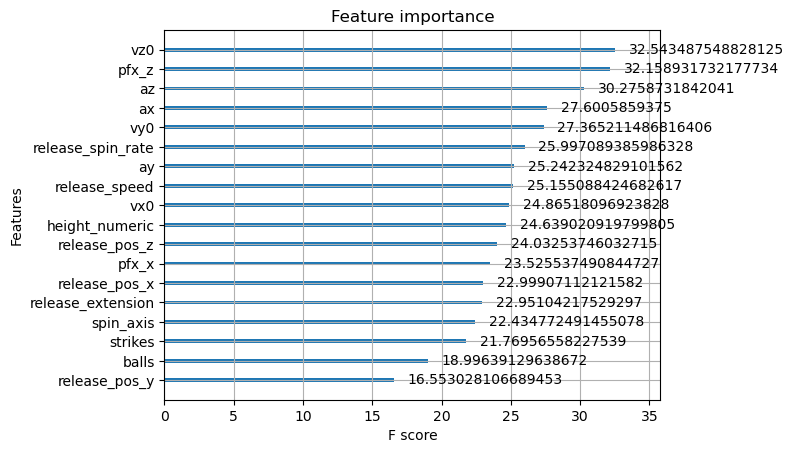

In [22]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

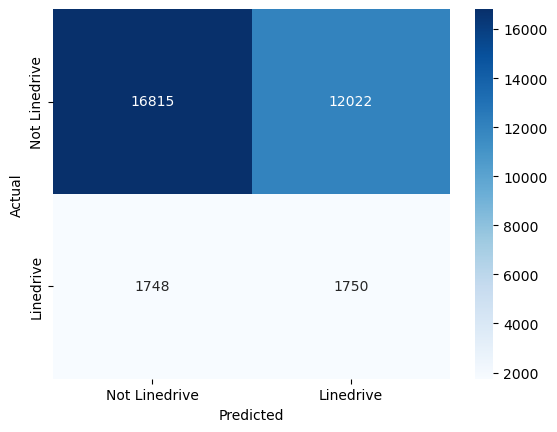

In [23]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Linedrive', 'Linedrive'], yticklabels=['Not Linedrive', 'Linedrive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [24]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [25]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [26]:
y_pred = final_model.predict(predictions)

In [27]:
testing_identifiers['xld'] = y_pred

C:\Users\clayton.thompson\AppData\Local\Temp\ipykernel_16408\3915381827.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_identifiers['xld'] = y_pred


In [28]:
testing_identifiers.head()

pitch_id_raw       xld
0  663364_455139_617228_4_75_10  0.389227
1  663364_455139_617228_3_75_10  0.188634
2  663364_455139_617228_2_75_10  0.674035
3  663364_455139_617228_1_75_10  0.544043
5  663364_593428_605347_4_72_10  0.173958

In [29]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/ld_2022&3_xld.csv")